In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [20]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_processed.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_processed.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_processed.csv")

In [21]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [22]:
data['called_strike'] = np.where(data['description'] == 'called_strike', 1, 0)
testing_data['called_strike'] = np.where(testing_data['description'] == 'called_strike', 1, 0)

In [23]:
training_data = data.query('strike == 1')

In [24]:
breaking_ball = training_data.query('pitch_type_condensed in ("FF", "SI")')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("FF", "SI")')

# Fastball Model First

In [60]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'swing',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'swing',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [37]:
testing_features.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'called_strike'],
      dtype='object')

In [38]:
training_features.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'called_strike'],
      dtype='object')

In [39]:
train_data = training_features.drop(['called_strike'], axis=1).copy()
train_label = training_features['called_strike'].copy()
testing_data = testing_features.drop(['called_strike'], axis=1).copy()
testing_label = testing_features['called_strike'].copy()

In [40]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [41]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [42]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [43]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [44]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6535984461255367
Log Loss: 0.6072097998750364


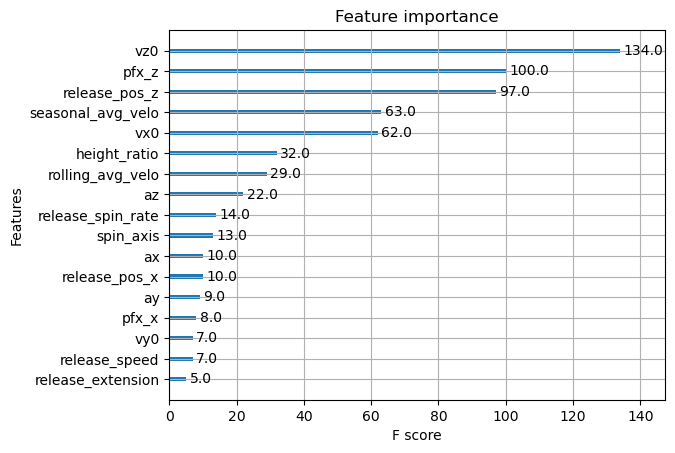

In [45]:
xgb.plot_importance(model)
plt.show()

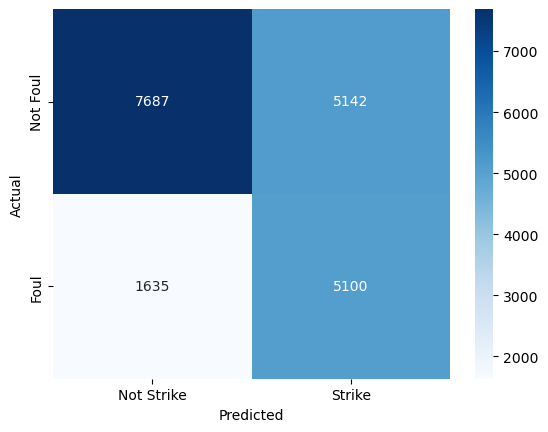

In [46]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Strike', 'Strike'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [47]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [48]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-14 13:52:28,195] A new study created in memory with name: no-name-8e9d5dd8-d322-469b-8b4c-5319ad78acdb


[0]	eval-logloss:0.67790
[1]	eval-logloss:0.66509
[2]	eval-logloss:0.65397
[3]	eval-logloss:0.64432
[4]	eval-logloss:0.63566
[5]	eval-logloss:0.62838
[6]	eval-logloss:0.62137
[7]	eval-logloss:0.61664
[8]	eval-logloss:0.61090
[9]	eval-logloss:0.60581
[10]	eval-logloss:0.60138
[11]	eval-logloss:0.59787
[12]	eval-logloss:0.59394
[13]	eval-logloss:0.59050
[14]	eval-logloss:0.58736
[15]	eval-logloss:0.58414
[16]	eval-logloss:0.58157
[17]	eval-logloss:0.57882
[18]	eval-logloss:0.57672
[19]	eval-logloss:0.57464
[20]	eval-logloss:0.57271
[21]	eval-logloss:0.57114
[22]	eval-logloss:0.56942
[23]	eval-logloss:0.56809
[24]	eval-logloss:0.56659
[25]	eval-logloss:0.56508
[26]	eval-logloss:0.56468
[27]	eval-logloss:0.56351
[28]	eval-logloss:0.56232
[29]	eval-logloss:0.56119
[30]	eval-logloss:0.55989
[31]	eval-logloss:0.55927
[32]	eval-logloss:0.55855
[33]	eval-logloss:0.55756
[34]	eval-logloss:0.55667
[35]	eval-logloss:0.55591
[36]	eval-logloss:0.55549
[37]	eval-logloss:0.55443
[38]	eval-logloss:0.55

[I 2023-11-14 13:52:29,363] Trial 0 finished with value: 0.5393754232183005 and parameters: {'max_depth': 8, 'eta': 0.07990470800082401, 'subsample': 0.7639203401434784, 'colsample_bytree': 0.8624531718053479}. Best is trial 0 with value: 0.5393754232183005.


[0]	eval-logloss:0.65519
[1]	eval-logloss:0.63127
[2]	eval-logloss:0.61587
[3]	eval-logloss:0.60469
[4]	eval-logloss:0.59710
[5]	eval-logloss:0.59010
[6]	eval-logloss:0.58438
[7]	eval-logloss:0.58046
[8]	eval-logloss:0.57730
[9]	eval-logloss:0.57366
[10]	eval-logloss:0.57122
[11]	eval-logloss:0.56824
[12]	eval-logloss:0.56711
[13]	eval-logloss:0.56526
[14]	eval-logloss:0.56422
[15]	eval-logloss:0.56323
[16]	eval-logloss:0.56205
[17]	eval-logloss:0.56122
[18]	eval-logloss:0.55975
[19]	eval-logloss:0.55896
[20]	eval-logloss:0.55824
[21]	eval-logloss:0.55743
[22]	eval-logloss:0.55610
[23]	eval-logloss:0.55494
[24]	eval-logloss:0.55442
[25]	eval-logloss:0.55388
[26]	eval-logloss:0.55392
[27]	eval-logloss:0.55288
[28]	eval-logloss:0.55268
[29]	eval-logloss:0.55216
[30]	eval-logloss:0.55199
[31]	eval-logloss:0.55148
[32]	eval-logloss:0.55085
[33]	eval-logloss:0.55033
[34]	eval-logloss:0.55015
[35]	eval-logloss:0.54962
[36]	eval-logloss:0.54915
[37]	eval-logloss:0.54883
[38]	eval-logloss:0.54

[I 2023-11-14 13:52:30,234] Trial 1 finished with value: 0.5476768246829564 and parameters: {'max_depth': 6, 'eta': 0.25717803734076916, 'subsample': 0.8740091728754432, 'colsample_bytree': 0.9537341447305638}. Best is trial 0 with value: 0.5393754232183005.


[0]	eval-logloss:0.64858
[1]	eval-logloss:0.62295
[2]	eval-logloss:0.60501
[3]	eval-logloss:0.59202
[4]	eval-logloss:0.58353
[5]	eval-logloss:0.57678
[6]	eval-logloss:0.57189
[7]	eval-logloss:0.56872
[8]	eval-logloss:0.56616
[9]	eval-logloss:0.56264
[10]	eval-logloss:0.56138
[11]	eval-logloss:0.56051
[12]	eval-logloss:0.55975
[13]	eval-logloss:0.55830
[14]	eval-logloss:0.55733
[15]	eval-logloss:0.55545
[16]	eval-logloss:0.55503
[17]	eval-logloss:0.55353
[18]	eval-logloss:0.55270
[19]	eval-logloss:0.55242
[20]	eval-logloss:0.55247
[21]	eval-logloss:0.55206
[22]	eval-logloss:0.55175
[23]	eval-logloss:0.55151
[24]	eval-logloss:0.55096
[25]	eval-logloss:0.55151
[26]	eval-logloss:0.55165
[27]	eval-logloss:0.55171
[28]	eval-logloss:0.55226
[29]	eval-logloss:0.55270
[30]	eval-logloss:0.55300
[31]	eval-logloss:0.55392
[32]	eval-logloss:0.55430
[33]	eval-logloss:0.55401
[34]	eval-logloss:0.55465
[35]	eval-logloss:0.55430
[36]	eval-logloss:0.55449
[37]	eval-logloss:0.55431
[38]	eval-logloss:0.55

[I 2023-11-14 13:52:31,306] Trial 2 finished with value: 0.5640717068813476 and parameters: {'max_depth': 9, 'eta': 0.2492793104814324, 'subsample': 0.6053885680020278, 'colsample_bytree': 0.79100462205359}. Best is trial 0 with value: 0.5393754232183005.


[0]	eval-logloss:0.66717
[1]	eval-logloss:0.65027
[2]	eval-logloss:0.63904
[3]	eval-logloss:0.63125
[4]	eval-logloss:0.62498
[5]	eval-logloss:0.62046
[6]	eval-logloss:0.61709
[7]	eval-logloss:0.61386
[8]	eval-logloss:0.61171
[9]	eval-logloss:0.60858
[10]	eval-logloss:0.60657
[11]	eval-logloss:0.60356
[12]	eval-logloss:0.60171
[13]	eval-logloss:0.59949
[14]	eval-logloss:0.59780
[15]	eval-logloss:0.59629
[16]	eval-logloss:0.59489
[17]	eval-logloss:0.59297
[18]	eval-logloss:0.59236
[19]	eval-logloss:0.59171
[20]	eval-logloss:0.59037
[21]	eval-logloss:0.58847
[22]	eval-logloss:0.58788
[23]	eval-logloss:0.58702
[24]	eval-logloss:0.58483
[25]	eval-logloss:0.58376
[26]	eval-logloss:0.58350
[27]	eval-logloss:0.58303
[28]	eval-logloss:0.58215
[29]	eval-logloss:0.58146
[30]	eval-logloss:0.58079
[31]	eval-logloss:0.58024
[32]	eval-logloss:0.57981
[33]	eval-logloss:0.57922
[34]	eval-logloss:0.57827
[35]	eval-logloss:0.57767
[36]	eval-logloss:0.57735
[37]	eval-logloss:0.57659
[38]	eval-logloss:0.57

[I 2023-11-14 13:52:31,885] Trial 3 finished with value: 0.5595477900434664 and parameters: {'max_depth': 3, 'eta': 0.22881075669083678, 'subsample': 0.6678371202477722, 'colsample_bytree': 0.8915626526269123}. Best is trial 0 with value: 0.5393754232183005.


[0]	eval-logloss:0.65053
[1]	eval-logloss:0.62354
[2]	eval-logloss:0.60543
[3]	eval-logloss:0.59295
[4]	eval-logloss:0.58350
[5]	eval-logloss:0.57820
[6]	eval-logloss:0.57265
[7]	eval-logloss:0.56854
[8]	eval-logloss:0.56564
[9]	eval-logloss:0.56264
[10]	eval-logloss:0.56047
[11]	eval-logloss:0.55957
[12]	eval-logloss:0.55869
[13]	eval-logloss:0.55710
[14]	eval-logloss:0.55561
[15]	eval-logloss:0.55426
[16]	eval-logloss:0.55286
[17]	eval-logloss:0.55231
[18]	eval-logloss:0.55096
[19]	eval-logloss:0.55066
[20]	eval-logloss:0.55008
[21]	eval-logloss:0.54942
[22]	eval-logloss:0.54972
[23]	eval-logloss:0.54978
[24]	eval-logloss:0.54981
[25]	eval-logloss:0.55040
[26]	eval-logloss:0.55040
[27]	eval-logloss:0.55015
[28]	eval-logloss:0.54955
[29]	eval-logloss:0.54949
[30]	eval-logloss:0.54938
[31]	eval-logloss:0.54956
[32]	eval-logloss:0.54997
[33]	eval-logloss:0.55033
[34]	eval-logloss:0.55043
[35]	eval-logloss:0.55054
[36]	eval-logloss:0.55068
[37]	eval-logloss:0.55056
[38]	eval-logloss:0.55

[I 2023-11-14 13:52:32,832] Trial 4 finished with value: 0.5590379567909373 and parameters: {'max_depth': 9, 'eta': 0.24829750805650963, 'subsample': 0.6629874040581472, 'colsample_bytree': 0.6623658189626629}. Best is trial 0 with value: 0.5393754232183005.


[0]	eval-logloss:0.68465
[1]	eval-logloss:0.67709
[2]	eval-logloss:0.66981
[3]	eval-logloss:0.66345
[4]	eval-logloss:0.65705
[5]	eval-logloss:0.65190
[6]	eval-logloss:0.64647
[7]	eval-logloss:0.64317
[8]	eval-logloss:0.63792
[9]	eval-logloss:0.63337
[10]	eval-logloss:0.62900
[11]	eval-logloss:0.62708
[12]	eval-logloss:0.62324
[13]	eval-logloss:0.61970
[14]	eval-logloss:0.61615
[15]	eval-logloss:0.61264
[16]	eval-logloss:0.60951
[17]	eval-logloss:0.60634
[18]	eval-logloss:0.60339
[19]	eval-logloss:0.60059
[20]	eval-logloss:0.59809
[21]	eval-logloss:0.59590
[22]	eval-logloss:0.59393
[23]	eval-logloss:0.59209
[24]	eval-logloss:0.59032
[25]	eval-logloss:0.58966
[26]	eval-logloss:0.58909
[27]	eval-logloss:0.58821
[28]	eval-logloss:0.58623
[29]	eval-logloss:0.58469
[30]	eval-logloss:0.58330
[31]	eval-logloss:0.58239
[32]	eval-logloss:0.58090
[33]	eval-logloss:0.57951
[34]	eval-logloss:0.57810
[35]	eval-logloss:0.57665
[36]	eval-logloss:0.57541
[37]	eval-logloss:0.57413
[38]	eval-logloss:0.57

[I 2023-11-14 13:52:34,342] Trial 5 finished with value: 0.5441803065661318 and parameters: {'max_depth': 9, 'eta': 0.042475370147794664, 'subsample': 0.8754883870767041, 'colsample_bytree': 0.6689468138765611}. Best is trial 0 with value: 0.5393754232183005.


[0]	eval-logloss:0.68681
[1]	eval-logloss:0.68124
[2]	eval-logloss:0.67616
[3]	eval-logloss:0.67163
[4]	eval-logloss:0.66703
[5]	eval-logloss:0.66300
[6]	eval-logloss:0.65926
[7]	eval-logloss:0.65707
[8]	eval-logloss:0.65357
[9]	eval-logloss:0.65029
[10]	eval-logloss:0.64735
[11]	eval-logloss:0.64602
[12]	eval-logloss:0.64326
[13]	eval-logloss:0.64065
[14]	eval-logloss:0.63814
[15]	eval-logloss:0.63561
[16]	eval-logloss:0.63345
[17]	eval-logloss:0.63135
[18]	eval-logloss:0.62942
[19]	eval-logloss:0.62762
[20]	eval-logloss:0.62574
[21]	eval-logloss:0.62405
[22]	eval-logloss:0.62275
[23]	eval-logloss:0.62128
[24]	eval-logloss:0.61985
[25]	eval-logloss:0.61955
[26]	eval-logloss:0.61926
[27]	eval-logloss:0.61844
[28]	eval-logloss:0.61706
[29]	eval-logloss:0.61572
[30]	eval-logloss:0.61453
[31]	eval-logloss:0.61389
[32]	eval-logloss:0.61274
[33]	eval-logloss:0.61154
[34]	eval-logloss:0.61042
[35]	eval-logloss:0.60941
[36]	eval-logloss:0.60847
[37]	eval-logloss:0.60751
[38]	eval-logloss:0.60

[I 2023-11-14 13:52:35,093] Trial 6 finished with value: 0.5795750921525554 and parameters: {'max_depth': 4, 'eta': 0.042930860409598745, 'subsample': 0.6136661918188613, 'colsample_bytree': 0.6753007653414629}. Best is trial 0 with value: 0.5393754232183005.


[0]	eval-logloss:0.68140
[1]	eval-logloss:0.67178
[2]	eval-logloss:0.66394
[3]	eval-logloss:0.65692
[4]	eval-logloss:0.65092
[5]	eval-logloss:0.64592
[6]	eval-logloss:0.64158
[7]	eval-logloss:0.63739
[8]	eval-logloss:0.63402
[9]	eval-logloss:0.63115
[10]	eval-logloss:0.62855
[11]	eval-logloss:0.62587
[12]	eval-logloss:0.62392
[13]	eval-logloss:0.62201
[14]	eval-logloss:0.62023
[15]	eval-logloss:0.61868
[16]	eval-logloss:0.61727
[17]	eval-logloss:0.61559
[18]	eval-logloss:0.61444
[19]	eval-logloss:0.61298
[20]	eval-logloss:0.61155
[21]	eval-logloss:0.61026
[22]	eval-logloss:0.60915
[23]	eval-logloss:0.60819
[24]	eval-logloss:0.60733
[25]	eval-logloss:0.60616
[26]	eval-logloss:0.60559
[27]	eval-logloss:0.60493
[28]	eval-logloss:0.60441
[29]	eval-logloss:0.60341
[30]	eval-logloss:0.60239
[31]	eval-logloss:0.60149
[32]	eval-logloss:0.60063
[33]	eval-logloss:0.59987
[34]	eval-logloss:0.59926
[35]	eval-logloss:0.59864
[36]	eval-logloss:0.59820
[37]	eval-logloss:0.59739
[38]	eval-logloss:0.59

[I 2023-11-14 13:52:35,736] Trial 7 finished with value: 0.5728725647269719 and parameters: {'max_depth': 3, 'eta': 0.09586548871452477, 'subsample': 0.7279118696459546, 'colsample_bytree': 0.9734123049698553}. Best is trial 0 with value: 0.5393754232183005.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68571
[2]	eval-logloss:0.68230
[3]	eval-logloss:0.67919
[4]	eval-logloss:0.67594
[5]	eval-logloss:0.67310
[6]	eval-logloss:0.67034
[7]	eval-logloss:0.66898
[8]	eval-logloss:0.66627
[9]	eval-logloss:0.66369
[10]	eval-logloss:0.66132
[11]	eval-logloss:0.66028
[12]	eval-logloss:0.65797
[13]	eval-logloss:0.65585
[14]	eval-logloss:0.65371
[15]	eval-logloss:0.65159
[16]	eval-logloss:0.64968
[17]	eval-logloss:0.64779
[18]	eval-logloss:0.64600
[19]	eval-logloss:0.64426
[20]	eval-logloss:0.64250
[21]	eval-logloss:0.64091
[22]	eval-logloss:0.64055
[23]	eval-logloss:0.63911
[24]	eval-logloss:0.63877
[25]	eval-logloss:0.63846
[26]	eval-logloss:0.63818
[27]	eval-logloss:0.63791
[28]	eval-logloss:0.63649
[29]	eval-logloss:0.63514
[30]	eval-logloss:0.63380
[31]	eval-logloss:0.63311
[32]	eval-logloss:0.63182
[33]	eval-logloss:0.63154
[34]	eval-logloss:0.63030
[35]	eval-logloss:0.62914
[36]	eval-logloss:0.62887
[37]	eval-logloss:0.62770
[38]	eval-logloss:0.62

[I 2023-11-14 13:52:36,421] Trial 8 finished with value: 0.5965205939810766 and parameters: {'max_depth': 4, 'eta': 0.0266278357644589, 'subsample': 0.7120351713606217, 'colsample_bytree': 0.6426714646519723}. Best is trial 0 with value: 0.5393754232183005.


[0]	eval-logloss:0.64741
[1]	eval-logloss:0.62094
[2]	eval-logloss:0.60324
[3]	eval-logloss:0.59118
[4]	eval-logloss:0.58353
[5]	eval-logloss:0.57992
[6]	eval-logloss:0.57268
[7]	eval-logloss:0.56945
[8]	eval-logloss:0.56533
[9]	eval-logloss:0.56468
[10]	eval-logloss:0.56323
[11]	eval-logloss:0.56240
[12]	eval-logloss:0.56084
[13]	eval-logloss:0.55964
[14]	eval-logloss:0.55802
[15]	eval-logloss:0.55652
[16]	eval-logloss:0.55521
[17]	eval-logloss:0.55423
[18]	eval-logloss:0.55289
[19]	eval-logloss:0.55288
[20]	eval-logloss:0.55282
[21]	eval-logloss:0.55305
[22]	eval-logloss:0.55288
[23]	eval-logloss:0.55285
[24]	eval-logloss:0.55339
[25]	eval-logloss:0.55349
[26]	eval-logloss:0.55414
[27]	eval-logloss:0.55447
[28]	eval-logloss:0.55422
[29]	eval-logloss:0.55379
[30]	eval-logloss:0.55320
[31]	eval-logloss:0.55350
[32]	eval-logloss:0.55385
[33]	eval-logloss:0.55410
[34]	eval-logloss:0.55438
[35]	eval-logloss:0.55360
[36]	eval-logloss:0.55419
[37]	eval-logloss:0.55368
[38]	eval-logloss:0.55

[I 2023-11-14 13:52:37,148] Trial 9 finished with value: 0.5603793585844505 and parameters: {'max_depth': 8, 'eta': 0.28609065346624646, 'subsample': 0.6349627761705766, 'colsample_bytree': 0.5658634393377393}. Best is trial 0 with value: 0.5393754232183005.


[0]	eval-logloss:0.66790
[1]	eval-logloss:0.64883
[2]	eval-logloss:0.63423
[3]	eval-logloss:0.62263
[4]	eval-logloss:0.61344
[5]	eval-logloss:0.60629
[6]	eval-logloss:0.59980
[7]	eval-logloss:0.59535
[8]	eval-logloss:0.58994
[9]	eval-logloss:0.58568
[10]	eval-logloss:0.58237
[11]	eval-logloss:0.57991
[12]	eval-logloss:0.57713
[13]	eval-logloss:0.57495
[14]	eval-logloss:0.57255
[15]	eval-logloss:0.57018
[16]	eval-logloss:0.56815
[17]	eval-logloss:0.56625
[18]	eval-logloss:0.56473
[19]	eval-logloss:0.56308
[20]	eval-logloss:0.56187
[21]	eval-logloss:0.56074
[22]	eval-logloss:0.55917
[23]	eval-logloss:0.55866
[24]	eval-logloss:0.55727
[25]	eval-logloss:0.55600
[26]	eval-logloss:0.55562
[27]	eval-logloss:0.55506
[28]	eval-logloss:0.55455
[29]	eval-logloss:0.55387
[30]	eval-logloss:0.55311
[31]	eval-logloss:0.55283
[32]	eval-logloss:0.55246
[33]	eval-logloss:0.55168
[34]	eval-logloss:0.55112
[35]	eval-logloss:0.55074
[36]	eval-logloss:0.55041
[37]	eval-logloss:0.54973
[38]	eval-logloss:0.54

[I 2023-11-14 13:52:38,094] Trial 10 finished with value: 0.5408615424311198 and parameters: {'max_depth': 7, 'eta': 0.14634970677655199, 'subsample': 0.7951034845986162, 'colsample_bytree': 0.8251314283734721}. Best is trial 0 with value: 0.5393754232183005.


[0]	eval-logloss:0.66907
[1]	eval-logloss:0.65061
[2]	eval-logloss:0.63645
[3]	eval-logloss:0.62467
[4]	eval-logloss:0.61516
[5]	eval-logloss:0.60773
[6]	eval-logloss:0.60092
[7]	eval-logloss:0.59645
[8]	eval-logloss:0.59176
[9]	eval-logloss:0.58774
[10]	eval-logloss:0.58417
[11]	eval-logloss:0.58195
[12]	eval-logloss:0.57914
[13]	eval-logloss:0.57662
[14]	eval-logloss:0.57430
[15]	eval-logloss:0.57150
[16]	eval-logloss:0.56914
[17]	eval-logloss:0.56752
[18]	eval-logloss:0.56603
[19]	eval-logloss:0.56457
[20]	eval-logloss:0.56340
[21]	eval-logloss:0.56235
[22]	eval-logloss:0.56104
[23]	eval-logloss:0.56017
[24]	eval-logloss:0.55878
[25]	eval-logloss:0.55754
[26]	eval-logloss:0.55706
[27]	eval-logloss:0.55673
[28]	eval-logloss:0.55643
[29]	eval-logloss:0.55575
[30]	eval-logloss:0.55448
[31]	eval-logloss:0.55434
[32]	eval-logloss:0.55393
[33]	eval-logloss:0.55349
[34]	eval-logloss:0.55303
[35]	eval-logloss:0.55243
[36]	eval-logloss:0.55213
[37]	eval-logloss:0.55127
[38]	eval-logloss:0.55

[I 2023-11-14 13:52:39,072] Trial 11 finished with value: 0.5423316117428492 and parameters: {'max_depth': 7, 'eta': 0.13746435616578548, 'subsample': 0.7851392960686185, 'colsample_bytree': 0.8207819023304369}. Best is trial 0 with value: 0.5393754232183005.


[0]	eval-logloss:0.66611
[1]	eval-logloss:0.64664
[2]	eval-logloss:0.63224
[3]	eval-logloss:0.62032
[4]	eval-logloss:0.61093
[5]	eval-logloss:0.60462
[6]	eval-logloss:0.59876
[7]	eval-logloss:0.59291
[8]	eval-logloss:0.58890
[9]	eval-logloss:0.58491
[10]	eval-logloss:0.58225
[11]	eval-logloss:0.57869
[12]	eval-logloss:0.57630
[13]	eval-logloss:0.57462
[14]	eval-logloss:0.57293
[15]	eval-logloss:0.57095
[16]	eval-logloss:0.56934
[17]	eval-logloss:0.56740
[18]	eval-logloss:0.56637
[19]	eval-logloss:0.56487
[20]	eval-logloss:0.56369
[21]	eval-logloss:0.56301
[22]	eval-logloss:0.56170
[23]	eval-logloss:0.56113
[24]	eval-logloss:0.56024
[25]	eval-logloss:0.55944
[26]	eval-logloss:0.55935
[27]	eval-logloss:0.55897
[28]	eval-logloss:0.55856
[29]	eval-logloss:0.55784
[30]	eval-logloss:0.55670
[31]	eval-logloss:0.55609
[32]	eval-logloss:0.55570
[33]	eval-logloss:0.55517
[34]	eval-logloss:0.55449
[35]	eval-logloss:0.55401
[36]	eval-logloss:0.55404
[37]	eval-logloss:0.55359
[38]	eval-logloss:0.55

[I 2023-11-14 13:52:39,901] Trial 12 finished with value: 0.5447075882662055 and parameters: {'max_depth': 6, 'eta': 0.17187997715630646, 'subsample': 0.7795379148631151, 'colsample_bytree': 0.8580747133663466}. Best is trial 0 with value: 0.5393754232183005.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66151
[2]	eval-logloss:0.64924
[3]	eval-logloss:0.63871
[4]	eval-logloss:0.62962
[5]	eval-logloss:0.62283
[6]	eval-logloss:0.61652
[7]	eval-logloss:0.61208
[8]	eval-logloss:0.60684
[9]	eval-logloss:0.60194
[10]	eval-logloss:0.59768
[11]	eval-logloss:0.59559
[12]	eval-logloss:0.59221
[13]	eval-logloss:0.58921
[14]	eval-logloss:0.58614
[15]	eval-logloss:0.58345
[16]	eval-logloss:0.58109
[17]	eval-logloss:0.57872
[18]	eval-logloss:0.57643
[19]	eval-logloss:0.57467
[20]	eval-logloss:0.57308
[21]	eval-logloss:0.57167
[22]	eval-logloss:0.56981
[23]	eval-logloss:0.56884
[24]	eval-logloss:0.56744
[25]	eval-logloss:0.56577
[26]	eval-logloss:0.56539
[27]	eval-logloss:0.56460
[28]	eval-logloss:0.56370
[29]	eval-logloss:0.56248
[30]	eval-logloss:0.56168
[31]	eval-logloss:0.56129
[32]	eval-logloss:0.56059
[33]	eval-logloss:0.55980
[34]	eval-logloss:0.55930
[35]	eval-logloss:0.55844
[36]	eval-logloss:0.55797
[37]	eval-logloss:0.55705
[38]	eval-logloss:0.55

[I 2023-11-14 13:52:40,893] Trial 13 finished with value: 0.5424056349648636 and parameters: {'max_depth': 7, 'eta': 0.09845451620782128, 'subsample': 0.8205059949460548, 'colsample_bytree': 0.755869144627567}. Best is trial 0 with value: 0.5393754232183005.


[0]	eval-logloss:0.66318
[1]	eval-logloss:0.64218
[2]	eval-logloss:0.62730
[3]	eval-logloss:0.61503
[4]	eval-logloss:0.60598
[5]	eval-logloss:0.59841
[6]	eval-logloss:0.59223
[7]	eval-logloss:0.58641
[8]	eval-logloss:0.58175
[9]	eval-logloss:0.57755
[10]	eval-logloss:0.57432
[11]	eval-logloss:0.57070
[12]	eval-logloss:0.56853
[13]	eval-logloss:0.56689
[14]	eval-logloss:0.56488
[15]	eval-logloss:0.56302
[16]	eval-logloss:0.56147
[17]	eval-logloss:0.55978
[18]	eval-logloss:0.55877
[19]	eval-logloss:0.55769
[20]	eval-logloss:0.55683
[21]	eval-logloss:0.55614
[22]	eval-logloss:0.55503
[23]	eval-logloss:0.55447
[24]	eval-logloss:0.55324
[25]	eval-logloss:0.55244
[26]	eval-logloss:0.55224
[27]	eval-logloss:0.55172
[28]	eval-logloss:0.55154
[29]	eval-logloss:0.55105
[30]	eval-logloss:0.55077
[31]	eval-logloss:0.55052
[32]	eval-logloss:0.55040
[33]	eval-logloss:0.54988
[34]	eval-logloss:0.54911
[35]	eval-logloss:0.54865
[36]	eval-logloss:0.54878
[37]	eval-logloss:0.54806
[38]	eval-logloss:0.54

[I 2023-11-14 13:52:41,859] Trial 14 finished with value: 0.5444051140383647 and parameters: {'max_depth': 7, 'eta': 0.1765874817910546, 'subsample': 0.757761458667767, 'colsample_bytree': 0.8870807032546986}. Best is trial 0 with value: 0.5393754232183005.


[0]	eval-logloss:0.67513
[1]	eval-logloss:0.66058
[2]	eval-logloss:0.64793
[3]	eval-logloss:0.63700
[4]	eval-logloss:0.62781
[5]	eval-logloss:0.61990
[6]	eval-logloss:0.61289
[7]	eval-logloss:0.60840
[8]	eval-logloss:0.60258
[9]	eval-logloss:0.59758
[10]	eval-logloss:0.59319
[11]	eval-logloss:0.59105
[12]	eval-logloss:0.58744
[13]	eval-logloss:0.58449
[14]	eval-logloss:0.58148
[15]	eval-logloss:0.57855
[16]	eval-logloss:0.57611
[17]	eval-logloss:0.57380
[18]	eval-logloss:0.57183
[19]	eval-logloss:0.56983
[20]	eval-logloss:0.56823
[21]	eval-logloss:0.56697
[22]	eval-logloss:0.56549
[23]	eval-logloss:0.56420
[24]	eval-logloss:0.56250
[25]	eval-logloss:0.56075
[26]	eval-logloss:0.56037
[27]	eval-logloss:0.55976
[28]	eval-logloss:0.55864
[29]	eval-logloss:0.55764
[30]	eval-logloss:0.55648
[31]	eval-logloss:0.55614
[32]	eval-logloss:0.55530
[33]	eval-logloss:0.55429
[34]	eval-logloss:0.55365
[35]	eval-logloss:0.55292
[36]	eval-logloss:0.55253
[37]	eval-logloss:0.55186
[38]	eval-logloss:0.55

[I 2023-11-14 13:52:43,071] Trial 15 finished with value: 0.5386767461241061 and parameters: {'max_depth': 8, 'eta': 0.09454045011553136, 'subsample': 0.8243005520216866, 'colsample_bytree': 0.8088118067726761}. Best is trial 15 with value: 0.5386767461241061.


[0]	eval-logloss:0.67754
[1]	eval-logloss:0.66428
[2]	eval-logloss:0.65272
[3]	eval-logloss:0.64255
[4]	eval-logloss:0.63373
[5]	eval-logloss:0.62676
[6]	eval-logloss:0.61998
[7]	eval-logloss:0.61558
[8]	eval-logloss:0.60971
[9]	eval-logloss:0.60459
[10]	eval-logloss:0.59988
[11]	eval-logloss:0.59771
[12]	eval-logloss:0.59365
[13]	eval-logloss:0.59051
[14]	eval-logloss:0.58717
[15]	eval-logloss:0.58406
[16]	eval-logloss:0.58141
[17]	eval-logloss:0.57888
[18]	eval-logloss:0.57627
[19]	eval-logloss:0.57408
[20]	eval-logloss:0.57241
[21]	eval-logloss:0.57090
[22]	eval-logloss:0.56929
[23]	eval-logloss:0.56805
[24]	eval-logloss:0.56655
[25]	eval-logloss:0.56456
[26]	eval-logloss:0.56413
[27]	eval-logloss:0.56338
[28]	eval-logloss:0.56206
[29]	eval-logloss:0.56081
[30]	eval-logloss:0.56004
[31]	eval-logloss:0.55952
[32]	eval-logloss:0.55882
[33]	eval-logloss:0.55811
[34]	eval-logloss:0.55749
[35]	eval-logloss:0.55671
[36]	eval-logloss:0.55609
[37]	eval-logloss:0.55519
[38]	eval-logloss:0.55

[I 2023-11-14 13:52:44,384] Trial 16 finished with value: 0.5401720597945385 and parameters: {'max_depth': 8, 'eta': 0.08360058141648886, 'subsample': 0.8331546144751567, 'colsample_bytree': 0.7508544981440737}. Best is trial 15 with value: 0.5386767461241061.


[0]	eval-logloss:0.68031
[1]	eval-logloss:0.66931
[2]	eval-logloss:0.65959
[3]	eval-logloss:0.65068
[4]	eval-logloss:0.64277
[5]	eval-logloss:0.63568
[6]	eval-logloss:0.62908
[7]	eval-logloss:0.62308
[8]	eval-logloss:0.61797
[9]	eval-logloss:0.61322
[10]	eval-logloss:0.60886
[11]	eval-logloss:0.60481
[12]	eval-logloss:0.60098
[13]	eval-logloss:0.59770
[14]	eval-logloss:0.59457
[15]	eval-logloss:0.59153
[16]	eval-logloss:0.58908
[17]	eval-logloss:0.58655
[18]	eval-logloss:0.58439
[19]	eval-logloss:0.58236
[20]	eval-logloss:0.58053
[21]	eval-logloss:0.57880
[22]	eval-logloss:0.57682
[23]	eval-logloss:0.57545
[24]	eval-logloss:0.57384
[25]	eval-logloss:0.57204
[26]	eval-logloss:0.57148
[27]	eval-logloss:0.57022
[28]	eval-logloss:0.56905
[29]	eval-logloss:0.56754
[30]	eval-logloss:0.56608
[31]	eval-logloss:0.56459
[32]	eval-logloss:0.56360
[33]	eval-logloss:0.56272
[34]	eval-logloss:0.56188
[35]	eval-logloss:0.56099
[36]	eval-logloss:0.56037
[37]	eval-logloss:0.55941
[38]	eval-logloss:0.55

[I 2023-11-14 13:52:45,737] Trial 17 finished with value: 0.5405315172581551 and parameters: {'max_depth': 8, 'eta': 0.06661332978654862, 'subsample': 0.8379652992667741, 'colsample_bytree': 0.9241859269265317}. Best is trial 15 with value: 0.5386767461241061.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68972
[2]	eval-logloss:0.68810
[3]	eval-logloss:0.68645
[4]	eval-logloss:0.68485
[5]	eval-logloss:0.68337
[6]	eval-logloss:0.68181
[7]	eval-logloss:0.68103
[8]	eval-logloss:0.67954
[9]	eval-logloss:0.67806
[10]	eval-logloss:0.67664
[11]	eval-logloss:0.67592
[12]	eval-logloss:0.67452
[13]	eval-logloss:0.67324
[14]	eval-logloss:0.67188
[15]	eval-logloss:0.67053
[16]	eval-logloss:0.66924
[17]	eval-logloss:0.66798
[18]	eval-logloss:0.66672
[19]	eval-logloss:0.66545
[20]	eval-logloss:0.66424
[21]	eval-logloss:0.66307
[22]	eval-logloss:0.66187
[23]	eval-logloss:0.66071
[24]	eval-logloss:0.65962
[25]	eval-logloss:0.65851
[26]	eval-logloss:0.65821
[27]	eval-logloss:0.65713
[28]	eval-logloss:0.65606
[29]	eval-logloss:0.65501
[30]	eval-logloss:0.65403
[31]	eval-logloss:0.65357
[32]	eval-logloss:0.65257
[33]	eval-logloss:0.65157
[34]	eval-logloss:0.65062
[35]	eval-logloss:0.64967
[36]	eval-logloss:0.64876
[37]	eval-logloss:0.64785
[38]	eval-logloss:0.64

[I 2023-11-14 13:52:46,622] Trial 18 finished with value: 0.6122844407031035 and parameters: {'max_depth': 5, 'eta': 0.010876351048120528, 'subsample': 0.8947172056880509, 'colsample_bytree': 0.852661457169268}. Best is trial 15 with value: 0.5386767461241061.


[0]	eval-logloss:0.67140
[1]	eval-logloss:0.65422
[2]	eval-logloss:0.64028
[3]	eval-logloss:0.62864
[4]	eval-logloss:0.61880
[5]	eval-logloss:0.61046
[6]	eval-logloss:0.60345
[7]	eval-logloss:0.59740
[8]	eval-logloss:0.59247
[9]	eval-logloss:0.58769
[10]	eval-logloss:0.58397
[11]	eval-logloss:0.58022
[12]	eval-logloss:0.57696
[13]	eval-logloss:0.57445
[14]	eval-logloss:0.57220
[15]	eval-logloss:0.56954
[16]	eval-logloss:0.56727
[17]	eval-logloss:0.56474
[18]	eval-logloss:0.56322
[19]	eval-logloss:0.56170
[20]	eval-logloss:0.56055
[21]	eval-logloss:0.55929
[22]	eval-logloss:0.55801
[23]	eval-logloss:0.55680
[24]	eval-logloss:0.55615
[25]	eval-logloss:0.55524
[26]	eval-logloss:0.55453
[27]	eval-logloss:0.55378
[28]	eval-logloss:0.55329
[29]	eval-logloss:0.55248
[30]	eval-logloss:0.55118
[31]	eval-logloss:0.55047
[32]	eval-logloss:0.54953
[33]	eval-logloss:0.54904
[34]	eval-logloss:0.54858
[35]	eval-logloss:0.54839
[36]	eval-logloss:0.54830
[37]	eval-logloss:0.54777
[38]	eval-logloss:0.54

[I 2023-11-14 13:52:47,790] Trial 19 finished with value: 0.541245559579244 and parameters: {'max_depth': 8, 'eta': 0.11795579602652967, 'subsample': 0.7447974687453865, 'colsample_bytree': 0.9864473162465588}. Best is trial 15 with value: 0.5386767461241061.


[0]	eval-logloss:0.68220
[1]	eval-logloss:0.67268
[2]	eval-logloss:0.66437
[3]	eval-logloss:0.65692
[4]	eval-logloss:0.65043
[5]	eval-logloss:0.64455
[6]	eval-logloss:0.63917
[7]	eval-logloss:0.63442
[8]	eval-logloss:0.63011
[9]	eval-logloss:0.62621
[10]	eval-logloss:0.62262
[11]	eval-logloss:0.61919
[12]	eval-logloss:0.61617
[13]	eval-logloss:0.61335
[14]	eval-logloss:0.61088
[15]	eval-logloss:0.60831
[16]	eval-logloss:0.60623
[17]	eval-logloss:0.60421
[18]	eval-logloss:0.60205
[19]	eval-logloss:0.60019
[20]	eval-logloss:0.59845
[21]	eval-logloss:0.59691
[22]	eval-logloss:0.59529
[23]	eval-logloss:0.59377
[24]	eval-logloss:0.59221
[25]	eval-logloss:0.59078
[26]	eval-logloss:0.59040
[27]	eval-logloss:0.58922
[28]	eval-logloss:0.58814
[29]	eval-logloss:0.58704
[30]	eval-logloss:0.58559
[31]	eval-logloss:0.58448
[32]	eval-logloss:0.58350
[33]	eval-logloss:0.58281
[34]	eval-logloss:0.58192
[35]	eval-logloss:0.58121
[36]	eval-logloss:0.58043
[37]	eval-logloss:0.57942
[38]	eval-logloss:0.57

[I 2023-11-14 13:52:48,678] Trial 20 finished with value: 0.5571185448080439 and parameters: {'max_depth': 5, 'eta': 0.07027073683630286, 'subsample': 0.8160098597779052, 'colsample_bytree': 0.9251505489557248}. Best is trial 15 with value: 0.5386767461241061.


[0]	eval-logloss:0.67901
[1]	eval-logloss:0.66649
[2]	eval-logloss:0.65550
[3]	eval-logloss:0.64573
[4]	eval-logloss:0.63718
[5]	eval-logloss:0.63019
[6]	eval-logloss:0.62351
[7]	eval-logloss:0.61934
[8]	eval-logloss:0.61367
[9]	eval-logloss:0.60873
[10]	eval-logloss:0.60416
[11]	eval-logloss:0.60210
[12]	eval-logloss:0.59822
[13]	eval-logloss:0.59481
[14]	eval-logloss:0.59138
[15]	eval-logloss:0.58801
[16]	eval-logloss:0.58543
[17]	eval-logloss:0.58277
[18]	eval-logloss:0.58035
[19]	eval-logloss:0.57811
[20]	eval-logloss:0.57611
[21]	eval-logloss:0.57444
[22]	eval-logloss:0.57276
[23]	eval-logloss:0.57149
[24]	eval-logloss:0.57015
[25]	eval-logloss:0.56827
[26]	eval-logloss:0.56793
[27]	eval-logloss:0.56714
[28]	eval-logloss:0.56575
[29]	eval-logloss:0.56440
[30]	eval-logloss:0.56340
[31]	eval-logloss:0.56274
[32]	eval-logloss:0.56192
[33]	eval-logloss:0.56106
[34]	eval-logloss:0.56019
[35]	eval-logloss:0.55931
[36]	eval-logloss:0.55875
[37]	eval-logloss:0.55791
[38]	eval-logloss:0.55

[I 2023-11-14 13:52:50,154] Trial 21 finished with value: 0.5393948191856139 and parameters: {'max_depth': 8, 'eta': 0.0764974519701346, 'subsample': 0.8497108098133216, 'colsample_bytree': 0.7395717847273314}. Best is trial 15 with value: 0.5386767461241061.


[0]	eval-logloss:0.67164
[1]	eval-logloss:0.65463
[2]	eval-logloss:0.64060
[3]	eval-logloss:0.62899
[4]	eval-logloss:0.61914
[5]	eval-logloss:0.61088
[6]	eval-logloss:0.60384
[7]	eval-logloss:0.59947
[8]	eval-logloss:0.59402
[9]	eval-logloss:0.58916
[10]	eval-logloss:0.58485
[11]	eval-logloss:0.58288
[12]	eval-logloss:0.57962
[13]	eval-logloss:0.57657
[14]	eval-logloss:0.57375
[15]	eval-logloss:0.57123
[16]	eval-logloss:0.56878
[17]	eval-logloss:0.56680
[18]	eval-logloss:0.56501
[19]	eval-logloss:0.56348
[20]	eval-logloss:0.56212
[21]	eval-logloss:0.56099
[22]	eval-logloss:0.55946
[23]	eval-logloss:0.55850
[24]	eval-logloss:0.55723
[25]	eval-logloss:0.55539
[26]	eval-logloss:0.55516
[27]	eval-logloss:0.55457
[28]	eval-logloss:0.55379
[29]	eval-logloss:0.55297
[30]	eval-logloss:0.55183
[31]	eval-logloss:0.55143
[32]	eval-logloss:0.55096
[33]	eval-logloss:0.55029
[34]	eval-logloss:0.54982
[35]	eval-logloss:0.54920
[36]	eval-logloss:0.54848
[37]	eval-logloss:0.54782
[38]	eval-logloss:0.54

[I 2023-11-14 13:52:51,332] Trial 22 finished with value: 0.5377031553231163 and parameters: {'max_depth': 8, 'eta': 0.11613379143078092, 'subsample': 0.8522888079001263, 'colsample_bytree': 0.7894939938170408}. Best is trial 22 with value: 0.5377031553231163.


[0]	eval-logloss:0.67040
[1]	eval-logloss:0.65267
[2]	eval-logloss:0.63807
[3]	eval-logloss:0.62585
[4]	eval-logloss:0.61574
[5]	eval-logloss:0.60743
[6]	eval-logloss:0.60028
[7]	eval-logloss:0.59535
[8]	eval-logloss:0.58922
[9]	eval-logloss:0.58448
[10]	eval-logloss:0.58045
[11]	eval-logloss:0.57832
[12]	eval-logloss:0.57515
[13]	eval-logloss:0.57203
[14]	eval-logloss:0.56922
[15]	eval-logloss:0.56649
[16]	eval-logloss:0.56440
[17]	eval-logloss:0.56248
[18]	eval-logloss:0.56042
[19]	eval-logloss:0.55872
[20]	eval-logloss:0.55755
[21]	eval-logloss:0.55661
[22]	eval-logloss:0.55498
[23]	eval-logloss:0.55404
[24]	eval-logloss:0.55283
[25]	eval-logloss:0.55138
[26]	eval-logloss:0.55122
[27]	eval-logloss:0.55079
[28]	eval-logloss:0.55018
[29]	eval-logloss:0.54957
[30]	eval-logloss:0.54849
[31]	eval-logloss:0.54813
[32]	eval-logloss:0.54780
[33]	eval-logloss:0.54718
[34]	eval-logloss:0.54662
[35]	eval-logloss:0.54628
[36]	eval-logloss:0.54591
[37]	eval-logloss:0.54550
[38]	eval-logloss:0.54

[I 2023-11-14 13:52:52,805] Trial 23 finished with value: 0.5389271153243691 and parameters: {'max_depth': 9, 'eta': 0.11680026782993667, 'subsample': 0.8062591972415217, 'colsample_bytree': 0.7947243095213521}. Best is trial 22 with value: 0.5377031553231163.


[0]	eval-logloss:0.67040
[1]	eval-logloss:0.65264
[2]	eval-logloss:0.63829
[3]	eval-logloss:0.62584
[4]	eval-logloss:0.61567
[5]	eval-logloss:0.60705
[6]	eval-logloss:0.59974
[7]	eval-logloss:0.59504
[8]	eval-logloss:0.58918
[9]	eval-logloss:0.58423
[10]	eval-logloss:0.57976
[11]	eval-logloss:0.57765
[12]	eval-logloss:0.57429
[13]	eval-logloss:0.57126
[14]	eval-logloss:0.56863
[15]	eval-logloss:0.56597
[16]	eval-logloss:0.56393
[17]	eval-logloss:0.56181
[18]	eval-logloss:0.56007
[19]	eval-logloss:0.55833
[20]	eval-logloss:0.55718
[21]	eval-logloss:0.55588
[22]	eval-logloss:0.55447
[23]	eval-logloss:0.55358
[24]	eval-logloss:0.55203
[25]	eval-logloss:0.55073
[26]	eval-logloss:0.55069
[27]	eval-logloss:0.55013
[28]	eval-logloss:0.54921
[29]	eval-logloss:0.54850
[30]	eval-logloss:0.54753
[31]	eval-logloss:0.54725
[32]	eval-logloss:0.54694
[33]	eval-logloss:0.54662
[34]	eval-logloss:0.54612
[35]	eval-logloss:0.54556
[36]	eval-logloss:0.54527
[37]	eval-logloss:0.54464
[38]	eval-logloss:0.54

[I 2023-11-14 13:52:54,292] Trial 24 finished with value: 0.5389547338739166 and parameters: {'max_depth': 9, 'eta': 0.11607885076373071, 'subsample': 0.8009671745598743, 'colsample_bytree': 0.7980751783716048}. Best is trial 22 with value: 0.5377031553231163.


[0]	eval-logloss:0.67140
[1]	eval-logloss:0.65399
[2]	eval-logloss:0.63953
[3]	eval-logloss:0.62787
[4]	eval-logloss:0.61718
[5]	eval-logloss:0.60919
[6]	eval-logloss:0.60157
[7]	eval-logloss:0.59692
[8]	eval-logloss:0.59093
[9]	eval-logloss:0.58635
[10]	eval-logloss:0.58180
[11]	eval-logloss:0.57987
[12]	eval-logloss:0.57669
[13]	eval-logloss:0.57380
[14]	eval-logloss:0.57053
[15]	eval-logloss:0.56779
[16]	eval-logloss:0.56515
[17]	eval-logloss:0.56277
[18]	eval-logloss:0.56116
[19]	eval-logloss:0.55951
[20]	eval-logloss:0.55818
[21]	eval-logloss:0.55712
[22]	eval-logloss:0.55557
[23]	eval-logloss:0.55481
[24]	eval-logloss:0.55411
[25]	eval-logloss:0.55354
[26]	eval-logloss:0.55334
[27]	eval-logloss:0.55249
[28]	eval-logloss:0.55154
[29]	eval-logloss:0.55091
[30]	eval-logloss:0.55060
[31]	eval-logloss:0.55021
[32]	eval-logloss:0.54985
[33]	eval-logloss:0.54966
[34]	eval-logloss:0.54900
[35]	eval-logloss:0.54798
[36]	eval-logloss:0.54765
[37]	eval-logloss:0.54687
[38]	eval-logloss:0.54

[I 2023-11-14 13:52:55,764] Trial 25 finished with value: 0.5384109835443945 and parameters: {'max_depth': 9, 'eta': 0.11608054403509405, 'subsample': 0.8441744356373817, 'colsample_bytree': 0.7193696347936562}. Best is trial 22 with value: 0.5377031553231163.


[0]	eval-logloss:0.66592
[1]	eval-logloss:0.64549
[2]	eval-logloss:0.63006
[3]	eval-logloss:0.61847
[4]	eval-logloss:0.60889
[5]	eval-logloss:0.60176
[6]	eval-logloss:0.59548
[7]	eval-logloss:0.59050
[8]	eval-logloss:0.58556
[9]	eval-logloss:0.58159
[10]	eval-logloss:0.57797
[11]	eval-logloss:0.57619
[12]	eval-logloss:0.57404
[13]	eval-logloss:0.57185
[14]	eval-logloss:0.56959
[15]	eval-logloss:0.56741
[16]	eval-logloss:0.56625
[17]	eval-logloss:0.56450
[18]	eval-logloss:0.56297
[19]	eval-logloss:0.56127
[20]	eval-logloss:0.56017
[21]	eval-logloss:0.55877
[22]	eval-logloss:0.55746
[23]	eval-logloss:0.55674
[24]	eval-logloss:0.55613
[25]	eval-logloss:0.55556
[26]	eval-logloss:0.55526
[27]	eval-logloss:0.55441
[28]	eval-logloss:0.55346
[29]	eval-logloss:0.55300
[30]	eval-logloss:0.55267
[31]	eval-logloss:0.55232
[32]	eval-logloss:0.55181
[33]	eval-logloss:0.55147
[34]	eval-logloss:0.55130
[35]	eval-logloss:0.55036
[36]	eval-logloss:0.55015
[37]	eval-logloss:0.54957
[38]	eval-logloss:0.54

[I 2023-11-14 13:52:56,730] Trial 26 finished with value: 0.542630437971414 and parameters: {'max_depth': 7, 'eta': 0.16411899053901202, 'subsample': 0.8503345752637278, 'colsample_bytree': 0.7168854423734763}. Best is trial 22 with value: 0.5377031553231163.


[0]	eval-logloss:0.66762
[1]	eval-logloss:0.64819
[2]	eval-logloss:0.63237
[3]	eval-logloss:0.61990
[4]	eval-logloss:0.60888
[5]	eval-logloss:0.60119
[6]	eval-logloss:0.59380
[7]	eval-logloss:0.58928
[8]	eval-logloss:0.58399
[9]	eval-logloss:0.57947
[10]	eval-logloss:0.57503
[11]	eval-logloss:0.57319
[12]	eval-logloss:0.57077
[13]	eval-logloss:0.56817
[14]	eval-logloss:0.56575
[15]	eval-logloss:0.56330
[16]	eval-logloss:0.56099
[17]	eval-logloss:0.55928
[18]	eval-logloss:0.55767
[19]	eval-logloss:0.55624
[20]	eval-logloss:0.55537
[21]	eval-logloss:0.55449
[22]	eval-logloss:0.55262
[23]	eval-logloss:0.55171
[24]	eval-logloss:0.55117
[25]	eval-logloss:0.55087
[26]	eval-logloss:0.55093
[27]	eval-logloss:0.55029
[28]	eval-logloss:0.54922
[29]	eval-logloss:0.54892
[30]	eval-logloss:0.54846
[31]	eval-logloss:0.54795
[32]	eval-logloss:0.54754
[33]	eval-logloss:0.54746
[34]	eval-logloss:0.54704
[35]	eval-logloss:0.54602
[36]	eval-logloss:0.54575
[37]	eval-logloss:0.54502
[38]	eval-logloss:0.54

[I 2023-11-14 13:52:58,096] Trial 27 finished with value: 0.5371881674874326 and parameters: {'max_depth': 9, 'eta': 0.13738503939944305, 'subsample': 0.8632673356645539, 'colsample_bytree': 0.7084976909745065}. Best is trial 27 with value: 0.5371881674874326.


[0]	eval-logloss:0.65978
[1]	eval-logloss:0.63652
[2]	eval-logloss:0.61850
[3]	eval-logloss:0.60536
[4]	eval-logloss:0.59477
[5]	eval-logloss:0.58813
[6]	eval-logloss:0.58173
[7]	eval-logloss:0.57699
[8]	eval-logloss:0.57235
[9]	eval-logloss:0.56891
[10]	eval-logloss:0.56539
[11]	eval-logloss:0.56358
[12]	eval-logloss:0.56182
[13]	eval-logloss:0.56000
[14]	eval-logloss:0.55814
[15]	eval-logloss:0.55585
[16]	eval-logloss:0.55385
[17]	eval-logloss:0.55262
[18]	eval-logloss:0.55173
[19]	eval-logloss:0.55067
[20]	eval-logloss:0.55029
[21]	eval-logloss:0.54960
[22]	eval-logloss:0.54854
[23]	eval-logloss:0.54808
[24]	eval-logloss:0.54782
[25]	eval-logloss:0.54705
[26]	eval-logloss:0.54672
[27]	eval-logloss:0.54653
[28]	eval-logloss:0.54622
[29]	eval-logloss:0.54573
[30]	eval-logloss:0.54541
[31]	eval-logloss:0.54493
[32]	eval-logloss:0.54479
[33]	eval-logloss:0.54479
[34]	eval-logloss:0.54509
[35]	eval-logloss:0.54463
[36]	eval-logloss:0.54473
[37]	eval-logloss:0.54436
[38]	eval-logloss:0.54

[I 2023-11-14 13:52:59,459] Trial 28 finished with value: 0.5443965206147267 and parameters: {'max_depth': 9, 'eta': 0.18505533226607912, 'subsample': 0.8627612222065808, 'colsample_bytree': 0.7100296488550327}. Best is trial 27 with value: 0.5371881674874326.


[0]	eval-logloss:0.66767
[1]	eval-logloss:0.64823
[2]	eval-logloss:0.63289
[3]	eval-logloss:0.62106
[4]	eval-logloss:0.61128
[5]	eval-logloss:0.60463
[6]	eval-logloss:0.59792
[7]	eval-logloss:0.59323
[8]	eval-logloss:0.58678
[9]	eval-logloss:0.58549
[10]	eval-logloss:0.58034
[11]	eval-logloss:0.57847
[12]	eval-logloss:0.57461
[13]	eval-logloss:0.57122
[14]	eval-logloss:0.56811
[15]	eval-logloss:0.56597
[16]	eval-logloss:0.56344
[17]	eval-logloss:0.56168
[18]	eval-logloss:0.56026
[19]	eval-logloss:0.55861
[20]	eval-logloss:0.55710
[21]	eval-logloss:0.55625
[22]	eval-logloss:0.55572
[23]	eval-logloss:0.55521
[24]	eval-logloss:0.55492
[25]	eval-logloss:0.55454
[26]	eval-logloss:0.55415
[27]	eval-logloss:0.55401
[28]	eval-logloss:0.55241
[29]	eval-logloss:0.55184
[30]	eval-logloss:0.55126
[31]	eval-logloss:0.55077
[32]	eval-logloss:0.55007
[33]	eval-logloss:0.54975
[34]	eval-logloss:0.54916
[35]	eval-logloss:0.54816
[36]	eval-logloss:0.54805
[37]	eval-logloss:0.54777
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:00,747] Trial 29 finished with value: 0.5405269978522352 and parameters: {'max_depth': 9, 'eta': 0.13897182221774565, 'subsample': 0.8882484557004504, 'colsample_bytree': 0.5732486242580165}. Best is trial 27 with value: 0.5371881674874326.


[0]	eval-logloss:0.66538
[1]	eval-logloss:0.64375
[2]	eval-logloss:0.62731
[3]	eval-logloss:0.61525
[4]	eval-logloss:0.60457
[5]	eval-logloss:0.59766
[6]	eval-logloss:0.59018
[7]	eval-logloss:0.58553
[8]	eval-logloss:0.58062
[9]	eval-logloss:0.57645
[10]	eval-logloss:0.57196
[11]	eval-logloss:0.57009
[12]	eval-logloss:0.56767
[13]	eval-logloss:0.56495
[14]	eval-logloss:0.56267
[15]	eval-logloss:0.56075
[16]	eval-logloss:0.55848
[17]	eval-logloss:0.55740
[18]	eval-logloss:0.55541
[19]	eval-logloss:0.55440
[20]	eval-logloss:0.55363
[21]	eval-logloss:0.55283
[22]	eval-logloss:0.55209
[23]	eval-logloss:0.55146
[24]	eval-logloss:0.55131
[25]	eval-logloss:0.55105
[26]	eval-logloss:0.55088
[27]	eval-logloss:0.55057
[28]	eval-logloss:0.54897
[29]	eval-logloss:0.54844
[30]	eval-logloss:0.54819
[31]	eval-logloss:0.54783
[32]	eval-logloss:0.54756
[33]	eval-logloss:0.54750
[34]	eval-logloss:0.54729
[35]	eval-logloss:0.54658
[36]	eval-logloss:0.54646
[37]	eval-logloss:0.54613
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:02,086] Trial 30 finished with value: 0.5413977382227316 and parameters: {'max_depth': 9, 'eta': 0.15256217870547534, 'subsample': 0.8573617626822033, 'colsample_bytree': 0.6326244759046433}. Best is trial 27 with value: 0.5371881674874326.


[0]	eval-logloss:0.67128
[1]	eval-logloss:0.65393
[2]	eval-logloss:0.63927
[3]	eval-logloss:0.62744
[4]	eval-logloss:0.61743
[5]	eval-logloss:0.61015
[6]	eval-logloss:0.60300
[7]	eval-logloss:0.59840
[8]	eval-logloss:0.59313
[9]	eval-logloss:0.58838
[10]	eval-logloss:0.58410
[11]	eval-logloss:0.58206
[12]	eval-logloss:0.57920
[13]	eval-logloss:0.57626
[14]	eval-logloss:0.57353
[15]	eval-logloss:0.57102
[16]	eval-logloss:0.56877
[17]	eval-logloss:0.56697
[18]	eval-logloss:0.56494
[19]	eval-logloss:0.56310
[20]	eval-logloss:0.56203
[21]	eval-logloss:0.56104
[22]	eval-logloss:0.55923
[23]	eval-logloss:0.55840
[24]	eval-logloss:0.55719
[25]	eval-logloss:0.55536
[26]	eval-logloss:0.55501
[27]	eval-logloss:0.55431
[28]	eval-logloss:0.55343
[29]	eval-logloss:0.55245
[30]	eval-logloss:0.55177
[31]	eval-logloss:0.55139
[32]	eval-logloss:0.55102
[33]	eval-logloss:0.55081
[34]	eval-logloss:0.55034
[35]	eval-logloss:0.54958
[36]	eval-logloss:0.54911
[37]	eval-logloss:0.54852
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:03,411] Trial 31 finished with value: 0.5398882004759293 and parameters: {'max_depth': 8, 'eta': 0.12083283134633938, 'subsample': 0.8317665043024901, 'colsample_bytree': 0.7672287745988443}. Best is trial 27 with value: 0.5371881674874326.


[0]	eval-logloss:0.67516
[1]	eval-logloss:0.66020
[2]	eval-logloss:0.64758
[3]	eval-logloss:0.63750
[4]	eval-logloss:0.62779
[5]	eval-logloss:0.62049
[6]	eval-logloss:0.61366
[7]	eval-logloss:0.60915
[8]	eval-logloss:0.60325
[9]	eval-logloss:0.59830
[10]	eval-logloss:0.59381
[11]	eval-logloss:0.59169
[12]	eval-logloss:0.58790
[13]	eval-logloss:0.58446
[14]	eval-logloss:0.58115
[15]	eval-logloss:0.57829
[16]	eval-logloss:0.57610
[17]	eval-logloss:0.57371
[18]	eval-logloss:0.57145
[19]	eval-logloss:0.56964
[20]	eval-logloss:0.56803
[21]	eval-logloss:0.56673
[22]	eval-logloss:0.56467
[23]	eval-logloss:0.56362
[24]	eval-logloss:0.56274
[25]	eval-logloss:0.56219
[26]	eval-logloss:0.56196
[27]	eval-logloss:0.56119
[28]	eval-logloss:0.56000
[29]	eval-logloss:0.55918
[30]	eval-logloss:0.55865
[31]	eval-logloss:0.55792
[32]	eval-logloss:0.55730
[33]	eval-logloss:0.55681
[34]	eval-logloss:0.55630
[35]	eval-logloss:0.55522
[36]	eval-logloss:0.55477
[37]	eval-logloss:0.55381
[38]	eval-logloss:0.55

[I 2023-11-14 13:53:04,576] Trial 32 finished with value: 0.5399510945783446 and parameters: {'max_depth': 8, 'eta': 0.09776413775597691, 'subsample': 0.8756651384006193, 'colsample_bytree': 0.715341378728614}. Best is trial 27 with value: 0.5371881674874326.


[0]	eval-logloss:0.67225
[1]	eval-logloss:0.65536
[2]	eval-logloss:0.64223
[3]	eval-logloss:0.63125
[4]	eval-logloss:0.62253
[5]	eval-logloss:0.61595
[6]	eval-logloss:0.61012
[7]	eval-logloss:0.60581
[8]	eval-logloss:0.60073
[9]	eval-logloss:0.59652
[10]	eval-logloss:0.59300
[11]	eval-logloss:0.59094
[12]	eval-logloss:0.58834
[13]	eval-logloss:0.58563
[14]	eval-logloss:0.58332
[15]	eval-logloss:0.58092
[16]	eval-logloss:0.57857
[17]	eval-logloss:0.57688
[18]	eval-logloss:0.57541
[19]	eval-logloss:0.57394
[20]	eval-logloss:0.57276
[21]	eval-logloss:0.57159
[22]	eval-logloss:0.57003
[23]	eval-logloss:0.56921
[24]	eval-logloss:0.56820
[25]	eval-logloss:0.56609
[26]	eval-logloss:0.56572
[27]	eval-logloss:0.56509
[28]	eval-logloss:0.56443
[29]	eval-logloss:0.56326
[30]	eval-logloss:0.56234
[31]	eval-logloss:0.56195
[32]	eval-logloss:0.56145
[33]	eval-logloss:0.56114
[34]	eval-logloss:0.56053
[35]	eval-logloss:0.55984
[36]	eval-logloss:0.55929
[37]	eval-logloss:0.55848
[38]	eval-logloss:0.55

[I 2023-11-14 13:53:05,509] Trial 33 finished with value: 0.546159797510064 and parameters: {'max_depth': 6, 'eta': 0.1330518407452885, 'subsample': 0.8626768097788738, 'colsample_bytree': 0.77315923386946}. Best is trial 27 with value: 0.5371881674874326.


[0]	eval-logloss:0.65927
[1]	eval-logloss:0.63653
[2]	eval-logloss:0.61923
[3]	eval-logloss:0.60628
[4]	eval-logloss:0.59657
[5]	eval-logloss:0.58898
[6]	eval-logloss:0.58326
[7]	eval-logloss:0.57817
[8]	eval-logloss:0.57338
[9]	eval-logloss:0.56923
[10]	eval-logloss:0.56591
[11]	eval-logloss:0.56428
[12]	eval-logloss:0.56220
[13]	eval-logloss:0.56057
[14]	eval-logloss:0.55871
[15]	eval-logloss:0.55660
[16]	eval-logloss:0.55505
[17]	eval-logloss:0.55346
[18]	eval-logloss:0.55209
[19]	eval-logloss:0.55116
[20]	eval-logloss:0.55029
[21]	eval-logloss:0.54970
[22]	eval-logloss:0.54821
[23]	eval-logloss:0.54787
[24]	eval-logloss:0.54709
[25]	eval-logloss:0.54603
[26]	eval-logloss:0.54626
[27]	eval-logloss:0.54580
[28]	eval-logloss:0.54563
[29]	eval-logloss:0.54535
[30]	eval-logloss:0.54519
[31]	eval-logloss:0.54534
[32]	eval-logloss:0.54486
[33]	eval-logloss:0.54472
[34]	eval-logloss:0.54445
[35]	eval-logloss:0.54414
[36]	eval-logloss:0.54425
[37]	eval-logloss:0.54400
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:06,711] Trial 34 finished with value: 0.5414110926013086 and parameters: {'max_depth': 8, 'eta': 0.1889794835126431, 'subsample': 0.8185598682077057, 'colsample_bytree': 0.8241842416505034}. Best is trial 27 with value: 0.5371881674874326.


[0]	eval-logloss:0.66452
[1]	eval-logloss:0.64360
[2]	eval-logloss:0.62700
[3]	eval-logloss:0.61399
[4]	eval-logloss:0.60374
[5]	eval-logloss:0.59656
[6]	eval-logloss:0.58965
[7]	eval-logloss:0.58516
[8]	eval-logloss:0.58035
[9]	eval-logloss:0.57635
[10]	eval-logloss:0.57228
[11]	eval-logloss:0.57079
[12]	eval-logloss:0.56804
[13]	eval-logloss:0.56578
[14]	eval-logloss:0.56354
[15]	eval-logloss:0.56151
[16]	eval-logloss:0.55969
[17]	eval-logloss:0.55748
[18]	eval-logloss:0.55619
[19]	eval-logloss:0.55468
[20]	eval-logloss:0.55364
[21]	eval-logloss:0.55296
[22]	eval-logloss:0.55170
[23]	eval-logloss:0.55119
[24]	eval-logloss:0.55110
[25]	eval-logloss:0.55073
[26]	eval-logloss:0.55052
[27]	eval-logloss:0.55011
[28]	eval-logloss:0.54889
[29]	eval-logloss:0.54834
[30]	eval-logloss:0.54820
[31]	eval-logloss:0.54774
[32]	eval-logloss:0.54741
[33]	eval-logloss:0.54734
[34]	eval-logloss:0.54728
[35]	eval-logloss:0.54661
[36]	eval-logloss:0.54650
[37]	eval-logloss:0.54603
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:07,974] Trial 35 finished with value: 0.5434322882670672 and parameters: {'max_depth': 9, 'eta': 0.15678123469230396, 'subsample': 0.8924619532766208, 'colsample_bytree': 0.700759420290832}. Best is trial 27 with value: 0.5371881674874326.


[0]	eval-logloss:0.67345
[1]	eval-logloss:0.65720
[2]	eval-logloss:0.64337
[3]	eval-logloss:0.63142
[4]	eval-logloss:0.62155
[5]	eval-logloss:0.61395
[6]	eval-logloss:0.60657
[7]	eval-logloss:0.60194
[8]	eval-logloss:0.59627
[9]	eval-logloss:0.59121
[10]	eval-logloss:0.58659
[11]	eval-logloss:0.58439
[12]	eval-logloss:0.58105
[13]	eval-logloss:0.57764
[14]	eval-logloss:0.57458
[15]	eval-logloss:0.57167
[16]	eval-logloss:0.56909
[17]	eval-logloss:0.56683
[18]	eval-logloss:0.56494
[19]	eval-logloss:0.56291
[20]	eval-logloss:0.56154
[21]	eval-logloss:0.56033
[22]	eval-logloss:0.55856
[23]	eval-logloss:0.55764
[24]	eval-logloss:0.55610
[25]	eval-logloss:0.55441
[26]	eval-logloss:0.55406
[27]	eval-logloss:0.55345
[28]	eval-logloss:0.55247
[29]	eval-logloss:0.55130
[30]	eval-logloss:0.55075
[31]	eval-logloss:0.55044
[32]	eval-logloss:0.55004
[33]	eval-logloss:0.54963
[34]	eval-logloss:0.54916
[35]	eval-logloss:0.54839
[36]	eval-logloss:0.54798
[37]	eval-logloss:0.54715
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:09,568] Trial 36 finished with value: 0.5369682736838722 and parameters: {'max_depth': 9, 'eta': 0.10319922985584361, 'subsample': 0.8377239969753201, 'colsample_bytree': 0.7311616881825436}. Best is trial 36 with value: 0.5369682736838722.


[0]	eval-logloss:0.66952
[1]	eval-logloss:0.65042
[2]	eval-logloss:0.63494
[3]	eval-logloss:0.62254
[4]	eval-logloss:0.61191
[5]	eval-logloss:0.60450
[6]	eval-logloss:0.59705
[7]	eval-logloss:0.59215
[8]	eval-logloss:0.58677
[9]	eval-logloss:0.58228
[10]	eval-logloss:0.57778
[11]	eval-logloss:0.57568
[12]	eval-logloss:0.57254
[13]	eval-logloss:0.56952
[14]	eval-logloss:0.56642
[15]	eval-logloss:0.56373
[16]	eval-logloss:0.56151
[17]	eval-logloss:0.55982
[18]	eval-logloss:0.55784
[19]	eval-logloss:0.55630
[20]	eval-logloss:0.55503
[21]	eval-logloss:0.55405
[22]	eval-logloss:0.55265
[23]	eval-logloss:0.55195
[24]	eval-logloss:0.55086
[25]	eval-logloss:0.54926
[26]	eval-logloss:0.54895
[27]	eval-logloss:0.54843
[28]	eval-logloss:0.54761
[29]	eval-logloss:0.54716
[30]	eval-logloss:0.54682
[31]	eval-logloss:0.54646
[32]	eval-logloss:0.54598
[33]	eval-logloss:0.54556
[34]	eval-logloss:0.54494
[35]	eval-logloss:0.54459
[36]	eval-logloss:0.54441
[37]	eval-logloss:0.54357
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:11,080] Trial 37 finished with value: 0.5370927147642751 and parameters: {'max_depth': 9, 'eta': 0.1265166488241695, 'subsample': 0.8478818076692048, 'colsample_bytree': 0.7366887034511804}. Best is trial 36 with value: 0.5369682736838722.


[0]	eval-logloss:0.65699
[1]	eval-logloss:0.63276
[2]	eval-logloss:0.61433
[3]	eval-logloss:0.60040
[4]	eval-logloss:0.59050
[5]	eval-logloss:0.58395
[6]	eval-logloss:0.57741
[7]	eval-logloss:0.57260
[8]	eval-logloss:0.56883
[9]	eval-logloss:0.56567
[10]	eval-logloss:0.56209
[11]	eval-logloss:0.56072
[12]	eval-logloss:0.55885
[13]	eval-logloss:0.55705
[14]	eval-logloss:0.55569
[15]	eval-logloss:0.55328
[16]	eval-logloss:0.55217
[17]	eval-logloss:0.55139
[18]	eval-logloss:0.55059
[19]	eval-logloss:0.54944
[20]	eval-logloss:0.54884
[21]	eval-logloss:0.54836
[22]	eval-logloss:0.54689
[23]	eval-logloss:0.54631
[24]	eval-logloss:0.54558
[25]	eval-logloss:0.54524
[26]	eval-logloss:0.54546
[27]	eval-logloss:0.54498
[28]	eval-logloss:0.54467
[29]	eval-logloss:0.54440
[30]	eval-logloss:0.54443
[31]	eval-logloss:0.54444
[32]	eval-logloss:0.54455
[33]	eval-logloss:0.54440
[34]	eval-logloss:0.54470
[35]	eval-logloss:0.54412
[36]	eval-logloss:0.54393
[37]	eval-logloss:0.54365
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:12,361] Trial 38 finished with value: 0.5444224588042411 and parameters: {'max_depth': 9, 'eta': 0.203323413515122, 'subsample': 0.8719253566430517, 'colsample_bytree': 0.7752560860535039}. Best is trial 36 with value: 0.5369682736838722.


[0]	eval-logloss:0.66524
[1]	eval-logloss:0.64421
[2]	eval-logloss:0.62719
[3]	eval-logloss:0.61398
[4]	eval-logloss:0.60328
[5]	eval-logloss:0.59574
[6]	eval-logloss:0.58856
[7]	eval-logloss:0.58385
[8]	eval-logloss:0.57872
[9]	eval-logloss:0.57498
[10]	eval-logloss:0.57125
[11]	eval-logloss:0.56951
[12]	eval-logloss:0.56668
[13]	eval-logloss:0.56377
[14]	eval-logloss:0.56183
[15]	eval-logloss:0.55978
[16]	eval-logloss:0.55791
[17]	eval-logloss:0.55622
[18]	eval-logloss:0.55496
[19]	eval-logloss:0.55342
[20]	eval-logloss:0.55223
[21]	eval-logloss:0.55144
[22]	eval-logloss:0.54992
[23]	eval-logloss:0.54914
[24]	eval-logloss:0.54824
[25]	eval-logloss:0.54720
[26]	eval-logloss:0.54727
[27]	eval-logloss:0.54685
[28]	eval-logloss:0.54633
[29]	eval-logloss:0.54555
[30]	eval-logloss:0.54542
[31]	eval-logloss:0.54505
[32]	eval-logloss:0.54460
[33]	eval-logloss:0.54449
[34]	eval-logloss:0.54417
[35]	eval-logloss:0.54366
[36]	eval-logloss:0.54357
[37]	eval-logloss:0.54318
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:13,816] Trial 39 finished with value: 0.5408585239706089 and parameters: {'max_depth': 9, 'eta': 0.15367417617479345, 'subsample': 0.8990172169426219, 'colsample_bytree': 0.737162994020706}. Best is trial 36 with value: 0.5369682736838722.


[0]	eval-logloss:0.66926
[1]	eval-logloss:0.65074
[2]	eval-logloss:0.63547
[3]	eval-logloss:0.62326
[4]	eval-logloss:0.61243
[5]	eval-logloss:0.60503
[6]	eval-logloss:0.59764
[7]	eval-logloss:0.59288
[8]	eval-logloss:0.58690
[9]	eval-logloss:0.58256
[10]	eval-logloss:0.57836
[11]	eval-logloss:0.57627
[12]	eval-logloss:0.57368
[13]	eval-logloss:0.57078
[14]	eval-logloss:0.56769
[15]	eval-logloss:0.56487
[16]	eval-logloss:0.56267
[17]	eval-logloss:0.56053
[18]	eval-logloss:0.55844
[19]	eval-logloss:0.55692
[20]	eval-logloss:0.55581
[21]	eval-logloss:0.55484
[22]	eval-logloss:0.55291
[23]	eval-logloss:0.55225
[24]	eval-logloss:0.55176
[25]	eval-logloss:0.55119
[26]	eval-logloss:0.55115
[27]	eval-logloss:0.55088
[28]	eval-logloss:0.55002
[29]	eval-logloss:0.54946
[30]	eval-logloss:0.54896
[31]	eval-logloss:0.54846
[32]	eval-logloss:0.54819
[33]	eval-logloss:0.54783
[34]	eval-logloss:0.54746
[35]	eval-logloss:0.54668
[36]	eval-logloss:0.54637
[37]	eval-logloss:0.54559
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:15,215] Trial 40 finished with value: 0.5388497561190343 and parameters: {'max_depth': 9, 'eta': 0.1286086152362808, 'subsample': 0.8437207365122609, 'colsample_bytree': 0.6899008229696528}. Best is trial 36 with value: 0.5369682736838722.


[0]	eval-logloss:0.67274
[1]	eval-logloss:0.65602
[2]	eval-logloss:0.64177
[3]	eval-logloss:0.62986
[4]	eval-logloss:0.61995
[5]	eval-logloss:0.61241
[6]	eval-logloss:0.60502
[7]	eval-logloss:0.60028
[8]	eval-logloss:0.59469
[9]	eval-logloss:0.58969
[10]	eval-logloss:0.58491
[11]	eval-logloss:0.58289
[12]	eval-logloss:0.57947
[13]	eval-logloss:0.57603
[14]	eval-logloss:0.57310
[15]	eval-logloss:0.56999
[16]	eval-logloss:0.56783
[17]	eval-logloss:0.56541
[18]	eval-logloss:0.56314
[19]	eval-logloss:0.56148
[20]	eval-logloss:0.56024
[21]	eval-logloss:0.55924
[22]	eval-logloss:0.55769
[23]	eval-logloss:0.55670
[24]	eval-logloss:0.55526
[25]	eval-logloss:0.55359
[26]	eval-logloss:0.55329
[27]	eval-logloss:0.55261
[28]	eval-logloss:0.55156
[29]	eval-logloss:0.55048
[30]	eval-logloss:0.54998
[31]	eval-logloss:0.54974
[32]	eval-logloss:0.54926
[33]	eval-logloss:0.54878
[34]	eval-logloss:0.54809
[35]	eval-logloss:0.54711
[36]	eval-logloss:0.54678
[37]	eval-logloss:0.54592
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:16,627] Trial 41 finished with value: 0.5370730274383205 and parameters: {'max_depth': 9, 'eta': 0.10697595714074558, 'subsample': 0.8423510081709269, 'colsample_bytree': 0.7463933927358586}. Best is trial 36 with value: 0.5369682736838722.


[0]	eval-logloss:0.67273
[1]	eval-logloss:0.65608
[2]	eval-logloss:0.64185
[3]	eval-logloss:0.63021
[4]	eval-logloss:0.61985
[5]	eval-logloss:0.61217
[6]	eval-logloss:0.60489
[7]	eval-logloss:0.59974
[8]	eval-logloss:0.59398
[9]	eval-logloss:0.58925
[10]	eval-logloss:0.58492
[11]	eval-logloss:0.58270
[12]	eval-logloss:0.57934
[13]	eval-logloss:0.57559
[14]	eval-logloss:0.57232
[15]	eval-logloss:0.56949
[16]	eval-logloss:0.56691
[17]	eval-logloss:0.56490
[18]	eval-logloss:0.56240
[19]	eval-logloss:0.56068
[20]	eval-logloss:0.55928
[21]	eval-logloss:0.55832
[22]	eval-logloss:0.55660
[23]	eval-logloss:0.55569
[24]	eval-logloss:0.55452
[25]	eval-logloss:0.55304
[26]	eval-logloss:0.55253
[27]	eval-logloss:0.55205
[28]	eval-logloss:0.55126
[29]	eval-logloss:0.55068
[30]	eval-logloss:0.55022
[31]	eval-logloss:0.54962
[32]	eval-logloss:0.54920
[33]	eval-logloss:0.54888
[34]	eval-logloss:0.54841
[35]	eval-logloss:0.54742
[36]	eval-logloss:0.54691
[37]	eval-logloss:0.54619
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:18,117] Trial 42 finished with value: 0.536056675812448 and parameters: {'max_depth': 9, 'eta': 0.10641102213394474, 'subsample': 0.8754634010434328, 'colsample_bytree': 0.7403070879752063}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.67308
[1]	eval-logloss:0.65701
[2]	eval-logloss:0.64335
[3]	eval-logloss:0.63254
[4]	eval-logloss:0.62222
[5]	eval-logloss:0.61444
[6]	eval-logloss:0.60703
[7]	eval-logloss:0.60256
[8]	eval-logloss:0.59643
[9]	eval-logloss:0.59156
[10]	eval-logloss:0.58684
[11]	eval-logloss:0.58476
[12]	eval-logloss:0.58105
[13]	eval-logloss:0.57734
[14]	eval-logloss:0.57438
[15]	eval-logloss:0.57146
[16]	eval-logloss:0.56885
[17]	eval-logloss:0.56654
[18]	eval-logloss:0.56453
[19]	eval-logloss:0.56253
[20]	eval-logloss:0.56122
[21]	eval-logloss:0.56001
[22]	eval-logloss:0.55815
[23]	eval-logloss:0.55707
[24]	eval-logloss:0.55611
[25]	eval-logloss:0.55559
[26]	eval-logloss:0.55531
[27]	eval-logloss:0.55454
[28]	eval-logloss:0.55351
[29]	eval-logloss:0.55261
[30]	eval-logloss:0.55207
[31]	eval-logloss:0.55152
[32]	eval-logloss:0.55082
[33]	eval-logloss:0.55027
[34]	eval-logloss:0.54974
[35]	eval-logloss:0.54875
[36]	eval-logloss:0.54824
[37]	eval-logloss:0.54741
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:19,562] Trial 43 finished with value: 0.5368763422667682 and parameters: {'max_depth': 9, 'eta': 0.10432814642053713, 'subsample': 0.8774331192240737, 'colsample_bytree': 0.6820137332063849}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.68091
[1]	eval-logloss:0.67029
[2]	eval-logloss:0.66045
[3]	eval-logloss:0.65211
[4]	eval-logloss:0.64404
[5]	eval-logloss:0.63763
[6]	eval-logloss:0.63104
[7]	eval-logloss:0.62705
[8]	eval-logloss:0.62118
[9]	eval-logloss:0.61600
[10]	eval-logloss:0.61125
[11]	eval-logloss:0.60903
[12]	eval-logloss:0.60500
[13]	eval-logloss:0.60110
[14]	eval-logloss:0.59737
[15]	eval-logloss:0.59395
[16]	eval-logloss:0.59082
[17]	eval-logloss:0.58794
[18]	eval-logloss:0.58523
[19]	eval-logloss:0.58277
[20]	eval-logloss:0.58048
[21]	eval-logloss:0.57862
[22]	eval-logloss:0.57649
[23]	eval-logloss:0.57494
[24]	eval-logloss:0.57338
[25]	eval-logloss:0.57278
[26]	eval-logloss:0.57243
[27]	eval-logloss:0.57159
[28]	eval-logloss:0.56983
[29]	eval-logloss:0.56845
[30]	eval-logloss:0.56735
[31]	eval-logloss:0.56657
[32]	eval-logloss:0.56554
[33]	eval-logloss:0.56436
[34]	eval-logloss:0.56329
[35]	eval-logloss:0.56198
[36]	eval-logloss:0.56115
[37]	eval-logloss:0.56004
[38]	eval-logloss:0.55

[I 2023-11-14 13:53:21,067] Trial 44 finished with value: 0.538383271533322 and parameters: {'max_depth': 9, 'eta': 0.061841979727504756, 'subsample': 0.8761938567911756, 'colsample_bytree': 0.6692595083537884}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.67346
[1]	eval-logloss:0.65740
[2]	eval-logloss:0.64361
[3]	eval-logloss:0.63183
[4]	eval-logloss:0.62177
[5]	eval-logloss:0.61412
[6]	eval-logloss:0.60686
[7]	eval-logloss:0.60235
[8]	eval-logloss:0.59662
[9]	eval-logloss:0.59150
[10]	eval-logloss:0.58691
[11]	eval-logloss:0.58479
[12]	eval-logloss:0.58095
[13]	eval-logloss:0.57751
[14]	eval-logloss:0.57458
[15]	eval-logloss:0.57174
[16]	eval-logloss:0.56906
[17]	eval-logloss:0.56674
[18]	eval-logloss:0.56471
[19]	eval-logloss:0.56299
[20]	eval-logloss:0.56141
[21]	eval-logloss:0.56014
[22]	eval-logloss:0.55852
[23]	eval-logloss:0.55739
[24]	eval-logloss:0.55596
[25]	eval-logloss:0.55439
[26]	eval-logloss:0.55388
[27]	eval-logloss:0.55335
[28]	eval-logloss:0.55228
[29]	eval-logloss:0.55145
[30]	eval-logloss:0.55089
[31]	eval-logloss:0.55031
[32]	eval-logloss:0.54975
[33]	eval-logloss:0.54922
[34]	eval-logloss:0.54876
[35]	eval-logloss:0.54776
[36]	eval-logloss:0.54731
[37]	eval-logloss:0.54645
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:22,629] Trial 45 finished with value: 0.5365165847517362 and parameters: {'max_depth': 9, 'eta': 0.10297463060113059, 'subsample': 0.8829217417197175, 'colsample_bytree': 0.7345027379053775}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.67393
[1]	eval-logloss:0.65822
[2]	eval-logloss:0.64536
[3]	eval-logloss:0.63484
[4]	eval-logloss:0.62533
[5]	eval-logloss:0.61817
[6]	eval-logloss:0.61141
[7]	eval-logloss:0.60700
[8]	eval-logloss:0.60132
[9]	eval-logloss:0.59649
[10]	eval-logloss:0.59187
[11]	eval-logloss:0.58985
[12]	eval-logloss:0.58637
[13]	eval-logloss:0.58304
[14]	eval-logloss:0.57985
[15]	eval-logloss:0.57683
[16]	eval-logloss:0.57449
[17]	eval-logloss:0.57247
[18]	eval-logloss:0.57047
[19]	eval-logloss:0.56865
[20]	eval-logloss:0.56722
[21]	eval-logloss:0.56595
[22]	eval-logloss:0.56384
[23]	eval-logloss:0.56255
[24]	eval-logloss:0.56163
[25]	eval-logloss:0.56131
[26]	eval-logloss:0.56119
[27]	eval-logloss:0.56034
[28]	eval-logloss:0.55890
[29]	eval-logloss:0.55816
[30]	eval-logloss:0.55746
[31]	eval-logloss:0.55681
[32]	eval-logloss:0.55624
[33]	eval-logloss:0.55565
[34]	eval-logloss:0.55511
[35]	eval-logloss:0.55412
[36]	eval-logloss:0.55382
[37]	eval-logloss:0.55280
[38]	eval-logloss:0.55

[I 2023-11-14 13:53:23,895] Trial 46 finished with value: 0.5402125132291428 and parameters: {'max_depth': 8, 'eta': 0.10504858602517175, 'subsample': 0.8840094824085559, 'colsample_bytree': 0.6838021816098743}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.67285
[2]	eval-logloss:0.66386
[3]	eval-logloss:0.65639
[4]	eval-logloss:0.64882
[5]	eval-logloss:0.64272
[6]	eval-logloss:0.63652
[7]	eval-logloss:0.63280
[8]	eval-logloss:0.62712
[9]	eval-logloss:0.62204
[10]	eval-logloss:0.61722
[11]	eval-logloss:0.61515
[12]	eval-logloss:0.61111
[13]	eval-logloss:0.60725
[14]	eval-logloss:0.60360
[15]	eval-logloss:0.60011
[16]	eval-logloss:0.59698
[17]	eval-logloss:0.59404
[18]	eval-logloss:0.59106
[19]	eval-logloss:0.58870
[20]	eval-logloss:0.58636
[21]	eval-logloss:0.58436
[22]	eval-logloss:0.58365
[23]	eval-logloss:0.58196
[24]	eval-logloss:0.58134
[25]	eval-logloss:0.58059
[26]	eval-logloss:0.58010
[27]	eval-logloss:0.57963
[28]	eval-logloss:0.57772
[29]	eval-logloss:0.57607
[30]	eval-logloss:0.57480
[31]	eval-logloss:0.57401
[32]	eval-logloss:0.57254
[33]	eval-logloss:0.57228
[34]	eval-logloss:0.57087
[35]	eval-logloss:0.56938
[36]	eval-logloss:0.56895
[37]	eval-logloss:0.56775
[38]	eval-logloss:0.56

[I 2023-11-14 13:53:25,307] Trial 47 finished with value: 0.5400317894026363 and parameters: {'max_depth': 9, 'eta': 0.05449346620502592, 'subsample': 0.8812765449877237, 'colsample_bytree': 0.6389042043470244}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.67768
[1]	eval-logloss:0.66448
[2]	eval-logloss:0.65245
[3]	eval-logloss:0.64237
[4]	eval-logloss:0.63341
[5]	eval-logloss:0.62629
[6]	eval-logloss:0.61937
[7]	eval-logloss:0.61525
[8]	eval-logloss:0.60944
[9]	eval-logloss:0.60439
[10]	eval-logloss:0.59986
[11]	eval-logloss:0.59790
[12]	eval-logloss:0.59430
[13]	eval-logloss:0.59086
[14]	eval-logloss:0.58763
[15]	eval-logloss:0.58442
[16]	eval-logloss:0.58171
[17]	eval-logloss:0.57925
[18]	eval-logloss:0.57711
[19]	eval-logloss:0.57493
[20]	eval-logloss:0.57299
[21]	eval-logloss:0.57157
[22]	eval-logloss:0.57001
[23]	eval-logloss:0.56880
[24]	eval-logloss:0.56747
[25]	eval-logloss:0.56588
[26]	eval-logloss:0.56544
[27]	eval-logloss:0.56473
[28]	eval-logloss:0.56350
[29]	eval-logloss:0.56231
[30]	eval-logloss:0.56142
[31]	eval-logloss:0.56081
[32]	eval-logloss:0.55996
[33]	eval-logloss:0.55911
[34]	eval-logloss:0.55835
[35]	eval-logloss:0.55727
[36]	eval-logloss:0.55680
[37]	eval-logloss:0.55602
[38]	eval-logloss:0.55

[I 2023-11-14 13:53:26,397] Trial 48 finished with value: 0.5411852948176767 and parameters: {'max_depth': 8, 'eta': 0.08382407609498588, 'subsample': 0.8992397784068953, 'colsample_bytree': 0.7514689836718861}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.68207
[1]	eval-logloss:0.67279
[2]	eval-logloss:0.66504
[3]	eval-logloss:0.65848
[4]	eval-logloss:0.65274
[5]	eval-logloss:0.64789
[6]	eval-logloss:0.64350
[7]	eval-logloss:0.64088
[8]	eval-logloss:0.63703
[9]	eval-logloss:0.63395
[10]	eval-logloss:0.63100
[11]	eval-logloss:0.62918
[12]	eval-logloss:0.62665
[13]	eval-logloss:0.62444
[14]	eval-logloss:0.62227
[15]	eval-logloss:0.62049
[16]	eval-logloss:0.61891
[17]	eval-logloss:0.61719
[18]	eval-logloss:0.61578
[19]	eval-logloss:0.61443
[20]	eval-logloss:0.61317
[21]	eval-logloss:0.61182
[22]	eval-logloss:0.61078
[23]	eval-logloss:0.60988
[24]	eval-logloss:0.60884
[25]	eval-logloss:0.60834
[26]	eval-logloss:0.60803
[27]	eval-logloss:0.60709
[28]	eval-logloss:0.60620
[29]	eval-logloss:0.60521
[30]	eval-logloss:0.60416
[31]	eval-logloss:0.60356
[32]	eval-logloss:0.60263
[33]	eval-logloss:0.60199
[34]	eval-logloss:0.60096
[35]	eval-logloss:0.60037
[36]	eval-logloss:0.59966
[37]	eval-logloss:0.59900
[38]	eval-logloss:0.59

[I 2023-11-14 13:53:27,088] Trial 49 finished with value: 0.575785959293954 and parameters: {'max_depth': 3, 'eta': 0.09129200424041653, 'subsample': 0.8671177067710908, 'colsample_bytree': 0.6675209754286154}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.67862
[1]	eval-logloss:0.66677
[2]	eval-logloss:0.65724
[3]	eval-logloss:0.64944
[4]	eval-logloss:0.64256
[5]	eval-logloss:0.63679
[6]	eval-logloss:0.63180
[7]	eval-logloss:0.62823
[8]	eval-logloss:0.62402
[9]	eval-logloss:0.62038
[10]	eval-logloss:0.61692
[11]	eval-logloss:0.61506
[12]	eval-logloss:0.61250
[13]	eval-logloss:0.60998
[14]	eval-logloss:0.60777
[15]	eval-logloss:0.60531
[16]	eval-logloss:0.60367
[17]	eval-logloss:0.60198
[18]	eval-logloss:0.60035
[19]	eval-logloss:0.59863
[20]	eval-logloss:0.59707
[21]	eval-logloss:0.59551
[22]	eval-logloss:0.59371
[23]	eval-logloss:0.59256
[24]	eval-logloss:0.59161
[25]	eval-logloss:0.59100
[26]	eval-logloss:0.59066
[27]	eval-logloss:0.58989
[28]	eval-logloss:0.58901
[29]	eval-logloss:0.58793
[30]	eval-logloss:0.58727
[31]	eval-logloss:0.58646
[32]	eval-logloss:0.58584
[33]	eval-logloss:0.58528
[34]	eval-logloss:0.58443
[35]	eval-logloss:0.58348
[36]	eval-logloss:0.58305
[37]	eval-logloss:0.58233
[38]	eval-logloss:0.58

[I 2023-11-14 13:53:27,984] Trial 50 finished with value: 0.562310446737669 and parameters: {'max_depth': 4, 'eta': 0.1050526021766566, 'subsample': 0.8788780142775366, 'colsample_bytree': 0.6924465510543704}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.67673
[1]	eval-logloss:0.66272
[2]	eval-logloss:0.65052
[3]	eval-logloss:0.63983
[4]	eval-logloss:0.63060
[5]	eval-logloss:0.62327
[6]	eval-logloss:0.61609
[7]	eval-logloss:0.61159
[8]	eval-logloss:0.60578
[9]	eval-logloss:0.60062
[10]	eval-logloss:0.59571
[11]	eval-logloss:0.59357
[12]	eval-logloss:0.58981
[13]	eval-logloss:0.58643
[14]	eval-logloss:0.58281
[15]	eval-logloss:0.57938
[16]	eval-logloss:0.57665
[17]	eval-logloss:0.57410
[18]	eval-logloss:0.57154
[19]	eval-logloss:0.56962
[20]	eval-logloss:0.56745
[21]	eval-logloss:0.56593
[22]	eval-logloss:0.56422
[23]	eval-logloss:0.56312
[24]	eval-logloss:0.56179
[25]	eval-logloss:0.55974
[26]	eval-logloss:0.55934
[27]	eval-logloss:0.55859
[28]	eval-logloss:0.55741
[29]	eval-logloss:0.55628
[30]	eval-logloss:0.55558
[31]	eval-logloss:0.55506
[32]	eval-logloss:0.55453
[33]	eval-logloss:0.55382
[34]	eval-logloss:0.55307
[35]	eval-logloss:0.55226
[36]	eval-logloss:0.55184
[37]	eval-logloss:0.55096
[38]	eval-logloss:0.55

[I 2023-11-14 13:53:29,481] Trial 51 finished with value: 0.5368943562947882 and parameters: {'max_depth': 9, 'eta': 0.08477924720322035, 'subsample': 0.8419840477869511, 'colsample_bytree': 0.7354865483868986}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.67702
[1]	eval-logloss:0.66323
[2]	eval-logloss:0.65111
[3]	eval-logloss:0.64035
[4]	eval-logloss:0.63114
[5]	eval-logloss:0.62387
[6]	eval-logloss:0.61676
[7]	eval-logloss:0.61237
[8]	eval-logloss:0.60638
[9]	eval-logloss:0.60138
[10]	eval-logloss:0.59655
[11]	eval-logloss:0.59413
[12]	eval-logloss:0.59006
[13]	eval-logloss:0.58643
[14]	eval-logloss:0.58292
[15]	eval-logloss:0.57980
[16]	eval-logloss:0.57729
[17]	eval-logloss:0.57487
[18]	eval-logloss:0.57234
[19]	eval-logloss:0.57037
[20]	eval-logloss:0.56863
[21]	eval-logloss:0.56712
[22]	eval-logloss:0.56539
[23]	eval-logloss:0.56413
[24]	eval-logloss:0.56277
[25]	eval-logloss:0.56095
[26]	eval-logloss:0.56068
[27]	eval-logloss:0.55985
[28]	eval-logloss:0.55871
[29]	eval-logloss:0.55752
[30]	eval-logloss:0.55671
[31]	eval-logloss:0.55621
[32]	eval-logloss:0.55556
[33]	eval-logloss:0.55475
[34]	eval-logloss:0.55401
[35]	eval-logloss:0.55310
[36]	eval-logloss:0.55255
[37]	eval-logloss:0.55167
[38]	eval-logloss:0.55

[I 2023-11-14 13:53:31,063] Trial 52 finished with value: 0.5371765814348058 and parameters: {'max_depth': 9, 'eta': 0.08350588314521046, 'subsample': 0.8308266382080072, 'colsample_bytree': 0.7341012313560198}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.67305
[1]	eval-logloss:0.65677
[2]	eval-logloss:0.64283
[3]	eval-logloss:0.63128
[4]	eval-logloss:0.62150
[5]	eval-logloss:0.61380
[6]	eval-logloss:0.60691
[7]	eval-logloss:0.60184
[8]	eval-logloss:0.59625
[9]	eval-logloss:0.59129
[10]	eval-logloss:0.58676
[11]	eval-logloss:0.58456
[12]	eval-logloss:0.58113
[13]	eval-logloss:0.57764
[14]	eval-logloss:0.57431
[15]	eval-logloss:0.57135
[16]	eval-logloss:0.56865
[17]	eval-logloss:0.56651
[18]	eval-logloss:0.56414
[19]	eval-logloss:0.56232
[20]	eval-logloss:0.56061
[21]	eval-logloss:0.55956
[22]	eval-logloss:0.55811
[23]	eval-logloss:0.55716
[24]	eval-logloss:0.55582
[25]	eval-logloss:0.55440
[26]	eval-logloss:0.55383
[27]	eval-logloss:0.55338
[28]	eval-logloss:0.55257
[29]	eval-logloss:0.55135
[30]	eval-logloss:0.55067
[31]	eval-logloss:0.55033
[32]	eval-logloss:0.54977
[33]	eval-logloss:0.54947
[34]	eval-logloss:0.54891
[35]	eval-logloss:0.54806
[36]	eval-logloss:0.54765
[37]	eval-logloss:0.54687
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:32,542] Trial 53 finished with value: 0.5374024428356945 and parameters: {'max_depth': 9, 'eta': 0.10426382998414883, 'subsample': 0.8674086152601282, 'colsample_bytree': 0.7625439157589408}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.67785
[1]	eval-logloss:0.66468
[2]	eval-logloss:0.65305
[3]	eval-logloss:0.64266
[4]	eval-logloss:0.63349
[5]	eval-logloss:0.62633
[6]	eval-logloss:0.61920
[7]	eval-logloss:0.61486
[8]	eval-logloss:0.60891
[9]	eval-logloss:0.60364
[10]	eval-logloss:0.59844
[11]	eval-logloss:0.59622
[12]	eval-logloss:0.59219
[13]	eval-logloss:0.58884
[14]	eval-logloss:0.58534
[15]	eval-logloss:0.58194
[16]	eval-logloss:0.57930
[17]	eval-logloss:0.57658
[18]	eval-logloss:0.57408
[19]	eval-logloss:0.57175
[20]	eval-logloss:0.56974
[21]	eval-logloss:0.56836
[22]	eval-logloss:0.56668
[23]	eval-logloss:0.56541
[24]	eval-logloss:0.56412
[25]	eval-logloss:0.56215
[26]	eval-logloss:0.56174
[27]	eval-logloss:0.56091
[28]	eval-logloss:0.55956
[29]	eval-logloss:0.55831
[30]	eval-logloss:0.55753
[31]	eval-logloss:0.55703
[32]	eval-logloss:0.55628
[33]	eval-logloss:0.55570
[34]	eval-logloss:0.55496
[35]	eval-logloss:0.55420
[36]	eval-logloss:0.55368
[37]	eval-logloss:0.55288
[38]	eval-logloss:0.55

[I 2023-11-14 13:53:33,975] Trial 54 finished with value: 0.5382986757496234 and parameters: {'max_depth': 9, 'eta': 0.07884632138035413, 'subsample': 0.8378251228878023, 'colsample_bytree': 0.7323771366841139}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.67642
[1]	eval-logloss:0.66224
[2]	eval-logloss:0.65002
[3]	eval-logloss:0.63934
[4]	eval-logloss:0.63011
[5]	eval-logloss:0.62286
[6]	eval-logloss:0.61621
[7]	eval-logloss:0.61184
[8]	eval-logloss:0.60612
[9]	eval-logloss:0.60113
[10]	eval-logloss:0.59646
[11]	eval-logloss:0.59433
[12]	eval-logloss:0.59052
[13]	eval-logloss:0.58699
[14]	eval-logloss:0.58394
[15]	eval-logloss:0.58112
[16]	eval-logloss:0.57844
[17]	eval-logloss:0.57624
[18]	eval-logloss:0.57395
[19]	eval-logloss:0.57203
[20]	eval-logloss:0.57006
[21]	eval-logloss:0.56854
[22]	eval-logloss:0.56673
[23]	eval-logloss:0.56553
[24]	eval-logloss:0.56414
[25]	eval-logloss:0.56263
[26]	eval-logloss:0.56232
[27]	eval-logloss:0.56171
[28]	eval-logloss:0.56069
[29]	eval-logloss:0.55953
[30]	eval-logloss:0.55880
[31]	eval-logloss:0.55821
[32]	eval-logloss:0.55754
[33]	eval-logloss:0.55684
[34]	eval-logloss:0.55628
[35]	eval-logloss:0.55545
[36]	eval-logloss:0.55498
[37]	eval-logloss:0.55397
[38]	eval-logloss:0.55

[I 2023-11-14 13:53:35,345] Trial 55 finished with value: 0.5400167134507122 and parameters: {'max_depth': 8, 'eta': 0.09081639119428098, 'subsample': 0.8883227001739348, 'colsample_bytree': 0.7540481353522761}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.68358
[1]	eval-logloss:0.67504
[2]	eval-logloss:0.66734
[3]	eval-logloss:0.66003
[4]	eval-logloss:0.65343
[5]	eval-logloss:0.64770
[6]	eval-logloss:0.64215
[7]	eval-logloss:0.63911
[8]	eval-logloss:0.63400
[9]	eval-logloss:0.62948
[10]	eval-logloss:0.62526
[11]	eval-logloss:0.62332
[12]	eval-logloss:0.61965
[13]	eval-logloss:0.61631
[14]	eval-logloss:0.61306
[15]	eval-logloss:0.60994
[16]	eval-logloss:0.60697
[17]	eval-logloss:0.60413
[18]	eval-logloss:0.60148
[19]	eval-logloss:0.59911
[20]	eval-logloss:0.59694
[21]	eval-logloss:0.59512
[22]	eval-logloss:0.59305
[23]	eval-logloss:0.59128
[24]	eval-logloss:0.58957
[25]	eval-logloss:0.58789
[26]	eval-logloss:0.58743
[27]	eval-logloss:0.58654
[28]	eval-logloss:0.58507
[29]	eval-logloss:0.58362
[30]	eval-logloss:0.58232
[31]	eval-logloss:0.58170
[32]	eval-logloss:0.58054
[33]	eval-logloss:0.57933
[34]	eval-logloss:0.57813
[35]	eval-logloss:0.57702
[36]	eval-logloss:0.57615
[37]	eval-logloss:0.57505
[38]	eval-logloss:0.57

[I 2023-11-14 13:53:36,453] Trial 56 finished with value: 0.5487356621560167 and parameters: {'max_depth': 7, 'eta': 0.0523033152607484, 'subsample': 0.8143006975111369, 'colsample_bytree': 0.7862144174016619}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.67880
[1]	eval-logloss:0.66647
[2]	eval-logloss:0.65546
[3]	eval-logloss:0.64609
[4]	eval-logloss:0.63721
[5]	eval-logloss:0.63025
[6]	eval-logloss:0.62313
[7]	eval-logloss:0.61890
[8]	eval-logloss:0.61284
[9]	eval-logloss:0.60776
[10]	eval-logloss:0.60268
[11]	eval-logloss:0.60041
[12]	eval-logloss:0.59644
[13]	eval-logloss:0.59259
[14]	eval-logloss:0.58921
[15]	eval-logloss:0.58566
[16]	eval-logloss:0.58271
[17]	eval-logloss:0.57985
[18]	eval-logloss:0.57728
[19]	eval-logloss:0.57491
[20]	eval-logloss:0.57276
[21]	eval-logloss:0.57119
[22]	eval-logloss:0.56924
[23]	eval-logloss:0.56783
[24]	eval-logloss:0.56643
[25]	eval-logloss:0.56583
[26]	eval-logloss:0.56545
[27]	eval-logloss:0.56453
[28]	eval-logloss:0.56296
[29]	eval-logloss:0.56168
[30]	eval-logloss:0.56082
[31]	eval-logloss:0.56019
[32]	eval-logloss:0.55926
[33]	eval-logloss:0.55833
[34]	eval-logloss:0.55748
[35]	eval-logloss:0.55629
[36]	eval-logloss:0.55560
[37]	eval-logloss:0.55442
[38]	eval-logloss:0.55

[I 2023-11-14 13:53:37,862] Trial 57 finished with value: 0.5368903768011688 and parameters: {'max_depth': 9, 'eta': 0.07323186088889169, 'subsample': 0.8584320046759267, 'colsample_bytree': 0.6970718550659112}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.68275
[1]	eval-logloss:0.67336
[2]	eval-logloss:0.66524
[3]	eval-logloss:0.65842
[4]	eval-logloss:0.65174
[5]	eval-logloss:0.64615
[6]	eval-logloss:0.64090
[7]	eval-logloss:0.63775
[8]	eval-logloss:0.63312
[9]	eval-logloss:0.62895
[10]	eval-logloss:0.62504
[11]	eval-logloss:0.62339
[12]	eval-logloss:0.62008
[13]	eval-logloss:0.61709
[14]	eval-logloss:0.61415
[15]	eval-logloss:0.61144
[16]	eval-logloss:0.60922
[17]	eval-logloss:0.60693
[18]	eval-logloss:0.60475
[19]	eval-logloss:0.60289
[20]	eval-logloss:0.60103
[21]	eval-logloss:0.59942
[22]	eval-logloss:0.59891
[23]	eval-logloss:0.59764
[24]	eval-logloss:0.59716
[25]	eval-logloss:0.59659
[26]	eval-logloss:0.59631
[27]	eval-logloss:0.59595
[28]	eval-logloss:0.59432
[29]	eval-logloss:0.59287
[30]	eval-logloss:0.59181
[31]	eval-logloss:0.59081
[32]	eval-logloss:0.58975
[33]	eval-logloss:0.58951
[34]	eval-logloss:0.58829
[35]	eval-logloss:0.58722
[36]	eval-logloss:0.58688
[37]	eval-logloss:0.58588
[38]	eval-logloss:0.58

[I 2023-11-14 13:53:38,583] Trial 58 finished with value: 0.5606253846948926 and parameters: {'max_depth': 5, 'eta': 0.06833100894825739, 'subsample': 0.8582030844840411, 'colsample_bytree': 0.6494857418821841}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.67851
[2]	eval-logloss:0.67201
[3]	eval-logloss:0.66621
[4]	eval-logloss:0.66045
[5]	eval-logloss:0.65561
[6]	eval-logloss:0.65061
[7]	eval-logloss:0.64768
[8]	eval-logloss:0.64286
[9]	eval-logloss:0.63859
[10]	eval-logloss:0.63442
[11]	eval-logloss:0.63255
[12]	eval-logloss:0.62893
[13]	eval-logloss:0.62567
[14]	eval-logloss:0.62231
[15]	eval-logloss:0.61902
[16]	eval-logloss:0.61616
[17]	eval-logloss:0.61321
[18]	eval-logloss:0.61046
[19]	eval-logloss:0.60786
[20]	eval-logloss:0.60530
[21]	eval-logloss:0.60315
[22]	eval-logloss:0.60126
[23]	eval-logloss:0.59943
[24]	eval-logloss:0.59755
[25]	eval-logloss:0.59688
[26]	eval-logloss:0.59640
[27]	eval-logloss:0.59554
[28]	eval-logloss:0.59361
[29]	eval-logloss:0.59185
[30]	eval-logloss:0.59053
[31]	eval-logloss:0.58982
[32]	eval-logloss:0.58824
[33]	eval-logloss:0.58680
[34]	eval-logloss:0.58544
[35]	eval-logloss:0.58404
[36]	eval-logloss:0.58278
[37]	eval-logloss:0.58141
[38]	eval-logloss:0.58

[I 2023-11-14 13:53:39,905] Trial 59 finished with value: 0.5498639770194003 and parameters: {'max_depth': 8, 'eta': 0.03967467058243732, 'subsample': 0.8276832136807575, 'colsample_bytree': 0.6899080558436064}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.67813
[1]	eval-logloss:0.66524
[2]	eval-logloss:0.65358
[3]	eval-logloss:0.64335
[4]	eval-logloss:0.63436
[5]	eval-logloss:0.62722
[6]	eval-logloss:0.62037
[7]	eval-logloss:0.61592
[8]	eval-logloss:0.61028
[9]	eval-logloss:0.60506
[10]	eval-logloss:0.59998
[11]	eval-logloss:0.59773
[12]	eval-logloss:0.59377
[13]	eval-logloss:0.59003
[14]	eval-logloss:0.58644
[15]	eval-logloss:0.58307
[16]	eval-logloss:0.58029
[17]	eval-logloss:0.57727
[18]	eval-logloss:0.57476
[19]	eval-logloss:0.57251
[20]	eval-logloss:0.57057
[21]	eval-logloss:0.56927
[22]	eval-logloss:0.56759
[23]	eval-logloss:0.56625
[24]	eval-logloss:0.56480
[25]	eval-logloss:0.56291
[26]	eval-logloss:0.56243
[27]	eval-logloss:0.56152
[28]	eval-logloss:0.56021
[29]	eval-logloss:0.55904
[30]	eval-logloss:0.55810
[31]	eval-logloss:0.55751
[32]	eval-logloss:0.55691
[33]	eval-logloss:0.55609
[34]	eval-logloss:0.55535
[35]	eval-logloss:0.55449
[36]	eval-logloss:0.55398
[37]	eval-logloss:0.55321
[38]	eval-logloss:0.55

[I 2023-11-14 13:53:41,360] Trial 60 finished with value: 0.5367572709416648 and parameters: {'max_depth': 9, 'eta': 0.07751874203016483, 'subsample': 0.8720390070489652, 'colsample_bytree': 0.7232053761702248}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.67891
[1]	eval-logloss:0.66667
[2]	eval-logloss:0.65553
[3]	eval-logloss:0.64559
[4]	eval-logloss:0.63675
[5]	eval-logloss:0.62968
[6]	eval-logloss:0.62296
[7]	eval-logloss:0.61879
[8]	eval-logloss:0.61278
[9]	eval-logloss:0.60758
[10]	eval-logloss:0.60275
[11]	eval-logloss:0.60072
[12]	eval-logloss:0.59666
[13]	eval-logloss:0.59285
[14]	eval-logloss:0.58899
[15]	eval-logloss:0.58573
[16]	eval-logloss:0.58288
[17]	eval-logloss:0.58013
[18]	eval-logloss:0.57774
[19]	eval-logloss:0.57544
[20]	eval-logloss:0.57339
[21]	eval-logloss:0.57178
[22]	eval-logloss:0.56991
[23]	eval-logloss:0.56834
[24]	eval-logloss:0.56685
[25]	eval-logloss:0.56492
[26]	eval-logloss:0.56447
[27]	eval-logloss:0.56363
[28]	eval-logloss:0.56222
[29]	eval-logloss:0.56101
[30]	eval-logloss:0.56020
[31]	eval-logloss:0.55953
[32]	eval-logloss:0.55868
[33]	eval-logloss:0.55770
[34]	eval-logloss:0.55695
[35]	eval-logloss:0.55598
[36]	eval-logloss:0.55530
[37]	eval-logloss:0.55442
[38]	eval-logloss:0.55

[I 2023-11-14 13:53:42,879] Trial 61 finished with value: 0.5372416528841145 and parameters: {'max_depth': 9, 'eta': 0.07310834079082942, 'subsample': 0.8714121553361188, 'colsample_bytree': 0.72247107896007}. Best is trial 42 with value: 0.536056675812448.


[0]	eval-logloss:0.67615
[1]	eval-logloss:0.66194
[2]	eval-logloss:0.64937
[3]	eval-logloss:0.63926
[4]	eval-logloss:0.62946
[5]	eval-logloss:0.62186
[6]	eval-logloss:0.61462
[7]	eval-logloss:0.61026
[8]	eval-logloss:0.60423
[9]	eval-logloss:0.59905
[10]	eval-logloss:0.59413
[11]	eval-logloss:0.59203
[12]	eval-logloss:0.58829
[13]	eval-logloss:0.58462
[14]	eval-logloss:0.58127
[15]	eval-logloss:0.57800
[16]	eval-logloss:0.57497
[17]	eval-logloss:0.57243
[18]	eval-logloss:0.57008
[19]	eval-logloss:0.56779
[20]	eval-logloss:0.56590
[21]	eval-logloss:0.56445
[22]	eval-logloss:0.56253
[23]	eval-logloss:0.56123
[24]	eval-logloss:0.56008
[25]	eval-logloss:0.55947
[26]	eval-logloss:0.55921
[27]	eval-logloss:0.55849
[28]	eval-logloss:0.55725
[29]	eval-logloss:0.55610
[30]	eval-logloss:0.55539
[31]	eval-logloss:0.55470
[32]	eval-logloss:0.55384
[33]	eval-logloss:0.55321
[34]	eval-logloss:0.55249
[35]	eval-logloss:0.55146
[36]	eval-logloss:0.55095
[37]	eval-logloss:0.55019
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:44,198] Trial 62 finished with value: 0.5360254775483102 and parameters: {'max_depth': 9, 'eta': 0.08799774822512166, 'subsample': 0.8875344886626242, 'colsample_bytree': 0.7025080371936949}. Best is trial 62 with value: 0.5360254775483102.


[0]	eval-logloss:0.67593
[1]	eval-logloss:0.66160
[2]	eval-logloss:0.64895
[3]	eval-logloss:0.63859
[4]	eval-logloss:0.62898
[5]	eval-logloss:0.62140
[6]	eval-logloss:0.61397
[7]	eval-logloss:0.60952
[8]	eval-logloss:0.60346
[9]	eval-logloss:0.59831
[10]	eval-logloss:0.59312
[11]	eval-logloss:0.59099
[12]	eval-logloss:0.58739
[13]	eval-logloss:0.58366
[14]	eval-logloss:0.58064
[15]	eval-logloss:0.57746
[16]	eval-logloss:0.57475
[17]	eval-logloss:0.57210
[18]	eval-logloss:0.56985
[19]	eval-logloss:0.56760
[20]	eval-logloss:0.56576
[21]	eval-logloss:0.56431
[22]	eval-logloss:0.56237
[23]	eval-logloss:0.56121
[24]	eval-logloss:0.56020
[25]	eval-logloss:0.55965
[26]	eval-logloss:0.55943
[27]	eval-logloss:0.55866
[28]	eval-logloss:0.55736
[29]	eval-logloss:0.55645
[30]	eval-logloss:0.55566
[31]	eval-logloss:0.55498
[32]	eval-logloss:0.55441
[33]	eval-logloss:0.55373
[34]	eval-logloss:0.55293
[35]	eval-logloss:0.55193
[36]	eval-logloss:0.55140
[37]	eval-logloss:0.55052
[38]	eval-logloss:0.55

[I 2023-11-14 13:53:45,620] Trial 63 finished with value: 0.5371185637568631 and parameters: {'max_depth': 9, 'eta': 0.08884567300107167, 'subsample': 0.8869498485086804, 'colsample_bytree': 0.7004437574720954}. Best is trial 62 with value: 0.5360254775483102.


[0]	eval-logloss:0.67932
[1]	eval-logloss:0.66728
[2]	eval-logloss:0.65675
[3]	eval-logloss:0.64777
[4]	eval-logloss:0.63925
[5]	eval-logloss:0.63233
[6]	eval-logloss:0.62563
[7]	eval-logloss:0.62168
[8]	eval-logloss:0.61582
[9]	eval-logloss:0.61080
[10]	eval-logloss:0.60611
[11]	eval-logloss:0.60415
[12]	eval-logloss:0.60034
[13]	eval-logloss:0.59669
[14]	eval-logloss:0.59324
[15]	eval-logloss:0.58987
[16]	eval-logloss:0.58696
[17]	eval-logloss:0.58430
[18]	eval-logloss:0.58184
[19]	eval-logloss:0.57946
[20]	eval-logloss:0.57739
[21]	eval-logloss:0.57568
[22]	eval-logloss:0.57366
[23]	eval-logloss:0.57226
[24]	eval-logloss:0.57094
[25]	eval-logloss:0.57025
[26]	eval-logloss:0.56987
[27]	eval-logloss:0.56891
[28]	eval-logloss:0.56737
[29]	eval-logloss:0.56615
[30]	eval-logloss:0.56530
[31]	eval-logloss:0.56485
[32]	eval-logloss:0.56392
[33]	eval-logloss:0.56303
[34]	eval-logloss:0.56206
[35]	eval-logloss:0.56119
[36]	eval-logloss:0.56048
[37]	eval-logloss:0.55946
[38]	eval-logloss:0.55

[I 2023-11-14 13:53:46,802] Trial 64 finished with value: 0.5410529493563001 and parameters: {'max_depth': 8, 'eta': 0.07419139574619485, 'subsample': 0.8557512461237737, 'colsample_bytree': 0.6779469793037481}. Best is trial 62 with value: 0.5360254775483102.


[0]	eval-logloss:0.67731
[1]	eval-logloss:0.66391
[2]	eval-logloss:0.65203
[3]	eval-logloss:0.64254
[4]	eval-logloss:0.63304
[5]	eval-logloss:0.62603
[6]	eval-logloss:0.61901
[7]	eval-logloss:0.61463
[8]	eval-logloss:0.60865
[9]	eval-logloss:0.60338
[10]	eval-logloss:0.59842
[11]	eval-logloss:0.59645
[12]	eval-logloss:0.59272
[13]	eval-logloss:0.58898
[14]	eval-logloss:0.58572
[15]	eval-logloss:0.58271
[16]	eval-logloss:0.57998
[17]	eval-logloss:0.57753
[18]	eval-logloss:0.57475
[19]	eval-logloss:0.57279
[20]	eval-logloss:0.57087
[21]	eval-logloss:0.56949
[22]	eval-logloss:0.56884
[23]	eval-logloss:0.56756
[24]	eval-logloss:0.56718
[25]	eval-logloss:0.56654
[26]	eval-logloss:0.56617
[27]	eval-logloss:0.56593
[28]	eval-logloss:0.56387
[29]	eval-logloss:0.56253
[30]	eval-logloss:0.56169
[31]	eval-logloss:0.56088
[32]	eval-logloss:0.55988
[33]	eval-logloss:0.55965
[34]	eval-logloss:0.55870
[35]	eval-logloss:0.55742
[36]	eval-logloss:0.55712
[37]	eval-logloss:0.55640
[38]	eval-logloss:0.55

[I 2023-11-14 13:53:48,357] Trial 65 finished with value: 0.5384393674540944 and parameters: {'max_depth': 9, 'eta': 0.08205265330438613, 'subsample': 0.8996795378149063, 'colsample_bytree': 0.6553679440506601}. Best is trial 62 with value: 0.5360254775483102.


[0]	eval-logloss:0.68127
[1]	eval-logloss:0.67076
[2]	eval-logloss:0.66127
[3]	eval-logloss:0.65338
[4]	eval-logloss:0.64571
[5]	eval-logloss:0.63932
[6]	eval-logloss:0.63293
[7]	eval-logloss:0.62904
[8]	eval-logloss:0.62342
[9]	eval-logloss:0.61862
[10]	eval-logloss:0.61385
[11]	eval-logloss:0.61193
[12]	eval-logloss:0.60801
[13]	eval-logloss:0.60417
[14]	eval-logloss:0.60062
[15]	eval-logloss:0.59727
[16]	eval-logloss:0.59440
[17]	eval-logloss:0.59154
[18]	eval-logloss:0.58905
[19]	eval-logloss:0.58651
[20]	eval-logloss:0.58429
[21]	eval-logloss:0.58241
[22]	eval-logloss:0.58030
[23]	eval-logloss:0.57864
[24]	eval-logloss:0.57714
[25]	eval-logloss:0.57647
[26]	eval-logloss:0.57608
[27]	eval-logloss:0.57521
[28]	eval-logloss:0.57363
[29]	eval-logloss:0.57221
[30]	eval-logloss:0.57115
[31]	eval-logloss:0.57036
[32]	eval-logloss:0.56921
[33]	eval-logloss:0.56810
[34]	eval-logloss:0.56712
[35]	eval-logloss:0.56593
[36]	eval-logloss:0.56504
[37]	eval-logloss:0.56383
[38]	eval-logloss:0.56

[I 2023-11-14 13:53:49,704] Trial 66 finished with value: 0.5425242853643922 and parameters: {'max_depth': 8, 'eta': 0.06325948379387543, 'subsample': 0.8864453891361526, 'colsample_bytree': 0.7076384439834528}. Best is trial 62 with value: 0.5360254775483102.


[0]	eval-logloss:0.67464
[1]	eval-logloss:0.65964
[2]	eval-logloss:0.64672
[3]	eval-logloss:0.63610
[4]	eval-logloss:0.62643
[5]	eval-logloss:0.61897
[6]	eval-logloss:0.61162
[7]	eval-logloss:0.60702
[8]	eval-logloss:0.60110
[9]	eval-logloss:0.59596
[10]	eval-logloss:0.59116
[11]	eval-logloss:0.58905
[12]	eval-logloss:0.58541
[13]	eval-logloss:0.58180
[14]	eval-logloss:0.57830
[15]	eval-logloss:0.57501
[16]	eval-logloss:0.57248
[17]	eval-logloss:0.56977
[18]	eval-logloss:0.56768
[19]	eval-logloss:0.56578
[20]	eval-logloss:0.56405
[21]	eval-logloss:0.56256
[22]	eval-logloss:0.56076
[23]	eval-logloss:0.55949
[24]	eval-logloss:0.55845
[25]	eval-logloss:0.55773
[26]	eval-logloss:0.55757
[27]	eval-logloss:0.55689
[28]	eval-logloss:0.55574
[29]	eval-logloss:0.55476
[30]	eval-logloss:0.55423
[31]	eval-logloss:0.55358
[32]	eval-logloss:0.55284
[33]	eval-logloss:0.55231
[34]	eval-logloss:0.55170
[35]	eval-logloss:0.55060
[36]	eval-logloss:0.55029
[37]	eval-logloss:0.54931
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:51,238] Trial 67 finished with value: 0.5357143994758151 and parameters: {'max_depth': 9, 'eta': 0.09581084767922385, 'subsample': 0.8781716204580388, 'colsample_bytree': 0.7212069443724594}. Best is trial 67 with value: 0.5357143994758151.


[0]	eval-logloss:0.67184
[1]	eval-logloss:0.65495
[2]	eval-logloss:0.64078
[3]	eval-logloss:0.62961
[4]	eval-logloss:0.61951
[5]	eval-logloss:0.61185
[6]	eval-logloss:0.60449
[7]	eval-logloss:0.59992
[8]	eval-logloss:0.59436
[9]	eval-logloss:0.58931
[10]	eval-logloss:0.58460
[11]	eval-logloss:0.58240
[12]	eval-logloss:0.57903
[13]	eval-logloss:0.57539
[14]	eval-logloss:0.57242
[15]	eval-logloss:0.56953
[16]	eval-logloss:0.56709
[17]	eval-logloss:0.56480
[18]	eval-logloss:0.56267
[19]	eval-logloss:0.56103
[20]	eval-logloss:0.55962
[21]	eval-logloss:0.55840
[22]	eval-logloss:0.55680
[23]	eval-logloss:0.55571
[24]	eval-logloss:0.55469
[25]	eval-logloss:0.55416
[26]	eval-logloss:0.55382
[27]	eval-logloss:0.55313
[28]	eval-logloss:0.55182
[29]	eval-logloss:0.55112
[30]	eval-logloss:0.55078
[31]	eval-logloss:0.55016
[32]	eval-logloss:0.54964
[33]	eval-logloss:0.54914
[34]	eval-logloss:0.54879
[35]	eval-logloss:0.54775
[36]	eval-logloss:0.54724
[37]	eval-logloss:0.54626
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:52,581] Trial 68 finished with value: 0.5360963689750223 and parameters: {'max_depth': 9, 'eta': 0.11168332011537753, 'subsample': 0.8793444898382189, 'colsample_bytree': 0.6756298142162248}. Best is trial 67 with value: 0.5357143994758151.


[0]	eval-logloss:0.67574
[1]	eval-logloss:0.66070
[2]	eval-logloss:0.64813
[3]	eval-logloss:0.63828
[4]	eval-logloss:0.62881
[5]	eval-logloss:0.62172
[6]	eval-logloss:0.61473
[7]	eval-logloss:0.61044
[8]	eval-logloss:0.60477
[9]	eval-logloss:0.59970
[10]	eval-logloss:0.59501
[11]	eval-logloss:0.59285
[12]	eval-logloss:0.58928
[13]	eval-logloss:0.58578
[14]	eval-logloss:0.58222
[15]	eval-logloss:0.57952
[16]	eval-logloss:0.57717
[17]	eval-logloss:0.57511
[18]	eval-logloss:0.57265
[19]	eval-logloss:0.57100
[20]	eval-logloss:0.56928
[21]	eval-logloss:0.56785
[22]	eval-logloss:0.56740
[23]	eval-logloss:0.56631
[24]	eval-logloss:0.56598
[25]	eval-logloss:0.56541
[26]	eval-logloss:0.56514
[27]	eval-logloss:0.56486
[28]	eval-logloss:0.56292
[29]	eval-logloss:0.56183
[30]	eval-logloss:0.56109
[31]	eval-logloss:0.56031
[32]	eval-logloss:0.55947
[33]	eval-logloss:0.55928
[34]	eval-logloss:0.55847
[35]	eval-logloss:0.55726
[36]	eval-logloss:0.55696
[37]	eval-logloss:0.55630
[38]	eval-logloss:0.55

[I 2023-11-14 13:53:53,664] Trial 69 finished with value: 0.5401271473499352 and parameters: {'max_depth': 8, 'eta': 0.09635631828270583, 'subsample': 0.8770468447676686, 'colsample_bytree': 0.629654774229183}. Best is trial 67 with value: 0.5357143994758151.


[0]	eval-logloss:0.67227
[1]	eval-logloss:0.65551
[2]	eval-logloss:0.64143
[3]	eval-logloss:0.63007
[4]	eval-logloss:0.62016
[5]	eval-logloss:0.61245
[6]	eval-logloss:0.60520
[7]	eval-logloss:0.60064
[8]	eval-logloss:0.59453
[9]	eval-logloss:0.58985
[10]	eval-logloss:0.58511
[11]	eval-logloss:0.58322
[12]	eval-logloss:0.57986
[13]	eval-logloss:0.57652
[14]	eval-logloss:0.57383
[15]	eval-logloss:0.57071
[16]	eval-logloss:0.56810
[17]	eval-logloss:0.56575
[18]	eval-logloss:0.56385
[19]	eval-logloss:0.56198
[20]	eval-logloss:0.56055
[21]	eval-logloss:0.55927
[22]	eval-logloss:0.55739
[23]	eval-logloss:0.55630
[24]	eval-logloss:0.55566
[25]	eval-logloss:0.55519
[26]	eval-logloss:0.55475
[27]	eval-logloss:0.55394
[28]	eval-logloss:0.55278
[29]	eval-logloss:0.55208
[30]	eval-logloss:0.55144
[31]	eval-logloss:0.55090
[32]	eval-logloss:0.55046
[33]	eval-logloss:0.55000
[34]	eval-logloss:0.54958
[35]	eval-logloss:0.54870
[36]	eval-logloss:0.54847
[37]	eval-logloss:0.54748
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:55,091] Trial 70 finished with value: 0.5371005836048359 and parameters: {'max_depth': 9, 'eta': 0.11053184576225535, 'subsample': 0.8921165487662472, 'colsample_bytree': 0.7206073157993894}. Best is trial 67 with value: 0.5357143994758151.


[0]	eval-logloss:0.67443
[1]	eval-logloss:0.65898
[2]	eval-logloss:0.64584
[3]	eval-logloss:0.63512
[4]	eval-logloss:0.62528
[5]	eval-logloss:0.61767
[6]	eval-logloss:0.61039
[7]	eval-logloss:0.60558
[8]	eval-logloss:0.59981
[9]	eval-logloss:0.59465
[10]	eval-logloss:0.59000
[11]	eval-logloss:0.58777
[12]	eval-logloss:0.58425
[13]	eval-logloss:0.58090
[14]	eval-logloss:0.57746
[15]	eval-logloss:0.57402
[16]	eval-logloss:0.57157
[17]	eval-logloss:0.56915
[18]	eval-logloss:0.56691
[19]	eval-logloss:0.56494
[20]	eval-logloss:0.56315
[21]	eval-logloss:0.56190
[22]	eval-logloss:0.55997
[23]	eval-logloss:0.55899
[24]	eval-logloss:0.55797
[25]	eval-logloss:0.55741
[26]	eval-logloss:0.55721
[27]	eval-logloss:0.55638
[28]	eval-logloss:0.55524
[29]	eval-logloss:0.55451
[30]	eval-logloss:0.55367
[31]	eval-logloss:0.55313
[32]	eval-logloss:0.55240
[33]	eval-logloss:0.55181
[34]	eval-logloss:0.55107
[35]	eval-logloss:0.55003
[36]	eval-logloss:0.54963
[37]	eval-logloss:0.54888
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:56,520] Trial 71 finished with value: 0.5367444953170863 and parameters: {'max_depth': 9, 'eta': 0.09678871108611459, 'subsample': 0.8663157287177412, 'colsample_bytree': 0.6775236974170885}. Best is trial 67 with value: 0.5357143994758151.


[0]	eval-logloss:0.67440
[1]	eval-logloss:0.65929
[2]	eval-logloss:0.64617
[3]	eval-logloss:0.63534
[4]	eval-logloss:0.62545
[5]	eval-logloss:0.61794
[6]	eval-logloss:0.61054
[7]	eval-logloss:0.60556
[8]	eval-logloss:0.59972
[9]	eval-logloss:0.59485
[10]	eval-logloss:0.58999
[11]	eval-logloss:0.58784
[12]	eval-logloss:0.58427
[13]	eval-logloss:0.58054
[14]	eval-logloss:0.57728
[15]	eval-logloss:0.57416
[16]	eval-logloss:0.57124
[17]	eval-logloss:0.56876
[18]	eval-logloss:0.56642
[19]	eval-logloss:0.56435
[20]	eval-logloss:0.56281
[21]	eval-logloss:0.56146
[22]	eval-logloss:0.55968
[23]	eval-logloss:0.55842
[24]	eval-logloss:0.55770
[25]	eval-logloss:0.55712
[26]	eval-logloss:0.55677
[27]	eval-logloss:0.55622
[28]	eval-logloss:0.55511
[29]	eval-logloss:0.55407
[30]	eval-logloss:0.55351
[31]	eval-logloss:0.55294
[32]	eval-logloss:0.55240
[33]	eval-logloss:0.55185
[34]	eval-logloss:0.55127
[35]	eval-logloss:0.55035
[36]	eval-logloss:0.54995
[37]	eval-logloss:0.54912
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:57,835] Trial 72 finished with value: 0.5378351260158413 and parameters: {'max_depth': 9, 'eta': 0.09655576219271252, 'subsample': 0.8686649834580702, 'colsample_bytree': 0.6783370754230708}. Best is trial 67 with value: 0.5357143994758151.


[0]	eval-logloss:0.67008
[1]	eval-logloss:0.65194
[2]	eval-logloss:0.63665
[3]	eval-logloss:0.62533
[4]	eval-logloss:0.61506
[5]	eval-logloss:0.60757
[6]	eval-logloss:0.60003
[7]	eval-logloss:0.59523
[8]	eval-logloss:0.58930
[9]	eval-logloss:0.58455
[10]	eval-logloss:0.57969
[11]	eval-logloss:0.57763
[12]	eval-logloss:0.57461
[13]	eval-logloss:0.57134
[14]	eval-logloss:0.56845
[15]	eval-logloss:0.56622
[16]	eval-logloss:0.56401
[17]	eval-logloss:0.56219
[18]	eval-logloss:0.56057
[19]	eval-logloss:0.55925
[20]	eval-logloss:0.55790
[21]	eval-logloss:0.55696
[22]	eval-logloss:0.55641
[23]	eval-logloss:0.55587
[24]	eval-logloss:0.55572
[25]	eval-logloss:0.55532
[26]	eval-logloss:0.55494
[27]	eval-logloss:0.55473
[28]	eval-logloss:0.55288
[29]	eval-logloss:0.55189
[30]	eval-logloss:0.55133
[31]	eval-logloss:0.55092
[32]	eval-logloss:0.55066
[33]	eval-logloss:0.55043
[34]	eval-logloss:0.55002
[35]	eval-logloss:0.54902
[36]	eval-logloss:0.54876
[37]	eval-logloss:0.54838
[38]	eval-logloss:0.54

[I 2023-11-14 13:53:59,164] Trial 73 finished with value: 0.5391249517381025 and parameters: {'max_depth': 9, 'eta': 0.12299258870790805, 'subsample': 0.8823338232495798, 'colsample_bytree': 0.6616411270552389}. Best is trial 67 with value: 0.5357143994758151.


[0]	eval-logloss:0.67197
[1]	eval-logloss:0.65505
[2]	eval-logloss:0.64066
[3]	eval-logloss:0.62931
[4]	eval-logloss:0.61889
[5]	eval-logloss:0.61108
[6]	eval-logloss:0.60393
[7]	eval-logloss:0.59888
[8]	eval-logloss:0.59300
[9]	eval-logloss:0.58827
[10]	eval-logloss:0.58399
[11]	eval-logloss:0.58200
[12]	eval-logloss:0.57810
[13]	eval-logloss:0.57458
[14]	eval-logloss:0.57188
[15]	eval-logloss:0.56879
[16]	eval-logloss:0.56665
[17]	eval-logloss:0.56433
[18]	eval-logloss:0.56241
[19]	eval-logloss:0.56038
[20]	eval-logloss:0.55907
[21]	eval-logloss:0.55792
[22]	eval-logloss:0.55612
[23]	eval-logloss:0.55513
[24]	eval-logloss:0.55430
[25]	eval-logloss:0.55380
[26]	eval-logloss:0.55363
[27]	eval-logloss:0.55293
[28]	eval-logloss:0.55184
[29]	eval-logloss:0.55129
[30]	eval-logloss:0.55072
[31]	eval-logloss:0.55031
[32]	eval-logloss:0.54964
[33]	eval-logloss:0.54923
[34]	eval-logloss:0.54869
[35]	eval-logloss:0.54784
[36]	eval-logloss:0.54734
[37]	eval-logloss:0.54662
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:00,619] Trial 74 finished with value: 0.5361930215162201 and parameters: {'max_depth': 9, 'eta': 0.11176411468500677, 'subsample': 0.8738806582585926, 'colsample_bytree': 0.710576607833029}. Best is trial 67 with value: 0.5357143994758151.


[0]	eval-logloss:0.67166
[1]	eval-logloss:0.65443
[2]	eval-logloss:0.63965
[3]	eval-logloss:0.62794
[4]	eval-logloss:0.61760
[5]	eval-logloss:0.60986
[6]	eval-logloss:0.60253
[7]	eval-logloss:0.59799
[8]	eval-logloss:0.59198
[9]	eval-logloss:0.58722
[10]	eval-logloss:0.58277
[11]	eval-logloss:0.58096
[12]	eval-logloss:0.57795
[13]	eval-logloss:0.57488
[14]	eval-logloss:0.57191
[15]	eval-logloss:0.56909
[16]	eval-logloss:0.56674
[17]	eval-logloss:0.56470
[18]	eval-logloss:0.56233
[19]	eval-logloss:0.56046
[20]	eval-logloss:0.55911
[21]	eval-logloss:0.55774
[22]	eval-logloss:0.55603
[23]	eval-logloss:0.55533
[24]	eval-logloss:0.55455
[25]	eval-logloss:0.55426
[26]	eval-logloss:0.55427
[27]	eval-logloss:0.55342
[28]	eval-logloss:0.55231
[29]	eval-logloss:0.55149
[30]	eval-logloss:0.55093
[31]	eval-logloss:0.55044
[32]	eval-logloss:0.54983
[33]	eval-logloss:0.54947
[34]	eval-logloss:0.54870
[35]	eval-logloss:0.54789
[36]	eval-logloss:0.54759
[37]	eval-logloss:0.54664
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:02,000] Trial 75 finished with value: 0.5367631310391737 and parameters: {'max_depth': 9, 'eta': 0.11456958653891014, 'subsample': 0.8539896040713189, 'colsample_bytree': 0.7153577361614051}. Best is trial 67 with value: 0.5357143994758151.


[0]	eval-logloss:0.67002
[1]	eval-logloss:0.65180
[2]	eval-logloss:0.63707
[3]	eval-logloss:0.62473
[4]	eval-logloss:0.61458
[5]	eval-logloss:0.60717
[6]	eval-logloss:0.60020
[7]	eval-logloss:0.59570
[8]	eval-logloss:0.59054
[9]	eval-logloss:0.58612
[10]	eval-logloss:0.58193
[11]	eval-logloss:0.57979
[12]	eval-logloss:0.57688
[13]	eval-logloss:0.57368
[14]	eval-logloss:0.57083
[15]	eval-logloss:0.56824
[16]	eval-logloss:0.56612
[17]	eval-logloss:0.56406
[18]	eval-logloss:0.56237
[19]	eval-logloss:0.56054
[20]	eval-logloss:0.55946
[21]	eval-logloss:0.55862
[22]	eval-logloss:0.55700
[23]	eval-logloss:0.55633
[24]	eval-logloss:0.55527
[25]	eval-logloss:0.55382
[26]	eval-logloss:0.55349
[27]	eval-logloss:0.55297
[28]	eval-logloss:0.55238
[29]	eval-logloss:0.55150
[30]	eval-logloss:0.55095
[31]	eval-logloss:0.55058
[32]	eval-logloss:0.54997
[33]	eval-logloss:0.54965
[34]	eval-logloss:0.54914
[35]	eval-logloss:0.54845
[36]	eval-logloss:0.54812
[37]	eval-logloss:0.54740
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:03,144] Trial 76 finished with value: 0.5386088041912693 and parameters: {'max_depth': 8, 'eta': 0.12777575715947054, 'subsample': 0.8693801219663762, 'colsample_bytree': 0.7515062084694744}. Best is trial 67 with value: 0.5357143994758151.


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.65462
[2]	eval-logloss:0.64025
[3]	eval-logloss:0.62795
[4]	eval-logloss:0.61805
[5]	eval-logloss:0.61041
[6]	eval-logloss:0.60321
[7]	eval-logloss:0.59864
[8]	eval-logloss:0.59289
[9]	eval-logloss:0.58796
[10]	eval-logloss:0.58354
[11]	eval-logloss:0.58137
[12]	eval-logloss:0.57807
[13]	eval-logloss:0.57500
[14]	eval-logloss:0.57196
[15]	eval-logloss:0.56922
[16]	eval-logloss:0.56649
[17]	eval-logloss:0.56416
[18]	eval-logloss:0.56196
[19]	eval-logloss:0.56019
[20]	eval-logloss:0.55881
[21]	eval-logloss:0.55788
[22]	eval-logloss:0.55652
[23]	eval-logloss:0.55551
[24]	eval-logloss:0.55462
[25]	eval-logloss:0.55318
[26]	eval-logloss:0.55292
[27]	eval-logloss:0.55220
[28]	eval-logloss:0.55149
[29]	eval-logloss:0.55035
[30]	eval-logloss:0.54975
[31]	eval-logloss:0.54933
[32]	eval-logloss:0.54893
[33]	eval-logloss:0.54876
[34]	eval-logloss:0.54836
[35]	eval-logloss:0.54751
[36]	eval-logloss:0.54726
[37]	eval-logloss:0.54669
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:04,537] Trial 77 finished with value: 0.5390129310906652 and parameters: {'max_depth': 9, 'eta': 0.11256526673417372, 'subsample': 0.8636900052378118, 'colsample_bytree': 0.7714692235320475}. Best is trial 67 with value: 0.5357143994758151.


[0]	eval-logloss:0.67514
[1]	eval-logloss:0.66026
[2]	eval-logloss:0.64749
[3]	eval-logloss:0.63690
[4]	eval-logloss:0.62708
[5]	eval-logloss:0.61966
[6]	eval-logloss:0.61249
[7]	eval-logloss:0.60807
[8]	eval-logloss:0.60193
[9]	eval-logloss:0.59682
[10]	eval-logloss:0.59199
[11]	eval-logloss:0.59002
[12]	eval-logloss:0.58635
[13]	eval-logloss:0.58255
[14]	eval-logloss:0.57930
[15]	eval-logloss:0.57619
[16]	eval-logloss:0.57369
[17]	eval-logloss:0.57137
[18]	eval-logloss:0.56923
[19]	eval-logloss:0.56710
[20]	eval-logloss:0.56519
[21]	eval-logloss:0.56368
[22]	eval-logloss:0.56172
[23]	eval-logloss:0.56048
[24]	eval-logloss:0.55955
[25]	eval-logloss:0.55897
[26]	eval-logloss:0.55875
[27]	eval-logloss:0.55791
[28]	eval-logloss:0.55666
[29]	eval-logloss:0.55574
[30]	eval-logloss:0.55523
[31]	eval-logloss:0.55449
[32]	eval-logloss:0.55407
[33]	eval-logloss:0.55353
[34]	eval-logloss:0.55307
[35]	eval-logloss:0.55204
[36]	eval-logloss:0.55159
[37]	eval-logloss:0.55069
[38]	eval-logloss:0.55

[I 2023-11-14 13:54:06,090] Trial 78 finished with value: 0.5379944642452216 and parameters: {'max_depth': 9, 'eta': 0.09409291976897449, 'subsample': 0.8913263768532333, 'colsample_bytree': 0.7035904757433286}. Best is trial 67 with value: 0.5357143994758151.


[0]	eval-logloss:0.66707
[1]	eval-logloss:0.64671
[2]	eval-logloss:0.62998
[3]	eval-logloss:0.61712
[4]	eval-logloss:0.60670
[5]	eval-logloss:0.59903
[6]	eval-logloss:0.59177
[7]	eval-logloss:0.58717
[8]	eval-logloss:0.58188
[9]	eval-logloss:0.57772
[10]	eval-logloss:0.57369
[11]	eval-logloss:0.57158
[12]	eval-logloss:0.56878
[13]	eval-logloss:0.56563
[14]	eval-logloss:0.56355
[15]	eval-logloss:0.56104
[16]	eval-logloss:0.55922
[17]	eval-logloss:0.55756
[18]	eval-logloss:0.55570
[19]	eval-logloss:0.55455
[20]	eval-logloss:0.55367
[21]	eval-logloss:0.55269
[22]	eval-logloss:0.55131
[23]	eval-logloss:0.55065
[24]	eval-logloss:0.54971
[25]	eval-logloss:0.54850
[26]	eval-logloss:0.54853
[27]	eval-logloss:0.54811
[28]	eval-logloss:0.54747
[29]	eval-logloss:0.54680
[30]	eval-logloss:0.54648
[31]	eval-logloss:0.54623
[32]	eval-logloss:0.54594
[33]	eval-logloss:0.54581
[34]	eval-logloss:0.54575
[35]	eval-logloss:0.54495
[36]	eval-logloss:0.54469
[37]	eval-logloss:0.54405
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:07,416] Trial 79 finished with value: 0.539303597578248 and parameters: {'max_depth': 9, 'eta': 0.14134758404393333, 'subsample': 0.8515258865335751, 'colsample_bytree': 0.756952085034632}. Best is trial 67 with value: 0.5357143994758151.


[0]	eval-logloss:0.67509
[1]	eval-logloss:0.66013
[2]	eval-logloss:0.64748
[3]	eval-logloss:0.63723
[4]	eval-logloss:0.62786
[5]	eval-logloss:0.62052
[6]	eval-logloss:0.61349
[7]	eval-logloss:0.60920
[8]	eval-logloss:0.60338
[9]	eval-logloss:0.59849
[10]	eval-logloss:0.59392
[11]	eval-logloss:0.59197
[12]	eval-logloss:0.58834
[13]	eval-logloss:0.58481
[14]	eval-logloss:0.58162
[15]	eval-logloss:0.57848
[16]	eval-logloss:0.57608
[17]	eval-logloss:0.57368
[18]	eval-logloss:0.57153
[19]	eval-logloss:0.56932
[20]	eval-logloss:0.56775
[21]	eval-logloss:0.56660
[22]	eval-logloss:0.56491
[23]	eval-logloss:0.56364
[24]	eval-logloss:0.56264
[25]	eval-logloss:0.56210
[26]	eval-logloss:0.56161
[27]	eval-logloss:0.56070
[28]	eval-logloss:0.55946
[29]	eval-logloss:0.55878
[30]	eval-logloss:0.55809
[31]	eval-logloss:0.55726
[32]	eval-logloss:0.55665
[33]	eval-logloss:0.55601
[34]	eval-logloss:0.55534
[35]	eval-logloss:0.55413
[36]	eval-logloss:0.55363
[37]	eval-logloss:0.55272
[38]	eval-logloss:0.55

[I 2023-11-14 13:54:08,693] Trial 80 finished with value: 0.5396198689887239 and parameters: {'max_depth': 8, 'eta': 0.09824769353604389, 'subsample': 0.8925534013991426, 'colsample_bytree': 0.6698751501955643}. Best is trial 67 with value: 0.5357143994758151.


[0]	eval-logloss:0.67077
[1]	eval-logloss:0.65305
[2]	eval-logloss:0.63821
[3]	eval-logloss:0.62680
[4]	eval-logloss:0.61659
[5]	eval-logloss:0.60917
[6]	eval-logloss:0.60158
[7]	eval-logloss:0.59687
[8]	eval-logloss:0.59098
[9]	eval-logloss:0.58603
[10]	eval-logloss:0.58112
[11]	eval-logloss:0.57920
[12]	eval-logloss:0.57619
[13]	eval-logloss:0.57283
[14]	eval-logloss:0.56988
[15]	eval-logloss:0.56676
[16]	eval-logloss:0.56451
[17]	eval-logloss:0.56260
[18]	eval-logloss:0.56069
[19]	eval-logloss:0.55892
[20]	eval-logloss:0.55778
[21]	eval-logloss:0.55656
[22]	eval-logloss:0.55456
[23]	eval-logloss:0.55368
[24]	eval-logloss:0.55306
[25]	eval-logloss:0.55244
[26]	eval-logloss:0.55222
[27]	eval-logloss:0.55144
[28]	eval-logloss:0.55046
[29]	eval-logloss:0.54983
[30]	eval-logloss:0.54932
[31]	eval-logloss:0.54901
[32]	eval-logloss:0.54854
[33]	eval-logloss:0.54833
[34]	eval-logloss:0.54801
[35]	eval-logloss:0.54725
[36]	eval-logloss:0.54703
[37]	eval-logloss:0.54610
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:10,090] Trial 81 finished with value: 0.5372872948396692 and parameters: {'max_depth': 9, 'eta': 0.11782578335495936, 'subsample': 0.8813816130307804, 'colsample_bytree': 0.7183941816231835}. Best is trial 67 with value: 0.5357143994758151.


[0]	eval-logloss:0.67219
[1]	eval-logloss:0.65499
[2]	eval-logloss:0.64031
[3]	eval-logloss:0.62813
[4]	eval-logloss:0.61814
[5]	eval-logloss:0.61052
[6]	eval-logloss:0.60295
[7]	eval-logloss:0.59824
[8]	eval-logloss:0.59245
[9]	eval-logloss:0.58766
[10]	eval-logloss:0.58320
[11]	eval-logloss:0.58132
[12]	eval-logloss:0.57815
[13]	eval-logloss:0.57457
[14]	eval-logloss:0.57148
[15]	eval-logloss:0.56851
[16]	eval-logloss:0.56589
[17]	eval-logloss:0.56343
[18]	eval-logloss:0.56156
[19]	eval-logloss:0.55986
[20]	eval-logloss:0.55851
[21]	eval-logloss:0.55749
[22]	eval-logloss:0.55604
[23]	eval-logloss:0.55516
[24]	eval-logloss:0.55402
[25]	eval-logloss:0.55213
[26]	eval-logloss:0.55169
[27]	eval-logloss:0.55117
[28]	eval-logloss:0.55026
[29]	eval-logloss:0.54950
[30]	eval-logloss:0.54890
[31]	eval-logloss:0.54847
[32]	eval-logloss:0.54815
[33]	eval-logloss:0.54779
[34]	eval-logloss:0.54719
[35]	eval-logloss:0.54642
[36]	eval-logloss:0.54607
[37]	eval-logloss:0.54551
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:11,678] Trial 82 finished with value: 0.5366481494279752 and parameters: {'max_depth': 9, 'eta': 0.11085890921938701, 'subsample': 0.8517759019407439, 'colsample_bytree': 0.7265929142581197}. Best is trial 67 with value: 0.5357143994758151.


[0]	eval-logloss:0.67221
[1]	eval-logloss:0.65529
[2]	eval-logloss:0.64064
[3]	eval-logloss:0.62889
[4]	eval-logloss:0.61843
[5]	eval-logloss:0.61069
[6]	eval-logloss:0.60354
[7]	eval-logloss:0.59848
[8]	eval-logloss:0.59277
[9]	eval-logloss:0.58780
[10]	eval-logloss:0.58317
[11]	eval-logloss:0.58071
[12]	eval-logloss:0.57728
[13]	eval-logloss:0.57378
[14]	eval-logloss:0.57074
[15]	eval-logloss:0.56794
[16]	eval-logloss:0.56510
[17]	eval-logloss:0.56321
[18]	eval-logloss:0.56094
[19]	eval-logloss:0.55930
[20]	eval-logloss:0.55786
[21]	eval-logloss:0.55686
[22]	eval-logloss:0.55530
[23]	eval-logloss:0.55450
[24]	eval-logloss:0.55333
[25]	eval-logloss:0.55147
[26]	eval-logloss:0.55121
[27]	eval-logloss:0.55063
[28]	eval-logloss:0.54978
[29]	eval-logloss:0.54887
[30]	eval-logloss:0.54853
[31]	eval-logloss:0.54812
[32]	eval-logloss:0.54765
[33]	eval-logloss:0.54728
[34]	eval-logloss:0.54666
[35]	eval-logloss:0.54595
[36]	eval-logloss:0.54558
[37]	eval-logloss:0.54484
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:13,084] Trial 83 finished with value: 0.535674063681051 and parameters: {'max_depth': 9, 'eta': 0.11011421217858335, 'subsample': 0.8735147435790928, 'colsample_bytree': 0.7254148347701498}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.66831
[1]	eval-logloss:0.64908
[2]	eval-logloss:0.63293
[3]	eval-logloss:0.62035
[4]	eval-logloss:0.61002
[5]	eval-logloss:0.60268
[6]	eval-logloss:0.59574
[7]	eval-logloss:0.59129
[8]	eval-logloss:0.58601
[9]	eval-logloss:0.58166
[10]	eval-logloss:0.57758
[11]	eval-logloss:0.57594
[12]	eval-logloss:0.57281
[13]	eval-logloss:0.56993
[14]	eval-logloss:0.56750
[15]	eval-logloss:0.56475
[16]	eval-logloss:0.56277
[17]	eval-logloss:0.56103
[18]	eval-logloss:0.55950
[19]	eval-logloss:0.55797
[20]	eval-logloss:0.55712
[21]	eval-logloss:0.55642
[22]	eval-logloss:0.55526
[23]	eval-logloss:0.55440
[24]	eval-logloss:0.55357
[25]	eval-logloss:0.55214
[26]	eval-logloss:0.55172
[27]	eval-logloss:0.55118
[28]	eval-logloss:0.55051
[29]	eval-logloss:0.54972
[30]	eval-logloss:0.54927
[31]	eval-logloss:0.54903
[32]	eval-logloss:0.54858
[33]	eval-logloss:0.54854
[34]	eval-logloss:0.54785
[35]	eval-logloss:0.54715
[36]	eval-logloss:0.54687
[37]	eval-logloss:0.54620
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:14,382] Trial 84 finished with value: 0.5407607803924953 and parameters: {'max_depth': 9, 'eta': 0.13234483113822798, 'subsample': 0.8628126883750917, 'colsample_bytree': 0.7407794738722883}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.66965
[1]	eval-logloss:0.65150
[2]	eval-logloss:0.63649
[3]	eval-logloss:0.62468
[4]	eval-logloss:0.61451
[5]	eval-logloss:0.60703
[6]	eval-logloss:0.59985
[7]	eval-logloss:0.59541
[8]	eval-logloss:0.58973
[9]	eval-logloss:0.58516
[10]	eval-logloss:0.58052
[11]	eval-logloss:0.57874
[12]	eval-logloss:0.57561
[13]	eval-logloss:0.57256
[14]	eval-logloss:0.56984
[15]	eval-logloss:0.56686
[16]	eval-logloss:0.56449
[17]	eval-logloss:0.56252
[18]	eval-logloss:0.56063
[19]	eval-logloss:0.55885
[20]	eval-logloss:0.55756
[21]	eval-logloss:0.55645
[22]	eval-logloss:0.55470
[23]	eval-logloss:0.55370
[24]	eval-logloss:0.55326
[25]	eval-logloss:0.55297
[26]	eval-logloss:0.55252
[27]	eval-logloss:0.55212
[28]	eval-logloss:0.55126
[29]	eval-logloss:0.55068
[30]	eval-logloss:0.55018
[31]	eval-logloss:0.54978
[32]	eval-logloss:0.54943
[33]	eval-logloss:0.54925
[34]	eval-logloss:0.54903
[35]	eval-logloss:0.54790
[36]	eval-logloss:0.54766
[37]	eval-logloss:0.54689
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:15,645] Trial 85 finished with value: 0.5390664634453997 and parameters: {'max_depth': 9, 'eta': 0.12429573233501091, 'subsample': 0.8826480321464495, 'colsample_bytree': 0.7013343959828002}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67555
[1]	eval-logloss:0.66087
[2]	eval-logloss:0.64919
[3]	eval-logloss:0.63962
[4]	eval-logloss:0.63082
[5]	eval-logloss:0.62404
[6]	eval-logloss:0.61815
[7]	eval-logloss:0.61381
[8]	eval-logloss:0.60863
[9]	eval-logloss:0.60420
[10]	eval-logloss:0.60033
[11]	eval-logloss:0.59841
[12]	eval-logloss:0.59518
[13]	eval-logloss:0.59198
[14]	eval-logloss:0.58943
[15]	eval-logloss:0.58690
[16]	eval-logloss:0.58490
[17]	eval-logloss:0.58295
[18]	eval-logloss:0.58098
[19]	eval-logloss:0.57931
[20]	eval-logloss:0.57772
[21]	eval-logloss:0.57655
[22]	eval-logloss:0.57451
[23]	eval-logloss:0.57337
[24]	eval-logloss:0.57268
[25]	eval-logloss:0.57199
[26]	eval-logloss:0.57147
[27]	eval-logloss:0.57056
[28]	eval-logloss:0.56895
[29]	eval-logloss:0.56797
[30]	eval-logloss:0.56723
[31]	eval-logloss:0.56662
[32]	eval-logloss:0.56565
[33]	eval-logloss:0.56530
[34]	eval-logloss:0.56451
[35]	eval-logloss:0.56329
[36]	eval-logloss:0.56284
[37]	eval-logloss:0.56182
[38]	eval-logloss:0.56

[I 2023-11-14 13:54:16,676] Trial 86 finished with value: 0.546055481234913 and parameters: {'max_depth': 6, 'eta': 0.10968062275526305, 'subsample': 0.8732918563931851, 'colsample_bytree': 0.6847110680151982}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67598
[1]	eval-logloss:0.66128
[2]	eval-logloss:0.64863
[3]	eval-logloss:0.63742
[4]	eval-logloss:0.62795
[5]	eval-logloss:0.62075
[6]	eval-logloss:0.61353
[7]	eval-logloss:0.60904
[8]	eval-logloss:0.60301
[9]	eval-logloss:0.59795
[10]	eval-logloss:0.59306
[11]	eval-logloss:0.59092
[12]	eval-logloss:0.58708
[13]	eval-logloss:0.58349
[14]	eval-logloss:0.58014
[15]	eval-logloss:0.57690
[16]	eval-logloss:0.57415
[17]	eval-logloss:0.57164
[18]	eval-logloss:0.56913
[19]	eval-logloss:0.56722
[20]	eval-logloss:0.56554
[21]	eval-logloss:0.56400
[22]	eval-logloss:0.56198
[23]	eval-logloss:0.56104
[24]	eval-logloss:0.55954
[25]	eval-logloss:0.55777
[26]	eval-logloss:0.55732
[27]	eval-logloss:0.55665
[28]	eval-logloss:0.55544
[29]	eval-logloss:0.55452
[30]	eval-logloss:0.55384
[31]	eval-logloss:0.55338
[32]	eval-logloss:0.55262
[33]	eval-logloss:0.55173
[34]	eval-logloss:0.55101
[35]	eval-logloss:0.55012
[36]	eval-logloss:0.54972
[37]	eval-logloss:0.54880
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:18,309] Trial 87 finished with value: 0.535763349221185 and parameters: {'max_depth': 9, 'eta': 0.08957311140915, 'subsample': 0.8482012550505525, 'colsample_bytree': 0.7650745821259328}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67589
[1]	eval-logloss:0.66107
[2]	eval-logloss:0.64818
[3]	eval-logloss:0.63712
[4]	eval-logloss:0.62779
[5]	eval-logloss:0.62038
[6]	eval-logloss:0.61311
[7]	eval-logloss:0.60863
[8]	eval-logloss:0.60267
[9]	eval-logloss:0.59746
[10]	eval-logloss:0.59252
[11]	eval-logloss:0.59054
[12]	eval-logloss:0.58659
[13]	eval-logloss:0.58314
[14]	eval-logloss:0.57968
[15]	eval-logloss:0.57640
[16]	eval-logloss:0.57384
[17]	eval-logloss:0.57105
[18]	eval-logloss:0.56872
[19]	eval-logloss:0.56674
[20]	eval-logloss:0.56524
[21]	eval-logloss:0.56364
[22]	eval-logloss:0.56204
[23]	eval-logloss:0.56102
[24]	eval-logloss:0.55960
[25]	eval-logloss:0.55801
[26]	eval-logloss:0.55750
[27]	eval-logloss:0.55672
[28]	eval-logloss:0.55564
[29]	eval-logloss:0.55466
[30]	eval-logloss:0.55395
[31]	eval-logloss:0.55361
[32]	eval-logloss:0.55307
[33]	eval-logloss:0.55237
[34]	eval-logloss:0.55171
[35]	eval-logloss:0.55075
[36]	eval-logloss:0.55042
[37]	eval-logloss:0.54958
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:19,894] Trial 88 finished with value: 0.5363267872234241 and parameters: {'max_depth': 9, 'eta': 0.09010543421901061, 'subsample': 0.852085480529647, 'colsample_bytree': 0.7644261582317898}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67591
[1]	eval-logloss:0.66189
[2]	eval-logloss:0.64975
[3]	eval-logloss:0.63938
[4]	eval-logloss:0.63028
[5]	eval-logloss:0.62253
[6]	eval-logloss:0.61566
[7]	eval-logloss:0.61130
[8]	eval-logloss:0.60559
[9]	eval-logloss:0.60018
[10]	eval-logloss:0.59572
[11]	eval-logloss:0.59344
[12]	eval-logloss:0.58978
[13]	eval-logloss:0.58644
[14]	eval-logloss:0.58335
[15]	eval-logloss:0.58014
[16]	eval-logloss:0.57786
[17]	eval-logloss:0.57568
[18]	eval-logloss:0.57339
[19]	eval-logloss:0.57135
[20]	eval-logloss:0.56962
[21]	eval-logloss:0.56791
[22]	eval-logloss:0.56616
[23]	eval-logloss:0.56491
[24]	eval-logloss:0.56310
[25]	eval-logloss:0.56155
[26]	eval-logloss:0.56093
[27]	eval-logloss:0.56011
[28]	eval-logloss:0.55903
[29]	eval-logloss:0.55778
[30]	eval-logloss:0.55704
[31]	eval-logloss:0.55662
[32]	eval-logloss:0.55597
[33]	eval-logloss:0.55518
[34]	eval-logloss:0.55443
[35]	eval-logloss:0.55367
[36]	eval-logloss:0.55322
[37]	eval-logloss:0.55245
[38]	eval-logloss:0.55

[I 2023-11-14 13:54:21,253] Trial 89 finished with value: 0.538532440033737 and parameters: {'max_depth': 8, 'eta': 0.09038483835564598, 'subsample': 0.8472161470757946, 'colsample_bytree': 0.7780807368099806}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67413
[1]	eval-logloss:0.65848
[2]	eval-logloss:0.64466
[3]	eval-logloss:0.63316
[4]	eval-logloss:0.62303
[5]	eval-logloss:0.61519
[6]	eval-logloss:0.60811
[7]	eval-logloss:0.60353
[8]	eval-logloss:0.59780
[9]	eval-logloss:0.59283
[10]	eval-logloss:0.58792
[11]	eval-logloss:0.58612
[12]	eval-logloss:0.58248
[13]	eval-logloss:0.57892
[14]	eval-logloss:0.57579
[15]	eval-logloss:0.57278
[16]	eval-logloss:0.57018
[17]	eval-logloss:0.56794
[18]	eval-logloss:0.56585
[19]	eval-logloss:0.56410
[20]	eval-logloss:0.56245
[21]	eval-logloss:0.56118
[22]	eval-logloss:0.55965
[23]	eval-logloss:0.55859
[24]	eval-logloss:0.55724
[25]	eval-logloss:0.55539
[26]	eval-logloss:0.55507
[27]	eval-logloss:0.55448
[28]	eval-logloss:0.55330
[29]	eval-logloss:0.55229
[30]	eval-logloss:0.55171
[31]	eval-logloss:0.55121
[32]	eval-logloss:0.55076
[33]	eval-logloss:0.55031
[34]	eval-logloss:0.54982
[35]	eval-logloss:0.54890
[36]	eval-logloss:0.54852
[37]	eval-logloss:0.54774
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:22,688] Trial 90 finished with value: 0.5375654548379908 and parameters: {'max_depth': 9, 'eta': 0.10059910218502534, 'subsample': 0.8930401795132791, 'colsample_bytree': 0.759894624622269}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66178
[2]	eval-logloss:0.64920
[3]	eval-logloss:0.63837
[4]	eval-logloss:0.62907
[5]	eval-logloss:0.62175
[6]	eval-logloss:0.61461
[7]	eval-logloss:0.61030
[8]	eval-logloss:0.60437
[9]	eval-logloss:0.59934
[10]	eval-logloss:0.59452
[11]	eval-logloss:0.59250
[12]	eval-logloss:0.58874
[13]	eval-logloss:0.58521
[14]	eval-logloss:0.58175
[15]	eval-logloss:0.57852
[16]	eval-logloss:0.57595
[17]	eval-logloss:0.57338
[18]	eval-logloss:0.57127
[19]	eval-logloss:0.56911
[20]	eval-logloss:0.56731
[21]	eval-logloss:0.56600
[22]	eval-logloss:0.56426
[23]	eval-logloss:0.56306
[24]	eval-logloss:0.56191
[25]	eval-logloss:0.56007
[26]	eval-logloss:0.55982
[27]	eval-logloss:0.55919
[28]	eval-logloss:0.55812
[29]	eval-logloss:0.55695
[30]	eval-logloss:0.55629
[31]	eval-logloss:0.55579
[32]	eval-logloss:0.55518
[33]	eval-logloss:0.55430
[34]	eval-logloss:0.55359
[35]	eval-logloss:0.55279
[36]	eval-logloss:0.55228
[37]	eval-logloss:0.55147
[38]	eval-logloss:0.55

[I 2023-11-14 13:54:24,312] Trial 91 finished with value: 0.5377632039079014 and parameters: {'max_depth': 9, 'eta': 0.08707802195877636, 'subsample': 0.8574214097371472, 'colsample_bytree': 0.7452048281460674}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67145
[1]	eval-logloss:0.65474
[2]	eval-logloss:0.64060
[3]	eval-logloss:0.62849
[4]	eval-logloss:0.61835
[5]	eval-logloss:0.60949
[6]	eval-logloss:0.60216
[7]	eval-logloss:0.59741
[8]	eval-logloss:0.59159
[9]	eval-logloss:0.58676
[10]	eval-logloss:0.58238
[11]	eval-logloss:0.58035
[12]	eval-logloss:0.57715
[13]	eval-logloss:0.57424
[14]	eval-logloss:0.57139
[15]	eval-logloss:0.56859
[16]	eval-logloss:0.56605
[17]	eval-logloss:0.56397
[18]	eval-logloss:0.56231
[19]	eval-logloss:0.56058
[20]	eval-logloss:0.55883
[21]	eval-logloss:0.55766
[22]	eval-logloss:0.55615
[23]	eval-logloss:0.55509
[24]	eval-logloss:0.55332
[25]	eval-logloss:0.55165
[26]	eval-logloss:0.55144
[27]	eval-logloss:0.55087
[28]	eval-logloss:0.55007
[29]	eval-logloss:0.54936
[30]	eval-logloss:0.54862
[31]	eval-logloss:0.54816
[32]	eval-logloss:0.54784
[33]	eval-logloss:0.54718
[34]	eval-logloss:0.54664
[35]	eval-logloss:0.54609
[36]	eval-logloss:0.54582
[37]	eval-logloss:0.54507
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:26,035] Trial 92 finished with value: 0.5370866426212174 and parameters: {'max_depth': 9, 'eta': 0.10963924452024615, 'subsample': 0.8774243249402236, 'colsample_bytree': 0.8017524722826374}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67052
[1]	eval-logloss:0.65205
[2]	eval-logloss:0.63661
[3]	eval-logloss:0.62447
[4]	eval-logloss:0.61412
[5]	eval-logloss:0.60649
[6]	eval-logloss:0.59899
[7]	eval-logloss:0.59386
[8]	eval-logloss:0.58830
[9]	eval-logloss:0.58353
[10]	eval-logloss:0.57927
[11]	eval-logloss:0.57706
[12]	eval-logloss:0.57390
[13]	eval-logloss:0.57090
[14]	eval-logloss:0.56791
[15]	eval-logloss:0.56525
[16]	eval-logloss:0.56291
[17]	eval-logloss:0.56097
[18]	eval-logloss:0.55902
[19]	eval-logloss:0.55766
[20]	eval-logloss:0.55640
[21]	eval-logloss:0.55552
[22]	eval-logloss:0.55407
[23]	eval-logloss:0.55321
[24]	eval-logloss:0.55212
[25]	eval-logloss:0.55018
[26]	eval-logloss:0.55014
[27]	eval-logloss:0.54959
[28]	eval-logloss:0.54862
[29]	eval-logloss:0.54790
[30]	eval-logloss:0.54753
[31]	eval-logloss:0.54732
[32]	eval-logloss:0.54686
[33]	eval-logloss:0.54671
[34]	eval-logloss:0.54640
[35]	eval-logloss:0.54554
[36]	eval-logloss:0.54532
[37]	eval-logloss:0.54470
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:27,579] Trial 93 finished with value: 0.5375152187225707 and parameters: {'max_depth': 9, 'eta': 0.12079601204669287, 'subsample': 0.8496707948913107, 'colsample_bytree': 0.7293206076324521}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67337
[1]	eval-logloss:0.65717
[2]	eval-logloss:0.64316
[3]	eval-logloss:0.63127
[4]	eval-logloss:0.62132
[5]	eval-logloss:0.61375
[6]	eval-logloss:0.60643
[7]	eval-logloss:0.60162
[8]	eval-logloss:0.59555
[9]	eval-logloss:0.59059
[10]	eval-logloss:0.58584
[11]	eval-logloss:0.58360
[12]	eval-logloss:0.58015
[13]	eval-logloss:0.57693
[14]	eval-logloss:0.57382
[15]	eval-logloss:0.57087
[16]	eval-logloss:0.56815
[17]	eval-logloss:0.56584
[18]	eval-logloss:0.56382
[19]	eval-logloss:0.56196
[20]	eval-logloss:0.56058
[21]	eval-logloss:0.55929
[22]	eval-logloss:0.55754
[23]	eval-logloss:0.55686
[24]	eval-logloss:0.55567
[25]	eval-logloss:0.55401
[26]	eval-logloss:0.55375
[27]	eval-logloss:0.55309
[28]	eval-logloss:0.55219
[29]	eval-logloss:0.55104
[30]	eval-logloss:0.55043
[31]	eval-logloss:0.55006
[32]	eval-logloss:0.54987
[33]	eval-logloss:0.54947
[34]	eval-logloss:0.54891
[35]	eval-logloss:0.54808
[36]	eval-logloss:0.54764
[37]	eval-logloss:0.54694
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:29,103] Trial 94 finished with value: 0.5363348977257766 and parameters: {'max_depth': 9, 'eta': 0.10331128598322822, 'subsample': 0.8348251969628486, 'colsample_bytree': 0.7651851767116551}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67685
[1]	eval-logloss:0.66345
[2]	eval-logloss:0.65164
[3]	eval-logloss:0.64131
[4]	eval-logloss:0.63235
[5]	eval-logloss:0.62434
[6]	eval-logloss:0.61702
[7]	eval-logloss:0.61297
[8]	eval-logloss:0.60694
[9]	eval-logloss:0.60153
[10]	eval-logloss:0.59665
[11]	eval-logloss:0.59463
[12]	eval-logloss:0.59082
[13]	eval-logloss:0.58740
[14]	eval-logloss:0.58406
[15]	eval-logloss:0.58097
[16]	eval-logloss:0.57834
[17]	eval-logloss:0.57556
[18]	eval-logloss:0.57304
[19]	eval-logloss:0.57088
[20]	eval-logloss:0.56902
[21]	eval-logloss:0.56755
[22]	eval-logloss:0.56593
[23]	eval-logloss:0.56466
[24]	eval-logloss:0.56344
[25]	eval-logloss:0.56162
[26]	eval-logloss:0.56109
[27]	eval-logloss:0.56037
[28]	eval-logloss:0.55907
[29]	eval-logloss:0.55795
[30]	eval-logloss:0.55694
[31]	eval-logloss:0.55649
[32]	eval-logloss:0.55574
[33]	eval-logloss:0.55496
[34]	eval-logloss:0.55416
[35]	eval-logloss:0.55339
[36]	eval-logloss:0.55280
[37]	eval-logloss:0.55206
[38]	eval-logloss:0.55

[I 2023-11-14 13:54:31,428] Trial 95 finished with value: 0.5384868382747794 and parameters: {'max_depth': 9, 'eta': 0.08042787223551587, 'subsample': 0.836080448974826, 'colsample_bytree': 0.7812645483374}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67350
[1]	eval-logloss:0.65730
[2]	eval-logloss:0.64349
[3]	eval-logloss:0.63175
[4]	eval-logloss:0.62185
[5]	eval-logloss:0.61456
[6]	eval-logloss:0.60737
[7]	eval-logloss:0.60271
[8]	eval-logloss:0.59674
[9]	eval-logloss:0.59170
[10]	eval-logloss:0.58688
[11]	eval-logloss:0.58480
[12]	eval-logloss:0.58122
[13]	eval-logloss:0.57784
[14]	eval-logloss:0.57482
[15]	eval-logloss:0.57187
[16]	eval-logloss:0.56927
[17]	eval-logloss:0.56677
[18]	eval-logloss:0.56482
[19]	eval-logloss:0.56309
[20]	eval-logloss:0.56166
[21]	eval-logloss:0.56044
[22]	eval-logloss:0.55885
[23]	eval-logloss:0.55768
[24]	eval-logloss:0.55641
[25]	eval-logloss:0.55472
[26]	eval-logloss:0.55427
[27]	eval-logloss:0.55348
[28]	eval-logloss:0.55250
[29]	eval-logloss:0.55162
[30]	eval-logloss:0.55097
[31]	eval-logloss:0.55057
[32]	eval-logloss:0.55017
[33]	eval-logloss:0.54952
[34]	eval-logloss:0.54906
[35]	eval-logloss:0.54819
[36]	eval-logloss:0.54787
[37]	eval-logloss:0.54724
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:33,301] Trial 96 finished with value: 0.5373159216558167 and parameters: {'max_depth': 9, 'eta': 0.1028960560766729, 'subsample': 0.8840085862736132, 'colsample_bytree': 0.7677100177684901}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67575
[1]	eval-logloss:0.66126
[2]	eval-logloss:0.64842
[3]	eval-logloss:0.63769
[4]	eval-logloss:0.62812
[5]	eval-logloss:0.62067
[6]	eval-logloss:0.61334
[7]	eval-logloss:0.60856
[8]	eval-logloss:0.60279
[9]	eval-logloss:0.59768
[10]	eval-logloss:0.59288
[11]	eval-logloss:0.59075
[12]	eval-logloss:0.58694
[13]	eval-logloss:0.58348
[14]	eval-logloss:0.58002
[15]	eval-logloss:0.57674
[16]	eval-logloss:0.57417
[17]	eval-logloss:0.57187
[18]	eval-logloss:0.56941
[19]	eval-logloss:0.56741
[20]	eval-logloss:0.56558
[21]	eval-logloss:0.56420
[22]	eval-logloss:0.56245
[23]	eval-logloss:0.56144
[24]	eval-logloss:0.56004
[25]	eval-logloss:0.55790
[26]	eval-logloss:0.55765
[27]	eval-logloss:0.55702
[28]	eval-logloss:0.55600
[29]	eval-logloss:0.55491
[30]	eval-logloss:0.55425
[31]	eval-logloss:0.55383
[32]	eval-logloss:0.55314
[33]	eval-logloss:0.55242
[34]	eval-logloss:0.55176
[35]	eval-logloss:0.55077
[36]	eval-logloss:0.55034
[37]	eval-logloss:0.54945
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:35,252] Trial 97 finished with value: 0.5358490604205118 and parameters: {'max_depth': 9, 'eta': 0.08976064444441938, 'subsample': 0.8609940115720114, 'colsample_bytree': 0.7454511018648955}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67561
[1]	eval-logloss:0.66149
[2]	eval-logloss:0.64909
[3]	eval-logloss:0.63829
[4]	eval-logloss:0.62903
[5]	eval-logloss:0.62108
[6]	eval-logloss:0.61393
[7]	eval-logloss:0.60941
[8]	eval-logloss:0.60327
[9]	eval-logloss:0.59789
[10]	eval-logloss:0.59305
[11]	eval-logloss:0.59099
[12]	eval-logloss:0.58733
[13]	eval-logloss:0.58403
[14]	eval-logloss:0.58074
[15]	eval-logloss:0.57756
[16]	eval-logloss:0.57506
[17]	eval-logloss:0.57269
[18]	eval-logloss:0.57036
[19]	eval-logloss:0.56831
[20]	eval-logloss:0.56641
[21]	eval-logloss:0.56491
[22]	eval-logloss:0.56312
[23]	eval-logloss:0.56198
[24]	eval-logloss:0.56049
[25]	eval-logloss:0.55838
[26]	eval-logloss:0.55806
[27]	eval-logloss:0.55747
[28]	eval-logloss:0.55646
[29]	eval-logloss:0.55551
[30]	eval-logloss:0.55474
[31]	eval-logloss:0.55411
[32]	eval-logloss:0.55345
[33]	eval-logloss:0.55265
[34]	eval-logloss:0.55194
[35]	eval-logloss:0.55112
[36]	eval-logloss:0.55066
[37]	eval-logloss:0.54985
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:37,288] Trial 98 finished with value: 0.5368381974107395 and parameters: {'max_depth': 9, 'eta': 0.08699164545596519, 'subsample': 0.8625333281941951, 'colsample_bytree': 0.7950812222985565}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67598
[1]	eval-logloss:0.66122
[2]	eval-logloss:0.64870
[3]	eval-logloss:0.63804
[4]	eval-logloss:0.62875
[5]	eval-logloss:0.62152
[6]	eval-logloss:0.61429
[7]	eval-logloss:0.61003
[8]	eval-logloss:0.60423
[9]	eval-logloss:0.59922
[10]	eval-logloss:0.59452
[11]	eval-logloss:0.59259
[12]	eval-logloss:0.58898
[13]	eval-logloss:0.58559
[14]	eval-logloss:0.58229
[15]	eval-logloss:0.57933
[16]	eval-logloss:0.57663
[17]	eval-logloss:0.57418
[18]	eval-logloss:0.57173
[19]	eval-logloss:0.56963
[20]	eval-logloss:0.56797
[21]	eval-logloss:0.56679
[22]	eval-logloss:0.56510
[23]	eval-logloss:0.56411
[24]	eval-logloss:0.56258
[25]	eval-logloss:0.56090
[26]	eval-logloss:0.56044
[27]	eval-logloss:0.55990
[28]	eval-logloss:0.55862
[29]	eval-logloss:0.55737
[30]	eval-logloss:0.55663
[31]	eval-logloss:0.55615
[32]	eval-logloss:0.55568
[33]	eval-logloss:0.55490
[34]	eval-logloss:0.55439
[35]	eval-logloss:0.55337
[36]	eval-logloss:0.55292
[37]	eval-logloss:0.55189
[38]	eval-logloss:0.55

[I 2023-11-14 13:54:38,632] Trial 99 finished with value: 0.5379318625513931 and parameters: {'max_depth': 8, 'eta': 0.09392246894306758, 'subsample': 0.8449389480009318, 'colsample_bytree': 0.7472170493536459}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67330
[1]	eval-logloss:0.65728
[2]	eval-logloss:0.64393
[3]	eval-logloss:0.63282
[4]	eval-logloss:0.62337
[5]	eval-logloss:0.61645
[6]	eval-logloss:0.60997
[7]	eval-logloss:0.60566
[8]	eval-logloss:0.60028
[9]	eval-logloss:0.59550
[10]	eval-logloss:0.59145
[11]	eval-logloss:0.58924
[12]	eval-logloss:0.58613
[13]	eval-logloss:0.58335
[14]	eval-logloss:0.58083
[15]	eval-logloss:0.57821
[16]	eval-logloss:0.57618
[17]	eval-logloss:0.57418
[18]	eval-logloss:0.57251
[19]	eval-logloss:0.57063
[20]	eval-logloss:0.56934
[21]	eval-logloss:0.56808
[22]	eval-logloss:0.56649
[23]	eval-logloss:0.56557
[24]	eval-logloss:0.56436
[25]	eval-logloss:0.56249
[26]	eval-logloss:0.56196
[27]	eval-logloss:0.56122
[28]	eval-logloss:0.56040
[29]	eval-logloss:0.55972
[30]	eval-logloss:0.55907
[31]	eval-logloss:0.55866
[32]	eval-logloss:0.55798
[33]	eval-logloss:0.55773
[34]	eval-logloss:0.55717
[35]	eval-logloss:0.55646
[36]	eval-logloss:0.55617
[37]	eval-logloss:0.55522
[38]	eval-logloss:0.55

[I 2023-11-14 13:54:39,821] Trial 100 finished with value: 0.541198809733632 and parameters: {'max_depth': 7, 'eta': 0.114574416704832, 'subsample': 0.8279959310599196, 'colsample_bytree': 0.7614218572100591}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67404
[1]	eval-logloss:0.65840
[2]	eval-logloss:0.64472
[3]	eval-logloss:0.63328
[4]	eval-logloss:0.62322
[5]	eval-logloss:0.61548
[6]	eval-logloss:0.60839
[7]	eval-logloss:0.60348
[8]	eval-logloss:0.59779
[9]	eval-logloss:0.59279
[10]	eval-logloss:0.58825
[11]	eval-logloss:0.58607
[12]	eval-logloss:0.58235
[13]	eval-logloss:0.57889
[14]	eval-logloss:0.57570
[15]	eval-logloss:0.57287
[16]	eval-logloss:0.57016
[17]	eval-logloss:0.56777
[18]	eval-logloss:0.56585
[19]	eval-logloss:0.56382
[20]	eval-logloss:0.56229
[21]	eval-logloss:0.56114
[22]	eval-logloss:0.55947
[23]	eval-logloss:0.55831
[24]	eval-logloss:0.55695
[25]	eval-logloss:0.55536
[26]	eval-logloss:0.55494
[27]	eval-logloss:0.55415
[28]	eval-logloss:0.55301
[29]	eval-logloss:0.55218
[30]	eval-logloss:0.55156
[31]	eval-logloss:0.55109
[32]	eval-logloss:0.55072
[33]	eval-logloss:0.55032
[34]	eval-logloss:0.54984
[35]	eval-logloss:0.54905
[36]	eval-logloss:0.54847
[37]	eval-logloss:0.54749
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:41,520] Trial 101 finished with value: 0.5367983058614846 and parameters: {'max_depth': 9, 'eta': 0.09945798527425719, 'subsample': 0.8741408790930936, 'colsample_bytree': 0.7422408393329283}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67267
[1]	eval-logloss:0.65675
[2]	eval-logloss:0.64275
[3]	eval-logloss:0.63098
[4]	eval-logloss:0.62105
[5]	eval-logloss:0.61246
[6]	eval-logloss:0.60521
[7]	eval-logloss:0.60042
[8]	eval-logloss:0.59435
[9]	eval-logloss:0.58917
[10]	eval-logloss:0.58460
[11]	eval-logloss:0.58247
[12]	eval-logloss:0.57875
[13]	eval-logloss:0.57535
[14]	eval-logloss:0.57240
[15]	eval-logloss:0.56978
[16]	eval-logloss:0.56716
[17]	eval-logloss:0.56495
[18]	eval-logloss:0.56286
[19]	eval-logloss:0.56125
[20]	eval-logloss:0.55968
[21]	eval-logloss:0.55851
[22]	eval-logloss:0.55687
[23]	eval-logloss:0.55585
[24]	eval-logloss:0.55440
[25]	eval-logloss:0.55270
[26]	eval-logloss:0.55221
[27]	eval-logloss:0.55172
[28]	eval-logloss:0.55088
[29]	eval-logloss:0.54994
[30]	eval-logloss:0.54908
[31]	eval-logloss:0.54865
[32]	eval-logloss:0.54822
[33]	eval-logloss:0.54754
[34]	eval-logloss:0.54704
[35]	eval-logloss:0.54623
[36]	eval-logloss:0.54592
[37]	eval-logloss:0.54513
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:43,155] Trial 102 finished with value: 0.5368994872429742 and parameters: {'max_depth': 9, 'eta': 0.10373523116933733, 'subsample': 0.8870391192912329, 'colsample_bytree': 0.7838684596156367}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.66125
[2]	eval-logloss:0.64872
[3]	eval-logloss:0.63856
[4]	eval-logloss:0.62873
[5]	eval-logloss:0.62140
[6]	eval-logloss:0.61426
[7]	eval-logloss:0.60969
[8]	eval-logloss:0.60381
[9]	eval-logloss:0.59864
[10]	eval-logloss:0.59383
[11]	eval-logloss:0.59173
[12]	eval-logloss:0.58807
[13]	eval-logloss:0.58467
[14]	eval-logloss:0.58124
[15]	eval-logloss:0.57795
[16]	eval-logloss:0.57509
[17]	eval-logloss:0.57249
[18]	eval-logloss:0.57006
[19]	eval-logloss:0.56783
[20]	eval-logloss:0.56595
[21]	eval-logloss:0.56451
[22]	eval-logloss:0.56266
[23]	eval-logloss:0.56132
[24]	eval-logloss:0.56009
[25]	eval-logloss:0.55953
[26]	eval-logloss:0.55928
[27]	eval-logloss:0.55849
[28]	eval-logloss:0.55702
[29]	eval-logloss:0.55608
[30]	eval-logloss:0.55539
[31]	eval-logloss:0.55464
[32]	eval-logloss:0.55401
[33]	eval-logloss:0.55328
[34]	eval-logloss:0.55258
[35]	eval-logloss:0.55149
[36]	eval-logloss:0.55093
[37]	eval-logloss:0.55021
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:44,887] Trial 103 finished with value: 0.5370925318272308 and parameters: {'max_depth': 9, 'eta': 0.08986309273805129, 'subsample': 0.8705518143723385, 'colsample_bytree': 0.7107133736041824}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67714
[1]	eval-logloss:0.66358
[2]	eval-logloss:0.65174
[3]	eval-logloss:0.64127
[4]	eval-logloss:0.63199
[5]	eval-logloss:0.62484
[6]	eval-logloss:0.61779
[7]	eval-logloss:0.61343
[8]	eval-logloss:0.60742
[9]	eval-logloss:0.60226
[10]	eval-logloss:0.59753
[11]	eval-logloss:0.59534
[12]	eval-logloss:0.59138
[13]	eval-logloss:0.58804
[14]	eval-logloss:0.58449
[15]	eval-logloss:0.58144
[16]	eval-logloss:0.57878
[17]	eval-logloss:0.57633
[18]	eval-logloss:0.57386
[19]	eval-logloss:0.57184
[20]	eval-logloss:0.57005
[21]	eval-logloss:0.56852
[22]	eval-logloss:0.56676
[23]	eval-logloss:0.56550
[24]	eval-logloss:0.56413
[25]	eval-logloss:0.56218
[26]	eval-logloss:0.56189
[27]	eval-logloss:0.56114
[28]	eval-logloss:0.55969
[29]	eval-logloss:0.55852
[30]	eval-logloss:0.55770
[31]	eval-logloss:0.55727
[32]	eval-logloss:0.55649
[33]	eval-logloss:0.55557
[34]	eval-logloss:0.55476
[35]	eval-logloss:0.55391
[36]	eval-logloss:0.55344
[37]	eval-logloss:0.55246
[38]	eval-logloss:0.55

[I 2023-11-14 13:54:46,568] Trial 104 finished with value: 0.5376832882225777 and parameters: {'max_depth': 9, 'eta': 0.08219352606564322, 'subsample': 0.8606858208950072, 'colsample_bytree': 0.7691502729815253}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67795
[1]	eval-logloss:0.66506
[2]	eval-logloss:0.65350
[3]	eval-logloss:0.64326
[4]	eval-logloss:0.63415
[5]	eval-logloss:0.62706
[6]	eval-logloss:0.62009
[7]	eval-logloss:0.61572
[8]	eval-logloss:0.60988
[9]	eval-logloss:0.60484
[10]	eval-logloss:0.59957
[11]	eval-logloss:0.59736
[12]	eval-logloss:0.59328
[13]	eval-logloss:0.58940
[14]	eval-logloss:0.58614
[15]	eval-logloss:0.58276
[16]	eval-logloss:0.57986
[17]	eval-logloss:0.57709
[18]	eval-logloss:0.57468
[19]	eval-logloss:0.57224
[20]	eval-logloss:0.57020
[21]	eval-logloss:0.56873
[22]	eval-logloss:0.56700
[23]	eval-logloss:0.56557
[24]	eval-logloss:0.56413
[25]	eval-logloss:0.56221
[26]	eval-logloss:0.56189
[27]	eval-logloss:0.56120
[28]	eval-logloss:0.55991
[29]	eval-logloss:0.55873
[30]	eval-logloss:0.55796
[31]	eval-logloss:0.55730
[32]	eval-logloss:0.55655
[33]	eval-logloss:0.55575
[34]	eval-logloss:0.55495
[35]	eval-logloss:0.55379
[36]	eval-logloss:0.55327
[37]	eval-logloss:0.55260
[38]	eval-logloss:0.55

[I 2023-11-14 13:54:48,319] Trial 105 finished with value: 0.5371985883441717 and parameters: {'max_depth': 9, 'eta': 0.07781081413711877, 'subsample': 0.8797288564100428, 'colsample_bytree': 0.7325778715560552}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67666
[1]	eval-logloss:0.66382
[2]	eval-logloss:0.65346
[3]	eval-logloss:0.64489
[4]	eval-logloss:0.63765
[5]	eval-logloss:0.63198
[6]	eval-logloss:0.62726
[7]	eval-logloss:0.62391
[8]	eval-logloss:0.61975
[9]	eval-logloss:0.61602
[10]	eval-logloss:0.61281
[11]	eval-logloss:0.61065
[12]	eval-logloss:0.60792
[13]	eval-logloss:0.60543
[14]	eval-logloss:0.60327
[15]	eval-logloss:0.60108
[16]	eval-logloss:0.59924
[17]	eval-logloss:0.59751
[18]	eval-logloss:0.59591
[19]	eval-logloss:0.59439
[20]	eval-logloss:0.59339
[21]	eval-logloss:0.59194
[22]	eval-logloss:0.59051
[23]	eval-logloss:0.58930
[24]	eval-logloss:0.58849
[25]	eval-logloss:0.58674
[26]	eval-logloss:0.58643
[27]	eval-logloss:0.58599
[28]	eval-logloss:0.58526
[29]	eval-logloss:0.58407
[30]	eval-logloss:0.58345
[31]	eval-logloss:0.58274
[32]	eval-logloss:0.58192
[33]	eval-logloss:0.58125
[34]	eval-logloss:0.58041
[35]	eval-logloss:0.57974
[36]	eval-logloss:0.57922
[37]	eval-logloss:0.57856
[38]	eval-logloss:0.57

[I 2023-11-14 13:54:49,151] Trial 106 finished with value: 0.5595265159289281 and parameters: {'max_depth': 4, 'eta': 0.12057696668148468, 'subsample': 0.8969108901517348, 'colsample_bytree': 0.7606044709922107}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67223
[1]	eval-logloss:0.65537
[2]	eval-logloss:0.64103
[3]	eval-logloss:0.62904
[4]	eval-logloss:0.61892
[5]	eval-logloss:0.61131
[6]	eval-logloss:0.60388
[7]	eval-logloss:0.59909
[8]	eval-logloss:0.59317
[9]	eval-logloss:0.58841
[10]	eval-logloss:0.58395
[11]	eval-logloss:0.58174
[12]	eval-logloss:0.57844
[13]	eval-logloss:0.57536
[14]	eval-logloss:0.57233
[15]	eval-logloss:0.56920
[16]	eval-logloss:0.56671
[17]	eval-logloss:0.56440
[18]	eval-logloss:0.56267
[19]	eval-logloss:0.56114
[20]	eval-logloss:0.55975
[21]	eval-logloss:0.55866
[22]	eval-logloss:0.55710
[23]	eval-logloss:0.55600
[24]	eval-logloss:0.55453
[25]	eval-logloss:0.55308
[26]	eval-logloss:0.55273
[27]	eval-logloss:0.55206
[28]	eval-logloss:0.55112
[29]	eval-logloss:0.55032
[30]	eval-logloss:0.55005
[31]	eval-logloss:0.54972
[32]	eval-logloss:0.54938
[33]	eval-logloss:0.54916
[34]	eval-logloss:0.54886
[35]	eval-logloss:0.54826
[36]	eval-logloss:0.54804
[37]	eval-logloss:0.54720
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:50,750] Trial 107 finished with value: 0.5378541061261244 and parameters: {'max_depth': 9, 'eta': 0.10943610698467833, 'subsample': 0.8401395248227027, 'colsample_bytree': 0.7447161486493878}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67520
[1]	eval-logloss:0.66033
[2]	eval-logloss:0.64734
[3]	eval-logloss:0.63667
[4]	eval-logloss:0.62687
[5]	eval-logloss:0.61931
[6]	eval-logloss:0.61204
[7]	eval-logloss:0.60754
[8]	eval-logloss:0.60156
[9]	eval-logloss:0.59664
[10]	eval-logloss:0.59147
[11]	eval-logloss:0.58931
[12]	eval-logloss:0.58557
[13]	eval-logloss:0.58185
[14]	eval-logloss:0.57818
[15]	eval-logloss:0.57497
[16]	eval-logloss:0.57199
[17]	eval-logloss:0.56949
[18]	eval-logloss:0.56739
[19]	eval-logloss:0.56566
[20]	eval-logloss:0.56411
[21]	eval-logloss:0.56273
[22]	eval-logloss:0.56086
[23]	eval-logloss:0.55961
[24]	eval-logloss:0.55860
[25]	eval-logloss:0.55796
[26]	eval-logloss:0.55762
[27]	eval-logloss:0.55689
[28]	eval-logloss:0.55563
[29]	eval-logloss:0.55463
[30]	eval-logloss:0.55393
[31]	eval-logloss:0.55332
[32]	eval-logloss:0.55278
[33]	eval-logloss:0.55203
[34]	eval-logloss:0.55146
[35]	eval-logloss:0.55050
[36]	eval-logloss:0.55013
[37]	eval-logloss:0.54907
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:52,435] Trial 108 finished with value: 0.5368637811414819 and parameters: {'max_depth': 9, 'eta': 0.09322804298034587, 'subsample': 0.856162344491309, 'colsample_bytree': 0.7118146507978659}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67984
[1]	eval-logloss:0.66825
[2]	eval-logloss:0.65798
[3]	eval-logloss:0.64911
[4]	eval-logloss:0.64058
[5]	eval-logloss:0.63385
[6]	eval-logloss:0.62698
[7]	eval-logloss:0.62279
[8]	eval-logloss:0.61702
[9]	eval-logloss:0.61184
[10]	eval-logloss:0.60678
[11]	eval-logloss:0.60452
[12]	eval-logloss:0.60071
[13]	eval-logloss:0.59699
[14]	eval-logloss:0.59344
[15]	eval-logloss:0.59001
[16]	eval-logloss:0.58695
[17]	eval-logloss:0.58388
[18]	eval-logloss:0.58122
[19]	eval-logloss:0.57868
[20]	eval-logloss:0.57640
[21]	eval-logloss:0.57477
[22]	eval-logloss:0.57280
[23]	eval-logloss:0.57127
[24]	eval-logloss:0.56994
[25]	eval-logloss:0.56923
[26]	eval-logloss:0.56885
[27]	eval-logloss:0.56799
[28]	eval-logloss:0.56640
[29]	eval-logloss:0.56511
[30]	eval-logloss:0.56415
[31]	eval-logloss:0.56355
[32]	eval-logloss:0.56252
[33]	eval-logloss:0.56136
[34]	eval-logloss:0.56040
[35]	eval-logloss:0.55917
[36]	eval-logloss:0.55830
[37]	eval-logloss:0.55727
[38]	eval-logloss:0.55

[I 2023-11-14 13:54:54,139] Trial 109 finished with value: 0.5377251256248252 and parameters: {'max_depth': 9, 'eta': 0.067669349093225, 'subsample': 0.8661469278461211, 'colsample_bytree': 0.6935098731789102}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67722
[1]	eval-logloss:0.66409
[2]	eval-logloss:0.65343
[3]	eval-logloss:0.64396
[4]	eval-logloss:0.63619
[5]	eval-logloss:0.63014
[6]	eval-logloss:0.62474
[7]	eval-logloss:0.62084
[8]	eval-logloss:0.61629
[9]	eval-logloss:0.61179
[10]	eval-logloss:0.60817
[11]	eval-logloss:0.60606
[12]	eval-logloss:0.60288
[13]	eval-logloss:0.60024
[14]	eval-logloss:0.59773
[15]	eval-logloss:0.59561
[16]	eval-logloss:0.59365
[17]	eval-logloss:0.59183
[18]	eval-logloss:0.59022
[19]	eval-logloss:0.58839
[20]	eval-logloss:0.58684
[21]	eval-logloss:0.58552
[22]	eval-logloss:0.58376
[23]	eval-logloss:0.58260
[24]	eval-logloss:0.58118
[25]	eval-logloss:0.57959
[26]	eval-logloss:0.57908
[27]	eval-logloss:0.57829
[28]	eval-logloss:0.57747
[29]	eval-logloss:0.57647
[30]	eval-logloss:0.57573
[31]	eval-logloss:0.57521
[32]	eval-logloss:0.57467
[33]	eval-logloss:0.57356
[34]	eval-logloss:0.57278
[35]	eval-logloss:0.57189
[36]	eval-logloss:0.57129
[37]	eval-logloss:0.57041
[38]	eval-logloss:0.56

[I 2023-11-14 13:54:55,037] Trial 110 finished with value: 0.5527665672525025 and parameters: {'max_depth': 5, 'eta': 0.10519378951878244, 'subsample': 0.8763079754862333, 'colsample_bytree': 0.8117889960629262}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67241
[1]	eval-logloss:0.65545
[2]	eval-logloss:0.64109
[3]	eval-logloss:0.62960
[4]	eval-logloss:0.61920
[5]	eval-logloss:0.61183
[6]	eval-logloss:0.60443
[7]	eval-logloss:0.59983
[8]	eval-logloss:0.59413
[9]	eval-logloss:0.58949
[10]	eval-logloss:0.58472
[11]	eval-logloss:0.58260
[12]	eval-logloss:0.57960
[13]	eval-logloss:0.57640
[14]	eval-logloss:0.57339
[15]	eval-logloss:0.57033
[16]	eval-logloss:0.56796
[17]	eval-logloss:0.56559
[18]	eval-logloss:0.56381
[19]	eval-logloss:0.56192
[20]	eval-logloss:0.56053
[21]	eval-logloss:0.55956
[22]	eval-logloss:0.55809
[23]	eval-logloss:0.55736
[24]	eval-logloss:0.55668
[25]	eval-logloss:0.55585
[26]	eval-logloss:0.55553
[27]	eval-logloss:0.55491
[28]	eval-logloss:0.55392
[29]	eval-logloss:0.55291
[30]	eval-logloss:0.55236
[31]	eval-logloss:0.55173
[32]	eval-logloss:0.55124
[33]	eval-logloss:0.55095
[34]	eval-logloss:0.55047
[35]	eval-logloss:0.54946
[36]	eval-logloss:0.54904
[37]	eval-logloss:0.54818
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:56,654] Trial 111 finished with value: 0.538389946087538 and parameters: {'max_depth': 9, 'eta': 0.11061947428681015, 'subsample': 0.8490688801608006, 'colsample_bytree': 0.72197299760356}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.66854
[1]	eval-logloss:0.64927
[2]	eval-logloss:0.63287
[3]	eval-logloss:0.62020
[4]	eval-logloss:0.60965
[5]	eval-logloss:0.60197
[6]	eval-logloss:0.59448
[7]	eval-logloss:0.58986
[8]	eval-logloss:0.58461
[9]	eval-logloss:0.58028
[10]	eval-logloss:0.57617
[11]	eval-logloss:0.57418
[12]	eval-logloss:0.57124
[13]	eval-logloss:0.56852
[14]	eval-logloss:0.56619
[15]	eval-logloss:0.56340
[16]	eval-logloss:0.56136
[17]	eval-logloss:0.55964
[18]	eval-logloss:0.55828
[19]	eval-logloss:0.55690
[20]	eval-logloss:0.55589
[21]	eval-logloss:0.55510
[22]	eval-logloss:0.55327
[23]	eval-logloss:0.55247
[24]	eval-logloss:0.55164
[25]	eval-logloss:0.54997
[26]	eval-logloss:0.54984
[27]	eval-logloss:0.54933
[28]	eval-logloss:0.54856
[29]	eval-logloss:0.54776
[30]	eval-logloss:0.54727
[31]	eval-logloss:0.54677
[32]	eval-logloss:0.54658
[33]	eval-logloss:0.54633
[34]	eval-logloss:0.54603
[35]	eval-logloss:0.54528
[36]	eval-logloss:0.54502
[37]	eval-logloss:0.54444
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:58,226] Trial 112 finished with value: 0.5402446329900192 and parameters: {'max_depth': 9, 'eta': 0.13130003820992597, 'subsample': 0.8544401670612568, 'colsample_bytree': 0.7273443353189369}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67383
[1]	eval-logloss:0.65782
[2]	eval-logloss:0.64419
[3]	eval-logloss:0.63248
[4]	eval-logloss:0.62276
[5]	eval-logloss:0.61531
[6]	eval-logloss:0.60817
[7]	eval-logloss:0.60337
[8]	eval-logloss:0.59751
[9]	eval-logloss:0.59264
[10]	eval-logloss:0.58797
[11]	eval-logloss:0.58584
[12]	eval-logloss:0.58243
[13]	eval-logloss:0.57888
[14]	eval-logloss:0.57556
[15]	eval-logloss:0.57255
[16]	eval-logloss:0.57037
[17]	eval-logloss:0.56810
[18]	eval-logloss:0.56601
[19]	eval-logloss:0.56417
[20]	eval-logloss:0.56281
[21]	eval-logloss:0.56152
[22]	eval-logloss:0.55998
[23]	eval-logloss:0.55891
[24]	eval-logloss:0.55767
[25]	eval-logloss:0.55613
[26]	eval-logloss:0.55573
[27]	eval-logloss:0.55498
[28]	eval-logloss:0.55395
[29]	eval-logloss:0.55288
[30]	eval-logloss:0.55232
[31]	eval-logloss:0.55184
[32]	eval-logloss:0.55140
[33]	eval-logloss:0.55082
[34]	eval-logloss:0.55041
[35]	eval-logloss:0.54950
[36]	eval-logloss:0.54909
[37]	eval-logloss:0.54830
[38]	eval-logloss:0.54

[I 2023-11-14 13:54:59,881] Trial 113 finished with value: 0.5372987427638276 and parameters: {'max_depth': 9, 'eta': 0.10010512355303336, 'subsample': 0.8662638442775453, 'colsample_bytree': 0.7509582275246123}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67135
[1]	eval-logloss:0.65406
[2]	eval-logloss:0.63919
[3]	eval-logloss:0.62696
[4]	eval-logloss:0.61687
[5]	eval-logloss:0.60917
[6]	eval-logloss:0.60188
[7]	eval-logloss:0.59719
[8]	eval-logloss:0.59132
[9]	eval-logloss:0.58653
[10]	eval-logloss:0.58167
[11]	eval-logloss:0.57963
[12]	eval-logloss:0.57619
[13]	eval-logloss:0.57302
[14]	eval-logloss:0.57033
[15]	eval-logloss:0.56743
[16]	eval-logloss:0.56451
[17]	eval-logloss:0.56256
[18]	eval-logloss:0.56047
[19]	eval-logloss:0.55882
[20]	eval-logloss:0.55727
[21]	eval-logloss:0.55628
[22]	eval-logloss:0.55467
[23]	eval-logloss:0.55343
[24]	eval-logloss:0.55242
[25]	eval-logloss:0.55096
[26]	eval-logloss:0.55062
[27]	eval-logloss:0.55009
[28]	eval-logloss:0.54931
[29]	eval-logloss:0.54818
[30]	eval-logloss:0.54766
[31]	eval-logloss:0.54713
[32]	eval-logloss:0.54697
[33]	eval-logloss:0.54691
[34]	eval-logloss:0.54637
[35]	eval-logloss:0.54570
[36]	eval-logloss:0.54543
[37]	eval-logloss:0.54475
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:01,449] Trial 114 finished with value: 0.5359602987984788 and parameters: {'max_depth': 9, 'eta': 0.11483657394849338, 'subsample': 0.8873175430664083, 'colsample_bytree': 0.7285595567136582}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.66988
[1]	eval-logloss:0.65162
[2]	eval-logloss:0.63622
[3]	eval-logloss:0.62380
[4]	eval-logloss:0.61326
[5]	eval-logloss:0.60584
[6]	eval-logloss:0.59861
[7]	eval-logloss:0.59381
[8]	eval-logloss:0.58819
[9]	eval-logloss:0.58350
[10]	eval-logloss:0.57924
[11]	eval-logloss:0.57742
[12]	eval-logloss:0.57436
[13]	eval-logloss:0.57164
[14]	eval-logloss:0.56912
[15]	eval-logloss:0.56657
[16]	eval-logloss:0.56391
[17]	eval-logloss:0.56178
[18]	eval-logloss:0.55975
[19]	eval-logloss:0.55821
[20]	eval-logloss:0.55695
[21]	eval-logloss:0.55590
[22]	eval-logloss:0.55451
[23]	eval-logloss:0.55356
[24]	eval-logloss:0.55248
[25]	eval-logloss:0.55103
[26]	eval-logloss:0.55087
[27]	eval-logloss:0.55047
[28]	eval-logloss:0.54952
[29]	eval-logloss:0.54854
[30]	eval-logloss:0.54817
[31]	eval-logloss:0.54771
[32]	eval-logloss:0.54701
[33]	eval-logloss:0.54699
[34]	eval-logloss:0.54666
[35]	eval-logloss:0.54583
[36]	eval-logloss:0.54561
[37]	eval-logloss:0.54485
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:03,107] Trial 115 finished with value: 0.5380314226283949 and parameters: {'max_depth': 9, 'eta': 0.1244519648727584, 'subsample': 0.8884020647572517, 'colsample_bytree': 0.7347464103558592}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67115
[1]	eval-logloss:0.65359
[2]	eval-logloss:0.63859
[3]	eval-logloss:0.62670
[4]	eval-logloss:0.61639
[5]	eval-logloss:0.60847
[6]	eval-logloss:0.60126
[7]	eval-logloss:0.59678
[8]	eval-logloss:0.59097
[9]	eval-logloss:0.58634
[10]	eval-logloss:0.58181
[11]	eval-logloss:0.57975
[12]	eval-logloss:0.57616
[13]	eval-logloss:0.57320
[14]	eval-logloss:0.57038
[15]	eval-logloss:0.56768
[16]	eval-logloss:0.56530
[17]	eval-logloss:0.56299
[18]	eval-logloss:0.56140
[19]	eval-logloss:0.55963
[20]	eval-logloss:0.55858
[21]	eval-logloss:0.55783
[22]	eval-logloss:0.55620
[23]	eval-logloss:0.55520
[24]	eval-logloss:0.55472
[25]	eval-logloss:0.55426
[26]	eval-logloss:0.55391
[27]	eval-logloss:0.55325
[28]	eval-logloss:0.55194
[29]	eval-logloss:0.55114
[30]	eval-logloss:0.55068
[31]	eval-logloss:0.55013
[32]	eval-logloss:0.54958
[33]	eval-logloss:0.54918
[34]	eval-logloss:0.54861
[35]	eval-logloss:0.54758
[36]	eval-logloss:0.54728
[37]	eval-logloss:0.54641
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:04,674] Trial 116 finished with value: 0.5365164427051026 and parameters: {'max_depth': 9, 'eta': 0.11754481804544911, 'subsample': 0.8946852235683104, 'colsample_bytree': 0.7043184008023766}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67245
[1]	eval-logloss:0.65552
[2]	eval-logloss:0.64191
[3]	eval-logloss:0.63102
[4]	eval-logloss:0.62122
[5]	eval-logloss:0.61353
[6]	eval-logloss:0.60670
[7]	eval-logloss:0.60233
[8]	eval-logloss:0.59676
[9]	eval-logloss:0.59200
[10]	eval-logloss:0.58756
[11]	eval-logloss:0.58556
[12]	eval-logloss:0.58236
[13]	eval-logloss:0.57932
[14]	eval-logloss:0.57647
[15]	eval-logloss:0.57364
[16]	eval-logloss:0.57108
[17]	eval-logloss:0.56871
[18]	eval-logloss:0.56656
[19]	eval-logloss:0.56490
[20]	eval-logloss:0.56349
[21]	eval-logloss:0.56233
[22]	eval-logloss:0.56056
[23]	eval-logloss:0.55959
[24]	eval-logloss:0.55895
[25]	eval-logloss:0.55852
[26]	eval-logloss:0.55812
[27]	eval-logloss:0.55754
[28]	eval-logloss:0.55617
[29]	eval-logloss:0.55533
[30]	eval-logloss:0.55489
[31]	eval-logloss:0.55450
[32]	eval-logloss:0.55396
[33]	eval-logloss:0.55341
[34]	eval-logloss:0.55297
[35]	eval-logloss:0.55199
[36]	eval-logloss:0.55164
[37]	eval-logloss:0.55066
[38]	eval-logloss:0.55

[I 2023-11-14 13:55:06,118] Trial 117 finished with value: 0.5405426053543709 and parameters: {'max_depth': 8, 'eta': 0.11411847768479617, 'subsample': 0.8997072484840787, 'colsample_bytree': 0.7083758821979729}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67657
[1]	eval-logloss:0.66273
[2]	eval-logloss:0.65048
[3]	eval-logloss:0.64030
[4]	eval-logloss:0.63078
[5]	eval-logloss:0.62342
[6]	eval-logloss:0.61626
[7]	eval-logloss:0.61180
[8]	eval-logloss:0.60576
[9]	eval-logloss:0.60066
[10]	eval-logloss:0.59568
[11]	eval-logloss:0.59350
[12]	eval-logloss:0.58981
[13]	eval-logloss:0.58590
[14]	eval-logloss:0.58284
[15]	eval-logloss:0.57947
[16]	eval-logloss:0.57689
[17]	eval-logloss:0.57419
[18]	eval-logloss:0.57183
[19]	eval-logloss:0.56959
[20]	eval-logloss:0.56791
[21]	eval-logloss:0.56630
[22]	eval-logloss:0.56443
[23]	eval-logloss:0.56305
[24]	eval-logloss:0.56187
[25]	eval-logloss:0.56130
[26]	eval-logloss:0.56098
[27]	eval-logloss:0.56015
[28]	eval-logloss:0.55892
[29]	eval-logloss:0.55783
[30]	eval-logloss:0.55711
[31]	eval-logloss:0.55634
[32]	eval-logloss:0.55552
[33]	eval-logloss:0.55478
[34]	eval-logloss:0.55408
[35]	eval-logloss:0.55302
[36]	eval-logloss:0.55244
[37]	eval-logloss:0.55142
[38]	eval-logloss:0.55

[I 2023-11-14 13:55:07,787] Trial 118 finished with value: 0.5375272579183115 and parameters: {'max_depth': 9, 'eta': 0.08631997681828743, 'subsample': 0.8886812802270051, 'colsample_bytree': 0.6951912544465827}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.66781
[1]	eval-logloss:0.64840
[2]	eval-logloss:0.63266
[3]	eval-logloss:0.62042
[4]	eval-logloss:0.61008
[5]	eval-logloss:0.60223
[6]	eval-logloss:0.59536
[7]	eval-logloss:0.59082
[8]	eval-logloss:0.58517
[9]	eval-logloss:0.58088
[10]	eval-logloss:0.57665
[11]	eval-logloss:0.57500
[12]	eval-logloss:0.57190
[13]	eval-logloss:0.56878
[14]	eval-logloss:0.56659
[15]	eval-logloss:0.56434
[16]	eval-logloss:0.56231
[17]	eval-logloss:0.56052
[18]	eval-logloss:0.55889
[19]	eval-logloss:0.55721
[20]	eval-logloss:0.55599
[21]	eval-logloss:0.55536
[22]	eval-logloss:0.55357
[23]	eval-logloss:0.55264
[24]	eval-logloss:0.55229
[25]	eval-logloss:0.55194
[26]	eval-logloss:0.55175
[27]	eval-logloss:0.55116
[28]	eval-logloss:0.54982
[29]	eval-logloss:0.54917
[30]	eval-logloss:0.54889
[31]	eval-logloss:0.54826
[32]	eval-logloss:0.54791
[33]	eval-logloss:0.54787
[34]	eval-logloss:0.54762
[35]	eval-logloss:0.54691
[36]	eval-logloss:0.54670
[37]	eval-logloss:0.54598
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:09,350] Trial 119 finished with value: 0.5412056357303885 and parameters: {'max_depth': 9, 'eta': 0.1367732930788791, 'subsample': 0.894323034508186, 'colsample_bytree': 0.7157027197346266}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.66981
[1]	eval-logloss:0.65211
[2]	eval-logloss:0.63717
[3]	eval-logloss:0.62472
[4]	eval-logloss:0.61441
[5]	eval-logloss:0.60612
[6]	eval-logloss:0.59876
[7]	eval-logloss:0.59369
[8]	eval-logloss:0.58814
[9]	eval-logloss:0.58351
[10]	eval-logloss:0.57897
[11]	eval-logloss:0.57688
[12]	eval-logloss:0.57365
[13]	eval-logloss:0.57073
[14]	eval-logloss:0.56791
[15]	eval-logloss:0.56529
[16]	eval-logloss:0.56287
[17]	eval-logloss:0.56091
[18]	eval-logloss:0.55911
[19]	eval-logloss:0.55753
[20]	eval-logloss:0.55632
[21]	eval-logloss:0.55537
[22]	eval-logloss:0.55365
[23]	eval-logloss:0.55273
[24]	eval-logloss:0.55170
[25]	eval-logloss:0.55044
[26]	eval-logloss:0.55019
[27]	eval-logloss:0.54970
[28]	eval-logloss:0.54863
[29]	eval-logloss:0.54785
[30]	eval-logloss:0.54688
[31]	eval-logloss:0.54666
[32]	eval-logloss:0.54640
[33]	eval-logloss:0.54585
[34]	eval-logloss:0.54577
[35]	eval-logloss:0.54501
[36]	eval-logloss:0.54476
[37]	eval-logloss:0.54418
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:11,050] Trial 120 finished with value: 0.5366573637327455 and parameters: {'max_depth': 9, 'eta': 0.1193785787777948, 'subsample': 0.8714926235999249, 'colsample_bytree': 0.7783966894447928}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67389
[1]	eval-logloss:0.65814
[2]	eval-logloss:0.64435
[3]	eval-logloss:0.63275
[4]	eval-logloss:0.62298
[5]	eval-logloss:0.61536
[6]	eval-logloss:0.60817
[7]	eval-logloss:0.60366
[8]	eval-logloss:0.59772
[9]	eval-logloss:0.59254
[10]	eval-logloss:0.58768
[11]	eval-logloss:0.58531
[12]	eval-logloss:0.58171
[13]	eval-logloss:0.57786
[14]	eval-logloss:0.57477
[15]	eval-logloss:0.57189
[16]	eval-logloss:0.56918
[17]	eval-logloss:0.56704
[18]	eval-logloss:0.56499
[19]	eval-logloss:0.56306
[20]	eval-logloss:0.56164
[21]	eval-logloss:0.56050
[22]	eval-logloss:0.55907
[23]	eval-logloss:0.55800
[24]	eval-logloss:0.55670
[25]	eval-logloss:0.55498
[26]	eval-logloss:0.55447
[27]	eval-logloss:0.55403
[28]	eval-logloss:0.55309
[29]	eval-logloss:0.55210
[30]	eval-logloss:0.55142
[31]	eval-logloss:0.55094
[32]	eval-logloss:0.55054
[33]	eval-logloss:0.55013
[34]	eval-logloss:0.54967
[35]	eval-logloss:0.54883
[36]	eval-logloss:0.54842
[37]	eval-logloss:0.54779
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:12,659] Trial 121 finished with value: 0.5376667597931158 and parameters: {'max_depth': 9, 'eta': 0.10067842162768015, 'subsample': 0.8824538117474853, 'colsample_bytree': 0.7401352271198314}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67523
[1]	eval-logloss:0.66043
[2]	eval-logloss:0.64737
[3]	eval-logloss:0.63615
[4]	eval-logloss:0.62662
[5]	eval-logloss:0.61926
[6]	eval-logloss:0.61202
[7]	eval-logloss:0.60750
[8]	eval-logloss:0.60159
[9]	eval-logloss:0.59664
[10]	eval-logloss:0.59180
[11]	eval-logloss:0.58963
[12]	eval-logloss:0.58587
[13]	eval-logloss:0.58210
[14]	eval-logloss:0.57886
[15]	eval-logloss:0.57569
[16]	eval-logloss:0.57314
[17]	eval-logloss:0.57060
[18]	eval-logloss:0.56841
[19]	eval-logloss:0.56633
[20]	eval-logloss:0.56459
[21]	eval-logloss:0.56328
[22]	eval-logloss:0.56171
[23]	eval-logloss:0.56063
[24]	eval-logloss:0.55920
[25]	eval-logloss:0.55744
[26]	eval-logloss:0.55694
[27]	eval-logloss:0.55620
[28]	eval-logloss:0.55508
[29]	eval-logloss:0.55411
[30]	eval-logloss:0.55356
[31]	eval-logloss:0.55294
[32]	eval-logloss:0.55249
[33]	eval-logloss:0.55171
[34]	eval-logloss:0.55128
[35]	eval-logloss:0.55043
[36]	eval-logloss:0.55004
[37]	eval-logloss:0.54922
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:14,446] Trial 122 finished with value: 0.5374100110347815 and parameters: {'max_depth': 9, 'eta': 0.09260008508097115, 'subsample': 0.8796549715908782, 'colsample_bytree': 0.7545236188511034}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.66886
[1]	eval-logloss:0.65015
[2]	eval-logloss:0.63431
[3]	eval-logloss:0.62147
[4]	eval-logloss:0.61116
[5]	eval-logloss:0.60367
[6]	eval-logloss:0.59656
[7]	eval-logloss:0.59149
[8]	eval-logloss:0.58622
[9]	eval-logloss:0.58184
[10]	eval-logloss:0.57743
[11]	eval-logloss:0.57553
[12]	eval-logloss:0.57255
[13]	eval-logloss:0.56977
[14]	eval-logloss:0.56697
[15]	eval-logloss:0.56477
[16]	eval-logloss:0.56255
[17]	eval-logloss:0.56052
[18]	eval-logloss:0.55884
[19]	eval-logloss:0.55733
[20]	eval-logloss:0.55640
[21]	eval-logloss:0.55563
[22]	eval-logloss:0.55458
[23]	eval-logloss:0.55373
[24]	eval-logloss:0.55293
[25]	eval-logloss:0.55153
[26]	eval-logloss:0.55105
[27]	eval-logloss:0.55054
[28]	eval-logloss:0.54965
[29]	eval-logloss:0.54883
[30]	eval-logloss:0.54866
[31]	eval-logloss:0.54816
[32]	eval-logloss:0.54805
[33]	eval-logloss:0.54768
[34]	eval-logloss:0.54716
[35]	eval-logloss:0.54648
[36]	eval-logloss:0.54619
[37]	eval-logloss:0.54561
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:16,068] Trial 123 finished with value: 0.5392242057142221 and parameters: {'max_depth': 9, 'eta': 0.12856590602407575, 'subsample': 0.8749643395414411, 'colsample_bytree': 0.7234689066031192}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67881
[1]	eval-logloss:0.66637
[2]	eval-logloss:0.65523
[3]	eval-logloss:0.64580
[4]	eval-logloss:0.63679
[5]	eval-logloss:0.62960
[6]	eval-logloss:0.62257
[7]	eval-logloss:0.61828
[8]	eval-logloss:0.61242
[9]	eval-logloss:0.60710
[10]	eval-logloss:0.60206
[11]	eval-logloss:0.59999
[12]	eval-logloss:0.59612
[13]	eval-logloss:0.59234
[14]	eval-logloss:0.58907
[15]	eval-logloss:0.58566
[16]	eval-logloss:0.58292
[17]	eval-logloss:0.58004
[18]	eval-logloss:0.57751
[19]	eval-logloss:0.57506
[20]	eval-logloss:0.57299
[21]	eval-logloss:0.57141
[22]	eval-logloss:0.56946
[23]	eval-logloss:0.56801
[24]	eval-logloss:0.56672
[25]	eval-logloss:0.56619
[26]	eval-logloss:0.56583
[27]	eval-logloss:0.56500
[28]	eval-logloss:0.56342
[29]	eval-logloss:0.56216
[30]	eval-logloss:0.56126
[31]	eval-logloss:0.56058
[32]	eval-logloss:0.55954
[33]	eval-logloss:0.55865
[34]	eval-logloss:0.55776
[35]	eval-logloss:0.55676
[36]	eval-logloss:0.55597
[37]	eval-logloss:0.55488
[38]	eval-logloss:0.55

[I 2023-11-14 13:55:17,848] Trial 124 finished with value: 0.537956024350688 and parameters: {'max_depth': 9, 'eta': 0.07482559677139211, 'subsample': 0.8951723698408843, 'colsample_bytree': 0.6999546521757016}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67263
[1]	eval-logloss:0.65610
[2]	eval-logloss:0.64183
[3]	eval-logloss:0.62940
[4]	eval-logloss:0.61938
[5]	eval-logloss:0.61168
[6]	eval-logloss:0.60444
[7]	eval-logloss:0.59942
[8]	eval-logloss:0.59361
[9]	eval-logloss:0.58876
[10]	eval-logloss:0.58413
[11]	eval-logloss:0.58246
[12]	eval-logloss:0.57910
[13]	eval-logloss:0.57578
[14]	eval-logloss:0.57270
[15]	eval-logloss:0.57006
[16]	eval-logloss:0.56725
[17]	eval-logloss:0.56503
[18]	eval-logloss:0.56289
[19]	eval-logloss:0.56115
[20]	eval-logloss:0.55971
[21]	eval-logloss:0.55857
[22]	eval-logloss:0.55682
[23]	eval-logloss:0.55597
[24]	eval-logloss:0.55468
[25]	eval-logloss:0.55289
[26]	eval-logloss:0.55258
[27]	eval-logloss:0.55186
[28]	eval-logloss:0.55101
[29]	eval-logloss:0.54998
[30]	eval-logloss:0.54938
[31]	eval-logloss:0.54901
[32]	eval-logloss:0.54820
[33]	eval-logloss:0.54789
[34]	eval-logloss:0.54734
[35]	eval-logloss:0.54641
[36]	eval-logloss:0.54578
[37]	eval-logloss:0.54502
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:19,460] Trial 125 finished with value: 0.5361652634388401 and parameters: {'max_depth': 9, 'eta': 0.10783476389654904, 'subsample': 0.8875871405665403, 'colsample_bytree': 0.7714573012159681}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67292
[1]	eval-logloss:0.65654
[2]	eval-logloss:0.64219
[3]	eval-logloss:0.63022
[4]	eval-logloss:0.62026
[5]	eval-logloss:0.61265
[6]	eval-logloss:0.60548
[7]	eval-logloss:0.60089
[8]	eval-logloss:0.59512
[9]	eval-logloss:0.59016
[10]	eval-logloss:0.58530
[11]	eval-logloss:0.58321
[12]	eval-logloss:0.58003
[13]	eval-logloss:0.57682
[14]	eval-logloss:0.57385
[15]	eval-logloss:0.57073
[16]	eval-logloss:0.56820
[17]	eval-logloss:0.56605
[18]	eval-logloss:0.56417
[19]	eval-logloss:0.56238
[20]	eval-logloss:0.56071
[21]	eval-logloss:0.55970
[22]	eval-logloss:0.55806
[23]	eval-logloss:0.55716
[24]	eval-logloss:0.55584
[25]	eval-logloss:0.55418
[26]	eval-logloss:0.55385
[27]	eval-logloss:0.55321
[28]	eval-logloss:0.55211
[29]	eval-logloss:0.55126
[30]	eval-logloss:0.55062
[31]	eval-logloss:0.55017
[32]	eval-logloss:0.54961
[33]	eval-logloss:0.54919
[34]	eval-logloss:0.54863
[35]	eval-logloss:0.54789
[36]	eval-logloss:0.54767
[37]	eval-logloss:0.54674
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:21,153] Trial 126 finished with value: 0.5372796856056599 and parameters: {'max_depth': 9, 'eta': 0.1074933186294224, 'subsample': 0.8892010494243396, 'colsample_bytree': 0.7674772109337806}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.66414
[2]	eval-logloss:0.65273
[3]	eval-logloss:0.64309
[4]	eval-logloss:0.63482
[5]	eval-logloss:0.62829
[6]	eval-logloss:0.62233
[7]	eval-logloss:0.61817
[8]	eval-logloss:0.61325
[9]	eval-logloss:0.60872
[10]	eval-logloss:0.60455
[11]	eval-logloss:0.60271
[12]	eval-logloss:0.59950
[13]	eval-logloss:0.59660
[14]	eval-logloss:0.59380
[15]	eval-logloss:0.59111
[16]	eval-logloss:0.58888
[17]	eval-logloss:0.58691
[18]	eval-logloss:0.58450
[19]	eval-logloss:0.58263
[20]	eval-logloss:0.58102
[21]	eval-logloss:0.57963
[22]	eval-logloss:0.57796
[23]	eval-logloss:0.57680
[24]	eval-logloss:0.57561
[25]	eval-logloss:0.57427
[26]	eval-logloss:0.57378
[27]	eval-logloss:0.57310
[28]	eval-logloss:0.57206
[29]	eval-logloss:0.57086
[30]	eval-logloss:0.57015
[31]	eval-logloss:0.56958
[32]	eval-logloss:0.56876
[33]	eval-logloss:0.56792
[34]	eval-logloss:0.56713
[35]	eval-logloss:0.56602
[36]	eval-logloss:0.56556
[37]	eval-logloss:0.56483
[38]	eval-logloss:0.56

[I 2023-11-14 13:55:22,137] Trial 127 finished with value: 0.5473367551515764 and parameters: {'max_depth': 6, 'eta': 0.09725764432812548, 'subsample': 0.8624918629595001, 'colsample_bytree': 0.7766921037892808}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67036
[1]	eval-logloss:0.65267
[2]	eval-logloss:0.63796
[3]	eval-logloss:0.62533
[4]	eval-logloss:0.61480
[5]	eval-logloss:0.60638
[6]	eval-logloss:0.59897
[7]	eval-logloss:0.59397
[8]	eval-logloss:0.58830
[9]	eval-logloss:0.58329
[10]	eval-logloss:0.57856
[11]	eval-logloss:0.57653
[12]	eval-logloss:0.57351
[13]	eval-logloss:0.57024
[14]	eval-logloss:0.56758
[15]	eval-logloss:0.56495
[16]	eval-logloss:0.56285
[17]	eval-logloss:0.56083
[18]	eval-logloss:0.55896
[19]	eval-logloss:0.55717
[20]	eval-logloss:0.55599
[21]	eval-logloss:0.55497
[22]	eval-logloss:0.55357
[23]	eval-logloss:0.55269
[24]	eval-logloss:0.55123
[25]	eval-logloss:0.54980
[26]	eval-logloss:0.54935
[27]	eval-logloss:0.54893
[28]	eval-logloss:0.54803
[29]	eval-logloss:0.54724
[30]	eval-logloss:0.54657
[31]	eval-logloss:0.54630
[32]	eval-logloss:0.54594
[33]	eval-logloss:0.54544
[34]	eval-logloss:0.54496
[35]	eval-logloss:0.54430
[36]	eval-logloss:0.54398
[37]	eval-logloss:0.54344
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:23,824] Trial 128 finished with value: 0.5370186896974807 and parameters: {'max_depth': 9, 'eta': 0.11730487191562033, 'subsample': 0.869939015583172, 'colsample_bytree': 0.7904579077332942}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.66954
[1]	eval-logloss:0.65131
[2]	eval-logloss:0.63628
[3]	eval-logloss:0.62423
[4]	eval-logloss:0.61364
[5]	eval-logloss:0.60605
[6]	eval-logloss:0.59896
[7]	eval-logloss:0.59459
[8]	eval-logloss:0.58901
[9]	eval-logloss:0.58462
[10]	eval-logloss:0.57999
[11]	eval-logloss:0.57801
[12]	eval-logloss:0.57514
[13]	eval-logloss:0.57181
[14]	eval-logloss:0.56907
[15]	eval-logloss:0.56637
[16]	eval-logloss:0.56388
[17]	eval-logloss:0.56197
[18]	eval-logloss:0.56052
[19]	eval-logloss:0.55911
[20]	eval-logloss:0.55813
[21]	eval-logloss:0.55713
[22]	eval-logloss:0.55547
[23]	eval-logloss:0.55453
[24]	eval-logloss:0.55407
[25]	eval-logloss:0.55372
[26]	eval-logloss:0.55343
[27]	eval-logloss:0.55262
[28]	eval-logloss:0.55100
[29]	eval-logloss:0.55049
[30]	eval-logloss:0.55005
[31]	eval-logloss:0.54965
[32]	eval-logloss:0.54912
[33]	eval-logloss:0.54882
[34]	eval-logloss:0.54838
[35]	eval-logloss:0.54754
[36]	eval-logloss:0.54733
[37]	eval-logloss:0.54646
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:25,408] Trial 129 finished with value: 0.5388153630902566 and parameters: {'max_depth': 9, 'eta': 0.124687011706347, 'subsample': 0.8842606107245435, 'colsample_bytree': 0.6861358155549753}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.66346
[2]	eval-logloss:0.65104
[3]	eval-logloss:0.64035
[4]	eval-logloss:0.63076
[5]	eval-logloss:0.62326
[6]	eval-logloss:0.61615
[7]	eval-logloss:0.61156
[8]	eval-logloss:0.60556
[9]	eval-logloss:0.60033
[10]	eval-logloss:0.59524
[11]	eval-logloss:0.59319
[12]	eval-logloss:0.58937
[13]	eval-logloss:0.58580
[14]	eval-logloss:0.58258
[15]	eval-logloss:0.57923
[16]	eval-logloss:0.57672
[17]	eval-logloss:0.57405
[18]	eval-logloss:0.57167
[19]	eval-logloss:0.56942
[20]	eval-logloss:0.56753
[21]	eval-logloss:0.56614
[22]	eval-logloss:0.56454
[23]	eval-logloss:0.56317
[24]	eval-logloss:0.56191
[25]	eval-logloss:0.56017
[26]	eval-logloss:0.55983
[27]	eval-logloss:0.55915
[28]	eval-logloss:0.55799
[29]	eval-logloss:0.55693
[30]	eval-logloss:0.55621
[31]	eval-logloss:0.55547
[32]	eval-logloss:0.55478
[33]	eval-logloss:0.55409
[34]	eval-logloss:0.55337
[35]	eval-logloss:0.55239
[36]	eval-logloss:0.55190
[37]	eval-logloss:0.55112
[38]	eval-logloss:0.55

[I 2023-11-14 13:55:27,012] Trial 130 finished with value: 0.5372018623111111 and parameters: {'max_depth': 9, 'eta': 0.08453315815769376, 'subsample': 0.899557211810409, 'colsample_bytree': 0.7557521374330824}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67291
[1]	eval-logloss:0.65675
[2]	eval-logloss:0.64240
[3]	eval-logloss:0.63066
[4]	eval-logloss:0.62056
[5]	eval-logloss:0.61273
[6]	eval-logloss:0.60567
[7]	eval-logloss:0.60109
[8]	eval-logloss:0.59511
[9]	eval-logloss:0.59010
[10]	eval-logloss:0.58541
[11]	eval-logloss:0.58318
[12]	eval-logloss:0.57958
[13]	eval-logloss:0.57639
[14]	eval-logloss:0.57336
[15]	eval-logloss:0.57040
[16]	eval-logloss:0.56759
[17]	eval-logloss:0.56536
[18]	eval-logloss:0.56347
[19]	eval-logloss:0.56172
[20]	eval-logloss:0.56057
[21]	eval-logloss:0.55940
[22]	eval-logloss:0.55787
[23]	eval-logloss:0.55686
[24]	eval-logloss:0.55570
[25]	eval-logloss:0.55376
[26]	eval-logloss:0.55348
[27]	eval-logloss:0.55283
[28]	eval-logloss:0.55182
[29]	eval-logloss:0.55088
[30]	eval-logloss:0.55024
[31]	eval-logloss:0.54983
[32]	eval-logloss:0.54947
[33]	eval-logloss:0.54886
[34]	eval-logloss:0.54840
[35]	eval-logloss:0.54765
[36]	eval-logloss:0.54716
[37]	eval-logloss:0.54627
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:28,650] Trial 131 finished with value: 0.5361629530369368 and parameters: {'max_depth': 9, 'eta': 0.10557360583238559, 'subsample': 0.8782407422375225, 'colsample_bytree': 0.7361719695493252}. Best is trial 83 with value: 0.535674063681051.


[0]	eval-logloss:0.67266
[1]	eval-logloss:0.65622
[2]	eval-logloss:0.64188
[3]	eval-logloss:0.62982
[4]	eval-logloss:0.61960
[5]	eval-logloss:0.61183
[6]	eval-logloss:0.60465
[7]	eval-logloss:0.60008
[8]	eval-logloss:0.59423
[9]	eval-logloss:0.58936
[10]	eval-logloss:0.58452
[11]	eval-logloss:0.58232
[12]	eval-logloss:0.57867
[13]	eval-logloss:0.57536
[14]	eval-logloss:0.57223
[15]	eval-logloss:0.56926
[16]	eval-logloss:0.56667
[17]	eval-logloss:0.56462
[18]	eval-logloss:0.56246
[19]	eval-logloss:0.56044
[20]	eval-logloss:0.55926
[21]	eval-logloss:0.55823
[22]	eval-logloss:0.55678
[23]	eval-logloss:0.55563
[24]	eval-logloss:0.55454
[25]	eval-logloss:0.55291
[26]	eval-logloss:0.55244
[27]	eval-logloss:0.55176
[28]	eval-logloss:0.55089
[29]	eval-logloss:0.55000
[30]	eval-logloss:0.54937
[31]	eval-logloss:0.54901
[32]	eval-logloss:0.54864
[33]	eval-logloss:0.54823
[34]	eval-logloss:0.54760
[35]	eval-logloss:0.54672
[36]	eval-logloss:0.54610
[37]	eval-logloss:0.54526
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:30,244] Trial 132 finished with value: 0.535583953086365 and parameters: {'max_depth': 9, 'eta': 0.10677780670648632, 'subsample': 0.8774226943900838, 'colsample_bytree': 0.7291158134621247}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67325
[1]	eval-logloss:0.65691
[2]	eval-logloss:0.64277
[3]	eval-logloss:0.63101
[4]	eval-logloss:0.62136
[5]	eval-logloss:0.61384
[6]	eval-logloss:0.60656
[7]	eval-logloss:0.60176
[8]	eval-logloss:0.59598
[9]	eval-logloss:0.59117
[10]	eval-logloss:0.58670
[11]	eval-logloss:0.58462
[12]	eval-logloss:0.58117
[13]	eval-logloss:0.57760
[14]	eval-logloss:0.57434
[15]	eval-logloss:0.57150
[16]	eval-logloss:0.56906
[17]	eval-logloss:0.56698
[18]	eval-logloss:0.56509
[19]	eval-logloss:0.56307
[20]	eval-logloss:0.56159
[21]	eval-logloss:0.56033
[22]	eval-logloss:0.55871
[23]	eval-logloss:0.55787
[24]	eval-logloss:0.55644
[25]	eval-logloss:0.55487
[26]	eval-logloss:0.55454
[27]	eval-logloss:0.55379
[28]	eval-logloss:0.55301
[29]	eval-logloss:0.55175
[30]	eval-logloss:0.55103
[31]	eval-logloss:0.55065
[32]	eval-logloss:0.55006
[33]	eval-logloss:0.54976
[34]	eval-logloss:0.54919
[35]	eval-logloss:0.54834
[36]	eval-logloss:0.54780
[37]	eval-logloss:0.54697
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:31,909] Trial 133 finished with value: 0.537430615148452 and parameters: {'max_depth': 9, 'eta': 0.10391079448451274, 'subsample': 0.8592176178986684, 'colsample_bytree': 0.7422213473161224}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67550
[1]	eval-logloss:0.66090
[2]	eval-logloss:0.64791
[3]	eval-logloss:0.63695
[4]	eval-logloss:0.62759
[5]	eval-logloss:0.62007
[6]	eval-logloss:0.61301
[7]	eval-logloss:0.60859
[8]	eval-logloss:0.60292
[9]	eval-logloss:0.59782
[10]	eval-logloss:0.59299
[11]	eval-logloss:0.59091
[12]	eval-logloss:0.58732
[13]	eval-logloss:0.58376
[14]	eval-logloss:0.58049
[15]	eval-logloss:0.57719
[16]	eval-logloss:0.57445
[17]	eval-logloss:0.57186
[18]	eval-logloss:0.56961
[19]	eval-logloss:0.56754
[20]	eval-logloss:0.56577
[21]	eval-logloss:0.56450
[22]	eval-logloss:0.56289
[23]	eval-logloss:0.56157
[24]	eval-logloss:0.56028
[25]	eval-logloss:0.55846
[26]	eval-logloss:0.55811
[27]	eval-logloss:0.55749
[28]	eval-logloss:0.55638
[29]	eval-logloss:0.55532
[30]	eval-logloss:0.55460
[31]	eval-logloss:0.55408
[32]	eval-logloss:0.55342
[33]	eval-logloss:0.55269
[34]	eval-logloss:0.55206
[35]	eval-logloss:0.55110
[36]	eval-logloss:0.55055
[37]	eval-logloss:0.54975
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:33,505] Trial 134 finished with value: 0.5365506337889266 and parameters: {'max_depth': 9, 'eta': 0.09082486153003796, 'subsample': 0.8760713155973797, 'colsample_bytree': 0.7668501604315479}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67249
[1]	eval-logloss:0.65578
[2]	eval-logloss:0.64144
[3]	eval-logloss:0.62953
[4]	eval-logloss:0.61967
[5]	eval-logloss:0.61187
[6]	eval-logloss:0.60485
[7]	eval-logloss:0.59965
[8]	eval-logloss:0.59381
[9]	eval-logloss:0.58899
[10]	eval-logloss:0.58438
[11]	eval-logloss:0.58222
[12]	eval-logloss:0.57886
[13]	eval-logloss:0.57584
[14]	eval-logloss:0.57276
[15]	eval-logloss:0.56982
[16]	eval-logloss:0.56770
[17]	eval-logloss:0.56539
[18]	eval-logloss:0.56328
[19]	eval-logloss:0.56143
[20]	eval-logloss:0.56024
[21]	eval-logloss:0.55916
[22]	eval-logloss:0.55737
[23]	eval-logloss:0.55641
[24]	eval-logloss:0.55512
[25]	eval-logloss:0.55346
[26]	eval-logloss:0.55305
[27]	eval-logloss:0.55255
[28]	eval-logloss:0.55162
[29]	eval-logloss:0.55050
[30]	eval-logloss:0.55003
[31]	eval-logloss:0.54967
[32]	eval-logloss:0.54926
[33]	eval-logloss:0.54892
[34]	eval-logloss:0.54835
[35]	eval-logloss:0.54759
[36]	eval-logloss:0.54725
[37]	eval-logloss:0.54641
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:35,187] Trial 135 finished with value: 0.5371691802206202 and parameters: {'max_depth': 9, 'eta': 0.1079100323965035, 'subsample': 0.8650958551466947, 'colsample_bytree': 0.7281335600719656}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67459
[1]	eval-logloss:0.65935
[2]	eval-logloss:0.64613
[3]	eval-logloss:0.63466
[4]	eval-logloss:0.62481
[5]	eval-logloss:0.61719
[6]	eval-logloss:0.61006
[7]	eval-logloss:0.60525
[8]	eval-logloss:0.59939
[9]	eval-logloss:0.59435
[10]	eval-logloss:0.58953
[11]	eval-logloss:0.58733
[12]	eval-logloss:0.58353
[13]	eval-logloss:0.58004
[14]	eval-logloss:0.57686
[15]	eval-logloss:0.57409
[16]	eval-logloss:0.57146
[17]	eval-logloss:0.56892
[18]	eval-logloss:0.56672
[19]	eval-logloss:0.56505
[20]	eval-logloss:0.56351
[21]	eval-logloss:0.56236
[22]	eval-logloss:0.56050
[23]	eval-logloss:0.55955
[24]	eval-logloss:0.55825
[25]	eval-logloss:0.55659
[26]	eval-logloss:0.55624
[27]	eval-logloss:0.55551
[28]	eval-logloss:0.55442
[29]	eval-logloss:0.55353
[30]	eval-logloss:0.55292
[31]	eval-logloss:0.55239
[32]	eval-logloss:0.55197
[33]	eval-logloss:0.55158
[34]	eval-logloss:0.55105
[35]	eval-logloss:0.55003
[36]	eval-logloss:0.54942
[37]	eval-logloss:0.54870
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:36,935] Trial 136 finished with value: 0.5365576534109533 and parameters: {'max_depth': 9, 'eta': 0.09675593072592234, 'subsample': 0.8711740633299674, 'colsample_bytree': 0.748865995420296}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67765
[1]	eval-logloss:0.66461
[2]	eval-logloss:0.65313
[3]	eval-logloss:0.64355
[4]	eval-logloss:0.63437
[5]	eval-logloss:0.62722
[6]	eval-logloss:0.62010
[7]	eval-logloss:0.61576
[8]	eval-logloss:0.60977
[9]	eval-logloss:0.60452
[10]	eval-logloss:0.59974
[11]	eval-logloss:0.59755
[12]	eval-logloss:0.59377
[13]	eval-logloss:0.59001
[14]	eval-logloss:0.58629
[15]	eval-logloss:0.58311
[16]	eval-logloss:0.58007
[17]	eval-logloss:0.57729
[18]	eval-logloss:0.57489
[19]	eval-logloss:0.57265
[20]	eval-logloss:0.57064
[21]	eval-logloss:0.56908
[22]	eval-logloss:0.56708
[23]	eval-logloss:0.56563
[24]	eval-logloss:0.56431
[25]	eval-logloss:0.56367
[26]	eval-logloss:0.56336
[27]	eval-logloss:0.56258
[28]	eval-logloss:0.56097
[29]	eval-logloss:0.55982
[30]	eval-logloss:0.55891
[31]	eval-logloss:0.55826
[32]	eval-logloss:0.55748
[33]	eval-logloss:0.55676
[34]	eval-logloss:0.55593
[35]	eval-logloss:0.55471
[36]	eval-logloss:0.55405
[37]	eval-logloss:0.55308
[38]	eval-logloss:0.55

[I 2023-11-14 13:55:38,572] Trial 137 finished with value: 0.5372025093831222 and parameters: {'max_depth': 9, 'eta': 0.07940829763732507, 'subsample': 0.880451452431469, 'colsample_bytree': 0.7166453255403413}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67256
[1]	eval-logloss:0.65546
[2]	eval-logloss:0.64139
[3]	eval-logloss:0.62978
[4]	eval-logloss:0.61985
[5]	eval-logloss:0.61250
[6]	eval-logloss:0.60531
[7]	eval-logloss:0.60068
[8]	eval-logloss:0.59532
[9]	eval-logloss:0.59068
[10]	eval-logloss:0.58664
[11]	eval-logloss:0.58471
[12]	eval-logloss:0.58135
[13]	eval-logloss:0.57845
[14]	eval-logloss:0.57565
[15]	eval-logloss:0.57285
[16]	eval-logloss:0.57048
[17]	eval-logloss:0.56823
[18]	eval-logloss:0.56664
[19]	eval-logloss:0.56478
[20]	eval-logloss:0.56359
[21]	eval-logloss:0.56238
[22]	eval-logloss:0.56023
[23]	eval-logloss:0.55921
[24]	eval-logloss:0.55808
[25]	eval-logloss:0.55638
[26]	eval-logloss:0.55607
[27]	eval-logloss:0.55544
[28]	eval-logloss:0.55467
[29]	eval-logloss:0.55367
[30]	eval-logloss:0.55297
[31]	eval-logloss:0.55266
[32]	eval-logloss:0.55202
[33]	eval-logloss:0.55139
[34]	eval-logloss:0.55100
[35]	eval-logloss:0.55003
[36]	eval-logloss:0.54984
[37]	eval-logloss:0.54890
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:39,797] Trial 138 finished with value: 0.5400729949872499 and parameters: {'max_depth': 8, 'eta': 0.11415787435995049, 'subsample': 0.8435771500908681, 'colsample_bytree': 0.7357158664947829}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.66160
[2]	eval-logloss:0.64896
[3]	eval-logloss:0.63803
[4]	eval-logloss:0.62859
[5]	eval-logloss:0.62118
[6]	eval-logloss:0.61414
[7]	eval-logloss:0.60971
[8]	eval-logloss:0.60373
[9]	eval-logloss:0.59860
[10]	eval-logloss:0.59376
[11]	eval-logloss:0.59171
[12]	eval-logloss:0.58793
[13]	eval-logloss:0.58438
[14]	eval-logloss:0.58120
[15]	eval-logloss:0.57796
[16]	eval-logloss:0.57509
[17]	eval-logloss:0.57257
[18]	eval-logloss:0.57039
[19]	eval-logloss:0.56834
[20]	eval-logloss:0.56652
[21]	eval-logloss:0.56522
[22]	eval-logloss:0.56331
[23]	eval-logloss:0.56199
[24]	eval-logloss:0.56070
[25]	eval-logloss:0.55899
[26]	eval-logloss:0.55866
[27]	eval-logloss:0.55786
[28]	eval-logloss:0.55673
[29]	eval-logloss:0.55556
[30]	eval-logloss:0.55494
[31]	eval-logloss:0.55418
[32]	eval-logloss:0.55344
[33]	eval-logloss:0.55276
[34]	eval-logloss:0.55219
[35]	eval-logloss:0.55113
[36]	eval-logloss:0.55074
[37]	eval-logloss:0.54993
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:41,167] Trial 139 finished with value: 0.5377874260167854 and parameters: {'max_depth': 9, 'eta': 0.08829176979857543, 'subsample': 0.8867583261950966, 'colsample_bytree': 0.7609635112658788}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67364
[1]	eval-logloss:0.65754
[2]	eval-logloss:0.64358
[3]	eval-logloss:0.63186
[4]	eval-logloss:0.62225
[5]	eval-logloss:0.61475
[6]	eval-logloss:0.60744
[7]	eval-logloss:0.60268
[8]	eval-logloss:0.59681
[9]	eval-logloss:0.59200
[10]	eval-logloss:0.58750
[11]	eval-logloss:0.58547
[12]	eval-logloss:0.58188
[13]	eval-logloss:0.57823
[14]	eval-logloss:0.57522
[15]	eval-logloss:0.57257
[16]	eval-logloss:0.57000
[17]	eval-logloss:0.56750
[18]	eval-logloss:0.56552
[19]	eval-logloss:0.56369
[20]	eval-logloss:0.56222
[21]	eval-logloss:0.56097
[22]	eval-logloss:0.55948
[23]	eval-logloss:0.55846
[24]	eval-logloss:0.55719
[25]	eval-logloss:0.55541
[26]	eval-logloss:0.55495
[27]	eval-logloss:0.55432
[28]	eval-logloss:0.55361
[29]	eval-logloss:0.55230
[30]	eval-logloss:0.55166
[31]	eval-logloss:0.55119
[32]	eval-logloss:0.55055
[33]	eval-logloss:0.55001
[34]	eval-logloss:0.54937
[35]	eval-logloss:0.54868
[36]	eval-logloss:0.54817
[37]	eval-logloss:0.54739
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:42,451] Trial 140 finished with value: 0.5383415357993541 and parameters: {'max_depth': 9, 'eta': 0.10167623441390838, 'subsample': 0.8592327404474772, 'colsample_bytree': 0.749323585514888}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67074
[1]	eval-logloss:0.65305
[2]	eval-logloss:0.63867
[3]	eval-logloss:0.62700
[4]	eval-logloss:0.61642
[5]	eval-logloss:0.60846
[6]	eval-logloss:0.60138
[7]	eval-logloss:0.59692
[8]	eval-logloss:0.59107
[9]	eval-logloss:0.58639
[10]	eval-logloss:0.58144
[11]	eval-logloss:0.57956
[12]	eval-logloss:0.57628
[13]	eval-logloss:0.57335
[14]	eval-logloss:0.57074
[15]	eval-logloss:0.56796
[16]	eval-logloss:0.56551
[17]	eval-logloss:0.56360
[18]	eval-logloss:0.56147
[19]	eval-logloss:0.55971
[20]	eval-logloss:0.55840
[21]	eval-logloss:0.55733
[22]	eval-logloss:0.55518
[23]	eval-logloss:0.55414
[24]	eval-logloss:0.55389
[25]	eval-logloss:0.55353
[26]	eval-logloss:0.55331
[27]	eval-logloss:0.55259
[28]	eval-logloss:0.55168
[29]	eval-logloss:0.55072
[30]	eval-logloss:0.55027
[31]	eval-logloss:0.54955
[32]	eval-logloss:0.54922
[33]	eval-logloss:0.54905
[34]	eval-logloss:0.54861
[35]	eval-logloss:0.54771
[36]	eval-logloss:0.54746
[37]	eval-logloss:0.54652
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:43,764] Trial 141 finished with value: 0.5384490642833146 and parameters: {'max_depth': 9, 'eta': 0.11907522976449253, 'subsample': 0.8912448924642098, 'colsample_bytree': 0.7063295906773877}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67177
[1]	eval-logloss:0.65493
[2]	eval-logloss:0.64022
[3]	eval-logloss:0.62805
[4]	eval-logloss:0.61783
[5]	eval-logloss:0.61051
[6]	eval-logloss:0.60331
[7]	eval-logloss:0.59868
[8]	eval-logloss:0.59271
[9]	eval-logloss:0.58789
[10]	eval-logloss:0.58332
[11]	eval-logloss:0.58115
[12]	eval-logloss:0.57775
[13]	eval-logloss:0.57468
[14]	eval-logloss:0.57149
[15]	eval-logloss:0.56869
[16]	eval-logloss:0.56616
[17]	eval-logloss:0.56422
[18]	eval-logloss:0.56203
[19]	eval-logloss:0.56044
[20]	eval-logloss:0.55908
[21]	eval-logloss:0.55801
[22]	eval-logloss:0.55640
[23]	eval-logloss:0.55550
[24]	eval-logloss:0.55432
[25]	eval-logloss:0.55258
[26]	eval-logloss:0.55249
[27]	eval-logloss:0.55203
[28]	eval-logloss:0.55123
[29]	eval-logloss:0.54999
[30]	eval-logloss:0.54949
[31]	eval-logloss:0.54908
[32]	eval-logloss:0.54868
[33]	eval-logloss:0.54834
[34]	eval-logloss:0.54785
[35]	eval-logloss:0.54695
[36]	eval-logloss:0.54665
[37]	eval-logloss:0.54606
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:45,015] Trial 142 finished with value: 0.5381641220265715 and parameters: {'max_depth': 9, 'eta': 0.11199662806429697, 'subsample': 0.8797655076743667, 'colsample_bytree': 0.7267544668414508}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65658
[2]	eval-logloss:0.64247
[3]	eval-logloss:0.63113
[4]	eval-logloss:0.62122
[5]	eval-logloss:0.61333
[6]	eval-logloss:0.60617
[7]	eval-logloss:0.60175
[8]	eval-logloss:0.59569
[9]	eval-logloss:0.59054
[10]	eval-logloss:0.58579
[11]	eval-logloss:0.58387
[12]	eval-logloss:0.58044
[13]	eval-logloss:0.57704
[14]	eval-logloss:0.57413
[15]	eval-logloss:0.57095
[16]	eval-logloss:0.56866
[17]	eval-logloss:0.56660
[18]	eval-logloss:0.56470
[19]	eval-logloss:0.56290
[20]	eval-logloss:0.56150
[21]	eval-logloss:0.56046
[22]	eval-logloss:0.55853
[23]	eval-logloss:0.55753
[24]	eval-logloss:0.55687
[25]	eval-logloss:0.55628
[26]	eval-logloss:0.55600
[27]	eval-logloss:0.55523
[28]	eval-logloss:0.55381
[29]	eval-logloss:0.55307
[30]	eval-logloss:0.55253
[31]	eval-logloss:0.55200
[32]	eval-logloss:0.55143
[33]	eval-logloss:0.55084
[34]	eval-logloss:0.55044
[35]	eval-logloss:0.54954
[36]	eval-logloss:0.54924
[37]	eval-logloss:0.54829
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:46,388] Trial 143 finished with value: 0.5375666918723309 and parameters: {'max_depth': 9, 'eta': 0.10748978552180913, 'subsample': 0.893733973214622, 'colsample_bytree': 0.7050002026491954}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67492
[1]	eval-logloss:0.66005
[2]	eval-logloss:0.64704
[3]	eval-logloss:0.63665
[4]	eval-logloss:0.62683
[5]	eval-logloss:0.61930
[6]	eval-logloss:0.61197
[7]	eval-logloss:0.60741
[8]	eval-logloss:0.60139
[9]	eval-logloss:0.59622
[10]	eval-logloss:0.59144
[11]	eval-logloss:0.58941
[12]	eval-logloss:0.58575
[13]	eval-logloss:0.58240
[14]	eval-logloss:0.57920
[15]	eval-logloss:0.57615
[16]	eval-logloss:0.57369
[17]	eval-logloss:0.57100
[18]	eval-logloss:0.56895
[19]	eval-logloss:0.56694
[20]	eval-logloss:0.56518
[21]	eval-logloss:0.56365
[22]	eval-logloss:0.56166
[23]	eval-logloss:0.56043
[24]	eval-logloss:0.55947
[25]	eval-logloss:0.55896
[26]	eval-logloss:0.55874
[27]	eval-logloss:0.55813
[28]	eval-logloss:0.55700
[29]	eval-logloss:0.55588
[30]	eval-logloss:0.55523
[31]	eval-logloss:0.55474
[32]	eval-logloss:0.55397
[33]	eval-logloss:0.55329
[34]	eval-logloss:0.55274
[35]	eval-logloss:0.55181
[36]	eval-logloss:0.55142
[37]	eval-logloss:0.55048
[38]	eval-logloss:0.55

[I 2023-11-14 13:55:47,674] Trial 144 finished with value: 0.5393955971377107 and parameters: {'max_depth': 9, 'eta': 0.09468000382780588, 'subsample': 0.8745942883935145, 'colsample_bytree': 0.7148988503252798}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.66597
[1]	eval-logloss:0.64568
[2]	eval-logloss:0.62891
[3]	eval-logloss:0.61632
[4]	eval-logloss:0.60583
[5]	eval-logloss:0.59806
[6]	eval-logloss:0.59087
[7]	eval-logloss:0.58599
[8]	eval-logloss:0.58118
[9]	eval-logloss:0.57702
[10]	eval-logloss:0.57265
[11]	eval-logloss:0.57085
[12]	eval-logloss:0.56826
[13]	eval-logloss:0.56589
[14]	eval-logloss:0.56370
[15]	eval-logloss:0.56099
[16]	eval-logloss:0.55880
[17]	eval-logloss:0.55725
[18]	eval-logloss:0.55554
[19]	eval-logloss:0.55395
[20]	eval-logloss:0.55313
[21]	eval-logloss:0.55260
[22]	eval-logloss:0.55147
[23]	eval-logloss:0.55045
[24]	eval-logloss:0.54948
[25]	eval-logloss:0.54827
[26]	eval-logloss:0.54809
[27]	eval-logloss:0.54772
[28]	eval-logloss:0.54708
[29]	eval-logloss:0.54612
[30]	eval-logloss:0.54580
[31]	eval-logloss:0.54536
[32]	eval-logloss:0.54481
[33]	eval-logloss:0.54466
[34]	eval-logloss:0.54439
[35]	eval-logloss:0.54378
[36]	eval-logloss:0.54365
[37]	eval-logloss:0.54328
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:48,979] Trial 145 finished with value: 0.5402584368732744 and parameters: {'max_depth': 9, 'eta': 0.14605843003165542, 'subsample': 0.8853439535493508, 'colsample_bytree': 0.7400039517391783}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67017
[1]	eval-logloss:0.65273
[2]	eval-logloss:0.63790
[3]	eval-logloss:0.62558
[4]	eval-logloss:0.61514
[5]	eval-logloss:0.60642
[6]	eval-logloss:0.59940
[7]	eval-logloss:0.59445
[8]	eval-logloss:0.58912
[9]	eval-logloss:0.58423
[10]	eval-logloss:0.58028
[11]	eval-logloss:0.57809
[12]	eval-logloss:0.57497
[13]	eval-logloss:0.57179
[14]	eval-logloss:0.56883
[15]	eval-logloss:0.56603
[16]	eval-logloss:0.56371
[17]	eval-logloss:0.56170
[18]	eval-logloss:0.55997
[19]	eval-logloss:0.55839
[20]	eval-logloss:0.55706
[21]	eval-logloss:0.55604
[22]	eval-logloss:0.55421
[23]	eval-logloss:0.55342
[24]	eval-logloss:0.55245
[25]	eval-logloss:0.55093
[26]	eval-logloss:0.55053
[27]	eval-logloss:0.54988
[28]	eval-logloss:0.54908
[29]	eval-logloss:0.54842
[30]	eval-logloss:0.54754
[31]	eval-logloss:0.54716
[32]	eval-logloss:0.54659
[33]	eval-logloss:0.54620
[34]	eval-logloss:0.54567
[35]	eval-logloss:0.54518
[36]	eval-logloss:0.54489
[37]	eval-logloss:0.54425
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:50,279] Trial 146 finished with value: 0.5372794457448633 and parameters: {'max_depth': 9, 'eta': 0.11735711881206781, 'subsample': 0.8707636104031236, 'colsample_bytree': 0.7847140565296592}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.66950
[1]	eval-logloss:0.65088
[2]	eval-logloss:0.63511
[3]	eval-logloss:0.62231
[4]	eval-logloss:0.61200
[5]	eval-logloss:0.60457
[6]	eval-logloss:0.59739
[7]	eval-logloss:0.59285
[8]	eval-logloss:0.58704
[9]	eval-logloss:0.58246
[10]	eval-logloss:0.57813
[11]	eval-logloss:0.57556
[12]	eval-logloss:0.57234
[13]	eval-logloss:0.56916
[14]	eval-logloss:0.56649
[15]	eval-logloss:0.56359
[16]	eval-logloss:0.56154
[17]	eval-logloss:0.55966
[18]	eval-logloss:0.55779
[19]	eval-logloss:0.55642
[20]	eval-logloss:0.55540
[21]	eval-logloss:0.55457
[22]	eval-logloss:0.55306
[23]	eval-logloss:0.55220
[24]	eval-logloss:0.55115
[25]	eval-logloss:0.54951
[26]	eval-logloss:0.54923
[27]	eval-logloss:0.54873
[28]	eval-logloss:0.54820
[29]	eval-logloss:0.54760
[30]	eval-logloss:0.54717
[31]	eval-logloss:0.54684
[32]	eval-logloss:0.54627
[33]	eval-logloss:0.54595
[34]	eval-logloss:0.54560
[35]	eval-logloss:0.54480
[36]	eval-logloss:0.54451
[37]	eval-logloss:0.54374
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:51,546] Trial 147 finished with value: 0.5393575834011757 and parameters: {'max_depth': 9, 'eta': 0.12515023702621475, 'subsample': 0.8363526127177102, 'colsample_bytree': 0.7720714357176407}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67411
[1]	eval-logloss:0.65840
[2]	eval-logloss:0.64515
[3]	eval-logloss:0.63401
[4]	eval-logloss:0.62404
[5]	eval-logloss:0.61643
[6]	eval-logloss:0.60900
[7]	eval-logloss:0.60432
[8]	eval-logloss:0.59840
[9]	eval-logloss:0.59339
[10]	eval-logloss:0.58852
[11]	eval-logloss:0.58640
[12]	eval-logloss:0.58303
[13]	eval-logloss:0.57942
[14]	eval-logloss:0.57607
[15]	eval-logloss:0.57297
[16]	eval-logloss:0.57034
[17]	eval-logloss:0.56803
[18]	eval-logloss:0.56627
[19]	eval-logloss:0.56433
[20]	eval-logloss:0.56269
[21]	eval-logloss:0.56146
[22]	eval-logloss:0.55977
[23]	eval-logloss:0.55890
[24]	eval-logloss:0.55797
[25]	eval-logloss:0.55735
[26]	eval-logloss:0.55699
[27]	eval-logloss:0.55668
[28]	eval-logloss:0.55547
[29]	eval-logloss:0.55466
[30]	eval-logloss:0.55393
[31]	eval-logloss:0.55335
[32]	eval-logloss:0.55262
[33]	eval-logloss:0.55208
[34]	eval-logloss:0.55152
[35]	eval-logloss:0.55044
[36]	eval-logloss:0.55021
[37]	eval-logloss:0.54912
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:52,857] Trial 148 finished with value: 0.539544010704074 and parameters: {'max_depth': 9, 'eta': 0.0998119618113938, 'subsample': 0.7900513532776688, 'colsample_bytree': 0.6925140411189307}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.66807
[1]	eval-logloss:0.64870
[2]	eval-logloss:0.63282
[3]	eval-logloss:0.62005
[4]	eval-logloss:0.60982
[5]	eval-logloss:0.60240
[6]	eval-logloss:0.59567
[7]	eval-logloss:0.59090
[8]	eval-logloss:0.58547
[9]	eval-logloss:0.58099
[10]	eval-logloss:0.57681
[11]	eval-logloss:0.57518
[12]	eval-logloss:0.57211
[13]	eval-logloss:0.56949
[14]	eval-logloss:0.56714
[15]	eval-logloss:0.56481
[16]	eval-logloss:0.56250
[17]	eval-logloss:0.56049
[18]	eval-logloss:0.55854
[19]	eval-logloss:0.55711
[20]	eval-logloss:0.55593
[21]	eval-logloss:0.55494
[22]	eval-logloss:0.55376
[23]	eval-logloss:0.55300
[24]	eval-logloss:0.55211
[25]	eval-logloss:0.55078
[26]	eval-logloss:0.55067
[27]	eval-logloss:0.55017
[28]	eval-logloss:0.54944
[29]	eval-logloss:0.54865
[30]	eval-logloss:0.54798
[31]	eval-logloss:0.54771
[32]	eval-logloss:0.54713
[33]	eval-logloss:0.54695
[34]	eval-logloss:0.54652
[35]	eval-logloss:0.54586
[36]	eval-logloss:0.54561
[37]	eval-logloss:0.54503
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:54,116] Trial 149 finished with value: 0.5393496425619987 and parameters: {'max_depth': 9, 'eta': 0.13324364719218112, 'subsample': 0.8647587330626221, 'colsample_bytree': 0.7275094455016275}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67400
[1]	eval-logloss:0.65815
[2]	eval-logloss:0.64456
[3]	eval-logloss:0.63388
[4]	eval-logloss:0.62384
[5]	eval-logloss:0.61640
[6]	eval-logloss:0.60931
[7]	eval-logloss:0.60503
[8]	eval-logloss:0.59916
[9]	eval-logloss:0.59432
[10]	eval-logloss:0.58970
[11]	eval-logloss:0.58769
[12]	eval-logloss:0.58409
[13]	eval-logloss:0.58094
[14]	eval-logloss:0.57774
[15]	eval-logloss:0.57475
[16]	eval-logloss:0.57231
[17]	eval-logloss:0.56976
[18]	eval-logloss:0.56789
[19]	eval-logloss:0.56589
[20]	eval-logloss:0.56446
[21]	eval-logloss:0.56305
[22]	eval-logloss:0.56124
[23]	eval-logloss:0.56022
[24]	eval-logloss:0.55934
[25]	eval-logloss:0.55887
[26]	eval-logloss:0.55851
[27]	eval-logloss:0.55763
[28]	eval-logloss:0.55663
[29]	eval-logloss:0.55576
[30]	eval-logloss:0.55512
[31]	eval-logloss:0.55471
[32]	eval-logloss:0.55407
[33]	eval-logloss:0.55347
[34]	eval-logloss:0.55296
[35]	eval-logloss:0.55218
[36]	eval-logloss:0.55187
[37]	eval-logloss:0.55099
[38]	eval-logloss:0.55

[I 2023-11-14 13:55:55,179] Trial 150 finished with value: 0.5384980426949924 and parameters: {'max_depth': 8, 'eta': 0.10597390084489725, 'subsample': 0.8517950201599176, 'colsample_bytree': 0.7185058240997708}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67564
[1]	eval-logloss:0.66091
[2]	eval-logloss:0.64810
[3]	eval-logloss:0.63694
[4]	eval-logloss:0.62737
[5]	eval-logloss:0.61992
[6]	eval-logloss:0.61281
[7]	eval-logloss:0.60831
[8]	eval-logloss:0.60248
[9]	eval-logloss:0.59752
[10]	eval-logloss:0.59241
[11]	eval-logloss:0.59030
[12]	eval-logloss:0.58649
[13]	eval-logloss:0.58293
[14]	eval-logloss:0.57978
[15]	eval-logloss:0.57669
[16]	eval-logloss:0.57420
[17]	eval-logloss:0.57166
[18]	eval-logloss:0.56970
[19]	eval-logloss:0.56772
[20]	eval-logloss:0.56591
[21]	eval-logloss:0.56455
[22]	eval-logloss:0.56276
[23]	eval-logloss:0.56156
[24]	eval-logloss:0.56042
[25]	eval-logloss:0.55866
[26]	eval-logloss:0.55832
[27]	eval-logloss:0.55759
[28]	eval-logloss:0.55637
[29]	eval-logloss:0.55531
[30]	eval-logloss:0.55461
[31]	eval-logloss:0.55414
[32]	eval-logloss:0.55338
[33]	eval-logloss:0.55268
[34]	eval-logloss:0.55211
[35]	eval-logloss:0.55117
[36]	eval-logloss:0.55067
[37]	eval-logloss:0.54999
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:56,535] Trial 151 finished with value: 0.5368647002454333 and parameters: {'max_depth': 9, 'eta': 0.0908122887218058, 'subsample': 0.8830446263400921, 'colsample_bytree': 0.7377971231518242}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.65803
[2]	eval-logloss:0.64443
[3]	eval-logloss:0.63248
[4]	eval-logloss:0.62256
[5]	eval-logloss:0.61491
[6]	eval-logloss:0.60784
[7]	eval-logloss:0.60332
[8]	eval-logloss:0.59753
[9]	eval-logloss:0.59257
[10]	eval-logloss:0.58746
[11]	eval-logloss:0.58556
[12]	eval-logloss:0.58172
[13]	eval-logloss:0.57813
[14]	eval-logloss:0.57514
[15]	eval-logloss:0.57203
[16]	eval-logloss:0.56957
[17]	eval-logloss:0.56743
[18]	eval-logloss:0.56530
[19]	eval-logloss:0.56341
[20]	eval-logloss:0.56176
[21]	eval-logloss:0.56085
[22]	eval-logloss:0.55955
[23]	eval-logloss:0.55862
[24]	eval-logloss:0.55703
[25]	eval-logloss:0.55553
[26]	eval-logloss:0.55533
[27]	eval-logloss:0.55472
[28]	eval-logloss:0.55374
[29]	eval-logloss:0.55242
[30]	eval-logloss:0.55161
[31]	eval-logloss:0.55109
[32]	eval-logloss:0.55063
[33]	eval-logloss:0.55003
[34]	eval-logloss:0.54948
[35]	eval-logloss:0.54886
[36]	eval-logloss:0.54857
[37]	eval-logloss:0.54784
[38]	eval-logloss:0.54

[I 2023-11-14 13:55:57,805] Trial 152 finished with value: 0.5382179461875594 and parameters: {'max_depth': 9, 'eta': 0.1018165984976831, 'subsample': 0.8914337539261789, 'colsample_bytree': 0.7554194629082409}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67682
[1]	eval-logloss:0.66319
[2]	eval-logloss:0.65125
[3]	eval-logloss:0.64132
[4]	eval-logloss:0.63196
[5]	eval-logloss:0.62463
[6]	eval-logloss:0.61758
[7]	eval-logloss:0.61314
[8]	eval-logloss:0.60722
[9]	eval-logloss:0.60206
[10]	eval-logloss:0.59686
[11]	eval-logloss:0.59475
[12]	eval-logloss:0.59095
[13]	eval-logloss:0.58721
[14]	eval-logloss:0.58373
[15]	eval-logloss:0.58039
[16]	eval-logloss:0.57736
[17]	eval-logloss:0.57459
[18]	eval-logloss:0.57222
[19]	eval-logloss:0.57012
[20]	eval-logloss:0.56828
[21]	eval-logloss:0.56677
[22]	eval-logloss:0.56486
[23]	eval-logloss:0.56351
[24]	eval-logloss:0.56223
[25]	eval-logloss:0.56156
[26]	eval-logloss:0.56120
[27]	eval-logloss:0.56039
[28]	eval-logloss:0.55902
[29]	eval-logloss:0.55800
[30]	eval-logloss:0.55731
[31]	eval-logloss:0.55684
[32]	eval-logloss:0.55601
[33]	eval-logloss:0.55528
[34]	eval-logloss:0.55461
[35]	eval-logloss:0.55342
[36]	eval-logloss:0.55286
[37]	eval-logloss:0.55212
[38]	eval-logloss:0.55

[I 2023-11-14 13:55:59,170] Trial 153 finished with value: 0.537951489297676 and parameters: {'max_depth': 9, 'eta': 0.083890536040309, 'subsample': 0.8778117669045381, 'colsample_bytree': 0.7034807342218192}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67205
[1]	eval-logloss:0.65512
[2]	eval-logloss:0.64063
[3]	eval-logloss:0.62895
[4]	eval-logloss:0.61876
[5]	eval-logloss:0.61098
[6]	eval-logloss:0.60404
[7]	eval-logloss:0.59935
[8]	eval-logloss:0.59388
[9]	eval-logloss:0.58923
[10]	eval-logloss:0.58474
[11]	eval-logloss:0.58262
[12]	eval-logloss:0.57936
[13]	eval-logloss:0.57616
[14]	eval-logloss:0.57281
[15]	eval-logloss:0.57001
[16]	eval-logloss:0.56738
[17]	eval-logloss:0.56475
[18]	eval-logloss:0.56310
[19]	eval-logloss:0.56142
[20]	eval-logloss:0.55995
[21]	eval-logloss:0.55894
[22]	eval-logloss:0.55721
[23]	eval-logloss:0.55632
[24]	eval-logloss:0.55533
[25]	eval-logloss:0.55334
[26]	eval-logloss:0.55313
[27]	eval-logloss:0.55251
[28]	eval-logloss:0.55160
[29]	eval-logloss:0.55082
[30]	eval-logloss:0.55022
[31]	eval-logloss:0.54961
[32]	eval-logloss:0.54924
[33]	eval-logloss:0.54897
[34]	eval-logloss:0.54836
[35]	eval-logloss:0.54769
[36]	eval-logloss:0.54743
[37]	eval-logloss:0.54668
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:00,453] Trial 154 finished with value: 0.5380440784077446 and parameters: {'max_depth': 9, 'eta': 0.11058932389255574, 'subsample': 0.8693368037088928, 'colsample_bytree': 0.7318892222807508}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67466
[1]	eval-logloss:0.65966
[2]	eval-logloss:0.64670
[3]	eval-logloss:0.63607
[4]	eval-logloss:0.62630
[5]	eval-logloss:0.61887
[6]	eval-logloss:0.61173
[7]	eval-logloss:0.60725
[8]	eval-logloss:0.60102
[9]	eval-logloss:0.59593
[10]	eval-logloss:0.59089
[11]	eval-logloss:0.58883
[12]	eval-logloss:0.58526
[13]	eval-logloss:0.58181
[14]	eval-logloss:0.57851
[15]	eval-logloss:0.57532
[16]	eval-logloss:0.57243
[17]	eval-logloss:0.56976
[18]	eval-logloss:0.56760
[19]	eval-logloss:0.56559
[20]	eval-logloss:0.56392
[21]	eval-logloss:0.56261
[22]	eval-logloss:0.56069
[23]	eval-logloss:0.55945
[24]	eval-logloss:0.55849
[25]	eval-logloss:0.55811
[26]	eval-logloss:0.55789
[27]	eval-logloss:0.55724
[28]	eval-logloss:0.55605
[29]	eval-logloss:0.55515
[30]	eval-logloss:0.55456
[31]	eval-logloss:0.55409
[32]	eval-logloss:0.55342
[33]	eval-logloss:0.55273
[34]	eval-logloss:0.55215
[35]	eval-logloss:0.55128
[36]	eval-logloss:0.55099
[37]	eval-logloss:0.55032
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:01,785] Trial 155 finished with value: 0.5378992194847871 and parameters: {'max_depth': 9, 'eta': 0.09576283032440068, 'subsample': 0.8840770071837604, 'colsample_bytree': 0.71365019671908}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67130
[1]	eval-logloss:0.65385
[2]	eval-logloss:0.63925
[3]	eval-logloss:0.62693
[4]	eval-logloss:0.61698
[5]	eval-logloss:0.60936
[6]	eval-logloss:0.60197
[7]	eval-logloss:0.59711
[8]	eval-logloss:0.59151
[9]	eval-logloss:0.58675
[10]	eval-logloss:0.58225
[11]	eval-logloss:0.58011
[12]	eval-logloss:0.57684
[13]	eval-logloss:0.57420
[14]	eval-logloss:0.57142
[15]	eval-logloss:0.56857
[16]	eval-logloss:0.56619
[17]	eval-logloss:0.56427
[18]	eval-logloss:0.56238
[19]	eval-logloss:0.56078
[20]	eval-logloss:0.55938
[21]	eval-logloss:0.55825
[22]	eval-logloss:0.55610
[23]	eval-logloss:0.55529
[24]	eval-logloss:0.55414
[25]	eval-logloss:0.55261
[26]	eval-logloss:0.55235
[27]	eval-logloss:0.55167
[28]	eval-logloss:0.55088
[29]	eval-logloss:0.54997
[30]	eval-logloss:0.54938
[31]	eval-logloss:0.54905
[32]	eval-logloss:0.54868
[33]	eval-logloss:0.54810
[34]	eval-logloss:0.54770
[35]	eval-logloss:0.54711
[36]	eval-logloss:0.54684
[37]	eval-logloss:0.54608
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:03,057] Trial 156 finished with value: 0.5394572177617861 and parameters: {'max_depth': 9, 'eta': 0.11438172961691896, 'subsample': 0.8224945636289933, 'colsample_bytree': 0.7463439496013868}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67285
[1]	eval-logloss:0.65656
[2]	eval-logloss:0.64234
[3]	eval-logloss:0.63031
[4]	eval-logloss:0.62000
[5]	eval-logloss:0.61216
[6]	eval-logloss:0.60496
[7]	eval-logloss:0.60045
[8]	eval-logloss:0.59471
[9]	eval-logloss:0.58981
[10]	eval-logloss:0.58504
[11]	eval-logloss:0.58313
[12]	eval-logloss:0.57967
[13]	eval-logloss:0.57627
[14]	eval-logloss:0.57357
[15]	eval-logloss:0.57057
[16]	eval-logloss:0.56800
[17]	eval-logloss:0.56557
[18]	eval-logloss:0.56383
[19]	eval-logloss:0.56197
[20]	eval-logloss:0.56037
[21]	eval-logloss:0.55941
[22]	eval-logloss:0.55774
[23]	eval-logloss:0.55682
[24]	eval-logloss:0.55550
[25]	eval-logloss:0.55370
[26]	eval-logloss:0.55337
[27]	eval-logloss:0.55270
[28]	eval-logloss:0.55167
[29]	eval-logloss:0.55072
[30]	eval-logloss:0.54983
[31]	eval-logloss:0.54936
[32]	eval-logloss:0.54878
[33]	eval-logloss:0.54828
[34]	eval-logloss:0.54768
[35]	eval-logloss:0.54679
[36]	eval-logloss:0.54622
[37]	eval-logloss:0.54553
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:04,381] Trial 157 finished with value: 0.5358431814920941 and parameters: {'max_depth': 9, 'eta': 0.10571483900425364, 'subsample': 0.8770411596030053, 'colsample_bytree': 0.7634576373936499}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67255
[1]	eval-logloss:0.65593
[2]	eval-logloss:0.64156
[3]	eval-logloss:0.62974
[4]	eval-logloss:0.61943
[5]	eval-logloss:0.61178
[6]	eval-logloss:0.60447
[7]	eval-logloss:0.59985
[8]	eval-logloss:0.59412
[9]	eval-logloss:0.58907
[10]	eval-logloss:0.58442
[11]	eval-logloss:0.58227
[12]	eval-logloss:0.57862
[13]	eval-logloss:0.57482
[14]	eval-logloss:0.57198
[15]	eval-logloss:0.56920
[16]	eval-logloss:0.56672
[17]	eval-logloss:0.56447
[18]	eval-logloss:0.56252
[19]	eval-logloss:0.56056
[20]	eval-logloss:0.55903
[21]	eval-logloss:0.55800
[22]	eval-logloss:0.55661
[23]	eval-logloss:0.55552
[24]	eval-logloss:0.55449
[25]	eval-logloss:0.55296
[26]	eval-logloss:0.55255
[27]	eval-logloss:0.55210
[28]	eval-logloss:0.55112
[29]	eval-logloss:0.54992
[30]	eval-logloss:0.54926
[31]	eval-logloss:0.54899
[32]	eval-logloss:0.54855
[33]	eval-logloss:0.54808
[34]	eval-logloss:0.54749
[35]	eval-logloss:0.54671
[36]	eval-logloss:0.54636
[37]	eval-logloss:0.54527
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:05,664] Trial 158 finished with value: 0.5360857260638404 and parameters: {'max_depth': 9, 'eta': 0.10732577535623099, 'subsample': 0.8764213829342969, 'colsample_bytree': 0.7628344519928167}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67243
[1]	eval-logloss:0.65614
[2]	eval-logloss:0.64243
[3]	eval-logloss:0.63062
[4]	eval-logloss:0.62051
[5]	eval-logloss:0.61214
[6]	eval-logloss:0.60498
[7]	eval-logloss:0.60030
[8]	eval-logloss:0.59437
[9]	eval-logloss:0.58915
[10]	eval-logloss:0.58440
[11]	eval-logloss:0.58216
[12]	eval-logloss:0.57854
[13]	eval-logloss:0.57556
[14]	eval-logloss:0.57269
[15]	eval-logloss:0.57013
[16]	eval-logloss:0.56787
[17]	eval-logloss:0.56552
[18]	eval-logloss:0.56361
[19]	eval-logloss:0.56210
[20]	eval-logloss:0.56073
[21]	eval-logloss:0.55980
[22]	eval-logloss:0.55796
[23]	eval-logloss:0.55688
[24]	eval-logloss:0.55531
[25]	eval-logloss:0.55398
[26]	eval-logloss:0.55375
[27]	eval-logloss:0.55338
[28]	eval-logloss:0.55239
[29]	eval-logloss:0.55165
[30]	eval-logloss:0.55060
[31]	eval-logloss:0.55019
[32]	eval-logloss:0.54997
[33]	eval-logloss:0.54910
[34]	eval-logloss:0.54849
[35]	eval-logloss:0.54806
[36]	eval-logloss:0.54782
[37]	eval-logloss:0.54719
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:06,958] Trial 159 finished with value: 0.5381074568123153 and parameters: {'max_depth': 9, 'eta': 0.10447208297278113, 'subsample': 0.7760422840134091, 'colsample_bytree': 0.7980330429392023}. Best is trial 132 with value: 0.535583953086365.


[0]	eval-logloss:0.67518
[1]	eval-logloss:0.66023
[2]	eval-logloss:0.64699
[3]	eval-logloss:0.63543
[4]	eval-logloss:0.62591
[5]	eval-logloss:0.61855
[6]	eval-logloss:0.61137
[7]	eval-logloss:0.60686
[8]	eval-logloss:0.60095
[9]	eval-logloss:0.59590
[10]	eval-logloss:0.59106
[11]	eval-logloss:0.58888
[12]	eval-logloss:0.58512
[13]	eval-logloss:0.58129
[14]	eval-logloss:0.57795
[15]	eval-logloss:0.57444
[16]	eval-logloss:0.57169
[17]	eval-logloss:0.56926
[18]	eval-logloss:0.56687
[19]	eval-logloss:0.56476
[20]	eval-logloss:0.56313
[21]	eval-logloss:0.56182
[22]	eval-logloss:0.56022
[23]	eval-logloss:0.55906
[24]	eval-logloss:0.55782
[25]	eval-logloss:0.55638
[26]	eval-logloss:0.55584
[27]	eval-logloss:0.55505
[28]	eval-logloss:0.55398
[29]	eval-logloss:0.55300
[30]	eval-logloss:0.55219
[31]	eval-logloss:0.55169
[32]	eval-logloss:0.55119
[33]	eval-logloss:0.55054
[34]	eval-logloss:0.54995
[35]	eval-logloss:0.54905
[36]	eval-logloss:0.54853
[37]	eval-logloss:0.54773
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:08,324] Trial 160 finished with value: 0.5349909347660171 and parameters: {'max_depth': 9, 'eta': 0.09309847474642508, 'subsample': 0.8614842383782552, 'colsample_bytree': 0.7680822072297803}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67506
[1]	eval-logloss:0.65993
[2]	eval-logloss:0.64667
[3]	eval-logloss:0.63531
[4]	eval-logloss:0.62591
[5]	eval-logloss:0.61861
[6]	eval-logloss:0.61153
[7]	eval-logloss:0.60669
[8]	eval-logloss:0.60103
[9]	eval-logloss:0.59596
[10]	eval-logloss:0.59115
[11]	eval-logloss:0.58907
[12]	eval-logloss:0.58546
[13]	eval-logloss:0.58210
[14]	eval-logloss:0.57862
[15]	eval-logloss:0.57560
[16]	eval-logloss:0.57283
[17]	eval-logloss:0.57067
[18]	eval-logloss:0.56828
[19]	eval-logloss:0.56643
[20]	eval-logloss:0.56478
[21]	eval-logloss:0.56341
[22]	eval-logloss:0.56183
[23]	eval-logloss:0.56095
[24]	eval-logloss:0.55958
[25]	eval-logloss:0.55780
[26]	eval-logloss:0.55745
[27]	eval-logloss:0.55683
[28]	eval-logloss:0.55592
[29]	eval-logloss:0.55485
[30]	eval-logloss:0.55414
[31]	eval-logloss:0.55378
[32]	eval-logloss:0.55315
[33]	eval-logloss:0.55266
[34]	eval-logloss:0.55211
[35]	eval-logloss:0.55115
[36]	eval-logloss:0.55079
[37]	eval-logloss:0.55001
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:09,630] Trial 161 finished with value: 0.5379708537622025 and parameters: {'max_depth': 9, 'eta': 0.09373021433820321, 'subsample': 0.8594591821453836, 'colsample_bytree': 0.7671620929501386}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67576
[1]	eval-logloss:0.66175
[2]	eval-logloss:0.64913
[3]	eval-logloss:0.63825
[4]	eval-logloss:0.62897
[5]	eval-logloss:0.62091
[6]	eval-logloss:0.61386
[7]	eval-logloss:0.60941
[8]	eval-logloss:0.60357
[9]	eval-logloss:0.59826
[10]	eval-logloss:0.59353
[11]	eval-logloss:0.59128
[12]	eval-logloss:0.58742
[13]	eval-logloss:0.58354
[14]	eval-logloss:0.58032
[15]	eval-logloss:0.57741
[16]	eval-logloss:0.57470
[17]	eval-logloss:0.57227
[18]	eval-logloss:0.56986
[19]	eval-logloss:0.56775
[20]	eval-logloss:0.56603
[21]	eval-logloss:0.56480
[22]	eval-logloss:0.56339
[23]	eval-logloss:0.56202
[24]	eval-logloss:0.56043
[25]	eval-logloss:0.55872
[26]	eval-logloss:0.55831
[27]	eval-logloss:0.55757
[28]	eval-logloss:0.55656
[29]	eval-logloss:0.55543
[30]	eval-logloss:0.55443
[31]	eval-logloss:0.55375
[32]	eval-logloss:0.55295
[33]	eval-logloss:0.55211
[34]	eval-logloss:0.55139
[35]	eval-logloss:0.55044
[36]	eval-logloss:0.55007
[37]	eval-logloss:0.54941
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:11,012] Trial 162 finished with value: 0.53680290619389 and parameters: {'max_depth': 9, 'eta': 0.08654551373999438, 'subsample': 0.8764821416017442, 'colsample_bytree': 0.7790819066611923}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.65800
[2]	eval-logloss:0.64409
[3]	eval-logloss:0.63250
[4]	eval-logloss:0.62298
[5]	eval-logloss:0.61552
[6]	eval-logloss:0.60836
[7]	eval-logloss:0.60367
[8]	eval-logloss:0.59792
[9]	eval-logloss:0.59303
[10]	eval-logloss:0.58818
[11]	eval-logloss:0.58611
[12]	eval-logloss:0.58228
[13]	eval-logloss:0.57912
[14]	eval-logloss:0.57590
[15]	eval-logloss:0.57261
[16]	eval-logloss:0.57049
[17]	eval-logloss:0.56815
[18]	eval-logloss:0.56598
[19]	eval-logloss:0.56393
[20]	eval-logloss:0.56225
[21]	eval-logloss:0.56093
[22]	eval-logloss:0.55924
[23]	eval-logloss:0.55831
[24]	eval-logloss:0.55738
[25]	eval-logloss:0.55560
[26]	eval-logloss:0.55525
[27]	eval-logloss:0.55466
[28]	eval-logloss:0.55369
[29]	eval-logloss:0.55221
[30]	eval-logloss:0.55169
[31]	eval-logloss:0.55113
[32]	eval-logloss:0.55054
[33]	eval-logloss:0.55000
[34]	eval-logloss:0.54955
[35]	eval-logloss:0.54887
[36]	eval-logloss:0.54857
[37]	eval-logloss:0.54788
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:12,318] Trial 163 finished with value: 0.5366974153235619 and parameters: {'max_depth': 9, 'eta': 0.10007785405279693, 'subsample': 0.8548767988182014, 'colsample_bytree': 0.7624361551869652}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67762
[1]	eval-logloss:0.66483
[2]	eval-logloss:0.65338
[3]	eval-logloss:0.64331
[4]	eval-logloss:0.63451
[5]	eval-logloss:0.62699
[6]	eval-logloss:0.61986
[7]	eval-logloss:0.61560
[8]	eval-logloss:0.60943
[9]	eval-logloss:0.60420
[10]	eval-logloss:0.59955
[11]	eval-logloss:0.59739
[12]	eval-logloss:0.59347
[13]	eval-logloss:0.58958
[14]	eval-logloss:0.58604
[15]	eval-logloss:0.58292
[16]	eval-logloss:0.58034
[17]	eval-logloss:0.57748
[18]	eval-logloss:0.57504
[19]	eval-logloss:0.57288
[20]	eval-logloss:0.57096
[21]	eval-logloss:0.56919
[22]	eval-logloss:0.56738
[23]	eval-logloss:0.56598
[24]	eval-logloss:0.56431
[25]	eval-logloss:0.56248
[26]	eval-logloss:0.56226
[27]	eval-logloss:0.56143
[28]	eval-logloss:0.56010
[29]	eval-logloss:0.55894
[30]	eval-logloss:0.55787
[31]	eval-logloss:0.55720
[32]	eval-logloss:0.55640
[33]	eval-logloss:0.55545
[34]	eval-logloss:0.55467
[35]	eval-logloss:0.55371
[36]	eval-logloss:0.55304
[37]	eval-logloss:0.55226
[38]	eval-logloss:0.55

[I 2023-11-14 13:56:13,728] Trial 164 finished with value: 0.5377401825081497 and parameters: {'max_depth': 9, 'eta': 0.07709662953443874, 'subsample': 0.8703448570633083, 'colsample_bytree': 0.7885337167670867}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67213
[1]	eval-logloss:0.65500
[2]	eval-logloss:0.64054
[3]	eval-logloss:0.62855
[4]	eval-logloss:0.61860
[5]	eval-logloss:0.61099
[6]	eval-logloss:0.60390
[7]	eval-logloss:0.59892
[8]	eval-logloss:0.59339
[9]	eval-logloss:0.58858
[10]	eval-logloss:0.58400
[11]	eval-logloss:0.58195
[12]	eval-logloss:0.57855
[13]	eval-logloss:0.57573
[14]	eval-logloss:0.57241
[15]	eval-logloss:0.56931
[16]	eval-logloss:0.56685
[17]	eval-logloss:0.56467
[18]	eval-logloss:0.56271
[19]	eval-logloss:0.56088
[20]	eval-logloss:0.55946
[21]	eval-logloss:0.55825
[22]	eval-logloss:0.55712
[23]	eval-logloss:0.55620
[24]	eval-logloss:0.55507
[25]	eval-logloss:0.55337
[26]	eval-logloss:0.55303
[27]	eval-logloss:0.55245
[28]	eval-logloss:0.55149
[29]	eval-logloss:0.55039
[30]	eval-logloss:0.54968
[31]	eval-logloss:0.54919
[32]	eval-logloss:0.54872
[33]	eval-logloss:0.54833
[34]	eval-logloss:0.54780
[35]	eval-logloss:0.54704
[36]	eval-logloss:0.54679
[37]	eval-logloss:0.54615
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:14,994] Trial 165 finished with value: 0.5380697989424509 and parameters: {'max_depth': 9, 'eta': 0.10996813339418371, 'subsample': 0.8643480513081101, 'colsample_bytree': 0.7554810104008847}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.66112
[2]	eval-logloss:0.64831
[3]	eval-logloss:0.63702
[4]	eval-logloss:0.62752
[5]	eval-logloss:0.62020
[6]	eval-logloss:0.61290
[7]	eval-logloss:0.60818
[8]	eval-logloss:0.60220
[9]	eval-logloss:0.59721
[10]	eval-logloss:0.59227
[11]	eval-logloss:0.59032
[12]	eval-logloss:0.58657
[13]	eval-logloss:0.58296
[14]	eval-logloss:0.57943
[15]	eval-logloss:0.57630
[16]	eval-logloss:0.57380
[17]	eval-logloss:0.57125
[18]	eval-logloss:0.56883
[19]	eval-logloss:0.56676
[20]	eval-logloss:0.56485
[21]	eval-logloss:0.56333
[22]	eval-logloss:0.56176
[23]	eval-logloss:0.56084
[24]	eval-logloss:0.55961
[25]	eval-logloss:0.55786
[26]	eval-logloss:0.55746
[27]	eval-logloss:0.55681
[28]	eval-logloss:0.55579
[29]	eval-logloss:0.55457
[30]	eval-logloss:0.55370
[31]	eval-logloss:0.55333
[32]	eval-logloss:0.55257
[33]	eval-logloss:0.55198
[34]	eval-logloss:0.55153
[35]	eval-logloss:0.55071
[36]	eval-logloss:0.55025
[37]	eval-logloss:0.54954
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:16,363] Trial 166 finished with value: 0.537177932925782 and parameters: {'max_depth': 9, 'eta': 0.09012752813099748, 'subsample': 0.8463910167787649, 'colsample_bytree': 0.7735332448249083}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.65862
[2]	eval-logloss:0.64510
[3]	eval-logloss:0.63378
[4]	eval-logloss:0.62402
[5]	eval-logloss:0.61574
[6]	eval-logloss:0.60844
[7]	eval-logloss:0.60382
[8]	eval-logloss:0.59803
[9]	eval-logloss:0.59256
[10]	eval-logloss:0.58804
[11]	eval-logloss:0.58588
[12]	eval-logloss:0.58221
[13]	eval-logloss:0.57882
[14]	eval-logloss:0.57583
[15]	eval-logloss:0.57286
[16]	eval-logloss:0.57004
[17]	eval-logloss:0.56752
[18]	eval-logloss:0.56506
[19]	eval-logloss:0.56335
[20]	eval-logloss:0.56173
[21]	eval-logloss:0.56049
[22]	eval-logloss:0.55902
[23]	eval-logloss:0.55783
[24]	eval-logloss:0.55637
[25]	eval-logloss:0.55472
[26]	eval-logloss:0.55417
[27]	eval-logloss:0.55355
[28]	eval-logloss:0.55243
[29]	eval-logloss:0.55162
[30]	eval-logloss:0.55107
[31]	eval-logloss:0.55057
[32]	eval-logloss:0.55007
[33]	eval-logloss:0.54946
[34]	eval-logloss:0.54879
[35]	eval-logloss:0.54799
[36]	eval-logloss:0.54760
[37]	eval-logloss:0.54687
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:17,684] Trial 167 finished with value: 0.5354529480135888 and parameters: {'max_depth': 9, 'eta': 0.09675070772365606, 'subsample': 0.8760111169654536, 'colsample_bytree': 0.8087732043202694}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.66661
[2]	eval-logloss:0.65565
[3]	eval-logloss:0.64581
[4]	eval-logloss:0.63705
[5]	eval-logloss:0.62950
[6]	eval-logloss:0.62248
[7]	eval-logloss:0.61823
[8]	eval-logloss:0.61245
[9]	eval-logloss:0.60733
[10]	eval-logloss:0.60231
[11]	eval-logloss:0.60012
[12]	eval-logloss:0.59612
[13]	eval-logloss:0.59227
[14]	eval-logloss:0.58866
[15]	eval-logloss:0.58544
[16]	eval-logloss:0.58268
[17]	eval-logloss:0.57985
[18]	eval-logloss:0.57748
[19]	eval-logloss:0.57513
[20]	eval-logloss:0.57312
[21]	eval-logloss:0.57159
[22]	eval-logloss:0.56989
[23]	eval-logloss:0.56835
[24]	eval-logloss:0.56672
[25]	eval-logloss:0.56474
[26]	eval-logloss:0.56447
[27]	eval-logloss:0.56359
[28]	eval-logloss:0.56231
[29]	eval-logloss:0.56092
[30]	eval-logloss:0.55986
[31]	eval-logloss:0.55920
[32]	eval-logloss:0.55832
[33]	eval-logloss:0.55731
[34]	eval-logloss:0.55631
[35]	eval-logloss:0.55545
[36]	eval-logloss:0.55478
[37]	eval-logloss:0.55397
[38]	eval-logloss:0.55

[I 2023-11-14 13:56:19,100] Trial 168 finished with value: 0.5371389977781861 and parameters: {'max_depth': 9, 'eta': 0.07195940986602979, 'subsample': 0.8731532181287656, 'colsample_bytree': 0.8107036227830846}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67699
[1]	eval-logloss:0.66397
[2]	eval-logloss:0.65213
[3]	eval-logloss:0.64173
[4]	eval-logloss:0.63291
[5]	eval-logloss:0.62521
[6]	eval-logloss:0.61811
[7]	eval-logloss:0.61378
[8]	eval-logloss:0.60784
[9]	eval-logloss:0.60241
[10]	eval-logloss:0.59750
[11]	eval-logloss:0.59530
[12]	eval-logloss:0.59121
[13]	eval-logloss:0.58742
[14]	eval-logloss:0.58402
[15]	eval-logloss:0.58093
[16]	eval-logloss:0.57816
[17]	eval-logloss:0.57556
[18]	eval-logloss:0.57322
[19]	eval-logloss:0.57091
[20]	eval-logloss:0.56889
[21]	eval-logloss:0.56745
[22]	eval-logloss:0.56576
[23]	eval-logloss:0.56441
[24]	eval-logloss:0.56283
[25]	eval-logloss:0.56104
[26]	eval-logloss:0.56053
[27]	eval-logloss:0.55979
[28]	eval-logloss:0.55860
[29]	eval-logloss:0.55753
[30]	eval-logloss:0.55658
[31]	eval-logloss:0.55602
[32]	eval-logloss:0.55534
[33]	eval-logloss:0.55438
[34]	eval-logloss:0.55351
[35]	eval-logloss:0.55282
[36]	eval-logloss:0.55232
[37]	eval-logloss:0.55152
[38]	eval-logloss:0.55

[I 2023-11-14 13:56:20,475] Trial 169 finished with value: 0.5370693090430233 and parameters: {'max_depth': 9, 'eta': 0.07989187647031902, 'subsample': 0.8809478450870543, 'colsample_bytree': 0.8010653696859554}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67386
[1]	eval-logloss:0.65849
[2]	eval-logloss:0.64507
[3]	eval-logloss:0.63365
[4]	eval-logloss:0.62386
[5]	eval-logloss:0.61588
[6]	eval-logloss:0.60841
[7]	eval-logloss:0.60306
[8]	eval-logloss:0.59721
[9]	eval-logloss:0.59232
[10]	eval-logloss:0.58784
[11]	eval-logloss:0.58453
[12]	eval-logloss:0.58094
[13]	eval-logloss:0.57758
[14]	eval-logloss:0.57455
[15]	eval-logloss:0.57182
[16]	eval-logloss:0.56947
[17]	eval-logloss:0.56733
[18]	eval-logloss:0.56527
[19]	eval-logloss:0.56348
[20]	eval-logloss:0.56192
[21]	eval-logloss:0.56068
[22]	eval-logloss:0.55927
[23]	eval-logloss:0.55837
[24]	eval-logloss:0.55680
[25]	eval-logloss:0.55557
[26]	eval-logloss:0.55528
[27]	eval-logloss:0.55440
[28]	eval-logloss:0.55348
[29]	eval-logloss:0.55230
[30]	eval-logloss:0.55145
[31]	eval-logloss:0.55099
[32]	eval-logloss:0.55037
[33]	eval-logloss:0.54971
[34]	eval-logloss:0.54881
[35]	eval-logloss:0.54817
[36]	eval-logloss:0.54779
[37]	eval-logloss:0.54709
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:21,850] Trial 170 finished with value: 0.5367461313181613 and parameters: {'max_depth': 9, 'eta': 0.09670539212455861, 'subsample': 0.8662886323308849, 'colsample_bytree': 0.8429707674236316}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67199
[1]	eval-logloss:0.65553
[2]	eval-logloss:0.64149
[3]	eval-logloss:0.62957
[4]	eval-logloss:0.61947
[5]	eval-logloss:0.61066
[6]	eval-logloss:0.60334
[7]	eval-logloss:0.59844
[8]	eval-logloss:0.59281
[9]	eval-logloss:0.58772
[10]	eval-logloss:0.58298
[11]	eval-logloss:0.58067
[12]	eval-logloss:0.57715
[13]	eval-logloss:0.57386
[14]	eval-logloss:0.57123
[15]	eval-logloss:0.56861
[16]	eval-logloss:0.56628
[17]	eval-logloss:0.56417
[18]	eval-logloss:0.56201
[19]	eval-logloss:0.56032
[20]	eval-logloss:0.55880
[21]	eval-logloss:0.55772
[22]	eval-logloss:0.55632
[23]	eval-logloss:0.55510
[24]	eval-logloss:0.55389
[25]	eval-logloss:0.55255
[26]	eval-logloss:0.55241
[27]	eval-logloss:0.55191
[28]	eval-logloss:0.55092
[29]	eval-logloss:0.55011
[30]	eval-logloss:0.54938
[31]	eval-logloss:0.54892
[32]	eval-logloss:0.54850
[33]	eval-logloss:0.54810
[34]	eval-logloss:0.54748
[35]	eval-logloss:0.54662
[36]	eval-logloss:0.54632
[37]	eval-logloss:0.54553
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:23,146] Trial 171 finished with value: 0.5371170300181699 and parameters: {'max_depth': 9, 'eta': 0.10729087794216724, 'subsample': 0.875427341921679, 'colsample_bytree': 0.789454382600939}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67353
[1]	eval-logloss:0.65757
[2]	eval-logloss:0.64365
[3]	eval-logloss:0.63189
[4]	eval-logloss:0.62201
[5]	eval-logloss:0.61433
[6]	eval-logloss:0.60731
[7]	eval-logloss:0.60271
[8]	eval-logloss:0.59690
[9]	eval-logloss:0.59183
[10]	eval-logloss:0.58726
[11]	eval-logloss:0.58541
[12]	eval-logloss:0.58193
[13]	eval-logloss:0.57864
[14]	eval-logloss:0.57575
[15]	eval-logloss:0.57290
[16]	eval-logloss:0.57019
[17]	eval-logloss:0.56798
[18]	eval-logloss:0.56568
[19]	eval-logloss:0.56380
[20]	eval-logloss:0.56215
[21]	eval-logloss:0.56097
[22]	eval-logloss:0.55931
[23]	eval-logloss:0.55833
[24]	eval-logloss:0.55707
[25]	eval-logloss:0.55552
[26]	eval-logloss:0.55520
[27]	eval-logloss:0.55474
[28]	eval-logloss:0.55389
[29]	eval-logloss:0.55285
[30]	eval-logloss:0.55222
[31]	eval-logloss:0.55185
[32]	eval-logloss:0.55135
[33]	eval-logloss:0.55091
[34]	eval-logloss:0.55020
[35]	eval-logloss:0.54916
[36]	eval-logloss:0.54880
[37]	eval-logloss:0.54805
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:24,505] Trial 172 finished with value: 0.536719968654579 and parameters: {'max_depth': 9, 'eta': 0.10263163011010379, 'subsample': 0.8867452217576473, 'colsample_bytree': 0.7446176840502919}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67023
[1]	eval-logloss:0.65208
[2]	eval-logloss:0.63694
[3]	eval-logloss:0.62464
[4]	eval-logloss:0.61414
[5]	eval-logloss:0.60651
[6]	eval-logloss:0.59930
[7]	eval-logloss:0.59470
[8]	eval-logloss:0.58910
[9]	eval-logloss:0.58467
[10]	eval-logloss:0.58041
[11]	eval-logloss:0.57822
[12]	eval-logloss:0.57509
[13]	eval-logloss:0.57188
[14]	eval-logloss:0.56863
[15]	eval-logloss:0.56607
[16]	eval-logloss:0.56372
[17]	eval-logloss:0.56180
[18]	eval-logloss:0.55989
[19]	eval-logloss:0.55838
[20]	eval-logloss:0.55736
[21]	eval-logloss:0.55638
[22]	eval-logloss:0.55488
[23]	eval-logloss:0.55386
[24]	eval-logloss:0.55273
[25]	eval-logloss:0.55143
[26]	eval-logloss:0.55101
[27]	eval-logloss:0.55038
[28]	eval-logloss:0.54923
[29]	eval-logloss:0.54834
[30]	eval-logloss:0.54762
[31]	eval-logloss:0.54721
[32]	eval-logloss:0.54691
[33]	eval-logloss:0.54658
[34]	eval-logloss:0.54616
[35]	eval-logloss:0.54566
[36]	eval-logloss:0.54536
[37]	eval-logloss:0.54470
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:25,769] Trial 173 finished with value: 0.5372146345995206 and parameters: {'max_depth': 9, 'eta': 0.1211775581335945, 'subsample': 0.8619329220188133, 'colsample_bytree': 0.7560247487866985}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67501
[1]	eval-logloss:0.65987
[2]	eval-logloss:0.64668
[3]	eval-logloss:0.63542
[4]	eval-logloss:0.62590
[5]	eval-logloss:0.61842
[6]	eval-logloss:0.61113
[7]	eval-logloss:0.60659
[8]	eval-logloss:0.60059
[9]	eval-logloss:0.59558
[10]	eval-logloss:0.59068
[11]	eval-logloss:0.58865
[12]	eval-logloss:0.58473
[13]	eval-logloss:0.58140
[14]	eval-logloss:0.57787
[15]	eval-logloss:0.57477
[16]	eval-logloss:0.57221
[17]	eval-logloss:0.56972
[18]	eval-logloss:0.56733
[19]	eval-logloss:0.56552
[20]	eval-logloss:0.56379
[21]	eval-logloss:0.56240
[22]	eval-logloss:0.56071
[23]	eval-logloss:0.55964
[24]	eval-logloss:0.55814
[25]	eval-logloss:0.55654
[26]	eval-logloss:0.55628
[27]	eval-logloss:0.55555
[28]	eval-logloss:0.55448
[29]	eval-logloss:0.55349
[30]	eval-logloss:0.55279
[31]	eval-logloss:0.55254
[32]	eval-logloss:0.55198
[33]	eval-logloss:0.55153
[34]	eval-logloss:0.55081
[35]	eval-logloss:0.54977
[36]	eval-logloss:0.54931
[37]	eval-logloss:0.54845
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:27,083] Trial 174 finished with value: 0.5362460335932895 and parameters: {'max_depth': 9, 'eta': 0.09353066863261954, 'subsample': 0.8551492054353393, 'colsample_bytree': 0.7722845523677015}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67568
[1]	eval-logloss:0.66113
[2]	eval-logloss:0.64842
[3]	eval-logloss:0.63752
[4]	eval-logloss:0.62788
[5]	eval-logloss:0.62035
[6]	eval-logloss:0.61314
[7]	eval-logloss:0.60861
[8]	eval-logloss:0.60276
[9]	eval-logloss:0.59761
[10]	eval-logloss:0.59265
[11]	eval-logloss:0.59046
[12]	eval-logloss:0.58656
[13]	eval-logloss:0.58283
[14]	eval-logloss:0.57945
[15]	eval-logloss:0.57635
[16]	eval-logloss:0.57376
[17]	eval-logloss:0.57122
[18]	eval-logloss:0.56890
[19]	eval-logloss:0.56683
[20]	eval-logloss:0.56511
[21]	eval-logloss:0.56367
[22]	eval-logloss:0.56192
[23]	eval-logloss:0.56098
[24]	eval-logloss:0.56002
[25]	eval-logloss:0.55811
[26]	eval-logloss:0.55767
[27]	eval-logloss:0.55701
[28]	eval-logloss:0.55584
[29]	eval-logloss:0.55474
[30]	eval-logloss:0.55408
[31]	eval-logloss:0.55333
[32]	eval-logloss:0.55273
[33]	eval-logloss:0.55206
[34]	eval-logloss:0.55153
[35]	eval-logloss:0.55063
[36]	eval-logloss:0.55016
[37]	eval-logloss:0.54945
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:28,411] Trial 175 finished with value: 0.5362661728768763 and parameters: {'max_depth': 9, 'eta': 0.09022090246904839, 'subsample': 0.877931734620059, 'colsample_bytree': 0.777064833525663}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66249
[2]	eval-logloss:0.65041
[3]	eval-logloss:0.63969
[4]	eval-logloss:0.63071
[5]	eval-logloss:0.62289
[6]	eval-logloss:0.61596
[7]	eval-logloss:0.61163
[8]	eval-logloss:0.60564
[9]	eval-logloss:0.60027
[10]	eval-logloss:0.59550
[11]	eval-logloss:0.59328
[12]	eval-logloss:0.58936
[13]	eval-logloss:0.58585
[14]	eval-logloss:0.58288
[15]	eval-logloss:0.57970
[16]	eval-logloss:0.57726
[17]	eval-logloss:0.57474
[18]	eval-logloss:0.57240
[19]	eval-logloss:0.57028
[20]	eval-logloss:0.56856
[21]	eval-logloss:0.56688
[22]	eval-logloss:0.56508
[23]	eval-logloss:0.56389
[24]	eval-logloss:0.56256
[25]	eval-logloss:0.56069
[26]	eval-logloss:0.56038
[27]	eval-logloss:0.55975
[28]	eval-logloss:0.55842
[29]	eval-logloss:0.55722
[30]	eval-logloss:0.55635
[31]	eval-logloss:0.55598
[32]	eval-logloss:0.55538
[33]	eval-logloss:0.55436
[34]	eval-logloss:0.55374
[35]	eval-logloss:0.55296
[36]	eval-logloss:0.55239
[37]	eval-logloss:0.55149
[38]	eval-logloss:0.55

[I 2023-11-14 13:56:29,737] Trial 176 finished with value: 0.5370181392281462 and parameters: {'max_depth': 9, 'eta': 0.08431506270716421, 'subsample': 0.805449727760414, 'colsample_bytree': 0.781211478920896}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67482
[1]	eval-logloss:0.65973
[2]	eval-logloss:0.64655
[3]	eval-logloss:0.63516
[4]	eval-logloss:0.62537
[5]	eval-logloss:0.61778
[6]	eval-logloss:0.61071
[7]	eval-logloss:0.60583
[8]	eval-logloss:0.59996
[9]	eval-logloss:0.59480
[10]	eval-logloss:0.59003
[11]	eval-logloss:0.58791
[12]	eval-logloss:0.58427
[13]	eval-logloss:0.58069
[14]	eval-logloss:0.57740
[15]	eval-logloss:0.57417
[16]	eval-logloss:0.57161
[17]	eval-logloss:0.56922
[18]	eval-logloss:0.56721
[19]	eval-logloss:0.56532
[20]	eval-logloss:0.56351
[21]	eval-logloss:0.56222
[22]	eval-logloss:0.56064
[23]	eval-logloss:0.55947
[24]	eval-logloss:0.55821
[25]	eval-logloss:0.55660
[26]	eval-logloss:0.55620
[27]	eval-logloss:0.55560
[28]	eval-logloss:0.55449
[29]	eval-logloss:0.55342
[30]	eval-logloss:0.55280
[31]	eval-logloss:0.55236
[32]	eval-logloss:0.55179
[33]	eval-logloss:0.55113
[34]	eval-logloss:0.55062
[35]	eval-logloss:0.54982
[36]	eval-logloss:0.54952
[37]	eval-logloss:0.54870
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:31,071] Trial 177 finished with value: 0.5377571451347479 and parameters: {'max_depth': 9, 'eta': 0.09525235740937077, 'subsample': 0.8792285922608444, 'colsample_bytree': 0.7735747436533968}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67052
[1]	eval-logloss:0.65330
[2]	eval-logloss:0.63855
[3]	eval-logloss:0.62643
[4]	eval-logloss:0.61641
[5]	eval-logloss:0.60817
[6]	eval-logloss:0.60092
[7]	eval-logloss:0.59579
[8]	eval-logloss:0.59017
[9]	eval-logloss:0.58538
[10]	eval-logloss:0.58100
[11]	eval-logloss:0.57908
[12]	eval-logloss:0.57569
[13]	eval-logloss:0.57248
[14]	eval-logloss:0.56957
[15]	eval-logloss:0.56702
[16]	eval-logloss:0.56479
[17]	eval-logloss:0.56266
[18]	eval-logloss:0.56083
[19]	eval-logloss:0.55942
[20]	eval-logloss:0.55833
[21]	eval-logloss:0.55727
[22]	eval-logloss:0.55577
[23]	eval-logloss:0.55491
[24]	eval-logloss:0.55342
[25]	eval-logloss:0.55171
[26]	eval-logloss:0.55138
[27]	eval-logloss:0.55073
[28]	eval-logloss:0.54982
[29]	eval-logloss:0.54899
[30]	eval-logloss:0.54813
[31]	eval-logloss:0.54793
[32]	eval-logloss:0.54770
[33]	eval-logloss:0.54719
[34]	eval-logloss:0.54683
[35]	eval-logloss:0.54626
[36]	eval-logloss:0.54598
[37]	eval-logloss:0.54522
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:32,367] Trial 178 finished with value: 0.5383490333040499 and parameters: {'max_depth': 9, 'eta': 0.11430541938497452, 'subsample': 0.8688321830248162, 'colsample_bytree': 0.8197115903817822}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67572
[1]	eval-logloss:0.66120
[2]	eval-logloss:0.64811
[3]	eval-logloss:0.63676
[4]	eval-logloss:0.62726
[5]	eval-logloss:0.61966
[6]	eval-logloss:0.61258
[7]	eval-logloss:0.60813
[8]	eval-logloss:0.60234
[9]	eval-logloss:0.59725
[10]	eval-logloss:0.59221
[11]	eval-logloss:0.59026
[12]	eval-logloss:0.58664
[13]	eval-logloss:0.58286
[14]	eval-logloss:0.57966
[15]	eval-logloss:0.57643
[16]	eval-logloss:0.57398
[17]	eval-logloss:0.57151
[18]	eval-logloss:0.56948
[19]	eval-logloss:0.56734
[20]	eval-logloss:0.56552
[21]	eval-logloss:0.56413
[22]	eval-logloss:0.56234
[23]	eval-logloss:0.56120
[24]	eval-logloss:0.55984
[25]	eval-logloss:0.55815
[26]	eval-logloss:0.55771
[27]	eval-logloss:0.55709
[28]	eval-logloss:0.55594
[29]	eval-logloss:0.55491
[30]	eval-logloss:0.55423
[31]	eval-logloss:0.55353
[32]	eval-logloss:0.55306
[33]	eval-logloss:0.55231
[34]	eval-logloss:0.55187
[35]	eval-logloss:0.55094
[36]	eval-logloss:0.55055
[37]	eval-logloss:0.54975
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:33,713] Trial 179 finished with value: 0.5379137625235465 and parameters: {'max_depth': 9, 'eta': 0.09103618496547634, 'subsample': 0.8886410689402093, 'colsample_bytree': 0.7484497178572739}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67365
[1]	eval-logloss:0.65821
[2]	eval-logloss:0.64473
[3]	eval-logloss:0.63342
[4]	eval-logloss:0.62367
[5]	eval-logloss:0.61516
[6]	eval-logloss:0.60777
[7]	eval-logloss:0.60310
[8]	eval-logloss:0.59730
[9]	eval-logloss:0.59207
[10]	eval-logloss:0.58755
[11]	eval-logloss:0.58534
[12]	eval-logloss:0.58177
[13]	eval-logloss:0.57838
[14]	eval-logloss:0.57518
[15]	eval-logloss:0.57242
[16]	eval-logloss:0.57000
[17]	eval-logloss:0.56767
[18]	eval-logloss:0.56555
[19]	eval-logloss:0.56378
[20]	eval-logloss:0.56205
[21]	eval-logloss:0.56085
[22]	eval-logloss:0.55918
[23]	eval-logloss:0.55815
[24]	eval-logloss:0.55674
[25]	eval-logloss:0.55530
[26]	eval-logloss:0.55494
[27]	eval-logloss:0.55428
[28]	eval-logloss:0.55336
[29]	eval-logloss:0.55223
[30]	eval-logloss:0.55155
[31]	eval-logloss:0.55112
[32]	eval-logloss:0.55051
[33]	eval-logloss:0.55011
[34]	eval-logloss:0.54941
[35]	eval-logloss:0.54854
[36]	eval-logloss:0.54826
[37]	eval-logloss:0.54752
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:35,069] Trial 180 finished with value: 0.5375963103101452 and parameters: {'max_depth': 9, 'eta': 0.09834755119257212, 'subsample': 0.8742695391308065, 'colsample_bytree': 0.7967439338199738}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67630
[1]	eval-logloss:0.66200
[2]	eval-logloss:0.64948
[3]	eval-logloss:0.63870
[4]	eval-logloss:0.62940
[5]	eval-logloss:0.62208
[6]	eval-logloss:0.61502
[7]	eval-logloss:0.61062
[8]	eval-logloss:0.60473
[9]	eval-logloss:0.59972
[10]	eval-logloss:0.59488
[11]	eval-logloss:0.59275
[12]	eval-logloss:0.58888
[13]	eval-logloss:0.58522
[14]	eval-logloss:0.58161
[15]	eval-logloss:0.57838
[16]	eval-logloss:0.57587
[17]	eval-logloss:0.57325
[18]	eval-logloss:0.57089
[19]	eval-logloss:0.56872
[20]	eval-logloss:0.56685
[21]	eval-logloss:0.56537
[22]	eval-logloss:0.56358
[23]	eval-logloss:0.56243
[24]	eval-logloss:0.56134
[25]	eval-logloss:0.55946
[26]	eval-logloss:0.55919
[27]	eval-logloss:0.55841
[28]	eval-logloss:0.55719
[29]	eval-logloss:0.55595
[30]	eval-logloss:0.55520
[31]	eval-logloss:0.55463
[32]	eval-logloss:0.55390
[33]	eval-logloss:0.55301
[34]	eval-logloss:0.55225
[35]	eval-logloss:0.55143
[36]	eval-logloss:0.55086
[37]	eval-logloss:0.55007
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:36,578] Trial 181 finished with value: 0.5373619607958608 and parameters: {'max_depth': 9, 'eta': 0.08634101820714751, 'subsample': 0.8575466422593823, 'colsample_bytree': 0.7643278541123742}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67184
[1]	eval-logloss:0.65549
[2]	eval-logloss:0.64158
[3]	eval-logloss:0.62969
[4]	eval-logloss:0.61969
[5]	eval-logloss:0.61115
[6]	eval-logloss:0.60414
[7]	eval-logloss:0.59928
[8]	eval-logloss:0.59350
[9]	eval-logloss:0.58848
[10]	eval-logloss:0.58405
[11]	eval-logloss:0.58188
[12]	eval-logloss:0.57840
[13]	eval-logloss:0.57501
[14]	eval-logloss:0.57207
[15]	eval-logloss:0.56945
[16]	eval-logloss:0.56701
[17]	eval-logloss:0.56503
[18]	eval-logloss:0.56289
[19]	eval-logloss:0.56125
[20]	eval-logloss:0.55990
[21]	eval-logloss:0.55869
[22]	eval-logloss:0.55731
[23]	eval-logloss:0.55633
[24]	eval-logloss:0.55449
[25]	eval-logloss:0.55305
[26]	eval-logloss:0.55270
[27]	eval-logloss:0.55214
[28]	eval-logloss:0.55124
[29]	eval-logloss:0.55024
[30]	eval-logloss:0.54999
[31]	eval-logloss:0.54976
[32]	eval-logloss:0.54934
[33]	eval-logloss:0.54882
[34]	eval-logloss:0.54822
[35]	eval-logloss:0.54764
[36]	eval-logloss:0.54716
[37]	eval-logloss:0.54666
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:37,879] Trial 182 finished with value: 0.5390314513501802 and parameters: {'max_depth': 9, 'eta': 0.10735592872399122, 'subsample': 0.879771153737442, 'colsample_bytree': 0.7850196369252044}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67530
[1]	eval-logloss:0.66028
[2]	eval-logloss:0.64734
[3]	eval-logloss:0.63603
[4]	eval-logloss:0.62643
[5]	eval-logloss:0.61899
[6]	eval-logloss:0.61196
[7]	eval-logloss:0.60692
[8]	eval-logloss:0.60107
[9]	eval-logloss:0.59608
[10]	eval-logloss:0.59153
[11]	eval-logloss:0.58931
[12]	eval-logloss:0.58542
[13]	eval-logloss:0.58166
[14]	eval-logloss:0.57839
[15]	eval-logloss:0.57479
[16]	eval-logloss:0.57222
[17]	eval-logloss:0.56987
[18]	eval-logloss:0.56786
[19]	eval-logloss:0.56598
[20]	eval-logloss:0.56418
[21]	eval-logloss:0.56297
[22]	eval-logloss:0.56135
[23]	eval-logloss:0.56011
[24]	eval-logloss:0.55878
[25]	eval-logloss:0.55699
[26]	eval-logloss:0.55656
[27]	eval-logloss:0.55606
[28]	eval-logloss:0.55497
[29]	eval-logloss:0.55376
[30]	eval-logloss:0.55313
[31]	eval-logloss:0.55259
[32]	eval-logloss:0.55209
[33]	eval-logloss:0.55143
[34]	eval-logloss:0.55083
[35]	eval-logloss:0.54978
[36]	eval-logloss:0.54950
[37]	eval-logloss:0.54860
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:39,232] Trial 183 finished with value: 0.536642750681878 and parameters: {'max_depth': 9, 'eta': 0.0922231330404904, 'subsample': 0.866091345656277, 'colsample_bytree': 0.7361095146842628}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67703
[1]	eval-logloss:0.66321
[2]	eval-logloss:0.65105
[3]	eval-logloss:0.64052
[4]	eval-logloss:0.63119
[5]	eval-logloss:0.62384
[6]	eval-logloss:0.61673
[7]	eval-logloss:0.61239
[8]	eval-logloss:0.60643
[9]	eval-logloss:0.60113
[10]	eval-logloss:0.59600
[11]	eval-logloss:0.59403
[12]	eval-logloss:0.59012
[13]	eval-logloss:0.58641
[14]	eval-logloss:0.58305
[15]	eval-logloss:0.57995
[16]	eval-logloss:0.57725
[17]	eval-logloss:0.57454
[18]	eval-logloss:0.57215
[19]	eval-logloss:0.56999
[20]	eval-logloss:0.56813
[21]	eval-logloss:0.56671
[22]	eval-logloss:0.56457
[23]	eval-logloss:0.56342
[24]	eval-logloss:0.56205
[25]	eval-logloss:0.56027
[26]	eval-logloss:0.55998
[27]	eval-logloss:0.55935
[28]	eval-logloss:0.55815
[29]	eval-logloss:0.55701
[30]	eval-logloss:0.55621
[31]	eval-logloss:0.55566
[32]	eval-logloss:0.55498
[33]	eval-logloss:0.55418
[34]	eval-logloss:0.55355
[35]	eval-logloss:0.55261
[36]	eval-logloss:0.55217
[37]	eval-logloss:0.55138
[38]	eval-logloss:0.55

[I 2023-11-14 13:56:40,533] Trial 184 finished with value: 0.5365716428583166 and parameters: {'max_depth': 9, 'eta': 0.08301029636109336, 'subsample': 0.8854124634830142, 'colsample_bytree': 0.7722142298790811}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65769
[2]	eval-logloss:0.64375
[3]	eval-logloss:0.63246
[4]	eval-logloss:0.62281
[5]	eval-logloss:0.61519
[6]	eval-logloss:0.60789
[7]	eval-logloss:0.60328
[8]	eval-logloss:0.59715
[9]	eval-logloss:0.59249
[10]	eval-logloss:0.58773
[11]	eval-logloss:0.58562
[12]	eval-logloss:0.58206
[13]	eval-logloss:0.57875
[14]	eval-logloss:0.57550
[15]	eval-logloss:0.57261
[16]	eval-logloss:0.57002
[17]	eval-logloss:0.56756
[18]	eval-logloss:0.56572
[19]	eval-logloss:0.56367
[20]	eval-logloss:0.56213
[21]	eval-logloss:0.56084
[22]	eval-logloss:0.55915
[23]	eval-logloss:0.55812
[24]	eval-logloss:0.55668
[25]	eval-logloss:0.55496
[26]	eval-logloss:0.55469
[27]	eval-logloss:0.55418
[28]	eval-logloss:0.55331
[29]	eval-logloss:0.55212
[30]	eval-logloss:0.55139
[31]	eval-logloss:0.55090
[32]	eval-logloss:0.55036
[33]	eval-logloss:0.54969
[34]	eval-logloss:0.54901
[35]	eval-logloss:0.54828
[36]	eval-logloss:0.54789
[37]	eval-logloss:0.54706
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:41,858] Trial 185 finished with value: 0.5362994989438878 and parameters: {'max_depth': 9, 'eta': 0.10068560546256126, 'subsample': 0.8557467825467184, 'colsample_bytree': 0.7586585307545709}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67396
[1]	eval-logloss:0.65826
[2]	eval-logloss:0.64447
[3]	eval-logloss:0.63308
[4]	eval-logloss:0.62287
[5]	eval-logloss:0.61532
[6]	eval-logloss:0.60825
[7]	eval-logloss:0.60332
[8]	eval-logloss:0.59740
[9]	eval-logloss:0.59246
[10]	eval-logloss:0.58770
[11]	eval-logloss:0.58540
[12]	eval-logloss:0.58170
[13]	eval-logloss:0.57814
[14]	eval-logloss:0.57492
[15]	eval-logloss:0.57216
[16]	eval-logloss:0.56928
[17]	eval-logloss:0.56722
[18]	eval-logloss:0.56501
[19]	eval-logloss:0.56276
[20]	eval-logloss:0.56129
[21]	eval-logloss:0.56019
[22]	eval-logloss:0.55872
[23]	eval-logloss:0.55778
[24]	eval-logloss:0.55649
[25]	eval-logloss:0.55489
[26]	eval-logloss:0.55454
[27]	eval-logloss:0.55401
[28]	eval-logloss:0.55298
[29]	eval-logloss:0.55200
[30]	eval-logloss:0.55151
[31]	eval-logloss:0.55117
[32]	eval-logloss:0.55056
[33]	eval-logloss:0.54996
[34]	eval-logloss:0.54952
[35]	eval-logloss:0.54870
[36]	eval-logloss:0.54817
[37]	eval-logloss:0.54764
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:43,180] Trial 186 finished with value: 0.5364720992888153 and parameters: {'max_depth': 9, 'eta': 0.10019139433029989, 'subsample': 0.8733027324710491, 'colsample_bytree': 0.7266476595071653}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67223
[1]	eval-logloss:0.65525
[2]	eval-logloss:0.64087
[3]	eval-logloss:0.62897
[4]	eval-logloss:0.61870
[5]	eval-logloss:0.61106
[6]	eval-logloss:0.60395
[7]	eval-logloss:0.59917
[8]	eval-logloss:0.59353
[9]	eval-logloss:0.58862
[10]	eval-logloss:0.58438
[11]	eval-logloss:0.58252
[12]	eval-logloss:0.57953
[13]	eval-logloss:0.57623
[14]	eval-logloss:0.57341
[15]	eval-logloss:0.57008
[16]	eval-logloss:0.56728
[17]	eval-logloss:0.56480
[18]	eval-logloss:0.56269
[19]	eval-logloss:0.56098
[20]	eval-logloss:0.55960
[21]	eval-logloss:0.55850
[22]	eval-logloss:0.55717
[23]	eval-logloss:0.55625
[24]	eval-logloss:0.55503
[25]	eval-logloss:0.55380
[26]	eval-logloss:0.55335
[27]	eval-logloss:0.55272
[28]	eval-logloss:0.55183
[29]	eval-logloss:0.55112
[30]	eval-logloss:0.55051
[31]	eval-logloss:0.55020
[32]	eval-logloss:0.54965
[33]	eval-logloss:0.54917
[34]	eval-logloss:0.54878
[35]	eval-logloss:0.54807
[36]	eval-logloss:0.54777
[37]	eval-logloss:0.54714
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:44,466] Trial 187 finished with value: 0.5383732116971478 and parameters: {'max_depth': 9, 'eta': 0.1111069000471354, 'subsample': 0.8922112281885377, 'colsample_bytree': 0.7526887310023399}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67307
[1]	eval-logloss:0.65665
[2]	eval-logloss:0.64268
[3]	eval-logloss:0.63076
[4]	eval-logloss:0.62085
[5]	eval-logloss:0.61338
[6]	eval-logloss:0.60625
[7]	eval-logloss:0.60138
[8]	eval-logloss:0.59538
[9]	eval-logloss:0.59070
[10]	eval-logloss:0.58611
[11]	eval-logloss:0.58404
[12]	eval-logloss:0.58067
[13]	eval-logloss:0.57755
[14]	eval-logloss:0.57429
[15]	eval-logloss:0.57129
[16]	eval-logloss:0.56869
[17]	eval-logloss:0.56632
[18]	eval-logloss:0.56440
[19]	eval-logloss:0.56275
[20]	eval-logloss:0.56152
[21]	eval-logloss:0.56043
[22]	eval-logloss:0.55905
[23]	eval-logloss:0.55815
[24]	eval-logloss:0.55668
[25]	eval-logloss:0.55494
[26]	eval-logloss:0.55476
[27]	eval-logloss:0.55395
[28]	eval-logloss:0.55307
[29]	eval-logloss:0.55240
[30]	eval-logloss:0.55196
[31]	eval-logloss:0.55156
[32]	eval-logloss:0.55116
[33]	eval-logloss:0.55064
[34]	eval-logloss:0.55001
[35]	eval-logloss:0.54920
[36]	eval-logloss:0.54897
[37]	eval-logloss:0.54819
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:45,822] Trial 188 finished with value: 0.5398822137032571 and parameters: {'max_depth': 9, 'eta': 0.10457575291785899, 'subsample': 0.7374827193022563, 'colsample_bytree': 0.7415399982122882}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67456
[1]	eval-logloss:0.65907
[2]	eval-logloss:0.64556
[3]	eval-logloss:0.63405
[4]	eval-logloss:0.62452
[5]	eval-logloss:0.61690
[6]	eval-logloss:0.60967
[7]	eval-logloss:0.60511
[8]	eval-logloss:0.59904
[9]	eval-logloss:0.59427
[10]	eval-logloss:0.58961
[11]	eval-logloss:0.58740
[12]	eval-logloss:0.58358
[13]	eval-logloss:0.58014
[14]	eval-logloss:0.57693
[15]	eval-logloss:0.57392
[16]	eval-logloss:0.57133
[17]	eval-logloss:0.56895
[18]	eval-logloss:0.56696
[19]	eval-logloss:0.56504
[20]	eval-logloss:0.56350
[21]	eval-logloss:0.56238
[22]	eval-logloss:0.56076
[23]	eval-logloss:0.55953
[24]	eval-logloss:0.55810
[25]	eval-logloss:0.55632
[26]	eval-logloss:0.55585
[27]	eval-logloss:0.55535
[28]	eval-logloss:0.55431
[29]	eval-logloss:0.55312
[30]	eval-logloss:0.55254
[31]	eval-logloss:0.55209
[32]	eval-logloss:0.55150
[33]	eval-logloss:0.55082
[34]	eval-logloss:0.55032
[35]	eval-logloss:0.54947
[36]	eval-logloss:0.54891
[37]	eval-logloss:0.54799
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:47,131] Trial 189 finished with value: 0.5351979612798929 and parameters: {'max_depth': 9, 'eta': 0.09652008251302949, 'subsample': 0.8596442325333442, 'colsample_bytree': 0.7605449882478897}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67649
[1]	eval-logloss:0.66352
[2]	eval-logloss:0.65309
[3]	eval-logloss:0.64458
[4]	eval-logloss:0.63759
[5]	eval-logloss:0.63166
[6]	eval-logloss:0.62666
[7]	eval-logloss:0.62329
[8]	eval-logloss:0.61915
[9]	eval-logloss:0.61577
[10]	eval-logloss:0.61243
[11]	eval-logloss:0.61029
[12]	eval-logloss:0.60783
[13]	eval-logloss:0.60531
[14]	eval-logloss:0.60330
[15]	eval-logloss:0.60101
[16]	eval-logloss:0.59890
[17]	eval-logloss:0.59742
[18]	eval-logloss:0.59584
[19]	eval-logloss:0.59420
[20]	eval-logloss:0.59316
[21]	eval-logloss:0.59196
[22]	eval-logloss:0.59053
[23]	eval-logloss:0.58937
[24]	eval-logloss:0.58802
[25]	eval-logloss:0.58679
[26]	eval-logloss:0.58653
[27]	eval-logloss:0.58575
[28]	eval-logloss:0.58493
[29]	eval-logloss:0.58428
[30]	eval-logloss:0.58369
[31]	eval-logloss:0.58295
[32]	eval-logloss:0.58220
[33]	eval-logloss:0.58155
[34]	eval-logloss:0.58066
[35]	eval-logloss:0.57982
[36]	eval-logloss:0.57942
[37]	eval-logloss:0.57868
[38]	eval-logloss:0.57

[I 2023-11-14 13:56:47,851] Trial 190 finished with value: 0.5591446592530036 and parameters: {'max_depth': 4, 'eta': 0.1219593806679879, 'subsample': 0.8999482621548579, 'colsample_bytree': 0.7236360316255728}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67461
[1]	eval-logloss:0.65897
[2]	eval-logloss:0.64557
[3]	eval-logloss:0.63403
[4]	eval-logloss:0.62429
[5]	eval-logloss:0.61665
[6]	eval-logloss:0.60928
[7]	eval-logloss:0.60470
[8]	eval-logloss:0.59893
[9]	eval-logloss:0.59403
[10]	eval-logloss:0.58907
[11]	eval-logloss:0.58689
[12]	eval-logloss:0.58307
[13]	eval-logloss:0.57950
[14]	eval-logloss:0.57628
[15]	eval-logloss:0.57306
[16]	eval-logloss:0.57054
[17]	eval-logloss:0.56836
[18]	eval-logloss:0.56574
[19]	eval-logloss:0.56380
[20]	eval-logloss:0.56220
[21]	eval-logloss:0.56104
[22]	eval-logloss:0.55924
[23]	eval-logloss:0.55825
[24]	eval-logloss:0.55698
[25]	eval-logloss:0.55522
[26]	eval-logloss:0.55482
[27]	eval-logloss:0.55426
[28]	eval-logloss:0.55328
[29]	eval-logloss:0.55195
[30]	eval-logloss:0.55135
[31]	eval-logloss:0.55084
[32]	eval-logloss:0.55008
[33]	eval-logloss:0.54946
[34]	eval-logloss:0.54888
[35]	eval-logloss:0.54806
[36]	eval-logloss:0.54759
[37]	eval-logloss:0.54681
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:49,215] Trial 191 finished with value: 0.5358536124228269 and parameters: {'max_depth': 9, 'eta': 0.09761913834996488, 'subsample': 0.8534208147185883, 'colsample_bytree': 0.759273502069517}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67424
[1]	eval-logloss:0.65848
[2]	eval-logloss:0.64479
[3]	eval-logloss:0.63326
[4]	eval-logloss:0.62363
[5]	eval-logloss:0.61624
[6]	eval-logloss:0.60909
[7]	eval-logloss:0.60421
[8]	eval-logloss:0.59831
[9]	eval-logloss:0.59330
[10]	eval-logloss:0.58864
[11]	eval-logloss:0.58651
[12]	eval-logloss:0.58273
[13]	eval-logloss:0.57920
[14]	eval-logloss:0.57582
[15]	eval-logloss:0.57243
[16]	eval-logloss:0.56996
[17]	eval-logloss:0.56789
[18]	eval-logloss:0.56573
[19]	eval-logloss:0.56388
[20]	eval-logloss:0.56231
[21]	eval-logloss:0.56094
[22]	eval-logloss:0.55934
[23]	eval-logloss:0.55824
[24]	eval-logloss:0.55679
[25]	eval-logloss:0.55522
[26]	eval-logloss:0.55495
[27]	eval-logloss:0.55438
[28]	eval-logloss:0.55331
[29]	eval-logloss:0.55226
[30]	eval-logloss:0.55167
[31]	eval-logloss:0.55124
[32]	eval-logloss:0.55081
[33]	eval-logloss:0.55043
[34]	eval-logloss:0.54995
[35]	eval-logloss:0.54889
[36]	eval-logloss:0.54867
[37]	eval-logloss:0.54784
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:50,517] Trial 192 finished with value: 0.5366992090762213 and parameters: {'max_depth': 9, 'eta': 0.09833165820287697, 'subsample': 0.8623746422485788, 'colsample_bytree': 0.7757950923436306}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67585
[1]	eval-logloss:0.66112
[2]	eval-logloss:0.64856
[3]	eval-logloss:0.63715
[4]	eval-logloss:0.62784
[5]	eval-logloss:0.62029
[6]	eval-logloss:0.61309
[7]	eval-logloss:0.60867
[8]	eval-logloss:0.60270
[9]	eval-logloss:0.59715
[10]	eval-logloss:0.59241
[11]	eval-logloss:0.59009
[12]	eval-logloss:0.58616
[13]	eval-logloss:0.58271
[14]	eval-logloss:0.57937
[15]	eval-logloss:0.57624
[16]	eval-logloss:0.57380
[17]	eval-logloss:0.57156
[18]	eval-logloss:0.56911
[19]	eval-logloss:0.56712
[20]	eval-logloss:0.56558
[21]	eval-logloss:0.56428
[22]	eval-logloss:0.56272
[23]	eval-logloss:0.56187
[24]	eval-logloss:0.56061
[25]	eval-logloss:0.55882
[26]	eval-logloss:0.55843
[27]	eval-logloss:0.55792
[28]	eval-logloss:0.55685
[29]	eval-logloss:0.55593
[30]	eval-logloss:0.55523
[31]	eval-logloss:0.55507
[32]	eval-logloss:0.55428
[33]	eval-logloss:0.55345
[34]	eval-logloss:0.55296
[35]	eval-logloss:0.55211
[36]	eval-logloss:0.55162
[37]	eval-logloss:0.55069
[38]	eval-logloss:0.55

[I 2023-11-14 13:56:51,874] Trial 193 finished with value: 0.5387000008583901 and parameters: {'max_depth': 9, 'eta': 0.09012910631035081, 'subsample': 0.701710521460114, 'colsample_bytree': 0.7458166815129206}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67176
[1]	eval-logloss:0.65512
[2]	eval-logloss:0.64072
[3]	eval-logloss:0.62879
[4]	eval-logloss:0.61861
[5]	eval-logloss:0.61015
[6]	eval-logloss:0.60271
[7]	eval-logloss:0.59776
[8]	eval-logloss:0.59167
[9]	eval-logloss:0.58669
[10]	eval-logloss:0.58226
[11]	eval-logloss:0.58018
[12]	eval-logloss:0.57694
[13]	eval-logloss:0.57406
[14]	eval-logloss:0.57118
[15]	eval-logloss:0.56821
[16]	eval-logloss:0.56597
[17]	eval-logloss:0.56386
[18]	eval-logloss:0.56198
[19]	eval-logloss:0.56001
[20]	eval-logloss:0.55863
[21]	eval-logloss:0.55733
[22]	eval-logloss:0.55601
[23]	eval-logloss:0.55506
[24]	eval-logloss:0.55368
[25]	eval-logloss:0.55194
[26]	eval-logloss:0.55160
[27]	eval-logloss:0.55120
[28]	eval-logloss:0.55023
[29]	eval-logloss:0.54910
[30]	eval-logloss:0.54818
[31]	eval-logloss:0.54785
[32]	eval-logloss:0.54750
[33]	eval-logloss:0.54691
[34]	eval-logloss:0.54643
[35]	eval-logloss:0.54598
[36]	eval-logloss:0.54564
[37]	eval-logloss:0.54498
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:53,182] Trial 194 finished with value: 0.5370057755998131 and parameters: {'max_depth': 9, 'eta': 0.10893661551344001, 'subsample': 0.849136770099691, 'colsample_bytree': 0.7889045762138805}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.66841
[2]	eval-logloss:0.65951
[3]	eval-logloss:0.65214
[4]	eval-logloss:0.64617
[5]	eval-logloss:0.64107
[6]	eval-logloss:0.63664
[7]	eval-logloss:0.63374
[8]	eval-logloss:0.62998
[9]	eval-logloss:0.62682
[10]	eval-logloss:0.62398
[11]	eval-logloss:0.62206
[12]	eval-logloss:0.61977
[13]	eval-logloss:0.61768
[14]	eval-logloss:0.61601
[15]	eval-logloss:0.61449
[16]	eval-logloss:0.61316
[17]	eval-logloss:0.61186
[18]	eval-logloss:0.61055
[19]	eval-logloss:0.60879
[20]	eval-logloss:0.60729
[21]	eval-logloss:0.60646
[22]	eval-logloss:0.60511
[23]	eval-logloss:0.60424
[24]	eval-logloss:0.60341
[25]	eval-logloss:0.60229
[26]	eval-logloss:0.60194
[27]	eval-logloss:0.60143
[28]	eval-logloss:0.60034
[29]	eval-logloss:0.59953
[30]	eval-logloss:0.59864
[31]	eval-logloss:0.59813
[32]	eval-logloss:0.59749
[33]	eval-logloss:0.59679
[34]	eval-logloss:0.59573
[35]	eval-logloss:0.59518
[36]	eval-logloss:0.59454
[37]	eval-logloss:0.59369
[38]	eval-logloss:0.59

[I 2023-11-14 13:56:53,842] Trial 195 finished with value: 0.5701436931366594 and parameters: {'max_depth': 3, 'eta': 0.11461415006019836, 'subsample': 0.8796778573675469, 'colsample_bytree': 0.8061995433537104}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67509
[1]	eval-logloss:0.66023
[2]	eval-logloss:0.64714
[3]	eval-logloss:0.63596
[4]	eval-logloss:0.62623
[5]	eval-logloss:0.61870
[6]	eval-logloss:0.61162
[7]	eval-logloss:0.60682
[8]	eval-logloss:0.60098
[9]	eval-logloss:0.59608
[10]	eval-logloss:0.59108
[11]	eval-logloss:0.58876
[12]	eval-logloss:0.58485
[13]	eval-logloss:0.58136
[14]	eval-logloss:0.57811
[15]	eval-logloss:0.57511
[16]	eval-logloss:0.57248
[17]	eval-logloss:0.57012
[18]	eval-logloss:0.56820
[19]	eval-logloss:0.56609
[20]	eval-logloss:0.56438
[21]	eval-logloss:0.56313
[22]	eval-logloss:0.56128
[23]	eval-logloss:0.56037
[24]	eval-logloss:0.55906
[25]	eval-logloss:0.55741
[26]	eval-logloss:0.55706
[27]	eval-logloss:0.55626
[28]	eval-logloss:0.55521
[29]	eval-logloss:0.55428
[30]	eval-logloss:0.55353
[31]	eval-logloss:0.55297
[32]	eval-logloss:0.55229
[33]	eval-logloss:0.55174
[34]	eval-logloss:0.55125
[35]	eval-logloss:0.55016
[36]	eval-logloss:0.54984
[37]	eval-logloss:0.54899
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:55,164] Trial 196 finished with value: 0.5366224913221617 and parameters: {'max_depth': 9, 'eta': 0.09405794363728044, 'subsample': 0.870645340576956, 'colsample_bytree': 0.76313838802592}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67322
[1]	eval-logloss:0.65683
[2]	eval-logloss:0.64308
[3]	eval-logloss:0.63113
[4]	eval-logloss:0.62139
[5]	eval-logloss:0.61399
[6]	eval-logloss:0.60657
[7]	eval-logloss:0.60190
[8]	eval-logloss:0.59589
[9]	eval-logloss:0.59110
[10]	eval-logloss:0.58667
[11]	eval-logloss:0.58466
[12]	eval-logloss:0.58139
[13]	eval-logloss:0.57811
[14]	eval-logloss:0.57513
[15]	eval-logloss:0.57213
[16]	eval-logloss:0.56969
[17]	eval-logloss:0.56740
[18]	eval-logloss:0.56519
[19]	eval-logloss:0.56329
[20]	eval-logloss:0.56167
[21]	eval-logloss:0.56057
[22]	eval-logloss:0.55898
[23]	eval-logloss:0.55784
[24]	eval-logloss:0.55639
[25]	eval-logloss:0.55457
[26]	eval-logloss:0.55404
[27]	eval-logloss:0.55355
[28]	eval-logloss:0.55265
[29]	eval-logloss:0.55181
[30]	eval-logloss:0.55123
[31]	eval-logloss:0.55082
[32]	eval-logloss:0.55044
[33]	eval-logloss:0.55001
[34]	eval-logloss:0.54943
[35]	eval-logloss:0.54872
[36]	eval-logloss:0.54835
[37]	eval-logloss:0.54774
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:56,503] Trial 197 finished with value: 0.5369769033599019 and parameters: {'max_depth': 9, 'eta': 0.10396071372590517, 'subsample': 0.8412627404509055, 'colsample_bytree': 0.7527746630503565}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67776
[1]	eval-logloss:0.66455
[2]	eval-logloss:0.65266
[3]	eval-logloss:0.64227
[4]	eval-logloss:0.63342
[5]	eval-logloss:0.62608
[6]	eval-logloss:0.61895
[7]	eval-logloss:0.61465
[8]	eval-logloss:0.60861
[9]	eval-logloss:0.60335
[10]	eval-logloss:0.59801
[11]	eval-logloss:0.59595
[12]	eval-logloss:0.59199
[13]	eval-logloss:0.58819
[14]	eval-logloss:0.58477
[15]	eval-logloss:0.58129
[16]	eval-logloss:0.57842
[17]	eval-logloss:0.57588
[18]	eval-logloss:0.57351
[19]	eval-logloss:0.57140
[20]	eval-logloss:0.56938
[21]	eval-logloss:0.56791
[22]	eval-logloss:0.56594
[23]	eval-logloss:0.56469
[24]	eval-logloss:0.56344
[25]	eval-logloss:0.56147
[26]	eval-logloss:0.56116
[27]	eval-logloss:0.56042
[28]	eval-logloss:0.55917
[29]	eval-logloss:0.55790
[30]	eval-logloss:0.55701
[31]	eval-logloss:0.55639
[32]	eval-logloss:0.55563
[33]	eval-logloss:0.55477
[34]	eval-logloss:0.55411
[35]	eval-logloss:0.55334
[36]	eval-logloss:0.55276
[37]	eval-logloss:0.55205
[38]	eval-logloss:0.55

[I 2023-11-14 13:56:57,827] Trial 198 finished with value: 0.5371523511565887 and parameters: {'max_depth': 9, 'eta': 0.07915194835673933, 'subsample': 0.8845029832536814, 'colsample_bytree': 0.7334229751753197}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67604
[1]	eval-logloss:0.66177
[2]	eval-logloss:0.64893
[3]	eval-logloss:0.63820
[4]	eval-logloss:0.62872
[5]	eval-logloss:0.62113
[6]	eval-logloss:0.61398
[7]	eval-logloss:0.60918
[8]	eval-logloss:0.60327
[9]	eval-logloss:0.59823
[10]	eval-logloss:0.59308
[11]	eval-logloss:0.59090
[12]	eval-logloss:0.58706
[13]	eval-logloss:0.58351
[14]	eval-logloss:0.58025
[15]	eval-logloss:0.57696
[16]	eval-logloss:0.57419
[17]	eval-logloss:0.57149
[18]	eval-logloss:0.56934
[19]	eval-logloss:0.56725
[20]	eval-logloss:0.56528
[21]	eval-logloss:0.56394
[22]	eval-logloss:0.56225
[23]	eval-logloss:0.56118
[24]	eval-logloss:0.55993
[25]	eval-logloss:0.55801
[26]	eval-logloss:0.55774
[27]	eval-logloss:0.55695
[28]	eval-logloss:0.55581
[29]	eval-logloss:0.55466
[30]	eval-logloss:0.55380
[31]	eval-logloss:0.55330
[32]	eval-logloss:0.55281
[33]	eval-logloss:0.55215
[34]	eval-logloss:0.55143
[35]	eval-logloss:0.55037
[36]	eval-logloss:0.54993
[37]	eval-logloss:0.54899
[38]	eval-logloss:0.54

[I 2023-11-14 13:56:59,234] Trial 199 finished with value: 0.5356030482469057 and parameters: {'max_depth': 9, 'eta': 0.08776132511008954, 'subsample': 0.8676593568270983, 'colsample_bytree': 0.7702514970946324}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67888
[1]	eval-logloss:0.66659
[2]	eval-logloss:0.65559
[3]	eval-logloss:0.64565
[4]	eval-logloss:0.63696
[5]	eval-logloss:0.63002
[6]	eval-logloss:0.62302
[7]	eval-logloss:0.61876
[8]	eval-logloss:0.61289
[9]	eval-logloss:0.60773
[10]	eval-logloss:0.60270
[11]	eval-logloss:0.60060
[12]	eval-logloss:0.59656
[13]	eval-logloss:0.59268
[14]	eval-logloss:0.58901
[15]	eval-logloss:0.58567
[16]	eval-logloss:0.58287
[17]	eval-logloss:0.58005
[18]	eval-logloss:0.57760
[19]	eval-logloss:0.57527
[20]	eval-logloss:0.57312
[21]	eval-logloss:0.57155
[22]	eval-logloss:0.56971
[23]	eval-logloss:0.56822
[24]	eval-logloss:0.56686
[25]	eval-logloss:0.56491
[26]	eval-logloss:0.56456
[27]	eval-logloss:0.56378
[28]	eval-logloss:0.56251
[29]	eval-logloss:0.56126
[30]	eval-logloss:0.56041
[31]	eval-logloss:0.55977
[32]	eval-logloss:0.55908
[33]	eval-logloss:0.55819
[34]	eval-logloss:0.55745
[35]	eval-logloss:0.55637
[36]	eval-logloss:0.55564
[37]	eval-logloss:0.55459
[38]	eval-logloss:0.55

[I 2023-11-14 13:57:00,598] Trial 200 finished with value: 0.537195839422728 and parameters: {'max_depth': 9, 'eta': 0.07293999484927269, 'subsample': 0.859918149749878, 'colsample_bytree': 0.7385643343992787}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67471
[1]	eval-logloss:0.65959
[2]	eval-logloss:0.64611
[3]	eval-logloss:0.63498
[4]	eval-logloss:0.62530
[5]	eval-logloss:0.61760
[6]	eval-logloss:0.61038
[7]	eval-logloss:0.60554
[8]	eval-logloss:0.59995
[9]	eval-logloss:0.59492
[10]	eval-logloss:0.59016
[11]	eval-logloss:0.58799
[12]	eval-logloss:0.58437
[13]	eval-logloss:0.58064
[14]	eval-logloss:0.57746
[15]	eval-logloss:0.57439
[16]	eval-logloss:0.57177
[17]	eval-logloss:0.56928
[18]	eval-logloss:0.56719
[19]	eval-logloss:0.56538
[20]	eval-logloss:0.56359
[21]	eval-logloss:0.56214
[22]	eval-logloss:0.56075
[23]	eval-logloss:0.55954
[24]	eval-logloss:0.55817
[25]	eval-logloss:0.55652
[26]	eval-logloss:0.55614
[27]	eval-logloss:0.55540
[28]	eval-logloss:0.55444
[29]	eval-logloss:0.55345
[30]	eval-logloss:0.55264
[31]	eval-logloss:0.55212
[32]	eval-logloss:0.55147
[33]	eval-logloss:0.55097
[34]	eval-logloss:0.55040
[35]	eval-logloss:0.54945
[36]	eval-logloss:0.54904
[37]	eval-logloss:0.54808
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:01,934] Trial 201 finished with value: 0.5370070583813054 and parameters: {'max_depth': 9, 'eta': 0.0953650304025563, 'subsample': 0.8758402945376741, 'colsample_bytree': 0.7591437459847705}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.66191
[2]	eval-logloss:0.64944
[3]	eval-logloss:0.63862
[4]	eval-logloss:0.62922
[5]	eval-logloss:0.62132
[6]	eval-logloss:0.61398
[7]	eval-logloss:0.60933
[8]	eval-logloss:0.60328
[9]	eval-logloss:0.59799
[10]	eval-logloss:0.59314
[11]	eval-logloss:0.59100
[12]	eval-logloss:0.58742
[13]	eval-logloss:0.58413
[14]	eval-logloss:0.58083
[15]	eval-logloss:0.57777
[16]	eval-logloss:0.57511
[17]	eval-logloss:0.57267
[18]	eval-logloss:0.57022
[19]	eval-logloss:0.56833
[20]	eval-logloss:0.56659
[21]	eval-logloss:0.56525
[22]	eval-logloss:0.56363
[23]	eval-logloss:0.56241
[24]	eval-logloss:0.56106
[25]	eval-logloss:0.55934
[26]	eval-logloss:0.55883
[27]	eval-logloss:0.55807
[28]	eval-logloss:0.55693
[29]	eval-logloss:0.55580
[30]	eval-logloss:0.55478
[31]	eval-logloss:0.55427
[32]	eval-logloss:0.55348
[33]	eval-logloss:0.55260
[34]	eval-logloss:0.55175
[35]	eval-logloss:0.55087
[36]	eval-logloss:0.55037
[37]	eval-logloss:0.54957
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:03,286] Trial 202 finished with value: 0.5371847285123041 and parameters: {'max_depth': 9, 'eta': 0.0860926107236688, 'subsample': 0.867977185084024, 'colsample_bytree': 0.7779945413259677}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.66168
[2]	eval-logloss:0.64911
[3]	eval-logloss:0.63814
[4]	eval-logloss:0.62887
[5]	eval-logloss:0.62145
[6]	eval-logloss:0.61432
[7]	eval-logloss:0.60979
[8]	eval-logloss:0.60390
[9]	eval-logloss:0.59894
[10]	eval-logloss:0.59412
[11]	eval-logloss:0.59158
[12]	eval-logloss:0.58792
[13]	eval-logloss:0.58413
[14]	eval-logloss:0.58062
[15]	eval-logloss:0.57751
[16]	eval-logloss:0.57484
[17]	eval-logloss:0.57230
[18]	eval-logloss:0.57004
[19]	eval-logloss:0.56793
[20]	eval-logloss:0.56607
[21]	eval-logloss:0.56479
[22]	eval-logloss:0.56312
[23]	eval-logloss:0.56211
[24]	eval-logloss:0.56056
[25]	eval-logloss:0.55869
[26]	eval-logloss:0.55838
[27]	eval-logloss:0.55773
[28]	eval-logloss:0.55669
[29]	eval-logloss:0.55563
[30]	eval-logloss:0.55489
[31]	eval-logloss:0.55437
[32]	eval-logloss:0.55375
[33]	eval-logloss:0.55293
[34]	eval-logloss:0.55225
[35]	eval-logloss:0.55127
[36]	eval-logloss:0.55084
[37]	eval-logloss:0.55007
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:04,627] Trial 203 finished with value: 0.5362545521913046 and parameters: {'max_depth': 9, 'eta': 0.08746582404606991, 'subsample': 0.8175718081907137, 'colsample_bytree': 0.7685227850660868}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67444
[1]	eval-logloss:0.65870
[2]	eval-logloss:0.64502
[3]	eval-logloss:0.63330
[4]	eval-logloss:0.62348
[5]	eval-logloss:0.61575
[6]	eval-logloss:0.60842
[7]	eval-logloss:0.60385
[8]	eval-logloss:0.59801
[9]	eval-logloss:0.59312
[10]	eval-logloss:0.58849
[11]	eval-logloss:0.58650
[12]	eval-logloss:0.58287
[13]	eval-logloss:0.57947
[14]	eval-logloss:0.57623
[15]	eval-logloss:0.57323
[16]	eval-logloss:0.57063
[17]	eval-logloss:0.56826
[18]	eval-logloss:0.56635
[19]	eval-logloss:0.56416
[20]	eval-logloss:0.56255
[21]	eval-logloss:0.56125
[22]	eval-logloss:0.55956
[23]	eval-logloss:0.55856
[24]	eval-logloss:0.55735
[25]	eval-logloss:0.55552
[26]	eval-logloss:0.55508
[27]	eval-logloss:0.55441
[28]	eval-logloss:0.55337
[29]	eval-logloss:0.55222
[30]	eval-logloss:0.55161
[31]	eval-logloss:0.55125
[32]	eval-logloss:0.55071
[33]	eval-logloss:0.55017
[34]	eval-logloss:0.54976
[35]	eval-logloss:0.54906
[36]	eval-logloss:0.54867
[37]	eval-logloss:0.54792
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:06,004] Trial 204 finished with value: 0.5367814271493235 and parameters: {'max_depth': 9, 'eta': 0.09855070627942829, 'subsample': 0.8534534079075677, 'colsample_bytree': 0.7625136156117649}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65561
[2]	eval-logloss:0.64168
[3]	eval-logloss:0.63000
[4]	eval-logloss:0.61988
[5]	eval-logloss:0.61140
[6]	eval-logloss:0.60383
[7]	eval-logloss:0.59920
[8]	eval-logloss:0.59328
[9]	eval-logloss:0.58782
[10]	eval-logloss:0.58321
[11]	eval-logloss:0.58099
[12]	eval-logloss:0.57758
[13]	eval-logloss:0.57442
[14]	eval-logloss:0.57153
[15]	eval-logloss:0.56870
[16]	eval-logloss:0.56615
[17]	eval-logloss:0.56429
[18]	eval-logloss:0.56226
[19]	eval-logloss:0.56027
[20]	eval-logloss:0.55886
[21]	eval-logloss:0.55776
[22]	eval-logloss:0.55628
[23]	eval-logloss:0.55546
[24]	eval-logloss:0.55394
[25]	eval-logloss:0.55263
[26]	eval-logloss:0.55252
[27]	eval-logloss:0.55196
[28]	eval-logloss:0.55103
[29]	eval-logloss:0.55037
[30]	eval-logloss:0.54953
[31]	eval-logloss:0.54906
[32]	eval-logloss:0.54868
[33]	eval-logloss:0.54781
[34]	eval-logloss:0.54711
[35]	eval-logloss:0.54656
[36]	eval-logloss:0.54626
[37]	eval-logloss:0.54553
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:07,300] Trial 205 finished with value: 0.5363274214252821 and parameters: {'max_depth': 9, 'eta': 0.1061685435005488, 'subsample': 0.8472986770171231, 'colsample_bytree': 0.8323687004380195}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.66523
[2]	eval-logloss:0.65395
[3]	eval-logloss:0.64417
[4]	eval-logloss:0.63566
[5]	eval-logloss:0.62884
[6]	eval-logloss:0.62242
[7]	eval-logloss:0.61845
[8]	eval-logloss:0.61295
[9]	eval-logloss:0.60803
[10]	eval-logloss:0.60367
[11]	eval-logloss:0.60168
[12]	eval-logloss:0.59792
[13]	eval-logloss:0.59456
[14]	eval-logloss:0.59141
[15]	eval-logloss:0.58853
[16]	eval-logloss:0.58605
[17]	eval-logloss:0.58368
[18]	eval-logloss:0.58117
[19]	eval-logloss:0.57907
[20]	eval-logloss:0.57721
[21]	eval-logloss:0.57584
[22]	eval-logloss:0.57418
[23]	eval-logloss:0.57289
[24]	eval-logloss:0.57139
[25]	eval-logloss:0.56952
[26]	eval-logloss:0.56926
[27]	eval-logloss:0.56861
[28]	eval-logloss:0.56744
[29]	eval-logloss:0.56631
[30]	eval-logloss:0.56556
[31]	eval-logloss:0.56489
[32]	eval-logloss:0.56408
[33]	eval-logloss:0.56341
[34]	eval-logloss:0.56267
[35]	eval-logloss:0.56187
[36]	eval-logloss:0.56132
[37]	eval-logloss:0.56025
[38]	eval-logloss:0.55

[I 2023-11-14 13:57:08,229] Trial 206 finished with value: 0.5432375754449623 and parameters: {'max_depth': 7, 'eta': 0.08531026534266499, 'subsample': 0.8629375663889741, 'colsample_bytree': 0.7454271942120885}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67147
[1]	eval-logloss:0.65456
[2]	eval-logloss:0.64036
[3]	eval-logloss:0.62901
[4]	eval-logloss:0.61872
[5]	eval-logloss:0.61086
[6]	eval-logloss:0.60360
[7]	eval-logloss:0.59903
[8]	eval-logloss:0.59331
[9]	eval-logloss:0.58836
[10]	eval-logloss:0.58407
[11]	eval-logloss:0.58187
[12]	eval-logloss:0.57890
[13]	eval-logloss:0.57553
[14]	eval-logloss:0.57229
[15]	eval-logloss:0.56956
[16]	eval-logloss:0.56695
[17]	eval-logloss:0.56487
[18]	eval-logloss:0.56310
[19]	eval-logloss:0.56126
[20]	eval-logloss:0.56007
[21]	eval-logloss:0.55872
[22]	eval-logloss:0.55681
[23]	eval-logloss:0.55576
[24]	eval-logloss:0.55517
[25]	eval-logloss:0.55463
[26]	eval-logloss:0.55438
[27]	eval-logloss:0.55354
[28]	eval-logloss:0.55251
[29]	eval-logloss:0.55181
[30]	eval-logloss:0.55123
[31]	eval-logloss:0.55084
[32]	eval-logloss:0.55026
[33]	eval-logloss:0.54984
[34]	eval-logloss:0.54953
[35]	eval-logloss:0.54856
[36]	eval-logloss:0.54814
[37]	eval-logloss:0.54707
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:09,531] Trial 207 finished with value: 0.5371942288903336 and parameters: {'max_depth': 9, 'eta': 0.11307740394437053, 'subsample': 0.8678133468912367, 'colsample_bytree': 0.72026703927151}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67983
[1]	eval-logloss:0.66819
[2]	eval-logloss:0.65758
[3]	eval-logloss:0.64817
[4]	eval-logloss:0.63983
[5]	eval-logloss:0.63315
[6]	eval-logloss:0.62632
[7]	eval-logloss:0.62205
[8]	eval-logloss:0.61618
[9]	eval-logloss:0.61102
[10]	eval-logloss:0.60615
[11]	eval-logloss:0.60399
[12]	eval-logloss:0.59998
[13]	eval-logloss:0.59612
[14]	eval-logloss:0.59259
[15]	eval-logloss:0.58912
[16]	eval-logloss:0.58631
[17]	eval-logloss:0.58333
[18]	eval-logloss:0.58058
[19]	eval-logloss:0.57818
[20]	eval-logloss:0.57592
[21]	eval-logloss:0.57418
[22]	eval-logloss:0.57222
[23]	eval-logloss:0.57073
[24]	eval-logloss:0.56922
[25]	eval-logloss:0.56724
[26]	eval-logloss:0.56686
[27]	eval-logloss:0.56599
[28]	eval-logloss:0.56445
[29]	eval-logloss:0.56319
[30]	eval-logloss:0.56227
[31]	eval-logloss:0.56176
[32]	eval-logloss:0.56096
[33]	eval-logloss:0.55996
[34]	eval-logloss:0.55920
[35]	eval-logloss:0.55809
[36]	eval-logloss:0.55752
[37]	eval-logloss:0.55656
[38]	eval-logloss:0.55

[I 2023-11-14 13:57:10,898] Trial 208 finished with value: 0.5372142340718061 and parameters: {'max_depth': 9, 'eta': 0.06756537892324568, 'subsample': 0.8556696876568556, 'colsample_bytree': 0.7695331981347362}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67432
[1]	eval-logloss:0.65944
[2]	eval-logloss:0.64618
[3]	eval-logloss:0.63460
[4]	eval-logloss:0.62483
[5]	eval-logloss:0.61674
[6]	eval-logloss:0.60960
[7]	eval-logloss:0.60505
[8]	eval-logloss:0.59903
[9]	eval-logloss:0.59364
[10]	eval-logloss:0.58886
[11]	eval-logloss:0.58691
[12]	eval-logloss:0.58347
[13]	eval-logloss:0.58000
[14]	eval-logloss:0.57701
[15]	eval-logloss:0.57386
[16]	eval-logloss:0.57124
[17]	eval-logloss:0.56873
[18]	eval-logloss:0.56636
[19]	eval-logloss:0.56440
[20]	eval-logloss:0.56259
[21]	eval-logloss:0.56134
[22]	eval-logloss:0.55963
[23]	eval-logloss:0.55847
[24]	eval-logloss:0.55668
[25]	eval-logloss:0.55516
[26]	eval-logloss:0.55471
[27]	eval-logloss:0.55384
[28]	eval-logloss:0.55276
[29]	eval-logloss:0.55200
[30]	eval-logloss:0.55158
[31]	eval-logloss:0.55110
[32]	eval-logloss:0.55024
[33]	eval-logloss:0.54946
[34]	eval-logloss:0.54882
[35]	eval-logloss:0.54784
[36]	eval-logloss:0.54757
[37]	eval-logloss:0.54684
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:12,318] Trial 209 finished with value: 0.5365290309242446 and parameters: {'max_depth': 9, 'eta': 0.09488131639756936, 'subsample': 0.8871229932652119, 'colsample_bytree': 0.7924488412120692}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66445
[2]	eval-logloss:0.65279
[3]	eval-logloss:0.64271
[4]	eval-logloss:0.63366
[5]	eval-logloss:0.62586
[6]	eval-logloss:0.61869
[7]	eval-logloss:0.61399
[8]	eval-logloss:0.60799
[9]	eval-logloss:0.60256
[10]	eval-logloss:0.59783
[11]	eval-logloss:0.59440
[12]	eval-logloss:0.59028
[13]	eval-logloss:0.58694
[14]	eval-logloss:0.58354
[15]	eval-logloss:0.58035
[16]	eval-logloss:0.57775
[17]	eval-logloss:0.57525
[18]	eval-logloss:0.57276
[19]	eval-logloss:0.57033
[20]	eval-logloss:0.56848
[21]	eval-logloss:0.56690
[22]	eval-logloss:0.56527
[23]	eval-logloss:0.56411
[24]	eval-logloss:0.56297
[25]	eval-logloss:0.56124
[26]	eval-logloss:0.56079
[27]	eval-logloss:0.55967
[28]	eval-logloss:0.55842
[29]	eval-logloss:0.55731
[30]	eval-logloss:0.55613
[31]	eval-logloss:0.55567
[32]	eval-logloss:0.55492
[33]	eval-logloss:0.55404
[34]	eval-logloss:0.55317
[35]	eval-logloss:0.55245
[36]	eval-logloss:0.55215
[37]	eval-logloss:0.55127
[38]	eval-logloss:0.55

[I 2023-11-14 13:57:13,667] Trial 210 finished with value: 0.5371505450658033 and parameters: {'max_depth': 9, 'eta': 0.0780108688063695, 'subsample': 0.8356955148570676, 'colsample_bytree': 0.8649470147182468}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67593
[1]	eval-logloss:0.66130
[2]	eval-logloss:0.64871
[3]	eval-logloss:0.63757
[4]	eval-logloss:0.62799
[5]	eval-logloss:0.62057
[6]	eval-logloss:0.61352
[7]	eval-logloss:0.60890
[8]	eval-logloss:0.60291
[9]	eval-logloss:0.59766
[10]	eval-logloss:0.59274
[11]	eval-logloss:0.59034
[12]	eval-logloss:0.58630
[13]	eval-logloss:0.58277
[14]	eval-logloss:0.57932
[15]	eval-logloss:0.57625
[16]	eval-logloss:0.57371
[17]	eval-logloss:0.57136
[18]	eval-logloss:0.56924
[19]	eval-logloss:0.56720
[20]	eval-logloss:0.56554
[21]	eval-logloss:0.56435
[22]	eval-logloss:0.56258
[23]	eval-logloss:0.56147
[24]	eval-logloss:0.56016
[25]	eval-logloss:0.55828
[26]	eval-logloss:0.55813
[27]	eval-logloss:0.55735
[28]	eval-logloss:0.55621
[29]	eval-logloss:0.55510
[30]	eval-logloss:0.55427
[31]	eval-logloss:0.55391
[32]	eval-logloss:0.55333
[33]	eval-logloss:0.55274
[34]	eval-logloss:0.55211
[35]	eval-logloss:0.55117
[36]	eval-logloss:0.55080
[37]	eval-logloss:0.54988
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:15,037] Trial 211 finished with value: 0.5380547639051784 and parameters: {'max_depth': 9, 'eta': 0.08961726462342699, 'subsample': 0.828806680146818, 'colsample_bytree': 0.7721681472645006}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67297
[1]	eval-logloss:0.65707
[2]	eval-logloss:0.64322
[3]	eval-logloss:0.63160
[4]	eval-logloss:0.62171
[5]	eval-logloss:0.61307
[6]	eval-logloss:0.60580
[7]	eval-logloss:0.60102
[8]	eval-logloss:0.59534
[9]	eval-logloss:0.59034
[10]	eval-logloss:0.58577
[11]	eval-logloss:0.58362
[12]	eval-logloss:0.58004
[13]	eval-logloss:0.57658
[14]	eval-logloss:0.57371
[15]	eval-logloss:0.57099
[16]	eval-logloss:0.56851
[17]	eval-logloss:0.56628
[18]	eval-logloss:0.56416
[19]	eval-logloss:0.56248
[20]	eval-logloss:0.56064
[21]	eval-logloss:0.55937
[22]	eval-logloss:0.55783
[23]	eval-logloss:0.55668
[24]	eval-logloss:0.55536
[25]	eval-logloss:0.55391
[26]	eval-logloss:0.55363
[27]	eval-logloss:0.55298
[28]	eval-logloss:0.55203
[29]	eval-logloss:0.55123
[30]	eval-logloss:0.55061
[31]	eval-logloss:0.55000
[32]	eval-logloss:0.54949
[33]	eval-logloss:0.54885
[34]	eval-logloss:0.54814
[35]	eval-logloss:0.54744
[36]	eval-logloss:0.54715
[37]	eval-logloss:0.54650
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:16,354] Trial 212 finished with value: 0.5366402542981016 and parameters: {'max_depth': 9, 'eta': 0.1015383215442196, 'subsample': 0.8757014995487231, 'colsample_bytree': 0.779851761917082}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67601
[1]	eval-logloss:0.66145
[2]	eval-logloss:0.64887
[3]	eval-logloss:0.63790
[4]	eval-logloss:0.62852
[5]	eval-logloss:0.62133
[6]	eval-logloss:0.61414
[7]	eval-logloss:0.60955
[8]	eval-logloss:0.60362
[9]	eval-logloss:0.59890
[10]	eval-logloss:0.59398
[11]	eval-logloss:0.59194
[12]	eval-logloss:0.58816
[13]	eval-logloss:0.58454
[14]	eval-logloss:0.58108
[15]	eval-logloss:0.57787
[16]	eval-logloss:0.57527
[17]	eval-logloss:0.57269
[18]	eval-logloss:0.57041
[19]	eval-logloss:0.56826
[20]	eval-logloss:0.56650
[21]	eval-logloss:0.56505
[22]	eval-logloss:0.56361
[23]	eval-logloss:0.56258
[24]	eval-logloss:0.56113
[25]	eval-logloss:0.55938
[26]	eval-logloss:0.55908
[27]	eval-logloss:0.55829
[28]	eval-logloss:0.55723
[29]	eval-logloss:0.55619
[30]	eval-logloss:0.55539
[31]	eval-logloss:0.55501
[32]	eval-logloss:0.55428
[33]	eval-logloss:0.55339
[34]	eval-logloss:0.55277
[35]	eval-logloss:0.55189
[36]	eval-logloss:0.55145
[37]	eval-logloss:0.55030
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:17,709] Trial 213 finished with value: 0.5373097550024764 and parameters: {'max_depth': 9, 'eta': 0.08883222777771149, 'subsample': 0.8143103629662946, 'colsample_bytree': 0.7538988805174165}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67487
[1]	eval-logloss:0.65982
[2]	eval-logloss:0.64663
[3]	eval-logloss:0.63523
[4]	eval-logloss:0.62594
[5]	eval-logloss:0.61842
[6]	eval-logloss:0.61114
[7]	eval-logloss:0.60633
[8]	eval-logloss:0.60027
[9]	eval-logloss:0.59534
[10]	eval-logloss:0.59054
[11]	eval-logloss:0.58843
[12]	eval-logloss:0.58487
[13]	eval-logloss:0.58142
[14]	eval-logloss:0.57811
[15]	eval-logloss:0.57504
[16]	eval-logloss:0.57247
[17]	eval-logloss:0.57001
[18]	eval-logloss:0.56790
[19]	eval-logloss:0.56591
[20]	eval-logloss:0.56433
[21]	eval-logloss:0.56292
[22]	eval-logloss:0.56116
[23]	eval-logloss:0.56030
[24]	eval-logloss:0.55883
[25]	eval-logloss:0.55685
[26]	eval-logloss:0.55652
[27]	eval-logloss:0.55563
[28]	eval-logloss:0.55461
[29]	eval-logloss:0.55359
[30]	eval-logloss:0.55287
[31]	eval-logloss:0.55254
[32]	eval-logloss:0.55200
[33]	eval-logloss:0.55124
[34]	eval-logloss:0.55057
[35]	eval-logloss:0.54979
[36]	eval-logloss:0.54939
[37]	eval-logloss:0.54844
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:19,014] Trial 214 finished with value: 0.5374156709022201 and parameters: {'max_depth': 9, 'eta': 0.0943502493599661, 'subsample': 0.8193628532676362, 'colsample_bytree': 0.7674413136397091}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67702
[1]	eval-logloss:0.66351
[2]	eval-logloss:0.65172
[3]	eval-logloss:0.64185
[4]	eval-logloss:0.63250
[5]	eval-logloss:0.62524
[6]	eval-logloss:0.61822
[7]	eval-logloss:0.61368
[8]	eval-logloss:0.60772
[9]	eval-logloss:0.60251
[10]	eval-logloss:0.59739
[11]	eval-logloss:0.59520
[12]	eval-logloss:0.59147
[13]	eval-logloss:0.58769
[14]	eval-logloss:0.58415
[15]	eval-logloss:0.58090
[16]	eval-logloss:0.57800
[17]	eval-logloss:0.57555
[18]	eval-logloss:0.57307
[19]	eval-logloss:0.57087
[20]	eval-logloss:0.56898
[21]	eval-logloss:0.56759
[22]	eval-logloss:0.56550
[23]	eval-logloss:0.56421
[24]	eval-logloss:0.56294
[25]	eval-logloss:0.56233
[26]	eval-logloss:0.56202
[27]	eval-logloss:0.56112
[28]	eval-logloss:0.55977
[29]	eval-logloss:0.55870
[30]	eval-logloss:0.55785
[31]	eval-logloss:0.55730
[32]	eval-logloss:0.55651
[33]	eval-logloss:0.55598
[34]	eval-logloss:0.55534
[35]	eval-logloss:0.55415
[36]	eval-logloss:0.55362
[37]	eval-logloss:0.55281
[38]	eval-logloss:0.55

[I 2023-11-14 13:57:20,371] Trial 215 finished with value: 0.537540720404393 and parameters: {'max_depth': 9, 'eta': 0.08281451691201669, 'subsample': 0.8804030965277265, 'colsample_bytree': 0.6677152279773783}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67135
[1]	eval-logloss:0.65454
[2]	eval-logloss:0.64008
[3]	eval-logloss:0.62815
[4]	eval-logloss:0.61792
[5]	eval-logloss:0.60965
[6]	eval-logloss:0.60252
[7]	eval-logloss:0.59770
[8]	eval-logloss:0.59212
[9]	eval-logloss:0.58683
[10]	eval-logloss:0.58249
[11]	eval-logloss:0.58051
[12]	eval-logloss:0.57693
[13]	eval-logloss:0.57385
[14]	eval-logloss:0.57104
[15]	eval-logloss:0.56838
[16]	eval-logloss:0.56606
[17]	eval-logloss:0.56365
[18]	eval-logloss:0.56172
[19]	eval-logloss:0.56030
[20]	eval-logloss:0.55916
[21]	eval-logloss:0.55809
[22]	eval-logloss:0.55645
[23]	eval-logloss:0.55545
[24]	eval-logloss:0.55413
[25]	eval-logloss:0.55269
[26]	eval-logloss:0.55232
[27]	eval-logloss:0.55161
[28]	eval-logloss:0.55066
[29]	eval-logloss:0.54993
[30]	eval-logloss:0.54901
[31]	eval-logloss:0.54866
[32]	eval-logloss:0.54816
[33]	eval-logloss:0.54760
[34]	eval-logloss:0.54714
[35]	eval-logloss:0.54646
[36]	eval-logloss:0.54611
[37]	eval-logloss:0.54538
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:21,667] Trial 216 finished with value: 0.5369981884115831 and parameters: {'max_depth': 9, 'eta': 0.11087494988157488, 'subsample': 0.8740185498653352, 'colsample_bytree': 0.7840597330202279}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66386
[1]	eval-logloss:0.64223
[2]	eval-logloss:0.62524
[3]	eval-logloss:0.61177
[4]	eval-logloss:0.60144
[5]	eval-logloss:0.59437
[6]	eval-logloss:0.58778
[7]	eval-logloss:0.58313
[8]	eval-logloss:0.57825
[9]	eval-logloss:0.57423
[10]	eval-logloss:0.57073
[11]	eval-logloss:0.56897
[12]	eval-logloss:0.56632
[13]	eval-logloss:0.56413
[14]	eval-logloss:0.56187
[15]	eval-logloss:0.55981
[16]	eval-logloss:0.55807
[17]	eval-logloss:0.55665
[18]	eval-logloss:0.55513
[19]	eval-logloss:0.55400
[20]	eval-logloss:0.55308
[21]	eval-logloss:0.55215
[22]	eval-logloss:0.55077
[23]	eval-logloss:0.54985
[24]	eval-logloss:0.54917
[25]	eval-logloss:0.54808
[26]	eval-logloss:0.54797
[27]	eval-logloss:0.54753
[28]	eval-logloss:0.54686
[29]	eval-logloss:0.54614
[30]	eval-logloss:0.54588
[31]	eval-logloss:0.54537
[32]	eval-logloss:0.54522
[33]	eval-logloss:0.54513
[34]	eval-logloss:0.54483
[35]	eval-logloss:0.54433
[36]	eval-logloss:0.54422
[37]	eval-logloss:0.54390
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:22,966] Trial 217 finished with value: 0.5420497221750047 and parameters: {'max_depth': 9, 'eta': 0.15838873834633238, 'subsample': 0.8658014091509797, 'colsample_bytree': 0.7318262437216988}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67314
[1]	eval-logloss:0.65668
[2]	eval-logloss:0.64286
[3]	eval-logloss:0.63181
[4]	eval-logloss:0.62157
[5]	eval-logloss:0.61401
[6]	eval-logloss:0.60676
[7]	eval-logloss:0.60205
[8]	eval-logloss:0.59607
[9]	eval-logloss:0.59131
[10]	eval-logloss:0.58667
[11]	eval-logloss:0.58448
[12]	eval-logloss:0.58088
[13]	eval-logloss:0.57774
[14]	eval-logloss:0.57451
[15]	eval-logloss:0.57161
[16]	eval-logloss:0.56903
[17]	eval-logloss:0.56681
[18]	eval-logloss:0.56428
[19]	eval-logloss:0.56235
[20]	eval-logloss:0.56067
[21]	eval-logloss:0.55933
[22]	eval-logloss:0.55754
[23]	eval-logloss:0.55660
[24]	eval-logloss:0.55579
[25]	eval-logloss:0.55526
[26]	eval-logloss:0.55500
[27]	eval-logloss:0.55435
[28]	eval-logloss:0.55342
[29]	eval-logloss:0.55276
[30]	eval-logloss:0.55186
[31]	eval-logloss:0.55152
[32]	eval-logloss:0.55112
[33]	eval-logloss:0.55060
[34]	eval-logloss:0.55013
[35]	eval-logloss:0.54913
[36]	eval-logloss:0.54884
[37]	eval-logloss:0.54814
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:24,243] Trial 218 finished with value: 0.5378236404580842 and parameters: {'max_depth': 9, 'eta': 0.10594290855588795, 'subsample': 0.8013318648832292, 'colsample_bytree': 0.7133124967052854}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.64780
[1]	eval-logloss:0.62046
[2]	eval-logloss:0.60221
[3]	eval-logloss:0.58936
[4]	eval-logloss:0.58115
[5]	eval-logloss:0.57572
[6]	eval-logloss:0.56936
[7]	eval-logloss:0.56502
[8]	eval-logloss:0.56183
[9]	eval-logloss:0.56004
[10]	eval-logloss:0.55786
[11]	eval-logloss:0.55664
[12]	eval-logloss:0.55555
[13]	eval-logloss:0.55432
[14]	eval-logloss:0.55310
[15]	eval-logloss:0.55178
[16]	eval-logloss:0.55046
[17]	eval-logloss:0.54967
[18]	eval-logloss:0.54844
[19]	eval-logloss:0.54825
[20]	eval-logloss:0.54812
[21]	eval-logloss:0.54802
[22]	eval-logloss:0.54726
[23]	eval-logloss:0.54709
[24]	eval-logloss:0.54713
[25]	eval-logloss:0.54655
[26]	eval-logloss:0.54658
[27]	eval-logloss:0.54666
[28]	eval-logloss:0.54659
[29]	eval-logloss:0.54644
[30]	eval-logloss:0.54668
[31]	eval-logloss:0.54668
[32]	eval-logloss:0.54670
[33]	eval-logloss:0.54675
[34]	eval-logloss:0.54716
[35]	eval-logloss:0.54686
[36]	eval-logloss:0.54689
[37]	eval-logloss:0.54678
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:25,279] Trial 219 finished with value: 0.5535177404215691 and parameters: {'max_depth': 9, 'eta': 0.2661380940572127, 'subsample': 0.879350187854252, 'colsample_bytree': 0.7489618663739489}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67389
[1]	eval-logloss:0.65867
[2]	eval-logloss:0.64523
[3]	eval-logloss:0.63394
[4]	eval-logloss:0.62427
[5]	eval-logloss:0.61583
[6]	eval-logloss:0.60850
[7]	eval-logloss:0.60378
[8]	eval-logloss:0.59790
[9]	eval-logloss:0.59263
[10]	eval-logloss:0.58796
[11]	eval-logloss:0.58577
[12]	eval-logloss:0.58201
[13]	eval-logloss:0.57858
[14]	eval-logloss:0.57526
[15]	eval-logloss:0.57253
[16]	eval-logloss:0.57018
[17]	eval-logloss:0.56793
[18]	eval-logloss:0.56580
[19]	eval-logloss:0.56400
[20]	eval-logloss:0.56230
[21]	eval-logloss:0.56101
[22]	eval-logloss:0.55944
[23]	eval-logloss:0.55843
[24]	eval-logloss:0.55687
[25]	eval-logloss:0.55533
[26]	eval-logloss:0.55492
[27]	eval-logloss:0.55421
[28]	eval-logloss:0.55318
[29]	eval-logloss:0.55218
[30]	eval-logloss:0.55133
[31]	eval-logloss:0.55077
[32]	eval-logloss:0.55030
[33]	eval-logloss:0.54960
[34]	eval-logloss:0.54900
[35]	eval-logloss:0.54814
[36]	eval-logloss:0.54771
[37]	eval-logloss:0.54705
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:26,650] Trial 220 finished with value: 0.536018291841633 and parameters: {'max_depth': 9, 'eta': 0.09701754704779089, 'subsample': 0.8704557659855576, 'colsample_bytree': 0.7997282690841072}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67403
[1]	eval-logloss:0.65881
[2]	eval-logloss:0.64564
[3]	eval-logloss:0.63417
[4]	eval-logloss:0.62420
[5]	eval-logloss:0.61617
[6]	eval-logloss:0.60906
[7]	eval-logloss:0.60431
[8]	eval-logloss:0.59846
[9]	eval-logloss:0.59331
[10]	eval-logloss:0.58870
[11]	eval-logloss:0.58655
[12]	eval-logloss:0.58300
[13]	eval-logloss:0.57971
[14]	eval-logloss:0.57651
[15]	eval-logloss:0.57349
[16]	eval-logloss:0.57090
[17]	eval-logloss:0.56869
[18]	eval-logloss:0.56658
[19]	eval-logloss:0.56468
[20]	eval-logloss:0.56308
[21]	eval-logloss:0.56171
[22]	eval-logloss:0.56024
[23]	eval-logloss:0.55919
[24]	eval-logloss:0.55743
[25]	eval-logloss:0.55587
[26]	eval-logloss:0.55547
[27]	eval-logloss:0.55496
[28]	eval-logloss:0.55385
[29]	eval-logloss:0.55302
[30]	eval-logloss:0.55243
[31]	eval-logloss:0.55198
[32]	eval-logloss:0.55144
[33]	eval-logloss:0.55061
[34]	eval-logloss:0.54997
[35]	eval-logloss:0.54896
[36]	eval-logloss:0.54864
[37]	eval-logloss:0.54797
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:27,946] Trial 221 finished with value: 0.537045372307668 and parameters: {'max_depth': 9, 'eta': 0.09654178875077292, 'subsample': 0.8721065826187033, 'colsample_bytree': 0.8011703429606517}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67492
[1]	eval-logloss:0.66054
[2]	eval-logloss:0.64785
[3]	eval-logloss:0.63671
[4]	eval-logloss:0.62711
[5]	eval-logloss:0.61907
[6]	eval-logloss:0.61200
[7]	eval-logloss:0.60740
[8]	eval-logloss:0.60149
[9]	eval-logloss:0.59625
[10]	eval-logloss:0.59162
[11]	eval-logloss:0.58947
[12]	eval-logloss:0.58586
[13]	eval-logloss:0.58229
[14]	eval-logloss:0.57903
[15]	eval-logloss:0.57596
[16]	eval-logloss:0.57342
[17]	eval-logloss:0.57110
[18]	eval-logloss:0.56878
[19]	eval-logloss:0.56678
[20]	eval-logloss:0.56503
[21]	eval-logloss:0.56339
[22]	eval-logloss:0.56192
[23]	eval-logloss:0.56076
[24]	eval-logloss:0.55912
[25]	eval-logloss:0.55724
[26]	eval-logloss:0.55687
[27]	eval-logloss:0.55610
[28]	eval-logloss:0.55513
[29]	eval-logloss:0.55410
[30]	eval-logloss:0.55321
[31]	eval-logloss:0.55251
[32]	eval-logloss:0.55197
[33]	eval-logloss:0.55122
[34]	eval-logloss:0.55067
[35]	eval-logloss:0.54971
[36]	eval-logloss:0.54925
[37]	eval-logloss:0.54859
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:29,307] Trial 222 finished with value: 0.5366844854675463 and parameters: {'max_depth': 9, 'eta': 0.09024707620576923, 'subsample': 0.8610850664613675, 'colsample_bytree': 0.808245019604355}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67276
[1]	eval-logloss:0.65689
[2]	eval-logloss:0.64344
[3]	eval-logloss:0.63190
[4]	eval-logloss:0.62216
[5]	eval-logloss:0.61374
[6]	eval-logloss:0.60651
[7]	eval-logloss:0.60153
[8]	eval-logloss:0.59562
[9]	eval-logloss:0.59051
[10]	eval-logloss:0.58595
[11]	eval-logloss:0.58390
[12]	eval-logloss:0.58039
[13]	eval-logloss:0.57689
[14]	eval-logloss:0.57386
[15]	eval-logloss:0.57120
[16]	eval-logloss:0.56895
[17]	eval-logloss:0.56673
[18]	eval-logloss:0.56438
[19]	eval-logloss:0.56263
[20]	eval-logloss:0.56111
[21]	eval-logloss:0.55982
[22]	eval-logloss:0.55821
[23]	eval-logloss:0.55713
[24]	eval-logloss:0.55582
[25]	eval-logloss:0.55439
[26]	eval-logloss:0.55397
[27]	eval-logloss:0.55326
[28]	eval-logloss:0.55237
[29]	eval-logloss:0.55145
[30]	eval-logloss:0.55088
[31]	eval-logloss:0.55040
[32]	eval-logloss:0.54958
[33]	eval-logloss:0.54889
[34]	eval-logloss:0.54826
[35]	eval-logloss:0.54737
[36]	eval-logloss:0.54713
[37]	eval-logloss:0.54629
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:30,603] Trial 223 finished with value: 0.5364671058434262 and parameters: {'max_depth': 9, 'eta': 0.10220101318645076, 'subsample': 0.8682166346494452, 'colsample_bytree': 0.7929004888514927}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67077
[1]	eval-logloss:0.65310
[2]	eval-logloss:0.63823
[3]	eval-logloss:0.62600
[4]	eval-logloss:0.61583
[5]	eval-logloss:0.60814
[6]	eval-logloss:0.60075
[7]	eval-logloss:0.59558
[8]	eval-logloss:0.58991
[9]	eval-logloss:0.58520
[10]	eval-logloss:0.58085
[11]	eval-logloss:0.57876
[12]	eval-logloss:0.57539
[13]	eval-logloss:0.57212
[14]	eval-logloss:0.56943
[15]	eval-logloss:0.56668
[16]	eval-logloss:0.56434
[17]	eval-logloss:0.56203
[18]	eval-logloss:0.55981
[19]	eval-logloss:0.55816
[20]	eval-logloss:0.55669
[21]	eval-logloss:0.55553
[22]	eval-logloss:0.55388
[23]	eval-logloss:0.55298
[24]	eval-logloss:0.55180
[25]	eval-logloss:0.55048
[26]	eval-logloss:0.55008
[27]	eval-logloss:0.54942
[28]	eval-logloss:0.54848
[29]	eval-logloss:0.54776
[30]	eval-logloss:0.54738
[31]	eval-logloss:0.54693
[32]	eval-logloss:0.54639
[33]	eval-logloss:0.54606
[34]	eval-logloss:0.54570
[35]	eval-logloss:0.54509
[36]	eval-logloss:0.54488
[37]	eval-logloss:0.54419
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:31,927] Trial 224 finished with value: 0.5369743657792451 and parameters: {'max_depth': 9, 'eta': 0.11810210430236304, 'subsample': 0.8832818059597353, 'colsample_bytree': 0.7704546553060659}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67457
[1]	eval-logloss:0.65934
[2]	eval-logloss:0.64607
[3]	eval-logloss:0.63526
[4]	eval-logloss:0.62547
[5]	eval-logloss:0.61789
[6]	eval-logloss:0.61067
[7]	eval-logloss:0.60619
[8]	eval-logloss:0.60010
[9]	eval-logloss:0.59496
[10]	eval-logloss:0.58979
[11]	eval-logloss:0.58795
[12]	eval-logloss:0.58450
[13]	eval-logloss:0.58078
[14]	eval-logloss:0.57803
[15]	eval-logloss:0.57501
[16]	eval-logloss:0.57254
[17]	eval-logloss:0.56989
[18]	eval-logloss:0.56785
[19]	eval-logloss:0.56588
[20]	eval-logloss:0.56414
[21]	eval-logloss:0.56279
[22]	eval-logloss:0.56109
[23]	eval-logloss:0.55999
[24]	eval-logloss:0.55906
[25]	eval-logloss:0.55856
[26]	eval-logloss:0.55826
[27]	eval-logloss:0.55734
[28]	eval-logloss:0.55606
[29]	eval-logloss:0.55513
[30]	eval-logloss:0.55444
[31]	eval-logloss:0.55393
[32]	eval-logloss:0.55332
[33]	eval-logloss:0.55278
[34]	eval-logloss:0.55233
[35]	eval-logloss:0.55121
[36]	eval-logloss:0.55060
[37]	eval-logloss:0.54990
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:33,229] Trial 225 finished with value: 0.5383359961832181 and parameters: {'max_depth': 9, 'eta': 0.09776840653534377, 'subsample': 0.8894974863513968, 'colsample_bytree': 0.690962222520428}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67692
[1]	eval-logloss:0.66368
[2]	eval-logloss:0.65178
[3]	eval-logloss:0.64125
[4]	eval-logloss:0.63223
[5]	eval-logloss:0.62433
[6]	eval-logloss:0.61727
[7]	eval-logloss:0.61285
[8]	eval-logloss:0.60679
[9]	eval-logloss:0.60146
[10]	eval-logloss:0.59652
[11]	eval-logloss:0.59435
[12]	eval-logloss:0.59056
[13]	eval-logloss:0.58675
[14]	eval-logloss:0.58358
[15]	eval-logloss:0.58033
[16]	eval-logloss:0.57750
[17]	eval-logloss:0.57491
[18]	eval-logloss:0.57247
[19]	eval-logloss:0.57032
[20]	eval-logloss:0.56856
[21]	eval-logloss:0.56706
[22]	eval-logloss:0.56540
[23]	eval-logloss:0.56411
[24]	eval-logloss:0.56262
[25]	eval-logloss:0.56084
[26]	eval-logloss:0.56040
[27]	eval-logloss:0.55968
[28]	eval-logloss:0.55844
[29]	eval-logloss:0.55711
[30]	eval-logloss:0.55605
[31]	eval-logloss:0.55553
[32]	eval-logloss:0.55469
[33]	eval-logloss:0.55385
[34]	eval-logloss:0.55298
[35]	eval-logloss:0.55218
[36]	eval-logloss:0.55169
[37]	eval-logloss:0.55111
[38]	eval-logloss:0.55

[I 2023-11-14 13:57:34,618] Trial 226 finished with value: 0.5367012631755217 and parameters: {'max_depth': 9, 'eta': 0.08061274526553583, 'subsample': 0.8759194046681974, 'colsample_bytree': 0.8174973131819541}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67244
[1]	eval-logloss:0.65580
[2]	eval-logloss:0.64185
[3]	eval-logloss:0.62973
[4]	eval-logloss:0.61953
[5]	eval-logloss:0.61207
[6]	eval-logloss:0.60469
[7]	eval-logloss:0.59971
[8]	eval-logloss:0.59375
[9]	eval-logloss:0.58891
[10]	eval-logloss:0.58453
[11]	eval-logloss:0.58227
[12]	eval-logloss:0.57893
[13]	eval-logloss:0.57569
[14]	eval-logloss:0.57248
[15]	eval-logloss:0.56929
[16]	eval-logloss:0.56677
[17]	eval-logloss:0.56462
[18]	eval-logloss:0.56235
[19]	eval-logloss:0.56079
[20]	eval-logloss:0.55965
[21]	eval-logloss:0.55842
[22]	eval-logloss:0.55687
[23]	eval-logloss:0.55616
[24]	eval-logloss:0.55502
[25]	eval-logloss:0.55357
[26]	eval-logloss:0.55328
[27]	eval-logloss:0.55268
[28]	eval-logloss:0.55168
[29]	eval-logloss:0.55080
[30]	eval-logloss:0.55019
[31]	eval-logloss:0.54968
[32]	eval-logloss:0.54905
[33]	eval-logloss:0.54853
[34]	eval-logloss:0.54814
[35]	eval-logloss:0.54744
[36]	eval-logloss:0.54717
[37]	eval-logloss:0.54645
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:35,916] Trial 227 finished with value: 0.5385602227816286 and parameters: {'max_depth': 9, 'eta': 0.10737728667898419, 'subsample': 0.7664835671174057, 'colsample_bytree': 0.760780048256587}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.66112
[2]	eval-logloss:0.64857
[3]	eval-logloss:0.63769
[4]	eval-logloss:0.62817
[5]	eval-logloss:0.62054
[6]	eval-logloss:0.61323
[7]	eval-logloss:0.60858
[8]	eval-logloss:0.60268
[9]	eval-logloss:0.59731
[10]	eval-logloss:0.59276
[11]	eval-logloss:0.59063
[12]	eval-logloss:0.58687
[13]	eval-logloss:0.58333
[14]	eval-logloss:0.58025
[15]	eval-logloss:0.57718
[16]	eval-logloss:0.57474
[17]	eval-logloss:0.57236
[18]	eval-logloss:0.57012
[19]	eval-logloss:0.56817
[20]	eval-logloss:0.56629
[21]	eval-logloss:0.56506
[22]	eval-logloss:0.56320
[23]	eval-logloss:0.56190
[24]	eval-logloss:0.56074
[25]	eval-logloss:0.55902
[26]	eval-logloss:0.55856
[27]	eval-logloss:0.55787
[28]	eval-logloss:0.55675
[29]	eval-logloss:0.55559
[30]	eval-logloss:0.55485
[31]	eval-logloss:0.55429
[32]	eval-logloss:0.55353
[33]	eval-logloss:0.55259
[34]	eval-logloss:0.55178
[35]	eval-logloss:0.55080
[36]	eval-logloss:0.55033
[37]	eval-logloss:0.54972
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:37,282] Trial 228 finished with value: 0.5374431631625183 and parameters: {'max_depth': 9, 'eta': 0.08777173384512608, 'subsample': 0.7933131284074255, 'colsample_bytree': 0.7819402211643806}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67736
[1]	eval-logloss:0.66237
[2]	eval-logloss:0.64957
[3]	eval-logloss:0.64436
[4]	eval-logloss:0.63454
[5]	eval-logloss:0.62748
[6]	eval-logloss:0.62195
[7]	eval-logloss:0.61731
[8]	eval-logloss:0.60981
[9]	eval-logloss:0.60822
[10]	eval-logloss:0.60194
[11]	eval-logloss:0.59989
[12]	eval-logloss:0.59466
[13]	eval-logloss:0.59148
[14]	eval-logloss:0.58917
[15]	eval-logloss:0.58586
[16]	eval-logloss:0.58209
[17]	eval-logloss:0.57852
[18]	eval-logloss:0.57589
[19]	eval-logloss:0.57300
[20]	eval-logloss:0.57034
[21]	eval-logloss:0.56940
[22]	eval-logloss:0.56899
[23]	eval-logloss:0.56723
[24]	eval-logloss:0.56705
[25]	eval-logloss:0.56640
[26]	eval-logloss:0.56603
[27]	eval-logloss:0.56583
[28]	eval-logloss:0.56437
[29]	eval-logloss:0.56370
[30]	eval-logloss:0.56244
[31]	eval-logloss:0.56206
[32]	eval-logloss:0.56183
[33]	eval-logloss:0.56156
[34]	eval-logloss:0.55984
[35]	eval-logloss:0.55846
[36]	eval-logloss:0.55839
[37]	eval-logloss:0.55746
[38]	eval-logloss:0.55

[I 2023-11-14 13:57:38,531] Trial 229 finished with value: 0.5396790749311844 and parameters: {'max_depth': 9, 'eta': 0.09359592460958362, 'subsample': 0.8505197750910451, 'colsample_bytree': 0.5323673833051696}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.65776
[2]	eval-logloss:0.64421
[3]	eval-logloss:0.63263
[4]	eval-logloss:0.62281
[5]	eval-logloss:0.61556
[6]	eval-logloss:0.60844
[7]	eval-logloss:0.60360
[8]	eval-logloss:0.59739
[9]	eval-logloss:0.59239
[10]	eval-logloss:0.58775
[11]	eval-logloss:0.58574
[12]	eval-logloss:0.58233
[13]	eval-logloss:0.57865
[14]	eval-logloss:0.57547
[15]	eval-logloss:0.57227
[16]	eval-logloss:0.56991
[17]	eval-logloss:0.56760
[18]	eval-logloss:0.56550
[19]	eval-logloss:0.56337
[20]	eval-logloss:0.56198
[21]	eval-logloss:0.56120
[22]	eval-logloss:0.55954
[23]	eval-logloss:0.55862
[24]	eval-logloss:0.55719
[25]	eval-logloss:0.55531
[26]	eval-logloss:0.55499
[27]	eval-logloss:0.55449
[28]	eval-logloss:0.55355
[29]	eval-logloss:0.55272
[30]	eval-logloss:0.55202
[31]	eval-logloss:0.55170
[32]	eval-logloss:0.55112
[33]	eval-logloss:0.55045
[34]	eval-logloss:0.54996
[35]	eval-logloss:0.54921
[36]	eval-logloss:0.54897
[37]	eval-logloss:0.54816
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:39,883] Trial 230 finished with value: 0.5388450825762124 and parameters: {'max_depth': 9, 'eta': 0.10081789248282982, 'subsample': 0.8124360165205152, 'colsample_bytree': 0.7408356665185621}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67323
[1]	eval-logloss:0.65672
[2]	eval-logloss:0.64268
[3]	eval-logloss:0.63113
[4]	eval-logloss:0.62107
[5]	eval-logloss:0.61331
[6]	eval-logloss:0.60600
[7]	eval-logloss:0.60165
[8]	eval-logloss:0.59601
[9]	eval-logloss:0.59091
[10]	eval-logloss:0.58639
[11]	eval-logloss:0.58431
[12]	eval-logloss:0.58084
[13]	eval-logloss:0.57773
[14]	eval-logloss:0.57448
[15]	eval-logloss:0.57147
[16]	eval-logloss:0.56877
[17]	eval-logloss:0.56671
[18]	eval-logloss:0.56464
[19]	eval-logloss:0.56270
[20]	eval-logloss:0.56125
[21]	eval-logloss:0.56004
[22]	eval-logloss:0.55860
[23]	eval-logloss:0.55768
[24]	eval-logloss:0.55663
[25]	eval-logloss:0.55496
[26]	eval-logloss:0.55469
[27]	eval-logloss:0.55418
[28]	eval-logloss:0.55300
[29]	eval-logloss:0.55197
[30]	eval-logloss:0.55134
[31]	eval-logloss:0.55105
[32]	eval-logloss:0.55079
[33]	eval-logloss:0.55029
[34]	eval-logloss:0.54972
[35]	eval-logloss:0.54909
[36]	eval-logloss:0.54877
[37]	eval-logloss:0.54798
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:41,190] Trial 231 finished with value: 0.5371435461938412 and parameters: {'max_depth': 9, 'eta': 0.10329475326702554, 'subsample': 0.8567797068219548, 'colsample_bytree': 0.7552642028275656}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67368
[1]	eval-logloss:0.65759
[2]	eval-logloss:0.64374
[3]	eval-logloss:0.63227
[4]	eval-logloss:0.62280
[5]	eval-logloss:0.61540
[6]	eval-logloss:0.60829
[7]	eval-logloss:0.60360
[8]	eval-logloss:0.59766
[9]	eval-logloss:0.59265
[10]	eval-logloss:0.58787
[11]	eval-logloss:0.58570
[12]	eval-logloss:0.58201
[13]	eval-logloss:0.57864
[14]	eval-logloss:0.57549
[15]	eval-logloss:0.57245
[16]	eval-logloss:0.56987
[17]	eval-logloss:0.56769
[18]	eval-logloss:0.56520
[19]	eval-logloss:0.56337
[20]	eval-logloss:0.56187
[21]	eval-logloss:0.56088
[22]	eval-logloss:0.55913
[23]	eval-logloss:0.55833
[24]	eval-logloss:0.55708
[25]	eval-logloss:0.55543
[26]	eval-logloss:0.55482
[27]	eval-logloss:0.55415
[28]	eval-logloss:0.55313
[29]	eval-logloss:0.55211
[30]	eval-logloss:0.55148
[31]	eval-logloss:0.55112
[32]	eval-logloss:0.55061
[33]	eval-logloss:0.55017
[34]	eval-logloss:0.54964
[35]	eval-logloss:0.54870
[36]	eval-logloss:0.54805
[37]	eval-logloss:0.54720
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:42,554] Trial 232 finished with value: 0.5363801980472088 and parameters: {'max_depth': 9, 'eta': 0.10091243167085136, 'subsample': 0.8565565668227327, 'colsample_bytree': 0.7616426543279439}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.65473
[2]	eval-logloss:0.64037
[3]	eval-logloss:0.62938
[4]	eval-logloss:0.61908
[5]	eval-logloss:0.61173
[6]	eval-logloss:0.60411
[7]	eval-logloss:0.59915
[8]	eval-logloss:0.59337
[9]	eval-logloss:0.58840
[10]	eval-logloss:0.58371
[11]	eval-logloss:0.58151
[12]	eval-logloss:0.57820
[13]	eval-logloss:0.57503
[14]	eval-logloss:0.57178
[15]	eval-logloss:0.56915
[16]	eval-logloss:0.56687
[17]	eval-logloss:0.56487
[18]	eval-logloss:0.56293
[19]	eval-logloss:0.56146
[20]	eval-logloss:0.56004
[21]	eval-logloss:0.55867
[22]	eval-logloss:0.55810
[23]	eval-logloss:0.55713
[24]	eval-logloss:0.55658
[25]	eval-logloss:0.55619
[26]	eval-logloss:0.55587
[27]	eval-logloss:0.55553
[28]	eval-logloss:0.55383
[29]	eval-logloss:0.55289
[30]	eval-logloss:0.55235
[31]	eval-logloss:0.55173
[32]	eval-logloss:0.55125
[33]	eval-logloss:0.55120
[34]	eval-logloss:0.55069
[35]	eval-logloss:0.54970
[36]	eval-logloss:0.54953
[37]	eval-logloss:0.54911
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:43,811] Trial 233 finished with value: 0.5370030161848464 and parameters: {'max_depth': 9, 'eta': 0.1123485780281129, 'subsample': 0.863403717241303, 'colsample_bytree': 0.6568639623999294}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67533
[1]	eval-logloss:0.66036
[2]	eval-logloss:0.64755
[3]	eval-logloss:0.63686
[4]	eval-logloss:0.62707
[5]	eval-logloss:0.61924
[6]	eval-logloss:0.61182
[7]	eval-logloss:0.60721
[8]	eval-logloss:0.60120
[9]	eval-logloss:0.59619
[10]	eval-logloss:0.59128
[11]	eval-logloss:0.58914
[12]	eval-logloss:0.58559
[13]	eval-logloss:0.58209
[14]	eval-logloss:0.57867
[15]	eval-logloss:0.57554
[16]	eval-logloss:0.57284
[17]	eval-logloss:0.57037
[18]	eval-logloss:0.56799
[19]	eval-logloss:0.56576
[20]	eval-logloss:0.56414
[21]	eval-logloss:0.56282
[22]	eval-logloss:0.56075
[23]	eval-logloss:0.55963
[24]	eval-logloss:0.55879
[25]	eval-logloss:0.55819
[26]	eval-logloss:0.55775
[27]	eval-logloss:0.55698
[28]	eval-logloss:0.55575
[29]	eval-logloss:0.55493
[30]	eval-logloss:0.55423
[31]	eval-logloss:0.55357
[32]	eval-logloss:0.55303
[33]	eval-logloss:0.55245
[34]	eval-logloss:0.55173
[35]	eval-logloss:0.55089
[36]	eval-logloss:0.55026
[37]	eval-logloss:0.54936
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:45,172] Trial 234 finished with value: 0.5381227079443108 and parameters: {'max_depth': 9, 'eta': 0.0935593326400597, 'subsample': 0.843574495922433, 'colsample_bytree': 0.6771560574290789}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67246
[1]	eval-logloss:0.65583
[2]	eval-logloss:0.64171
[3]	eval-logloss:0.62963
[4]	eval-logloss:0.61980
[5]	eval-logloss:0.61216
[6]	eval-logloss:0.60507
[7]	eval-logloss:0.60010
[8]	eval-logloss:0.59462
[9]	eval-logloss:0.58964
[10]	eval-logloss:0.58514
[11]	eval-logloss:0.58297
[12]	eval-logloss:0.57952
[13]	eval-logloss:0.57611
[14]	eval-logloss:0.57331
[15]	eval-logloss:0.57044
[16]	eval-logloss:0.56759
[17]	eval-logloss:0.56561
[18]	eval-logloss:0.56379
[19]	eval-logloss:0.56220
[20]	eval-logloss:0.56059
[21]	eval-logloss:0.55956
[22]	eval-logloss:0.55775
[23]	eval-logloss:0.55689
[24]	eval-logloss:0.55558
[25]	eval-logloss:0.55427
[26]	eval-logloss:0.55405
[27]	eval-logloss:0.55341
[28]	eval-logloss:0.55253
[29]	eval-logloss:0.55155
[30]	eval-logloss:0.55094
[31]	eval-logloss:0.55050
[32]	eval-logloss:0.54992
[33]	eval-logloss:0.54951
[34]	eval-logloss:0.54886
[35]	eval-logloss:0.54808
[36]	eval-logloss:0.54770
[37]	eval-logloss:0.54678
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:46,476] Trial 235 finished with value: 0.5378594992992505 and parameters: {'max_depth': 9, 'eta': 0.107873391894904, 'subsample': 0.8692742289245032, 'colsample_bytree': 0.7734461820043513}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.65717
[1]	eval-logloss:0.63223
[2]	eval-logloss:0.61402
[3]	eval-logloss:0.60109
[4]	eval-logloss:0.59140
[5]	eval-logloss:0.58482
[6]	eval-logloss:0.57760
[7]	eval-logloss:0.57299
[8]	eval-logloss:0.56864
[9]	eval-logloss:0.56576
[10]	eval-logloss:0.56202
[11]	eval-logloss:0.56029
[12]	eval-logloss:0.55913
[13]	eval-logloss:0.55685
[14]	eval-logloss:0.55517
[15]	eval-logloss:0.55360
[16]	eval-logloss:0.55244
[17]	eval-logloss:0.55124
[18]	eval-logloss:0.54973
[19]	eval-logloss:0.54938
[20]	eval-logloss:0.54921
[21]	eval-logloss:0.54903
[22]	eval-logloss:0.54784
[23]	eval-logloss:0.54723
[24]	eval-logloss:0.54671
[25]	eval-logloss:0.54609
[26]	eval-logloss:0.54577
[27]	eval-logloss:0.54554
[28]	eval-logloss:0.54508
[29]	eval-logloss:0.54465
[30]	eval-logloss:0.54449
[31]	eval-logloss:0.54456
[32]	eval-logloss:0.54446
[33]	eval-logloss:0.54471
[34]	eval-logloss:0.54484
[35]	eval-logloss:0.54490
[36]	eval-logloss:0.54501
[37]	eval-logloss:0.54456
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:47,539] Trial 236 finished with value: 0.5468720480233852 and parameters: {'max_depth': 9, 'eta': 0.2030030067606191, 'subsample': 0.8530664058143588, 'colsample_bytree': 0.7242632279535169}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67359
[1]	eval-logloss:0.65808
[2]	eval-logloss:0.64454
[3]	eval-logloss:0.63308
[4]	eval-logloss:0.62350
[5]	eval-logloss:0.61491
[6]	eval-logloss:0.60715
[7]	eval-logloss:0.60067
[8]	eval-logloss:0.59526
[9]	eval-logloss:0.59014
[10]	eval-logloss:0.58551
[11]	eval-logloss:0.58154
[12]	eval-logloss:0.57799
[13]	eval-logloss:0.57466
[14]	eval-logloss:0.57188
[15]	eval-logloss:0.56964
[16]	eval-logloss:0.56732
[17]	eval-logloss:0.56533
[18]	eval-logloss:0.56355
[19]	eval-logloss:0.56195
[20]	eval-logloss:0.56068
[21]	eval-logloss:0.55973
[22]	eval-logloss:0.55810
[23]	eval-logloss:0.55724
[24]	eval-logloss:0.55543
[25]	eval-logloss:0.55404
[26]	eval-logloss:0.55386
[27]	eval-logloss:0.55306
[28]	eval-logloss:0.55230
[29]	eval-logloss:0.55126
[30]	eval-logloss:0.55029
[31]	eval-logloss:0.54958
[32]	eval-logloss:0.54897
[33]	eval-logloss:0.54843
[34]	eval-logloss:0.54756
[35]	eval-logloss:0.54685
[36]	eval-logloss:0.54669
[37]	eval-logloss:0.54589
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:48,926] Trial 237 finished with value: 0.5367258984846113 and parameters: {'max_depth': 9, 'eta': 0.09854195921684533, 'subsample': 0.8833256528656622, 'colsample_bytree': 0.9282447968967149}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67665
[1]	eval-logloss:0.66277
[2]	eval-logloss:0.65047
[3]	eval-logloss:0.63959
[4]	eval-logloss:0.63032
[5]	eval-logloss:0.62287
[6]	eval-logloss:0.61582
[7]	eval-logloss:0.61140
[8]	eval-logloss:0.60539
[9]	eval-logloss:0.60036
[10]	eval-logloss:0.59561
[11]	eval-logloss:0.59346
[12]	eval-logloss:0.58968
[13]	eval-logloss:0.58583
[14]	eval-logloss:0.58242
[15]	eval-logloss:0.57908
[16]	eval-logloss:0.57628
[17]	eval-logloss:0.57396
[18]	eval-logloss:0.57162
[19]	eval-logloss:0.56944
[20]	eval-logloss:0.56746
[21]	eval-logloss:0.56589
[22]	eval-logloss:0.56422
[23]	eval-logloss:0.56285
[24]	eval-logloss:0.56167
[25]	eval-logloss:0.55976
[26]	eval-logloss:0.55947
[27]	eval-logloss:0.55889
[28]	eval-logloss:0.55774
[29]	eval-logloss:0.55670
[30]	eval-logloss:0.55588
[31]	eval-logloss:0.55545
[32]	eval-logloss:0.55482
[33]	eval-logloss:0.55410
[34]	eval-logloss:0.55341
[35]	eval-logloss:0.55247
[36]	eval-logloss:0.55186
[37]	eval-logloss:0.55089
[38]	eval-logloss:0.55

[I 2023-11-14 13:57:50,298] Trial 238 finished with value: 0.5374197350370465 and parameters: {'max_depth': 9, 'eta': 0.08508075878495389, 'subsample': 0.8743373523705709, 'colsample_bytree': 0.755916996165555}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67109
[1]	eval-logloss:0.65342
[2]	eval-logloss:0.63891
[3]	eval-logloss:0.62624
[4]	eval-logloss:0.61618
[5]	eval-logloss:0.60864
[6]	eval-logloss:0.60138
[7]	eval-logloss:0.59667
[8]	eval-logloss:0.59099
[9]	eval-logloss:0.58624
[10]	eval-logloss:0.58188
[11]	eval-logloss:0.57989
[12]	eval-logloss:0.57643
[13]	eval-logloss:0.57328
[14]	eval-logloss:0.57053
[15]	eval-logloss:0.56783
[16]	eval-logloss:0.56558
[17]	eval-logloss:0.56337
[18]	eval-logloss:0.56128
[19]	eval-logloss:0.55976
[20]	eval-logloss:0.55842
[21]	eval-logloss:0.55741
[22]	eval-logloss:0.55612
[23]	eval-logloss:0.55520
[24]	eval-logloss:0.55416
[25]	eval-logloss:0.55238
[26]	eval-logloss:0.55210
[27]	eval-logloss:0.55158
[28]	eval-logloss:0.55083
[29]	eval-logloss:0.54950
[30]	eval-logloss:0.54891
[31]	eval-logloss:0.54862
[32]	eval-logloss:0.54791
[33]	eval-logloss:0.54762
[34]	eval-logloss:0.54712
[35]	eval-logloss:0.54626
[36]	eval-logloss:0.54577
[37]	eval-logloss:0.54499
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:51,572] Trial 239 finished with value: 0.5361285513505596 and parameters: {'max_depth': 9, 'eta': 0.11627664445233518, 'subsample': 0.8626722519556032, 'colsample_bytree': 0.7339873118961998}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67076
[1]	eval-logloss:0.65309
[2]	eval-logloss:0.63827
[3]	eval-logloss:0.62600
[4]	eval-logloss:0.61591
[5]	eval-logloss:0.60821
[6]	eval-logloss:0.60104
[7]	eval-logloss:0.59573
[8]	eval-logloss:0.59017
[9]	eval-logloss:0.58543
[10]	eval-logloss:0.58099
[11]	eval-logloss:0.57887
[12]	eval-logloss:0.57561
[13]	eval-logloss:0.57247
[14]	eval-logloss:0.56957
[15]	eval-logloss:0.56641
[16]	eval-logloss:0.56410
[17]	eval-logloss:0.56216
[18]	eval-logloss:0.56027
[19]	eval-logloss:0.55850
[20]	eval-logloss:0.55699
[21]	eval-logloss:0.55601
[22]	eval-logloss:0.55431
[23]	eval-logloss:0.55348
[24]	eval-logloss:0.55236
[25]	eval-logloss:0.55050
[26]	eval-logloss:0.55006
[27]	eval-logloss:0.54944
[28]	eval-logloss:0.54844
[29]	eval-logloss:0.54753
[30]	eval-logloss:0.54699
[31]	eval-logloss:0.54654
[32]	eval-logloss:0.54604
[33]	eval-logloss:0.54551
[34]	eval-logloss:0.54508
[35]	eval-logloss:0.54434
[36]	eval-logloss:0.54403
[37]	eval-logloss:0.54333
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:52,845] Trial 240 finished with value: 0.5367034846563754 and parameters: {'max_depth': 9, 'eta': 0.11713948574401244, 'subsample': 0.8685756777705502, 'colsample_bytree': 0.7316440838340196}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67669
[1]	eval-logloss:0.66312
[2]	eval-logloss:0.65220
[3]	eval-logloss:0.64249
[4]	eval-logloss:0.63470
[5]	eval-logloss:0.62846
[6]	eval-logloss:0.62286
[7]	eval-logloss:0.61874
[8]	eval-logloss:0.61413
[9]	eval-logloss:0.60984
[10]	eval-logloss:0.60646
[11]	eval-logloss:0.60469
[12]	eval-logloss:0.60159
[13]	eval-logloss:0.59913
[14]	eval-logloss:0.59672
[15]	eval-logloss:0.59452
[16]	eval-logloss:0.59245
[17]	eval-logloss:0.59058
[18]	eval-logloss:0.58846
[19]	eval-logloss:0.58680
[20]	eval-logloss:0.58523
[21]	eval-logloss:0.58374
[22]	eval-logloss:0.58221
[23]	eval-logloss:0.58142
[24]	eval-logloss:0.57992
[25]	eval-logloss:0.57836
[26]	eval-logloss:0.57804
[27]	eval-logloss:0.57742
[28]	eval-logloss:0.57668
[29]	eval-logloss:0.57546
[30]	eval-logloss:0.57473
[31]	eval-logloss:0.57427
[32]	eval-logloss:0.57349
[33]	eval-logloss:0.57288
[34]	eval-logloss:0.57214
[35]	eval-logloss:0.57119
[36]	eval-logloss:0.57066
[37]	eval-logloss:0.56996
[38]	eval-logloss:0.56

[I 2023-11-14 13:57:53,622] Trial 241 finished with value: 0.5521096214994591 and parameters: {'max_depth': 5, 'eta': 0.10993976608489232, 'subsample': 0.8612152029890647, 'colsample_bytree': 0.7425707427712532}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66932
[1]	eval-logloss:0.65013
[2]	eval-logloss:0.63461
[3]	eval-logloss:0.62216
[4]	eval-logloss:0.61172
[5]	eval-logloss:0.60442
[6]	eval-logloss:0.59663
[7]	eval-logloss:0.59149
[8]	eval-logloss:0.58592
[9]	eval-logloss:0.58141
[10]	eval-logloss:0.57740
[11]	eval-logloss:0.57543
[12]	eval-logloss:0.57228
[13]	eval-logloss:0.56951
[14]	eval-logloss:0.56712
[15]	eval-logloss:0.56443
[16]	eval-logloss:0.56252
[17]	eval-logloss:0.56054
[18]	eval-logloss:0.55887
[19]	eval-logloss:0.55741
[20]	eval-logloss:0.55638
[21]	eval-logloss:0.55533
[22]	eval-logloss:0.55377
[23]	eval-logloss:0.55308
[24]	eval-logloss:0.55212
[25]	eval-logloss:0.55040
[26]	eval-logloss:0.55022
[27]	eval-logloss:0.54983
[28]	eval-logloss:0.54880
[29]	eval-logloss:0.54797
[30]	eval-logloss:0.54744
[31]	eval-logloss:0.54701
[32]	eval-logloss:0.54666
[33]	eval-logloss:0.54658
[34]	eval-logloss:0.54626
[35]	eval-logloss:0.54597
[36]	eval-logloss:0.54578
[37]	eval-logloss:0.54528
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:54,904] Trial 242 finished with value: 0.5391331515550699 and parameters: {'max_depth': 9, 'eta': 0.12760388240597098, 'subsample': 0.8469057497227044, 'colsample_bytree': 0.7645790083616857}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67320
[1]	eval-logloss:0.65715
[2]	eval-logloss:0.64348
[3]	eval-logloss:0.63249
[4]	eval-logloss:0.62237
[5]	eval-logloss:0.61485
[6]	eval-logloss:0.60762
[7]	eval-logloss:0.60302
[8]	eval-logloss:0.59723
[9]	eval-logloss:0.59227
[10]	eval-logloss:0.58771
[11]	eval-logloss:0.58549
[12]	eval-logloss:0.58205
[13]	eval-logloss:0.57826
[14]	eval-logloss:0.57497
[15]	eval-logloss:0.57191
[16]	eval-logloss:0.56921
[17]	eval-logloss:0.56703
[18]	eval-logloss:0.56453
[19]	eval-logloss:0.56291
[20]	eval-logloss:0.56128
[21]	eval-logloss:0.56011
[22]	eval-logloss:0.55824
[23]	eval-logloss:0.55712
[24]	eval-logloss:0.55643
[25]	eval-logloss:0.55602
[26]	eval-logloss:0.55566
[27]	eval-logloss:0.55500
[28]	eval-logloss:0.55379
[29]	eval-logloss:0.55290
[30]	eval-logloss:0.55241
[31]	eval-logloss:0.55164
[32]	eval-logloss:0.55129
[33]	eval-logloss:0.55084
[34]	eval-logloss:0.55013
[35]	eval-logloss:0.54947
[36]	eval-logloss:0.54904
[37]	eval-logloss:0.54805
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:56,263] Trial 243 finished with value: 0.5366990589892593 and parameters: {'max_depth': 9, 'eta': 0.10382933256101583, 'subsample': 0.8790986573427174, 'colsample_bytree': 0.7118139802666692}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66981
[1]	eval-logloss:0.65120
[2]	eval-logloss:0.63596
[3]	eval-logloss:0.62356
[4]	eval-logloss:0.61307
[5]	eval-logloss:0.60534
[6]	eval-logloss:0.59813
[7]	eval-logloss:0.59352
[8]	eval-logloss:0.58810
[9]	eval-logloss:0.58343
[10]	eval-logloss:0.57928
[11]	eval-logloss:0.57724
[12]	eval-logloss:0.57404
[13]	eval-logloss:0.57077
[14]	eval-logloss:0.56795
[15]	eval-logloss:0.56523
[16]	eval-logloss:0.56320
[17]	eval-logloss:0.56135
[18]	eval-logloss:0.55980
[19]	eval-logloss:0.55818
[20]	eval-logloss:0.55699
[21]	eval-logloss:0.55598
[22]	eval-logloss:0.55444
[23]	eval-logloss:0.55364
[24]	eval-logloss:0.55283
[25]	eval-logloss:0.55143
[26]	eval-logloss:0.55140
[27]	eval-logloss:0.55108
[28]	eval-logloss:0.55014
[29]	eval-logloss:0.54937
[30]	eval-logloss:0.54886
[31]	eval-logloss:0.54865
[32]	eval-logloss:0.54821
[33]	eval-logloss:0.54798
[34]	eval-logloss:0.54747
[35]	eval-logloss:0.54660
[36]	eval-logloss:0.54620
[37]	eval-logloss:0.54569
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:57,528] Trial 244 finished with value: 0.537579270977586 and parameters: {'max_depth': 9, 'eta': 0.12262691497543972, 'subsample': 0.8587302927084146, 'colsample_bytree': 0.7370509249256332}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67565
[1]	eval-logloss:0.66113
[2]	eval-logloss:0.64829
[3]	eval-logloss:0.63735
[4]	eval-logloss:0.62782
[5]	eval-logloss:0.62039
[6]	eval-logloss:0.61342
[7]	eval-logloss:0.60862
[8]	eval-logloss:0.60270
[9]	eval-logloss:0.59741
[10]	eval-logloss:0.59232
[11]	eval-logloss:0.59015
[12]	eval-logloss:0.58634
[13]	eval-logloss:0.58266
[14]	eval-logloss:0.57920
[15]	eval-logloss:0.57621
[16]	eval-logloss:0.57362
[17]	eval-logloss:0.57129
[18]	eval-logloss:0.56909
[19]	eval-logloss:0.56715
[20]	eval-logloss:0.56541
[21]	eval-logloss:0.56412
[22]	eval-logloss:0.56262
[23]	eval-logloss:0.56141
[24]	eval-logloss:0.56011
[25]	eval-logloss:0.55819
[26]	eval-logloss:0.55776
[27]	eval-logloss:0.55705
[28]	eval-logloss:0.55583
[29]	eval-logloss:0.55475
[30]	eval-logloss:0.55398
[31]	eval-logloss:0.55331
[32]	eval-logloss:0.55262
[33]	eval-logloss:0.55197
[34]	eval-logloss:0.55140
[35]	eval-logloss:0.55045
[36]	eval-logloss:0.55005
[37]	eval-logloss:0.54903
[38]	eval-logloss:0.54

[I 2023-11-14 13:57:58,908] Trial 245 finished with value: 0.537129765922647 and parameters: {'max_depth': 9, 'eta': 0.09089067769986511, 'subsample': 0.8710578242714163, 'colsample_bytree': 0.7500072396795974}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67149
[1]	eval-logloss:0.65401
[2]	eval-logloss:0.63920
[3]	eval-logloss:0.62699
[4]	eval-logloss:0.61700
[5]	eval-logloss:0.60948
[6]	eval-logloss:0.60265
[7]	eval-logloss:0.59775
[8]	eval-logloss:0.59203
[9]	eval-logloss:0.58719
[10]	eval-logloss:0.58263
[11]	eval-logloss:0.58053
[12]	eval-logloss:0.57731
[13]	eval-logloss:0.57434
[14]	eval-logloss:0.57132
[15]	eval-logloss:0.56841
[16]	eval-logloss:0.56611
[17]	eval-logloss:0.56405
[18]	eval-logloss:0.56200
[19]	eval-logloss:0.56031
[20]	eval-logloss:0.55900
[21]	eval-logloss:0.55768
[22]	eval-logloss:0.55553
[23]	eval-logloss:0.55456
[24]	eval-logloss:0.55338
[25]	eval-logloss:0.55194
[26]	eval-logloss:0.55173
[27]	eval-logloss:0.55130
[28]	eval-logloss:0.55051
[29]	eval-logloss:0.54963
[30]	eval-logloss:0.54906
[31]	eval-logloss:0.54869
[32]	eval-logloss:0.54818
[33]	eval-logloss:0.54774
[34]	eval-logloss:0.54728
[35]	eval-logloss:0.54656
[36]	eval-logloss:0.54639
[37]	eval-logloss:0.54563
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:00,248] Trial 246 finished with value: 0.537731781157638 and parameters: {'max_depth': 9, 'eta': 0.11353120800488917, 'subsample': 0.8641281789550433, 'colsample_bytree': 0.7234894869073758}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67486
[1]	eval-logloss:0.65971
[2]	eval-logloss:0.64640
[3]	eval-logloss:0.63502
[4]	eval-logloss:0.62509
[5]	eval-logloss:0.61748
[6]	eval-logloss:0.61022
[7]	eval-logloss:0.60573
[8]	eval-logloss:0.59992
[9]	eval-logloss:0.59493
[10]	eval-logloss:0.58999
[11]	eval-logloss:0.58810
[12]	eval-logloss:0.58451
[13]	eval-logloss:0.58096
[14]	eval-logloss:0.57799
[15]	eval-logloss:0.57499
[16]	eval-logloss:0.57218
[17]	eval-logloss:0.56981
[18]	eval-logloss:0.56758
[19]	eval-logloss:0.56553
[20]	eval-logloss:0.56366
[21]	eval-logloss:0.56228
[22]	eval-logloss:0.56065
[23]	eval-logloss:0.55941
[24]	eval-logloss:0.55821
[25]	eval-logloss:0.55663
[26]	eval-logloss:0.55627
[27]	eval-logloss:0.55569
[28]	eval-logloss:0.55448
[29]	eval-logloss:0.55346
[30]	eval-logloss:0.55276
[31]	eval-logloss:0.55223
[32]	eval-logloss:0.55171
[33]	eval-logloss:0.55101
[34]	eval-logloss:0.55040
[35]	eval-logloss:0.54949
[36]	eval-logloss:0.54916
[37]	eval-logloss:0.54849
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:01,608] Trial 247 finished with value: 0.5389555041873983 and parameters: {'max_depth': 9, 'eta': 0.0962993521839017, 'subsample': 0.8906614172495196, 'colsample_bytree': 0.7763525677096997}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67283
[1]	eval-logloss:0.65631
[2]	eval-logloss:0.64239
[3]	eval-logloss:0.63146
[4]	eval-logloss:0.62144
[5]	eval-logloss:0.61394
[6]	eval-logloss:0.60649
[7]	eval-logloss:0.60161
[8]	eval-logloss:0.59575
[9]	eval-logloss:0.59091
[10]	eval-logloss:0.58623
[11]	eval-logloss:0.58370
[12]	eval-logloss:0.58039
[13]	eval-logloss:0.57702
[14]	eval-logloss:0.57395
[15]	eval-logloss:0.57069
[16]	eval-logloss:0.56812
[17]	eval-logloss:0.56602
[18]	eval-logloss:0.56373
[19]	eval-logloss:0.56200
[20]	eval-logloss:0.56050
[21]	eval-logloss:0.55928
[22]	eval-logloss:0.55771
[23]	eval-logloss:0.55686
[24]	eval-logloss:0.55597
[25]	eval-logloss:0.55544
[26]	eval-logloss:0.55508
[27]	eval-logloss:0.55453
[28]	eval-logloss:0.55356
[29]	eval-logloss:0.55269
[30]	eval-logloss:0.55215
[31]	eval-logloss:0.55172
[32]	eval-logloss:0.55136
[33]	eval-logloss:0.55088
[34]	eval-logloss:0.55036
[35]	eval-logloss:0.54968
[36]	eval-logloss:0.54943
[37]	eval-logloss:0.54855
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:02,871] Trial 248 finished with value: 0.5385968272043682 and parameters: {'max_depth': 9, 'eta': 0.10599606154839128, 'subsample': 0.8243979474228091, 'colsample_bytree': 0.6983197503796665}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68534
[3]	eval-logloss:0.68283
[4]	eval-logloss:0.68041
[5]	eval-logloss:0.67804
[6]	eval-logloss:0.67573
[7]	eval-logloss:0.67348
[8]	eval-logloss:0.67123
[9]	eval-logloss:0.66908
[10]	eval-logloss:0.66697
[11]	eval-logloss:0.66490
[12]	eval-logloss:0.66282
[13]	eval-logloss:0.66085
[14]	eval-logloss:0.65892
[15]	eval-logloss:0.65702
[16]	eval-logloss:0.65514
[17]	eval-logloss:0.65326
[18]	eval-logloss:0.65145
[19]	eval-logloss:0.64967
[20]	eval-logloss:0.64795
[21]	eval-logloss:0.64626
[22]	eval-logloss:0.64457
[23]	eval-logloss:0.64293
[24]	eval-logloss:0.64135
[25]	eval-logloss:0.63976
[26]	eval-logloss:0.63875
[27]	eval-logloss:0.63724
[28]	eval-logloss:0.63573
[29]	eval-logloss:0.63422
[30]	eval-logloss:0.63281
[31]	eval-logloss:0.63139
[32]	eval-logloss:0.63003
[33]	eval-logloss:0.62867
[34]	eval-logloss:0.62739
[35]	eval-logloss:0.62610
[36]	eval-logloss:0.62491
[37]	eval-logloss:0.62368
[38]	eval-logloss:0.62

[I 2023-11-14 13:58:04,657] Trial 249 finished with value: 0.5770557833705592 and parameters: {'max_depth': 9, 'eta': 0.012966831037035248, 'subsample': 0.8526576997120267, 'colsample_bytree': 0.9990658915669458}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67371
[1]	eval-logloss:0.65810
[2]	eval-logloss:0.64425
[3]	eval-logloss:0.63271
[4]	eval-logloss:0.62279
[5]	eval-logloss:0.61538
[6]	eval-logloss:0.60827
[7]	eval-logloss:0.60368
[8]	eval-logloss:0.59754
[9]	eval-logloss:0.59245
[10]	eval-logloss:0.58753
[11]	eval-logloss:0.58532
[12]	eval-logloss:0.58179
[13]	eval-logloss:0.57839
[14]	eval-logloss:0.57554
[15]	eval-logloss:0.57252
[16]	eval-logloss:0.56991
[17]	eval-logloss:0.56758
[18]	eval-logloss:0.56516
[19]	eval-logloss:0.56322
[20]	eval-logloss:0.56164
[21]	eval-logloss:0.56040
[22]	eval-logloss:0.55880
[23]	eval-logloss:0.55776
[24]	eval-logloss:0.55635
[25]	eval-logloss:0.55472
[26]	eval-logloss:0.55435
[27]	eval-logloss:0.55389
[28]	eval-logloss:0.55285
[29]	eval-logloss:0.55201
[30]	eval-logloss:0.55142
[31]	eval-logloss:0.55102
[32]	eval-logloss:0.55063
[33]	eval-logloss:0.55004
[34]	eval-logloss:0.54959
[35]	eval-logloss:0.54871
[36]	eval-logloss:0.54819
[37]	eval-logloss:0.54739
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:05,942] Trial 250 finished with value: 0.5368659250047219 and parameters: {'max_depth': 9, 'eta': 0.10090922235950353, 'subsample': 0.8802646009064784, 'colsample_bytree': 0.7611115431993007}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67002
[1]	eval-logloss:0.65248
[2]	eval-logloss:0.63752
[3]	eval-logloss:0.62541
[4]	eval-logloss:0.61509
[5]	eval-logloss:0.60646
[6]	eval-logloss:0.59932
[7]	eval-logloss:0.59422
[8]	eval-logloss:0.58892
[9]	eval-logloss:0.58378
[10]	eval-logloss:0.57950
[11]	eval-logloss:0.57740
[12]	eval-logloss:0.57431
[13]	eval-logloss:0.57121
[14]	eval-logloss:0.56858
[15]	eval-logloss:0.56590
[16]	eval-logloss:0.56372
[17]	eval-logloss:0.56147
[18]	eval-logloss:0.55981
[19]	eval-logloss:0.55822
[20]	eval-logloss:0.55701
[21]	eval-logloss:0.55607
[22]	eval-logloss:0.55475
[23]	eval-logloss:0.55397
[24]	eval-logloss:0.55257
[25]	eval-logloss:0.55129
[26]	eval-logloss:0.55084
[27]	eval-logloss:0.55048
[28]	eval-logloss:0.54968
[29]	eval-logloss:0.54894
[30]	eval-logloss:0.54798
[31]	eval-logloss:0.54776
[32]	eval-logloss:0.54720
[33]	eval-logloss:0.54674
[34]	eval-logloss:0.54616
[35]	eval-logloss:0.54542
[36]	eval-logloss:0.54498
[37]	eval-logloss:0.54445
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:07,283] Trial 251 finished with value: 0.5369552350707099 and parameters: {'max_depth': 9, 'eta': 0.11818360330888748, 'subsample': 0.8739530663608992, 'colsample_bytree': 0.7876285500578173}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67522
[1]	eval-logloss:0.66076
[2]	eval-logloss:0.64831
[3]	eval-logloss:0.63737
[4]	eval-logloss:0.62785
[5]	eval-logloss:0.61945
[6]	eval-logloss:0.61211
[7]	eval-logloss:0.60773
[8]	eval-logloss:0.60190
[9]	eval-logloss:0.59653
[10]	eval-logloss:0.59151
[11]	eval-logloss:0.58939
[12]	eval-logloss:0.58567
[13]	eval-logloss:0.58219
[14]	eval-logloss:0.57901
[15]	eval-logloss:0.57599
[16]	eval-logloss:0.57341
[17]	eval-logloss:0.57095
[18]	eval-logloss:0.56883
[19]	eval-logloss:0.56683
[20]	eval-logloss:0.56498
[21]	eval-logloss:0.56344
[22]	eval-logloss:0.56196
[23]	eval-logloss:0.56087
[24]	eval-logloss:0.55939
[25]	eval-logloss:0.55771
[26]	eval-logloss:0.55731
[27]	eval-logloss:0.55653
[28]	eval-logloss:0.55542
[29]	eval-logloss:0.55443
[30]	eval-logloss:0.55348
[31]	eval-logloss:0.55306
[32]	eval-logloss:0.55235
[33]	eval-logloss:0.55160
[34]	eval-logloss:0.55097
[35]	eval-logloss:0.55019
[36]	eval-logloss:0.54966
[37]	eval-logloss:0.54895
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:08,606] Trial 252 finished with value: 0.5372195361349483 and parameters: {'max_depth': 9, 'eta': 0.08965391607274957, 'subsample': 0.8403099931779263, 'colsample_bytree': 0.8011304590862781}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66239
[1]	eval-logloss:0.64023
[2]	eval-logloss:0.62292
[3]	eval-logloss:0.61009
[4]	eval-logloss:0.59995
[5]	eval-logloss:0.59269
[6]	eval-logloss:0.58600
[7]	eval-logloss:0.58138
[8]	eval-logloss:0.57638
[9]	eval-logloss:0.57263
[10]	eval-logloss:0.56882
[11]	eval-logloss:0.56733
[12]	eval-logloss:0.56491
[13]	eval-logloss:0.56254
[14]	eval-logloss:0.56048
[15]	eval-logloss:0.55840
[16]	eval-logloss:0.55648
[17]	eval-logloss:0.55488
[18]	eval-logloss:0.55355
[19]	eval-logloss:0.55232
[20]	eval-logloss:0.55171
[21]	eval-logloss:0.55117
[22]	eval-logloss:0.54962
[23]	eval-logloss:0.54917
[24]	eval-logloss:0.54852
[25]	eval-logloss:0.54763
[26]	eval-logloss:0.54766
[27]	eval-logloss:0.54717
[28]	eval-logloss:0.54671
[29]	eval-logloss:0.54631
[30]	eval-logloss:0.54609
[31]	eval-logloss:0.54580
[32]	eval-logloss:0.54515
[33]	eval-logloss:0.54492
[34]	eval-logloss:0.54470
[35]	eval-logloss:0.54430
[36]	eval-logloss:0.54413
[37]	eval-logloss:0.54377
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:09,898] Trial 253 finished with value: 0.5430232923433032 and parameters: {'max_depth': 9, 'eta': 0.16804658968659764, 'subsample': 0.8850260344580606, 'colsample_bytree': 0.7320286878684588}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.66510
[2]	eval-logloss:0.65345
[3]	eval-logloss:0.64332
[4]	eval-logloss:0.63446
[5]	eval-logloss:0.62737
[6]	eval-logloss:0.62023
[7]	eval-logloss:0.61580
[8]	eval-logloss:0.60970
[9]	eval-logloss:0.60470
[10]	eval-logloss:0.59985
[11]	eval-logloss:0.59769
[12]	eval-logloss:0.59365
[13]	eval-logloss:0.58982
[14]	eval-logloss:0.58618
[15]	eval-logloss:0.58276
[16]	eval-logloss:0.58003
[17]	eval-logloss:0.57722
[18]	eval-logloss:0.57461
[19]	eval-logloss:0.57231
[20]	eval-logloss:0.57021
[21]	eval-logloss:0.56858
[22]	eval-logloss:0.56674
[23]	eval-logloss:0.56537
[24]	eval-logloss:0.56398
[25]	eval-logloss:0.56201
[26]	eval-logloss:0.56171
[27]	eval-logloss:0.56089
[28]	eval-logloss:0.55950
[29]	eval-logloss:0.55827
[30]	eval-logloss:0.55739
[31]	eval-logloss:0.55686
[32]	eval-logloss:0.55625
[33]	eval-logloss:0.55534
[34]	eval-logloss:0.55465
[35]	eval-logloss:0.55357
[36]	eval-logloss:0.55299
[37]	eval-logloss:0.55210
[38]	eval-logloss:0.55

[I 2023-11-14 13:58:11,233] Trial 254 finished with value: 0.5370272136683447 and parameters: {'max_depth': 9, 'eta': 0.07691968394064737, 'subsample': 0.8582407292403377, 'colsample_bytree': 0.7469064025038609}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.66289
[2]	eval-logloss:0.65047
[3]	eval-logloss:0.63985
[4]	eval-logloss:0.63077
[5]	eval-logloss:0.62362
[6]	eval-logloss:0.61666
[7]	eval-logloss:0.61195
[8]	eval-logloss:0.60590
[9]	eval-logloss:0.60093
[10]	eval-logloss:0.59592
[11]	eval-logloss:0.59383
[12]	eval-logloss:0.58992
[13]	eval-logloss:0.58642
[14]	eval-logloss:0.58288
[15]	eval-logloss:0.57971
[16]	eval-logloss:0.57701
[17]	eval-logloss:0.57443
[18]	eval-logloss:0.57224
[19]	eval-logloss:0.57000
[20]	eval-logloss:0.56818
[21]	eval-logloss:0.56668
[22]	eval-logloss:0.56508
[23]	eval-logloss:0.56390
[24]	eval-logloss:0.56272
[25]	eval-logloss:0.56098
[26]	eval-logloss:0.56062
[27]	eval-logloss:0.55986
[28]	eval-logloss:0.55860
[29]	eval-logloss:0.55755
[30]	eval-logloss:0.55669
[31]	eval-logloss:0.55611
[32]	eval-logloss:0.55556
[33]	eval-logloss:0.55457
[34]	eval-logloss:0.55392
[35]	eval-logloss:0.55308
[36]	eval-logloss:0.55267
[37]	eval-logloss:0.55182
[38]	eval-logloss:0.55

[I 2023-11-14 13:58:12,604] Trial 255 finished with value: 0.5367857025123552 and parameters: {'max_depth': 9, 'eta': 0.08475513734071369, 'subsample': 0.8648487167942289, 'colsample_bytree': 0.771527675452472}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67196
[1]	eval-logloss:0.65519
[2]	eval-logloss:0.64062
[3]	eval-logloss:0.62878
[4]	eval-logloss:0.61846
[5]	eval-logloss:0.61086
[6]	eval-logloss:0.60369
[7]	eval-logloss:0.59910
[8]	eval-logloss:0.59330
[9]	eval-logloss:0.58821
[10]	eval-logloss:0.58349
[11]	eval-logloss:0.58143
[12]	eval-logloss:0.57788
[13]	eval-logloss:0.57504
[14]	eval-logloss:0.57185
[15]	eval-logloss:0.56926
[16]	eval-logloss:0.56706
[17]	eval-logloss:0.56490
[18]	eval-logloss:0.56281
[19]	eval-logloss:0.56111
[20]	eval-logloss:0.55978
[21]	eval-logloss:0.55882
[22]	eval-logloss:0.55688
[23]	eval-logloss:0.55589
[24]	eval-logloss:0.55471
[25]	eval-logloss:0.55305
[26]	eval-logloss:0.55272
[27]	eval-logloss:0.55216
[28]	eval-logloss:0.55133
[29]	eval-logloss:0.55042
[30]	eval-logloss:0.54984
[31]	eval-logloss:0.54923
[32]	eval-logloss:0.54876
[33]	eval-logloss:0.54833
[34]	eval-logloss:0.54802
[35]	eval-logloss:0.54750
[36]	eval-logloss:0.54735
[37]	eval-logloss:0.54653
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:13,871] Trial 256 finished with value: 0.5385953373698309 and parameters: {'max_depth': 9, 'eta': 0.11091099729104487, 'subsample': 0.8786869165049497, 'colsample_bytree': 0.7550228804576574}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67468
[1]	eval-logloss:0.65945
[2]	eval-logloss:0.64648
[3]	eval-logloss:0.63597
[4]	eval-logloss:0.62608
[5]	eval-logloss:0.61865
[6]	eval-logloss:0.61144
[7]	eval-logloss:0.60670
[8]	eval-logloss:0.60072
[9]	eval-logloss:0.59561
[10]	eval-logloss:0.59061
[11]	eval-logloss:0.58846
[12]	eval-logloss:0.58503
[13]	eval-logloss:0.58150
[14]	eval-logloss:0.57845
[15]	eval-logloss:0.57523
[16]	eval-logloss:0.57243
[17]	eval-logloss:0.56993
[18]	eval-logloss:0.56790
[19]	eval-logloss:0.56573
[20]	eval-logloss:0.56408
[21]	eval-logloss:0.56266
[22]	eval-logloss:0.56081
[23]	eval-logloss:0.55943
[24]	eval-logloss:0.55832
[25]	eval-logloss:0.55781
[26]	eval-logloss:0.55754
[27]	eval-logloss:0.55672
[28]	eval-logloss:0.55560
[29]	eval-logloss:0.55487
[30]	eval-logloss:0.55425
[31]	eval-logloss:0.55376
[32]	eval-logloss:0.55333
[33]	eval-logloss:0.55270
[34]	eval-logloss:0.55196
[35]	eval-logloss:0.55097
[36]	eval-logloss:0.55043
[37]	eval-logloss:0.54965
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:15,224] Trial 257 finished with value: 0.5378807309162053 and parameters: {'max_depth': 9, 'eta': 0.0958867116885992, 'subsample': 0.87082965971752, 'colsample_bytree': 0.7193315726223756}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67338
[1]	eval-logloss:0.65727
[2]	eval-logloss:0.64348
[3]	eval-logloss:0.63232
[4]	eval-logloss:0.62207
[5]	eval-logloss:0.61444
[6]	eval-logloss:0.60711
[7]	eval-logloss:0.60261
[8]	eval-logloss:0.59656
[9]	eval-logloss:0.59174
[10]	eval-logloss:0.58698
[11]	eval-logloss:0.58481
[12]	eval-logloss:0.58166
[13]	eval-logloss:0.57835
[14]	eval-logloss:0.57525
[15]	eval-logloss:0.57208
[16]	eval-logloss:0.56940
[17]	eval-logloss:0.56725
[18]	eval-logloss:0.56536
[19]	eval-logloss:0.56354
[20]	eval-logloss:0.56190
[21]	eval-logloss:0.56061
[22]	eval-logloss:0.55877
[23]	eval-logloss:0.55786
[24]	eval-logloss:0.55692
[25]	eval-logloss:0.55628
[26]	eval-logloss:0.55603
[27]	eval-logloss:0.55534
[28]	eval-logloss:0.55417
[29]	eval-logloss:0.55345
[30]	eval-logloss:0.55228
[31]	eval-logloss:0.55199
[32]	eval-logloss:0.55141
[33]	eval-logloss:0.55090
[34]	eval-logloss:0.55039
[35]	eval-logloss:0.54951
[36]	eval-logloss:0.54907
[37]	eval-logloss:0.54796
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:16,517] Trial 258 finished with value: 0.5379897564876518 and parameters: {'max_depth': 9, 'eta': 0.10288086484832987, 'subsample': 0.8083536726874728, 'colsample_bytree': 0.7094676977278972}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67569
[1]	eval-logloss:0.66112
[2]	eval-logloss:0.64799
[3]	eval-logloss:0.63679
[4]	eval-logloss:0.62703
[5]	eval-logloss:0.61946
[6]	eval-logloss:0.61229
[7]	eval-logloss:0.60789
[8]	eval-logloss:0.60197
[9]	eval-logloss:0.59686
[10]	eval-logloss:0.59195
[11]	eval-logloss:0.59020
[12]	eval-logloss:0.58649
[13]	eval-logloss:0.58277
[14]	eval-logloss:0.57982
[15]	eval-logloss:0.57667
[16]	eval-logloss:0.57395
[17]	eval-logloss:0.57143
[18]	eval-logloss:0.56910
[19]	eval-logloss:0.56700
[20]	eval-logloss:0.56534
[21]	eval-logloss:0.56394
[22]	eval-logloss:0.56236
[23]	eval-logloss:0.56114
[24]	eval-logloss:0.56001
[25]	eval-logloss:0.55828
[26]	eval-logloss:0.55780
[27]	eval-logloss:0.55712
[28]	eval-logloss:0.55589
[29]	eval-logloss:0.55475
[30]	eval-logloss:0.55404
[31]	eval-logloss:0.55344
[32]	eval-logloss:0.55284
[33]	eval-logloss:0.55217
[34]	eval-logloss:0.55153
[35]	eval-logloss:0.55061
[36]	eval-logloss:0.55009
[37]	eval-logloss:0.54914
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:17,869] Trial 259 finished with value: 0.5369597186235322 and parameters: {'max_depth': 9, 'eta': 0.09176624892432744, 'subsample': 0.89320396482923, 'colsample_bytree': 0.7652239341826627}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67195
[1]	eval-logloss:0.65543
[2]	eval-logloss:0.64145
[3]	eval-logloss:0.62925
[4]	eval-logloss:0.61888
[5]	eval-logloss:0.61068
[6]	eval-logloss:0.60327
[7]	eval-logloss:0.59833
[8]	eval-logloss:0.59259
[9]	eval-logloss:0.58738
[10]	eval-logloss:0.58309
[11]	eval-logloss:0.58084
[12]	eval-logloss:0.57761
[13]	eval-logloss:0.57457
[14]	eval-logloss:0.57175
[15]	eval-logloss:0.56884
[16]	eval-logloss:0.56648
[17]	eval-logloss:0.56421
[18]	eval-logloss:0.56230
[19]	eval-logloss:0.56071
[20]	eval-logloss:0.55939
[21]	eval-logloss:0.55814
[22]	eval-logloss:0.55670
[23]	eval-logloss:0.55564
[24]	eval-logloss:0.55426
[25]	eval-logloss:0.55288
[26]	eval-logloss:0.55265
[27]	eval-logloss:0.55219
[28]	eval-logloss:0.55136
[29]	eval-logloss:0.55041
[30]	eval-logloss:0.54943
[31]	eval-logloss:0.54919
[32]	eval-logloss:0.54886
[33]	eval-logloss:0.54790
[34]	eval-logloss:0.54730
[35]	eval-logloss:0.54686
[36]	eval-logloss:0.54651
[37]	eval-logloss:0.54570
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:19,240] Trial 260 finished with value: 0.536880336701379 and parameters: {'max_depth': 9, 'eta': 0.10720062181955366, 'subsample': 0.7786448474172788, 'colsample_bytree': 0.7817778674326132}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67735
[1]	eval-logloss:0.66379
[2]	eval-logloss:0.65180
[3]	eval-logloss:0.64127
[4]	eval-logloss:0.63215
[5]	eval-logloss:0.62501
[6]	eval-logloss:0.61778
[7]	eval-logloss:0.61317
[8]	eval-logloss:0.60726
[9]	eval-logloss:0.60221
[10]	eval-logloss:0.59717
[11]	eval-logloss:0.59496
[12]	eval-logloss:0.59108
[13]	eval-logloss:0.58721
[14]	eval-logloss:0.58392
[15]	eval-logloss:0.58072
[16]	eval-logloss:0.57813
[17]	eval-logloss:0.57547
[18]	eval-logloss:0.57293
[19]	eval-logloss:0.57088
[20]	eval-logloss:0.56884
[21]	eval-logloss:0.56742
[22]	eval-logloss:0.56574
[23]	eval-logloss:0.56467
[24]	eval-logloss:0.56337
[25]	eval-logloss:0.56168
[26]	eval-logloss:0.56133
[27]	eval-logloss:0.56052
[28]	eval-logloss:0.55910
[29]	eval-logloss:0.55794
[30]	eval-logloss:0.55688
[31]	eval-logloss:0.55633
[32]	eval-logloss:0.55549
[33]	eval-logloss:0.55481
[34]	eval-logloss:0.55401
[35]	eval-logloss:0.55303
[36]	eval-logloss:0.55254
[37]	eval-logloss:0.55146
[38]	eval-logloss:0.55

[I 2023-11-14 13:58:20,607] Trial 261 finished with value: 0.5377516459160709 and parameters: {'max_depth': 9, 'eta': 0.08233318855323207, 'subsample': 0.7993021881959105, 'colsample_bytree': 0.7390312464716187}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67112
[1]	eval-logloss:0.65371
[2]	eval-logloss:0.63948
[3]	eval-logloss:0.62802
[4]	eval-logloss:0.61790
[5]	eval-logloss:0.61036
[6]	eval-logloss:0.60293
[7]	eval-logloss:0.59820
[8]	eval-logloss:0.59221
[9]	eval-logloss:0.58760
[10]	eval-logloss:0.58271
[11]	eval-logloss:0.58065
[12]	eval-logloss:0.57759
[13]	eval-logloss:0.57413
[14]	eval-logloss:0.57124
[15]	eval-logloss:0.56858
[16]	eval-logloss:0.56637
[17]	eval-logloss:0.56425
[18]	eval-logloss:0.56247
[19]	eval-logloss:0.56077
[20]	eval-logloss:0.55952
[21]	eval-logloss:0.55840
[22]	eval-logloss:0.55661
[23]	eval-logloss:0.55562
[24]	eval-logloss:0.55477
[25]	eval-logloss:0.55422
[26]	eval-logloss:0.55402
[27]	eval-logloss:0.55328
[28]	eval-logloss:0.55222
[29]	eval-logloss:0.55153
[30]	eval-logloss:0.55106
[31]	eval-logloss:0.55044
[32]	eval-logloss:0.55002
[33]	eval-logloss:0.54972
[34]	eval-logloss:0.54928
[35]	eval-logloss:0.54832
[36]	eval-logloss:0.54797
[37]	eval-logloss:0.54696
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:21,872] Trial 262 finished with value: 0.5381696589071426 and parameters: {'max_depth': 9, 'eta': 0.11583872418936153, 'subsample': 0.8844479018915837, 'colsample_bytree': 0.6835764836344113}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66835
[1]	eval-logloss:0.64846
[2]	eval-logloss:0.63234
[3]	eval-logloss:0.62048
[4]	eval-logloss:0.60958
[5]	eval-logloss:0.60225
[6]	eval-logloss:0.59451
[7]	eval-logloss:0.58970
[8]	eval-logloss:0.58415
[9]	eval-logloss:0.58012
[10]	eval-logloss:0.57561
[11]	eval-logloss:0.57364
[12]	eval-logloss:0.57087
[13]	eval-logloss:0.56794
[14]	eval-logloss:0.56517
[15]	eval-logloss:0.56300
[16]	eval-logloss:0.56035
[17]	eval-logloss:0.55898
[18]	eval-logloss:0.55736
[19]	eval-logloss:0.55599
[20]	eval-logloss:0.55451
[21]	eval-logloss:0.55379
[22]	eval-logloss:0.55314
[23]	eval-logloss:0.55236
[24]	eval-logloss:0.55194
[25]	eval-logloss:0.55128
[26]	eval-logloss:0.55099
[27]	eval-logloss:0.55090
[28]	eval-logloss:0.54936
[29]	eval-logloss:0.54891
[30]	eval-logloss:0.54845
[31]	eval-logloss:0.54816
[32]	eval-logloss:0.54795
[33]	eval-logloss:0.54801
[34]	eval-logloss:0.54755
[35]	eval-logloss:0.54682
[36]	eval-logloss:0.54677
[37]	eval-logloss:0.54629
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:23,169] Trial 263 finished with value: 0.5383598309937696 and parameters: {'max_depth': 9, 'eta': 0.13640275632919155, 'subsample': 0.8481086560771437, 'colsample_bytree': 0.6464746801551842}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67383
[1]	eval-logloss:0.65811
[2]	eval-logloss:0.64435
[3]	eval-logloss:0.63297
[4]	eval-logloss:0.62307
[5]	eval-logloss:0.61541
[6]	eval-logloss:0.60814
[7]	eval-logloss:0.60371
[8]	eval-logloss:0.59783
[9]	eval-logloss:0.59283
[10]	eval-logloss:0.58799
[11]	eval-logloss:0.58594
[12]	eval-logloss:0.58214
[13]	eval-logloss:0.57867
[14]	eval-logloss:0.57550
[15]	eval-logloss:0.57285
[16]	eval-logloss:0.57019
[17]	eval-logloss:0.56778
[18]	eval-logloss:0.56573
[19]	eval-logloss:0.56377
[20]	eval-logloss:0.56223
[21]	eval-logloss:0.56108
[22]	eval-logloss:0.55956
[23]	eval-logloss:0.55854
[24]	eval-logloss:0.55707
[25]	eval-logloss:0.55524
[26]	eval-logloss:0.55499
[27]	eval-logloss:0.55436
[28]	eval-logloss:0.55334
[29]	eval-logloss:0.55239
[30]	eval-logloss:0.55189
[31]	eval-logloss:0.55127
[32]	eval-logloss:0.55073
[33]	eval-logloss:0.55022
[34]	eval-logloss:0.54958
[35]	eval-logloss:0.54856
[36]	eval-logloss:0.54807
[37]	eval-logloss:0.54719
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:24,467] Trial 264 finished with value: 0.5366192108966951 and parameters: {'max_depth': 9, 'eta': 0.1000231697527773, 'subsample': 0.8760749345816065, 'colsample_bytree': 0.7499619859969171}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66588
[2]	eval-logloss:0.65476
[3]	eval-logloss:0.64494
[4]	eval-logloss:0.63622
[5]	eval-logloss:0.62882
[6]	eval-logloss:0.62188
[7]	eval-logloss:0.61786
[8]	eval-logloss:0.61207
[9]	eval-logloss:0.60661
[10]	eval-logloss:0.60174
[11]	eval-logloss:0.59956
[12]	eval-logloss:0.59547
[13]	eval-logloss:0.59191
[14]	eval-logloss:0.58837
[15]	eval-logloss:0.58492
[16]	eval-logloss:0.58205
[17]	eval-logloss:0.57947
[18]	eval-logloss:0.57684
[19]	eval-logloss:0.57478
[20]	eval-logloss:0.57276
[21]	eval-logloss:0.57117
[22]	eval-logloss:0.56915
[23]	eval-logloss:0.56774
[24]	eval-logloss:0.56624
[25]	eval-logloss:0.56444
[26]	eval-logloss:0.56415
[27]	eval-logloss:0.56330
[28]	eval-logloss:0.56222
[29]	eval-logloss:0.56099
[30]	eval-logloss:0.55985
[31]	eval-logloss:0.55941
[32]	eval-logloss:0.55851
[33]	eval-logloss:0.55742
[34]	eval-logloss:0.55656
[35]	eval-logloss:0.55564
[36]	eval-logloss:0.55510
[37]	eval-logloss:0.55417
[38]	eval-logloss:0.55

[I 2023-11-14 13:58:25,920] Trial 265 finished with value: 0.5390127882574791 and parameters: {'max_depth': 9, 'eta': 0.07327804844110797, 'subsample': 0.7513677971876421, 'colsample_bytree': 0.8250631610752092}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66933
[1]	eval-logloss:0.65009
[2]	eval-logloss:0.63447
[3]	eval-logloss:0.62290
[4]	eval-logloss:0.61262
[5]	eval-logloss:0.60527
[6]	eval-logloss:0.59790
[7]	eval-logloss:0.59326
[8]	eval-logloss:0.58776
[9]	eval-logloss:0.58330
[10]	eval-logloss:0.57919
[11]	eval-logloss:0.57692
[12]	eval-logloss:0.57404
[13]	eval-logloss:0.57159
[14]	eval-logloss:0.56906
[15]	eval-logloss:0.56660
[16]	eval-logloss:0.56408
[17]	eval-logloss:0.56231
[18]	eval-logloss:0.56048
[19]	eval-logloss:0.55891
[20]	eval-logloss:0.55793
[21]	eval-logloss:0.55692
[22]	eval-logloss:0.55628
[23]	eval-logloss:0.55551
[24]	eval-logloss:0.55529
[25]	eval-logloss:0.55476
[26]	eval-logloss:0.55479
[27]	eval-logloss:0.55472
[28]	eval-logloss:0.55286
[29]	eval-logloss:0.55194
[30]	eval-logloss:0.55142
[31]	eval-logloss:0.55081
[32]	eval-logloss:0.55033
[33]	eval-logloss:0.55028
[34]	eval-logloss:0.54990
[35]	eval-logloss:0.54884
[36]	eval-logloss:0.54853
[37]	eval-logloss:0.54800
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:27,235] Trial 266 finished with value: 0.5404055455304098 and parameters: {'max_depth': 9, 'eta': 0.12938338880755348, 'subsample': 0.8314761477364642, 'colsample_bytree': 0.6357280199436673}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66915
[1]	eval-logloss:0.65109
[2]	eval-logloss:0.63577
[3]	eval-logloss:0.62334
[4]	eval-logloss:0.61329
[5]	eval-logloss:0.60481
[6]	eval-logloss:0.59754
[7]	eval-logloss:0.59230
[8]	eval-logloss:0.58695
[9]	eval-logloss:0.58206
[10]	eval-logloss:0.57800
[11]	eval-logloss:0.57584
[12]	eval-logloss:0.57253
[13]	eval-logloss:0.56946
[14]	eval-logloss:0.56684
[15]	eval-logloss:0.56430
[16]	eval-logloss:0.56193
[17]	eval-logloss:0.56004
[18]	eval-logloss:0.55814
[19]	eval-logloss:0.55675
[20]	eval-logloss:0.55571
[21]	eval-logloss:0.55456
[22]	eval-logloss:0.55337
[23]	eval-logloss:0.55270
[24]	eval-logloss:0.55153
[25]	eval-logloss:0.54994
[26]	eval-logloss:0.54976
[27]	eval-logloss:0.54926
[28]	eval-logloss:0.54866
[29]	eval-logloss:0.54784
[30]	eval-logloss:0.54717
[31]	eval-logloss:0.54667
[32]	eval-logloss:0.54618
[33]	eval-logloss:0.54575
[34]	eval-logloss:0.54513
[35]	eval-logloss:0.54470
[36]	eval-logloss:0.54416
[37]	eval-logloss:0.54332
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:28,573] Trial 267 finished with value: 0.5365249319444353 and parameters: {'max_depth': 9, 'eta': 0.1222696018173572, 'subsample': 0.8668525138810481, 'colsample_bytree': 0.7945968376479591}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67462
[1]	eval-logloss:0.65916
[2]	eval-logloss:0.64563
[3]	eval-logloss:0.63448
[4]	eval-logloss:0.62494
[5]	eval-logloss:0.61743
[6]	eval-logloss:0.61025
[7]	eval-logloss:0.60549
[8]	eval-logloss:0.59937
[9]	eval-logloss:0.59437
[10]	eval-logloss:0.58966
[11]	eval-logloss:0.58755
[12]	eval-logloss:0.58387
[13]	eval-logloss:0.58058
[14]	eval-logloss:0.57704
[15]	eval-logloss:0.57363
[16]	eval-logloss:0.57095
[17]	eval-logloss:0.56878
[18]	eval-logloss:0.56633
[19]	eval-logloss:0.56457
[20]	eval-logloss:0.56286
[21]	eval-logloss:0.56174
[22]	eval-logloss:0.56007
[23]	eval-logloss:0.55910
[24]	eval-logloss:0.55779
[25]	eval-logloss:0.55608
[26]	eval-logloss:0.55560
[27]	eval-logloss:0.55480
[28]	eval-logloss:0.55382
[29]	eval-logloss:0.55287
[30]	eval-logloss:0.55228
[31]	eval-logloss:0.55170
[32]	eval-logloss:0.55104
[33]	eval-logloss:0.55054
[34]	eval-logloss:0.54993
[35]	eval-logloss:0.54911
[36]	eval-logloss:0.54867
[37]	eval-logloss:0.54791
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:29,871] Trial 268 finished with value: 0.5371406698861105 and parameters: {'max_depth': 9, 'eta': 0.09576615075102832, 'subsample': 0.8556051205598656, 'colsample_bytree': 0.7292061527348822}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.67032
[2]	eval-logloss:0.66035
[3]	eval-logloss:0.65130
[4]	eval-logloss:0.64322
[5]	eval-logloss:0.63678
[6]	eval-logloss:0.63005
[7]	eval-logloss:0.62602
[8]	eval-logloss:0.62023
[9]	eval-logloss:0.61513
[10]	eval-logloss:0.61006
[11]	eval-logloss:0.60786
[12]	eval-logloss:0.60383
[13]	eval-logloss:0.59983
[14]	eval-logloss:0.59622
[15]	eval-logloss:0.59273
[16]	eval-logloss:0.58972
[17]	eval-logloss:0.58684
[18]	eval-logloss:0.58419
[19]	eval-logloss:0.58163
[20]	eval-logloss:0.57935
[21]	eval-logloss:0.57756
[22]	eval-logloss:0.57554
[23]	eval-logloss:0.57396
[24]	eval-logloss:0.57226
[25]	eval-logloss:0.57034
[26]	eval-logloss:0.56990
[27]	eval-logloss:0.56917
[28]	eval-logloss:0.56769
[29]	eval-logloss:0.56632
[30]	eval-logloss:0.56518
[31]	eval-logloss:0.56453
[32]	eval-logloss:0.56355
[33]	eval-logloss:0.56239
[34]	eval-logloss:0.56140
[35]	eval-logloss:0.56042
[36]	eval-logloss:0.55964
[37]	eval-logloss:0.55867
[38]	eval-logloss:0.55

[I 2023-11-14 13:58:31,292] Trial 269 finished with value: 0.5378137838541451 and parameters: {'max_depth': 9, 'eta': 0.06175468901706908, 'subsample': 0.8880531495189875, 'colsample_bytree': 0.7700752981022176}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67253
[1]	eval-logloss:0.65548
[2]	eval-logloss:0.64132
[3]	eval-logloss:0.63033
[4]	eval-logloss:0.61995
[5]	eval-logloss:0.61251
[6]	eval-logloss:0.60530
[7]	eval-logloss:0.60033
[8]	eval-logloss:0.59451
[9]	eval-logloss:0.58963
[10]	eval-logloss:0.58506
[11]	eval-logloss:0.58295
[12]	eval-logloss:0.57957
[13]	eval-logloss:0.57637
[14]	eval-logloss:0.57332
[15]	eval-logloss:0.57074
[16]	eval-logloss:0.56831
[17]	eval-logloss:0.56636
[18]	eval-logloss:0.56396
[19]	eval-logloss:0.56222
[20]	eval-logloss:0.56069
[21]	eval-logloss:0.55964
[22]	eval-logloss:0.55915
[23]	eval-logloss:0.55847
[24]	eval-logloss:0.55789
[25]	eval-logloss:0.55720
[26]	eval-logloss:0.55713
[27]	eval-logloss:0.55696
[28]	eval-logloss:0.55512
[29]	eval-logloss:0.55394
[30]	eval-logloss:0.55333
[31]	eval-logloss:0.55260
[32]	eval-logloss:0.55189
[33]	eval-logloss:0.55160
[34]	eval-logloss:0.55111
[35]	eval-logloss:0.55001
[36]	eval-logloss:0.54989
[37]	eval-logloss:0.54940
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:32,619] Trial 270 finished with value: 0.5372871410739821 and parameters: {'max_depth': 9, 'eta': 0.10918511002908773, 'subsample': 0.8612768749919414, 'colsample_bytree': 0.6225389371163048}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66035
[1]	eval-logloss:0.63866
[2]	eval-logloss:0.62130
[3]	eval-logloss:0.60780
[4]	eval-logloss:0.59724
[5]	eval-logloss:0.58928
[6]	eval-logloss:0.58271
[7]	eval-logloss:0.57746
[8]	eval-logloss:0.57291
[9]	eval-logloss:0.56905
[10]	eval-logloss:0.56553
[11]	eval-logloss:0.56381
[12]	eval-logloss:0.56146
[13]	eval-logloss:0.55882
[14]	eval-logloss:0.55676
[15]	eval-logloss:0.55515
[16]	eval-logloss:0.55327
[17]	eval-logloss:0.55212
[18]	eval-logloss:0.55018
[19]	eval-logloss:0.54920
[20]	eval-logloss:0.54845
[21]	eval-logloss:0.54791
[22]	eval-logloss:0.54737
[23]	eval-logloss:0.54668
[24]	eval-logloss:0.54573
[25]	eval-logloss:0.54511
[26]	eval-logloss:0.54483
[27]	eval-logloss:0.54441
[28]	eval-logloss:0.54365
[29]	eval-logloss:0.54301
[30]	eval-logloss:0.54255
[31]	eval-logloss:0.54254
[32]	eval-logloss:0.54263
[33]	eval-logloss:0.54233
[34]	eval-logloss:0.54213
[35]	eval-logloss:0.54193
[36]	eval-logloss:0.54204
[37]	eval-logloss:0.54175
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:33,883] Trial 271 finished with value: 0.54106237329137 and parameters: {'max_depth': 9, 'eta': 0.17429779612111626, 'subsample': 0.8710950434767882, 'colsample_bytree': 0.8150780546772483}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67598
[1]	eval-logloss:0.66165
[2]	eval-logloss:0.64901
[3]	eval-logloss:0.63803
[4]	eval-logloss:0.62861
[5]	eval-logloss:0.62145
[6]	eval-logloss:0.61432
[7]	eval-logloss:0.60990
[8]	eval-logloss:0.60410
[9]	eval-logloss:0.59879
[10]	eval-logloss:0.59393
[11]	eval-logloss:0.59181
[12]	eval-logloss:0.58776
[13]	eval-logloss:0.58405
[14]	eval-logloss:0.58084
[15]	eval-logloss:0.57767
[16]	eval-logloss:0.57484
[17]	eval-logloss:0.57236
[18]	eval-logloss:0.57013
[19]	eval-logloss:0.56804
[20]	eval-logloss:0.56619
[21]	eval-logloss:0.56495
[22]	eval-logloss:0.56331
[23]	eval-logloss:0.56207
[24]	eval-logloss:0.56084
[25]	eval-logloss:0.55895
[26]	eval-logloss:0.55865
[27]	eval-logloss:0.55788
[28]	eval-logloss:0.55668
[29]	eval-logloss:0.55572
[30]	eval-logloss:0.55506
[31]	eval-logloss:0.55441
[32]	eval-logloss:0.55387
[33]	eval-logloss:0.55322
[34]	eval-logloss:0.55250
[35]	eval-logloss:0.55152
[36]	eval-logloss:0.55116
[37]	eval-logloss:0.55044
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:35,259] Trial 272 finished with value: 0.5372249284059736 and parameters: {'max_depth': 9, 'eta': 0.0883869591624396, 'subsample': 0.8800386218275349, 'colsample_bytree': 0.760966183702471}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.65969
[1]	eval-logloss:0.63678
[2]	eval-logloss:0.61935
[3]	eval-logloss:0.60632
[4]	eval-logloss:0.59621
[5]	eval-logloss:0.58767
[6]	eval-logloss:0.58128
[7]	eval-logloss:0.57685
[8]	eval-logloss:0.57227
[9]	eval-logloss:0.56854
[10]	eval-logloss:0.56530
[11]	eval-logloss:0.56371
[12]	eval-logloss:0.56166
[13]	eval-logloss:0.55948
[14]	eval-logloss:0.55821
[15]	eval-logloss:0.55636
[16]	eval-logloss:0.55477
[17]	eval-logloss:0.55347
[18]	eval-logloss:0.55264
[19]	eval-logloss:0.55142
[20]	eval-logloss:0.55097
[21]	eval-logloss:0.55078
[22]	eval-logloss:0.54989
[23]	eval-logloss:0.54964
[24]	eval-logloss:0.54845
[25]	eval-logloss:0.54810
[26]	eval-logloss:0.54835
[27]	eval-logloss:0.54831
[28]	eval-logloss:0.54828
[29]	eval-logloss:0.54792
[30]	eval-logloss:0.54761
[31]	eval-logloss:0.54788
[32]	eval-logloss:0.54788
[33]	eval-logloss:0.54765
[34]	eval-logloss:0.54782
[35]	eval-logloss:0.54752
[36]	eval-logloss:0.54765
[37]	eval-logloss:0.54784
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:36,378] Trial 273 finished with value: 0.5501154546468442 and parameters: {'max_depth': 9, 'eta': 0.1814934758012089, 'subsample': 0.6433013142462968, 'colsample_bytree': 0.7796098650121029}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66638
[1]	eval-logloss:0.64636
[2]	eval-logloss:0.63008
[3]	eval-logloss:0.61729
[4]	eval-logloss:0.60668
[5]	eval-logloss:0.59870
[6]	eval-logloss:0.59213
[7]	eval-logloss:0.58725
[8]	eval-logloss:0.58207
[9]	eval-logloss:0.57768
[10]	eval-logloss:0.57380
[11]	eval-logloss:0.57178
[12]	eval-logloss:0.56895
[13]	eval-logloss:0.56657
[14]	eval-logloss:0.56422
[15]	eval-logloss:0.56208
[16]	eval-logloss:0.55993
[17]	eval-logloss:0.55792
[18]	eval-logloss:0.55659
[19]	eval-logloss:0.55524
[20]	eval-logloss:0.55417
[21]	eval-logloss:0.55338
[22]	eval-logloss:0.55141
[23]	eval-logloss:0.55055
[24]	eval-logloss:0.54965
[25]	eval-logloss:0.54826
[26]	eval-logloss:0.54812
[27]	eval-logloss:0.54775
[28]	eval-logloss:0.54704
[29]	eval-logloss:0.54630
[30]	eval-logloss:0.54608
[31]	eval-logloss:0.54571
[32]	eval-logloss:0.54556
[33]	eval-logloss:0.54541
[34]	eval-logloss:0.54534
[35]	eval-logloss:0.54474
[36]	eval-logloss:0.54460
[37]	eval-logloss:0.54422
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:37,682] Trial 274 finished with value: 0.5403521158499761 and parameters: {'max_depth': 9, 'eta': 0.14468514665733628, 'subsample': 0.8960025360132713, 'colsample_bytree': 0.746002240542789}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67401
[1]	eval-logloss:0.65824
[2]	eval-logloss:0.64478
[3]	eval-logloss:0.63364
[4]	eval-logloss:0.62360
[5]	eval-logloss:0.61562
[6]	eval-logloss:0.60830
[7]	eval-logloss:0.60366
[8]	eval-logloss:0.59773
[9]	eval-logloss:0.59269
[10]	eval-logloss:0.58782
[11]	eval-logloss:0.58584
[12]	eval-logloss:0.58252
[13]	eval-logloss:0.57910
[14]	eval-logloss:0.57585
[15]	eval-logloss:0.57275
[16]	eval-logloss:0.57016
[17]	eval-logloss:0.56787
[18]	eval-logloss:0.56586
[19]	eval-logloss:0.56380
[20]	eval-logloss:0.56244
[21]	eval-logloss:0.56132
[22]	eval-logloss:0.55940
[23]	eval-logloss:0.55830
[24]	eval-logloss:0.55740
[25]	eval-logloss:0.55683
[26]	eval-logloss:0.55632
[27]	eval-logloss:0.55569
[28]	eval-logloss:0.55459
[29]	eval-logloss:0.55384
[30]	eval-logloss:0.55332
[31]	eval-logloss:0.55269
[32]	eval-logloss:0.55210
[33]	eval-logloss:0.55167
[34]	eval-logloss:0.55122
[35]	eval-logloss:0.55036
[36]	eval-logloss:0.54991
[37]	eval-logloss:0.54890
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:39,013] Trial 275 finished with value: 0.5385680612900897 and parameters: {'max_depth': 9, 'eta': 0.10047755714043284, 'subsample': 0.8432038216055938, 'colsample_bytree': 0.718710345821149}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67150
[1]	eval-logloss:0.65430
[2]	eval-logloss:0.63974
[3]	eval-logloss:0.62841
[4]	eval-logloss:0.61829
[5]	eval-logloss:0.61048
[6]	eval-logloss:0.60326
[7]	eval-logloss:0.59822
[8]	eval-logloss:0.59222
[9]	eval-logloss:0.58731
[10]	eval-logloss:0.58278
[11]	eval-logloss:0.58040
[12]	eval-logloss:0.57710
[13]	eval-logloss:0.57362
[14]	eval-logloss:0.57072
[15]	eval-logloss:0.56781
[16]	eval-logloss:0.56555
[17]	eval-logloss:0.56343
[18]	eval-logloss:0.56128
[19]	eval-logloss:0.55950
[20]	eval-logloss:0.55820
[21]	eval-logloss:0.55696
[22]	eval-logloss:0.55515
[23]	eval-logloss:0.55422
[24]	eval-logloss:0.55335
[25]	eval-logloss:0.55287
[26]	eval-logloss:0.55265
[27]	eval-logloss:0.55189
[28]	eval-logloss:0.55080
[29]	eval-logloss:0.55006
[30]	eval-logloss:0.54953
[31]	eval-logloss:0.54899
[32]	eval-logloss:0.54842
[33]	eval-logloss:0.54794
[34]	eval-logloss:0.54759
[35]	eval-logloss:0.54669
[36]	eval-logloss:0.54634
[37]	eval-logloss:0.54551
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:40,351] Trial 276 finished with value: 0.5364462131889646 and parameters: {'max_depth': 9, 'eta': 0.11340172785353515, 'subsample': 0.8752752928644151, 'colsample_bytree': 0.7079699302044518}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.66542
[2]	eval-logloss:0.65440
[3]	eval-logloss:0.64490
[4]	eval-logloss:0.63680
[5]	eval-logloss:0.63030
[6]	eval-logloss:0.62436
[7]	eval-logloss:0.62033
[8]	eval-logloss:0.61549
[9]	eval-logloss:0.61092
[10]	eval-logloss:0.60695
[11]	eval-logloss:0.60510
[12]	eval-logloss:0.60184
[13]	eval-logloss:0.59903
[14]	eval-logloss:0.59615
[15]	eval-logloss:0.59348
[16]	eval-logloss:0.59132
[17]	eval-logloss:0.58929
[18]	eval-logloss:0.58708
[19]	eval-logloss:0.58518
[20]	eval-logloss:0.58364
[21]	eval-logloss:0.58217
[22]	eval-logloss:0.58054
[23]	eval-logloss:0.57942
[24]	eval-logloss:0.57800
[25]	eval-logloss:0.57630
[26]	eval-logloss:0.57596
[27]	eval-logloss:0.57513
[28]	eval-logloss:0.57414
[29]	eval-logloss:0.57285
[30]	eval-logloss:0.57219
[31]	eval-logloss:0.57155
[32]	eval-logloss:0.57079
[33]	eval-logloss:0.57016
[34]	eval-logloss:0.56955
[35]	eval-logloss:0.56887
[36]	eval-logloss:0.56842
[37]	eval-logloss:0.56760
[38]	eval-logloss:0.56

[I 2023-11-14 13:58:41,180] Trial 277 finished with value: 0.5490368006170397 and parameters: {'max_depth': 6, 'eta': 0.09226755157386353, 'subsample': 0.8653342934203645, 'colsample_bytree': 0.7396178046342043}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67290
[1]	eval-logloss:0.65602
[2]	eval-logloss:0.64159
[3]	eval-logloss:0.62944
[4]	eval-logloss:0.61938
[5]	eval-logloss:0.61177
[6]	eval-logloss:0.60456
[7]	eval-logloss:0.60007
[8]	eval-logloss:0.59410
[9]	eval-logloss:0.58921
[10]	eval-logloss:0.58466
[11]	eval-logloss:0.58254
[12]	eval-logloss:0.57932
[13]	eval-logloss:0.57603
[14]	eval-logloss:0.57285
[15]	eval-logloss:0.56985
[16]	eval-logloss:0.56733
[17]	eval-logloss:0.56500
[18]	eval-logloss:0.56255
[19]	eval-logloss:0.56101
[20]	eval-logloss:0.55961
[21]	eval-logloss:0.55859
[22]	eval-logloss:0.55709
[23]	eval-logloss:0.55609
[24]	eval-logloss:0.55503
[25]	eval-logloss:0.55330
[26]	eval-logloss:0.55308
[27]	eval-logloss:0.55257
[28]	eval-logloss:0.55159
[29]	eval-logloss:0.55015
[30]	eval-logloss:0.54961
[31]	eval-logloss:0.54922
[32]	eval-logloss:0.54884
[33]	eval-logloss:0.54836
[34]	eval-logloss:0.54771
[35]	eval-logloss:0.54696
[36]	eval-logloss:0.54649
[37]	eval-logloss:0.54592
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:42,510] Trial 278 finished with value: 0.5367389666036162 and parameters: {'max_depth': 9, 'eta': 0.10756001531743728, 'subsample': 0.8537134220105819, 'colsample_bytree': 0.7562372577355999}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67689
[1]	eval-logloss:0.66375
[2]	eval-logloss:0.65178
[3]	eval-logloss:0.64115
[4]	eval-logloss:0.63201
[5]	eval-logloss:0.62413
[6]	eval-logloss:0.61721
[7]	eval-logloss:0.61285
[8]	eval-logloss:0.60683
[9]	eval-logloss:0.60153
[10]	eval-logloss:0.59635
[11]	eval-logloss:0.59406
[12]	eval-logloss:0.59026
[13]	eval-logloss:0.58668
[14]	eval-logloss:0.58354
[15]	eval-logloss:0.58037
[16]	eval-logloss:0.57767
[17]	eval-logloss:0.57518
[18]	eval-logloss:0.57274
[19]	eval-logloss:0.57054
[20]	eval-logloss:0.56868
[21]	eval-logloss:0.56733
[22]	eval-logloss:0.56563
[23]	eval-logloss:0.56432
[24]	eval-logloss:0.56289
[25]	eval-logloss:0.56101
[26]	eval-logloss:0.56069
[27]	eval-logloss:0.56010
[28]	eval-logloss:0.55900
[29]	eval-logloss:0.55776
[30]	eval-logloss:0.55691
[31]	eval-logloss:0.55635
[32]	eval-logloss:0.55553
[33]	eval-logloss:0.55450
[34]	eval-logloss:0.55368
[35]	eval-logloss:0.55304
[36]	eval-logloss:0.55227
[37]	eval-logloss:0.55151
[38]	eval-logloss:0.55

[I 2023-11-14 13:58:43,834] Trial 279 finished with value: 0.5368555072201908 and parameters: {'max_depth': 9, 'eta': 0.08067191793974401, 'subsample': 0.8844269079642104, 'colsample_bytree': 0.7882975702438323}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67443
[1]	eval-logloss:0.65916
[2]	eval-logloss:0.64576
[3]	eval-logloss:0.63443
[4]	eval-logloss:0.62442
[5]	eval-logloss:0.61680
[6]	eval-logloss:0.60973
[7]	eval-logloss:0.60471
[8]	eval-logloss:0.59869
[9]	eval-logloss:0.59365
[10]	eval-logloss:0.58879
[11]	eval-logloss:0.58667
[12]	eval-logloss:0.58297
[13]	eval-logloss:0.57966
[14]	eval-logloss:0.57657
[15]	eval-logloss:0.57357
[16]	eval-logloss:0.57073
[17]	eval-logloss:0.56831
[18]	eval-logloss:0.56631
[19]	eval-logloss:0.56454
[20]	eval-logloss:0.56288
[21]	eval-logloss:0.56157
[22]	eval-logloss:0.56003
[23]	eval-logloss:0.55897
[24]	eval-logloss:0.55772
[25]	eval-logloss:0.55617
[26]	eval-logloss:0.55573
[27]	eval-logloss:0.55515
[28]	eval-logloss:0.55404
[29]	eval-logloss:0.55317
[30]	eval-logloss:0.55261
[31]	eval-logloss:0.55208
[32]	eval-logloss:0.55138
[33]	eval-logloss:0.55085
[34]	eval-logloss:0.55033
[35]	eval-logloss:0.54948
[36]	eval-logloss:0.54920
[37]	eval-logloss:0.54837
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:45,181] Trial 280 finished with value: 0.5380634738326611 and parameters: {'max_depth': 9, 'eta': 0.097746110156533, 'subsample': 0.8704736965043329, 'colsample_bytree': 0.7718267785821968}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67660
[1]	eval-logloss:0.66248
[2]	eval-logloss:0.65012
[3]	eval-logloss:0.63931
[4]	eval-logloss:0.63004
[5]	eval-logloss:0.62274
[6]	eval-logloss:0.61545
[7]	eval-logloss:0.61085
[8]	eval-logloss:0.60495
[9]	eval-logloss:0.59964
[10]	eval-logloss:0.59480
[11]	eval-logloss:0.59267
[12]	eval-logloss:0.58902
[13]	eval-logloss:0.58560
[14]	eval-logloss:0.58237
[15]	eval-logloss:0.57933
[16]	eval-logloss:0.57677
[17]	eval-logloss:0.57425
[18]	eval-logloss:0.57175
[19]	eval-logloss:0.56948
[20]	eval-logloss:0.56762
[21]	eval-logloss:0.56621
[22]	eval-logloss:0.56446
[23]	eval-logloss:0.56318
[24]	eval-logloss:0.56198
[25]	eval-logloss:0.56019
[26]	eval-logloss:0.55991
[27]	eval-logloss:0.55906
[28]	eval-logloss:0.55785
[29]	eval-logloss:0.55691
[30]	eval-logloss:0.55620
[31]	eval-logloss:0.55581
[32]	eval-logloss:0.55515
[33]	eval-logloss:0.55448
[34]	eval-logloss:0.55392
[35]	eval-logloss:0.55308
[36]	eval-logloss:0.55263
[37]	eval-logloss:0.55179
[38]	eval-logloss:0.55

[I 2023-11-14 13:58:46,521] Trial 281 finished with value: 0.5372669430409023 and parameters: {'max_depth': 9, 'eta': 0.08577958678320888, 'subsample': 0.8365533940530255, 'colsample_bytree': 0.7285972157963402}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67310
[1]	eval-logloss:0.65677
[2]	eval-logloss:0.64262
[3]	eval-logloss:0.63069
[4]	eval-logloss:0.62091
[5]	eval-logloss:0.61347
[6]	eval-logloss:0.60630
[7]	eval-logloss:0.60154
[8]	eval-logloss:0.59580
[9]	eval-logloss:0.59114
[10]	eval-logloss:0.58656
[11]	eval-logloss:0.58424
[12]	eval-logloss:0.58083
[13]	eval-logloss:0.57751
[14]	eval-logloss:0.57456
[15]	eval-logloss:0.57144
[16]	eval-logloss:0.56898
[17]	eval-logloss:0.56700
[18]	eval-logloss:0.56485
[19]	eval-logloss:0.56314
[20]	eval-logloss:0.56163
[21]	eval-logloss:0.56059
[22]	eval-logloss:0.55899
[23]	eval-logloss:0.55815
[24]	eval-logloss:0.55672
[25]	eval-logloss:0.55495
[26]	eval-logloss:0.55464
[27]	eval-logloss:0.55388
[28]	eval-logloss:0.55290
[29]	eval-logloss:0.55202
[30]	eval-logloss:0.55121
[31]	eval-logloss:0.55095
[32]	eval-logloss:0.55044
[33]	eval-logloss:0.55001
[34]	eval-logloss:0.54965
[35]	eval-logloss:0.54900
[36]	eval-logloss:0.54870
[37]	eval-logloss:0.54773
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:47,859] Trial 282 finished with value: 0.538339443216169 and parameters: {'max_depth': 9, 'eta': 0.10453031401599747, 'subsample': 0.8232059622162802, 'colsample_bytree': 0.7560404051160351}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67054
[1]	eval-logloss:0.65286
[2]	eval-logloss:0.63826
[3]	eval-logloss:0.62637
[4]	eval-logloss:0.61587
[5]	eval-logloss:0.60828
[6]	eval-logloss:0.60086
[7]	eval-logloss:0.59594
[8]	eval-logloss:0.59032
[9]	eval-logloss:0.58585
[10]	eval-logloss:0.58138
[11]	eval-logloss:0.57932
[12]	eval-logloss:0.57633
[13]	eval-logloss:0.57325
[14]	eval-logloss:0.57039
[15]	eval-logloss:0.56716
[16]	eval-logloss:0.56510
[17]	eval-logloss:0.56305
[18]	eval-logloss:0.56144
[19]	eval-logloss:0.55986
[20]	eval-logloss:0.55899
[21]	eval-logloss:0.55781
[22]	eval-logloss:0.55606
[23]	eval-logloss:0.55507
[24]	eval-logloss:0.55439
[25]	eval-logloss:0.55380
[26]	eval-logloss:0.55366
[27]	eval-logloss:0.55303
[28]	eval-logloss:0.55189
[29]	eval-logloss:0.55121
[30]	eval-logloss:0.55067
[31]	eval-logloss:0.55023
[32]	eval-logloss:0.54977
[33]	eval-logloss:0.54927
[34]	eval-logloss:0.54869
[35]	eval-logloss:0.54784
[36]	eval-logloss:0.54735
[37]	eval-logloss:0.54676
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:49,139] Trial 283 finished with value: 0.5383880264195192 and parameters: {'max_depth': 9, 'eta': 0.11929348289665026, 'subsample': 0.8610289607918244, 'colsample_bytree': 0.7000335529805404}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67446
[1]	eval-logloss:0.65969
[2]	eval-logloss:0.64686
[3]	eval-logloss:0.63543
[4]	eval-logloss:0.62588
[5]	eval-logloss:0.61773
[6]	eval-logloss:0.61055
[7]	eval-logloss:0.60620
[8]	eval-logloss:0.60017
[9]	eval-logloss:0.59472
[10]	eval-logloss:0.59007
[11]	eval-logloss:0.58784
[12]	eval-logloss:0.58416
[13]	eval-logloss:0.58110
[14]	eval-logloss:0.57819
[15]	eval-logloss:0.57501
[16]	eval-logloss:0.57252
[17]	eval-logloss:0.56942
[18]	eval-logloss:0.56716
[19]	eval-logloss:0.56542
[20]	eval-logloss:0.56390
[21]	eval-logloss:0.56260
[22]	eval-logloss:0.56098
[23]	eval-logloss:0.55972
[24]	eval-logloss:0.55831
[25]	eval-logloss:0.55662
[26]	eval-logloss:0.55653
[27]	eval-logloss:0.55605
[28]	eval-logloss:0.55508
[29]	eval-logloss:0.55396
[30]	eval-logloss:0.55275
[31]	eval-logloss:0.55244
[32]	eval-logloss:0.55192
[33]	eval-logloss:0.55113
[34]	eval-logloss:0.55070
[35]	eval-logloss:0.55005
[36]	eval-logloss:0.54983
[37]	eval-logloss:0.54907
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:50,592] Trial 284 finished with value: 0.538738087795378 and parameters: {'max_depth': 9, 'eta': 0.09283045749125426, 'subsample': 0.7138449554238875, 'colsample_bytree': 0.8040569985177922}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.64401
[1]	eval-logloss:0.61569
[2]	eval-logloss:0.59702
[3]	eval-logloss:0.58538
[4]	eval-logloss:0.57772
[5]	eval-logloss:0.57322
[6]	eval-logloss:0.56711
[7]	eval-logloss:0.56274
[8]	eval-logloss:0.55967
[9]	eval-logloss:0.55807
[10]	eval-logloss:0.55602
[11]	eval-logloss:0.55567
[12]	eval-logloss:0.55519
[13]	eval-logloss:0.55358
[14]	eval-logloss:0.55301
[15]	eval-logloss:0.55183
[16]	eval-logloss:0.55125
[17]	eval-logloss:0.55017
[18]	eval-logloss:0.54915
[19]	eval-logloss:0.54867
[20]	eval-logloss:0.54850
[21]	eval-logloss:0.54844
[22]	eval-logloss:0.54796
[23]	eval-logloss:0.54794
[24]	eval-logloss:0.54723
[25]	eval-logloss:0.54766
[26]	eval-logloss:0.54778
[27]	eval-logloss:0.54841
[28]	eval-logloss:0.54823
[29]	eval-logloss:0.54792
[30]	eval-logloss:0.54803
[31]	eval-logloss:0.54809
[32]	eval-logloss:0.54797
[33]	eval-logloss:0.54826
[34]	eval-logloss:0.54805
[35]	eval-logloss:0.54809
[36]	eval-logloss:0.54853
[37]	eval-logloss:0.54850
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:51,554] Trial 285 finished with value: 0.5576465097761956 and parameters: {'max_depth': 9, 'eta': 0.2930898929369675, 'subsample': 0.8781415566051113, 'colsample_bytree': 0.7645876893412027}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67428
[1]	eval-logloss:0.65873
[2]	eval-logloss:0.64521
[3]	eval-logloss:0.63359
[4]	eval-logloss:0.62347
[5]	eval-logloss:0.61565
[6]	eval-logloss:0.60832
[7]	eval-logloss:0.60366
[8]	eval-logloss:0.59792
[9]	eval-logloss:0.59266
[10]	eval-logloss:0.58786
[11]	eval-logloss:0.58599
[12]	eval-logloss:0.58252
[13]	eval-logloss:0.57897
[14]	eval-logloss:0.57610
[15]	eval-logloss:0.57309
[16]	eval-logloss:0.57055
[17]	eval-logloss:0.56794
[18]	eval-logloss:0.56579
[19]	eval-logloss:0.56368
[20]	eval-logloss:0.56199
[21]	eval-logloss:0.56068
[22]	eval-logloss:0.55899
[23]	eval-logloss:0.55803
[24]	eval-logloss:0.55675
[25]	eval-logloss:0.55491
[26]	eval-logloss:0.55446
[27]	eval-logloss:0.55363
[28]	eval-logloss:0.55281
[29]	eval-logloss:0.55140
[30]	eval-logloss:0.55090
[31]	eval-logloss:0.55041
[32]	eval-logloss:0.54992
[33]	eval-logloss:0.54931
[34]	eval-logloss:0.54871
[35]	eval-logloss:0.54790
[36]	eval-logloss:0.54751
[37]	eval-logloss:0.54668
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:52,902] Trial 286 finished with value: 0.5356768474526987 and parameters: {'max_depth': 9, 'eta': 0.09957426992416879, 'subsample': 0.8899307378351626, 'colsample_bytree': 0.7372290433217686}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67158
[1]	eval-logloss:0.65450
[2]	eval-logloss:0.64032
[3]	eval-logloss:0.62875
[4]	eval-logloss:0.61864
[5]	eval-logloss:0.61095
[6]	eval-logloss:0.60367
[7]	eval-logloss:0.59926
[8]	eval-logloss:0.59341
[9]	eval-logloss:0.58858
[10]	eval-logloss:0.58407
[11]	eval-logloss:0.58217
[12]	eval-logloss:0.57881
[13]	eval-logloss:0.57572
[14]	eval-logloss:0.57289
[15]	eval-logloss:0.57032
[16]	eval-logloss:0.56775
[17]	eval-logloss:0.56580
[18]	eval-logloss:0.56377
[19]	eval-logloss:0.56190
[20]	eval-logloss:0.56059
[21]	eval-logloss:0.55947
[22]	eval-logloss:0.55771
[23]	eval-logloss:0.55652
[24]	eval-logloss:0.55591
[25]	eval-logloss:0.55544
[26]	eval-logloss:0.55525
[27]	eval-logloss:0.55451
[28]	eval-logloss:0.55320
[29]	eval-logloss:0.55245
[30]	eval-logloss:0.55181
[31]	eval-logloss:0.55129
[32]	eval-logloss:0.55061
[33]	eval-logloss:0.55041
[34]	eval-logloss:0.55011
[35]	eval-logloss:0.54928
[36]	eval-logloss:0.54898
[37]	eval-logloss:0.54837
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:54,183] Trial 287 finished with value: 0.5394527266459558 and parameters: {'max_depth': 9, 'eta': 0.11410471380442219, 'subsample': 0.8918895883457603, 'colsample_bytree': 0.7221375398514945}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66529
[1]	eval-logloss:0.64481
[2]	eval-logloss:0.62810
[3]	eval-logloss:0.61483
[4]	eval-logloss:0.60416
[5]	eval-logloss:0.59637
[6]	eval-logloss:0.58925
[7]	eval-logloss:0.58450
[8]	eval-logloss:0.57958
[9]	eval-logloss:0.57555
[10]	eval-logloss:0.57159
[11]	eval-logloss:0.56970
[12]	eval-logloss:0.56716
[13]	eval-logloss:0.56411
[14]	eval-logloss:0.56198
[15]	eval-logloss:0.55929
[16]	eval-logloss:0.55743
[17]	eval-logloss:0.55572
[18]	eval-logloss:0.55415
[19]	eval-logloss:0.55272
[20]	eval-logloss:0.55167
[21]	eval-logloss:0.55127
[22]	eval-logloss:0.55023
[23]	eval-logloss:0.54938
[24]	eval-logloss:0.54847
[25]	eval-logloss:0.54710
[26]	eval-logloss:0.54693
[27]	eval-logloss:0.54649
[28]	eval-logloss:0.54603
[29]	eval-logloss:0.54547
[30]	eval-logloss:0.54544
[31]	eval-logloss:0.54498
[32]	eval-logloss:0.54467
[33]	eval-logloss:0.54478
[34]	eval-logloss:0.54449
[35]	eval-logloss:0.54398
[36]	eval-logloss:0.54385
[37]	eval-logloss:0.54312
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:55,494] Trial 288 finished with value: 0.5409206779419066 and parameters: {'max_depth': 9, 'eta': 0.15200468528457198, 'subsample': 0.8884883824550789, 'colsample_bytree': 0.7299263096018114}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.66240
[2]	eval-logloss:0.64988
[3]	eval-logloss:0.63904
[4]	eval-logloss:0.62977
[5]	eval-logloss:0.62253
[6]	eval-logloss:0.61553
[7]	eval-logloss:0.61110
[8]	eval-logloss:0.60510
[9]	eval-logloss:0.59992
[10]	eval-logloss:0.59485
[11]	eval-logloss:0.59271
[12]	eval-logloss:0.58877
[13]	eval-logloss:0.58509
[14]	eval-logloss:0.58157
[15]	eval-logloss:0.57815
[16]	eval-logloss:0.57536
[17]	eval-logloss:0.57278
[18]	eval-logloss:0.57052
[19]	eval-logloss:0.56842
[20]	eval-logloss:0.56671
[21]	eval-logloss:0.56534
[22]	eval-logloss:0.56358
[23]	eval-logloss:0.56224
[24]	eval-logloss:0.56069
[25]	eval-logloss:0.55892
[26]	eval-logloss:0.55839
[27]	eval-logloss:0.55767
[28]	eval-logloss:0.55654
[29]	eval-logloss:0.55543
[30]	eval-logloss:0.55458
[31]	eval-logloss:0.55401
[32]	eval-logloss:0.55337
[33]	eval-logloss:0.55270
[34]	eval-logloss:0.55203
[35]	eval-logloss:0.55116
[36]	eval-logloss:0.55063
[37]	eval-logloss:0.54991
[38]	eval-logloss:0.54

[I 2023-11-14 13:58:56,809] Trial 289 finished with value: 0.5355330570787881 and parameters: {'max_depth': 9, 'eta': 0.08675968049438068, 'subsample': 0.8813592791374221, 'colsample_bytree': 0.7399483507863557}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67782
[1]	eval-logloss:0.66470
[2]	eval-logloss:0.65252
[3]	eval-logloss:0.64216
[4]	eval-logloss:0.63268
[5]	eval-logloss:0.62566
[6]	eval-logloss:0.61876
[7]	eval-logloss:0.61450
[8]	eval-logloss:0.60861
[9]	eval-logloss:0.60351
[10]	eval-logloss:0.59880
[11]	eval-logloss:0.59677
[12]	eval-logloss:0.59286
[13]	eval-logloss:0.58904
[14]	eval-logloss:0.58580
[15]	eval-logloss:0.58259
[16]	eval-logloss:0.57983
[17]	eval-logloss:0.57716
[18]	eval-logloss:0.57492
[19]	eval-logloss:0.57259
[20]	eval-logloss:0.57074
[21]	eval-logloss:0.56923
[22]	eval-logloss:0.56750
[23]	eval-logloss:0.56611
[24]	eval-logloss:0.56474
[25]	eval-logloss:0.56286
[26]	eval-logloss:0.56248
[27]	eval-logloss:0.56166
[28]	eval-logloss:0.56044
[29]	eval-logloss:0.55912
[30]	eval-logloss:0.55838
[31]	eval-logloss:0.55780
[32]	eval-logloss:0.55708
[33]	eval-logloss:0.55627
[34]	eval-logloss:0.55550
[35]	eval-logloss:0.55451
[36]	eval-logloss:0.55407
[37]	eval-logloss:0.55319
[38]	eval-logloss:0.55

[I 2023-11-14 13:58:58,186] Trial 290 finished with value: 0.5375221281190954 and parameters: {'max_depth': 9, 'eta': 0.07948885063565023, 'subsample': 0.8964481485440402, 'colsample_bytree': 0.7379984743257298}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.68448
[1]	eval-logloss:0.67665
[2]	eval-logloss:0.66915
[3]	eval-logloss:0.66213
[4]	eval-logloss:0.65580
[5]	eval-logloss:0.65050
[6]	eval-logloss:0.64496
[7]	eval-logloss:0.64162
[8]	eval-logloss:0.63642
[9]	eval-logloss:0.63183
[10]	eval-logloss:0.62742
[11]	eval-logloss:0.62554
[12]	eval-logloss:0.62167
[13]	eval-logloss:0.61791
[14]	eval-logloss:0.61435
[15]	eval-logloss:0.61082
[16]	eval-logloss:0.60777
[17]	eval-logloss:0.60470
[18]	eval-logloss:0.60185
[19]	eval-logloss:0.59916
[20]	eval-logloss:0.59676
[21]	eval-logloss:0.59463
[22]	eval-logloss:0.59232
[23]	eval-logloss:0.59053
[24]	eval-logloss:0.58870
[25]	eval-logloss:0.58691
[26]	eval-logloss:0.58632
[27]	eval-logloss:0.58543
[28]	eval-logloss:0.58359
[29]	eval-logloss:0.58176
[30]	eval-logloss:0.58028
[31]	eval-logloss:0.57952
[32]	eval-logloss:0.57814
[33]	eval-logloss:0.57682
[34]	eval-logloss:0.57555
[35]	eval-logloss:0.57425
[36]	eval-logloss:0.57320
[37]	eval-logloss:0.57194
[38]	eval-logloss:0.57

[I 2023-11-14 13:58:59,702] Trial 291 finished with value: 0.5428356232165195 and parameters: {'max_depth': 9, 'eta': 0.0435158434230971, 'subsample': 0.8831464622015099, 'colsample_bytree': 0.7466426919776392}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.65133
[1]	eval-logloss:0.62561
[2]	eval-logloss:0.60734
[3]	eval-logloss:0.59422
[4]	eval-logloss:0.58538
[5]	eval-logloss:0.57822
[6]	eval-logloss:0.57185
[7]	eval-logloss:0.56734
[8]	eval-logloss:0.56455
[9]	eval-logloss:0.56083
[10]	eval-logloss:0.55807
[11]	eval-logloss:0.55574
[12]	eval-logloss:0.55430
[13]	eval-logloss:0.55227
[14]	eval-logloss:0.55059
[15]	eval-logloss:0.54985
[16]	eval-logloss:0.54911
[17]	eval-logloss:0.54814
[18]	eval-logloss:0.54778
[19]	eval-logloss:0.54686
[20]	eval-logloss:0.54658
[21]	eval-logloss:0.54665
[22]	eval-logloss:0.54624
[23]	eval-logloss:0.54589
[24]	eval-logloss:0.54570
[25]	eval-logloss:0.54547
[26]	eval-logloss:0.54554
[27]	eval-logloss:0.54540
[28]	eval-logloss:0.54524
[29]	eval-logloss:0.54510
[30]	eval-logloss:0.54520
[31]	eval-logloss:0.54487
[32]	eval-logloss:0.54466
[33]	eval-logloss:0.54452
[34]	eval-logloss:0.54488
[35]	eval-logloss:0.54480
[36]	eval-logloss:0.54499
[37]	eval-logloss:0.54518
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:00,826] Trial 292 finished with value: 0.5493211840305494 and parameters: {'max_depth': 9, 'eta': 0.23307223896426532, 'subsample': 0.889848640717872, 'colsample_bytree': 0.9705265347846087}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67386
[1]	eval-logloss:0.65808
[2]	eval-logloss:0.64491
[3]	eval-logloss:0.63417
[4]	eval-logloss:0.62436
[5]	eval-logloss:0.61712
[6]	eval-logloss:0.61012
[7]	eval-logloss:0.60547
[8]	eval-logloss:0.59972
[9]	eval-logloss:0.59490
[10]	eval-logloss:0.59047
[11]	eval-logloss:0.58848
[12]	eval-logloss:0.58513
[13]	eval-logloss:0.58197
[14]	eval-logloss:0.57878
[15]	eval-logloss:0.57598
[16]	eval-logloss:0.57357
[17]	eval-logloss:0.57122
[18]	eval-logloss:0.56923
[19]	eval-logloss:0.56734
[20]	eval-logloss:0.56585
[21]	eval-logloss:0.56456
[22]	eval-logloss:0.56287
[23]	eval-logloss:0.56198
[24]	eval-logloss:0.56103
[25]	eval-logloss:0.56045
[26]	eval-logloss:0.56019
[27]	eval-logloss:0.55954
[28]	eval-logloss:0.55814
[29]	eval-logloss:0.55724
[30]	eval-logloss:0.55640
[31]	eval-logloss:0.55606
[32]	eval-logloss:0.55535
[33]	eval-logloss:0.55492
[34]	eval-logloss:0.55440
[35]	eval-logloss:0.55331
[36]	eval-logloss:0.55298
[37]	eval-logloss:0.55175
[38]	eval-logloss:0.55

[I 2023-11-14 13:59:01,916] Trial 293 finished with value: 0.5403700973343788 and parameters: {'max_depth': 8, 'eta': 0.10490897379758957, 'subsample': 0.7898679918498334, 'colsample_bytree': 0.7158181121517019}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67626
[1]	eval-logloss:0.66208
[2]	eval-logloss:0.64946
[3]	eval-logloss:0.63829
[4]	eval-logloss:0.62881
[5]	eval-logloss:0.62154
[6]	eval-logloss:0.61456
[7]	eval-logloss:0.61014
[8]	eval-logloss:0.60438
[9]	eval-logloss:0.59922
[10]	eval-logloss:0.59429
[11]	eval-logloss:0.59220
[12]	eval-logloss:0.58829
[13]	eval-logloss:0.58447
[14]	eval-logloss:0.58092
[15]	eval-logloss:0.57768
[16]	eval-logloss:0.57504
[17]	eval-logloss:0.57236
[18]	eval-logloss:0.57006
[19]	eval-logloss:0.56784
[20]	eval-logloss:0.56619
[21]	eval-logloss:0.56482
[22]	eval-logloss:0.56315
[23]	eval-logloss:0.56171
[24]	eval-logloss:0.56036
[25]	eval-logloss:0.55864
[26]	eval-logloss:0.55840
[27]	eval-logloss:0.55759
[28]	eval-logloss:0.55644
[29]	eval-logloss:0.55520
[30]	eval-logloss:0.55452
[31]	eval-logloss:0.55376
[32]	eval-logloss:0.55298
[33]	eval-logloss:0.55227
[34]	eval-logloss:0.55173
[35]	eval-logloss:0.55047
[36]	eval-logloss:0.54990
[37]	eval-logloss:0.54917
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:03,294] Trial 294 finished with value: 0.5353234563242342 and parameters: {'max_depth': 9, 'eta': 0.0873593658890775, 'subsample': 0.8738321821245403, 'colsample_bytree': 0.7356549907134181}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67517
[1]	eval-logloss:0.66000
[2]	eval-logloss:0.64686
[3]	eval-logloss:0.63554
[4]	eval-logloss:0.62553
[5]	eval-logloss:0.61771
[6]	eval-logloss:0.61060
[7]	eval-logloss:0.60602
[8]	eval-logloss:0.60010
[9]	eval-logloss:0.59508
[10]	eval-logloss:0.59011
[11]	eval-logloss:0.58809
[12]	eval-logloss:0.58452
[13]	eval-logloss:0.58105
[14]	eval-logloss:0.57803
[15]	eval-logloss:0.57482
[16]	eval-logloss:0.57216
[17]	eval-logloss:0.56988
[18]	eval-logloss:0.56756
[19]	eval-logloss:0.56562
[20]	eval-logloss:0.56399
[21]	eval-logloss:0.56284
[22]	eval-logloss:0.56114
[23]	eval-logloss:0.56010
[24]	eval-logloss:0.55876
[25]	eval-logloss:0.55715
[26]	eval-logloss:0.55677
[27]	eval-logloss:0.55616
[28]	eval-logloss:0.55514
[29]	eval-logloss:0.55415
[30]	eval-logloss:0.55361
[31]	eval-logloss:0.55320
[32]	eval-logloss:0.55248
[33]	eval-logloss:0.55196
[34]	eval-logloss:0.55135
[35]	eval-logloss:0.55046
[36]	eval-logloss:0.54994
[37]	eval-logloss:0.54909
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:04,609] Trial 295 finished with value: 0.5375032998749322 and parameters: {'max_depth': 9, 'eta': 0.0950578389376021, 'subsample': 0.8998247762129146, 'colsample_bytree': 0.7360387960666339}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.65514
[2]	eval-logloss:0.64078
[3]	eval-logloss:0.62892
[4]	eval-logloss:0.61865
[5]	eval-logloss:0.61092
[6]	eval-logloss:0.60361
[7]	eval-logloss:0.59891
[8]	eval-logloss:0.59327
[9]	eval-logloss:0.58831
[10]	eval-logloss:0.58376
[11]	eval-logloss:0.58171
[12]	eval-logloss:0.57826
[13]	eval-logloss:0.57483
[14]	eval-logloss:0.57195
[15]	eval-logloss:0.56938
[16]	eval-logloss:0.56668
[17]	eval-logloss:0.56460
[18]	eval-logloss:0.56262
[19]	eval-logloss:0.56077
[20]	eval-logloss:0.55940
[21]	eval-logloss:0.55829
[22]	eval-logloss:0.55671
[23]	eval-logloss:0.55582
[24]	eval-logloss:0.55451
[25]	eval-logloss:0.55276
[26]	eval-logloss:0.55236
[27]	eval-logloss:0.55188
[28]	eval-logloss:0.55110
[29]	eval-logloss:0.55024
[30]	eval-logloss:0.54986
[31]	eval-logloss:0.54944
[32]	eval-logloss:0.54904
[33]	eval-logloss:0.54873
[34]	eval-logloss:0.54824
[35]	eval-logloss:0.54740
[36]	eval-logloss:0.54704
[37]	eval-logloss:0.54645
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:05,923] Trial 296 finished with value: 0.5376521436037383 and parameters: {'max_depth': 9, 'eta': 0.11085964540134667, 'subsample': 0.8827792936542015, 'colsample_bytree': 0.7282186786302212}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67399
[1]	eval-logloss:0.65837
[2]	eval-logloss:0.64480
[3]	eval-logloss:0.63344
[4]	eval-logloss:0.62354
[5]	eval-logloss:0.61590
[6]	eval-logloss:0.60876
[7]	eval-logloss:0.60404
[8]	eval-logloss:0.59814
[9]	eval-logloss:0.59322
[10]	eval-logloss:0.58848
[11]	eval-logloss:0.58630
[12]	eval-logloss:0.58252
[13]	eval-logloss:0.57899
[14]	eval-logloss:0.57580
[15]	eval-logloss:0.57272
[16]	eval-logloss:0.57035
[17]	eval-logloss:0.56795
[18]	eval-logloss:0.56593
[19]	eval-logloss:0.56386
[20]	eval-logloss:0.56249
[21]	eval-logloss:0.56130
[22]	eval-logloss:0.55980
[23]	eval-logloss:0.55875
[24]	eval-logloss:0.55746
[25]	eval-logloss:0.55580
[26]	eval-logloss:0.55542
[27]	eval-logloss:0.55477
[28]	eval-logloss:0.55359
[29]	eval-logloss:0.55251
[30]	eval-logloss:0.55199
[31]	eval-logloss:0.55134
[32]	eval-logloss:0.55096
[33]	eval-logloss:0.55056
[34]	eval-logloss:0.55011
[35]	eval-logloss:0.54925
[36]	eval-logloss:0.54875
[37]	eval-logloss:0.54797
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:07,342] Trial 297 finished with value: 0.5357354494388601 and parameters: {'max_depth': 9, 'eta': 0.09907256555785399, 'subsample': 0.8690498724656767, 'colsample_bytree': 0.739987597092024}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66950
[1]	eval-logloss:0.65115
[2]	eval-logloss:0.63553
[3]	eval-logloss:0.62261
[4]	eval-logloss:0.61189
[5]	eval-logloss:0.60440
[6]	eval-logloss:0.59727
[7]	eval-logloss:0.59200
[8]	eval-logloss:0.58646
[9]	eval-logloss:0.58182
[10]	eval-logloss:0.57740
[11]	eval-logloss:0.57532
[12]	eval-logloss:0.57223
[13]	eval-logloss:0.56924
[14]	eval-logloss:0.56667
[15]	eval-logloss:0.56393
[16]	eval-logloss:0.56156
[17]	eval-logloss:0.55944
[18]	eval-logloss:0.55747
[19]	eval-logloss:0.55588
[20]	eval-logloss:0.55473
[21]	eval-logloss:0.55379
[22]	eval-logloss:0.55198
[23]	eval-logloss:0.55123
[24]	eval-logloss:0.55023
[25]	eval-logloss:0.54906
[26]	eval-logloss:0.54875
[27]	eval-logloss:0.54814
[28]	eval-logloss:0.54752
[29]	eval-logloss:0.54680
[30]	eval-logloss:0.54650
[31]	eval-logloss:0.54618
[32]	eval-logloss:0.54595
[33]	eval-logloss:0.54537
[34]	eval-logloss:0.54474
[35]	eval-logloss:0.54415
[36]	eval-logloss:0.54386
[37]	eval-logloss:0.54297
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:08,611] Trial 298 finished with value: 0.5363549085431616 and parameters: {'max_depth': 9, 'eta': 0.12554264579157906, 'subsample': 0.8738771238949113, 'colsample_bytree': 0.73953700470588}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66721
[1]	eval-logloss:0.64748
[2]	eval-logloss:0.63131
[3]	eval-logloss:0.61847
[4]	eval-logloss:0.60838
[5]	eval-logloss:0.60087
[6]	eval-logloss:0.59363
[7]	eval-logloss:0.58863
[8]	eval-logloss:0.58314
[9]	eval-logloss:0.57906
[10]	eval-logloss:0.57538
[11]	eval-logloss:0.57318
[12]	eval-logloss:0.56988
[13]	eval-logloss:0.56699
[14]	eval-logloss:0.56477
[15]	eval-logloss:0.56221
[16]	eval-logloss:0.56010
[17]	eval-logloss:0.55847
[18]	eval-logloss:0.55704
[19]	eval-logloss:0.55549
[20]	eval-logloss:0.55462
[21]	eval-logloss:0.55386
[22]	eval-logloss:0.55273
[23]	eval-logloss:0.55200
[24]	eval-logloss:0.55099
[25]	eval-logloss:0.54963
[26]	eval-logloss:0.54932
[27]	eval-logloss:0.54880
[28]	eval-logloss:0.54815
[29]	eval-logloss:0.54712
[30]	eval-logloss:0.54665
[31]	eval-logloss:0.54645
[32]	eval-logloss:0.54603
[33]	eval-logloss:0.54597
[34]	eval-logloss:0.54588
[35]	eval-logloss:0.54524
[36]	eval-logloss:0.54486
[37]	eval-logloss:0.54409
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:09,946] Trial 299 finished with value: 0.538118842477867 and parameters: {'max_depth': 9, 'eta': 0.1386153437032121, 'subsample': 0.8693419307754795, 'colsample_bytree': 0.7243786906308949}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67359
[1]	eval-logloss:0.65792
[2]	eval-logloss:0.64449
[3]	eval-logloss:0.63375
[4]	eval-logloss:0.62352
[5]	eval-logloss:0.61592
[6]	eval-logloss:0.60872
[7]	eval-logloss:0.60416
[8]	eval-logloss:0.59823
[9]	eval-logloss:0.59323
[10]	eval-logloss:0.58855
[11]	eval-logloss:0.58639
[12]	eval-logloss:0.58298
[13]	eval-logloss:0.57952
[14]	eval-logloss:0.57638
[15]	eval-logloss:0.57330
[16]	eval-logloss:0.57076
[17]	eval-logloss:0.56809
[18]	eval-logloss:0.56600
[19]	eval-logloss:0.56406
[20]	eval-logloss:0.56260
[21]	eval-logloss:0.56123
[22]	eval-logloss:0.55913
[23]	eval-logloss:0.55793
[24]	eval-logloss:0.55691
[25]	eval-logloss:0.55654
[26]	eval-logloss:0.55633
[27]	eval-logloss:0.55571
[28]	eval-logloss:0.55450
[29]	eval-logloss:0.55375
[30]	eval-logloss:0.55315
[31]	eval-logloss:0.55241
[32]	eval-logloss:0.55184
[33]	eval-logloss:0.55127
[34]	eval-logloss:0.55070
[35]	eval-logloss:0.54976
[36]	eval-logloss:0.54922
[37]	eval-logloss:0.54849
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:11,236] Trial 300 finished with value: 0.5376407761648456 and parameters: {'max_depth': 9, 'eta': 0.10141241542094244, 'subsample': 0.8761966729685119, 'colsample_bytree': 0.7115845773435612}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67264
[1]	eval-logloss:0.65628
[2]	eval-logloss:0.64185
[3]	eval-logloss:0.62985
[4]	eval-logloss:0.61981
[5]	eval-logloss:0.61230
[6]	eval-logloss:0.60500
[7]	eval-logloss:0.59999
[8]	eval-logloss:0.59391
[9]	eval-logloss:0.58885
[10]	eval-logloss:0.58402
[11]	eval-logloss:0.58207
[12]	eval-logloss:0.57863
[13]	eval-logloss:0.57500
[14]	eval-logloss:0.57177
[15]	eval-logloss:0.56902
[16]	eval-logloss:0.56638
[17]	eval-logloss:0.56397
[18]	eval-logloss:0.56194
[19]	eval-logloss:0.56029
[20]	eval-logloss:0.55911
[21]	eval-logloss:0.55792
[22]	eval-logloss:0.55624
[23]	eval-logloss:0.55536
[24]	eval-logloss:0.55409
[25]	eval-logloss:0.55281
[26]	eval-logloss:0.55247
[27]	eval-logloss:0.55201
[28]	eval-logloss:0.55120
[29]	eval-logloss:0.55011
[30]	eval-logloss:0.54954
[31]	eval-logloss:0.54900
[32]	eval-logloss:0.54844
[33]	eval-logloss:0.54802
[34]	eval-logloss:0.54743
[35]	eval-logloss:0.54681
[36]	eval-logloss:0.54625
[37]	eval-logloss:0.54544
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:12,569] Trial 301 finished with value: 0.5366142656880348 and parameters: {'max_depth': 9, 'eta': 0.10719398456296247, 'subsample': 0.8803851106699677, 'colsample_bytree': 0.7418245035233496}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67726
[1]	eval-logloss:0.66478
[2]	eval-logloss:0.65468
[3]	eval-logloss:0.64621
[4]	eval-logloss:0.63917
[5]	eval-logloss:0.63351
[6]	eval-logloss:0.62853
[7]	eval-logloss:0.62520
[8]	eval-logloss:0.62100
[9]	eval-logloss:0.61754
[10]	eval-logloss:0.61405
[11]	eval-logloss:0.61197
[12]	eval-logloss:0.60944
[13]	eval-logloss:0.60676
[14]	eval-logloss:0.60471
[15]	eval-logloss:0.60257
[16]	eval-logloss:0.60037
[17]	eval-logloss:0.59831
[18]	eval-logloss:0.59670
[19]	eval-logloss:0.59511
[20]	eval-logloss:0.59358
[21]	eval-logloss:0.59246
[22]	eval-logloss:0.59060
[23]	eval-logloss:0.58972
[24]	eval-logloss:0.58885
[25]	eval-logloss:0.58804
[26]	eval-logloss:0.58765
[27]	eval-logloss:0.58681
[28]	eval-logloss:0.58580
[29]	eval-logloss:0.58475
[30]	eval-logloss:0.58379
[31]	eval-logloss:0.58330
[32]	eval-logloss:0.58257
[33]	eval-logloss:0.58189
[34]	eval-logloss:0.58114
[35]	eval-logloss:0.58025
[36]	eval-logloss:0.57974
[37]	eval-logloss:0.57907
[38]	eval-logloss:0.57

[I 2023-11-14 13:59:13,260] Trial 302 finished with value: 0.5599365933628304 and parameters: {'max_depth': 4, 'eta': 0.115268941913302, 'subsample': 0.8878505947735518, 'colsample_bytree': 0.7304993593917177}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67679
[1]	eval-logloss:0.66294
[2]	eval-logloss:0.65058
[3]	eval-logloss:0.64005
[4]	eval-logloss:0.63067
[5]	eval-logloss:0.62332
[6]	eval-logloss:0.61626
[7]	eval-logloss:0.61166
[8]	eval-logloss:0.60588
[9]	eval-logloss:0.60093
[10]	eval-logloss:0.59597
[11]	eval-logloss:0.59389
[12]	eval-logloss:0.58985
[13]	eval-logloss:0.58623
[14]	eval-logloss:0.58278
[15]	eval-logloss:0.57944
[16]	eval-logloss:0.57667
[17]	eval-logloss:0.57395
[18]	eval-logloss:0.57168
[19]	eval-logloss:0.56941
[20]	eval-logloss:0.56753
[21]	eval-logloss:0.56627
[22]	eval-logloss:0.56443
[23]	eval-logloss:0.56303
[24]	eval-logloss:0.56172
[25]	eval-logloss:0.55999
[26]	eval-logloss:0.55965
[27]	eval-logloss:0.55903
[28]	eval-logloss:0.55775
[29]	eval-logloss:0.55658
[30]	eval-logloss:0.55586
[31]	eval-logloss:0.55542
[32]	eval-logloss:0.55476
[33]	eval-logloss:0.55388
[34]	eval-logloss:0.55318
[35]	eval-logloss:0.55199
[36]	eval-logloss:0.55135
[37]	eval-logloss:0.55043
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:14,714] Trial 303 finished with value: 0.5363408863278133 and parameters: {'max_depth': 9, 'eta': 0.08473675054767442, 'subsample': 0.8720129898664772, 'colsample_bytree': 0.7472808187731331}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67360
[1]	eval-logloss:0.65757
[2]	eval-logloss:0.64403
[3]	eval-logloss:0.63302
[4]	eval-logloss:0.62302
[5]	eval-logloss:0.61532
[6]	eval-logloss:0.60820
[7]	eval-logloss:0.60332
[8]	eval-logloss:0.59747
[9]	eval-logloss:0.59268
[10]	eval-logloss:0.58799
[11]	eval-logloss:0.58573
[12]	eval-logloss:0.58226
[13]	eval-logloss:0.57892
[14]	eval-logloss:0.57568
[15]	eval-logloss:0.57274
[16]	eval-logloss:0.57049
[17]	eval-logloss:0.56820
[18]	eval-logloss:0.56613
[19]	eval-logloss:0.56399
[20]	eval-logloss:0.56255
[21]	eval-logloss:0.56133
[22]	eval-logloss:0.55928
[23]	eval-logloss:0.55846
[24]	eval-logloss:0.55732
[25]	eval-logloss:0.55682
[26]	eval-logloss:0.55657
[27]	eval-logloss:0.55588
[28]	eval-logloss:0.55452
[29]	eval-logloss:0.55371
[30]	eval-logloss:0.55315
[31]	eval-logloss:0.55256
[32]	eval-logloss:0.55211
[33]	eval-logloss:0.55160
[34]	eval-logloss:0.55104
[35]	eval-logloss:0.54999
[36]	eval-logloss:0.54968
[37]	eval-logloss:0.54888
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:16,003] Trial 304 finished with value: 0.5372887770747238 and parameters: {'max_depth': 9, 'eta': 0.10202409650413821, 'subsample': 0.8655972976485024, 'colsample_bytree': 0.6911172766045345}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66387
[1]	eval-logloss:0.64256
[2]	eval-logloss:0.62543
[3]	eval-logloss:0.61233
[4]	eval-logloss:0.60154
[5]	eval-logloss:0.59443
[6]	eval-logloss:0.58736
[7]	eval-logloss:0.58293
[8]	eval-logloss:0.57822
[9]	eval-logloss:0.57414
[10]	eval-logloss:0.56991
[11]	eval-logloss:0.56848
[12]	eval-logloss:0.56612
[13]	eval-logloss:0.56388
[14]	eval-logloss:0.56142
[15]	eval-logloss:0.55965
[16]	eval-logloss:0.55783
[17]	eval-logloss:0.55570
[18]	eval-logloss:0.55456
[19]	eval-logloss:0.55331
[20]	eval-logloss:0.55265
[21]	eval-logloss:0.55200
[22]	eval-logloss:0.55060
[23]	eval-logloss:0.55006
[24]	eval-logloss:0.54971
[25]	eval-logloss:0.54924
[26]	eval-logloss:0.54890
[27]	eval-logloss:0.54841
[28]	eval-logloss:0.54718
[29]	eval-logloss:0.54655
[30]	eval-logloss:0.54654
[31]	eval-logloss:0.54600
[32]	eval-logloss:0.54545
[33]	eval-logloss:0.54530
[34]	eval-logloss:0.54505
[35]	eval-logloss:0.54445
[36]	eval-logloss:0.54427
[37]	eval-logloss:0.54364
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:17,289] Trial 305 finished with value: 0.5408214476885091 and parameters: {'max_depth': 9, 'eta': 0.16099946160190973, 'subsample': 0.8926793906284685, 'colsample_bytree': 0.7156846090643506}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67901
[1]	eval-logloss:0.66680
[2]	eval-logloss:0.65592
[3]	eval-logloss:0.64679
[4]	eval-logloss:0.63805
[5]	eval-logloss:0.63094
[6]	eval-logloss:0.62397
[7]	eval-logloss:0.61965
[8]	eval-logloss:0.61368
[9]	eval-logloss:0.60852
[10]	eval-logloss:0.60339
[11]	eval-logloss:0.60128
[12]	eval-logloss:0.59725
[13]	eval-logloss:0.59348
[14]	eval-logloss:0.58988
[15]	eval-logloss:0.58653
[16]	eval-logloss:0.58354
[17]	eval-logloss:0.58061
[18]	eval-logloss:0.57817
[19]	eval-logloss:0.57569
[20]	eval-logloss:0.57366
[21]	eval-logloss:0.57193
[22]	eval-logloss:0.56996
[23]	eval-logloss:0.56851
[24]	eval-logloss:0.56725
[25]	eval-logloss:0.56643
[26]	eval-logloss:0.56617
[27]	eval-logloss:0.56536
[28]	eval-logloss:0.56379
[29]	eval-logloss:0.56255
[30]	eval-logloss:0.56150
[31]	eval-logloss:0.56086
[32]	eval-logloss:0.55982
[33]	eval-logloss:0.55901
[34]	eval-logloss:0.55812
[35]	eval-logloss:0.55674
[36]	eval-logloss:0.55604
[37]	eval-logloss:0.55500
[38]	eval-logloss:0.55

[I 2023-11-14 13:59:18,623] Trial 306 finished with value: 0.5372955146677492 and parameters: {'max_depth': 9, 'eta': 0.07227116264361153, 'subsample': 0.8839757975588449, 'colsample_bytree': 0.700415521106897}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67437
[1]	eval-logloss:0.65903
[2]	eval-logloss:0.64546
[3]	eval-logloss:0.63406
[4]	eval-logloss:0.62419
[5]	eval-logloss:0.61655
[6]	eval-logloss:0.60949
[7]	eval-logloss:0.60507
[8]	eval-logloss:0.59904
[9]	eval-logloss:0.59406
[10]	eval-logloss:0.58923
[11]	eval-logloss:0.58719
[12]	eval-logloss:0.58349
[13]	eval-logloss:0.57978
[14]	eval-logloss:0.57664
[15]	eval-logloss:0.57364
[16]	eval-logloss:0.57111
[17]	eval-logloss:0.56899
[18]	eval-logloss:0.56688
[19]	eval-logloss:0.56499
[20]	eval-logloss:0.56341
[21]	eval-logloss:0.56221
[22]	eval-logloss:0.56035
[23]	eval-logloss:0.55912
[24]	eval-logloss:0.55772
[25]	eval-logloss:0.55609
[26]	eval-logloss:0.55567
[27]	eval-logloss:0.55478
[28]	eval-logloss:0.55360
[29]	eval-logloss:0.55257
[30]	eval-logloss:0.55197
[31]	eval-logloss:0.55133
[32]	eval-logloss:0.55089
[33]	eval-logloss:0.55041
[34]	eval-logloss:0.54995
[35]	eval-logloss:0.54876
[36]	eval-logloss:0.54824
[37]	eval-logloss:0.54739
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:19,995] Trial 307 finished with value: 0.5359404847051624 and parameters: {'max_depth': 9, 'eta': 0.09714571375333206, 'subsample': 0.8764255446715674, 'colsample_bytree': 0.7346019491472312}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67372
[1]	eval-logloss:0.65843
[2]	eval-logloss:0.64502
[3]	eval-logloss:0.63355
[4]	eval-logloss:0.62358
[5]	eval-logloss:0.61530
[6]	eval-logloss:0.60786
[7]	eval-logloss:0.60305
[8]	eval-logloss:0.59712
[9]	eval-logloss:0.59204
[10]	eval-logloss:0.58738
[11]	eval-logloss:0.58529
[12]	eval-logloss:0.58171
[13]	eval-logloss:0.57836
[14]	eval-logloss:0.57529
[15]	eval-logloss:0.57238
[16]	eval-logloss:0.56982
[17]	eval-logloss:0.56751
[18]	eval-logloss:0.56520
[19]	eval-logloss:0.56349
[20]	eval-logloss:0.56185
[21]	eval-logloss:0.56060
[22]	eval-logloss:0.55890
[23]	eval-logloss:0.55787
[24]	eval-logloss:0.55648
[25]	eval-logloss:0.55477
[26]	eval-logloss:0.55460
[27]	eval-logloss:0.55398
[28]	eval-logloss:0.55299
[29]	eval-logloss:0.55205
[30]	eval-logloss:0.55121
[31]	eval-logloss:0.55059
[32]	eval-logloss:0.54987
[33]	eval-logloss:0.54930
[34]	eval-logloss:0.54874
[35]	eval-logloss:0.54779
[36]	eval-logloss:0.54739
[37]	eval-logloss:0.54688
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:21,317] Trial 308 finished with value: 0.5372918833011397 and parameters: {'max_depth': 9, 'eta': 0.09763280730655115, 'subsample': 0.8782311915705873, 'colsample_bytree': 0.8309179214043871}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67590
[1]	eval-logloss:0.66154
[2]	eval-logloss:0.64864
[3]	eval-logloss:0.63760
[4]	eval-logloss:0.62814
[5]	eval-logloss:0.62083
[6]	eval-logloss:0.61389
[7]	eval-logloss:0.60912
[8]	eval-logloss:0.60321
[9]	eval-logloss:0.59816
[10]	eval-logloss:0.59341
[11]	eval-logloss:0.59130
[12]	eval-logloss:0.58745
[13]	eval-logloss:0.58385
[14]	eval-logloss:0.58052
[15]	eval-logloss:0.57723
[16]	eval-logloss:0.57446
[17]	eval-logloss:0.57173
[18]	eval-logloss:0.56937
[19]	eval-logloss:0.56737
[20]	eval-logloss:0.56564
[21]	eval-logloss:0.56426
[22]	eval-logloss:0.56257
[23]	eval-logloss:0.56130
[24]	eval-logloss:0.55983
[25]	eval-logloss:0.55805
[26]	eval-logloss:0.55790
[27]	eval-logloss:0.55723
[28]	eval-logloss:0.55601
[29]	eval-logloss:0.55493
[30]	eval-logloss:0.55428
[31]	eval-logloss:0.55366
[32]	eval-logloss:0.55286
[33]	eval-logloss:0.55227
[34]	eval-logloss:0.55166
[35]	eval-logloss:0.55061
[36]	eval-logloss:0.55004
[37]	eval-logloss:0.54904
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:22,702] Trial 309 finished with value: 0.535635384988545 and parameters: {'max_depth': 9, 'eta': 0.08849224782793291, 'subsample': 0.8679968995561921, 'colsample_bytree': 0.7359976498748283}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67621
[1]	eval-logloss:0.66181
[2]	eval-logloss:0.64945
[3]	eval-logloss:0.63862
[4]	eval-logloss:0.62921
[5]	eval-logloss:0.62207
[6]	eval-logloss:0.61514
[7]	eval-logloss:0.61053
[8]	eval-logloss:0.60467
[9]	eval-logloss:0.59956
[10]	eval-logloss:0.59485
[11]	eval-logloss:0.59279
[12]	eval-logloss:0.58904
[13]	eval-logloss:0.58583
[14]	eval-logloss:0.58248
[15]	eval-logloss:0.57927
[16]	eval-logloss:0.57652
[17]	eval-logloss:0.57393
[18]	eval-logloss:0.57144
[19]	eval-logloss:0.56940
[20]	eval-logloss:0.56743
[21]	eval-logloss:0.56594
[22]	eval-logloss:0.56432
[23]	eval-logloss:0.56324
[24]	eval-logloss:0.56157
[25]	eval-logloss:0.55985
[26]	eval-logloss:0.55945
[27]	eval-logloss:0.55879
[28]	eval-logloss:0.55769
[29]	eval-logloss:0.55664
[30]	eval-logloss:0.55580
[31]	eval-logloss:0.55529
[32]	eval-logloss:0.55458
[33]	eval-logloss:0.55382
[34]	eval-logloss:0.55316
[35]	eval-logloss:0.55225
[36]	eval-logloss:0.55185
[37]	eval-logloss:0.55089
[38]	eval-logloss:0.55

[I 2023-11-14 13:59:24,044] Trial 310 finished with value: 0.5386523790076293 and parameters: {'max_depth': 9, 'eta': 0.08672831387639518, 'subsample': 0.7596049387563408, 'colsample_bytree': 0.7352662167712377}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67812
[1]	eval-logloss:0.66519
[2]	eval-logloss:0.65339
[3]	eval-logloss:0.64326
[4]	eval-logloss:0.63440
[5]	eval-logloss:0.62732
[6]	eval-logloss:0.62053
[7]	eval-logloss:0.61618
[8]	eval-logloss:0.61000
[9]	eval-logloss:0.60495
[10]	eval-logloss:0.59983
[11]	eval-logloss:0.59770
[12]	eval-logloss:0.59367
[13]	eval-logloss:0.58986
[14]	eval-logloss:0.58611
[15]	eval-logloss:0.58274
[16]	eval-logloss:0.58006
[17]	eval-logloss:0.57741
[18]	eval-logloss:0.57506
[19]	eval-logloss:0.57283
[20]	eval-logloss:0.57075
[21]	eval-logloss:0.56918
[22]	eval-logloss:0.56748
[23]	eval-logloss:0.56605
[24]	eval-logloss:0.56484
[25]	eval-logloss:0.56302
[26]	eval-logloss:0.56254
[27]	eval-logloss:0.56171
[28]	eval-logloss:0.56029
[29]	eval-logloss:0.55922
[30]	eval-logloss:0.55834
[31]	eval-logloss:0.55768
[32]	eval-logloss:0.55682
[33]	eval-logloss:0.55594
[34]	eval-logloss:0.55520
[35]	eval-logloss:0.55429
[36]	eval-logloss:0.55362
[37]	eval-logloss:0.55274
[38]	eval-logloss:0.55

[I 2023-11-14 13:59:25,423] Trial 311 finished with value: 0.53754517922915 and parameters: {'max_depth': 9, 'eta': 0.07685203410933751, 'subsample': 0.8661307130611072, 'colsample_bytree': 0.7465081778908087}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67581
[1]	eval-logloss:0.66129
[2]	eval-logloss:0.64853
[3]	eval-logloss:0.63755
[4]	eval-logloss:0.62793
[5]	eval-logloss:0.62048
[6]	eval-logloss:0.61336
[7]	eval-logloss:0.60856
[8]	eval-logloss:0.60290
[9]	eval-logloss:0.59783
[10]	eval-logloss:0.59318
[11]	eval-logloss:0.59110
[12]	eval-logloss:0.58730
[13]	eval-logloss:0.58379
[14]	eval-logloss:0.58026
[15]	eval-logloss:0.57697
[16]	eval-logloss:0.57415
[17]	eval-logloss:0.57150
[18]	eval-logloss:0.56913
[19]	eval-logloss:0.56712
[20]	eval-logloss:0.56542
[21]	eval-logloss:0.56398
[22]	eval-logloss:0.56229
[23]	eval-logloss:0.56093
[24]	eval-logloss:0.55970
[25]	eval-logloss:0.55788
[26]	eval-logloss:0.55763
[27]	eval-logloss:0.55688
[28]	eval-logloss:0.55581
[29]	eval-logloss:0.55475
[30]	eval-logloss:0.55403
[31]	eval-logloss:0.55347
[32]	eval-logloss:0.55292
[33]	eval-logloss:0.55237
[34]	eval-logloss:0.55167
[35]	eval-logloss:0.55061
[36]	eval-logloss:0.55022
[37]	eval-logloss:0.54939
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:26,737] Trial 312 finished with value: 0.536113868992022 and parameters: {'max_depth': 9, 'eta': 0.09027939145003498, 'subsample': 0.8697280086856365, 'colsample_bytree': 0.7259367933074697}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67627
[1]	eval-logloss:0.66211
[2]	eval-logloss:0.64973
[3]	eval-logloss:0.63944
[4]	eval-logloss:0.62987
[5]	eval-logloss:0.62259
[6]	eval-logloss:0.61511
[7]	eval-logloss:0.61054
[8]	eval-logloss:0.60449
[9]	eval-logloss:0.59930
[10]	eval-logloss:0.59425
[11]	eval-logloss:0.59202
[12]	eval-logloss:0.58843
[13]	eval-logloss:0.58483
[14]	eval-logloss:0.58154
[15]	eval-logloss:0.57830
[16]	eval-logloss:0.57561
[17]	eval-logloss:0.57299
[18]	eval-logloss:0.57071
[19]	eval-logloss:0.56870
[20]	eval-logloss:0.56684
[21]	eval-logloss:0.56549
[22]	eval-logloss:0.56351
[23]	eval-logloss:0.56232
[24]	eval-logloss:0.56115
[25]	eval-logloss:0.56044
[26]	eval-logloss:0.56022
[27]	eval-logloss:0.55945
[28]	eval-logloss:0.55820
[29]	eval-logloss:0.55717
[30]	eval-logloss:0.55639
[31]	eval-logloss:0.55595
[32]	eval-logloss:0.55525
[33]	eval-logloss:0.55466
[34]	eval-logloss:0.55409
[35]	eval-logloss:0.55325
[36]	eval-logloss:0.55266
[37]	eval-logloss:0.55188
[38]	eval-logloss:0.55

[I 2023-11-14 13:59:28,102] Trial 313 finished with value: 0.5381391660152633 and parameters: {'max_depth': 9, 'eta': 0.08750734825118535, 'subsample': 0.8621922034857471, 'colsample_bytree': 0.7221428389282297}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67722
[1]	eval-logloss:0.66367
[2]	eval-logloss:0.65153
[3]	eval-logloss:0.64101
[4]	eval-logloss:0.63165
[5]	eval-logloss:0.62429
[6]	eval-logloss:0.61738
[7]	eval-logloss:0.61274
[8]	eval-logloss:0.60679
[9]	eval-logloss:0.60169
[10]	eval-logloss:0.59700
[11]	eval-logloss:0.59501
[12]	eval-logloss:0.59102
[13]	eval-logloss:0.58768
[14]	eval-logloss:0.58418
[15]	eval-logloss:0.58089
[16]	eval-logloss:0.57827
[17]	eval-logloss:0.57573
[18]	eval-logloss:0.57347
[19]	eval-logloss:0.57125
[20]	eval-logloss:0.56924
[21]	eval-logloss:0.56764
[22]	eval-logloss:0.56602
[23]	eval-logloss:0.56497
[24]	eval-logloss:0.56372
[25]	eval-logloss:0.56189
[26]	eval-logloss:0.56155
[27]	eval-logloss:0.56079
[28]	eval-logloss:0.55949
[29]	eval-logloss:0.55826
[30]	eval-logloss:0.55746
[31]	eval-logloss:0.55695
[32]	eval-logloss:0.55627
[33]	eval-logloss:0.55539
[34]	eval-logloss:0.55470
[35]	eval-logloss:0.55360
[36]	eval-logloss:0.55305
[37]	eval-logloss:0.55217
[38]	eval-logloss:0.55

[I 2023-11-14 13:59:29,473] Trial 314 finished with value: 0.5376389430343117 and parameters: {'max_depth': 9, 'eta': 0.08185416398461848, 'subsample': 0.7727956623506831, 'colsample_bytree': 0.7322549689558289}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67594
[1]	eval-logloss:0.66148
[2]	eval-logloss:0.64899
[3]	eval-logloss:0.63835
[4]	eval-logloss:0.62893
[5]	eval-logloss:0.62161
[6]	eval-logloss:0.61473
[7]	eval-logloss:0.61025
[8]	eval-logloss:0.60480
[9]	eval-logloss:0.59984
[10]	eval-logloss:0.59503
[11]	eval-logloss:0.59314
[12]	eval-logloss:0.58952
[13]	eval-logloss:0.58600
[14]	eval-logloss:0.58279
[15]	eval-logloss:0.57999
[16]	eval-logloss:0.57766
[17]	eval-logloss:0.57539
[18]	eval-logloss:0.57318
[19]	eval-logloss:0.57127
[20]	eval-logloss:0.56952
[21]	eval-logloss:0.56817
[22]	eval-logloss:0.56642
[23]	eval-logloss:0.56543
[24]	eval-logloss:0.56407
[25]	eval-logloss:0.56206
[26]	eval-logloss:0.56168
[27]	eval-logloss:0.56090
[28]	eval-logloss:0.55982
[29]	eval-logloss:0.55848
[30]	eval-logloss:0.55775
[31]	eval-logloss:0.55727
[32]	eval-logloss:0.55666
[33]	eval-logloss:0.55615
[34]	eval-logloss:0.55562
[35]	eval-logloss:0.55463
[36]	eval-logloss:0.55421
[37]	eval-logloss:0.55331
[38]	eval-logloss:0.55

[I 2023-11-14 13:59:30,585] Trial 315 finished with value: 0.5393284791504408 and parameters: {'max_depth': 8, 'eta': 0.0929797428142528, 'subsample': 0.8713177794158976, 'colsample_bytree': 0.7246882126645436}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67543
[1]	eval-logloss:0.66050
[2]	eval-logloss:0.64732
[3]	eval-logloss:0.63611
[4]	eval-logloss:0.62659
[5]	eval-logloss:0.61927
[6]	eval-logloss:0.61225
[7]	eval-logloss:0.60744
[8]	eval-logloss:0.60147
[9]	eval-logloss:0.59640
[10]	eval-logloss:0.59138
[11]	eval-logloss:0.58918
[12]	eval-logloss:0.58537
[13]	eval-logloss:0.58175
[14]	eval-logloss:0.57836
[15]	eval-logloss:0.57529
[16]	eval-logloss:0.57263
[17]	eval-logloss:0.57015
[18]	eval-logloss:0.56805
[19]	eval-logloss:0.56611
[20]	eval-logloss:0.56453
[21]	eval-logloss:0.56314
[22]	eval-logloss:0.56159
[23]	eval-logloss:0.56053
[24]	eval-logloss:0.55929
[25]	eval-logloss:0.55766
[26]	eval-logloss:0.55732
[27]	eval-logloss:0.55671
[28]	eval-logloss:0.55563
[29]	eval-logloss:0.55452
[30]	eval-logloss:0.55399
[31]	eval-logloss:0.55344
[32]	eval-logloss:0.55296
[33]	eval-logloss:0.55225
[34]	eval-logloss:0.55172
[35]	eval-logloss:0.55088
[36]	eval-logloss:0.55044
[37]	eval-logloss:0.54965
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:31,972] Trial 316 finished with value: 0.5359397550104494 and parameters: {'max_depth': 9, 'eta': 0.0913280766149808, 'subsample': 0.8666231078129484, 'colsample_bytree': 0.7424745037207006}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.66135
[2]	eval-logloss:0.64877
[3]	eval-logloss:0.63778
[4]	eval-logloss:0.62839
[5]	eval-logloss:0.62099
[6]	eval-logloss:0.61389
[7]	eval-logloss:0.60910
[8]	eval-logloss:0.60337
[9]	eval-logloss:0.59825
[10]	eval-logloss:0.59335
[11]	eval-logloss:0.59115
[12]	eval-logloss:0.58733
[13]	eval-logloss:0.58373
[14]	eval-logloss:0.58031
[15]	eval-logloss:0.57726
[16]	eval-logloss:0.57459
[17]	eval-logloss:0.57206
[18]	eval-logloss:0.56968
[19]	eval-logloss:0.56779
[20]	eval-logloss:0.56589
[21]	eval-logloss:0.56459
[22]	eval-logloss:0.56277
[23]	eval-logloss:0.56162
[24]	eval-logloss:0.56052
[25]	eval-logloss:0.55860
[26]	eval-logloss:0.55835
[27]	eval-logloss:0.55761
[28]	eval-logloss:0.55646
[29]	eval-logloss:0.55536
[30]	eval-logloss:0.55464
[31]	eval-logloss:0.55399
[32]	eval-logloss:0.55346
[33]	eval-logloss:0.55278
[34]	eval-logloss:0.55220
[35]	eval-logloss:0.55114
[36]	eval-logloss:0.55078
[37]	eval-logloss:0.54984
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:33,290] Trial 317 finished with value: 0.5371989731700677 and parameters: {'max_depth': 9, 'eta': 0.08907578351440694, 'subsample': 0.8684772803516406, 'colsample_bytree': 0.7497899308952409}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67851
[1]	eval-logloss:0.66593
[2]	eval-logloss:0.65525
[3]	eval-logloss:0.64571
[4]	eval-logloss:0.63730
[5]	eval-logloss:0.63055
[6]	eval-logloss:0.62432
[7]	eval-logloss:0.62012
[8]	eval-logloss:0.61489
[9]	eval-logloss:0.61015
[10]	eval-logloss:0.60586
[11]	eval-logloss:0.60379
[12]	eval-logloss:0.60013
[13]	eval-logloss:0.59684
[14]	eval-logloss:0.59370
[15]	eval-logloss:0.59071
[16]	eval-logloss:0.58821
[17]	eval-logloss:0.58565
[18]	eval-logloss:0.58333
[19]	eval-logloss:0.58132
[20]	eval-logloss:0.57961
[21]	eval-logloss:0.57807
[22]	eval-logloss:0.57631
[23]	eval-logloss:0.57495
[24]	eval-logloss:0.57311
[25]	eval-logloss:0.57128
[26]	eval-logloss:0.57106
[27]	eval-logloss:0.57038
[28]	eval-logloss:0.56939
[29]	eval-logloss:0.56821
[30]	eval-logloss:0.56713
[31]	eval-logloss:0.56673
[32]	eval-logloss:0.56591
[33]	eval-logloss:0.56492
[34]	eval-logloss:0.56402
[35]	eval-logloss:0.56321
[36]	eval-logloss:0.56270
[37]	eval-logloss:0.56163
[38]	eval-logloss:0.56

[I 2023-11-14 13:59:34,290] Trial 318 finished with value: 0.5439501324387205 and parameters: {'max_depth': 7, 'eta': 0.08173720498491548, 'subsample': 0.6780530904374396, 'colsample_bytree': 0.7419475567864215}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67523
[1]	eval-logloss:0.66063
[2]	eval-logloss:0.64776
[3]	eval-logloss:0.63729
[4]	eval-logloss:0.62760
[5]	eval-logloss:0.62005
[6]	eval-logloss:0.61272
[7]	eval-logloss:0.60786
[8]	eval-logloss:0.60181
[9]	eval-logloss:0.59683
[10]	eval-logloss:0.59179
[11]	eval-logloss:0.58968
[12]	eval-logloss:0.58622
[13]	eval-logloss:0.58264
[14]	eval-logloss:0.57916
[15]	eval-logloss:0.57571
[16]	eval-logloss:0.57288
[17]	eval-logloss:0.57010
[18]	eval-logloss:0.56775
[19]	eval-logloss:0.56576
[20]	eval-logloss:0.56399
[21]	eval-logloss:0.56259
[22]	eval-logloss:0.56076
[23]	eval-logloss:0.55942
[24]	eval-logloss:0.55828
[25]	eval-logloss:0.55780
[26]	eval-logloss:0.55756
[27]	eval-logloss:0.55684
[28]	eval-logloss:0.55568
[29]	eval-logloss:0.55472
[30]	eval-logloss:0.55404
[31]	eval-logloss:0.55347
[32]	eval-logloss:0.55278
[33]	eval-logloss:0.55219
[34]	eval-logloss:0.55165
[35]	eval-logloss:0.55071
[36]	eval-logloss:0.55041
[37]	eval-logloss:0.54942
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:35,591] Trial 319 finished with value: 0.5373374830931422 and parameters: {'max_depth': 9, 'eta': 0.09337160184978484, 'subsample': 0.8736531379466055, 'colsample_bytree': 0.6703897577957971}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67841
[1]	eval-logloss:0.66576
[2]	eval-logloss:0.65441
[3]	eval-logloss:0.64428
[4]	eval-logloss:0.63541
[5]	eval-logloss:0.62855
[6]	eval-logloss:0.62164
[7]	eval-logloss:0.61735
[8]	eval-logloss:0.61148
[9]	eval-logloss:0.60633
[10]	eval-logloss:0.60118
[11]	eval-logloss:0.59899
[12]	eval-logloss:0.59482
[13]	eval-logloss:0.59094
[14]	eval-logloss:0.58762
[15]	eval-logloss:0.58410
[16]	eval-logloss:0.58118
[17]	eval-logloss:0.57856
[18]	eval-logloss:0.57601
[19]	eval-logloss:0.57358
[20]	eval-logloss:0.57173
[21]	eval-logloss:0.57012
[22]	eval-logloss:0.56832
[23]	eval-logloss:0.56692
[24]	eval-logloss:0.56550
[25]	eval-logloss:0.56348
[26]	eval-logloss:0.56313
[27]	eval-logloss:0.56231
[28]	eval-logloss:0.56103
[29]	eval-logloss:0.55967
[30]	eval-logloss:0.55875
[31]	eval-logloss:0.55807
[32]	eval-logloss:0.55743
[33]	eval-logloss:0.55657
[34]	eval-logloss:0.55579
[35]	eval-logloss:0.55461
[36]	eval-logloss:0.55406
[37]	eval-logloss:0.55317
[38]	eval-logloss:0.55

[I 2023-11-14 13:59:36,956] Trial 320 finished with value: 0.5360423987772601 and parameters: {'max_depth': 9, 'eta': 0.07530746368211164, 'subsample': 0.8753087357437234, 'colsample_bytree': 0.7511255536337471}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67914
[1]	eval-logloss:0.66706
[2]	eval-logloss:0.65600
[3]	eval-logloss:0.64611
[4]	eval-logloss:0.63742
[5]	eval-logloss:0.63056
[6]	eval-logloss:0.62390
[7]	eval-logloss:0.61964
[8]	eval-logloss:0.61395
[9]	eval-logloss:0.60878
[10]	eval-logloss:0.60370
[11]	eval-logloss:0.60165
[12]	eval-logloss:0.59760
[13]	eval-logloss:0.59379
[14]	eval-logloss:0.59030
[15]	eval-logloss:0.58702
[16]	eval-logloss:0.58400
[17]	eval-logloss:0.58117
[18]	eval-logloss:0.57852
[19]	eval-logloss:0.57619
[20]	eval-logloss:0.57419
[21]	eval-logloss:0.57262
[22]	eval-logloss:0.57076
[23]	eval-logloss:0.56940
[24]	eval-logloss:0.56792
[25]	eval-logloss:0.56599
[26]	eval-logloss:0.56557
[27]	eval-logloss:0.56473
[28]	eval-logloss:0.56338
[29]	eval-logloss:0.56189
[30]	eval-logloss:0.56103
[31]	eval-logloss:0.56032
[32]	eval-logloss:0.55948
[33]	eval-logloss:0.55860
[34]	eval-logloss:0.55804
[35]	eval-logloss:0.55700
[36]	eval-logloss:0.55635
[37]	eval-logloss:0.55528
[38]	eval-logloss:0.55

[I 2023-11-14 13:59:38,355] Trial 321 finished with value: 0.5388762332635155 and parameters: {'max_depth': 9, 'eta': 0.07191931476698851, 'subsample': 0.8818845901090978, 'colsample_bytree': 0.7525031700557983}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67817
[1]	eval-logloss:0.66544
[2]	eval-logloss:0.65385
[3]	eval-logloss:0.64364
[4]	eval-logloss:0.63471
[5]	eval-logloss:0.62762
[6]	eval-logloss:0.62082
[7]	eval-logloss:0.61665
[8]	eval-logloss:0.61087
[9]	eval-logloss:0.60565
[10]	eval-logloss:0.60058
[11]	eval-logloss:0.59844
[12]	eval-logloss:0.59435
[13]	eval-logloss:0.59054
[14]	eval-logloss:0.58688
[15]	eval-logloss:0.58356
[16]	eval-logloss:0.58080
[17]	eval-logloss:0.57812
[18]	eval-logloss:0.57550
[19]	eval-logloss:0.57320
[20]	eval-logloss:0.57129
[21]	eval-logloss:0.56970
[22]	eval-logloss:0.56791
[23]	eval-logloss:0.56656
[24]	eval-logloss:0.56511
[25]	eval-logloss:0.56329
[26]	eval-logloss:0.56292
[27]	eval-logloss:0.56208
[28]	eval-logloss:0.56064
[29]	eval-logloss:0.55954
[30]	eval-logloss:0.55866
[31]	eval-logloss:0.55794
[32]	eval-logloss:0.55723
[33]	eval-logloss:0.55646
[34]	eval-logloss:0.55583
[35]	eval-logloss:0.55457
[36]	eval-logloss:0.55399
[37]	eval-logloss:0.55307
[38]	eval-logloss:0.55

[I 2023-11-14 13:59:39,743] Trial 322 finished with value: 0.5369832409177583 and parameters: {'max_depth': 9, 'eta': 0.07660536719112582, 'subsample': 0.8785739009008516, 'colsample_bytree': 0.7514335537124421}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.68238
[1]	eval-logloss:0.67286
[2]	eval-logloss:0.66462
[3]	eval-logloss:0.65706
[4]	eval-logloss:0.65048
[5]	eval-logloss:0.64480
[6]	eval-logloss:0.63963
[7]	eval-logloss:0.63632
[8]	eval-logloss:0.63185
[9]	eval-logloss:0.62763
[10]	eval-logloss:0.62380
[11]	eval-logloss:0.62211
[12]	eval-logloss:0.61883
[13]	eval-logloss:0.61583
[14]	eval-logloss:0.61307
[15]	eval-logloss:0.61040
[16]	eval-logloss:0.60814
[17]	eval-logloss:0.60586
[18]	eval-logloss:0.60367
[19]	eval-logloss:0.60184
[20]	eval-logloss:0.60003
[21]	eval-logloss:0.59842
[22]	eval-logloss:0.59668
[23]	eval-logloss:0.59533
[24]	eval-logloss:0.59389
[25]	eval-logloss:0.59218
[26]	eval-logloss:0.59175
[27]	eval-logloss:0.59092
[28]	eval-logloss:0.58978
[29]	eval-logloss:0.58866
[30]	eval-logloss:0.58762
[31]	eval-logloss:0.58689
[32]	eval-logloss:0.58588
[33]	eval-logloss:0.58505
[34]	eval-logloss:0.58412
[35]	eval-logloss:0.58316
[36]	eval-logloss:0.58248
[37]	eval-logloss:0.58142
[38]	eval-logloss:0.58

[I 2023-11-14 13:59:40,528] Trial 323 finished with value: 0.5583517305198901 and parameters: {'max_depth': 5, 'eta': 0.07017557987087214, 'subsample': 0.8605827510949925, 'colsample_bytree': 0.7422998822802923}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67720
[1]	eval-logloss:0.66352
[2]	eval-logloss:0.65136
[3]	eval-logloss:0.64073
[4]	eval-logloss:0.63141
[5]	eval-logloss:0.62434
[6]	eval-logloss:0.61739
[7]	eval-logloss:0.61288
[8]	eval-logloss:0.60700
[9]	eval-logloss:0.60195
[10]	eval-logloss:0.59698
[11]	eval-logloss:0.59477
[12]	eval-logloss:0.59118
[13]	eval-logloss:0.58753
[14]	eval-logloss:0.58427
[15]	eval-logloss:0.58116
[16]	eval-logloss:0.57851
[17]	eval-logloss:0.57592
[18]	eval-logloss:0.57375
[19]	eval-logloss:0.57160
[20]	eval-logloss:0.56962
[21]	eval-logloss:0.56816
[22]	eval-logloss:0.56654
[23]	eval-logloss:0.56535
[24]	eval-logloss:0.56379
[25]	eval-logloss:0.56190
[26]	eval-logloss:0.56158
[27]	eval-logloss:0.56088
[28]	eval-logloss:0.55971
[29]	eval-logloss:0.55866
[30]	eval-logloss:0.55766
[31]	eval-logloss:0.55736
[32]	eval-logloss:0.55676
[33]	eval-logloss:0.55594
[34]	eval-logloss:0.55526
[35]	eval-logloss:0.55448
[36]	eval-logloss:0.55401
[37]	eval-logloss:0.55295
[38]	eval-logloss:0.55

[I 2023-11-14 13:59:41,868] Trial 324 finished with value: 0.5389070540964354 and parameters: {'max_depth': 9, 'eta': 0.08211077972920516, 'subsample': 0.779652569238315, 'colsample_bytree': 0.7567615191109123}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.68035
[1]	eval-logloss:0.66951
[2]	eval-logloss:0.65949
[3]	eval-logloss:0.65047
[4]	eval-logloss:0.64236
[5]	eval-logloss:0.63557
[6]	eval-logloss:0.62878
[7]	eval-logloss:0.62481
[8]	eval-logloss:0.61902
[9]	eval-logloss:0.61371
[10]	eval-logloss:0.60895
[11]	eval-logloss:0.60678
[12]	eval-logloss:0.60267
[13]	eval-logloss:0.59888
[14]	eval-logloss:0.59539
[15]	eval-logloss:0.59216
[16]	eval-logloss:0.58916
[17]	eval-logloss:0.58613
[18]	eval-logloss:0.58349
[19]	eval-logloss:0.58111
[20]	eval-logloss:0.57897
[21]	eval-logloss:0.57713
[22]	eval-logloss:0.57533
[23]	eval-logloss:0.57353
[24]	eval-logloss:0.57193
[25]	eval-logloss:0.56991
[26]	eval-logloss:0.56953
[27]	eval-logloss:0.56875
[28]	eval-logloss:0.56731
[29]	eval-logloss:0.56606
[30]	eval-logloss:0.56487
[31]	eval-logloss:0.56422
[32]	eval-logloss:0.56330
[33]	eval-logloss:0.56210
[34]	eval-logloss:0.56100
[35]	eval-logloss:0.56001
[36]	eval-logloss:0.55927
[37]	eval-logloss:0.55829
[38]	eval-logloss:0.55

[I 2023-11-14 13:59:43,328] Trial 325 finished with value: 0.5382763999081446 and parameters: {'max_depth': 9, 'eta': 0.06309837619576017, 'subsample': 0.8728401012510162, 'colsample_bytree': 0.808693583800967}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67438
[1]	eval-logloss:0.65878
[2]	eval-logloss:0.64542
[3]	eval-logloss:0.63391
[4]	eval-logloss:0.62410
[5]	eval-logloss:0.61667
[6]	eval-logloss:0.60936
[7]	eval-logloss:0.60462
[8]	eval-logloss:0.59857
[9]	eval-logloss:0.59354
[10]	eval-logloss:0.58866
[11]	eval-logloss:0.58654
[12]	eval-logloss:0.58277
[13]	eval-logloss:0.57928
[14]	eval-logloss:0.57607
[15]	eval-logloss:0.57298
[16]	eval-logloss:0.57038
[17]	eval-logloss:0.56803
[18]	eval-logloss:0.56595
[19]	eval-logloss:0.56422
[20]	eval-logloss:0.56278
[21]	eval-logloss:0.56133
[22]	eval-logloss:0.55981
[23]	eval-logloss:0.55864
[24]	eval-logloss:0.55711
[25]	eval-logloss:0.55549
[26]	eval-logloss:0.55542
[27]	eval-logloss:0.55491
[28]	eval-logloss:0.55381
[29]	eval-logloss:0.55280
[30]	eval-logloss:0.55195
[31]	eval-logloss:0.55158
[32]	eval-logloss:0.55095
[33]	eval-logloss:0.55042
[34]	eval-logloss:0.54990
[35]	eval-logloss:0.54917
[36]	eval-logloss:0.54876
[37]	eval-logloss:0.54784
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:44,622] Trial 326 finished with value: 0.5378786303824958 and parameters: {'max_depth': 9, 'eta': 0.09696237704257253, 'subsample': 0.731799390313547, 'colsample_bytree': 0.7392747996580994}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66179
[2]	eval-logloss:0.64932
[3]	eval-logloss:0.63829
[4]	eval-logloss:0.62892
[5]	eval-logloss:0.62087
[6]	eval-logloss:0.61353
[7]	eval-logloss:0.60877
[8]	eval-logloss:0.60297
[9]	eval-logloss:0.59747
[10]	eval-logloss:0.59260
[11]	eval-logloss:0.58903
[12]	eval-logloss:0.58507
[13]	eval-logloss:0.58151
[14]	eval-logloss:0.57841
[15]	eval-logloss:0.57517
[16]	eval-logloss:0.57272
[17]	eval-logloss:0.57049
[18]	eval-logloss:0.56813
[19]	eval-logloss:0.56594
[20]	eval-logloss:0.56431
[21]	eval-logloss:0.56296
[22]	eval-logloss:0.56132
[23]	eval-logloss:0.56018
[24]	eval-logloss:0.55874
[25]	eval-logloss:0.55775
[26]	eval-logloss:0.55740
[27]	eval-logloss:0.55622
[28]	eval-logloss:0.55540
[29]	eval-logloss:0.55406
[30]	eval-logloss:0.55308
[31]	eval-logloss:0.55267
[32]	eval-logloss:0.55203
[33]	eval-logloss:0.55123
[34]	eval-logloss:0.55060
[35]	eval-logloss:0.54978
[36]	eval-logloss:0.54922
[37]	eval-logloss:0.54865
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:46,022] Trial 327 finished with value: 0.5369206607789501 and parameters: {'max_depth': 9, 'eta': 0.0861877067522431, 'subsample': 0.8859033168964788, 'colsample_bytree': 0.866996490813061}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67430
[1]	eval-logloss:0.65874
[2]	eval-logloss:0.64546
[3]	eval-logloss:0.63480
[4]	eval-logloss:0.62504
[5]	eval-logloss:0.61740
[6]	eval-logloss:0.61009
[7]	eval-logloss:0.60535
[8]	eval-logloss:0.59945
[9]	eval-logloss:0.59450
[10]	eval-logloss:0.58964
[11]	eval-logloss:0.58757
[12]	eval-logloss:0.58398
[13]	eval-logloss:0.58027
[14]	eval-logloss:0.57696
[15]	eval-logloss:0.57383
[16]	eval-logloss:0.57152
[17]	eval-logloss:0.56913
[18]	eval-logloss:0.56713
[19]	eval-logloss:0.56510
[20]	eval-logloss:0.56351
[21]	eval-logloss:0.56214
[22]	eval-logloss:0.56012
[23]	eval-logloss:0.55903
[24]	eval-logloss:0.55799
[25]	eval-logloss:0.55738
[26]	eval-logloss:0.55720
[27]	eval-logloss:0.55648
[28]	eval-logloss:0.55518
[29]	eval-logloss:0.55432
[30]	eval-logloss:0.55372
[31]	eval-logloss:0.55303
[32]	eval-logloss:0.55228
[33]	eval-logloss:0.55165
[34]	eval-logloss:0.55139
[35]	eval-logloss:0.55039
[36]	eval-logloss:0.54999
[37]	eval-logloss:0.54892
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:47,316] Trial 328 finished with value: 0.5364905947653436 and parameters: {'max_depth': 9, 'eta': 0.0975512000766796, 'subsample': 0.8666251568373569, 'colsample_bytree': 0.6803149706242954}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67770
[1]	eval-logloss:0.66496
[2]	eval-logloss:0.65350
[3]	eval-logloss:0.64350
[4]	eval-logloss:0.63453
[5]	eval-logloss:0.62660
[6]	eval-logloss:0.61932
[7]	eval-logloss:0.61298
[8]	eval-logloss:0.60757
[9]	eval-logloss:0.60252
[10]	eval-logloss:0.59797
[11]	eval-logloss:0.59367
[12]	eval-logloss:0.58995
[13]	eval-logloss:0.58652
[14]	eval-logloss:0.58358
[15]	eval-logloss:0.58081
[16]	eval-logloss:0.57816
[17]	eval-logloss:0.57563
[18]	eval-logloss:0.57333
[19]	eval-logloss:0.57124
[20]	eval-logloss:0.56949
[21]	eval-logloss:0.56827
[22]	eval-logloss:0.56661
[23]	eval-logloss:0.56522
[24]	eval-logloss:0.56369
[25]	eval-logloss:0.56243
[26]	eval-logloss:0.56196
[27]	eval-logloss:0.56088
[28]	eval-logloss:0.55957
[29]	eval-logloss:0.55830
[30]	eval-logloss:0.55709
[31]	eval-logloss:0.55579
[32]	eval-logloss:0.55497
[33]	eval-logloss:0.55430
[34]	eval-logloss:0.55341
[35]	eval-logloss:0.55241
[36]	eval-logloss:0.55183
[37]	eval-logloss:0.55110
[38]	eval-logloss:0.55

[I 2023-11-14 13:59:48,709] Trial 329 finished with value: 0.5369958631667665 and parameters: {'max_depth': 9, 'eta': 0.07698442798283943, 'subsample': 0.8770731265326842, 'colsample_bytree': 0.8912623028322909}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.66081
[2]	eval-logloss:0.64759
[3]	eval-logloss:0.63627
[4]	eval-logloss:0.62666
[5]	eval-logloss:0.61917
[6]	eval-logloss:0.61208
[7]	eval-logloss:0.60732
[8]	eval-logloss:0.60132
[9]	eval-logloss:0.59617
[10]	eval-logloss:0.59142
[11]	eval-logloss:0.58953
[12]	eval-logloss:0.58572
[13]	eval-logloss:0.58245
[14]	eval-logloss:0.57915
[15]	eval-logloss:0.57619
[16]	eval-logloss:0.57366
[17]	eval-logloss:0.57136
[18]	eval-logloss:0.56885
[19]	eval-logloss:0.56678
[20]	eval-logloss:0.56511
[21]	eval-logloss:0.56382
[22]	eval-logloss:0.56216
[23]	eval-logloss:0.56103
[24]	eval-logloss:0.55952
[25]	eval-logloss:0.55778
[26]	eval-logloss:0.55742
[27]	eval-logloss:0.55675
[28]	eval-logloss:0.55564
[29]	eval-logloss:0.55464
[30]	eval-logloss:0.55378
[31]	eval-logloss:0.55343
[32]	eval-logloss:0.55286
[33]	eval-logloss:0.55223
[34]	eval-logloss:0.55153
[35]	eval-logloss:0.55086
[36]	eval-logloss:0.55044
[37]	eval-logloss:0.54955
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:50,111] Trial 330 finished with value: 0.5377317182395855 and parameters: {'max_depth': 9, 'eta': 0.0915715430127603, 'subsample': 0.783411789331425, 'colsample_bytree': 0.7513026564061824}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67394
[1]	eval-logloss:0.65892
[2]	eval-logloss:0.64556
[3]	eval-logloss:0.63417
[4]	eval-logloss:0.62412
[5]	eval-logloss:0.61621
[6]	eval-logloss:0.60885
[7]	eval-logloss:0.60365
[8]	eval-logloss:0.59775
[9]	eval-logloss:0.59238
[10]	eval-logloss:0.58755
[11]	eval-logloss:0.58410
[12]	eval-logloss:0.58043
[13]	eval-logloss:0.57723
[14]	eval-logloss:0.57454
[15]	eval-logloss:0.57159
[16]	eval-logloss:0.56889
[17]	eval-logloss:0.56695
[18]	eval-logloss:0.56496
[19]	eval-logloss:0.56309
[20]	eval-logloss:0.56163
[21]	eval-logloss:0.56048
[22]	eval-logloss:0.55884
[23]	eval-logloss:0.55772
[24]	eval-logloss:0.55631
[25]	eval-logloss:0.55534
[26]	eval-logloss:0.55494
[27]	eval-logloss:0.55404
[28]	eval-logloss:0.55311
[29]	eval-logloss:0.55187
[30]	eval-logloss:0.55146
[31]	eval-logloss:0.55074
[32]	eval-logloss:0.55030
[33]	eval-logloss:0.54951
[34]	eval-logloss:0.54890
[35]	eval-logloss:0.54820
[36]	eval-logloss:0.54773
[37]	eval-logloss:0.54719
[38]	eval-logloss:0.54

[I 2023-11-14 13:59:51,445] Trial 331 finished with value: 0.5369224288227384 and parameters: {'max_depth': 9, 'eta': 0.0969746837143903, 'subsample': 0.893347324640386, 'colsample_bytree': 0.8470248276919459}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.68165
[1]	eval-logloss:0.67125
[2]	eval-logloss:0.66174
[3]	eval-logloss:0.65381
[4]	eval-logloss:0.64593
[5]	eval-logloss:0.63958
[6]	eval-logloss:0.63301
[7]	eval-logloss:0.62906
[8]	eval-logloss:0.62332
[9]	eval-logloss:0.61822
[10]	eval-logloss:0.61321
[11]	eval-logloss:0.61111
[12]	eval-logloss:0.60723
[13]	eval-logloss:0.60352
[14]	eval-logloss:0.59989
[15]	eval-logloss:0.59660
[16]	eval-logloss:0.59372
[17]	eval-logloss:0.59087
[18]	eval-logloss:0.58804
[19]	eval-logloss:0.58558
[20]	eval-logloss:0.58321
[21]	eval-logloss:0.58130
[22]	eval-logloss:0.58058
[23]	eval-logloss:0.57909
[24]	eval-logloss:0.57851
[25]	eval-logloss:0.57775
[26]	eval-logloss:0.57724
[27]	eval-logloss:0.57673
[28]	eval-logloss:0.57484
[29]	eval-logloss:0.57325
[30]	eval-logloss:0.57215
[31]	eval-logloss:0.57144
[32]	eval-logloss:0.57017
[33]	eval-logloss:0.56980
[34]	eval-logloss:0.56844
[35]	eval-logloss:0.56690
[36]	eval-logloss:0.56656
[37]	eval-logloss:0.56556
[38]	eval-logloss:0.56

[I 2023-11-14 13:59:52,919] Trial 332 finished with value: 0.5401961125275877 and parameters: {'max_depth': 9, 'eta': 0.05918008279507271, 'subsample': 0.8590769273520049, 'colsample_bytree': 0.6645158803433423}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.66786
[2]	eval-logloss:0.65741
[3]	eval-logloss:0.64833
[4]	eval-logloss:0.63970
[5]	eval-logloss:0.63274
[6]	eval-logloss:0.62570
[7]	eval-logloss:0.62138
[8]	eval-logloss:0.61544
[9]	eval-logloss:0.61043
[10]	eval-logloss:0.60544
[11]	eval-logloss:0.60328
[12]	eval-logloss:0.59944
[13]	eval-logloss:0.59569
[14]	eval-logloss:0.59202
[15]	eval-logloss:0.58873
[16]	eval-logloss:0.58578
[17]	eval-logloss:0.58275
[18]	eval-logloss:0.58007
[19]	eval-logloss:0.57771
[20]	eval-logloss:0.57568
[21]	eval-logloss:0.57391
[22]	eval-logloss:0.57185
[23]	eval-logloss:0.57042
[24]	eval-logloss:0.56888
[25]	eval-logloss:0.56810
[26]	eval-logloss:0.56772
[27]	eval-logloss:0.56688
[28]	eval-logloss:0.56535
[29]	eval-logloss:0.56402
[30]	eval-logloss:0.56301
[31]	eval-logloss:0.56227
[32]	eval-logloss:0.56125
[33]	eval-logloss:0.56028
[34]	eval-logloss:0.55932
[35]	eval-logloss:0.55823
[36]	eval-logloss:0.55746
[37]	eval-logloss:0.55652
[38]	eval-logloss:0.55

[I 2023-11-14 13:59:54,344] Trial 333 finished with value: 0.5383480574204046 and parameters: {'max_depth': 9, 'eta': 0.06977315671344643, 'subsample': 0.849845795847267, 'colsample_bytree': 0.7156088886249847}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67625
[1]	eval-logloss:0.66217
[2]	eval-logloss:0.64973
[3]	eval-logloss:0.63908
[4]	eval-logloss:0.62958
[5]	eval-logloss:0.62226
[6]	eval-logloss:0.61524
[7]	eval-logloss:0.61054
[8]	eval-logloss:0.60426
[9]	eval-logloss:0.59931
[10]	eval-logloss:0.59445
[11]	eval-logloss:0.59239
[12]	eval-logloss:0.58839
[13]	eval-logloss:0.58520
[14]	eval-logloss:0.58195
[15]	eval-logloss:0.57841
[16]	eval-logloss:0.57574
[17]	eval-logloss:0.57303
[18]	eval-logloss:0.57077
[19]	eval-logloss:0.56860
[20]	eval-logloss:0.56680
[21]	eval-logloss:0.56555
[22]	eval-logloss:0.56389
[23]	eval-logloss:0.56273
[24]	eval-logloss:0.56122
[25]	eval-logloss:0.55982
[26]	eval-logloss:0.55941
[27]	eval-logloss:0.55897
[28]	eval-logloss:0.55784
[29]	eval-logloss:0.55675
[30]	eval-logloss:0.55597
[31]	eval-logloss:0.55561
[32]	eval-logloss:0.55489
[33]	eval-logloss:0.55419
[34]	eval-logloss:0.55355
[35]	eval-logloss:0.55252
[36]	eval-logloss:0.55205
[37]	eval-logloss:0.55130
[38]	eval-logloss:0.55

[I 2023-11-14 13:59:55,666] Trial 334 finished with value: 0.5384605366302766 and parameters: {'max_depth': 9, 'eta': 0.08694933535929283, 'subsample': 0.6090852786134426, 'colsample_bytree': 0.7332246866474926}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.66845
[2]	eval-logloss:0.65797
[3]	eval-logloss:0.64867
[4]	eval-logloss:0.64045
[5]	eval-logloss:0.63323
[6]	eval-logloss:0.62676
[7]	eval-logloss:0.62275
[8]	eval-logloss:0.61693
[9]	eval-logloss:0.61161
[10]	eval-logloss:0.60671
[11]	eval-logloss:0.60442
[12]	eval-logloss:0.60044
[13]	eval-logloss:0.59649
[14]	eval-logloss:0.59291
[15]	eval-logloss:0.58950
[16]	eval-logloss:0.58647
[17]	eval-logloss:0.58371
[18]	eval-logloss:0.58101
[19]	eval-logloss:0.57851
[20]	eval-logloss:0.57642
[21]	eval-logloss:0.57458
[22]	eval-logloss:0.57264
[23]	eval-logloss:0.57117
[24]	eval-logloss:0.56961
[25]	eval-logloss:0.56776
[26]	eval-logloss:0.56743
[27]	eval-logloss:0.56665
[28]	eval-logloss:0.56543
[29]	eval-logloss:0.56416
[30]	eval-logloss:0.56298
[31]	eval-logloss:0.56244
[32]	eval-logloss:0.56168
[33]	eval-logloss:0.56053
[34]	eval-logloss:0.55963
[35]	eval-logloss:0.55856
[36]	eval-logloss:0.55779
[37]	eval-logloss:0.55673
[38]	eval-logloss:0.55

[I 2023-11-14 13:59:57,121] Trial 335 finished with value: 0.5380960740334854 and parameters: {'max_depth': 9, 'eta': 0.06623947729062077, 'subsample': 0.882922605739008, 'colsample_bytree': 0.8159779913721233}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.68204
[1]	eval-logloss:0.67218
[2]	eval-logloss:0.66306
[3]	eval-logloss:0.65466
[4]	eval-logloss:0.64700
[5]	eval-logloss:0.64092
[6]	eval-logloss:0.63471
[7]	eval-logloss:0.63106
[8]	eval-logloss:0.62533
[9]	eval-logloss:0.62045
[10]	eval-logloss:0.61564
[11]	eval-logloss:0.61348
[12]	eval-logloss:0.60928
[13]	eval-logloss:0.60557
[14]	eval-logloss:0.60201
[15]	eval-logloss:0.59832
[16]	eval-logloss:0.59518
[17]	eval-logloss:0.59219
[18]	eval-logloss:0.58920
[19]	eval-logloss:0.58668
[20]	eval-logloss:0.58441
[21]	eval-logloss:0.58235
[22]	eval-logloss:0.58031
[23]	eval-logloss:0.57862
[24]	eval-logloss:0.57691
[25]	eval-logloss:0.57503
[26]	eval-logloss:0.57465
[27]	eval-logloss:0.57378
[28]	eval-logloss:0.57224
[29]	eval-logloss:0.57066
[30]	eval-logloss:0.56945
[31]	eval-logloss:0.56875
[32]	eval-logloss:0.56755
[33]	eval-logloss:0.56647
[34]	eval-logloss:0.56543
[35]	eval-logloss:0.56427
[36]	eval-logloss:0.56346
[37]	eval-logloss:0.56215
[38]	eval-logloss:0.56

[I 2023-11-14 13:59:58,536] Trial 336 finished with value: 0.5396332699527601 and parameters: {'max_depth': 9, 'eta': 0.05559134792999637, 'subsample': 0.749644776427664, 'colsample_bytree': 0.7584748967766219}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67746
[1]	eval-logloss:0.66416
[2]	eval-logloss:0.65230
[3]	eval-logloss:0.64172
[4]	eval-logloss:0.63254
[5]	eval-logloss:0.62529
[6]	eval-logloss:0.61838
[7]	eval-logloss:0.61406
[8]	eval-logloss:0.60823
[9]	eval-logloss:0.60320
[10]	eval-logloss:0.59807
[11]	eval-logloss:0.59591
[12]	eval-logloss:0.59186
[13]	eval-logloss:0.58822
[14]	eval-logloss:0.58460
[15]	eval-logloss:0.58144
[16]	eval-logloss:0.57867
[17]	eval-logloss:0.57609
[18]	eval-logloss:0.57360
[19]	eval-logloss:0.57140
[20]	eval-logloss:0.56937
[21]	eval-logloss:0.56789
[22]	eval-logloss:0.56604
[23]	eval-logloss:0.56460
[24]	eval-logloss:0.56312
[25]	eval-logloss:0.56135
[26]	eval-logloss:0.56089
[27]	eval-logloss:0.56032
[28]	eval-logloss:0.55893
[29]	eval-logloss:0.55767
[30]	eval-logloss:0.55696
[31]	eval-logloss:0.55629
[32]	eval-logloss:0.55564
[33]	eval-logloss:0.55492
[34]	eval-logloss:0.55403
[35]	eval-logloss:0.55293
[36]	eval-logloss:0.55247
[37]	eval-logloss:0.55169
[38]	eval-logloss:0.55

[I 2023-11-14 13:59:59,863] Trial 337 finished with value: 0.5368002970177105 and parameters: {'max_depth': 9, 'eta': 0.08063953807850524, 'subsample': 0.8743849688079, 'colsample_bytree': 0.7442967248307082}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67540
[1]	eval-logloss:0.66061
[2]	eval-logloss:0.64826
[3]	eval-logloss:0.63822
[4]	eval-logloss:0.62886
[5]	eval-logloss:0.62164
[6]	eval-logloss:0.61502
[7]	eval-logloss:0.61074
[8]	eval-logloss:0.60548
[9]	eval-logloss:0.60074
[10]	eval-logloss:0.59644
[11]	eval-logloss:0.59455
[12]	eval-logloss:0.59112
[13]	eval-logloss:0.58807
[14]	eval-logloss:0.58512
[15]	eval-logloss:0.58254
[16]	eval-logloss:0.58035
[17]	eval-logloss:0.57836
[18]	eval-logloss:0.57657
[19]	eval-logloss:0.57443
[20]	eval-logloss:0.57274
[21]	eval-logloss:0.57137
[22]	eval-logloss:0.56970
[23]	eval-logloss:0.56860
[24]	eval-logloss:0.56774
[25]	eval-logloss:0.56706
[26]	eval-logloss:0.56662
[27]	eval-logloss:0.56586
[28]	eval-logloss:0.56487
[29]	eval-logloss:0.56402
[30]	eval-logloss:0.56329
[31]	eval-logloss:0.56274
[32]	eval-logloss:0.56204
[33]	eval-logloss:0.56136
[34]	eval-logloss:0.56075
[35]	eval-logloss:0.55969
[36]	eval-logloss:0.55931
[37]	eval-logloss:0.55854
[38]	eval-logloss:0.55

[I 2023-11-14 14:00:00,933] Trial 338 finished with value: 0.5430869599701283 and parameters: {'max_depth': 7, 'eta': 0.10216180504746956, 'subsample': 0.8670669577525294, 'colsample_bytree': 0.7093142676762949}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67756
[1]	eval-logloss:0.66265
[2]	eval-logloss:0.64980
[3]	eval-logloss:0.64450
[4]	eval-logloss:0.63486
[5]	eval-logloss:0.62805
[6]	eval-logloss:0.62246
[7]	eval-logloss:0.61772
[8]	eval-logloss:0.61027
[9]	eval-logloss:0.60865
[10]	eval-logloss:0.60246
[11]	eval-logloss:0.60042
[12]	eval-logloss:0.59521
[13]	eval-logloss:0.59147
[14]	eval-logloss:0.58904
[15]	eval-logloss:0.58585
[16]	eval-logloss:0.58222
[17]	eval-logloss:0.57868
[18]	eval-logloss:0.57608
[19]	eval-logloss:0.57315
[20]	eval-logloss:0.57067
[21]	eval-logloss:0.56989
[22]	eval-logloss:0.56939
[23]	eval-logloss:0.56764
[24]	eval-logloss:0.56719
[25]	eval-logloss:0.56659
[26]	eval-logloss:0.56636
[27]	eval-logloss:0.56617
[28]	eval-logloss:0.56472
[29]	eval-logloss:0.56420
[30]	eval-logloss:0.56284
[31]	eval-logloss:0.56222
[32]	eval-logloss:0.56182
[33]	eval-logloss:0.56161
[34]	eval-logloss:0.55998
[35]	eval-logloss:0.55835
[36]	eval-logloss:0.55813
[37]	eval-logloss:0.55718
[38]	eval-logloss:0.55

[I 2023-11-14 14:00:02,405] Trial 339 finished with value: 0.5407693590504741 and parameters: {'max_depth': 9, 'eta': 0.09202972641548626, 'subsample': 0.887546762934217, 'colsample_bytree': 0.500438670607864}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66211
[1]	eval-logloss:0.63974
[2]	eval-logloss:0.62246
[3]	eval-logloss:0.60991
[4]	eval-logloss:0.59894
[5]	eval-logloss:0.59183
[6]	eval-logloss:0.58452
[7]	eval-logloss:0.57997
[8]	eval-logloss:0.57533
[9]	eval-logloss:0.57163
[10]	eval-logloss:0.56821
[11]	eval-logloss:0.56672
[12]	eval-logloss:0.56450
[13]	eval-logloss:0.56187
[14]	eval-logloss:0.56003
[15]	eval-logloss:0.55799
[16]	eval-logloss:0.55599
[17]	eval-logloss:0.55404
[18]	eval-logloss:0.55307
[19]	eval-logloss:0.55212
[20]	eval-logloss:0.55101
[21]	eval-logloss:0.55030
[22]	eval-logloss:0.54951
[23]	eval-logloss:0.54890
[24]	eval-logloss:0.54833
[25]	eval-logloss:0.54807
[26]	eval-logloss:0.54821
[27]	eval-logloss:0.54797
[28]	eval-logloss:0.54749
[29]	eval-logloss:0.54726
[30]	eval-logloss:0.54715
[31]	eval-logloss:0.54715
[32]	eval-logloss:0.54709
[33]	eval-logloss:0.54686
[34]	eval-logloss:0.54700
[35]	eval-logloss:0.54646
[36]	eval-logloss:0.54652
[37]	eval-logloss:0.54588
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:03,690] Trial 340 finished with value: 0.5469785656487188 and parameters: {'max_depth': 9, 'eta': 0.16826284209890358, 'subsample': 0.7416976829710897, 'colsample_bytree': 0.7218162641085059}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67424
[1]	eval-logloss:0.65876
[2]	eval-logloss:0.64534
[3]	eval-logloss:0.63404
[4]	eval-logloss:0.62416
[5]	eval-logloss:0.61666
[6]	eval-logloss:0.60948
[7]	eval-logloss:0.60502
[8]	eval-logloss:0.59913
[9]	eval-logloss:0.59414
[10]	eval-logloss:0.58921
[11]	eval-logloss:0.58704
[12]	eval-logloss:0.58328
[13]	eval-logloss:0.58007
[14]	eval-logloss:0.57704
[15]	eval-logloss:0.57411
[16]	eval-logloss:0.57152
[17]	eval-logloss:0.56916
[18]	eval-logloss:0.56724
[19]	eval-logloss:0.56525
[20]	eval-logloss:0.56351
[21]	eval-logloss:0.56229
[22]	eval-logloss:0.56071
[23]	eval-logloss:0.55991
[24]	eval-logloss:0.55869
[25]	eval-logloss:0.55702
[26]	eval-logloss:0.55674
[27]	eval-logloss:0.55616
[28]	eval-logloss:0.55503
[29]	eval-logloss:0.55369
[30]	eval-logloss:0.55300
[31]	eval-logloss:0.55248
[32]	eval-logloss:0.55190
[33]	eval-logloss:0.55122
[34]	eval-logloss:0.55081
[35]	eval-logloss:0.54975
[36]	eval-logloss:0.54929
[37]	eval-logloss:0.54832
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:05,088] Trial 341 finished with value: 0.536401157947109 and parameters: {'max_depth': 9, 'eta': 0.09800554379549661, 'subsample': 0.877757403484973, 'colsample_bytree': 0.7354599148400919}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.66350
[2]	eval-logloss:0.65129
[3]	eval-logloss:0.64097
[4]	eval-logloss:0.63190
[5]	eval-logloss:0.62442
[6]	eval-logloss:0.61733
[7]	eval-logloss:0.61277
[8]	eval-logloss:0.60693
[9]	eval-logloss:0.60199
[10]	eval-logloss:0.59690
[11]	eval-logloss:0.59475
[12]	eval-logloss:0.59075
[13]	eval-logloss:0.58706
[14]	eval-logloss:0.58358
[15]	eval-logloss:0.58039
[16]	eval-logloss:0.57775
[17]	eval-logloss:0.57498
[18]	eval-logloss:0.57274
[19]	eval-logloss:0.57071
[20]	eval-logloss:0.56865
[21]	eval-logloss:0.56724
[22]	eval-logloss:0.56537
[23]	eval-logloss:0.56407
[24]	eval-logloss:0.56284
[25]	eval-logloss:0.56075
[26]	eval-logloss:0.56027
[27]	eval-logloss:0.55953
[28]	eval-logloss:0.55824
[29]	eval-logloss:0.55703
[30]	eval-logloss:0.55629
[31]	eval-logloss:0.55588
[32]	eval-logloss:0.55522
[33]	eval-logloss:0.55447
[34]	eval-logloss:0.55362
[35]	eval-logloss:0.55254
[36]	eval-logloss:0.55206
[37]	eval-logloss:0.55128
[38]	eval-logloss:0.55

[I 2023-11-14 14:00:06,448] Trial 342 finished with value: 0.5369548325481021 and parameters: {'max_depth': 9, 'eta': 0.08266848851241972, 'subsample': 0.8656603940473047, 'colsample_bytree': 0.7609618150752624}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67328
[1]	eval-logloss:0.65713
[2]	eval-logloss:0.64349
[3]	eval-logloss:0.63179
[4]	eval-logloss:0.62165
[5]	eval-logloss:0.61441
[6]	eval-logloss:0.60692
[7]	eval-logloss:0.60206
[8]	eval-logloss:0.59647
[9]	eval-logloss:0.59175
[10]	eval-logloss:0.58705
[11]	eval-logloss:0.58470
[12]	eval-logloss:0.58106
[13]	eval-logloss:0.57785
[14]	eval-logloss:0.57520
[15]	eval-logloss:0.57185
[16]	eval-logloss:0.56964
[17]	eval-logloss:0.56726
[18]	eval-logloss:0.56536
[19]	eval-logloss:0.56326
[20]	eval-logloss:0.56168
[21]	eval-logloss:0.56052
[22]	eval-logloss:0.55885
[23]	eval-logloss:0.55808
[24]	eval-logloss:0.55693
[25]	eval-logloss:0.55582
[26]	eval-logloss:0.55564
[27]	eval-logloss:0.55513
[28]	eval-logloss:0.55422
[29]	eval-logloss:0.55333
[30]	eval-logloss:0.55252
[31]	eval-logloss:0.55219
[32]	eval-logloss:0.55166
[33]	eval-logloss:0.55096
[34]	eval-logloss:0.55028
[35]	eval-logloss:0.54975
[36]	eval-logloss:0.54962
[37]	eval-logloss:0.54879
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:07,764] Trial 343 finished with value: 0.5400796145405453 and parameters: {'max_depth': 9, 'eta': 0.10279704976620017, 'subsample': 0.6233535065746222, 'colsample_bytree': 0.7457348895043631}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67532
[1]	eval-logloss:0.66113
[2]	eval-logloss:0.64843
[3]	eval-logloss:0.63748
[4]	eval-logloss:0.62809
[5]	eval-logloss:0.62008
[6]	eval-logloss:0.61296
[7]	eval-logloss:0.60831
[8]	eval-logloss:0.60236
[9]	eval-logloss:0.59701
[10]	eval-logloss:0.59211
[11]	eval-logloss:0.58994
[12]	eval-logloss:0.58617
[13]	eval-logloss:0.58268
[14]	eval-logloss:0.57933
[15]	eval-logloss:0.57651
[16]	eval-logloss:0.57403
[17]	eval-logloss:0.57171
[18]	eval-logloss:0.56949
[19]	eval-logloss:0.56752
[20]	eval-logloss:0.56564
[21]	eval-logloss:0.56422
[22]	eval-logloss:0.56247
[23]	eval-logloss:0.56132
[24]	eval-logloss:0.55967
[25]	eval-logloss:0.55796
[26]	eval-logloss:0.55766
[27]	eval-logloss:0.55689
[28]	eval-logloss:0.55588
[29]	eval-logloss:0.55501
[30]	eval-logloss:0.55409
[31]	eval-logloss:0.55364
[32]	eval-logloss:0.55279
[33]	eval-logloss:0.55185
[34]	eval-logloss:0.55119
[35]	eval-logloss:0.55033
[36]	eval-logloss:0.55006
[37]	eval-logloss:0.54942
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:09,102] Trial 344 finished with value: 0.5372594387660503 and parameters: {'max_depth': 9, 'eta': 0.08931749646792986, 'subsample': 0.8577274926432872, 'colsample_bytree': 0.8248666998610806}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.64902
[1]	eval-logloss:0.62088
[2]	eval-logloss:0.60331
[3]	eval-logloss:0.59175
[4]	eval-logloss:0.58259
[5]	eval-logloss:0.57756
[6]	eval-logloss:0.57114
[7]	eval-logloss:0.56626
[8]	eval-logloss:0.56293
[9]	eval-logloss:0.56015
[10]	eval-logloss:0.55757
[11]	eval-logloss:0.55652
[12]	eval-logloss:0.55539
[13]	eval-logloss:0.55417
[14]	eval-logloss:0.55280
[15]	eval-logloss:0.55228
[16]	eval-logloss:0.55014
[17]	eval-logloss:0.55003
[18]	eval-logloss:0.54896
[19]	eval-logloss:0.54866
[20]	eval-logloss:0.54853
[21]	eval-logloss:0.54825
[22]	eval-logloss:0.54846
[23]	eval-logloss:0.54875
[24]	eval-logloss:0.54874
[25]	eval-logloss:0.54898
[26]	eval-logloss:0.54927
[27]	eval-logloss:0.54926
[28]	eval-logloss:0.54910
[29]	eval-logloss:0.54879
[30]	eval-logloss:0.54892
[31]	eval-logloss:0.54887
[32]	eval-logloss:0.54887
[33]	eval-logloss:0.54951
[34]	eval-logloss:0.54954
[35]	eval-logloss:0.54946
[36]	eval-logloss:0.54944
[37]	eval-logloss:0.54916
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:10,007] Trial 345 finished with value: 0.5511221821083024 and parameters: {'max_depth': 9, 'eta': 0.26027063177222337, 'subsample': 0.872987115183757, 'colsample_bytree': 0.6499578460948685}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.65668
[1]	eval-logloss:0.63251
[2]	eval-logloss:0.61459
[3]	eval-logloss:0.60104
[4]	eval-logloss:0.59166
[5]	eval-logloss:0.58386
[6]	eval-logloss:0.57713
[7]	eval-logloss:0.57238
[8]	eval-logloss:0.56848
[9]	eval-logloss:0.56460
[10]	eval-logloss:0.56161
[11]	eval-logloss:0.55834
[12]	eval-logloss:0.55661
[13]	eval-logloss:0.55435
[14]	eval-logloss:0.55269
[15]	eval-logloss:0.55126
[16]	eval-logloss:0.55002
[17]	eval-logloss:0.54923
[18]	eval-logloss:0.54830
[19]	eval-logloss:0.54768
[20]	eval-logloss:0.54726
[21]	eval-logloss:0.54697
[22]	eval-logloss:0.54598
[23]	eval-logloss:0.54581
[24]	eval-logloss:0.54536
[25]	eval-logloss:0.54473
[26]	eval-logloss:0.54484
[27]	eval-logloss:0.54455
[28]	eval-logloss:0.54445
[29]	eval-logloss:0.54403
[30]	eval-logloss:0.54360
[31]	eval-logloss:0.54341
[32]	eval-logloss:0.54328
[33]	eval-logloss:0.54353
[34]	eval-logloss:0.54337
[35]	eval-logloss:0.54323
[36]	eval-logloss:0.54332
[37]	eval-logloss:0.54305
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:11,386] Trial 346 finished with value: 0.5458200544196585 and parameters: {'max_depth': 9, 'eta': 0.19519260077257133, 'subsample': 0.8813469519690786, 'colsample_bytree': 0.9256557440514142}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66064
[1]	eval-logloss:0.63772
[2]	eval-logloss:0.62241
[3]	eval-logloss:0.61175
[4]	eval-logloss:0.60305
[5]	eval-logloss:0.59766
[6]	eval-logloss:0.59211
[7]	eval-logloss:0.58741
[8]	eval-logloss:0.58307
[9]	eval-logloss:0.58009
[10]	eval-logloss:0.57670
[11]	eval-logloss:0.57512
[12]	eval-logloss:0.57325
[13]	eval-logloss:0.57070
[14]	eval-logloss:0.56938
[15]	eval-logloss:0.56762
[16]	eval-logloss:0.56560
[17]	eval-logloss:0.56451
[18]	eval-logloss:0.56292
[19]	eval-logloss:0.56223
[20]	eval-logloss:0.56155
[21]	eval-logloss:0.56114
[22]	eval-logloss:0.56067
[23]	eval-logloss:0.56015
[24]	eval-logloss:0.55987
[25]	eval-logloss:0.55935
[26]	eval-logloss:0.55928
[27]	eval-logloss:0.55924
[28]	eval-logloss:0.55796
[29]	eval-logloss:0.55677
[30]	eval-logloss:0.55675
[31]	eval-logloss:0.55631
[32]	eval-logloss:0.55545
[33]	eval-logloss:0.55531
[34]	eval-logloss:0.55467
[35]	eval-logloss:0.55397
[36]	eval-logloss:0.55393
[37]	eval-logloss:0.55347
[38]	eval-logloss:0.55

[I 2023-11-14 14:00:12,191] Trial 347 finished with value: 0.5466908799111453 and parameters: {'max_depth': 6, 'eta': 0.22202162763428612, 'subsample': 0.8955664319713759, 'colsample_bytree': 0.6173806998604298}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67495
[1]	eval-logloss:0.65998
[2]	eval-logloss:0.64699
[3]	eval-logloss:0.63641
[4]	eval-logloss:0.62664
[5]	eval-logloss:0.61899
[6]	eval-logloss:0.61154
[7]	eval-logloss:0.60699
[8]	eval-logloss:0.60088
[9]	eval-logloss:0.59576
[10]	eval-logloss:0.59084
[11]	eval-logloss:0.58893
[12]	eval-logloss:0.58530
[13]	eval-logloss:0.58145
[14]	eval-logloss:0.57833
[15]	eval-logloss:0.57520
[16]	eval-logloss:0.57259
[17]	eval-logloss:0.56980
[18]	eval-logloss:0.56747
[19]	eval-logloss:0.56542
[20]	eval-logloss:0.56348
[21]	eval-logloss:0.56212
[22]	eval-logloss:0.56023
[23]	eval-logloss:0.55903
[24]	eval-logloss:0.55807
[25]	eval-logloss:0.55743
[26]	eval-logloss:0.55719
[27]	eval-logloss:0.55643
[28]	eval-logloss:0.55528
[29]	eval-logloss:0.55434
[30]	eval-logloss:0.55374
[31]	eval-logloss:0.55330
[32]	eval-logloss:0.55260
[33]	eval-logloss:0.55198
[34]	eval-logloss:0.55135
[35]	eval-logloss:0.55036
[36]	eval-logloss:0.55004
[37]	eval-logloss:0.54905
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:13,536] Trial 348 finished with value: 0.5366918429615217 and parameters: {'max_depth': 9, 'eta': 0.09518682267682779, 'subsample': 0.887957107043065, 'colsample_bytree': 0.7048240318675464}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67853
[1]	eval-logloss:0.66606
[2]	eval-logloss:0.65464
[3]	eval-logloss:0.64447
[4]	eval-logloss:0.63552
[5]	eval-logloss:0.62839
[6]	eval-logloss:0.62141
[7]	eval-logloss:0.61703
[8]	eval-logloss:0.61122
[9]	eval-logloss:0.60618
[10]	eval-logloss:0.60108
[11]	eval-logloss:0.59867
[12]	eval-logloss:0.59447
[13]	eval-logloss:0.59081
[14]	eval-logloss:0.58707
[15]	eval-logloss:0.58384
[16]	eval-logloss:0.58098
[17]	eval-logloss:0.57825
[18]	eval-logloss:0.57574
[19]	eval-logloss:0.57367
[20]	eval-logloss:0.57161
[21]	eval-logloss:0.56992
[22]	eval-logloss:0.56814
[23]	eval-logloss:0.56678
[24]	eval-logloss:0.56549
[25]	eval-logloss:0.56365
[26]	eval-logloss:0.56327
[27]	eval-logloss:0.56243
[28]	eval-logloss:0.56102
[29]	eval-logloss:0.55966
[30]	eval-logloss:0.55873
[31]	eval-logloss:0.55826
[32]	eval-logloss:0.55748
[33]	eval-logloss:0.55660
[34]	eval-logloss:0.55579
[35]	eval-logloss:0.55505
[36]	eval-logloss:0.55447
[37]	eval-logloss:0.55348
[38]	eval-logloss:0.55

[I 2023-11-14 14:00:14,889] Trial 349 finished with value: 0.5383258398707055 and parameters: {'max_depth': 9, 'eta': 0.07553819330796181, 'subsample': 0.8011684981595182, 'colsample_bytree': 0.7296536606167415}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67668
[1]	eval-logloss:0.66322
[2]	eval-logloss:0.65143
[3]	eval-logloss:0.64120
[4]	eval-logloss:0.63229
[5]	eval-logloss:0.62503
[6]	eval-logloss:0.61797
[7]	eval-logloss:0.61358
[8]	eval-logloss:0.60779
[9]	eval-logloss:0.60258
[10]	eval-logloss:0.59811
[11]	eval-logloss:0.59605
[12]	eval-logloss:0.59236
[13]	eval-logloss:0.58888
[14]	eval-logloss:0.58570
[15]	eval-logloss:0.58283
[16]	eval-logloss:0.58005
[17]	eval-logloss:0.57758
[18]	eval-logloss:0.57525
[19]	eval-logloss:0.57328
[20]	eval-logloss:0.57151
[21]	eval-logloss:0.57002
[22]	eval-logloss:0.56815
[23]	eval-logloss:0.56683
[24]	eval-logloss:0.56504
[25]	eval-logloss:0.56327
[26]	eval-logloss:0.56297
[27]	eval-logloss:0.56235
[28]	eval-logloss:0.56118
[29]	eval-logloss:0.56000
[30]	eval-logloss:0.55911
[31]	eval-logloss:0.55874
[32]	eval-logloss:0.55811
[33]	eval-logloss:0.55721
[34]	eval-logloss:0.55648
[35]	eval-logloss:0.55586
[36]	eval-logloss:0.55539
[37]	eval-logloss:0.55453
[38]	eval-logloss:0.55

[I 2023-11-14 14:00:16,054] Trial 350 finished with value: 0.5398007842418835 and parameters: {'max_depth': 8, 'eta': 0.08552773917506547, 'subsample': 0.8072602776749842, 'colsample_bytree': 0.7971540502456823}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.68046
[1]	eval-logloss:0.67011
[2]	eval-logloss:0.66167
[3]	eval-logloss:0.65451
[4]	eval-logloss:0.64873
[5]	eval-logloss:0.64367
[6]	eval-logloss:0.63926
[7]	eval-logloss:0.63649
[8]	eval-logloss:0.63279
[9]	eval-logloss:0.62959
[10]	eval-logloss:0.62684
[11]	eval-logloss:0.62500
[12]	eval-logloss:0.62282
[13]	eval-logloss:0.62042
[14]	eval-logloss:0.61838
[15]	eval-logloss:0.61652
[16]	eval-logloss:0.61496
[17]	eval-logloss:0.61339
[18]	eval-logloss:0.61195
[19]	eval-logloss:0.61084
[20]	eval-logloss:0.60933
[21]	eval-logloss:0.60814
[22]	eval-logloss:0.60698
[23]	eval-logloss:0.60615
[24]	eval-logloss:0.60536
[25]	eval-logloss:0.60419
[26]	eval-logloss:0.60385
[27]	eval-logloss:0.60337
[28]	eval-logloss:0.60283
[29]	eval-logloss:0.60165
[30]	eval-logloss:0.60083
[31]	eval-logloss:0.60033
[32]	eval-logloss:0.59932
[33]	eval-logloss:0.59864
[34]	eval-logloss:0.59777
[35]	eval-logloss:0.59708
[36]	eval-logloss:0.59642
[37]	eval-logloss:0.59576
[38]	eval-logloss:0.59

[I 2023-11-14 14:00:16,694] Trial 351 finished with value: 0.5722141714131023 and parameters: {'max_depth': 3, 'eta': 0.10544187243509018, 'subsample': 0.864168079294352, 'colsample_bytree': 0.7528715692390633}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.67466
[2]	eval-logloss:0.66654
[3]	eval-logloss:0.65952
[4]	eval-logloss:0.65250
[5]	eval-logloss:0.64689
[6]	eval-logloss:0.64090
[7]	eval-logloss:0.63729
[8]	eval-logloss:0.63176
[9]	eval-logloss:0.62693
[10]	eval-logloss:0.62220
[11]	eval-logloss:0.62017
[12]	eval-logloss:0.61620
[13]	eval-logloss:0.61248
[14]	eval-logloss:0.60883
[15]	eval-logloss:0.60526
[16]	eval-logloss:0.60220
[17]	eval-logloss:0.59907
[18]	eval-logloss:0.59608
[19]	eval-logloss:0.59345
[20]	eval-logloss:0.59101
[21]	eval-logloss:0.58892
[22]	eval-logloss:0.58691
[23]	eval-logloss:0.58504
[24]	eval-logloss:0.58333
[25]	eval-logloss:0.58262
[26]	eval-logloss:0.58213
[27]	eval-logloss:0.58121
[28]	eval-logloss:0.57941
[29]	eval-logloss:0.57792
[30]	eval-logloss:0.57662
[31]	eval-logloss:0.57580
[32]	eval-logloss:0.57448
[33]	eval-logloss:0.57315
[34]	eval-logloss:0.57188
[35]	eval-logloss:0.57063
[36]	eval-logloss:0.56956
[37]	eval-logloss:0.56837
[38]	eval-logloss:0.56

[I 2023-11-14 14:00:18,132] Trial 352 finished with value: 0.5414657110271268 and parameters: {'max_depth': 9, 'eta': 0.04879318512192503, 'subsample': 0.8708081935077582, 'colsample_bytree': 0.6906996327831395}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.67858
[2]	eval-logloss:0.67184
[3]	eval-logloss:0.66559
[4]	eval-logloss:0.65960
[5]	eval-logloss:0.65472
[6]	eval-logloss:0.64958
[7]	eval-logloss:0.64649
[8]	eval-logloss:0.64159
[9]	eval-logloss:0.63728
[10]	eval-logloss:0.63309
[11]	eval-logloss:0.63129
[12]	eval-logloss:0.62741
[13]	eval-logloss:0.62385
[14]	eval-logloss:0.62053
[15]	eval-logloss:0.61707
[16]	eval-logloss:0.61392
[17]	eval-logloss:0.61088
[18]	eval-logloss:0.60810
[19]	eval-logloss:0.60536
[20]	eval-logloss:0.60276
[21]	eval-logloss:0.60048
[22]	eval-logloss:0.59824
[23]	eval-logloss:0.59628
[24]	eval-logloss:0.59428
[25]	eval-logloss:0.59250
[26]	eval-logloss:0.59196
[27]	eval-logloss:0.59110
[28]	eval-logloss:0.58927
[29]	eval-logloss:0.58739
[30]	eval-logloss:0.58579
[31]	eval-logloss:0.58501
[32]	eval-logloss:0.58353
[33]	eval-logloss:0.58215
[34]	eval-logloss:0.58079
[35]	eval-logloss:0.57947
[36]	eval-logloss:0.57836
[37]	eval-logloss:0.57697
[38]	eval-logloss:0.57

[I 2023-11-14 14:00:19,607] Trial 353 finished with value: 0.5450717727768752 and parameters: {'max_depth': 9, 'eta': 0.03818339730325461, 'subsample': 0.6007859478360688, 'colsample_bytree': 0.7656440660699377}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67362
[1]	eval-logloss:0.65828
[2]	eval-logloss:0.64476
[3]	eval-logloss:0.63324
[4]	eval-logloss:0.62346
[5]	eval-logloss:0.61538
[6]	eval-logloss:0.60773
[7]	eval-logloss:0.60255
[8]	eval-logloss:0.59697
[9]	eval-logloss:0.59164
[10]	eval-logloss:0.58699
[11]	eval-logloss:0.58359
[12]	eval-logloss:0.58016
[13]	eval-logloss:0.57699
[14]	eval-logloss:0.57373
[15]	eval-logloss:0.57085
[16]	eval-logloss:0.56849
[17]	eval-logloss:0.56624
[18]	eval-logloss:0.56405
[19]	eval-logloss:0.56236
[20]	eval-logloss:0.56066
[21]	eval-logloss:0.55932
[22]	eval-logloss:0.55784
[23]	eval-logloss:0.55669
[24]	eval-logloss:0.55536
[25]	eval-logloss:0.55418
[26]	eval-logloss:0.55382
[27]	eval-logloss:0.55290
[28]	eval-logloss:0.55185
[29]	eval-logloss:0.55070
[30]	eval-logloss:0.55013
[31]	eval-logloss:0.54968
[32]	eval-logloss:0.54906
[33]	eval-logloss:0.54830
[34]	eval-logloss:0.54775
[35]	eval-logloss:0.54700
[36]	eval-logloss:0.54658
[37]	eval-logloss:0.54596
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:20,996] Trial 354 finished with value: 0.5358697760722932 and parameters: {'max_depth': 9, 'eta': 0.09849165640009333, 'subsample': 0.8541076469380221, 'colsample_bytree': 0.8368388508892757}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67375
[1]	eval-logloss:0.65837
[2]	eval-logloss:0.64508
[3]	eval-logloss:0.63351
[4]	eval-logloss:0.62366
[5]	eval-logloss:0.61557
[6]	eval-logloss:0.60784
[7]	eval-logloss:0.60254
[8]	eval-logloss:0.59661
[9]	eval-logloss:0.59133
[10]	eval-logloss:0.58673
[11]	eval-logloss:0.58350
[12]	eval-logloss:0.57979
[13]	eval-logloss:0.57652
[14]	eval-logloss:0.57336
[15]	eval-logloss:0.57043
[16]	eval-logloss:0.56811
[17]	eval-logloss:0.56599
[18]	eval-logloss:0.56392
[19]	eval-logloss:0.56228
[20]	eval-logloss:0.56082
[21]	eval-logloss:0.55937
[22]	eval-logloss:0.55799
[23]	eval-logloss:0.55717
[24]	eval-logloss:0.55580
[25]	eval-logloss:0.55458
[26]	eval-logloss:0.55417
[27]	eval-logloss:0.55328
[28]	eval-logloss:0.55231
[29]	eval-logloss:0.55094
[30]	eval-logloss:0.55002
[31]	eval-logloss:0.54948
[32]	eval-logloss:0.54867
[33]	eval-logloss:0.54795
[34]	eval-logloss:0.54715
[35]	eval-logloss:0.54651
[36]	eval-logloss:0.54621
[37]	eval-logloss:0.54530
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:22,362] Trial 355 finished with value: 0.535374883181838 and parameters: {'max_depth': 9, 'eta': 0.09817592395799678, 'subsample': 0.847052885487858, 'colsample_bytree': 0.8837378156100049}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67507
[1]	eval-logloss:0.66048
[2]	eval-logloss:0.64791
[3]	eval-logloss:0.63708
[4]	eval-logloss:0.62755
[5]	eval-logloss:0.61966
[6]	eval-logloss:0.61189
[7]	eval-logloss:0.60686
[8]	eval-logloss:0.60095
[9]	eval-logloss:0.59561
[10]	eval-logloss:0.59088
[11]	eval-logloss:0.58750
[12]	eval-logloss:0.58384
[13]	eval-logloss:0.58082
[14]	eval-logloss:0.57749
[15]	eval-logloss:0.57457
[16]	eval-logloss:0.57191
[17]	eval-logloss:0.56961
[18]	eval-logloss:0.56727
[19]	eval-logloss:0.56532
[20]	eval-logloss:0.56372
[21]	eval-logloss:0.56238
[22]	eval-logloss:0.56086
[23]	eval-logloss:0.55978
[24]	eval-logloss:0.55824
[25]	eval-logloss:0.55677
[26]	eval-logloss:0.55619
[27]	eval-logloss:0.55529
[28]	eval-logloss:0.55421
[29]	eval-logloss:0.55330
[30]	eval-logloss:0.55253
[31]	eval-logloss:0.55215
[32]	eval-logloss:0.55168
[33]	eval-logloss:0.55095
[34]	eval-logloss:0.55028
[35]	eval-logloss:0.54933
[36]	eval-logloss:0.54904
[37]	eval-logloss:0.54828
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:23,710] Trial 356 finished with value: 0.5359785263946258 and parameters: {'max_depth': 9, 'eta': 0.09108681344958061, 'subsample': 0.8455407826438613, 'colsample_bytree': 0.8374606727877146}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67520
[1]	eval-logloss:0.66066
[2]	eval-logloss:0.64775
[3]	eval-logloss:0.63677
[4]	eval-logloss:0.62734
[5]	eval-logloss:0.61939
[6]	eval-logloss:0.61171
[7]	eval-logloss:0.60679
[8]	eval-logloss:0.60086
[9]	eval-logloss:0.59557
[10]	eval-logloss:0.59101
[11]	eval-logloss:0.58747
[12]	eval-logloss:0.58349
[13]	eval-logloss:0.58028
[14]	eval-logloss:0.57718
[15]	eval-logloss:0.57438
[16]	eval-logloss:0.57195
[17]	eval-logloss:0.56945
[18]	eval-logloss:0.56726
[19]	eval-logloss:0.56528
[20]	eval-logloss:0.56366
[21]	eval-logloss:0.56218
[22]	eval-logloss:0.56084
[23]	eval-logloss:0.55978
[24]	eval-logloss:0.55839
[25]	eval-logloss:0.55719
[26]	eval-logloss:0.55678
[27]	eval-logloss:0.55600
[28]	eval-logloss:0.55498
[29]	eval-logloss:0.55406
[30]	eval-logloss:0.55305
[31]	eval-logloss:0.55249
[32]	eval-logloss:0.55199
[33]	eval-logloss:0.55098
[34]	eval-logloss:0.55031
[35]	eval-logloss:0.54951
[36]	eval-logloss:0.54918
[37]	eval-logloss:0.54850
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:25,099] Trial 357 finished with value: 0.5368961353680016 and parameters: {'max_depth': 9, 'eta': 0.09077786797682173, 'subsample': 0.844523323383122, 'colsample_bytree': 0.8378849992963305}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67434
[1]	eval-logloss:0.65930
[2]	eval-logloss:0.64608
[3]	eval-logloss:0.63460
[4]	eval-logloss:0.62492
[5]	eval-logloss:0.61696
[6]	eval-logloss:0.60933
[7]	eval-logloss:0.60401
[8]	eval-logloss:0.59839
[9]	eval-logloss:0.59306
[10]	eval-logloss:0.58852
[11]	eval-logloss:0.58528
[12]	eval-logloss:0.58174
[13]	eval-logloss:0.57838
[14]	eval-logloss:0.57523
[15]	eval-logloss:0.57220
[16]	eval-logloss:0.56977
[17]	eval-logloss:0.56729
[18]	eval-logloss:0.56522
[19]	eval-logloss:0.56341
[20]	eval-logloss:0.56172
[21]	eval-logloss:0.56030
[22]	eval-logloss:0.55890
[23]	eval-logloss:0.55795
[24]	eval-logloss:0.55648
[25]	eval-logloss:0.55539
[26]	eval-logloss:0.55511
[27]	eval-logloss:0.55413
[28]	eval-logloss:0.55305
[29]	eval-logloss:0.55200
[30]	eval-logloss:0.55143
[31]	eval-logloss:0.55103
[32]	eval-logloss:0.55039
[33]	eval-logloss:0.54969
[34]	eval-logloss:0.54896
[35]	eval-logloss:0.54838
[36]	eval-logloss:0.54793
[37]	eval-logloss:0.54723
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:26,427] Trial 358 finished with value: 0.5364643364774411 and parameters: {'max_depth': 9, 'eta': 0.09494357571225343, 'subsample': 0.8502283266732757, 'colsample_bytree': 0.8340499780690043}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67589
[1]	eval-logloss:0.66181
[2]	eval-logloss:0.64942
[3]	eval-logloss:0.63849
[4]	eval-logloss:0.62926
[5]	eval-logloss:0.62107
[6]	eval-logloss:0.61373
[7]	eval-logloss:0.60737
[8]	eval-logloss:0.60207
[9]	eval-logloss:0.59718
[10]	eval-logloss:0.59251
[11]	eval-logloss:0.58860
[12]	eval-logloss:0.58473
[13]	eval-logloss:0.58156
[14]	eval-logloss:0.57837
[15]	eval-logloss:0.57550
[16]	eval-logloss:0.57300
[17]	eval-logloss:0.57078
[18]	eval-logloss:0.56845
[19]	eval-logloss:0.56645
[20]	eval-logloss:0.56477
[21]	eval-logloss:0.56358
[22]	eval-logloss:0.56198
[23]	eval-logloss:0.56114
[24]	eval-logloss:0.55934
[25]	eval-logloss:0.55778
[26]	eval-logloss:0.55725
[27]	eval-logloss:0.55648
[28]	eval-logloss:0.55522
[29]	eval-logloss:0.55408
[30]	eval-logloss:0.55312
[31]	eval-logloss:0.55216
[32]	eval-logloss:0.55146
[33]	eval-logloss:0.55066
[34]	eval-logloss:0.54964
[35]	eval-logloss:0.54885
[36]	eval-logloss:0.54839
[37]	eval-logloss:0.54776
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:27,888] Trial 359 finished with value: 0.5371224155976541 and parameters: {'max_depth': 9, 'eta': 0.08684554654790774, 'subsample': 0.8467944783333277, 'colsample_bytree': 0.8981349746857555}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67717
[1]	eval-logloss:0.66402
[2]	eval-logloss:0.65220
[3]	eval-logloss:0.64167
[4]	eval-logloss:0.63282
[5]	eval-logloss:0.62511
[6]	eval-logloss:0.61778
[7]	eval-logloss:0.61335
[8]	eval-logloss:0.60723
[9]	eval-logloss:0.60174
[10]	eval-logloss:0.59691
[11]	eval-logloss:0.59491
[12]	eval-logloss:0.59083
[13]	eval-logloss:0.58733
[14]	eval-logloss:0.58396
[15]	eval-logloss:0.58078
[16]	eval-logloss:0.57811
[17]	eval-logloss:0.57562
[18]	eval-logloss:0.57307
[19]	eval-logloss:0.57090
[20]	eval-logloss:0.56898
[21]	eval-logloss:0.56721
[22]	eval-logloss:0.56543
[23]	eval-logloss:0.56398
[24]	eval-logloss:0.56265
[25]	eval-logloss:0.56078
[26]	eval-logloss:0.56051
[27]	eval-logloss:0.55982
[28]	eval-logloss:0.55863
[29]	eval-logloss:0.55755
[30]	eval-logloss:0.55661
[31]	eval-logloss:0.55609
[32]	eval-logloss:0.55524
[33]	eval-logloss:0.55418
[34]	eval-logloss:0.55346
[35]	eval-logloss:0.55251
[36]	eval-logloss:0.55198
[37]	eval-logloss:0.55118
[38]	eval-logloss:0.55

[I 2023-11-14 14:00:29,243] Trial 360 finished with value: 0.5370507734760132 and parameters: {'max_depth': 9, 'eta': 0.08006894928936821, 'subsample': 0.8522537205698691, 'colsample_bytree': 0.8238998458414201}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67357
[1]	eval-logloss:0.65787
[2]	eval-logloss:0.64479
[3]	eval-logloss:0.63343
[4]	eval-logloss:0.62368
[5]	eval-logloss:0.61536
[6]	eval-logloss:0.60769
[7]	eval-logloss:0.60257
[8]	eval-logloss:0.59661
[9]	eval-logloss:0.59119
[10]	eval-logloss:0.58644
[11]	eval-logloss:0.58295
[12]	eval-logloss:0.57951
[13]	eval-logloss:0.57660
[14]	eval-logloss:0.57347
[15]	eval-logloss:0.57072
[16]	eval-logloss:0.56837
[17]	eval-logloss:0.56613
[18]	eval-logloss:0.56408
[19]	eval-logloss:0.56223
[20]	eval-logloss:0.56081
[21]	eval-logloss:0.55958
[22]	eval-logloss:0.55793
[23]	eval-logloss:0.55687
[24]	eval-logloss:0.55547
[25]	eval-logloss:0.55422
[26]	eval-logloss:0.55360
[27]	eval-logloss:0.55269
[28]	eval-logloss:0.55168
[29]	eval-logloss:0.55073
[30]	eval-logloss:0.55024
[31]	eval-logloss:0.55000
[32]	eval-logloss:0.54943
[33]	eval-logloss:0.54880
[34]	eval-logloss:0.54805
[35]	eval-logloss:0.54732
[36]	eval-logloss:0.54694
[37]	eval-logloss:0.54636
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:30,609] Trial 361 finished with value: 0.5353958228255581 and parameters: {'max_depth': 9, 'eta': 0.09877703371602044, 'subsample': 0.838130160891738, 'colsample_bytree': 0.8685748159797908}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67324
[1]	eval-logloss:0.65752
[2]	eval-logloss:0.64425
[3]	eval-logloss:0.63287
[4]	eval-logloss:0.62312
[5]	eval-logloss:0.61527
[6]	eval-logloss:0.60790
[7]	eval-logloss:0.60284
[8]	eval-logloss:0.59692
[9]	eval-logloss:0.59173
[10]	eval-logloss:0.58740
[11]	eval-logloss:0.58386
[12]	eval-logloss:0.58029
[13]	eval-logloss:0.57735
[14]	eval-logloss:0.57423
[15]	eval-logloss:0.57141
[16]	eval-logloss:0.56903
[17]	eval-logloss:0.56678
[18]	eval-logloss:0.56490
[19]	eval-logloss:0.56309
[20]	eval-logloss:0.56158
[21]	eval-logloss:0.56049
[22]	eval-logloss:0.55884
[23]	eval-logloss:0.55785
[24]	eval-logloss:0.55645
[25]	eval-logloss:0.55499
[26]	eval-logloss:0.55450
[27]	eval-logloss:0.55373
[28]	eval-logloss:0.55252
[29]	eval-logloss:0.55162
[30]	eval-logloss:0.55108
[31]	eval-logloss:0.55077
[32]	eval-logloss:0.55021
[33]	eval-logloss:0.54953
[34]	eval-logloss:0.54877
[35]	eval-logloss:0.54807
[36]	eval-logloss:0.54760
[37]	eval-logloss:0.54693
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:31,959] Trial 362 finished with value: 0.5379254027906948 and parameters: {'max_depth': 9, 'eta': 0.09908666610526427, 'subsample': 0.836348443801764, 'colsample_bytree': 0.8729326152926556}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67447
[1]	eval-logloss:0.65952
[2]	eval-logloss:0.64671
[3]	eval-logloss:0.63561
[4]	eval-logloss:0.62592
[5]	eval-logloss:0.61749
[6]	eval-logloss:0.60987
[7]	eval-logloss:0.60467
[8]	eval-logloss:0.59886
[9]	eval-logloss:0.59360
[10]	eval-logloss:0.58901
[11]	eval-logloss:0.58570
[12]	eval-logloss:0.58215
[13]	eval-logloss:0.57909
[14]	eval-logloss:0.57582
[15]	eval-logloss:0.57304
[16]	eval-logloss:0.57038
[17]	eval-logloss:0.56814
[18]	eval-logloss:0.56609
[19]	eval-logloss:0.56403
[20]	eval-logloss:0.56240
[21]	eval-logloss:0.56113
[22]	eval-logloss:0.55946
[23]	eval-logloss:0.55857
[24]	eval-logloss:0.55706
[25]	eval-logloss:0.55598
[26]	eval-logloss:0.55553
[27]	eval-logloss:0.55479
[28]	eval-logloss:0.55374
[29]	eval-logloss:0.55278
[30]	eval-logloss:0.55177
[31]	eval-logloss:0.55144
[32]	eval-logloss:0.55093
[33]	eval-logloss:0.55033
[34]	eval-logloss:0.54978
[35]	eval-logloss:0.54911
[36]	eval-logloss:0.54868
[37]	eval-logloss:0.54764
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:33,299] Trial 363 finished with value: 0.5376243872151474 and parameters: {'max_depth': 9, 'eta': 0.09348875762698838, 'subsample': 0.8427774430314381, 'colsample_bytree': 0.8582636717315477}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67380
[1]	eval-logloss:0.65836
[2]	eval-logloss:0.64509
[3]	eval-logloss:0.63392
[4]	eval-logloss:0.62405
[5]	eval-logloss:0.61538
[6]	eval-logloss:0.60768
[7]	eval-logloss:0.60243
[8]	eval-logloss:0.59654
[9]	eval-logloss:0.59109
[10]	eval-logloss:0.58668
[11]	eval-logloss:0.58346
[12]	eval-logloss:0.57990
[13]	eval-logloss:0.57669
[14]	eval-logloss:0.57367
[15]	eval-logloss:0.57088
[16]	eval-logloss:0.56868
[17]	eval-logloss:0.56646
[18]	eval-logloss:0.56438
[19]	eval-logloss:0.56270
[20]	eval-logloss:0.56123
[21]	eval-logloss:0.56024
[22]	eval-logloss:0.55862
[23]	eval-logloss:0.55777
[24]	eval-logloss:0.55630
[25]	eval-logloss:0.55472
[26]	eval-logloss:0.55452
[27]	eval-logloss:0.55364
[28]	eval-logloss:0.55270
[29]	eval-logloss:0.55149
[30]	eval-logloss:0.55090
[31]	eval-logloss:0.55056
[32]	eval-logloss:0.55002
[33]	eval-logloss:0.54925
[34]	eval-logloss:0.54860
[35]	eval-logloss:0.54791
[36]	eval-logloss:0.54759
[37]	eval-logloss:0.54697
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:34,718] Trial 364 finished with value: 0.5369689227230683 and parameters: {'max_depth': 9, 'eta': 0.09682498846851238, 'subsample': 0.8400507519257153, 'colsample_bytree': 0.8609206520192649}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66563
[1]	eval-logloss:0.64565
[2]	eval-logloss:0.62913
[3]	eval-logloss:0.61636
[4]	eval-logloss:0.60587
[5]	eval-logloss:0.59802
[6]	eval-logloss:0.59053
[7]	eval-logloss:0.58512
[8]	eval-logloss:0.57994
[9]	eval-logloss:0.57541
[10]	eval-logloss:0.57156
[11]	eval-logloss:0.56807
[12]	eval-logloss:0.56521
[13]	eval-logloss:0.56286
[14]	eval-logloss:0.56059
[15]	eval-logloss:0.55848
[16]	eval-logloss:0.55692
[17]	eval-logloss:0.55529
[18]	eval-logloss:0.55370
[19]	eval-logloss:0.55270
[20]	eval-logloss:0.55179
[21]	eval-logloss:0.55104
[22]	eval-logloss:0.55016
[23]	eval-logloss:0.54964
[24]	eval-logloss:0.54858
[25]	eval-logloss:0.54712
[26]	eval-logloss:0.54690
[27]	eval-logloss:0.54612
[28]	eval-logloss:0.54535
[29]	eval-logloss:0.54470
[30]	eval-logloss:0.54438
[31]	eval-logloss:0.54418
[32]	eval-logloss:0.54403
[33]	eval-logloss:0.54337
[34]	eval-logloss:0.54284
[35]	eval-logloss:0.54237
[36]	eval-logloss:0.54218
[37]	eval-logloss:0.54147
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:36,051] Trial 365 finished with value: 0.538297148766108 and parameters: {'max_depth': 9, 'eta': 0.1412109014094864, 'subsample': 0.8335494704245643, 'colsample_bytree': 0.8793629632092658}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67533
[1]	eval-logloss:0.66111
[2]	eval-logloss:0.64842
[3]	eval-logloss:0.63736
[4]	eval-logloss:0.62818
[5]	eval-logloss:0.62022
[6]	eval-logloss:0.61276
[7]	eval-logloss:0.60765
[8]	eval-logloss:0.60192
[9]	eval-logloss:0.59658
[10]	eval-logloss:0.59180
[11]	eval-logloss:0.58825
[12]	eval-logloss:0.58425
[13]	eval-logloss:0.58091
[14]	eval-logloss:0.57772
[15]	eval-logloss:0.57470
[16]	eval-logloss:0.57231
[17]	eval-logloss:0.56998
[18]	eval-logloss:0.56798
[19]	eval-logloss:0.56611
[20]	eval-logloss:0.56445
[21]	eval-logloss:0.56286
[22]	eval-logloss:0.56119
[23]	eval-logloss:0.56002
[24]	eval-logloss:0.55838
[25]	eval-logloss:0.55716
[26]	eval-logloss:0.55673
[27]	eval-logloss:0.55583
[28]	eval-logloss:0.55470
[29]	eval-logloss:0.55389
[30]	eval-logloss:0.55313
[31]	eval-logloss:0.55245
[32]	eval-logloss:0.55190
[33]	eval-logloss:0.55111
[34]	eval-logloss:0.55021
[35]	eval-logloss:0.54955
[36]	eval-logloss:0.54923
[37]	eval-logloss:0.54870
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:37,425] Trial 366 finished with value: 0.5375978214974926 and parameters: {'max_depth': 9, 'eta': 0.08934317903999302, 'subsample': 0.854501128869849, 'colsample_bytree': 0.8524138890776091}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67335
[1]	eval-logloss:0.65744
[2]	eval-logloss:0.64416
[3]	eval-logloss:0.63253
[4]	eval-logloss:0.62251
[5]	eval-logloss:0.61437
[6]	eval-logloss:0.60659
[7]	eval-logloss:0.60133
[8]	eval-logloss:0.59560
[9]	eval-logloss:0.59028
[10]	eval-logloss:0.58562
[11]	eval-logloss:0.58233
[12]	eval-logloss:0.57873
[13]	eval-logloss:0.57592
[14]	eval-logloss:0.57295
[15]	eval-logloss:0.57012
[16]	eval-logloss:0.56770
[17]	eval-logloss:0.56543
[18]	eval-logloss:0.56351
[19]	eval-logloss:0.56187
[20]	eval-logloss:0.56035
[21]	eval-logloss:0.55905
[22]	eval-logloss:0.55746
[23]	eval-logloss:0.55643
[24]	eval-logloss:0.55502
[25]	eval-logloss:0.55389
[26]	eval-logloss:0.55336
[27]	eval-logloss:0.55262
[28]	eval-logloss:0.55140
[29]	eval-logloss:0.55053
[30]	eval-logloss:0.55010
[31]	eval-logloss:0.54977
[32]	eval-logloss:0.54939
[33]	eval-logloss:0.54872
[34]	eval-logloss:0.54802
[35]	eval-logloss:0.54730
[36]	eval-logloss:0.54688
[37]	eval-logloss:0.54616
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:38,791] Trial 367 finished with value: 0.5365141252993532 and parameters: {'max_depth': 9, 'eta': 0.10070262655704666, 'subsample': 0.8451569181537357, 'colsample_bytree': 0.8383196139288963}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.65938
[1]	eval-logloss:0.63651
[2]	eval-logloss:0.61888
[3]	eval-logloss:0.60510
[4]	eval-logloss:0.59518
[5]	eval-logloss:0.58748
[6]	eval-logloss:0.58066
[7]	eval-logloss:0.57487
[8]	eval-logloss:0.57041
[9]	eval-logloss:0.56650
[10]	eval-logloss:0.56324
[11]	eval-logloss:0.56024
[12]	eval-logloss:0.55823
[13]	eval-logloss:0.55665
[14]	eval-logloss:0.55483
[15]	eval-logloss:0.55293
[16]	eval-logloss:0.55156
[17]	eval-logloss:0.55038
[18]	eval-logloss:0.54921
[19]	eval-logloss:0.54838
[20]	eval-logloss:0.54815
[21]	eval-logloss:0.54783
[22]	eval-logloss:0.54693
[23]	eval-logloss:0.54679
[24]	eval-logloss:0.54623
[25]	eval-logloss:0.54540
[26]	eval-logloss:0.54563
[27]	eval-logloss:0.54521
[28]	eval-logloss:0.54487
[29]	eval-logloss:0.54438
[30]	eval-logloss:0.54420
[31]	eval-logloss:0.54410
[32]	eval-logloss:0.54400
[33]	eval-logloss:0.54397
[34]	eval-logloss:0.54366
[35]	eval-logloss:0.54360
[36]	eval-logloss:0.54345
[37]	eval-logloss:0.54329
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:40,083] Trial 368 finished with value: 0.5439451439380851 and parameters: {'max_depth': 9, 'eta': 0.18163106847760016, 'subsample': 0.8483764780928917, 'colsample_bytree': 0.8721516352440601}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67460
[1]	eval-logloss:0.65995
[2]	eval-logloss:0.64685
[3]	eval-logloss:0.63558
[4]	eval-logloss:0.62626
[5]	eval-logloss:0.61817
[6]	eval-logloss:0.61076
[7]	eval-logloss:0.60555
[8]	eval-logloss:0.59970
[9]	eval-logloss:0.59416
[10]	eval-logloss:0.58941
[11]	eval-logloss:0.58583
[12]	eval-logloss:0.58199
[13]	eval-logloss:0.57858
[14]	eval-logloss:0.57549
[15]	eval-logloss:0.57243
[16]	eval-logloss:0.56996
[17]	eval-logloss:0.56770
[18]	eval-logloss:0.56560
[19]	eval-logloss:0.56367
[20]	eval-logloss:0.56199
[21]	eval-logloss:0.56061
[22]	eval-logloss:0.55911
[23]	eval-logloss:0.55806
[24]	eval-logloss:0.55668
[25]	eval-logloss:0.55550
[26]	eval-logloss:0.55505
[27]	eval-logloss:0.55449
[28]	eval-logloss:0.55354
[29]	eval-logloss:0.55274
[30]	eval-logloss:0.55159
[31]	eval-logloss:0.55115
[32]	eval-logloss:0.55053
[33]	eval-logloss:0.54973
[34]	eval-logloss:0.54886
[35]	eval-logloss:0.54802
[36]	eval-logloss:0.54760
[37]	eval-logloss:0.54689
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:41,457] Trial 369 finished with value: 0.5360462267089255 and parameters: {'max_depth': 9, 'eta': 0.09325342013261205, 'subsample': 0.8551215349941865, 'colsample_bytree': 0.8818154017132895}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67447
[1]	eval-logloss:0.65940
[2]	eval-logloss:0.64657
[3]	eval-logloss:0.63567
[4]	eval-logloss:0.62622
[5]	eval-logloss:0.61832
[6]	eval-logloss:0.61116
[7]	eval-logloss:0.60675
[8]	eval-logloss:0.60091
[9]	eval-logloss:0.59611
[10]	eval-logloss:0.59176
[11]	eval-logloss:0.58977
[12]	eval-logloss:0.58631
[13]	eval-logloss:0.58298
[14]	eval-logloss:0.57980
[15]	eval-logloss:0.57690
[16]	eval-logloss:0.57440
[17]	eval-logloss:0.57220
[18]	eval-logloss:0.57018
[19]	eval-logloss:0.56840
[20]	eval-logloss:0.56696
[21]	eval-logloss:0.56556
[22]	eval-logloss:0.56377
[23]	eval-logloss:0.56262
[24]	eval-logloss:0.56121
[25]	eval-logloss:0.55955
[26]	eval-logloss:0.55924
[27]	eval-logloss:0.55865
[28]	eval-logloss:0.55761
[29]	eval-logloss:0.55660
[30]	eval-logloss:0.55582
[31]	eval-logloss:0.55541
[32]	eval-logloss:0.55480
[33]	eval-logloss:0.55413
[34]	eval-logloss:0.55358
[35]	eval-logloss:0.55283
[36]	eval-logloss:0.55243
[37]	eval-logloss:0.55147
[38]	eval-logloss:0.55

[I 2023-11-14 14:00:42,560] Trial 370 finished with value: 0.5395153312633487 and parameters: {'max_depth': 8, 'eta': 0.09887610384831545, 'subsample': 0.8379297477688294, 'colsample_bytree': 0.7910535871842641}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67628
[1]	eval-logloss:0.66251
[2]	eval-logloss:0.65045
[3]	eval-logloss:0.63989
[4]	eval-logloss:0.63051
[5]	eval-logloss:0.62245
[6]	eval-logloss:0.61519
[7]	eval-logloss:0.60891
[8]	eval-logloss:0.60321
[9]	eval-logloss:0.59804
[10]	eval-logloss:0.59357
[11]	eval-logloss:0.58918
[12]	eval-logloss:0.58526
[13]	eval-logloss:0.58177
[14]	eval-logloss:0.57881
[15]	eval-logloss:0.57613
[16]	eval-logloss:0.57364
[17]	eval-logloss:0.57148
[18]	eval-logloss:0.56937
[19]	eval-logloss:0.56725
[20]	eval-logloss:0.56560
[21]	eval-logloss:0.56442
[22]	eval-logloss:0.56278
[23]	eval-logloss:0.56154
[24]	eval-logloss:0.55996
[25]	eval-logloss:0.55838
[26]	eval-logloss:0.55797
[27]	eval-logloss:0.55700
[28]	eval-logloss:0.55625
[29]	eval-logloss:0.55497
[30]	eval-logloss:0.55382
[31]	eval-logloss:0.55288
[32]	eval-logloss:0.55216
[33]	eval-logloss:0.55138
[34]	eval-logloss:0.55075
[35]	eval-logloss:0.55000
[36]	eval-logloss:0.54952
[37]	eval-logloss:0.54868
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:43,951] Trial 371 finished with value: 0.5376197801266916 and parameters: {'max_depth': 9, 'eta': 0.08346575011897855, 'subsample': 0.7681075326986339, 'colsample_bytree': 0.8954498100554827}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67517
[1]	eval-logloss:0.66057
[2]	eval-logloss:0.64786
[3]	eval-logloss:0.63700
[4]	eval-logloss:0.62760
[5]	eval-logloss:0.61997
[6]	eval-logloss:0.61251
[7]	eval-logloss:0.60743
[8]	eval-logloss:0.60156
[9]	eval-logloss:0.59615
[10]	eval-logloss:0.59156
[11]	eval-logloss:0.58811
[12]	eval-logloss:0.58437
[13]	eval-logloss:0.58102
[14]	eval-logloss:0.57758
[15]	eval-logloss:0.57446
[16]	eval-logloss:0.57198
[17]	eval-logloss:0.56973
[18]	eval-logloss:0.56735
[19]	eval-logloss:0.56517
[20]	eval-logloss:0.56335
[21]	eval-logloss:0.56206
[22]	eval-logloss:0.56047
[23]	eval-logloss:0.55945
[24]	eval-logloss:0.55806
[25]	eval-logloss:0.55654
[26]	eval-logloss:0.55619
[27]	eval-logloss:0.55516
[28]	eval-logloss:0.55419
[29]	eval-logloss:0.55315
[30]	eval-logloss:0.55215
[31]	eval-logloss:0.55172
[32]	eval-logloss:0.55100
[33]	eval-logloss:0.55004
[34]	eval-logloss:0.54967
[35]	eval-logloss:0.54910
[36]	eval-logloss:0.54862
[37]	eval-logloss:0.54797
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:45,356] Trial 372 finished with value: 0.5357822198153889 and parameters: {'max_depth': 9, 'eta': 0.08966162849522943, 'subsample': 0.8323689864479202, 'colsample_bytree': 0.8513238865230129}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67529
[1]	eval-logloss:0.66074
[2]	eval-logloss:0.64804
[3]	eval-logloss:0.63715
[4]	eval-logloss:0.62780
[5]	eval-logloss:0.62017
[6]	eval-logloss:0.61272
[7]	eval-logloss:0.60765
[8]	eval-logloss:0.60182
[9]	eval-logloss:0.59646
[10]	eval-logloss:0.59185
[11]	eval-logloss:0.58843
[12]	eval-logloss:0.58483
[13]	eval-logloss:0.58171
[14]	eval-logloss:0.57825
[15]	eval-logloss:0.57522
[16]	eval-logloss:0.57255
[17]	eval-logloss:0.57011
[18]	eval-logloss:0.56791
[19]	eval-logloss:0.56583
[20]	eval-logloss:0.56438
[21]	eval-logloss:0.56302
[22]	eval-logloss:0.56142
[23]	eval-logloss:0.56040
[24]	eval-logloss:0.55901
[25]	eval-logloss:0.55736
[26]	eval-logloss:0.55689
[27]	eval-logloss:0.55590
[28]	eval-logloss:0.55500
[29]	eval-logloss:0.55421
[30]	eval-logloss:0.55324
[31]	eval-logloss:0.55276
[32]	eval-logloss:0.55218
[33]	eval-logloss:0.55153
[34]	eval-logloss:0.55096
[35]	eval-logloss:0.55008
[36]	eval-logloss:0.54974
[37]	eval-logloss:0.54899
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:46,707] Trial 373 finished with value: 0.5377792690802984 and parameters: {'max_depth': 9, 'eta': 0.08941610856985936, 'subsample': 0.8319121019082993, 'colsample_bytree': 0.8520375328625043}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67332
[1]	eval-logloss:0.65754
[2]	eval-logloss:0.64413
[3]	eval-logloss:0.63280
[4]	eval-logloss:0.62292
[5]	eval-logloss:0.61471
[6]	eval-logloss:0.60699
[7]	eval-logloss:0.60178
[8]	eval-logloss:0.59600
[9]	eval-logloss:0.59059
[10]	eval-logloss:0.58608
[11]	eval-logloss:0.58264
[12]	eval-logloss:0.57925
[13]	eval-logloss:0.57590
[14]	eval-logloss:0.57273
[15]	eval-logloss:0.56983
[16]	eval-logloss:0.56768
[17]	eval-logloss:0.56539
[18]	eval-logloss:0.56347
[19]	eval-logloss:0.56175
[20]	eval-logloss:0.56021
[21]	eval-logloss:0.55922
[22]	eval-logloss:0.55776
[23]	eval-logloss:0.55687
[24]	eval-logloss:0.55545
[25]	eval-logloss:0.55401
[26]	eval-logloss:0.55375
[27]	eval-logloss:0.55297
[28]	eval-logloss:0.55194
[29]	eval-logloss:0.55086
[30]	eval-logloss:0.55022
[31]	eval-logloss:0.54982
[32]	eval-logloss:0.54937
[33]	eval-logloss:0.54869
[34]	eval-logloss:0.54835
[35]	eval-logloss:0.54768
[36]	eval-logloss:0.54738
[37]	eval-logloss:0.54658
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:48,095] Trial 374 finished with value: 0.5373418461518005 and parameters: {'max_depth': 9, 'eta': 0.09950743740206489, 'subsample': 0.8409800427428458, 'colsample_bytree': 0.8389630987092871}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66775
[1]	eval-logloss:0.64874
[2]	eval-logloss:0.63305
[3]	eval-logloss:0.62071
[4]	eval-logloss:0.61038
[5]	eval-logloss:0.60202
[6]	eval-logloss:0.59442
[7]	eval-logloss:0.58919
[8]	eval-logloss:0.58371
[9]	eval-logloss:0.57876
[10]	eval-logloss:0.57470
[11]	eval-logloss:0.57135
[12]	eval-logloss:0.56794
[13]	eval-logloss:0.56546
[14]	eval-logloss:0.56301
[15]	eval-logloss:0.56066
[16]	eval-logloss:0.55889
[17]	eval-logloss:0.55730
[18]	eval-logloss:0.55551
[19]	eval-logloss:0.55421
[20]	eval-logloss:0.55353
[21]	eval-logloss:0.55269
[22]	eval-logloss:0.55136
[23]	eval-logloss:0.55066
[24]	eval-logloss:0.54930
[25]	eval-logloss:0.54833
[26]	eval-logloss:0.54805
[27]	eval-logloss:0.54745
[28]	eval-logloss:0.54651
[29]	eval-logloss:0.54576
[30]	eval-logloss:0.54492
[31]	eval-logloss:0.54481
[32]	eval-logloss:0.54451
[33]	eval-logloss:0.54403
[34]	eval-logloss:0.54347
[35]	eval-logloss:0.54300
[36]	eval-logloss:0.54265
[37]	eval-logloss:0.54200
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:49,407] Trial 375 finished with value: 0.5375389020832161 and parameters: {'max_depth': 9, 'eta': 0.13183989239784463, 'subsample': 0.848743245873281, 'colsample_bytree': 0.8454485108496621}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67244
[1]	eval-logloss:0.65616
[2]	eval-logloss:0.64241
[3]	eval-logloss:0.63089
[4]	eval-logloss:0.62099
[5]	eval-logloss:0.61293
[6]	eval-logloss:0.60542
[7]	eval-logloss:0.60033
[8]	eval-logloss:0.59450
[9]	eval-logloss:0.58924
[10]	eval-logloss:0.58472
[11]	eval-logloss:0.58106
[12]	eval-logloss:0.57753
[13]	eval-logloss:0.57441
[14]	eval-logloss:0.57131
[15]	eval-logloss:0.56869
[16]	eval-logloss:0.56636
[17]	eval-logloss:0.56449
[18]	eval-logloss:0.56241
[19]	eval-logloss:0.56068
[20]	eval-logloss:0.55940
[21]	eval-logloss:0.55844
[22]	eval-logloss:0.55697
[23]	eval-logloss:0.55603
[24]	eval-logloss:0.55447
[25]	eval-logloss:0.55297
[26]	eval-logloss:0.55253
[27]	eval-logloss:0.55184
[28]	eval-logloss:0.55095
[29]	eval-logloss:0.55012
[30]	eval-logloss:0.54920
[31]	eval-logloss:0.54887
[32]	eval-logloss:0.54851
[33]	eval-logloss:0.54798
[34]	eval-logloss:0.54709
[35]	eval-logloss:0.54646
[36]	eval-logloss:0.54618
[37]	eval-logloss:0.54550
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:50,814] Trial 376 finished with value: 0.5374967668181232 and parameters: {'max_depth': 9, 'eta': 0.10430297470825652, 'subsample': 0.830598963639379, 'colsample_bytree': 0.8532217239974357}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67458
[1]	eval-logloss:0.65981
[2]	eval-logloss:0.64663
[3]	eval-logloss:0.63553
[4]	eval-logloss:0.62600
[5]	eval-logloss:0.61824
[6]	eval-logloss:0.61096
[7]	eval-logloss:0.60577
[8]	eval-logloss:0.59996
[9]	eval-logloss:0.59501
[10]	eval-logloss:0.59020
[11]	eval-logloss:0.58680
[12]	eval-logloss:0.58325
[13]	eval-logloss:0.58006
[14]	eval-logloss:0.57678
[15]	eval-logloss:0.57384
[16]	eval-logloss:0.57146
[17]	eval-logloss:0.56935
[18]	eval-logloss:0.56711
[19]	eval-logloss:0.56502
[20]	eval-logloss:0.56335
[21]	eval-logloss:0.56203
[22]	eval-logloss:0.56030
[23]	eval-logloss:0.55929
[24]	eval-logloss:0.55787
[25]	eval-logloss:0.55669
[26]	eval-logloss:0.55624
[27]	eval-logloss:0.55540
[28]	eval-logloss:0.55452
[29]	eval-logloss:0.55346
[30]	eval-logloss:0.55272
[31]	eval-logloss:0.55225
[32]	eval-logloss:0.55162
[33]	eval-logloss:0.55094
[34]	eval-logloss:0.55004
[35]	eval-logloss:0.54932
[36]	eval-logloss:0.54911
[37]	eval-logloss:0.54854
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:52,129] Trial 377 finished with value: 0.5383063485833847 and parameters: {'max_depth': 9, 'eta': 0.09331439725779565, 'subsample': 0.8580255472286137, 'colsample_bytree': 0.8654359453675297}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67593
[1]	eval-logloss:0.66207
[2]	eval-logloss:0.64980
[3]	eval-logloss:0.63901
[4]	eval-logloss:0.62983
[5]	eval-logloss:0.62203
[6]	eval-logloss:0.61486
[7]	eval-logloss:0.61045
[8]	eval-logloss:0.60428
[9]	eval-logloss:0.59882
[10]	eval-logloss:0.59401
[11]	eval-logloss:0.59191
[12]	eval-logloss:0.58811
[13]	eval-logloss:0.58473
[14]	eval-logloss:0.58138
[15]	eval-logloss:0.57829
[16]	eval-logloss:0.57550
[17]	eval-logloss:0.57313
[18]	eval-logloss:0.57090
[19]	eval-logloss:0.56888
[20]	eval-logloss:0.56689
[21]	eval-logloss:0.56549
[22]	eval-logloss:0.56388
[23]	eval-logloss:0.56277
[24]	eval-logloss:0.56091
[25]	eval-logloss:0.55932
[26]	eval-logloss:0.55905
[27]	eval-logloss:0.55848
[28]	eval-logloss:0.55726
[29]	eval-logloss:0.55603
[30]	eval-logloss:0.55495
[31]	eval-logloss:0.55459
[32]	eval-logloss:0.55400
[33]	eval-logloss:0.55312
[34]	eval-logloss:0.55255
[35]	eval-logloss:0.55176
[36]	eval-logloss:0.55122
[37]	eval-logloss:0.55052
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:53,554] Trial 378 finished with value: 0.538044749392789 and parameters: {'max_depth': 9, 'eta': 0.08534738832403625, 'subsample': 0.8247408908008963, 'colsample_bytree': 0.8323534075153052}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67319
[1]	eval-logloss:0.65782
[2]	eval-logloss:0.64425
[3]	eval-logloss:0.63276
[4]	eval-logloss:0.62307
[5]	eval-logloss:0.61489
[6]	eval-logloss:0.60720
[7]	eval-logloss:0.60188
[8]	eval-logloss:0.59621
[9]	eval-logloss:0.59102
[10]	eval-logloss:0.58660
[11]	eval-logloss:0.58297
[12]	eval-logloss:0.57927
[13]	eval-logloss:0.57640
[14]	eval-logloss:0.57346
[15]	eval-logloss:0.57071
[16]	eval-logloss:0.56832
[17]	eval-logloss:0.56613
[18]	eval-logloss:0.56405
[19]	eval-logloss:0.56209
[20]	eval-logloss:0.56068
[21]	eval-logloss:0.55933
[22]	eval-logloss:0.55786
[23]	eval-logloss:0.55676
[24]	eval-logloss:0.55511
[25]	eval-logloss:0.55401
[26]	eval-logloss:0.55346
[27]	eval-logloss:0.55262
[28]	eval-logloss:0.55177
[29]	eval-logloss:0.55072
[30]	eval-logloss:0.54959
[31]	eval-logloss:0.54920
[32]	eval-logloss:0.54867
[33]	eval-logloss:0.54788
[34]	eval-logloss:0.54725
[35]	eval-logloss:0.54671
[36]	eval-logloss:0.54639
[37]	eval-logloss:0.54580
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:54,955] Trial 379 finished with value: 0.5380425297787301 and parameters: {'max_depth': 9, 'eta': 0.09986707673956702, 'subsample': 0.8204616771701498, 'colsample_bytree': 0.8479287278820151}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67479
[1]	eval-logloss:0.66010
[2]	eval-logloss:0.64722
[3]	eval-logloss:0.63592
[4]	eval-logloss:0.62634
[5]	eval-logloss:0.61827
[6]	eval-logloss:0.61086
[7]	eval-logloss:0.60625
[8]	eval-logloss:0.60042
[9]	eval-logloss:0.59517
[10]	eval-logloss:0.59044
[11]	eval-logloss:0.58827
[12]	eval-logloss:0.58447
[13]	eval-logloss:0.58129
[14]	eval-logloss:0.57804
[15]	eval-logloss:0.57500
[16]	eval-logloss:0.57271
[17]	eval-logloss:0.57049
[18]	eval-logloss:0.56810
[19]	eval-logloss:0.56632
[20]	eval-logloss:0.56457
[21]	eval-logloss:0.56324
[22]	eval-logloss:0.56184
[23]	eval-logloss:0.56076
[24]	eval-logloss:0.55906
[25]	eval-logloss:0.55730
[26]	eval-logloss:0.55696
[27]	eval-logloss:0.55631
[28]	eval-logloss:0.55511
[29]	eval-logloss:0.55383
[30]	eval-logloss:0.55315
[31]	eval-logloss:0.55275
[32]	eval-logloss:0.55189
[33]	eval-logloss:0.55116
[34]	eval-logloss:0.55053
[35]	eval-logloss:0.54975
[36]	eval-logloss:0.54934
[37]	eval-logloss:0.54849
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:56,272] Trial 380 finished with value: 0.53699358697045 and parameters: {'max_depth': 9, 'eta': 0.09277676649653852, 'subsample': 0.8535169247925507, 'colsample_bytree': 0.8188679216535497}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66510
[1]	eval-logloss:0.64465
[2]	eval-logloss:0.62773
[3]	eval-logloss:0.61478
[4]	eval-logloss:0.60438
[5]	eval-logloss:0.59613
[6]	eval-logloss:0.58870
[7]	eval-logloss:0.58358
[8]	eval-logloss:0.57868
[9]	eval-logloss:0.57414
[10]	eval-logloss:0.57028
[11]	eval-logloss:0.56666
[12]	eval-logloss:0.56368
[13]	eval-logloss:0.56111
[14]	eval-logloss:0.55871
[15]	eval-logloss:0.55677
[16]	eval-logloss:0.55506
[17]	eval-logloss:0.55377
[18]	eval-logloss:0.55236
[19]	eval-logloss:0.55088
[20]	eval-logloss:0.55016
[21]	eval-logloss:0.54930
[22]	eval-logloss:0.54797
[23]	eval-logloss:0.54745
[24]	eval-logloss:0.54600
[25]	eval-logloss:0.54479
[26]	eval-logloss:0.54468
[27]	eval-logloss:0.54424
[28]	eval-logloss:0.54354
[29]	eval-logloss:0.54325
[30]	eval-logloss:0.54275
[31]	eval-logloss:0.54252
[32]	eval-logloss:0.54235
[33]	eval-logloss:0.54236
[34]	eval-logloss:0.54218
[35]	eval-logloss:0.54207
[36]	eval-logloss:0.54190
[37]	eval-logloss:0.54139
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:57,624] Trial 381 finished with value: 0.5392237975836118 and parameters: {'max_depth': 9, 'eta': 0.1462179625701446, 'subsample': 0.8386096215643568, 'colsample_bytree': 0.8440153248732571}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.66160
[2]	eval-logloss:0.64895
[3]	eval-logloss:0.63818
[4]	eval-logloss:0.62871
[5]	eval-logloss:0.62069
[6]	eval-logloss:0.61311
[7]	eval-logloss:0.60811
[8]	eval-logloss:0.60231
[9]	eval-logloss:0.59683
[10]	eval-logloss:0.59203
[11]	eval-logloss:0.58843
[12]	eval-logloss:0.58442
[13]	eval-logloss:0.58126
[14]	eval-logloss:0.57802
[15]	eval-logloss:0.57531
[16]	eval-logloss:0.57302
[17]	eval-logloss:0.57060
[18]	eval-logloss:0.56822
[19]	eval-logloss:0.56625
[20]	eval-logloss:0.56463
[21]	eval-logloss:0.56325
[22]	eval-logloss:0.56167
[23]	eval-logloss:0.56065
[24]	eval-logloss:0.55907
[25]	eval-logloss:0.55741
[26]	eval-logloss:0.55684
[27]	eval-logloss:0.55607
[28]	eval-logloss:0.55499
[29]	eval-logloss:0.55406
[30]	eval-logloss:0.55328
[31]	eval-logloss:0.55274
[32]	eval-logloss:0.55223
[33]	eval-logloss:0.55139
[34]	eval-logloss:0.55079
[35]	eval-logloss:0.54999
[36]	eval-logloss:0.54979
[37]	eval-logloss:0.54918
[38]	eval-logloss:0.54

[I 2023-11-14 14:00:58,960] Trial 382 finished with value: 0.536214446111753 and parameters: {'max_depth': 9, 'eta': 0.08735391658606273, 'subsample': 0.8453025314867839, 'colsample_bytree': 0.8590581633717673}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67242
[1]	eval-logloss:0.65630
[2]	eval-logloss:0.64228
[3]	eval-logloss:0.63043
[4]	eval-logloss:0.62055
[5]	eval-logloss:0.61197
[6]	eval-logloss:0.60432
[7]	eval-logloss:0.59802
[8]	eval-logloss:0.59252
[9]	eval-logloss:0.58794
[10]	eval-logloss:0.58351
[11]	eval-logloss:0.57940
[12]	eval-logloss:0.57567
[13]	eval-logloss:0.57268
[14]	eval-logloss:0.56979
[15]	eval-logloss:0.56731
[16]	eval-logloss:0.56514
[17]	eval-logloss:0.56304
[18]	eval-logloss:0.56080
[19]	eval-logloss:0.55929
[20]	eval-logloss:0.55810
[21]	eval-logloss:0.55703
[22]	eval-logloss:0.55500
[23]	eval-logloss:0.55423
[24]	eval-logloss:0.55277
[25]	eval-logloss:0.55160
[26]	eval-logloss:0.55131
[27]	eval-logloss:0.55053
[28]	eval-logloss:0.54974
[29]	eval-logloss:0.54867
[30]	eval-logloss:0.54775
[31]	eval-logloss:0.54698
[32]	eval-logloss:0.54646
[33]	eval-logloss:0.54608
[34]	eval-logloss:0.54547
[35]	eval-logloss:0.54476
[36]	eval-logloss:0.54459
[37]	eval-logloss:0.54377
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:00,302] Trial 383 finished with value: 0.5362357098939967 and parameters: {'max_depth': 9, 'eta': 0.10502102981775382, 'subsample': 0.8582258918033059, 'colsample_bytree': 0.9021604688167686}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66254
[1]	eval-logloss:0.64073
[2]	eval-logloss:0.62363
[3]	eval-logloss:0.61036
[4]	eval-logloss:0.60001
[5]	eval-logloss:0.59160
[6]	eval-logloss:0.58526
[7]	eval-logloss:0.58086
[8]	eval-logloss:0.57618
[9]	eval-logloss:0.57178
[10]	eval-logloss:0.56868
[11]	eval-logloss:0.56690
[12]	eval-logloss:0.56466
[13]	eval-logloss:0.56284
[14]	eval-logloss:0.56073
[15]	eval-logloss:0.55858
[16]	eval-logloss:0.55692
[17]	eval-logloss:0.55518
[18]	eval-logloss:0.55363
[19]	eval-logloss:0.55242
[20]	eval-logloss:0.55179
[21]	eval-logloss:0.55121
[22]	eval-logloss:0.55026
[23]	eval-logloss:0.54976
[24]	eval-logloss:0.54874
[25]	eval-logloss:0.54738
[26]	eval-logloss:0.54720
[27]	eval-logloss:0.54677
[28]	eval-logloss:0.54626
[29]	eval-logloss:0.54581
[30]	eval-logloss:0.54512
[31]	eval-logloss:0.54486
[32]	eval-logloss:0.54466
[33]	eval-logloss:0.54438
[34]	eval-logloss:0.54432
[35]	eval-logloss:0.54401
[36]	eval-logloss:0.54427
[37]	eval-logloss:0.54376
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:01,652] Trial 384 finished with value: 0.5421141351117141 and parameters: {'max_depth': 9, 'eta': 0.16281098058172727, 'subsample': 0.8510567833680607, 'colsample_bytree': 0.8282567651131268}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67399
[1]	eval-logloss:0.65879
[2]	eval-logloss:0.64569
[3]	eval-logloss:0.63431
[4]	eval-logloss:0.62452
[5]	eval-logloss:0.61639
[6]	eval-logloss:0.60898
[7]	eval-logloss:0.60354
[8]	eval-logloss:0.59751
[9]	eval-logloss:0.59249
[10]	eval-logloss:0.58801
[11]	eval-logloss:0.58452
[12]	eval-logloss:0.58082
[13]	eval-logloss:0.57755
[14]	eval-logloss:0.57459
[15]	eval-logloss:0.57169
[16]	eval-logloss:0.56921
[17]	eval-logloss:0.56698
[18]	eval-logloss:0.56488
[19]	eval-logloss:0.56265
[20]	eval-logloss:0.56106
[21]	eval-logloss:0.55973
[22]	eval-logloss:0.55835
[23]	eval-logloss:0.55750
[24]	eval-logloss:0.55602
[25]	eval-logloss:0.55474
[26]	eval-logloss:0.55435
[27]	eval-logloss:0.55362
[28]	eval-logloss:0.55272
[29]	eval-logloss:0.55181
[30]	eval-logloss:0.55121
[31]	eval-logloss:0.55085
[32]	eval-logloss:0.55037
[33]	eval-logloss:0.54961
[34]	eval-logloss:0.54902
[35]	eval-logloss:0.54828
[36]	eval-logloss:0.54793
[37]	eval-logloss:0.54721
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:03,010] Trial 385 finished with value: 0.5371895501708273 and parameters: {'max_depth': 9, 'eta': 0.09618198558401478, 'subsample': 0.8618885758695, 'colsample_bytree': 0.8702025127206306}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67645
[1]	eval-logloss:0.66302
[2]	eval-logloss:0.65112
[3]	eval-logloss:0.64066
[4]	eval-logloss:0.63151
[5]	eval-logloss:0.62353
[6]	eval-logloss:0.61654
[7]	eval-logloss:0.61194
[8]	eval-logloss:0.60601
[9]	eval-logloss:0.60085
[10]	eval-logloss:0.59612
[11]	eval-logloss:0.59400
[12]	eval-logloss:0.59016
[13]	eval-logloss:0.58669
[14]	eval-logloss:0.58328
[15]	eval-logloss:0.58006
[16]	eval-logloss:0.57730
[17]	eval-logloss:0.57475
[18]	eval-logloss:0.57250
[19]	eval-logloss:0.57045
[20]	eval-logloss:0.56855
[21]	eval-logloss:0.56700
[22]	eval-logloss:0.56520
[23]	eval-logloss:0.56397
[24]	eval-logloss:0.56242
[25]	eval-logloss:0.56050
[26]	eval-logloss:0.56024
[27]	eval-logloss:0.55953
[28]	eval-logloss:0.55824
[29]	eval-logloss:0.55720
[30]	eval-logloss:0.55623
[31]	eval-logloss:0.55557
[32]	eval-logloss:0.55473
[33]	eval-logloss:0.55374
[34]	eval-logloss:0.55299
[35]	eval-logloss:0.55227
[36]	eval-logloss:0.55173
[37]	eval-logloss:0.55086
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:04,401] Trial 386 finished with value: 0.5371463803259074 and parameters: {'max_depth': 9, 'eta': 0.0822036330257002, 'subsample': 0.8606853911163064, 'colsample_bytree': 0.8207429180748046}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66097
[1]	eval-logloss:0.63838
[2]	eval-logloss:0.62087
[3]	eval-logloss:0.60768
[4]	eval-logloss:0.59762
[5]	eval-logloss:0.58927
[6]	eval-logloss:0.58287
[7]	eval-logloss:0.57833
[8]	eval-logloss:0.57341
[9]	eval-logloss:0.56944
[10]	eval-logloss:0.56594
[11]	eval-logloss:0.56382
[12]	eval-logloss:0.56135
[13]	eval-logloss:0.55916
[14]	eval-logloss:0.55718
[15]	eval-logloss:0.55485
[16]	eval-logloss:0.55350
[17]	eval-logloss:0.55212
[18]	eval-logloss:0.55097
[19]	eval-logloss:0.54988
[20]	eval-logloss:0.54945
[21]	eval-logloss:0.54855
[22]	eval-logloss:0.54788
[23]	eval-logloss:0.54744
[24]	eval-logloss:0.54635
[25]	eval-logloss:0.54527
[26]	eval-logloss:0.54537
[27]	eval-logloss:0.54481
[28]	eval-logloss:0.54462
[29]	eval-logloss:0.54408
[30]	eval-logloss:0.54393
[31]	eval-logloss:0.54392
[32]	eval-logloss:0.54384
[33]	eval-logloss:0.54384
[34]	eval-logloss:0.54371
[35]	eval-logloss:0.54345
[36]	eval-logloss:0.54372
[37]	eval-logloss:0.54305
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:05,604] Trial 387 finished with value: 0.543587331696074 and parameters: {'max_depth': 9, 'eta': 0.17321896189277658, 'subsample': 0.8116940547540823, 'colsample_bytree': 0.8118535294529948}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67252
[1]	eval-logloss:0.65640
[2]	eval-logloss:0.64232
[3]	eval-logloss:0.63071
[4]	eval-logloss:0.62069
[5]	eval-logloss:0.61224
[6]	eval-logloss:0.60489
[7]	eval-logloss:0.60032
[8]	eval-logloss:0.59443
[9]	eval-logloss:0.58904
[10]	eval-logloss:0.58451
[11]	eval-logloss:0.58224
[12]	eval-logloss:0.57868
[13]	eval-logloss:0.57546
[14]	eval-logloss:0.57257
[15]	eval-logloss:0.56993
[16]	eval-logloss:0.56746
[17]	eval-logloss:0.56530
[18]	eval-logloss:0.56331
[19]	eval-logloss:0.56132
[20]	eval-logloss:0.55995
[21]	eval-logloss:0.55864
[22]	eval-logloss:0.55706
[23]	eval-logloss:0.55626
[24]	eval-logloss:0.55495
[25]	eval-logloss:0.55321
[26]	eval-logloss:0.55305
[27]	eval-logloss:0.55245
[28]	eval-logloss:0.55143
[29]	eval-logloss:0.55044
[30]	eval-logloss:0.54971
[31]	eval-logloss:0.54935
[32]	eval-logloss:0.54880
[33]	eval-logloss:0.54817
[34]	eval-logloss:0.54766
[35]	eval-logloss:0.54712
[36]	eval-logloss:0.54680
[37]	eval-logloss:0.54612
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:06,997] Trial 388 finished with value: 0.537313143588763 and parameters: {'max_depth': 9, 'eta': 0.10292412826732626, 'subsample': 0.8332162196361923, 'colsample_bytree': 0.8068124826971056}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67182
[1]	eval-logloss:0.65508
[2]	eval-logloss:0.64092
[3]	eval-logloss:0.62923
[4]	eval-logloss:0.61909
[5]	eval-logloss:0.61065
[6]	eval-logloss:0.60302
[7]	eval-logloss:0.59776
[8]	eval-logloss:0.59202
[9]	eval-logloss:0.58689
[10]	eval-logloss:0.58256
[11]	eval-logloss:0.57916
[12]	eval-logloss:0.57559
[13]	eval-logloss:0.57274
[14]	eval-logloss:0.56981
[15]	eval-logloss:0.56719
[16]	eval-logloss:0.56511
[17]	eval-logloss:0.56306
[18]	eval-logloss:0.56110
[19]	eval-logloss:0.55920
[20]	eval-logloss:0.55817
[21]	eval-logloss:0.55718
[22]	eval-logloss:0.55590
[23]	eval-logloss:0.55502
[24]	eval-logloss:0.55365
[25]	eval-logloss:0.55237
[26]	eval-logloss:0.55207
[27]	eval-logloss:0.55146
[28]	eval-logloss:0.55048
[29]	eval-logloss:0.54944
[30]	eval-logloss:0.54844
[31]	eval-logloss:0.54806
[32]	eval-logloss:0.54738
[33]	eval-logloss:0.54670
[34]	eval-logloss:0.54595
[35]	eval-logloss:0.54539
[36]	eval-logloss:0.54514
[37]	eval-logloss:0.54447
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:08,319] Trial 389 finished with value: 0.5363773136609994 and parameters: {'max_depth': 9, 'eta': 0.10908001932292442, 'subsample': 0.8476106169168298, 'colsample_bytree': 0.8763359774068987}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67479
[1]	eval-logloss:0.66021
[2]	eval-logloss:0.64725
[3]	eval-logloss:0.63631
[4]	eval-logloss:0.62697
[5]	eval-logloss:0.61907
[6]	eval-logloss:0.61167
[7]	eval-logloss:0.60655
[8]	eval-logloss:0.60079
[9]	eval-logloss:0.59548
[10]	eval-logloss:0.59100
[11]	eval-logloss:0.58741
[12]	eval-logloss:0.58379
[13]	eval-logloss:0.58063
[14]	eval-logloss:0.57735
[15]	eval-logloss:0.57448
[16]	eval-logloss:0.57242
[17]	eval-logloss:0.57028
[18]	eval-logloss:0.56773
[19]	eval-logloss:0.56571
[20]	eval-logloss:0.56416
[21]	eval-logloss:0.56296
[22]	eval-logloss:0.56139
[23]	eval-logloss:0.56016
[24]	eval-logloss:0.55873
[25]	eval-logloss:0.55719
[26]	eval-logloss:0.55667
[27]	eval-logloss:0.55581
[28]	eval-logloss:0.55482
[29]	eval-logloss:0.55367
[30]	eval-logloss:0.55302
[31]	eval-logloss:0.55271
[32]	eval-logloss:0.55206
[33]	eval-logloss:0.55126
[34]	eval-logloss:0.55077
[35]	eval-logloss:0.55002
[36]	eval-logloss:0.54952
[37]	eval-logloss:0.54889
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:09,705] Trial 390 finished with value: 0.5378911192197278 and parameters: {'max_depth': 9, 'eta': 0.09143211452791873, 'subsample': 0.8302521632991272, 'colsample_bytree': 0.8765337784554075}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65833
[2]	eval-logloss:0.64464
[3]	eval-logloss:0.63316
[4]	eval-logloss:0.62337
[5]	eval-logloss:0.61537
[6]	eval-logloss:0.60784
[7]	eval-logloss:0.60284
[8]	eval-logloss:0.59707
[9]	eval-logloss:0.59177
[10]	eval-logloss:0.58740
[11]	eval-logloss:0.58385
[12]	eval-logloss:0.58047
[13]	eval-logloss:0.57750
[14]	eval-logloss:0.57426
[15]	eval-logloss:0.57137
[16]	eval-logloss:0.56907
[17]	eval-logloss:0.56687
[18]	eval-logloss:0.56469
[19]	eval-logloss:0.56283
[20]	eval-logloss:0.56125
[21]	eval-logloss:0.56006
[22]	eval-logloss:0.55847
[23]	eval-logloss:0.55755
[24]	eval-logloss:0.55613
[25]	eval-logloss:0.55465
[26]	eval-logloss:0.55420
[27]	eval-logloss:0.55364
[28]	eval-logloss:0.55271
[29]	eval-logloss:0.55182
[30]	eval-logloss:0.55114
[31]	eval-logloss:0.55074
[32]	eval-logloss:0.55025
[33]	eval-logloss:0.54953
[34]	eval-logloss:0.54879
[35]	eval-logloss:0.54808
[36]	eval-logloss:0.54788
[37]	eval-logloss:0.54723
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:11,098] Trial 391 finished with value: 0.5370283196557329 and parameters: {'max_depth': 9, 'eta': 0.09797418684890881, 'subsample': 0.8271835821357937, 'colsample_bytree': 0.8577127247101516}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.66439
[2]	eval-logloss:0.65264
[3]	eval-logloss:0.64257
[4]	eval-logloss:0.63366
[5]	eval-logloss:0.62579
[6]	eval-logloss:0.61868
[7]	eval-logloss:0.61390
[8]	eval-logloss:0.60792
[9]	eval-logloss:0.60243
[10]	eval-logloss:0.59772
[11]	eval-logloss:0.59430
[12]	eval-logloss:0.59043
[13]	eval-logloss:0.58697
[14]	eval-logloss:0.58356
[15]	eval-logloss:0.58038
[16]	eval-logloss:0.57779
[17]	eval-logloss:0.57536
[18]	eval-logloss:0.57282
[19]	eval-logloss:0.57059
[20]	eval-logloss:0.56880
[21]	eval-logloss:0.56733
[22]	eval-logloss:0.56557
[23]	eval-logloss:0.56425
[24]	eval-logloss:0.56277
[25]	eval-logloss:0.56138
[26]	eval-logloss:0.56077
[27]	eval-logloss:0.55960
[28]	eval-logloss:0.55842
[29]	eval-logloss:0.55723
[30]	eval-logloss:0.55622
[31]	eval-logloss:0.55561
[32]	eval-logloss:0.55491
[33]	eval-logloss:0.55382
[34]	eval-logloss:0.55306
[35]	eval-logloss:0.55244
[36]	eval-logloss:0.55201
[37]	eval-logloss:0.55112
[38]	eval-logloss:0.55

[I 2023-11-14 14:01:12,474] Trial 392 finished with value: 0.5375172717323177 and parameters: {'max_depth': 9, 'eta': 0.07891529526465552, 'subsample': 0.8549137496879649, 'colsample_bytree': 0.8852514017115498}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.65830
[1]	eval-logloss:0.63795
[2]	eval-logloss:0.62506
[3]	eval-logloss:0.61536
[4]	eval-logloss:0.60900
[5]	eval-logloss:0.60371
[6]	eval-logloss:0.59962
[7]	eval-logloss:0.59653
[8]	eval-logloss:0.59322
[9]	eval-logloss:0.59088
[10]	eval-logloss:0.58837
[11]	eval-logloss:0.58563
[12]	eval-logloss:0.58363
[13]	eval-logloss:0.58199
[14]	eval-logloss:0.58061
[15]	eval-logloss:0.57954
[16]	eval-logloss:0.57776
[17]	eval-logloss:0.57579
[18]	eval-logloss:0.57497
[19]	eval-logloss:0.57383
[20]	eval-logloss:0.57226
[21]	eval-logloss:0.57178
[22]	eval-logloss:0.57097
[23]	eval-logloss:0.57039
[24]	eval-logloss:0.56940
[25]	eval-logloss:0.56884
[26]	eval-logloss:0.56852
[27]	eval-logloss:0.56790
[28]	eval-logloss:0.56749
[29]	eval-logloss:0.56651
[30]	eval-logloss:0.56566
[31]	eval-logloss:0.56518
[32]	eval-logloss:0.56413
[33]	eval-logloss:0.56371
[34]	eval-logloss:0.56309
[35]	eval-logloss:0.56268
[36]	eval-logloss:0.56280
[37]	eval-logloss:0.56161
[38]	eval-logloss:0.56

[I 2023-11-14 14:01:13,176] Trial 393 finished with value: 0.5513143945593345 and parameters: {'max_depth': 4, 'eta': 0.27989837381197696, 'subsample': 0.7868012730724346, 'colsample_bytree': 0.8513626438413007}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67591
[1]	eval-logloss:0.66166
[2]	eval-logloss:0.64914
[3]	eval-logloss:0.63838
[4]	eval-logloss:0.62887
[5]	eval-logloss:0.62100
[6]	eval-logloss:0.61388
[7]	eval-logloss:0.60885
[8]	eval-logloss:0.60299
[9]	eval-logloss:0.59746
[10]	eval-logloss:0.59276
[11]	eval-logloss:0.58932
[12]	eval-logloss:0.58551
[13]	eval-logloss:0.58239
[14]	eval-logloss:0.57949
[15]	eval-logloss:0.57646
[16]	eval-logloss:0.57398
[17]	eval-logloss:0.57150
[18]	eval-logloss:0.56925
[19]	eval-logloss:0.56722
[20]	eval-logloss:0.56554
[21]	eval-logloss:0.56427
[22]	eval-logloss:0.56289
[23]	eval-logloss:0.56168
[24]	eval-logloss:0.56004
[25]	eval-logloss:0.55846
[26]	eval-logloss:0.55802
[27]	eval-logloss:0.55674
[28]	eval-logloss:0.55586
[29]	eval-logloss:0.55462
[30]	eval-logloss:0.55336
[31]	eval-logloss:0.55287
[32]	eval-logloss:0.55219
[33]	eval-logloss:0.55138
[34]	eval-logloss:0.55076
[35]	eval-logloss:0.55005
[36]	eval-logloss:0.54966
[37]	eval-logloss:0.54868
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:14,624] Trial 394 finished with value: 0.5369184894736049 and parameters: {'max_depth': 9, 'eta': 0.08693393182633259, 'subsample': 0.7533919629793786, 'colsample_bytree': 0.835638582330239}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67156
[1]	eval-logloss:0.65500
[2]	eval-logloss:0.64060
[3]	eval-logloss:0.62873
[4]	eval-logloss:0.61880
[5]	eval-logloss:0.61070
[6]	eval-logloss:0.60296
[7]	eval-logloss:0.59794
[8]	eval-logloss:0.59227
[9]	eval-logloss:0.58734
[10]	eval-logloss:0.58311
[11]	eval-logloss:0.57987
[12]	eval-logloss:0.57647
[13]	eval-logloss:0.57332
[14]	eval-logloss:0.57041
[15]	eval-logloss:0.56747
[16]	eval-logloss:0.56541
[17]	eval-logloss:0.56320
[18]	eval-logloss:0.56168
[19]	eval-logloss:0.56004
[20]	eval-logloss:0.55881
[21]	eval-logloss:0.55779
[22]	eval-logloss:0.55640
[23]	eval-logloss:0.55528
[24]	eval-logloss:0.55383
[25]	eval-logloss:0.55278
[26]	eval-logloss:0.55229
[27]	eval-logloss:0.55145
[28]	eval-logloss:0.55081
[29]	eval-logloss:0.54976
[30]	eval-logloss:0.54937
[31]	eval-logloss:0.54888
[32]	eval-logloss:0.54854
[33]	eval-logloss:0.54815
[34]	eval-logloss:0.54732
[35]	eval-logloss:0.54655
[36]	eval-logloss:0.54627
[37]	eval-logloss:0.54569
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:15,978] Trial 395 finished with value: 0.536434418726314 and parameters: {'max_depth': 9, 'eta': 0.10876021495098115, 'subsample': 0.8644700889373295, 'colsample_bytree': 0.8440609479908943}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67413
[1]	eval-logloss:0.65900
[2]	eval-logloss:0.64579
[3]	eval-logloss:0.63450
[4]	eval-logloss:0.62490
[5]	eval-logloss:0.61684
[6]	eval-logloss:0.60943
[7]	eval-logloss:0.60476
[8]	eval-logloss:0.59888
[9]	eval-logloss:0.59346
[10]	eval-logloss:0.58880
[11]	eval-logloss:0.58677
[12]	eval-logloss:0.58324
[13]	eval-logloss:0.57979
[14]	eval-logloss:0.57695
[15]	eval-logloss:0.57383
[16]	eval-logloss:0.57130
[17]	eval-logloss:0.56903
[18]	eval-logloss:0.56687
[19]	eval-logloss:0.56499
[20]	eval-logloss:0.56339
[21]	eval-logloss:0.56211
[22]	eval-logloss:0.56048
[23]	eval-logloss:0.55936
[24]	eval-logloss:0.55783
[25]	eval-logloss:0.55636
[26]	eval-logloss:0.55611
[27]	eval-logloss:0.55550
[28]	eval-logloss:0.55447
[29]	eval-logloss:0.55357
[30]	eval-logloss:0.55280
[31]	eval-logloss:0.55244
[32]	eval-logloss:0.55177
[33]	eval-logloss:0.55074
[34]	eval-logloss:0.55019
[35]	eval-logloss:0.54951
[36]	eval-logloss:0.54904
[37]	eval-logloss:0.54839
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:17,328] Trial 396 finished with value: 0.5371709047414871 and parameters: {'max_depth': 9, 'eta': 0.09525812674734863, 'subsample': 0.8171396350920948, 'colsample_bytree': 0.827099462633833}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66318
[1]	eval-logloss:0.64195
[2]	eval-logloss:0.62450
[3]	eval-logloss:0.61181
[4]	eval-logloss:0.60142
[5]	eval-logloss:0.59238
[6]	eval-logloss:0.58515
[7]	eval-logloss:0.57948
[8]	eval-logloss:0.57502
[9]	eval-logloss:0.57074
[10]	eval-logloss:0.56679
[11]	eval-logloss:0.56359
[12]	eval-logloss:0.56052
[13]	eval-logloss:0.55876
[14]	eval-logloss:0.55683
[15]	eval-logloss:0.55512
[16]	eval-logloss:0.55346
[17]	eval-logloss:0.55174
[18]	eval-logloss:0.55014
[19]	eval-logloss:0.54945
[20]	eval-logloss:0.54833
[21]	eval-logloss:0.54770
[22]	eval-logloss:0.54718
[23]	eval-logloss:0.54645
[24]	eval-logloss:0.54617
[25]	eval-logloss:0.54535
[26]	eval-logloss:0.54517
[27]	eval-logloss:0.54446
[28]	eval-logloss:0.54429
[29]	eval-logloss:0.54346
[30]	eval-logloss:0.54345
[31]	eval-logloss:0.54321
[32]	eval-logloss:0.54267
[33]	eval-logloss:0.54233
[34]	eval-logloss:0.54188
[35]	eval-logloss:0.54183
[36]	eval-logloss:0.54168
[37]	eval-logloss:0.54128
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:18,702] Trial 397 finished with value: 0.5406055918419634 and parameters: {'max_depth': 9, 'eta': 0.15754512252340513, 'subsample': 0.8392765676228903, 'colsample_bytree': 0.9577141724356883}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67267
[1]	eval-logloss:0.65692
[2]	eval-logloss:0.64332
[3]	eval-logloss:0.63171
[4]	eval-logloss:0.62181
[5]	eval-logloss:0.61369
[6]	eval-logloss:0.60654
[7]	eval-logloss:0.60164
[8]	eval-logloss:0.59574
[9]	eval-logloss:0.59044
[10]	eval-logloss:0.58602
[11]	eval-logloss:0.58380
[12]	eval-logloss:0.58003
[13]	eval-logloss:0.57658
[14]	eval-logloss:0.57351
[15]	eval-logloss:0.57055
[16]	eval-logloss:0.56818
[17]	eval-logloss:0.56591
[18]	eval-logloss:0.56357
[19]	eval-logloss:0.56154
[20]	eval-logloss:0.56013
[21]	eval-logloss:0.55880
[22]	eval-logloss:0.55716
[23]	eval-logloss:0.55638
[24]	eval-logloss:0.55492
[25]	eval-logloss:0.55345
[26]	eval-logloss:0.55311
[27]	eval-logloss:0.55235
[28]	eval-logloss:0.55157
[29]	eval-logloss:0.55053
[30]	eval-logloss:0.54962
[31]	eval-logloss:0.54922
[32]	eval-logloss:0.54875
[33]	eval-logloss:0.54823
[34]	eval-logloss:0.54766
[35]	eval-logloss:0.54704
[36]	eval-logloss:0.54668
[37]	eval-logloss:0.54600
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:20,036] Trial 398 finished with value: 0.5374460819678054 and parameters: {'max_depth': 9, 'eta': 0.10203488553098176, 'subsample': 0.8601743348742432, 'colsample_bytree': 0.7996858204944489}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.65109
[1]	eval-logloss:0.62556
[2]	eval-logloss:0.60816
[3]	eval-logloss:0.59465
[4]	eval-logloss:0.58631
[5]	eval-logloss:0.57922
[6]	eval-logloss:0.57424
[7]	eval-logloss:0.57054
[8]	eval-logloss:0.56757
[9]	eval-logloss:0.56440
[10]	eval-logloss:0.56289
[11]	eval-logloss:0.56152
[12]	eval-logloss:0.56044
[13]	eval-logloss:0.55883
[14]	eval-logloss:0.55811
[15]	eval-logloss:0.55612
[16]	eval-logloss:0.55595
[17]	eval-logloss:0.55411
[18]	eval-logloss:0.55368
[19]	eval-logloss:0.55308
[20]	eval-logloss:0.55275
[21]	eval-logloss:0.55279
[22]	eval-logloss:0.55245
[23]	eval-logloss:0.55162
[24]	eval-logloss:0.55130
[25]	eval-logloss:0.55161
[26]	eval-logloss:0.55205
[27]	eval-logloss:0.55207
[28]	eval-logloss:0.55175
[29]	eval-logloss:0.55154
[30]	eval-logloss:0.55134
[31]	eval-logloss:0.55139
[32]	eval-logloss:0.55156
[33]	eval-logloss:0.55152
[34]	eval-logloss:0.55167
[35]	eval-logloss:0.55144
[36]	eval-logloss:0.55178
[37]	eval-logloss:0.55143
[38]	eval-logloss:0.55

[I 2023-11-14 14:01:21,133] Trial 399 finished with value: 0.5556579648141444 and parameters: {'max_depth': 8, 'eta': 0.24436356604823273, 'subsample': 0.669220770068493, 'colsample_bytree': 0.8123972026102528}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67503
[1]	eval-logloss:0.66045
[2]	eval-logloss:0.64754
[3]	eval-logloss:0.63645
[4]	eval-logloss:0.62692
[5]	eval-logloss:0.61871
[6]	eval-logloss:0.61114
[7]	eval-logloss:0.60586
[8]	eval-logloss:0.59993
[9]	eval-logloss:0.59462
[10]	eval-logloss:0.58990
[11]	eval-logloss:0.58658
[12]	eval-logloss:0.58278
[13]	eval-logloss:0.57941
[14]	eval-logloss:0.57630
[15]	eval-logloss:0.57352
[16]	eval-logloss:0.57094
[17]	eval-logloss:0.56853
[18]	eval-logloss:0.56621
[19]	eval-logloss:0.56425
[20]	eval-logloss:0.56254
[21]	eval-logloss:0.56125
[22]	eval-logloss:0.55947
[23]	eval-logloss:0.55837
[24]	eval-logloss:0.55722
[25]	eval-logloss:0.55626
[26]	eval-logloss:0.55574
[27]	eval-logloss:0.55492
[28]	eval-logloss:0.55412
[29]	eval-logloss:0.55290
[30]	eval-logloss:0.55229
[31]	eval-logloss:0.55175
[32]	eval-logloss:0.55125
[33]	eval-logloss:0.55047
[34]	eval-logloss:0.54955
[35]	eval-logloss:0.54867
[36]	eval-logloss:0.54816
[37]	eval-logloss:0.54739
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:22,504] Trial 400 finished with value: 0.5356875104838843 and parameters: {'max_depth': 9, 'eta': 0.09060834144233852, 'subsample': 0.8667680369029869, 'colsample_bytree': 0.8625832281308813}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67838
[1]	eval-logloss:0.66576
[2]	eval-logloss:0.65509
[3]	eval-logloss:0.64589
[4]	eval-logloss:0.63767
[5]	eval-logloss:0.63144
[6]	eval-logloss:0.62542
[7]	eval-logloss:0.62111
[8]	eval-logloss:0.61587
[9]	eval-logloss:0.61157
[10]	eval-logloss:0.60756
[11]	eval-logloss:0.60417
[12]	eval-logloss:0.60076
[13]	eval-logloss:0.59795
[14]	eval-logloss:0.59526
[15]	eval-logloss:0.59252
[16]	eval-logloss:0.59030
[17]	eval-logloss:0.58822
[18]	eval-logloss:0.58626
[19]	eval-logloss:0.58435
[20]	eval-logloss:0.58267
[21]	eval-logloss:0.58136
[22]	eval-logloss:0.57984
[23]	eval-logloss:0.57852
[24]	eval-logloss:0.57706
[25]	eval-logloss:0.57558
[26]	eval-logloss:0.57512
[27]	eval-logloss:0.57434
[28]	eval-logloss:0.57334
[29]	eval-logloss:0.57205
[30]	eval-logloss:0.57080
[31]	eval-logloss:0.57026
[32]	eval-logloss:0.56951
[33]	eval-logloss:0.56876
[34]	eval-logloss:0.56792
[35]	eval-logloss:0.56728
[36]	eval-logloss:0.56688
[37]	eval-logloss:0.56609
[38]	eval-logloss:0.56

[I 2023-11-14 14:01:23,428] Trial 401 finished with value: 0.5487296969504555 and parameters: {'max_depth': 6, 'eta': 0.08918811844566403, 'subsample': 0.794605053175867, 'colsample_bytree': 0.8577546677891856}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67625
[1]	eval-logloss:0.66228
[2]	eval-logloss:0.65021
[3]	eval-logloss:0.63945
[4]	eval-logloss:0.63035
[5]	eval-logloss:0.62255
[6]	eval-logloss:0.61544
[7]	eval-logloss:0.61080
[8]	eval-logloss:0.60489
[9]	eval-logloss:0.59925
[10]	eval-logloss:0.59454
[11]	eval-logloss:0.59106
[12]	eval-logloss:0.58712
[13]	eval-logloss:0.58398
[14]	eval-logloss:0.58067
[15]	eval-logloss:0.57775
[16]	eval-logloss:0.57514
[17]	eval-logloss:0.57289
[18]	eval-logloss:0.57059
[19]	eval-logloss:0.56849
[20]	eval-logloss:0.56674
[21]	eval-logloss:0.56509
[22]	eval-logloss:0.56361
[23]	eval-logloss:0.56238
[24]	eval-logloss:0.56064
[25]	eval-logloss:0.55937
[26]	eval-logloss:0.55920
[27]	eval-logloss:0.55820
[28]	eval-logloss:0.55715
[29]	eval-logloss:0.55623
[30]	eval-logloss:0.55489
[31]	eval-logloss:0.55444
[32]	eval-logloss:0.55377
[33]	eval-logloss:0.55304
[34]	eval-logloss:0.55248
[35]	eval-logloss:0.55167
[36]	eval-logloss:0.55121
[37]	eval-logloss:0.55032
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:24,756] Trial 402 finished with value: 0.539163641044457 and parameters: {'max_depth': 9, 'eta': 0.08484416378373562, 'subsample': 0.7318848776518246, 'colsample_bytree': 0.8644406824228897}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66369
[1]	eval-logloss:0.64275
[2]	eval-logloss:0.62590
[3]	eval-logloss:0.61293
[4]	eval-logloss:0.60262
[5]	eval-logloss:0.59453
[6]	eval-logloss:0.58710
[7]	eval-logloss:0.58188
[8]	eval-logloss:0.57695
[9]	eval-logloss:0.57262
[10]	eval-logloss:0.56886
[11]	eval-logloss:0.56567
[12]	eval-logloss:0.56326
[13]	eval-logloss:0.56092
[14]	eval-logloss:0.55849
[15]	eval-logloss:0.55666
[16]	eval-logloss:0.55519
[17]	eval-logloss:0.55389
[18]	eval-logloss:0.55229
[19]	eval-logloss:0.55118
[20]	eval-logloss:0.55055
[21]	eval-logloss:0.54984
[22]	eval-logloss:0.54880
[23]	eval-logloss:0.54823
[24]	eval-logloss:0.54742
[25]	eval-logloss:0.54623
[26]	eval-logloss:0.54585
[27]	eval-logloss:0.54513
[28]	eval-logloss:0.54464
[29]	eval-logloss:0.54424
[30]	eval-logloss:0.54409
[31]	eval-logloss:0.54393
[32]	eval-logloss:0.54356
[33]	eval-logloss:0.54327
[34]	eval-logloss:0.54304
[35]	eval-logloss:0.54279
[36]	eval-logloss:0.54252
[37]	eval-logloss:0.54211
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:26,107] Trial 403 finished with value: 0.5390396994445795 and parameters: {'max_depth': 9, 'eta': 0.1558256905822671, 'subsample': 0.8526972488045566, 'colsample_bytree': 0.8438155562909165}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67993
[1]	eval-logloss:0.66840
[2]	eval-logloss:0.65810
[3]	eval-logloss:0.64895
[4]	eval-logloss:0.64059
[5]	eval-logloss:0.63354
[6]	eval-logloss:0.62691
[7]	eval-logloss:0.62271
[8]	eval-logloss:0.61697
[9]	eval-logloss:0.61151
[10]	eval-logloss:0.60645
[11]	eval-logloss:0.60311
[12]	eval-logloss:0.59917
[13]	eval-logloss:0.59555
[14]	eval-logloss:0.59189
[15]	eval-logloss:0.58832
[16]	eval-logloss:0.58540
[17]	eval-logloss:0.58265
[18]	eval-logloss:0.58007
[19]	eval-logloss:0.57770
[20]	eval-logloss:0.57558
[21]	eval-logloss:0.57386
[22]	eval-logloss:0.57211
[23]	eval-logloss:0.57059
[24]	eval-logloss:0.56906
[25]	eval-logloss:0.56735
[26]	eval-logloss:0.56676
[27]	eval-logloss:0.56561
[28]	eval-logloss:0.56433
[29]	eval-logloss:0.56298
[30]	eval-logloss:0.56162
[31]	eval-logloss:0.56094
[32]	eval-logloss:0.56005
[33]	eval-logloss:0.55905
[34]	eval-logloss:0.55802
[35]	eval-logloss:0.55713
[36]	eval-logloss:0.55660
[37]	eval-logloss:0.55561
[38]	eval-logloss:0.55

[I 2023-11-14 14:01:27,495] Trial 404 finished with value: 0.5375257501661642 and parameters: {'max_depth': 9, 'eta': 0.06621990607413462, 'subsample': 0.7442497565665096, 'colsample_bytree': 0.8672446674690527}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67739
[1]	eval-logloss:0.66443
[2]	eval-logloss:0.65271
[3]	eval-logloss:0.64250
[4]	eval-logloss:0.63379
[5]	eval-logloss:0.62650
[6]	eval-logloss:0.61928
[7]	eval-logloss:0.61471
[8]	eval-logloss:0.60908
[9]	eval-logloss:0.60366
[10]	eval-logloss:0.59880
[11]	eval-logloss:0.59529
[12]	eval-logloss:0.59119
[13]	eval-logloss:0.58764
[14]	eval-logloss:0.58447
[15]	eval-logloss:0.58111
[16]	eval-logloss:0.57847
[17]	eval-logloss:0.57591
[18]	eval-logloss:0.57347
[19]	eval-logloss:0.57119
[20]	eval-logloss:0.56928
[21]	eval-logloss:0.56770
[22]	eval-logloss:0.56584
[23]	eval-logloss:0.56467
[24]	eval-logloss:0.56357
[25]	eval-logloss:0.56180
[26]	eval-logloss:0.56116
[27]	eval-logloss:0.56000
[28]	eval-logloss:0.55907
[29]	eval-logloss:0.55789
[30]	eval-logloss:0.55688
[31]	eval-logloss:0.55630
[32]	eval-logloss:0.55559
[33]	eval-logloss:0.55484
[34]	eval-logloss:0.55410
[35]	eval-logloss:0.55321
[36]	eval-logloss:0.55267
[37]	eval-logloss:0.55181
[38]	eval-logloss:0.55

[I 2023-11-14 14:01:28,914] Trial 405 finished with value: 0.5375164451935418 and parameters: {'max_depth': 9, 'eta': 0.07821550413401557, 'subsample': 0.7921056793000831, 'colsample_bytree': 0.8830467963687216}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67474
[1]	eval-logloss:0.65988
[2]	eval-logloss:0.64678
[3]	eval-logloss:0.63571
[4]	eval-logloss:0.62608
[5]	eval-logloss:0.61808
[6]	eval-logloss:0.61036
[7]	eval-logloss:0.60533
[8]	eval-logloss:0.59934
[9]	eval-logloss:0.59406
[10]	eval-logloss:0.58930
[11]	eval-logloss:0.58611
[12]	eval-logloss:0.58220
[13]	eval-logloss:0.57911
[14]	eval-logloss:0.57610
[15]	eval-logloss:0.57290
[16]	eval-logloss:0.57055
[17]	eval-logloss:0.56829
[18]	eval-logloss:0.56623
[19]	eval-logloss:0.56419
[20]	eval-logloss:0.56249
[21]	eval-logloss:0.56115
[22]	eval-logloss:0.55973
[23]	eval-logloss:0.55872
[24]	eval-logloss:0.55725
[25]	eval-logloss:0.55587
[26]	eval-logloss:0.55550
[27]	eval-logloss:0.55443
[28]	eval-logloss:0.55347
[29]	eval-logloss:0.55260
[30]	eval-logloss:0.55187
[31]	eval-logloss:0.55141
[32]	eval-logloss:0.55090
[33]	eval-logloss:0.55020
[34]	eval-logloss:0.54929
[35]	eval-logloss:0.54859
[36]	eval-logloss:0.54808
[37]	eval-logloss:0.54746
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:30,259] Trial 406 finished with value: 0.5358335824594638 and parameters: {'max_depth': 9, 'eta': 0.0932924935165384, 'subsample': 0.8445344779401697, 'colsample_bytree': 0.8867673660126204}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67263
[1]	eval-logloss:0.65654
[2]	eval-logloss:0.64271
[3]	eval-logloss:0.63113
[4]	eval-logloss:0.62126
[5]	eval-logloss:0.61317
[6]	eval-logloss:0.60545
[7]	eval-logloss:0.60004
[8]	eval-logloss:0.59416
[9]	eval-logloss:0.58918
[10]	eval-logloss:0.58469
[11]	eval-logloss:0.58134
[12]	eval-logloss:0.57758
[13]	eval-logloss:0.57435
[14]	eval-logloss:0.57130
[15]	eval-logloss:0.56849
[16]	eval-logloss:0.56633
[17]	eval-logloss:0.56417
[18]	eval-logloss:0.56220
[19]	eval-logloss:0.56053
[20]	eval-logloss:0.55913
[21]	eval-logloss:0.55804
[22]	eval-logloss:0.55678
[23]	eval-logloss:0.55597
[24]	eval-logloss:0.55458
[25]	eval-logloss:0.55366
[26]	eval-logloss:0.55299
[27]	eval-logloss:0.55220
[28]	eval-logloss:0.55113
[29]	eval-logloss:0.55028
[30]	eval-logloss:0.54964
[31]	eval-logloss:0.54929
[32]	eval-logloss:0.54882
[33]	eval-logloss:0.54812
[34]	eval-logloss:0.54739
[35]	eval-logloss:0.54650
[36]	eval-logloss:0.54621
[37]	eval-logloss:0.54586
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:31,625] Trial 407 finished with value: 0.5382080646101722 and parameters: {'max_depth': 9, 'eta': 0.10341107544908654, 'subsample': 0.867577405278353, 'colsample_bytree': 0.8790089609731099}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67397
[1]	eval-logloss:0.65885
[2]	eval-logloss:0.64562
[3]	eval-logloss:0.63434
[4]	eval-logloss:0.62441
[5]	eval-logloss:0.61599
[6]	eval-logloss:0.60852
[7]	eval-logloss:0.60202
[8]	eval-logloss:0.59665
[9]	eval-logloss:0.59165
[10]	eval-logloss:0.58741
[11]	eval-logloss:0.58359
[12]	eval-logloss:0.57945
[13]	eval-logloss:0.57631
[14]	eval-logloss:0.57337
[15]	eval-logloss:0.57056
[16]	eval-logloss:0.56842
[17]	eval-logloss:0.56651
[18]	eval-logloss:0.56457
[19]	eval-logloss:0.56290
[20]	eval-logloss:0.56123
[21]	eval-logloss:0.55995
[22]	eval-logloss:0.55831
[23]	eval-logloss:0.55723
[24]	eval-logloss:0.55550
[25]	eval-logloss:0.55393
[26]	eval-logloss:0.55369
[27]	eval-logloss:0.55301
[28]	eval-logloss:0.55195
[29]	eval-logloss:0.55056
[30]	eval-logloss:0.54967
[31]	eval-logloss:0.54894
[32]	eval-logloss:0.54834
[33]	eval-logloss:0.54761
[34]	eval-logloss:0.54704
[35]	eval-logloss:0.54635
[36]	eval-logloss:0.54581
[37]	eval-logloss:0.54506
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:32,974] Trial 408 finished with value: 0.5354568836623997 and parameters: {'max_depth': 9, 'eta': 0.09593434361187521, 'subsample': 0.8610882410490577, 'colsample_bytree': 0.9059590914087543}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67653
[1]	eval-logloss:0.66308
[2]	eval-logloss:0.65081
[3]	eval-logloss:0.64046
[4]	eval-logloss:0.63127
[5]	eval-logloss:0.62325
[6]	eval-logloss:0.61596
[7]	eval-logloss:0.60974
[8]	eval-logloss:0.60421
[9]	eval-logloss:0.59915
[10]	eval-logloss:0.59473
[11]	eval-logloss:0.59046
[12]	eval-logloss:0.58657
[13]	eval-logloss:0.58302
[14]	eval-logloss:0.57984
[15]	eval-logloss:0.57707
[16]	eval-logloss:0.57466
[17]	eval-logloss:0.57230
[18]	eval-logloss:0.57025
[19]	eval-logloss:0.56831
[20]	eval-logloss:0.56672
[21]	eval-logloss:0.56531
[22]	eval-logloss:0.56369
[23]	eval-logloss:0.56253
[24]	eval-logloss:0.56063
[25]	eval-logloss:0.55912
[26]	eval-logloss:0.55874
[27]	eval-logloss:0.55770
[28]	eval-logloss:0.55663
[29]	eval-logloss:0.55541
[30]	eval-logloss:0.55443
[31]	eval-logloss:0.55352
[32]	eval-logloss:0.55284
[33]	eval-logloss:0.55205
[34]	eval-logloss:0.55130
[35]	eval-logloss:0.55063
[36]	eval-logloss:0.55021
[37]	eval-logloss:0.54932
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:34,416] Trial 409 finished with value: 0.537114021879534 and parameters: {'max_depth': 9, 'eta': 0.08282002183845556, 'subsample': 0.8584393194924865, 'colsample_bytree': 0.9135843804287562}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67510
[1]	eval-logloss:0.66022
[2]	eval-logloss:0.64743
[3]	eval-logloss:0.63606
[4]	eval-logloss:0.62674
[5]	eval-logloss:0.61824
[6]	eval-logloss:0.61078
[7]	eval-logloss:0.60461
[8]	eval-logloss:0.59894
[9]	eval-logloss:0.59369
[10]	eval-logloss:0.58946
[11]	eval-logloss:0.58526
[12]	eval-logloss:0.58158
[13]	eval-logloss:0.57842
[14]	eval-logloss:0.57551
[15]	eval-logloss:0.57245
[16]	eval-logloss:0.57032
[17]	eval-logloss:0.56829
[18]	eval-logloss:0.56647
[19]	eval-logloss:0.56451
[20]	eval-logloss:0.56325
[21]	eval-logloss:0.56224
[22]	eval-logloss:0.56078
[23]	eval-logloss:0.55957
[24]	eval-logloss:0.55801
[25]	eval-logloss:0.55682
[26]	eval-logloss:0.55654
[27]	eval-logloss:0.55572
[28]	eval-logloss:0.55489
[29]	eval-logloss:0.55405
[30]	eval-logloss:0.55280
[31]	eval-logloss:0.55196
[32]	eval-logloss:0.55092
[33]	eval-logloss:0.55006
[34]	eval-logloss:0.54947
[35]	eval-logloss:0.54900
[36]	eval-logloss:0.54874
[37]	eval-logloss:0.54810
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:35,835] Trial 410 finished with value: 0.5376536388802432 and parameters: {'max_depth': 9, 'eta': 0.09210297720949391, 'subsample': 0.7085692451352655, 'colsample_bytree': 0.899507887268935}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67399
[1]	eval-logloss:0.65872
[2]	eval-logloss:0.64542
[3]	eval-logloss:0.63405
[4]	eval-logloss:0.62437
[5]	eval-logloss:0.61577
[6]	eval-logloss:0.60846
[7]	eval-logloss:0.60210
[8]	eval-logloss:0.59680
[9]	eval-logloss:0.59209
[10]	eval-logloss:0.58761
[11]	eval-logloss:0.58340
[12]	eval-logloss:0.57954
[13]	eval-logloss:0.57619
[14]	eval-logloss:0.57294
[15]	eval-logloss:0.57028
[16]	eval-logloss:0.56807
[17]	eval-logloss:0.56592
[18]	eval-logloss:0.56386
[19]	eval-logloss:0.56200
[20]	eval-logloss:0.56049
[21]	eval-logloss:0.55945
[22]	eval-logloss:0.55741
[23]	eval-logloss:0.55651
[24]	eval-logloss:0.55507
[25]	eval-logloss:0.55379
[26]	eval-logloss:0.55315
[27]	eval-logloss:0.55246
[28]	eval-logloss:0.55160
[29]	eval-logloss:0.55050
[30]	eval-logloss:0.54967
[31]	eval-logloss:0.54874
[32]	eval-logloss:0.54832
[33]	eval-logloss:0.54781
[34]	eval-logloss:0.54721
[35]	eval-logloss:0.54651
[36]	eval-logloss:0.54613
[37]	eval-logloss:0.54553
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:37,181] Trial 411 finished with value: 0.536842441119451 and parameters: {'max_depth': 9, 'eta': 0.09599410072676767, 'subsample': 0.8631187180687863, 'colsample_bytree': 0.89408194908555}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67584
[1]	eval-logloss:0.66174
[2]	eval-logloss:0.64914
[3]	eval-logloss:0.63828
[4]	eval-logloss:0.62910
[5]	eval-logloss:0.62090
[6]	eval-logloss:0.61343
[7]	eval-logloss:0.60688
[8]	eval-logloss:0.60132
[9]	eval-logloss:0.59609
[10]	eval-logloss:0.59153
[11]	eval-logloss:0.58735
[12]	eval-logloss:0.58349
[13]	eval-logloss:0.58028
[14]	eval-logloss:0.57721
[15]	eval-logloss:0.57474
[16]	eval-logloss:0.57236
[17]	eval-logloss:0.57001
[18]	eval-logloss:0.56785
[19]	eval-logloss:0.56573
[20]	eval-logloss:0.56413
[21]	eval-logloss:0.56287
[22]	eval-logloss:0.56137
[23]	eval-logloss:0.56030
[24]	eval-logloss:0.55851
[25]	eval-logloss:0.55726
[26]	eval-logloss:0.55673
[27]	eval-logloss:0.55578
[28]	eval-logloss:0.55490
[29]	eval-logloss:0.55384
[30]	eval-logloss:0.55291
[31]	eval-logloss:0.55207
[32]	eval-logloss:0.55120
[33]	eval-logloss:0.55057
[34]	eval-logloss:0.55005
[35]	eval-logloss:0.54906
[36]	eval-logloss:0.54857
[37]	eval-logloss:0.54798
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:38,623] Trial 412 finished with value: 0.5356502747374337 and parameters: {'max_depth': 9, 'eta': 0.08749558601116313, 'subsample': 0.851631638609005, 'colsample_bytree': 0.8901211550629788}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.68879
[1]	eval-logloss:0.68474
[2]	eval-logloss:0.68073
[3]	eval-logloss:0.67686
[4]	eval-logloss:0.67316
[5]	eval-logloss:0.66985
[6]	eval-logloss:0.66643
[7]	eval-logloss:0.66436
[8]	eval-logloss:0.66106
[9]	eval-logloss:0.65791
[10]	eval-logloss:0.65485
[11]	eval-logloss:0.65304
[12]	eval-logloss:0.65012
[13]	eval-logloss:0.64750
[14]	eval-logloss:0.64481
[15]	eval-logloss:0.64215
[16]	eval-logloss:0.63964
[17]	eval-logloss:0.63713
[18]	eval-logloss:0.63470
[19]	eval-logloss:0.63238
[20]	eval-logloss:0.63017
[21]	eval-logloss:0.62811
[22]	eval-logloss:0.62603
[23]	eval-logloss:0.62412
[24]	eval-logloss:0.62224
[25]	eval-logloss:0.62031
[26]	eval-logloss:0.61969
[27]	eval-logloss:0.61792
[28]	eval-logloss:0.61612
[29]	eval-logloss:0.61434
[30]	eval-logloss:0.61265
[31]	eval-logloss:0.61181
[32]	eval-logloss:0.61028
[33]	eval-logloss:0.60870
[34]	eval-logloss:0.60720
[35]	eval-logloss:0.60568
[36]	eval-logloss:0.60433
[37]	eval-logloss:0.60293
[38]	eval-logloss:0.60

[I 2023-11-14 14:01:40,283] Trial 413 finished with value: 0.5599726009619928 and parameters: {'max_depth': 9, 'eta': 0.021091511608080454, 'subsample': 0.8511334532462251, 'colsample_bytree': 0.8855971188581376}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67721
[1]	eval-logloss:0.66379
[2]	eval-logloss:0.65224
[3]	eval-logloss:0.64213
[4]	eval-logloss:0.63324
[5]	eval-logloss:0.62545
[6]	eval-logloss:0.61838
[7]	eval-logloss:0.61220
[8]	eval-logloss:0.60691
[9]	eval-logloss:0.60217
[10]	eval-logloss:0.59767
[11]	eval-logloss:0.59390
[12]	eval-logloss:0.59010
[13]	eval-logloss:0.58699
[14]	eval-logloss:0.58402
[15]	eval-logloss:0.58126
[16]	eval-logloss:0.57902
[17]	eval-logloss:0.57674
[18]	eval-logloss:0.57454
[19]	eval-logloss:0.57277
[20]	eval-logloss:0.57109
[21]	eval-logloss:0.56968
[22]	eval-logloss:0.56794
[23]	eval-logloss:0.56694
[24]	eval-logloss:0.56520
[25]	eval-logloss:0.56397
[26]	eval-logloss:0.56357
[27]	eval-logloss:0.56255
[28]	eval-logloss:0.56161
[29]	eval-logloss:0.56034
[30]	eval-logloss:0.55916
[31]	eval-logloss:0.55806
[32]	eval-logloss:0.55698
[33]	eval-logloss:0.55630
[34]	eval-logloss:0.55551
[35]	eval-logloss:0.55492
[36]	eval-logloss:0.55440
[37]	eval-logloss:0.55341
[38]	eval-logloss:0.55

[I 2023-11-14 14:01:41,428] Trial 414 finished with value: 0.538851866977424 and parameters: {'max_depth': 8, 'eta': 0.08392219323757585, 'subsample': 0.8401774403665362, 'colsample_bytree': 0.9193738203784109}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67731
[1]	eval-logloss:0.66405
[2]	eval-logloss:0.65235
[3]	eval-logloss:0.64206
[4]	eval-logloss:0.63299
[5]	eval-logloss:0.62494
[6]	eval-logloss:0.61783
[7]	eval-logloss:0.61145
[8]	eval-logloss:0.60573
[9]	eval-logloss:0.60057
[10]	eval-logloss:0.59605
[11]	eval-logloss:0.59169
[12]	eval-logloss:0.58787
[13]	eval-logloss:0.58406
[14]	eval-logloss:0.58090
[15]	eval-logloss:0.57792
[16]	eval-logloss:0.57549
[17]	eval-logloss:0.57303
[18]	eval-logloss:0.57105
[19]	eval-logloss:0.56915
[20]	eval-logloss:0.56730
[21]	eval-logloss:0.56596
[22]	eval-logloss:0.56422
[23]	eval-logloss:0.56298
[24]	eval-logloss:0.56146
[25]	eval-logloss:0.55970
[26]	eval-logloss:0.55930
[27]	eval-logloss:0.55820
[28]	eval-logloss:0.55703
[29]	eval-logloss:0.55596
[30]	eval-logloss:0.55471
[31]	eval-logloss:0.55348
[32]	eval-logloss:0.55240
[33]	eval-logloss:0.55141
[34]	eval-logloss:0.55078
[35]	eval-logloss:0.54996
[36]	eval-logloss:0.54952
[37]	eval-logloss:0.54856
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:42,895] Trial 415 finished with value: 0.5356235924562778 and parameters: {'max_depth': 9, 'eta': 0.07894843526409982, 'subsample': 0.7592505993258766, 'colsample_bytree': 0.906977341047135}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67829
[1]	eval-logloss:0.66605
[2]	eval-logloss:0.65466
[3]	eval-logloss:0.64466
[4]	eval-logloss:0.63605
[5]	eval-logloss:0.62844
[6]	eval-logloss:0.62141
[7]	eval-logloss:0.61527
[8]	eval-logloss:0.60952
[9]	eval-logloss:0.60440
[10]	eval-logloss:0.59992
[11]	eval-logloss:0.59563
[12]	eval-logloss:0.59140
[13]	eval-logloss:0.58786
[14]	eval-logloss:0.58476
[15]	eval-logloss:0.58163
[16]	eval-logloss:0.57905
[17]	eval-logloss:0.57669
[18]	eval-logloss:0.57416
[19]	eval-logloss:0.57189
[20]	eval-logloss:0.56996
[21]	eval-logloss:0.56842
[22]	eval-logloss:0.56673
[23]	eval-logloss:0.56531
[24]	eval-logloss:0.56346
[25]	eval-logloss:0.56208
[26]	eval-logloss:0.56165
[27]	eval-logloss:0.56055
[28]	eval-logloss:0.55931
[29]	eval-logloss:0.55810
[30]	eval-logloss:0.55729
[31]	eval-logloss:0.55619
[32]	eval-logloss:0.55505
[33]	eval-logloss:0.55412
[34]	eval-logloss:0.55349
[35]	eval-logloss:0.55272
[36]	eval-logloss:0.55222
[37]	eval-logloss:0.55132
[38]	eval-logloss:0.55

[I 2023-11-14 14:01:44,282] Trial 416 finished with value: 0.5369869854287289 and parameters: {'max_depth': 9, 'eta': 0.07353434305047363, 'subsample': 0.8024820410532715, 'colsample_bytree': 0.9114819300568691}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.68740
[1]	eval-logloss:0.68203
[2]	eval-logloss:0.67699
[3]	eval-logloss:0.67210
[4]	eval-logloss:0.66754
[5]	eval-logloss:0.66322
[6]	eval-logloss:0.65917
[7]	eval-logloss:0.65527
[8]	eval-logloss:0.65153
[9]	eval-logloss:0.64800
[10]	eval-logloss:0.64465
[11]	eval-logloss:0.64139
[12]	eval-logloss:0.63838
[13]	eval-logloss:0.63545
[14]	eval-logloss:0.63270
[15]	eval-logloss:0.63002
[16]	eval-logloss:0.62759
[17]	eval-logloss:0.62520
[18]	eval-logloss:0.62284
[19]	eval-logloss:0.62055
[20]	eval-logloss:0.61841
[21]	eval-logloss:0.61647
[22]	eval-logloss:0.61444
[23]	eval-logloss:0.61268
[24]	eval-logloss:0.61083
[25]	eval-logloss:0.60908
[26]	eval-logloss:0.60856
[27]	eval-logloss:0.60694
[28]	eval-logloss:0.60535
[29]	eval-logloss:0.60379
[30]	eval-logloss:0.60226
[31]	eval-logloss:0.60097
[32]	eval-logloss:0.59959
[33]	eval-logloss:0.59826
[34]	eval-logloss:0.59691
[35]	eval-logloss:0.59570
[36]	eval-logloss:0.59462
[37]	eval-logloss:0.59331
[38]	eval-logloss:0.59

[I 2023-11-14 14:01:45,379] Trial 417 finished with value: 0.5586604495385316 and parameters: {'max_depth': 7, 'eta': 0.030957509054606064, 'subsample': 0.7202563216683917, 'colsample_bytree': 0.9060528403358895}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67834
[1]	eval-logloss:0.66581
[2]	eval-logloss:0.65467
[3]	eval-logloss:0.64450
[4]	eval-logloss:0.63602
[5]	eval-logloss:0.62876
[6]	eval-logloss:0.62189
[7]	eval-logloss:0.61749
[8]	eval-logloss:0.61132
[9]	eval-logloss:0.60595
[10]	eval-logloss:0.60115
[11]	eval-logloss:0.59758
[12]	eval-logloss:0.59334
[13]	eval-logloss:0.59009
[14]	eval-logloss:0.58666
[15]	eval-logloss:0.58330
[16]	eval-logloss:0.58033
[17]	eval-logloss:0.57785
[18]	eval-logloss:0.57516
[19]	eval-logloss:0.57303
[20]	eval-logloss:0.57111
[21]	eval-logloss:0.56954
[22]	eval-logloss:0.56787
[23]	eval-logloss:0.56664
[24]	eval-logloss:0.56521
[25]	eval-logloss:0.56360
[26]	eval-logloss:0.56307
[27]	eval-logloss:0.56193
[28]	eval-logloss:0.56075
[29]	eval-logloss:0.55952
[30]	eval-logloss:0.55847
[31]	eval-logloss:0.55802
[32]	eval-logloss:0.55733
[33]	eval-logloss:0.55613
[34]	eval-logloss:0.55533
[35]	eval-logloss:0.55449
[36]	eval-logloss:0.55402
[37]	eval-logloss:0.55295
[38]	eval-logloss:0.55

[I 2023-11-14 14:01:46,726] Trial 418 finished with value: 0.538973098997042 and parameters: {'max_depth': 9, 'eta': 0.07394511386434932, 'subsample': 0.6982768196373882, 'colsample_bytree': 0.8881904331313042}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67734
[1]	eval-logloss:0.66430
[2]	eval-logloss:0.65272
[3]	eval-logloss:0.64252
[4]	eval-logloss:0.63353
[5]	eval-logloss:0.62571
[6]	eval-logloss:0.61850
[7]	eval-logloss:0.61229
[8]	eval-logloss:0.60689
[9]	eval-logloss:0.60166
[10]	eval-logloss:0.59722
[11]	eval-logloss:0.59292
[12]	eval-logloss:0.58923
[13]	eval-logloss:0.58553
[14]	eval-logloss:0.58228
[15]	eval-logloss:0.57928
[16]	eval-logloss:0.57686
[17]	eval-logloss:0.57424
[18]	eval-logloss:0.57207
[19]	eval-logloss:0.57017
[20]	eval-logloss:0.56843
[21]	eval-logloss:0.56691
[22]	eval-logloss:0.56487
[23]	eval-logloss:0.56373
[24]	eval-logloss:0.56211
[25]	eval-logloss:0.56057
[26]	eval-logloss:0.56023
[27]	eval-logloss:0.55933
[28]	eval-logloss:0.55817
[29]	eval-logloss:0.55711
[30]	eval-logloss:0.55581
[31]	eval-logloss:0.55480
[32]	eval-logloss:0.55344
[33]	eval-logloss:0.55268
[34]	eval-logloss:0.55187
[35]	eval-logloss:0.55104
[36]	eval-logloss:0.55058
[37]	eval-logloss:0.54975
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:48,143] Trial 419 finished with value: 0.5367079126169846 and parameters: {'max_depth': 9, 'eta': 0.07796546475160201, 'subsample': 0.768773594305168, 'colsample_bytree': 0.9075659393437534}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.68032
[1]	eval-logloss:0.66921
[2]	eval-logloss:0.65915
[3]	eval-logloss:0.65004
[4]	eval-logloss:0.64180
[5]	eval-logloss:0.63463
[6]	eval-logloss:0.62799
[7]	eval-logloss:0.62190
[8]	eval-logloss:0.61640
[9]	eval-logloss:0.61135
[10]	eval-logloss:0.60686
[11]	eval-logloss:0.60282
[12]	eval-logloss:0.59877
[13]	eval-logloss:0.59534
[14]	eval-logloss:0.59210
[15]	eval-logloss:0.58893
[16]	eval-logloss:0.58604
[17]	eval-logloss:0.58332
[18]	eval-logloss:0.58107
[19]	eval-logloss:0.57875
[20]	eval-logloss:0.57690
[21]	eval-logloss:0.57523
[22]	eval-logloss:0.57346
[23]	eval-logloss:0.57196
[24]	eval-logloss:0.57011
[25]	eval-logloss:0.56827
[26]	eval-logloss:0.56757
[27]	eval-logloss:0.56625
[28]	eval-logloss:0.56507
[29]	eval-logloss:0.56378
[30]	eval-logloss:0.56242
[31]	eval-logloss:0.56112
[32]	eval-logloss:0.55995
[33]	eval-logloss:0.55900
[34]	eval-logloss:0.55812
[35]	eval-logloss:0.55709
[36]	eval-logloss:0.55657
[37]	eval-logloss:0.55582
[38]	eval-logloss:0.55

[I 2023-11-14 14:01:49,572] Trial 420 finished with value: 0.5378300674841965 and parameters: {'max_depth': 9, 'eta': 0.06361641004123228, 'subsample': 0.7869175482132138, 'colsample_bytree': 0.895830384931512}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.65475
[1]	eval-logloss:0.62998
[2]	eval-logloss:0.61227
[3]	eval-logloss:0.59908
[4]	eval-logloss:0.58899
[5]	eval-logloss:0.58088
[6]	eval-logloss:0.57529
[7]	eval-logloss:0.57145
[8]	eval-logloss:0.56816
[9]	eval-logloss:0.56433
[10]	eval-logloss:0.56148
[11]	eval-logloss:0.55878
[12]	eval-logloss:0.55734
[13]	eval-logloss:0.55590
[14]	eval-logloss:0.55443
[15]	eval-logloss:0.55333
[16]	eval-logloss:0.55235
[17]	eval-logloss:0.55145
[18]	eval-logloss:0.55069
[19]	eval-logloss:0.55007
[20]	eval-logloss:0.54960
[21]	eval-logloss:0.54965
[22]	eval-logloss:0.54908
[23]	eval-logloss:0.54902
[24]	eval-logloss:0.54838
[25]	eval-logloss:0.54795
[26]	eval-logloss:0.54794
[27]	eval-logloss:0.54760
[28]	eval-logloss:0.54742
[29]	eval-logloss:0.54720
[30]	eval-logloss:0.54742
[31]	eval-logloss:0.54732
[32]	eval-logloss:0.54738
[33]	eval-logloss:0.54720
[34]	eval-logloss:0.54705
[35]	eval-logloss:0.54699
[36]	eval-logloss:0.54770
[37]	eval-logloss:0.54745
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:50,715] Trial 421 finished with value: 0.5524298926629947 and parameters: {'max_depth': 9, 'eta': 0.209619370466411, 'subsample': 0.7820444957590009, 'colsample_bytree': 0.9028595927247055}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67708
[1]	eval-logloss:0.66359
[2]	eval-logloss:0.65161
[3]	eval-logloss:0.64121
[4]	eval-logloss:0.63212
[5]	eval-logloss:0.62428
[6]	eval-logloss:0.61714
[7]	eval-logloss:0.61094
[8]	eval-logloss:0.60517
[9]	eval-logloss:0.60015
[10]	eval-logloss:0.59564
[11]	eval-logloss:0.59129
[12]	eval-logloss:0.58730
[13]	eval-logloss:0.58380
[14]	eval-logloss:0.58047
[15]	eval-logloss:0.57727
[16]	eval-logloss:0.57488
[17]	eval-logloss:0.57231
[18]	eval-logloss:0.57015
[19]	eval-logloss:0.56835
[20]	eval-logloss:0.56678
[21]	eval-logloss:0.56557
[22]	eval-logloss:0.56382
[23]	eval-logloss:0.56275
[24]	eval-logloss:0.56094
[25]	eval-logloss:0.55960
[26]	eval-logloss:0.55920
[27]	eval-logloss:0.55818
[28]	eval-logloss:0.55723
[29]	eval-logloss:0.55614
[30]	eval-logloss:0.55511
[31]	eval-logloss:0.55405
[32]	eval-logloss:0.55313
[33]	eval-logloss:0.55239
[34]	eval-logloss:0.55168
[35]	eval-logloss:0.55091
[36]	eval-logloss:0.55051
[37]	eval-logloss:0.54959
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:52,100] Trial 422 finished with value: 0.5372947079794149 and parameters: {'max_depth': 9, 'eta': 0.08080070443296788, 'subsample': 0.7496339405295649, 'colsample_bytree': 0.9160163335713184}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67910
[1]	eval-logloss:0.66711
[2]	eval-logloss:0.65640
[3]	eval-logloss:0.64670
[4]	eval-logloss:0.63812
[5]	eval-logloss:0.63055
[6]	eval-logloss:0.62361
[7]	eval-logloss:0.61743
[8]	eval-logloss:0.61184
[9]	eval-logloss:0.60663
[10]	eval-logloss:0.60210
[11]	eval-logloss:0.59775
[12]	eval-logloss:0.59386
[13]	eval-logloss:0.59015
[14]	eval-logloss:0.58672
[15]	eval-logloss:0.58352
[16]	eval-logloss:0.58093
[17]	eval-logloss:0.57849
[18]	eval-logloss:0.57641
[19]	eval-logloss:0.57432
[20]	eval-logloss:0.57231
[21]	eval-logloss:0.57076
[22]	eval-logloss:0.56887
[23]	eval-logloss:0.56754
[24]	eval-logloss:0.56599
[25]	eval-logloss:0.56436
[26]	eval-logloss:0.56386
[27]	eval-logloss:0.56269
[28]	eval-logloss:0.56158
[29]	eval-logloss:0.56029
[30]	eval-logloss:0.55901
[31]	eval-logloss:0.55777
[32]	eval-logloss:0.55670
[33]	eval-logloss:0.55580
[34]	eval-logloss:0.55507
[35]	eval-logloss:0.55428
[36]	eval-logloss:0.55383
[37]	eval-logloss:0.55298
[38]	eval-logloss:0.55

[I 2023-11-14 14:01:53,541] Trial 423 finished with value: 0.5376090841581546 and parameters: {'max_depth': 9, 'eta': 0.07019984463303296, 'subsample': 0.7585204568470216, 'colsample_bytree': 0.8893589715685912}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66214
[2]	eval-logloss:0.64987
[3]	eval-logloss:0.63899
[4]	eval-logloss:0.62960
[5]	eval-logloss:0.62170
[6]	eval-logloss:0.61458
[7]	eval-logloss:0.60944
[8]	eval-logloss:0.60333
[9]	eval-logloss:0.59782
[10]	eval-logloss:0.59326
[11]	eval-logloss:0.58973
[12]	eval-logloss:0.58578
[13]	eval-logloss:0.58263
[14]	eval-logloss:0.57951
[15]	eval-logloss:0.57636
[16]	eval-logloss:0.57387
[17]	eval-logloss:0.57137
[18]	eval-logloss:0.56914
[19]	eval-logloss:0.56709
[20]	eval-logloss:0.56518
[21]	eval-logloss:0.56388
[22]	eval-logloss:0.56240
[23]	eval-logloss:0.56114
[24]	eval-logloss:0.55972
[25]	eval-logloss:0.55845
[26]	eval-logloss:0.55786
[27]	eval-logloss:0.55680
[28]	eval-logloss:0.55588
[29]	eval-logloss:0.55483
[30]	eval-logloss:0.55349
[31]	eval-logloss:0.55319
[32]	eval-logloss:0.55266
[33]	eval-logloss:0.55187
[34]	eval-logloss:0.55121
[35]	eval-logloss:0.55037
[36]	eval-logloss:0.55008
[37]	eval-logloss:0.54918
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:55,013] Trial 424 finished with value: 0.537109876574506 and parameters: {'max_depth': 9, 'eta': 0.08588089738785862, 'subsample': 0.7540755288637204, 'colsample_bytree': 0.871880582035625}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67552
[1]	eval-logloss:0.66119
[2]	eval-logloss:0.64850
[3]	eval-logloss:0.63757
[4]	eval-logloss:0.62837
[5]	eval-logloss:0.62032
[6]	eval-logloss:0.61298
[7]	eval-logloss:0.60658
[8]	eval-logloss:0.60111
[9]	eval-logloss:0.59601
[10]	eval-logloss:0.59148
[11]	eval-logloss:0.58750
[12]	eval-logloss:0.58354
[13]	eval-logloss:0.58024
[14]	eval-logloss:0.57758
[15]	eval-logloss:0.57471
[16]	eval-logloss:0.57236
[17]	eval-logloss:0.57022
[18]	eval-logloss:0.56805
[19]	eval-logloss:0.56636
[20]	eval-logloss:0.56494
[21]	eval-logloss:0.56369
[22]	eval-logloss:0.56172
[23]	eval-logloss:0.56082
[24]	eval-logloss:0.55895
[25]	eval-logloss:0.55754
[26]	eval-logloss:0.55721
[27]	eval-logloss:0.55613
[28]	eval-logloss:0.55503
[29]	eval-logloss:0.55371
[30]	eval-logloss:0.55296
[31]	eval-logloss:0.55214
[32]	eval-logloss:0.55130
[33]	eval-logloss:0.55053
[34]	eval-logloss:0.54982
[35]	eval-logloss:0.54916
[36]	eval-logloss:0.54883
[37]	eval-logloss:0.54796
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:56,345] Trial 425 finished with value: 0.5361796449301321 and parameters: {'max_depth': 9, 'eta': 0.08894027075243072, 'subsample': 0.8076109987748896, 'colsample_bytree': 0.8910952016711197}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67708
[1]	eval-logloss:0.66379
[2]	eval-logloss:0.65215
[3]	eval-logloss:0.64178
[4]	eval-logloss:0.63268
[5]	eval-logloss:0.62450
[6]	eval-logloss:0.61706
[7]	eval-logloss:0.61238
[8]	eval-logloss:0.60639
[9]	eval-logloss:0.60082
[10]	eval-logloss:0.59592
[11]	eval-logloss:0.59257
[12]	eval-logloss:0.58846
[13]	eval-logloss:0.58519
[14]	eval-logloss:0.58176
[15]	eval-logloss:0.57878
[16]	eval-logloss:0.57618
[17]	eval-logloss:0.57366
[18]	eval-logloss:0.57120
[19]	eval-logloss:0.56911
[20]	eval-logloss:0.56718
[21]	eval-logloss:0.56550
[22]	eval-logloss:0.56374
[23]	eval-logloss:0.56248
[24]	eval-logloss:0.56111
[25]	eval-logloss:0.55942
[26]	eval-logloss:0.55889
[27]	eval-logloss:0.55777
[28]	eval-logloss:0.55661
[29]	eval-logloss:0.55565
[30]	eval-logloss:0.55460
[31]	eval-logloss:0.55399
[32]	eval-logloss:0.55327
[33]	eval-logloss:0.55241
[34]	eval-logloss:0.55155
[35]	eval-logloss:0.55075
[36]	eval-logloss:0.55026
[37]	eval-logloss:0.54950
[38]	eval-logloss:0.54

[I 2023-11-14 14:01:57,747] Trial 426 finished with value: 0.536470870474042 and parameters: {'max_depth': 9, 'eta': 0.08055557653737297, 'subsample': 0.8448914789990414, 'colsample_bytree': 0.8785185335598187}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68907
[2]	eval-logloss:0.68704
[3]	eval-logloss:0.68505
[4]	eval-logloss:0.68313
[5]	eval-logloss:0.68124
[6]	eval-logloss:0.67939
[7]	eval-logloss:0.67756
[8]	eval-logloss:0.67572
[9]	eval-logloss:0.67400
[10]	eval-logloss:0.67226
[11]	eval-logloss:0.67056
[12]	eval-logloss:0.66883
[13]	eval-logloss:0.66722
[14]	eval-logloss:0.66559
[15]	eval-logloss:0.66400
[16]	eval-logloss:0.66245
[17]	eval-logloss:0.66089
[18]	eval-logloss:0.65936
[19]	eval-logloss:0.65784
[20]	eval-logloss:0.65638
[21]	eval-logloss:0.65501
[22]	eval-logloss:0.65357
[23]	eval-logloss:0.65226
[24]	eval-logloss:0.65092
[25]	eval-logloss:0.64952
[26]	eval-logloss:0.64911
[27]	eval-logloss:0.64784
[28]	eval-logloss:0.64655
[29]	eval-logloss:0.64525
[30]	eval-logloss:0.64400
[31]	eval-logloss:0.64319
[32]	eval-logloss:0.64195
[33]	eval-logloss:0.64072
[34]	eval-logloss:0.63954
[35]	eval-logloss:0.63835
[36]	eval-logloss:0.63728
[37]	eval-logloss:0.63617
[38]	eval-logloss:0.63

[I 2023-11-14 14:01:59,495] Trial 427 finished with value: 0.5906897227264143 and parameters: {'max_depth': 9, 'eta': 0.010077273057047004, 'subsample': 0.8527515091145519, 'colsample_bytree': 0.9373390520490206}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67339
[1]	eval-logloss:0.65771
[2]	eval-logloss:0.64421
[3]	eval-logloss:0.63274
[4]	eval-logloss:0.62303
[5]	eval-logloss:0.61427
[6]	eval-logloss:0.60654
[7]	eval-logloss:0.59996
[8]	eval-logloss:0.59451
[9]	eval-logloss:0.58974
[10]	eval-logloss:0.58548
[11]	eval-logloss:0.58139
[12]	eval-logloss:0.57797
[13]	eval-logloss:0.57493
[14]	eval-logloss:0.57213
[15]	eval-logloss:0.56961
[16]	eval-logloss:0.56753
[17]	eval-logloss:0.56533
[18]	eval-logloss:0.56371
[19]	eval-logloss:0.56197
[20]	eval-logloss:0.56057
[21]	eval-logloss:0.55946
[22]	eval-logloss:0.55767
[23]	eval-logloss:0.55677
[24]	eval-logloss:0.55518
[25]	eval-logloss:0.55372
[26]	eval-logloss:0.55339
[27]	eval-logloss:0.55259
[28]	eval-logloss:0.55163
[29]	eval-logloss:0.55083
[30]	eval-logloss:0.55002
[31]	eval-logloss:0.54939
[32]	eval-logloss:0.54858
[33]	eval-logloss:0.54812
[34]	eval-logloss:0.54750
[35]	eval-logloss:0.54687
[36]	eval-logloss:0.54640
[37]	eval-logloss:0.54587
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:01,027] Trial 428 finished with value: 0.5362823976074009 and parameters: {'max_depth': 9, 'eta': 0.10038884842953767, 'subsample': 0.8459661716799098, 'colsample_bytree': 0.8976636778519129}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.68132
[1]	eval-logloss:0.67106
[2]	eval-logloss:0.66170
[3]	eval-logloss:0.65323
[4]	eval-logloss:0.64546
[5]	eval-logloss:0.63886
[6]	eval-logloss:0.63236
[7]	eval-logloss:0.62840
[8]	eval-logloss:0.62258
[9]	eval-logloss:0.61730
[10]	eval-logloss:0.61224
[11]	eval-logloss:0.60916
[12]	eval-logloss:0.60495
[13]	eval-logloss:0.60142
[14]	eval-logloss:0.59770
[15]	eval-logloss:0.59426
[16]	eval-logloss:0.59122
[17]	eval-logloss:0.58825
[18]	eval-logloss:0.58555
[19]	eval-logloss:0.58301
[20]	eval-logloss:0.58067
[21]	eval-logloss:0.57876
[22]	eval-logloss:0.57664
[23]	eval-logloss:0.57501
[24]	eval-logloss:0.57322
[25]	eval-logloss:0.57140
[26]	eval-logloss:0.57083
[27]	eval-logloss:0.56943
[28]	eval-logloss:0.56815
[29]	eval-logloss:0.56664
[30]	eval-logloss:0.56529
[31]	eval-logloss:0.56465
[32]	eval-logloss:0.56365
[33]	eval-logloss:0.56245
[34]	eval-logloss:0.56145
[35]	eval-logloss:0.56028
[36]	eval-logloss:0.55958
[37]	eval-logloss:0.55846
[38]	eval-logloss:0.55

[I 2023-11-14 14:02:02,421] Trial 429 finished with value: 0.5379651250834379 and parameters: {'max_depth': 9, 'eta': 0.05830932889437407, 'subsample': 0.7414663736117186, 'colsample_bytree': 0.8677680421972084}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67566
[1]	eval-logloss:0.66141
[2]	eval-logloss:0.64922
[3]	eval-logloss:0.63822
[4]	eval-logloss:0.62884
[5]	eval-logloss:0.62058
[6]	eval-logloss:0.61322
[7]	eval-logloss:0.60673
[8]	eval-logloss:0.60125
[9]	eval-logloss:0.59605
[10]	eval-logloss:0.59149
[11]	eval-logloss:0.58734
[12]	eval-logloss:0.58343
[13]	eval-logloss:0.57994
[14]	eval-logloss:0.57698
[15]	eval-logloss:0.57435
[16]	eval-logloss:0.57208
[17]	eval-logloss:0.56973
[18]	eval-logloss:0.56790
[19]	eval-logloss:0.56609
[20]	eval-logloss:0.56459
[21]	eval-logloss:0.56338
[22]	eval-logloss:0.56177
[23]	eval-logloss:0.56087
[24]	eval-logloss:0.55916
[25]	eval-logloss:0.55781
[26]	eval-logloss:0.55749
[27]	eval-logloss:0.55624
[28]	eval-logloss:0.55531
[29]	eval-logloss:0.55398
[30]	eval-logloss:0.55267
[31]	eval-logloss:0.55180
[32]	eval-logloss:0.55087
[33]	eval-logloss:0.55002
[34]	eval-logloss:0.54936
[35]	eval-logloss:0.54888
[36]	eval-logloss:0.54857
[37]	eval-logloss:0.54786
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:03,866] Trial 430 finished with value: 0.5375842163577381 and parameters: {'max_depth': 9, 'eta': 0.08768200035068528, 'subsample': 0.7329768978474162, 'colsample_bytree': 0.9035361781547504}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66598
[1]	eval-logloss:0.64607
[2]	eval-logloss:0.62972
[3]	eval-logloss:0.61679
[4]	eval-logloss:0.60648
[5]	eval-logloss:0.59778
[6]	eval-logloss:0.59068
[7]	eval-logloss:0.58474
[8]	eval-logloss:0.57948
[9]	eval-logloss:0.57479
[10]	eval-logloss:0.57089
[11]	eval-logloss:0.56774
[12]	eval-logloss:0.56488
[13]	eval-logloss:0.56252
[14]	eval-logloss:0.56057
[15]	eval-logloss:0.55814
[16]	eval-logloss:0.55625
[17]	eval-logloss:0.55441
[18]	eval-logloss:0.55314
[19]	eval-logloss:0.55180
[20]	eval-logloss:0.55092
[21]	eval-logloss:0.55014
[22]	eval-logloss:0.54898
[23]	eval-logloss:0.54850
[24]	eval-logloss:0.54719
[25]	eval-logloss:0.54591
[26]	eval-logloss:0.54575
[27]	eval-logloss:0.54549
[28]	eval-logloss:0.54499
[29]	eval-logloss:0.54456
[30]	eval-logloss:0.54365
[31]	eval-logloss:0.54358
[32]	eval-logloss:0.54348
[33]	eval-logloss:0.54318
[34]	eval-logloss:0.54275
[35]	eval-logloss:0.54241
[36]	eval-logloss:0.54250
[37]	eval-logloss:0.54206
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:05,163] Trial 431 finished with value: 0.539047218880582 and parameters: {'max_depth': 9, 'eta': 0.1420082352053099, 'subsample': 0.7582858398399839, 'colsample_bytree': 0.8857718154691611}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67433
[1]	eval-logloss:0.65926
[2]	eval-logloss:0.64629
[3]	eval-logloss:0.63505
[4]	eval-logloss:0.62530
[5]	eval-logloss:0.61680
[6]	eval-logloss:0.60970
[7]	eval-logloss:0.60323
[8]	eval-logloss:0.59777
[9]	eval-logloss:0.59265
[10]	eval-logloss:0.58857
[11]	eval-logloss:0.58431
[12]	eval-logloss:0.58076
[13]	eval-logloss:0.57735
[14]	eval-logloss:0.57451
[15]	eval-logloss:0.57184
[16]	eval-logloss:0.56955
[17]	eval-logloss:0.56732
[18]	eval-logloss:0.56560
[19]	eval-logloss:0.56366
[20]	eval-logloss:0.56207
[21]	eval-logloss:0.56086
[22]	eval-logloss:0.55913
[23]	eval-logloss:0.55811
[24]	eval-logloss:0.55663
[25]	eval-logloss:0.55525
[26]	eval-logloss:0.55474
[27]	eval-logloss:0.55389
[28]	eval-logloss:0.55253
[29]	eval-logloss:0.55172
[30]	eval-logloss:0.55049
[31]	eval-logloss:0.54988
[32]	eval-logloss:0.54924
[33]	eval-logloss:0.54858
[34]	eval-logloss:0.54774
[35]	eval-logloss:0.54728
[36]	eval-logloss:0.54701
[37]	eval-logloss:0.54650
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:06,569] Trial 432 finished with value: 0.5374777228488044 and parameters: {'max_depth': 9, 'eta': 0.0943890447216653, 'subsample': 0.76141202323037, 'colsample_bytree': 0.9074681295166859}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66795
[1]	eval-logloss:0.64918
[2]	eval-logloss:0.63356
[3]	eval-logloss:0.62056
[4]	eval-logloss:0.61033
[5]	eval-logloss:0.60160
[6]	eval-logloss:0.59427
[7]	eval-logloss:0.58822
[8]	eval-logloss:0.58336
[9]	eval-logloss:0.57935
[10]	eval-logloss:0.57555
[11]	eval-logloss:0.57190
[12]	eval-logloss:0.56901
[13]	eval-logloss:0.56639
[14]	eval-logloss:0.56409
[15]	eval-logloss:0.56193
[16]	eval-logloss:0.55951
[17]	eval-logloss:0.55825
[18]	eval-logloss:0.55617
[19]	eval-logloss:0.55461
[20]	eval-logloss:0.55383
[21]	eval-logloss:0.55309
[22]	eval-logloss:0.55148
[23]	eval-logloss:0.55064
[24]	eval-logloss:0.54940
[25]	eval-logloss:0.54791
[26]	eval-logloss:0.54774
[27]	eval-logloss:0.54731
[28]	eval-logloss:0.54675
[29]	eval-logloss:0.54613
[30]	eval-logloss:0.54554
[31]	eval-logloss:0.54524
[32]	eval-logloss:0.54493
[33]	eval-logloss:0.54470
[34]	eval-logloss:0.54420
[35]	eval-logloss:0.54377
[36]	eval-logloss:0.54377
[37]	eval-logloss:0.54301
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:07,923] Trial 433 finished with value: 0.5396187317182157 and parameters: {'max_depth': 9, 'eta': 0.13070671794367925, 'subsample': 0.8119477373888189, 'colsample_bytree': 0.9195594569501742}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.65520
[2]	eval-logloss:0.64114
[3]	eval-logloss:0.62914
[4]	eval-logloss:0.61941
[5]	eval-logloss:0.61074
[6]	eval-logloss:0.60329
[7]	eval-logloss:0.59713
[8]	eval-logloss:0.59184
[9]	eval-logloss:0.58681
[10]	eval-logloss:0.58250
[11]	eval-logloss:0.57879
[12]	eval-logloss:0.57519
[13]	eval-logloss:0.57207
[14]	eval-logloss:0.56940
[15]	eval-logloss:0.56690
[16]	eval-logloss:0.56475
[17]	eval-logloss:0.56265
[18]	eval-logloss:0.56078
[19]	eval-logloss:0.55909
[20]	eval-logloss:0.55781
[21]	eval-logloss:0.55677
[22]	eval-logloss:0.55482
[23]	eval-logloss:0.55410
[24]	eval-logloss:0.55260
[25]	eval-logloss:0.55137
[26]	eval-logloss:0.55100
[27]	eval-logloss:0.55018
[28]	eval-logloss:0.54935
[29]	eval-logloss:0.54855
[30]	eval-logloss:0.54759
[31]	eval-logloss:0.54697
[32]	eval-logloss:0.54641
[33]	eval-logloss:0.54594
[34]	eval-logloss:0.54547
[35]	eval-logloss:0.54500
[36]	eval-logloss:0.54469
[37]	eval-logloss:0.54406
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:09,263] Trial 434 finished with value: 0.5371402618521582 and parameters: {'max_depth': 9, 'eta': 0.10835605504057677, 'subsample': 0.8275728221801293, 'colsample_bytree': 0.9361058606498873}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66143
[1]	eval-logloss:0.63924
[2]	eval-logloss:0.62221
[3]	eval-logloss:0.60882
[4]	eval-logloss:0.59825
[5]	eval-logloss:0.59043
[6]	eval-logloss:0.58341
[7]	eval-logloss:0.57716
[8]	eval-logloss:0.57219
[9]	eval-logloss:0.56763
[10]	eval-logloss:0.56449
[11]	eval-logloss:0.56166
[12]	eval-logloss:0.55926
[13]	eval-logloss:0.55749
[14]	eval-logloss:0.55560
[15]	eval-logloss:0.55346
[16]	eval-logloss:0.55230
[17]	eval-logloss:0.55096
[18]	eval-logloss:0.54979
[19]	eval-logloss:0.54847
[20]	eval-logloss:0.54766
[21]	eval-logloss:0.54689
[22]	eval-logloss:0.54605
[23]	eval-logloss:0.54560
[24]	eval-logloss:0.54514
[25]	eval-logloss:0.54395
[26]	eval-logloss:0.54385
[27]	eval-logloss:0.54351
[28]	eval-logloss:0.54330
[29]	eval-logloss:0.54277
[30]	eval-logloss:0.54252
[31]	eval-logloss:0.54260
[32]	eval-logloss:0.54225
[33]	eval-logloss:0.54207
[34]	eval-logloss:0.54169
[35]	eval-logloss:0.54167
[36]	eval-logloss:0.54181
[37]	eval-logloss:0.54164
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:10,604] Trial 435 finished with value: 0.5416229654857119 and parameters: {'max_depth': 9, 'eta': 0.1668689228634543, 'subsample': 0.764354339845474, 'colsample_bytree': 0.8624156780010889}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.67458
[2]	eval-logloss:0.66635
[3]	eval-logloss:0.65876
[4]	eval-logloss:0.65183
[5]	eval-logloss:0.64577
[6]	eval-logloss:0.63976
[7]	eval-logloss:0.63619
[8]	eval-logloss:0.63091
[9]	eval-logloss:0.62596
[10]	eval-logloss:0.62133
[11]	eval-logloss:0.61836
[12]	eval-logloss:0.61417
[13]	eval-logloss:0.61071
[14]	eval-logloss:0.60722
[15]	eval-logloss:0.60365
[16]	eval-logloss:0.60059
[17]	eval-logloss:0.59751
[18]	eval-logloss:0.59467
[19]	eval-logloss:0.59194
[20]	eval-logloss:0.58948
[21]	eval-logloss:0.58729
[22]	eval-logloss:0.58496
[23]	eval-logloss:0.58319
[24]	eval-logloss:0.58135
[25]	eval-logloss:0.57940
[26]	eval-logloss:0.57882
[27]	eval-logloss:0.57718
[28]	eval-logloss:0.57562
[29]	eval-logloss:0.57403
[30]	eval-logloss:0.57255
[31]	eval-logloss:0.57203
[32]	eval-logloss:0.57066
[33]	eval-logloss:0.56937
[34]	eval-logloss:0.56808
[35]	eval-logloss:0.56676
[36]	eval-logloss:0.56593
[37]	eval-logloss:0.56468
[38]	eval-logloss:0.56

[I 2023-11-14 14:02:12,129] Trial 436 finished with value: 0.5399359861937831 and parameters: {'max_depth': 9, 'eta': 0.04827365754151551, 'subsample': 0.799932141754329, 'colsample_bytree': 0.8764920645836128}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67789
[1]	eval-logloss:0.66521
[2]	eval-logloss:0.65416
[3]	eval-logloss:0.64386
[4]	eval-logloss:0.63492
[5]	eval-logloss:0.62686
[6]	eval-logloss:0.61998
[7]	eval-logloss:0.61370
[8]	eval-logloss:0.60804
[9]	eval-logloss:0.60279
[10]	eval-logloss:0.59829
[11]	eval-logloss:0.59385
[12]	eval-logloss:0.58974
[13]	eval-logloss:0.58630
[14]	eval-logloss:0.58303
[15]	eval-logloss:0.58009
[16]	eval-logloss:0.57755
[17]	eval-logloss:0.57499
[18]	eval-logloss:0.57277
[19]	eval-logloss:0.57074
[20]	eval-logloss:0.56900
[21]	eval-logloss:0.56752
[22]	eval-logloss:0.56585
[23]	eval-logloss:0.56441
[24]	eval-logloss:0.56300
[25]	eval-logloss:0.56136
[26]	eval-logloss:0.56110
[27]	eval-logloss:0.56014
[28]	eval-logloss:0.55906
[29]	eval-logloss:0.55776
[30]	eval-logloss:0.55636
[31]	eval-logloss:0.55529
[32]	eval-logloss:0.55422
[33]	eval-logloss:0.55350
[34]	eval-logloss:0.55274
[35]	eval-logloss:0.55197
[36]	eval-logloss:0.55152
[37]	eval-logloss:0.55062
[38]	eval-logloss:0.55

[I 2023-11-14 14:02:13,505] Trial 437 finished with value: 0.536654729984129 and parameters: {'max_depth': 9, 'eta': 0.07628914982230092, 'subsample': 0.7264594971150671, 'colsample_bytree': 0.8904262190617303}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.66402
[1]	eval-logloss:0.64324
[2]	eval-logloss:0.62634
[3]	eval-logloss:0.61353
[4]	eval-logloss:0.60322
[5]	eval-logloss:0.59526
[6]	eval-logloss:0.58787
[7]	eval-logloss:0.58219
[8]	eval-logloss:0.57702
[9]	eval-logloss:0.57267
[10]	eval-logloss:0.56882
[11]	eval-logloss:0.56580
[12]	eval-logloss:0.56288
[13]	eval-logloss:0.56095
[14]	eval-logloss:0.55865
[15]	eval-logloss:0.55652
[16]	eval-logloss:0.55509
[17]	eval-logloss:0.55367
[18]	eval-logloss:0.55217
[19]	eval-logloss:0.55095
[20]	eval-logloss:0.55009
[21]	eval-logloss:0.54901
[22]	eval-logloss:0.54815
[23]	eval-logloss:0.54767
[24]	eval-logloss:0.54675
[25]	eval-logloss:0.54543
[26]	eval-logloss:0.54565
[27]	eval-logloss:0.54490
[28]	eval-logloss:0.54434
[29]	eval-logloss:0.54380
[30]	eval-logloss:0.54339
[31]	eval-logloss:0.54341
[32]	eval-logloss:0.54325
[33]	eval-logloss:0.54295
[34]	eval-logloss:0.54231
[35]	eval-logloss:0.54196
[36]	eval-logloss:0.54205
[37]	eval-logloss:0.54172
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:14,861] Trial 438 finished with value: 0.5384914137138855 and parameters: {'max_depth': 9, 'eta': 0.1504308242894673, 'subsample': 0.8351903502770099, 'colsample_bytree': 0.8589173938375543}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.66023
[2]	eval-logloss:0.64746
[3]	eval-logloss:0.63641
[4]	eval-logloss:0.62705
[5]	eval-logloss:0.61899
[6]	eval-logloss:0.61148
[7]	eval-logloss:0.60619
[8]	eval-logloss:0.60032
[9]	eval-logloss:0.59501
[10]	eval-logloss:0.59036
[11]	eval-logloss:0.58698
[12]	eval-logloss:0.58324
[13]	eval-logloss:0.58003
[14]	eval-logloss:0.57684
[15]	eval-logloss:0.57377
[16]	eval-logloss:0.57119
[17]	eval-logloss:0.56879
[18]	eval-logloss:0.56647
[19]	eval-logloss:0.56433
[20]	eval-logloss:0.56262
[21]	eval-logloss:0.56143
[22]	eval-logloss:0.55996
[23]	eval-logloss:0.55887
[24]	eval-logloss:0.55740
[25]	eval-logloss:0.55590
[26]	eval-logloss:0.55548
[27]	eval-logloss:0.55466
[28]	eval-logloss:0.55378
[29]	eval-logloss:0.55283
[30]	eval-logloss:0.55215
[31]	eval-logloss:0.55166
[32]	eval-logloss:0.55106
[33]	eval-logloss:0.55040
[34]	eval-logloss:0.54955
[35]	eval-logloss:0.54898
[36]	eval-logloss:0.54871
[37]	eval-logloss:0.54793
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:16,224] Trial 439 finished with value: 0.5363549515355354 and parameters: {'max_depth': 9, 'eta': 0.0918548018707273, 'subsample': 0.8210253784861667, 'colsample_bytree': 0.8807417093159977}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67923
[1]	eval-logloss:0.66732
[2]	eval-logloss:0.65680
[3]	eval-logloss:0.64699
[4]	eval-logloss:0.63861
[5]	eval-logloss:0.63159
[6]	eval-logloss:0.62498
[7]	eval-logloss:0.62106
[8]	eval-logloss:0.61493
[9]	eval-logloss:0.60954
[10]	eval-logloss:0.60470
[11]	eval-logloss:0.60242
[12]	eval-logloss:0.59839
[13]	eval-logloss:0.59485
[14]	eval-logloss:0.59118
[15]	eval-logloss:0.58771
[16]	eval-logloss:0.58468
[17]	eval-logloss:0.58195
[18]	eval-logloss:0.57899
[19]	eval-logloss:0.57681
[20]	eval-logloss:0.57481
[21]	eval-logloss:0.57304
[22]	eval-logloss:0.57115
[23]	eval-logloss:0.56973
[24]	eval-logloss:0.56802
[25]	eval-logloss:0.56611
[26]	eval-logloss:0.56568
[27]	eval-logloss:0.56513
[28]	eval-logloss:0.56373
[29]	eval-logloss:0.56247
[30]	eval-logloss:0.56119
[31]	eval-logloss:0.56063
[32]	eval-logloss:0.55963
[33]	eval-logloss:0.55840
[34]	eval-logloss:0.55756
[35]	eval-logloss:0.55647
[36]	eval-logloss:0.55597
[37]	eval-logloss:0.55500
[38]	eval-logloss:0.55

[I 2023-11-14 14:02:17,588] Trial 440 finished with value: 0.5380313936195116 and parameters: {'max_depth': 9, 'eta': 0.06862244661331773, 'subsample': 0.6985250380082225, 'colsample_bytree': 0.7830058067873586}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67307
[1]	eval-logloss:0.65703
[2]	eval-logloss:0.64331
[3]	eval-logloss:0.63170
[4]	eval-logloss:0.62188
[5]	eval-logloss:0.61367
[6]	eval-logloss:0.60624
[7]	eval-logloss:0.59975
[8]	eval-logloss:0.59414
[9]	eval-logloss:0.58927
[10]	eval-logloss:0.58487
[11]	eval-logloss:0.58055
[12]	eval-logloss:0.57699
[13]	eval-logloss:0.57393
[14]	eval-logloss:0.57108
[15]	eval-logloss:0.56876
[16]	eval-logloss:0.56667
[17]	eval-logloss:0.56475
[18]	eval-logloss:0.56300
[19]	eval-logloss:0.56126
[20]	eval-logloss:0.55994
[21]	eval-logloss:0.55884
[22]	eval-logloss:0.55704
[23]	eval-logloss:0.55647
[24]	eval-logloss:0.55497
[25]	eval-logloss:0.55365
[26]	eval-logloss:0.55308
[27]	eval-logloss:0.55258
[28]	eval-logloss:0.55160
[29]	eval-logloss:0.55060
[30]	eval-logloss:0.54922
[31]	eval-logloss:0.54859
[32]	eval-logloss:0.54805
[33]	eval-logloss:0.54738
[34]	eval-logloss:0.54687
[35]	eval-logloss:0.54642
[36]	eval-logloss:0.54628
[37]	eval-logloss:0.54551
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:19,024] Trial 441 finished with value: 0.5369168314132097 and parameters: {'max_depth': 9, 'eta': 0.10109917536102633, 'subsample': 0.7927547605551968, 'colsample_bytree': 0.9084954390425622}. Best is trial 160 with value: 0.5349909347660171.


[0]	eval-logloss:0.67618
[1]	eval-logloss:0.66252
[2]	eval-logloss:0.65026
[3]	eval-logloss:0.63966
[4]	eval-logloss:0.63033
[5]	eval-logloss:0.62247
[6]	eval-logloss:0.61513
[7]	eval-logloss:0.61009
[8]	eval-logloss:0.60424
[9]	eval-logloss:0.59872
[10]	eval-logloss:0.59371
[11]	eval-logloss:0.59031
[12]	eval-logloss:0.58641
[13]	eval-logloss:0.58334
[14]	eval-logloss:0.58005
[15]	eval-logloss:0.57692
[16]	eval-logloss:0.57422
[17]	eval-logloss:0.57193
[18]	eval-logloss:0.56930
[19]	eval-logloss:0.56716
[20]	eval-logloss:0.56543
[21]	eval-logloss:0.56378
[22]	eval-logloss:0.56228
[23]	eval-logloss:0.56103
[24]	eval-logloss:0.55981
[25]	eval-logloss:0.55820
[26]	eval-logloss:0.55769
[27]	eval-logloss:0.55664
[28]	eval-logloss:0.55557
[29]	eval-logloss:0.55455
[30]	eval-logloss:0.55362
[31]	eval-logloss:0.55305
[32]	eval-logloss:0.55233
[33]	eval-logloss:0.55133
[34]	eval-logloss:0.55065
[35]	eval-logloss:0.55005
[36]	eval-logloss:0.54957
[37]	eval-logloss:0.54883
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:20,369] Trial 442 finished with value: 0.5349855837208067 and parameters: {'max_depth': 9, 'eta': 0.08452195889285181, 'subsample': 0.8587651339904363, 'colsample_bytree': 0.8719510902060004}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67650
[1]	eval-logloss:0.66313
[2]	eval-logloss:0.65099
[3]	eval-logloss:0.64031
[4]	eval-logloss:0.63110
[5]	eval-logloss:0.62324
[6]	eval-logloss:0.61595
[7]	eval-logloss:0.61105
[8]	eval-logloss:0.60494
[9]	eval-logloss:0.59931
[10]	eval-logloss:0.59441
[11]	eval-logloss:0.59092
[12]	eval-logloss:0.58705
[13]	eval-logloss:0.58372
[14]	eval-logloss:0.58055
[15]	eval-logloss:0.57752
[16]	eval-logloss:0.57498
[17]	eval-logloss:0.57242
[18]	eval-logloss:0.57028
[19]	eval-logloss:0.56825
[20]	eval-logloss:0.56655
[21]	eval-logloss:0.56499
[22]	eval-logloss:0.56323
[23]	eval-logloss:0.56198
[24]	eval-logloss:0.56066
[25]	eval-logloss:0.55909
[26]	eval-logloss:0.55870
[27]	eval-logloss:0.55776
[28]	eval-logloss:0.55672
[29]	eval-logloss:0.55558
[30]	eval-logloss:0.55462
[31]	eval-logloss:0.55405
[32]	eval-logloss:0.55344
[33]	eval-logloss:0.55266
[34]	eval-logloss:0.55189
[35]	eval-logloss:0.55114
[36]	eval-logloss:0.55082
[37]	eval-logloss:0.55015
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:21,734] Trial 443 finished with value: 0.537429872222831 and parameters: {'max_depth': 9, 'eta': 0.08262352495077596, 'subsample': 0.7797837971088744, 'colsample_bytree': 0.8701281506107374}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67585
[1]	eval-logloss:0.66203
[2]	eval-logloss:0.64971
[3]	eval-logloss:0.63893
[4]	eval-logloss:0.62949
[5]	eval-logloss:0.62174
[6]	eval-logloss:0.61443
[7]	eval-logloss:0.60934
[8]	eval-logloss:0.60351
[9]	eval-logloss:0.59835
[10]	eval-logloss:0.59349
[11]	eval-logloss:0.59004
[12]	eval-logloss:0.58633
[13]	eval-logloss:0.58306
[14]	eval-logloss:0.57973
[15]	eval-logloss:0.57680
[16]	eval-logloss:0.57426
[17]	eval-logloss:0.57201
[18]	eval-logloss:0.56971
[19]	eval-logloss:0.56770
[20]	eval-logloss:0.56590
[21]	eval-logloss:0.56452
[22]	eval-logloss:0.56291
[23]	eval-logloss:0.56176
[24]	eval-logloss:0.56052
[25]	eval-logloss:0.55915
[26]	eval-logloss:0.55867
[27]	eval-logloss:0.55779
[28]	eval-logloss:0.55686
[29]	eval-logloss:0.55602
[30]	eval-logloss:0.55494
[31]	eval-logloss:0.55438
[32]	eval-logloss:0.55367
[33]	eval-logloss:0.55270
[34]	eval-logloss:0.55172
[35]	eval-logloss:0.55096
[36]	eval-logloss:0.55058
[37]	eval-logloss:0.55002
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:23,155] Trial 444 finished with value: 0.5374994581564932 and parameters: {'max_depth': 9, 'eta': 0.08563357098470788, 'subsample': 0.8609439221731477, 'colsample_bytree': 0.8767898285281907}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66682
[1]	eval-logloss:0.64726
[2]	eval-logloss:0.63194
[3]	eval-logloss:0.61922
[4]	eval-logloss:0.60880
[5]	eval-logloss:0.59953
[6]	eval-logloss:0.59231
[7]	eval-logloss:0.58632
[8]	eval-logloss:0.58142
[9]	eval-logloss:0.57698
[10]	eval-logloss:0.57337
[11]	eval-logloss:0.57012
[12]	eval-logloss:0.56729
[13]	eval-logloss:0.56516
[14]	eval-logloss:0.56265
[15]	eval-logloss:0.56053
[16]	eval-logloss:0.55915
[17]	eval-logloss:0.55756
[18]	eval-logloss:0.55581
[19]	eval-logloss:0.55413
[20]	eval-logloss:0.55321
[21]	eval-logloss:0.55259
[22]	eval-logloss:0.55149
[23]	eval-logloss:0.55091
[24]	eval-logloss:0.54970
[25]	eval-logloss:0.54872
[26]	eval-logloss:0.54850
[27]	eval-logloss:0.54796
[28]	eval-logloss:0.54760
[29]	eval-logloss:0.54734
[30]	eval-logloss:0.54636
[31]	eval-logloss:0.54618
[32]	eval-logloss:0.54573
[33]	eval-logloss:0.54495
[34]	eval-logloss:0.54465
[35]	eval-logloss:0.54453
[36]	eval-logloss:0.54445
[37]	eval-logloss:0.54426
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:24,453] Trial 445 finished with value: 0.5403926492481907 and parameters: {'max_depth': 9, 'eta': 0.13595941704273024, 'subsample': 0.6915491364685055, 'colsample_bytree': 0.8895359947180476}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67783
[1]	eval-logloss:0.66519
[2]	eval-logloss:0.65363
[3]	eval-logloss:0.64355
[4]	eval-logloss:0.63476
[5]	eval-logloss:0.62677
[6]	eval-logloss:0.61952
[7]	eval-logloss:0.61330
[8]	eval-logloss:0.60787
[9]	eval-logloss:0.60291
[10]	eval-logloss:0.59832
[11]	eval-logloss:0.59391
[12]	eval-logloss:0.59010
[13]	eval-logloss:0.58671
[14]	eval-logloss:0.58344
[15]	eval-logloss:0.58062
[16]	eval-logloss:0.57806
[17]	eval-logloss:0.57564
[18]	eval-logloss:0.57348
[19]	eval-logloss:0.57152
[20]	eval-logloss:0.56967
[21]	eval-logloss:0.56828
[22]	eval-logloss:0.56670
[23]	eval-logloss:0.56548
[24]	eval-logloss:0.56363
[25]	eval-logloss:0.56213
[26]	eval-logloss:0.56168
[27]	eval-logloss:0.56052
[28]	eval-logloss:0.55957
[29]	eval-logloss:0.55848
[30]	eval-logloss:0.55734
[31]	eval-logloss:0.55600
[32]	eval-logloss:0.55500
[33]	eval-logloss:0.55425
[34]	eval-logloss:0.55350
[35]	eval-logloss:0.55272
[36]	eval-logloss:0.55218
[37]	eval-logloss:0.55150
[38]	eval-logloss:0.55

[I 2023-11-14 14:02:25,915] Trial 446 finished with value: 0.5357768508491277 and parameters: {'max_depth': 9, 'eta': 0.07629879835635119, 'subsample': 0.8569444258114342, 'colsample_bytree': 0.8996815654108478}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.66776
[2]	eval-logloss:0.65735
[3]	eval-logloss:0.64787
[4]	eval-logloss:0.63942
[5]	eval-logloss:0.63182
[6]	eval-logloss:0.62503
[7]	eval-logloss:0.61888
[8]	eval-logloss:0.61340
[9]	eval-logloss:0.60811
[10]	eval-logloss:0.60343
[11]	eval-logloss:0.59890
[12]	eval-logloss:0.59487
[13]	eval-logloss:0.59139
[14]	eval-logloss:0.58805
[15]	eval-logloss:0.58473
[16]	eval-logloss:0.58208
[17]	eval-logloss:0.57939
[18]	eval-logloss:0.57703
[19]	eval-logloss:0.57477
[20]	eval-logloss:0.57285
[21]	eval-logloss:0.57132
[22]	eval-logloss:0.56940
[23]	eval-logloss:0.56826
[24]	eval-logloss:0.56697
[25]	eval-logloss:0.56522
[26]	eval-logloss:0.56472
[27]	eval-logloss:0.56363
[28]	eval-logloss:0.56238
[29]	eval-logloss:0.56107
[30]	eval-logloss:0.55950
[31]	eval-logloss:0.55832
[32]	eval-logloss:0.55718
[33]	eval-logloss:0.55624
[34]	eval-logloss:0.55525
[35]	eval-logloss:0.55452
[36]	eval-logloss:0.55398
[37]	eval-logloss:0.55284
[38]	eval-logloss:0.55

[I 2023-11-14 14:02:27,409] Trial 447 finished with value: 0.5366771975294783 and parameters: {'max_depth': 9, 'eta': 0.06791758050669693, 'subsample': 0.737730298385565, 'colsample_bytree': 0.901186057689971}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67814
[1]	eval-logloss:0.66556
[2]	eval-logloss:0.65410
[3]	eval-logloss:0.64403
[4]	eval-logloss:0.63519
[5]	eval-logloss:0.62738
[6]	eval-logloss:0.62019
[7]	eval-logloss:0.61414
[8]	eval-logloss:0.60864
[9]	eval-logloss:0.60355
[10]	eval-logloss:0.59922
[11]	eval-logloss:0.59472
[12]	eval-logloss:0.59061
[13]	eval-logloss:0.58705
[14]	eval-logloss:0.58395
[15]	eval-logloss:0.58063
[16]	eval-logloss:0.57779
[17]	eval-logloss:0.57541
[18]	eval-logloss:0.57306
[19]	eval-logloss:0.57089
[20]	eval-logloss:0.56923
[21]	eval-logloss:0.56767
[22]	eval-logloss:0.56605
[23]	eval-logloss:0.56484
[24]	eval-logloss:0.56308
[25]	eval-logloss:0.56162
[26]	eval-logloss:0.56118
[27]	eval-logloss:0.56004
[28]	eval-logloss:0.55896
[29]	eval-logloss:0.55773
[30]	eval-logloss:0.55626
[31]	eval-logloss:0.55531
[32]	eval-logloss:0.55423
[33]	eval-logloss:0.55344
[34]	eval-logloss:0.55276
[35]	eval-logloss:0.55222
[36]	eval-logloss:0.55189
[37]	eval-logloss:0.55093
[38]	eval-logloss:0.55

[I 2023-11-14 14:02:28,789] Trial 448 finished with value: 0.5375558639318049 and parameters: {'max_depth': 9, 'eta': 0.07466474408188588, 'subsample': 0.6626277557600586, 'colsample_bytree': 0.9141042820685592}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67784
[1]	eval-logloss:0.66526
[2]	eval-logloss:0.65375
[3]	eval-logloss:0.64386
[4]	eval-logloss:0.63508
[5]	eval-logloss:0.62729
[6]	eval-logloss:0.62022
[7]	eval-logloss:0.61395
[8]	eval-logloss:0.60830
[9]	eval-logloss:0.60345
[10]	eval-logloss:0.59901
[11]	eval-logloss:0.59478
[12]	eval-logloss:0.59085
[13]	eval-logloss:0.58744
[14]	eval-logloss:0.58439
[15]	eval-logloss:0.58155
[16]	eval-logloss:0.57908
[17]	eval-logloss:0.57673
[18]	eval-logloss:0.57414
[19]	eval-logloss:0.57205
[20]	eval-logloss:0.57035
[21]	eval-logloss:0.56893
[22]	eval-logloss:0.56735
[23]	eval-logloss:0.56612
[24]	eval-logloss:0.56454
[25]	eval-logloss:0.56305
[26]	eval-logloss:0.56245
[27]	eval-logloss:0.56135
[28]	eval-logloss:0.56040
[29]	eval-logloss:0.55899
[30]	eval-logloss:0.55795
[31]	eval-logloss:0.55673
[32]	eval-logloss:0.55570
[33]	eval-logloss:0.55479
[34]	eval-logloss:0.55412
[35]	eval-logloss:0.55327
[36]	eval-logloss:0.55272
[37]	eval-logloss:0.55194
[38]	eval-logloss:0.55

[I 2023-11-14 14:02:30,264] Trial 449 finished with value: 0.5375010610692632 and parameters: {'max_depth': 9, 'eta': 0.07584334521999692, 'subsample': 0.8589706796059654, 'colsample_bytree': 0.8957116964931303}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67327
[2]	eval-logloss:0.66457
[3]	eval-logloss:0.65640
[4]	eval-logloss:0.64903
[5]	eval-logloss:0.64242
[6]	eval-logloss:0.63634
[7]	eval-logloss:0.63068
[8]	eval-logloss:0.62539
[9]	eval-logloss:0.62056
[10]	eval-logloss:0.61613
[11]	eval-logloss:0.61193
[12]	eval-logloss:0.60782
[13]	eval-logloss:0.60404
[14]	eval-logloss:0.60069
[15]	eval-logloss:0.59740
[16]	eval-logloss:0.59467
[17]	eval-logloss:0.59167
[18]	eval-logloss:0.58903
[19]	eval-logloss:0.58660
[20]	eval-logloss:0.58439
[21]	eval-logloss:0.58256
[22]	eval-logloss:0.58045
[23]	eval-logloss:0.57878
[24]	eval-logloss:0.57691
[25]	eval-logloss:0.57494
[26]	eval-logloss:0.57435
[27]	eval-logloss:0.57297
[28]	eval-logloss:0.57144
[29]	eval-logloss:0.57007
[30]	eval-logloss:0.56854
[31]	eval-logloss:0.56710
[32]	eval-logloss:0.56585
[33]	eval-logloss:0.56445
[34]	eval-logloss:0.56333
[35]	eval-logloss:0.56249
[36]	eval-logloss:0.56166
[37]	eval-logloss:0.56062
[38]	eval-logloss:0.55

[I 2023-11-14 14:02:31,763] Trial 450 finished with value: 0.5385129488845304 and parameters: {'max_depth': 9, 'eta': 0.05227618334388582, 'subsample': 0.7144144724495758, 'colsample_bytree': 0.9267571961268823}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65303
[1]	eval-logloss:0.63000
[2]	eval-logloss:0.61611
[3]	eval-logloss:0.60655
[4]	eval-logloss:0.59875
[5]	eval-logloss:0.59435
[6]	eval-logloss:0.58826
[7]	eval-logloss:0.58355
[8]	eval-logloss:0.58031
[9]	eval-logloss:0.57784
[10]	eval-logloss:0.57623
[11]	eval-logloss:0.57414
[12]	eval-logloss:0.57226
[13]	eval-logloss:0.57133
[14]	eval-logloss:0.56866
[15]	eval-logloss:0.56714
[16]	eval-logloss:0.56623
[17]	eval-logloss:0.56519
[18]	eval-logloss:0.56411
[19]	eval-logloss:0.56302
[20]	eval-logloss:0.56218
[21]	eval-logloss:0.56158
[22]	eval-logloss:0.56056
[23]	eval-logloss:0.55994
[24]	eval-logloss:0.55942
[25]	eval-logloss:0.55898
[26]	eval-logloss:0.55880
[27]	eval-logloss:0.55863
[28]	eval-logloss:0.55836
[29]	eval-logloss:0.55758
[30]	eval-logloss:0.55750
[31]	eval-logloss:0.55713
[32]	eval-logloss:0.55700
[33]	eval-logloss:0.55733
[34]	eval-logloss:0.55644
[35]	eval-logloss:0.55620
[36]	eval-logloss:0.55629
[37]	eval-logloss:0.55567
[38]	eval-logloss:0.55

[I 2023-11-14 14:02:32,503] Trial 451 finished with value: 0.5498605180081446 and parameters: {'max_depth': 5, 'eta': 0.2979226747427802, 'subsample': 0.8677614970523905, 'colsample_bytree': 0.8841205714430832}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67654
[1]	eval-logloss:0.66297
[2]	eval-logloss:0.65091
[3]	eval-logloss:0.64043
[4]	eval-logloss:0.63109
[5]	eval-logloss:0.62310
[6]	eval-logloss:0.61567
[7]	eval-logloss:0.60916
[8]	eval-logloss:0.60343
[9]	eval-logloss:0.59853
[10]	eval-logloss:0.59391
[11]	eval-logloss:0.58989
[12]	eval-logloss:0.58595
[13]	eval-logloss:0.58257
[14]	eval-logloss:0.57949
[15]	eval-logloss:0.57636
[16]	eval-logloss:0.57413
[17]	eval-logloss:0.57203
[18]	eval-logloss:0.56999
[19]	eval-logloss:0.56824
[20]	eval-logloss:0.56654
[21]	eval-logloss:0.56522
[22]	eval-logloss:0.56365
[23]	eval-logloss:0.56247
[24]	eval-logloss:0.56093
[25]	eval-logloss:0.55941
[26]	eval-logloss:0.55914
[27]	eval-logloss:0.55824
[28]	eval-logloss:0.55716
[29]	eval-logloss:0.55616
[30]	eval-logloss:0.55514
[31]	eval-logloss:0.55399
[32]	eval-logloss:0.55328
[33]	eval-logloss:0.55239
[34]	eval-logloss:0.55167
[35]	eval-logloss:0.55070
[36]	eval-logloss:0.55027
[37]	eval-logloss:0.54947
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:33,952] Trial 452 finished with value: 0.5364769328010002 and parameters: {'max_depth': 9, 'eta': 0.08202303521074582, 'subsample': 0.7732969917425121, 'colsample_bytree': 0.8973591161189245}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67730
[1]	eval-logloss:0.66422
[2]	eval-logloss:0.65241
[3]	eval-logloss:0.64224
[4]	eval-logloss:0.63337
[5]	eval-logloss:0.62559
[6]	eval-logloss:0.61824
[7]	eval-logloss:0.61166
[8]	eval-logloss:0.60634
[9]	eval-logloss:0.60143
[10]	eval-logloss:0.59690
[11]	eval-logloss:0.59259
[12]	eval-logloss:0.58872
[13]	eval-logloss:0.58550
[14]	eval-logloss:0.58230
[15]	eval-logloss:0.57916
[16]	eval-logloss:0.57675
[17]	eval-logloss:0.57437
[18]	eval-logloss:0.57212
[19]	eval-logloss:0.57020
[20]	eval-logloss:0.56834
[21]	eval-logloss:0.56692
[22]	eval-logloss:0.56533
[23]	eval-logloss:0.56417
[24]	eval-logloss:0.56215
[25]	eval-logloss:0.56051
[26]	eval-logloss:0.55983
[27]	eval-logloss:0.55882
[28]	eval-logloss:0.55765
[29]	eval-logloss:0.55653
[30]	eval-logloss:0.55547
[31]	eval-logloss:0.55433
[32]	eval-logloss:0.55356
[33]	eval-logloss:0.55258
[34]	eval-logloss:0.55171
[35]	eval-logloss:0.55106
[36]	eval-logloss:0.55067
[37]	eval-logloss:0.54983
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:35,442] Trial 453 finished with value: 0.5356347771372276 and parameters: {'max_depth': 9, 'eta': 0.07861424692626504, 'subsample': 0.8422225282865136, 'colsample_bytree': 0.9070336393431592}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67747
[1]	eval-logloss:0.66444
[2]	eval-logloss:0.65264
[3]	eval-logloss:0.64242
[4]	eval-logloss:0.63372
[5]	eval-logloss:0.62594
[6]	eval-logloss:0.61886
[7]	eval-logloss:0.61264
[8]	eval-logloss:0.60727
[9]	eval-logloss:0.60225
[10]	eval-logloss:0.59749
[11]	eval-logloss:0.59328
[12]	eval-logloss:0.58933
[13]	eval-logloss:0.58600
[14]	eval-logloss:0.58289
[15]	eval-logloss:0.58022
[16]	eval-logloss:0.57785
[17]	eval-logloss:0.57551
[18]	eval-logloss:0.57304
[19]	eval-logloss:0.57077
[20]	eval-logloss:0.56890
[21]	eval-logloss:0.56744
[22]	eval-logloss:0.56555
[23]	eval-logloss:0.56434
[24]	eval-logloss:0.56282
[25]	eval-logloss:0.56113
[26]	eval-logloss:0.56067
[27]	eval-logloss:0.55955
[28]	eval-logloss:0.55854
[29]	eval-logloss:0.55746
[30]	eval-logloss:0.55605
[31]	eval-logloss:0.55499
[32]	eval-logloss:0.55409
[33]	eval-logloss:0.55337
[34]	eval-logloss:0.55250
[35]	eval-logloss:0.55176
[36]	eval-logloss:0.55135
[37]	eval-logloss:0.55065
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:36,810] Trial 454 finished with value: 0.5380128168895919 and parameters: {'max_depth': 9, 'eta': 0.07799603808965463, 'subsample': 0.8269153389325828, 'colsample_bytree': 0.9071948250501135}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.66661
[2]	eval-logloss:0.65581
[3]	eval-logloss:0.64623
[4]	eval-logloss:0.63777
[5]	eval-logloss:0.63028
[6]	eval-logloss:0.62344
[7]	eval-logloss:0.61745
[8]	eval-logloss:0.61228
[9]	eval-logloss:0.60755
[10]	eval-logloss:0.60323
[11]	eval-logloss:0.59944
[12]	eval-logloss:0.59566
[13]	eval-logloss:0.59245
[14]	eval-logloss:0.58935
[15]	eval-logloss:0.58621
[16]	eval-logloss:0.58378
[17]	eval-logloss:0.58149
[18]	eval-logloss:0.57906
[19]	eval-logloss:0.57712
[20]	eval-logloss:0.57535
[21]	eval-logloss:0.57387
[22]	eval-logloss:0.57205
[23]	eval-logloss:0.57078
[24]	eval-logloss:0.56884
[25]	eval-logloss:0.56713
[26]	eval-logloss:0.56671
[27]	eval-logloss:0.56573
[28]	eval-logloss:0.56463
[29]	eval-logloss:0.56353
[30]	eval-logloss:0.56226
[31]	eval-logloss:0.56099
[32]	eval-logloss:0.56011
[33]	eval-logloss:0.55920
[34]	eval-logloss:0.55837
[35]	eval-logloss:0.55749
[36]	eval-logloss:0.55693
[37]	eval-logloss:0.55608
[38]	eval-logloss:0.55

[I 2023-11-14 14:02:38,036] Trial 455 finished with value: 0.5396885737617563 and parameters: {'max_depth': 8, 'eta': 0.07476645764399328, 'subsample': 0.8412243418582347, 'colsample_bytree': 0.9171613200037628}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.66880
[2]	eval-logloss:0.65857
[3]	eval-logloss:0.64950
[4]	eval-logloss:0.64136
[5]	eval-logloss:0.63383
[6]	eval-logloss:0.62705
[7]	eval-logloss:0.62110
[8]	eval-logloss:0.61577
[9]	eval-logloss:0.61068
[10]	eval-logloss:0.60604
[11]	eval-logloss:0.60170
[12]	eval-logloss:0.59781
[13]	eval-logloss:0.59399
[14]	eval-logloss:0.59059
[15]	eval-logloss:0.58766
[16]	eval-logloss:0.58491
[17]	eval-logloss:0.58237
[18]	eval-logloss:0.57990
[19]	eval-logloss:0.57768
[20]	eval-logloss:0.57557
[21]	eval-logloss:0.57390
[22]	eval-logloss:0.57183
[23]	eval-logloss:0.57033
[24]	eval-logloss:0.56904
[25]	eval-logloss:0.56725
[26]	eval-logloss:0.56666
[27]	eval-logloss:0.56544
[28]	eval-logloss:0.56412
[29]	eval-logloss:0.56284
[30]	eval-logloss:0.56139
[31]	eval-logloss:0.56012
[32]	eval-logloss:0.55903
[33]	eval-logloss:0.55815
[34]	eval-logloss:0.55730
[35]	eval-logloss:0.55638
[36]	eval-logloss:0.55587
[37]	eval-logloss:0.55490
[38]	eval-logloss:0.55

[I 2023-11-14 14:02:39,444] Trial 456 finished with value: 0.537343846670897 and parameters: {'max_depth': 9, 'eta': 0.06461823064576225, 'subsample': 0.8356914243178689, 'colsample_bytree': 0.932671226972626}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67892
[1]	eval-logloss:0.66692
[2]	eval-logloss:0.65605
[3]	eval-logloss:0.64637
[4]	eval-logloss:0.63794
[5]	eval-logloss:0.63023
[6]	eval-logloss:0.62318
[7]	eval-logloss:0.61674
[8]	eval-logloss:0.61117
[9]	eval-logloss:0.60622
[10]	eval-logloss:0.60174
[11]	eval-logloss:0.59761
[12]	eval-logloss:0.59360
[13]	eval-logloss:0.59031
[14]	eval-logloss:0.58712
[15]	eval-logloss:0.58430
[16]	eval-logloss:0.58184
[17]	eval-logloss:0.57921
[18]	eval-logloss:0.57674
[19]	eval-logloss:0.57448
[20]	eval-logloss:0.57254
[21]	eval-logloss:0.57102
[22]	eval-logloss:0.56914
[23]	eval-logloss:0.56793
[24]	eval-logloss:0.56642
[25]	eval-logloss:0.56466
[26]	eval-logloss:0.56416
[27]	eval-logloss:0.56306
[28]	eval-logloss:0.56183
[29]	eval-logloss:0.56069
[30]	eval-logloss:0.55943
[31]	eval-logloss:0.55806
[32]	eval-logloss:0.55718
[33]	eval-logloss:0.55626
[34]	eval-logloss:0.55541
[35]	eval-logloss:0.55447
[36]	eval-logloss:0.55397
[37]	eval-logloss:0.55311
[38]	eval-logloss:0.55

[I 2023-11-14 14:02:40,902] Trial 457 finished with value: 0.5368113483213206 and parameters: {'max_depth': 9, 'eta': 0.07106876520069626, 'subsample': 0.8437496459591892, 'colsample_bytree': 0.9181233030955614}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67728
[1]	eval-logloss:0.66378
[2]	eval-logloss:0.65221
[3]	eval-logloss:0.64232
[4]	eval-logloss:0.63358
[5]	eval-logloss:0.62722
[6]	eval-logloss:0.62171
[7]	eval-logloss:0.61699
[8]	eval-logloss:0.61020
[9]	eval-logloss:0.60855
[10]	eval-logloss:0.60268
[11]	eval-logloss:0.60047
[12]	eval-logloss:0.59579
[13]	eval-logloss:0.59164
[14]	eval-logloss:0.58762
[15]	eval-logloss:0.58432
[16]	eval-logloss:0.58141
[17]	eval-logloss:0.57876
[18]	eval-logloss:0.57626
[19]	eval-logloss:0.57404
[20]	eval-logloss:0.57171
[21]	eval-logloss:0.56986
[22]	eval-logloss:0.56929
[23]	eval-logloss:0.56798
[24]	eval-logloss:0.56760
[25]	eval-logloss:0.56680
[26]	eval-logloss:0.56645
[27]	eval-logloss:0.56617
[28]	eval-logloss:0.56435
[29]	eval-logloss:0.56358
[30]	eval-logloss:0.56246
[31]	eval-logloss:0.56169
[32]	eval-logloss:0.56040
[33]	eval-logloss:0.56008
[34]	eval-logloss:0.55882
[35]	eval-logloss:0.55757
[36]	eval-logloss:0.55732
[37]	eval-logloss:0.55662
[38]	eval-logloss:0.55

[I 2023-11-14 14:02:42,197] Trial 458 finished with value: 0.5383059915461029 and parameters: {'max_depth': 9, 'eta': 0.08388858487731388, 'subsample': 0.8490351667301593, 'colsample_bytree': 0.6063323353468297}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65769
[1]	eval-logloss:0.63424
[2]	eval-logloss:0.61631
[3]	eval-logloss:0.60284
[4]	eval-logloss:0.59320
[5]	eval-logloss:0.58609
[6]	eval-logloss:0.57974
[7]	eval-logloss:0.57403
[8]	eval-logloss:0.56966
[9]	eval-logloss:0.56608
[10]	eval-logloss:0.56302
[11]	eval-logloss:0.55939
[12]	eval-logloss:0.55739
[13]	eval-logloss:0.55566
[14]	eval-logloss:0.55406
[15]	eval-logloss:0.55262
[16]	eval-logloss:0.55126
[17]	eval-logloss:0.55016
[18]	eval-logloss:0.54913
[19]	eval-logloss:0.54837
[20]	eval-logloss:0.54798
[21]	eval-logloss:0.54703
[22]	eval-logloss:0.54611
[23]	eval-logloss:0.54611
[24]	eval-logloss:0.54572
[25]	eval-logloss:0.54525
[26]	eval-logloss:0.54559
[27]	eval-logloss:0.54505
[28]	eval-logloss:0.54456
[29]	eval-logloss:0.54421
[30]	eval-logloss:0.54393
[31]	eval-logloss:0.54410
[32]	eval-logloss:0.54416
[33]	eval-logloss:0.54433
[34]	eval-logloss:0.54414
[35]	eval-logloss:0.54406
[36]	eval-logloss:0.54414
[37]	eval-logloss:0.54380
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:43,417] Trial 459 finished with value: 0.5463404071073267 and parameters: {'max_depth': 9, 'eta': 0.188022479444003, 'subsample': 0.8343790698279417, 'colsample_bytree': 0.8882662633108273}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68170
[1]	eval-logloss:0.67212
[2]	eval-logloss:0.66294
[3]	eval-logloss:0.65455
[4]	eval-logloss:0.64713
[5]	eval-logloss:0.64046
[6]	eval-logloss:0.63415
[7]	eval-logloss:0.63033
[8]	eval-logloss:0.62475
[9]	eval-logloss:0.61949
[10]	eval-logloss:0.61475
[11]	eval-logloss:0.61148
[12]	eval-logloss:0.60757
[13]	eval-logloss:0.60393
[14]	eval-logloss:0.60036
[15]	eval-logloss:0.59696
[16]	eval-logloss:0.59398
[17]	eval-logloss:0.59100
[18]	eval-logloss:0.58824
[19]	eval-logloss:0.58562
[20]	eval-logloss:0.58344
[21]	eval-logloss:0.58159
[22]	eval-logloss:0.57940
[23]	eval-logloss:0.57767
[24]	eval-logloss:0.57601
[25]	eval-logloss:0.57406
[26]	eval-logloss:0.57340
[27]	eval-logloss:0.57180
[28]	eval-logloss:0.57017
[29]	eval-logloss:0.56881
[30]	eval-logloss:0.56735
[31]	eval-logloss:0.56674
[32]	eval-logloss:0.56566
[33]	eval-logloss:0.56447
[34]	eval-logloss:0.56332
[35]	eval-logloss:0.56222
[36]	eval-logloss:0.56152
[37]	eval-logloss:0.56058
[38]	eval-logloss:0.55

[I 2023-11-14 14:02:44,889] Trial 460 finished with value: 0.5388562563175886 and parameters: {'max_depth': 9, 'eta': 0.05589529915928143, 'subsample': 0.8156478959610508, 'colsample_bytree': 0.8714870793792616}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67715
[1]	eval-logloss:0.66396
[2]	eval-logloss:0.65220
[3]	eval-logloss:0.64180
[4]	eval-logloss:0.63268
[5]	eval-logloss:0.62437
[6]	eval-logloss:0.61725
[7]	eval-logloss:0.61088
[8]	eval-logloss:0.60522
[9]	eval-logloss:0.60009
[10]	eval-logloss:0.59579
[11]	eval-logloss:0.59174
[12]	eval-logloss:0.58793
[13]	eval-logloss:0.58463
[14]	eval-logloss:0.58161
[15]	eval-logloss:0.57847
[16]	eval-logloss:0.57604
[17]	eval-logloss:0.57366
[18]	eval-logloss:0.57148
[19]	eval-logloss:0.56952
[20]	eval-logloss:0.56796
[21]	eval-logloss:0.56669
[22]	eval-logloss:0.56492
[23]	eval-logloss:0.56371
[24]	eval-logloss:0.56198
[25]	eval-logloss:0.56081
[26]	eval-logloss:0.56055
[27]	eval-logloss:0.55957
[28]	eval-logloss:0.55850
[29]	eval-logloss:0.55737
[30]	eval-logloss:0.55604
[31]	eval-logloss:0.55520
[32]	eval-logloss:0.55409
[33]	eval-logloss:0.55338
[34]	eval-logloss:0.55262
[35]	eval-logloss:0.55218
[36]	eval-logloss:0.55181
[37]	eval-logloss:0.55104
[38]	eval-logloss:0.55

[I 2023-11-14 14:02:46,249] Trial 461 finished with value: 0.539700395042581 and parameters: {'max_depth': 9, 'eta': 0.07950222461231628, 'subsample': 0.6226638573405646, 'colsample_bytree': 0.9084964972176881}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66096
[1]	eval-logloss:0.63844
[2]	eval-logloss:0.62100
[3]	eval-logloss:0.60740
[4]	eval-logloss:0.59718
[5]	eval-logloss:0.58879
[6]	eval-logloss:0.58200
[7]	eval-logloss:0.57659
[8]	eval-logloss:0.57285
[9]	eval-logloss:0.56873
[10]	eval-logloss:0.56549
[11]	eval-logloss:0.56231
[12]	eval-logloss:0.55998
[13]	eval-logloss:0.55837
[14]	eval-logloss:0.55671
[15]	eval-logloss:0.55515
[16]	eval-logloss:0.55404
[17]	eval-logloss:0.55215
[18]	eval-logloss:0.55081
[19]	eval-logloss:0.54989
[20]	eval-logloss:0.54940
[21]	eval-logloss:0.54892
[22]	eval-logloss:0.54813
[23]	eval-logloss:0.54794
[24]	eval-logloss:0.54734
[25]	eval-logloss:0.54691
[26]	eval-logloss:0.54705
[27]	eval-logloss:0.54678
[28]	eval-logloss:0.54659
[29]	eval-logloss:0.54637
[30]	eval-logloss:0.54561
[31]	eval-logloss:0.54553
[32]	eval-logloss:0.54546
[33]	eval-logloss:0.54534
[34]	eval-logloss:0.54526
[35]	eval-logloss:0.54519
[36]	eval-logloss:0.54520
[37]	eval-logloss:0.54483
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:47,486] Trial 462 finished with value: 0.546272332440973 and parameters: {'max_depth': 9, 'eta': 0.17380758482390454, 'subsample': 0.7224562587521779, 'colsample_bytree': 0.8938610226119336}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64850
[1]	eval-logloss:0.62293
[2]	eval-logloss:0.60513
[3]	eval-logloss:0.59248
[4]	eval-logloss:0.58455
[5]	eval-logloss:0.57750
[6]	eval-logloss:0.57195
[7]	eval-logloss:0.56781
[8]	eval-logloss:0.56442
[9]	eval-logloss:0.56237
[10]	eval-logloss:0.55956
[11]	eval-logloss:0.55756
[12]	eval-logloss:0.55553
[13]	eval-logloss:0.55500
[14]	eval-logloss:0.55341
[15]	eval-logloss:0.55212
[16]	eval-logloss:0.55118
[17]	eval-logloss:0.55029
[18]	eval-logloss:0.54945
[19]	eval-logloss:0.54879
[20]	eval-logloss:0.54835
[21]	eval-logloss:0.54827
[22]	eval-logloss:0.54840
[23]	eval-logloss:0.54833
[24]	eval-logloss:0.54785
[25]	eval-logloss:0.54756
[26]	eval-logloss:0.54755
[27]	eval-logloss:0.54735
[28]	eval-logloss:0.54690
[29]	eval-logloss:0.54668
[30]	eval-logloss:0.54644
[31]	eval-logloss:0.54671
[32]	eval-logloss:0.54670
[33]	eval-logloss:0.54691
[34]	eval-logloss:0.54668
[35]	eval-logloss:0.54670
[36]	eval-logloss:0.54701
[37]	eval-logloss:0.54689
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:48,545] Trial 463 finished with value: 0.5535587872943067 and parameters: {'max_depth': 9, 'eta': 0.24872833395777327, 'subsample': 0.8414263567021499, 'colsample_bytree': 0.8794604867729462}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67615
[1]	eval-logloss:0.66205
[2]	eval-logloss:0.64984
[3]	eval-logloss:0.63958
[4]	eval-logloss:0.63061
[5]	eval-logloss:0.62406
[6]	eval-logloss:0.61845
[7]	eval-logloss:0.61403
[8]	eval-logloss:0.60711
[9]	eval-logloss:0.60548
[10]	eval-logloss:0.60000
[11]	eval-logloss:0.59778
[12]	eval-logloss:0.59305
[13]	eval-logloss:0.58895
[14]	eval-logloss:0.58490
[15]	eval-logloss:0.58158
[16]	eval-logloss:0.57853
[17]	eval-logloss:0.57601
[18]	eval-logloss:0.57377
[19]	eval-logloss:0.57143
[20]	eval-logloss:0.56932
[21]	eval-logloss:0.56763
[22]	eval-logloss:0.56701
[23]	eval-logloss:0.56568
[24]	eval-logloss:0.56517
[25]	eval-logloss:0.56466
[26]	eval-logloss:0.56439
[27]	eval-logloss:0.56427
[28]	eval-logloss:0.56233
[29]	eval-logloss:0.56167
[30]	eval-logloss:0.56040
[31]	eval-logloss:0.55978
[32]	eval-logloss:0.55842
[33]	eval-logloss:0.55809
[34]	eval-logloss:0.55722
[35]	eval-logloss:0.55585
[36]	eval-logloss:0.55561
[37]	eval-logloss:0.55490
[38]	eval-logloss:0.55

[I 2023-11-14 14:02:49,838] Trial 464 finished with value: 0.5383622826719716 and parameters: {'max_depth': 9, 'eta': 0.08934023960457728, 'subsample': 0.7758500461820205, 'colsample_bytree': 0.5905433628095342}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68104
[1]	eval-logloss:0.67034
[2]	eval-logloss:0.66073
[3]	eval-logloss:0.65239
[4]	eval-logloss:0.64494
[5]	eval-logloss:0.63936
[6]	eval-logloss:0.63475
[7]	eval-logloss:0.63055
[8]	eval-logloss:0.62413
[9]	eval-logloss:0.62259
[10]	eval-logloss:0.61707
[11]	eval-logloss:0.61481
[12]	eval-logloss:0.61001
[13]	eval-logloss:0.60562
[14]	eval-logloss:0.60153
[15]	eval-logloss:0.59787
[16]	eval-logloss:0.59465
[17]	eval-logloss:0.59153
[18]	eval-logloss:0.58865
[19]	eval-logloss:0.58606
[20]	eval-logloss:0.58337
[21]	eval-logloss:0.58112
[22]	eval-logloss:0.58044
[23]	eval-logloss:0.57887
[24]	eval-logloss:0.57837
[25]	eval-logloss:0.57757
[26]	eval-logloss:0.57714
[27]	eval-logloss:0.57690
[28]	eval-logloss:0.57504
[29]	eval-logloss:0.57417
[30]	eval-logloss:0.57278
[31]	eval-logloss:0.57194
[32]	eval-logloss:0.57043
[33]	eval-logloss:0.57015
[34]	eval-logloss:0.56853
[35]	eval-logloss:0.56698
[36]	eval-logloss:0.56663
[37]	eval-logloss:0.56564
[38]	eval-logloss:0.56

[I 2023-11-14 14:02:51,188] Trial 465 finished with value: 0.5409009722922891 and parameters: {'max_depth': 9, 'eta': 0.06304913340450417, 'subsample': 0.8564859642716621, 'colsample_bytree': 0.5683808769407455}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65914
[1]	eval-logloss:0.63651
[2]	eval-logloss:0.61869
[3]	eval-logloss:0.60517
[4]	eval-logloss:0.59486
[5]	eval-logloss:0.58624
[6]	eval-logloss:0.57928
[7]	eval-logloss:0.57457
[8]	eval-logloss:0.57011
[9]	eval-logloss:0.56716
[10]	eval-logloss:0.56404
[11]	eval-logloss:0.56172
[12]	eval-logloss:0.55923
[13]	eval-logloss:0.55751
[14]	eval-logloss:0.55544
[15]	eval-logloss:0.55380
[16]	eval-logloss:0.55295
[17]	eval-logloss:0.55152
[18]	eval-logloss:0.55037
[19]	eval-logloss:0.54908
[20]	eval-logloss:0.54853
[21]	eval-logloss:0.54800
[22]	eval-logloss:0.54685
[23]	eval-logloss:0.54664
[24]	eval-logloss:0.54547
[25]	eval-logloss:0.54499
[26]	eval-logloss:0.54489
[27]	eval-logloss:0.54424
[28]	eval-logloss:0.54403
[29]	eval-logloss:0.54370
[30]	eval-logloss:0.54321
[31]	eval-logloss:0.54311
[32]	eval-logloss:0.54282
[33]	eval-logloss:0.54288
[34]	eval-logloss:0.54267
[35]	eval-logloss:0.54235
[36]	eval-logloss:0.54287
[37]	eval-logloss:0.54227
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:52,485] Trial 466 finished with value: 0.5442290696871114 and parameters: {'max_depth': 9, 'eta': 0.17945533106455303, 'subsample': 0.7739982435987552, 'colsample_bytree': 0.9237369437393456}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66910
[1]	eval-logloss:0.65097
[2]	eval-logloss:0.63575
[3]	eval-logloss:0.62360
[4]	eval-logloss:0.61344
[5]	eval-logloss:0.60476
[6]	eval-logloss:0.59715
[7]	eval-logloss:0.59104
[8]	eval-logloss:0.58652
[9]	eval-logloss:0.58184
[10]	eval-logloss:0.57785
[11]	eval-logloss:0.57405
[12]	eval-logloss:0.57075
[13]	eval-logloss:0.56813
[14]	eval-logloss:0.56544
[15]	eval-logloss:0.56300
[16]	eval-logloss:0.56076
[17]	eval-logloss:0.55900
[18]	eval-logloss:0.55672
[19]	eval-logloss:0.55536
[20]	eval-logloss:0.55447
[21]	eval-logloss:0.55373
[22]	eval-logloss:0.55220
[23]	eval-logloss:0.55151
[24]	eval-logloss:0.55014
[25]	eval-logloss:0.54889
[26]	eval-logloss:0.54866
[27]	eval-logloss:0.54800
[28]	eval-logloss:0.54707
[29]	eval-logloss:0.54659
[30]	eval-logloss:0.54595
[31]	eval-logloss:0.54547
[32]	eval-logloss:0.54503
[33]	eval-logloss:0.54463
[34]	eval-logloss:0.54427
[35]	eval-logloss:0.54389
[36]	eval-logloss:0.54368
[37]	eval-logloss:0.54321
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:53,817] Trial 467 finished with value: 0.5363783881636792 and parameters: {'max_depth': 9, 'eta': 0.12401294766581111, 'subsample': 0.8500447921742847, 'colsample_bytree': 0.9059563048811795}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66271
[1]	eval-logloss:0.64094
[2]	eval-logloss:0.62413
[3]	eval-logloss:0.61089
[4]	eval-logloss:0.60072
[5]	eval-logloss:0.59258
[6]	eval-logloss:0.58566
[7]	eval-logloss:0.57938
[8]	eval-logloss:0.57489
[9]	eval-logloss:0.57080
[10]	eval-logloss:0.56771
[11]	eval-logloss:0.56499
[12]	eval-logloss:0.56283
[13]	eval-logloss:0.56105
[14]	eval-logloss:0.55906
[15]	eval-logloss:0.55706
[16]	eval-logloss:0.55515
[17]	eval-logloss:0.55399
[18]	eval-logloss:0.55268
[19]	eval-logloss:0.55124
[20]	eval-logloss:0.55043
[21]	eval-logloss:0.54961
[22]	eval-logloss:0.54843
[23]	eval-logloss:0.54809
[24]	eval-logloss:0.54700
[25]	eval-logloss:0.54587
[26]	eval-logloss:0.54595
[27]	eval-logloss:0.54554
[28]	eval-logloss:0.54522
[29]	eval-logloss:0.54472
[30]	eval-logloss:0.54405
[31]	eval-logloss:0.54371
[32]	eval-logloss:0.54360
[33]	eval-logloss:0.54318
[34]	eval-logloss:0.54274
[35]	eval-logloss:0.54268
[36]	eval-logloss:0.54275
[37]	eval-logloss:0.54218
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:55,144] Trial 468 finished with value: 0.5421740960142312 and parameters: {'max_depth': 9, 'eta': 0.162119496797456, 'subsample': 0.7479129990465861, 'colsample_bytree': 0.8592896576058826}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67852
[1]	eval-logloss:0.66646
[2]	eval-logloss:0.65540
[3]	eval-logloss:0.64562
[4]	eval-logloss:0.63690
[5]	eval-logloss:0.62978
[6]	eval-logloss:0.62268
[7]	eval-logloss:0.61802
[8]	eval-logloss:0.61234
[9]	eval-logloss:0.60686
[10]	eval-logloss:0.60198
[11]	eval-logloss:0.59852
[12]	eval-logloss:0.59444
[13]	eval-logloss:0.59101
[14]	eval-logloss:0.58761
[15]	eval-logloss:0.58427
[16]	eval-logloss:0.58136
[17]	eval-logloss:0.57843
[18]	eval-logloss:0.57592
[19]	eval-logloss:0.57354
[20]	eval-logloss:0.57157
[21]	eval-logloss:0.57011
[22]	eval-logloss:0.56826
[23]	eval-logloss:0.56695
[24]	eval-logloss:0.56543
[25]	eval-logloss:0.56380
[26]	eval-logloss:0.56340
[27]	eval-logloss:0.56232
[28]	eval-logloss:0.56090
[29]	eval-logloss:0.55971
[30]	eval-logloss:0.55867
[31]	eval-logloss:0.55813
[32]	eval-logloss:0.55703
[33]	eval-logloss:0.55613
[34]	eval-logloss:0.55512
[35]	eval-logloss:0.55435
[36]	eval-logloss:0.55402
[37]	eval-logloss:0.55307
[38]	eval-logloss:0.55

[I 2023-11-14 14:02:56,574] Trial 469 finished with value: 0.5374373692436172 and parameters: {'max_depth': 9, 'eta': 0.07211425061494033, 'subsample': 0.7819836270826923, 'colsample_bytree': 0.8849890578366552}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65614
[1]	eval-logloss:0.63285
[2]	eval-logloss:0.61496
[3]	eval-logloss:0.60171
[4]	eval-logloss:0.59127
[5]	eval-logloss:0.58350
[6]	eval-logloss:0.57716
[7]	eval-logloss:0.57208
[8]	eval-logloss:0.56878
[9]	eval-logloss:0.56446
[10]	eval-logloss:0.56135
[11]	eval-logloss:0.55873
[12]	eval-logloss:0.55673
[13]	eval-logloss:0.55539
[14]	eval-logloss:0.55418
[15]	eval-logloss:0.55190
[16]	eval-logloss:0.55111
[17]	eval-logloss:0.55017
[18]	eval-logloss:0.54936
[19]	eval-logloss:0.54851
[20]	eval-logloss:0.54789
[21]	eval-logloss:0.54694
[22]	eval-logloss:0.54651
[23]	eval-logloss:0.54644
[24]	eval-logloss:0.54536
[25]	eval-logloss:0.54472
[26]	eval-logloss:0.54488
[27]	eval-logloss:0.54454
[28]	eval-logloss:0.54429
[29]	eval-logloss:0.54411
[30]	eval-logloss:0.54385
[31]	eval-logloss:0.54387
[32]	eval-logloss:0.54355
[33]	eval-logloss:0.54377
[34]	eval-logloss:0.54358
[35]	eval-logloss:0.54332
[36]	eval-logloss:0.54359
[37]	eval-logloss:0.54353
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:57,775] Trial 470 finished with value: 0.5475553894270263 and parameters: {'max_depth': 9, 'eta': 0.19734819606108073, 'subsample': 0.7707098752454065, 'colsample_bytree': 0.8976003153522839}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67566
[1]	eval-logloss:0.66181
[2]	eval-logloss:0.64941
[3]	eval-logloss:0.63854
[4]	eval-logloss:0.62914
[5]	eval-logloss:0.62101
[6]	eval-logloss:0.61370
[7]	eval-logloss:0.60850
[8]	eval-logloss:0.60248
[9]	eval-logloss:0.59734
[10]	eval-logloss:0.59255
[11]	eval-logloss:0.58927
[12]	eval-logloss:0.58530
[13]	eval-logloss:0.58194
[14]	eval-logloss:0.57890
[15]	eval-logloss:0.57592
[16]	eval-logloss:0.57330
[17]	eval-logloss:0.57084
[18]	eval-logloss:0.56854
[19]	eval-logloss:0.56651
[20]	eval-logloss:0.56482
[21]	eval-logloss:0.56346
[22]	eval-logloss:0.56179
[23]	eval-logloss:0.56068
[24]	eval-logloss:0.55945
[25]	eval-logloss:0.55817
[26]	eval-logloss:0.55768
[27]	eval-logloss:0.55656
[28]	eval-logloss:0.55553
[29]	eval-logloss:0.55424
[30]	eval-logloss:0.55330
[31]	eval-logloss:0.55269
[32]	eval-logloss:0.55215
[33]	eval-logloss:0.55144
[34]	eval-logloss:0.55063
[35]	eval-logloss:0.54990
[36]	eval-logloss:0.54940
[37]	eval-logloss:0.54881
[38]	eval-logloss:0.54

[I 2023-11-14 14:02:59,239] Trial 471 finished with value: 0.5362253224989827 and parameters: {'max_depth': 9, 'eta': 0.08673854441203875, 'subsample': 0.8692030232339601, 'colsample_bytree': 0.86592043441864}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67481
[1]	eval-logloss:0.66011
[2]	eval-logloss:0.64728
[3]	eval-logloss:0.63630
[4]	eval-logloss:0.62684
[5]	eval-logloss:0.61866
[6]	eval-logloss:0.61136
[7]	eval-logloss:0.60666
[8]	eval-logloss:0.60073
[9]	eval-logloss:0.59540
[10]	eval-logloss:0.59066
[11]	eval-logloss:0.58857
[12]	eval-logloss:0.58494
[13]	eval-logloss:0.58151
[14]	eval-logloss:0.57833
[15]	eval-logloss:0.57519
[16]	eval-logloss:0.57271
[17]	eval-logloss:0.57030
[18]	eval-logloss:0.56827
[19]	eval-logloss:0.56647
[20]	eval-logloss:0.56464
[21]	eval-logloss:0.56324
[22]	eval-logloss:0.56181
[23]	eval-logloss:0.56078
[24]	eval-logloss:0.55889
[25]	eval-logloss:0.55705
[26]	eval-logloss:0.55667
[27]	eval-logloss:0.55575
[28]	eval-logloss:0.55457
[29]	eval-logloss:0.55354
[30]	eval-logloss:0.55275
[31]	eval-logloss:0.55228
[32]	eval-logloss:0.55158
[33]	eval-logloss:0.55063
[34]	eval-logloss:0.55004
[35]	eval-logloss:0.54913
[36]	eval-logloss:0.54873
[37]	eval-logloss:0.54793
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:00,636] Trial 472 finished with value: 0.5357129508265721 and parameters: {'max_depth': 9, 'eta': 0.09155689932342505, 'subsample': 0.8622035875051192, 'colsample_bytree': 0.7790017447707175}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67747
[1]	eval-logloss:0.66396
[2]	eval-logloss:0.65203
[3]	eval-logloss:0.64147
[4]	eval-logloss:0.63240
[5]	eval-logloss:0.62514
[6]	eval-logloss:0.61809
[7]	eval-logloss:0.61361
[8]	eval-logloss:0.60778
[9]	eval-logloss:0.60274
[10]	eval-logloss:0.59778
[11]	eval-logloss:0.59558
[12]	eval-logloss:0.59178
[13]	eval-logloss:0.58794
[14]	eval-logloss:0.58448
[15]	eval-logloss:0.58128
[16]	eval-logloss:0.57830
[17]	eval-logloss:0.57571
[18]	eval-logloss:0.57324
[19]	eval-logloss:0.57101
[20]	eval-logloss:0.56913
[21]	eval-logloss:0.56743
[22]	eval-logloss:0.56547
[23]	eval-logloss:0.56418
[24]	eval-logloss:0.56293
[25]	eval-logloss:0.56102
[26]	eval-logloss:0.56062
[27]	eval-logloss:0.55996
[28]	eval-logloss:0.55868
[29]	eval-logloss:0.55741
[30]	eval-logloss:0.55666
[31]	eval-logloss:0.55607
[32]	eval-logloss:0.55525
[33]	eval-logloss:0.55440
[34]	eval-logloss:0.55373
[35]	eval-logloss:0.55273
[36]	eval-logloss:0.55223
[37]	eval-logloss:0.55133
[38]	eval-logloss:0.55

[I 2023-11-14 14:03:01,953] Trial 473 finished with value: 0.537146549699938 and parameters: {'max_depth': 9, 'eta': 0.08065898336013225, 'subsample': 0.8627265602416304, 'colsample_bytree': 0.7753188110296865}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67607
[1]	eval-logloss:0.66190
[2]	eval-logloss:0.64967
[3]	eval-logloss:0.63928
[4]	eval-logloss:0.63020
[5]	eval-logloss:0.62208
[6]	eval-logloss:0.61509
[7]	eval-logloss:0.60882
[8]	eval-logloss:0.60369
[9]	eval-logloss:0.59868
[10]	eval-logloss:0.59446
[11]	eval-logloss:0.59052
[12]	eval-logloss:0.58688
[13]	eval-logloss:0.58398
[14]	eval-logloss:0.58081
[15]	eval-logloss:0.57808
[16]	eval-logloss:0.57568
[17]	eval-logloss:0.57365
[18]	eval-logloss:0.57160
[19]	eval-logloss:0.56972
[20]	eval-logloss:0.56788
[21]	eval-logloss:0.56616
[22]	eval-logloss:0.56454
[23]	eval-logloss:0.56312
[24]	eval-logloss:0.56142
[25]	eval-logloss:0.56018
[26]	eval-logloss:0.55894
[27]	eval-logloss:0.55804
[28]	eval-logloss:0.55721
[29]	eval-logloss:0.55592
[30]	eval-logloss:0.55529
[31]	eval-logloss:0.55439
[32]	eval-logloss:0.55368
[33]	eval-logloss:0.55293
[34]	eval-logloss:0.55233
[35]	eval-logloss:0.55181
[36]	eval-logloss:0.55146
[37]	eval-logloss:0.55069
[38]	eval-logloss:0.55

[I 2023-11-14 14:03:03,158] Trial 474 finished with value: 0.5380255152955867 and parameters: {'max_depth': 8, 'eta': 0.09031846560295771, 'subsample': 0.8561043220237791, 'colsample_bytree': 0.9474224274755301}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66462
[1]	eval-logloss:0.64422
[2]	eval-logloss:0.62766
[3]	eval-logloss:0.61452
[4]	eval-logloss:0.60413
[5]	eval-logloss:0.59549
[6]	eval-logloss:0.58866
[7]	eval-logloss:0.58409
[8]	eval-logloss:0.57903
[9]	eval-logloss:0.57469
[10]	eval-logloss:0.57071
[11]	eval-logloss:0.56868
[12]	eval-logloss:0.56631
[13]	eval-logloss:0.56399
[14]	eval-logloss:0.56167
[15]	eval-logloss:0.55922
[16]	eval-logloss:0.55786
[17]	eval-logloss:0.55625
[18]	eval-logloss:0.55491
[19]	eval-logloss:0.55331
[20]	eval-logloss:0.55222
[21]	eval-logloss:0.55147
[22]	eval-logloss:0.55021
[23]	eval-logloss:0.54970
[24]	eval-logloss:0.54910
[25]	eval-logloss:0.54800
[26]	eval-logloss:0.54802
[27]	eval-logloss:0.54764
[28]	eval-logloss:0.54686
[29]	eval-logloss:0.54656
[30]	eval-logloss:0.54601
[31]	eval-logloss:0.54574
[32]	eval-logloss:0.54574
[33]	eval-logloss:0.54566
[34]	eval-logloss:0.54525
[35]	eval-logloss:0.54495
[36]	eval-logloss:0.54484
[37]	eval-logloss:0.54481
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:04,423] Trial 475 finished with value: 0.5404800914884446 and parameters: {'max_depth': 9, 'eta': 0.14939167790167573, 'subsample': 0.849544331127302, 'colsample_bytree': 0.7868612604258478}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67906
[1]	eval-logloss:0.66691
[2]	eval-logloss:0.65657
[3]	eval-logloss:0.64755
[4]	eval-logloss:0.63991
[5]	eval-logloss:0.63294
[6]	eval-logloss:0.62687
[7]	eval-logloss:0.62110
[8]	eval-logloss:0.61630
[9]	eval-logloss:0.61213
[10]	eval-logloss:0.60861
[11]	eval-logloss:0.60502
[12]	eval-logloss:0.60151
[13]	eval-logloss:0.59873
[14]	eval-logloss:0.59623
[15]	eval-logloss:0.59387
[16]	eval-logloss:0.59186
[17]	eval-logloss:0.58985
[18]	eval-logloss:0.58753
[19]	eval-logloss:0.58575
[20]	eval-logloss:0.58408
[21]	eval-logloss:0.58273
[22]	eval-logloss:0.58074
[23]	eval-logloss:0.57951
[24]	eval-logloss:0.57801
[25]	eval-logloss:0.57671
[26]	eval-logloss:0.57635
[27]	eval-logloss:0.57550
[28]	eval-logloss:0.57431
[29]	eval-logloss:0.57317
[30]	eval-logloss:0.57198
[31]	eval-logloss:0.57118
[32]	eval-logloss:0.57014
[33]	eval-logloss:0.56916
[34]	eval-logloss:0.56821
[35]	eval-logloss:0.56770
[36]	eval-logloss:0.56722
[37]	eval-logloss:0.56645
[38]	eval-logloss:0.56

[I 2023-11-14 14:03:05,332] Trial 476 finished with value: 0.5479221884228159 and parameters: {'max_depth': 6, 'eta': 0.08498319050750107, 'subsample': 0.7271620669745706, 'colsample_bytree': 0.922784441091889}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68170
[1]	eval-logloss:0.67230
[2]	eval-logloss:0.66445
[3]	eval-logloss:0.65762
[4]	eval-logloss:0.65176
[5]	eval-logloss:0.64683
[6]	eval-logloss:0.64230
[7]	eval-logloss:0.63961
[8]	eval-logloss:0.63578
[9]	eval-logloss:0.63250
[10]	eval-logloss:0.62956
[11]	eval-logloss:0.62770
[12]	eval-logloss:0.62509
[13]	eval-logloss:0.62286
[14]	eval-logloss:0.62103
[15]	eval-logloss:0.61942
[16]	eval-logloss:0.61778
[17]	eval-logloss:0.61619
[18]	eval-logloss:0.61474
[19]	eval-logloss:0.61315
[20]	eval-logloss:0.61189
[21]	eval-logloss:0.61042
[22]	eval-logloss:0.60930
[23]	eval-logloss:0.60841
[24]	eval-logloss:0.60753
[25]	eval-logloss:0.60628
[26]	eval-logloss:0.60584
[27]	eval-logloss:0.60490
[28]	eval-logloss:0.60405
[29]	eval-logloss:0.60342
[30]	eval-logloss:0.60245
[31]	eval-logloss:0.60192
[32]	eval-logloss:0.60116
[33]	eval-logloss:0.60017
[34]	eval-logloss:0.59938
[35]	eval-logloss:0.59887
[36]	eval-logloss:0.59829
[37]	eval-logloss:0.59768
[38]	eval-logloss:0.59

[I 2023-11-14 14:03:05,969] Trial 477 finished with value: 0.5737163261429513 and parameters: {'max_depth': 3, 'eta': 0.09403276518819634, 'subsample': 0.8214568962405572, 'colsample_bytree': 0.8788088283740795}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67734
[1]	eval-logloss:0.66428
[2]	eval-logloss:0.65290
[3]	eval-logloss:0.64263
[4]	eval-logloss:0.63372
[5]	eval-logloss:0.62573
[6]	eval-logloss:0.61849
[7]	eval-logloss:0.61216
[8]	eval-logloss:0.60690
[9]	eval-logloss:0.60166
[10]	eval-logloss:0.59686
[11]	eval-logloss:0.59243
[12]	eval-logloss:0.58862
[13]	eval-logloss:0.58525
[14]	eval-logloss:0.58179
[15]	eval-logloss:0.57889
[16]	eval-logloss:0.57651
[17]	eval-logloss:0.57408
[18]	eval-logloss:0.57181
[19]	eval-logloss:0.56951
[20]	eval-logloss:0.56795
[21]	eval-logloss:0.56641
[22]	eval-logloss:0.56464
[23]	eval-logloss:0.56352
[24]	eval-logloss:0.56181
[25]	eval-logloss:0.56027
[26]	eval-logloss:0.55976
[27]	eval-logloss:0.55862
[28]	eval-logloss:0.55751
[29]	eval-logloss:0.55642
[30]	eval-logloss:0.55556
[31]	eval-logloss:0.55447
[32]	eval-logloss:0.55381
[33]	eval-logloss:0.55314
[34]	eval-logloss:0.55224
[35]	eval-logloss:0.55136
[36]	eval-logloss:0.55098
[37]	eval-logloss:0.55022
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:07,442] Trial 478 finished with value: 0.538733494402917 and parameters: {'max_depth': 9, 'eta': 0.07885733523936443, 'subsample': 0.7988432399630746, 'colsample_bytree': 0.8988116142858773}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67558
[1]	eval-logloss:0.66145
[2]	eval-logloss:0.64875
[3]	eval-logloss:0.63807
[4]	eval-logloss:0.62855
[5]	eval-logloss:0.62073
[6]	eval-logloss:0.61342
[7]	eval-logloss:0.60835
[8]	eval-logloss:0.60260
[9]	eval-logloss:0.59709
[10]	eval-logloss:0.59247
[11]	eval-logloss:0.58866
[12]	eval-logloss:0.58474
[13]	eval-logloss:0.58150
[14]	eval-logloss:0.57842
[15]	eval-logloss:0.57539
[16]	eval-logloss:0.57307
[17]	eval-logloss:0.57072
[18]	eval-logloss:0.56850
[19]	eval-logloss:0.56671
[20]	eval-logloss:0.56525
[21]	eval-logloss:0.56382
[22]	eval-logloss:0.56229
[23]	eval-logloss:0.56111
[24]	eval-logloss:0.55938
[25]	eval-logloss:0.55809
[26]	eval-logloss:0.55787
[27]	eval-logloss:0.55708
[28]	eval-logloss:0.55633
[29]	eval-logloss:0.55549
[30]	eval-logloss:0.55434
[31]	eval-logloss:0.55375
[32]	eval-logloss:0.55318
[33]	eval-logloss:0.55229
[34]	eval-logloss:0.55108
[35]	eval-logloss:0.55057
[36]	eval-logloss:0.55028
[37]	eval-logloss:0.54943
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:08,756] Trial 479 finished with value: 0.5381122984430021 and parameters: {'max_depth': 9, 'eta': 0.08882544762708279, 'subsample': 0.6397708264441304, 'colsample_bytree': 0.851711064515123}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67874
[1]	eval-logloss:0.66672
[2]	eval-logloss:0.65585
[3]	eval-logloss:0.64608
[4]	eval-logloss:0.63744
[5]	eval-logloss:0.62972
[6]	eval-logloss:0.62273
[7]	eval-logloss:0.61668
[8]	eval-logloss:0.61115
[9]	eval-logloss:0.60583
[10]	eval-logloss:0.60124
[11]	eval-logloss:0.59704
[12]	eval-logloss:0.59294
[13]	eval-logloss:0.58942
[14]	eval-logloss:0.58610
[15]	eval-logloss:0.58294
[16]	eval-logloss:0.58042
[17]	eval-logloss:0.57771
[18]	eval-logloss:0.57532
[19]	eval-logloss:0.57328
[20]	eval-logloss:0.57142
[21]	eval-logloss:0.56984
[22]	eval-logloss:0.56805
[23]	eval-logloss:0.56660
[24]	eval-logloss:0.56517
[25]	eval-logloss:0.56358
[26]	eval-logloss:0.56312
[27]	eval-logloss:0.56200
[28]	eval-logloss:0.56083
[29]	eval-logloss:0.55977
[30]	eval-logloss:0.55844
[31]	eval-logloss:0.55731
[32]	eval-logloss:0.55632
[33]	eval-logloss:0.55547
[34]	eval-logloss:0.55447
[35]	eval-logloss:0.55370
[36]	eval-logloss:0.55326
[37]	eval-logloss:0.55223
[38]	eval-logloss:0.55

[I 2023-11-14 14:03:10,201] Trial 480 finished with value: 0.536372382151297 and parameters: {'max_depth': 9, 'eta': 0.07085370607312298, 'subsample': 0.7664809957400814, 'colsample_bytree': 0.9111700560068332}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65923
[1]	eval-logloss:0.63604
[2]	eval-logloss:0.61917
[3]	eval-logloss:0.60637
[4]	eval-logloss:0.59622
[5]	eval-logloss:0.58969
[6]	eval-logloss:0.58259
[7]	eval-logloss:0.57700
[8]	eval-logloss:0.57279
[9]	eval-logloss:0.56911
[10]	eval-logloss:0.56577
[11]	eval-logloss:0.56387
[12]	eval-logloss:0.56166
[13]	eval-logloss:0.55917
[14]	eval-logloss:0.55738
[15]	eval-logloss:0.55547
[16]	eval-logloss:0.55352
[17]	eval-logloss:0.55225
[18]	eval-logloss:0.55098
[19]	eval-logloss:0.55013
[20]	eval-logloss:0.54956
[21]	eval-logloss:0.54891
[22]	eval-logloss:0.54767
[23]	eval-logloss:0.54697
[24]	eval-logloss:0.54668
[25]	eval-logloss:0.54616
[26]	eval-logloss:0.54591
[27]	eval-logloss:0.54532
[28]	eval-logloss:0.54507
[29]	eval-logloss:0.54455
[30]	eval-logloss:0.54423
[31]	eval-logloss:0.54378
[32]	eval-logloss:0.54386
[33]	eval-logloss:0.54403
[34]	eval-logloss:0.54422
[35]	eval-logloss:0.54383
[36]	eval-logloss:0.54401
[37]	eval-logloss:0.54350
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:11,438] Trial 481 finished with value: 0.5430680946423792 and parameters: {'max_depth': 9, 'eta': 0.1879155566535742, 'subsample': 0.8075147760152181, 'colsample_bytree': 0.719567195647402}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67428
[1]	eval-logloss:0.65927
[2]	eval-logloss:0.64615
[3]	eval-logloss:0.63506
[4]	eval-logloss:0.62550
[5]	eval-logloss:0.61717
[6]	eval-logloss:0.60980
[7]	eval-logloss:0.60450
[8]	eval-logloss:0.59852
[9]	eval-logloss:0.59337
[10]	eval-logloss:0.58897
[11]	eval-logloss:0.58561
[12]	eval-logloss:0.58205
[13]	eval-logloss:0.57880
[14]	eval-logloss:0.57559
[15]	eval-logloss:0.57274
[16]	eval-logloss:0.57037
[17]	eval-logloss:0.56807
[18]	eval-logloss:0.56584
[19]	eval-logloss:0.56394
[20]	eval-logloss:0.56242
[21]	eval-logloss:0.56088
[22]	eval-logloss:0.55950
[23]	eval-logloss:0.55860
[24]	eval-logloss:0.55705
[25]	eval-logloss:0.55594
[26]	eval-logloss:0.55549
[27]	eval-logloss:0.55474
[28]	eval-logloss:0.55382
[29]	eval-logloss:0.55291
[30]	eval-logloss:0.55200
[31]	eval-logloss:0.55125
[32]	eval-logloss:0.55082
[33]	eval-logloss:0.55023
[34]	eval-logloss:0.54948
[35]	eval-logloss:0.54858
[36]	eval-logloss:0.54828
[37]	eval-logloss:0.54755
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:12,838] Trial 482 finished with value: 0.5369448551796175 and parameters: {'max_depth': 9, 'eta': 0.09462424586952599, 'subsample': 0.8633493362178791, 'colsample_bytree': 0.8875916785500896}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67638
[1]	eval-logloss:0.66277
[2]	eval-logloss:0.65055
[3]	eval-logloss:0.63995
[4]	eval-logloss:0.63072
[5]	eval-logloss:0.62296
[6]	eval-logloss:0.61569
[7]	eval-logloss:0.61071
[8]	eval-logloss:0.60460
[9]	eval-logloss:0.59947
[10]	eval-logloss:0.59456
[11]	eval-logloss:0.59117
[12]	eval-logloss:0.58738
[13]	eval-logloss:0.58390
[14]	eval-logloss:0.58054
[15]	eval-logloss:0.57728
[16]	eval-logloss:0.57454
[17]	eval-logloss:0.57201
[18]	eval-logloss:0.56967
[19]	eval-logloss:0.56766
[20]	eval-logloss:0.56603
[21]	eval-logloss:0.56454
[22]	eval-logloss:0.56316
[23]	eval-logloss:0.56189
[24]	eval-logloss:0.56030
[25]	eval-logloss:0.55891
[26]	eval-logloss:0.55812
[27]	eval-logloss:0.55716
[28]	eval-logloss:0.55606
[29]	eval-logloss:0.55491
[30]	eval-logloss:0.55383
[31]	eval-logloss:0.55319
[32]	eval-logloss:0.55226
[33]	eval-logloss:0.55136
[34]	eval-logloss:0.55073
[35]	eval-logloss:0.55015
[36]	eval-logloss:0.54977
[37]	eval-logloss:0.54899
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:14,177] Trial 483 finished with value: 0.5360337667397332 and parameters: {'max_depth': 9, 'eta': 0.08413869755898278, 'subsample': 0.8564937865629781, 'colsample_bytree': 0.8694874130320303}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67548
[1]	eval-logloss:0.66003
[2]	eval-logloss:0.64707
[3]	eval-logloss:0.63672
[4]	eval-logloss:0.62668
[5]	eval-logloss:0.61916
[6]	eval-logloss:0.61170
[7]	eval-logloss:0.60714
[8]	eval-logloss:0.60107
[9]	eval-logloss:0.59592
[10]	eval-logloss:0.59091
[11]	eval-logloss:0.58868
[12]	eval-logloss:0.58488
[13]	eval-logloss:0.58148
[14]	eval-logloss:0.57802
[15]	eval-logloss:0.57510
[16]	eval-logloss:0.57236
[17]	eval-logloss:0.56994
[18]	eval-logloss:0.56756
[19]	eval-logloss:0.56583
[20]	eval-logloss:0.56420
[21]	eval-logloss:0.56273
[22]	eval-logloss:0.56198
[23]	eval-logloss:0.56106
[24]	eval-logloss:0.56064
[25]	eval-logloss:0.56001
[26]	eval-logloss:0.55956
[27]	eval-logloss:0.55928
[28]	eval-logloss:0.55747
[29]	eval-logloss:0.55642
[30]	eval-logloss:0.55548
[31]	eval-logloss:0.55490
[32]	eval-logloss:0.55417
[33]	eval-logloss:0.55397
[34]	eval-logloss:0.55328
[35]	eval-logloss:0.55226
[36]	eval-logloss:0.55179
[37]	eval-logloss:0.55137
[38]	eval-logloss:0.55

[I 2023-11-14 14:03:15,560] Trial 484 finished with value: 0.5368697553090105 and parameters: {'max_depth': 9, 'eta': 0.09430639056026856, 'subsample': 0.8422455531751265, 'colsample_bytree': 0.6414226879949414}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67603
[1]	eval-logloss:0.66150
[2]	eval-logloss:0.64853
[3]	eval-logloss:0.63755
[4]	eval-logloss:0.62800
[5]	eval-logloss:0.62063
[6]	eval-logloss:0.61350
[7]	eval-logloss:0.60875
[8]	eval-logloss:0.60288
[9]	eval-logloss:0.59788
[10]	eval-logloss:0.59294
[11]	eval-logloss:0.59097
[12]	eval-logloss:0.58720
[13]	eval-logloss:0.58345
[14]	eval-logloss:0.58007
[15]	eval-logloss:0.57686
[16]	eval-logloss:0.57434
[17]	eval-logloss:0.57177
[18]	eval-logloss:0.56951
[19]	eval-logloss:0.56754
[20]	eval-logloss:0.56576
[21]	eval-logloss:0.56423
[22]	eval-logloss:0.56261
[23]	eval-logloss:0.56138
[24]	eval-logloss:0.55982
[25]	eval-logloss:0.55806
[26]	eval-logloss:0.55756
[27]	eval-logloss:0.55675
[28]	eval-logloss:0.55553
[29]	eval-logloss:0.55444
[30]	eval-logloss:0.55379
[31]	eval-logloss:0.55348
[32]	eval-logloss:0.55297
[33]	eval-logloss:0.55239
[34]	eval-logloss:0.55178
[35]	eval-logloss:0.55077
[36]	eval-logloss:0.55058
[37]	eval-logloss:0.54970
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:16,869] Trial 485 finished with value: 0.5369924729115869 and parameters: {'max_depth': 9, 'eta': 0.08873370538210276, 'subsample': 0.79498830455084, 'colsample_bytree': 0.769562711938846}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64658
[1]	eval-logloss:0.61991
[2]	eval-logloss:0.60089
[3]	eval-logloss:0.58863
[4]	eval-logloss:0.57955
[5]	eval-logloss:0.57412
[6]	eval-logloss:0.56869
[7]	eval-logloss:0.56431
[8]	eval-logloss:0.56110
[9]	eval-logloss:0.55813
[10]	eval-logloss:0.55660
[11]	eval-logloss:0.55430
[12]	eval-logloss:0.55354
[13]	eval-logloss:0.55288
[14]	eval-logloss:0.55196
[15]	eval-logloss:0.55141
[16]	eval-logloss:0.55100
[17]	eval-logloss:0.55030
[18]	eval-logloss:0.54956
[19]	eval-logloss:0.54883
[20]	eval-logloss:0.54858
[21]	eval-logloss:0.54863
[22]	eval-logloss:0.54855
[23]	eval-logloss:0.54808
[24]	eval-logloss:0.54809
[25]	eval-logloss:0.54734
[26]	eval-logloss:0.54747
[27]	eval-logloss:0.54745
[28]	eval-logloss:0.54727
[29]	eval-logloss:0.54713
[30]	eval-logloss:0.54672
[31]	eval-logloss:0.54654
[32]	eval-logloss:0.54668
[33]	eval-logloss:0.54640
[34]	eval-logloss:0.54618
[35]	eval-logloss:0.54646
[36]	eval-logloss:0.54684
[37]	eval-logloss:0.54660
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:18,006] Trial 486 finished with value: 0.5553788618964798 and parameters: {'max_depth': 9, 'eta': 0.2636914079606945, 'subsample': 0.8281642362456326, 'colsample_bytree': 0.853934522345452}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67758
[1]	eval-logloss:0.66454
[2]	eval-logloss:0.65289
[3]	eval-logloss:0.64235
[4]	eval-logloss:0.63333
[5]	eval-logloss:0.62532
[6]	eval-logloss:0.61822
[7]	eval-logloss:0.61188
[8]	eval-logloss:0.60615
[9]	eval-logloss:0.60094
[10]	eval-logloss:0.59675
[11]	eval-logloss:0.59235
[12]	eval-logloss:0.58856
[13]	eval-logloss:0.58514
[14]	eval-logloss:0.58194
[15]	eval-logloss:0.57886
[16]	eval-logloss:0.57626
[17]	eval-logloss:0.57374
[18]	eval-logloss:0.57167
[19]	eval-logloss:0.56971
[20]	eval-logloss:0.56762
[21]	eval-logloss:0.56602
[22]	eval-logloss:0.56414
[23]	eval-logloss:0.56267
[24]	eval-logloss:0.56113
[25]	eval-logloss:0.55980
[26]	eval-logloss:0.55840
[27]	eval-logloss:0.55735
[28]	eval-logloss:0.55658
[29]	eval-logloss:0.55580
[30]	eval-logloss:0.55457
[31]	eval-logloss:0.55381
[32]	eval-logloss:0.55272
[33]	eval-logloss:0.55187
[34]	eval-logloss:0.55130
[35]	eval-logloss:0.55054
[36]	eval-logloss:0.55006
[37]	eval-logloss:0.54920
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:19,411] Trial 487 finished with value: 0.5373103537362667 and parameters: {'max_depth': 9, 'eta': 0.0784810934938744, 'subsample': 0.7096152920232772, 'colsample_bytree': 0.9789282627785232}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67392
[1]	eval-logloss:0.65817
[2]	eval-logloss:0.64435
[3]	eval-logloss:0.63268
[4]	eval-logloss:0.62258
[5]	eval-logloss:0.61499
[6]	eval-logloss:0.60808
[7]	eval-logloss:0.60338
[8]	eval-logloss:0.59729
[9]	eval-logloss:0.59221
[10]	eval-logloss:0.58743
[11]	eval-logloss:0.58539
[12]	eval-logloss:0.58167
[13]	eval-logloss:0.57854
[14]	eval-logloss:0.57538
[15]	eval-logloss:0.57230
[16]	eval-logloss:0.56994
[17]	eval-logloss:0.56762
[18]	eval-logloss:0.56535
[19]	eval-logloss:0.56349
[20]	eval-logloss:0.56220
[21]	eval-logloss:0.56100
[22]	eval-logloss:0.55951
[23]	eval-logloss:0.55843
[24]	eval-logloss:0.55716
[25]	eval-logloss:0.55552
[26]	eval-logloss:0.55541
[27]	eval-logloss:0.55484
[28]	eval-logloss:0.55393
[29]	eval-logloss:0.55289
[30]	eval-logloss:0.55216
[31]	eval-logloss:0.55183
[32]	eval-logloss:0.55119
[33]	eval-logloss:0.55061
[34]	eval-logloss:0.55028
[35]	eval-logloss:0.54973
[36]	eval-logloss:0.54958
[37]	eval-logloss:0.54867
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:20,758] Trial 488 finished with value: 0.5392613528514547 and parameters: {'max_depth': 9, 'eta': 0.10025098859010872, 'subsample': 0.7180354381331177, 'colsample_bytree': 0.777769746657443}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67932
[1]	eval-logloss:0.66785
[2]	eval-logloss:0.65726
[3]	eval-logloss:0.64796
[4]	eval-logloss:0.63973
[5]	eval-logloss:0.63219
[6]	eval-logloss:0.62530
[7]	eval-logloss:0.62109
[8]	eval-logloss:0.61535
[9]	eval-logloss:0.61021
[10]	eval-logloss:0.60531
[11]	eval-logloss:0.60315
[12]	eval-logloss:0.59924
[13]	eval-logloss:0.59544
[14]	eval-logloss:0.59195
[15]	eval-logloss:0.58874
[16]	eval-logloss:0.58578
[17]	eval-logloss:0.58311
[18]	eval-logloss:0.58050
[19]	eval-logloss:0.57828
[20]	eval-logloss:0.57617
[21]	eval-logloss:0.57431
[22]	eval-logloss:0.57243
[23]	eval-logloss:0.57085
[24]	eval-logloss:0.56925
[25]	eval-logloss:0.56729
[26]	eval-logloss:0.56690
[27]	eval-logloss:0.56610
[28]	eval-logloss:0.56478
[29]	eval-logloss:0.56362
[30]	eval-logloss:0.56248
[31]	eval-logloss:0.56183
[32]	eval-logloss:0.56093
[33]	eval-logloss:0.55992
[34]	eval-logloss:0.55898
[35]	eval-logloss:0.55775
[36]	eval-logloss:0.55707
[37]	eval-logloss:0.55613
[38]	eval-logloss:0.55

[I 2023-11-14 14:03:22,200] Trial 489 finished with value: 0.538541764539994 and parameters: {'max_depth': 9, 'eta': 0.06794842795345946, 'subsample': 0.8672356639103099, 'colsample_bytree': 0.7909054938674739}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68104
[1]	eval-logloss:0.67037
[2]	eval-logloss:0.66063
[3]	eval-logloss:0.65168
[4]	eval-logloss:0.64379
[5]	eval-logloss:0.63642
[6]	eval-logloss:0.62991
[7]	eval-logloss:0.62401
[8]	eval-logloss:0.61860
[9]	eval-logloss:0.61337
[10]	eval-logloss:0.60896
[11]	eval-logloss:0.60445
[12]	eval-logloss:0.60040
[13]	eval-logloss:0.59676
[14]	eval-logloss:0.59357
[15]	eval-logloss:0.59048
[16]	eval-logloss:0.58770
[17]	eval-logloss:0.58500
[18]	eval-logloss:0.58247
[19]	eval-logloss:0.58019
[20]	eval-logloss:0.57803
[21]	eval-logloss:0.57621
[22]	eval-logloss:0.57434
[23]	eval-logloss:0.57282
[24]	eval-logloss:0.57112
[25]	eval-logloss:0.56923
[26]	eval-logloss:0.56865
[27]	eval-logloss:0.56742
[28]	eval-logloss:0.56591
[29]	eval-logloss:0.56438
[30]	eval-logloss:0.56284
[31]	eval-logloss:0.56157
[32]	eval-logloss:0.56042
[33]	eval-logloss:0.55934
[34]	eval-logloss:0.55847
[35]	eval-logloss:0.55755
[36]	eval-logloss:0.55696
[37]	eval-logloss:0.55607
[38]	eval-logloss:0.55

[I 2023-11-14 14:03:23,685] Trial 490 finished with value: 0.538003036381245 and parameters: {'max_depth': 9, 'eta': 0.060286597877839826, 'subsample': 0.6842366707918209, 'colsample_bytree': 0.9135488611283107}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64666
[1]	eval-logloss:0.61992
[2]	eval-logloss:0.60280
[3]	eval-logloss:0.59085
[4]	eval-logloss:0.58340
[5]	eval-logloss:0.57718
[6]	eval-logloss:0.57299
[7]	eval-logloss:0.56882
[8]	eval-logloss:0.56618
[9]	eval-logloss:0.56305
[10]	eval-logloss:0.56138
[11]	eval-logloss:0.55906
[12]	eval-logloss:0.55813
[13]	eval-logloss:0.55776
[14]	eval-logloss:0.55761
[15]	eval-logloss:0.55636
[16]	eval-logloss:0.55574
[17]	eval-logloss:0.55451
[18]	eval-logloss:0.55373
[19]	eval-logloss:0.55295
[20]	eval-logloss:0.55215
[21]	eval-logloss:0.55178
[22]	eval-logloss:0.55168
[23]	eval-logloss:0.55154
[24]	eval-logloss:0.55066
[25]	eval-logloss:0.55097
[26]	eval-logloss:0.55107
[27]	eval-logloss:0.55116
[28]	eval-logloss:0.55134
[29]	eval-logloss:0.55150
[30]	eval-logloss:0.55101
[31]	eval-logloss:0.55127
[32]	eval-logloss:0.55175
[33]	eval-logloss:0.55204
[34]	eval-logloss:0.55217
[35]	eval-logloss:0.55221
[36]	eval-logloss:0.55273
[37]	eval-logloss:0.55253
[38]	eval-logloss:0.55

[I 2023-11-14 14:03:24,562] Trial 491 finished with value: 0.5587213030180227 and parameters: {'max_depth': 8, 'eta': 0.27802691883521224, 'subsample': 0.6572431057029114, 'colsample_bytree': 0.9007711040760952}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68759
[1]	eval-logloss:0.68249
[2]	eval-logloss:0.67754
[3]	eval-logloss:0.67283
[4]	eval-logloss:0.66833
[5]	eval-logloss:0.66423
[6]	eval-logloss:0.66013
[7]	eval-logloss:0.65768
[8]	eval-logloss:0.65387
[9]	eval-logloss:0.65021
[10]	eval-logloss:0.64666
[11]	eval-logloss:0.64437
[12]	eval-logloss:0.64107
[13]	eval-logloss:0.63809
[14]	eval-logloss:0.63508
[15]	eval-logloss:0.63206
[16]	eval-logloss:0.62921
[17]	eval-logloss:0.62643
[18]	eval-logloss:0.62381
[19]	eval-logloss:0.62121
[20]	eval-logloss:0.61880
[21]	eval-logloss:0.61658
[22]	eval-logloss:0.61431
[23]	eval-logloss:0.61226
[24]	eval-logloss:0.61027
[25]	eval-logloss:0.60823
[26]	eval-logloss:0.60762
[27]	eval-logloss:0.60574
[28]	eval-logloss:0.60400
[29]	eval-logloss:0.60217
[30]	eval-logloss:0.60051
[31]	eval-logloss:0.59973
[32]	eval-logloss:0.59820
[33]	eval-logloss:0.59661
[34]	eval-logloss:0.59502
[35]	eval-logloss:0.59361
[36]	eval-logloss:0.59239
[37]	eval-logloss:0.59095
[38]	eval-logloss:0.58

[I 2023-11-14 14:03:26,207] Trial 492 finished with value: 0.5519594236962132 and parameters: {'max_depth': 9, 'eta': 0.02666810010865131, 'subsample': 0.7851981241657153, 'colsample_bytree': 0.8881353551696767}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67630
[1]	eval-logloss:0.66258
[2]	eval-logloss:0.65078
[3]	eval-logloss:0.64020
[4]	eval-logloss:0.63115
[5]	eval-logloss:0.62319
[6]	eval-logloss:0.61596
[7]	eval-logloss:0.61130
[8]	eval-logloss:0.60519
[9]	eval-logloss:0.59972
[10]	eval-logloss:0.59498
[11]	eval-logloss:0.59169
[12]	eval-logloss:0.58769
[13]	eval-logloss:0.58436
[14]	eval-logloss:0.58103
[15]	eval-logloss:0.57801
[16]	eval-logloss:0.57558
[17]	eval-logloss:0.57315
[18]	eval-logloss:0.57085
[19]	eval-logloss:0.56878
[20]	eval-logloss:0.56708
[21]	eval-logloss:0.56549
[22]	eval-logloss:0.56393
[23]	eval-logloss:0.56258
[24]	eval-logloss:0.56110
[25]	eval-logloss:0.55964
[26]	eval-logloss:0.55937
[27]	eval-logloss:0.55849
[28]	eval-logloss:0.55747
[29]	eval-logloss:0.55641
[30]	eval-logloss:0.55518
[31]	eval-logloss:0.55479
[32]	eval-logloss:0.55426
[33]	eval-logloss:0.55319
[34]	eval-logloss:0.55257
[35]	eval-logloss:0.55170
[36]	eval-logloss:0.55129
[37]	eval-logloss:0.55033
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:27,631] Trial 493 finished with value: 0.5384931782128985 and parameters: {'max_depth': 9, 'eta': 0.08306109615605684, 'subsample': 0.7342647648813112, 'colsample_bytree': 0.8735241968621931}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68591
[1]	eval-logloss:0.67925
[2]	eval-logloss:0.67296
[3]	eval-logloss:0.66732
[4]	eval-logloss:0.66190
[5]	eval-logloss:0.65767
[6]	eval-logloss:0.65442
[7]	eval-logloss:0.65148
[8]	eval-logloss:0.64645
[9]	eval-logloss:0.64522
[10]	eval-logloss:0.64067
[11]	eval-logloss:0.63871
[12]	eval-logloss:0.63461
[13]	eval-logloss:0.63087
[14]	eval-logloss:0.62705
[15]	eval-logloss:0.62363
[16]	eval-logloss:0.62050
[17]	eval-logloss:0.61743
[18]	eval-logloss:0.61457
[19]	eval-logloss:0.61167
[20]	eval-logloss:0.60883
[21]	eval-logloss:0.60640
[22]	eval-logloss:0.60576
[23]	eval-logloss:0.60383
[24]	eval-logloss:0.60321
[25]	eval-logloss:0.60243
[26]	eval-logloss:0.60188
[27]	eval-logloss:0.60141
[28]	eval-logloss:0.59970
[29]	eval-logloss:0.59876
[30]	eval-logloss:0.59706
[31]	eval-logloss:0.59627
[32]	eval-logloss:0.59439
[33]	eval-logloss:0.59390
[34]	eval-logloss:0.59210
[35]	eval-logloss:0.59007
[36]	eval-logloss:0.58963
[37]	eval-logloss:0.58838
[38]	eval-logloss:0.58

[I 2023-11-14 14:03:29,043] Trial 494 finished with value: 0.5507983220998737 and parameters: {'max_depth': 9, 'eta': 0.037301620497318, 'subsample': 0.8376480015891136, 'colsample_bytree': 0.561942674468275}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67518
[1]	eval-logloss:0.66042
[2]	eval-logloss:0.64763
[3]	eval-logloss:0.63607
[4]	eval-logloss:0.62639
[5]	eval-logloss:0.61922
[6]	eval-logloss:0.61209
[7]	eval-logloss:0.60715
[8]	eval-logloss:0.60135
[9]	eval-logloss:0.59647
[10]	eval-logloss:0.59169
[11]	eval-logloss:0.58943
[12]	eval-logloss:0.58586
[13]	eval-logloss:0.58242
[14]	eval-logloss:0.57935
[15]	eval-logloss:0.57633
[16]	eval-logloss:0.57363
[17]	eval-logloss:0.57107
[18]	eval-logloss:0.56883
[19]	eval-logloss:0.56709
[20]	eval-logloss:0.56539
[21]	eval-logloss:0.56394
[22]	eval-logloss:0.56239
[23]	eval-logloss:0.56140
[24]	eval-logloss:0.55991
[25]	eval-logloss:0.55828
[26]	eval-logloss:0.55798
[27]	eval-logloss:0.55733
[28]	eval-logloss:0.55620
[29]	eval-logloss:0.55500
[30]	eval-logloss:0.55413
[31]	eval-logloss:0.55380
[32]	eval-logloss:0.55333
[33]	eval-logloss:0.55270
[34]	eval-logloss:0.55213
[35]	eval-logloss:0.55128
[36]	eval-logloss:0.55104
[37]	eval-logloss:0.55004
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:30,429] Trial 495 finished with value: 0.53971881033079 and parameters: {'max_depth': 9, 'eta': 0.09234308881239797, 'subsample': 0.7449765068316166, 'colsample_bytree': 0.7239987682314339}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65476
[1]	eval-logloss:0.63058
[2]	eval-logloss:0.61249
[3]	eval-logloss:0.59971
[4]	eval-logloss:0.59015
[5]	eval-logloss:0.58203
[6]	eval-logloss:0.57618
[7]	eval-logloss:0.57142
[8]	eval-logloss:0.56743
[9]	eval-logloss:0.56440
[10]	eval-logloss:0.56151
[11]	eval-logloss:0.55915
[12]	eval-logloss:0.55665
[13]	eval-logloss:0.55523
[14]	eval-logloss:0.55363
[15]	eval-logloss:0.55204
[16]	eval-logloss:0.55169
[17]	eval-logloss:0.55112
[18]	eval-logloss:0.55063
[19]	eval-logloss:0.54999
[20]	eval-logloss:0.54978
[21]	eval-logloss:0.54919
[22]	eval-logloss:0.54839
[23]	eval-logloss:0.54821
[24]	eval-logloss:0.54721
[25]	eval-logloss:0.54685
[26]	eval-logloss:0.54687
[27]	eval-logloss:0.54668
[28]	eval-logloss:0.54644
[29]	eval-logloss:0.54580
[30]	eval-logloss:0.54553
[31]	eval-logloss:0.54528
[32]	eval-logloss:0.54504
[33]	eval-logloss:0.54480
[34]	eval-logloss:0.54488
[35]	eval-logloss:0.54485
[36]	eval-logloss:0.54473
[37]	eval-logloss:0.54472
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:31,702] Trial 496 finished with value: 0.5483785305274336 and parameters: {'max_depth': 9, 'eta': 0.2100784964422386, 'subsample': 0.8720487556462229, 'colsample_bytree': 0.929360853271856}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66423
[1]	eval-logloss:0.64333
[2]	eval-logloss:0.62672
[3]	eval-logloss:0.61357
[4]	eval-logloss:0.60336
[5]	eval-logloss:0.59518
[6]	eval-logloss:0.58814
[7]	eval-logloss:0.58354
[8]	eval-logloss:0.57861
[9]	eval-logloss:0.57380
[10]	eval-logloss:0.57019
[11]	eval-logloss:0.56818
[12]	eval-logloss:0.56598
[13]	eval-logloss:0.56296
[14]	eval-logloss:0.56080
[15]	eval-logloss:0.55886
[16]	eval-logloss:0.55707
[17]	eval-logloss:0.55549
[18]	eval-logloss:0.55379
[19]	eval-logloss:0.55211
[20]	eval-logloss:0.55154
[21]	eval-logloss:0.55087
[22]	eval-logloss:0.54989
[23]	eval-logloss:0.54953
[24]	eval-logloss:0.54852
[25]	eval-logloss:0.54719
[26]	eval-logloss:0.54716
[27]	eval-logloss:0.54670
[28]	eval-logloss:0.54621
[29]	eval-logloss:0.54604
[30]	eval-logloss:0.54529
[31]	eval-logloss:0.54490
[32]	eval-logloss:0.54482
[33]	eval-logloss:0.54469
[34]	eval-logloss:0.54466
[35]	eval-logloss:0.54458
[36]	eval-logloss:0.54447
[37]	eval-logloss:0.54392
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:32,984] Trial 497 finished with value: 0.5417009742258997 and parameters: {'max_depth': 9, 'eta': 0.15159106316971116, 'subsample': 0.8499565789599208, 'colsample_bytree': 0.7997849681857447}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67429
[1]	eval-logloss:0.65892
[2]	eval-logloss:0.64553
[3]	eval-logloss:0.63460
[4]	eval-logloss:0.62450
[5]	eval-logloss:0.61684
[6]	eval-logloss:0.60944
[7]	eval-logloss:0.60499
[8]	eval-logloss:0.59902
[9]	eval-logloss:0.59392
[10]	eval-logloss:0.58913
[11]	eval-logloss:0.58694
[12]	eval-logloss:0.58349
[13]	eval-logloss:0.58018
[14]	eval-logloss:0.57690
[15]	eval-logloss:0.57374
[16]	eval-logloss:0.57149
[17]	eval-logloss:0.56897
[18]	eval-logloss:0.56683
[19]	eval-logloss:0.56507
[20]	eval-logloss:0.56361
[21]	eval-logloss:0.56231
[22]	eval-logloss:0.56026
[23]	eval-logloss:0.55933
[24]	eval-logloss:0.55819
[25]	eval-logloss:0.55771
[26]	eval-logloss:0.55742
[27]	eval-logloss:0.55675
[28]	eval-logloss:0.55560
[29]	eval-logloss:0.55484
[30]	eval-logloss:0.55421
[31]	eval-logloss:0.55384
[32]	eval-logloss:0.55317
[33]	eval-logloss:0.55253
[34]	eval-logloss:0.55191
[35]	eval-logloss:0.55108
[36]	eval-logloss:0.55048
[37]	eval-logloss:0.54970
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:34,344] Trial 498 finished with value: 0.5382817600606791 and parameters: {'max_depth': 9, 'eta': 0.09849967718800708, 'subsample': 0.8589962087164464, 'colsample_bytree': 0.713315474492246}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66095
[1]	eval-logloss:0.63922
[2]	eval-logloss:0.62196
[3]	eval-logloss:0.60863
[4]	eval-logloss:0.59812
[5]	eval-logloss:0.58969
[6]	eval-logloss:0.58281
[7]	eval-logloss:0.57760
[8]	eval-logloss:0.57308
[9]	eval-logloss:0.56853
[10]	eval-logloss:0.56532
[11]	eval-logloss:0.56332
[12]	eval-logloss:0.56125
[13]	eval-logloss:0.55906
[14]	eval-logloss:0.55719
[15]	eval-logloss:0.55531
[16]	eval-logloss:0.55382
[17]	eval-logloss:0.55224
[18]	eval-logloss:0.55083
[19]	eval-logloss:0.54989
[20]	eval-logloss:0.54927
[21]	eval-logloss:0.54894
[22]	eval-logloss:0.54777
[23]	eval-logloss:0.54727
[24]	eval-logloss:0.54579
[25]	eval-logloss:0.54522
[26]	eval-logloss:0.54516
[27]	eval-logloss:0.54493
[28]	eval-logloss:0.54440
[29]	eval-logloss:0.54400
[30]	eval-logloss:0.54368
[31]	eval-logloss:0.54317
[32]	eval-logloss:0.54299
[33]	eval-logloss:0.54291
[34]	eval-logloss:0.54256
[35]	eval-logloss:0.54231
[36]	eval-logloss:0.54237
[37]	eval-logloss:0.54177
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:35,622] Trial 499 finished with value: 0.5405793734733445 and parameters: {'max_depth': 9, 'eta': 0.1687714330425004, 'subsample': 0.8641943983766964, 'colsample_bytree': 0.7796344384245701}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67848
[1]	eval-logloss:0.66582
[2]	eval-logloss:0.65453
[3]	eval-logloss:0.64460
[4]	eval-logloss:0.63569
[5]	eval-logloss:0.62899
[6]	eval-logloss:0.62220
[7]	eval-logloss:0.61791
[8]	eval-logloss:0.61201
[9]	eval-logloss:0.60703
[10]	eval-logloss:0.60239
[11]	eval-logloss:0.60013
[12]	eval-logloss:0.59609
[13]	eval-logloss:0.59242
[14]	eval-logloss:0.58888
[15]	eval-logloss:0.58525
[16]	eval-logloss:0.58241
[17]	eval-logloss:0.57936
[18]	eval-logloss:0.57676
[19]	eval-logloss:0.57461
[20]	eval-logloss:0.57269
[21]	eval-logloss:0.57111
[22]	eval-logloss:0.56940
[23]	eval-logloss:0.56796
[24]	eval-logloss:0.56667
[25]	eval-logloss:0.56492
[26]	eval-logloss:0.56467
[27]	eval-logloss:0.56385
[28]	eval-logloss:0.56220
[29]	eval-logloss:0.56074
[30]	eval-logloss:0.55969
[31]	eval-logloss:0.55913
[32]	eval-logloss:0.55835
[33]	eval-logloss:0.55749
[34]	eval-logloss:0.55657
[35]	eval-logloss:0.55570
[36]	eval-logloss:0.55516
[37]	eval-logloss:0.55425
[38]	eval-logloss:0.55

[I 2023-11-14 14:03:36,995] Trial 500 finished with value: 0.5398159793409101 and parameters: {'max_depth': 9, 'eta': 0.07499626187324662, 'subsample': 0.6550870363831484, 'colsample_bytree': 0.7630005475846952}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67231
[1]	eval-logloss:0.65622
[2]	eval-logloss:0.64213
[3]	eval-logloss:0.63010
[4]	eval-logloss:0.62018
[5]	eval-logloss:0.61182
[6]	eval-logloss:0.60441
[7]	eval-logloss:0.59896
[8]	eval-logloss:0.59314
[9]	eval-logloss:0.58799
[10]	eval-logloss:0.58337
[11]	eval-logloss:0.57998
[12]	eval-logloss:0.57679
[13]	eval-logloss:0.57376
[14]	eval-logloss:0.57084
[15]	eval-logloss:0.56807
[16]	eval-logloss:0.56583
[17]	eval-logloss:0.56357
[18]	eval-logloss:0.56198
[19]	eval-logloss:0.56028
[20]	eval-logloss:0.55878
[21]	eval-logloss:0.55744
[22]	eval-logloss:0.55578
[23]	eval-logloss:0.55473
[24]	eval-logloss:0.55346
[25]	eval-logloss:0.55249
[26]	eval-logloss:0.55222
[27]	eval-logloss:0.55133
[28]	eval-logloss:0.55006
[29]	eval-logloss:0.54910
[30]	eval-logloss:0.54847
[31]	eval-logloss:0.54818
[32]	eval-logloss:0.54761
[33]	eval-logloss:0.54694
[34]	eval-logloss:0.54644
[35]	eval-logloss:0.54599
[36]	eval-logloss:0.54569
[37]	eval-logloss:0.54504
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:38,315] Trial 501 finished with value: 0.5365225167101775 and parameters: {'max_depth': 9, 'eta': 0.10556040577792727, 'subsample': 0.854711047323436, 'colsample_bytree': 0.879969235146482}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65933
[1]	eval-logloss:0.63792
[2]	eval-logloss:0.62387
[3]	eval-logloss:0.61312
[4]	eval-logloss:0.60560
[5]	eval-logloss:0.59918
[6]	eval-logloss:0.59444
[7]	eval-logloss:0.58882
[8]	eval-logloss:0.58483
[9]	eval-logloss:0.58160
[10]	eval-logloss:0.57913
[11]	eval-logloss:0.57650
[12]	eval-logloss:0.57507
[13]	eval-logloss:0.57306
[14]	eval-logloss:0.57218
[15]	eval-logloss:0.56998
[16]	eval-logloss:0.56860
[17]	eval-logloss:0.56758
[18]	eval-logloss:0.56649
[19]	eval-logloss:0.56559
[20]	eval-logloss:0.56465
[21]	eval-logloss:0.56421
[22]	eval-logloss:0.56352
[23]	eval-logloss:0.56281
[24]	eval-logloss:0.56206
[25]	eval-logloss:0.56111
[26]	eval-logloss:0.56115
[27]	eval-logloss:0.56084
[28]	eval-logloss:0.55982
[29]	eval-logloss:0.55921
[30]	eval-logloss:0.55859
[31]	eval-logloss:0.55853
[32]	eval-logloss:0.55817
[33]	eval-logloss:0.55782
[34]	eval-logloss:0.55692
[35]	eval-logloss:0.55673
[36]	eval-logloss:0.55650
[37]	eval-logloss:0.55576
[38]	eval-logloss:0.55

[I 2023-11-14 14:03:39,085] Trial 502 finished with value: 0.5487915208771762 and parameters: {'max_depth': 5, 'eta': 0.24199610158259724, 'subsample': 0.8449288688628172, 'colsample_bytree': 0.8662611615525114}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.66139
[2]	eval-logloss:0.64895
[3]	eval-logloss:0.63796
[4]	eval-logloss:0.62849
[5]	eval-logloss:0.62042
[6]	eval-logloss:0.61318
[7]	eval-logloss:0.60672
[8]	eval-logloss:0.60114
[9]	eval-logloss:0.59606
[10]	eval-logloss:0.59160
[11]	eval-logloss:0.58759
[12]	eval-logloss:0.58386
[13]	eval-logloss:0.58052
[14]	eval-logloss:0.57745
[15]	eval-logloss:0.57453
[16]	eval-logloss:0.57191
[17]	eval-logloss:0.56930
[18]	eval-logloss:0.56753
[19]	eval-logloss:0.56569
[20]	eval-logloss:0.56427
[21]	eval-logloss:0.56309
[22]	eval-logloss:0.56138
[23]	eval-logloss:0.56045
[24]	eval-logloss:0.55892
[25]	eval-logloss:0.55775
[26]	eval-logloss:0.55745
[27]	eval-logloss:0.55656
[28]	eval-logloss:0.55563
[29]	eval-logloss:0.55448
[30]	eval-logloss:0.55308
[31]	eval-logloss:0.55226
[32]	eval-logloss:0.55154
[33]	eval-logloss:0.55079
[34]	eval-logloss:0.55026
[35]	eval-logloss:0.54961
[36]	eval-logloss:0.54933
[37]	eval-logloss:0.54865
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:40,410] Trial 503 finished with value: 0.5376331079281845 and parameters: {'max_depth': 9, 'eta': 0.0880891969456388, 'subsample': 0.7545286732872439, 'colsample_bytree': 0.8929155565788928}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.66336
[2]	eval-logloss:0.65124
[3]	eval-logloss:0.64167
[4]	eval-logloss:0.63244
[5]	eval-logloss:0.62534
[6]	eval-logloss:0.61835
[7]	eval-logloss:0.61372
[8]	eval-logloss:0.60778
[9]	eval-logloss:0.60273
[10]	eval-logloss:0.59767
[11]	eval-logloss:0.59551
[12]	eval-logloss:0.59173
[13]	eval-logloss:0.58806
[14]	eval-logloss:0.58437
[15]	eval-logloss:0.58156
[16]	eval-logloss:0.57877
[17]	eval-logloss:0.57636
[18]	eval-logloss:0.57395
[19]	eval-logloss:0.57196
[20]	eval-logloss:0.57002
[21]	eval-logloss:0.56857
[22]	eval-logloss:0.56776
[23]	eval-logloss:0.56655
[24]	eval-logloss:0.56622
[25]	eval-logloss:0.56565
[26]	eval-logloss:0.56532
[27]	eval-logloss:0.56493
[28]	eval-logloss:0.56294
[29]	eval-logloss:0.56157
[30]	eval-logloss:0.56065
[31]	eval-logloss:0.56013
[32]	eval-logloss:0.55916
[33]	eval-logloss:0.55888
[34]	eval-logloss:0.55788
[35]	eval-logloss:0.55659
[36]	eval-logloss:0.55634
[37]	eval-logloss:0.55556
[38]	eval-logloss:0.55

[I 2023-11-14 14:03:41,779] Trial 504 finished with value: 0.53804350851022 and parameters: {'max_depth': 9, 'eta': 0.08304397557170409, 'subsample': 0.8711273638157626, 'colsample_bytree': 0.6625603752068013}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67435
[1]	eval-logloss:0.65943
[2]	eval-logloss:0.64652
[3]	eval-logloss:0.63502
[4]	eval-logloss:0.62558
[5]	eval-logloss:0.61733
[6]	eval-logloss:0.61030
[7]	eval-logloss:0.60576
[8]	eval-logloss:0.59960
[9]	eval-logloss:0.59397
[10]	eval-logloss:0.58931
[11]	eval-logloss:0.58723
[12]	eval-logloss:0.58352
[13]	eval-logloss:0.58013
[14]	eval-logloss:0.57716
[15]	eval-logloss:0.57417
[16]	eval-logloss:0.57191
[17]	eval-logloss:0.56920
[18]	eval-logloss:0.56675
[19]	eval-logloss:0.56502
[20]	eval-logloss:0.56368
[21]	eval-logloss:0.56241
[22]	eval-logloss:0.56089
[23]	eval-logloss:0.55994
[24]	eval-logloss:0.55838
[25]	eval-logloss:0.55664
[26]	eval-logloss:0.55635
[27]	eval-logloss:0.55596
[28]	eval-logloss:0.55521
[29]	eval-logloss:0.55442
[30]	eval-logloss:0.55343
[31]	eval-logloss:0.55308
[32]	eval-logloss:0.55265
[33]	eval-logloss:0.55179
[34]	eval-logloss:0.55117
[35]	eval-logloss:0.55071
[36]	eval-logloss:0.55034
[37]	eval-logloss:0.54936
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:43,160] Trial 505 finished with value: 0.5382443523923631 and parameters: {'max_depth': 9, 'eta': 0.09390745773245218, 'subsample': 0.7271099574632118, 'colsample_bytree': 0.8101309241918114}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67083
[1]	eval-logloss:0.65368
[2]	eval-logloss:0.63886
[3]	eval-logloss:0.62695
[4]	eval-logloss:0.61692
[5]	eval-logloss:0.60815
[6]	eval-logloss:0.60058
[7]	eval-logloss:0.59460
[8]	eval-logloss:0.58932
[9]	eval-logloss:0.58470
[10]	eval-logloss:0.58047
[11]	eval-logloss:0.57685
[12]	eval-logloss:0.57353
[13]	eval-logloss:0.57032
[14]	eval-logloss:0.56787
[15]	eval-logloss:0.56575
[16]	eval-logloss:0.56380
[17]	eval-logloss:0.56174
[18]	eval-logloss:0.55990
[19]	eval-logloss:0.55847
[20]	eval-logloss:0.55715
[21]	eval-logloss:0.55601
[22]	eval-logloss:0.55526
[23]	eval-logloss:0.55433
[24]	eval-logloss:0.55302
[25]	eval-logloss:0.55191
[26]	eval-logloss:0.55090
[27]	eval-logloss:0.55023
[28]	eval-logloss:0.54963
[29]	eval-logloss:0.54875
[30]	eval-logloss:0.54830
[31]	eval-logloss:0.54792
[32]	eval-logloss:0.54734
[33]	eval-logloss:0.54661
[34]	eval-logloss:0.54598
[35]	eval-logloss:0.54565
[36]	eval-logloss:0.54524
[37]	eval-logloss:0.54453
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:44,503] Trial 506 finished with value: 0.5365504954986258 and parameters: {'max_depth': 9, 'eta': 0.11302812405276731, 'subsample': 0.863917399094229, 'colsample_bytree': 0.944636099638704}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67311
[1]	eval-logloss:0.65679
[2]	eval-logloss:0.64309
[3]	eval-logloss:0.63123
[4]	eval-logloss:0.62135
[5]	eval-logloss:0.61368
[6]	eval-logloss:0.60661
[7]	eval-logloss:0.60192
[8]	eval-logloss:0.59601
[9]	eval-logloss:0.59129
[10]	eval-logloss:0.58641
[11]	eval-logloss:0.58434
[12]	eval-logloss:0.58096
[13]	eval-logloss:0.57759
[14]	eval-logloss:0.57431
[15]	eval-logloss:0.57119
[16]	eval-logloss:0.56889
[17]	eval-logloss:0.56649
[18]	eval-logloss:0.56476
[19]	eval-logloss:0.56314
[20]	eval-logloss:0.56163
[21]	eval-logloss:0.56041
[22]	eval-logloss:0.55889
[23]	eval-logloss:0.55777
[24]	eval-logloss:0.55647
[25]	eval-logloss:0.55462
[26]	eval-logloss:0.55417
[27]	eval-logloss:0.55366
[28]	eval-logloss:0.55264
[29]	eval-logloss:0.55188
[30]	eval-logloss:0.55111
[31]	eval-logloss:0.55065
[32]	eval-logloss:0.55027
[33]	eval-logloss:0.54949
[34]	eval-logloss:0.54900
[35]	eval-logloss:0.54824
[36]	eval-logloss:0.54792
[37]	eval-logloss:0.54692
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:45,832] Trial 507 finished with value: 0.5363800307542944 and parameters: {'max_depth': 9, 'eta': 0.10373583789920901, 'subsample': 0.8047456779770997, 'colsample_bytree': 0.7361057898733534}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67536
[1]	eval-logloss:0.66087
[2]	eval-logloss:0.64831
[3]	eval-logloss:0.63732
[4]	eval-logloss:0.62811
[5]	eval-logloss:0.61966
[6]	eval-logloss:0.61223
[7]	eval-logloss:0.60579
[8]	eval-logloss:0.60013
[9]	eval-logloss:0.59512
[10]	eval-logloss:0.59045
[11]	eval-logloss:0.58614
[12]	eval-logloss:0.58229
[13]	eval-logloss:0.57929
[14]	eval-logloss:0.57608
[15]	eval-logloss:0.57324
[16]	eval-logloss:0.57118
[17]	eval-logloss:0.56910
[18]	eval-logloss:0.56709
[19]	eval-logloss:0.56512
[20]	eval-logloss:0.56350
[21]	eval-logloss:0.56226
[22]	eval-logloss:0.56072
[23]	eval-logloss:0.55991
[24]	eval-logloss:0.55812
[25]	eval-logloss:0.55658
[26]	eval-logloss:0.55615
[27]	eval-logloss:0.55520
[28]	eval-logloss:0.55401
[29]	eval-logloss:0.55280
[30]	eval-logloss:0.55188
[31]	eval-logloss:0.55107
[32]	eval-logloss:0.55044
[33]	eval-logloss:0.54971
[34]	eval-logloss:0.54902
[35]	eval-logloss:0.54844
[36]	eval-logloss:0.54795
[37]	eval-logloss:0.54712
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:47,350] Trial 508 finished with value: 0.5357326740264301 and parameters: {'max_depth': 9, 'eta': 0.08872781215781247, 'subsample': 0.8323285176898783, 'colsample_bytree': 0.9041128016491617}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66554
[1]	eval-logloss:0.64564
[2]	eval-logloss:0.62942
[3]	eval-logloss:0.61633
[4]	eval-logloss:0.60607
[5]	eval-logloss:0.59739
[6]	eval-logloss:0.59009
[7]	eval-logloss:0.58423
[8]	eval-logloss:0.57982
[9]	eval-logloss:0.57509
[10]	eval-logloss:0.57157
[11]	eval-logloss:0.56816
[12]	eval-logloss:0.56516
[13]	eval-logloss:0.56285
[14]	eval-logloss:0.56061
[15]	eval-logloss:0.55878
[16]	eval-logloss:0.55691
[17]	eval-logloss:0.55559
[18]	eval-logloss:0.55405
[19]	eval-logloss:0.55243
[20]	eval-logloss:0.55190
[21]	eval-logloss:0.55082
[22]	eval-logloss:0.54977
[23]	eval-logloss:0.54912
[24]	eval-logloss:0.54813
[25]	eval-logloss:0.54680
[26]	eval-logloss:0.54683
[27]	eval-logloss:0.54619
[28]	eval-logloss:0.54530
[29]	eval-logloss:0.54456
[30]	eval-logloss:0.54410
[31]	eval-logloss:0.54375
[32]	eval-logloss:0.54322
[33]	eval-logloss:0.54310
[34]	eval-logloss:0.54286
[35]	eval-logloss:0.54259
[36]	eval-logloss:0.54266
[37]	eval-logloss:0.54219
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:48,667] Trial 509 finished with value: 0.5396299397907725 and parameters: {'max_depth': 9, 'eta': 0.14133208437424982, 'subsample': 0.8359186747764192, 'colsample_bytree': 0.9171770097199564}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67823
[1]	eval-logloss:0.66567
[2]	eval-logloss:0.65473
[3]	eval-logloss:0.64485
[4]	eval-logloss:0.63631
[5]	eval-logloss:0.62880
[6]	eval-logloss:0.62188
[7]	eval-logloss:0.61584
[8]	eval-logloss:0.61069
[9]	eval-logloss:0.60581
[10]	eval-logloss:0.60132
[11]	eval-logloss:0.59729
[12]	eval-logloss:0.59361
[13]	eval-logloss:0.59024
[14]	eval-logloss:0.58719
[15]	eval-logloss:0.58426
[16]	eval-logloss:0.58165
[17]	eval-logloss:0.57949
[18]	eval-logloss:0.57697
[19]	eval-logloss:0.57505
[20]	eval-logloss:0.57343
[21]	eval-logloss:0.57197
[22]	eval-logloss:0.57032
[23]	eval-logloss:0.56905
[24]	eval-logloss:0.56724
[25]	eval-logloss:0.56564
[26]	eval-logloss:0.56511
[27]	eval-logloss:0.56402
[28]	eval-logloss:0.56306
[29]	eval-logloss:0.56181
[30]	eval-logloss:0.56070
[31]	eval-logloss:0.55972
[32]	eval-logloss:0.55872
[33]	eval-logloss:0.55792
[34]	eval-logloss:0.55715
[35]	eval-logloss:0.55647
[36]	eval-logloss:0.55597
[37]	eval-logloss:0.55515
[38]	eval-logloss:0.55

[I 2023-11-14 14:03:49,914] Trial 510 finished with value: 0.539831654323428 and parameters: {'max_depth': 8, 'eta': 0.07754099986230263, 'subsample': 0.817020733819602, 'colsample_bytree': 0.9061876938448549}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67598
[1]	eval-logloss:0.66201
[2]	eval-logloss:0.64972
[3]	eval-logloss:0.63904
[4]	eval-logloss:0.62998
[5]	eval-logloss:0.62177
[6]	eval-logloss:0.61439
[7]	eval-logloss:0.60812
[8]	eval-logloss:0.60261
[9]	eval-logloss:0.59769
[10]	eval-logloss:0.59292
[11]	eval-logloss:0.58889
[12]	eval-logloss:0.58495
[13]	eval-logloss:0.58184
[14]	eval-logloss:0.57862
[15]	eval-logloss:0.57580
[16]	eval-logloss:0.57338
[17]	eval-logloss:0.57118
[18]	eval-logloss:0.56950
[19]	eval-logloss:0.56736
[20]	eval-logloss:0.56579
[21]	eval-logloss:0.56468
[22]	eval-logloss:0.56290
[23]	eval-logloss:0.56186
[24]	eval-logloss:0.55992
[25]	eval-logloss:0.55846
[26]	eval-logloss:0.55776
[27]	eval-logloss:0.55674
[28]	eval-logloss:0.55579
[29]	eval-logloss:0.55484
[30]	eval-logloss:0.55392
[31]	eval-logloss:0.55311
[32]	eval-logloss:0.55234
[33]	eval-logloss:0.55176
[34]	eval-logloss:0.55122
[35]	eval-logloss:0.55024
[36]	eval-logloss:0.54997
[37]	eval-logloss:0.54919
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:51,284] Trial 511 finished with value: 0.5381517368220882 and parameters: {'max_depth': 9, 'eta': 0.08571511858792372, 'subsample': 0.829757540247234, 'colsample_bytree': 0.9253366363503912}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.66756
[2]	eval-logloss:0.65700
[3]	eval-logloss:0.64776
[4]	eval-logloss:0.63913
[5]	eval-logloss:0.63215
[6]	eval-logloss:0.62527
[7]	eval-logloss:0.62108
[8]	eval-logloss:0.61512
[9]	eval-logloss:0.60988
[10]	eval-logloss:0.60501
[11]	eval-logloss:0.60284
[12]	eval-logloss:0.59881
[13]	eval-logloss:0.59505
[14]	eval-logloss:0.59146
[15]	eval-logloss:0.58796
[16]	eval-logloss:0.58480
[17]	eval-logloss:0.58169
[18]	eval-logloss:0.57917
[19]	eval-logloss:0.57670
[20]	eval-logloss:0.57481
[21]	eval-logloss:0.57303
[22]	eval-logloss:0.57107
[23]	eval-logloss:0.56960
[24]	eval-logloss:0.56823
[25]	eval-logloss:0.56753
[26]	eval-logloss:0.56723
[27]	eval-logloss:0.56641
[28]	eval-logloss:0.56477
[29]	eval-logloss:0.56350
[30]	eval-logloss:0.56239
[31]	eval-logloss:0.56178
[32]	eval-logloss:0.56083
[33]	eval-logloss:0.56000
[34]	eval-logloss:0.55904
[35]	eval-logloss:0.55788
[36]	eval-logloss:0.55704
[37]	eval-logloss:0.55584
[38]	eval-logloss:0.55

[I 2023-11-14 14:03:52,718] Trial 512 finished with value: 0.5384181168796646 and parameters: {'max_depth': 9, 'eta': 0.07039440198832117, 'subsample': 0.881294771795287, 'colsample_bytree': 0.7032592187436669}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65373
[1]	eval-logloss:0.62776
[2]	eval-logloss:0.60912
[3]	eval-logloss:0.59523
[4]	eval-logloss:0.58640
[5]	eval-logloss:0.58017
[6]	eval-logloss:0.57397
[7]	eval-logloss:0.56942
[8]	eval-logloss:0.56579
[9]	eval-logloss:0.56229
[10]	eval-logloss:0.55934
[11]	eval-logloss:0.55771
[12]	eval-logloss:0.55629
[13]	eval-logloss:0.55399
[14]	eval-logloss:0.55225
[15]	eval-logloss:0.55037
[16]	eval-logloss:0.54930
[17]	eval-logloss:0.54841
[18]	eval-logloss:0.54769
[19]	eval-logloss:0.54694
[20]	eval-logloss:0.54654
[21]	eval-logloss:0.54605
[22]	eval-logloss:0.54573
[23]	eval-logloss:0.54527
[24]	eval-logloss:0.54524
[25]	eval-logloss:0.54451
[26]	eval-logloss:0.54463
[27]	eval-logloss:0.54425
[28]	eval-logloss:0.54412
[29]	eval-logloss:0.54350
[30]	eval-logloss:0.54373
[31]	eval-logloss:0.54399
[32]	eval-logloss:0.54386
[33]	eval-logloss:0.54452
[34]	eval-logloss:0.54502
[35]	eval-logloss:0.54448
[36]	eval-logloss:0.54461
[37]	eval-logloss:0.54443
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:53,777] Trial 513 finished with value: 0.5483286603472212 and parameters: {'max_depth': 9, 'eta': 0.22624457818461785, 'subsample': 0.8311784852724513, 'colsample_bytree': 0.7504651339996194}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67556
[1]	eval-logloss:0.66139
[2]	eval-logloss:0.64880
[3]	eval-logloss:0.63803
[4]	eval-logloss:0.62887
[5]	eval-logloss:0.62054
[6]	eval-logloss:0.61312
[7]	eval-logloss:0.60657
[8]	eval-logloss:0.60099
[9]	eval-logloss:0.59596
[10]	eval-logloss:0.59149
[11]	eval-logloss:0.58734
[12]	eval-logloss:0.58361
[13]	eval-logloss:0.58022
[14]	eval-logloss:0.57701
[15]	eval-logloss:0.57411
[16]	eval-logloss:0.57198
[17]	eval-logloss:0.56963
[18]	eval-logloss:0.56755
[19]	eval-logloss:0.56555
[20]	eval-logloss:0.56408
[21]	eval-logloss:0.56281
[22]	eval-logloss:0.56105
[23]	eval-logloss:0.56009
[24]	eval-logloss:0.55831
[25]	eval-logloss:0.55702
[26]	eval-logloss:0.55664
[27]	eval-logloss:0.55570
[28]	eval-logloss:0.55470
[29]	eval-logloss:0.55365
[30]	eval-logloss:0.55295
[31]	eval-logloss:0.55208
[32]	eval-logloss:0.55117
[33]	eval-logloss:0.55056
[34]	eval-logloss:0.55002
[35]	eval-logloss:0.54934
[36]	eval-logloss:0.54899
[37]	eval-logloss:0.54821
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:55,257] Trial 514 finished with value: 0.5369389875886849 and parameters: {'max_depth': 9, 'eta': 0.08772144765402409, 'subsample': 0.8131810633376599, 'colsample_bytree': 0.9378782324197069}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65822
[2]	eval-logloss:0.64444
[3]	eval-logloss:0.63288
[4]	eval-logloss:0.62313
[5]	eval-logloss:0.61446
[6]	eval-logloss:0.60715
[7]	eval-logloss:0.60084
[8]	eval-logloss:0.59540
[9]	eval-logloss:0.59045
[10]	eval-logloss:0.58630
[11]	eval-logloss:0.58221
[12]	eval-logloss:0.57870
[13]	eval-logloss:0.57572
[14]	eval-logloss:0.57297
[15]	eval-logloss:0.57006
[16]	eval-logloss:0.56802
[17]	eval-logloss:0.56593
[18]	eval-logloss:0.56392
[19]	eval-logloss:0.56226
[20]	eval-logloss:0.56090
[21]	eval-logloss:0.55961
[22]	eval-logloss:0.55801
[23]	eval-logloss:0.55712
[24]	eval-logloss:0.55565
[25]	eval-logloss:0.55411
[26]	eval-logloss:0.55369
[27]	eval-logloss:0.55297
[28]	eval-logloss:0.55191
[29]	eval-logloss:0.55093
[30]	eval-logloss:0.55024
[31]	eval-logloss:0.54904
[32]	eval-logloss:0.54854
[33]	eval-logloss:0.54784
[34]	eval-logloss:0.54731
[35]	eval-logloss:0.54663
[36]	eval-logloss:0.54623
[37]	eval-logloss:0.54571
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:56,683] Trial 515 finished with value: 0.5364816708240393 and parameters: {'max_depth': 9, 'eta': 0.09838404600180939, 'subsample': 0.8992317009446726, 'colsample_bytree': 0.9121165298356787}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68869
[1]	eval-logloss:0.68457
[2]	eval-logloss:0.68050
[3]	eval-logloss:0.67650
[4]	eval-logloss:0.67266
[5]	eval-logloss:0.66898
[6]	eval-logloss:0.66551
[7]	eval-logloss:0.66204
[8]	eval-logloss:0.65864
[9]	eval-logloss:0.65540
[10]	eval-logloss:0.65239
[11]	eval-logloss:0.64936
[12]	eval-logloss:0.64644
[13]	eval-logloss:0.64364
[14]	eval-logloss:0.64107
[15]	eval-logloss:0.63852
[16]	eval-logloss:0.63606
[17]	eval-logloss:0.63363
[18]	eval-logloss:0.63122
[19]	eval-logloss:0.62901
[20]	eval-logloss:0.62682
[21]	eval-logloss:0.62481
[22]	eval-logloss:0.62271
[23]	eval-logloss:0.62087
[24]	eval-logloss:0.61899
[25]	eval-logloss:0.61705
[26]	eval-logloss:0.61645
[27]	eval-logloss:0.61472
[28]	eval-logloss:0.61306
[29]	eval-logloss:0.61134
[30]	eval-logloss:0.60967
[31]	eval-logloss:0.60846
[32]	eval-logloss:0.60686
[33]	eval-logloss:0.60537
[34]	eval-logloss:0.60388
[35]	eval-logloss:0.60244
[36]	eval-logloss:0.60119
[37]	eval-logloss:0.59978
[38]	eval-logloss:0.59

[I 2023-11-14 14:03:58,370] Trial 516 finished with value: 0.5573985872428011 and parameters: {'max_depth': 9, 'eta': 0.02165297694367488, 'subsample': 0.7185010760871456, 'colsample_bytree': 0.9013177510281856}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66762
[1]	eval-logloss:0.64826
[2]	eval-logloss:0.63233
[3]	eval-logloss:0.61933
[4]	eval-logloss:0.60941
[5]	eval-logloss:0.60211
[6]	eval-logloss:0.59505
[7]	eval-logloss:0.59023
[8]	eval-logloss:0.58462
[9]	eval-logloss:0.58037
[10]	eval-logloss:0.57608
[11]	eval-logloss:0.57409
[12]	eval-logloss:0.57133
[13]	eval-logloss:0.56878
[14]	eval-logloss:0.56607
[15]	eval-logloss:0.56350
[16]	eval-logloss:0.56163
[17]	eval-logloss:0.56003
[18]	eval-logloss:0.55828
[19]	eval-logloss:0.55672
[20]	eval-logloss:0.55558
[21]	eval-logloss:0.55484
[22]	eval-logloss:0.55351
[23]	eval-logloss:0.55289
[24]	eval-logloss:0.55182
[25]	eval-logloss:0.55062
[26]	eval-logloss:0.54997
[27]	eval-logloss:0.54946
[28]	eval-logloss:0.54875
[29]	eval-logloss:0.54820
[30]	eval-logloss:0.54787
[31]	eval-logloss:0.54778
[32]	eval-logloss:0.54741
[33]	eval-logloss:0.54701
[34]	eval-logloss:0.54678
[35]	eval-logloss:0.54644
[36]	eval-logloss:0.54622
[37]	eval-logloss:0.54587
[38]	eval-logloss:0.54

[I 2023-11-14 14:03:59,683] Trial 517 finished with value: 0.5404656542224985 and parameters: {'max_depth': 9, 'eta': 0.1356420258682813, 'subsample': 0.822090863663561, 'colsample_bytree': 0.7265797309778469}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65877
[1]	eval-logloss:0.63606
[2]	eval-logloss:0.61907
[3]	eval-logloss:0.60580
[4]	eval-logloss:0.59544
[5]	eval-logloss:0.58723
[6]	eval-logloss:0.58014
[7]	eval-logloss:0.57557
[8]	eval-logloss:0.57128
[9]	eval-logloss:0.56761
[10]	eval-logloss:0.56428
[11]	eval-logloss:0.56261
[12]	eval-logloss:0.56093
[13]	eval-logloss:0.55898
[14]	eval-logloss:0.55703
[15]	eval-logloss:0.55514
[16]	eval-logloss:0.55331
[17]	eval-logloss:0.55241
[18]	eval-logloss:0.55145
[19]	eval-logloss:0.55026
[20]	eval-logloss:0.54971
[21]	eval-logloss:0.54916
[22]	eval-logloss:0.54856
[23]	eval-logloss:0.54808
[24]	eval-logloss:0.54695
[25]	eval-logloss:0.54606
[26]	eval-logloss:0.54633
[27]	eval-logloss:0.54594
[28]	eval-logloss:0.54571
[29]	eval-logloss:0.54502
[30]	eval-logloss:0.54436
[31]	eval-logloss:0.54384
[32]	eval-logloss:0.54392
[33]	eval-logloss:0.54368
[34]	eval-logloss:0.54336
[35]	eval-logloss:0.54338
[36]	eval-logloss:0.54336
[37]	eval-logloss:0.54306
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:01,023] Trial 518 finished with value: 0.5432828005511263 and parameters: {'max_depth': 9, 'eta': 0.18439796437900982, 'subsample': 0.8721292625012657, 'colsample_bytree': 0.7857813402629984}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67709
[1]	eval-logloss:0.66374
[2]	eval-logloss:0.65201
[3]	eval-logloss:0.64151
[4]	eval-logloss:0.63254
[5]	eval-logloss:0.62457
[6]	eval-logloss:0.61756
[7]	eval-logloss:0.61268
[8]	eval-logloss:0.60646
[9]	eval-logloss:0.60102
[10]	eval-logloss:0.59627
[11]	eval-logloss:0.59284
[12]	eval-logloss:0.58883
[13]	eval-logloss:0.58540
[14]	eval-logloss:0.58216
[15]	eval-logloss:0.57886
[16]	eval-logloss:0.57618
[17]	eval-logloss:0.57330
[18]	eval-logloss:0.57081
[19]	eval-logloss:0.56883
[20]	eval-logloss:0.56709
[21]	eval-logloss:0.56582
[22]	eval-logloss:0.56415
[23]	eval-logloss:0.56312
[24]	eval-logloss:0.56180
[25]	eval-logloss:0.56035
[26]	eval-logloss:0.56002
[27]	eval-logloss:0.55908
[28]	eval-logloss:0.55813
[29]	eval-logloss:0.55701
[30]	eval-logloss:0.55574
[31]	eval-logloss:0.55539
[32]	eval-logloss:0.55466
[33]	eval-logloss:0.55378
[34]	eval-logloss:0.55308
[35]	eval-logloss:0.55242
[36]	eval-logloss:0.55192
[37]	eval-logloss:0.55086
[38]	eval-logloss:0.55

[I 2023-11-14 14:04:02,376] Trial 519 finished with value: 0.5373264488146398 and parameters: {'max_depth': 9, 'eta': 0.08065922978550141, 'subsample': 0.7062155241481916, 'colsample_bytree': 0.8488650118623596}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67572
[1]	eval-logloss:0.66111
[2]	eval-logloss:0.64829
[3]	eval-logloss:0.63734
[4]	eval-logloss:0.62784
[5]	eval-logloss:0.62070
[6]	eval-logloss:0.61376
[7]	eval-logloss:0.60921
[8]	eval-logloss:0.60326
[9]	eval-logloss:0.59815
[10]	eval-logloss:0.59340
[11]	eval-logloss:0.59134
[12]	eval-logloss:0.58757
[13]	eval-logloss:0.58398
[14]	eval-logloss:0.58047
[15]	eval-logloss:0.57731
[16]	eval-logloss:0.57454
[17]	eval-logloss:0.57213
[18]	eval-logloss:0.56980
[19]	eval-logloss:0.56800
[20]	eval-logloss:0.56633
[21]	eval-logloss:0.56496
[22]	eval-logloss:0.56334
[23]	eval-logloss:0.56225
[24]	eval-logloss:0.56064
[25]	eval-logloss:0.55895
[26]	eval-logloss:0.55850
[27]	eval-logloss:0.55795
[28]	eval-logloss:0.55682
[29]	eval-logloss:0.55575
[30]	eval-logloss:0.55469
[31]	eval-logloss:0.55432
[32]	eval-logloss:0.55365
[33]	eval-logloss:0.55292
[34]	eval-logloss:0.55214
[35]	eval-logloss:0.55132
[36]	eval-logloss:0.55097
[37]	eval-logloss:0.54993
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:03,740] Trial 520 finished with value: 0.5384751341982011 and parameters: {'max_depth': 9, 'eta': 0.0900554276361328, 'subsample': 0.7384570434270189, 'colsample_bytree': 0.7691155650581009}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66990
[1]	eval-logloss:0.65247
[2]	eval-logloss:0.63749
[3]	eval-logloss:0.62523
[4]	eval-logloss:0.61521
[5]	eval-logloss:0.60650
[6]	eval-logloss:0.59927
[7]	eval-logloss:0.59465
[8]	eval-logloss:0.58893
[9]	eval-logloss:0.58409
[10]	eval-logloss:0.57967
[11]	eval-logloss:0.57757
[12]	eval-logloss:0.57453
[13]	eval-logloss:0.57138
[14]	eval-logloss:0.56881
[15]	eval-logloss:0.56629
[16]	eval-logloss:0.56415
[17]	eval-logloss:0.56217
[18]	eval-logloss:0.56043
[19]	eval-logloss:0.55890
[20]	eval-logloss:0.55785
[21]	eval-logloss:0.55680
[22]	eval-logloss:0.55579
[23]	eval-logloss:0.55477
[24]	eval-logloss:0.55353
[25]	eval-logloss:0.55187
[26]	eval-logloss:0.55155
[27]	eval-logloss:0.55113
[28]	eval-logloss:0.55037
[29]	eval-logloss:0.54929
[30]	eval-logloss:0.54839
[31]	eval-logloss:0.54804
[32]	eval-logloss:0.54745
[33]	eval-logloss:0.54702
[34]	eval-logloss:0.54647
[35]	eval-logloss:0.54599
[36]	eval-logloss:0.54576
[37]	eval-logloss:0.54507
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:05,038] Trial 521 finished with value: 0.5378391646876749 and parameters: {'max_depth': 9, 'eta': 0.11846659767320006, 'subsample': 0.8585862169937267, 'colsample_bytree': 0.8265912351595355}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66579
[2]	eval-logloss:0.65464
[3]	eval-logloss:0.64463
[4]	eval-logloss:0.63572
[5]	eval-logloss:0.62893
[6]	eval-logloss:0.62220
[7]	eval-logloss:0.61802
[8]	eval-logloss:0.61182
[9]	eval-logloss:0.60679
[10]	eval-logloss:0.60187
[11]	eval-logloss:0.59972
[12]	eval-logloss:0.59568
[13]	eval-logloss:0.59196
[14]	eval-logloss:0.58850
[15]	eval-logloss:0.58511
[16]	eval-logloss:0.58221
[17]	eval-logloss:0.57957
[18]	eval-logloss:0.57719
[19]	eval-logloss:0.57508
[20]	eval-logloss:0.57305
[21]	eval-logloss:0.57133
[22]	eval-logloss:0.56971
[23]	eval-logloss:0.56832
[24]	eval-logloss:0.56697
[25]	eval-logloss:0.56516
[26]	eval-logloss:0.56469
[27]	eval-logloss:0.56397
[28]	eval-logloss:0.56275
[29]	eval-logloss:0.56151
[30]	eval-logloss:0.56042
[31]	eval-logloss:0.55986
[32]	eval-logloss:0.55899
[33]	eval-logloss:0.55789
[34]	eval-logloss:0.55717
[35]	eval-logloss:0.55620
[36]	eval-logloss:0.55566
[37]	eval-logloss:0.55466
[38]	eval-logloss:0.55

[I 2023-11-14 14:04:06,408] Trial 522 finished with value: 0.5386999625041375 and parameters: {'max_depth': 9, 'eta': 0.07425917197695922, 'subsample': 0.7463004864048304, 'colsample_bytree': 0.7409332891328886}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67265
[1]	eval-logloss:0.65576
[2]	eval-logloss:0.64186
[3]	eval-logloss:0.63096
[4]	eval-logloss:0.62074
[5]	eval-logloss:0.61353
[6]	eval-logloss:0.60605
[7]	eval-logloss:0.60146
[8]	eval-logloss:0.59535
[9]	eval-logloss:0.59041
[10]	eval-logloss:0.58579
[11]	eval-logloss:0.58362
[12]	eval-logloss:0.58013
[13]	eval-logloss:0.57685
[14]	eval-logloss:0.57395
[15]	eval-logloss:0.57141
[16]	eval-logloss:0.56906
[17]	eval-logloss:0.56698
[18]	eval-logloss:0.56463
[19]	eval-logloss:0.56306
[20]	eval-logloss:0.56147
[21]	eval-logloss:0.56031
[22]	eval-logloss:0.55987
[23]	eval-logloss:0.55893
[24]	eval-logloss:0.55848
[25]	eval-logloss:0.55801
[26]	eval-logloss:0.55773
[27]	eval-logloss:0.55735
[28]	eval-logloss:0.55554
[29]	eval-logloss:0.55447
[30]	eval-logloss:0.55377
[31]	eval-logloss:0.55298
[32]	eval-logloss:0.55245
[33]	eval-logloss:0.55215
[34]	eval-logloss:0.55154
[35]	eval-logloss:0.55057
[36]	eval-logloss:0.55025
[37]	eval-logloss:0.54974
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:07,748] Trial 523 finished with value: 0.5366285571672824 and parameters: {'max_depth': 9, 'eta': 0.10878022795830573, 'subsample': 0.8657718983953483, 'colsample_bytree': 0.6540371818010683}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67434
[1]	eval-logloss:0.65906
[2]	eval-logloss:0.64581
[3]	eval-logloss:0.63513
[4]	eval-logloss:0.62507
[5]	eval-logloss:0.61740
[6]	eval-logloss:0.61025
[7]	eval-logloss:0.60542
[8]	eval-logloss:0.59946
[9]	eval-logloss:0.59443
[10]	eval-logloss:0.58962
[11]	eval-logloss:0.58740
[12]	eval-logloss:0.58375
[13]	eval-logloss:0.58034
[14]	eval-logloss:0.57690
[15]	eval-logloss:0.57383
[16]	eval-logloss:0.57128
[17]	eval-logloss:0.56891
[18]	eval-logloss:0.56671
[19]	eval-logloss:0.56482
[20]	eval-logloss:0.56320
[21]	eval-logloss:0.56188
[22]	eval-logloss:0.56004
[23]	eval-logloss:0.55887
[24]	eval-logloss:0.55793
[25]	eval-logloss:0.55734
[26]	eval-logloss:0.55714
[27]	eval-logloss:0.55644
[28]	eval-logloss:0.55528
[29]	eval-logloss:0.55426
[30]	eval-logloss:0.55364
[31]	eval-logloss:0.55318
[32]	eval-logloss:0.55257
[33]	eval-logloss:0.55185
[34]	eval-logloss:0.55138
[35]	eval-logloss:0.55027
[36]	eval-logloss:0.54993
[37]	eval-logloss:0.54892
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:09,052] Trial 524 finished with value: 0.5364758196516459 and parameters: {'max_depth': 9, 'eta': 0.09748330301268805, 'subsample': 0.8753779056912051, 'colsample_bytree': 0.7205659602678685}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67688
[1]	eval-logloss:0.66279
[2]	eval-logloss:0.65077
[3]	eval-logloss:0.63982
[4]	eval-logloss:0.63056
[5]	eval-logloss:0.62322
[6]	eval-logloss:0.61613
[7]	eval-logloss:0.61146
[8]	eval-logloss:0.60528
[9]	eval-logloss:0.59994
[10]	eval-logloss:0.59493
[11]	eval-logloss:0.59262
[12]	eval-logloss:0.58863
[13]	eval-logloss:0.58517
[14]	eval-logloss:0.58186
[15]	eval-logloss:0.57829
[16]	eval-logloss:0.57562
[17]	eval-logloss:0.57300
[18]	eval-logloss:0.57053
[19]	eval-logloss:0.56851
[20]	eval-logloss:0.56684
[21]	eval-logloss:0.56539
[22]	eval-logloss:0.56379
[23]	eval-logloss:0.56278
[24]	eval-logloss:0.56159
[25]	eval-logloss:0.55988
[26]	eval-logloss:0.55963
[27]	eval-logloss:0.55873
[28]	eval-logloss:0.55770
[29]	eval-logloss:0.55658
[30]	eval-logloss:0.55564
[31]	eval-logloss:0.55537
[32]	eval-logloss:0.55469
[33]	eval-logloss:0.55389
[34]	eval-logloss:0.55329
[35]	eval-logloss:0.55242
[36]	eval-logloss:0.55198
[37]	eval-logloss:0.55099
[38]	eval-logloss:0.55

[I 2023-11-14 14:04:10,406] Trial 525 finished with value: 0.5389299058852964 and parameters: {'max_depth': 9, 'eta': 0.08460804666391038, 'subsample': 0.7027850429647656, 'colsample_bytree': 0.7594239822421269}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67488
[1]	eval-logloss:0.66024
[2]	eval-logloss:0.64736
[3]	eval-logloss:0.63619
[4]	eval-logloss:0.62673
[5]	eval-logloss:0.61880
[6]	eval-logloss:0.61161
[7]	eval-logloss:0.60712
[8]	eval-logloss:0.60114
[9]	eval-logloss:0.59580
[10]	eval-logloss:0.59106
[11]	eval-logloss:0.58885
[12]	eval-logloss:0.58520
[13]	eval-logloss:0.58189
[14]	eval-logloss:0.57867
[15]	eval-logloss:0.57541
[16]	eval-logloss:0.57291
[17]	eval-logloss:0.57053
[18]	eval-logloss:0.56823
[19]	eval-logloss:0.56635
[20]	eval-logloss:0.56472
[21]	eval-logloss:0.56345
[22]	eval-logloss:0.56170
[23]	eval-logloss:0.56057
[24]	eval-logloss:0.55887
[25]	eval-logloss:0.55728
[26]	eval-logloss:0.55680
[27]	eval-logloss:0.55629
[28]	eval-logloss:0.55533
[29]	eval-logloss:0.55428
[30]	eval-logloss:0.55331
[31]	eval-logloss:0.55283
[32]	eval-logloss:0.55235
[33]	eval-logloss:0.55157
[34]	eval-logloss:0.55094
[35]	eval-logloss:0.55020
[36]	eval-logloss:0.54970
[37]	eval-logloss:0.54880
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:11,814] Trial 526 finished with value: 0.5378685197358721 and parameters: {'max_depth': 9, 'eta': 0.09127334356615552, 'subsample': 0.8252060531469825, 'colsample_bytree': 0.798203346470858}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67322
[1]	eval-logloss:0.65748
[2]	eval-logloss:0.64400
[3]	eval-logloss:0.63228
[4]	eval-logloss:0.62240
[5]	eval-logloss:0.61367
[6]	eval-logloss:0.60641
[7]	eval-logloss:0.60035
[8]	eval-logloss:0.59500
[9]	eval-logloss:0.58987
[10]	eval-logloss:0.58576
[11]	eval-logloss:0.58183
[12]	eval-logloss:0.57812
[13]	eval-logloss:0.57487
[14]	eval-logloss:0.57205
[15]	eval-logloss:0.56945
[16]	eval-logloss:0.56725
[17]	eval-logloss:0.56524
[18]	eval-logloss:0.56309
[19]	eval-logloss:0.56118
[20]	eval-logloss:0.55976
[21]	eval-logloss:0.55843
[22]	eval-logloss:0.55691
[23]	eval-logloss:0.55567
[24]	eval-logloss:0.55425
[25]	eval-logloss:0.55307
[26]	eval-logloss:0.55212
[27]	eval-logloss:0.55147
[28]	eval-logloss:0.55061
[29]	eval-logloss:0.54976
[30]	eval-logloss:0.54883
[31]	eval-logloss:0.54821
[32]	eval-logloss:0.54742
[33]	eval-logloss:0.54681
[34]	eval-logloss:0.54603
[35]	eval-logloss:0.54547
[36]	eval-logloss:0.54534
[37]	eval-logloss:0.54476
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:13,219] Trial 527 finished with value: 0.5369293202326941 and parameters: {'max_depth': 9, 'eta': 0.10064848338869206, 'subsample': 0.7620609813901943, 'colsample_bytree': 0.962321050514299}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68343
[1]	eval-logloss:0.67454
[2]	eval-logloss:0.66621
[3]	eval-logloss:0.65924
[4]	eval-logloss:0.65212
[5]	eval-logloss:0.64639
[6]	eval-logloss:0.64029
[7]	eval-logloss:0.63668
[8]	eval-logloss:0.63123
[9]	eval-logloss:0.62635
[10]	eval-logloss:0.62158
[11]	eval-logloss:0.61950
[12]	eval-logloss:0.61553
[13]	eval-logloss:0.61173
[14]	eval-logloss:0.60806
[15]	eval-logloss:0.60462
[16]	eval-logloss:0.60141
[17]	eval-logloss:0.59850
[18]	eval-logloss:0.59559
[19]	eval-logloss:0.59303
[20]	eval-logloss:0.59042
[21]	eval-logloss:0.58832
[22]	eval-logloss:0.58765
[23]	eval-logloss:0.58607
[24]	eval-logloss:0.58557
[25]	eval-logloss:0.58486
[26]	eval-logloss:0.58431
[27]	eval-logloss:0.58383
[28]	eval-logloss:0.58182
[29]	eval-logloss:0.58023
[30]	eval-logloss:0.57890
[31]	eval-logloss:0.57812
[32]	eval-logloss:0.57671
[33]	eval-logloss:0.57634
[34]	eval-logloss:0.57489
[35]	eval-logloss:0.57350
[36]	eval-logloss:0.57316
[37]	eval-logloss:0.57197
[38]	eval-logloss:0.57

[I 2023-11-14 14:04:14,664] Trial 528 finished with value: 0.5426293400554999 and parameters: {'max_depth': 9, 'eta': 0.04994323168307233, 'subsample': 0.8526408887487671, 'colsample_bytree': 0.6317142231560111}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68052
[1]	eval-logloss:0.66927
[2]	eval-logloss:0.65901
[3]	eval-logloss:0.64985
[4]	eval-logloss:0.64168
[5]	eval-logloss:0.63506
[6]	eval-logloss:0.62856
[7]	eval-logloss:0.62459
[8]	eval-logloss:0.61871
[9]	eval-logloss:0.61372
[10]	eval-logloss:0.60896
[11]	eval-logloss:0.60666
[12]	eval-logloss:0.60262
[13]	eval-logloss:0.59899
[14]	eval-logloss:0.59549
[15]	eval-logloss:0.59185
[16]	eval-logloss:0.58915
[17]	eval-logloss:0.58624
[18]	eval-logloss:0.58356
[19]	eval-logloss:0.58106
[20]	eval-logloss:0.57873
[21]	eval-logloss:0.57697
[22]	eval-logloss:0.57497
[23]	eval-logloss:0.57352
[24]	eval-logloss:0.57203
[25]	eval-logloss:0.57004
[26]	eval-logloss:0.56951
[27]	eval-logloss:0.56876
[28]	eval-logloss:0.56731
[29]	eval-logloss:0.56602
[30]	eval-logloss:0.56494
[31]	eval-logloss:0.56443
[32]	eval-logloss:0.56343
[33]	eval-logloss:0.56238
[34]	eval-logloss:0.56132
[35]	eval-logloss:0.56013
[36]	eval-logloss:0.55939
[37]	eval-logloss:0.55817
[38]	eval-logloss:0.55

[I 2023-11-14 14:04:16,096] Trial 529 finished with value: 0.5386614747503046 and parameters: {'max_depth': 9, 'eta': 0.06436051291875124, 'subsample': 0.7864579634885467, 'colsample_bytree': 0.7338899548895002}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67728
[1]	eval-logloss:0.66415
[2]	eval-logloss:0.65264
[3]	eval-logloss:0.64239
[4]	eval-logloss:0.63337
[5]	eval-logloss:0.62601
[6]	eval-logloss:0.61877
[7]	eval-logloss:0.61427
[8]	eval-logloss:0.60860
[9]	eval-logloss:0.60335
[10]	eval-logloss:0.59848
[11]	eval-logloss:0.59518
[12]	eval-logloss:0.59117
[13]	eval-logloss:0.58736
[14]	eval-logloss:0.58416
[15]	eval-logloss:0.58093
[16]	eval-logloss:0.57844
[17]	eval-logloss:0.57580
[18]	eval-logloss:0.57327
[19]	eval-logloss:0.57108
[20]	eval-logloss:0.56908
[21]	eval-logloss:0.56753
[22]	eval-logloss:0.56575
[23]	eval-logloss:0.56445
[24]	eval-logloss:0.56308
[25]	eval-logloss:0.56143
[26]	eval-logloss:0.56094
[27]	eval-logloss:0.55995
[28]	eval-logloss:0.55909
[29]	eval-logloss:0.55793
[30]	eval-logloss:0.55672
[31]	eval-logloss:0.55625
[32]	eval-logloss:0.55550
[33]	eval-logloss:0.55470
[34]	eval-logloss:0.55382
[35]	eval-logloss:0.55308
[36]	eval-logloss:0.55237
[37]	eval-logloss:0.55149
[38]	eval-logloss:0.55

[I 2023-11-14 14:04:17,449] Trial 530 finished with value: 0.5373729992771957 and parameters: {'max_depth': 9, 'eta': 0.07881268315983941, 'subsample': 0.7902006883789435, 'colsample_bytree': 0.8601265489689117}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65111
[1]	eval-logloss:0.62513
[2]	eval-logloss:0.60724
[3]	eval-logloss:0.59373
[4]	eval-logloss:0.58522
[5]	eval-logloss:0.57762
[6]	eval-logloss:0.57207
[7]	eval-logloss:0.56706
[8]	eval-logloss:0.56398
[9]	eval-logloss:0.55994
[10]	eval-logloss:0.55803
[11]	eval-logloss:0.55557
[12]	eval-logloss:0.55440
[13]	eval-logloss:0.55252
[14]	eval-logloss:0.55110
[15]	eval-logloss:0.54957
[16]	eval-logloss:0.54926
[17]	eval-logloss:0.54845
[18]	eval-logloss:0.54831
[19]	eval-logloss:0.54784
[20]	eval-logloss:0.54757
[21]	eval-logloss:0.54712
[22]	eval-logloss:0.54680
[23]	eval-logloss:0.54636
[24]	eval-logloss:0.54644
[25]	eval-logloss:0.54676
[26]	eval-logloss:0.54733
[27]	eval-logloss:0.54721
[28]	eval-logloss:0.54732
[29]	eval-logloss:0.54741
[30]	eval-logloss:0.54685
[31]	eval-logloss:0.54645
[32]	eval-logloss:0.54639
[33]	eval-logloss:0.54620
[34]	eval-logloss:0.54621
[35]	eval-logloss:0.54637
[36]	eval-logloss:0.54633
[37]	eval-logloss:0.54609
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:18,645] Trial 531 finished with value: 0.5557464387229919 and parameters: {'max_depth': 9, 'eta': 0.23203422137692348, 'subsample': 0.6958233611396447, 'colsample_bytree': 0.9730369577119288}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66525
[1]	eval-logloss:0.64495
[2]	eval-logloss:0.62857
[3]	eval-logloss:0.61589
[4]	eval-logloss:0.60541
[5]	eval-logloss:0.59639
[6]	eval-logloss:0.58885
[7]	eval-logloss:0.58271
[8]	eval-logloss:0.57801
[9]	eval-logloss:0.57342
[10]	eval-logloss:0.57000
[11]	eval-logloss:0.56694
[12]	eval-logloss:0.56449
[13]	eval-logloss:0.56256
[14]	eval-logloss:0.56012
[15]	eval-logloss:0.55796
[16]	eval-logloss:0.55662
[17]	eval-logloss:0.55522
[18]	eval-logloss:0.55377
[19]	eval-logloss:0.55242
[20]	eval-logloss:0.55124
[21]	eval-logloss:0.55081
[22]	eval-logloss:0.54989
[23]	eval-logloss:0.54871
[24]	eval-logloss:0.54799
[25]	eval-logloss:0.54777
[26]	eval-logloss:0.54736
[27]	eval-logloss:0.54696
[28]	eval-logloss:0.54674
[29]	eval-logloss:0.54601
[30]	eval-logloss:0.54579
[31]	eval-logloss:0.54555
[32]	eval-logloss:0.54482
[33]	eval-logloss:0.54430
[34]	eval-logloss:0.54380
[35]	eval-logloss:0.54345
[36]	eval-logloss:0.54334
[37]	eval-logloss:0.54296
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:20,036] Trial 532 finished with value: 0.5398827059204105 and parameters: {'max_depth': 9, 'eta': 0.14435368666177645, 'subsample': 0.8398599965395417, 'colsample_bytree': 0.9964472906621449}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67700
[1]	eval-logloss:0.66175
[2]	eval-logloss:0.64880
[3]	eval-logloss:0.64357
[4]	eval-logloss:0.63358
[5]	eval-logloss:0.62657
[6]	eval-logloss:0.62062
[7]	eval-logloss:0.61573
[8]	eval-logloss:0.60804
[9]	eval-logloss:0.60648
[10]	eval-logloss:0.60039
[11]	eval-logloss:0.59847
[12]	eval-logloss:0.59342
[13]	eval-logloss:0.58965
[14]	eval-logloss:0.58732
[15]	eval-logloss:0.58399
[16]	eval-logloss:0.58073
[17]	eval-logloss:0.57732
[18]	eval-logloss:0.57450
[19]	eval-logloss:0.57167
[20]	eval-logloss:0.56930
[21]	eval-logloss:0.56861
[22]	eval-logloss:0.56806
[23]	eval-logloss:0.56645
[24]	eval-logloss:0.56598
[25]	eval-logloss:0.56553
[26]	eval-logloss:0.56541
[27]	eval-logloss:0.56523
[28]	eval-logloss:0.56375
[29]	eval-logloss:0.56309
[30]	eval-logloss:0.56193
[31]	eval-logloss:0.56131
[32]	eval-logloss:0.56106
[33]	eval-logloss:0.56102
[34]	eval-logloss:0.55935
[35]	eval-logloss:0.55760
[36]	eval-logloss:0.55742
[37]	eval-logloss:0.55647
[38]	eval-logloss:0.55

[I 2023-11-14 14:04:21,299] Trial 533 finished with value: 0.5392076864216999 and parameters: {'max_depth': 9, 'eta': 0.09544815767149814, 'subsample': 0.8678626600917361, 'colsample_bytree': 0.5365417741044266}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64832
[1]	eval-logloss:0.62107
[2]	eval-logloss:0.60347
[3]	eval-logloss:0.59148
[4]	eval-logloss:0.58253
[5]	eval-logloss:0.57781
[6]	eval-logloss:0.57155
[7]	eval-logloss:0.56767
[8]	eval-logloss:0.56425
[9]	eval-logloss:0.56272
[10]	eval-logloss:0.55908
[11]	eval-logloss:0.55827
[12]	eval-logloss:0.55730
[13]	eval-logloss:0.55564
[14]	eval-logloss:0.55412
[15]	eval-logloss:0.55174
[16]	eval-logloss:0.55058
[17]	eval-logloss:0.55004
[18]	eval-logloss:0.54921
[19]	eval-logloss:0.54860
[20]	eval-logloss:0.54811
[21]	eval-logloss:0.54786
[22]	eval-logloss:0.54677
[23]	eval-logloss:0.54683
[24]	eval-logloss:0.54673
[25]	eval-logloss:0.54641
[26]	eval-logloss:0.54656
[27]	eval-logloss:0.54682
[28]	eval-logloss:0.54665
[29]	eval-logloss:0.54649
[30]	eval-logloss:0.54659
[31]	eval-logloss:0.54631
[32]	eval-logloss:0.54589
[33]	eval-logloss:0.54642
[34]	eval-logloss:0.54628
[35]	eval-logloss:0.54619
[36]	eval-logloss:0.54615
[37]	eval-logloss:0.54610
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:22,213] Trial 534 finished with value: 0.5527682284876071 and parameters: {'max_depth': 8, 'eta': 0.2759502827639603, 'subsample': 0.8591846178125456, 'colsample_bytree': 0.7495516521515564}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66835
[1]	eval-logloss:0.64983
[2]	eval-logloss:0.63432
[3]	eval-logloss:0.62166
[4]	eval-logloss:0.61124
[5]	eval-logloss:0.60241
[6]	eval-logloss:0.59506
[7]	eval-logloss:0.58881
[8]	eval-logloss:0.58382
[9]	eval-logloss:0.57924
[10]	eval-logloss:0.57568
[11]	eval-logloss:0.57205
[12]	eval-logloss:0.56943
[13]	eval-logloss:0.56707
[14]	eval-logloss:0.56478
[15]	eval-logloss:0.56244
[16]	eval-logloss:0.56033
[17]	eval-logloss:0.55831
[18]	eval-logloss:0.55713
[19]	eval-logloss:0.55515
[20]	eval-logloss:0.55423
[21]	eval-logloss:0.55331
[22]	eval-logloss:0.55199
[23]	eval-logloss:0.55141
[24]	eval-logloss:0.55039
[25]	eval-logloss:0.54987
[26]	eval-logloss:0.54978
[27]	eval-logloss:0.54952
[28]	eval-logloss:0.54872
[29]	eval-logloss:0.54813
[30]	eval-logloss:0.54746
[31]	eval-logloss:0.54724
[32]	eval-logloss:0.54679
[33]	eval-logloss:0.54651
[34]	eval-logloss:0.54572
[35]	eval-logloss:0.54521
[36]	eval-logloss:0.54515
[37]	eval-logloss:0.54471
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:23,556] Trial 535 finished with value: 0.5421943011123013 and parameters: {'max_depth': 9, 'eta': 0.127917896215605, 'subsample': 0.6013856047377986, 'colsample_bytree': 0.8961897806300999}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67300
[1]	eval-logloss:0.65663
[2]	eval-logloss:0.64276
[3]	eval-logloss:0.63160
[4]	eval-logloss:0.62169
[5]	eval-logloss:0.61407
[6]	eval-logloss:0.60686
[7]	eval-logloss:0.60226
[8]	eval-logloss:0.59655
[9]	eval-logloss:0.59155
[10]	eval-logloss:0.58689
[11]	eval-logloss:0.58492
[12]	eval-logloss:0.58131
[13]	eval-logloss:0.57772
[14]	eval-logloss:0.57445
[15]	eval-logloss:0.57141
[16]	eval-logloss:0.56868
[17]	eval-logloss:0.56607
[18]	eval-logloss:0.56401
[19]	eval-logloss:0.56235
[20]	eval-logloss:0.56109
[21]	eval-logloss:0.55992
[22]	eval-logloss:0.55773
[23]	eval-logloss:0.55664
[24]	eval-logloss:0.55585
[25]	eval-logloss:0.55546
[26]	eval-logloss:0.55533
[27]	eval-logloss:0.55455
[28]	eval-logloss:0.55335
[29]	eval-logloss:0.55263
[30]	eval-logloss:0.55200
[31]	eval-logloss:0.55131
[32]	eval-logloss:0.55082
[33]	eval-logloss:0.55046
[34]	eval-logloss:0.55011
[35]	eval-logloss:0.54896
[36]	eval-logloss:0.54849
[37]	eval-logloss:0.54747
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:24,918] Trial 536 finished with value: 0.5378103959896554 and parameters: {'max_depth': 9, 'eta': 0.10543900466460189, 'subsample': 0.8815359859392246, 'colsample_bytree': 0.7130409817454444}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67608
[1]	eval-logloss:0.66194
[2]	eval-logloss:0.64939
[3]	eval-logloss:0.63875
[4]	eval-logloss:0.62950
[5]	eval-logloss:0.62134
[6]	eval-logloss:0.61379
[7]	eval-logloss:0.60721
[8]	eval-logloss:0.60195
[9]	eval-logloss:0.59676
[10]	eval-logloss:0.59217
[11]	eval-logloss:0.58812
[12]	eval-logloss:0.58435
[13]	eval-logloss:0.58128
[14]	eval-logloss:0.57810
[15]	eval-logloss:0.57511
[16]	eval-logloss:0.57255
[17]	eval-logloss:0.57013
[18]	eval-logloss:0.56785
[19]	eval-logloss:0.56607
[20]	eval-logloss:0.56439
[21]	eval-logloss:0.56315
[22]	eval-logloss:0.56149
[23]	eval-logloss:0.56033
[24]	eval-logloss:0.55875
[25]	eval-logloss:0.55724
[26]	eval-logloss:0.55570
[27]	eval-logloss:0.55474
[28]	eval-logloss:0.55386
[29]	eval-logloss:0.55294
[30]	eval-logloss:0.55195
[31]	eval-logloss:0.55120
[32]	eval-logloss:0.55051
[33]	eval-logloss:0.54997
[34]	eval-logloss:0.54955
[35]	eval-logloss:0.54874
[36]	eval-logloss:0.54825
[37]	eval-logloss:0.54745
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:26,319] Trial 537 finished with value: 0.5363780551899305 and parameters: {'max_depth': 9, 'eta': 0.08642232248833945, 'subsample': 0.8488059679784651, 'colsample_bytree': 0.9496299240051077}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68196
[1]	eval-logloss:0.67189
[2]	eval-logloss:0.66247
[3]	eval-logloss:0.65387
[4]	eval-logloss:0.64604
[5]	eval-logloss:0.63970
[6]	eval-logloss:0.63343
[7]	eval-logloss:0.62957
[8]	eval-logloss:0.62391
[9]	eval-logloss:0.61890
[10]	eval-logloss:0.61394
[11]	eval-logloss:0.61193
[12]	eval-logloss:0.60770
[13]	eval-logloss:0.60363
[14]	eval-logloss:0.60002
[15]	eval-logloss:0.59649
[16]	eval-logloss:0.59332
[17]	eval-logloss:0.59052
[18]	eval-logloss:0.58778
[19]	eval-logloss:0.58524
[20]	eval-logloss:0.58285
[21]	eval-logloss:0.58090
[22]	eval-logloss:0.57876
[23]	eval-logloss:0.57713
[24]	eval-logloss:0.57535
[25]	eval-logloss:0.57339
[26]	eval-logloss:0.57285
[27]	eval-logloss:0.57207
[28]	eval-logloss:0.57028
[29]	eval-logloss:0.56877
[30]	eval-logloss:0.56759
[31]	eval-logloss:0.56693
[32]	eval-logloss:0.56581
[33]	eval-logloss:0.56462
[34]	eval-logloss:0.56349
[35]	eval-logloss:0.56230
[36]	eval-logloss:0.56145
[37]	eval-logloss:0.56046
[38]	eval-logloss:0.55

[I 2023-11-14 14:04:27,778] Trial 538 finished with value: 0.5388486907708019 and parameters: {'max_depth': 9, 'eta': 0.05753465780717158, 'subsample': 0.8894433780210466, 'colsample_bytree': 0.7772785348946032}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64283
[1]	eval-logloss:0.61518
[2]	eval-logloss:0.59789
[3]	eval-logloss:0.58492
[4]	eval-logloss:0.57741
[5]	eval-logloss:0.57101
[6]	eval-logloss:0.56688
[7]	eval-logloss:0.56274
[8]	eval-logloss:0.56106
[9]	eval-logloss:0.55899
[10]	eval-logloss:0.55820
[11]	eval-logloss:0.55601
[12]	eval-logloss:0.55519
[13]	eval-logloss:0.55570
[14]	eval-logloss:0.55516
[15]	eval-logloss:0.55433
[16]	eval-logloss:0.55440
[17]	eval-logloss:0.55327
[18]	eval-logloss:0.55309
[19]	eval-logloss:0.55309
[20]	eval-logloss:0.55368
[21]	eval-logloss:0.55387
[22]	eval-logloss:0.55414
[23]	eval-logloss:0.55399
[24]	eval-logloss:0.55405
[25]	eval-logloss:0.55514
[26]	eval-logloss:0.55608
[27]	eval-logloss:0.55571
[28]	eval-logloss:0.55664
[29]	eval-logloss:0.55651
[30]	eval-logloss:0.55654
[31]	eval-logloss:0.55638
[32]	eval-logloss:0.55645
[33]	eval-logloss:0.55617
[34]	eval-logloss:0.55645
[35]	eval-logloss:0.55665
[36]	eval-logloss:0.55678
[37]	eval-logloss:0.55682
[38]	eval-logloss:0.55

[I 2023-11-14 14:04:28,731] Trial 539 finished with value: 0.5653844060499541 and parameters: {'max_depth': 9, 'eta': 0.2972084186459396, 'subsample': 0.7118188254881265, 'colsample_bytree': 0.9179171519102434}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67469
[1]	eval-logloss:0.65990
[2]	eval-logloss:0.64689
[3]	eval-logloss:0.63579
[4]	eval-logloss:0.62609
[5]	eval-logloss:0.61791
[6]	eval-logloss:0.61058
[7]	eval-logloss:0.60598
[8]	eval-logloss:0.60012
[9]	eval-logloss:0.59460
[10]	eval-logloss:0.59005
[11]	eval-logloss:0.58768
[12]	eval-logloss:0.58381
[13]	eval-logloss:0.58019
[14]	eval-logloss:0.57705
[15]	eval-logloss:0.57403
[16]	eval-logloss:0.57173
[17]	eval-logloss:0.56944
[18]	eval-logloss:0.56727
[19]	eval-logloss:0.56529
[20]	eval-logloss:0.56365
[21]	eval-logloss:0.56234
[22]	eval-logloss:0.56090
[23]	eval-logloss:0.55990
[24]	eval-logloss:0.55830
[25]	eval-logloss:0.55686
[26]	eval-logloss:0.55662
[27]	eval-logloss:0.55612
[28]	eval-logloss:0.55526
[29]	eval-logloss:0.55420
[30]	eval-logloss:0.55305
[31]	eval-logloss:0.55270
[32]	eval-logloss:0.55223
[33]	eval-logloss:0.55128
[34]	eval-logloss:0.55057
[35]	eval-logloss:0.54979
[36]	eval-logloss:0.54956
[37]	eval-logloss:0.54897
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:30,118] Trial 540 finished with value: 0.5392249636399736 and parameters: {'max_depth': 9, 'eta': 0.09243584691009255, 'subsample': 0.677323424198279, 'colsample_bytree': 0.8132086718890406}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67690
[1]	eval-logloss:0.66367
[2]	eval-logloss:0.65182
[3]	eval-logloss:0.64129
[4]	eval-logloss:0.63199
[5]	eval-logloss:0.62410
[6]	eval-logloss:0.61695
[7]	eval-logloss:0.61182
[8]	eval-logloss:0.60598
[9]	eval-logloss:0.60068
[10]	eval-logloss:0.59596
[11]	eval-logloss:0.59245
[12]	eval-logloss:0.58852
[13]	eval-logloss:0.58497
[14]	eval-logloss:0.58167
[15]	eval-logloss:0.57854
[16]	eval-logloss:0.57584
[17]	eval-logloss:0.57327
[18]	eval-logloss:0.57094
[19]	eval-logloss:0.56889
[20]	eval-logloss:0.56698
[21]	eval-logloss:0.56539
[22]	eval-logloss:0.56367
[23]	eval-logloss:0.56236
[24]	eval-logloss:0.56106
[25]	eval-logloss:0.55987
[26]	eval-logloss:0.55924
[27]	eval-logloss:0.55825
[28]	eval-logloss:0.55713
[29]	eval-logloss:0.55602
[30]	eval-logloss:0.55492
[31]	eval-logloss:0.55426
[32]	eval-logloss:0.55365
[33]	eval-logloss:0.55282
[34]	eval-logloss:0.55193
[35]	eval-logloss:0.55100
[36]	eval-logloss:0.55054
[37]	eval-logloss:0.54975
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:31,484] Trial 541 finished with value: 0.535881068304883 and parameters: {'max_depth': 9, 'eta': 0.08127378261930068, 'subsample': 0.8719292966194321, 'colsample_bytree': 0.8736953563471489}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67187
[1]	eval-logloss:0.65495
[2]	eval-logloss:0.64031
[3]	eval-logloss:0.62792
[4]	eval-logloss:0.61752
[5]	eval-logloss:0.61013
[6]	eval-logloss:0.60325
[7]	eval-logloss:0.59816
[8]	eval-logloss:0.59254
[9]	eval-logloss:0.58782
[10]	eval-logloss:0.58331
[11]	eval-logloss:0.58133
[12]	eval-logloss:0.57809
[13]	eval-logloss:0.57498
[14]	eval-logloss:0.57191
[15]	eval-logloss:0.56875
[16]	eval-logloss:0.56615
[17]	eval-logloss:0.56376
[18]	eval-logloss:0.56186
[19]	eval-logloss:0.56003
[20]	eval-logloss:0.55868
[21]	eval-logloss:0.55778
[22]	eval-logloss:0.55607
[23]	eval-logloss:0.55530
[24]	eval-logloss:0.55428
[25]	eval-logloss:0.55291
[26]	eval-logloss:0.55266
[27]	eval-logloss:0.55201
[28]	eval-logloss:0.55125
[29]	eval-logloss:0.55044
[30]	eval-logloss:0.54988
[31]	eval-logloss:0.54965
[32]	eval-logloss:0.54921
[33]	eval-logloss:0.54883
[34]	eval-logloss:0.54827
[35]	eval-logloss:0.54797
[36]	eval-logloss:0.54750
[37]	eval-logloss:0.54672
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:32,852] Trial 542 finished with value: 0.5397533614763951 and parameters: {'max_depth': 9, 'eta': 0.11147268346714463, 'subsample': 0.7717588611000077, 'colsample_bytree': 0.7571515443188006}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64822
[1]	eval-logloss:0.62172
[2]	eval-logloss:0.60434
[3]	eval-logloss:0.59087
[4]	eval-logloss:0.58252
[5]	eval-logloss:0.57574
[6]	eval-logloss:0.57086
[7]	eval-logloss:0.56752
[8]	eval-logloss:0.56525
[9]	eval-logloss:0.56260
[10]	eval-logloss:0.56053
[11]	eval-logloss:0.55965
[12]	eval-logloss:0.55887
[13]	eval-logloss:0.55768
[14]	eval-logloss:0.55705
[15]	eval-logloss:0.55564
[16]	eval-logloss:0.55568
[17]	eval-logloss:0.55471
[18]	eval-logloss:0.55354
[19]	eval-logloss:0.55298
[20]	eval-logloss:0.55237
[21]	eval-logloss:0.55236
[22]	eval-logloss:0.55222
[23]	eval-logloss:0.55213
[24]	eval-logloss:0.55202
[25]	eval-logloss:0.55209
[26]	eval-logloss:0.55245
[27]	eval-logloss:0.55246
[28]	eval-logloss:0.55288
[29]	eval-logloss:0.55273
[30]	eval-logloss:0.55291
[31]	eval-logloss:0.55280
[32]	eval-logloss:0.55291
[33]	eval-logloss:0.55293
[34]	eval-logloss:0.55321
[35]	eval-logloss:0.55335
[36]	eval-logloss:0.55333
[37]	eval-logloss:0.55332
[38]	eval-logloss:0.55

[I 2023-11-14 14:04:33,842] Trial 543 finished with value: 0.5626585522103441 and parameters: {'max_depth': 9, 'eta': 0.2571460219668268, 'subsample': 0.6453270740134086, 'colsample_bytree': 0.7915314107808532}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67361
[1]	eval-logloss:0.65769
[2]	eval-logloss:0.64431
[3]	eval-logloss:0.63252
[4]	eval-logloss:0.62250
[5]	eval-logloss:0.61485
[6]	eval-logloss:0.60760
[7]	eval-logloss:0.60267
[8]	eval-logloss:0.59707
[9]	eval-logloss:0.59198
[10]	eval-logloss:0.58708
[11]	eval-logloss:0.58487
[12]	eval-logloss:0.58133
[13]	eval-logloss:0.57818
[14]	eval-logloss:0.57523
[15]	eval-logloss:0.57183
[16]	eval-logloss:0.56930
[17]	eval-logloss:0.56684
[18]	eval-logloss:0.56493
[19]	eval-logloss:0.56317
[20]	eval-logloss:0.56147
[21]	eval-logloss:0.56033
[22]	eval-logloss:0.55892
[23]	eval-logloss:0.55793
[24]	eval-logloss:0.55680
[25]	eval-logloss:0.55534
[26]	eval-logloss:0.55493
[27]	eval-logloss:0.55423
[28]	eval-logloss:0.55315
[29]	eval-logloss:0.55217
[30]	eval-logloss:0.55152
[31]	eval-logloss:0.55123
[32]	eval-logloss:0.55070
[33]	eval-logloss:0.55011
[34]	eval-logloss:0.54939
[35]	eval-logloss:0.54895
[36]	eval-logloss:0.54852
[37]	eval-logloss:0.54781
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:35,303] Trial 544 finished with value: 0.5393549267910046 and parameters: {'max_depth': 9, 'eta': 0.10142862638263692, 'subsample': 0.6851308464299983, 'colsample_bytree': 0.7421266717787216}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67596
[1]	eval-logloss:0.66139
[2]	eval-logloss:0.64860
[3]	eval-logloss:0.63758
[4]	eval-logloss:0.62829
[5]	eval-logloss:0.62102
[6]	eval-logloss:0.61384
[7]	eval-logloss:0.60921
[8]	eval-logloss:0.60339
[9]	eval-logloss:0.59837
[10]	eval-logloss:0.59363
[11]	eval-logloss:0.59153
[12]	eval-logloss:0.58784
[13]	eval-logloss:0.58433
[14]	eval-logloss:0.58094
[15]	eval-logloss:0.57737
[16]	eval-logloss:0.57456
[17]	eval-logloss:0.57219
[18]	eval-logloss:0.56982
[19]	eval-logloss:0.56802
[20]	eval-logloss:0.56623
[21]	eval-logloss:0.56466
[22]	eval-logloss:0.56297
[23]	eval-logloss:0.56181
[24]	eval-logloss:0.56067
[25]	eval-logloss:0.55891
[26]	eval-logloss:0.55841
[27]	eval-logloss:0.55770
[28]	eval-logloss:0.55667
[29]	eval-logloss:0.55561
[30]	eval-logloss:0.55481
[31]	eval-logloss:0.55416
[32]	eval-logloss:0.55345
[33]	eval-logloss:0.55278
[34]	eval-logloss:0.55215
[35]	eval-logloss:0.55111
[36]	eval-logloss:0.55069
[37]	eval-logloss:0.54986
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:36,662] Trial 545 finished with value: 0.5377109235409229 and parameters: {'max_depth': 9, 'eta': 0.08891213842849302, 'subsample': 0.8621343819567269, 'colsample_bytree': 0.7286498403022088}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66607
[2]	eval-logloss:0.65495
[3]	eval-logloss:0.64502
[4]	eval-logloss:0.63622
[5]	eval-logloss:0.62862
[6]	eval-logloss:0.62168
[7]	eval-logloss:0.61550
[8]	eval-logloss:0.61003
[9]	eval-logloss:0.60473
[10]	eval-logloss:0.60016
[11]	eval-logloss:0.59585
[12]	eval-logloss:0.59191
[13]	eval-logloss:0.58818
[14]	eval-logloss:0.58493
[15]	eval-logloss:0.58174
[16]	eval-logloss:0.57917
[17]	eval-logloss:0.57678
[18]	eval-logloss:0.57475
[19]	eval-logloss:0.57269
[20]	eval-logloss:0.57084
[21]	eval-logloss:0.56928
[22]	eval-logloss:0.56749
[23]	eval-logloss:0.56619
[24]	eval-logloss:0.56472
[25]	eval-logloss:0.56320
[26]	eval-logloss:0.56288
[27]	eval-logloss:0.56185
[28]	eval-logloss:0.56074
[29]	eval-logloss:0.55968
[30]	eval-logloss:0.55830
[31]	eval-logloss:0.55715
[32]	eval-logloss:0.55632
[33]	eval-logloss:0.55541
[34]	eval-logloss:0.55450
[35]	eval-logloss:0.55345
[36]	eval-logloss:0.55302
[37]	eval-logloss:0.55228
[38]	eval-logloss:0.55

[I 2023-11-14 14:04:38,130] Trial 546 finished with value: 0.5374697969471707 and parameters: {'max_depth': 9, 'eta': 0.07304040085872399, 'subsample': 0.7619243442139542, 'colsample_bytree': 0.9043166611594511}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67465
[1]	eval-logloss:0.65925
[2]	eval-logloss:0.64600
[3]	eval-logloss:0.63446
[4]	eval-logloss:0.62483
[5]	eval-logloss:0.61730
[6]	eval-logloss:0.60992
[7]	eval-logloss:0.60523
[8]	eval-logloss:0.59933
[9]	eval-logloss:0.59442
[10]	eval-logloss:0.58978
[11]	eval-logloss:0.58750
[12]	eval-logloss:0.58381
[13]	eval-logloss:0.58040
[14]	eval-logloss:0.57721
[15]	eval-logloss:0.57420
[16]	eval-logloss:0.57172
[17]	eval-logloss:0.56946
[18]	eval-logloss:0.56732
[19]	eval-logloss:0.56538
[20]	eval-logloss:0.56401
[21]	eval-logloss:0.56287
[22]	eval-logloss:0.56122
[23]	eval-logloss:0.56014
[24]	eval-logloss:0.55870
[25]	eval-logloss:0.55701
[26]	eval-logloss:0.55681
[27]	eval-logloss:0.55609
[28]	eval-logloss:0.55505
[29]	eval-logloss:0.55388
[30]	eval-logloss:0.55315
[31]	eval-logloss:0.55299
[32]	eval-logloss:0.55229
[33]	eval-logloss:0.55165
[34]	eval-logloss:0.55121
[35]	eval-logloss:0.55035
[36]	eval-logloss:0.55006
[37]	eval-logloss:0.54900
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:39,510] Trial 547 finished with value: 0.5376470707800137 and parameters: {'max_depth': 9, 'eta': 0.09603143320523362, 'subsample': 0.832964098741743, 'colsample_bytree': 0.7718958413350016}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.66257
[2]	eval-logloss:0.65024
[3]	eval-logloss:0.63949
[4]	eval-logloss:0.63022
[5]	eval-logloss:0.62218
[6]	eval-logloss:0.61491
[7]	eval-logloss:0.60893
[8]	eval-logloss:0.60350
[9]	eval-logloss:0.59834
[10]	eval-logloss:0.59358
[11]	eval-logloss:0.58939
[12]	eval-logloss:0.58546
[13]	eval-logloss:0.58247
[14]	eval-logloss:0.57961
[15]	eval-logloss:0.57675
[16]	eval-logloss:0.57422
[17]	eval-logloss:0.57201
[18]	eval-logloss:0.56976
[19]	eval-logloss:0.56776
[20]	eval-logloss:0.56600
[21]	eval-logloss:0.56482
[22]	eval-logloss:0.56301
[23]	eval-logloss:0.56177
[24]	eval-logloss:0.56006
[25]	eval-logloss:0.55866
[26]	eval-logloss:0.55826
[27]	eval-logloss:0.55748
[28]	eval-logloss:0.55643
[29]	eval-logloss:0.55534
[30]	eval-logloss:0.55448
[31]	eval-logloss:0.55345
[32]	eval-logloss:0.55255
[33]	eval-logloss:0.55193
[34]	eval-logloss:0.55113
[35]	eval-logloss:0.55051
[36]	eval-logloss:0.55014
[37]	eval-logloss:0.54928
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:40,869] Trial 548 finished with value: 0.5371223940394166 and parameters: {'max_depth': 9, 'eta': 0.08372114102618713, 'subsample': 0.7953054671574517, 'colsample_bytree': 0.9335421229741124}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64572
[1]	eval-logloss:0.61909
[2]	eval-logloss:0.60047
[3]	eval-logloss:0.58782
[4]	eval-logloss:0.57948
[5]	eval-logloss:0.57230
[6]	eval-logloss:0.56718
[7]	eval-logloss:0.56290
[8]	eval-logloss:0.55987
[9]	eval-logloss:0.55769
[10]	eval-logloss:0.55582
[11]	eval-logloss:0.55331
[12]	eval-logloss:0.55280
[13]	eval-logloss:0.55236
[14]	eval-logloss:0.55183
[15]	eval-logloss:0.55090
[16]	eval-logloss:0.55069
[17]	eval-logloss:0.54966
[18]	eval-logloss:0.54919
[19]	eval-logloss:0.54868
[20]	eval-logloss:0.54850
[21]	eval-logloss:0.54856
[22]	eval-logloss:0.54789
[23]	eval-logloss:0.54760
[24]	eval-logloss:0.54762
[25]	eval-logloss:0.54740
[26]	eval-logloss:0.54798
[27]	eval-logloss:0.54796
[28]	eval-logloss:0.54773
[29]	eval-logloss:0.54730
[30]	eval-logloss:0.54742
[31]	eval-logloss:0.54694
[32]	eval-logloss:0.54715
[33]	eval-logloss:0.54678
[34]	eval-logloss:0.54688
[35]	eval-logloss:0.54670
[36]	eval-logloss:0.54666
[37]	eval-logloss:0.54680
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:42,024] Trial 549 finished with value: 0.5570278779615416 and parameters: {'max_depth': 9, 'eta': 0.2677859242722253, 'subsample': 0.8766586413442105, 'colsample_bytree': 0.8531029168316259}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65848
[1]	eval-logloss:0.63444
[2]	eval-logloss:0.61698
[3]	eval-logloss:0.60363
[4]	eval-logloss:0.59345
[5]	eval-logloss:0.58698
[6]	eval-logloss:0.58020
[7]	eval-logloss:0.57549
[8]	eval-logloss:0.57097
[9]	eval-logloss:0.56800
[10]	eval-logloss:0.56486
[11]	eval-logloss:0.56347
[12]	eval-logloss:0.56199
[13]	eval-logloss:0.55982
[14]	eval-logloss:0.55852
[15]	eval-logloss:0.55636
[16]	eval-logloss:0.55492
[17]	eval-logloss:0.55327
[18]	eval-logloss:0.55247
[19]	eval-logloss:0.55141
[20]	eval-logloss:0.55125
[21]	eval-logloss:0.55086
[22]	eval-logloss:0.54996
[23]	eval-logloss:0.54952
[24]	eval-logloss:0.54938
[25]	eval-logloss:0.54906
[26]	eval-logloss:0.54929
[27]	eval-logloss:0.54918
[28]	eval-logloss:0.54894
[29]	eval-logloss:0.54864
[30]	eval-logloss:0.54847
[31]	eval-logloss:0.54851
[32]	eval-logloss:0.54837
[33]	eval-logloss:0.54856
[34]	eval-logloss:0.54840
[35]	eval-logloss:0.54822
[36]	eval-logloss:0.54847
[37]	eval-logloss:0.54781
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:43,383] Trial 550 finished with value: 0.5512374679565204 and parameters: {'max_depth': 9, 'eta': 0.1929335121131367, 'subsample': 0.7365333689095973, 'colsample_bytree': 0.6977360335615904}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67256
[1]	eval-logloss:0.65680
[2]	eval-logloss:0.64290
[3]	eval-logloss:0.63104
[4]	eval-logloss:0.62129
[5]	eval-logloss:0.61292
[6]	eval-logloss:0.60554
[7]	eval-logloss:0.60083
[8]	eval-logloss:0.59494
[9]	eval-logloss:0.58999
[10]	eval-logloss:0.58544
[11]	eval-logloss:0.58329
[12]	eval-logloss:0.57971
[13]	eval-logloss:0.57660
[14]	eval-logloss:0.57351
[15]	eval-logloss:0.57069
[16]	eval-logloss:0.56829
[17]	eval-logloss:0.56613
[18]	eval-logloss:0.56424
[19]	eval-logloss:0.56244
[20]	eval-logloss:0.56102
[21]	eval-logloss:0.55961
[22]	eval-logloss:0.55794
[23]	eval-logloss:0.55691
[24]	eval-logloss:0.55522
[25]	eval-logloss:0.55355
[26]	eval-logloss:0.55312
[27]	eval-logloss:0.55254
[28]	eval-logloss:0.55164
[29]	eval-logloss:0.55088
[30]	eval-logloss:0.54997
[31]	eval-logloss:0.54960
[32]	eval-logloss:0.54891
[33]	eval-logloss:0.54821
[34]	eval-logloss:0.54775
[35]	eval-logloss:0.54705
[36]	eval-logloss:0.54681
[37]	eval-logloss:0.54625
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:44,744] Trial 551 finished with value: 0.5355662051176929 and parameters: {'max_depth': 9, 'eta': 0.10380250832652752, 'subsample': 0.8544532926624191, 'colsample_bytree': 0.8176124504283097}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68458
[1]	eval-logloss:0.67708
[2]	eval-logloss:0.66990
[3]	eval-logloss:0.66314
[4]	eval-logloss:0.65696
[5]	eval-logloss:0.65143
[6]	eval-logloss:0.64591
[7]	eval-logloss:0.64268
[8]	eval-logloss:0.63777
[9]	eval-logloss:0.63309
[10]	eval-logloss:0.62874
[11]	eval-logloss:0.62674
[12]	eval-logloss:0.62281
[13]	eval-logloss:0.61928
[14]	eval-logloss:0.61581
[15]	eval-logloss:0.61242
[16]	eval-logloss:0.60931
[17]	eval-logloss:0.60626
[18]	eval-logloss:0.60341
[19]	eval-logloss:0.60080
[20]	eval-logloss:0.59831
[21]	eval-logloss:0.59604
[22]	eval-logloss:0.59365
[23]	eval-logloss:0.59170
[24]	eval-logloss:0.58969
[25]	eval-logloss:0.58786
[26]	eval-logloss:0.58731
[27]	eval-logloss:0.58641
[28]	eval-logloss:0.58463
[29]	eval-logloss:0.58299
[30]	eval-logloss:0.58136
[31]	eval-logloss:0.58060
[32]	eval-logloss:0.57919
[33]	eval-logloss:0.57770
[34]	eval-logloss:0.57641
[35]	eval-logloss:0.57514
[36]	eval-logloss:0.57404
[37]	eval-logloss:0.57269
[38]	eval-logloss:0.57

[I 2023-11-14 14:04:46,250] Trial 552 finished with value: 0.5425965080021685 and parameters: {'max_depth': 9, 'eta': 0.041454968996583824, 'subsample': 0.8546922626447963, 'colsample_bytree': 0.8016366466214863}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66083
[1]	eval-logloss:0.64107
[2]	eval-logloss:0.62749
[3]	eval-logloss:0.61873
[4]	eval-logloss:0.61226
[5]	eval-logloss:0.60749
[6]	eval-logloss:0.60338
[7]	eval-logloss:0.59927
[8]	eval-logloss:0.59572
[9]	eval-logloss:0.59339
[10]	eval-logloss:0.59155
[11]	eval-logloss:0.58974
[12]	eval-logloss:0.58773
[13]	eval-logloss:0.58542
[14]	eval-logloss:0.58410
[15]	eval-logloss:0.58209
[16]	eval-logloss:0.58039
[17]	eval-logloss:0.57894
[18]	eval-logloss:0.57716
[19]	eval-logloss:0.57617
[20]	eval-logloss:0.57533
[21]	eval-logloss:0.57472
[22]	eval-logloss:0.57299
[23]	eval-logloss:0.57243
[24]	eval-logloss:0.57146
[25]	eval-logloss:0.57066
[26]	eval-logloss:0.57060
[27]	eval-logloss:0.57018
[28]	eval-logloss:0.56969
[29]	eval-logloss:0.56892
[30]	eval-logloss:0.56820
[31]	eval-logloss:0.56761
[32]	eval-logloss:0.56724
[33]	eval-logloss:0.56695
[34]	eval-logloss:0.56612
[35]	eval-logloss:0.56548
[36]	eval-logloss:0.56509
[37]	eval-logloss:0.56437
[38]	eval-logloss:0.56

[I 2023-11-14 14:04:46,981] Trial 553 finished with value: 0.5524535461978568 and parameters: {'max_depth': 4, 'eta': 0.2552428077774797, 'subsample': 0.8508374086031034, 'colsample_bytree': 0.8091546484715552}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65338
[1]	eval-logloss:0.62873
[2]	eval-logloss:0.61103
[3]	eval-logloss:0.59692
[4]	eval-logloss:0.58804
[5]	eval-logloss:0.58078
[6]	eval-logloss:0.57533
[7]	eval-logloss:0.57081
[8]	eval-logloss:0.56709
[9]	eval-logloss:0.56461
[10]	eval-logloss:0.56221
[11]	eval-logloss:0.56132
[12]	eval-logloss:0.56001
[13]	eval-logloss:0.55758
[14]	eval-logloss:0.55664
[15]	eval-logloss:0.55457
[16]	eval-logloss:0.55364
[17]	eval-logloss:0.55167
[18]	eval-logloss:0.55070
[19]	eval-logloss:0.54950
[20]	eval-logloss:0.54911
[21]	eval-logloss:0.54901
[22]	eval-logloss:0.54882
[23]	eval-logloss:0.54835
[24]	eval-logloss:0.54797
[25]	eval-logloss:0.54793
[26]	eval-logloss:0.54805
[27]	eval-logloss:0.54791
[28]	eval-logloss:0.54812
[29]	eval-logloss:0.54821
[30]	eval-logloss:0.54831
[31]	eval-logloss:0.54842
[32]	eval-logloss:0.54893
[33]	eval-logloss:0.54887
[34]	eval-logloss:0.54883
[35]	eval-logloss:0.54868
[36]	eval-logloss:0.54881
[37]	eval-logloss:0.54885
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:48,024] Trial 554 finished with value: 0.5538226678888982 and parameters: {'max_depth': 9, 'eta': 0.2169429358562825, 'subsample': 0.6241273137247564, 'colsample_bytree': 0.7785520370650623}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67424
[1]	eval-logloss:0.65885
[2]	eval-logloss:0.64614
[3]	eval-logloss:0.63541
[4]	eval-logloss:0.62616
[5]	eval-logloss:0.61870
[6]	eval-logloss:0.61210
[7]	eval-logloss:0.60795
[8]	eval-logloss:0.60297
[9]	eval-logloss:0.59812
[10]	eval-logloss:0.59365
[11]	eval-logloss:0.59141
[12]	eval-logloss:0.58798
[13]	eval-logloss:0.58494
[14]	eval-logloss:0.58217
[15]	eval-logloss:0.57981
[16]	eval-logloss:0.57737
[17]	eval-logloss:0.57513
[18]	eval-logloss:0.57302
[19]	eval-logloss:0.57118
[20]	eval-logloss:0.56966
[21]	eval-logloss:0.56829
[22]	eval-logloss:0.56660
[23]	eval-logloss:0.56562
[24]	eval-logloss:0.56411
[25]	eval-logloss:0.56241
[26]	eval-logloss:0.56217
[27]	eval-logloss:0.56146
[28]	eval-logloss:0.56062
[29]	eval-logloss:0.55966
[30]	eval-logloss:0.55845
[31]	eval-logloss:0.55816
[32]	eval-logloss:0.55781
[33]	eval-logloss:0.55716
[34]	eval-logloss:0.55649
[35]	eval-logloss:0.55573
[36]	eval-logloss:0.55540
[37]	eval-logloss:0.55472
[38]	eval-logloss:0.55

[I 2023-11-14 14:04:49,067] Trial 555 finished with value: 0.541540626303157 and parameters: {'max_depth': 7, 'eta': 0.10769096695659203, 'subsample': 0.860874983035125, 'colsample_bytree': 0.8274894074802398}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68618
[1]	eval-logloss:0.68001
[2]	eval-logloss:0.67394
[3]	eval-logloss:0.66821
[4]	eval-logloss:0.66292
[5]	eval-logloss:0.65815
[6]	eval-logloss:0.65329
[7]	eval-logloss:0.65028
[8]	eval-logloss:0.64572
[9]	eval-logloss:0.64151
[10]	eval-logloss:0.63755
[11]	eval-logloss:0.63512
[12]	eval-logloss:0.63142
[13]	eval-logloss:0.62805
[14]	eval-logloss:0.62472
[15]	eval-logloss:0.62149
[16]	eval-logloss:0.61853
[17]	eval-logloss:0.61554
[18]	eval-logloss:0.61272
[19]	eval-logloss:0.61004
[20]	eval-logloss:0.60760
[21]	eval-logloss:0.60532
[22]	eval-logloss:0.60309
[23]	eval-logloss:0.60108
[24]	eval-logloss:0.59899
[25]	eval-logloss:0.59696
[26]	eval-logloss:0.59624
[27]	eval-logloss:0.59435
[28]	eval-logloss:0.59261
[29]	eval-logloss:0.59087
[30]	eval-logloss:0.58927
[31]	eval-logloss:0.58841
[32]	eval-logloss:0.58695
[33]	eval-logloss:0.58536
[34]	eval-logloss:0.58379
[35]	eval-logloss:0.58244
[36]	eval-logloss:0.58130
[37]	eval-logloss:0.58006
[38]	eval-logloss:0.57

[I 2023-11-14 14:04:50,674] Trial 556 finished with value: 0.5458551311698121 and parameters: {'max_depth': 9, 'eta': 0.033787295688982436, 'subsample': 0.8696673870853839, 'colsample_bytree': 0.8364462485334432}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67288
[1]	eval-logloss:0.65710
[2]	eval-logloss:0.64341
[3]	eval-logloss:0.63155
[4]	eval-logloss:0.62144
[5]	eval-logloss:0.61339
[6]	eval-logloss:0.60605
[7]	eval-logloss:0.60118
[8]	eval-logloss:0.59517
[9]	eval-logloss:0.58982
[10]	eval-logloss:0.58554
[11]	eval-logloss:0.58329
[12]	eval-logloss:0.57974
[13]	eval-logloss:0.57640
[14]	eval-logloss:0.57333
[15]	eval-logloss:0.57057
[16]	eval-logloss:0.56839
[17]	eval-logloss:0.56609
[18]	eval-logloss:0.56374
[19]	eval-logloss:0.56202
[20]	eval-logloss:0.56061
[21]	eval-logloss:0.55932
[22]	eval-logloss:0.55790
[23]	eval-logloss:0.55695
[24]	eval-logloss:0.55536
[25]	eval-logloss:0.55375
[26]	eval-logloss:0.55334
[27]	eval-logloss:0.55279
[28]	eval-logloss:0.55199
[29]	eval-logloss:0.55128
[30]	eval-logloss:0.55041
[31]	eval-logloss:0.55018
[32]	eval-logloss:0.54974
[33]	eval-logloss:0.54877
[34]	eval-logloss:0.54813
[35]	eval-logloss:0.54755
[36]	eval-logloss:0.54733
[37]	eval-logloss:0.54628
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:52,024] Trial 557 finished with value: 0.5374504951399981 and parameters: {'max_depth': 9, 'eta': 0.10204381667344131, 'subsample': 0.7785843124209608, 'colsample_bytree': 0.7872346585801674}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67084
[1]	eval-logloss:0.65394
[2]	eval-logloss:0.63925
[3]	eval-logloss:0.62722
[4]	eval-logloss:0.61720
[5]	eval-logloss:0.60862
[6]	eval-logloss:0.60155
[7]	eval-logloss:0.59679
[8]	eval-logloss:0.59103
[9]	eval-logloss:0.58573
[10]	eval-logloss:0.58129
[11]	eval-logloss:0.57917
[12]	eval-logloss:0.57601
[13]	eval-logloss:0.57289
[14]	eval-logloss:0.56983
[15]	eval-logloss:0.56685
[16]	eval-logloss:0.56418
[17]	eval-logloss:0.56219
[18]	eval-logloss:0.56031
[19]	eval-logloss:0.55900
[20]	eval-logloss:0.55755
[21]	eval-logloss:0.55635
[22]	eval-logloss:0.55516
[23]	eval-logloss:0.55446
[24]	eval-logloss:0.55323
[25]	eval-logloss:0.55168
[26]	eval-logloss:0.55136
[27]	eval-logloss:0.55078
[28]	eval-logloss:0.55021
[29]	eval-logloss:0.54936
[30]	eval-logloss:0.54859
[31]	eval-logloss:0.54817
[32]	eval-logloss:0.54759
[33]	eval-logloss:0.54699
[34]	eval-logloss:0.54662
[35]	eval-logloss:0.54585
[36]	eval-logloss:0.54559
[37]	eval-logloss:0.54498
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:53,381] Trial 558 finished with value: 0.5368937889876971 and parameters: {'max_depth': 9, 'eta': 0.11348249260867896, 'subsample': 0.855933397165638, 'colsample_bytree': 0.8209475948960776}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67673
[1]	eval-logloss:0.66286
[2]	eval-logloss:0.65106
[3]	eval-logloss:0.64124
[4]	eval-logloss:0.63273
[5]	eval-logloss:0.62610
[6]	eval-logloss:0.62005
[7]	eval-logloss:0.61617
[8]	eval-logloss:0.61118
[9]	eval-logloss:0.60671
[10]	eval-logloss:0.60268
[11]	eval-logloss:0.60076
[12]	eval-logloss:0.59755
[13]	eval-logloss:0.59465
[14]	eval-logloss:0.59201
[15]	eval-logloss:0.58938
[16]	eval-logloss:0.58728
[17]	eval-logloss:0.58528
[18]	eval-logloss:0.58301
[19]	eval-logloss:0.58125
[20]	eval-logloss:0.57959
[21]	eval-logloss:0.57828
[22]	eval-logloss:0.57671
[23]	eval-logloss:0.57567
[24]	eval-logloss:0.57424
[25]	eval-logloss:0.57257
[26]	eval-logloss:0.57217
[27]	eval-logloss:0.57128
[28]	eval-logloss:0.57009
[29]	eval-logloss:0.56883
[30]	eval-logloss:0.56822
[31]	eval-logloss:0.56766
[32]	eval-logloss:0.56696
[33]	eval-logloss:0.56655
[34]	eval-logloss:0.56586
[35]	eval-logloss:0.56509
[36]	eval-logloss:0.56455
[37]	eval-logloss:0.56376
[38]	eval-logloss:0.56

[I 2023-11-14 14:04:54,230] Trial 559 finished with value: 0.5473157696225456 and parameters: {'max_depth': 6, 'eta': 0.10228664799842398, 'subsample': 0.8651462761290399, 'colsample_bytree': 0.7656894012977884}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67222
[1]	eval-logloss:0.65587
[2]	eval-logloss:0.64197
[3]	eval-logloss:0.63022
[4]	eval-logloss:0.62014
[5]	eval-logloss:0.61133
[6]	eval-logloss:0.60391
[7]	eval-logloss:0.59734
[8]	eval-logloss:0.59208
[9]	eval-logloss:0.58723
[10]	eval-logloss:0.58331
[11]	eval-logloss:0.57917
[12]	eval-logloss:0.57579
[13]	eval-logloss:0.57293
[14]	eval-logloss:0.57023
[15]	eval-logloss:0.56734
[16]	eval-logloss:0.56510
[17]	eval-logloss:0.56299
[18]	eval-logloss:0.56125
[19]	eval-logloss:0.55962
[20]	eval-logloss:0.55829
[21]	eval-logloss:0.55723
[22]	eval-logloss:0.55545
[23]	eval-logloss:0.55404
[24]	eval-logloss:0.55278
[25]	eval-logloss:0.55143
[26]	eval-logloss:0.55056
[27]	eval-logloss:0.54985
[28]	eval-logloss:0.54916
[29]	eval-logloss:0.54843
[30]	eval-logloss:0.54773
[31]	eval-logloss:0.54717
[32]	eval-logloss:0.54653
[33]	eval-logloss:0.54600
[34]	eval-logloss:0.54561
[35]	eval-logloss:0.54513
[36]	eval-logloss:0.54480
[37]	eval-logloss:0.54403
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:55,620] Trial 560 finished with value: 0.5365035115904935 and parameters: {'max_depth': 9, 'eta': 0.10650172188850088, 'subsample': 0.8460034283185985, 'colsample_bytree': 0.9622399245205406}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64374
[1]	eval-logloss:0.61672
[2]	eval-logloss:0.59881
[3]	eval-logloss:0.58583
[4]	eval-logloss:0.57808
[5]	eval-logloss:0.57175
[6]	eval-logloss:0.56621
[7]	eval-logloss:0.56237
[8]	eval-logloss:0.56029
[9]	eval-logloss:0.55755
[10]	eval-logloss:0.55604
[11]	eval-logloss:0.55417
[12]	eval-logloss:0.55346
[13]	eval-logloss:0.55257
[14]	eval-logloss:0.55174
[15]	eval-logloss:0.55088
[16]	eval-logloss:0.55046
[17]	eval-logloss:0.55009
[18]	eval-logloss:0.54981
[19]	eval-logloss:0.54972
[20]	eval-logloss:0.54965
[21]	eval-logloss:0.54961
[22]	eval-logloss:0.54924
[23]	eval-logloss:0.54928
[24]	eval-logloss:0.54908
[25]	eval-logloss:0.54922
[26]	eval-logloss:0.54960
[27]	eval-logloss:0.54919
[28]	eval-logloss:0.54936
[29]	eval-logloss:0.54906
[30]	eval-logloss:0.54907
[31]	eval-logloss:0.54881
[32]	eval-logloss:0.54910
[33]	eval-logloss:0.54933
[34]	eval-logloss:0.54949
[35]	eval-logloss:0.54953
[36]	eval-logloss:0.55002
[37]	eval-logloss:0.55006
[38]	eval-logloss:0.55

[I 2023-11-14 14:04:56,707] Trial 561 finished with value: 0.5607200654154959 and parameters: {'max_depth': 9, 'eta': 0.2860424274112484, 'subsample': 0.8942265905723763, 'colsample_bytree': 0.8875580921446787}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67389
[1]	eval-logloss:0.65868
[2]	eval-logloss:0.64537
[3]	eval-logloss:0.63424
[4]	eval-logloss:0.62444
[5]	eval-logloss:0.61599
[6]	eval-logloss:0.60874
[7]	eval-logloss:0.60225
[8]	eval-logloss:0.59690
[9]	eval-logloss:0.59185
[10]	eval-logloss:0.58752
[11]	eval-logloss:0.58373
[12]	eval-logloss:0.58012
[13]	eval-logloss:0.57690
[14]	eval-logloss:0.57406
[15]	eval-logloss:0.57157
[16]	eval-logloss:0.56933
[17]	eval-logloss:0.56721
[18]	eval-logloss:0.56525
[19]	eval-logloss:0.56332
[20]	eval-logloss:0.56180
[21]	eval-logloss:0.56077
[22]	eval-logloss:0.55934
[23]	eval-logloss:0.55833
[24]	eval-logloss:0.55685
[25]	eval-logloss:0.55542
[26]	eval-logloss:0.55505
[27]	eval-logloss:0.55425
[28]	eval-logloss:0.55310
[29]	eval-logloss:0.55201
[30]	eval-logloss:0.55111
[31]	eval-logloss:0.55012
[32]	eval-logloss:0.54956
[33]	eval-logloss:0.54895
[34]	eval-logloss:0.54842
[35]	eval-logloss:0.54779
[36]	eval-logloss:0.54733
[37]	eval-logloss:0.54694
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:58,099] Trial 562 finished with value: 0.5371172062794509 and parameters: {'max_depth': 9, 'eta': 0.09665010068019932, 'subsample': 0.8788278149336389, 'colsample_bytree': 0.911152896552341}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66932
[1]	eval-logloss:0.65171
[2]	eval-logloss:0.63643
[3]	eval-logloss:0.62415
[4]	eval-logloss:0.61383
[5]	eval-logloss:0.60530
[6]	eval-logloss:0.59812
[7]	eval-logloss:0.59333
[8]	eval-logloss:0.58766
[9]	eval-logloss:0.58229
[10]	eval-logloss:0.57791
[11]	eval-logloss:0.57584
[12]	eval-logloss:0.57249
[13]	eval-logloss:0.56964
[14]	eval-logloss:0.56698
[15]	eval-logloss:0.56405
[16]	eval-logloss:0.56172
[17]	eval-logloss:0.55987
[18]	eval-logloss:0.55794
[19]	eval-logloss:0.55635
[20]	eval-logloss:0.55516
[21]	eval-logloss:0.55407
[22]	eval-logloss:0.55287
[23]	eval-logloss:0.55211
[24]	eval-logloss:0.55090
[25]	eval-logloss:0.54929
[26]	eval-logloss:0.54925
[27]	eval-logloss:0.54877
[28]	eval-logloss:0.54797
[29]	eval-logloss:0.54704
[30]	eval-logloss:0.54622
[31]	eval-logloss:0.54583
[32]	eval-logloss:0.54549
[33]	eval-logloss:0.54520
[34]	eval-logloss:0.54474
[35]	eval-logloss:0.54414
[36]	eval-logloss:0.54394
[37]	eval-logloss:0.54334
[38]	eval-logloss:0.54

[I 2023-11-14 14:04:59,457] Trial 563 finished with value: 0.5375944615047351 and parameters: {'max_depth': 9, 'eta': 0.12049819751077775, 'subsample': 0.8592404424817287, 'colsample_bytree': 0.8203922950468213}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66984
[1]	eval-logloss:0.65158
[2]	eval-logloss:0.63622
[3]	eval-logloss:0.62372
[4]	eval-logloss:0.61360
[5]	eval-logloss:0.60577
[6]	eval-logloss:0.59872
[7]	eval-logloss:0.59413
[8]	eval-logloss:0.58873
[9]	eval-logloss:0.58400
[10]	eval-logloss:0.57947
[11]	eval-logloss:0.57761
[12]	eval-logloss:0.57423
[13]	eval-logloss:0.57121
[14]	eval-logloss:0.56848
[15]	eval-logloss:0.56561
[16]	eval-logloss:0.56357
[17]	eval-logloss:0.56154
[18]	eval-logloss:0.56005
[19]	eval-logloss:0.55839
[20]	eval-logloss:0.55716
[21]	eval-logloss:0.55620
[22]	eval-logloss:0.55460
[23]	eval-logloss:0.55382
[24]	eval-logloss:0.55258
[25]	eval-logloss:0.55133
[26]	eval-logloss:0.55110
[27]	eval-logloss:0.55059
[28]	eval-logloss:0.54975
[29]	eval-logloss:0.54872
[30]	eval-logloss:0.54815
[31]	eval-logloss:0.54792
[32]	eval-logloss:0.54762
[33]	eval-logloss:0.54749
[34]	eval-logloss:0.54718
[35]	eval-logloss:0.54646
[36]	eval-logloss:0.54638
[37]	eval-logloss:0.54581
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:00,753] Trial 564 finished with value: 0.5401309388830827 and parameters: {'max_depth': 9, 'eta': 0.12351038705893005, 'subsample': 0.8843342807023357, 'colsample_bytree': 0.7457040014414489}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66139
[1]	eval-logloss:0.63899
[2]	eval-logloss:0.62151
[3]	eval-logloss:0.60857
[4]	eval-logloss:0.59785
[5]	eval-logloss:0.59058
[6]	eval-logloss:0.58362
[7]	eval-logloss:0.57850
[8]	eval-logloss:0.57397
[9]	eval-logloss:0.57043
[10]	eval-logloss:0.56701
[11]	eval-logloss:0.56518
[12]	eval-logloss:0.56354
[13]	eval-logloss:0.56148
[14]	eval-logloss:0.55914
[15]	eval-logloss:0.55704
[16]	eval-logloss:0.55508
[17]	eval-logloss:0.55351
[18]	eval-logloss:0.55210
[19]	eval-logloss:0.55121
[20]	eval-logloss:0.55042
[21]	eval-logloss:0.54989
[22]	eval-logloss:0.54910
[23]	eval-logloss:0.54851
[24]	eval-logloss:0.54809
[25]	eval-logloss:0.54786
[26]	eval-logloss:0.54772
[27]	eval-logloss:0.54715
[28]	eval-logloss:0.54654
[29]	eval-logloss:0.54633
[30]	eval-logloss:0.54614
[31]	eval-logloss:0.54584
[32]	eval-logloss:0.54533
[33]	eval-logloss:0.54529
[34]	eval-logloss:0.54523
[35]	eval-logloss:0.54479
[36]	eval-logloss:0.54493
[37]	eval-logloss:0.54405
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:02,088] Trial 565 finished with value: 0.541237449943841 and parameters: {'max_depth': 9, 'eta': 0.1736459714798341, 'subsample': 0.8660108326370949, 'colsample_bytree': 0.718540992615478}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67785
[1]	eval-logloss:0.66511
[2]	eval-logloss:0.65368
[3]	eval-logloss:0.64362
[4]	eval-logloss:0.63482
[5]	eval-logloss:0.62700
[6]	eval-logloss:0.61956
[7]	eval-logloss:0.61341
[8]	eval-logloss:0.60788
[9]	eval-logloss:0.60283
[10]	eval-logloss:0.59843
[11]	eval-logloss:0.59422
[12]	eval-logloss:0.59030
[13]	eval-logloss:0.58700
[14]	eval-logloss:0.58377
[15]	eval-logloss:0.58094
[16]	eval-logloss:0.57836
[17]	eval-logloss:0.57582
[18]	eval-logloss:0.57358
[19]	eval-logloss:0.57136
[20]	eval-logloss:0.56959
[21]	eval-logloss:0.56805
[22]	eval-logloss:0.56634
[23]	eval-logloss:0.56509
[24]	eval-logloss:0.56324
[25]	eval-logloss:0.56149
[26]	eval-logloss:0.56107
[27]	eval-logloss:0.55998
[28]	eval-logloss:0.55894
[29]	eval-logloss:0.55783
[30]	eval-logloss:0.55678
[31]	eval-logloss:0.55569
[32]	eval-logloss:0.55472
[33]	eval-logloss:0.55369
[34]	eval-logloss:0.55290
[35]	eval-logloss:0.55230
[36]	eval-logloss:0.55185
[37]	eval-logloss:0.55112
[38]	eval-logloss:0.55

[I 2023-11-14 14:05:03,539] Trial 566 finished with value: 0.5362401812548684 and parameters: {'max_depth': 9, 'eta': 0.0768971596298433, 'subsample': 0.8512236532696116, 'colsample_bytree': 0.9244044142879074}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67102
[1]	eval-logloss:0.65370
[2]	eval-logloss:0.63903
[3]	eval-logloss:0.62694
[4]	eval-logloss:0.61656
[5]	eval-logloss:0.60818
[6]	eval-logloss:0.60100
[7]	eval-logloss:0.59595
[8]	eval-logloss:0.59008
[9]	eval-logloss:0.58512
[10]	eval-logloss:0.58084
[11]	eval-logloss:0.57887
[12]	eval-logloss:0.57557
[13]	eval-logloss:0.57241
[14]	eval-logloss:0.56963
[15]	eval-logloss:0.56710
[16]	eval-logloss:0.56467
[17]	eval-logloss:0.56288
[18]	eval-logloss:0.56111
[19]	eval-logloss:0.55968
[20]	eval-logloss:0.55824
[21]	eval-logloss:0.55717
[22]	eval-logloss:0.55552
[23]	eval-logloss:0.55453
[24]	eval-logloss:0.55302
[25]	eval-logloss:0.55155
[26]	eval-logloss:0.55128
[27]	eval-logloss:0.55076
[28]	eval-logloss:0.54986
[29]	eval-logloss:0.54922
[30]	eval-logloss:0.54854
[31]	eval-logloss:0.54815
[32]	eval-logloss:0.54770
[33]	eval-logloss:0.54700
[34]	eval-logloss:0.54651
[35]	eval-logloss:0.54571
[36]	eval-logloss:0.54548
[37]	eval-logloss:0.54487
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:04,867] Trial 567 finished with value: 0.53842227026188 and parameters: {'max_depth': 9, 'eta': 0.11364190828334067, 'subsample': 0.8700158613969735, 'colsample_bytree': 0.7925951195069516}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65642
[1]	eval-logloss:0.63183
[2]	eval-logloss:0.61342
[3]	eval-logloss:0.59945
[4]	eval-logloss:0.58995
[5]	eval-logloss:0.58363
[6]	eval-logloss:0.57658
[7]	eval-logloss:0.57177
[8]	eval-logloss:0.56770
[9]	eval-logloss:0.56469
[10]	eval-logloss:0.56156
[11]	eval-logloss:0.55977
[12]	eval-logloss:0.55756
[13]	eval-logloss:0.55612
[14]	eval-logloss:0.55421
[15]	eval-logloss:0.55228
[16]	eval-logloss:0.55036
[17]	eval-logloss:0.54930
[18]	eval-logloss:0.54859
[19]	eval-logloss:0.54807
[20]	eval-logloss:0.54750
[21]	eval-logloss:0.54712
[22]	eval-logloss:0.54610
[23]	eval-logloss:0.54565
[24]	eval-logloss:0.54516
[25]	eval-logloss:0.54455
[26]	eval-logloss:0.54425
[27]	eval-logloss:0.54455
[28]	eval-logloss:0.54439
[29]	eval-logloss:0.54381
[30]	eval-logloss:0.54344
[31]	eval-logloss:0.54316
[32]	eval-logloss:0.54310
[33]	eval-logloss:0.54308
[34]	eval-logloss:0.54301
[35]	eval-logloss:0.54277
[36]	eval-logloss:0.54296
[37]	eval-logloss:0.54254
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:06,129] Trial 568 finished with value: 0.5476278772809527 and parameters: {'max_depth': 9, 'eta': 0.20886562801303127, 'subsample': 0.7995386955215738, 'colsample_bytree': 0.733355850364094}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67561
[1]	eval-logloss:0.66063
[2]	eval-logloss:0.64759
[3]	eval-logloss:0.63717
[4]	eval-logloss:0.62747
[5]	eval-logloss:0.62022
[6]	eval-logloss:0.61285
[7]	eval-logloss:0.60809
[8]	eval-logloss:0.60178
[9]	eval-logloss:0.59658
[10]	eval-logloss:0.59157
[11]	eval-logloss:0.58943
[12]	eval-logloss:0.58594
[13]	eval-logloss:0.58250
[14]	eval-logloss:0.57903
[15]	eval-logloss:0.57634
[16]	eval-logloss:0.57349
[17]	eval-logloss:0.57108
[18]	eval-logloss:0.56872
[19]	eval-logloss:0.56709
[20]	eval-logloss:0.56550
[21]	eval-logloss:0.56430
[22]	eval-logloss:0.56384
[23]	eval-logloss:0.56293
[24]	eval-logloss:0.56245
[25]	eval-logloss:0.56201
[26]	eval-logloss:0.56200
[27]	eval-logloss:0.56175
[28]	eval-logloss:0.55989
[29]	eval-logloss:0.55854
[30]	eval-logloss:0.55765
[31]	eval-logloss:0.55712
[32]	eval-logloss:0.55635
[33]	eval-logloss:0.55585
[34]	eval-logloss:0.55527
[35]	eval-logloss:0.55451
[36]	eval-logloss:0.55440
[37]	eval-logloss:0.55377
[38]	eval-logloss:0.55

[I 2023-11-14 14:05:07,418] Trial 569 finished with value: 0.5405026172830409 and parameters: {'max_depth': 9, 'eta': 0.09389070481511373, 'subsample': 0.7053552608529697, 'colsample_bytree': 0.6415241659985593}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65637
[1]	eval-logloss:0.63277
[2]	eval-logloss:0.61495
[3]	eval-logloss:0.60082
[4]	eval-logloss:0.59061
[5]	eval-logloss:0.58294
[6]	eval-logloss:0.57689
[7]	eval-logloss:0.57230
[8]	eval-logloss:0.56828
[9]	eval-logloss:0.56424
[10]	eval-logloss:0.56155
[11]	eval-logloss:0.55991
[12]	eval-logloss:0.55808
[13]	eval-logloss:0.55687
[14]	eval-logloss:0.55538
[15]	eval-logloss:0.55330
[16]	eval-logloss:0.55223
[17]	eval-logloss:0.55055
[18]	eval-logloss:0.54942
[19]	eval-logloss:0.54894
[20]	eval-logloss:0.54859
[21]	eval-logloss:0.54870
[22]	eval-logloss:0.54782
[23]	eval-logloss:0.54740
[24]	eval-logloss:0.54660
[25]	eval-logloss:0.54659
[26]	eval-logloss:0.54653
[27]	eval-logloss:0.54658
[28]	eval-logloss:0.54675
[29]	eval-logloss:0.54694
[30]	eval-logloss:0.54650
[31]	eval-logloss:0.54658
[32]	eval-logloss:0.54682
[33]	eval-logloss:0.54681
[34]	eval-logloss:0.54682
[35]	eval-logloss:0.54673
[36]	eval-logloss:0.54697
[37]	eval-logloss:0.54691
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:08,494] Trial 570 finished with value: 0.5513515370684464 and parameters: {'max_depth': 9, 'eta': 0.19858699428637222, 'subsample': 0.6148794269122255, 'colsample_bytree': 0.8047090730962397}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67954
[1]	eval-logloss:0.66807
[2]	eval-logloss:0.65759
[3]	eval-logloss:0.64825
[4]	eval-logloss:0.63998
[5]	eval-logloss:0.63247
[6]	eval-logloss:0.62549
[7]	eval-logloss:0.61927
[8]	eval-logloss:0.61385
[9]	eval-logloss:0.60884
[10]	eval-logloss:0.60433
[11]	eval-logloss:0.60009
[12]	eval-logloss:0.59607
[13]	eval-logloss:0.59283
[14]	eval-logloss:0.58957
[15]	eval-logloss:0.58654
[16]	eval-logloss:0.58364
[17]	eval-logloss:0.58113
[18]	eval-logloss:0.57878
[19]	eval-logloss:0.57652
[20]	eval-logloss:0.57443
[21]	eval-logloss:0.57286
[22]	eval-logloss:0.57106
[23]	eval-logloss:0.56979
[24]	eval-logloss:0.56832
[25]	eval-logloss:0.56664
[26]	eval-logloss:0.56596
[27]	eval-logloss:0.56475
[28]	eval-logloss:0.56341
[29]	eval-logloss:0.56209
[30]	eval-logloss:0.56077
[31]	eval-logloss:0.55953
[32]	eval-logloss:0.55874
[33]	eval-logloss:0.55782
[34]	eval-logloss:0.55705
[35]	eval-logloss:0.55624
[36]	eval-logloss:0.55569
[37]	eval-logloss:0.55479
[38]	eval-logloss:0.55

[I 2023-11-14 14:05:09,962] Trial 571 finished with value: 0.5378663684998378 and parameters: {'max_depth': 9, 'eta': 0.0674272383347296, 'subsample': 0.8431282429908501, 'colsample_bytree': 0.8951478964713462}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66371
[1]	eval-logloss:0.64241
[2]	eval-logloss:0.62557
[3]	eval-logloss:0.61204
[4]	eval-logloss:0.60134
[5]	eval-logloss:0.59414
[6]	eval-logloss:0.58691
[7]	eval-logloss:0.58224
[8]	eval-logloss:0.57731
[9]	eval-logloss:0.57331
[10]	eval-logloss:0.56968
[11]	eval-logloss:0.56809
[12]	eval-logloss:0.56557
[13]	eval-logloss:0.56338
[14]	eval-logloss:0.56120
[15]	eval-logloss:0.55883
[16]	eval-logloss:0.55719
[17]	eval-logloss:0.55522
[18]	eval-logloss:0.55406
[19]	eval-logloss:0.55301
[20]	eval-logloss:0.55239
[21]	eval-logloss:0.55153
[22]	eval-logloss:0.55049
[23]	eval-logloss:0.54983
[24]	eval-logloss:0.54929
[25]	eval-logloss:0.54853
[26]	eval-logloss:0.54848
[27]	eval-logloss:0.54807
[28]	eval-logloss:0.54772
[29]	eval-logloss:0.54714
[30]	eval-logloss:0.54689
[31]	eval-logloss:0.54669
[32]	eval-logloss:0.54634
[33]	eval-logloss:0.54607
[34]	eval-logloss:0.54582
[35]	eval-logloss:0.54536
[36]	eval-logloss:0.54512
[37]	eval-logloss:0.54463
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:11,372] Trial 572 finished with value: 0.542755421369855 and parameters: {'max_depth': 9, 'eta': 0.15964205205059046, 'subsample': 0.8742602358358503, 'colsample_bytree': 0.7584389117074082}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67416
[1]	eval-logloss:0.65844
[2]	eval-logloss:0.64469
[3]	eval-logloss:0.63344
[4]	eval-logloss:0.62380
[5]	eval-logloss:0.61627
[6]	eval-logloss:0.60911
[7]	eval-logloss:0.60439
[8]	eval-logloss:0.59842
[9]	eval-logloss:0.59351
[10]	eval-logloss:0.58881
[11]	eval-logloss:0.58674
[12]	eval-logloss:0.58298
[13]	eval-logloss:0.57957
[14]	eval-logloss:0.57616
[15]	eval-logloss:0.57293
[16]	eval-logloss:0.57038
[17]	eval-logloss:0.56822
[18]	eval-logloss:0.56574
[19]	eval-logloss:0.56406
[20]	eval-logloss:0.56249
[21]	eval-logloss:0.56129
[22]	eval-logloss:0.55944
[23]	eval-logloss:0.55839
[24]	eval-logloss:0.55707
[25]	eval-logloss:0.55539
[26]	eval-logloss:0.55505
[27]	eval-logloss:0.55445
[28]	eval-logloss:0.55326
[29]	eval-logloss:0.55198
[30]	eval-logloss:0.55137
[31]	eval-logloss:0.55112
[32]	eval-logloss:0.55055
[33]	eval-logloss:0.55008
[34]	eval-logloss:0.54952
[35]	eval-logloss:0.54877
[36]	eval-logloss:0.54840
[37]	eval-logloss:0.54757
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:12,746] Trial 573 finished with value: 0.5370510321160443 and parameters: {'max_depth': 9, 'eta': 0.09832618485702295, 'subsample': 0.8553772701049127, 'colsample_bytree': 0.7507274142871339}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67569
[1]	eval-logloss:0.66154
[2]	eval-logloss:0.64928
[3]	eval-logloss:0.63830
[4]	eval-logloss:0.62895
[5]	eval-logloss:0.62062
[6]	eval-logloss:0.61334
[7]	eval-logloss:0.60696
[8]	eval-logloss:0.60139
[9]	eval-logloss:0.59629
[10]	eval-logloss:0.59197
[11]	eval-logloss:0.58790
[12]	eval-logloss:0.58394
[13]	eval-logloss:0.58065
[14]	eval-logloss:0.57771
[15]	eval-logloss:0.57477
[16]	eval-logloss:0.57250
[17]	eval-logloss:0.57009
[18]	eval-logloss:0.56793
[19]	eval-logloss:0.56597
[20]	eval-logloss:0.56422
[21]	eval-logloss:0.56287
[22]	eval-logloss:0.56151
[23]	eval-logloss:0.56056
[24]	eval-logloss:0.55897
[25]	eval-logloss:0.55705
[26]	eval-logloss:0.55698
[27]	eval-logloss:0.55643
[28]	eval-logloss:0.55563
[29]	eval-logloss:0.55435
[30]	eval-logloss:0.55306
[31]	eval-logloss:0.55213
[32]	eval-logloss:0.55108
[33]	eval-logloss:0.55039
[34]	eval-logloss:0.54965
[35]	eval-logloss:0.54918
[36]	eval-logloss:0.54898
[37]	eval-logloss:0.54829
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:14,084] Trial 574 finished with value: 0.5391550376760076 and parameters: {'max_depth': 9, 'eta': 0.08798538051839823, 'subsample': 0.7251370752220279, 'colsample_bytree': 0.9025989236306693}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64877
[1]	eval-logloss:0.62301
[2]	eval-logloss:0.60442
[3]	eval-logloss:0.59189
[4]	eval-logloss:0.58318
[5]	eval-logloss:0.57563
[6]	eval-logloss:0.56986
[7]	eval-logloss:0.56616
[8]	eval-logloss:0.56323
[9]	eval-logloss:0.55955
[10]	eval-logloss:0.55829
[11]	eval-logloss:0.55628
[12]	eval-logloss:0.55562
[13]	eval-logloss:0.55464
[14]	eval-logloss:0.55398
[15]	eval-logloss:0.55244
[16]	eval-logloss:0.55221
[17]	eval-logloss:0.55156
[18]	eval-logloss:0.55115
[19]	eval-logloss:0.55054
[20]	eval-logloss:0.54975
[21]	eval-logloss:0.54955
[22]	eval-logloss:0.54915
[23]	eval-logloss:0.54887
[24]	eval-logloss:0.54884
[25]	eval-logloss:0.54888
[26]	eval-logloss:0.54939
[27]	eval-logloss:0.54917
[28]	eval-logloss:0.54956
[29]	eval-logloss:0.54966
[30]	eval-logloss:0.54934
[31]	eval-logloss:0.54933
[32]	eval-logloss:0.54939
[33]	eval-logloss:0.54977
[34]	eval-logloss:0.54962
[35]	eval-logloss:0.54952
[36]	eval-logloss:0.54956
[37]	eval-logloss:0.54930
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:15,154] Trial 575 finished with value: 0.5577802270717547 and parameters: {'max_depth': 9, 'eta': 0.25160257174220174, 'subsample': 0.7211420905627939, 'colsample_bytree': 0.9901575875040352}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67231
[1]	eval-logloss:0.65572
[2]	eval-logloss:0.64189
[3]	eval-logloss:0.63066
[4]	eval-logloss:0.62040
[5]	eval-logloss:0.61270
[6]	eval-logloss:0.60527
[7]	eval-logloss:0.60059
[8]	eval-logloss:0.59447
[9]	eval-logloss:0.58959
[10]	eval-logloss:0.58477
[11]	eval-logloss:0.58283
[12]	eval-logloss:0.57964
[13]	eval-logloss:0.57639
[14]	eval-logloss:0.57349
[15]	eval-logloss:0.57060
[16]	eval-logloss:0.56825
[17]	eval-logloss:0.56603
[18]	eval-logloss:0.56390
[19]	eval-logloss:0.56199
[20]	eval-logloss:0.56050
[21]	eval-logloss:0.55930
[22]	eval-logloss:0.55753
[23]	eval-logloss:0.55639
[24]	eval-logloss:0.55554
[25]	eval-logloss:0.55487
[26]	eval-logloss:0.55435
[27]	eval-logloss:0.55352
[28]	eval-logloss:0.55245
[29]	eval-logloss:0.55187
[30]	eval-logloss:0.55123
[31]	eval-logloss:0.55061
[32]	eval-logloss:0.55002
[33]	eval-logloss:0.54961
[34]	eval-logloss:0.54916
[35]	eval-logloss:0.54817
[36]	eval-logloss:0.54782
[37]	eval-logloss:0.54699
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:16,490] Trial 576 finished with value: 0.5374329818138003 and parameters: {'max_depth': 9, 'eta': 0.10914417276805154, 'subsample': 0.885037238259442, 'colsample_bytree': 0.7086870591493966}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66302
[1]	eval-logloss:0.64123
[2]	eval-logloss:0.62384
[3]	eval-logloss:0.61081
[4]	eval-logloss:0.60057
[5]	eval-logloss:0.59339
[6]	eval-logloss:0.58637
[7]	eval-logloss:0.58183
[8]	eval-logloss:0.57710
[9]	eval-logloss:0.57339
[10]	eval-logloss:0.57014
[11]	eval-logloss:0.56803
[12]	eval-logloss:0.56556
[13]	eval-logloss:0.56304
[14]	eval-logloss:0.56108
[15]	eval-logloss:0.55903
[16]	eval-logloss:0.55640
[17]	eval-logloss:0.55508
[18]	eval-logloss:0.55402
[19]	eval-logloss:0.55297
[20]	eval-logloss:0.55233
[21]	eval-logloss:0.55146
[22]	eval-logloss:0.55027
[23]	eval-logloss:0.54973
[24]	eval-logloss:0.54896
[25]	eval-logloss:0.54752
[26]	eval-logloss:0.54735
[27]	eval-logloss:0.54733
[28]	eval-logloss:0.54679
[29]	eval-logloss:0.54612
[30]	eval-logloss:0.54591
[31]	eval-logloss:0.54567
[32]	eval-logloss:0.54517
[33]	eval-logloss:0.54487
[34]	eval-logloss:0.54504
[35]	eval-logloss:0.54440
[36]	eval-logloss:0.54413
[37]	eval-logloss:0.54376
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:17,741] Trial 577 finished with value: 0.5416267903622604 and parameters: {'max_depth': 9, 'eta': 0.1639715535460669, 'subsample': 0.8590379176270545, 'colsample_bytree': 0.7294808127915724}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66886
[1]	eval-logloss:0.65016
[2]	eval-logloss:0.63512
[3]	eval-logloss:0.62336
[4]	eval-logloss:0.61312
[5]	eval-logloss:0.60613
[6]	eval-logloss:0.59942
[7]	eval-logloss:0.59459
[8]	eval-logloss:0.58921
[9]	eval-logloss:0.58486
[10]	eval-logloss:0.58075
[11]	eval-logloss:0.57867
[12]	eval-logloss:0.57596
[13]	eval-logloss:0.57333
[14]	eval-logloss:0.57106
[15]	eval-logloss:0.56822
[16]	eval-logloss:0.56610
[17]	eval-logloss:0.56452
[18]	eval-logloss:0.56270
[19]	eval-logloss:0.56110
[20]	eval-logloss:0.56016
[21]	eval-logloss:0.55927
[22]	eval-logloss:0.55734
[23]	eval-logloss:0.55647
[24]	eval-logloss:0.55599
[25]	eval-logloss:0.55551
[26]	eval-logloss:0.55519
[27]	eval-logloss:0.55446
[28]	eval-logloss:0.55352
[29]	eval-logloss:0.55290
[30]	eval-logloss:0.55217
[31]	eval-logloss:0.55179
[32]	eval-logloss:0.55112
[33]	eval-logloss:0.55083
[34]	eval-logloss:0.55061
[35]	eval-logloss:0.54978
[36]	eval-logloss:0.54969
[37]	eval-logloss:0.54884
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:18,839] Trial 578 finished with value: 0.5402619140961797 and parameters: {'max_depth': 8, 'eta': 0.13496263974379155, 'subsample': 0.810922500150167, 'colsample_bytree': 0.6854758057954465}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.68629
[2]	eval-logloss:0.68301
[3]	eval-logloss:0.67979
[4]	eval-logloss:0.67669
[5]	eval-logloss:0.67396
[6]	eval-logloss:0.67107
[7]	eval-logloss:0.66944
[8]	eval-logloss:0.66664
[9]	eval-logloss:0.66386
[10]	eval-logloss:0.66121
[11]	eval-logloss:0.66007
[12]	eval-logloss:0.65758
[13]	eval-logloss:0.65531
[14]	eval-logloss:0.65294
[15]	eval-logloss:0.65058
[16]	eval-logloss:0.64827
[17]	eval-logloss:0.64602
[18]	eval-logloss:0.64379
[19]	eval-logloss:0.64170
[20]	eval-logloss:0.63968
[21]	eval-logloss:0.63775
[22]	eval-logloss:0.63579
[23]	eval-logloss:0.63403
[24]	eval-logloss:0.63223
[25]	eval-logloss:0.63092
[26]	eval-logloss:0.63046
[27]	eval-logloss:0.62974
[28]	eval-logloss:0.62800
[29]	eval-logloss:0.62632
[30]	eval-logloss:0.62468
[31]	eval-logloss:0.62394
[32]	eval-logloss:0.62245
[33]	eval-logloss:0.62080
[34]	eval-logloss:0.61923
[35]	eval-logloss:0.61778
[36]	eval-logloss:0.61649
[37]	eval-logloss:0.61507
[38]	eval-logloss:0.61

[I 2023-11-14 14:05:20,557] Trial 579 finished with value: 0.5687224907564006 and parameters: {'max_depth': 9, 'eta': 0.017029481528292464, 'subsample': 0.7483508558564701, 'colsample_bytree': 0.783497850730507}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67655
[1]	eval-logloss:0.66297
[2]	eval-logloss:0.65088
[3]	eval-logloss:0.64028
[4]	eval-logloss:0.63106
[5]	eval-logloss:0.62293
[6]	eval-logloss:0.61563
[7]	eval-logloss:0.61072
[8]	eval-logloss:0.60474
[9]	eval-logloss:0.59960
[10]	eval-logloss:0.59488
[11]	eval-logloss:0.59162
[12]	eval-logloss:0.58772
[13]	eval-logloss:0.58453
[14]	eval-logloss:0.58096
[15]	eval-logloss:0.57807
[16]	eval-logloss:0.57543
[17]	eval-logloss:0.57286
[18]	eval-logloss:0.57050
[19]	eval-logloss:0.56832
[20]	eval-logloss:0.56647
[21]	eval-logloss:0.56508
[22]	eval-logloss:0.56337
[23]	eval-logloss:0.56214
[24]	eval-logloss:0.56098
[25]	eval-logloss:0.55949
[26]	eval-logloss:0.55905
[27]	eval-logloss:0.55787
[28]	eval-logloss:0.55690
[29]	eval-logloss:0.55580
[30]	eval-logloss:0.55480
[31]	eval-logloss:0.55437
[32]	eval-logloss:0.55358
[33]	eval-logloss:0.55266
[34]	eval-logloss:0.55189
[35]	eval-logloss:0.55111
[36]	eval-logloss:0.55049
[37]	eval-logloss:0.54966
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:21,973] Trial 580 finished with value: 0.536590711511205 and parameters: {'max_depth': 9, 'eta': 0.08335570569048278, 'subsample': 0.8487466753896006, 'colsample_bytree': 0.8806527215484281}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67340
[1]	eval-logloss:0.65721
[2]	eval-logloss:0.64388
[3]	eval-logloss:0.63272
[4]	eval-logloss:0.62259
[5]	eval-logloss:0.61491
[6]	eval-logloss:0.60740
[7]	eval-logloss:0.60246
[8]	eval-logloss:0.59684
[9]	eval-logloss:0.59183
[10]	eval-logloss:0.58723
[11]	eval-logloss:0.58500
[12]	eval-logloss:0.58151
[13]	eval-logloss:0.57846
[14]	eval-logloss:0.57512
[15]	eval-logloss:0.57220
[16]	eval-logloss:0.56954
[17]	eval-logloss:0.56696
[18]	eval-logloss:0.56495
[19]	eval-logloss:0.56294
[20]	eval-logloss:0.56160
[21]	eval-logloss:0.56051
[22]	eval-logloss:0.55915
[23]	eval-logloss:0.55814
[24]	eval-logloss:0.55747
[25]	eval-logloss:0.55693
[26]	eval-logloss:0.55673
[27]	eval-logloss:0.55602
[28]	eval-logloss:0.55495
[29]	eval-logloss:0.55421
[30]	eval-logloss:0.55354
[31]	eval-logloss:0.55306
[32]	eval-logloss:0.55242
[33]	eval-logloss:0.55174
[34]	eval-logloss:0.55118
[35]	eval-logloss:0.55008
[36]	eval-logloss:0.54987
[37]	eval-logloss:0.54887
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:23,247] Trial 581 finished with value: 0.53833069831691 and parameters: {'max_depth': 9, 'eta': 0.1034532028126548, 'subsample': 0.694114343281615, 'colsample_bytree': 0.6763820481657132}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68900
[1]	eval-logloss:0.68506
[2]	eval-logloss:0.68133
[3]	eval-logloss:0.67772
[4]	eval-logloss:0.67430
[5]	eval-logloss:0.67120
[6]	eval-logloss:0.66808
[7]	eval-logloss:0.66647
[8]	eval-logloss:0.66350
[9]	eval-logloss:0.66065
[10]	eval-logloss:0.65788
[11]	eval-logloss:0.65641
[12]	eval-logloss:0.65381
[13]	eval-logloss:0.65152
[14]	eval-logloss:0.64915
[15]	eval-logloss:0.64690
[16]	eval-logloss:0.64476
[17]	eval-logloss:0.64268
[18]	eval-logloss:0.64060
[19]	eval-logloss:0.63865
[20]	eval-logloss:0.63676
[21]	eval-logloss:0.63499
[22]	eval-logloss:0.63326
[23]	eval-logloss:0.63159
[24]	eval-logloss:0.63009
[25]	eval-logloss:0.62856
[26]	eval-logloss:0.62816
[27]	eval-logloss:0.62666
[28]	eval-logloss:0.62525
[29]	eval-logloss:0.62385
[30]	eval-logloss:0.62257
[31]	eval-logloss:0.62186
[32]	eval-logloss:0.62060
[33]	eval-logloss:0.61940
[34]	eval-logloss:0.61814
[35]	eval-logloss:0.61701
[36]	eval-logloss:0.61591
[37]	eval-logloss:0.61487
[38]	eval-logloss:0.61

[I 2023-11-14 14:05:24,032] Trial 582 finished with value: 0.5805190629913103 and parameters: {'max_depth': 5, 'eta': 0.02627847676428667, 'subsample': 0.8645610686231445, 'colsample_bytree': 0.8399644316596288}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67546
[1]	eval-logloss:0.66063
[2]	eval-logloss:0.64779
[3]	eval-logloss:0.63675
[4]	eval-logloss:0.62720
[5]	eval-logloss:0.61980
[6]	eval-logloss:0.61250
[7]	eval-logloss:0.60801
[8]	eval-logloss:0.60212
[9]	eval-logloss:0.59697
[10]	eval-logloss:0.59194
[11]	eval-logloss:0.58984
[12]	eval-logloss:0.58609
[13]	eval-logloss:0.58251
[14]	eval-logloss:0.57935
[15]	eval-logloss:0.57646
[16]	eval-logloss:0.57386
[17]	eval-logloss:0.57116
[18]	eval-logloss:0.56911
[19]	eval-logloss:0.56683
[20]	eval-logloss:0.56520
[21]	eval-logloss:0.56393
[22]	eval-logloss:0.56233
[23]	eval-logloss:0.56111
[24]	eval-logloss:0.55949
[25]	eval-logloss:0.55770
[26]	eval-logloss:0.55762
[27]	eval-logloss:0.55703
[28]	eval-logloss:0.55591
[29]	eval-logloss:0.55491
[30]	eval-logloss:0.55422
[31]	eval-logloss:0.55364
[32]	eval-logloss:0.55300
[33]	eval-logloss:0.55224
[34]	eval-logloss:0.55182
[35]	eval-logloss:0.55071
[36]	eval-logloss:0.55030
[37]	eval-logloss:0.54962
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:25,376] Trial 583 finished with value: 0.5377544539536828 and parameters: {'max_depth': 9, 'eta': 0.0917421502919036, 'subsample': 0.8770850520865539, 'colsample_bytree': 0.7679550497911101}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67790
[1]	eval-logloss:0.66492
[2]	eval-logloss:0.65334
[3]	eval-logloss:0.64284
[4]	eval-logloss:0.63367
[5]	eval-logloss:0.62676
[6]	eval-logloss:0.61989
[7]	eval-logloss:0.61569
[8]	eval-logloss:0.60952
[9]	eval-logloss:0.60433
[10]	eval-logloss:0.59939
[11]	eval-logloss:0.59725
[12]	eval-logloss:0.59337
[13]	eval-logloss:0.58969
[14]	eval-logloss:0.58612
[15]	eval-logloss:0.58258
[16]	eval-logloss:0.57993
[17]	eval-logloss:0.57688
[18]	eval-logloss:0.57424
[19]	eval-logloss:0.57211
[20]	eval-logloss:0.57031
[21]	eval-logloss:0.56883
[22]	eval-logloss:0.56727
[23]	eval-logloss:0.56604
[24]	eval-logloss:0.56452
[25]	eval-logloss:0.56247
[26]	eval-logloss:0.56211
[27]	eval-logloss:0.56136
[28]	eval-logloss:0.56039
[29]	eval-logloss:0.55925
[30]	eval-logloss:0.55828
[31]	eval-logloss:0.55778
[32]	eval-logloss:0.55698
[33]	eval-logloss:0.55610
[34]	eval-logloss:0.55540
[35]	eval-logloss:0.55471
[36]	eval-logloss:0.55405
[37]	eval-logloss:0.55302
[38]	eval-logloss:0.55

[I 2023-11-14 14:05:26,746] Trial 584 finished with value: 0.5385882630875716 and parameters: {'max_depth': 9, 'eta': 0.07823616745787838, 'subsample': 0.7151722290273272, 'colsample_bytree': 0.7405523915774492}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.65856
[2]	eval-logloss:0.64496
[3]	eval-logloss:0.63348
[4]	eval-logloss:0.62388
[5]	eval-logloss:0.61571
[6]	eval-logloss:0.60834
[7]	eval-logloss:0.60197
[8]	eval-logloss:0.59653
[9]	eval-logloss:0.59161
[10]	eval-logloss:0.58706
[11]	eval-logloss:0.58315
[12]	eval-logloss:0.57948
[13]	eval-logloss:0.57624
[14]	eval-logloss:0.57358
[15]	eval-logloss:0.57079
[16]	eval-logloss:0.56842
[17]	eval-logloss:0.56641
[18]	eval-logloss:0.56455
[19]	eval-logloss:0.56287
[20]	eval-logloss:0.56137
[21]	eval-logloss:0.56018
[22]	eval-logloss:0.55841
[23]	eval-logloss:0.55761
[24]	eval-logloss:0.55598
[25]	eval-logloss:0.55470
[26]	eval-logloss:0.55431
[27]	eval-logloss:0.55354
[28]	eval-logloss:0.55299
[29]	eval-logloss:0.55187
[30]	eval-logloss:0.55055
[31]	eval-logloss:0.55000
[32]	eval-logloss:0.54923
[33]	eval-logloss:0.54877
[34]	eval-logloss:0.54819
[35]	eval-logloss:0.54781
[36]	eval-logloss:0.54754
[37]	eval-logloss:0.54661
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:28,218] Trial 585 finished with value: 0.5374718369190061 and parameters: {'max_depth': 9, 'eta': 0.09752124789610948, 'subsample': 0.8067850987174793, 'colsample_bytree': 0.9183160092284441}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.66700
[2]	eval-logloss:0.65629
[3]	eval-logloss:0.64686
[4]	eval-logloss:0.63805
[5]	eval-logloss:0.63103
[6]	eval-logloss:0.62427
[7]	eval-logloss:0.61987
[8]	eval-logloss:0.61365
[9]	eval-logloss:0.60839
[10]	eval-logloss:0.60327
[11]	eval-logloss:0.60107
[12]	eval-logloss:0.59718
[13]	eval-logloss:0.59361
[14]	eval-logloss:0.59017
[15]	eval-logloss:0.58664
[16]	eval-logloss:0.58380
[17]	eval-logloss:0.58092
[18]	eval-logloss:0.57843
[19]	eval-logloss:0.57617
[20]	eval-logloss:0.57414
[21]	eval-logloss:0.57237
[22]	eval-logloss:0.57033
[23]	eval-logloss:0.56890
[24]	eval-logloss:0.56746
[25]	eval-logloss:0.56677
[26]	eval-logloss:0.56655
[27]	eval-logloss:0.56585
[28]	eval-logloss:0.56463
[29]	eval-logloss:0.56345
[30]	eval-logloss:0.56234
[31]	eval-logloss:0.56160
[32]	eval-logloss:0.56069
[33]	eval-logloss:0.55948
[34]	eval-logloss:0.55855
[35]	eval-logloss:0.55742
[36]	eval-logloss:0.55683
[37]	eval-logloss:0.55560
[38]	eval-logloss:0.55

[I 2023-11-14 14:05:29,551] Trial 586 finished with value: 0.5388878464069141 and parameters: {'max_depth': 9, 'eta': 0.07194951011254672, 'subsample': 0.7026170782044551, 'colsample_bytree': 0.7218716819426688}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67588
[1]	eval-logloss:0.66187
[2]	eval-logloss:0.64966
[3]	eval-logloss:0.63891
[4]	eval-logloss:0.62955
[5]	eval-logloss:0.62164
[6]	eval-logloss:0.61423
[7]	eval-logloss:0.60770
[8]	eval-logloss:0.60232
[9]	eval-logloss:0.59737
[10]	eval-logloss:0.59275
[11]	eval-logloss:0.58874
[12]	eval-logloss:0.58479
[13]	eval-logloss:0.58174
[14]	eval-logloss:0.57858
[15]	eval-logloss:0.57564
[16]	eval-logloss:0.57306
[17]	eval-logloss:0.57071
[18]	eval-logloss:0.56836
[19]	eval-logloss:0.56670
[20]	eval-logloss:0.56506
[21]	eval-logloss:0.56378
[22]	eval-logloss:0.56199
[23]	eval-logloss:0.56104
[24]	eval-logloss:0.55937
[25]	eval-logloss:0.55800
[26]	eval-logloss:0.55756
[27]	eval-logloss:0.55651
[28]	eval-logloss:0.55563
[29]	eval-logloss:0.55459
[30]	eval-logloss:0.55362
[31]	eval-logloss:0.55264
[32]	eval-logloss:0.55197
[33]	eval-logloss:0.55126
[34]	eval-logloss:0.55053
[35]	eval-logloss:0.54969
[36]	eval-logloss:0.54923
[37]	eval-logloss:0.54846
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:30,968] Trial 587 finished with value: 0.5376191017609547 and parameters: {'max_depth': 9, 'eta': 0.08601986111199449, 'subsample': 0.8398213225707947, 'colsample_bytree': 0.9390739946707716}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66818
[1]	eval-logloss:0.64949
[2]	eval-logloss:0.63426
[3]	eval-logloss:0.62142
[4]	eval-logloss:0.61126
[5]	eval-logloss:0.60230
[6]	eval-logloss:0.59507
[7]	eval-logloss:0.58875
[8]	eval-logloss:0.58397
[9]	eval-logloss:0.57921
[10]	eval-logloss:0.57550
[11]	eval-logloss:0.57176
[12]	eval-logloss:0.56876
[13]	eval-logloss:0.56633
[14]	eval-logloss:0.56417
[15]	eval-logloss:0.56157
[16]	eval-logloss:0.55937
[17]	eval-logloss:0.55786
[18]	eval-logloss:0.55609
[19]	eval-logloss:0.55467
[20]	eval-logloss:0.55347
[21]	eval-logloss:0.55252
[22]	eval-logloss:0.55121
[23]	eval-logloss:0.55024
[24]	eval-logloss:0.54907
[25]	eval-logloss:0.54804
[26]	eval-logloss:0.54787
[27]	eval-logloss:0.54758
[28]	eval-logloss:0.54703
[29]	eval-logloss:0.54631
[30]	eval-logloss:0.54581
[31]	eval-logloss:0.54540
[32]	eval-logloss:0.54440
[33]	eval-logloss:0.54385
[34]	eval-logloss:0.54309
[35]	eval-logloss:0.54284
[36]	eval-logloss:0.54263
[37]	eval-logloss:0.54249
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:32,343] Trial 588 finished with value: 0.5407624164990015 and parameters: {'max_depth': 9, 'eta': 0.12804378164436717, 'subsample': 0.6901365234780598, 'colsample_bytree': 0.8894200319846512}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67557
[1]	eval-logloss:0.66110
[2]	eval-logloss:0.64842
[3]	eval-logloss:0.63813
[4]	eval-logloss:0.62919
[5]	eval-logloss:0.62260
[6]	eval-logloss:0.61694
[7]	eval-logloss:0.61247
[8]	eval-logloss:0.60553
[9]	eval-logloss:0.60399
[10]	eval-logloss:0.59835
[11]	eval-logloss:0.59615
[12]	eval-logloss:0.59174
[13]	eval-logloss:0.58744
[14]	eval-logloss:0.58363
[15]	eval-logloss:0.58051
[16]	eval-logloss:0.57761
[17]	eval-logloss:0.57486
[18]	eval-logloss:0.57266
[19]	eval-logloss:0.57044
[20]	eval-logloss:0.56834
[21]	eval-logloss:0.56658
[22]	eval-logloss:0.56601
[23]	eval-logloss:0.56481
[24]	eval-logloss:0.56440
[25]	eval-logloss:0.56380
[26]	eval-logloss:0.56341
[27]	eval-logloss:0.56323
[28]	eval-logloss:0.56168
[29]	eval-logloss:0.56092
[30]	eval-logloss:0.56000
[31]	eval-logloss:0.55931
[32]	eval-logloss:0.55833
[33]	eval-logloss:0.55804
[34]	eval-logloss:0.55686
[35]	eval-logloss:0.55549
[36]	eval-logloss:0.55526
[37]	eval-logloss:0.55468
[38]	eval-logloss:0.55

[I 2023-11-14 14:05:33,701] Trial 589 finished with value: 0.538679029378258 and parameters: {'max_depth': 9, 'eta': 0.09308055647272903, 'subsample': 0.8909524504037586, 'colsample_bytree': 0.5795977813673885}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66963
[1]	eval-logloss:0.65208
[2]	eval-logloss:0.63736
[3]	eval-logloss:0.62480
[4]	eval-logloss:0.61407
[5]	eval-logloss:0.60556
[6]	eval-logloss:0.59798
[7]	eval-logloss:0.59330
[8]	eval-logloss:0.58750
[9]	eval-logloss:0.58244
[10]	eval-logloss:0.57856
[11]	eval-logloss:0.57651
[12]	eval-logloss:0.57348
[13]	eval-logloss:0.57071
[14]	eval-logloss:0.56819
[15]	eval-logloss:0.56519
[16]	eval-logloss:0.56287
[17]	eval-logloss:0.56068
[18]	eval-logloss:0.55882
[19]	eval-logloss:0.55740
[20]	eval-logloss:0.55607
[21]	eval-logloss:0.55495
[22]	eval-logloss:0.55354
[23]	eval-logloss:0.55288
[24]	eval-logloss:0.55188
[25]	eval-logloss:0.55111
[26]	eval-logloss:0.55089
[27]	eval-logloss:0.55054
[28]	eval-logloss:0.54977
[29]	eval-logloss:0.54893
[30]	eval-logloss:0.54834
[31]	eval-logloss:0.54823
[32]	eval-logloss:0.54783
[33]	eval-logloss:0.54723
[34]	eval-logloss:0.54687
[35]	eval-logloss:0.54646
[36]	eval-logloss:0.54627
[37]	eval-logloss:0.54597
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:35,007] Trial 590 finished with value: 0.5413572232993293 and parameters: {'max_depth': 9, 'eta': 0.11818807341359765, 'subsample': 0.6304331600609998, 'colsample_bytree': 0.818599564592168}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65260
[1]	eval-logloss:0.62629
[2]	eval-logloss:0.60782
[3]	eval-logloss:0.59472
[4]	eval-logloss:0.58572
[5]	eval-logloss:0.58072
[6]	eval-logloss:0.57461
[7]	eval-logloss:0.57047
[8]	eval-logloss:0.56732
[9]	eval-logloss:0.56426
[10]	eval-logloss:0.56197
[11]	eval-logloss:0.56043
[12]	eval-logloss:0.55917
[13]	eval-logloss:0.55766
[14]	eval-logloss:0.55576
[15]	eval-logloss:0.55373
[16]	eval-logloss:0.55232
[17]	eval-logloss:0.55147
[18]	eval-logloss:0.55016
[19]	eval-logloss:0.55019
[20]	eval-logloss:0.54993
[21]	eval-logloss:0.54979
[22]	eval-logloss:0.54879
[23]	eval-logloss:0.54836
[24]	eval-logloss:0.54789
[25]	eval-logloss:0.54736
[26]	eval-logloss:0.54766
[27]	eval-logloss:0.54763
[28]	eval-logloss:0.54738
[29]	eval-logloss:0.54723
[30]	eval-logloss:0.54716
[31]	eval-logloss:0.54690
[32]	eval-logloss:0.54669
[33]	eval-logloss:0.54682
[34]	eval-logloss:0.54692
[35]	eval-logloss:0.54666
[36]	eval-logloss:0.54691
[37]	eval-logloss:0.54679
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:36,135] Trial 591 finished with value: 0.5513041089729731 and parameters: {'max_depth': 8, 'eta': 0.24127438842413385, 'subsample': 0.868691442045051, 'colsample_bytree': 0.7546080832168568}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68088
[1]	eval-logloss:0.67034
[2]	eval-logloss:0.66079
[3]	eval-logloss:0.65195
[4]	eval-logloss:0.64414
[5]	eval-logloss:0.63715
[6]	eval-logloss:0.63033
[7]	eval-logloss:0.62415
[8]	eval-logloss:0.61884
[9]	eval-logloss:0.61377
[10]	eval-logloss:0.60926
[11]	eval-logloss:0.60487
[12]	eval-logloss:0.60106
[13]	eval-logloss:0.59758
[14]	eval-logloss:0.59438
[15]	eval-logloss:0.59130
[16]	eval-logloss:0.58844
[17]	eval-logloss:0.58582
[18]	eval-logloss:0.58335
[19]	eval-logloss:0.58097
[20]	eval-logloss:0.57886
[21]	eval-logloss:0.57721
[22]	eval-logloss:0.57536
[23]	eval-logloss:0.57385
[24]	eval-logloss:0.57228
[25]	eval-logloss:0.57056
[26]	eval-logloss:0.56997
[27]	eval-logloss:0.56848
[28]	eval-logloss:0.56716
[29]	eval-logloss:0.56563
[30]	eval-logloss:0.56451
[31]	eval-logloss:0.56297
[32]	eval-logloss:0.56161
[33]	eval-logloss:0.56067
[34]	eval-logloss:0.55965
[35]	eval-logloss:0.55881
[36]	eval-logloss:0.55810
[37]	eval-logloss:0.55727
[38]	eval-logloss:0.55

[I 2023-11-14 14:05:37,568] Trial 592 finished with value: 0.5376087135477697 and parameters: {'max_depth': 9, 'eta': 0.060915124556683756, 'subsample': 0.8531944059912858, 'colsample_bytree': 0.90850865668127}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66357
[1]	eval-logloss:0.64279
[2]	eval-logloss:0.62610
[3]	eval-logloss:0.61293
[4]	eval-logloss:0.60227
[5]	eval-logloss:0.59465
[6]	eval-logloss:0.58785
[7]	eval-logloss:0.58214
[8]	eval-logloss:0.57697
[9]	eval-logloss:0.57263
[10]	eval-logloss:0.56887
[11]	eval-logloss:0.56598
[12]	eval-logloss:0.56351
[13]	eval-logloss:0.56152
[14]	eval-logloss:0.55918
[15]	eval-logloss:0.55682
[16]	eval-logloss:0.55533
[17]	eval-logloss:0.55351
[18]	eval-logloss:0.55215
[19]	eval-logloss:0.55133
[20]	eval-logloss:0.55072
[21]	eval-logloss:0.55021
[22]	eval-logloss:0.54880
[23]	eval-logloss:0.54816
[24]	eval-logloss:0.54712
[25]	eval-logloss:0.54612
[26]	eval-logloss:0.54596
[27]	eval-logloss:0.54555
[28]	eval-logloss:0.54516
[29]	eval-logloss:0.54467
[30]	eval-logloss:0.54410
[31]	eval-logloss:0.54403
[32]	eval-logloss:0.54377
[33]	eval-logloss:0.54336
[34]	eval-logloss:0.54313
[35]	eval-logloss:0.54308
[36]	eval-logloss:0.54322
[37]	eval-logloss:0.54291
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:38,957] Trial 593 finished with value: 0.5402535180285353 and parameters: {'max_depth': 9, 'eta': 0.1541194203563901, 'subsample': 0.7767840334347945, 'colsample_bytree': 0.8714781293815997}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65995
[1]	eval-logloss:0.63638
[2]	eval-logloss:0.61838
[3]	eval-logloss:0.60491
[4]	eval-logloss:0.59491
[5]	eval-logloss:0.58838
[6]	eval-logloss:0.58218
[7]	eval-logloss:0.57775
[8]	eval-logloss:0.57298
[9]	eval-logloss:0.56923
[10]	eval-logloss:0.56581
[11]	eval-logloss:0.56440
[12]	eval-logloss:0.56207
[13]	eval-logloss:0.56022
[14]	eval-logloss:0.55836
[15]	eval-logloss:0.55584
[16]	eval-logloss:0.55367
[17]	eval-logloss:0.55250
[18]	eval-logloss:0.55130
[19]	eval-logloss:0.55047
[20]	eval-logloss:0.54996
[21]	eval-logloss:0.54931
[22]	eval-logloss:0.54874
[23]	eval-logloss:0.54843
[24]	eval-logloss:0.54766
[25]	eval-logloss:0.54686
[26]	eval-logloss:0.54679
[27]	eval-logloss:0.54662
[28]	eval-logloss:0.54638
[29]	eval-logloss:0.54599
[30]	eval-logloss:0.54544
[31]	eval-logloss:0.54524
[32]	eval-logloss:0.54520
[33]	eval-logloss:0.54506
[34]	eval-logloss:0.54534
[35]	eval-logloss:0.54528
[36]	eval-logloss:0.54512
[37]	eval-logloss:0.54484
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:40,270] Trial 594 finished with value: 0.5459389411418978 and parameters: {'max_depth': 9, 'eta': 0.183896967590281, 'subsample': 0.8636116431934171, 'colsample_bytree': 0.7737319294071721}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67318
[1]	eval-logloss:0.65694
[2]	eval-logloss:0.64291
[3]	eval-logloss:0.63136
[4]	eval-logloss:0.62128
[5]	eval-logloss:0.61362
[6]	eval-logloss:0.60657
[7]	eval-logloss:0.60166
[8]	eval-logloss:0.59590
[9]	eval-logloss:0.59116
[10]	eval-logloss:0.58662
[11]	eval-logloss:0.58455
[12]	eval-logloss:0.58092
[13]	eval-logloss:0.57721
[14]	eval-logloss:0.57411
[15]	eval-logloss:0.57096
[16]	eval-logloss:0.56841
[17]	eval-logloss:0.56639
[18]	eval-logloss:0.56443
[19]	eval-logloss:0.56246
[20]	eval-logloss:0.56083
[21]	eval-logloss:0.55969
[22]	eval-logloss:0.55823
[23]	eval-logloss:0.55729
[24]	eval-logloss:0.55609
[25]	eval-logloss:0.55434
[26]	eval-logloss:0.55400
[27]	eval-logloss:0.55326
[28]	eval-logloss:0.55225
[29]	eval-logloss:0.55135
[30]	eval-logloss:0.55071
[31]	eval-logloss:0.55028
[32]	eval-logloss:0.54980
[33]	eval-logloss:0.54937
[34]	eval-logloss:0.54890
[35]	eval-logloss:0.54792
[36]	eval-logloss:0.54748
[37]	eval-logloss:0.54670
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:41,587] Trial 595 finished with value: 0.5369193861511344 and parameters: {'max_depth': 9, 'eta': 0.10387362323303574, 'subsample': 0.8755238490814164, 'colsample_bytree': 0.7400267525218291}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67684
[1]	eval-logloss:0.66355
[2]	eval-logloss:0.65161
[3]	eval-logloss:0.64121
[4]	eval-logloss:0.63195
[5]	eval-logloss:0.62392
[6]	eval-logloss:0.61659
[7]	eval-logloss:0.61226
[8]	eval-logloss:0.60646
[9]	eval-logloss:0.60112
[10]	eval-logloss:0.59606
[11]	eval-logloss:0.59391
[12]	eval-logloss:0.59001
[13]	eval-logloss:0.58638
[14]	eval-logloss:0.58296
[15]	eval-logloss:0.57981
[16]	eval-logloss:0.57727
[17]	eval-logloss:0.57467
[18]	eval-logloss:0.57239
[19]	eval-logloss:0.57026
[20]	eval-logloss:0.56836
[21]	eval-logloss:0.56688
[22]	eval-logloss:0.56526
[23]	eval-logloss:0.56394
[24]	eval-logloss:0.56230
[25]	eval-logloss:0.56057
[26]	eval-logloss:0.56022
[27]	eval-logloss:0.55929
[28]	eval-logloss:0.55801
[29]	eval-logloss:0.55681
[30]	eval-logloss:0.55583
[31]	eval-logloss:0.55530
[32]	eval-logloss:0.55439
[33]	eval-logloss:0.55346
[34]	eval-logloss:0.55282
[35]	eval-logloss:0.55203
[36]	eval-logloss:0.55146
[37]	eval-logloss:0.55075
[38]	eval-logloss:0.55

[I 2023-11-14 14:05:42,999] Trial 596 finished with value: 0.5364866682415786 and parameters: {'max_depth': 9, 'eta': 0.08161648811077044, 'subsample': 0.8717214774406356, 'colsample_bytree': 0.7954851382378446}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67446
[1]	eval-logloss:0.65880
[2]	eval-logloss:0.64529
[3]	eval-logloss:0.63361
[4]	eval-logloss:0.62378
[5]	eval-logloss:0.61601
[6]	eval-logloss:0.60894
[7]	eval-logloss:0.60453
[8]	eval-logloss:0.59858
[9]	eval-logloss:0.59357
[10]	eval-logloss:0.58881
[11]	eval-logloss:0.58689
[12]	eval-logloss:0.58352
[13]	eval-logloss:0.57988
[14]	eval-logloss:0.57700
[15]	eval-logloss:0.57388
[16]	eval-logloss:0.57129
[17]	eval-logloss:0.56898
[18]	eval-logloss:0.56693
[19]	eval-logloss:0.56491
[20]	eval-logloss:0.56321
[21]	eval-logloss:0.56204
[22]	eval-logloss:0.56042
[23]	eval-logloss:0.55915
[24]	eval-logloss:0.55790
[25]	eval-logloss:0.55618
[26]	eval-logloss:0.55563
[27]	eval-logloss:0.55512
[28]	eval-logloss:0.55411
[29]	eval-logloss:0.55319
[30]	eval-logloss:0.55271
[31]	eval-logloss:0.55217
[32]	eval-logloss:0.55169
[33]	eval-logloss:0.55125
[34]	eval-logloss:0.55086
[35]	eval-logloss:0.55012
[36]	eval-logloss:0.54980
[37]	eval-logloss:0.54896
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:44,371] Trial 597 finished with value: 0.5380459919983057 and parameters: {'max_depth': 9, 'eta': 0.09903272811914482, 'subsample': 0.8992230168426073, 'colsample_bytree': 0.7635655948692999}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67568
[1]	eval-logloss:0.66124
[2]	eval-logloss:0.64859
[3]	eval-logloss:0.63789
[4]	eval-logloss:0.62842
[5]	eval-logloss:0.62053
[6]	eval-logloss:0.61357
[7]	eval-logloss:0.60846
[8]	eval-logloss:0.60267
[9]	eval-logloss:0.59703
[10]	eval-logloss:0.59231
[11]	eval-logloss:0.58874
[12]	eval-logloss:0.58455
[13]	eval-logloss:0.58117
[14]	eval-logloss:0.57813
[15]	eval-logloss:0.57499
[16]	eval-logloss:0.57246
[17]	eval-logloss:0.57001
[18]	eval-logloss:0.56813
[19]	eval-logloss:0.56603
[20]	eval-logloss:0.56432
[21]	eval-logloss:0.56284
[22]	eval-logloss:0.56136
[23]	eval-logloss:0.56010
[24]	eval-logloss:0.55830
[25]	eval-logloss:0.55720
[26]	eval-logloss:0.55685
[27]	eval-logloss:0.55568
[28]	eval-logloss:0.55464
[29]	eval-logloss:0.55374
[30]	eval-logloss:0.55274
[31]	eval-logloss:0.55193
[32]	eval-logloss:0.55138
[33]	eval-logloss:0.55052
[34]	eval-logloss:0.54963
[35]	eval-logloss:0.54906
[36]	eval-logloss:0.54885
[37]	eval-logloss:0.54779
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:45,721] Trial 598 finished with value: 0.5374360088033953 and parameters: {'max_depth': 9, 'eta': 0.088614876928211, 'subsample': 0.6518490710237835, 'colsample_bytree': 0.8651743226561088}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67428
[1]	eval-logloss:0.65922
[2]	eval-logloss:0.64593
[3]	eval-logloss:0.63478
[4]	eval-logloss:0.62503
[5]	eval-logloss:0.61699
[6]	eval-logloss:0.60943
[7]	eval-logloss:0.60298
[8]	eval-logloss:0.59763
[9]	eval-logloss:0.59260
[10]	eval-logloss:0.58825
[11]	eval-logloss:0.58405
[12]	eval-logloss:0.58066
[13]	eval-logloss:0.57739
[14]	eval-logloss:0.57465
[15]	eval-logloss:0.57195
[16]	eval-logloss:0.56958
[17]	eval-logloss:0.56743
[18]	eval-logloss:0.56567
[19]	eval-logloss:0.56403
[20]	eval-logloss:0.56221
[21]	eval-logloss:0.56067
[22]	eval-logloss:0.55925
[23]	eval-logloss:0.55793
[24]	eval-logloss:0.55634
[25]	eval-logloss:0.55556
[26]	eval-logloss:0.55425
[27]	eval-logloss:0.55356
[28]	eval-logloss:0.55288
[29]	eval-logloss:0.55187
[30]	eval-logloss:0.55122
[31]	eval-logloss:0.55053
[32]	eval-logloss:0.54979
[33]	eval-logloss:0.54912
[34]	eval-logloss:0.54854
[35]	eval-logloss:0.54813
[36]	eval-logloss:0.54783
[37]	eval-logloss:0.54740
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:47,210] Trial 599 finished with value: 0.5378736902618994 and parameters: {'max_depth': 9, 'eta': 0.09448451667810732, 'subsample': 0.8826408236136201, 'colsample_bytree': 0.9769710451318391}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65072
[1]	eval-logloss:0.62603
[2]	eval-logloss:0.60786
[3]	eval-logloss:0.59464
[4]	eval-logloss:0.58501
[5]	eval-logloss:0.57817
[6]	eval-logloss:0.57260
[7]	eval-logloss:0.56786
[8]	eval-logloss:0.56459
[9]	eval-logloss:0.56109
[10]	eval-logloss:0.55862
[11]	eval-logloss:0.55622
[12]	eval-logloss:0.55472
[13]	eval-logloss:0.55410
[14]	eval-logloss:0.55225
[15]	eval-logloss:0.55067
[16]	eval-logloss:0.55027
[17]	eval-logloss:0.54895
[18]	eval-logloss:0.54810
[19]	eval-logloss:0.54770
[20]	eval-logloss:0.54742
[21]	eval-logloss:0.54745
[22]	eval-logloss:0.54693
[23]	eval-logloss:0.54686
[24]	eval-logloss:0.54647
[25]	eval-logloss:0.54617
[26]	eval-logloss:0.54603
[27]	eval-logloss:0.54597
[28]	eval-logloss:0.54597
[29]	eval-logloss:0.54617
[30]	eval-logloss:0.54606
[31]	eval-logloss:0.54621
[32]	eval-logloss:0.54601
[33]	eval-logloss:0.54593
[34]	eval-logloss:0.54591
[35]	eval-logloss:0.54593
[36]	eval-logloss:0.54636
[37]	eval-logloss:0.54644
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:48,349] Trial 600 finished with value: 0.5544339928778126 and parameters: {'max_depth': 9, 'eta': 0.2333676827100316, 'subsample': 0.7681251626411701, 'colsample_bytree': 0.9000728964629742}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67148
[1]	eval-logloss:0.65457
[2]	eval-logloss:0.64043
[3]	eval-logloss:0.62862
[4]	eval-logloss:0.61845
[5]	eval-logloss:0.61024
[6]	eval-logloss:0.60272
[7]	eval-logloss:0.59725
[8]	eval-logloss:0.59161
[9]	eval-logloss:0.58650
[10]	eval-logloss:0.58202
[11]	eval-logloss:0.57864
[12]	eval-logloss:0.57537
[13]	eval-logloss:0.57237
[14]	eval-logloss:0.56959
[15]	eval-logloss:0.56669
[16]	eval-logloss:0.56446
[17]	eval-logloss:0.56241
[18]	eval-logloss:0.56077
[19]	eval-logloss:0.55924
[20]	eval-logloss:0.55816
[21]	eval-logloss:0.55703
[22]	eval-logloss:0.55553
[23]	eval-logloss:0.55450
[24]	eval-logloss:0.55310
[25]	eval-logloss:0.55178
[26]	eval-logloss:0.55138
[27]	eval-logloss:0.55059
[28]	eval-logloss:0.54973
[29]	eval-logloss:0.54882
[30]	eval-logloss:0.54791
[31]	eval-logloss:0.54763
[32]	eval-logloss:0.54718
[33]	eval-logloss:0.54650
[34]	eval-logloss:0.54569
[35]	eval-logloss:0.54512
[36]	eval-logloss:0.54481
[37]	eval-logloss:0.54420
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:49,733] Trial 601 finished with value: 0.5367558907199816 and parameters: {'max_depth': 9, 'eta': 0.11077544139172206, 'subsample': 0.847293508081261, 'colsample_bytree': 0.8821752914517385}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67777
[1]	eval-logloss:0.66527
[2]	eval-logloss:0.65411
[3]	eval-logloss:0.64406
[4]	eval-logloss:0.63541
[5]	eval-logloss:0.62750
[6]	eval-logloss:0.62049
[7]	eval-logloss:0.61405
[8]	eval-logloss:0.60840
[9]	eval-logloss:0.60308
[10]	eval-logloss:0.59848
[11]	eval-logloss:0.59411
[12]	eval-logloss:0.59014
[13]	eval-logloss:0.58666
[14]	eval-logloss:0.58355
[15]	eval-logloss:0.58045
[16]	eval-logloss:0.57798
[17]	eval-logloss:0.57547
[18]	eval-logloss:0.57345
[19]	eval-logloss:0.57147
[20]	eval-logloss:0.56965
[21]	eval-logloss:0.56812
[22]	eval-logloss:0.56632
[23]	eval-logloss:0.56508
[24]	eval-logloss:0.56343
[25]	eval-logloss:0.56177
[26]	eval-logloss:0.56165
[27]	eval-logloss:0.56050
[28]	eval-logloss:0.55929
[29]	eval-logloss:0.55805
[30]	eval-logloss:0.55706
[31]	eval-logloss:0.55586
[32]	eval-logloss:0.55487
[33]	eval-logloss:0.55403
[34]	eval-logloss:0.55331
[35]	eval-logloss:0.55259
[36]	eval-logloss:0.55208
[37]	eval-logloss:0.55119
[38]	eval-logloss:0.55

[I 2023-11-14 14:05:51,179] Trial 602 finished with value: 0.5380872645308533 and parameters: {'max_depth': 9, 'eta': 0.07529120298451752, 'subsample': 0.7342136483900052, 'colsample_bytree': 0.9294808809342766}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68221
[1]	eval-logloss:0.67289
[2]	eval-logloss:0.66409
[3]	eval-logloss:0.65603
[4]	eval-logloss:0.64861
[5]	eval-logloss:0.64188
[6]	eval-logloss:0.63583
[7]	eval-logloss:0.63001
[8]	eval-logloss:0.62474
[9]	eval-logloss:0.61965
[10]	eval-logloss:0.61536
[11]	eval-logloss:0.61097
[12]	eval-logloss:0.60702
[13]	eval-logloss:0.60339
[14]	eval-logloss:0.60005
[15]	eval-logloss:0.59670
[16]	eval-logloss:0.59358
[17]	eval-logloss:0.59079
[18]	eval-logloss:0.58833
[19]	eval-logloss:0.58591
[20]	eval-logloss:0.58378
[21]	eval-logloss:0.58171
[22]	eval-logloss:0.57976
[23]	eval-logloss:0.57801
[24]	eval-logloss:0.57633
[25]	eval-logloss:0.57454
[26]	eval-logloss:0.57291
[27]	eval-logloss:0.57138
[28]	eval-logloss:0.57000
[29]	eval-logloss:0.56847
[30]	eval-logloss:0.56712
[31]	eval-logloss:0.56596
[32]	eval-logloss:0.56463
[33]	eval-logloss:0.56360
[34]	eval-logloss:0.56274
[35]	eval-logloss:0.56172
[36]	eval-logloss:0.56089
[37]	eval-logloss:0.55987
[38]	eval-logloss:0.55

[I 2023-11-14 14:05:52,759] Trial 603 finished with value: 0.5389148062875406 and parameters: {'max_depth': 9, 'eta': 0.05300474263879705, 'subsample': 0.6669679760694084, 'colsample_bytree': 0.9532092480064073}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67304
[1]	eval-logloss:0.65674
[2]	eval-logloss:0.64313
[3]	eval-logloss:0.63184
[4]	eval-logloss:0.62178
[5]	eval-logloss:0.61417
[6]	eval-logloss:0.60660
[7]	eval-logloss:0.60151
[8]	eval-logloss:0.59565
[9]	eval-logloss:0.59081
[10]	eval-logloss:0.58603
[11]	eval-logloss:0.58410
[12]	eval-logloss:0.58102
[13]	eval-logloss:0.57767
[14]	eval-logloss:0.57432
[15]	eval-logloss:0.57116
[16]	eval-logloss:0.56884
[17]	eval-logloss:0.56644
[18]	eval-logloss:0.56420
[19]	eval-logloss:0.56241
[20]	eval-logloss:0.56116
[21]	eval-logloss:0.55975
[22]	eval-logloss:0.55788
[23]	eval-logloss:0.55710
[24]	eval-logloss:0.55620
[25]	eval-logloss:0.55554
[26]	eval-logloss:0.55529
[27]	eval-logloss:0.55452
[28]	eval-logloss:0.55312
[29]	eval-logloss:0.55235
[30]	eval-logloss:0.55190
[31]	eval-logloss:0.55145
[32]	eval-logloss:0.55082
[33]	eval-logloss:0.55041
[34]	eval-logloss:0.54979
[35]	eval-logloss:0.54889
[36]	eval-logloss:0.54865
[37]	eval-logloss:0.54775
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:54,069] Trial 604 finished with value: 0.538192652482794 and parameters: {'max_depth': 9, 'eta': 0.10524330599263604, 'subsample': 0.7636060393839569, 'colsample_bytree': 0.7095127379411504}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67650
[1]	eval-logloss:0.66326
[2]	eval-logloss:0.65124
[3]	eval-logloss:0.64065
[4]	eval-logloss:0.63155
[5]	eval-logloss:0.62379
[6]	eval-logloss:0.61672
[7]	eval-logloss:0.61219
[8]	eval-logloss:0.60626
[9]	eval-logloss:0.60098
[10]	eval-logloss:0.59604
[11]	eval-logloss:0.59385
[12]	eval-logloss:0.58999
[13]	eval-logloss:0.58651
[14]	eval-logloss:0.58308
[15]	eval-logloss:0.57985
[16]	eval-logloss:0.57712
[17]	eval-logloss:0.57447
[18]	eval-logloss:0.57202
[19]	eval-logloss:0.56990
[20]	eval-logloss:0.56792
[21]	eval-logloss:0.56637
[22]	eval-logloss:0.56479
[23]	eval-logloss:0.56344
[24]	eval-logloss:0.56169
[25]	eval-logloss:0.55988
[26]	eval-logloss:0.55952
[27]	eval-logloss:0.55885
[28]	eval-logloss:0.55758
[29]	eval-logloss:0.55653
[30]	eval-logloss:0.55564
[31]	eval-logloss:0.55510
[32]	eval-logloss:0.55438
[33]	eval-logloss:0.55361
[34]	eval-logloss:0.55280
[35]	eval-logloss:0.55199
[36]	eval-logloss:0.55142
[37]	eval-logloss:0.55061
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:55,494] Trial 605 finished with value: 0.5366822307474138 and parameters: {'max_depth': 9, 'eta': 0.0818183124591807, 'subsample': 0.8597998520994514, 'colsample_bytree': 0.8311489269529928}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68713
[2]	eval-logloss:0.68417
[3]	eval-logloss:0.68126
[4]	eval-logloss:0.67847
[5]	eval-logloss:0.67605
[6]	eval-logloss:0.67344
[7]	eval-logloss:0.67196
[8]	eval-logloss:0.66938
[9]	eval-logloss:0.66702
[10]	eval-logloss:0.66456
[11]	eval-logloss:0.66351
[12]	eval-logloss:0.66123
[13]	eval-logloss:0.65904
[14]	eval-logloss:0.65685
[15]	eval-logloss:0.65468
[16]	eval-logloss:0.65256
[17]	eval-logloss:0.65043
[18]	eval-logloss:0.64836
[19]	eval-logloss:0.64636
[20]	eval-logloss:0.64445
[21]	eval-logloss:0.64266
[22]	eval-logloss:0.64079
[23]	eval-logloss:0.63922
[24]	eval-logloss:0.63751
[25]	eval-logloss:0.63626
[26]	eval-logloss:0.63580
[27]	eval-logloss:0.63509
[28]	eval-logloss:0.63341
[29]	eval-logloss:0.63180
[30]	eval-logloss:0.63033
[31]	eval-logloss:0.62961
[32]	eval-logloss:0.62816
[33]	eval-logloss:0.62666
[34]	eval-logloss:0.62522
[35]	eval-logloss:0.62379
[36]	eval-logloss:0.62246
[37]	eval-logloss:0.62108
[38]	eval-logloss:0.62

[I 2023-11-14 14:05:57,136] Trial 606 finished with value: 0.5752364292682903 and parameters: {'max_depth': 9, 'eta': 0.015142265002138625, 'subsample': 0.8175762259198323, 'colsample_bytree': 0.7290601664212831}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66338
[1]	eval-logloss:0.64262
[2]	eval-logloss:0.62576
[3]	eval-logloss:0.61255
[4]	eval-logloss:0.60257
[5]	eval-logloss:0.59419
[6]	eval-logloss:0.58719
[7]	eval-logloss:0.58221
[8]	eval-logloss:0.57707
[9]	eval-logloss:0.57262
[10]	eval-logloss:0.56957
[11]	eval-logloss:0.56745
[12]	eval-logloss:0.56491
[13]	eval-logloss:0.56269
[14]	eval-logloss:0.56029
[15]	eval-logloss:0.55801
[16]	eval-logloss:0.55665
[17]	eval-logloss:0.55510
[18]	eval-logloss:0.55360
[19]	eval-logloss:0.55256
[20]	eval-logloss:0.55192
[21]	eval-logloss:0.55111
[22]	eval-logloss:0.54971
[23]	eval-logloss:0.54912
[24]	eval-logloss:0.54826
[25]	eval-logloss:0.54716
[26]	eval-logloss:0.54690
[27]	eval-logloss:0.54649
[28]	eval-logloss:0.54581
[29]	eval-logloss:0.54519
[30]	eval-logloss:0.54465
[31]	eval-logloss:0.54419
[32]	eval-logloss:0.54406
[33]	eval-logloss:0.54376
[34]	eval-logloss:0.54357
[35]	eval-logloss:0.54328
[36]	eval-logloss:0.54318
[37]	eval-logloss:0.54284
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:58,450] Trial 607 finished with value: 0.5397526618225236 and parameters: {'max_depth': 9, 'eta': 0.155715988642916, 'subsample': 0.8552253485022855, 'colsample_bytree': 0.7826136523794031}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67532
[1]	eval-logloss:0.66074
[2]	eval-logloss:0.64802
[3]	eval-logloss:0.63692
[4]	eval-logloss:0.62725
[5]	eval-logloss:0.61914
[6]	eval-logloss:0.61185
[7]	eval-logloss:0.60710
[8]	eval-logloss:0.60122
[9]	eval-logloss:0.59567
[10]	eval-logloss:0.59120
[11]	eval-logloss:0.58908
[12]	eval-logloss:0.58527
[13]	eval-logloss:0.58229
[14]	eval-logloss:0.57908
[15]	eval-logloss:0.57577
[16]	eval-logloss:0.57326
[17]	eval-logloss:0.57076
[18]	eval-logloss:0.56860
[19]	eval-logloss:0.56691
[20]	eval-logloss:0.56523
[21]	eval-logloss:0.56396
[22]	eval-logloss:0.56261
[23]	eval-logloss:0.56159
[24]	eval-logloss:0.56003
[25]	eval-logloss:0.55834
[26]	eval-logloss:0.55790
[27]	eval-logloss:0.55747
[28]	eval-logloss:0.55658
[29]	eval-logloss:0.55550
[30]	eval-logloss:0.55429
[31]	eval-logloss:0.55406
[32]	eval-logloss:0.55351
[33]	eval-logloss:0.55251
[34]	eval-logloss:0.55194
[35]	eval-logloss:0.55111
[36]	eval-logloss:0.55066
[37]	eval-logloss:0.54988
[38]	eval-logloss:0.54

[I 2023-11-14 14:05:59,778] Trial 608 finished with value: 0.539070501248627 and parameters: {'max_depth': 9, 'eta': 0.08969939703126904, 'subsample': 0.7567882102851153, 'colsample_bytree': 0.8135938989548998}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66115
[1]	eval-logloss:0.63747
[2]	eval-logloss:0.61975
[3]	eval-logloss:0.60777
[4]	eval-logloss:0.59760
[5]	eval-logloss:0.59106
[6]	eval-logloss:0.58378
[7]	eval-logloss:0.57846
[8]	eval-logloss:0.57359
[9]	eval-logloss:0.56982
[10]	eval-logloss:0.56590
[11]	eval-logloss:0.56408
[12]	eval-logloss:0.56204
[13]	eval-logloss:0.56027
[14]	eval-logloss:0.55848
[15]	eval-logloss:0.55690
[16]	eval-logloss:0.55517
[17]	eval-logloss:0.55391
[18]	eval-logloss:0.55262
[19]	eval-logloss:0.55173
[20]	eval-logloss:0.55102
[21]	eval-logloss:0.55022
[22]	eval-logloss:0.54975
[23]	eval-logloss:0.54936
[24]	eval-logloss:0.54938
[25]	eval-logloss:0.54881
[26]	eval-logloss:0.54907
[27]	eval-logloss:0.54904
[28]	eval-logloss:0.54835
[29]	eval-logloss:0.54807
[30]	eval-logloss:0.54767
[31]	eval-logloss:0.54727
[32]	eval-logloss:0.54706
[33]	eval-logloss:0.54737
[34]	eval-logloss:0.54710
[35]	eval-logloss:0.54637
[36]	eval-logloss:0.54635
[37]	eval-logloss:0.54603
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:01,073] Trial 609 finished with value: 0.543211346966436 and parameters: {'max_depth': 9, 'eta': 0.18064998214840913, 'subsample': 0.8384918535307425, 'colsample_bytree': 0.6252169776100898}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66545
[1]	eval-logloss:0.64428
[2]	eval-logloss:0.62772
[3]	eval-logloss:0.61417
[4]	eval-logloss:0.60359
[5]	eval-logloss:0.59632
[6]	eval-logloss:0.58946
[7]	eval-logloss:0.58423
[8]	eval-logloss:0.57922
[9]	eval-logloss:0.57508
[10]	eval-logloss:0.57155
[11]	eval-logloss:0.56951
[12]	eval-logloss:0.56697
[13]	eval-logloss:0.56501
[14]	eval-logloss:0.56260
[15]	eval-logloss:0.56010
[16]	eval-logloss:0.55821
[17]	eval-logloss:0.55649
[18]	eval-logloss:0.55508
[19]	eval-logloss:0.55387
[20]	eval-logloss:0.55323
[21]	eval-logloss:0.55264
[22]	eval-logloss:0.55177
[23]	eval-logloss:0.55125
[24]	eval-logloss:0.55027
[25]	eval-logloss:0.54914
[26]	eval-logloss:0.54901
[27]	eval-logloss:0.54902
[28]	eval-logloss:0.54882
[29]	eval-logloss:0.54818
[30]	eval-logloss:0.54796
[31]	eval-logloss:0.54787
[32]	eval-logloss:0.54751
[33]	eval-logloss:0.54709
[34]	eval-logloss:0.54708
[35]	eval-logloss:0.54703
[36]	eval-logloss:0.54703
[37]	eval-logloss:0.54669
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:02,344] Trial 610 finished with value: 0.5452181611938066 and parameters: {'max_depth': 9, 'eta': 0.1494176579761429, 'subsample': 0.7102235803877371, 'colsample_bytree': 0.7477851345025738}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67339
[1]	eval-logloss:0.65790
[2]	eval-logloss:0.64423
[3]	eval-logloss:0.63275
[4]	eval-logloss:0.62303
[5]	eval-logloss:0.61509
[6]	eval-logloss:0.60753
[7]	eval-logloss:0.60227
[8]	eval-logloss:0.59682
[9]	eval-logloss:0.59165
[10]	eval-logloss:0.58709
[11]	eval-logloss:0.58369
[12]	eval-logloss:0.58018
[13]	eval-logloss:0.57701
[14]	eval-logloss:0.57392
[15]	eval-logloss:0.57084
[16]	eval-logloss:0.56872
[17]	eval-logloss:0.56668
[18]	eval-logloss:0.56449
[19]	eval-logloss:0.56246
[20]	eval-logloss:0.56095
[21]	eval-logloss:0.55957
[22]	eval-logloss:0.55816
[23]	eval-logloss:0.55732
[24]	eval-logloss:0.55577
[25]	eval-logloss:0.55458
[26]	eval-logloss:0.55401
[27]	eval-logloss:0.55322
[28]	eval-logloss:0.55237
[29]	eval-logloss:0.55127
[30]	eval-logloss:0.55070
[31]	eval-logloss:0.55025
[32]	eval-logloss:0.54973
[33]	eval-logloss:0.54894
[34]	eval-logloss:0.54829
[35]	eval-logloss:0.54741
[36]	eval-logloss:0.54710
[37]	eval-logloss:0.54648
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:03,800] Trial 611 finished with value: 0.5360883208341591 and parameters: {'max_depth': 9, 'eta': 0.09885197043981378, 'subsample': 0.8643171854624045, 'colsample_bytree': 0.8467301984890949}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64553
[1]	eval-logloss:0.61826
[2]	eval-logloss:0.59983
[3]	eval-logloss:0.58801
[4]	eval-logloss:0.57943
[5]	eval-logloss:0.57322
[6]	eval-logloss:0.56796
[7]	eval-logloss:0.56337
[8]	eval-logloss:0.56088
[9]	eval-logloss:0.55802
[10]	eval-logloss:0.55627
[11]	eval-logloss:0.55406
[12]	eval-logloss:0.55307
[13]	eval-logloss:0.55234
[14]	eval-logloss:0.55132
[15]	eval-logloss:0.55084
[16]	eval-logloss:0.55047
[17]	eval-logloss:0.55013
[18]	eval-logloss:0.54953
[19]	eval-logloss:0.54924
[20]	eval-logloss:0.54914
[21]	eval-logloss:0.54933
[22]	eval-logloss:0.54882
[23]	eval-logloss:0.54847
[24]	eval-logloss:0.54850
[25]	eval-logloss:0.54845
[26]	eval-logloss:0.54891
[27]	eval-logloss:0.54880
[28]	eval-logloss:0.54887
[29]	eval-logloss:0.54848
[30]	eval-logloss:0.54867
[31]	eval-logloss:0.54868
[32]	eval-logloss:0.54870
[33]	eval-logloss:0.54874
[34]	eval-logloss:0.54863
[35]	eval-logloss:0.54877
[36]	eval-logloss:0.54904
[37]	eval-logloss:0.54899
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:04,855] Trial 612 finished with value: 0.5553100710415478 and parameters: {'max_depth': 9, 'eta': 0.2693186756975934, 'subsample': 0.8796243142959542, 'colsample_bytree': 0.8956756804213609}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65147
[1]	eval-logloss:0.62556
[2]	eval-logloss:0.60746
[3]	eval-logloss:0.59402
[4]	eval-logloss:0.58412
[5]	eval-logloss:0.57843
[6]	eval-logloss:0.57254
[7]	eval-logloss:0.56773
[8]	eval-logloss:0.56468
[9]	eval-logloss:0.56238
[10]	eval-logloss:0.55950
[11]	eval-logloss:0.55846
[12]	eval-logloss:0.55728
[13]	eval-logloss:0.55588
[14]	eval-logloss:0.55471
[15]	eval-logloss:0.55313
[16]	eval-logloss:0.55189
[17]	eval-logloss:0.55109
[18]	eval-logloss:0.55068
[19]	eval-logloss:0.55063
[20]	eval-logloss:0.54967
[21]	eval-logloss:0.54945
[22]	eval-logloss:0.54899
[23]	eval-logloss:0.54919
[24]	eval-logloss:0.54937
[25]	eval-logloss:0.54922
[26]	eval-logloss:0.54947
[27]	eval-logloss:0.54915
[28]	eval-logloss:0.54912
[29]	eval-logloss:0.54897
[30]	eval-logloss:0.54913
[31]	eval-logloss:0.54912
[32]	eval-logloss:0.54928
[33]	eval-logloss:0.54921
[34]	eval-logloss:0.54923
[35]	eval-logloss:0.54917
[36]	eval-logloss:0.54954
[37]	eval-logloss:0.54892
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:06,052] Trial 613 finished with value: 0.5590136070014194 and parameters: {'max_depth': 9, 'eta': 0.23834934667412389, 'subsample': 0.7559899228618301, 'colsample_bytree': 0.6971114970057299}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.67789
[2]	eval-logloss:0.67109
[3]	eval-logloss:0.66498
[4]	eval-logloss:0.65881
[5]	eval-logloss:0.65402
[6]	eval-logloss:0.64865
[7]	eval-logloss:0.64548
[8]	eval-logloss:0.64054
[9]	eval-logloss:0.63617
[10]	eval-logloss:0.63183
[11]	eval-logloss:0.62990
[12]	eval-logloss:0.62609
[13]	eval-logloss:0.62261
[14]	eval-logloss:0.61918
[15]	eval-logloss:0.61590
[16]	eval-logloss:0.61292
[17]	eval-logloss:0.61002
[18]	eval-logloss:0.60712
[19]	eval-logloss:0.60459
[20]	eval-logloss:0.60215
[21]	eval-logloss:0.59990
[22]	eval-logloss:0.59921
[23]	eval-logloss:0.59741
[24]	eval-logloss:0.59689
[25]	eval-logloss:0.59620
[26]	eval-logloss:0.59573
[27]	eval-logloss:0.59528
[28]	eval-logloss:0.59320
[29]	eval-logloss:0.59135
[30]	eval-logloss:0.58985
[31]	eval-logloss:0.58900
[32]	eval-logloss:0.58738
[33]	eval-logloss:0.58702
[34]	eval-logloss:0.58533
[35]	eval-logloss:0.58366
[36]	eval-logloss:0.58319
[37]	eval-logloss:0.58170
[38]	eval-logloss:0.58

[I 2023-11-14 14:06:07,529] Trial 614 finished with value: 0.5482017651803498 and parameters: {'max_depth': 9, 'eta': 0.04013994417223067, 'subsample': 0.7427812957009765, 'colsample_bytree': 0.6524550341565275}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67952
[1]	eval-logloss:0.66791
[2]	eval-logloss:0.65771
[3]	eval-logloss:0.64835
[4]	eval-logloss:0.64023
[5]	eval-logloss:0.63309
[6]	eval-logloss:0.62661
[7]	eval-logloss:0.62058
[8]	eval-logloss:0.61533
[9]	eval-logloss:0.61023
[10]	eval-logloss:0.60592
[11]	eval-logloss:0.60181
[12]	eval-logloss:0.59779
[13]	eval-logloss:0.59423
[14]	eval-logloss:0.59099
[15]	eval-logloss:0.58787
[16]	eval-logloss:0.58523
[17]	eval-logloss:0.58274
[18]	eval-logloss:0.58054
[19]	eval-logloss:0.57852
[20]	eval-logloss:0.57668
[21]	eval-logloss:0.57499
[22]	eval-logloss:0.57313
[23]	eval-logloss:0.57189
[24]	eval-logloss:0.57021
[25]	eval-logloss:0.56862
[26]	eval-logloss:0.56821
[27]	eval-logloss:0.56701
[28]	eval-logloss:0.56586
[29]	eval-logloss:0.56443
[30]	eval-logloss:0.56309
[31]	eval-logloss:0.56200
[32]	eval-logloss:0.56089
[33]	eval-logloss:0.56014
[34]	eval-logloss:0.55931
[35]	eval-logloss:0.55853
[36]	eval-logloss:0.55792
[37]	eval-logloss:0.55701
[38]	eval-logloss:0.55

[I 2023-11-14 14:06:08,705] Trial 615 finished with value: 0.5393934883393046 and parameters: {'max_depth': 8, 'eta': 0.07050535864146712, 'subsample': 0.7297456811248564, 'colsample_bytree': 0.9141294716897024}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65885
[1]	eval-logloss:0.63505
[2]	eval-logloss:0.61676
[3]	eval-logloss:0.60319
[4]	eval-logloss:0.59308
[5]	eval-logloss:0.58608
[6]	eval-logloss:0.57922
[7]	eval-logloss:0.57465
[8]	eval-logloss:0.57082
[9]	eval-logloss:0.56763
[10]	eval-logloss:0.56398
[11]	eval-logloss:0.56282
[12]	eval-logloss:0.56096
[13]	eval-logloss:0.55926
[14]	eval-logloss:0.55775
[15]	eval-logloss:0.55601
[16]	eval-logloss:0.55462
[17]	eval-logloss:0.55282
[18]	eval-logloss:0.55128
[19]	eval-logloss:0.55070
[20]	eval-logloss:0.55017
[21]	eval-logloss:0.54965
[22]	eval-logloss:0.54838
[23]	eval-logloss:0.54788
[24]	eval-logloss:0.54738
[25]	eval-logloss:0.54652
[26]	eval-logloss:0.54661
[27]	eval-logloss:0.54673
[28]	eval-logloss:0.54640
[29]	eval-logloss:0.54625
[30]	eval-logloss:0.54626
[31]	eval-logloss:0.54615
[32]	eval-logloss:0.54589
[33]	eval-logloss:0.54582
[34]	eval-logloss:0.54582
[35]	eval-logloss:0.54577
[36]	eval-logloss:0.54578
[37]	eval-logloss:0.54555
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:10,036] Trial 616 finished with value: 0.5456872063514816 and parameters: {'max_depth': 9, 'eta': 0.19348979169773584, 'subsample': 0.8892182382262841, 'colsample_bytree': 0.7580044666193824}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67563
[1]	eval-logloss:0.66151
[2]	eval-logloss:0.64898
[3]	eval-logloss:0.63804
[4]	eval-logloss:0.62866
[5]	eval-logloss:0.62106
[6]	eval-logloss:0.61389
[7]	eval-logloss:0.60925
[8]	eval-logloss:0.60332
[9]	eval-logloss:0.59780
[10]	eval-logloss:0.59325
[11]	eval-logloss:0.59106
[12]	eval-logloss:0.58746
[13]	eval-logloss:0.58408
[14]	eval-logloss:0.58086
[15]	eval-logloss:0.57777
[16]	eval-logloss:0.57510
[17]	eval-logloss:0.57273
[18]	eval-logloss:0.57033
[19]	eval-logloss:0.56826
[20]	eval-logloss:0.56652
[21]	eval-logloss:0.56511
[22]	eval-logloss:0.56369
[23]	eval-logloss:0.56264
[24]	eval-logloss:0.56114
[25]	eval-logloss:0.55963
[26]	eval-logloss:0.55924
[27]	eval-logloss:0.55848
[28]	eval-logloss:0.55741
[29]	eval-logloss:0.55647
[30]	eval-logloss:0.55552
[31]	eval-logloss:0.55511
[32]	eval-logloss:0.55438
[33]	eval-logloss:0.55355
[34]	eval-logloss:0.55288
[35]	eval-logloss:0.55220
[36]	eval-logloss:0.55176
[37]	eval-logloss:0.55081
[38]	eval-logloss:0.55

[I 2023-11-14 14:06:11,367] Trial 617 finished with value: 0.5388883415318991 and parameters: {'max_depth': 9, 'eta': 0.08732258833155696, 'subsample': 0.781902948162058, 'colsample_bytree': 0.8000614154852481}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67553
[1]	eval-logloss:0.66082
[2]	eval-logloss:0.64848
[3]	eval-logloss:0.63816
[4]	eval-logloss:0.62897
[5]	eval-logloss:0.62256
[6]	eval-logloss:0.61688
[7]	eval-logloss:0.61213
[8]	eval-logloss:0.60530
[9]	eval-logloss:0.60357
[10]	eval-logloss:0.59764
[11]	eval-logloss:0.59529
[12]	eval-logloss:0.59058
[13]	eval-logloss:0.58644
[14]	eval-logloss:0.58211
[15]	eval-logloss:0.57871
[16]	eval-logloss:0.57572
[17]	eval-logloss:0.57314
[18]	eval-logloss:0.57079
[19]	eval-logloss:0.56862
[20]	eval-logloss:0.56647
[21]	eval-logloss:0.56495
[22]	eval-logloss:0.56419
[23]	eval-logloss:0.56336
[24]	eval-logloss:0.56283
[25]	eval-logloss:0.56224
[26]	eval-logloss:0.56183
[27]	eval-logloss:0.56159
[28]	eval-logloss:0.55980
[29]	eval-logloss:0.55906
[30]	eval-logloss:0.55811
[31]	eval-logloss:0.55745
[32]	eval-logloss:0.55652
[33]	eval-logloss:0.55627
[34]	eval-logloss:0.55534
[35]	eval-logloss:0.55416
[36]	eval-logloss:0.55399
[37]	eval-logloss:0.55337
[38]	eval-logloss:0.55

[I 2023-11-14 14:06:12,827] Trial 618 finished with value: 0.5375221439835944 and parameters: {'max_depth': 9, 'eta': 0.09388041607101028, 'subsample': 0.8455309681022181, 'colsample_bytree': 0.6068987570834619}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65052
[1]	eval-logloss:0.62458
[2]	eval-logloss:0.60592
[3]	eval-logloss:0.59431
[4]	eval-logloss:0.58450
[5]	eval-logloss:0.57909
[6]	eval-logloss:0.57296
[7]	eval-logloss:0.56896
[8]	eval-logloss:0.56522
[9]	eval-logloss:0.56291
[10]	eval-logloss:0.56031
[11]	eval-logloss:0.55944
[12]	eval-logloss:0.55780
[13]	eval-logloss:0.55654
[14]	eval-logloss:0.55474
[15]	eval-logloss:0.55257
[16]	eval-logloss:0.55138
[17]	eval-logloss:0.55011
[18]	eval-logloss:0.54947
[19]	eval-logloss:0.54885
[20]	eval-logloss:0.54867
[21]	eval-logloss:0.54857
[22]	eval-logloss:0.54762
[23]	eval-logloss:0.54738
[24]	eval-logloss:0.54703
[25]	eval-logloss:0.54669
[26]	eval-logloss:0.54684
[27]	eval-logloss:0.54696
[28]	eval-logloss:0.54686
[29]	eval-logloss:0.54654
[30]	eval-logloss:0.54672
[31]	eval-logloss:0.54677
[32]	eval-logloss:0.54666
[33]	eval-logloss:0.54696
[34]	eval-logloss:0.54697
[35]	eval-logloss:0.54640
[36]	eval-logloss:0.54598
[37]	eval-logloss:0.54605
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:13,957] Trial 619 finished with value: 0.5503973219566848 and parameters: {'max_depth': 9, 'eta': 0.24585797012255695, 'subsample': 0.870324316192822, 'colsample_bytree': 0.7193954774385501}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66680
[1]	eval-logloss:0.64629
[2]	eval-logloss:0.62959
[3]	eval-logloss:0.61639
[4]	eval-logloss:0.60604
[5]	eval-logloss:0.59847
[6]	eval-logloss:0.59115
[7]	eval-logloss:0.58645
[8]	eval-logloss:0.58116
[9]	eval-logloss:0.57700
[10]	eval-logloss:0.57275
[11]	eval-logloss:0.57097
[12]	eval-logloss:0.56819
[13]	eval-logloss:0.56532
[14]	eval-logloss:0.56266
[15]	eval-logloss:0.55997
[16]	eval-logloss:0.55812
[17]	eval-logloss:0.55626
[18]	eval-logloss:0.55493
[19]	eval-logloss:0.55361
[20]	eval-logloss:0.55262
[21]	eval-logloss:0.55184
[22]	eval-logloss:0.55055
[23]	eval-logloss:0.54997
[24]	eval-logloss:0.54927
[25]	eval-logloss:0.54773
[26]	eval-logloss:0.54752
[27]	eval-logloss:0.54702
[28]	eval-logloss:0.54635
[29]	eval-logloss:0.54583
[30]	eval-logloss:0.54530
[31]	eval-logloss:0.54473
[32]	eval-logloss:0.54430
[33]	eval-logloss:0.54394
[34]	eval-logloss:0.54379
[35]	eval-logloss:0.54311
[36]	eval-logloss:0.54304
[37]	eval-logloss:0.54233
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:15,334] Trial 620 finished with value: 0.5386963716752509 and parameters: {'max_depth': 9, 'eta': 0.14243820157850123, 'subsample': 0.8519835741338219, 'colsample_bytree': 0.7371081541147232}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67717
[1]	eval-logloss:0.66415
[2]	eval-logloss:0.65240
[3]	eval-logloss:0.64206
[4]	eval-logloss:0.63311
[5]	eval-logloss:0.62523
[6]	eval-logloss:0.61793
[7]	eval-logloss:0.61334
[8]	eval-logloss:0.60756
[9]	eval-logloss:0.60236
[10]	eval-logloss:0.59729
[11]	eval-logloss:0.59380
[12]	eval-logloss:0.58970
[13]	eval-logloss:0.58611
[14]	eval-logloss:0.58277
[15]	eval-logloss:0.57977
[16]	eval-logloss:0.57696
[17]	eval-logloss:0.57444
[18]	eval-logloss:0.57221
[19]	eval-logloss:0.57021
[20]	eval-logloss:0.56826
[21]	eval-logloss:0.56683
[22]	eval-logloss:0.56505
[23]	eval-logloss:0.56373
[24]	eval-logloss:0.56241
[25]	eval-logloss:0.56115
[26]	eval-logloss:0.56046
[27]	eval-logloss:0.55942
[28]	eval-logloss:0.55841
[29]	eval-logloss:0.55709
[30]	eval-logloss:0.55605
[31]	eval-logloss:0.55535
[32]	eval-logloss:0.55460
[33]	eval-logloss:0.55373
[34]	eval-logloss:0.55281
[35]	eval-logloss:0.55205
[36]	eval-logloss:0.55168
[37]	eval-logloss:0.55100
[38]	eval-logloss:0.55

[I 2023-11-14 14:06:16,759] Trial 621 finished with value: 0.5361493767351804 and parameters: {'max_depth': 9, 'eta': 0.07907717073723823, 'subsample': 0.8761696809251398, 'colsample_bytree': 0.8778177985896138}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65300
[1]	eval-logloss:0.62845
[2]	eval-logloss:0.61038
[3]	eval-logloss:0.59710
[4]	eval-logloss:0.58755
[5]	eval-logloss:0.58054
[6]	eval-logloss:0.57465
[7]	eval-logloss:0.56933
[8]	eval-logloss:0.56573
[9]	eval-logloss:0.56214
[10]	eval-logloss:0.55954
[11]	eval-logloss:0.55661
[12]	eval-logloss:0.55522
[13]	eval-logloss:0.55402
[14]	eval-logloss:0.55263
[15]	eval-logloss:0.55117
[16]	eval-logloss:0.55017
[17]	eval-logloss:0.54906
[18]	eval-logloss:0.54816
[19]	eval-logloss:0.54758
[20]	eval-logloss:0.54726
[21]	eval-logloss:0.54712
[22]	eval-logloss:0.54649
[23]	eval-logloss:0.54634
[24]	eval-logloss:0.54550
[25]	eval-logloss:0.54527
[26]	eval-logloss:0.54525
[27]	eval-logloss:0.54480
[28]	eval-logloss:0.54480
[29]	eval-logloss:0.54440
[30]	eval-logloss:0.54406
[31]	eval-logloss:0.54407
[32]	eval-logloss:0.54426
[33]	eval-logloss:0.54412
[34]	eval-logloss:0.54355
[35]	eval-logloss:0.54321
[36]	eval-logloss:0.54328
[37]	eval-logloss:0.54338
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:17,997] Trial 622 finished with value: 0.5473450497802275 and parameters: {'max_depth': 9, 'eta': 0.2180229406785001, 'subsample': 0.8592678710922887, 'colsample_bytree': 0.8635235178071893}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67318
[1]	eval-logloss:0.65698
[2]	eval-logloss:0.64310
[3]	eval-logloss:0.63153
[4]	eval-logloss:0.62174
[5]	eval-logloss:0.61405
[6]	eval-logloss:0.60706
[7]	eval-logloss:0.60202
[8]	eval-logloss:0.59638
[9]	eval-logloss:0.59128
[10]	eval-logloss:0.58680
[11]	eval-logloss:0.58442
[12]	eval-logloss:0.58100
[13]	eval-logloss:0.57788
[14]	eval-logloss:0.57473
[15]	eval-logloss:0.57160
[16]	eval-logloss:0.56894
[17]	eval-logloss:0.56689
[18]	eval-logloss:0.56492
[19]	eval-logloss:0.56332
[20]	eval-logloss:0.56209
[21]	eval-logloss:0.56095
[22]	eval-logloss:0.55923
[23]	eval-logloss:0.55822
[24]	eval-logloss:0.55678
[25]	eval-logloss:0.55536
[26]	eval-logloss:0.55493
[27]	eval-logloss:0.55421
[28]	eval-logloss:0.55325
[29]	eval-logloss:0.55201
[30]	eval-logloss:0.55140
[31]	eval-logloss:0.55088
[32]	eval-logloss:0.55024
[33]	eval-logloss:0.54977
[34]	eval-logloss:0.54908
[35]	eval-logloss:0.54816
[36]	eval-logloss:0.54783
[37]	eval-logloss:0.54703
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:19,389] Trial 623 finished with value: 0.5374671660159006 and parameters: {'max_depth': 9, 'eta': 0.10362909324494772, 'subsample': 0.8672851969199407, 'colsample_bytree': 0.7700913664272865}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68292
[1]	eval-logloss:0.67233
[2]	eval-logloss:0.66306
[3]	eval-logloss:0.65936
[4]	eval-logloss:0.65181
[5]	eval-logloss:0.64585
[6]	eval-logloss:0.64152
[7]	eval-logloss:0.63779
[8]	eval-logloss:0.63142
[9]	eval-logloss:0.63006
[10]	eval-logloss:0.62458
[11]	eval-logloss:0.62265
[12]	eval-logloss:0.61774
[13]	eval-logloss:0.61472
[14]	eval-logloss:0.61245
[15]	eval-logloss:0.60904
[16]	eval-logloss:0.60556
[17]	eval-logloss:0.60200
[18]	eval-logloss:0.59937
[19]	eval-logloss:0.59636
[20]	eval-logloss:0.59360
[21]	eval-logloss:0.59280
[22]	eval-logloss:0.59233
[23]	eval-logloss:0.59029
[24]	eval-logloss:0.58985
[25]	eval-logloss:0.58920
[26]	eval-logloss:0.58880
[27]	eval-logloss:0.58849
[28]	eval-logloss:0.58708
[29]	eval-logloss:0.58617
[30]	eval-logloss:0.58465
[31]	eval-logloss:0.58395
[32]	eval-logloss:0.58362
[33]	eval-logloss:0.58321
[34]	eval-logloss:0.58115
[35]	eval-logloss:0.57935
[36]	eval-logloss:0.57906
[37]	eval-logloss:0.57769
[38]	eval-logloss:0.57

[I 2023-11-14 14:06:20,335] Trial 624 finished with value: 0.550306528450269 and parameters: {'max_depth': 7, 'eta': 0.06650438759374869, 'subsample': 0.8823112386778851, 'colsample_bytree': 0.5140097157550538}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68651
[1]	eval-logloss:0.68059
[2]	eval-logloss:0.67487
[3]	eval-logloss:0.66934
[4]	eval-logloss:0.66422
[5]	eval-logloss:0.65936
[6]	eval-logloss:0.65478
[7]	eval-logloss:0.65034
[8]	eval-logloss:0.64612
[9]	eval-logloss:0.64219
[10]	eval-logloss:0.63840
[11]	eval-logloss:0.63470
[12]	eval-logloss:0.63119
[13]	eval-logloss:0.62803
[14]	eval-logloss:0.62495
[15]	eval-logloss:0.62191
[16]	eval-logloss:0.61916
[17]	eval-logloss:0.61638
[18]	eval-logloss:0.61371
[19]	eval-logloss:0.61123
[20]	eval-logloss:0.60890
[21]	eval-logloss:0.60683
[22]	eval-logloss:0.60462
[23]	eval-logloss:0.60268
[24]	eval-logloss:0.60078
[25]	eval-logloss:0.59876
[26]	eval-logloss:0.59810
[27]	eval-logloss:0.59631
[28]	eval-logloss:0.59465
[29]	eval-logloss:0.59280
[30]	eval-logloss:0.59107
[31]	eval-logloss:0.58961
[32]	eval-logloss:0.58805
[33]	eval-logloss:0.58667
[34]	eval-logloss:0.58532
[35]	eval-logloss:0.58399
[36]	eval-logloss:0.58283
[37]	eval-logloss:0.58158
[38]	eval-logloss:0.58

[I 2023-11-14 14:06:21,977] Trial 625 finished with value: 0.5466593649667084 and parameters: {'max_depth': 9, 'eta': 0.03189905840018885, 'subsample': 0.825302766240942, 'colsample_bytree': 0.8919886543613631}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.67478
[2]	eval-logloss:0.66674
[3]	eval-logloss:0.65929
[4]	eval-logloss:0.65244
[5]	eval-logloss:0.64608
[6]	eval-logloss:0.64026
[7]	eval-logloss:0.63473
[8]	eval-logloss:0.62975
[9]	eval-logloss:0.62483
[10]	eval-logloss:0.62054
[11]	eval-logloss:0.61622
[12]	eval-logloss:0.61230
[13]	eval-logloss:0.60861
[14]	eval-logloss:0.60533
[15]	eval-logloss:0.60221
[16]	eval-logloss:0.59917
[17]	eval-logloss:0.59646
[18]	eval-logloss:0.59389
[19]	eval-logloss:0.59147
[20]	eval-logloss:0.58902
[21]	eval-logloss:0.58690
[22]	eval-logloss:0.58490
[23]	eval-logloss:0.58304
[24]	eval-logloss:0.58119
[25]	eval-logloss:0.57929
[26]	eval-logloss:0.57763
[27]	eval-logloss:0.57604
[28]	eval-logloss:0.57458
[29]	eval-logloss:0.57305
[30]	eval-logloss:0.57164
[31]	eval-logloss:0.57036
[32]	eval-logloss:0.56904
[33]	eval-logloss:0.56787
[34]	eval-logloss:0.56673
[35]	eval-logloss:0.56565
[36]	eval-logloss:0.56467
[37]	eval-logloss:0.56375
[38]	eval-logloss:0.56

[I 2023-11-14 14:06:23,513] Trial 626 finished with value: 0.5397529074045455 and parameters: {'max_depth': 9, 'eta': 0.04766318509312702, 'subsample': 0.667201227585234, 'colsample_bytree': 0.9451116123244881}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67968
[1]	eval-logloss:0.66708
[2]	eval-logloss:0.65717
[3]	eval-logloss:0.65341
[4]	eval-logloss:0.64547
[5]	eval-logloss:0.63917
[6]	eval-logloss:0.63517
[7]	eval-logloss:0.63193
[8]	eval-logloss:0.62648
[9]	eval-logloss:0.62586
[10]	eval-logloss:0.62123
[11]	eval-logloss:0.61943
[12]	eval-logloss:0.61578
[13]	eval-logloss:0.61407
[14]	eval-logloss:0.61259
[15]	eval-logloss:0.60966
[16]	eval-logloss:0.60710
[17]	eval-logloss:0.60427
[18]	eval-logloss:0.60214
[19]	eval-logloss:0.59988
[20]	eval-logloss:0.59797
[21]	eval-logloss:0.59736
[22]	eval-logloss:0.59663
[23]	eval-logloss:0.59545
[24]	eval-logloss:0.59483
[25]	eval-logloss:0.59447
[26]	eval-logloss:0.59417
[27]	eval-logloss:0.59388
[28]	eval-logloss:0.59262
[29]	eval-logloss:0.59162
[30]	eval-logloss:0.59019
[31]	eval-logloss:0.58957
[32]	eval-logloss:0.58899
[33]	eval-logloss:0.58876
[34]	eval-logloss:0.58724
[35]	eval-logloss:0.58603
[36]	eval-logloss:0.58582
[37]	eval-logloss:0.58462
[38]	eval-logloss:0.58

[I 2023-11-14 14:06:24,227] Trial 627 finished with value: 0.562614081432058 and parameters: {'max_depth': 4, 'eta': 0.11000489755289608, 'subsample': 0.8437553481090334, 'colsample_bytree': 0.548022446877134}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67594
[1]	eval-logloss:0.66207
[2]	eval-logloss:0.64975
[3]	eval-logloss:0.63916
[4]	eval-logloss:0.62998
[5]	eval-logloss:0.62178
[6]	eval-logloss:0.61445
[7]	eval-logloss:0.60798
[8]	eval-logloss:0.60242
[9]	eval-logloss:0.59752
[10]	eval-logloss:0.59303
[11]	eval-logloss:0.58901
[12]	eval-logloss:0.58513
[13]	eval-logloss:0.58195
[14]	eval-logloss:0.57877
[15]	eval-logloss:0.57586
[16]	eval-logloss:0.57349
[17]	eval-logloss:0.57124
[18]	eval-logloss:0.56895
[19]	eval-logloss:0.56690
[20]	eval-logloss:0.56533
[21]	eval-logloss:0.56400
[22]	eval-logloss:0.56232
[23]	eval-logloss:0.56114
[24]	eval-logloss:0.55925
[25]	eval-logloss:0.55782
[26]	eval-logloss:0.55745
[27]	eval-logloss:0.55664
[28]	eval-logloss:0.55582
[29]	eval-logloss:0.55470
[30]	eval-logloss:0.55345
[31]	eval-logloss:0.55230
[32]	eval-logloss:0.55165
[33]	eval-logloss:0.55070
[34]	eval-logloss:0.54984
[35]	eval-logloss:0.54907
[36]	eval-logloss:0.54869
[37]	eval-logloss:0.54790
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:25,651] Trial 628 finished with value: 0.5358029198044458 and parameters: {'max_depth': 9, 'eta': 0.08536899575930479, 'subsample': 0.8612427359165471, 'colsample_bytree': 0.9228045355404485}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67377
[1]	eval-logloss:0.65832
[2]	eval-logloss:0.64496
[3]	eval-logloss:0.63349
[4]	eval-logloss:0.62366
[5]	eval-logloss:0.61505
[6]	eval-logloss:0.60759
[7]	eval-logloss:0.60094
[8]	eval-logloss:0.59536
[9]	eval-logloss:0.59045
[10]	eval-logloss:0.58616
[11]	eval-logloss:0.58215
[12]	eval-logloss:0.57852
[13]	eval-logloss:0.57533
[14]	eval-logloss:0.57259
[15]	eval-logloss:0.56988
[16]	eval-logloss:0.56772
[17]	eval-logloss:0.56542
[18]	eval-logloss:0.56354
[19]	eval-logloss:0.56167
[20]	eval-logloss:0.56019
[21]	eval-logloss:0.55911
[22]	eval-logloss:0.55710
[23]	eval-logloss:0.55625
[24]	eval-logloss:0.55462
[25]	eval-logloss:0.55330
[26]	eval-logloss:0.55270
[27]	eval-logloss:0.55214
[28]	eval-logloss:0.55145
[29]	eval-logloss:0.55033
[30]	eval-logloss:0.54923
[31]	eval-logloss:0.54851
[32]	eval-logloss:0.54796
[33]	eval-logloss:0.54746
[34]	eval-logloss:0.54680
[35]	eval-logloss:0.54617
[36]	eval-logloss:0.54598
[37]	eval-logloss:0.54520
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:27,083] Trial 629 finished with value: 0.5363982717532392 and parameters: {'max_depth': 9, 'eta': 0.09759872956132339, 'subsample': 0.7902980165299998, 'colsample_bytree': 0.9035099594088984}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65867
[1]	eval-logloss:0.63506
[2]	eval-logloss:0.61724
[3]	eval-logloss:0.60379
[4]	eval-logloss:0.59376
[5]	eval-logloss:0.58730
[6]	eval-logloss:0.58066
[7]	eval-logloss:0.57591
[8]	eval-logloss:0.57155
[9]	eval-logloss:0.56867
[10]	eval-logloss:0.56528
[11]	eval-logloss:0.56403
[12]	eval-logloss:0.56228
[13]	eval-logloss:0.56015
[14]	eval-logloss:0.55863
[15]	eval-logloss:0.55650
[16]	eval-logloss:0.55489
[17]	eval-logloss:0.55274
[18]	eval-logloss:0.55151
[19]	eval-logloss:0.55059
[20]	eval-logloss:0.55028
[21]	eval-logloss:0.54951
[22]	eval-logloss:0.54885
[23]	eval-logloss:0.54901
[24]	eval-logloss:0.54853
[25]	eval-logloss:0.54826
[26]	eval-logloss:0.54835
[27]	eval-logloss:0.54855
[28]	eval-logloss:0.54805
[29]	eval-logloss:0.54794
[30]	eval-logloss:0.54763
[31]	eval-logloss:0.54779
[32]	eval-logloss:0.54806
[33]	eval-logloss:0.54818
[34]	eval-logloss:0.54814
[35]	eval-logloss:0.54808
[36]	eval-logloss:0.54817
[37]	eval-logloss:0.54810
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:28,149] Trial 630 finished with value: 0.5514427147854579 and parameters: {'max_depth': 9, 'eta': 0.19040747816694673, 'subsample': 0.6363555264093522, 'colsample_bytree': 0.7475165506020558}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67545
[1]	eval-logloss:0.66073
[2]	eval-logloss:0.64770
[3]	eval-logloss:0.63669
[4]	eval-logloss:0.62686
[5]	eval-logloss:0.61928
[6]	eval-logloss:0.61225
[7]	eval-logloss:0.60756
[8]	eval-logloss:0.60174
[9]	eval-logloss:0.59665
[10]	eval-logloss:0.59188
[11]	eval-logloss:0.58969
[12]	eval-logloss:0.58576
[13]	eval-logloss:0.58207
[14]	eval-logloss:0.57852
[15]	eval-logloss:0.57524
[16]	eval-logloss:0.57258
[17]	eval-logloss:0.57013
[18]	eval-logloss:0.56782
[19]	eval-logloss:0.56613
[20]	eval-logloss:0.56435
[21]	eval-logloss:0.56322
[22]	eval-logloss:0.56158
[23]	eval-logloss:0.56056
[24]	eval-logloss:0.55908
[25]	eval-logloss:0.55763
[26]	eval-logloss:0.55747
[27]	eval-logloss:0.55668
[28]	eval-logloss:0.55550
[29]	eval-logloss:0.55449
[30]	eval-logloss:0.55372
[31]	eval-logloss:0.55299
[32]	eval-logloss:0.55251
[33]	eval-logloss:0.55180
[34]	eval-logloss:0.55115
[35]	eval-logloss:0.55008
[36]	eval-logloss:0.54962
[37]	eval-logloss:0.54879
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:29,537] Trial 631 finished with value: 0.5369821524935778 and parameters: {'max_depth': 9, 'eta': 0.09205775456232757, 'subsample': 0.8727341379684339, 'colsample_bytree': 0.7285987848938852}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67083
[1]	eval-logloss:0.65359
[2]	eval-logloss:0.63879
[3]	eval-logloss:0.62685
[4]	eval-logloss:0.61692
[5]	eval-logloss:0.60861
[6]	eval-logloss:0.60088
[7]	eval-logloss:0.59491
[8]	eval-logloss:0.58967
[9]	eval-logloss:0.58480
[10]	eval-logloss:0.58072
[11]	eval-logloss:0.57716
[12]	eval-logloss:0.57358
[13]	eval-logloss:0.57062
[14]	eval-logloss:0.56752
[15]	eval-logloss:0.56499
[16]	eval-logloss:0.56302
[17]	eval-logloss:0.56115
[18]	eval-logloss:0.55916
[19]	eval-logloss:0.55776
[20]	eval-logloss:0.55647
[21]	eval-logloss:0.55537
[22]	eval-logloss:0.55398
[23]	eval-logloss:0.55296
[24]	eval-logloss:0.55170
[25]	eval-logloss:0.55038
[26]	eval-logloss:0.54966
[27]	eval-logloss:0.54913
[28]	eval-logloss:0.54838
[29]	eval-logloss:0.54769
[30]	eval-logloss:0.54668
[31]	eval-logloss:0.54636
[32]	eval-logloss:0.54581
[33]	eval-logloss:0.54527
[34]	eval-logloss:0.54454
[35]	eval-logloss:0.54421
[36]	eval-logloss:0.54408
[37]	eval-logloss:0.54368
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:30,961] Trial 632 finished with value: 0.5379571630307739 and parameters: {'max_depth': 9, 'eta': 0.11480088923131332, 'subsample': 0.852917346686366, 'colsample_bytree': 0.9991390368035835}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67762
[1]	eval-logloss:0.66437
[2]	eval-logloss:0.65240
[3]	eval-logloss:0.64194
[4]	eval-logloss:0.63268
[5]	eval-logloss:0.62530
[6]	eval-logloss:0.61841
[7]	eval-logloss:0.61407
[8]	eval-logloss:0.60797
[9]	eval-logloss:0.60276
[10]	eval-logloss:0.59752
[11]	eval-logloss:0.59564
[12]	eval-logloss:0.59157
[13]	eval-logloss:0.58787
[14]	eval-logloss:0.58442
[15]	eval-logloss:0.58103
[16]	eval-logloss:0.57829
[17]	eval-logloss:0.57562
[18]	eval-logloss:0.57320
[19]	eval-logloss:0.57094
[20]	eval-logloss:0.56899
[21]	eval-logloss:0.56746
[22]	eval-logloss:0.56574
[23]	eval-logloss:0.56430
[24]	eval-logloss:0.56288
[25]	eval-logloss:0.56109
[26]	eval-logloss:0.56082
[27]	eval-logloss:0.56010
[28]	eval-logloss:0.55879
[29]	eval-logloss:0.55764
[30]	eval-logloss:0.55677
[31]	eval-logloss:0.55609
[32]	eval-logloss:0.55542
[33]	eval-logloss:0.55468
[34]	eval-logloss:0.55413
[35]	eval-logloss:0.55328
[36]	eval-logloss:0.55275
[37]	eval-logloss:0.55178
[38]	eval-logloss:0.55

[I 2023-11-14 14:06:32,298] Trial 633 finished with value: 0.537001402111933 and parameters: {'max_depth': 9, 'eta': 0.08087279914158528, 'subsample': 0.892421010610044, 'colsample_bytree': 0.7554207014561629}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68426
[1]	eval-logloss:0.67629
[2]	eval-logloss:0.66885
[3]	eval-logloss:0.66184
[4]	eval-logloss:0.65535
[5]	eval-logloss:0.65004
[6]	eval-logloss:0.64455
[7]	eval-logloss:0.64129
[8]	eval-logloss:0.63608
[9]	eval-logloss:0.63125
[10]	eval-logloss:0.62680
[11]	eval-logloss:0.62479
[12]	eval-logloss:0.62086
[13]	eval-logloss:0.61726
[14]	eval-logloss:0.61375
[15]	eval-logloss:0.61022
[16]	eval-logloss:0.60690
[17]	eval-logloss:0.60383
[18]	eval-logloss:0.60091
[19]	eval-logloss:0.59826
[20]	eval-logloss:0.59571
[21]	eval-logloss:0.59350
[22]	eval-logloss:0.59120
[23]	eval-logloss:0.58932
[24]	eval-logloss:0.58745
[25]	eval-logloss:0.58575
[26]	eval-logloss:0.58520
[27]	eval-logloss:0.58440
[28]	eval-logloss:0.58264
[29]	eval-logloss:0.58095
[30]	eval-logloss:0.57924
[31]	eval-logloss:0.57856
[32]	eval-logloss:0.57716
[33]	eval-logloss:0.57564
[34]	eval-logloss:0.57419
[35]	eval-logloss:0.57284
[36]	eval-logloss:0.57183
[37]	eval-logloss:0.57056
[38]	eval-logloss:0.56

[I 2023-11-14 14:06:33,815] Trial 634 finished with value: 0.5419919557660312 and parameters: {'max_depth': 9, 'eta': 0.04358649844207835, 'subsample': 0.7212209870215666, 'colsample_bytree': 0.8050164623313181}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67360
[1]	eval-logloss:0.65816
[2]	eval-logloss:0.64493
[3]	eval-logloss:0.63343
[4]	eval-logloss:0.62382
[5]	eval-logloss:0.61539
[6]	eval-logloss:0.60806
[7]	eval-logloss:0.60176
[8]	eval-logloss:0.59636
[9]	eval-logloss:0.59151
[10]	eval-logloss:0.58704
[11]	eval-logloss:0.58324
[12]	eval-logloss:0.57933
[13]	eval-logloss:0.57647
[14]	eval-logloss:0.57347
[15]	eval-logloss:0.57082
[16]	eval-logloss:0.56856
[17]	eval-logloss:0.56622
[18]	eval-logloss:0.56417
[19]	eval-logloss:0.56233
[20]	eval-logloss:0.56109
[21]	eval-logloss:0.55961
[22]	eval-logloss:0.55801
[23]	eval-logloss:0.55647
[24]	eval-logloss:0.55511
[25]	eval-logloss:0.55406
[26]	eval-logloss:0.55304
[27]	eval-logloss:0.55231
[28]	eval-logloss:0.55160
[29]	eval-logloss:0.55086
[30]	eval-logloss:0.55024
[31]	eval-logloss:0.54966
[32]	eval-logloss:0.54892
[33]	eval-logloss:0.54817
[34]	eval-logloss:0.54767
[35]	eval-logloss:0.54729
[36]	eval-logloss:0.54665
[37]	eval-logloss:0.54589
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:35,268] Trial 635 finished with value: 0.5357256970575797 and parameters: {'max_depth': 9, 'eta': 0.09778529425741167, 'subsample': 0.834696715854799, 'colsample_bytree': 0.987016560450668}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67311
[1]	eval-logloss:0.65735
[2]	eval-logloss:0.64379
[3]	eval-logloss:0.63232
[4]	eval-logloss:0.62251
[5]	eval-logloss:0.61374
[6]	eval-logloss:0.60632
[7]	eval-logloss:0.59980
[8]	eval-logloss:0.59432
[9]	eval-logloss:0.58942
[10]	eval-logloss:0.58539
[11]	eval-logloss:0.58127
[12]	eval-logloss:0.57753
[13]	eval-logloss:0.57464
[14]	eval-logloss:0.57166
[15]	eval-logloss:0.56878
[16]	eval-logloss:0.56662
[17]	eval-logloss:0.56459
[18]	eval-logloss:0.56272
[19]	eval-logloss:0.56097
[20]	eval-logloss:0.55916
[21]	eval-logloss:0.55800
[22]	eval-logloss:0.55616
[23]	eval-logloss:0.55484
[24]	eval-logloss:0.55337
[25]	eval-logloss:0.55224
[26]	eval-logloss:0.55126
[27]	eval-logloss:0.55065
[28]	eval-logloss:0.54988
[29]	eval-logloss:0.54898
[30]	eval-logloss:0.54824
[31]	eval-logloss:0.54770
[32]	eval-logloss:0.54707
[33]	eval-logloss:0.54673
[34]	eval-logloss:0.54638
[35]	eval-logloss:0.54585
[36]	eval-logloss:0.54560
[37]	eval-logloss:0.54494
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:36,677] Trial 636 finished with value: 0.5367899740038818 and parameters: {'max_depth': 9, 'eta': 0.10108708737646022, 'subsample': 0.8372342559453558, 'colsample_bytree': 0.9447744569043267}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67183
[1]	eval-logloss:0.65502
[2]	eval-logloss:0.64070
[3]	eval-logloss:0.62880
[4]	eval-logloss:0.61881
[5]	eval-logloss:0.61003
[6]	eval-logloss:0.60258
[7]	eval-logloss:0.59642
[8]	eval-logloss:0.59096
[9]	eval-logloss:0.58595
[10]	eval-logloss:0.58166
[11]	eval-logloss:0.57766
[12]	eval-logloss:0.57454
[13]	eval-logloss:0.57163
[14]	eval-logloss:0.56887
[15]	eval-logloss:0.56616
[16]	eval-logloss:0.56387
[17]	eval-logloss:0.56196
[18]	eval-logloss:0.56038
[19]	eval-logloss:0.55862
[20]	eval-logloss:0.55711
[21]	eval-logloss:0.55578
[22]	eval-logloss:0.55445
[23]	eval-logloss:0.55315
[24]	eval-logloss:0.55188
[25]	eval-logloss:0.55090
[26]	eval-logloss:0.55001
[27]	eval-logloss:0.54927
[28]	eval-logloss:0.54881
[29]	eval-logloss:0.54825
[30]	eval-logloss:0.54732
[31]	eval-logloss:0.54686
[32]	eval-logloss:0.54619
[33]	eval-logloss:0.54546
[34]	eval-logloss:0.54490
[35]	eval-logloss:0.54458
[36]	eval-logloss:0.54422
[37]	eval-logloss:0.54350
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:38,061] Trial 637 finished with value: 0.5360247330864069 and parameters: {'max_depth': 9, 'eta': 0.10843165442659548, 'subsample': 0.8312976675696363, 'colsample_bytree': 0.9816982443165895}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67400
[1]	eval-logloss:0.65886
[2]	eval-logloss:0.64575
[3]	eval-logloss:0.63468
[4]	eval-logloss:0.62496
[5]	eval-logloss:0.61635
[6]	eval-logloss:0.60860
[7]	eval-logloss:0.60187
[8]	eval-logloss:0.59650
[9]	eval-logloss:0.59170
[10]	eval-logloss:0.58744
[11]	eval-logloss:0.58307
[12]	eval-logloss:0.57954
[13]	eval-logloss:0.57643
[14]	eval-logloss:0.57386
[15]	eval-logloss:0.57100
[16]	eval-logloss:0.56866
[17]	eval-logloss:0.56664
[18]	eval-logloss:0.56479
[19]	eval-logloss:0.56312
[20]	eval-logloss:0.56156
[21]	eval-logloss:0.56012
[22]	eval-logloss:0.55857
[23]	eval-logloss:0.55731
[24]	eval-logloss:0.55566
[25]	eval-logloss:0.55470
[26]	eval-logloss:0.55362
[27]	eval-logloss:0.55305
[28]	eval-logloss:0.55224
[29]	eval-logloss:0.55125
[30]	eval-logloss:0.55052
[31]	eval-logloss:0.54989
[32]	eval-logloss:0.54924
[33]	eval-logloss:0.54876
[34]	eval-logloss:0.54827
[35]	eval-logloss:0.54778
[36]	eval-logloss:0.54767
[37]	eval-logloss:0.54709
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:39,477] Trial 638 finished with value: 0.5394250321435259 and parameters: {'max_depth': 9, 'eta': 0.0955045343958175, 'subsample': 0.6712898787899735, 'colsample_bytree': 0.9785144475882316}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67278
[1]	eval-logloss:0.65691
[2]	eval-logloss:0.64313
[3]	eval-logloss:0.63151
[4]	eval-logloss:0.62198
[5]	eval-logloss:0.61312
[6]	eval-logloss:0.60589
[7]	eval-logloss:0.59939
[8]	eval-logloss:0.59396
[9]	eval-logloss:0.58950
[10]	eval-logloss:0.58517
[11]	eval-logloss:0.58115
[12]	eval-logloss:0.57753
[13]	eval-logloss:0.57446
[14]	eval-logloss:0.57144
[15]	eval-logloss:0.56862
[16]	eval-logloss:0.56663
[17]	eval-logloss:0.56460
[18]	eval-logloss:0.56215
[19]	eval-logloss:0.56042
[20]	eval-logloss:0.55844
[21]	eval-logloss:0.55703
[22]	eval-logloss:0.55517
[23]	eval-logloss:0.55389
[24]	eval-logloss:0.55271
[25]	eval-logloss:0.55155
[26]	eval-logloss:0.55056
[27]	eval-logloss:0.55002
[28]	eval-logloss:0.54933
[29]	eval-logloss:0.54869
[30]	eval-logloss:0.54781
[31]	eval-logloss:0.54700
[32]	eval-logloss:0.54637
[33]	eval-logloss:0.54574
[34]	eval-logloss:0.54475
[35]	eval-logloss:0.54435
[36]	eval-logloss:0.54416
[37]	eval-logloss:0.54351
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:40,899] Trial 639 finished with value: 0.5367912617633789 and parameters: {'max_depth': 9, 'eta': 0.10251882865165275, 'subsample': 0.8207658328714766, 'colsample_bytree': 0.9953046417533108}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66091
[1]	eval-logloss:0.63844
[2]	eval-logloss:0.62100
[3]	eval-logloss:0.60788
[4]	eval-logloss:0.59763
[5]	eval-logloss:0.58929
[6]	eval-logloss:0.58232
[7]	eval-logloss:0.57629
[8]	eval-logloss:0.57211
[9]	eval-logloss:0.56782
[10]	eval-logloss:0.56484
[11]	eval-logloss:0.56202
[12]	eval-logloss:0.55994
[13]	eval-logloss:0.55814
[14]	eval-logloss:0.55601
[15]	eval-logloss:0.55449
[16]	eval-logloss:0.55290
[17]	eval-logloss:0.55170
[18]	eval-logloss:0.55054
[19]	eval-logloss:0.54959
[20]	eval-logloss:0.54875
[21]	eval-logloss:0.54814
[22]	eval-logloss:0.54749
[23]	eval-logloss:0.54724
[24]	eval-logloss:0.54656
[25]	eval-logloss:0.54597
[26]	eval-logloss:0.54579
[27]	eval-logloss:0.54530
[28]	eval-logloss:0.54491
[29]	eval-logloss:0.54447
[30]	eval-logloss:0.54373
[31]	eval-logloss:0.54348
[32]	eval-logloss:0.54342
[33]	eval-logloss:0.54320
[34]	eval-logloss:0.54347
[35]	eval-logloss:0.54326
[36]	eval-logloss:0.54326
[37]	eval-logloss:0.54299
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:42,256] Trial 640 finished with value: 0.5441554553988067 and parameters: {'max_depth': 9, 'eta': 0.17127689965884446, 'subsample': 0.8265143160836058, 'colsample_bytree': 0.9631270869902022}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64375
[1]	eval-logloss:0.61579
[2]	eval-logloss:0.59807
[3]	eval-logloss:0.58420
[4]	eval-logloss:0.57669
[5]	eval-logloss:0.57096
[6]	eval-logloss:0.56689
[7]	eval-logloss:0.56293
[8]	eval-logloss:0.56055
[9]	eval-logloss:0.55798
[10]	eval-logloss:0.55640
[11]	eval-logloss:0.55483
[12]	eval-logloss:0.55422
[13]	eval-logloss:0.55356
[14]	eval-logloss:0.55275
[15]	eval-logloss:0.55181
[16]	eval-logloss:0.55140
[17]	eval-logloss:0.55128
[18]	eval-logloss:0.55077
[19]	eval-logloss:0.55019
[20]	eval-logloss:0.54970
[21]	eval-logloss:0.54929
[22]	eval-logloss:0.54967
[23]	eval-logloss:0.54926
[24]	eval-logloss:0.54921
[25]	eval-logloss:0.55010
[26]	eval-logloss:0.55033
[27]	eval-logloss:0.55016
[28]	eval-logloss:0.55113
[29]	eval-logloss:0.55182
[30]	eval-logloss:0.55162
[31]	eval-logloss:0.55169
[32]	eval-logloss:0.55203
[33]	eval-logloss:0.55155
[34]	eval-logloss:0.55192
[35]	eval-logloss:0.55198
[36]	eval-logloss:0.55225
[37]	eval-logloss:0.55296
[38]	eval-logloss:0.55

[I 2023-11-14 14:06:43,295] Trial 641 finished with value: 0.5654651060206581 and parameters: {'max_depth': 9, 'eta': 0.2863623986447048, 'subsample': 0.6997416945708472, 'colsample_bytree': 0.9663613990182575}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67499
[1]	eval-logloss:0.66034
[2]	eval-logloss:0.64770
[3]	eval-logloss:0.63674
[4]	eval-logloss:0.62737
[5]	eval-logloss:0.61879
[6]	eval-logloss:0.61156
[7]	eval-logloss:0.60514
[8]	eval-logloss:0.59988
[9]	eval-logloss:0.59470
[10]	eval-logloss:0.59033
[11]	eval-logloss:0.58621
[12]	eval-logloss:0.58212
[13]	eval-logloss:0.57914
[14]	eval-logloss:0.57617
[15]	eval-logloss:0.57349
[16]	eval-logloss:0.57100
[17]	eval-logloss:0.56919
[18]	eval-logloss:0.56695
[19]	eval-logloss:0.56520
[20]	eval-logloss:0.56325
[21]	eval-logloss:0.56167
[22]	eval-logloss:0.56015
[23]	eval-logloss:0.55894
[24]	eval-logloss:0.55791
[25]	eval-logloss:0.55654
[26]	eval-logloss:0.55540
[27]	eval-logloss:0.55435
[28]	eval-logloss:0.55348
[29]	eval-logloss:0.55252
[30]	eval-logloss:0.55175
[31]	eval-logloss:0.55112
[32]	eval-logloss:0.55023
[33]	eval-logloss:0.54931
[34]	eval-logloss:0.54872
[35]	eval-logloss:0.54793
[36]	eval-logloss:0.54771
[37]	eval-logloss:0.54704
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:44,755] Trial 642 finished with value: 0.537453256930249 and parameters: {'max_depth': 9, 'eta': 0.0910572391754954, 'subsample': 0.8376974038288291, 'colsample_bytree': 0.9880312887664789}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67345
[1]	eval-logloss:0.65785
[2]	eval-logloss:0.64436
[3]	eval-logloss:0.63315
[4]	eval-logloss:0.62347
[5]	eval-logloss:0.61525
[6]	eval-logloss:0.60776
[7]	eval-logloss:0.60136
[8]	eval-logloss:0.59589
[9]	eval-logloss:0.59078
[10]	eval-logloss:0.58659
[11]	eval-logloss:0.58267
[12]	eval-logloss:0.57932
[13]	eval-logloss:0.57621
[14]	eval-logloss:0.57371
[15]	eval-logloss:0.57086
[16]	eval-logloss:0.56890
[17]	eval-logloss:0.56656
[18]	eval-logloss:0.56462
[19]	eval-logloss:0.56312
[20]	eval-logloss:0.56160
[21]	eval-logloss:0.56025
[22]	eval-logloss:0.55891
[23]	eval-logloss:0.55773
[24]	eval-logloss:0.55636
[25]	eval-logloss:0.55527
[26]	eval-logloss:0.55435
[27]	eval-logloss:0.55373
[28]	eval-logloss:0.55278
[29]	eval-logloss:0.55218
[30]	eval-logloss:0.55143
[31]	eval-logloss:0.55070
[32]	eval-logloss:0.54978
[33]	eval-logloss:0.54922
[34]	eval-logloss:0.54886
[35]	eval-logloss:0.54842
[36]	eval-logloss:0.54818
[37]	eval-logloss:0.54767
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:46,186] Trial 643 finished with value: 0.5404966610492021 and parameters: {'max_depth': 9, 'eta': 0.09948266670165161, 'subsample': 0.6468959347291126, 'colsample_bytree': 0.9698463160703118}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65947
[1]	eval-logloss:0.63628
[2]	eval-logloss:0.61891
[3]	eval-logloss:0.60577
[4]	eval-logloss:0.59605
[5]	eval-logloss:0.58784
[6]	eval-logloss:0.58082
[7]	eval-logloss:0.57582
[8]	eval-logloss:0.57203
[9]	eval-logloss:0.56832
[10]	eval-logloss:0.56566
[11]	eval-logloss:0.56285
[12]	eval-logloss:0.56038
[13]	eval-logloss:0.55889
[14]	eval-logloss:0.55660
[15]	eval-logloss:0.55458
[16]	eval-logloss:0.55363
[17]	eval-logloss:0.55148
[18]	eval-logloss:0.55040
[19]	eval-logloss:0.54969
[20]	eval-logloss:0.54863
[21]	eval-logloss:0.54791
[22]	eval-logloss:0.54738
[23]	eval-logloss:0.54687
[24]	eval-logloss:0.54603
[25]	eval-logloss:0.54547
[26]	eval-logloss:0.54556
[27]	eval-logloss:0.54505
[28]	eval-logloss:0.54502
[29]	eval-logloss:0.54474
[30]	eval-logloss:0.54450
[31]	eval-logloss:0.54439
[32]	eval-logloss:0.54436
[33]	eval-logloss:0.54429
[34]	eval-logloss:0.54405
[35]	eval-logloss:0.54396
[36]	eval-logloss:0.54412
[37]	eval-logloss:0.54400
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:47,438] Trial 644 finished with value: 0.5483454136231108 and parameters: {'max_depth': 9, 'eta': 0.17892026643041997, 'subsample': 0.6809307811776605, 'colsample_bytree': 0.9866871374904329}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67009
[1]	eval-logloss:0.65260
[2]	eval-logloss:0.63772
[3]	eval-logloss:0.62567
[4]	eval-logloss:0.61574
[5]	eval-logloss:0.60701
[6]	eval-logloss:0.59964
[7]	eval-logloss:0.59330
[8]	eval-logloss:0.58824
[9]	eval-logloss:0.58345
[10]	eval-logloss:0.57956
[11]	eval-logloss:0.57529
[12]	eval-logloss:0.57160
[13]	eval-logloss:0.56843
[14]	eval-logloss:0.56606
[15]	eval-logloss:0.56366
[16]	eval-logloss:0.56193
[17]	eval-logloss:0.56015
[18]	eval-logloss:0.55862
[19]	eval-logloss:0.55704
[20]	eval-logloss:0.55574
[21]	eval-logloss:0.55484
[22]	eval-logloss:0.55308
[23]	eval-logloss:0.55191
[24]	eval-logloss:0.55091
[25]	eval-logloss:0.54983
[26]	eval-logloss:0.54899
[27]	eval-logloss:0.54838
[28]	eval-logloss:0.54802
[29]	eval-logloss:0.54722
[30]	eval-logloss:0.54618
[31]	eval-logloss:0.54584
[32]	eval-logloss:0.54523
[33]	eval-logloss:0.54467
[34]	eval-logloss:0.54402
[35]	eval-logloss:0.54366
[36]	eval-logloss:0.54358
[37]	eval-logloss:0.54298
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:48,851] Trial 645 finished with value: 0.5376185508724927 and parameters: {'max_depth': 9, 'eta': 0.11822890074536947, 'subsample': 0.8119662819230556, 'colsample_bytree': 0.9610101954587501}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67410
[1]	eval-logloss:0.65903
[2]	eval-logloss:0.64588
[3]	eval-logloss:0.63466
[4]	eval-logloss:0.62516
[5]	eval-logloss:0.61645
[6]	eval-logloss:0.60899
[7]	eval-logloss:0.60261
[8]	eval-logloss:0.59719
[9]	eval-logloss:0.59223
[10]	eval-logloss:0.58776
[11]	eval-logloss:0.58379
[12]	eval-logloss:0.58033
[13]	eval-logloss:0.57711
[14]	eval-logloss:0.57420
[15]	eval-logloss:0.57136
[16]	eval-logloss:0.56905
[17]	eval-logloss:0.56704
[18]	eval-logloss:0.56462
[19]	eval-logloss:0.56284
[20]	eval-logloss:0.56148
[21]	eval-logloss:0.56044
[22]	eval-logloss:0.55880
[23]	eval-logloss:0.55770
[24]	eval-logloss:0.55604
[25]	eval-logloss:0.55474
[26]	eval-logloss:0.55419
[27]	eval-logloss:0.55325
[28]	eval-logloss:0.55206
[29]	eval-logloss:0.55099
[30]	eval-logloss:0.55008
[31]	eval-logloss:0.54911
[32]	eval-logloss:0.54827
[33]	eval-logloss:0.54778
[34]	eval-logloss:0.54706
[35]	eval-logloss:0.54621
[36]	eval-logloss:0.54588
[37]	eval-logloss:0.54528
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:50,281] Trial 646 finished with value: 0.5354089314273706 and parameters: {'max_depth': 9, 'eta': 0.09467972195716987, 'subsample': 0.8350989549639241, 'colsample_bytree': 0.9398838431430201}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67174
[1]	eval-logloss:0.65505
[2]	eval-logloss:0.64053
[3]	eval-logloss:0.62880
[4]	eval-logloss:0.61865
[5]	eval-logloss:0.60982
[6]	eval-logloss:0.60252
[7]	eval-logloss:0.59606
[8]	eval-logloss:0.59081
[9]	eval-logloss:0.58617
[10]	eval-logloss:0.58165
[11]	eval-logloss:0.57770
[12]	eval-logloss:0.57418
[13]	eval-logloss:0.57146
[14]	eval-logloss:0.56890
[15]	eval-logloss:0.56655
[16]	eval-logloss:0.56436
[17]	eval-logloss:0.56225
[18]	eval-logloss:0.56072
[19]	eval-logloss:0.55905
[20]	eval-logloss:0.55770
[21]	eval-logloss:0.55681
[22]	eval-logloss:0.55521
[23]	eval-logloss:0.55404
[24]	eval-logloss:0.55316
[25]	eval-logloss:0.55180
[26]	eval-logloss:0.55084
[27]	eval-logloss:0.55021
[28]	eval-logloss:0.54937
[29]	eval-logloss:0.54869
[30]	eval-logloss:0.54770
[31]	eval-logloss:0.54727
[32]	eval-logloss:0.54679
[33]	eval-logloss:0.54605
[34]	eval-logloss:0.54566
[35]	eval-logloss:0.54509
[36]	eval-logloss:0.54480
[37]	eval-logloss:0.54420
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:51,667] Trial 647 finished with value: 0.5366266553457351 and parameters: {'max_depth': 9, 'eta': 0.10859084389846937, 'subsample': 0.8322350358623994, 'colsample_bytree': 0.9516755685715591}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67248
[1]	eval-logloss:0.65621
[2]	eval-logloss:0.64244
[3]	eval-logloss:0.63050
[4]	eval-logloss:0.62059
[5]	eval-logloss:0.61203
[6]	eval-logloss:0.60453
[7]	eval-logloss:0.59825
[8]	eval-logloss:0.59301
[9]	eval-logloss:0.58844
[10]	eval-logloss:0.58395
[11]	eval-logloss:0.58003
[12]	eval-logloss:0.57661
[13]	eval-logloss:0.57345
[14]	eval-logloss:0.57056
[15]	eval-logloss:0.56792
[16]	eval-logloss:0.56571
[17]	eval-logloss:0.56382
[18]	eval-logloss:0.56209
[19]	eval-logloss:0.56053
[20]	eval-logloss:0.55878
[21]	eval-logloss:0.55767
[22]	eval-logloss:0.55633
[23]	eval-logloss:0.55483
[24]	eval-logloss:0.55368
[25]	eval-logloss:0.55242
[26]	eval-logloss:0.55135
[27]	eval-logloss:0.55076
[28]	eval-logloss:0.55010
[29]	eval-logloss:0.54907
[30]	eval-logloss:0.54797
[31]	eval-logloss:0.54743
[32]	eval-logloss:0.54682
[33]	eval-logloss:0.54623
[34]	eval-logloss:0.54540
[35]	eval-logloss:0.54503
[36]	eval-logloss:0.54473
[37]	eval-logloss:0.54406
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:53,063] Trial 648 finished with value: 0.5378006134324764 and parameters: {'max_depth': 9, 'eta': 0.10478691655651541, 'subsample': 0.7995514639723104, 'colsample_bytree': 0.9497488004582343}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67424
[1]	eval-logloss:0.65927
[2]	eval-logloss:0.64617
[3]	eval-logloss:0.63497
[4]	eval-logloss:0.62545
[5]	eval-logloss:0.61699
[6]	eval-logloss:0.60952
[7]	eval-logloss:0.60312
[8]	eval-logloss:0.59763
[9]	eval-logloss:0.59288
[10]	eval-logloss:0.58863
[11]	eval-logloss:0.58455
[12]	eval-logloss:0.58085
[13]	eval-logloss:0.57773
[14]	eval-logloss:0.57481
[15]	eval-logloss:0.57235
[16]	eval-logloss:0.57001
[17]	eval-logloss:0.56791
[18]	eval-logloss:0.56582
[19]	eval-logloss:0.56387
[20]	eval-logloss:0.56238
[21]	eval-logloss:0.56137
[22]	eval-logloss:0.55936
[23]	eval-logloss:0.55855
[24]	eval-logloss:0.55685
[25]	eval-logloss:0.55534
[26]	eval-logloss:0.55485
[27]	eval-logloss:0.55384
[28]	eval-logloss:0.55273
[29]	eval-logloss:0.55157
[30]	eval-logloss:0.55086
[31]	eval-logloss:0.55011
[32]	eval-logloss:0.54934
[33]	eval-logloss:0.54893
[34]	eval-logloss:0.54836
[35]	eval-logloss:0.54779
[36]	eval-logloss:0.54757
[37]	eval-logloss:0.54684
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:54,486] Trial 649 finished with value: 0.5374201364637666 and parameters: {'max_depth': 9, 'eta': 0.09487826104789501, 'subsample': 0.8236402403597481, 'colsample_bytree': 0.9343504487428035}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65153
[1]	eval-logloss:0.62598
[2]	eval-logloss:0.60743
[3]	eval-logloss:0.59527
[4]	eval-logloss:0.58537
[5]	eval-logloss:0.57788
[6]	eval-logloss:0.57178
[7]	eval-logloss:0.56742
[8]	eval-logloss:0.56423
[9]	eval-logloss:0.56056
[10]	eval-logloss:0.55804
[11]	eval-logloss:0.55511
[12]	eval-logloss:0.55362
[13]	eval-logloss:0.55260
[14]	eval-logloss:0.55169
[15]	eval-logloss:0.54990
[16]	eval-logloss:0.54887
[17]	eval-logloss:0.54784
[18]	eval-logloss:0.54715
[19]	eval-logloss:0.54585
[20]	eval-logloss:0.54523
[21]	eval-logloss:0.54487
[22]	eval-logloss:0.54441
[23]	eval-logloss:0.54395
[24]	eval-logloss:0.54380
[25]	eval-logloss:0.54318
[26]	eval-logloss:0.54307
[27]	eval-logloss:0.54315
[28]	eval-logloss:0.54313
[29]	eval-logloss:0.54349
[30]	eval-logloss:0.54377
[31]	eval-logloss:0.54390
[32]	eval-logloss:0.54372
[33]	eval-logloss:0.54395
[34]	eval-logloss:0.54397
[35]	eval-logloss:0.54394
[36]	eval-logloss:0.54378
[37]	eval-logloss:0.54377
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:55,581] Trial 650 finished with value: 0.547567279651474 and parameters: {'max_depth': 9, 'eta': 0.22589784293515974, 'subsample': 0.8333378761806782, 'colsample_bytree': 0.9910699572388549}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67358
[1]	eval-logloss:0.65821
[2]	eval-logloss:0.64494
[3]	eval-logloss:0.63378
[4]	eval-logloss:0.62384
[5]	eval-logloss:0.61553
[6]	eval-logloss:0.60794
[7]	eval-logloss:0.60159
[8]	eval-logloss:0.59645
[9]	eval-logloss:0.59157
[10]	eval-logloss:0.58727
[11]	eval-logloss:0.58330
[12]	eval-logloss:0.57974
[13]	eval-logloss:0.57645
[14]	eval-logloss:0.57341
[15]	eval-logloss:0.57095
[16]	eval-logloss:0.56883
[17]	eval-logloss:0.56674
[18]	eval-logloss:0.56498
[19]	eval-logloss:0.56319
[20]	eval-logloss:0.56185
[21]	eval-logloss:0.56074
[22]	eval-logloss:0.55932
[23]	eval-logloss:0.55830
[24]	eval-logloss:0.55658
[25]	eval-logloss:0.55554
[26]	eval-logloss:0.55524
[27]	eval-logloss:0.55449
[28]	eval-logloss:0.55347
[29]	eval-logloss:0.55218
[30]	eval-logloss:0.55111
[31]	eval-logloss:0.55034
[32]	eval-logloss:0.54983
[33]	eval-logloss:0.54934
[34]	eval-logloss:0.54879
[35]	eval-logloss:0.54805
[36]	eval-logloss:0.54766
[37]	eval-logloss:0.54695
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:56,996] Trial 651 finished with value: 0.537663443039837 and parameters: {'max_depth': 9, 'eta': 0.0981135793887164, 'subsample': 0.8791061390746636, 'colsample_bytree': 0.9396380008514847}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66165
[1]	eval-logloss:0.63995
[2]	eval-logloss:0.62282
[3]	eval-logloss:0.60946
[4]	eval-logloss:0.59902
[5]	eval-logloss:0.59056
[6]	eval-logloss:0.58333
[7]	eval-logloss:0.57801
[8]	eval-logloss:0.57352
[9]	eval-logloss:0.56900
[10]	eval-logloss:0.56584
[11]	eval-logloss:0.56276
[12]	eval-logloss:0.55987
[13]	eval-logloss:0.55812
[14]	eval-logloss:0.55651
[15]	eval-logloss:0.55476
[16]	eval-logloss:0.55350
[17]	eval-logloss:0.55239
[18]	eval-logloss:0.55102
[19]	eval-logloss:0.54985
[20]	eval-logloss:0.54880
[21]	eval-logloss:0.54798
[22]	eval-logloss:0.54725
[23]	eval-logloss:0.54631
[24]	eval-logloss:0.54565
[25]	eval-logloss:0.54534
[26]	eval-logloss:0.54505
[27]	eval-logloss:0.54488
[28]	eval-logloss:0.54473
[29]	eval-logloss:0.54431
[30]	eval-logloss:0.54413
[31]	eval-logloss:0.54353
[32]	eval-logloss:0.54316
[33]	eval-logloss:0.54290
[34]	eval-logloss:0.54287
[35]	eval-logloss:0.54285
[36]	eval-logloss:0.54298
[37]	eval-logloss:0.54270
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:58,370] Trial 652 finished with value: 0.5414166397162 and parameters: {'max_depth': 9, 'eta': 0.16599652179540902, 'subsample': 0.8861966459794225, 'colsample_bytree': 0.9754162547457982}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67538
[1]	eval-logloss:0.66102
[2]	eval-logloss:0.64839
[3]	eval-logloss:0.63739
[4]	eval-logloss:0.62797
[5]	eval-logloss:0.61967
[6]	eval-logloss:0.61209
[7]	eval-logloss:0.60558
[8]	eval-logloss:0.60026
[9]	eval-logloss:0.59537
[10]	eval-logloss:0.59057
[11]	eval-logloss:0.58646
[12]	eval-logloss:0.58258
[13]	eval-logloss:0.57952
[14]	eval-logloss:0.57640
[15]	eval-logloss:0.57362
[16]	eval-logloss:0.57130
[17]	eval-logloss:0.56900
[18]	eval-logloss:0.56669
[19]	eval-logloss:0.56502
[20]	eval-logloss:0.56343
[21]	eval-logloss:0.56198
[22]	eval-logloss:0.56078
[23]	eval-logloss:0.55915
[24]	eval-logloss:0.55739
[25]	eval-logloss:0.55605
[26]	eval-logloss:0.55486
[27]	eval-logloss:0.55380
[28]	eval-logloss:0.55286
[29]	eval-logloss:0.55177
[30]	eval-logloss:0.55098
[31]	eval-logloss:0.55039
[32]	eval-logloss:0.54985
[33]	eval-logloss:0.54909
[34]	eval-logloss:0.54826
[35]	eval-logloss:0.54768
[36]	eval-logloss:0.54736
[37]	eval-logloss:0.54645
[38]	eval-logloss:0.54

[I 2023-11-14 14:06:59,750] Trial 653 finished with value: 0.535616314801839 and parameters: {'max_depth': 9, 'eta': 0.08881243916664741, 'subsample': 0.842247615953758, 'colsample_bytree': 0.9642550743963761}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67567
[1]	eval-logloss:0.66161
[2]	eval-logloss:0.64934
[3]	eval-logloss:0.63842
[4]	eval-logloss:0.62912
[5]	eval-logloss:0.62081
[6]	eval-logloss:0.61359
[7]	eval-logloss:0.60708
[8]	eval-logloss:0.60152
[9]	eval-logloss:0.59661
[10]	eval-logloss:0.59185
[11]	eval-logloss:0.58793
[12]	eval-logloss:0.58427
[13]	eval-logloss:0.58104
[14]	eval-logloss:0.57786
[15]	eval-logloss:0.57514
[16]	eval-logloss:0.57265
[17]	eval-logloss:0.57053
[18]	eval-logloss:0.56834
[19]	eval-logloss:0.56657
[20]	eval-logloss:0.56494
[21]	eval-logloss:0.56346
[22]	eval-logloss:0.56182
[23]	eval-logloss:0.56022
[24]	eval-logloss:0.55864
[25]	eval-logloss:0.55711
[26]	eval-logloss:0.55586
[27]	eval-logloss:0.55491
[28]	eval-logloss:0.55406
[29]	eval-logloss:0.55327
[30]	eval-logloss:0.55260
[31]	eval-logloss:0.55192
[32]	eval-logloss:0.55125
[33]	eval-logloss:0.55049
[34]	eval-logloss:0.54991
[35]	eval-logloss:0.54923
[36]	eval-logloss:0.54890
[37]	eval-logloss:0.54822
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:01,258] Trial 654 finished with value: 0.5370096760551373 and parameters: {'max_depth': 9, 'eta': 0.08670344016407905, 'subsample': 0.8404346437595114, 'colsample_bytree': 0.9554805557598022}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67646
[1]	eval-logloss:0.66252
[2]	eval-logloss:0.65058
[3]	eval-logloss:0.64020
[4]	eval-logloss:0.63109
[5]	eval-logloss:0.62324
[6]	eval-logloss:0.61623
[7]	eval-logloss:0.61002
[8]	eval-logloss:0.60481
[9]	eval-logloss:0.60000
[10]	eval-logloss:0.59578
[11]	eval-logloss:0.59189
[12]	eval-logloss:0.58810
[13]	eval-logloss:0.58489
[14]	eval-logloss:0.58183
[15]	eval-logloss:0.57865
[16]	eval-logloss:0.57626
[17]	eval-logloss:0.57405
[18]	eval-logloss:0.57210
[19]	eval-logloss:0.57030
[20]	eval-logloss:0.56853
[21]	eval-logloss:0.56715
[22]	eval-logloss:0.56559
[23]	eval-logloss:0.56423
[24]	eval-logloss:0.56240
[25]	eval-logloss:0.56132
[26]	eval-logloss:0.56004
[27]	eval-logloss:0.55911
[28]	eval-logloss:0.55837
[29]	eval-logloss:0.55737
[30]	eval-logloss:0.55657
[31]	eval-logloss:0.55584
[32]	eval-logloss:0.55494
[33]	eval-logloss:0.55427
[34]	eval-logloss:0.55367
[35]	eval-logloss:0.55306
[36]	eval-logloss:0.55261
[37]	eval-logloss:0.55160
[38]	eval-logloss:0.55

[I 2023-11-14 14:07:02,481] Trial 655 finished with value: 0.538486318465274 and parameters: {'max_depth': 8, 'eta': 0.08773638370994762, 'subsample': 0.8413285827658962, 'colsample_bytree': 0.9566234606531274}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67485
[1]	eval-logloss:0.66019
[2]	eval-logloss:0.64730
[3]	eval-logloss:0.63640
[4]	eval-logloss:0.62695
[5]	eval-logloss:0.61818
[6]	eval-logloss:0.61099
[7]	eval-logloss:0.60440
[8]	eval-logloss:0.59898
[9]	eval-logloss:0.59399
[10]	eval-logloss:0.58964
[11]	eval-logloss:0.58540
[12]	eval-logloss:0.58160
[13]	eval-logloss:0.57835
[14]	eval-logloss:0.57572
[15]	eval-logloss:0.57286
[16]	eval-logloss:0.57090
[17]	eval-logloss:0.56861
[18]	eval-logloss:0.56675
[19]	eval-logloss:0.56515
[20]	eval-logloss:0.56375
[21]	eval-logloss:0.56237
[22]	eval-logloss:0.56092
[23]	eval-logloss:0.55943
[24]	eval-logloss:0.55805
[25]	eval-logloss:0.55665
[26]	eval-logloss:0.55557
[27]	eval-logloss:0.55492
[28]	eval-logloss:0.55397
[29]	eval-logloss:0.55327
[30]	eval-logloss:0.55237
[31]	eval-logloss:0.55171
[32]	eval-logloss:0.55068
[33]	eval-logloss:0.54984
[34]	eval-logloss:0.54913
[35]	eval-logloss:0.54881
[36]	eval-logloss:0.54845
[37]	eval-logloss:0.54784
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:03,990] Trial 656 finished with value: 0.5391785005483534 and parameters: {'max_depth': 9, 'eta': 0.09188742990588723, 'subsample': 0.6756706526526168, 'colsample_bytree': 0.9688310404832986}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67741
[1]	eval-logloss:0.66513
[2]	eval-logloss:0.65620
[3]	eval-logloss:0.64812
[4]	eval-logloss:0.64173
[5]	eval-logloss:0.63653
[6]	eval-logloss:0.63229
[7]	eval-logloss:0.62858
[8]	eval-logloss:0.62552
[9]	eval-logloss:0.62267
[10]	eval-logloss:0.62033
[11]	eval-logloss:0.61823
[12]	eval-logloss:0.61630
[13]	eval-logloss:0.61426
[14]	eval-logloss:0.61263
[15]	eval-logloss:0.61120
[16]	eval-logloss:0.60996
[17]	eval-logloss:0.60773
[18]	eval-logloss:0.60630
[19]	eval-logloss:0.60475
[20]	eval-logloss:0.60371
[21]	eval-logloss:0.60214
[22]	eval-logloss:0.60137
[23]	eval-logloss:0.60046
[24]	eval-logloss:0.59959
[25]	eval-logloss:0.59858
[26]	eval-logloss:0.59812
[27]	eval-logloss:0.59754
[28]	eval-logloss:0.59660
[29]	eval-logloss:0.59556
[30]	eval-logloss:0.59464
[31]	eval-logloss:0.59412
[32]	eval-logloss:0.59318
[33]	eval-logloss:0.59218
[34]	eval-logloss:0.59158
[35]	eval-logloss:0.59072
[36]	eval-logloss:0.59036
[37]	eval-logloss:0.58973
[38]	eval-logloss:0.58

[I 2023-11-14 14:07:04,725] Trial 657 finished with value: 0.5668995683566833 and parameters: {'max_depth': 3, 'eta': 0.13019256587597755, 'subsample': 0.6127330553432772, 'colsample_bytree': 0.9257955045789595}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67485
[1]	eval-logloss:0.66011
[2]	eval-logloss:0.64731
[3]	eval-logloss:0.63614
[4]	eval-logloss:0.62683
[5]	eval-logloss:0.61832
[6]	eval-logloss:0.61102
[7]	eval-logloss:0.60457
[8]	eval-logloss:0.59957
[9]	eval-logloss:0.59446
[10]	eval-logloss:0.59024
[11]	eval-logloss:0.58612
[12]	eval-logloss:0.58233
[13]	eval-logloss:0.57925
[14]	eval-logloss:0.57614
[15]	eval-logloss:0.57348
[16]	eval-logloss:0.57116
[17]	eval-logloss:0.56883
[18]	eval-logloss:0.56680
[19]	eval-logloss:0.56498
[20]	eval-logloss:0.56303
[21]	eval-logloss:0.56168
[22]	eval-logloss:0.55978
[23]	eval-logloss:0.55830
[24]	eval-logloss:0.55683
[25]	eval-logloss:0.55552
[26]	eval-logloss:0.55411
[27]	eval-logloss:0.55344
[28]	eval-logloss:0.55246
[29]	eval-logloss:0.55144
[30]	eval-logloss:0.55056
[31]	eval-logloss:0.55001
[32]	eval-logloss:0.54932
[33]	eval-logloss:0.54855
[34]	eval-logloss:0.54817
[35]	eval-logloss:0.54778
[36]	eval-logloss:0.54719
[37]	eval-logloss:0.54649
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:06,238] Trial 658 finished with value: 0.5368702001978185 and parameters: {'max_depth': 9, 'eta': 0.09188248282323354, 'subsample': 0.8276707750305186, 'colsample_bytree': 0.9832455808760254}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67624
[1]	eval-logloss:0.66250
[2]	eval-logloss:0.65041
[3]	eval-logloss:0.63984
[4]	eval-logloss:0.63061
[5]	eval-logloss:0.62240
[6]	eval-logloss:0.61519
[7]	eval-logloss:0.60886
[8]	eval-logloss:0.60342
[9]	eval-logloss:0.59825
[10]	eval-logloss:0.59396
[11]	eval-logloss:0.58987
[12]	eval-logloss:0.58596
[13]	eval-logloss:0.58267
[14]	eval-logloss:0.57959
[15]	eval-logloss:0.57664
[16]	eval-logloss:0.57429
[17]	eval-logloss:0.57207
[18]	eval-logloss:0.56999
[19]	eval-logloss:0.56813
[20]	eval-logloss:0.56622
[21]	eval-logloss:0.56458
[22]	eval-logloss:0.56299
[23]	eval-logloss:0.56166
[24]	eval-logloss:0.56036
[25]	eval-logloss:0.55899
[26]	eval-logloss:0.55771
[27]	eval-logloss:0.55664
[28]	eval-logloss:0.55574
[29]	eval-logloss:0.55481
[30]	eval-logloss:0.55402
[31]	eval-logloss:0.55331
[32]	eval-logloss:0.55276
[33]	eval-logloss:0.55201
[34]	eval-logloss:0.55149
[35]	eval-logloss:0.55063
[36]	eval-logloss:0.55030
[37]	eval-logloss:0.54945
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:07,717] Trial 659 finished with value: 0.5374373672876326 and parameters: {'max_depth': 9, 'eta': 0.08385667684411707, 'subsample': 0.8350490303604744, 'colsample_bytree': 0.9769137912186905}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66931
[1]	eval-logloss:0.65136
[2]	eval-logloss:0.63679
[3]	eval-logloss:0.62434
[4]	eval-logloss:0.61447
[5]	eval-logloss:0.60576
[6]	eval-logloss:0.59827
[7]	eval-logloss:0.59186
[8]	eval-logloss:0.58681
[9]	eval-logloss:0.58211
[10]	eval-logloss:0.57868
[11]	eval-logloss:0.57507
[12]	eval-logloss:0.57221
[13]	eval-logloss:0.56983
[14]	eval-logloss:0.56729
[15]	eval-logloss:0.56489
[16]	eval-logloss:0.56333
[17]	eval-logloss:0.56153
[18]	eval-logloss:0.55982
[19]	eval-logloss:0.55843
[20]	eval-logloss:0.55730
[21]	eval-logloss:0.55637
[22]	eval-logloss:0.55558
[23]	eval-logloss:0.55427
[24]	eval-logloss:0.55367
[25]	eval-logloss:0.55277
[26]	eval-logloss:0.55193
[27]	eval-logloss:0.55151
[28]	eval-logloss:0.55102
[29]	eval-logloss:0.55018
[30]	eval-logloss:0.54941
[31]	eval-logloss:0.54897
[32]	eval-logloss:0.54816
[33]	eval-logloss:0.54761
[34]	eval-logloss:0.54732
[35]	eval-logloss:0.54698
[36]	eval-logloss:0.54664
[37]	eval-logloss:0.54621
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:09,107] Trial 660 finished with value: 0.5424654695157635 and parameters: {'max_depth': 9, 'eta': 0.12078877350519862, 'subsample': 0.690101220586096, 'colsample_bytree': 0.9880563734923384}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67634
[1]	eval-logloss:0.66253
[2]	eval-logloss:0.65036
[3]	eval-logloss:0.63974
[4]	eval-logloss:0.63051
[5]	eval-logloss:0.62240
[6]	eval-logloss:0.61504
[7]	eval-logloss:0.60867
[8]	eval-logloss:0.60307
[9]	eval-logloss:0.59791
[10]	eval-logloss:0.59352
[11]	eval-logloss:0.58955
[12]	eval-logloss:0.58592
[13]	eval-logloss:0.58280
[14]	eval-logloss:0.57943
[15]	eval-logloss:0.57665
[16]	eval-logloss:0.57424
[17]	eval-logloss:0.57187
[18]	eval-logloss:0.56974
[19]	eval-logloss:0.56782
[20]	eval-logloss:0.56593
[21]	eval-logloss:0.56450
[22]	eval-logloss:0.56290
[23]	eval-logloss:0.56143
[24]	eval-logloss:0.56031
[25]	eval-logloss:0.55908
[26]	eval-logloss:0.55758
[27]	eval-logloss:0.55666
[28]	eval-logloss:0.55564
[29]	eval-logloss:0.55480
[30]	eval-logloss:0.55395
[31]	eval-logloss:0.55325
[32]	eval-logloss:0.55249
[33]	eval-logloss:0.55156
[34]	eval-logloss:0.55074
[35]	eval-logloss:0.54997
[36]	eval-logloss:0.54954
[37]	eval-logloss:0.54887
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:10,558] Trial 661 finished with value: 0.5359166338478155 and parameters: {'max_depth': 9, 'eta': 0.08427908482286627, 'subsample': 0.8474256616040643, 'colsample_bytree': 0.9697642992619786}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67378
[1]	eval-logloss:0.65855
[2]	eval-logloss:0.64538
[3]	eval-logloss:0.63423
[4]	eval-logloss:0.62445
[5]	eval-logloss:0.61629
[6]	eval-logloss:0.60880
[7]	eval-logloss:0.60251
[8]	eval-logloss:0.59713
[9]	eval-logloss:0.59220
[10]	eval-logloss:0.58792
[11]	eval-logloss:0.58353
[12]	eval-logloss:0.57980
[13]	eval-logloss:0.57668
[14]	eval-logloss:0.57402
[15]	eval-logloss:0.57106
[16]	eval-logloss:0.56902
[17]	eval-logloss:0.56691
[18]	eval-logloss:0.56495
[19]	eval-logloss:0.56284
[20]	eval-logloss:0.56154
[21]	eval-logloss:0.55994
[22]	eval-logloss:0.55839
[23]	eval-logloss:0.55693
[24]	eval-logloss:0.55546
[25]	eval-logloss:0.55445
[26]	eval-logloss:0.55343
[27]	eval-logloss:0.55244
[28]	eval-logloss:0.55152
[29]	eval-logloss:0.55065
[30]	eval-logloss:0.55007
[31]	eval-logloss:0.54953
[32]	eval-logloss:0.54886
[33]	eval-logloss:0.54761
[34]	eval-logloss:0.54728
[35]	eval-logloss:0.54701
[36]	eval-logloss:0.54679
[37]	eval-logloss:0.54608
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:12,012] Trial 662 finished with value: 0.5392467674619935 and parameters: {'max_depth': 9, 'eta': 0.09675579182463265, 'subsample': 0.6592938285274543, 'colsample_bytree': 0.9859861454817174}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64651
[1]	eval-logloss:0.62006
[2]	eval-logloss:0.60192
[3]	eval-logloss:0.58914
[4]	eval-logloss:0.58028
[5]	eval-logloss:0.57336
[6]	eval-logloss:0.56782
[7]	eval-logloss:0.56445
[8]	eval-logloss:0.56153
[9]	eval-logloss:0.55802
[10]	eval-logloss:0.55566
[11]	eval-logloss:0.55335
[12]	eval-logloss:0.55177
[13]	eval-logloss:0.55118
[14]	eval-logloss:0.55012
[15]	eval-logloss:0.54917
[16]	eval-logloss:0.54795
[17]	eval-logloss:0.54675
[18]	eval-logloss:0.54652
[19]	eval-logloss:0.54653
[20]	eval-logloss:0.54694
[21]	eval-logloss:0.54670
[22]	eval-logloss:0.54620
[23]	eval-logloss:0.54634
[24]	eval-logloss:0.54652
[25]	eval-logloss:0.54630
[26]	eval-logloss:0.54668
[27]	eval-logloss:0.54675
[28]	eval-logloss:0.54649
[29]	eval-logloss:0.54672
[30]	eval-logloss:0.54693
[31]	eval-logloss:0.54723
[32]	eval-logloss:0.54747
[33]	eval-logloss:0.54757
[34]	eval-logloss:0.54775
[35]	eval-logloss:0.54790
[36]	eval-logloss:0.54834
[37]	eval-logloss:0.54807
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:13,034] Trial 663 finished with value: 0.5533734596710252 and parameters: {'max_depth': 9, 'eta': 0.26404370350230316, 'subsample': 0.8376512957540876, 'colsample_bytree': 0.9355942610846284}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67596
[1]	eval-logloss:0.66181
[2]	eval-logloss:0.65001
[3]	eval-logloss:0.64007
[4]	eval-logloss:0.63190
[5]	eval-logloss:0.62483
[6]	eval-logloss:0.61866
[7]	eval-logloss:0.61338
[8]	eval-logloss:0.60875
[9]	eval-logloss:0.60496
[10]	eval-logloss:0.60139
[11]	eval-logloss:0.59789
[12]	eval-logloss:0.59490
[13]	eval-logloss:0.59198
[14]	eval-logloss:0.58963
[15]	eval-logloss:0.58735
[16]	eval-logloss:0.58547
[17]	eval-logloss:0.58339
[18]	eval-logloss:0.58122
[19]	eval-logloss:0.57931
[20]	eval-logloss:0.57741
[21]	eval-logloss:0.57618
[22]	eval-logloss:0.57464
[23]	eval-logloss:0.57292
[24]	eval-logloss:0.57176
[25]	eval-logloss:0.57019
[26]	eval-logloss:0.56922
[27]	eval-logloss:0.56839
[28]	eval-logloss:0.56764
[29]	eval-logloss:0.56679
[30]	eval-logloss:0.56560
[31]	eval-logloss:0.56508
[32]	eval-logloss:0.56372
[33]	eval-logloss:0.56275
[34]	eval-logloss:0.56184
[35]	eval-logloss:0.56123
[36]	eval-logloss:0.56073
[37]	eval-logloss:0.56021
[38]	eval-logloss:0.55

[I 2023-11-14 14:07:13,961] Trial 664 finished with value: 0.5454420232518614 and parameters: {'max_depth': 6, 'eta': 0.10456969360851164, 'subsample': 0.8206667704362158, 'colsample_bytree': 0.9997058366013226}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67713
[1]	eval-logloss:0.66367
[2]	eval-logloss:0.65215
[3]	eval-logloss:0.64240
[4]	eval-logloss:0.63378
[5]	eval-logloss:0.62642
[6]	eval-logloss:0.61975
[7]	eval-logloss:0.61418
[8]	eval-logloss:0.60897
[9]	eval-logloss:0.60427
[10]	eval-logloss:0.60027
[11]	eval-logloss:0.59636
[12]	eval-logloss:0.59297
[13]	eval-logloss:0.58976
[14]	eval-logloss:0.58705
[15]	eval-logloss:0.58424
[16]	eval-logloss:0.58183
[17]	eval-logloss:0.57957
[18]	eval-logloss:0.57732
[19]	eval-logloss:0.57541
[20]	eval-logloss:0.57354
[21]	eval-logloss:0.57216
[22]	eval-logloss:0.57043
[23]	eval-logloss:0.56917
[24]	eval-logloss:0.56752
[25]	eval-logloss:0.56638
[26]	eval-logloss:0.56475
[27]	eval-logloss:0.56403
[28]	eval-logloss:0.56308
[29]	eval-logloss:0.56194
[30]	eval-logloss:0.56084
[31]	eval-logloss:0.56003
[32]	eval-logloss:0.55905
[33]	eval-logloss:0.55839
[34]	eval-logloss:0.55722
[35]	eval-logloss:0.55659
[36]	eval-logloss:0.55620
[37]	eval-logloss:0.55530
[38]	eval-logloss:0.55

[I 2023-11-14 14:07:14,923] Trial 665 finished with value: 0.5417180075961174 and parameters: {'max_depth': 7, 'eta': 0.0897580268813474, 'subsample': 0.8066485053739697, 'colsample_bytree': 0.9551434067085224}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66670
[1]	eval-logloss:0.64762
[2]	eval-logloss:0.63205
[3]	eval-logloss:0.61906
[4]	eval-logloss:0.60856
[5]	eval-logloss:0.59991
[6]	eval-logloss:0.59256
[7]	eval-logloss:0.58634
[8]	eval-logloss:0.58158
[9]	eval-logloss:0.57743
[10]	eval-logloss:0.57343
[11]	eval-logloss:0.56942
[12]	eval-logloss:0.56616
[13]	eval-logloss:0.56367
[14]	eval-logloss:0.56141
[15]	eval-logloss:0.55937
[16]	eval-logloss:0.55767
[17]	eval-logloss:0.55563
[18]	eval-logloss:0.55421
[19]	eval-logloss:0.55269
[20]	eval-logloss:0.55200
[21]	eval-logloss:0.55091
[22]	eval-logloss:0.54986
[23]	eval-logloss:0.54883
[24]	eval-logloss:0.54751
[25]	eval-logloss:0.54717
[26]	eval-logloss:0.54670
[27]	eval-logloss:0.54620
[28]	eval-logloss:0.54594
[29]	eval-logloss:0.54559
[30]	eval-logloss:0.54506
[31]	eval-logloss:0.54443
[32]	eval-logloss:0.54409
[33]	eval-logloss:0.54373
[34]	eval-logloss:0.54319
[35]	eval-logloss:0.54298
[36]	eval-logloss:0.54288
[37]	eval-logloss:0.54235
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:16,320] Trial 666 finished with value: 0.5388951338060404 and parameters: {'max_depth': 9, 'eta': 0.13555571692363874, 'subsample': 0.7708934637639565, 'colsample_bytree': 0.9668312185312158}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65364
[2]	eval-logloss:0.63922
[3]	eval-logloss:0.62689
[4]	eval-logloss:0.61671
[5]	eval-logloss:0.60821
[6]	eval-logloss:0.60066
[7]	eval-logloss:0.59484
[8]	eval-logloss:0.58979
[9]	eval-logloss:0.58487
[10]	eval-logloss:0.58086
[11]	eval-logloss:0.57704
[12]	eval-logloss:0.57421
[13]	eval-logloss:0.57146
[14]	eval-logloss:0.56941
[15]	eval-logloss:0.56699
[16]	eval-logloss:0.56506
[17]	eval-logloss:0.56295
[18]	eval-logloss:0.56094
[19]	eval-logloss:0.55899
[20]	eval-logloss:0.55789
[21]	eval-logloss:0.55709
[22]	eval-logloss:0.55520
[23]	eval-logloss:0.55434
[24]	eval-logloss:0.55299
[25]	eval-logloss:0.55219
[26]	eval-logloss:0.55194
[27]	eval-logloss:0.55145
[28]	eval-logloss:0.55073
[29]	eval-logloss:0.55020
[30]	eval-logloss:0.54913
[31]	eval-logloss:0.54866
[32]	eval-logloss:0.54806
[33]	eval-logloss:0.54759
[34]	eval-logloss:0.54695
[35]	eval-logloss:0.54661
[36]	eval-logloss:0.54633
[37]	eval-logloss:0.54580
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:17,719] Trial 667 finished with value: 0.5389890792464644 and parameters: {'max_depth': 9, 'eta': 0.11347280946791552, 'subsample': 0.6846796129181728, 'colsample_bytree': 0.9354201056892171}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67823
[1]	eval-logloss:0.66539
[2]	eval-logloss:0.65419
[3]	eval-logloss:0.64460
[4]	eval-logloss:0.63619
[5]	eval-logloss:0.63014
[6]	eval-logloss:0.62488
[7]	eval-logloss:0.62049
[8]	eval-logloss:0.61397
[9]	eval-logloss:0.61252
[10]	eval-logloss:0.60700
[11]	eval-logloss:0.60474
[12]	eval-logloss:0.60023
[13]	eval-logloss:0.59595
[14]	eval-logloss:0.59181
[15]	eval-logloss:0.58823
[16]	eval-logloss:0.58530
[17]	eval-logloss:0.58204
[18]	eval-logloss:0.57941
[19]	eval-logloss:0.57685
[20]	eval-logloss:0.57456
[21]	eval-logloss:0.57258
[22]	eval-logloss:0.57193
[23]	eval-logloss:0.57057
[24]	eval-logloss:0.57028
[25]	eval-logloss:0.56962
[26]	eval-logloss:0.56917
[27]	eval-logloss:0.56889
[28]	eval-logloss:0.56711
[29]	eval-logloss:0.56635
[30]	eval-logloss:0.56499
[31]	eval-logloss:0.56419
[32]	eval-logloss:0.56294
[33]	eval-logloss:0.56250
[34]	eval-logloss:0.56120
[35]	eval-logloss:0.55981
[36]	eval-logloss:0.55940
[37]	eval-logloss:0.55850
[38]	eval-logloss:0.55

[I 2023-11-14 14:07:19,091] Trial 668 finished with value: 0.538638521403745 and parameters: {'max_depth': 9, 'eta': 0.07819208004194196, 'subsample': 0.7948044151915095, 'colsample_bytree': 0.5906608192706158}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68825
[1]	eval-logloss:0.68375
[2]	eval-logloss:0.67938
[3]	eval-logloss:0.67509
[4]	eval-logloss:0.67102
[5]	eval-logloss:0.66736
[6]	eval-logloss:0.66362
[7]	eval-logloss:0.66141
[8]	eval-logloss:0.65781
[9]	eval-logloss:0.65434
[10]	eval-logloss:0.65102
[11]	eval-logloss:0.64905
[12]	eval-logloss:0.64593
[13]	eval-logloss:0.64320
[14]	eval-logloss:0.64035
[15]	eval-logloss:0.63754
[16]	eval-logloss:0.63485
[17]	eval-logloss:0.63219
[18]	eval-logloss:0.62956
[19]	eval-logloss:0.62713
[20]	eval-logloss:0.62481
[21]	eval-logloss:0.62262
[22]	eval-logloss:0.62039
[23]	eval-logloss:0.61841
[24]	eval-logloss:0.61649
[25]	eval-logloss:0.61452
[26]	eval-logloss:0.61388
[27]	eval-logloss:0.61206
[28]	eval-logloss:0.61025
[29]	eval-logloss:0.60841
[30]	eval-logloss:0.60674
[31]	eval-logloss:0.60595
[32]	eval-logloss:0.60443
[33]	eval-logloss:0.60278
[34]	eval-logloss:0.60120
[35]	eval-logloss:0.59973
[36]	eval-logloss:0.59844
[37]	eval-logloss:0.59704
[38]	eval-logloss:0.59

[I 2023-11-14 14:07:20,751] Trial 669 finished with value: 0.5559088935351153 and parameters: {'max_depth': 9, 'eta': 0.023538241372124485, 'subsample': 0.7461882929151777, 'colsample_bytree': 0.8606033068275369}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67344
[1]	eval-logloss:0.65785
[2]	eval-logloss:0.64429
[3]	eval-logloss:0.63290
[4]	eval-logloss:0.62310
[5]	eval-logloss:0.61445
[6]	eval-logloss:0.60715
[7]	eval-logloss:0.60175
[8]	eval-logloss:0.59598
[9]	eval-logloss:0.59046
[10]	eval-logloss:0.58598
[11]	eval-logloss:0.58258
[12]	eval-logloss:0.57871
[13]	eval-logloss:0.57556
[14]	eval-logloss:0.57262
[15]	eval-logloss:0.56977
[16]	eval-logloss:0.56788
[17]	eval-logloss:0.56582
[18]	eval-logloss:0.56406
[19]	eval-logloss:0.56220
[20]	eval-logloss:0.56076
[21]	eval-logloss:0.55947
[22]	eval-logloss:0.55813
[23]	eval-logloss:0.55694
[24]	eval-logloss:0.55536
[25]	eval-logloss:0.55433
[26]	eval-logloss:0.55409
[27]	eval-logloss:0.55354
[28]	eval-logloss:0.55270
[29]	eval-logloss:0.55164
[30]	eval-logloss:0.55089
[31]	eval-logloss:0.55066
[32]	eval-logloss:0.55010
[33]	eval-logloss:0.54917
[34]	eval-logloss:0.54856
[35]	eval-logloss:0.54791
[36]	eval-logloss:0.54772
[37]	eval-logloss:0.54688
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:22,126] Trial 670 finished with value: 0.5391986142032611 and parameters: {'max_depth': 9, 'eta': 0.10131872897020043, 'subsample': 0.6613379979194264, 'colsample_bytree': 0.8710456822807738}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67462
[1]	eval-logloss:0.65978
[2]	eval-logloss:0.64700
[3]	eval-logloss:0.63554
[4]	eval-logloss:0.62615
[5]	eval-logloss:0.61751
[6]	eval-logloss:0.61027
[7]	eval-logloss:0.60359
[8]	eval-logloss:0.59784
[9]	eval-logloss:0.59278
[10]	eval-logloss:0.58824
[11]	eval-logloss:0.58416
[12]	eval-logloss:0.58043
[13]	eval-logloss:0.57729
[14]	eval-logloss:0.57454
[15]	eval-logloss:0.57158
[16]	eval-logloss:0.56975
[17]	eval-logloss:0.56721
[18]	eval-logloss:0.56553
[19]	eval-logloss:0.56388
[20]	eval-logloss:0.56249
[21]	eval-logloss:0.56128
[22]	eval-logloss:0.55998
[23]	eval-logloss:0.55876
[24]	eval-logloss:0.55708
[25]	eval-logloss:0.55570
[26]	eval-logloss:0.55544
[27]	eval-logloss:0.55454
[28]	eval-logloss:0.55331
[29]	eval-logloss:0.55207
[30]	eval-logloss:0.55090
[31]	eval-logloss:0.55009
[32]	eval-logloss:0.54946
[33]	eval-logloss:0.54863
[34]	eval-logloss:0.54809
[35]	eval-logloss:0.54762
[36]	eval-logloss:0.54730
[37]	eval-logloss:0.54649
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:23,537] Trial 671 finished with value: 0.5376366080747297 and parameters: {'max_depth': 9, 'eta': 0.09329801073385761, 'subsample': 0.7277722232865876, 'colsample_bytree': 0.9274230860288617}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67686
[1]	eval-logloss:0.66266
[2]	eval-logloss:0.65034
[3]	eval-logloss:0.64047
[4]	eval-logloss:0.63099
[5]	eval-logloss:0.62371
[6]	eval-logloss:0.61620
[7]	eval-logloss:0.61188
[8]	eval-logloss:0.60575
[9]	eval-logloss:0.60049
[10]	eval-logloss:0.59555
[11]	eval-logloss:0.59326
[12]	eval-logloss:0.58960
[13]	eval-logloss:0.58587
[14]	eval-logloss:0.58228
[15]	eval-logloss:0.57916
[16]	eval-logloss:0.57627
[17]	eval-logloss:0.57379
[18]	eval-logloss:0.57124
[19]	eval-logloss:0.56931
[20]	eval-logloss:0.56738
[21]	eval-logloss:0.56600
[22]	eval-logloss:0.56534
[23]	eval-logloss:0.56420
[24]	eval-logloss:0.56402
[25]	eval-logloss:0.56331
[26]	eval-logloss:0.56287
[27]	eval-logloss:0.56259
[28]	eval-logloss:0.56055
[29]	eval-logloss:0.55937
[30]	eval-logloss:0.55847
[31]	eval-logloss:0.55784
[32]	eval-logloss:0.55698
[33]	eval-logloss:0.55663
[34]	eval-logloss:0.55597
[35]	eval-logloss:0.55478
[36]	eval-logloss:0.55452
[37]	eval-logloss:0.55378
[38]	eval-logloss:0.55

[I 2023-11-14 14:07:24,922] Trial 672 finished with value: 0.5380417368307875 and parameters: {'max_depth': 9, 'eta': 0.08618307080023571, 'subsample': 0.8444112910167068, 'colsample_bytree': 0.663341889169892}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66462
[1]	eval-logloss:0.64337
[2]	eval-logloss:0.62695
[3]	eval-logloss:0.61407
[4]	eval-logloss:0.60363
[5]	eval-logloss:0.59513
[6]	eval-logloss:0.58809
[7]	eval-logloss:0.58247
[8]	eval-logloss:0.57789
[9]	eval-logloss:0.57402
[10]	eval-logloss:0.57039
[11]	eval-logloss:0.56742
[12]	eval-logloss:0.56493
[13]	eval-logloss:0.56251
[14]	eval-logloss:0.56087
[15]	eval-logloss:0.55868
[16]	eval-logloss:0.55741
[17]	eval-logloss:0.55503
[18]	eval-logloss:0.55386
[19]	eval-logloss:0.55266
[20]	eval-logloss:0.55202
[21]	eval-logloss:0.55169
[22]	eval-logloss:0.55024
[23]	eval-logloss:0.54988
[24]	eval-logloss:0.54929
[25]	eval-logloss:0.54837
[26]	eval-logloss:0.54829
[27]	eval-logloss:0.54795
[28]	eval-logloss:0.54781
[29]	eval-logloss:0.54751
[30]	eval-logloss:0.54647
[31]	eval-logloss:0.54617
[32]	eval-logloss:0.54560
[33]	eval-logloss:0.54507
[34]	eval-logloss:0.54482
[35]	eval-logloss:0.54460
[36]	eval-logloss:0.54463
[37]	eval-logloss:0.54423
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:26,256] Trial 673 finished with value: 0.5435467557509988 and parameters: {'max_depth': 9, 'eta': 0.15008015067151653, 'subsample': 0.7874359850464674, 'colsample_bytree': 0.9130297187832702}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67398
[1]	eval-logloss:0.65866
[2]	eval-logloss:0.64534
[3]	eval-logloss:0.63403
[4]	eval-logloss:0.62438
[5]	eval-logloss:0.61664
[6]	eval-logloss:0.60899
[7]	eval-logloss:0.60372
[8]	eval-logloss:0.59776
[9]	eval-logloss:0.59258
[10]	eval-logloss:0.58796
[11]	eval-logloss:0.58453
[12]	eval-logloss:0.58070
[13]	eval-logloss:0.57755
[14]	eval-logloss:0.57442
[15]	eval-logloss:0.57149
[16]	eval-logloss:0.56914
[17]	eval-logloss:0.56684
[18]	eval-logloss:0.56474
[19]	eval-logloss:0.56302
[20]	eval-logloss:0.56170
[21]	eval-logloss:0.56039
[22]	eval-logloss:0.55907
[23]	eval-logloss:0.55817
[24]	eval-logloss:0.55674
[25]	eval-logloss:0.55523
[26]	eval-logloss:0.55466
[27]	eval-logloss:0.55374
[28]	eval-logloss:0.55299
[29]	eval-logloss:0.55210
[30]	eval-logloss:0.55148
[31]	eval-logloss:0.55100
[32]	eval-logloss:0.55057
[33]	eval-logloss:0.54980
[34]	eval-logloss:0.54934
[35]	eval-logloss:0.54884
[36]	eval-logloss:0.54856
[37]	eval-logloss:0.54767
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:27,626] Trial 674 finished with value: 0.5378377443811511 and parameters: {'max_depth': 9, 'eta': 0.09649125090692762, 'subsample': 0.8315166832915638, 'colsample_bytree': 0.8502486458471619}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67690
[1]	eval-logloss:0.66317
[2]	eval-logloss:0.65090
[3]	eval-logloss:0.64052
[4]	eval-logloss:0.63131
[5]	eval-logloss:0.62329
[6]	eval-logloss:0.61614
[7]	eval-logloss:0.61000
[8]	eval-logloss:0.60465
[9]	eval-logloss:0.59962
[10]	eval-logloss:0.59516
[11]	eval-logloss:0.59062
[12]	eval-logloss:0.58654
[13]	eval-logloss:0.58297
[14]	eval-logloss:0.58007
[15]	eval-logloss:0.57699
[16]	eval-logloss:0.57432
[17]	eval-logloss:0.57182
[18]	eval-logloss:0.56991
[19]	eval-logloss:0.56786
[20]	eval-logloss:0.56627
[21]	eval-logloss:0.56510
[22]	eval-logloss:0.56369
[23]	eval-logloss:0.56257
[24]	eval-logloss:0.56100
[25]	eval-logloss:0.55985
[26]	eval-logloss:0.55937
[27]	eval-logloss:0.55853
[28]	eval-logloss:0.55714
[29]	eval-logloss:0.55597
[30]	eval-logloss:0.55527
[31]	eval-logloss:0.55431
[32]	eval-logloss:0.55323
[33]	eval-logloss:0.55222
[34]	eval-logloss:0.55143
[35]	eval-logloss:0.55098
[36]	eval-logloss:0.55064
[37]	eval-logloss:0.54979
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:29,065] Trial 675 finished with value: 0.5379905671216494 and parameters: {'max_depth': 9, 'eta': 0.0822677505058195, 'subsample': 0.653165450123623, 'colsample_bytree': 0.9442147756858942}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68725
[1]	eval-logloss:0.68183
[2]	eval-logloss:0.67663
[3]	eval-logloss:0.67166
[4]	eval-logloss:0.66693
[5]	eval-logloss:0.66287
[6]	eval-logloss:0.65860
[7]	eval-logloss:0.65623
[8]	eval-logloss:0.65214
[9]	eval-logloss:0.64830
[10]	eval-logloss:0.64463
[11]	eval-logloss:0.64301
[12]	eval-logloss:0.63965
[13]	eval-logloss:0.63663
[14]	eval-logloss:0.63345
[15]	eval-logloss:0.63035
[16]	eval-logloss:0.62743
[17]	eval-logloss:0.62465
[18]	eval-logloss:0.62179
[19]	eval-logloss:0.61920
[20]	eval-logloss:0.61674
[21]	eval-logloss:0.61451
[22]	eval-logloss:0.61221
[23]	eval-logloss:0.61027
[24]	eval-logloss:0.60826
[25]	eval-logloss:0.60668
[26]	eval-logloss:0.60611
[27]	eval-logloss:0.60527
[28]	eval-logloss:0.60346
[29]	eval-logloss:0.60162
[30]	eval-logloss:0.59989
[31]	eval-logloss:0.59909
[32]	eval-logloss:0.59754
[33]	eval-logloss:0.59593
[34]	eval-logloss:0.59433
[35]	eval-logloss:0.59291
[36]	eval-logloss:0.59160
[37]	eval-logloss:0.59003
[38]	eval-logloss:0.58

[I 2023-11-14 14:07:30,662] Trial 676 finished with value: 0.5510218296038834 and parameters: {'max_depth': 9, 'eta': 0.028323450106935003, 'subsample': 0.7528971647667073, 'colsample_bytree': 0.8326896389788284}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67809
[1]	eval-logloss:0.66569
[2]	eval-logloss:0.65441
[3]	eval-logloss:0.64444
[4]	eval-logloss:0.63573
[5]	eval-logloss:0.62817
[6]	eval-logloss:0.62120
[7]	eval-logloss:0.61709
[8]	eval-logloss:0.61111
[9]	eval-logloss:0.60562
[10]	eval-logloss:0.60077
[11]	eval-logloss:0.59848
[12]	eval-logloss:0.59469
[13]	eval-logloss:0.59129
[14]	eval-logloss:0.58795
[15]	eval-logloss:0.58472
[16]	eval-logloss:0.58191
[17]	eval-logloss:0.57914
[18]	eval-logloss:0.57649
[19]	eval-logloss:0.57423
[20]	eval-logloss:0.57218
[21]	eval-logloss:0.57052
[22]	eval-logloss:0.56860
[23]	eval-logloss:0.56723
[24]	eval-logloss:0.56554
[25]	eval-logloss:0.56373
[26]	eval-logloss:0.56325
[27]	eval-logloss:0.56259
[28]	eval-logloss:0.56140
[29]	eval-logloss:0.56007
[30]	eval-logloss:0.55890
[31]	eval-logloss:0.55851
[32]	eval-logloss:0.55774
[33]	eval-logloss:0.55677
[34]	eval-logloss:0.55576
[35]	eval-logloss:0.55480
[36]	eval-logloss:0.55432
[37]	eval-logloss:0.55340
[38]	eval-logloss:0.55

[I 2023-11-14 14:07:32,102] Trial 677 finished with value: 0.5382233143105914 and parameters: {'max_depth': 9, 'eta': 0.07436197444866888, 'subsample': 0.8168859443671651, 'colsample_bytree': 0.8217582855741609}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68393
[1]	eval-logloss:0.67585
[2]	eval-logloss:0.66811
[3]	eval-logloss:0.66096
[4]	eval-logloss:0.65430
[5]	eval-logloss:0.64844
[6]	eval-logloss:0.64267
[7]	eval-logloss:0.63919
[8]	eval-logloss:0.63401
[9]	eval-logloss:0.62910
[10]	eval-logloss:0.62472
[11]	eval-logloss:0.62174
[12]	eval-logloss:0.61768
[13]	eval-logloss:0.61422
[14]	eval-logloss:0.61074
[15]	eval-logloss:0.60724
[16]	eval-logloss:0.60406
[17]	eval-logloss:0.60115
[18]	eval-logloss:0.59823
[19]	eval-logloss:0.59559
[20]	eval-logloss:0.59328
[21]	eval-logloss:0.59111
[22]	eval-logloss:0.58880
[23]	eval-logloss:0.58700
[24]	eval-logloss:0.58511
[25]	eval-logloss:0.58301
[26]	eval-logloss:0.58248
[27]	eval-logloss:0.58075
[28]	eval-logloss:0.57920
[29]	eval-logloss:0.57749
[30]	eval-logloss:0.57586
[31]	eval-logloss:0.57520
[32]	eval-logloss:0.57398
[33]	eval-logloss:0.57261
[34]	eval-logloss:0.57111
[35]	eval-logloss:0.56993
[36]	eval-logloss:0.56914
[37]	eval-logloss:0.56809
[38]	eval-logloss:0.56

[I 2023-11-14 14:07:33,645] Trial 678 finished with value: 0.542044062783922 and parameters: {'max_depth': 9, 'eta': 0.044918963440563855, 'subsample': 0.6734483786276773, 'colsample_bytree': 0.8835011843411792}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66444
[1]	eval-logloss:0.64387
[2]	eval-logloss:0.62762
[3]	eval-logloss:0.61514
[4]	eval-logloss:0.60477
[5]	eval-logloss:0.59657
[6]	eval-logloss:0.58931
[7]	eval-logloss:0.58377
[8]	eval-logloss:0.57941
[9]	eval-logloss:0.57490
[10]	eval-logloss:0.57185
[11]	eval-logloss:0.56871
[12]	eval-logloss:0.56583
[13]	eval-logloss:0.56306
[14]	eval-logloss:0.56123
[15]	eval-logloss:0.55949
[16]	eval-logloss:0.55758
[17]	eval-logloss:0.55586
[18]	eval-logloss:0.55441
[19]	eval-logloss:0.55349
[20]	eval-logloss:0.55236
[21]	eval-logloss:0.55182
[22]	eval-logloss:0.55088
[23]	eval-logloss:0.54975
[24]	eval-logloss:0.54898
[25]	eval-logloss:0.54823
[26]	eval-logloss:0.54781
[27]	eval-logloss:0.54756
[28]	eval-logloss:0.54717
[29]	eval-logloss:0.54639
[30]	eval-logloss:0.54616
[31]	eval-logloss:0.54573
[32]	eval-logloss:0.54532
[33]	eval-logloss:0.54502
[34]	eval-logloss:0.54450
[35]	eval-logloss:0.54412
[36]	eval-logloss:0.54400
[37]	eval-logloss:0.54362
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:34,780] Trial 679 finished with value: 0.5412911859901927 and parameters: {'max_depth': 8, 'eta': 0.1596892109561246, 'subsample': 0.8947273674762177, 'colsample_bytree': 0.9615997727951928}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67508
[1]	eval-logloss:0.66043
[2]	eval-logloss:0.64778
[3]	eval-logloss:0.63667
[4]	eval-logloss:0.62734
[5]	eval-logloss:0.61885
[6]	eval-logloss:0.61148
[7]	eval-logloss:0.60504
[8]	eval-logloss:0.59973
[9]	eval-logloss:0.59463
[10]	eval-logloss:0.59009
[11]	eval-logloss:0.58622
[12]	eval-logloss:0.58236
[13]	eval-logloss:0.57939
[14]	eval-logloss:0.57649
[15]	eval-logloss:0.57342
[16]	eval-logloss:0.57105
[17]	eval-logloss:0.56863
[18]	eval-logloss:0.56654
[19]	eval-logloss:0.56473
[20]	eval-logloss:0.56340
[21]	eval-logloss:0.56211
[22]	eval-logloss:0.56046
[23]	eval-logloss:0.55950
[24]	eval-logloss:0.55800
[25]	eval-logloss:0.55645
[26]	eval-logloss:0.55593
[27]	eval-logloss:0.55496
[28]	eval-logloss:0.55389
[29]	eval-logloss:0.55255
[30]	eval-logloss:0.55149
[31]	eval-logloss:0.55071
[32]	eval-logloss:0.54993
[33]	eval-logloss:0.54918
[34]	eval-logloss:0.54866
[35]	eval-logloss:0.54806
[36]	eval-logloss:0.54778
[37]	eval-logloss:0.54691
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:36,200] Trial 680 finished with value: 0.5363828316110084 and parameters: {'max_depth': 9, 'eta': 0.09114566645223954, 'subsample': 0.8472813395082468, 'colsample_bytree': 0.9192956129009414}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65367
[1]	eval-logloss:0.62865
[2]	eval-logloss:0.61094
[3]	eval-logloss:0.59791
[4]	eval-logloss:0.58835
[5]	eval-logloss:0.58056
[6]	eval-logloss:0.57427
[7]	eval-logloss:0.56973
[8]	eval-logloss:0.56641
[9]	eval-logloss:0.56246
[10]	eval-logloss:0.56042
[11]	eval-logloss:0.55753
[12]	eval-logloss:0.55591
[13]	eval-logloss:0.55434
[14]	eval-logloss:0.55272
[15]	eval-logloss:0.55165
[16]	eval-logloss:0.55093
[17]	eval-logloss:0.54902
[18]	eval-logloss:0.54742
[19]	eval-logloss:0.54665
[20]	eval-logloss:0.54589
[21]	eval-logloss:0.54573
[22]	eval-logloss:0.54535
[23]	eval-logloss:0.54516
[24]	eval-logloss:0.54527
[25]	eval-logloss:0.54527
[26]	eval-logloss:0.54499
[27]	eval-logloss:0.54498
[28]	eval-logloss:0.54475
[29]	eval-logloss:0.54428
[30]	eval-logloss:0.54369
[31]	eval-logloss:0.54404
[32]	eval-logloss:0.54402
[33]	eval-logloss:0.54408
[34]	eval-logloss:0.54392
[35]	eval-logloss:0.54387
[36]	eval-logloss:0.54402
[37]	eval-logloss:0.54357
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:37,414] Trial 681 finished with value: 0.550980737324382 and parameters: {'max_depth': 9, 'eta': 0.21620846760277207, 'subsample': 0.7818558769283257, 'colsample_bytree': 0.948101061544895}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67175
[1]	eval-logloss:0.65508
[2]	eval-logloss:0.64063
[3]	eval-logloss:0.62917
[4]	eval-logloss:0.61919
[5]	eval-logloss:0.61052
[6]	eval-logloss:0.60320
[7]	eval-logloss:0.59687
[8]	eval-logloss:0.59193
[9]	eval-logloss:0.58673
[10]	eval-logloss:0.58268
[11]	eval-logloss:0.57872
[12]	eval-logloss:0.57534
[13]	eval-logloss:0.57229
[14]	eval-logloss:0.57006
[15]	eval-logloss:0.56785
[16]	eval-logloss:0.56561
[17]	eval-logloss:0.56358
[18]	eval-logloss:0.56142
[19]	eval-logloss:0.55983
[20]	eval-logloss:0.55825
[21]	eval-logloss:0.55677
[22]	eval-logloss:0.55518
[23]	eval-logloss:0.55375
[24]	eval-logloss:0.55268
[25]	eval-logloss:0.55155
[26]	eval-logloss:0.55080
[27]	eval-logloss:0.55001
[28]	eval-logloss:0.54930
[29]	eval-logloss:0.54859
[30]	eval-logloss:0.54786
[31]	eval-logloss:0.54733
[32]	eval-logloss:0.54680
[33]	eval-logloss:0.54618
[34]	eval-logloss:0.54578
[35]	eval-logloss:0.54540
[36]	eval-logloss:0.54535
[37]	eval-logloss:0.54471
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:38,807] Trial 682 finished with value: 0.537523477549932 and parameters: {'max_depth': 9, 'eta': 0.10835212388403687, 'subsample': 0.8864588846316597, 'colsample_bytree': 0.9778278124809823}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67299
[1]	eval-logloss:0.65709
[2]	eval-logloss:0.64369
[3]	eval-logloss:0.63192
[4]	eval-logloss:0.62200
[5]	eval-logloss:0.61340
[6]	eval-logloss:0.60591
[7]	eval-logloss:0.60123
[8]	eval-logloss:0.59541
[9]	eval-logloss:0.59017
[10]	eval-logloss:0.58578
[11]	eval-logloss:0.58234
[12]	eval-logloss:0.57867
[13]	eval-logloss:0.57559
[14]	eval-logloss:0.57268
[15]	eval-logloss:0.56983
[16]	eval-logloss:0.56769
[17]	eval-logloss:0.56514
[18]	eval-logloss:0.56348
[19]	eval-logloss:0.56191
[20]	eval-logloss:0.56078
[21]	eval-logloss:0.55945
[22]	eval-logloss:0.55824
[23]	eval-logloss:0.55708
[24]	eval-logloss:0.55572
[25]	eval-logloss:0.55469
[26]	eval-logloss:0.55470
[27]	eval-logloss:0.55405
[28]	eval-logloss:0.55338
[29]	eval-logloss:0.55252
[30]	eval-logloss:0.55150
[31]	eval-logloss:0.55120
[32]	eval-logloss:0.55060
[33]	eval-logloss:0.54982
[34]	eval-logloss:0.54919
[35]	eval-logloss:0.54882
[36]	eval-logloss:0.54873
[37]	eval-logloss:0.54788
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:40,196] Trial 683 finished with value: 0.5390148156479638 and parameters: {'max_depth': 9, 'eta': 0.10114982389972967, 'subsample': 0.7132000573290105, 'colsample_bytree': 0.8727732205381497}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65812
[1]	eval-logloss:0.63481
[2]	eval-logloss:0.61723
[3]	eval-logloss:0.60436
[4]	eval-logloss:0.59436
[5]	eval-logloss:0.58623
[6]	eval-logloss:0.57990
[7]	eval-logloss:0.57494
[8]	eval-logloss:0.57079
[9]	eval-logloss:0.56660
[10]	eval-logloss:0.56383
[11]	eval-logloss:0.56051
[12]	eval-logloss:0.55870
[13]	eval-logloss:0.55663
[14]	eval-logloss:0.55495
[15]	eval-logloss:0.55345
[16]	eval-logloss:0.55230
[17]	eval-logloss:0.55127
[18]	eval-logloss:0.55027
[19]	eval-logloss:0.54940
[20]	eval-logloss:0.54885
[21]	eval-logloss:0.54868
[22]	eval-logloss:0.54749
[23]	eval-logloss:0.54720
[24]	eval-logloss:0.54648
[25]	eval-logloss:0.54578
[26]	eval-logloss:0.54608
[27]	eval-logloss:0.54595
[28]	eval-logloss:0.54581
[29]	eval-logloss:0.54568
[30]	eval-logloss:0.54517
[31]	eval-logloss:0.54484
[32]	eval-logloss:0.54476
[33]	eval-logloss:0.54447
[34]	eval-logloss:0.54420
[35]	eval-logloss:0.54426
[36]	eval-logloss:0.54424
[37]	eval-logloss:0.54392
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:41,551] Trial 684 finished with value: 0.5467764648811243 and parameters: {'max_depth': 9, 'eta': 0.18641179892410933, 'subsample': 0.8401029663928437, 'colsample_bytree': 0.9107525823294411}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67639
[1]	eval-logloss:0.66245
[2]	eval-logloss:0.64993
[3]	eval-logloss:0.63957
[4]	eval-logloss:0.62992
[5]	eval-logloss:0.62248
[6]	eval-logloss:0.61517
[7]	eval-logloss:0.61068
[8]	eval-logloss:0.60457
[9]	eval-logloss:0.59927
[10]	eval-logloss:0.59442
[11]	eval-logloss:0.59232
[12]	eval-logloss:0.58878
[13]	eval-logloss:0.58513
[14]	eval-logloss:0.58183
[15]	eval-logloss:0.57835
[16]	eval-logloss:0.57581
[17]	eval-logloss:0.57321
[18]	eval-logloss:0.57101
[19]	eval-logloss:0.56893
[20]	eval-logloss:0.56726
[21]	eval-logloss:0.56591
[22]	eval-logloss:0.56405
[23]	eval-logloss:0.56276
[24]	eval-logloss:0.56175
[25]	eval-logloss:0.56118
[26]	eval-logloss:0.56087
[27]	eval-logloss:0.56010
[28]	eval-logloss:0.55884
[29]	eval-logloss:0.55784
[30]	eval-logloss:0.55718
[31]	eval-logloss:0.55646
[32]	eval-logloss:0.55560
[33]	eval-logloss:0.55495
[34]	eval-logloss:0.55439
[35]	eval-logloss:0.55336
[36]	eval-logloss:0.55284
[37]	eval-logloss:0.55204
[38]	eval-logloss:0.55

[I 2023-11-14 14:07:42,866] Trial 685 finished with value: 0.5381497182243036 and parameters: {'max_depth': 9, 'eta': 0.08827577152730198, 'subsample': 0.8998229653144065, 'colsample_bytree': 0.7045469520478239}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68130
[1]	eval-logloss:0.67121
[2]	eval-logloss:0.66174
[3]	eval-logloss:0.65323
[4]	eval-logloss:0.64552
[5]	eval-logloss:0.63881
[6]	eval-logloss:0.63215
[7]	eval-logloss:0.62798
[8]	eval-logloss:0.62249
[9]	eval-logloss:0.61738
[10]	eval-logloss:0.61248
[11]	eval-logloss:0.60932
[12]	eval-logloss:0.60537
[13]	eval-logloss:0.60154
[14]	eval-logloss:0.59810
[15]	eval-logloss:0.59478
[16]	eval-logloss:0.59183
[17]	eval-logloss:0.58893
[18]	eval-logloss:0.58614
[19]	eval-logloss:0.58368
[20]	eval-logloss:0.58152
[21]	eval-logloss:0.57969
[22]	eval-logloss:0.57765
[23]	eval-logloss:0.57597
[24]	eval-logloss:0.57436
[25]	eval-logloss:0.57251
[26]	eval-logloss:0.57204
[27]	eval-logloss:0.57045
[28]	eval-logloss:0.56906
[29]	eval-logloss:0.56760
[30]	eval-logloss:0.56632
[31]	eval-logloss:0.56559
[32]	eval-logloss:0.56460
[33]	eval-logloss:0.56355
[34]	eval-logloss:0.56258
[35]	eval-logloss:0.56146
[36]	eval-logloss:0.56077
[37]	eval-logloss:0.55991
[38]	eval-logloss:0.55

[I 2023-11-14 14:07:44,385] Trial 686 finished with value: 0.5393693126031475 and parameters: {'max_depth': 9, 'eta': 0.058128475465885274, 'subsample': 0.8737674339034806, 'colsample_bytree': 0.8434778469430412}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.66128
[2]	eval-logloss:0.64811
[3]	eval-logloss:0.64248
[4]	eval-logloss:0.63232
[5]	eval-logloss:0.62530
[6]	eval-logloss:0.61967
[7]	eval-logloss:0.61481
[8]	eval-logloss:0.60682
[9]	eval-logloss:0.60523
[10]	eval-logloss:0.59915
[11]	eval-logloss:0.59698
[12]	eval-logloss:0.59173
[13]	eval-logloss:0.58811
[14]	eval-logloss:0.58575
[15]	eval-logloss:0.58233
[16]	eval-logloss:0.57878
[17]	eval-logloss:0.57528
[18]	eval-logloss:0.57272
[19]	eval-logloss:0.56967
[20]	eval-logloss:0.56723
[21]	eval-logloss:0.56654
[22]	eval-logloss:0.56628
[23]	eval-logloss:0.56466
[24]	eval-logloss:0.56422
[25]	eval-logloss:0.56348
[26]	eval-logloss:0.56325
[27]	eval-logloss:0.56292
[28]	eval-logloss:0.56157
[29]	eval-logloss:0.56090
[30]	eval-logloss:0.55970
[31]	eval-logloss:0.55911
[32]	eval-logloss:0.55894
[33]	eval-logloss:0.55877
[34]	eval-logloss:0.55702
[35]	eval-logloss:0.55536
[36]	eval-logloss:0.55524
[37]	eval-logloss:0.55439
[38]	eval-logloss:0.55

[I 2023-11-14 14:07:45,717] Trial 687 finished with value: 0.53865759132672 and parameters: {'max_depth': 9, 'eta': 0.09775156845696302, 'subsample': 0.828070053700112, 'colsample_bytree': 0.5150541551734296}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64585
[1]	eval-logloss:0.61887
[2]	eval-logloss:0.60036
[3]	eval-logloss:0.58762
[4]	eval-logloss:0.57987
[5]	eval-logloss:0.57192
[6]	eval-logloss:0.56624
[7]	eval-logloss:0.56282
[8]	eval-logloss:0.56046
[9]	eval-logloss:0.55812
[10]	eval-logloss:0.55655
[11]	eval-logloss:0.55544
[12]	eval-logloss:0.55436
[13]	eval-logloss:0.55353
[14]	eval-logloss:0.55303
[15]	eval-logloss:0.55153
[16]	eval-logloss:0.55125
[17]	eval-logloss:0.55123
[18]	eval-logloss:0.55045
[19]	eval-logloss:0.54973
[20]	eval-logloss:0.54993
[21]	eval-logloss:0.54992
[22]	eval-logloss:0.54954
[23]	eval-logloss:0.54982
[24]	eval-logloss:0.55014
[25]	eval-logloss:0.54958
[26]	eval-logloss:0.54985
[27]	eval-logloss:0.54992
[28]	eval-logloss:0.54979
[29]	eval-logloss:0.54915
[30]	eval-logloss:0.54852
[31]	eval-logloss:0.54894
[32]	eval-logloss:0.54917
[33]	eval-logloss:0.54863
[34]	eval-logloss:0.54894
[35]	eval-logloss:0.54911
[36]	eval-logloss:0.54915
[37]	eval-logloss:0.54924
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:46,786] Trial 688 finished with value: 0.5586256108834949 and parameters: {'max_depth': 9, 'eta': 0.27245725983763686, 'subsample': 0.8510340375655554, 'colsample_bytree': 0.8096556874292201}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67695
[1]	eval-logloss:0.66371
[2]	eval-logloss:0.65189
[3]	eval-logloss:0.64158
[4]	eval-logloss:0.63281
[5]	eval-logloss:0.62491
[6]	eval-logloss:0.61801
[7]	eval-logloss:0.61356
[8]	eval-logloss:0.60765
[9]	eval-logloss:0.60221
[10]	eval-logloss:0.59744
[11]	eval-logloss:0.59526
[12]	eval-logloss:0.59146
[13]	eval-logloss:0.58784
[14]	eval-logloss:0.58451
[15]	eval-logloss:0.58125
[16]	eval-logloss:0.57837
[17]	eval-logloss:0.57586
[18]	eval-logloss:0.57347
[19]	eval-logloss:0.57128
[20]	eval-logloss:0.56939
[21]	eval-logloss:0.56781
[22]	eval-logloss:0.56611
[23]	eval-logloss:0.56472
[24]	eval-logloss:0.56314
[25]	eval-logloss:0.56132
[26]	eval-logloss:0.56088
[27]	eval-logloss:0.56011
[28]	eval-logloss:0.55888
[29]	eval-logloss:0.55762
[30]	eval-logloss:0.55657
[31]	eval-logloss:0.55607
[32]	eval-logloss:0.55518
[33]	eval-logloss:0.55423
[34]	eval-logloss:0.55352
[35]	eval-logloss:0.55266
[36]	eval-logloss:0.55210
[37]	eval-logloss:0.55126
[38]	eval-logloss:0.55

[I 2023-11-14 14:07:48,212] Trial 689 finished with value: 0.5379950972371125 and parameters: {'max_depth': 9, 'eta': 0.08023472808493515, 'subsample': 0.8634322382146735, 'colsample_bytree': 0.7894792716544817}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67202
[1]	eval-logloss:0.65551
[2]	eval-logloss:0.64170
[3]	eval-logloss:0.63010
[4]	eval-logloss:0.62022
[5]	eval-logloss:0.61228
[6]	eval-logloss:0.60474
[7]	eval-logloss:0.59971
[8]	eval-logloss:0.59406
[9]	eval-logloss:0.58901
[10]	eval-logloss:0.58457
[11]	eval-logloss:0.58089
[12]	eval-logloss:0.57737
[13]	eval-logloss:0.57437
[14]	eval-logloss:0.57124
[15]	eval-logloss:0.56839
[16]	eval-logloss:0.56616
[17]	eval-logloss:0.56418
[18]	eval-logloss:0.56230
[19]	eval-logloss:0.56081
[20]	eval-logloss:0.55955
[21]	eval-logloss:0.55842
[22]	eval-logloss:0.55672
[23]	eval-logloss:0.55594
[24]	eval-logloss:0.55459
[25]	eval-logloss:0.55349
[26]	eval-logloss:0.55343
[27]	eval-logloss:0.55274
[28]	eval-logloss:0.55193
[29]	eval-logloss:0.55113
[30]	eval-logloss:0.55028
[31]	eval-logloss:0.54979
[32]	eval-logloss:0.54928
[33]	eval-logloss:0.54855
[34]	eval-logloss:0.54796
[35]	eval-logloss:0.54731
[36]	eval-logloss:0.54691
[37]	eval-logloss:0.54631
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:49,569] Trial 690 finished with value: 0.537461273557138 and parameters: {'max_depth': 9, 'eta': 0.1058764396187668, 'subsample': 0.8360724404207999, 'colsample_bytree': 0.860490974355016}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67483
[1]	eval-logloss:0.65986
[2]	eval-logloss:0.64690
[3]	eval-logloss:0.63632
[4]	eval-logloss:0.62656
[5]	eval-logloss:0.61931
[6]	eval-logloss:0.61201
[7]	eval-logloss:0.60766
[8]	eval-logloss:0.60179
[9]	eval-logloss:0.59677
[10]	eval-logloss:0.59184
[11]	eval-logloss:0.58964
[12]	eval-logloss:0.58589
[13]	eval-logloss:0.58235
[14]	eval-logloss:0.57906
[15]	eval-logloss:0.57588
[16]	eval-logloss:0.57338
[17]	eval-logloss:0.57069
[18]	eval-logloss:0.56836
[19]	eval-logloss:0.56638
[20]	eval-logloss:0.56463
[21]	eval-logloss:0.56327
[22]	eval-logloss:0.56123
[23]	eval-logloss:0.55992
[24]	eval-logloss:0.55886
[25]	eval-logloss:0.55826
[26]	eval-logloss:0.55793
[27]	eval-logloss:0.55707
[28]	eval-logloss:0.55551
[29]	eval-logloss:0.55463
[30]	eval-logloss:0.55390
[31]	eval-logloss:0.55327
[32]	eval-logloss:0.55249
[33]	eval-logloss:0.55176
[34]	eval-logloss:0.55107
[35]	eval-logloss:0.55014
[36]	eval-logloss:0.54974
[37]	eval-logloss:0.54882
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:50,920] Trial 691 finished with value: 0.5366617458484254 and parameters: {'max_depth': 9, 'eta': 0.09497667499150138, 'subsample': 0.8826654807304286, 'colsample_bytree': 0.7145613856470264}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66918
[1]	eval-logloss:0.65096
[2]	eval-logloss:0.63567
[3]	eval-logloss:0.62316
[4]	eval-logloss:0.61285
[5]	eval-logloss:0.60433
[6]	eval-logloss:0.59702
[7]	eval-logloss:0.59132
[8]	eval-logloss:0.58576
[9]	eval-logloss:0.58087
[10]	eval-logloss:0.57667
[11]	eval-logloss:0.57376
[12]	eval-logloss:0.57031
[13]	eval-logloss:0.56742
[14]	eval-logloss:0.56489
[15]	eval-logloss:0.56223
[16]	eval-logloss:0.56040
[17]	eval-logloss:0.55847
[18]	eval-logloss:0.55695
[19]	eval-logloss:0.55552
[20]	eval-logloss:0.55429
[21]	eval-logloss:0.55339
[22]	eval-logloss:0.55233
[23]	eval-logloss:0.55177
[24]	eval-logloss:0.55045
[25]	eval-logloss:0.54914
[26]	eval-logloss:0.54906
[27]	eval-logloss:0.54853
[28]	eval-logloss:0.54795
[29]	eval-logloss:0.54756
[30]	eval-logloss:0.54627
[31]	eval-logloss:0.54620
[32]	eval-logloss:0.54579
[33]	eval-logloss:0.54508
[34]	eval-logloss:0.54456
[35]	eval-logloss:0.54424
[36]	eval-logloss:0.54423
[37]	eval-logloss:0.54370
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:52,303] Trial 692 finished with value: 0.538705732619988 and parameters: {'max_depth': 9, 'eta': 0.1239574680430035, 'subsample': 0.7582439431134783, 'colsample_bytree': 0.8877902624235385}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.66874
[2]	eval-logloss:0.65855
[3]	eval-logloss:0.64976
[4]	eval-logloss:0.64103
[5]	eval-logloss:0.63429
[6]	eval-logloss:0.62753
[7]	eval-logloss:0.62330
[8]	eval-logloss:0.61754
[9]	eval-logloss:0.61236
[10]	eval-logloss:0.60754
[11]	eval-logloss:0.60543
[12]	eval-logloss:0.60133
[13]	eval-logloss:0.59758
[14]	eval-logloss:0.59397
[15]	eval-logloss:0.59041
[16]	eval-logloss:0.58742
[17]	eval-logloss:0.58417
[18]	eval-logloss:0.58142
[19]	eval-logloss:0.57883
[20]	eval-logloss:0.57654
[21]	eval-logloss:0.57452
[22]	eval-logloss:0.57277
[23]	eval-logloss:0.57128
[24]	eval-logloss:0.57006
[25]	eval-logloss:0.56942
[26]	eval-logloss:0.56897
[27]	eval-logloss:0.56820
[28]	eval-logloss:0.56663
[29]	eval-logloss:0.56545
[30]	eval-logloss:0.56455
[31]	eval-logloss:0.56375
[32]	eval-logloss:0.56282
[33]	eval-logloss:0.56163
[34]	eval-logloss:0.56062
[35]	eval-logloss:0.55954
[36]	eval-logloss:0.55880
[37]	eval-logloss:0.55769
[38]	eval-logloss:0.55

[I 2023-11-14 14:07:53,766] Trial 693 finished with value: 0.5383274464717087 and parameters: {'max_depth': 9, 'eta': 0.06668100393785237, 'subsample': 0.768426619725909, 'colsample_bytree': 0.6874961890420398}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68202
[1]	eval-logloss:0.67230
[2]	eval-logloss:0.66336
[3]	eval-logloss:0.65510
[4]	eval-logloss:0.64760
[5]	eval-logloss:0.64072
[6]	eval-logloss:0.63452
[7]	eval-logloss:0.62857
[8]	eval-logloss:0.62328
[9]	eval-logloss:0.61826
[10]	eval-logloss:0.61362
[11]	eval-logloss:0.60917
[12]	eval-logloss:0.60515
[13]	eval-logloss:0.60142
[14]	eval-logloss:0.59813
[15]	eval-logloss:0.59477
[16]	eval-logloss:0.59189
[17]	eval-logloss:0.58903
[18]	eval-logloss:0.58652
[19]	eval-logloss:0.58418
[20]	eval-logloss:0.58215
[21]	eval-logloss:0.58034
[22]	eval-logloss:0.57825
[23]	eval-logloss:0.57667
[24]	eval-logloss:0.57493
[25]	eval-logloss:0.57313
[26]	eval-logloss:0.57254
[27]	eval-logloss:0.57121
[28]	eval-logloss:0.56969
[29]	eval-logloss:0.56847
[30]	eval-logloss:0.56696
[31]	eval-logloss:0.56558
[32]	eval-logloss:0.56425
[33]	eval-logloss:0.56310
[34]	eval-logloss:0.56197
[35]	eval-logloss:0.56091
[36]	eval-logloss:0.56016
[37]	eval-logloss:0.55922
[38]	eval-logloss:0.55

[I 2023-11-14 14:07:55,236] Trial 694 finished with value: 0.538699702885947 and parameters: {'max_depth': 9, 'eta': 0.0549359418151219, 'subsample': 0.7382815603649096, 'colsample_bytree': 0.9295896715787606}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67114
[1]	eval-logloss:0.65396
[2]	eval-logloss:0.63938
[3]	eval-logloss:0.62710
[4]	eval-logloss:0.61670
[5]	eval-logloss:0.60822
[6]	eval-logloss:0.60096
[7]	eval-logloss:0.59486
[8]	eval-logloss:0.58943
[9]	eval-logloss:0.58469
[10]	eval-logloss:0.58045
[11]	eval-logloss:0.57667
[12]	eval-logloss:0.57336
[13]	eval-logloss:0.57041
[14]	eval-logloss:0.56812
[15]	eval-logloss:0.56569
[16]	eval-logloss:0.56378
[17]	eval-logloss:0.56153
[18]	eval-logloss:0.56011
[19]	eval-logloss:0.55797
[20]	eval-logloss:0.55682
[21]	eval-logloss:0.55579
[22]	eval-logloss:0.55402
[23]	eval-logloss:0.55327
[24]	eval-logloss:0.55221
[25]	eval-logloss:0.55123
[26]	eval-logloss:0.55089
[27]	eval-logloss:0.55037
[28]	eval-logloss:0.54917
[29]	eval-logloss:0.54845
[30]	eval-logloss:0.54781
[31]	eval-logloss:0.54745
[32]	eval-logloss:0.54704
[33]	eval-logloss:0.54675
[34]	eval-logloss:0.54650
[35]	eval-logloss:0.54613
[36]	eval-logloss:0.54599
[37]	eval-logloss:0.54579
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:56,572] Trial 695 finished with value: 0.5392776120629516 and parameters: {'max_depth': 9, 'eta': 0.11248931133781999, 'subsample': 0.6332334774718172, 'colsample_bytree': 0.9430233421638713}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66236
[2]	eval-logloss:0.65010
[3]	eval-logloss:0.63990
[4]	eval-logloss:0.63030
[5]	eval-logloss:0.62352
[6]	eval-logloss:0.61640
[7]	eval-logloss:0.61154
[8]	eval-logloss:0.60574
[9]	eval-logloss:0.60067
[10]	eval-logloss:0.59560
[11]	eval-logloss:0.59336
[12]	eval-logloss:0.58931
[13]	eval-logloss:0.58582
[14]	eval-logloss:0.58236
[15]	eval-logloss:0.57957
[16]	eval-logloss:0.57638
[17]	eval-logloss:0.57410
[18]	eval-logloss:0.57172
[19]	eval-logloss:0.57000
[20]	eval-logloss:0.56818
[21]	eval-logloss:0.56686
[22]	eval-logloss:0.56638
[23]	eval-logloss:0.56535
[24]	eval-logloss:0.56498
[25]	eval-logloss:0.56439
[26]	eval-logloss:0.56413
[27]	eval-logloss:0.56382
[28]	eval-logloss:0.56174
[29]	eval-logloss:0.56057
[30]	eval-logloss:0.55964
[31]	eval-logloss:0.55898
[32]	eval-logloss:0.55824
[33]	eval-logloss:0.55782
[34]	eval-logloss:0.55683
[35]	eval-logloss:0.55580
[36]	eval-logloss:0.55554
[37]	eval-logloss:0.55473
[38]	eval-logloss:0.55

[I 2023-11-14 14:07:57,959] Trial 696 finished with value: 0.5397677309032088 and parameters: {'max_depth': 9, 'eta': 0.0869524642759112, 'subsample': 0.7408547443135146, 'colsample_bytree': 0.6453567710660957}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65236
[1]	eval-logloss:0.62709
[2]	eval-logloss:0.60920
[3]	eval-logloss:0.59628
[4]	eval-logloss:0.58621
[5]	eval-logloss:0.57896
[6]	eval-logloss:0.57303
[7]	eval-logloss:0.56846
[8]	eval-logloss:0.56460
[9]	eval-logloss:0.56147
[10]	eval-logloss:0.55912
[11]	eval-logloss:0.55678
[12]	eval-logloss:0.55486
[13]	eval-logloss:0.55364
[14]	eval-logloss:0.55266
[15]	eval-logloss:0.55135
[16]	eval-logloss:0.55052
[17]	eval-logloss:0.54932
[18]	eval-logloss:0.54852
[19]	eval-logloss:0.54794
[20]	eval-logloss:0.54767
[21]	eval-logloss:0.54772
[22]	eval-logloss:0.54649
[23]	eval-logloss:0.54632
[24]	eval-logloss:0.54561
[25]	eval-logloss:0.54483
[26]	eval-logloss:0.54489
[27]	eval-logloss:0.54478
[28]	eval-logloss:0.54463
[29]	eval-logloss:0.54444
[30]	eval-logloss:0.54435
[31]	eval-logloss:0.54448
[32]	eval-logloss:0.54445
[33]	eval-logloss:0.54442
[34]	eval-logloss:0.54428
[35]	eval-logloss:0.54443
[36]	eval-logloss:0.54476
[37]	eval-logloss:0.54443
[38]	eval-logloss:0.54

[I 2023-11-14 14:07:59,294] Trial 697 finished with value: 0.5490429514627216 and parameters: {'max_depth': 9, 'eta': 0.22276748774154617, 'subsample': 0.8681918022362123, 'colsample_bytree': 0.8784257314641379}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66586
[1]	eval-logloss:0.64591
[2]	eval-logloss:0.62964
[3]	eval-logloss:0.61642
[4]	eval-logloss:0.60592
[5]	eval-logloss:0.59752
[6]	eval-logloss:0.59019
[7]	eval-logloss:0.58510
[8]	eval-logloss:0.57983
[9]	eval-logloss:0.57486
[10]	eval-logloss:0.57124
[11]	eval-logloss:0.56939
[12]	eval-logloss:0.56671
[13]	eval-logloss:0.56402
[14]	eval-logloss:0.56181
[15]	eval-logloss:0.55962
[16]	eval-logloss:0.55802
[17]	eval-logloss:0.55638
[18]	eval-logloss:0.55448
[19]	eval-logloss:0.55274
[20]	eval-logloss:0.55192
[21]	eval-logloss:0.55111
[22]	eval-logloss:0.54961
[23]	eval-logloss:0.54894
[24]	eval-logloss:0.54780
[25]	eval-logloss:0.54669
[26]	eval-logloss:0.54677
[27]	eval-logloss:0.54681
[28]	eval-logloss:0.54647
[29]	eval-logloss:0.54597
[30]	eval-logloss:0.54524
[31]	eval-logloss:0.54518
[32]	eval-logloss:0.54492
[33]	eval-logloss:0.54440
[34]	eval-logloss:0.54385
[35]	eval-logloss:0.54349
[36]	eval-logloss:0.54337
[37]	eval-logloss:0.54277
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:00,623] Trial 698 finished with value: 0.5433444368038344 and parameters: {'max_depth': 9, 'eta': 0.14121666479604825, 'subsample': 0.6972073258791249, 'colsample_bytree': 0.795003573513024}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67886
[1]	eval-logloss:0.66631
[2]	eval-logloss:0.65521
[3]	eval-logloss:0.64599
[4]	eval-logloss:0.63712
[5]	eval-logloss:0.63060
[6]	eval-logloss:0.62379
[7]	eval-logloss:0.61923
[8]	eval-logloss:0.61347
[9]	eval-logloss:0.60819
[10]	eval-logloss:0.60317
[11]	eval-logloss:0.60072
[12]	eval-logloss:0.59678
[13]	eval-logloss:0.59304
[14]	eval-logloss:0.58954
[15]	eval-logloss:0.58654
[16]	eval-logloss:0.58372
[17]	eval-logloss:0.58105
[18]	eval-logloss:0.57866
[19]	eval-logloss:0.57658
[20]	eval-logloss:0.57450
[21]	eval-logloss:0.57283
[22]	eval-logloss:0.57222
[23]	eval-logloss:0.57094
[24]	eval-logloss:0.57036
[25]	eval-logloss:0.56979
[26]	eval-logloss:0.56948
[27]	eval-logloss:0.56917
[28]	eval-logloss:0.56716
[29]	eval-logloss:0.56571
[30]	eval-logloss:0.56461
[31]	eval-logloss:0.56370
[32]	eval-logloss:0.56278
[33]	eval-logloss:0.56243
[34]	eval-logloss:0.56141
[35]	eval-logloss:0.56019
[36]	eval-logloss:0.55979
[37]	eval-logloss:0.55887
[38]	eval-logloss:0.55

[I 2023-11-14 14:08:02,068] Trial 699 finished with value: 0.5403214069828108 and parameters: {'max_depth': 9, 'eta': 0.07426859711762457, 'subsample': 0.6470953206121249, 'colsample_bytree': 0.6138337044732307}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67486
[1]	eval-logloss:0.66008
[2]	eval-logloss:0.64726
[3]	eval-logloss:0.63635
[4]	eval-logloss:0.62680
[5]	eval-logloss:0.61844
[6]	eval-logloss:0.61132
[7]	eval-logloss:0.60470
[8]	eval-logloss:0.59925
[9]	eval-logloss:0.59420
[10]	eval-logloss:0.58987
[11]	eval-logloss:0.58565
[12]	eval-logloss:0.58179
[13]	eval-logloss:0.57817
[14]	eval-logloss:0.57543
[15]	eval-logloss:0.57260
[16]	eval-logloss:0.57073
[17]	eval-logloss:0.56841
[18]	eval-logloss:0.56644
[19]	eval-logloss:0.56486
[20]	eval-logloss:0.56330
[21]	eval-logloss:0.56211
[22]	eval-logloss:0.56077
[23]	eval-logloss:0.55940
[24]	eval-logloss:0.55771
[25]	eval-logloss:0.55630
[26]	eval-logloss:0.55512
[27]	eval-logloss:0.55416
[28]	eval-logloss:0.55339
[29]	eval-logloss:0.55254
[30]	eval-logloss:0.55154
[31]	eval-logloss:0.55065
[32]	eval-logloss:0.54962
[33]	eval-logloss:0.54870
[34]	eval-logloss:0.54819
[35]	eval-logloss:0.54772
[36]	eval-logloss:0.54729
[37]	eval-logloss:0.54676
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:03,495] Trial 700 finished with value: 0.5366503609086773 and parameters: {'max_depth': 9, 'eta': 0.09180757535785582, 'subsample': 0.6785718741450408, 'colsample_bytree': 0.9575752360546658}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67313
[1]	eval-logloss:0.65759
[2]	eval-logloss:0.64387
[3]	eval-logloss:0.63287
[4]	eval-logloss:0.62323
[5]	eval-logloss:0.61453
[6]	eval-logloss:0.60715
[7]	eval-logloss:0.60081
[8]	eval-logloss:0.59538
[9]	eval-logloss:0.59026
[10]	eval-logloss:0.58594
[11]	eval-logloss:0.58209
[12]	eval-logloss:0.57832
[13]	eval-logloss:0.57498
[14]	eval-logloss:0.57251
[15]	eval-logloss:0.56961
[16]	eval-logloss:0.56742
[17]	eval-logloss:0.56538
[18]	eval-logloss:0.56334
[19]	eval-logloss:0.56164
[20]	eval-logloss:0.56015
[21]	eval-logloss:0.55915
[22]	eval-logloss:0.55784
[23]	eval-logloss:0.55691
[24]	eval-logloss:0.55547
[25]	eval-logloss:0.55423
[26]	eval-logloss:0.55369
[27]	eval-logloss:0.55320
[28]	eval-logloss:0.55241
[29]	eval-logloss:0.55151
[30]	eval-logloss:0.55033
[31]	eval-logloss:0.54981
[32]	eval-logloss:0.54903
[33]	eval-logloss:0.54871
[34]	eval-logloss:0.54794
[35]	eval-logloss:0.54752
[36]	eval-logloss:0.54732
[37]	eval-logloss:0.54681
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:04,884] Trial 701 finished with value: 0.539263444186408 and parameters: {'max_depth': 9, 'eta': 0.10040873934990523, 'subsample': 0.6381226114111285, 'colsample_bytree': 0.8952450437349245}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66055
[1]	eval-logloss:0.63808
[2]	eval-logloss:0.62070
[3]	eval-logloss:0.60722
[4]	eval-logloss:0.59705
[5]	eval-logloss:0.58978
[6]	eval-logloss:0.58290
[7]	eval-logloss:0.57732
[8]	eval-logloss:0.57289
[9]	eval-logloss:0.56903
[10]	eval-logloss:0.56651
[11]	eval-logloss:0.56317
[12]	eval-logloss:0.56115
[13]	eval-logloss:0.55957
[14]	eval-logloss:0.55750
[15]	eval-logloss:0.55571
[16]	eval-logloss:0.55450
[17]	eval-logloss:0.55270
[18]	eval-logloss:0.55130
[19]	eval-logloss:0.55071
[20]	eval-logloss:0.55010
[21]	eval-logloss:0.54968
[22]	eval-logloss:0.54871
[23]	eval-logloss:0.54821
[24]	eval-logloss:0.54755
[25]	eval-logloss:0.54655
[26]	eval-logloss:0.54651
[27]	eval-logloss:0.54603
[28]	eval-logloss:0.54580
[29]	eval-logloss:0.54532
[30]	eval-logloss:0.54530
[31]	eval-logloss:0.54532
[32]	eval-logloss:0.54526
[33]	eval-logloss:0.54486
[34]	eval-logloss:0.54427
[35]	eval-logloss:0.54429
[36]	eval-logloss:0.54417
[37]	eval-logloss:0.54374
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:06,175] Trial 702 finished with value: 0.5449555424449962 and parameters: {'max_depth': 9, 'eta': 0.1743452232772032, 'subsample': 0.8447757342197075, 'colsample_bytree': 0.8405584758211704}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67726
[1]	eval-logloss:0.66433
[2]	eval-logloss:0.65303
[3]	eval-logloss:0.64299
[4]	eval-logloss:0.63399
[5]	eval-logloss:0.62650
[6]	eval-logloss:0.61965
[7]	eval-logloss:0.61543
[8]	eval-logloss:0.61003
[9]	eval-logloss:0.60474
[10]	eval-logloss:0.60020
[11]	eval-logloss:0.59803
[12]	eval-logloss:0.59418
[13]	eval-logloss:0.59091
[14]	eval-logloss:0.58768
[15]	eval-logloss:0.58448
[16]	eval-logloss:0.58179
[17]	eval-logloss:0.57918
[18]	eval-logloss:0.57681
[19]	eval-logloss:0.57474
[20]	eval-logloss:0.57291
[21]	eval-logloss:0.57127
[22]	eval-logloss:0.56954
[23]	eval-logloss:0.56808
[24]	eval-logloss:0.56622
[25]	eval-logloss:0.56447
[26]	eval-logloss:0.56430
[27]	eval-logloss:0.56370
[28]	eval-logloss:0.56281
[29]	eval-logloss:0.56173
[30]	eval-logloss:0.56071
[31]	eval-logloss:0.56034
[32]	eval-logloss:0.55962
[33]	eval-logloss:0.55876
[34]	eval-logloss:0.55801
[35]	eval-logloss:0.55695
[36]	eval-logloss:0.55644
[37]	eval-logloss:0.55544
[38]	eval-logloss:0.55

[I 2023-11-14 14:08:07,353] Trial 703 finished with value: 0.5416233218671386 and parameters: {'max_depth': 8, 'eta': 0.08161390930310469, 'subsample': 0.6098072358759279, 'colsample_bytree': 0.7807852900013876}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66879
[1]	eval-logloss:0.64935
[2]	eval-logloss:0.63374
[3]	eval-logloss:0.62232
[4]	eval-logloss:0.61145
[5]	eval-logloss:0.60405
[6]	eval-logloss:0.59664
[7]	eval-logloss:0.59186
[8]	eval-logloss:0.58631
[9]	eval-logloss:0.58199
[10]	eval-logloss:0.57787
[11]	eval-logloss:0.57621
[12]	eval-logloss:0.57300
[13]	eval-logloss:0.57002
[14]	eval-logloss:0.56729
[15]	eval-logloss:0.56502
[16]	eval-logloss:0.56247
[17]	eval-logloss:0.56092
[18]	eval-logloss:0.55915
[19]	eval-logloss:0.55806
[20]	eval-logloss:0.55699
[21]	eval-logloss:0.55602
[22]	eval-logloss:0.55545
[23]	eval-logloss:0.55502
[24]	eval-logloss:0.55494
[25]	eval-logloss:0.55428
[26]	eval-logloss:0.55430
[27]	eval-logloss:0.55391
[28]	eval-logloss:0.55233
[29]	eval-logloss:0.55171
[30]	eval-logloss:0.55102
[31]	eval-logloss:0.55052
[32]	eval-logloss:0.55029
[33]	eval-logloss:0.55019
[34]	eval-logloss:0.54981
[35]	eval-logloss:0.54885
[36]	eval-logloss:0.54857
[37]	eval-logloss:0.54814
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:08,644] Trial 704 finished with value: 0.5394495616348395 and parameters: {'max_depth': 9, 'eta': 0.1315308068009638, 'subsample': 0.8584036810054421, 'colsample_bytree': 0.6263695308782494}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67089
[1]	eval-logloss:0.65340
[2]	eval-logloss:0.63847
[3]	eval-logloss:0.62619
[4]	eval-logloss:0.61579
[5]	eval-logloss:0.60796
[6]	eval-logloss:0.60073
[7]	eval-logloss:0.59605
[8]	eval-logloss:0.59056
[9]	eval-logloss:0.58577
[10]	eval-logloss:0.58110
[11]	eval-logloss:0.57918
[12]	eval-logloss:0.57579
[13]	eval-logloss:0.57260
[14]	eval-logloss:0.56966
[15]	eval-logloss:0.56673
[16]	eval-logloss:0.56420
[17]	eval-logloss:0.56232
[18]	eval-logloss:0.56070
[19]	eval-logloss:0.55893
[20]	eval-logloss:0.55770
[21]	eval-logloss:0.55652
[22]	eval-logloss:0.55497
[23]	eval-logloss:0.55403
[24]	eval-logloss:0.55283
[25]	eval-logloss:0.55118
[26]	eval-logloss:0.55074
[27]	eval-logloss:0.55018
[28]	eval-logloss:0.54910
[29]	eval-logloss:0.54784
[30]	eval-logloss:0.54730
[31]	eval-logloss:0.54676
[32]	eval-logloss:0.54638
[33]	eval-logloss:0.54593
[34]	eval-logloss:0.54550
[35]	eval-logloss:0.54477
[36]	eval-logloss:0.54437
[37]	eval-logloss:0.54389
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:10,020] Trial 705 finished with value: 0.5367360869309915 and parameters: {'max_depth': 9, 'eta': 0.11681919186867552, 'subsample': 0.877201185010609, 'colsample_bytree': 0.7233061059525773}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67258
[1]	eval-logloss:0.65638
[2]	eval-logloss:0.64221
[3]	eval-logloss:0.63039
[4]	eval-logloss:0.62040
[5]	eval-logloss:0.61195
[6]	eval-logloss:0.60424
[7]	eval-logloss:0.59778
[8]	eval-logloss:0.59256
[9]	eval-logloss:0.58810
[10]	eval-logloss:0.58363
[11]	eval-logloss:0.57962
[12]	eval-logloss:0.57596
[13]	eval-logloss:0.57297
[14]	eval-logloss:0.57008
[15]	eval-logloss:0.56772
[16]	eval-logloss:0.56591
[17]	eval-logloss:0.56373
[18]	eval-logloss:0.56218
[19]	eval-logloss:0.56076
[20]	eval-logloss:0.55950
[21]	eval-logloss:0.55836
[22]	eval-logloss:0.55659
[23]	eval-logloss:0.55583
[24]	eval-logloss:0.55437
[25]	eval-logloss:0.55293
[26]	eval-logloss:0.55264
[27]	eval-logloss:0.55189
[28]	eval-logloss:0.55084
[29]	eval-logloss:0.54986
[30]	eval-logloss:0.54887
[31]	eval-logloss:0.54800
[32]	eval-logloss:0.54766
[33]	eval-logloss:0.54724
[34]	eval-logloss:0.54682
[35]	eval-logloss:0.54610
[36]	eval-logloss:0.54585
[37]	eval-logloss:0.54509
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:11,448] Trial 706 finished with value: 0.5368081599402502 and parameters: {'max_depth': 9, 'eta': 0.10521499150147431, 'subsample': 0.8504723211472678, 'colsample_bytree': 0.905309277469037}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.66122
[2]	eval-logloss:0.64857
[3]	eval-logloss:0.63785
[4]	eval-logloss:0.62837
[5]	eval-logloss:0.62029
[6]	eval-logloss:0.61268
[7]	eval-logloss:0.60761
[8]	eval-logloss:0.60204
[9]	eval-logloss:0.59676
[10]	eval-logloss:0.59197
[11]	eval-logloss:0.58851
[12]	eval-logloss:0.58458
[13]	eval-logloss:0.58116
[14]	eval-logloss:0.57774
[15]	eval-logloss:0.57475
[16]	eval-logloss:0.57222
[17]	eval-logloss:0.56983
[18]	eval-logloss:0.56758
[19]	eval-logloss:0.56561
[20]	eval-logloss:0.56377
[21]	eval-logloss:0.56239
[22]	eval-logloss:0.56090
[23]	eval-logloss:0.56000
[24]	eval-logloss:0.55833
[25]	eval-logloss:0.55719
[26]	eval-logloss:0.55669
[27]	eval-logloss:0.55573
[28]	eval-logloss:0.55494
[29]	eval-logloss:0.55378
[30]	eval-logloss:0.55315
[31]	eval-logloss:0.55243
[32]	eval-logloss:0.55174
[33]	eval-logloss:0.55088
[34]	eval-logloss:0.55021
[35]	eval-logloss:0.54930
[36]	eval-logloss:0.54895
[37]	eval-logloss:0.54807
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:12,856] Trial 707 finished with value: 0.5360512887392478 and parameters: {'max_depth': 9, 'eta': 0.08777085883772198, 'subsample': 0.8662112027618883, 'colsample_bytree': 0.8547491969556269}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.65984
[2]	eval-logloss:0.64688
[3]	eval-logloss:0.63537
[4]	eval-logloss:0.62569
[5]	eval-logloss:0.61731
[6]	eval-logloss:0.60975
[7]	eval-logloss:0.60332
[8]	eval-logloss:0.59789
[9]	eval-logloss:0.59290
[10]	eval-logloss:0.58831
[11]	eval-logloss:0.58421
[12]	eval-logloss:0.58073
[13]	eval-logloss:0.57774
[14]	eval-logloss:0.57490
[15]	eval-logloss:0.57202
[16]	eval-logloss:0.56971
[17]	eval-logloss:0.56764
[18]	eval-logloss:0.56567
[19]	eval-logloss:0.56368
[20]	eval-logloss:0.56194
[21]	eval-logloss:0.56032
[22]	eval-logloss:0.55887
[23]	eval-logloss:0.55772
[24]	eval-logloss:0.55619
[25]	eval-logloss:0.55490
[26]	eval-logloss:0.55383
[27]	eval-logloss:0.55304
[28]	eval-logloss:0.55208
[29]	eval-logloss:0.55136
[30]	eval-logloss:0.55064
[31]	eval-logloss:0.54997
[32]	eval-logloss:0.54907
[33]	eval-logloss:0.54847
[34]	eval-logloss:0.54778
[35]	eval-logloss:0.54725
[36]	eval-logloss:0.54687
[37]	eval-logloss:0.54609
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:14,242] Trial 708 finished with value: 0.5378944930980916 and parameters: {'max_depth': 9, 'eta': 0.09456015543333414, 'subsample': 0.8130270214371367, 'colsample_bytree': 0.9702428489268469}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.66530
[2]	eval-logloss:0.65337
[3]	eval-logloss:0.64844
[4]	eval-logloss:0.63922
[5]	eval-logloss:0.63250
[6]	eval-logloss:0.62705
[7]	eval-logloss:0.62268
[8]	eval-logloss:0.61519
[9]	eval-logloss:0.61351
[10]	eval-logloss:0.60716
[11]	eval-logloss:0.60506
[12]	eval-logloss:0.59978
[13]	eval-logloss:0.59659
[14]	eval-logloss:0.59421
[15]	eval-logloss:0.59072
[16]	eval-logloss:0.58709
[17]	eval-logloss:0.58325
[18]	eval-logloss:0.58031
[19]	eval-logloss:0.57734
[20]	eval-logloss:0.57473
[21]	eval-logloss:0.57406
[22]	eval-logloss:0.57352
[23]	eval-logloss:0.57164
[24]	eval-logloss:0.57124
[25]	eval-logloss:0.57073
[26]	eval-logloss:0.57053
[27]	eval-logloss:0.57016
[28]	eval-logloss:0.56842
[29]	eval-logloss:0.56782
[30]	eval-logloss:0.56614
[31]	eval-logloss:0.56554
[32]	eval-logloss:0.56528
[33]	eval-logloss:0.56489
[34]	eval-logloss:0.56313
[35]	eval-logloss:0.56137
[36]	eval-logloss:0.56107
[37]	eval-logloss:0.56012
[38]	eval-logloss:0.55

[I 2023-11-14 14:08:15,619] Trial 709 finished with value: 0.5388582168680965 and parameters: {'max_depth': 9, 'eta': 0.08280408004892385, 'subsample': 0.7991131055580082, 'colsample_bytree': 0.5429870536380548}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66599
[1]	eval-logloss:0.64571
[2]	eval-logloss:0.62923
[3]	eval-logloss:0.61595
[4]	eval-logloss:0.60543
[5]	eval-logloss:0.59761
[6]	eval-logloss:0.59064
[7]	eval-logloss:0.58607
[8]	eval-logloss:0.58095
[9]	eval-logloss:0.57636
[10]	eval-logloss:0.57269
[11]	eval-logloss:0.57120
[12]	eval-logloss:0.56832
[13]	eval-logloss:0.56529
[14]	eval-logloss:0.56266
[15]	eval-logloss:0.56024
[16]	eval-logloss:0.55883
[17]	eval-logloss:0.55724
[18]	eval-logloss:0.55574
[19]	eval-logloss:0.55429
[20]	eval-logloss:0.55318
[21]	eval-logloss:0.55264
[22]	eval-logloss:0.55111
[23]	eval-logloss:0.55013
[24]	eval-logloss:0.54941
[25]	eval-logloss:0.54843
[26]	eval-logloss:0.54821
[27]	eval-logloss:0.54772
[28]	eval-logloss:0.54725
[29]	eval-logloss:0.54641
[30]	eval-logloss:0.54605
[31]	eval-logloss:0.54563
[32]	eval-logloss:0.54529
[33]	eval-logloss:0.54517
[34]	eval-logloss:0.54485
[35]	eval-logloss:0.54431
[36]	eval-logloss:0.54412
[37]	eval-logloss:0.54342
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:16,958] Trial 710 finished with value: 0.5406262377521975 and parameters: {'max_depth': 9, 'eta': 0.148154730984116, 'subsample': 0.8906298382591962, 'colsample_bytree': 0.7335663807577115}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68788
[2]	eval-logloss:0.68531
[3]	eval-logloss:0.68280
[4]	eval-logloss:0.68037
[5]	eval-logloss:0.67802
[6]	eval-logloss:0.67567
[7]	eval-logloss:0.67338
[8]	eval-logloss:0.67116
[9]	eval-logloss:0.66896
[10]	eval-logloss:0.66684
[11]	eval-logloss:0.66474
[12]	eval-logloss:0.66269
[13]	eval-logloss:0.66070
[14]	eval-logloss:0.65876
[15]	eval-logloss:0.65691
[16]	eval-logloss:0.65505
[17]	eval-logloss:0.65322
[18]	eval-logloss:0.65140
[19]	eval-logloss:0.64963
[20]	eval-logloss:0.64793
[21]	eval-logloss:0.64636
[22]	eval-logloss:0.64467
[23]	eval-logloss:0.64311
[24]	eval-logloss:0.64154
[25]	eval-logloss:0.63998
[26]	eval-logloss:0.63953
[27]	eval-logloss:0.63808
[28]	eval-logloss:0.63658
[29]	eval-logloss:0.63509
[30]	eval-logloss:0.63365
[31]	eval-logloss:0.63271
[32]	eval-logloss:0.63131
[33]	eval-logloss:0.62994
[34]	eval-logloss:0.62862
[35]	eval-logloss:0.62733
[36]	eval-logloss:0.62613
[37]	eval-logloss:0.62493
[38]	eval-logloss:0.62

[I 2023-11-14 14:08:18,707] Trial 711 finished with value: 0.5785677264459702 and parameters: {'max_depth': 9, 'eta': 0.013001899144446008, 'subsample': 0.8722483715029544, 'colsample_bytree': 0.9198668156496108}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67315
[1]	eval-logloss:0.65749
[2]	eval-logloss:0.64397
[3]	eval-logloss:0.63259
[4]	eval-logloss:0.62288
[5]	eval-logloss:0.61434
[6]	eval-logloss:0.60692
[7]	eval-logloss:0.60069
[8]	eval-logloss:0.59535
[9]	eval-logloss:0.59054
[10]	eval-logloss:0.58618
[11]	eval-logloss:0.58200
[12]	eval-logloss:0.57844
[13]	eval-logloss:0.57531
[14]	eval-logloss:0.57237
[15]	eval-logloss:0.56988
[16]	eval-logloss:0.56761
[17]	eval-logloss:0.56559
[18]	eval-logloss:0.56341
[19]	eval-logloss:0.56186
[20]	eval-logloss:0.56019
[21]	eval-logloss:0.55905
[22]	eval-logloss:0.55766
[23]	eval-logloss:0.55637
[24]	eval-logloss:0.55488
[25]	eval-logloss:0.55376
[26]	eval-logloss:0.55272
[27]	eval-logloss:0.55214
[28]	eval-logloss:0.55146
[29]	eval-logloss:0.55070
[30]	eval-logloss:0.54955
[31]	eval-logloss:0.54870
[32]	eval-logloss:0.54784
[33]	eval-logloss:0.54720
[34]	eval-logloss:0.54704
[35]	eval-logloss:0.54655
[36]	eval-logloss:0.54621
[37]	eval-logloss:0.54574
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:20,097] Trial 712 finished with value: 0.5374851336515747 and parameters: {'max_depth': 9, 'eta': 0.10011268966450697, 'subsample': 0.7757673564384151, 'colsample_bytree': 0.9834616094355262}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64173
[1]	eval-logloss:0.61485
[2]	eval-logloss:0.59681
[3]	eval-logloss:0.58434
[4]	eval-logloss:0.57702
[5]	eval-logloss:0.57155
[6]	eval-logloss:0.56696
[7]	eval-logloss:0.56225
[8]	eval-logloss:0.56009
[9]	eval-logloss:0.55823
[10]	eval-logloss:0.55578
[11]	eval-logloss:0.55463
[12]	eval-logloss:0.55437
[13]	eval-logloss:0.55468
[14]	eval-logloss:0.55468
[15]	eval-logloss:0.55420
[16]	eval-logloss:0.55375
[17]	eval-logloss:0.55270
[18]	eval-logloss:0.55243
[19]	eval-logloss:0.55227
[20]	eval-logloss:0.55270
[21]	eval-logloss:0.55293
[22]	eval-logloss:0.55240
[23]	eval-logloss:0.55213
[24]	eval-logloss:0.55176
[25]	eval-logloss:0.55143
[26]	eval-logloss:0.55165
[27]	eval-logloss:0.55209
[28]	eval-logloss:0.55264
[29]	eval-logloss:0.55225
[30]	eval-logloss:0.55196
[31]	eval-logloss:0.55202
[32]	eval-logloss:0.55236
[33]	eval-logloss:0.55263
[34]	eval-logloss:0.55257
[35]	eval-logloss:0.55273
[36]	eval-logloss:0.55362
[37]	eval-logloss:0.55375
[38]	eval-logloss:0.55

[I 2023-11-14 14:08:21,142] Trial 713 finished with value: 0.5676475410757512 and parameters: {'max_depth': 9, 'eta': 0.29519543153343075, 'subsample': 0.7652445808146991, 'colsample_bytree': 0.8720093155013539}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67751
[1]	eval-logloss:0.66468
[2]	eval-logloss:0.65302
[3]	eval-logloss:0.64270
[4]	eval-logloss:0.63389
[5]	eval-logloss:0.62591
[6]	eval-logloss:0.61894
[7]	eval-logloss:0.61465
[8]	eval-logloss:0.60857
[9]	eval-logloss:0.60318
[10]	eval-logloss:0.59834
[11]	eval-logloss:0.59617
[12]	eval-logloss:0.59224
[13]	eval-logloss:0.58853
[14]	eval-logloss:0.58516
[15]	eval-logloss:0.58188
[16]	eval-logloss:0.57918
[17]	eval-logloss:0.57646
[18]	eval-logloss:0.57392
[19]	eval-logloss:0.57175
[20]	eval-logloss:0.56968
[21]	eval-logloss:0.56799
[22]	eval-logloss:0.56637
[23]	eval-logloss:0.56510
[24]	eval-logloss:0.56346
[25]	eval-logloss:0.56168
[26]	eval-logloss:0.56127
[27]	eval-logloss:0.56049
[28]	eval-logloss:0.55934
[29]	eval-logloss:0.55806
[30]	eval-logloss:0.55706
[31]	eval-logloss:0.55663
[32]	eval-logloss:0.55587
[33]	eval-logloss:0.55506
[34]	eval-logloss:0.55423
[35]	eval-logloss:0.55340
[36]	eval-logloss:0.55282
[37]	eval-logloss:0.55200
[38]	eval-logloss:0.55

[I 2023-11-14 14:08:22,612] Trial 714 finished with value: 0.5367576361037218 and parameters: {'max_depth': 9, 'eta': 0.07773389297146983, 'subsample': 0.8563195016067591, 'colsample_bytree': 0.8061196612289895}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67583
[1]	eval-logloss:0.66121
[2]	eval-logloss:0.64860
[3]	eval-logloss:0.63798
[4]	eval-logloss:0.62829
[5]	eval-logloss:0.62093
[6]	eval-logloss:0.61391
[7]	eval-logloss:0.60903
[8]	eval-logloss:0.60310
[9]	eval-logloss:0.59781
[10]	eval-logloss:0.59296
[11]	eval-logloss:0.59067
[12]	eval-logloss:0.58701
[13]	eval-logloss:0.58341
[14]	eval-logloss:0.57990
[15]	eval-logloss:0.57658
[16]	eval-logloss:0.57385
[17]	eval-logloss:0.57144
[18]	eval-logloss:0.56875
[19]	eval-logloss:0.56678
[20]	eval-logloss:0.56518
[21]	eval-logloss:0.56364
[22]	eval-logloss:0.56208
[23]	eval-logloss:0.56097
[24]	eval-logloss:0.55995
[25]	eval-logloss:0.55948
[26]	eval-logloss:0.55936
[27]	eval-logloss:0.55875
[28]	eval-logloss:0.55758
[29]	eval-logloss:0.55667
[30]	eval-logloss:0.55593
[31]	eval-logloss:0.55560
[32]	eval-logloss:0.55481
[33]	eval-logloss:0.55414
[34]	eval-logloss:0.55335
[35]	eval-logloss:0.55238
[36]	eval-logloss:0.55194
[37]	eval-logloss:0.55089
[38]	eval-logloss:0.55

[I 2023-11-14 14:08:23,979] Trial 715 finished with value: 0.5389631731396652 and parameters: {'max_depth': 9, 'eta': 0.09048671915549691, 'subsample': 0.7053028152513571, 'colsample_bytree': 0.7145665844224588}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67123
[1]	eval-logloss:0.65454
[2]	eval-logloss:0.64017
[3]	eval-logloss:0.62836
[4]	eval-logloss:0.61814
[5]	eval-logloss:0.60975
[6]	eval-logloss:0.60255
[7]	eval-logloss:0.59762
[8]	eval-logloss:0.59185
[9]	eval-logloss:0.58667
[10]	eval-logloss:0.58231
[11]	eval-logloss:0.58017
[12]	eval-logloss:0.57686
[13]	eval-logloss:0.57355
[14]	eval-logloss:0.57059
[15]	eval-logloss:0.56802
[16]	eval-logloss:0.56536
[17]	eval-logloss:0.56335
[18]	eval-logloss:0.56094
[19]	eval-logloss:0.55932
[20]	eval-logloss:0.55804
[21]	eval-logloss:0.55705
[22]	eval-logloss:0.55550
[23]	eval-logloss:0.55453
[24]	eval-logloss:0.55292
[25]	eval-logloss:0.55141
[26]	eval-logloss:0.55094
[27]	eval-logloss:0.55032
[28]	eval-logloss:0.54925
[29]	eval-logloss:0.54840
[30]	eval-logloss:0.54762
[31]	eval-logloss:0.54738
[32]	eval-logloss:0.54692
[33]	eval-logloss:0.54637
[34]	eval-logloss:0.54604
[35]	eval-logloss:0.54536
[36]	eval-logloss:0.54498
[37]	eval-logloss:0.54424
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:25,302] Trial 716 finished with value: 0.5362630894616649 and parameters: {'max_depth': 9, 'eta': 0.11055934953693015, 'subsample': 0.8801482406501906, 'colsample_bytree': 0.8188745913988453}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67418
[1]	eval-logloss:0.65906
[2]	eval-logloss:0.64588
[3]	eval-logloss:0.63442
[4]	eval-logloss:0.62482
[5]	eval-logloss:0.61652
[6]	eval-logloss:0.60928
[7]	eval-logloss:0.60479
[8]	eval-logloss:0.59864
[9]	eval-logloss:0.59339
[10]	eval-logloss:0.58882
[11]	eval-logloss:0.58644
[12]	eval-logloss:0.58293
[13]	eval-logloss:0.57955
[14]	eval-logloss:0.57650
[15]	eval-logloss:0.57368
[16]	eval-logloss:0.57122
[17]	eval-logloss:0.56901
[18]	eval-logloss:0.56681
[19]	eval-logloss:0.56490
[20]	eval-logloss:0.56343
[21]	eval-logloss:0.56220
[22]	eval-logloss:0.56071
[23]	eval-logloss:0.55971
[24]	eval-logloss:0.55792
[25]	eval-logloss:0.55640
[26]	eval-logloss:0.55609
[27]	eval-logloss:0.55548
[28]	eval-logloss:0.55437
[29]	eval-logloss:0.55357
[30]	eval-logloss:0.55271
[31]	eval-logloss:0.55228
[32]	eval-logloss:0.55177
[33]	eval-logloss:0.55112
[34]	eval-logloss:0.55040
[35]	eval-logloss:0.54979
[36]	eval-logloss:0.54937
[37]	eval-logloss:0.54855
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:26,663] Trial 717 finished with value: 0.5377737921950193 and parameters: {'max_depth': 9, 'eta': 0.0954102472844818, 'subsample': 0.831496051714679, 'colsample_bytree': 0.825485230001949}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.66688
[2]	eval-logloss:0.65622
[3]	eval-logloss:0.64652
[4]	eval-logloss:0.63805
[5]	eval-logloss:0.63045
[6]	eval-logloss:0.62325
[7]	eval-logloss:0.61887
[8]	eval-logloss:0.61291
[9]	eval-logloss:0.60757
[10]	eval-logloss:0.60266
[11]	eval-logloss:0.59927
[12]	eval-logloss:0.59559
[13]	eval-logloss:0.59225
[14]	eval-logloss:0.58872
[15]	eval-logloss:0.58566
[16]	eval-logloss:0.58288
[17]	eval-logloss:0.58004
[18]	eval-logloss:0.57726
[19]	eval-logloss:0.57495
[20]	eval-logloss:0.57277
[21]	eval-logloss:0.57107
[22]	eval-logloss:0.56937
[23]	eval-logloss:0.56802
[24]	eval-logloss:0.56670
[25]	eval-logloss:0.56508
[26]	eval-logloss:0.56457
[27]	eval-logloss:0.56328
[28]	eval-logloss:0.56188
[29]	eval-logloss:0.56070
[30]	eval-logloss:0.55950
[31]	eval-logloss:0.55882
[32]	eval-logloss:0.55802
[33]	eval-logloss:0.55701
[34]	eval-logloss:0.55614
[35]	eval-logloss:0.55546
[36]	eval-logloss:0.55484
[37]	eval-logloss:0.55391
[38]	eval-logloss:0.55

[I 2023-11-14 14:08:28,163] Trial 718 finished with value: 0.5375165855879226 and parameters: {'max_depth': 9, 'eta': 0.07035971563705071, 'subsample': 0.8415195318956151, 'colsample_bytree': 0.8848317213951492}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67647
[1]	eval-logloss:0.66265
[2]	eval-logloss:0.65072
[3]	eval-logloss:0.64003
[4]	eval-logloss:0.63073
[5]	eval-logloss:0.62360
[6]	eval-logloss:0.61630
[7]	eval-logloss:0.61170
[8]	eval-logloss:0.60567
[9]	eval-logloss:0.60089
[10]	eval-logloss:0.59599
[11]	eval-logloss:0.59390
[12]	eval-logloss:0.58980
[13]	eval-logloss:0.58620
[14]	eval-logloss:0.58286
[15]	eval-logloss:0.57886
[16]	eval-logloss:0.57630
[17]	eval-logloss:0.57352
[18]	eval-logloss:0.57131
[19]	eval-logloss:0.56901
[20]	eval-logloss:0.56716
[21]	eval-logloss:0.56570
[22]	eval-logloss:0.56423
[23]	eval-logloss:0.56294
[24]	eval-logloss:0.56143
[25]	eval-logloss:0.55984
[26]	eval-logloss:0.55939
[27]	eval-logloss:0.55892
[28]	eval-logloss:0.55796
[29]	eval-logloss:0.55705
[30]	eval-logloss:0.55620
[31]	eval-logloss:0.55579
[32]	eval-logloss:0.55511
[33]	eval-logloss:0.55434
[34]	eval-logloss:0.55383
[35]	eval-logloss:0.55287
[36]	eval-logloss:0.55234
[37]	eval-logloss:0.55121
[38]	eval-logloss:0.55

[I 2023-11-14 14:08:29,522] Trial 719 finished with value: 0.5390008269754731 and parameters: {'max_depth': 9, 'eta': 0.08524326994543274, 'subsample': 0.6032940732777935, 'colsample_bytree': 0.7671653415920029}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67412
[1]	eval-logloss:0.65863
[2]	eval-logloss:0.64548
[3]	eval-logloss:0.63509
[4]	eval-logloss:0.62546
[5]	eval-logloss:0.61809
[6]	eval-logloss:0.61111
[7]	eval-logloss:0.60651
[8]	eval-logloss:0.60090
[9]	eval-logloss:0.59595
[10]	eval-logloss:0.59164
[11]	eval-logloss:0.58935
[12]	eval-logloss:0.58611
[13]	eval-logloss:0.58293
[14]	eval-logloss:0.57975
[15]	eval-logloss:0.57664
[16]	eval-logloss:0.57397
[17]	eval-logloss:0.57181
[18]	eval-logloss:0.56998
[19]	eval-logloss:0.56826
[20]	eval-logloss:0.56667
[21]	eval-logloss:0.56556
[22]	eval-logloss:0.56374
[23]	eval-logloss:0.56267
[24]	eval-logloss:0.56190
[25]	eval-logloss:0.56129
[26]	eval-logloss:0.56093
[27]	eval-logloss:0.56016
[28]	eval-logloss:0.55894
[29]	eval-logloss:0.55809
[30]	eval-logloss:0.55726
[31]	eval-logloss:0.55667
[32]	eval-logloss:0.55611
[33]	eval-logloss:0.55557
[34]	eval-logloss:0.55495
[35]	eval-logloss:0.55403
[36]	eval-logloss:0.55376
[37]	eval-logloss:0.55282
[38]	eval-logloss:0.55

[I 2023-11-14 14:08:30,622] Trial 720 finished with value: 0.5398380194218435 and parameters: {'max_depth': 8, 'eta': 0.10345809327006847, 'subsample': 0.8261200655213131, 'colsample_bytree': 0.7011613627941918}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68291
[1]	eval-logloss:0.67371
[2]	eval-logloss:0.66524
[3]	eval-logloss:0.65741
[4]	eval-logloss:0.65002
[5]	eval-logloss:0.64436
[6]	eval-logloss:0.63840
[7]	eval-logloss:0.63481
[8]	eval-logloss:0.62919
[9]	eval-logloss:0.62441
[10]	eval-logloss:0.61985
[11]	eval-logloss:0.61769
[12]	eval-logloss:0.61358
[13]	eval-logloss:0.60989
[14]	eval-logloss:0.60626
[15]	eval-logloss:0.60286
[16]	eval-logloss:0.59974
[17]	eval-logloss:0.59660
[18]	eval-logloss:0.59370
[19]	eval-logloss:0.59108
[20]	eval-logloss:0.58861
[21]	eval-logloss:0.58639
[22]	eval-logloss:0.58425
[23]	eval-logloss:0.58258
[24]	eval-logloss:0.58074
[25]	eval-logloss:0.57887
[26]	eval-logloss:0.57849
[27]	eval-logloss:0.57771
[28]	eval-logloss:0.57607
[29]	eval-logloss:0.57436
[30]	eval-logloss:0.57302
[31]	eval-logloss:0.57244
[32]	eval-logloss:0.57123
[33]	eval-logloss:0.56998
[34]	eval-logloss:0.56883
[35]	eval-logloss:0.56761
[36]	eval-logloss:0.56666
[37]	eval-logloss:0.56533
[38]	eval-logloss:0.56

[I 2023-11-14 14:08:32,091] Trial 721 finished with value: 0.5406009225809033 and parameters: {'max_depth': 9, 'eta': 0.050880711526912134, 'subsample': 0.6270858206611958, 'colsample_bytree': 0.7434304433727134}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65485
[1]	eval-logloss:0.63074
[2]	eval-logloss:0.61314
[3]	eval-logloss:0.59949
[4]	eval-logloss:0.58953
[5]	eval-logloss:0.58128
[6]	eval-logloss:0.57549
[7]	eval-logloss:0.57005
[8]	eval-logloss:0.56727
[9]	eval-logloss:0.56360
[10]	eval-logloss:0.56106
[11]	eval-logloss:0.55875
[12]	eval-logloss:0.55717
[13]	eval-logloss:0.55611
[14]	eval-logloss:0.55481
[15]	eval-logloss:0.55269
[16]	eval-logloss:0.55211
[17]	eval-logloss:0.55032
[18]	eval-logloss:0.54994
[19]	eval-logloss:0.54861
[20]	eval-logloss:0.54836
[21]	eval-logloss:0.54810
[22]	eval-logloss:0.54781
[23]	eval-logloss:0.54705
[24]	eval-logloss:0.54682
[25]	eval-logloss:0.54662
[26]	eval-logloss:0.54686
[27]	eval-logloss:0.54678
[28]	eval-logloss:0.54678
[29]	eval-logloss:0.54663
[30]	eval-logloss:0.54652
[31]	eval-logloss:0.54648
[32]	eval-logloss:0.54652
[33]	eval-logloss:0.54629
[34]	eval-logloss:0.54631
[35]	eval-logloss:0.54637
[36]	eval-logloss:0.54662
[37]	eval-logloss:0.54681
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:33,263] Trial 722 finished with value: 0.5530253017599609 and parameters: {'max_depth': 9, 'eta': 0.20877253260682926, 'subsample': 0.7291576287636816, 'colsample_bytree': 0.9996740290348912}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67470
[1]	eval-logloss:0.65952
[2]	eval-logloss:0.64633
[3]	eval-logloss:0.63498
[4]	eval-logloss:0.62534
[5]	eval-logloss:0.61702
[6]	eval-logloss:0.60974
[7]	eval-logloss:0.60346
[8]	eval-logloss:0.59792
[9]	eval-logloss:0.59301
[10]	eval-logloss:0.58827
[11]	eval-logloss:0.58407
[12]	eval-logloss:0.58037
[13]	eval-logloss:0.57741
[14]	eval-logloss:0.57437
[15]	eval-logloss:0.57146
[16]	eval-logloss:0.56916
[17]	eval-logloss:0.56681
[18]	eval-logloss:0.56472
[19]	eval-logloss:0.56307
[20]	eval-logloss:0.56159
[21]	eval-logloss:0.56042
[22]	eval-logloss:0.55862
[23]	eval-logloss:0.55754
[24]	eval-logloss:0.55615
[25]	eval-logloss:0.55493
[26]	eval-logloss:0.55443
[27]	eval-logloss:0.55363
[28]	eval-logloss:0.55287
[29]	eval-logloss:0.55175
[30]	eval-logloss:0.55035
[31]	eval-logloss:0.54948
[32]	eval-logloss:0.54878
[33]	eval-logloss:0.54816
[34]	eval-logloss:0.54765
[35]	eval-logloss:0.54712
[36]	eval-logloss:0.54682
[37]	eval-logloss:0.54615
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:34,707] Trial 723 finished with value: 0.5361123553220585 and parameters: {'max_depth': 9, 'eta': 0.09334876970626986, 'subsample': 0.786841070432878, 'colsample_bytree': 0.905647482357696}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68467
[1]	eval-logloss:0.67592
[2]	eval-logloss:0.66841
[3]	eval-logloss:0.66559
[4]	eval-logloss:0.65918
[5]	eval-logloss:0.65379
[6]	eval-logloss:0.65042
[7]	eval-logloss:0.64747
[8]	eval-logloss:0.64206
[9]	eval-logloss:0.64114
[10]	eval-logloss:0.63643
[11]	eval-logloss:0.63467
[12]	eval-logloss:0.63062
[13]	eval-logloss:0.62822
[14]	eval-logloss:0.62651
[15]	eval-logloss:0.62321
[16]	eval-logloss:0.62028
[17]	eval-logloss:0.61703
[18]	eval-logloss:0.61454
[19]	eval-logloss:0.61185
[20]	eval-logloss:0.60927
[21]	eval-logloss:0.60865
[22]	eval-logloss:0.60817
[23]	eval-logloss:0.60631
[24]	eval-logloss:0.60580
[25]	eval-logloss:0.60540
[26]	eval-logloss:0.60516
[27]	eval-logloss:0.60485
[28]	eval-logloss:0.60361
[29]	eval-logloss:0.60288
[30]	eval-logloss:0.60118
[31]	eval-logloss:0.60048
[32]	eval-logloss:0.60009
[33]	eval-logloss:0.59973
[34]	eval-logloss:0.59777
[35]	eval-logloss:0.59608
[36]	eval-logloss:0.59585
[37]	eval-logloss:0.59440
[38]	eval-logloss:0.59

[I 2023-11-14 14:08:35,505] Trial 724 finished with value: 0.5651087001597854 and parameters: {'max_depth': 5, 'eta': 0.06185473060829602, 'subsample': 0.7185199544252661, 'colsample_bytree': 0.5241335465590558}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64796
[1]	eval-logloss:0.62187
[2]	eval-logloss:0.60414
[3]	eval-logloss:0.59083
[4]	eval-logloss:0.58216
[5]	eval-logloss:0.57504
[6]	eval-logloss:0.56981
[7]	eval-logloss:0.56615
[8]	eval-logloss:0.56366
[9]	eval-logloss:0.56146
[10]	eval-logloss:0.56005
[11]	eval-logloss:0.55800
[12]	eval-logloss:0.55729
[13]	eval-logloss:0.55705
[14]	eval-logloss:0.55639
[15]	eval-logloss:0.55538
[16]	eval-logloss:0.55475
[17]	eval-logloss:0.55352
[18]	eval-logloss:0.55252
[19]	eval-logloss:0.55181
[20]	eval-logloss:0.55134
[21]	eval-logloss:0.55166
[22]	eval-logloss:0.55158
[23]	eval-logloss:0.55174
[24]	eval-logloss:0.55139
[25]	eval-logloss:0.55156
[26]	eval-logloss:0.55248
[27]	eval-logloss:0.55231
[28]	eval-logloss:0.55233
[29]	eval-logloss:0.55212
[30]	eval-logloss:0.55157
[31]	eval-logloss:0.55118
[32]	eval-logloss:0.55119
[33]	eval-logloss:0.55100
[34]	eval-logloss:0.55124
[35]	eval-logloss:0.55138
[36]	eval-logloss:0.55196
[37]	eval-logloss:0.55180
[38]	eval-logloss:0.55

[I 2023-11-14 14:08:36,700] Trial 725 finished with value: 0.5598916401485909 and parameters: {'max_depth': 9, 'eta': 0.25797282731317883, 'subsample': 0.7520764760135645, 'colsample_bytree': 0.8657250330353616}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68651
[2]	eval-logloss:0.68329
[3]	eval-logloss:0.68020
[4]	eval-logloss:0.67724
[5]	eval-logloss:0.67436
[6]	eval-logloss:0.67153
[7]	eval-logloss:0.66873
[8]	eval-logloss:0.66606
[9]	eval-logloss:0.66349
[10]	eval-logloss:0.66090
[11]	eval-logloss:0.65845
[12]	eval-logloss:0.65603
[13]	eval-logloss:0.65374
[14]	eval-logloss:0.65152
[15]	eval-logloss:0.64932
[16]	eval-logloss:0.64719
[17]	eval-logloss:0.64507
[18]	eval-logloss:0.64304
[19]	eval-logloss:0.64106
[20]	eval-logloss:0.63913
[21]	eval-logloss:0.63735
[22]	eval-logloss:0.63550
[23]	eval-logloss:0.63377
[24]	eval-logloss:0.63201
[25]	eval-logloss:0.63019
[26]	eval-logloss:0.62966
[27]	eval-logloss:0.62807
[28]	eval-logloss:0.62644
[29]	eval-logloss:0.62481
[30]	eval-logloss:0.62332
[31]	eval-logloss:0.62226
[32]	eval-logloss:0.62081
[33]	eval-logloss:0.61931
[34]	eval-logloss:0.61791
[35]	eval-logloss:0.61646
[36]	eval-logloss:0.61525
[37]	eval-logloss:0.61397
[38]	eval-logloss:0.61

[I 2023-11-14 14:08:38,470] Trial 726 finished with value: 0.5683782139815361 and parameters: {'max_depth': 9, 'eta': 0.01642183486883117, 'subsample': 0.8608133134624827, 'colsample_bytree': 0.9283304961219352}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65058
[1]	eval-logloss:0.62516
[2]	eval-logloss:0.60685
[3]	eval-logloss:0.59399
[4]	eval-logloss:0.58533
[5]	eval-logloss:0.57847
[6]	eval-logloss:0.57316
[7]	eval-logloss:0.56858
[8]	eval-logloss:0.56574
[9]	eval-logloss:0.56204
[10]	eval-logloss:0.55990
[11]	eval-logloss:0.55831
[12]	eval-logloss:0.55701
[13]	eval-logloss:0.55582
[14]	eval-logloss:0.55486
[15]	eval-logloss:0.55348
[16]	eval-logloss:0.55242
[17]	eval-logloss:0.55178
[18]	eval-logloss:0.55124
[19]	eval-logloss:0.55068
[20]	eval-logloss:0.55040
[21]	eval-logloss:0.55010
[22]	eval-logloss:0.54917
[23]	eval-logloss:0.54877
[24]	eval-logloss:0.54865
[25]	eval-logloss:0.54837
[26]	eval-logloss:0.54887
[27]	eval-logloss:0.54865
[28]	eval-logloss:0.54835
[29]	eval-logloss:0.54824
[30]	eval-logloss:0.54793
[31]	eval-logloss:0.54802
[32]	eval-logloss:0.54814
[33]	eval-logloss:0.54811
[34]	eval-logloss:0.54840
[35]	eval-logloss:0.54841
[36]	eval-logloss:0.54863
[37]	eval-logloss:0.54889
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:39,545] Trial 727 finished with value: 0.5531756751241383 and parameters: {'max_depth': 9, 'eta': 0.23936244650370492, 'subsample': 0.8509548302477673, 'colsample_bytree': 0.8320552361746196}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65961
[1]	eval-logloss:0.63609
[2]	eval-logloss:0.62062
[3]	eval-logloss:0.61044
[4]	eval-logloss:0.60198
[5]	eval-logloss:0.59683
[6]	eval-logloss:0.59111
[7]	eval-logloss:0.58602
[8]	eval-logloss:0.58203
[9]	eval-logloss:0.57868
[10]	eval-logloss:0.57488
[11]	eval-logloss:0.57304
[12]	eval-logloss:0.57141
[13]	eval-logloss:0.56892
[14]	eval-logloss:0.56708
[15]	eval-logloss:0.56542
[16]	eval-logloss:0.56308
[17]	eval-logloss:0.56246
[18]	eval-logloss:0.56108
[19]	eval-logloss:0.56025
[20]	eval-logloss:0.55929
[21]	eval-logloss:0.55886
[22]	eval-logloss:0.55821
[23]	eval-logloss:0.55763
[24]	eval-logloss:0.55727
[25]	eval-logloss:0.55690
[26]	eval-logloss:0.55686
[27]	eval-logloss:0.55692
[28]	eval-logloss:0.55600
[29]	eval-logloss:0.55535
[30]	eval-logloss:0.55512
[31]	eval-logloss:0.55477
[32]	eval-logloss:0.55445
[33]	eval-logloss:0.55434
[34]	eval-logloss:0.55383
[35]	eval-logloss:0.55299
[36]	eval-logloss:0.55293
[37]	eval-logloss:0.55273
[38]	eval-logloss:0.55

[I 2023-11-14 14:08:40,414] Trial 728 finished with value: 0.547126252678814 and parameters: {'max_depth': 6, 'eta': 0.22928931673713399, 'subsample': 0.8696475817160666, 'colsample_bytree': 0.6382089032997571}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67369
[1]	eval-logloss:0.65835
[2]	eval-logloss:0.64472
[3]	eval-logloss:0.63315
[4]	eval-logloss:0.62341
[5]	eval-logloss:0.61503
[6]	eval-logloss:0.60785
[7]	eval-logloss:0.60317
[8]	eval-logloss:0.59703
[9]	eval-logloss:0.59171
[10]	eval-logloss:0.58719
[11]	eval-logloss:0.58530
[12]	eval-logloss:0.58187
[13]	eval-logloss:0.57806
[14]	eval-logloss:0.57493
[15]	eval-logloss:0.57193
[16]	eval-logloss:0.56914
[17]	eval-logloss:0.56694
[18]	eval-logloss:0.56511
[19]	eval-logloss:0.56319
[20]	eval-logloss:0.56173
[21]	eval-logloss:0.56043
[22]	eval-logloss:0.55898
[23]	eval-logloss:0.55772
[24]	eval-logloss:0.55627
[25]	eval-logloss:0.55476
[26]	eval-logloss:0.55442
[27]	eval-logloss:0.55386
[28]	eval-logloss:0.55310
[29]	eval-logloss:0.55222
[30]	eval-logloss:0.55168
[31]	eval-logloss:0.55108
[32]	eval-logloss:0.55044
[33]	eval-logloss:0.54949
[34]	eval-logloss:0.54898
[35]	eval-logloss:0.54813
[36]	eval-logloss:0.54767
[37]	eval-logloss:0.54693
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:41,747] Trial 729 finished with value: 0.5368280423017403 and parameters: {'max_depth': 9, 'eta': 0.09803911989352618, 'subsample': 0.8843364413624842, 'colsample_bytree': 0.7779239477162005}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65751
[1]	eval-logloss:0.63374
[2]	eval-logloss:0.61549
[3]	eval-logloss:0.60247
[4]	eval-logloss:0.59256
[5]	eval-logloss:0.58449
[6]	eval-logloss:0.57737
[7]	eval-logloss:0.57275
[8]	eval-logloss:0.56876
[9]	eval-logloss:0.56413
[10]	eval-logloss:0.56116
[11]	eval-logloss:0.55742
[12]	eval-logloss:0.55517
[13]	eval-logloss:0.55349
[14]	eval-logloss:0.55215
[15]	eval-logloss:0.55076
[16]	eval-logloss:0.54935
[17]	eval-logloss:0.54793
[18]	eval-logloss:0.54719
[19]	eval-logloss:0.54664
[20]	eval-logloss:0.54659
[21]	eval-logloss:0.54633
[22]	eval-logloss:0.54550
[23]	eval-logloss:0.54526
[24]	eval-logloss:0.54462
[25]	eval-logloss:0.54384
[26]	eval-logloss:0.54369
[27]	eval-logloss:0.54335
[28]	eval-logloss:0.54316
[29]	eval-logloss:0.54295
[30]	eval-logloss:0.54279
[31]	eval-logloss:0.54260
[32]	eval-logloss:0.54231
[33]	eval-logloss:0.54197
[34]	eval-logloss:0.54199
[35]	eval-logloss:0.54183
[36]	eval-logloss:0.54207
[37]	eval-logloss:0.54186
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:43,069] Trial 730 finished with value: 0.5431949696092685 and parameters: {'max_depth': 9, 'eta': 0.19132250326730718, 'subsample': 0.8430145048737244, 'colsample_bytree': 0.8925198898867228}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66818
[1]	eval-logloss:0.64884
[2]	eval-logloss:0.63401
[3]	eval-logloss:0.62172
[4]	eval-logloss:0.61132
[5]	eval-logloss:0.60485
[6]	eval-logloss:0.59836
[7]	eval-logloss:0.59284
[8]	eval-logloss:0.58644
[9]	eval-logloss:0.58504
[10]	eval-logloss:0.58018
[11]	eval-logloss:0.57782
[12]	eval-logloss:0.57405
[13]	eval-logloss:0.57065
[14]	eval-logloss:0.56746
[15]	eval-logloss:0.56497
[16]	eval-logloss:0.56254
[17]	eval-logloss:0.56057
[18]	eval-logloss:0.55887
[19]	eval-logloss:0.55747
[20]	eval-logloss:0.55612
[21]	eval-logloss:0.55468
[22]	eval-logloss:0.55427
[23]	eval-logloss:0.55349
[24]	eval-logloss:0.55317
[25]	eval-logloss:0.55294
[26]	eval-logloss:0.55290
[27]	eval-logloss:0.55295
[28]	eval-logloss:0.55189
[29]	eval-logloss:0.55169
[30]	eval-logloss:0.55095
[31]	eval-logloss:0.55064
[32]	eval-logloss:0.55002
[33]	eval-logloss:0.54973
[34]	eval-logloss:0.54924
[35]	eval-logloss:0.54844
[36]	eval-logloss:0.54849
[37]	eval-logloss:0.54793
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:44,325] Trial 731 finished with value: 0.5433663681599337 and parameters: {'max_depth': 9, 'eta': 0.13700651881361137, 'subsample': 0.6915069007440309, 'colsample_bytree': 0.5870038218358055}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64888
[1]	eval-logloss:0.62164
[2]	eval-logloss:0.60511
[3]	eval-logloss:0.59268
[4]	eval-logloss:0.58371
[5]	eval-logloss:0.57991
[6]	eval-logloss:0.57310
[7]	eval-logloss:0.56905
[8]	eval-logloss:0.56485
[9]	eval-logloss:0.56397
[10]	eval-logloss:0.56125
[11]	eval-logloss:0.56010
[12]	eval-logloss:0.55885
[13]	eval-logloss:0.55726
[14]	eval-logloss:0.55577
[15]	eval-logloss:0.55439
[16]	eval-logloss:0.55289
[17]	eval-logloss:0.55248
[18]	eval-logloss:0.55174
[19]	eval-logloss:0.55144
[20]	eval-logloss:0.55097
[21]	eval-logloss:0.55067
[22]	eval-logloss:0.55045
[23]	eval-logloss:0.55106
[24]	eval-logloss:0.55133
[25]	eval-logloss:0.55079
[26]	eval-logloss:0.55095
[27]	eval-logloss:0.55116
[28]	eval-logloss:0.55098
[29]	eval-logloss:0.55115
[30]	eval-logloss:0.55070
[31]	eval-logloss:0.55039
[32]	eval-logloss:0.55012
[33]	eval-logloss:0.55041
[34]	eval-logloss:0.55061
[35]	eval-logloss:0.55038
[36]	eval-logloss:0.55062
[37]	eval-logloss:0.55059
[38]	eval-logloss:0.55

[I 2023-11-14 14:08:45,514] Trial 732 finished with value: 0.5588965167027055 and parameters: {'max_depth': 9, 'eta': 0.26527083221640946, 'subsample': 0.8362920676797363, 'colsample_bytree': 0.6086736613851552}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68556
[1]	eval-logloss:0.67862
[2]	eval-logloss:0.67183
[3]	eval-logloss:0.66554
[4]	eval-logloss:0.65974
[5]	eval-logloss:0.65498
[6]	eval-logloss:0.64989
[7]	eval-logloss:0.64681
[8]	eval-logloss:0.64191
[9]	eval-logloss:0.63764
[10]	eval-logloss:0.63340
[11]	eval-logloss:0.63161
[12]	eval-logloss:0.62783
[13]	eval-logloss:0.62442
[14]	eval-logloss:0.62085
[15]	eval-logloss:0.61741
[16]	eval-logloss:0.61427
[17]	eval-logloss:0.61134
[18]	eval-logloss:0.60845
[19]	eval-logloss:0.60577
[20]	eval-logloss:0.60318
[21]	eval-logloss:0.60090
[22]	eval-logloss:0.59861
[23]	eval-logloss:0.59671
[24]	eval-logloss:0.59474
[25]	eval-logloss:0.59297
[26]	eval-logloss:0.59247
[27]	eval-logloss:0.59163
[28]	eval-logloss:0.58975
[29]	eval-logloss:0.58798
[30]	eval-logloss:0.58643
[31]	eval-logloss:0.58562
[32]	eval-logloss:0.58421
[33]	eval-logloss:0.58277
[34]	eval-logloss:0.58138
[35]	eval-logloss:0.57993
[36]	eval-logloss:0.57867
[37]	eval-logloss:0.57753
[38]	eval-logloss:0.57

[I 2023-11-14 14:08:47,097] Trial 733 finished with value: 0.5447467498099026 and parameters: {'max_depth': 9, 'eta': 0.037841101782437714, 'subsample': 0.875120606445195, 'colsample_bytree': 0.7247105715430526}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67614
[1]	eval-logloss:0.66189
[2]	eval-logloss:0.64925
[3]	eval-logloss:0.63818
[4]	eval-logloss:0.62875
[5]	eval-logloss:0.62135
[6]	eval-logloss:0.61420
[7]	eval-logloss:0.60968
[8]	eval-logloss:0.60363
[9]	eval-logloss:0.59846
[10]	eval-logloss:0.59353
[11]	eval-logloss:0.59132
[12]	eval-logloss:0.58743
[13]	eval-logloss:0.58373
[14]	eval-logloss:0.58046
[15]	eval-logloss:0.57718
[16]	eval-logloss:0.57462
[17]	eval-logloss:0.57221
[18]	eval-logloss:0.56975
[19]	eval-logloss:0.56788
[20]	eval-logloss:0.56604
[21]	eval-logloss:0.56490
[22]	eval-logloss:0.56318
[23]	eval-logloss:0.56208
[24]	eval-logloss:0.56062
[25]	eval-logloss:0.55879
[26]	eval-logloss:0.55833
[27]	eval-logloss:0.55763
[28]	eval-logloss:0.55652
[29]	eval-logloss:0.55535
[30]	eval-logloss:0.55441
[31]	eval-logloss:0.55407
[32]	eval-logloss:0.55337
[33]	eval-logloss:0.55270
[34]	eval-logloss:0.55210
[35]	eval-logloss:0.55118
[36]	eval-logloss:0.55069
[37]	eval-logloss:0.54964
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:48,429] Trial 734 finished with value: 0.537156273512776 and parameters: {'max_depth': 9, 'eta': 0.0880487634209582, 'subsample': 0.8037625320576024, 'colsample_bytree': 0.7369580203627246}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64372
[1]	eval-logloss:0.61667
[2]	eval-logloss:0.59929
[3]	eval-logloss:0.58574
[4]	eval-logloss:0.57839
[5]	eval-logloss:0.57291
[6]	eval-logloss:0.56855
[7]	eval-logloss:0.56510
[8]	eval-logloss:0.56242
[9]	eval-logloss:0.56035
[10]	eval-logloss:0.55847
[11]	eval-logloss:0.55753
[12]	eval-logloss:0.55715
[13]	eval-logloss:0.55661
[14]	eval-logloss:0.55561
[15]	eval-logloss:0.55522
[16]	eval-logloss:0.55481
[17]	eval-logloss:0.55387
[18]	eval-logloss:0.55347
[19]	eval-logloss:0.55306
[20]	eval-logloss:0.55348
[21]	eval-logloss:0.55333
[22]	eval-logloss:0.55274
[23]	eval-logloss:0.55232
[24]	eval-logloss:0.55247
[25]	eval-logloss:0.55194
[26]	eval-logloss:0.55213
[27]	eval-logloss:0.55187
[28]	eval-logloss:0.55174
[29]	eval-logloss:0.55170
[30]	eval-logloss:0.55155
[31]	eval-logloss:0.55164
[32]	eval-logloss:0.55190
[33]	eval-logloss:0.55182
[34]	eval-logloss:0.55211
[35]	eval-logloss:0.55223
[36]	eval-logloss:0.55256
[37]	eval-logloss:0.55216
[38]	eval-logloss:0.55

[I 2023-11-14 14:08:49,508] Trial 735 finished with value: 0.5605463493370224 and parameters: {'max_depth': 9, 'eta': 0.2853146134341379, 'subsample': 0.856695830118096, 'colsample_bytree': 0.7919639411268523}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64202
[1]	eval-logloss:0.61485
[2]	eval-logloss:0.59697
[3]	eval-logloss:0.58527
[4]	eval-logloss:0.57716
[5]	eval-logloss:0.57162
[6]	eval-logloss:0.56637
[7]	eval-logloss:0.56126
[8]	eval-logloss:0.55890
[9]	eval-logloss:0.55686
[10]	eval-logloss:0.55503
[11]	eval-logloss:0.55297
[12]	eval-logloss:0.55244
[13]	eval-logloss:0.55189
[14]	eval-logloss:0.55127
[15]	eval-logloss:0.55058
[16]	eval-logloss:0.55038
[17]	eval-logloss:0.54965
[18]	eval-logloss:0.54930
[19]	eval-logloss:0.54922
[20]	eval-logloss:0.54899
[21]	eval-logloss:0.54862
[22]	eval-logloss:0.54819
[23]	eval-logloss:0.54792
[24]	eval-logloss:0.54766
[25]	eval-logloss:0.54743
[26]	eval-logloss:0.54816
[27]	eval-logloss:0.54800
[28]	eval-logloss:0.54821
[29]	eval-logloss:0.54769
[30]	eval-logloss:0.54792
[31]	eval-logloss:0.54783
[32]	eval-logloss:0.54804
[33]	eval-logloss:0.54896
[34]	eval-logloss:0.54911
[35]	eval-logloss:0.54896
[36]	eval-logloss:0.54910
[37]	eval-logloss:0.54902
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:50,571] Trial 736 finished with value: 0.5556752358952451 and parameters: {'max_depth': 9, 'eta': 0.2930977387882857, 'subsample': 0.8642097324730915, 'colsample_bytree': 0.8567064180559092}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66275
[1]	eval-logloss:0.64073
[2]	eval-logloss:0.62376
[3]	eval-logloss:0.61051
[4]	eval-logloss:0.59991
[5]	eval-logloss:0.59294
[6]	eval-logloss:0.58602
[7]	eval-logloss:0.58085
[8]	eval-logloss:0.57575
[9]	eval-logloss:0.57183
[10]	eval-logloss:0.56800
[11]	eval-logloss:0.56616
[12]	eval-logloss:0.56351
[13]	eval-logloss:0.56088
[14]	eval-logloss:0.55877
[15]	eval-logloss:0.55660
[16]	eval-logloss:0.55500
[17]	eval-logloss:0.55313
[18]	eval-logloss:0.55120
[19]	eval-logloss:0.55024
[20]	eval-logloss:0.54985
[21]	eval-logloss:0.54913
[22]	eval-logloss:0.54812
[23]	eval-logloss:0.54746
[24]	eval-logloss:0.54697
[25]	eval-logloss:0.54593
[26]	eval-logloss:0.54575
[27]	eval-logloss:0.54506
[28]	eval-logloss:0.54451
[29]	eval-logloss:0.54412
[30]	eval-logloss:0.54384
[31]	eval-logloss:0.54329
[32]	eval-logloss:0.54301
[33]	eval-logloss:0.54294
[34]	eval-logloss:0.54287
[35]	eval-logloss:0.54252
[36]	eval-logloss:0.54245
[37]	eval-logloss:0.54203
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:51,865] Trial 737 finished with value: 0.5393753075266883 and parameters: {'max_depth': 9, 'eta': 0.16499747996378056, 'subsample': 0.8187556770834629, 'colsample_bytree': 0.7549018058560149}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67914
[1]	eval-logloss:0.66719
[2]	eval-logloss:0.65688
[3]	eval-logloss:0.64756
[4]	eval-logloss:0.63935
[5]	eval-logloss:0.63220
[6]	eval-logloss:0.62557
[7]	eval-logloss:0.61998
[8]	eval-logloss:0.61493
[9]	eval-logloss:0.61060
[10]	eval-logloss:0.60645
[11]	eval-logloss:0.60280
[12]	eval-logloss:0.59921
[13]	eval-logloss:0.59596
[14]	eval-logloss:0.59318
[15]	eval-logloss:0.59032
[16]	eval-logloss:0.58786
[17]	eval-logloss:0.58562
[18]	eval-logloss:0.58312
[19]	eval-logloss:0.58137
[20]	eval-logloss:0.57964
[21]	eval-logloss:0.57807
[22]	eval-logloss:0.57639
[23]	eval-logloss:0.57445
[24]	eval-logloss:0.57284
[25]	eval-logloss:0.57178
[26]	eval-logloss:0.57016
[27]	eval-logloss:0.56900
[28]	eval-logloss:0.56805
[29]	eval-logloss:0.56686
[30]	eval-logloss:0.56604
[31]	eval-logloss:0.56512
[32]	eval-logloss:0.56397
[33]	eval-logloss:0.56302
[34]	eval-logloss:0.56230
[35]	eval-logloss:0.56154
[36]	eval-logloss:0.56113
[37]	eval-logloss:0.56025
[38]	eval-logloss:0.55

[I 2023-11-14 14:08:52,887] Trial 738 finished with value: 0.542549546772338 and parameters: {'max_depth': 7, 'eta': 0.0778416266306669, 'subsample': 0.8474643622964558, 'colsample_bytree': 0.9532815481147693}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65734
[1]	eval-logloss:0.63364
[2]	eval-logloss:0.61511
[3]	eval-logloss:0.60161
[4]	eval-logloss:0.59211
[5]	eval-logloss:0.58394
[6]	eval-logloss:0.57744
[7]	eval-logloss:0.57198
[8]	eval-logloss:0.56837
[9]	eval-logloss:0.56396
[10]	eval-logloss:0.56086
[11]	eval-logloss:0.55893
[12]	eval-logloss:0.55751
[13]	eval-logloss:0.55550
[14]	eval-logloss:0.55386
[15]	eval-logloss:0.55181
[16]	eval-logloss:0.55076
[17]	eval-logloss:0.54936
[18]	eval-logloss:0.54830
[19]	eval-logloss:0.54758
[20]	eval-logloss:0.54724
[21]	eval-logloss:0.54696
[22]	eval-logloss:0.54675
[23]	eval-logloss:0.54700
[24]	eval-logloss:0.54638
[25]	eval-logloss:0.54588
[26]	eval-logloss:0.54625
[27]	eval-logloss:0.54596
[28]	eval-logloss:0.54607
[29]	eval-logloss:0.54582
[30]	eval-logloss:0.54543
[31]	eval-logloss:0.54526
[32]	eval-logloss:0.54520
[33]	eval-logloss:0.54473
[34]	eval-logloss:0.54471
[35]	eval-logloss:0.54500
[36]	eval-logloss:0.54519
[37]	eval-logloss:0.54496
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:54,052] Trial 739 finished with value: 0.5491452074900945 and parameters: {'max_depth': 9, 'eta': 0.19528177654356899, 'subsample': 0.7230591599626914, 'colsample_bytree': 0.9405458276770156}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67189
[1]	eval-logloss:0.65540
[2]	eval-logloss:0.64150
[3]	eval-logloss:0.62942
[4]	eval-logloss:0.61944
[5]	eval-logloss:0.61110
[6]	eval-logloss:0.60379
[7]	eval-logloss:0.59773
[8]	eval-logloss:0.59227
[9]	eval-logloss:0.58738
[10]	eval-logloss:0.58336
[11]	eval-logloss:0.57943
[12]	eval-logloss:0.57586
[13]	eval-logloss:0.57285
[14]	eval-logloss:0.57011
[15]	eval-logloss:0.56778
[16]	eval-logloss:0.56547
[17]	eval-logloss:0.56366
[18]	eval-logloss:0.56180
[19]	eval-logloss:0.56031
[20]	eval-logloss:0.55877
[21]	eval-logloss:0.55787
[22]	eval-logloss:0.55599
[23]	eval-logloss:0.55516
[24]	eval-logloss:0.55395
[25]	eval-logloss:0.55304
[26]	eval-logloss:0.55269
[27]	eval-logloss:0.55220
[28]	eval-logloss:0.55079
[29]	eval-logloss:0.54988
[30]	eval-logloss:0.54891
[31]	eval-logloss:0.54838
[32]	eval-logloss:0.54763
[33]	eval-logloss:0.54693
[34]	eval-logloss:0.54662
[35]	eval-logloss:0.54612
[36]	eval-logloss:0.54590
[37]	eval-logloss:0.54535
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:55,426] Trial 740 finished with value: 0.5374652985929035 and parameters: {'max_depth': 9, 'eta': 0.10735840185284844, 'subsample': 0.7763010318874519, 'colsample_bytree': 0.909898937960806}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66914
[1]	eval-logloss:0.65132
[2]	eval-logloss:0.63606
[3]	eval-logloss:0.62348
[4]	eval-logloss:0.61305
[5]	eval-logloss:0.60508
[6]	eval-logloss:0.59756
[7]	eval-logloss:0.59230
[8]	eval-logloss:0.58705
[9]	eval-logloss:0.58243
[10]	eval-logloss:0.57838
[11]	eval-logloss:0.57478
[12]	eval-logloss:0.57161
[13]	eval-logloss:0.56854
[14]	eval-logloss:0.56637
[15]	eval-logloss:0.56398
[16]	eval-logloss:0.56191
[17]	eval-logloss:0.56020
[18]	eval-logloss:0.55824
[19]	eval-logloss:0.55645
[20]	eval-logloss:0.55511
[21]	eval-logloss:0.55424
[22]	eval-logloss:0.55285
[23]	eval-logloss:0.55228
[24]	eval-logloss:0.55130
[25]	eval-logloss:0.55014
[26]	eval-logloss:0.54968
[27]	eval-logloss:0.54906
[28]	eval-logloss:0.54836
[29]	eval-logloss:0.54765
[30]	eval-logloss:0.54685
[31]	eval-logloss:0.54653
[32]	eval-logloss:0.54624
[33]	eval-logloss:0.54564
[34]	eval-logloss:0.54527
[35]	eval-logloss:0.54493
[36]	eval-logloss:0.54473
[37]	eval-logloss:0.54412
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:56,805] Trial 741 finished with value: 0.5373930279242776 and parameters: {'max_depth': 9, 'eta': 0.12342478891699886, 'subsample': 0.8931537796663993, 'colsample_bytree': 0.8444742713924887}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67627
[1]	eval-logloss:0.66274
[2]	eval-logloss:0.65066
[3]	eval-logloss:0.64008
[4]	eval-logloss:0.63080
[5]	eval-logloss:0.62297
[6]	eval-logloss:0.61547
[7]	eval-logloss:0.61043
[8]	eval-logloss:0.60466
[9]	eval-logloss:0.59934
[10]	eval-logloss:0.59456
[11]	eval-logloss:0.59108
[12]	eval-logloss:0.58700
[13]	eval-logloss:0.58346
[14]	eval-logloss:0.58016
[15]	eval-logloss:0.57712
[16]	eval-logloss:0.57456
[17]	eval-logloss:0.57209
[18]	eval-logloss:0.56959
[19]	eval-logloss:0.56774
[20]	eval-logloss:0.56601
[21]	eval-logloss:0.56460
[22]	eval-logloss:0.56305
[23]	eval-logloss:0.56172
[24]	eval-logloss:0.56036
[25]	eval-logloss:0.55895
[26]	eval-logloss:0.55875
[27]	eval-logloss:0.55778
[28]	eval-logloss:0.55674
[29]	eval-logloss:0.55526
[30]	eval-logloss:0.55428
[31]	eval-logloss:0.55372
[32]	eval-logloss:0.55291
[33]	eval-logloss:0.55221
[34]	eval-logloss:0.55144
[35]	eval-logloss:0.55075
[36]	eval-logloss:0.55025
[37]	eval-logloss:0.54950
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:58,276] Trial 742 finished with value: 0.5366674689251741 and parameters: {'max_depth': 9, 'eta': 0.08363327025452158, 'subsample': 0.8789163547823233, 'colsample_bytree': 0.8749683333143358}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67318
[1]	eval-logloss:0.65737
[2]	eval-logloss:0.64365
[3]	eval-logloss:0.63208
[4]	eval-logloss:0.62225
[5]	eval-logloss:0.61416
[6]	eval-logloss:0.60640
[7]	eval-logloss:0.60116
[8]	eval-logloss:0.59531
[9]	eval-logloss:0.59013
[10]	eval-logloss:0.58576
[11]	eval-logloss:0.58247
[12]	eval-logloss:0.57880
[13]	eval-logloss:0.57571
[14]	eval-logloss:0.57290
[15]	eval-logloss:0.57007
[16]	eval-logloss:0.56752
[17]	eval-logloss:0.56544
[18]	eval-logloss:0.56331
[19]	eval-logloss:0.56139
[20]	eval-logloss:0.55999
[21]	eval-logloss:0.55888
[22]	eval-logloss:0.55734
[23]	eval-logloss:0.55666
[24]	eval-logloss:0.55522
[25]	eval-logloss:0.55408
[26]	eval-logloss:0.55379
[27]	eval-logloss:0.55299
[28]	eval-logloss:0.55200
[29]	eval-logloss:0.55077
[30]	eval-logloss:0.55029
[31]	eval-logloss:0.54969
[32]	eval-logloss:0.54934
[33]	eval-logloss:0.54868
[34]	eval-logloss:0.54775
[35]	eval-logloss:0.54681
[36]	eval-logloss:0.54650
[37]	eval-logloss:0.54578
[38]	eval-logloss:0.54

[I 2023-11-14 14:08:59,637] Trial 743 finished with value: 0.5355649823049272 and parameters: {'max_depth': 9, 'eta': 0.10047379788892154, 'subsample': 0.8668099258455039, 'colsample_bytree': 0.8843806129855375}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67246
[1]	eval-logloss:0.65630
[2]	eval-logloss:0.64241
[3]	eval-logloss:0.63068
[4]	eval-logloss:0.62079
[5]	eval-logloss:0.61258
[6]	eval-logloss:0.60485
[7]	eval-logloss:0.59944
[8]	eval-logloss:0.59378
[9]	eval-logloss:0.58866
[10]	eval-logloss:0.58429
[11]	eval-logloss:0.58088
[12]	eval-logloss:0.57740
[13]	eval-logloss:0.57411
[14]	eval-logloss:0.57097
[15]	eval-logloss:0.56825
[16]	eval-logloss:0.56616
[17]	eval-logloss:0.56411
[18]	eval-logloss:0.56217
[19]	eval-logloss:0.56046
[20]	eval-logloss:0.55903
[21]	eval-logloss:0.55788
[22]	eval-logloss:0.55631
[23]	eval-logloss:0.55560
[24]	eval-logloss:0.55413
[25]	eval-logloss:0.55298
[26]	eval-logloss:0.55253
[27]	eval-logloss:0.55175
[28]	eval-logloss:0.55080
[29]	eval-logloss:0.54984
[30]	eval-logloss:0.54909
[31]	eval-logloss:0.54866
[32]	eval-logloss:0.54818
[33]	eval-logloss:0.54762
[34]	eval-logloss:0.54697
[35]	eval-logloss:0.54635
[36]	eval-logloss:0.54610
[37]	eval-logloss:0.54530
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:01,051] Trial 744 finished with value: 0.5357585840790401 and parameters: {'max_depth': 9, 'eta': 0.1040620495421145, 'subsample': 0.8686593573086777, 'colsample_bytree': 0.881434451620186}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67140
[1]	eval-logloss:0.65408
[2]	eval-logloss:0.63969
[3]	eval-logloss:0.62791
[4]	eval-logloss:0.61743
[5]	eval-logloss:0.60976
[6]	eval-logloss:0.60250
[7]	eval-logloss:0.59754
[8]	eval-logloss:0.59181
[9]	eval-logloss:0.58689
[10]	eval-logloss:0.58230
[11]	eval-logloss:0.58035
[12]	eval-logloss:0.57722
[13]	eval-logloss:0.57409
[14]	eval-logloss:0.57121
[15]	eval-logloss:0.56859
[16]	eval-logloss:0.56609
[17]	eval-logloss:0.56400
[18]	eval-logloss:0.56217
[19]	eval-logloss:0.56030
[20]	eval-logloss:0.55907
[21]	eval-logloss:0.55787
[22]	eval-logloss:0.55599
[23]	eval-logloss:0.55510
[24]	eval-logloss:0.55439
[25]	eval-logloss:0.55388
[26]	eval-logloss:0.55345
[27]	eval-logloss:0.55276
[28]	eval-logloss:0.55184
[29]	eval-logloss:0.55133
[30]	eval-logloss:0.55077
[31]	eval-logloss:0.55017
[32]	eval-logloss:0.54964
[33]	eval-logloss:0.54916
[34]	eval-logloss:0.54869
[35]	eval-logloss:0.54791
[36]	eval-logloss:0.54759
[37]	eval-logloss:0.54712
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:02,427] Trial 745 finished with value: 0.5376901131286318 and parameters: {'max_depth': 9, 'eta': 0.11526176095834842, 'subsample': 0.8634941777121894, 'colsample_bytree': 0.6730688586197372}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67169
[1]	eval-logloss:0.65509
[2]	eval-logloss:0.64093
[3]	eval-logloss:0.62911
[4]	eval-logloss:0.61883
[5]	eval-logloss:0.61024
[6]	eval-logloss:0.60249
[7]	eval-logloss:0.59740
[8]	eval-logloss:0.59187
[9]	eval-logloss:0.58704
[10]	eval-logloss:0.58241
[11]	eval-logloss:0.57903
[12]	eval-logloss:0.57542
[13]	eval-logloss:0.57270
[14]	eval-logloss:0.56992
[15]	eval-logloss:0.56737
[16]	eval-logloss:0.56496
[17]	eval-logloss:0.56309
[18]	eval-logloss:0.56129
[19]	eval-logloss:0.55970
[20]	eval-logloss:0.55830
[21]	eval-logloss:0.55720
[22]	eval-logloss:0.55558
[23]	eval-logloss:0.55480
[24]	eval-logloss:0.55362
[25]	eval-logloss:0.55218
[26]	eval-logloss:0.55172
[27]	eval-logloss:0.55106
[28]	eval-logloss:0.55018
[29]	eval-logloss:0.54910
[30]	eval-logloss:0.54827
[31]	eval-logloss:0.54785
[32]	eval-logloss:0.54741
[33]	eval-logloss:0.54687
[34]	eval-logloss:0.54648
[35]	eval-logloss:0.54590
[36]	eval-logloss:0.54568
[37]	eval-logloss:0.54514
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:03,757] Trial 746 finished with value: 0.5376896101055523 and parameters: {'max_depth': 9, 'eta': 0.1089127934428343, 'subsample': 0.8712844765183312, 'colsample_bytree': 0.8712458039747312}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67325
[1]	eval-logloss:0.65773
[2]	eval-logloss:0.64388
[3]	eval-logloss:0.63229
[4]	eval-logloss:0.62267
[5]	eval-logloss:0.61442
[6]	eval-logloss:0.60704
[7]	eval-logloss:0.60202
[8]	eval-logloss:0.59620
[9]	eval-logloss:0.59086
[10]	eval-logloss:0.58629
[11]	eval-logloss:0.58288
[12]	eval-logloss:0.57934
[13]	eval-logloss:0.57599
[14]	eval-logloss:0.57290
[15]	eval-logloss:0.56998
[16]	eval-logloss:0.56769
[17]	eval-logloss:0.56551
[18]	eval-logloss:0.56345
[19]	eval-logloss:0.56160
[20]	eval-logloss:0.55997
[21]	eval-logloss:0.55880
[22]	eval-logloss:0.55729
[23]	eval-logloss:0.55634
[24]	eval-logloss:0.55486
[25]	eval-logloss:0.55400
[26]	eval-logloss:0.55367
[27]	eval-logloss:0.55279
[28]	eval-logloss:0.55184
[29]	eval-logloss:0.55096
[30]	eval-logloss:0.55003
[31]	eval-logloss:0.54954
[32]	eval-logloss:0.54896
[33]	eval-logloss:0.54833
[34]	eval-logloss:0.54760
[35]	eval-logloss:0.54688
[36]	eval-logloss:0.54652
[37]	eval-logloss:0.54603
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:05,197] Trial 747 finished with value: 0.5357523161563608 and parameters: {'max_depth': 9, 'eta': 0.1004728688439273, 'subsample': 0.8549338955116759, 'colsample_bytree': 0.8628713510843231}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67325
[1]	eval-logloss:0.65754
[2]	eval-logloss:0.64381
[3]	eval-logloss:0.63253
[4]	eval-logloss:0.62266
[5]	eval-logloss:0.61398
[6]	eval-logloss:0.60658
[7]	eval-logloss:0.60001
[8]	eval-logloss:0.59473
[9]	eval-logloss:0.59001
[10]	eval-logloss:0.58568
[11]	eval-logloss:0.58152
[12]	eval-logloss:0.57806
[13]	eval-logloss:0.57492
[14]	eval-logloss:0.57235
[15]	eval-logloss:0.56967
[16]	eval-logloss:0.56754
[17]	eval-logloss:0.56551
[18]	eval-logloss:0.56366
[19]	eval-logloss:0.56167
[20]	eval-logloss:0.56001
[21]	eval-logloss:0.55878
[22]	eval-logloss:0.55761
[23]	eval-logloss:0.55629
[24]	eval-logloss:0.55508
[25]	eval-logloss:0.55407
[26]	eval-logloss:0.55332
[27]	eval-logloss:0.55266
[28]	eval-logloss:0.55178
[29]	eval-logloss:0.55107
[30]	eval-logloss:0.55066
[31]	eval-logloss:0.55012
[32]	eval-logloss:0.54926
[33]	eval-logloss:0.54887
[34]	eval-logloss:0.54824
[35]	eval-logloss:0.54804
[36]	eval-logloss:0.54780
[37]	eval-logloss:0.54708
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:06,625] Trial 748 finished with value: 0.5394152299705509 and parameters: {'max_depth': 9, 'eta': 0.10030104798458671, 'subsample': 0.6658864976457786, 'colsample_bytree': 0.972233035747728}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67181
[1]	eval-logloss:0.65502
[2]	eval-logloss:0.64069
[3]	eval-logloss:0.62927
[4]	eval-logloss:0.61901
[5]	eval-logloss:0.61124
[6]	eval-logloss:0.60366
[7]	eval-logloss:0.59906
[8]	eval-logloss:0.59310
[9]	eval-logloss:0.58814
[10]	eval-logloss:0.58363
[11]	eval-logloss:0.58156
[12]	eval-logloss:0.57843
[13]	eval-logloss:0.57500
[14]	eval-logloss:0.57212
[15]	eval-logloss:0.56906
[16]	eval-logloss:0.56696
[17]	eval-logloss:0.56463
[18]	eval-logloss:0.56266
[19]	eval-logloss:0.56068
[20]	eval-logloss:0.55919
[21]	eval-logloss:0.55801
[22]	eval-logloss:0.55611
[23]	eval-logloss:0.55521
[24]	eval-logloss:0.55457
[25]	eval-logloss:0.55420
[26]	eval-logloss:0.55395
[27]	eval-logloss:0.55328
[28]	eval-logloss:0.55227
[29]	eval-logloss:0.55143
[30]	eval-logloss:0.55097
[31]	eval-logloss:0.55048
[32]	eval-logloss:0.55005
[33]	eval-logloss:0.54965
[34]	eval-logloss:0.54903
[35]	eval-logloss:0.54787
[36]	eval-logloss:0.54767
[37]	eval-logloss:0.54673
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:07,917] Trial 749 finished with value: 0.5361112830748157 and parameters: {'max_depth': 9, 'eta': 0.1119500593476705, 'subsample': 0.8876583650961961, 'colsample_bytree': 0.6944877653973752}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67509
[1]	eval-logloss:0.66000
[2]	eval-logloss:0.64726
[3]	eval-logloss:0.63699
[4]	eval-logloss:0.62797
[5]	eval-logloss:0.62144
[6]	eval-logloss:0.61566
[7]	eval-logloss:0.61096
[8]	eval-logloss:0.60413
[9]	eval-logloss:0.60270
[10]	eval-logloss:0.59704
[11]	eval-logloss:0.59466
[12]	eval-logloss:0.59029
[13]	eval-logloss:0.58630
[14]	eval-logloss:0.58241
[15]	eval-logloss:0.57922
[16]	eval-logloss:0.57634
[17]	eval-logloss:0.57386
[18]	eval-logloss:0.57132
[19]	eval-logloss:0.56903
[20]	eval-logloss:0.56727
[21]	eval-logloss:0.56585
[22]	eval-logloss:0.56515
[23]	eval-logloss:0.56399
[24]	eval-logloss:0.56356
[25]	eval-logloss:0.56301
[26]	eval-logloss:0.56290
[27]	eval-logloss:0.56262
[28]	eval-logloss:0.56095
[29]	eval-logloss:0.56010
[30]	eval-logloss:0.55918
[31]	eval-logloss:0.55845
[32]	eval-logloss:0.55739
[33]	eval-logloss:0.55714
[34]	eval-logloss:0.55615
[35]	eval-logloss:0.55514
[36]	eval-logloss:0.55492
[37]	eval-logloss:0.55426
[38]	eval-logloss:0.55

[I 2023-11-14 14:09:09,264] Trial 750 finished with value: 0.5384411594535545 and parameters: {'max_depth': 9, 'eta': 0.09559467794881918, 'subsample': 0.8624857132348228, 'colsample_bytree': 0.5782092721239402}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67488
[1]	eval-logloss:0.66024
[2]	eval-logloss:0.64721
[3]	eval-logloss:0.63604
[4]	eval-logloss:0.62657
[5]	eval-logloss:0.61839
[6]	eval-logloss:0.61108
[7]	eval-logloss:0.60464
[8]	eval-logloss:0.59878
[9]	eval-logloss:0.59390
[10]	eval-logloss:0.58959
[11]	eval-logloss:0.58547
[12]	eval-logloss:0.58183
[13]	eval-logloss:0.57863
[14]	eval-logloss:0.57563
[15]	eval-logloss:0.57307
[16]	eval-logloss:0.57071
[17]	eval-logloss:0.56834
[18]	eval-logloss:0.56636
[19]	eval-logloss:0.56452
[20]	eval-logloss:0.56297
[21]	eval-logloss:0.56202
[22]	eval-logloss:0.56046
[23]	eval-logloss:0.55934
[24]	eval-logloss:0.55750
[25]	eval-logloss:0.55661
[26]	eval-logloss:0.55631
[27]	eval-logloss:0.55543
[28]	eval-logloss:0.55436
[29]	eval-logloss:0.55312
[30]	eval-logloss:0.55234
[31]	eval-logloss:0.55156
[32]	eval-logloss:0.55086
[33]	eval-logloss:0.55028
[34]	eval-logloss:0.54961
[35]	eval-logloss:0.54856
[36]	eval-logloss:0.54803
[37]	eval-logloss:0.54759
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:10,703] Trial 751 finished with value: 0.5373155169150202 and parameters: {'max_depth': 9, 'eta': 0.09185479497597132, 'subsample': 0.8751382436266087, 'colsample_bytree': 0.888913028279342}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67280
[1]	eval-logloss:0.65636
[2]	eval-logloss:0.64235
[3]	eval-logloss:0.63063
[4]	eval-logloss:0.62081
[5]	eval-logloss:0.61308
[6]	eval-logloss:0.60623
[7]	eval-logloss:0.60133
[8]	eval-logloss:0.59574
[9]	eval-logloss:0.59073
[10]	eval-logloss:0.58611
[11]	eval-logloss:0.58400
[12]	eval-logloss:0.58059
[13]	eval-logloss:0.57724
[14]	eval-logloss:0.57396
[15]	eval-logloss:0.57065
[16]	eval-logloss:0.56805
[17]	eval-logloss:0.56574
[18]	eval-logloss:0.56365
[19]	eval-logloss:0.56157
[20]	eval-logloss:0.56001
[21]	eval-logloss:0.55893
[22]	eval-logloss:0.55742
[23]	eval-logloss:0.55660
[24]	eval-logloss:0.55549
[25]	eval-logloss:0.55358
[26]	eval-logloss:0.55322
[27]	eval-logloss:0.55256
[28]	eval-logloss:0.55165
[29]	eval-logloss:0.55077
[30]	eval-logloss:0.55018
[31]	eval-logloss:0.54975
[32]	eval-logloss:0.54932
[33]	eval-logloss:0.54902
[34]	eval-logloss:0.54851
[35]	eval-logloss:0.54793
[36]	eval-logloss:0.54727
[37]	eval-logloss:0.54640
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:12,032] Trial 752 finished with value: 0.5364181827802178 and parameters: {'max_depth': 9, 'eta': 0.10574111031859823, 'subsample': 0.8673198179801892, 'colsample_bytree': 0.7323717583651151}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.65922
[2]	eval-logloss:0.64577
[3]	eval-logloss:0.63547
[4]	eval-logloss:0.62553
[5]	eval-logloss:0.61822
[6]	eval-logloss:0.61074
[7]	eval-logloss:0.60610
[8]	eval-logloss:0.59999
[9]	eval-logloss:0.59493
[10]	eval-logloss:0.59008
[11]	eval-logloss:0.58805
[12]	eval-logloss:0.58437
[13]	eval-logloss:0.58061
[14]	eval-logloss:0.57732
[15]	eval-logloss:0.57458
[16]	eval-logloss:0.57202
[17]	eval-logloss:0.56969
[18]	eval-logloss:0.56760
[19]	eval-logloss:0.56587
[20]	eval-logloss:0.56420
[21]	eval-logloss:0.56294
[22]	eval-logloss:0.56206
[23]	eval-logloss:0.56103
[24]	eval-logloss:0.56052
[25]	eval-logloss:0.55994
[26]	eval-logloss:0.55985
[27]	eval-logloss:0.55955
[28]	eval-logloss:0.55776
[29]	eval-logloss:0.55676
[30]	eval-logloss:0.55614
[31]	eval-logloss:0.55548
[32]	eval-logloss:0.55482
[33]	eval-logloss:0.55467
[34]	eval-logloss:0.55404
[35]	eval-logloss:0.55280
[36]	eval-logloss:0.55254
[37]	eval-logloss:0.55198
[38]	eval-logloss:0.55

[I 2023-11-14 14:09:13,392] Trial 753 finished with value: 0.5375187776498346 and parameters: {'max_depth': 9, 'eta': 0.09745876530745169, 'subsample': 0.8816652856142643, 'colsample_bytree': 0.6195663598431842}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66993
[1]	eval-logloss:0.65236
[2]	eval-logloss:0.63724
[3]	eval-logloss:0.62489
[4]	eval-logloss:0.61520
[5]	eval-logloss:0.60631
[6]	eval-logloss:0.59895
[7]	eval-logloss:0.59254
[8]	eval-logloss:0.58735
[9]	eval-logloss:0.58281
[10]	eval-logloss:0.57888
[11]	eval-logloss:0.57526
[12]	eval-logloss:0.57176
[13]	eval-logloss:0.56895
[14]	eval-logloss:0.56641
[15]	eval-logloss:0.56403
[16]	eval-logloss:0.56191
[17]	eval-logloss:0.56028
[18]	eval-logloss:0.55890
[19]	eval-logloss:0.55750
[20]	eval-logloss:0.55638
[21]	eval-logloss:0.55528
[22]	eval-logloss:0.55385
[23]	eval-logloss:0.55256
[24]	eval-logloss:0.55150
[25]	eval-logloss:0.54999
[26]	eval-logloss:0.54906
[27]	eval-logloss:0.54845
[28]	eval-logloss:0.54782
[29]	eval-logloss:0.54697
[30]	eval-logloss:0.54610
[31]	eval-logloss:0.54587
[32]	eval-logloss:0.54538
[33]	eval-logloss:0.54484
[34]	eval-logloss:0.54458
[35]	eval-logloss:0.54425
[36]	eval-logloss:0.54400
[37]	eval-logloss:0.54353
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:14,808] Trial 754 finished with value: 0.536848220061666 and parameters: {'max_depth': 9, 'eta': 0.11878458999243843, 'subsample': 0.858768423283734, 'colsample_bytree': 0.9895680919933221}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.66700
[2]	eval-logloss:0.65651
[3]	eval-logloss:0.64726
[4]	eval-logloss:0.63886
[5]	eval-logloss:0.63287
[6]	eval-logloss:0.62770
[7]	eval-logloss:0.62323
[8]	eval-logloss:0.61636
[9]	eval-logloss:0.61476
[10]	eval-logloss:0.60915
[11]	eval-logloss:0.60703
[12]	eval-logloss:0.60229
[13]	eval-logloss:0.59814
[14]	eval-logloss:0.59404
[15]	eval-logloss:0.59060
[16]	eval-logloss:0.58722
[17]	eval-logloss:0.58429
[18]	eval-logloss:0.58161
[19]	eval-logloss:0.57915
[20]	eval-logloss:0.57699
[21]	eval-logloss:0.57499
[22]	eval-logloss:0.57457
[23]	eval-logloss:0.57307
[24]	eval-logloss:0.57255
[25]	eval-logloss:0.57179
[26]	eval-logloss:0.57156
[27]	eval-logloss:0.57137
[28]	eval-logloss:0.56959
[29]	eval-logloss:0.56889
[30]	eval-logloss:0.56754
[31]	eval-logloss:0.56683
[32]	eval-logloss:0.56540
[33]	eval-logloss:0.56511
[34]	eval-logloss:0.56372
[35]	eval-logloss:0.56236
[36]	eval-logloss:0.56216
[37]	eval-logloss:0.56114
[38]	eval-logloss:0.56

[I 2023-11-14 14:09:16,179] Trial 755 finished with value: 0.5401237940695031 and parameters: {'max_depth': 9, 'eta': 0.07355242072100573, 'subsample': 0.7322380606292416, 'colsample_bytree': 0.5979184674503373}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67332
[1]	eval-logloss:0.65712
[2]	eval-logloss:0.64318
[3]	eval-logloss:0.63159
[4]	eval-logloss:0.62138
[5]	eval-logloss:0.61367
[6]	eval-logloss:0.60651
[7]	eval-logloss:0.60148
[8]	eval-logloss:0.59578
[9]	eval-logloss:0.59076
[10]	eval-logloss:0.58600
[11]	eval-logloss:0.58380
[12]	eval-logloss:0.58017
[13]	eval-logloss:0.57684
[14]	eval-logloss:0.57379
[15]	eval-logloss:0.57086
[16]	eval-logloss:0.56804
[17]	eval-logloss:0.56578
[18]	eval-logloss:0.56387
[19]	eval-logloss:0.56199
[20]	eval-logloss:0.56047
[21]	eval-logloss:0.55932
[22]	eval-logloss:0.55750
[23]	eval-logloss:0.55656
[24]	eval-logloss:0.55532
[25]	eval-logloss:0.55376
[26]	eval-logloss:0.55336
[27]	eval-logloss:0.55287
[28]	eval-logloss:0.55202
[29]	eval-logloss:0.55096
[30]	eval-logloss:0.55022
[31]	eval-logloss:0.54973
[32]	eval-logloss:0.54926
[33]	eval-logloss:0.54883
[34]	eval-logloss:0.54829
[35]	eval-logloss:0.54748
[36]	eval-logloss:0.54703
[37]	eval-logloss:0.54624
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:17,509] Trial 756 finished with value: 0.535696183343206 and parameters: {'max_depth': 9, 'eta': 0.10395098844800517, 'subsample': 0.8727284242871336, 'colsample_bytree': 0.7612783448142417}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67328
[1]	eval-logloss:0.65711
[2]	eval-logloss:0.64290
[3]	eval-logloss:0.63136
[4]	eval-logloss:0.62113
[5]	eval-logloss:0.61340
[6]	eval-logloss:0.60609
[7]	eval-logloss:0.60107
[8]	eval-logloss:0.59532
[9]	eval-logloss:0.59028
[10]	eval-logloss:0.58550
[11]	eval-logloss:0.58326
[12]	eval-logloss:0.57953
[13]	eval-logloss:0.57609
[14]	eval-logloss:0.57326
[15]	eval-logloss:0.57033
[16]	eval-logloss:0.56776
[17]	eval-logloss:0.56556
[18]	eval-logloss:0.56352
[19]	eval-logloss:0.56157
[20]	eval-logloss:0.55980
[21]	eval-logloss:0.55875
[22]	eval-logloss:0.55733
[23]	eval-logloss:0.55641
[24]	eval-logloss:0.55531
[25]	eval-logloss:0.55383
[26]	eval-logloss:0.55363
[27]	eval-logloss:0.55298
[28]	eval-logloss:0.55212
[29]	eval-logloss:0.55086
[30]	eval-logloss:0.55036
[31]	eval-logloss:0.54995
[32]	eval-logloss:0.54958
[33]	eval-logloss:0.54906
[34]	eval-logloss:0.54843
[35]	eval-logloss:0.54752
[36]	eval-logloss:0.54687
[37]	eval-logloss:0.54618
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:18,900] Trial 757 finished with value: 0.5369486393325191 and parameters: {'max_depth': 9, 'eta': 0.10406587050021487, 'subsample': 0.8734744619179969, 'colsample_bytree': 0.7593983969086455}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64628
[1]	eval-logloss:0.61856
[2]	eval-logloss:0.60013
[3]	eval-logloss:0.58710
[4]	eval-logloss:0.57940
[5]	eval-logloss:0.57434
[6]	eval-logloss:0.56881
[7]	eval-logloss:0.56485
[8]	eval-logloss:0.56215
[9]	eval-logloss:0.56023
[10]	eval-logloss:0.55818
[11]	eval-logloss:0.55731
[12]	eval-logloss:0.55637
[13]	eval-logloss:0.55530
[14]	eval-logloss:0.55407
[15]	eval-logloss:0.55342
[16]	eval-logloss:0.55261
[17]	eval-logloss:0.55164
[18]	eval-logloss:0.55051
[19]	eval-logloss:0.54949
[20]	eval-logloss:0.54955
[21]	eval-logloss:0.54974
[22]	eval-logloss:0.54979
[23]	eval-logloss:0.54926
[24]	eval-logloss:0.54938
[25]	eval-logloss:0.54945
[26]	eval-logloss:0.55017
[27]	eval-logloss:0.55041
[28]	eval-logloss:0.55049
[29]	eval-logloss:0.55044
[30]	eval-logloss:0.55065
[31]	eval-logloss:0.55074
[32]	eval-logloss:0.55104
[33]	eval-logloss:0.55171
[34]	eval-logloss:0.55172
[35]	eval-logloss:0.55184
[36]	eval-logloss:0.55211
[37]	eval-logloss:0.55201
[38]	eval-logloss:0.55

[I 2023-11-14 14:09:19,887] Trial 758 finished with value: 0.5573062379422128 and parameters: {'max_depth': 9, 'eta': 0.2748881855041678, 'subsample': 0.8765306704554268, 'colsample_bytree': 0.7702069742904708}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64343
[1]	eval-logloss:0.61570
[2]	eval-logloss:0.59777
[3]	eval-logloss:0.58520
[4]	eval-logloss:0.57794
[5]	eval-logloss:0.57391
[6]	eval-logloss:0.56816
[7]	eval-logloss:0.56442
[8]	eval-logloss:0.56171
[9]	eval-logloss:0.56066
[10]	eval-logloss:0.55859
[11]	eval-logloss:0.55751
[12]	eval-logloss:0.55676
[13]	eval-logloss:0.55572
[14]	eval-logloss:0.55464
[15]	eval-logloss:0.55381
[16]	eval-logloss:0.55245
[17]	eval-logloss:0.55172
[18]	eval-logloss:0.55124
[19]	eval-logloss:0.55117
[20]	eval-logloss:0.55094
[21]	eval-logloss:0.55135
[22]	eval-logloss:0.55091
[23]	eval-logloss:0.55095
[24]	eval-logloss:0.55115
[25]	eval-logloss:0.55104
[26]	eval-logloss:0.55141
[27]	eval-logloss:0.55198
[28]	eval-logloss:0.55214
[29]	eval-logloss:0.55208
[30]	eval-logloss:0.55207
[31]	eval-logloss:0.55257
[32]	eval-logloss:0.55232
[33]	eval-logloss:0.55213
[34]	eval-logloss:0.55232
[35]	eval-logloss:0.55243
[36]	eval-logloss:0.55265
[37]	eval-logloss:0.55307
[38]	eval-logloss:0.55

[I 2023-11-14 14:09:20,879] Trial 759 finished with value: 0.5606145968727738 and parameters: {'max_depth': 9, 'eta': 0.29970802320673817, 'subsample': 0.8636825518793947, 'colsample_bytree': 0.7494777859903419}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67322
[1]	eval-logloss:0.65732
[2]	eval-logloss:0.64389
[3]	eval-logloss:0.63289
[4]	eval-logloss:0.62341
[5]	eval-logloss:0.61541
[6]	eval-logloss:0.60873
[7]	eval-logloss:0.60383
[8]	eval-logloss:0.59828
[9]	eval-logloss:0.59317
[10]	eval-logloss:0.58872
[11]	eval-logloss:0.58639
[12]	eval-logloss:0.58301
[13]	eval-logloss:0.57978
[14]	eval-logloss:0.57703
[15]	eval-logloss:0.57408
[16]	eval-logloss:0.57190
[17]	eval-logloss:0.56959
[18]	eval-logloss:0.56772
[19]	eval-logloss:0.56599
[20]	eval-logloss:0.56468
[21]	eval-logloss:0.56347
[22]	eval-logloss:0.56148
[23]	eval-logloss:0.56034
[24]	eval-logloss:0.55884
[25]	eval-logloss:0.55741
[26]	eval-logloss:0.55715
[27]	eval-logloss:0.55670
[28]	eval-logloss:0.55598
[29]	eval-logloss:0.55494
[30]	eval-logloss:0.55410
[31]	eval-logloss:0.55385
[32]	eval-logloss:0.55328
[33]	eval-logloss:0.55235
[34]	eval-logloss:0.55167
[35]	eval-logloss:0.55112
[36]	eval-logloss:0.55083
[37]	eval-logloss:0.55016
[38]	eval-logloss:0.55

[I 2023-11-14 14:09:22,046] Trial 760 finished with value: 0.5408744664881254 and parameters: {'max_depth': 8, 'eta': 0.10565974444635186, 'subsample': 0.6519054019249856, 'colsample_bytree': 0.7828851832494076}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65160
[1]	eval-logloss:0.62541
[2]	eval-logloss:0.60635
[3]	eval-logloss:0.59318
[4]	eval-logloss:0.58414
[5]	eval-logloss:0.57832
[6]	eval-logloss:0.57161
[7]	eval-logloss:0.56685
[8]	eval-logloss:0.56399
[9]	eval-logloss:0.56096
[10]	eval-logloss:0.55788
[11]	eval-logloss:0.55620
[12]	eval-logloss:0.55492
[13]	eval-logloss:0.55280
[14]	eval-logloss:0.55163
[15]	eval-logloss:0.55047
[16]	eval-logloss:0.54994
[17]	eval-logloss:0.54923
[18]	eval-logloss:0.54868
[19]	eval-logloss:0.54713
[20]	eval-logloss:0.54697
[21]	eval-logloss:0.54631
[22]	eval-logloss:0.54573
[23]	eval-logloss:0.54572
[24]	eval-logloss:0.54517
[25]	eval-logloss:0.54512
[26]	eval-logloss:0.54525
[27]	eval-logloss:0.54497
[28]	eval-logloss:0.54471
[29]	eval-logloss:0.54450
[30]	eval-logloss:0.54462
[31]	eval-logloss:0.54455
[32]	eval-logloss:0.54446
[33]	eval-logloss:0.54483
[34]	eval-logloss:0.54517
[35]	eval-logloss:0.54498
[36]	eval-logloss:0.54512
[37]	eval-logloss:0.54469
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:23,133] Trial 761 finished with value: 0.5492314266322544 and parameters: {'max_depth': 9, 'eta': 0.2383690803206028, 'subsample': 0.8852050792788607, 'colsample_bytree': 0.7655261576769262}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67100
[1]	eval-logloss:0.65351
[2]	eval-logloss:0.63869
[3]	eval-logloss:0.62653
[4]	eval-logloss:0.61664
[5]	eval-logloss:0.60887
[6]	eval-logloss:0.60194
[7]	eval-logloss:0.59681
[8]	eval-logloss:0.59155
[9]	eval-logloss:0.58670
[10]	eval-logloss:0.58245
[11]	eval-logloss:0.58009
[12]	eval-logloss:0.57696
[13]	eval-logloss:0.57371
[14]	eval-logloss:0.57075
[15]	eval-logloss:0.56792
[16]	eval-logloss:0.56547
[17]	eval-logloss:0.56348
[18]	eval-logloss:0.56154
[19]	eval-logloss:0.55998
[20]	eval-logloss:0.55875
[21]	eval-logloss:0.55778
[22]	eval-logloss:0.55604
[23]	eval-logloss:0.55499
[24]	eval-logloss:0.55404
[25]	eval-logloss:0.55270
[26]	eval-logloss:0.55235
[27]	eval-logloss:0.55187
[28]	eval-logloss:0.55105
[29]	eval-logloss:0.55014
[30]	eval-logloss:0.54962
[31]	eval-logloss:0.54930
[32]	eval-logloss:0.54869
[33]	eval-logloss:0.54820
[34]	eval-logloss:0.54777
[35]	eval-logloss:0.54690
[36]	eval-logloss:0.54620
[37]	eval-logloss:0.54560
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:24,491] Trial 762 finished with value: 0.5386508327448386 and parameters: {'max_depth': 9, 'eta': 0.11578779582277354, 'subsample': 0.8677773073852497, 'colsample_bytree': 0.7759134199606197}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67200
[1]	eval-logloss:0.65493
[2]	eval-logloss:0.64033
[3]	eval-logloss:0.62847
[4]	eval-logloss:0.61819
[5]	eval-logloss:0.61075
[6]	eval-logloss:0.60357
[7]	eval-logloss:0.59839
[8]	eval-logloss:0.59285
[9]	eval-logloss:0.58807
[10]	eval-logloss:0.58381
[11]	eval-logloss:0.58174
[12]	eval-logloss:0.57837
[13]	eval-logloss:0.57466
[14]	eval-logloss:0.57172
[15]	eval-logloss:0.56894
[16]	eval-logloss:0.56659
[17]	eval-logloss:0.56457
[18]	eval-logloss:0.56278
[19]	eval-logloss:0.56097
[20]	eval-logloss:0.55940
[21]	eval-logloss:0.55837
[22]	eval-logloss:0.55654
[23]	eval-logloss:0.55583
[24]	eval-logloss:0.55461
[25]	eval-logloss:0.55302
[26]	eval-logloss:0.55277
[27]	eval-logloss:0.55216
[28]	eval-logloss:0.55120
[29]	eval-logloss:0.55022
[30]	eval-logloss:0.54986
[31]	eval-logloss:0.54944
[32]	eval-logloss:0.54880
[33]	eval-logloss:0.54841
[34]	eval-logloss:0.54803
[35]	eval-logloss:0.54730
[36]	eval-logloss:0.54706
[37]	eval-logloss:0.54646
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:25,854] Trial 763 finished with value: 0.5375781932227687 and parameters: {'max_depth': 9, 'eta': 0.11161333389128748, 'subsample': 0.872294527003001, 'colsample_bytree': 0.746190263883093}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68711
[1]	eval-logloss:0.68172
[2]	eval-logloss:0.67638
[3]	eval-logloss:0.67133
[4]	eval-logloss:0.66658
[5]	eval-logloss:0.66241
[6]	eval-logloss:0.65799
[7]	eval-logloss:0.65549
[8]	eval-logloss:0.65137
[9]	eval-logloss:0.64744
[10]	eval-logloss:0.64388
[11]	eval-logloss:0.64225
[12]	eval-logloss:0.63883
[13]	eval-logloss:0.63574
[14]	eval-logloss:0.63266
[15]	eval-logloss:0.62959
[16]	eval-logloss:0.62672
[17]	eval-logloss:0.62379
[18]	eval-logloss:0.62103
[19]	eval-logloss:0.61849
[20]	eval-logloss:0.61607
[21]	eval-logloss:0.61379
[22]	eval-logloss:0.61148
[23]	eval-logloss:0.60942
[24]	eval-logloss:0.60734
[25]	eval-logloss:0.60565
[26]	eval-logloss:0.60514
[27]	eval-logloss:0.60426
[28]	eval-logloss:0.60232
[29]	eval-logloss:0.60055
[30]	eval-logloss:0.59879
[31]	eval-logloss:0.59799
[32]	eval-logloss:0.59644
[33]	eval-logloss:0.59482
[34]	eval-logloss:0.59318
[35]	eval-logloss:0.59161
[36]	eval-logloss:0.59033
[37]	eval-logloss:0.58885
[38]	eval-logloss:0.58

[I 2023-11-14 14:09:27,502] Trial 764 finished with value: 0.5505121510578695 and parameters: {'max_depth': 9, 'eta': 0.028988078064801442, 'subsample': 0.8782672844807082, 'colsample_bytree': 0.814299832218217}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67493
[1]	eval-logloss:0.66034
[2]	eval-logloss:0.64743
[3]	eval-logloss:0.63639
[4]	eval-logloss:0.62699
[5]	eval-logloss:0.61887
[6]	eval-logloss:0.61154
[7]	eval-logloss:0.60689
[8]	eval-logloss:0.60083
[9]	eval-logloss:0.59561
[10]	eval-logloss:0.59080
[11]	eval-logloss:0.58877
[12]	eval-logloss:0.58509
[13]	eval-logloss:0.58155
[14]	eval-logloss:0.57849
[15]	eval-logloss:0.57553
[16]	eval-logloss:0.57286
[17]	eval-logloss:0.57055
[18]	eval-logloss:0.56813
[19]	eval-logloss:0.56636
[20]	eval-logloss:0.56455
[21]	eval-logloss:0.56320
[22]	eval-logloss:0.56151
[23]	eval-logloss:0.56042
[24]	eval-logloss:0.55879
[25]	eval-logloss:0.55716
[26]	eval-logloss:0.55688
[27]	eval-logloss:0.55626
[28]	eval-logloss:0.55509
[29]	eval-logloss:0.55423
[30]	eval-logloss:0.55336
[31]	eval-logloss:0.55293
[32]	eval-logloss:0.55216
[33]	eval-logloss:0.55131
[34]	eval-logloss:0.55068
[35]	eval-logloss:0.54999
[36]	eval-logloss:0.54930
[37]	eval-logloss:0.54849
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:28,864] Trial 765 finished with value: 0.5370621466788623 and parameters: {'max_depth': 9, 'eta': 0.09160322655812772, 'subsample': 0.8566175269479462, 'colsample_bytree': 0.8016264300558124}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66950
[1]	eval-logloss:0.65111
[2]	eval-logloss:0.63527
[3]	eval-logloss:0.62220
[4]	eval-logloss:0.61178
[5]	eval-logloss:0.60407
[6]	eval-logloss:0.59723
[7]	eval-logloss:0.59243
[8]	eval-logloss:0.58700
[9]	eval-logloss:0.58248
[10]	eval-logloss:0.57815
[11]	eval-logloss:0.57609
[12]	eval-logloss:0.57331
[13]	eval-logloss:0.57018
[14]	eval-logloss:0.56769
[15]	eval-logloss:0.56504
[16]	eval-logloss:0.56304
[17]	eval-logloss:0.56080
[18]	eval-logloss:0.55871
[19]	eval-logloss:0.55730
[20]	eval-logloss:0.55610
[21]	eval-logloss:0.55536
[22]	eval-logloss:0.55385
[23]	eval-logloss:0.55305
[24]	eval-logloss:0.55199
[25]	eval-logloss:0.55063
[26]	eval-logloss:0.55027
[27]	eval-logloss:0.54964
[28]	eval-logloss:0.54873
[29]	eval-logloss:0.54768
[30]	eval-logloss:0.54727
[31]	eval-logloss:0.54690
[32]	eval-logloss:0.54637
[33]	eval-logloss:0.54627
[34]	eval-logloss:0.54595
[35]	eval-logloss:0.54532
[36]	eval-logloss:0.54516
[37]	eval-logloss:0.54451
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:30,213] Trial 766 finished with value: 0.5393152937521785 and parameters: {'max_depth': 9, 'eta': 0.12710600621515353, 'subsample': 0.8925780537717214, 'colsample_bytree': 0.7608609358676814}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67716
[1]	eval-logloss:0.66384
[2]	eval-logloss:0.65238
[3]	eval-logloss:0.64254
[4]	eval-logloss:0.63316
[5]	eval-logloss:0.62617
[6]	eval-logloss:0.61930
[7]	eval-logloss:0.61448
[8]	eval-logloss:0.60851
[9]	eval-logloss:0.60338
[10]	eval-logloss:0.59832
[11]	eval-logloss:0.59616
[12]	eval-logloss:0.59245
[13]	eval-logloss:0.58893
[14]	eval-logloss:0.58534
[15]	eval-logloss:0.58192
[16]	eval-logloss:0.57896
[17]	eval-logloss:0.57635
[18]	eval-logloss:0.57410
[19]	eval-logloss:0.57180
[20]	eval-logloss:0.56991
[21]	eval-logloss:0.56814
[22]	eval-logloss:0.56624
[23]	eval-logloss:0.56508
[24]	eval-logloss:0.56399
[25]	eval-logloss:0.56316
[26]	eval-logloss:0.56260
[27]	eval-logloss:0.56192
[28]	eval-logloss:0.56055
[29]	eval-logloss:0.55948
[30]	eval-logloss:0.55854
[31]	eval-logloss:0.55797
[32]	eval-logloss:0.55718
[33]	eval-logloss:0.55635
[34]	eval-logloss:0.55563
[35]	eval-logloss:0.55472
[36]	eval-logloss:0.55435
[37]	eval-logloss:0.55310
[38]	eval-logloss:0.55

[I 2023-11-14 14:09:31,629] Trial 767 finished with value: 0.5379389058005807 and parameters: {'max_depth': 9, 'eta': 0.08135764816166668, 'subsample': 0.7415661943699503, 'colsample_bytree': 0.7203375347341243}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67568
[1]	eval-logloss:0.66108
[2]	eval-logloss:0.64840
[3]	eval-logloss:0.63805
[4]	eval-logloss:0.62829
[5]	eval-logloss:0.62088
[6]	eval-logloss:0.61359
[7]	eval-logloss:0.60884
[8]	eval-logloss:0.60276
[9]	eval-logloss:0.59776
[10]	eval-logloss:0.59288
[11]	eval-logloss:0.59081
[12]	eval-logloss:0.58715
[13]	eval-logloss:0.58344
[14]	eval-logloss:0.58014
[15]	eval-logloss:0.57662
[16]	eval-logloss:0.57375
[17]	eval-logloss:0.57116
[18]	eval-logloss:0.56887
[19]	eval-logloss:0.56690
[20]	eval-logloss:0.56530
[21]	eval-logloss:0.56391
[22]	eval-logloss:0.56211
[23]	eval-logloss:0.56113
[24]	eval-logloss:0.55998
[25]	eval-logloss:0.55946
[26]	eval-logloss:0.55917
[27]	eval-logloss:0.55852
[28]	eval-logloss:0.55729
[29]	eval-logloss:0.55637
[30]	eval-logloss:0.55573
[31]	eval-logloss:0.55514
[32]	eval-logloss:0.55427
[33]	eval-logloss:0.55359
[34]	eval-logloss:0.55286
[35]	eval-logloss:0.55192
[36]	eval-logloss:0.55142
[37]	eval-logloss:0.55063
[38]	eval-logloss:0.55

[I 2023-11-14 14:09:32,954] Trial 768 finished with value: 0.5383231241869494 and parameters: {'max_depth': 9, 'eta': 0.0898497772757482, 'subsample': 0.8669554456726283, 'colsample_bytree': 0.708469029052775}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67404
[1]	eval-logloss:0.65800
[2]	eval-logloss:0.64437
[3]	eval-logloss:0.63282
[4]	eval-logloss:0.62289
[5]	eval-logloss:0.61532
[6]	eval-logloss:0.60804
[7]	eval-logloss:0.60329
[8]	eval-logloss:0.59730
[9]	eval-logloss:0.59233
[10]	eval-logloss:0.58768
[11]	eval-logloss:0.58564
[12]	eval-logloss:0.58195
[13]	eval-logloss:0.57854
[14]	eval-logloss:0.57537
[15]	eval-logloss:0.57239
[16]	eval-logloss:0.57007
[17]	eval-logloss:0.56762
[18]	eval-logloss:0.56535
[19]	eval-logloss:0.56354
[20]	eval-logloss:0.56191
[21]	eval-logloss:0.56064
[22]	eval-logloss:0.55886
[23]	eval-logloss:0.55771
[24]	eval-logloss:0.55649
[25]	eval-logloss:0.55472
[26]	eval-logloss:0.55430
[27]	eval-logloss:0.55365
[28]	eval-logloss:0.55260
[29]	eval-logloss:0.55168
[30]	eval-logloss:0.55091
[31]	eval-logloss:0.55055
[32]	eval-logloss:0.55003
[33]	eval-logloss:0.54944
[34]	eval-logloss:0.54916
[35]	eval-logloss:0.54843
[36]	eval-logloss:0.54816
[37]	eval-logloss:0.54720
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:34,343] Trial 769 finished with value: 0.5366132668674528 and parameters: {'max_depth': 9, 'eta': 0.10038689912034443, 'subsample': 0.7902286020315774, 'colsample_bytree': 0.7399472941354471}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.66818
[2]	eval-logloss:0.65781
[3]	eval-logloss:0.64841
[4]	eval-logloss:0.64017
[5]	eval-logloss:0.63257
[6]	eval-logloss:0.62589
[7]	eval-logloss:0.61968
[8]	eval-logloss:0.61397
[9]	eval-logloss:0.60864
[10]	eval-logloss:0.60426
[11]	eval-logloss:0.59986
[12]	eval-logloss:0.59586
[13]	eval-logloss:0.59214
[14]	eval-logloss:0.58890
[15]	eval-logloss:0.58550
[16]	eval-logloss:0.58286
[17]	eval-logloss:0.58031
[18]	eval-logloss:0.57784
[19]	eval-logloss:0.57561
[20]	eval-logloss:0.57377
[21]	eval-logloss:0.57232
[22]	eval-logloss:0.57038
[23]	eval-logloss:0.56893
[24]	eval-logloss:0.56740
[25]	eval-logloss:0.56583
[26]	eval-logloss:0.56532
[27]	eval-logloss:0.56411
[28]	eval-logloss:0.56300
[29]	eval-logloss:0.56162
[30]	eval-logloss:0.56035
[31]	eval-logloss:0.55922
[32]	eval-logloss:0.55794
[33]	eval-logloss:0.55698
[34]	eval-logloss:0.55608
[35]	eval-logloss:0.55528
[36]	eval-logloss:0.55460
[37]	eval-logloss:0.55354
[38]	eval-logloss:0.55

[I 2023-11-14 14:09:35,823] Trial 770 finished with value: 0.5374248993226881 and parameters: {'max_depth': 9, 'eta': 0.06675987691420598, 'subsample': 0.7066241292769442, 'colsample_bytree': 0.8936546934427614}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66276
[1]	eval-logloss:0.64059
[2]	eval-logloss:0.62410
[3]	eval-logloss:0.61179
[4]	eval-logloss:0.60191
[5]	eval-logloss:0.59582
[6]	eval-logloss:0.58922
[7]	eval-logloss:0.58436
[8]	eval-logloss:0.57796
[9]	eval-logloss:0.57681
[10]	eval-logloss:0.57221
[11]	eval-logloss:0.57038
[12]	eval-logloss:0.56721
[13]	eval-logloss:0.56446
[14]	eval-logloss:0.56218
[15]	eval-logloss:0.56018
[16]	eval-logloss:0.55797
[17]	eval-logloss:0.55658
[18]	eval-logloss:0.55490
[19]	eval-logloss:0.55363
[20]	eval-logloss:0.55282
[21]	eval-logloss:0.55190
[22]	eval-logloss:0.55138
[23]	eval-logloss:0.55093
[24]	eval-logloss:0.55026
[25]	eval-logloss:0.54999
[26]	eval-logloss:0.54981
[27]	eval-logloss:0.54981
[28]	eval-logloss:0.54900
[29]	eval-logloss:0.54871
[30]	eval-logloss:0.54830
[31]	eval-logloss:0.54804
[32]	eval-logloss:0.54775
[33]	eval-logloss:0.54773
[34]	eval-logloss:0.54716
[35]	eval-logloss:0.54628
[36]	eval-logloss:0.54629
[37]	eval-logloss:0.54609
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:37,052] Trial 771 finished with value: 0.541651300919297 and parameters: {'max_depth': 9, 'eta': 0.16903119948774753, 'subsample': 0.8533128379122534, 'colsample_bytree': 0.5645184938601814}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66677
[1]	eval-logloss:0.64671
[2]	eval-logloss:0.63057
[3]	eval-logloss:0.61735
[4]	eval-logloss:0.60681
[5]	eval-logloss:0.59947
[6]	eval-logloss:0.59213
[7]	eval-logloss:0.58742
[8]	eval-logloss:0.58224
[9]	eval-logloss:0.57772
[10]	eval-logloss:0.57421
[11]	eval-logloss:0.57214
[12]	eval-logloss:0.56956
[13]	eval-logloss:0.56660
[14]	eval-logloss:0.56417
[15]	eval-logloss:0.56171
[16]	eval-logloss:0.55962
[17]	eval-logloss:0.55739
[18]	eval-logloss:0.55591
[19]	eval-logloss:0.55437
[20]	eval-logloss:0.55354
[21]	eval-logloss:0.55257
[22]	eval-logloss:0.55114
[23]	eval-logloss:0.55056
[24]	eval-logloss:0.54989
[25]	eval-logloss:0.54889
[26]	eval-logloss:0.54880
[27]	eval-logloss:0.54866
[28]	eval-logloss:0.54786
[29]	eval-logloss:0.54729
[30]	eval-logloss:0.54668
[31]	eval-logloss:0.54640
[32]	eval-logloss:0.54630
[33]	eval-logloss:0.54593
[34]	eval-logloss:0.54582
[35]	eval-logloss:0.54531
[36]	eval-logloss:0.54526
[37]	eval-logloss:0.54482
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:38,389] Trial 772 finished with value: 0.543780425756789 and parameters: {'max_depth': 9, 'eta': 0.13946034733300955, 'subsample': 0.6275584772399411, 'colsample_bytree': 0.7532921279183502}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65717
[1]	eval-logloss:0.63333
[2]	eval-logloss:0.61653
[3]	eval-logloss:0.60351
[4]	eval-logloss:0.59414
[5]	eval-logloss:0.58707
[6]	eval-logloss:0.58020
[7]	eval-logloss:0.57464
[8]	eval-logloss:0.57077
[9]	eval-logloss:0.56714
[10]	eval-logloss:0.56405
[11]	eval-logloss:0.56151
[12]	eval-logloss:0.55989
[13]	eval-logloss:0.55830
[14]	eval-logloss:0.55677
[15]	eval-logloss:0.55452
[16]	eval-logloss:0.55344
[17]	eval-logloss:0.55196
[18]	eval-logloss:0.55101
[19]	eval-logloss:0.54975
[20]	eval-logloss:0.54922
[21]	eval-logloss:0.54872
[22]	eval-logloss:0.54812
[23]	eval-logloss:0.54764
[24]	eval-logloss:0.54726
[25]	eval-logloss:0.54644
[26]	eval-logloss:0.54638
[27]	eval-logloss:0.54650
[28]	eval-logloss:0.54637
[29]	eval-logloss:0.54600
[30]	eval-logloss:0.54566
[31]	eval-logloss:0.54559
[32]	eval-logloss:0.54542
[33]	eval-logloss:0.54558
[34]	eval-logloss:0.54541
[35]	eval-logloss:0.54499
[36]	eval-logloss:0.54528
[37]	eval-logloss:0.54507
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:39,468] Trial 773 finished with value: 0.5475489083969223 and parameters: {'max_depth': 8, 'eta': 0.20500951363545078, 'subsample': 0.7624835821860637, 'colsample_bytree': 0.880685441618849}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68123
[1]	eval-logloss:0.67121
[2]	eval-logloss:0.66287
[3]	eval-logloss:0.65539
[4]	eval-logloss:0.64888
[5]	eval-logloss:0.64353
[6]	eval-logloss:0.63846
[7]	eval-logloss:0.63520
[8]	eval-logloss:0.63107
[9]	eval-logloss:0.62744
[10]	eval-logloss:0.62395
[11]	eval-logloss:0.62159
[12]	eval-logloss:0.61878
[13]	eval-logloss:0.61610
[14]	eval-logloss:0.61383
[15]	eval-logloss:0.61148
[16]	eval-logloss:0.60956
[17]	eval-logloss:0.60773
[18]	eval-logloss:0.60614
[19]	eval-logloss:0.60446
[20]	eval-logloss:0.60294
[21]	eval-logloss:0.60140
[22]	eval-logloss:0.59991
[23]	eval-logloss:0.59851
[24]	eval-logloss:0.59736
[25]	eval-logloss:0.59652
[26]	eval-logloss:0.59614
[27]	eval-logloss:0.59522
[28]	eval-logloss:0.59401
[29]	eval-logloss:0.59279
[30]	eval-logloss:0.59207
[31]	eval-logloss:0.59147
[32]	eval-logloss:0.59074
[33]	eval-logloss:0.58970
[34]	eval-logloss:0.58882
[35]	eval-logloss:0.58803
[36]	eval-logloss:0.58744
[37]	eval-logloss:0.58679
[38]	eval-logloss:0.58

[I 2023-11-14 14:09:40,206] Trial 774 finished with value: 0.5649334867705893 and parameters: {'max_depth': 4, 'eta': 0.08496139949503993, 'subsample': 0.8828664104993637, 'colsample_bytree': 0.8493698320986579}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67131
[1]	eval-logloss:0.65455
[2]	eval-logloss:0.64023
[3]	eval-logloss:0.62831
[4]	eval-logloss:0.61789
[5]	eval-logloss:0.60945
[6]	eval-logloss:0.60220
[7]	eval-logloss:0.59725
[8]	eval-logloss:0.59159
[9]	eval-logloss:0.58616
[10]	eval-logloss:0.58234
[11]	eval-logloss:0.58030
[12]	eval-logloss:0.57665
[13]	eval-logloss:0.57363
[14]	eval-logloss:0.57084
[15]	eval-logloss:0.56803
[16]	eval-logloss:0.56592
[17]	eval-logloss:0.56353
[18]	eval-logloss:0.56130
[19]	eval-logloss:0.55989
[20]	eval-logloss:0.55857
[21]	eval-logloss:0.55753
[22]	eval-logloss:0.55634
[23]	eval-logloss:0.55537
[24]	eval-logloss:0.55428
[25]	eval-logloss:0.55309
[26]	eval-logloss:0.55286
[27]	eval-logloss:0.55236
[28]	eval-logloss:0.55165
[29]	eval-logloss:0.55081
[30]	eval-logloss:0.54990
[31]	eval-logloss:0.54956
[32]	eval-logloss:0.54918
[33]	eval-logloss:0.54851
[34]	eval-logloss:0.54787
[35]	eval-logloss:0.54751
[36]	eval-logloss:0.54737
[37]	eval-logloss:0.54676
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:41,566] Trial 775 finished with value: 0.5413207692633968 and parameters: {'max_depth': 9, 'eta': 0.1103620438056445, 'subsample': 0.6719257289136679, 'colsample_bytree': 0.7863677261563962}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67477
[1]	eval-logloss:0.65947
[2]	eval-logloss:0.64626
[3]	eval-logloss:0.63481
[4]	eval-logloss:0.62512
[5]	eval-logloss:0.61770
[6]	eval-logloss:0.61070
[7]	eval-logloss:0.60594
[8]	eval-logloss:0.59996
[9]	eval-logloss:0.59494
[10]	eval-logloss:0.59029
[11]	eval-logloss:0.58828
[12]	eval-logloss:0.58460
[13]	eval-logloss:0.58111
[14]	eval-logloss:0.57779
[15]	eval-logloss:0.57448
[16]	eval-logloss:0.57204
[17]	eval-logloss:0.56937
[18]	eval-logloss:0.56728
[19]	eval-logloss:0.56558
[20]	eval-logloss:0.56406
[21]	eval-logloss:0.56283
[22]	eval-logloss:0.56139
[23]	eval-logloss:0.56027
[24]	eval-logloss:0.55888
[25]	eval-logloss:0.55729
[26]	eval-logloss:0.55692
[27]	eval-logloss:0.55624
[28]	eval-logloss:0.55515
[29]	eval-logloss:0.55402
[30]	eval-logloss:0.55324
[31]	eval-logloss:0.55289
[32]	eval-logloss:0.55216
[33]	eval-logloss:0.55156
[34]	eval-logloss:0.55113
[35]	eval-logloss:0.55034
[36]	eval-logloss:0.54995
[37]	eval-logloss:0.54910
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:42,886] Trial 776 finished with value: 0.5381193682892955 and parameters: {'max_depth': 9, 'eta': 0.0943127404587469, 'subsample': 0.7472198841951807, 'colsample_bytree': 0.7305386052714463}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67833
[1]	eval-logloss:0.66549
[2]	eval-logloss:0.65396
[3]	eval-logloss:0.64375
[4]	eval-logloss:0.63486
[5]	eval-logloss:0.62784
[6]	eval-logloss:0.62087
[7]	eval-logloss:0.61642
[8]	eval-logloss:0.61041
[9]	eval-logloss:0.60537
[10]	eval-logloss:0.60060
[11]	eval-logloss:0.59842
[12]	eval-logloss:0.59443
[13]	eval-logloss:0.59063
[14]	eval-logloss:0.58699
[15]	eval-logloss:0.58376
[16]	eval-logloss:0.58106
[17]	eval-logloss:0.57813
[18]	eval-logloss:0.57569
[19]	eval-logloss:0.57348
[20]	eval-logloss:0.57143
[21]	eval-logloss:0.56997
[22]	eval-logloss:0.56810
[23]	eval-logloss:0.56687
[24]	eval-logloss:0.56543
[25]	eval-logloss:0.56341
[26]	eval-logloss:0.56312
[27]	eval-logloss:0.56237
[28]	eval-logloss:0.56099
[29]	eval-logloss:0.55974
[30]	eval-logloss:0.55873
[31]	eval-logloss:0.55818
[32]	eval-logloss:0.55741
[33]	eval-logloss:0.55652
[34]	eval-logloss:0.55582
[35]	eval-logloss:0.55455
[36]	eval-logloss:0.55410
[37]	eval-logloss:0.55312
[38]	eval-logloss:0.55

[I 2023-11-14 14:09:44,288] Trial 777 finished with value: 0.5371790423470701 and parameters: {'max_depth': 9, 'eta': 0.0759684582904548, 'subsample': 0.8625627680975919, 'colsample_bytree': 0.7756588291158875}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64900
[1]	eval-logloss:0.62217
[2]	eval-logloss:0.60361
[3]	eval-logloss:0.59037
[4]	eval-logloss:0.58100
[5]	eval-logloss:0.57579
[6]	eval-logloss:0.57065
[7]	eval-logloss:0.56608
[8]	eval-logloss:0.56322
[9]	eval-logloss:0.56073
[10]	eval-logloss:0.55850
[11]	eval-logloss:0.55696
[12]	eval-logloss:0.55596
[13]	eval-logloss:0.55434
[14]	eval-logloss:0.55369
[15]	eval-logloss:0.55147
[16]	eval-logloss:0.55034
[17]	eval-logloss:0.54960
[18]	eval-logloss:0.54912
[19]	eval-logloss:0.54816
[20]	eval-logloss:0.54773
[21]	eval-logloss:0.54777
[22]	eval-logloss:0.54734
[23]	eval-logloss:0.54727
[24]	eval-logloss:0.54736
[25]	eval-logloss:0.54747
[26]	eval-logloss:0.54750
[27]	eval-logloss:0.54737
[28]	eval-logloss:0.54749
[29]	eval-logloss:0.54736
[30]	eval-logloss:0.54748
[31]	eval-logloss:0.54794
[32]	eval-logloss:0.54760
[33]	eval-logloss:0.54781
[34]	eval-logloss:0.54852
[35]	eval-logloss:0.54847
[36]	eval-logloss:0.54891
[37]	eval-logloss:0.54859
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:45,284] Trial 778 finished with value: 0.5569119042865406 and parameters: {'max_depth': 9, 'eta': 0.25573459237233515, 'subsample': 0.8069260222046832, 'colsample_bytree': 0.7645377377291802}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64939
[1]	eval-logloss:0.62336
[2]	eval-logloss:0.60513
[3]	eval-logloss:0.59149
[4]	eval-logloss:0.58286
[5]	eval-logloss:0.57649
[6]	eval-logloss:0.57107
[7]	eval-logloss:0.56543
[8]	eval-logloss:0.56165
[9]	eval-logloss:0.55854
[10]	eval-logloss:0.55654
[11]	eval-logloss:0.55439
[12]	eval-logloss:0.55279
[13]	eval-logloss:0.55154
[14]	eval-logloss:0.55080
[15]	eval-logloss:0.54956
[16]	eval-logloss:0.54845
[17]	eval-logloss:0.54767
[18]	eval-logloss:0.54746
[19]	eval-logloss:0.54675
[20]	eval-logloss:0.54686
[21]	eval-logloss:0.54685
[22]	eval-logloss:0.54646
[23]	eval-logloss:0.54627
[24]	eval-logloss:0.54597
[25]	eval-logloss:0.54550
[26]	eval-logloss:0.54537
[27]	eval-logloss:0.54527
[28]	eval-logloss:0.54535
[29]	eval-logloss:0.54496
[30]	eval-logloss:0.54505
[31]	eval-logloss:0.54504
[32]	eval-logloss:0.54486
[33]	eval-logloss:0.54486
[34]	eval-logloss:0.54478
[35]	eval-logloss:0.54449
[36]	eval-logloss:0.54514
[37]	eval-logloss:0.54479
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:46,523] Trial 779 finished with value: 0.5515762486622762 and parameters: {'max_depth': 9, 'eta': 0.24418821912475328, 'subsample': 0.8726095131386908, 'colsample_bytree': 0.8647655645616774}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67290
[1]	eval-logloss:0.65724
[2]	eval-logloss:0.64363
[3]	eval-logloss:0.63204
[4]	eval-logloss:0.62203
[5]	eval-logloss:0.61400
[6]	eval-logloss:0.60635
[7]	eval-logloss:0.60107
[8]	eval-logloss:0.59546
[9]	eval-logloss:0.59017
[10]	eval-logloss:0.58570
[11]	eval-logloss:0.58224
[12]	eval-logloss:0.57855
[13]	eval-logloss:0.57540
[14]	eval-logloss:0.57224
[15]	eval-logloss:0.56955
[16]	eval-logloss:0.56711
[17]	eval-logloss:0.56506
[18]	eval-logloss:0.56279
[19]	eval-logloss:0.56118
[20]	eval-logloss:0.55975
[21]	eval-logloss:0.55860
[22]	eval-logloss:0.55720
[23]	eval-logloss:0.55620
[24]	eval-logloss:0.55471
[25]	eval-logloss:0.55368
[26]	eval-logloss:0.55322
[27]	eval-logloss:0.55239
[28]	eval-logloss:0.55163
[29]	eval-logloss:0.55062
[30]	eval-logloss:0.54975
[31]	eval-logloss:0.54940
[32]	eval-logloss:0.54889
[33]	eval-logloss:0.54819
[34]	eval-logloss:0.54749
[35]	eval-logloss:0.54691
[36]	eval-logloss:0.54650
[37]	eval-logloss:0.54591
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:47,900] Trial 780 finished with value: 0.5361719464025105 and parameters: {'max_depth': 9, 'eta': 0.10131570723774083, 'subsample': 0.8597288828611731, 'colsample_bytree': 0.8380616031537772}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64545
[1]	eval-logloss:0.61787
[2]	eval-logloss:0.59945
[3]	eval-logloss:0.58718
[4]	eval-logloss:0.57923
[5]	eval-logloss:0.57400
[6]	eval-logloss:0.56784
[7]	eval-logloss:0.56383
[8]	eval-logloss:0.56109
[9]	eval-logloss:0.55890
[10]	eval-logloss:0.55622
[11]	eval-logloss:0.55523
[12]	eval-logloss:0.55446
[13]	eval-logloss:0.55356
[14]	eval-logloss:0.55247
[15]	eval-logloss:0.55139
[16]	eval-logloss:0.55067
[17]	eval-logloss:0.55041
[18]	eval-logloss:0.54977
[19]	eval-logloss:0.54933
[20]	eval-logloss:0.54927
[21]	eval-logloss:0.54919
[22]	eval-logloss:0.54867
[23]	eval-logloss:0.54819
[24]	eval-logloss:0.54839
[25]	eval-logloss:0.54833
[26]	eval-logloss:0.54865
[27]	eval-logloss:0.54912
[28]	eval-logloss:0.54885
[29]	eval-logloss:0.54844
[30]	eval-logloss:0.54872
[31]	eval-logloss:0.54879
[32]	eval-logloss:0.54914
[33]	eval-logloss:0.54965
[34]	eval-logloss:0.55011
[35]	eval-logloss:0.54984
[36]	eval-logloss:0.54966
[37]	eval-logloss:0.54938
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:48,887] Trial 781 finished with value: 0.5546936335230285 and parameters: {'max_depth': 9, 'eta': 0.2815568425417482, 'subsample': 0.8788969209515405, 'colsample_bytree': 0.6821975929483882}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67623
[1]	eval-logloss:0.66252
[2]	eval-logloss:0.65033
[3]	eval-logloss:0.63961
[4]	eval-logloss:0.63035
[5]	eval-logloss:0.62288
[6]	eval-logloss:0.61580
[7]	eval-logloss:0.61118
[8]	eval-logloss:0.60530
[9]	eval-logloss:0.59994
[10]	eval-logloss:0.59496
[11]	eval-logloss:0.59276
[12]	eval-logloss:0.58882
[13]	eval-logloss:0.58535
[14]	eval-logloss:0.58223
[15]	eval-logloss:0.57891
[16]	eval-logloss:0.57623
[17]	eval-logloss:0.57360
[18]	eval-logloss:0.57140
[19]	eval-logloss:0.56950
[20]	eval-logloss:0.56790
[21]	eval-logloss:0.56641
[22]	eval-logloss:0.56465
[23]	eval-logloss:0.56336
[24]	eval-logloss:0.56151
[25]	eval-logloss:0.55999
[26]	eval-logloss:0.55983
[27]	eval-logloss:0.55925
[28]	eval-logloss:0.55831
[29]	eval-logloss:0.55731
[30]	eval-logloss:0.55636
[31]	eval-logloss:0.55584
[32]	eval-logloss:0.55524
[33]	eval-logloss:0.55438
[34]	eval-logloss:0.55388
[35]	eval-logloss:0.55299
[36]	eval-logloss:0.55251
[37]	eval-logloss:0.55157
[38]	eval-logloss:0.55

[I 2023-11-14 14:09:50,284] Trial 782 finished with value: 0.5398446076904563 and parameters: {'max_depth': 9, 'eta': 0.08487376405103067, 'subsample': 0.6595793737572193, 'colsample_bytree': 0.7909486414169323}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68920
[1]	eval-logloss:0.68544
[2]	eval-logloss:0.68168
[3]	eval-logloss:0.67802
[4]	eval-logloss:0.67452
[5]	eval-logloss:0.67161
[6]	eval-logloss:0.66841
[7]	eval-logloss:0.66652
[8]	eval-logloss:0.66342
[9]	eval-logloss:0.66051
[10]	eval-logloss:0.65755
[11]	eval-logloss:0.65624
[12]	eval-logloss:0.65353
[13]	eval-logloss:0.65095
[14]	eval-logloss:0.64839
[15]	eval-logloss:0.64577
[16]	eval-logloss:0.64333
[17]	eval-logloss:0.64091
[18]	eval-logloss:0.63856
[19]	eval-logloss:0.63626
[20]	eval-logloss:0.63410
[21]	eval-logloss:0.63216
[22]	eval-logloss:0.63010
[23]	eval-logloss:0.62837
[24]	eval-logloss:0.62648
[25]	eval-logloss:0.62510
[26]	eval-logloss:0.62461
[27]	eval-logloss:0.62378
[28]	eval-logloss:0.62197
[29]	eval-logloss:0.62021
[30]	eval-logloss:0.61857
[31]	eval-logloss:0.61784
[32]	eval-logloss:0.61631
[33]	eval-logloss:0.61478
[34]	eval-logloss:0.61329
[35]	eval-logloss:0.61176
[36]	eval-logloss:0.61045
[37]	eval-logloss:0.60895
[38]	eval-logloss:0.60

[I 2023-11-14 14:09:51,954] Trial 783 finished with value: 0.564348061368647 and parameters: {'max_depth': 9, 'eta': 0.01954727346085572, 'subsample': 0.8876972314794378, 'colsample_bytree': 0.7437830447283383}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66929
[1]	eval-logloss:0.65112
[2]	eval-logloss:0.63581
[3]	eval-logloss:0.62323
[4]	eval-logloss:0.61320
[5]	eval-logloss:0.60496
[6]	eval-logloss:0.59744
[7]	eval-logloss:0.59193
[8]	eval-logloss:0.58639
[9]	eval-logloss:0.58159
[10]	eval-logloss:0.57747
[11]	eval-logloss:0.57448
[12]	eval-logloss:0.57116
[13]	eval-logloss:0.56845
[14]	eval-logloss:0.56582
[15]	eval-logloss:0.56328
[16]	eval-logloss:0.56107
[17]	eval-logloss:0.55909
[18]	eval-logloss:0.55759
[19]	eval-logloss:0.55614
[20]	eval-logloss:0.55497
[21]	eval-logloss:0.55383
[22]	eval-logloss:0.55256
[23]	eval-logloss:0.55177
[24]	eval-logloss:0.55087
[25]	eval-logloss:0.54990
[26]	eval-logloss:0.54937
[27]	eval-logloss:0.54887
[28]	eval-logloss:0.54798
[29]	eval-logloss:0.54746
[30]	eval-logloss:0.54656
[31]	eval-logloss:0.54629
[32]	eval-logloss:0.54597
[33]	eval-logloss:0.54548
[34]	eval-logloss:0.54505
[35]	eval-logloss:0.54451
[36]	eval-logloss:0.54423
[37]	eval-logloss:0.54376
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:53,344] Trial 784 finished with value: 0.5368528606673896 and parameters: {'max_depth': 9, 'eta': 0.12313424243889226, 'subsample': 0.850797610553494, 'colsample_bytree': 0.8800340008295022}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65003
[1]	eval-logloss:0.62363
[2]	eval-logloss:0.60537
[3]	eval-logloss:0.59259
[4]	eval-logloss:0.58396
[5]	eval-logloss:0.57799
[6]	eval-logloss:0.57190
[7]	eval-logloss:0.56775
[8]	eval-logloss:0.56448
[9]	eval-logloss:0.56223
[10]	eval-logloss:0.55879
[11]	eval-logloss:0.55748
[12]	eval-logloss:0.55606
[13]	eval-logloss:0.55517
[14]	eval-logloss:0.55424
[15]	eval-logloss:0.55159
[16]	eval-logloss:0.55051
[17]	eval-logloss:0.54943
[18]	eval-logloss:0.54847
[19]	eval-logloss:0.54821
[20]	eval-logloss:0.54797
[21]	eval-logloss:0.54765
[22]	eval-logloss:0.54748
[23]	eval-logloss:0.54753
[24]	eval-logloss:0.54747
[25]	eval-logloss:0.54747
[26]	eval-logloss:0.54811
[27]	eval-logloss:0.54796
[28]	eval-logloss:0.54802
[29]	eval-logloss:0.54791
[30]	eval-logloss:0.54777
[31]	eval-logloss:0.54796
[32]	eval-logloss:0.54827
[33]	eval-logloss:0.54808
[34]	eval-logloss:0.54824
[35]	eval-logloss:0.54820
[36]	eval-logloss:0.54817
[37]	eval-logloss:0.54818
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:54,386] Trial 785 finished with value: 0.5540428154990396 and parameters: {'max_depth': 9, 'eta': 0.24948906267727344, 'subsample': 0.7821189370220415, 'colsample_bytree': 0.7228695359395956}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65882
[1]	eval-logloss:0.63634
[2]	eval-logloss:0.61863
[3]	eval-logloss:0.60521
[4]	eval-logloss:0.59533
[5]	eval-logloss:0.58726
[6]	eval-logloss:0.58068
[7]	eval-logloss:0.57545
[8]	eval-logloss:0.57097
[9]	eval-logloss:0.56692
[10]	eval-logloss:0.56415
[11]	eval-logloss:0.56211
[12]	eval-logloss:0.56011
[13]	eval-logloss:0.55802
[14]	eval-logloss:0.55616
[15]	eval-logloss:0.55433
[16]	eval-logloss:0.55308
[17]	eval-logloss:0.55164
[18]	eval-logloss:0.55039
[19]	eval-logloss:0.54948
[20]	eval-logloss:0.54925
[21]	eval-logloss:0.54857
[22]	eval-logloss:0.54761
[23]	eval-logloss:0.54726
[24]	eval-logloss:0.54636
[25]	eval-logloss:0.54558
[26]	eval-logloss:0.54575
[27]	eval-logloss:0.54565
[28]	eval-logloss:0.54546
[29]	eval-logloss:0.54488
[30]	eval-logloss:0.54457
[31]	eval-logloss:0.54425
[32]	eval-logloss:0.54421
[33]	eval-logloss:0.54377
[34]	eval-logloss:0.54367
[35]	eval-logloss:0.54347
[36]	eval-logloss:0.54354
[37]	eval-logloss:0.54319
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:55,665] Trial 786 finished with value: 0.5449030035755821 and parameters: {'max_depth': 9, 'eta': 0.18152086867089415, 'subsample': 0.8688001955256623, 'colsample_bytree': 0.8237455372825047}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67436
[1]	eval-logloss:0.65932
[2]	eval-logloss:0.64614
[3]	eval-logloss:0.63475
[4]	eval-logloss:0.62490
[5]	eval-logloss:0.61627
[6]	eval-logloss:0.60892
[7]	eval-logloss:0.60280
[8]	eval-logloss:0.59730
[9]	eval-logloss:0.59242
[10]	eval-logloss:0.58802
[11]	eval-logloss:0.58376
[12]	eval-logloss:0.58005
[13]	eval-logloss:0.57699
[14]	eval-logloss:0.57454
[15]	eval-logloss:0.57161
[16]	eval-logloss:0.56930
[17]	eval-logloss:0.56718
[18]	eval-logloss:0.56521
[19]	eval-logloss:0.56329
[20]	eval-logloss:0.56175
[21]	eval-logloss:0.56029
[22]	eval-logloss:0.55888
[23]	eval-logloss:0.55774
[24]	eval-logloss:0.55588
[25]	eval-logloss:0.55435
[26]	eval-logloss:0.55389
[27]	eval-logloss:0.55315
[28]	eval-logloss:0.55227
[29]	eval-logloss:0.55141
[30]	eval-logloss:0.55043
[31]	eval-logloss:0.54957
[32]	eval-logloss:0.54893
[33]	eval-logloss:0.54850
[34]	eval-logloss:0.54774
[35]	eval-logloss:0.54708
[36]	eval-logloss:0.54672
[37]	eval-logloss:0.54610
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:57,033] Trial 787 finished with value: 0.5365989292156526 and parameters: {'max_depth': 9, 'eta': 0.09494178375774526, 'subsample': 0.8996431190531964, 'colsample_bytree': 0.9163288960038426}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67290
[1]	eval-logloss:0.65648
[2]	eval-logloss:0.64226
[3]	eval-logloss:0.63071
[4]	eval-logloss:0.62046
[5]	eval-logloss:0.61264
[6]	eval-logloss:0.60535
[7]	eval-logloss:0.60021
[8]	eval-logloss:0.59472
[9]	eval-logloss:0.58968
[10]	eval-logloss:0.58504
[11]	eval-logloss:0.58258
[12]	eval-logloss:0.57917
[13]	eval-logloss:0.57582
[14]	eval-logloss:0.57273
[15]	eval-logloss:0.57012
[16]	eval-logloss:0.56762
[17]	eval-logloss:0.56529
[18]	eval-logloss:0.56318
[19]	eval-logloss:0.56092
[20]	eval-logloss:0.55956
[21]	eval-logloss:0.55858
[22]	eval-logloss:0.55694
[23]	eval-logloss:0.55595
[24]	eval-logloss:0.55475
[25]	eval-logloss:0.55357
[26]	eval-logloss:0.55321
[27]	eval-logloss:0.55244
[28]	eval-logloss:0.55148
[29]	eval-logloss:0.55040
[30]	eval-logloss:0.54976
[31]	eval-logloss:0.54926
[32]	eval-logloss:0.54887
[33]	eval-logloss:0.54868
[34]	eval-logloss:0.54817
[35]	eval-logloss:0.54738
[36]	eval-logloss:0.54700
[37]	eval-logloss:0.54624
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:58,366] Trial 788 finished with value: 0.5368405739301252 and parameters: {'max_depth': 9, 'eta': 0.10618306298212371, 'subsample': 0.8731401585318842, 'colsample_bytree': 0.7536008912379264}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67530
[1]	eval-logloss:0.66090
[2]	eval-logloss:0.64791
[3]	eval-logloss:0.63691
[4]	eval-logloss:0.62751
[5]	eval-logloss:0.61942
[6]	eval-logloss:0.61188
[7]	eval-logloss:0.60543
[8]	eval-logloss:0.59968
[9]	eval-logloss:0.59473
[10]	eval-logloss:0.59005
[11]	eval-logloss:0.58610
[12]	eval-logloss:0.58209
[13]	eval-logloss:0.57913
[14]	eval-logloss:0.57618
[15]	eval-logloss:0.57341
[16]	eval-logloss:0.57114
[17]	eval-logloss:0.56902
[18]	eval-logloss:0.56672
[19]	eval-logloss:0.56452
[20]	eval-logloss:0.56297
[21]	eval-logloss:0.56178
[22]	eval-logloss:0.56017
[23]	eval-logloss:0.55908
[24]	eval-logloss:0.55727
[25]	eval-logloss:0.55590
[26]	eval-logloss:0.55540
[27]	eval-logloss:0.55461
[28]	eval-logloss:0.55355
[29]	eval-logloss:0.55234
[30]	eval-logloss:0.55124
[31]	eval-logloss:0.55061
[32]	eval-logloss:0.54992
[33]	eval-logloss:0.54936
[34]	eval-logloss:0.54884
[35]	eval-logloss:0.54803
[36]	eval-logloss:0.54763
[37]	eval-logloss:0.54689
[38]	eval-logloss:0.54

[I 2023-11-14 14:09:59,806] Trial 789 finished with value: 0.5352989478428751 and parameters: {'max_depth': 9, 'eta': 0.08927509926627453, 'subsample': 0.8633025315831592, 'colsample_bytree': 0.8948023577111388}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66694
[1]	eval-logloss:0.64689
[2]	eval-logloss:0.63137
[3]	eval-logloss:0.61936
[4]	eval-logloss:0.60910
[5]	eval-logloss:0.60263
[6]	eval-logloss:0.59653
[7]	eval-logloss:0.59155
[8]	eval-logloss:0.58498
[9]	eval-logloss:0.58362
[10]	eval-logloss:0.57850
[11]	eval-logloss:0.57665
[12]	eval-logloss:0.57322
[13]	eval-logloss:0.56997
[14]	eval-logloss:0.56665
[15]	eval-logloss:0.56429
[16]	eval-logloss:0.56215
[17]	eval-logloss:0.56027
[18]	eval-logloss:0.55844
[19]	eval-logloss:0.55709
[20]	eval-logloss:0.55615
[21]	eval-logloss:0.55508
[22]	eval-logloss:0.55433
[23]	eval-logloss:0.55382
[24]	eval-logloss:0.55371
[25]	eval-logloss:0.55318
[26]	eval-logloss:0.55297
[27]	eval-logloss:0.55300
[28]	eval-logloss:0.55146
[29]	eval-logloss:0.55105
[30]	eval-logloss:0.55068
[31]	eval-logloss:0.55013
[32]	eval-logloss:0.54972
[33]	eval-logloss:0.54957
[34]	eval-logloss:0.54881
[35]	eval-logloss:0.54803
[36]	eval-logloss:0.54805
[37]	eval-logloss:0.54791
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:01,160] Trial 790 finished with value: 0.5407262847371327 and parameters: {'max_depth': 9, 'eta': 0.14400646162073652, 'subsample': 0.8555668889370543, 'colsample_bytree': 0.5614716144017882}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64241
[1]	eval-logloss:0.61544
[2]	eval-logloss:0.59753
[3]	eval-logloss:0.58572
[4]	eval-logloss:0.57725
[5]	eval-logloss:0.57035
[6]	eval-logloss:0.56582
[7]	eval-logloss:0.56190
[8]	eval-logloss:0.56002
[9]	eval-logloss:0.55740
[10]	eval-logloss:0.55524
[11]	eval-logloss:0.55341
[12]	eval-logloss:0.55252
[13]	eval-logloss:0.55199
[14]	eval-logloss:0.55140
[15]	eval-logloss:0.55114
[16]	eval-logloss:0.55059
[17]	eval-logloss:0.54981
[18]	eval-logloss:0.54920
[19]	eval-logloss:0.54860
[20]	eval-logloss:0.54873
[21]	eval-logloss:0.54899
[22]	eval-logloss:0.54843
[23]	eval-logloss:0.54867
[24]	eval-logloss:0.54859
[25]	eval-logloss:0.54810
[26]	eval-logloss:0.54828
[27]	eval-logloss:0.54865
[28]	eval-logloss:0.54865
[29]	eval-logloss:0.54793
[30]	eval-logloss:0.54774
[31]	eval-logloss:0.54761
[32]	eval-logloss:0.54788
[33]	eval-logloss:0.54833
[34]	eval-logloss:0.54810
[35]	eval-logloss:0.54815
[36]	eval-logloss:0.54858
[37]	eval-logloss:0.54854
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:02,294] Trial 791 finished with value: 0.5579395149983002 and parameters: {'max_depth': 9, 'eta': 0.2899017467924309, 'subsample': 0.859856710670295, 'colsample_bytree': 0.8967332652837229}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67712
[1]	eval-logloss:0.66395
[2]	eval-logloss:0.65208
[3]	eval-logloss:0.64192
[4]	eval-logloss:0.63320
[5]	eval-logloss:0.62539
[6]	eval-logloss:0.61809
[7]	eval-logloss:0.61185
[8]	eval-logloss:0.60604
[9]	eval-logloss:0.60103
[10]	eval-logloss:0.59664
[11]	eval-logloss:0.59238
[12]	eval-logloss:0.58853
[13]	eval-logloss:0.58533
[14]	eval-logloss:0.58224
[15]	eval-logloss:0.57953
[16]	eval-logloss:0.57695
[17]	eval-logloss:0.57451
[18]	eval-logloss:0.57230
[19]	eval-logloss:0.57001
[20]	eval-logloss:0.56827
[21]	eval-logloss:0.56673
[22]	eval-logloss:0.56506
[23]	eval-logloss:0.56387
[24]	eval-logloss:0.56252
[25]	eval-logloss:0.56101
[26]	eval-logloss:0.56041
[27]	eval-logloss:0.55940
[28]	eval-logloss:0.55819
[29]	eval-logloss:0.55689
[30]	eval-logloss:0.55565
[31]	eval-logloss:0.55433
[32]	eval-logloss:0.55352
[33]	eval-logloss:0.55285
[34]	eval-logloss:0.55197
[35]	eval-logloss:0.55102
[36]	eval-logloss:0.55061
[37]	eval-logloss:0.54987
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:03,792] Trial 792 finished with value: 0.5367235145000426 and parameters: {'max_depth': 9, 'eta': 0.07934227157377742, 'subsample': 0.863783675480388, 'colsample_bytree': 0.891973711621138}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64860
[1]	eval-logloss:0.62312
[2]	eval-logloss:0.60498
[3]	eval-logloss:0.59184
[4]	eval-logloss:0.58257
[5]	eval-logloss:0.57650
[6]	eval-logloss:0.57092
[7]	eval-logloss:0.56581
[8]	eval-logloss:0.56256
[9]	eval-logloss:0.55944
[10]	eval-logloss:0.55747
[11]	eval-logloss:0.55495
[12]	eval-logloss:0.55411
[13]	eval-logloss:0.55279
[14]	eval-logloss:0.55145
[15]	eval-logloss:0.55084
[16]	eval-logloss:0.54982
[17]	eval-logloss:0.54934
[18]	eval-logloss:0.54863
[19]	eval-logloss:0.54856
[20]	eval-logloss:0.54834
[21]	eval-logloss:0.54798
[22]	eval-logloss:0.54756
[23]	eval-logloss:0.54737
[24]	eval-logloss:0.54699
[25]	eval-logloss:0.54655
[26]	eval-logloss:0.54654
[27]	eval-logloss:0.54629
[28]	eval-logloss:0.54621
[29]	eval-logloss:0.54592
[30]	eval-logloss:0.54601
[31]	eval-logloss:0.54593
[32]	eval-logloss:0.54608
[33]	eval-logloss:0.54595
[34]	eval-logloss:0.54586
[35]	eval-logloss:0.54587
[36]	eval-logloss:0.54577
[37]	eval-logloss:0.54571
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:05,052] Trial 793 finished with value: 0.5543122663810678 and parameters: {'max_depth': 9, 'eta': 0.2535068315938894, 'subsample': 0.8489391146009253, 'colsample_bytree': 0.8731230940609528}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67474
[2]	eval-logloss:0.66665
[3]	eval-logloss:0.65909
[4]	eval-logloss:0.65219
[5]	eval-logloss:0.64621
[6]	eval-logloss:0.64045
[7]	eval-logloss:0.63682
[8]	eval-logloss:0.63146
[9]	eval-logloss:0.62642
[10]	eval-logloss:0.62186
[11]	eval-logloss:0.61909
[12]	eval-logloss:0.61505
[13]	eval-logloss:0.61140
[14]	eval-logloss:0.60789
[15]	eval-logloss:0.60433
[16]	eval-logloss:0.60108
[17]	eval-logloss:0.59792
[18]	eval-logloss:0.59508
[19]	eval-logloss:0.59253
[20]	eval-logloss:0.59015
[21]	eval-logloss:0.58804
[22]	eval-logloss:0.58576
[23]	eval-logloss:0.58391
[24]	eval-logloss:0.58198
[25]	eval-logloss:0.57986
[26]	eval-logloss:0.57936
[27]	eval-logloss:0.57767
[28]	eval-logloss:0.57610
[29]	eval-logloss:0.57443
[30]	eval-logloss:0.57304
[31]	eval-logloss:0.57233
[32]	eval-logloss:0.57110
[33]	eval-logloss:0.56966
[34]	eval-logloss:0.56849
[35]	eval-logloss:0.56731
[36]	eval-logloss:0.56648
[37]	eval-logloss:0.56532
[38]	eval-logloss:0.56

[I 2023-11-14 14:10:06,537] Trial 794 finished with value: 0.540355732560325 and parameters: {'max_depth': 9, 'eta': 0.048015888454241984, 'subsample': 0.7153828658139505, 'colsample_bytree': 0.8838414366016492}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65651
[1]	eval-logloss:0.63264
[2]	eval-logloss:0.61461
[3]	eval-logloss:0.60151
[4]	eval-logloss:0.59164
[5]	eval-logloss:0.58404
[6]	eval-logloss:0.57758
[7]	eval-logloss:0.57230
[8]	eval-logloss:0.56870
[9]	eval-logloss:0.56457
[10]	eval-logloss:0.56190
[11]	eval-logloss:0.55872
[12]	eval-logloss:0.55679
[13]	eval-logloss:0.55519
[14]	eval-logloss:0.55387
[15]	eval-logloss:0.55236
[16]	eval-logloss:0.55135
[17]	eval-logloss:0.55049
[18]	eval-logloss:0.54914
[19]	eval-logloss:0.54873
[20]	eval-logloss:0.54826
[21]	eval-logloss:0.54804
[22]	eval-logloss:0.54692
[23]	eval-logloss:0.54626
[24]	eval-logloss:0.54559
[25]	eval-logloss:0.54455
[26]	eval-logloss:0.54463
[27]	eval-logloss:0.54456
[28]	eval-logloss:0.54434
[29]	eval-logloss:0.54405
[30]	eval-logloss:0.54386
[31]	eval-logloss:0.54356
[32]	eval-logloss:0.54358
[33]	eval-logloss:0.54363
[34]	eval-logloss:0.54356
[35]	eval-logloss:0.54375
[36]	eval-logloss:0.54377
[37]	eval-logloss:0.54361
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:07,899] Trial 795 finished with value: 0.5459225646203619 and parameters: {'max_depth': 9, 'eta': 0.19858491899717656, 'subsample': 0.8553543559599466, 'colsample_bytree': 0.8995420556191649}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64937
[1]	eval-logloss:0.62234
[2]	eval-logloss:0.60520
[3]	eval-logloss:0.59238
[4]	eval-logloss:0.58333
[5]	eval-logloss:0.57922
[6]	eval-logloss:0.57233
[7]	eval-logloss:0.56831
[8]	eval-logloss:0.56341
[9]	eval-logloss:0.56249
[10]	eval-logloss:0.55963
[11]	eval-logloss:0.55832
[12]	eval-logloss:0.55680
[13]	eval-logloss:0.55474
[14]	eval-logloss:0.55379
[15]	eval-logloss:0.55212
[16]	eval-logloss:0.55093
[17]	eval-logloss:0.55058
[18]	eval-logloss:0.54947
[19]	eval-logloss:0.54899
[20]	eval-logloss:0.54878
[21]	eval-logloss:0.54875
[22]	eval-logloss:0.54820
[23]	eval-logloss:0.54786
[24]	eval-logloss:0.54775
[25]	eval-logloss:0.54792
[26]	eval-logloss:0.54778
[27]	eval-logloss:0.54793
[28]	eval-logloss:0.54767
[29]	eval-logloss:0.54761
[30]	eval-logloss:0.54746
[31]	eval-logloss:0.54732
[32]	eval-logloss:0.54727
[33]	eval-logloss:0.54732
[34]	eval-logloss:0.54780
[35]	eval-logloss:0.54715
[36]	eval-logloss:0.54718
[37]	eval-logloss:0.54698
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:09,106] Trial 796 finished with value: 0.5535548382797469 and parameters: {'max_depth': 9, 'eta': 0.2606883130840651, 'subsample': 0.8660885246395529, 'colsample_bytree': 0.5751995120833895}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.66714
[2]	eval-logloss:0.65635
[3]	eval-logloss:0.64669
[4]	eval-logloss:0.63813
[5]	eval-logloss:0.63051
[6]	eval-logloss:0.62363
[7]	eval-logloss:0.61732
[8]	eval-logloss:0.61173
[9]	eval-logloss:0.60673
[10]	eval-logloss:0.60210
[11]	eval-logloss:0.59757
[12]	eval-logloss:0.59349
[13]	eval-logloss:0.58983
[14]	eval-logloss:0.58674
[15]	eval-logloss:0.58332
[16]	eval-logloss:0.58075
[17]	eval-logloss:0.57837
[18]	eval-logloss:0.57602
[19]	eval-logloss:0.57392
[20]	eval-logloss:0.57222
[21]	eval-logloss:0.57069
[22]	eval-logloss:0.56888
[23]	eval-logloss:0.56765
[24]	eval-logloss:0.56625
[25]	eval-logloss:0.56457
[26]	eval-logloss:0.56401
[27]	eval-logloss:0.56302
[28]	eval-logloss:0.56201
[29]	eval-logloss:0.56073
[30]	eval-logloss:0.55932
[31]	eval-logloss:0.55814
[32]	eval-logloss:0.55700
[33]	eval-logloss:0.55615
[34]	eval-logloss:0.55527
[35]	eval-logloss:0.55442
[36]	eval-logloss:0.55379
[37]	eval-logloss:0.55301
[38]	eval-logloss:0.55

[I 2023-11-14 14:10:10,575] Trial 797 finished with value: 0.5387393183903896 and parameters: {'max_depth': 9, 'eta': 0.07079997983177684, 'subsample': 0.6398219177700225, 'colsample_bytree': 0.9056960188912565}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68241
[1]	eval-logloss:0.67356
[2]	eval-logloss:0.66606
[3]	eval-logloss:0.65929
[4]	eval-logloss:0.65348
[5]	eval-logloss:0.64862
[6]	eval-logloss:0.64417
[7]	eval-logloss:0.64153
[8]	eval-logloss:0.63783
[9]	eval-logloss:0.63469
[10]	eval-logloss:0.63202
[11]	eval-logloss:0.63011
[12]	eval-logloss:0.62761
[13]	eval-logloss:0.62532
[14]	eval-logloss:0.62316
[15]	eval-logloss:0.62140
[16]	eval-logloss:0.61964
[17]	eval-logloss:0.61800
[18]	eval-logloss:0.61664
[19]	eval-logloss:0.61531
[20]	eval-logloss:0.61376
[21]	eval-logloss:0.61242
[22]	eval-logloss:0.61151
[23]	eval-logloss:0.61055
[24]	eval-logloss:0.60962
[25]	eval-logloss:0.60842
[26]	eval-logloss:0.60804
[27]	eval-logloss:0.60729
[28]	eval-logloss:0.60668
[29]	eval-logloss:0.60560
[30]	eval-logloss:0.60447
[31]	eval-logloss:0.60383
[32]	eval-logloss:0.60306
[33]	eval-logloss:0.60218
[34]	eval-logloss:0.60116
[35]	eval-logloss:0.60065
[36]	eval-logloss:0.60026
[37]	eval-logloss:0.59955
[38]	eval-logloss:0.59

[I 2023-11-14 14:10:11,265] Trial 798 finished with value: 0.5746745050520526 and parameters: {'max_depth': 3, 'eta': 0.08732902856160854, 'subsample': 0.7367013605847407, 'colsample_bytree': 0.8860358194829981}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66440
[1]	eval-logloss:0.64385
[2]	eval-logloss:0.62756
[3]	eval-logloss:0.61380
[4]	eval-logloss:0.60367
[5]	eval-logloss:0.59478
[6]	eval-logloss:0.58779
[7]	eval-logloss:0.58175
[8]	eval-logloss:0.57707
[9]	eval-logloss:0.57236
[10]	eval-logloss:0.56904
[11]	eval-logloss:0.56591
[12]	eval-logloss:0.56302
[13]	eval-logloss:0.56065
[14]	eval-logloss:0.55879
[15]	eval-logloss:0.55651
[16]	eval-logloss:0.55505
[17]	eval-logloss:0.55354
[18]	eval-logloss:0.55218
[19]	eval-logloss:0.55125
[20]	eval-logloss:0.55002
[21]	eval-logloss:0.54947
[22]	eval-logloss:0.54826
[23]	eval-logloss:0.54746
[24]	eval-logloss:0.54639
[25]	eval-logloss:0.54584
[26]	eval-logloss:0.54597
[27]	eval-logloss:0.54544
[28]	eval-logloss:0.54500
[29]	eval-logloss:0.54453
[30]	eval-logloss:0.54421
[31]	eval-logloss:0.54423
[32]	eval-logloss:0.54383
[33]	eval-logloss:0.54346
[34]	eval-logloss:0.54297
[35]	eval-logloss:0.54258
[36]	eval-logloss:0.54263
[37]	eval-logloss:0.54229
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:12,583] Trial 799 finished with value: 0.542138977711029 and parameters: {'max_depth': 9, 'eta': 0.15143623629628927, 'subsample': 0.697003170777873, 'colsample_bytree': 0.9199890162402882}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65577
[1]	eval-logloss:0.63175
[2]	eval-logloss:0.61345
[3]	eval-logloss:0.59990
[4]	eval-logloss:0.58986
[5]	eval-logloss:0.58246
[6]	eval-logloss:0.57618
[7]	eval-logloss:0.57138
[8]	eval-logloss:0.56715
[9]	eval-logloss:0.56409
[10]	eval-logloss:0.56155
[11]	eval-logloss:0.56030
[12]	eval-logloss:0.55859
[13]	eval-logloss:0.55691
[14]	eval-logloss:0.55592
[15]	eval-logloss:0.55388
[16]	eval-logloss:0.55315
[17]	eval-logloss:0.55204
[18]	eval-logloss:0.55152
[19]	eval-logloss:0.55085
[20]	eval-logloss:0.55017
[21]	eval-logloss:0.55003
[22]	eval-logloss:0.54917
[23]	eval-logloss:0.54892
[24]	eval-logloss:0.54828
[25]	eval-logloss:0.54770
[26]	eval-logloss:0.54778
[27]	eval-logloss:0.54751
[28]	eval-logloss:0.54743
[29]	eval-logloss:0.54706
[30]	eval-logloss:0.54629
[31]	eval-logloss:0.54657
[32]	eval-logloss:0.54645
[33]	eval-logloss:0.54634
[34]	eval-logloss:0.54661
[35]	eval-logloss:0.54630
[36]	eval-logloss:0.54662
[37]	eval-logloss:0.54642
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:13,952] Trial 800 finished with value: 0.551871560525543 and parameters: {'max_depth': 9, 'eta': 0.20204268013881505, 'subsample': 0.7550621370875538, 'colsample_bytree': 0.8096875654446125}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.66048
[2]	eval-logloss:0.64788
[3]	eval-logloss:0.63719
[4]	eval-logloss:0.62741
[5]	eval-logloss:0.61918
[6]	eval-logloss:0.61164
[7]	eval-logloss:0.60503
[8]	eval-logloss:0.59954
[9]	eval-logloss:0.59447
[10]	eval-logloss:0.58999
[11]	eval-logloss:0.58572
[12]	eval-logloss:0.58197
[13]	eval-logloss:0.57846
[14]	eval-logloss:0.57553
[15]	eval-logloss:0.57252
[16]	eval-logloss:0.57008
[17]	eval-logloss:0.56778
[18]	eval-logloss:0.56554
[19]	eval-logloss:0.56348
[20]	eval-logloss:0.56219
[21]	eval-logloss:0.56079
[22]	eval-logloss:0.55929
[23]	eval-logloss:0.55831
[24]	eval-logloss:0.55701
[25]	eval-logloss:0.55592
[26]	eval-logloss:0.55533
[27]	eval-logloss:0.55456
[28]	eval-logloss:0.55385
[29]	eval-logloss:0.55271
[30]	eval-logloss:0.55127
[31]	eval-logloss:0.55061
[32]	eval-logloss:0.55000
[33]	eval-logloss:0.54925
[34]	eval-logloss:0.54869
[35]	eval-logloss:0.54789
[36]	eval-logloss:0.54761
[37]	eval-logloss:0.54700
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:15,404] Trial 801 finished with value: 0.535190050645983 and parameters: {'max_depth': 9, 'eta': 0.090033746901394, 'subsample': 0.7730896339820525, 'colsample_bytree': 0.9317158961167056}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68721
[1]	eval-logloss:0.68093
[2]	eval-logloss:0.67507
[3]	eval-logloss:0.67246
[4]	eval-logloss:0.66728
[5]	eval-logloss:0.66319
[6]	eval-logloss:0.66012
[7]	eval-logloss:0.65730
[8]	eval-logloss:0.65239
[9]	eval-logloss:0.65113
[10]	eval-logloss:0.64673
[11]	eval-logloss:0.64506
[12]	eval-logloss:0.64105
[13]	eval-logloss:0.63854
[14]	eval-logloss:0.63646
[15]	eval-logloss:0.63348
[16]	eval-logloss:0.63011
[17]	eval-logloss:0.62654
[18]	eval-logloss:0.62367
[19]	eval-logloss:0.62065
[20]	eval-logloss:0.61768
[21]	eval-logloss:0.61690
[22]	eval-logloss:0.61622
[23]	eval-logloss:0.61398
[24]	eval-logloss:0.61347
[25]	eval-logloss:0.61277
[26]	eval-logloss:0.61226
[27]	eval-logloss:0.61179
[28]	eval-logloss:0.61019
[29]	eval-logloss:0.60927
[30]	eval-logloss:0.60743
[31]	eval-logloss:0.60661
[32]	eval-logloss:0.60600
[33]	eval-logloss:0.60553
[34]	eval-logloss:0.60321
[35]	eval-logloss:0.60090
[36]	eval-logloss:0.60045
[37]	eval-logloss:0.59884
[38]	eval-logloss:0.59

[I 2023-11-14 14:10:16,860] Trial 802 finished with value: 0.5580260781699403 and parameters: {'max_depth': 9, 'eta': 0.03375509443184051, 'subsample': 0.77454864044004, 'colsample_bytree': 0.5490712289739477}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67693
[1]	eval-logloss:0.66357
[2]	eval-logloss:0.65169
[3]	eval-logloss:0.64116
[4]	eval-logloss:0.63203
[5]	eval-logloss:0.62388
[6]	eval-logloss:0.61657
[7]	eval-logloss:0.61001
[8]	eval-logloss:0.60449
[9]	eval-logloss:0.59933
[10]	eval-logloss:0.59467
[11]	eval-logloss:0.59068
[12]	eval-logloss:0.58708
[13]	eval-logloss:0.58369
[14]	eval-logloss:0.58053
[15]	eval-logloss:0.57768
[16]	eval-logloss:0.57527
[17]	eval-logloss:0.57304
[18]	eval-logloss:0.57103
[19]	eval-logloss:0.56884
[20]	eval-logloss:0.56705
[21]	eval-logloss:0.56558
[22]	eval-logloss:0.56405
[23]	eval-logloss:0.56298
[24]	eval-logloss:0.56118
[25]	eval-logloss:0.55979
[26]	eval-logloss:0.55922
[27]	eval-logloss:0.55819
[28]	eval-logloss:0.55703
[29]	eval-logloss:0.55597
[30]	eval-logloss:0.55494
[31]	eval-logloss:0.55410
[32]	eval-logloss:0.55315
[33]	eval-logloss:0.55234
[34]	eval-logloss:0.55156
[35]	eval-logloss:0.55059
[36]	eval-logloss:0.55021
[37]	eval-logloss:0.54951
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:18,254] Trial 803 finished with value: 0.5364960184921488 and parameters: {'max_depth': 9, 'eta': 0.08144836591697908, 'subsample': 0.8451085434222897, 'colsample_bytree': 0.9161727016264738}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66369
[1]	eval-logloss:0.64269
[2]	eval-logloss:0.62745
[3]	eval-logloss:0.61534
[4]	eval-logloss:0.60545
[5]	eval-logloss:0.59817
[6]	eval-logloss:0.59204
[7]	eval-logloss:0.58701
[8]	eval-logloss:0.58317
[9]	eval-logloss:0.57935
[10]	eval-logloss:0.57595
[11]	eval-logloss:0.57304
[12]	eval-logloss:0.57014
[13]	eval-logloss:0.56789
[14]	eval-logloss:0.56613
[15]	eval-logloss:0.56335
[16]	eval-logloss:0.56199
[17]	eval-logloss:0.55959
[18]	eval-logloss:0.55842
[19]	eval-logloss:0.55699
[20]	eval-logloss:0.55598
[21]	eval-logloss:0.55530
[22]	eval-logloss:0.55441
[23]	eval-logloss:0.55386
[24]	eval-logloss:0.55313
[25]	eval-logloss:0.55215
[26]	eval-logloss:0.55232
[27]	eval-logloss:0.55198
[28]	eval-logloss:0.55166
[29]	eval-logloss:0.55107
[30]	eval-logloss:0.55073
[31]	eval-logloss:0.55016
[32]	eval-logloss:0.54992
[33]	eval-logloss:0.54920
[34]	eval-logloss:0.54887
[35]	eval-logloss:0.54853
[36]	eval-logloss:0.54864
[37]	eval-logloss:0.54814
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:19,259] Trial 804 finished with value: 0.5441607463512051 and parameters: {'max_depth': 7, 'eta': 0.17381292396853207, 'subsample': 0.7625651104623337, 'colsample_bytree': 0.9230371205502156}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68556
[1]	eval-logloss:0.67838
[2]	eval-logloss:0.67162
[3]	eval-logloss:0.66586
[4]	eval-logloss:0.65981
[5]	eval-logloss:0.65498
[6]	eval-logloss:0.64986
[7]	eval-logloss:0.64672
[8]	eval-logloss:0.64199
[9]	eval-logloss:0.63766
[10]	eval-logloss:0.63330
[11]	eval-logloss:0.63145
[12]	eval-logloss:0.62772
[13]	eval-logloss:0.62418
[14]	eval-logloss:0.62061
[15]	eval-logloss:0.61730
[16]	eval-logloss:0.61429
[17]	eval-logloss:0.61131
[18]	eval-logloss:0.60830
[19]	eval-logloss:0.60578
[20]	eval-logloss:0.60312
[21]	eval-logloss:0.60090
[22]	eval-logloss:0.60022
[23]	eval-logloss:0.59835
[24]	eval-logloss:0.59776
[25]	eval-logloss:0.59685
[26]	eval-logloss:0.59629
[27]	eval-logloss:0.59576
[28]	eval-logloss:0.59378
[29]	eval-logloss:0.59192
[30]	eval-logloss:0.59037
[31]	eval-logloss:0.58957
[32]	eval-logloss:0.58790
[33]	eval-logloss:0.58751
[34]	eval-logloss:0.58589
[35]	eval-logloss:0.58427
[36]	eval-logloss:0.58389
[37]	eval-logloss:0.58245
[38]	eval-logloss:0.58

[I 2023-11-14 14:10:20,758] Trial 805 finished with value: 0.5479264983068084 and parameters: {'max_depth': 9, 'eta': 0.03844474482775838, 'subsample': 0.798259986299068, 'colsample_bytree': 0.6309892922294482}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67564
[1]	eval-logloss:0.66139
[2]	eval-logloss:0.64868
[3]	eval-logloss:0.63801
[4]	eval-logloss:0.62865
[5]	eval-logloss:0.62043
[6]	eval-logloss:0.61316
[7]	eval-logloss:0.60649
[8]	eval-logloss:0.60112
[9]	eval-logloss:0.59626
[10]	eval-logloss:0.59185
[11]	eval-logloss:0.58744
[12]	eval-logloss:0.58351
[13]	eval-logloss:0.58020
[14]	eval-logloss:0.57731
[15]	eval-logloss:0.57441
[16]	eval-logloss:0.57217
[17]	eval-logloss:0.56984
[18]	eval-logloss:0.56759
[19]	eval-logloss:0.56567
[20]	eval-logloss:0.56409
[21]	eval-logloss:0.56266
[22]	eval-logloss:0.56108
[23]	eval-logloss:0.55955
[24]	eval-logloss:0.55807
[25]	eval-logloss:0.55704
[26]	eval-logloss:0.55595
[27]	eval-logloss:0.55498
[28]	eval-logloss:0.55419
[29]	eval-logloss:0.55320
[30]	eval-logloss:0.55218
[31]	eval-logloss:0.55143
[32]	eval-logloss:0.55043
[33]	eval-logloss:0.54961
[34]	eval-logloss:0.54911
[35]	eval-logloss:0.54852
[36]	eval-logloss:0.54810
[37]	eval-logloss:0.54737
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:22,232] Trial 806 finished with value: 0.5366624027995852 and parameters: {'max_depth': 9, 'eta': 0.08841738287901385, 'subsample': 0.7422397289936896, 'colsample_bytree': 0.9516386108269993}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64598
[1]	eval-logloss:0.61990
[2]	eval-logloss:0.60246
[3]	eval-logloss:0.59113
[4]	eval-logloss:0.58236
[5]	eval-logloss:0.57563
[6]	eval-logloss:0.57139
[7]	eval-logloss:0.56829
[8]	eval-logloss:0.56637
[9]	eval-logloss:0.56243
[10]	eval-logloss:0.55981
[11]	eval-logloss:0.55688
[12]	eval-logloss:0.55609
[13]	eval-logloss:0.55544
[14]	eval-logloss:0.55478
[15]	eval-logloss:0.55330
[16]	eval-logloss:0.55281
[17]	eval-logloss:0.55194
[18]	eval-logloss:0.55133
[19]	eval-logloss:0.55089
[20]	eval-logloss:0.55069
[21]	eval-logloss:0.55026
[22]	eval-logloss:0.55007
[23]	eval-logloss:0.55044
[24]	eval-logloss:0.55008
[25]	eval-logloss:0.54990
[26]	eval-logloss:0.54995
[27]	eval-logloss:0.54979
[28]	eval-logloss:0.55052
[29]	eval-logloss:0.55095
[30]	eval-logloss:0.55039
[31]	eval-logloss:0.55065
[32]	eval-logloss:0.55044
[33]	eval-logloss:0.55033
[34]	eval-logloss:0.55030
[35]	eval-logloss:0.55051
[36]	eval-logloss:0.55101
[37]	eval-logloss:0.55050
[38]	eval-logloss:0.55

[I 2023-11-14 14:10:23,142] Trial 807 finished with value: 0.5557619179910052 and parameters: {'max_depth': 8, 'eta': 0.2820990664577042, 'subsample': 0.7662750269476303, 'colsample_bytree': 0.9253987223471803}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66263
[1]	eval-logloss:0.64160
[2]	eval-logloss:0.62486
[3]	eval-logloss:0.61155
[4]	eval-logloss:0.60091
[5]	eval-logloss:0.59205
[6]	eval-logloss:0.58490
[7]	eval-logloss:0.57896
[8]	eval-logloss:0.57479
[9]	eval-logloss:0.57066
[10]	eval-logloss:0.56719
[11]	eval-logloss:0.56415
[12]	eval-logloss:0.56118
[13]	eval-logloss:0.55931
[14]	eval-logloss:0.55687
[15]	eval-logloss:0.55461
[16]	eval-logloss:0.55321
[17]	eval-logloss:0.55124
[18]	eval-logloss:0.54954
[19]	eval-logloss:0.54874
[20]	eval-logloss:0.54822
[21]	eval-logloss:0.54752
[22]	eval-logloss:0.54633
[23]	eval-logloss:0.54590
[24]	eval-logloss:0.54495
[25]	eval-logloss:0.54416
[26]	eval-logloss:0.54421
[27]	eval-logloss:0.54364
[28]	eval-logloss:0.54343
[29]	eval-logloss:0.54283
[30]	eval-logloss:0.54243
[31]	eval-logloss:0.54232
[32]	eval-logloss:0.54203
[33]	eval-logloss:0.54187
[34]	eval-logloss:0.54188
[35]	eval-logloss:0.54136
[36]	eval-logloss:0.54155
[37]	eval-logloss:0.54088
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:24,510] Trial 808 finished with value: 0.5411176822192485 and parameters: {'max_depth': 9, 'eta': 0.15794275982764056, 'subsample': 0.7715525171745368, 'colsample_bytree': 0.94142812455658}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68002
[1]	eval-logloss:0.66890
[2]	eval-logloss:0.65873
[3]	eval-logloss:0.64957
[4]	eval-logloss:0.64141
[5]	eval-logloss:0.63424
[6]	eval-logloss:0.62735
[7]	eval-logloss:0.62142
[8]	eval-logloss:0.61587
[9]	eval-logloss:0.61081
[10]	eval-logloss:0.60618
[11]	eval-logloss:0.60175
[12]	eval-logloss:0.59776
[13]	eval-logloss:0.59415
[14]	eval-logloss:0.59093
[15]	eval-logloss:0.58771
[16]	eval-logloss:0.58465
[17]	eval-logloss:0.58196
[18]	eval-logloss:0.57967
[19]	eval-logloss:0.57737
[20]	eval-logloss:0.57557
[21]	eval-logloss:0.57405
[22]	eval-logloss:0.57201
[23]	eval-logloss:0.57055
[24]	eval-logloss:0.56895
[25]	eval-logloss:0.56722
[26]	eval-logloss:0.56664
[27]	eval-logloss:0.56544
[28]	eval-logloss:0.56414
[29]	eval-logloss:0.56284
[30]	eval-logloss:0.56158
[31]	eval-logloss:0.56030
[32]	eval-logloss:0.55915
[33]	eval-logloss:0.55825
[34]	eval-logloss:0.55732
[35]	eval-logloss:0.55653
[36]	eval-logloss:0.55594
[37]	eval-logloss:0.55509
[38]	eval-logloss:0.55

[I 2023-11-14 14:10:25,961] Trial 809 finished with value: 0.5384907671472672 and parameters: {'max_depth': 9, 'eta': 0.06466363194818558, 'subsample': 0.7809871502291822, 'colsample_bytree': 0.9314839131820367}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66011
[1]	eval-logloss:0.63769
[2]	eval-logloss:0.62014
[3]	eval-logloss:0.60637
[4]	eval-logloss:0.59639
[5]	eval-logloss:0.58741
[6]	eval-logloss:0.58081
[7]	eval-logloss:0.57591
[8]	eval-logloss:0.57184
[9]	eval-logloss:0.56774
[10]	eval-logloss:0.56464
[11]	eval-logloss:0.56218
[12]	eval-logloss:0.56022
[13]	eval-logloss:0.55892
[14]	eval-logloss:0.55774
[15]	eval-logloss:0.55596
[16]	eval-logloss:0.55449
[17]	eval-logloss:0.55289
[18]	eval-logloss:0.55201
[19]	eval-logloss:0.55088
[20]	eval-logloss:0.55043
[21]	eval-logloss:0.54981
[22]	eval-logloss:0.54899
[23]	eval-logloss:0.54844
[24]	eval-logloss:0.54773
[25]	eval-logloss:0.54737
[26]	eval-logloss:0.54724
[27]	eval-logloss:0.54690
[28]	eval-logloss:0.54685
[29]	eval-logloss:0.54667
[30]	eval-logloss:0.54637
[31]	eval-logloss:0.54637
[32]	eval-logloss:0.54636
[33]	eval-logloss:0.54601
[34]	eval-logloss:0.54585
[35]	eval-logloss:0.54550
[36]	eval-logloss:0.54553
[37]	eval-logloss:0.54536
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:27,256] Trial 810 finished with value: 0.5487601375576614 and parameters: {'max_depth': 9, 'eta': 0.17747905106573864, 'subsample': 0.7529175920846141, 'colsample_bytree': 0.9326099304078793}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65310
[1]	eval-logloss:0.62829
[2]	eval-logloss:0.61012
[3]	eval-logloss:0.59683
[4]	eval-logloss:0.58756
[5]	eval-logloss:0.58002
[6]	eval-logloss:0.57397
[7]	eval-logloss:0.56907
[8]	eval-logloss:0.56545
[9]	eval-logloss:0.56163
[10]	eval-logloss:0.55894
[11]	eval-logloss:0.55597
[12]	eval-logloss:0.55486
[13]	eval-logloss:0.55344
[14]	eval-logloss:0.55222
[15]	eval-logloss:0.55125
[16]	eval-logloss:0.55046
[17]	eval-logloss:0.54952
[18]	eval-logloss:0.54877
[19]	eval-logloss:0.54817
[20]	eval-logloss:0.54741
[21]	eval-logloss:0.54730
[22]	eval-logloss:0.54597
[23]	eval-logloss:0.54568
[24]	eval-logloss:0.54560
[25]	eval-logloss:0.54524
[26]	eval-logloss:0.54534
[27]	eval-logloss:0.54513
[28]	eval-logloss:0.54480
[29]	eval-logloss:0.54435
[30]	eval-logloss:0.54435
[31]	eval-logloss:0.54436
[32]	eval-logloss:0.54458
[33]	eval-logloss:0.54449
[34]	eval-logloss:0.54430
[35]	eval-logloss:0.54422
[36]	eval-logloss:0.54518
[37]	eval-logloss:0.54521
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:28,477] Trial 811 finished with value: 0.5506441066744 and parameters: {'max_depth': 9, 'eta': 0.2226513300037386, 'subsample': 0.8514507225812981, 'colsample_bytree': 0.8991386185970581}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.66714
[2]	eval-logloss:0.65586
[3]	eval-logloss:0.65124
[4]	eval-logloss:0.64214
[5]	eval-logloss:0.63561
[6]	eval-logloss:0.63024
[7]	eval-logloss:0.62595
[8]	eval-logloss:0.61880
[9]	eval-logloss:0.61730
[10]	eval-logloss:0.61098
[11]	eval-logloss:0.60883
[12]	eval-logloss:0.60365
[13]	eval-logloss:0.60015
[14]	eval-logloss:0.59777
[15]	eval-logloss:0.59439
[16]	eval-logloss:0.59085
[17]	eval-logloss:0.58705
[18]	eval-logloss:0.58411
[19]	eval-logloss:0.58095
[20]	eval-logloss:0.57817
[21]	eval-logloss:0.57722
[22]	eval-logloss:0.57651
[23]	eval-logloss:0.57441
[24]	eval-logloss:0.57390
[25]	eval-logloss:0.57305
[26]	eval-logloss:0.57256
[27]	eval-logloss:0.57231
[28]	eval-logloss:0.57077
[29]	eval-logloss:0.56990
[30]	eval-logloss:0.56834
[31]	eval-logloss:0.56761
[32]	eval-logloss:0.56715
[33]	eval-logloss:0.56681
[34]	eval-logloss:0.56496
[35]	eval-logloss:0.56307
[36]	eval-logloss:0.56279
[37]	eval-logloss:0.56154
[38]	eval-logloss:0.56

[I 2023-11-14 14:10:29,802] Trial 812 finished with value: 0.5398796766014786 and parameters: {'max_depth': 9, 'eta': 0.0765605040302786, 'subsample': 0.8698565849562983, 'colsample_bytree': 0.53146130998498}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68207
[1]	eval-logloss:0.67217
[2]	eval-logloss:0.66322
[3]	eval-logloss:0.65532
[4]	eval-logloss:0.64815
[5]	eval-logloss:0.64271
[6]	eval-logloss:0.63836
[7]	eval-logloss:0.63471
[8]	eval-logloss:0.62859
[9]	eval-logloss:0.62703
[10]	eval-logloss:0.62155
[11]	eval-logloss:0.61922
[12]	eval-logloss:0.61474
[13]	eval-logloss:0.61049
[14]	eval-logloss:0.60634
[15]	eval-logloss:0.60263
[16]	eval-logloss:0.59924
[17]	eval-logloss:0.59605
[18]	eval-logloss:0.59306
[19]	eval-logloss:0.59023
[20]	eval-logloss:0.58751
[21]	eval-logloss:0.58531
[22]	eval-logloss:0.58463
[23]	eval-logloss:0.58287
[24]	eval-logloss:0.58237
[25]	eval-logloss:0.58158
[26]	eval-logloss:0.58114
[27]	eval-logloss:0.58067
[28]	eval-logloss:0.57896
[29]	eval-logloss:0.57808
[30]	eval-logloss:0.57657
[31]	eval-logloss:0.57574
[32]	eval-logloss:0.57427
[33]	eval-logloss:0.57393
[34]	eval-logloss:0.57238
[35]	eval-logloss:0.57072
[36]	eval-logloss:0.57034
[37]	eval-logloss:0.56934
[38]	eval-logloss:0.56

[I 2023-11-14 14:10:31,257] Trial 813 finished with value: 0.5428348015327381 and parameters: {'max_depth': 9, 'eta': 0.05781602263152254, 'subsample': 0.814160695109518, 'colsample_bytree': 0.6035681364996432}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64517
[1]	eval-logloss:0.61854
[2]	eval-logloss:0.60043
[3]	eval-logloss:0.58804
[4]	eval-logloss:0.58037
[5]	eval-logloss:0.57365
[6]	eval-logloss:0.56864
[7]	eval-logloss:0.56430
[8]	eval-logloss:0.56165
[9]	eval-logloss:0.55909
[10]	eval-logloss:0.55687
[11]	eval-logloss:0.55464
[12]	eval-logloss:0.55331
[13]	eval-logloss:0.55234
[14]	eval-logloss:0.55163
[15]	eval-logloss:0.55043
[16]	eval-logloss:0.55014
[17]	eval-logloss:0.54937
[18]	eval-logloss:0.54905
[19]	eval-logloss:0.54876
[20]	eval-logloss:0.54919
[21]	eval-logloss:0.54900
[22]	eval-logloss:0.54892
[23]	eval-logloss:0.54895
[24]	eval-logloss:0.54855
[25]	eval-logloss:0.54790
[26]	eval-logloss:0.54816
[27]	eval-logloss:0.54829
[28]	eval-logloss:0.54836
[29]	eval-logloss:0.54838
[30]	eval-logloss:0.54830
[31]	eval-logloss:0.54894
[32]	eval-logloss:0.54923
[33]	eval-logloss:0.54913
[34]	eval-logloss:0.54949
[35]	eval-logloss:0.54970
[36]	eval-logloss:0.54998
[37]	eval-logloss:0.54987
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:32,291] Trial 814 finished with value: 0.5590981669637102 and parameters: {'max_depth': 9, 'eta': 0.27465329305847364, 'subsample': 0.7884861803373993, 'colsample_bytree': 0.8572428421321285}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.66421
[2]	eval-logloss:0.65327
[3]	eval-logloss:0.64350
[4]	eval-logloss:0.63506
[5]	eval-logloss:0.62859
[6]	eval-logloss:0.62256
[7]	eval-logloss:0.61846
[8]	eval-logloss:0.61354
[9]	eval-logloss:0.60926
[10]	eval-logloss:0.60528
[11]	eval-logloss:0.60322
[12]	eval-logloss:0.59991
[13]	eval-logloss:0.59676
[14]	eval-logloss:0.59399
[15]	eval-logloss:0.59138
[16]	eval-logloss:0.58938
[17]	eval-logloss:0.58721
[18]	eval-logloss:0.58492
[19]	eval-logloss:0.58328
[20]	eval-logloss:0.58169
[21]	eval-logloss:0.58019
[22]	eval-logloss:0.57840
[23]	eval-logloss:0.57721
[24]	eval-logloss:0.57556
[25]	eval-logloss:0.57391
[26]	eval-logloss:0.57339
[27]	eval-logloss:0.57283
[28]	eval-logloss:0.57184
[29]	eval-logloss:0.57067
[30]	eval-logloss:0.56965
[31]	eval-logloss:0.56905
[32]	eval-logloss:0.56830
[33]	eval-logloss:0.56742
[34]	eval-logloss:0.56658
[35]	eval-logloss:0.56586
[36]	eval-logloss:0.56522
[37]	eval-logloss:0.56448
[38]	eval-logloss:0.56

[I 2023-11-14 14:10:33,204] Trial 815 finished with value: 0.5475996223435352 and parameters: {'max_depth': 6, 'eta': 0.09647879378841327, 'subsample': 0.877352451485653, 'colsample_bytree': 0.831903603373261}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66985
[1]	eval-logloss:0.65243
[2]	eval-logloss:0.63770
[3]	eval-logloss:0.62539
[4]	eval-logloss:0.61529
[5]	eval-logloss:0.60644
[6]	eval-logloss:0.59904
[7]	eval-logloss:0.59251
[8]	eval-logloss:0.58742
[9]	eval-logloss:0.58309
[10]	eval-logloss:0.57926
[11]	eval-logloss:0.57553
[12]	eval-logloss:0.57233
[13]	eval-logloss:0.56922
[14]	eval-logloss:0.56655
[15]	eval-logloss:0.56408
[16]	eval-logloss:0.56197
[17]	eval-logloss:0.56006
[18]	eval-logloss:0.55835
[19]	eval-logloss:0.55690
[20]	eval-logloss:0.55568
[21]	eval-logloss:0.55461
[22]	eval-logloss:0.55305
[23]	eval-logloss:0.55242
[24]	eval-logloss:0.55115
[25]	eval-logloss:0.54969
[26]	eval-logloss:0.54922
[27]	eval-logloss:0.54860
[28]	eval-logloss:0.54806
[29]	eval-logloss:0.54744
[30]	eval-logloss:0.54674
[31]	eval-logloss:0.54637
[32]	eval-logloss:0.54591
[33]	eval-logloss:0.54548
[34]	eval-logloss:0.54506
[35]	eval-logloss:0.54479
[36]	eval-logloss:0.54442
[37]	eval-logloss:0.54395
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:34,579] Trial 816 finished with value: 0.5365347825180354 and parameters: {'max_depth': 9, 'eta': 0.11810360413370828, 'subsample': 0.8604092701459962, 'colsample_bytree': 0.9113089908997695}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66798
[1]	eval-logloss:0.64914
[2]	eval-logloss:0.63349
[3]	eval-logloss:0.62078
[4]	eval-logloss:0.61044
[5]	eval-logloss:0.60177
[6]	eval-logloss:0.59454
[7]	eval-logloss:0.58885
[8]	eval-logloss:0.58341
[9]	eval-logloss:0.57865
[10]	eval-logloss:0.57463
[11]	eval-logloss:0.57167
[12]	eval-logloss:0.56842
[13]	eval-logloss:0.56587
[14]	eval-logloss:0.56349
[15]	eval-logloss:0.56104
[16]	eval-logloss:0.55939
[17]	eval-logloss:0.55750
[18]	eval-logloss:0.55579
[19]	eval-logloss:0.55471
[20]	eval-logloss:0.55371
[21]	eval-logloss:0.55302
[22]	eval-logloss:0.55152
[23]	eval-logloss:0.55073
[24]	eval-logloss:0.54966
[25]	eval-logloss:0.54871
[26]	eval-logloss:0.54842
[27]	eval-logloss:0.54799
[28]	eval-logloss:0.54742
[29]	eval-logloss:0.54694
[30]	eval-logloss:0.54623
[31]	eval-logloss:0.54620
[32]	eval-logloss:0.54588
[33]	eval-logloss:0.54572
[34]	eval-logloss:0.54541
[35]	eval-logloss:0.54525
[36]	eval-logloss:0.54520
[37]	eval-logloss:0.54468
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:35,929] Trial 817 finished with value: 0.5406272503092122 and parameters: {'max_depth': 9, 'eta': 0.13048218189863156, 'subsample': 0.7582772152739018, 'colsample_bytree': 0.8496899486710485}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67644
[1]	eval-logloss:0.66305
[2]	eval-logloss:0.65102
[3]	eval-logloss:0.64047
[4]	eval-logloss:0.63130
[5]	eval-logloss:0.62348
[6]	eval-logloss:0.61609
[7]	eval-logloss:0.61122
[8]	eval-logloss:0.60526
[9]	eval-logloss:0.59987
[10]	eval-logloss:0.59527
[11]	eval-logloss:0.59174
[12]	eval-logloss:0.58777
[13]	eval-logloss:0.58433
[14]	eval-logloss:0.58111
[15]	eval-logloss:0.57800
[16]	eval-logloss:0.57548
[17]	eval-logloss:0.57304
[18]	eval-logloss:0.57070
[19]	eval-logloss:0.56868
[20]	eval-logloss:0.56676
[21]	eval-logloss:0.56535
[22]	eval-logloss:0.56350
[23]	eval-logloss:0.56236
[24]	eval-logloss:0.56094
[25]	eval-logloss:0.55949
[26]	eval-logloss:0.55902
[27]	eval-logloss:0.55790
[28]	eval-logloss:0.55675
[29]	eval-logloss:0.55549
[30]	eval-logloss:0.55449
[31]	eval-logloss:0.55402
[32]	eval-logloss:0.55339
[33]	eval-logloss:0.55252
[34]	eval-logloss:0.55166
[35]	eval-logloss:0.55095
[36]	eval-logloss:0.55056
[37]	eval-logloss:0.54969
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:37,350] Trial 818 finished with value: 0.5376862697366175 and parameters: {'max_depth': 9, 'eta': 0.08269316670758066, 'subsample': 0.8046857967456278, 'colsample_bytree': 0.8753014645557279}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.69071
[1]	eval-logloss:0.68838
[2]	eval-logloss:0.68609
[3]	eval-logloss:0.68384
[4]	eval-logloss:0.68161
[5]	eval-logloss:0.67946
[6]	eval-logloss:0.67734
[7]	eval-logloss:0.67524
[8]	eval-logloss:0.67317
[9]	eval-logloss:0.67117
[10]	eval-logloss:0.66918
[11]	eval-logloss:0.66727
[12]	eval-logloss:0.66535
[13]	eval-logloss:0.66350
[14]	eval-logloss:0.66172
[15]	eval-logloss:0.65993
[16]	eval-logloss:0.65816
[17]	eval-logloss:0.65643
[18]	eval-logloss:0.65473
[19]	eval-logloss:0.65305
[20]	eval-logloss:0.65147
[21]	eval-logloss:0.64997
[22]	eval-logloss:0.64840
[23]	eval-logloss:0.64693
[24]	eval-logloss:0.64545
[25]	eval-logloss:0.64393
[26]	eval-logloss:0.64347
[27]	eval-logloss:0.64205
[28]	eval-logloss:0.64064
[29]	eval-logloss:0.63920
[30]	eval-logloss:0.63780
[31]	eval-logloss:0.63692
[32]	eval-logloss:0.63557
[33]	eval-logloss:0.63423
[34]	eval-logloss:0.63293
[35]	eval-logloss:0.63170
[36]	eval-logloss:0.63060
[37]	eval-logloss:0.62937
[38]	eval-logloss:0.62

[I 2023-11-14 14:10:39,097] Trial 819 finished with value: 0.5829999356396761 and parameters: {'max_depth': 9, 'eta': 0.01171564362040603, 'subsample': 0.7551394387464396, 'colsample_bytree': 0.9398081494649829}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67491
[1]	eval-logloss:0.66041
[2]	eval-logloss:0.64768
[3]	eval-logloss:0.63675
[4]	eval-logloss:0.62721
[5]	eval-logloss:0.61933
[6]	eval-logloss:0.61209
[7]	eval-logloss:0.60676
[8]	eval-logloss:0.60096
[9]	eval-logloss:0.59566
[10]	eval-logloss:0.59123
[11]	eval-logloss:0.58760
[12]	eval-logloss:0.58380
[13]	eval-logloss:0.58045
[14]	eval-logloss:0.57707
[15]	eval-logloss:0.57397
[16]	eval-logloss:0.57156
[17]	eval-logloss:0.56932
[18]	eval-logloss:0.56737
[19]	eval-logloss:0.56526
[20]	eval-logloss:0.56373
[21]	eval-logloss:0.56232
[22]	eval-logloss:0.56057
[23]	eval-logloss:0.55942
[24]	eval-logloss:0.55807
[25]	eval-logloss:0.55650
[26]	eval-logloss:0.55615
[27]	eval-logloss:0.55524
[28]	eval-logloss:0.55435
[29]	eval-logloss:0.55324
[30]	eval-logloss:0.55230
[31]	eval-logloss:0.55178
[32]	eval-logloss:0.55111
[33]	eval-logloss:0.55034
[34]	eval-logloss:0.54983
[35]	eval-logloss:0.54924
[36]	eval-logloss:0.54912
[37]	eval-logloss:0.54831
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:40,569] Trial 820 finished with value: 0.5370705062101448 and parameters: {'max_depth': 9, 'eta': 0.09081376171340456, 'subsample': 0.7662008853462124, 'colsample_bytree': 0.8655649543015242}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65091
[1]	eval-logloss:0.62541
[2]	eval-logloss:0.60733
[3]	eval-logloss:0.59439
[4]	eval-logloss:0.58569
[5]	eval-logloss:0.57809
[6]	eval-logloss:0.57222
[7]	eval-logloss:0.56859
[8]	eval-logloss:0.56522
[9]	eval-logloss:0.56190
[10]	eval-logloss:0.55900
[11]	eval-logloss:0.55684
[12]	eval-logloss:0.55558
[13]	eval-logloss:0.55441
[14]	eval-logloss:0.55336
[15]	eval-logloss:0.55220
[16]	eval-logloss:0.55113
[17]	eval-logloss:0.55043
[18]	eval-logloss:0.55003
[19]	eval-logloss:0.54934
[20]	eval-logloss:0.54958
[21]	eval-logloss:0.54912
[22]	eval-logloss:0.54853
[23]	eval-logloss:0.54828
[24]	eval-logloss:0.54783
[25]	eval-logloss:0.54788
[26]	eval-logloss:0.54777
[27]	eval-logloss:0.54738
[28]	eval-logloss:0.54668
[29]	eval-logloss:0.54672
[30]	eval-logloss:0.54670
[31]	eval-logloss:0.54681
[32]	eval-logloss:0.54713
[33]	eval-logloss:0.54735
[34]	eval-logloss:0.54777
[35]	eval-logloss:0.54783
[36]	eval-logloss:0.54839
[37]	eval-logloss:0.54815
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:41,690] Trial 821 finished with value: 0.5520100149216886 and parameters: {'max_depth': 9, 'eta': 0.23709683835088358, 'subsample': 0.8436371187738456, 'colsample_bytree': 0.8918505839114991}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67443
[1]	eval-logloss:0.65892
[2]	eval-logloss:0.64552
[3]	eval-logloss:0.63441
[4]	eval-logloss:0.62497
[5]	eval-logloss:0.61754
[6]	eval-logloss:0.61071
[7]	eval-logloss:0.60614
[8]	eval-logloss:0.60058
[9]	eval-logloss:0.59564
[10]	eval-logloss:0.59122
[11]	eval-logloss:0.58927
[12]	eval-logloss:0.58584
[13]	eval-logloss:0.58250
[14]	eval-logloss:0.57926
[15]	eval-logloss:0.57623
[16]	eval-logloss:0.57354
[17]	eval-logloss:0.57139
[18]	eval-logloss:0.56921
[19]	eval-logloss:0.56733
[20]	eval-logloss:0.56572
[21]	eval-logloss:0.56451
[22]	eval-logloss:0.56300
[23]	eval-logloss:0.56191
[24]	eval-logloss:0.56047
[25]	eval-logloss:0.55876
[26]	eval-logloss:0.55844
[27]	eval-logloss:0.55791
[28]	eval-logloss:0.55701
[29]	eval-logloss:0.55580
[30]	eval-logloss:0.55518
[31]	eval-logloss:0.55482
[32]	eval-logloss:0.55420
[33]	eval-logloss:0.55348
[34]	eval-logloss:0.55295
[35]	eval-logloss:0.55214
[36]	eval-logloss:0.55150
[37]	eval-logloss:0.55087
[38]	eval-logloss:0.55

[I 2023-11-14 14:10:42,859] Trial 822 finished with value: 0.5383606503948393 and parameters: {'max_depth': 8, 'eta': 0.10155225817100935, 'subsample': 0.8673209393517441, 'colsample_bytree': 0.7392266070178921}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67183
[1]	eval-logloss:0.65479
[2]	eval-logloss:0.64056
[3]	eval-logloss:0.62860
[4]	eval-logloss:0.61858
[5]	eval-logloss:0.60985
[6]	eval-logloss:0.60267
[7]	eval-logloss:0.59626
[8]	eval-logloss:0.59059
[9]	eval-logloss:0.58574
[10]	eval-logloss:0.58198
[11]	eval-logloss:0.57792
[12]	eval-logloss:0.57461
[13]	eval-logloss:0.57169
[14]	eval-logloss:0.56903
[15]	eval-logloss:0.56662
[16]	eval-logloss:0.56435
[17]	eval-logloss:0.56202
[18]	eval-logloss:0.56055
[19]	eval-logloss:0.55885
[20]	eval-logloss:0.55770
[21]	eval-logloss:0.55683
[22]	eval-logloss:0.55571
[23]	eval-logloss:0.55490
[24]	eval-logloss:0.55339
[25]	eval-logloss:0.55206
[26]	eval-logloss:0.55144
[27]	eval-logloss:0.55108
[28]	eval-logloss:0.55024
[29]	eval-logloss:0.54962
[30]	eval-logloss:0.54835
[31]	eval-logloss:0.54782
[32]	eval-logloss:0.54738
[33]	eval-logloss:0.54680
[34]	eval-logloss:0.54624
[35]	eval-logloss:0.54591
[36]	eval-logloss:0.54556
[37]	eval-logloss:0.54503
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:44,266] Trial 823 finished with value: 0.5377546461279924 and parameters: {'max_depth': 9, 'eta': 0.10975771398162737, 'subsample': 0.7485702532675451, 'colsample_bytree': 0.9045836234346247}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68995
[1]	eval-logloss:0.68689
[2]	eval-logloss:0.68405
[3]	eval-logloss:0.68121
[4]	eval-logloss:0.67844
[5]	eval-logloss:0.67595
[6]	eval-logloss:0.67341
[7]	eval-logloss:0.67211
[8]	eval-logloss:0.66966
[9]	eval-logloss:0.66732
[10]	eval-logloss:0.66506
[11]	eval-logloss:0.66390
[12]	eval-logloss:0.66174
[13]	eval-logloss:0.65974
[14]	eval-logloss:0.65772
[15]	eval-logloss:0.65571
[16]	eval-logloss:0.65377
[17]	eval-logloss:0.65192
[18]	eval-logloss:0.65015
[19]	eval-logloss:0.64836
[20]	eval-logloss:0.64665
[21]	eval-logloss:0.64499
[22]	eval-logloss:0.64337
[23]	eval-logloss:0.64191
[24]	eval-logloss:0.64048
[25]	eval-logloss:0.63905
[26]	eval-logloss:0.63863
[27]	eval-logloss:0.63724
[28]	eval-logloss:0.63591
[29]	eval-logloss:0.63454
[30]	eval-logloss:0.63325
[31]	eval-logloss:0.63260
[32]	eval-logloss:0.63134
[33]	eval-logloss:0.63011
[34]	eval-logloss:0.62895
[35]	eval-logloss:0.62783
[36]	eval-logloss:0.62678
[37]	eval-logloss:0.62568
[38]	eval-logloss:0.62

[I 2023-11-14 14:10:45,071] Trial 824 finished with value: 0.5896589973546296 and parameters: {'max_depth': 5, 'eta': 0.019908450600781807, 'subsample': 0.7621941419161453, 'colsample_bytree': 0.8858496182661999}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.66169
[2]	eval-logloss:0.64934
[3]	eval-logloss:0.63870
[4]	eval-logloss:0.62943
[5]	eval-logloss:0.62104
[6]	eval-logloss:0.61384
[7]	eval-logloss:0.60733
[8]	eval-logloss:0.60189
[9]	eval-logloss:0.59663
[10]	eval-logloss:0.59214
[11]	eval-logloss:0.58786
[12]	eval-logloss:0.58426
[13]	eval-logloss:0.58097
[14]	eval-logloss:0.57784
[15]	eval-logloss:0.57470
[16]	eval-logloss:0.57227
[17]	eval-logloss:0.57027
[18]	eval-logloss:0.56844
[19]	eval-logloss:0.56678
[20]	eval-logloss:0.56502
[21]	eval-logloss:0.56352
[22]	eval-logloss:0.56201
[23]	eval-logloss:0.56037
[24]	eval-logloss:0.55884
[25]	eval-logloss:0.55785
[26]	eval-logloss:0.55663
[27]	eval-logloss:0.55559
[28]	eval-logloss:0.55478
[29]	eval-logloss:0.55387
[30]	eval-logloss:0.55288
[31]	eval-logloss:0.55200
[32]	eval-logloss:0.55114
[33]	eval-logloss:0.55055
[34]	eval-logloss:0.54970
[35]	eval-logloss:0.54903
[36]	eval-logloss:0.54867
[37]	eval-logloss:0.54804
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:46,531] Trial 825 finished with value: 0.5367227323113017 and parameters: {'max_depth': 9, 'eta': 0.08635800713927709, 'subsample': 0.7741288119388253, 'colsample_bytree': 0.946656901901201}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67871
[1]	eval-logloss:0.66681
[2]	eval-logloss:0.65587
[3]	eval-logloss:0.64611
[4]	eval-logloss:0.63746
[5]	eval-logloss:0.62999
[6]	eval-logloss:0.62291
[7]	eval-logloss:0.61872
[8]	eval-logloss:0.61279
[9]	eval-logloss:0.60743
[10]	eval-logloss:0.60250
[11]	eval-logloss:0.60039
[12]	eval-logloss:0.59631
[13]	eval-logloss:0.59273
[14]	eval-logloss:0.58918
[15]	eval-logloss:0.58586
[16]	eval-logloss:0.58306
[17]	eval-logloss:0.58014
[18]	eval-logloss:0.57760
[19]	eval-logloss:0.57505
[20]	eval-logloss:0.57298
[21]	eval-logloss:0.57131
[22]	eval-logloss:0.56955
[23]	eval-logloss:0.56823
[24]	eval-logloss:0.56674
[25]	eval-logloss:0.56487
[26]	eval-logloss:0.56450
[27]	eval-logloss:0.56378
[28]	eval-logloss:0.56239
[29]	eval-logloss:0.56122
[30]	eval-logloss:0.56016
[31]	eval-logloss:0.55965
[32]	eval-logloss:0.55879
[33]	eval-logloss:0.55776
[34]	eval-logloss:0.55687
[35]	eval-logloss:0.55602
[36]	eval-logloss:0.55542
[37]	eval-logloss:0.55443
[38]	eval-logloss:0.55

[I 2023-11-14 14:10:47,975] Trial 826 finished with value: 0.5373387406089829 and parameters: {'max_depth': 9, 'eta': 0.07120466408440088, 'subsample': 0.8540238891631733, 'colsample_bytree': 0.8155335461372365}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67451
[1]	eval-logloss:0.65960
[2]	eval-logloss:0.64612
[3]	eval-logloss:0.63462
[4]	eval-logloss:0.62477
[5]	eval-logloss:0.61731
[6]	eval-logloss:0.61001
[7]	eval-logloss:0.60511
[8]	eval-logloss:0.59906
[9]	eval-logloss:0.59416
[10]	eval-logloss:0.58942
[11]	eval-logloss:0.58700
[12]	eval-logloss:0.58323
[13]	eval-logloss:0.57989
[14]	eval-logloss:0.57701
[15]	eval-logloss:0.57406
[16]	eval-logloss:0.57132
[17]	eval-logloss:0.56894
[18]	eval-logloss:0.56676
[19]	eval-logloss:0.56479
[20]	eval-logloss:0.56319
[21]	eval-logloss:0.56197
[22]	eval-logloss:0.56069
[23]	eval-logloss:0.55934
[24]	eval-logloss:0.55785
[25]	eval-logloss:0.55634
[26]	eval-logloss:0.55609
[27]	eval-logloss:0.55557
[28]	eval-logloss:0.55454
[29]	eval-logloss:0.55328
[30]	eval-logloss:0.55282
[31]	eval-logloss:0.55260
[32]	eval-logloss:0.55205
[33]	eval-logloss:0.55137
[34]	eval-logloss:0.55094
[35]	eval-logloss:0.55046
[36]	eval-logloss:0.55006
[37]	eval-logloss:0.54903
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:49,330] Trial 827 finished with value: 0.5382859056980336 and parameters: {'max_depth': 9, 'eta': 0.09585889925712539, 'subsample': 0.6821985200617443, 'colsample_bytree': 0.7476318435111323}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.66382
[2]	eval-logloss:0.65190
[3]	eval-logloss:0.64160
[4]	eval-logloss:0.63239
[5]	eval-logloss:0.62456
[6]	eval-logloss:0.61733
[7]	eval-logloss:0.61077
[8]	eval-logloss:0.60526
[9]	eval-logloss:0.60022
[10]	eval-logloss:0.59564
[11]	eval-logloss:0.59138
[12]	eval-logloss:0.58796
[13]	eval-logloss:0.58445
[14]	eval-logloss:0.58162
[15]	eval-logloss:0.57861
[16]	eval-logloss:0.57617
[17]	eval-logloss:0.57379
[18]	eval-logloss:0.57136
[19]	eval-logloss:0.56932
[20]	eval-logloss:0.56742
[21]	eval-logloss:0.56621
[22]	eval-logloss:0.56451
[23]	eval-logloss:0.56337
[24]	eval-logloss:0.56156
[25]	eval-logloss:0.56033
[26]	eval-logloss:0.56005
[27]	eval-logloss:0.55902
[28]	eval-logloss:0.55808
[29]	eval-logloss:0.55682
[30]	eval-logloss:0.55582
[31]	eval-logloss:0.55477
[32]	eval-logloss:0.55395
[33]	eval-logloss:0.55335
[34]	eval-logloss:0.55245
[35]	eval-logloss:0.55169
[36]	eval-logloss:0.55120
[37]	eval-logloss:0.55050
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:50,772] Trial 828 finished with value: 0.536479113828296 and parameters: {'max_depth': 9, 'eta': 0.08019580122933506, 'subsample': 0.8829430986878402, 'colsample_bytree': 0.9107162193770063}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68784
[1]	eval-logloss:0.68300
[2]	eval-logloss:0.67822
[3]	eval-logloss:0.67367
[4]	eval-logloss:0.66939
[5]	eval-logloss:0.66551
[6]	eval-logloss:0.66153
[7]	eval-logloss:0.65908
[8]	eval-logloss:0.65531
[9]	eval-logloss:0.65167
[10]	eval-logloss:0.64826
[11]	eval-logloss:0.64622
[12]	eval-logloss:0.64297
[13]	eval-logloss:0.64002
[14]	eval-logloss:0.63708
[15]	eval-logloss:0.63416
[16]	eval-logloss:0.63140
[17]	eval-logloss:0.62866
[18]	eval-logloss:0.62603
[19]	eval-logloss:0.62348
[20]	eval-logloss:0.62115
[21]	eval-logloss:0.61897
[22]	eval-logloss:0.61678
[23]	eval-logloss:0.61468
[24]	eval-logloss:0.61262
[25]	eval-logloss:0.61064
[26]	eval-logloss:0.61000
[27]	eval-logloss:0.60816
[28]	eval-logloss:0.60627
[29]	eval-logloss:0.60444
[30]	eval-logloss:0.60275
[31]	eval-logloss:0.60195
[32]	eval-logloss:0.60043
[33]	eval-logloss:0.59892
[34]	eval-logloss:0.59732
[35]	eval-logloss:0.59579
[36]	eval-logloss:0.59455
[37]	eval-logloss:0.59309
[38]	eval-logloss:0.59

[I 2023-11-14 14:10:52,464] Trial 829 finished with value: 0.5534936536798242 and parameters: {'max_depth': 9, 'eta': 0.025521550848660618, 'subsample': 0.8754905179723192, 'colsample_bytree': 0.8413137787820266}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65471
[1]	eval-logloss:0.62992
[2]	eval-logloss:0.61167
[3]	eval-logloss:0.59802
[4]	eval-logloss:0.58872
[5]	eval-logloss:0.58109
[6]	eval-logloss:0.57465
[7]	eval-logloss:0.56876
[8]	eval-logloss:0.56506
[9]	eval-logloss:0.56213
[10]	eval-logloss:0.55919
[11]	eval-logloss:0.55627
[12]	eval-logloss:0.55501
[13]	eval-logloss:0.55375
[14]	eval-logloss:0.55246
[15]	eval-logloss:0.55069
[16]	eval-logloss:0.54952
[17]	eval-logloss:0.54840
[18]	eval-logloss:0.54717
[19]	eval-logloss:0.54652
[20]	eval-logloss:0.54604
[21]	eval-logloss:0.54629
[22]	eval-logloss:0.54591
[23]	eval-logloss:0.54565
[24]	eval-logloss:0.54553
[25]	eval-logloss:0.54514
[26]	eval-logloss:0.54529
[27]	eval-logloss:0.54553
[28]	eval-logloss:0.54556
[29]	eval-logloss:0.54523
[30]	eval-logloss:0.54496
[31]	eval-logloss:0.54563
[32]	eval-logloss:0.54560
[33]	eval-logloss:0.54558
[34]	eval-logloss:0.54574
[35]	eval-logloss:0.54554
[36]	eval-logloss:0.54570
[37]	eval-logloss:0.54536
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:53,594] Trial 830 finished with value: 0.5490660880483553 and parameters: {'max_depth': 9, 'eta': 0.20838958879172886, 'subsample': 0.7933492532957245, 'colsample_bytree': 0.8696629365363348}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67506
[1]	eval-logloss:0.66017
[2]	eval-logloss:0.64744
[3]	eval-logloss:0.63640
[4]	eval-logloss:0.62680
[5]	eval-logloss:0.61880
[6]	eval-logloss:0.61163
[7]	eval-logloss:0.60684
[8]	eval-logloss:0.60083
[9]	eval-logloss:0.59563
[10]	eval-logloss:0.59116
[11]	eval-logloss:0.58910
[12]	eval-logloss:0.58534
[13]	eval-logloss:0.58185
[14]	eval-logloss:0.57867
[15]	eval-logloss:0.57555
[16]	eval-logloss:0.57303
[17]	eval-logloss:0.57066
[18]	eval-logloss:0.56853
[19]	eval-logloss:0.56673
[20]	eval-logloss:0.56500
[21]	eval-logloss:0.56367
[22]	eval-logloss:0.56196
[23]	eval-logloss:0.56083
[24]	eval-logloss:0.55902
[25]	eval-logloss:0.55728
[26]	eval-logloss:0.55694
[27]	eval-logloss:0.55626
[28]	eval-logloss:0.55537
[29]	eval-logloss:0.55436
[30]	eval-logloss:0.55304
[31]	eval-logloss:0.55277
[32]	eval-logloss:0.55215
[33]	eval-logloss:0.55119
[34]	eval-logloss:0.55041
[35]	eval-logloss:0.54981
[36]	eval-logloss:0.54939
[37]	eval-logloss:0.54868
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:54,975] Trial 831 finished with value: 0.5386520066062359 and parameters: {'max_depth': 9, 'eta': 0.09105774219956637, 'subsample': 0.7503658187841082, 'colsample_bytree': 0.7994378855809515}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67287
[1]	eval-logloss:0.65708
[2]	eval-logloss:0.64338
[3]	eval-logloss:0.63181
[4]	eval-logloss:0.62201
[5]	eval-logloss:0.61318
[6]	eval-logloss:0.60539
[7]	eval-logloss:0.59879
[8]	eval-logloss:0.59347
[9]	eval-logloss:0.58861
[10]	eval-logloss:0.58438
[11]	eval-logloss:0.58032
[12]	eval-logloss:0.57659
[13]	eval-logloss:0.57341
[14]	eval-logloss:0.57050
[15]	eval-logloss:0.56810
[16]	eval-logloss:0.56618
[17]	eval-logloss:0.56420
[18]	eval-logloss:0.56224
[19]	eval-logloss:0.56046
[20]	eval-logloss:0.55928
[21]	eval-logloss:0.55833
[22]	eval-logloss:0.55689
[23]	eval-logloss:0.55579
[24]	eval-logloss:0.55411
[25]	eval-logloss:0.55267
[26]	eval-logloss:0.55224
[27]	eval-logloss:0.55146
[28]	eval-logloss:0.55084
[29]	eval-logloss:0.54982
[30]	eval-logloss:0.54907
[31]	eval-logloss:0.54849
[32]	eval-logloss:0.54755
[33]	eval-logloss:0.54676
[34]	eval-logloss:0.54624
[35]	eval-logloss:0.54558
[36]	eval-logloss:0.54518
[37]	eval-logloss:0.54467
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:56,431] Trial 832 finished with value: 0.5358847217848527 and parameters: {'max_depth': 9, 'eta': 0.10234646910137718, 'subsample': 0.8589000346608481, 'colsample_bytree': 0.9008250658414314}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.65416
[2]	eval-logloss:0.63975
[3]	eval-logloss:0.62770
[4]	eval-logloss:0.61756
[5]	eval-logloss:0.60925
[6]	eval-logloss:0.60168
[7]	eval-logloss:0.59651
[8]	eval-logloss:0.59070
[9]	eval-logloss:0.58524
[10]	eval-logloss:0.58095
[11]	eval-logloss:0.57752
[12]	eval-logloss:0.57392
[13]	eval-logloss:0.57116
[14]	eval-logloss:0.56843
[15]	eval-logloss:0.56604
[16]	eval-logloss:0.56398
[17]	eval-logloss:0.56203
[18]	eval-logloss:0.56026
[19]	eval-logloss:0.55832
[20]	eval-logloss:0.55710
[21]	eval-logloss:0.55603
[22]	eval-logloss:0.55458
[23]	eval-logloss:0.55380
[24]	eval-logloss:0.55262
[25]	eval-logloss:0.55177
[26]	eval-logloss:0.55115
[27]	eval-logloss:0.55033
[28]	eval-logloss:0.54947
[29]	eval-logloss:0.54835
[30]	eval-logloss:0.54732
[31]	eval-logloss:0.54704
[32]	eval-logloss:0.54676
[33]	eval-logloss:0.54632
[34]	eval-logloss:0.54581
[35]	eval-logloss:0.54547
[36]	eval-logloss:0.54525
[37]	eval-logloss:0.54475
[38]	eval-logloss:0.54

[I 2023-11-14 14:10:57,831] Trial 833 finished with value: 0.5368287241079269 and parameters: {'max_depth': 9, 'eta': 0.11247138030665789, 'subsample': 0.8467183160791972, 'colsample_bytree': 0.8576272850121786}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67833
[1]	eval-logloss:0.66561
[2]	eval-logloss:0.65402
[3]	eval-logloss:0.64387
[4]	eval-logloss:0.63477
[5]	eval-logloss:0.62746
[6]	eval-logloss:0.62047
[7]	eval-logloss:0.61622
[8]	eval-logloss:0.61009
[9]	eval-logloss:0.60511
[10]	eval-logloss:0.60003
[11]	eval-logloss:0.59816
[12]	eval-logloss:0.59416
[13]	eval-logloss:0.59048
[14]	eval-logloss:0.58698
[15]	eval-logloss:0.58349
[16]	eval-logloss:0.58077
[17]	eval-logloss:0.57809
[18]	eval-logloss:0.57566
[19]	eval-logloss:0.57332
[20]	eval-logloss:0.57124
[21]	eval-logloss:0.56977
[22]	eval-logloss:0.56796
[23]	eval-logloss:0.56666
[24]	eval-logloss:0.56516
[25]	eval-logloss:0.56339
[26]	eval-logloss:0.56303
[27]	eval-logloss:0.56219
[28]	eval-logloss:0.56088
[29]	eval-logloss:0.55961
[30]	eval-logloss:0.55870
[31]	eval-logloss:0.55807
[32]	eval-logloss:0.55732
[33]	eval-logloss:0.55655
[34]	eval-logloss:0.55588
[35]	eval-logloss:0.55491
[36]	eval-logloss:0.55439
[37]	eval-logloss:0.55348
[38]	eval-logloss:0.55

[I 2023-11-14 14:10:59,189] Trial 834 finished with value: 0.5378115018797197 and parameters: {'max_depth': 9, 'eta': 0.07691793338267862, 'subsample': 0.8928580724374023, 'colsample_bytree': 0.7358056402096779}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67415
[1]	eval-logloss:0.65857
[2]	eval-logloss:0.64511
[3]	eval-logloss:0.63357
[4]	eval-logloss:0.62410
[5]	eval-logloss:0.61664
[6]	eval-logloss:0.60952
[7]	eval-logloss:0.60461
[8]	eval-logloss:0.59894
[9]	eval-logloss:0.59399
[10]	eval-logloss:0.58904
[11]	eval-logloss:0.58704
[12]	eval-logloss:0.58362
[13]	eval-logloss:0.58017
[14]	eval-logloss:0.57690
[15]	eval-logloss:0.57349
[16]	eval-logloss:0.57108
[17]	eval-logloss:0.56894
[18]	eval-logloss:0.56672
[19]	eval-logloss:0.56480
[20]	eval-logloss:0.56328
[21]	eval-logloss:0.56197
[22]	eval-logloss:0.56052
[23]	eval-logloss:0.55962
[24]	eval-logloss:0.55827
[25]	eval-logloss:0.55630
[26]	eval-logloss:0.55608
[27]	eval-logloss:0.55538
[28]	eval-logloss:0.55435
[29]	eval-logloss:0.55339
[30]	eval-logloss:0.55257
[31]	eval-logloss:0.55225
[32]	eval-logloss:0.55167
[33]	eval-logloss:0.55109
[34]	eval-logloss:0.55064
[35]	eval-logloss:0.54994
[36]	eval-logloss:0.54960
[37]	eval-logloss:0.54881
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:00,641] Trial 835 finished with value: 0.5382481627984538 and parameters: {'max_depth': 9, 'eta': 0.09816838386522668, 'subsample': 0.8210679115370041, 'colsample_bytree': 0.7626313354655331}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68434
[1]	eval-logloss:0.67643
[2]	eval-logloss:0.66921
[3]	eval-logloss:0.66262
[4]	eval-logloss:0.65645
[5]	eval-logloss:0.65163
[6]	eval-logloss:0.64792
[7]	eval-logloss:0.64451
[8]	eval-logloss:0.63892
[9]	eval-logloss:0.63751
[10]	eval-logloss:0.63259
[11]	eval-logloss:0.63061
[12]	eval-logloss:0.62642
[13]	eval-logloss:0.62237
[14]	eval-logloss:0.61848
[15]	eval-logloss:0.61508
[16]	eval-logloss:0.61179
[17]	eval-logloss:0.60853
[18]	eval-logloss:0.60567
[19]	eval-logloss:0.60276
[20]	eval-logloss:0.59985
[21]	eval-logloss:0.59740
[22]	eval-logloss:0.59680
[23]	eval-logloss:0.59488
[24]	eval-logloss:0.59430
[25]	eval-logloss:0.59363
[26]	eval-logloss:0.59317
[27]	eval-logloss:0.59268
[28]	eval-logloss:0.59082
[29]	eval-logloss:0.58996
[30]	eval-logloss:0.58830
[31]	eval-logloss:0.58751
[32]	eval-logloss:0.58569
[33]	eval-logloss:0.58530
[34]	eval-logloss:0.58342
[35]	eval-logloss:0.58157
[36]	eval-logloss:0.58116
[37]	eval-logloss:0.57982
[38]	eval-logloss:0.57

[I 2023-11-14 14:11:02,059] Trial 836 finished with value: 0.547506348533923 and parameters: {'max_depth': 9, 'eta': 0.044741925329217946, 'subsample': 0.6027754823393582, 'colsample_bytree': 0.5948678321877637}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67582
[1]	eval-logloss:0.66176
[2]	eval-logloss:0.64919
[3]	eval-logloss:0.63850
[4]	eval-logloss:0.62900
[5]	eval-logloss:0.62084
[6]	eval-logloss:0.61334
[7]	eval-logloss:0.60682
[8]	eval-logloss:0.60145
[9]	eval-logloss:0.59648
[10]	eval-logloss:0.59165
[11]	eval-logloss:0.58755
[12]	eval-logloss:0.58367
[13]	eval-logloss:0.58045
[14]	eval-logloss:0.57733
[15]	eval-logloss:0.57455
[16]	eval-logloss:0.57214
[17]	eval-logloss:0.56985
[18]	eval-logloss:0.56760
[19]	eval-logloss:0.56580
[20]	eval-logloss:0.56407
[21]	eval-logloss:0.56281
[22]	eval-logloss:0.56142
[23]	eval-logloss:0.55994
[24]	eval-logloss:0.55811
[25]	eval-logloss:0.55722
[26]	eval-logloss:0.55576
[27]	eval-logloss:0.55466
[28]	eval-logloss:0.55390
[29]	eval-logloss:0.55288
[30]	eval-logloss:0.55202
[31]	eval-logloss:0.55120
[32]	eval-logloss:0.55054
[33]	eval-logloss:0.54990
[34]	eval-logloss:0.54926
[35]	eval-logloss:0.54852
[36]	eval-logloss:0.54797
[37]	eval-logloss:0.54706
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:03,528] Trial 837 finished with value: 0.5366997827141053 and parameters: {'max_depth': 9, 'eta': 0.08646551798126652, 'subsample': 0.8657063737520606, 'colsample_bytree': 0.962560539306598}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65500
[1]	eval-logloss:0.62995
[2]	eval-logloss:0.61327
[3]	eval-logloss:0.60111
[4]	eval-logloss:0.59180
[5]	eval-logloss:0.58655
[6]	eval-logloss:0.57959
[7]	eval-logloss:0.57502
[8]	eval-logloss:0.57056
[9]	eval-logloss:0.56969
[10]	eval-logloss:0.56704
[11]	eval-logloss:0.56596
[12]	eval-logloss:0.56362
[13]	eval-logloss:0.56110
[14]	eval-logloss:0.55931
[15]	eval-logloss:0.55818
[16]	eval-logloss:0.55725
[17]	eval-logloss:0.55601
[18]	eval-logloss:0.55451
[19]	eval-logloss:0.55427
[20]	eval-logloss:0.55364
[21]	eval-logloss:0.55293
[22]	eval-logloss:0.55276
[23]	eval-logloss:0.55226
[24]	eval-logloss:0.55237
[25]	eval-logloss:0.55303
[26]	eval-logloss:0.55346
[27]	eval-logloss:0.55349
[28]	eval-logloss:0.55359
[29]	eval-logloss:0.55322
[30]	eval-logloss:0.55261
[31]	eval-logloss:0.55293
[32]	eval-logloss:0.55253
[33]	eval-logloss:0.55249
[34]	eval-logloss:0.55233
[35]	eval-logloss:0.55162
[36]	eval-logloss:0.55218
[37]	eval-logloss:0.55247
[38]	eval-logloss:0.55

[I 2023-11-14 14:11:04,625] Trial 838 finished with value: 0.5610305834190875 and parameters: {'max_depth': 9, 'eta': 0.21628921396682715, 'subsample': 0.6111543600736282, 'colsample_bytree': 0.5579640737439616}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.65979
[2]	eval-logloss:0.64709
[3]	eval-logloss:0.63608
[4]	eval-logloss:0.62655
[5]	eval-logloss:0.61871
[6]	eval-logloss:0.61163
[7]	eval-logloss:0.60670
[8]	eval-logloss:0.60088
[9]	eval-logloss:0.59569
[10]	eval-logloss:0.59107
[11]	eval-logloss:0.58883
[12]	eval-logloss:0.58509
[13]	eval-logloss:0.58166
[14]	eval-logloss:0.57841
[15]	eval-logloss:0.57503
[16]	eval-logloss:0.57257
[17]	eval-logloss:0.57039
[18]	eval-logloss:0.56837
[19]	eval-logloss:0.56659
[20]	eval-logloss:0.56507
[21]	eval-logloss:0.56378
[22]	eval-logloss:0.56209
[23]	eval-logloss:0.56087
[24]	eval-logloss:0.55910
[25]	eval-logloss:0.55739
[26]	eval-logloss:0.55714
[27]	eval-logloss:0.55670
[28]	eval-logloss:0.55588
[29]	eval-logloss:0.55503
[30]	eval-logloss:0.55381
[31]	eval-logloss:0.55342
[32]	eval-logloss:0.55287
[33]	eval-logloss:0.55191
[34]	eval-logloss:0.55129
[35]	eval-logloss:0.55073
[36]	eval-logloss:0.55041
[37]	eval-logloss:0.54975
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:06,034] Trial 839 finished with value: 0.5398218207004407 and parameters: {'max_depth': 9, 'eta': 0.09313827581099218, 'subsample': 0.6451873595281968, 'colsample_bytree': 0.828144690073629}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65597
[2]	eval-logloss:0.64189
[3]	eval-logloss:0.63015
[4]	eval-logloss:0.62007
[5]	eval-logloss:0.61169
[6]	eval-logloss:0.60408
[7]	eval-logloss:0.59773
[8]	eval-logloss:0.59239
[9]	eval-logloss:0.58748
[10]	eval-logloss:0.58322
[11]	eval-logloss:0.57944
[12]	eval-logloss:0.57583
[13]	eval-logloss:0.57270
[14]	eval-logloss:0.56998
[15]	eval-logloss:0.56775
[16]	eval-logloss:0.56548
[17]	eval-logloss:0.56355
[18]	eval-logloss:0.56167
[19]	eval-logloss:0.55988
[20]	eval-logloss:0.55859
[21]	eval-logloss:0.55783
[22]	eval-logloss:0.55620
[23]	eval-logloss:0.55536
[24]	eval-logloss:0.55390
[25]	eval-logloss:0.55270
[26]	eval-logloss:0.55231
[27]	eval-logloss:0.55171
[28]	eval-logloss:0.55066
[29]	eval-logloss:0.54969
[30]	eval-logloss:0.54886
[31]	eval-logloss:0.54828
[32]	eval-logloss:0.54772
[33]	eval-logloss:0.54713
[34]	eval-logloss:0.54639
[35]	eval-logloss:0.54589
[36]	eval-logloss:0.54557
[37]	eval-logloss:0.54496
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:07,400] Trial 840 finished with value: 0.5383697421980302 and parameters: {'max_depth': 9, 'eta': 0.10623370345888897, 'subsample': 0.8720761933187431, 'colsample_bytree': 0.8946094360548393}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67622
[1]	eval-logloss:0.66239
[2]	eval-logloss:0.65037
[3]	eval-logloss:0.63961
[4]	eval-logloss:0.63066
[5]	eval-logloss:0.62217
[6]	eval-logloss:0.61501
[7]	eval-logloss:0.60858
[8]	eval-logloss:0.60317
[9]	eval-logloss:0.59796
[10]	eval-logloss:0.59345
[11]	eval-logloss:0.58918
[12]	eval-logloss:0.58560
[13]	eval-logloss:0.58214
[14]	eval-logloss:0.57902
[15]	eval-logloss:0.57595
[16]	eval-logloss:0.57366
[17]	eval-logloss:0.57082
[18]	eval-logloss:0.56880
[19]	eval-logloss:0.56678
[20]	eval-logloss:0.56512
[21]	eval-logloss:0.56375
[22]	eval-logloss:0.56225
[23]	eval-logloss:0.56103
[24]	eval-logloss:0.55930
[25]	eval-logloss:0.55797
[26]	eval-logloss:0.55771
[27]	eval-logloss:0.55679
[28]	eval-logloss:0.55590
[29]	eval-logloss:0.55481
[30]	eval-logloss:0.55367
[31]	eval-logloss:0.55275
[32]	eval-logloss:0.55146
[33]	eval-logloss:0.55065
[34]	eval-logloss:0.54976
[35]	eval-logloss:0.54936
[36]	eval-logloss:0.54889
[37]	eval-logloss:0.54802
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:08,812] Trial 841 finished with value: 0.5366054822544876 and parameters: {'max_depth': 9, 'eta': 0.08411757897715033, 'subsample': 0.6879067568081745, 'colsample_bytree': 0.9352304238219913}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66404
[1]	eval-logloss:0.64313
[2]	eval-logloss:0.62711
[3]	eval-logloss:0.61433
[4]	eval-logloss:0.60431
[5]	eval-logloss:0.59674
[6]	eval-logloss:0.58993
[7]	eval-logloss:0.58412
[8]	eval-logloss:0.57977
[9]	eval-logloss:0.57620
[10]	eval-logloss:0.57249
[11]	eval-logloss:0.56900
[12]	eval-logloss:0.56630
[13]	eval-logloss:0.56454
[14]	eval-logloss:0.56273
[15]	eval-logloss:0.56060
[16]	eval-logloss:0.55846
[17]	eval-logloss:0.55698
[18]	eval-logloss:0.55554
[19]	eval-logloss:0.55421
[20]	eval-logloss:0.55343
[21]	eval-logloss:0.55240
[22]	eval-logloss:0.55149
[23]	eval-logloss:0.55093
[24]	eval-logloss:0.54983
[25]	eval-logloss:0.54869
[26]	eval-logloss:0.54879
[27]	eval-logloss:0.54853
[28]	eval-logloss:0.54779
[29]	eval-logloss:0.54751
[30]	eval-logloss:0.54656
[31]	eval-logloss:0.54609
[32]	eval-logloss:0.54605
[33]	eval-logloss:0.54567
[34]	eval-logloss:0.54520
[35]	eval-logloss:0.54483
[36]	eval-logloss:0.54471
[37]	eval-logloss:0.54410
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:09,971] Trial 842 finished with value: 0.5406581321943235 and parameters: {'max_depth': 8, 'eta': 0.1612507526648229, 'subsample': 0.8402773292101645, 'colsample_bytree': 0.8823360561240228}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67394
[1]	eval-logloss:0.65856
[2]	eval-logloss:0.64561
[3]	eval-logloss:0.63401
[4]	eval-logloss:0.62451
[5]	eval-logloss:0.61577
[6]	eval-logloss:0.60841
[7]	eval-logloss:0.60196
[8]	eval-logloss:0.59627
[9]	eval-logloss:0.59122
[10]	eval-logloss:0.58710
[11]	eval-logloss:0.58301
[12]	eval-logloss:0.57933
[13]	eval-logloss:0.57615
[14]	eval-logloss:0.57354
[15]	eval-logloss:0.57101
[16]	eval-logloss:0.56874
[17]	eval-logloss:0.56650
[18]	eval-logloss:0.56426
[19]	eval-logloss:0.56224
[20]	eval-logloss:0.56113
[21]	eval-logloss:0.56005
[22]	eval-logloss:0.55883
[23]	eval-logloss:0.55788
[24]	eval-logloss:0.55655
[25]	eval-logloss:0.55513
[26]	eval-logloss:0.55503
[27]	eval-logloss:0.55455
[28]	eval-logloss:0.55366
[29]	eval-logloss:0.55299
[30]	eval-logloss:0.55186
[31]	eval-logloss:0.55117
[32]	eval-logloss:0.55033
[33]	eval-logloss:0.54964
[34]	eval-logloss:0.54894
[35]	eval-logloss:0.54847
[36]	eval-logloss:0.54820
[37]	eval-logloss:0.54745
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:11,349] Trial 843 finished with value: 0.5397167093020455 and parameters: {'max_depth': 9, 'eta': 0.09760757837005897, 'subsample': 0.7235523879390904, 'colsample_bytree': 0.9183527680644838}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.66744
[2]	eval-logloss:0.65664
[3]	eval-logloss:0.64693
[4]	eval-logloss:0.63838
[5]	eval-logloss:0.63166
[6]	eval-logloss:0.62470
[7]	eval-logloss:0.62049
[8]	eval-logloss:0.61459
[9]	eval-logloss:0.60956
[10]	eval-logloss:0.60442
[11]	eval-logloss:0.60213
[12]	eval-logloss:0.59806
[13]	eval-logloss:0.59447
[14]	eval-logloss:0.59083
[15]	eval-logloss:0.58737
[16]	eval-logloss:0.58441
[17]	eval-logloss:0.58146
[18]	eval-logloss:0.57886
[19]	eval-logloss:0.57660
[20]	eval-logloss:0.57431
[21]	eval-logloss:0.57250
[22]	eval-logloss:0.57068
[23]	eval-logloss:0.56922
[24]	eval-logloss:0.56786
[25]	eval-logloss:0.56592
[26]	eval-logloss:0.56556
[27]	eval-logloss:0.56473
[28]	eval-logloss:0.56331
[29]	eval-logloss:0.56178
[30]	eval-logloss:0.56075
[31]	eval-logloss:0.56013
[32]	eval-logloss:0.55933
[33]	eval-logloss:0.55839
[34]	eval-logloss:0.55751
[35]	eval-logloss:0.55666
[36]	eval-logloss:0.55598
[37]	eval-logloss:0.55497
[38]	eval-logloss:0.55

[I 2023-11-14 14:11:12,824] Trial 844 finished with value: 0.5369597186099069 and parameters: {'max_depth': 9, 'eta': 0.07022046138131173, 'subsample': 0.8496113332182572, 'colsample_bytree': 0.7305991017585761}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67564
[1]	eval-logloss:0.66094
[2]	eval-logloss:0.64839
[3]	eval-logloss:0.63765
[4]	eval-logloss:0.62806
[5]	eval-logloss:0.62031
[6]	eval-logloss:0.61304
[7]	eval-logloss:0.60820
[8]	eval-logloss:0.60196
[9]	eval-logloss:0.59648
[10]	eval-logloss:0.59141
[11]	eval-logloss:0.58913
[12]	eval-logloss:0.58548
[13]	eval-logloss:0.58194
[14]	eval-logloss:0.57861
[15]	eval-logloss:0.57552
[16]	eval-logloss:0.57309
[17]	eval-logloss:0.57078
[18]	eval-logloss:0.56801
[19]	eval-logloss:0.56594
[20]	eval-logloss:0.56442
[21]	eval-logloss:0.56315
[22]	eval-logloss:0.56154
[23]	eval-logloss:0.56055
[24]	eval-logloss:0.55960
[25]	eval-logloss:0.55896
[26]	eval-logloss:0.55854
[27]	eval-logloss:0.55801
[28]	eval-logloss:0.55700
[29]	eval-logloss:0.55609
[30]	eval-logloss:0.55550
[31]	eval-logloss:0.55503
[32]	eval-logloss:0.55439
[33]	eval-logloss:0.55371
[34]	eval-logloss:0.55316
[35]	eval-logloss:0.55225
[36]	eval-logloss:0.55173
[37]	eval-logloss:0.55053
[38]	eval-logloss:0.55

[I 2023-11-14 14:11:14,203] Trial 845 finished with value: 0.5393595914055197 and parameters: {'max_depth': 9, 'eta': 0.09127591941110527, 'subsample': 0.7013379340437114, 'colsample_bytree': 0.7141466773138607}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66870
[1]	eval-logloss:0.64780
[2]	eval-logloss:0.63159
[3]	eval-logloss:0.62501
[4]	eval-logloss:0.61368
[5]	eval-logloss:0.60643
[6]	eval-logloss:0.60011
[7]	eval-logloss:0.59503
[8]	eval-logloss:0.58727
[9]	eval-logloss:0.58570
[10]	eval-logloss:0.57998
[11]	eval-logloss:0.57796
[12]	eval-logloss:0.57402
[13]	eval-logloss:0.57073
[14]	eval-logloss:0.56884
[15]	eval-logloss:0.56668
[16]	eval-logloss:0.56386
[17]	eval-logloss:0.56126
[18]	eval-logloss:0.55953
[19]	eval-logloss:0.55743
[20]	eval-logloss:0.55580
[21]	eval-logloss:0.55540
[22]	eval-logloss:0.55518
[23]	eval-logloss:0.55422
[24]	eval-logloss:0.55391
[25]	eval-logloss:0.55351
[26]	eval-logloss:0.55366
[27]	eval-logloss:0.55364
[28]	eval-logloss:0.55286
[29]	eval-logloss:0.55264
[30]	eval-logloss:0.55212
[31]	eval-logloss:0.55160
[32]	eval-logloss:0.55166
[33]	eval-logloss:0.55151
[34]	eval-logloss:0.55047
[35]	eval-logloss:0.54952
[36]	eval-logloss:0.54979
[37]	eval-logloss:0.54907
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:15,453] Trial 846 finished with value: 0.5438105362335446 and parameters: {'max_depth': 9, 'eta': 0.1461385717927454, 'subsample': 0.7340196694285466, 'colsample_bytree': 0.5185198118757106}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65171
[1]	eval-logloss:0.62615
[2]	eval-logloss:0.60712
[3]	eval-logloss:0.59429
[4]	eval-logloss:0.58504
[5]	eval-logloss:0.57810
[6]	eval-logloss:0.57237
[7]	eval-logloss:0.56736
[8]	eval-logloss:0.56439
[9]	eval-logloss:0.56080
[10]	eval-logloss:0.55891
[11]	eval-logloss:0.55629
[12]	eval-logloss:0.55505
[13]	eval-logloss:0.55426
[14]	eval-logloss:0.55345
[15]	eval-logloss:0.55213
[16]	eval-logloss:0.55185
[17]	eval-logloss:0.55047
[18]	eval-logloss:0.55022
[19]	eval-logloss:0.54986
[20]	eval-logloss:0.54868
[21]	eval-logloss:0.54860
[22]	eval-logloss:0.54824
[23]	eval-logloss:0.54820
[24]	eval-logloss:0.54803
[25]	eval-logloss:0.54829
[26]	eval-logloss:0.54857
[27]	eval-logloss:0.54854
[28]	eval-logloss:0.54843
[29]	eval-logloss:0.54833
[30]	eval-logloss:0.54829
[31]	eval-logloss:0.54847
[32]	eval-logloss:0.54860
[33]	eval-logloss:0.54848
[34]	eval-logloss:0.54874
[35]	eval-logloss:0.54866
[36]	eval-logloss:0.54892
[37]	eval-logloss:0.54849
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:16,477] Trial 847 finished with value: 0.5550085445330545 and parameters: {'max_depth': 9, 'eta': 0.23092255572951342, 'subsample': 0.6776722093575678, 'colsample_bytree': 0.8756222519165849}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66939
[1]	eval-logloss:0.65105
[2]	eval-logloss:0.63574
[3]	eval-logloss:0.62302
[4]	eval-logloss:0.61252
[5]	eval-logloss:0.60511
[6]	eval-logloss:0.59803
[7]	eval-logloss:0.59307
[8]	eval-logloss:0.58766
[9]	eval-logloss:0.58320
[10]	eval-logloss:0.57877
[11]	eval-logloss:0.57704
[12]	eval-logloss:0.57422
[13]	eval-logloss:0.57130
[14]	eval-logloss:0.56879
[15]	eval-logloss:0.56655
[16]	eval-logloss:0.56408
[17]	eval-logloss:0.56196
[18]	eval-logloss:0.56024
[19]	eval-logloss:0.55870
[20]	eval-logloss:0.55745
[21]	eval-logloss:0.55647
[22]	eval-logloss:0.55496
[23]	eval-logloss:0.55416
[24]	eval-logloss:0.55315
[25]	eval-logloss:0.55182
[26]	eval-logloss:0.55161
[27]	eval-logloss:0.55121
[28]	eval-logloss:0.55051
[29]	eval-logloss:0.54978
[30]	eval-logloss:0.54945
[31]	eval-logloss:0.54904
[32]	eval-logloss:0.54868
[33]	eval-logloss:0.54864
[34]	eval-logloss:0.54844
[35]	eval-logloss:0.54752
[36]	eval-logloss:0.54703
[37]	eval-logloss:0.54618
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:17,843] Trial 848 finished with value: 0.5396884068378454 and parameters: {'max_depth': 9, 'eta': 0.1263417339247285, 'subsample': 0.8882806257298999, 'colsample_bytree': 0.7560969296179728}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67315
[1]	eval-logloss:0.65718
[2]	eval-logloss:0.64303
[3]	eval-logloss:0.63122
[4]	eval-logloss:0.62131
[5]	eval-logloss:0.61375
[6]	eval-logloss:0.60666
[7]	eval-logloss:0.60223
[8]	eval-logloss:0.59623
[9]	eval-logloss:0.59117
[10]	eval-logloss:0.58647
[11]	eval-logloss:0.58441
[12]	eval-logloss:0.58072
[13]	eval-logloss:0.57747
[14]	eval-logloss:0.57456
[15]	eval-logloss:0.57165
[16]	eval-logloss:0.56887
[17]	eval-logloss:0.56664
[18]	eval-logloss:0.56452
[19]	eval-logloss:0.56279
[20]	eval-logloss:0.56141
[21]	eval-logloss:0.56023
[22]	eval-logloss:0.55866
[23]	eval-logloss:0.55778
[24]	eval-logloss:0.55671
[25]	eval-logloss:0.55499
[26]	eval-logloss:0.55450
[27]	eval-logloss:0.55397
[28]	eval-logloss:0.55311
[29]	eval-logloss:0.55175
[30]	eval-logloss:0.55110
[31]	eval-logloss:0.55064
[32]	eval-logloss:0.55013
[33]	eval-logloss:0.54953
[34]	eval-logloss:0.54903
[35]	eval-logloss:0.54823
[36]	eval-logloss:0.54785
[37]	eval-logloss:0.54701
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:19,226] Trial 849 finished with value: 0.5367300752724904 and parameters: {'max_depth': 9, 'eta': 0.10400305030040582, 'subsample': 0.8800718819504739, 'colsample_bytree': 0.7419510528769055}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65763
[1]	eval-logloss:0.63456
[2]	eval-logloss:0.61681
[3]	eval-logloss:0.60332
[4]	eval-logloss:0.59299
[5]	eval-logloss:0.58546
[6]	eval-logloss:0.57892
[7]	eval-logloss:0.57378
[8]	eval-logloss:0.56920
[9]	eval-logloss:0.56541
[10]	eval-logloss:0.56294
[11]	eval-logloss:0.56001
[12]	eval-logloss:0.55810
[13]	eval-logloss:0.55663
[14]	eval-logloss:0.55468
[15]	eval-logloss:0.55320
[16]	eval-logloss:0.55216
[17]	eval-logloss:0.55104
[18]	eval-logloss:0.55011
[19]	eval-logloss:0.54939
[20]	eval-logloss:0.54905
[21]	eval-logloss:0.54871
[22]	eval-logloss:0.54783
[23]	eval-logloss:0.54767
[24]	eval-logloss:0.54749
[25]	eval-logloss:0.54680
[26]	eval-logloss:0.54672
[27]	eval-logloss:0.54640
[28]	eval-logloss:0.54575
[29]	eval-logloss:0.54546
[30]	eval-logloss:0.54533
[31]	eval-logloss:0.54500
[32]	eval-logloss:0.54521
[33]	eval-logloss:0.54502
[34]	eval-logloss:0.54484
[35]	eval-logloss:0.54479
[36]	eval-logloss:0.54473
[37]	eval-logloss:0.54443
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:20,533] Trial 850 finished with value: 0.5455963400466399 and parameters: {'max_depth': 9, 'eta': 0.19118186929138048, 'subsample': 0.8579254735945614, 'colsample_bytree': 0.8407900793026979}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.65308
[2]	eval-logloss:0.63804
[3]	eval-logloss:0.62573
[4]	eval-logloss:0.61574
[5]	eval-logloss:0.60700
[6]	eval-logloss:0.59948
[7]	eval-logloss:0.59299
[8]	eval-logloss:0.58787
[9]	eval-logloss:0.58318
[10]	eval-logloss:0.57954
[11]	eval-logloss:0.57569
[12]	eval-logloss:0.57233
[13]	eval-logloss:0.56945
[14]	eval-logloss:0.56690
[15]	eval-logloss:0.56496
[16]	eval-logloss:0.56282
[17]	eval-logloss:0.56091
[18]	eval-logloss:0.55944
[19]	eval-logloss:0.55793
[20]	eval-logloss:0.55663
[21]	eval-logloss:0.55575
[22]	eval-logloss:0.55383
[23]	eval-logloss:0.55317
[24]	eval-logloss:0.55173
[25]	eval-logloss:0.55008
[26]	eval-logloss:0.54982
[27]	eval-logloss:0.54925
[28]	eval-logloss:0.54818
[29]	eval-logloss:0.54747
[30]	eval-logloss:0.54679
[31]	eval-logloss:0.54614
[32]	eval-logloss:0.54543
[33]	eval-logloss:0.54505
[34]	eval-logloss:0.54460
[35]	eval-logloss:0.54392
[36]	eval-logloss:0.54370
[37]	eval-logloss:0.54323
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:21,969] Trial 851 finished with value: 0.5370919546276178 and parameters: {'max_depth': 9, 'eta': 0.11543233036258797, 'subsample': 0.8636279298297677, 'colsample_bytree': 0.9257861894523189}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67856
[1]	eval-logloss:0.66601
[2]	eval-logloss:0.65475
[3]	eval-logloss:0.64451
[4]	eval-logloss:0.63572
[5]	eval-logloss:0.62878
[6]	eval-logloss:0.62194
[7]	eval-logloss:0.61752
[8]	eval-logloss:0.61142
[9]	eval-logloss:0.60645
[10]	eval-logloss:0.60144
[11]	eval-logloss:0.59918
[12]	eval-logloss:0.59509
[13]	eval-logloss:0.59130
[14]	eval-logloss:0.58776
[15]	eval-logloss:0.58449
[16]	eval-logloss:0.58143
[17]	eval-logloss:0.57858
[18]	eval-logloss:0.57599
[19]	eval-logloss:0.57368
[20]	eval-logloss:0.57173
[21]	eval-logloss:0.57028
[22]	eval-logloss:0.56847
[23]	eval-logloss:0.56713
[24]	eval-logloss:0.56575
[25]	eval-logloss:0.56361
[26]	eval-logloss:0.56313
[27]	eval-logloss:0.56235
[28]	eval-logloss:0.56106
[29]	eval-logloss:0.55969
[30]	eval-logloss:0.55889
[31]	eval-logloss:0.55835
[32]	eval-logloss:0.55763
[33]	eval-logloss:0.55678
[34]	eval-logloss:0.55591
[35]	eval-logloss:0.55468
[36]	eval-logloss:0.55413
[37]	eval-logloss:0.55326
[38]	eval-logloss:0.55

[I 2023-11-14 14:11:23,412] Trial 852 finished with value: 0.5373411112321949 and parameters: {'max_depth': 9, 'eta': 0.07490454901064043, 'subsample': 0.8736132599271771, 'colsample_bytree': 0.7725850782434198}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67830
[1]	eval-logloss:0.66409
[2]	eval-logloss:0.65185
[3]	eval-logloss:0.64692
[4]	eval-logloss:0.63741
[5]	eval-logloss:0.63038
[6]	eval-logloss:0.62482
[7]	eval-logloss:0.62019
[8]	eval-logloss:0.61254
[9]	eval-logloss:0.61059
[10]	eval-logloss:0.60454
[11]	eval-logloss:0.60244
[12]	eval-logloss:0.59750
[13]	eval-logloss:0.59418
[14]	eval-logloss:0.59185
[15]	eval-logloss:0.58854
[16]	eval-logloss:0.58482
[17]	eval-logloss:0.58128
[18]	eval-logloss:0.57844
[19]	eval-logloss:0.57544
[20]	eval-logloss:0.57314
[21]	eval-logloss:0.57241
[22]	eval-logloss:0.57174
[23]	eval-logloss:0.56983
[24]	eval-logloss:0.56942
[25]	eval-logloss:0.56872
[26]	eval-logloss:0.56854
[27]	eval-logloss:0.56831
[28]	eval-logloss:0.56688
[29]	eval-logloss:0.56626
[30]	eval-logloss:0.56490
[31]	eval-logloss:0.56436
[32]	eval-logloss:0.56403
[33]	eval-logloss:0.56371
[34]	eval-logloss:0.56198
[35]	eval-logloss:0.56033
[36]	eval-logloss:0.56010
[37]	eval-logloss:0.55894
[38]	eval-logloss:0.55

[I 2023-11-14 14:11:24,701] Trial 853 finished with value: 0.539865267473298 and parameters: {'max_depth': 9, 'eta': 0.08751150752029506, 'subsample': 0.852471746182398, 'colsample_bytree': 0.5441166657092398}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66318
[2]	eval-logloss:0.65133
[3]	eval-logloss:0.64090
[4]	eval-logloss:0.63163
[5]	eval-logloss:0.62416
[6]	eval-logloss:0.61691
[7]	eval-logloss:0.61194
[8]	eval-logloss:0.60600
[9]	eval-logloss:0.60057
[10]	eval-logloss:0.59598
[11]	eval-logloss:0.59227
[12]	eval-logloss:0.58838
[13]	eval-logloss:0.58473
[14]	eval-logloss:0.58153
[15]	eval-logloss:0.57853
[16]	eval-logloss:0.57601
[17]	eval-logloss:0.57346
[18]	eval-logloss:0.57103
[19]	eval-logloss:0.56877
[20]	eval-logloss:0.56699
[21]	eval-logloss:0.56540
[22]	eval-logloss:0.56361
[23]	eval-logloss:0.56248
[24]	eval-logloss:0.56101
[25]	eval-logloss:0.55952
[26]	eval-logloss:0.55918
[27]	eval-logloss:0.55813
[28]	eval-logloss:0.55715
[29]	eval-logloss:0.55591
[30]	eval-logloss:0.55488
[31]	eval-logloss:0.55424
[32]	eval-logloss:0.55360
[33]	eval-logloss:0.55280
[34]	eval-logloss:0.55218
[35]	eval-logloss:0.55133
[36]	eval-logloss:0.55095
[37]	eval-logloss:0.55004
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:26,111] Trial 854 finished with value: 0.5376193154150594 and parameters: {'max_depth': 9, 'eta': 0.08225362656334138, 'subsample': 0.7825275131440446, 'colsample_bytree': 0.8649618028138516}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64340
[1]	eval-logloss:0.61711
[2]	eval-logloss:0.59907
[3]	eval-logloss:0.58645
[4]	eval-logloss:0.57836
[5]	eval-logloss:0.57178
[6]	eval-logloss:0.56731
[7]	eval-logloss:0.56345
[8]	eval-logloss:0.56072
[9]	eval-logloss:0.55726
[10]	eval-logloss:0.55489
[11]	eval-logloss:0.55261
[12]	eval-logloss:0.55155
[13]	eval-logloss:0.55075
[14]	eval-logloss:0.55046
[15]	eval-logloss:0.54910
[16]	eval-logloss:0.54816
[17]	eval-logloss:0.54771
[18]	eval-logloss:0.54705
[19]	eval-logloss:0.54648
[20]	eval-logloss:0.54610
[21]	eval-logloss:0.54614
[22]	eval-logloss:0.54558
[23]	eval-logloss:0.54555
[24]	eval-logloss:0.54602
[25]	eval-logloss:0.54635
[26]	eval-logloss:0.54683
[27]	eval-logloss:0.54731
[28]	eval-logloss:0.54740
[29]	eval-logloss:0.54718
[30]	eval-logloss:0.54769
[31]	eval-logloss:0.54767
[32]	eval-logloss:0.54729
[33]	eval-logloss:0.54752
[34]	eval-logloss:0.54786
[35]	eval-logloss:0.54805
[36]	eval-logloss:0.54837
[37]	eval-logloss:0.54814
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:27,173] Trial 855 finished with value: 0.5583113111587166 and parameters: {'max_depth': 9, 'eta': 0.287181552357062, 'subsample': 0.7945865488992487, 'colsample_bytree': 0.891876543327741}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67327
[1]	eval-logloss:0.65760
[2]	eval-logloss:0.64394
[3]	eval-logloss:0.63232
[4]	eval-logloss:0.62292
[5]	eval-logloss:0.61437
[6]	eval-logloss:0.60695
[7]	eval-logloss:0.60055
[8]	eval-logloss:0.59514
[9]	eval-logloss:0.59035
[10]	eval-logloss:0.58593
[11]	eval-logloss:0.58203
[12]	eval-logloss:0.57826
[13]	eval-logloss:0.57536
[14]	eval-logloss:0.57254
[15]	eval-logloss:0.56997
[16]	eval-logloss:0.56766
[17]	eval-logloss:0.56559
[18]	eval-logloss:0.56364
[19]	eval-logloss:0.56210
[20]	eval-logloss:0.56028
[21]	eval-logloss:0.55896
[22]	eval-logloss:0.55767
[23]	eval-logloss:0.55596
[24]	eval-logloss:0.55457
[25]	eval-logloss:0.55323
[26]	eval-logloss:0.55224
[27]	eval-logloss:0.55148
[28]	eval-logloss:0.55058
[29]	eval-logloss:0.54966
[30]	eval-logloss:0.54872
[31]	eval-logloss:0.54816
[32]	eval-logloss:0.54773
[33]	eval-logloss:0.54713
[34]	eval-logloss:0.54656
[35]	eval-logloss:0.54619
[36]	eval-logloss:0.54598
[37]	eval-logloss:0.54536
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:28,636] Trial 856 finished with value: 0.5371129924370226 and parameters: {'max_depth': 9, 'eta': 0.09985275515594977, 'subsample': 0.8257679646066198, 'colsample_bytree': 0.9517635343362323}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.68894
[2]	eval-logloss:0.68690
[3]	eval-logloss:0.68489
[4]	eval-logloss:0.68291
[5]	eval-logloss:0.68100
[6]	eval-logloss:0.67911
[7]	eval-logloss:0.67723
[8]	eval-logloss:0.67538
[9]	eval-logloss:0.67359
[10]	eval-logloss:0.67179
[11]	eval-logloss:0.67004
[12]	eval-logloss:0.66835
[13]	eval-logloss:0.66668
[14]	eval-logloss:0.66506
[15]	eval-logloss:0.66346
[16]	eval-logloss:0.66186
[17]	eval-logloss:0.66026
[18]	eval-logloss:0.65868
[19]	eval-logloss:0.65716
[20]	eval-logloss:0.65567
[21]	eval-logloss:0.65429
[22]	eval-logloss:0.65282
[23]	eval-logloss:0.65147
[24]	eval-logloss:0.65009
[25]	eval-logloss:0.64871
[26]	eval-logloss:0.64826
[27]	eval-logloss:0.64692
[28]	eval-logloss:0.64560
[29]	eval-logloss:0.64429
[30]	eval-logloss:0.64303
[31]	eval-logloss:0.64220
[32]	eval-logloss:0.64092
[33]	eval-logloss:0.63968
[34]	eval-logloss:0.63844
[35]	eval-logloss:0.63726
[36]	eval-logloss:0.63620
[37]	eval-logloss:0.63504
[38]	eval-logloss:0.63

[I 2023-11-14 14:11:30,408] Trial 857 finished with value: 0.5893017661933588 and parameters: {'max_depth': 9, 'eta': 0.010271178354852778, 'subsample': 0.7676653818045649, 'colsample_bytree': 0.9045760903750427}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68664
[1]	eval-logloss:0.68066
[2]	eval-logloss:0.67503
[3]	eval-logloss:0.66983
[4]	eval-logloss:0.66451
[5]	eval-logloss:0.66025
[6]	eval-logloss:0.65563
[7]	eval-logloss:0.65285
[8]	eval-logloss:0.64846
[9]	eval-logloss:0.64449
[10]	eval-logloss:0.64061
[11]	eval-logloss:0.63886
[12]	eval-logloss:0.63542
[13]	eval-logloss:0.63220
[14]	eval-logloss:0.62876
[15]	eval-logloss:0.62554
[16]	eval-logloss:0.62268
[17]	eval-logloss:0.61970
[18]	eval-logloss:0.61680
[19]	eval-logloss:0.61411
[20]	eval-logloss:0.61160
[21]	eval-logloss:0.60938
[22]	eval-logloss:0.60755
[23]	eval-logloss:0.60568
[24]	eval-logloss:0.60373
[25]	eval-logloss:0.60297
[26]	eval-logloss:0.60246
[27]	eval-logloss:0.60157
[28]	eval-logloss:0.59966
[29]	eval-logloss:0.59782
[30]	eval-logloss:0.59639
[31]	eval-logloss:0.59564
[32]	eval-logloss:0.59404
[33]	eval-logloss:0.59243
[34]	eval-logloss:0.59088
[35]	eval-logloss:0.58934
[36]	eval-logloss:0.58807
[37]	eval-logloss:0.58637
[38]	eval-logloss:0.58

[I 2023-11-14 14:11:31,975] Trial 858 finished with value: 0.5505436514108626 and parameters: {'max_depth': 9, 'eta': 0.03218101774573644, 'subsample': 0.758135518539321, 'colsample_bytree': 0.6891865736233941}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65811
[1]	eval-logloss:0.63340
[2]	eval-logloss:0.61667
[3]	eval-logloss:0.60456
[4]	eval-logloss:0.59483
[5]	eval-logloss:0.58910
[6]	eval-logloss:0.58229
[7]	eval-logloss:0.57781
[8]	eval-logloss:0.57209
[9]	eval-logloss:0.57095
[10]	eval-logloss:0.56692
[11]	eval-logloss:0.56516
[12]	eval-logloss:0.56312
[13]	eval-logloss:0.56068
[14]	eval-logloss:0.55804
[15]	eval-logloss:0.55661
[16]	eval-logloss:0.55413
[17]	eval-logloss:0.55353
[18]	eval-logloss:0.55224
[19]	eval-logloss:0.55175
[20]	eval-logloss:0.55130
[21]	eval-logloss:0.55050
[22]	eval-logloss:0.55016
[23]	eval-logloss:0.54973
[24]	eval-logloss:0.54943
[25]	eval-logloss:0.54926
[26]	eval-logloss:0.54939
[27]	eval-logloss:0.54964
[28]	eval-logloss:0.54865
[29]	eval-logloss:0.54819
[30]	eval-logloss:0.54803
[31]	eval-logloss:0.54786
[32]	eval-logloss:0.54776
[33]	eval-logloss:0.54782
[34]	eval-logloss:0.54746
[35]	eval-logloss:0.54708
[36]	eval-logloss:0.54700
[37]	eval-logloss:0.54702
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:33,285] Trial 859 finished with value: 0.5498233814371166 and parameters: {'max_depth': 9, 'eta': 0.19891369931075065, 'subsample': 0.8706814125455964, 'colsample_bytree': 0.5875781126335855}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64863
[1]	eval-logloss:0.62286
[2]	eval-logloss:0.60483
[3]	eval-logloss:0.59181
[4]	eval-logloss:0.58336
[5]	eval-logloss:0.57713
[6]	eval-logloss:0.57263
[7]	eval-logloss:0.56840
[8]	eval-logloss:0.56557
[9]	eval-logloss:0.56192
[10]	eval-logloss:0.55948
[11]	eval-logloss:0.55792
[12]	eval-logloss:0.55629
[13]	eval-logloss:0.55528
[14]	eval-logloss:0.55430
[15]	eval-logloss:0.55271
[16]	eval-logloss:0.55201
[17]	eval-logloss:0.55132
[18]	eval-logloss:0.55083
[19]	eval-logloss:0.55019
[20]	eval-logloss:0.55035
[21]	eval-logloss:0.55038
[22]	eval-logloss:0.54964
[23]	eval-logloss:0.54910
[24]	eval-logloss:0.54892
[25]	eval-logloss:0.54855
[26]	eval-logloss:0.54833
[27]	eval-logloss:0.54813
[28]	eval-logloss:0.54815
[29]	eval-logloss:0.54761
[30]	eval-logloss:0.54733
[31]	eval-logloss:0.54749
[32]	eval-logloss:0.54751
[33]	eval-logloss:0.54729
[34]	eval-logloss:0.54764
[35]	eval-logloss:0.54779
[36]	eval-logloss:0.54774
[37]	eval-logloss:0.54755
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:34,599] Trial 860 finished with value: 0.5533341237454174 and parameters: {'max_depth': 9, 'eta': 0.24867756601875368, 'subsample': 0.8405279655559273, 'colsample_bytree': 0.8024198416285392}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68065
[1]	eval-logloss:0.66977
[2]	eval-logloss:0.65966
[3]	eval-logloss:0.65065
[4]	eval-logloss:0.64270
[5]	eval-logloss:0.63630
[6]	eval-logloss:0.62985
[7]	eval-logloss:0.62583
[8]	eval-logloss:0.61982
[9]	eval-logloss:0.61487
[10]	eval-logloss:0.60990
[11]	eval-logloss:0.60771
[12]	eval-logloss:0.60360
[13]	eval-logloss:0.59991
[14]	eval-logloss:0.59623
[15]	eval-logloss:0.59254
[16]	eval-logloss:0.58942
[17]	eval-logloss:0.58664
[18]	eval-logloss:0.58396
[19]	eval-logloss:0.58156
[20]	eval-logloss:0.57928
[21]	eval-logloss:0.57741
[22]	eval-logloss:0.57562
[23]	eval-logloss:0.57402
[24]	eval-logloss:0.57244
[25]	eval-logloss:0.57056
[26]	eval-logloss:0.57017
[27]	eval-logloss:0.56941
[28]	eval-logloss:0.56808
[29]	eval-logloss:0.56654
[30]	eval-logloss:0.56540
[31]	eval-logloss:0.56464
[32]	eval-logloss:0.56353
[33]	eval-logloss:0.56247
[34]	eval-logloss:0.56160
[35]	eval-logloss:0.56041
[36]	eval-logloss:0.55973
[37]	eval-logloss:0.55865
[38]	eval-logloss:0.55

[I 2023-11-14 14:11:36,065] Trial 861 finished with value: 0.5390641320293154 and parameters: {'max_depth': 9, 'eta': 0.06326446378433294, 'subsample': 0.7424112419704952, 'colsample_bytree': 0.7275870683092888}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67519
[1]	eval-logloss:0.66007
[2]	eval-logloss:0.64720
[3]	eval-logloss:0.63695
[4]	eval-logloss:0.62682
[5]	eval-logloss:0.61954
[6]	eval-logloss:0.61204
[7]	eval-logloss:0.60720
[8]	eval-logloss:0.60115
[9]	eval-logloss:0.59624
[10]	eval-logloss:0.59152
[11]	eval-logloss:0.58943
[12]	eval-logloss:0.58602
[13]	eval-logloss:0.58244
[14]	eval-logloss:0.57938
[15]	eval-logloss:0.57653
[16]	eval-logloss:0.57352
[17]	eval-logloss:0.57133
[18]	eval-logloss:0.56912
[19]	eval-logloss:0.56765
[20]	eval-logloss:0.56601
[21]	eval-logloss:0.56497
[22]	eval-logloss:0.56442
[23]	eval-logloss:0.56349
[24]	eval-logloss:0.56300
[25]	eval-logloss:0.56274
[26]	eval-logloss:0.56271
[27]	eval-logloss:0.56238
[28]	eval-logloss:0.56078
[29]	eval-logloss:0.55972
[30]	eval-logloss:0.55892
[31]	eval-logloss:0.55828
[32]	eval-logloss:0.55742
[33]	eval-logloss:0.55719
[34]	eval-logloss:0.55650
[35]	eval-logloss:0.55554
[36]	eval-logloss:0.55521
[37]	eval-logloss:0.55448
[38]	eval-logloss:0.55

[I 2023-11-14 14:11:37,373] Trial 862 finished with value: 0.5407781155904469 and parameters: {'max_depth': 9, 'eta': 0.0934478235925654, 'subsample': 0.6222106757519714, 'colsample_bytree': 0.6243171026996617}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67252
[1]	eval-logloss:0.65561
[2]	eval-logloss:0.64125
[3]	eval-logloss:0.62902
[4]	eval-logloss:0.61910
[5]	eval-logloss:0.61166
[6]	eval-logloss:0.60447
[7]	eval-logloss:0.60001
[8]	eval-logloss:0.59413
[9]	eval-logloss:0.58960
[10]	eval-logloss:0.58498
[11]	eval-logloss:0.58284
[12]	eval-logloss:0.57941
[13]	eval-logloss:0.57616
[14]	eval-logloss:0.57323
[15]	eval-logloss:0.57036
[16]	eval-logloss:0.56803
[17]	eval-logloss:0.56596
[18]	eval-logloss:0.56384
[19]	eval-logloss:0.56174
[20]	eval-logloss:0.56032
[21]	eval-logloss:0.55921
[22]	eval-logloss:0.55747
[23]	eval-logloss:0.55667
[24]	eval-logloss:0.55525
[25]	eval-logloss:0.55368
[26]	eval-logloss:0.55316
[27]	eval-logloss:0.55259
[28]	eval-logloss:0.55168
[29]	eval-logloss:0.55082
[30]	eval-logloss:0.55029
[31]	eval-logloss:0.54989
[32]	eval-logloss:0.54944
[33]	eval-logloss:0.54913
[34]	eval-logloss:0.54867
[35]	eval-logloss:0.54783
[36]	eval-logloss:0.54759
[37]	eval-logloss:0.54681
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:38,745] Trial 863 finished with value: 0.5384370984480211 and parameters: {'max_depth': 9, 'eta': 0.10846864775406559, 'subsample': 0.8634943188638415, 'colsample_bytree': 0.7530295594929427}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65489
[1]	eval-logloss:0.63049
[2]	eval-logloss:0.61154
[3]	eval-logloss:0.59836
[4]	eval-logloss:0.58836
[5]	eval-logloss:0.58082
[6]	eval-logloss:0.57458
[7]	eval-logloss:0.56926
[8]	eval-logloss:0.56543
[9]	eval-logloss:0.56179
[10]	eval-logloss:0.55936
[11]	eval-logloss:0.55668
[12]	eval-logloss:0.55493
[13]	eval-logloss:0.55400
[14]	eval-logloss:0.55267
[15]	eval-logloss:0.55110
[16]	eval-logloss:0.55019
[17]	eval-logloss:0.54918
[18]	eval-logloss:0.54911
[19]	eval-logloss:0.54864
[20]	eval-logloss:0.54813
[21]	eval-logloss:0.54740
[22]	eval-logloss:0.54696
[23]	eval-logloss:0.54689
[24]	eval-logloss:0.54610
[25]	eval-logloss:0.54538
[26]	eval-logloss:0.54536
[27]	eval-logloss:0.54548
[28]	eval-logloss:0.54535
[29]	eval-logloss:0.54519
[30]	eval-logloss:0.54522
[31]	eval-logloss:0.54500
[32]	eval-logloss:0.54497
[33]	eval-logloss:0.54476
[34]	eval-logloss:0.54463
[35]	eval-logloss:0.54448
[36]	eval-logloss:0.54476
[37]	eval-logloss:0.54480
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:39,905] Trial 864 finished with value: 0.5495700357440938 and parameters: {'max_depth': 9, 'eta': 0.21173335831589735, 'subsample': 0.8128071742495436, 'colsample_bytree': 0.8800838229541164}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67521
[1]	eval-logloss:0.66088
[2]	eval-logloss:0.64820
[3]	eval-logloss:0.63700
[4]	eval-logloss:0.62744
[5]	eval-logloss:0.61924
[6]	eval-logloss:0.61200
[7]	eval-logloss:0.60753
[8]	eval-logloss:0.60158
[9]	eval-logloss:0.59612
[10]	eval-logloss:0.59125
[11]	eval-logloss:0.58916
[12]	eval-logloss:0.58527
[13]	eval-logloss:0.58186
[14]	eval-logloss:0.57876
[15]	eval-logloss:0.57563
[16]	eval-logloss:0.57292
[17]	eval-logloss:0.57063
[18]	eval-logloss:0.56845
[19]	eval-logloss:0.56645
[20]	eval-logloss:0.56476
[21]	eval-logloss:0.56329
[22]	eval-logloss:0.56166
[23]	eval-logloss:0.56038
[24]	eval-logloss:0.55883
[25]	eval-logloss:0.55708
[26]	eval-logloss:0.55690
[27]	eval-logloss:0.55625
[28]	eval-logloss:0.55512
[29]	eval-logloss:0.55399
[30]	eval-logloss:0.55335
[31]	eval-logloss:0.55267
[32]	eval-logloss:0.55182
[33]	eval-logloss:0.55095
[34]	eval-logloss:0.55021
[35]	eval-logloss:0.54940
[36]	eval-logloss:0.54896
[37]	eval-logloss:0.54811
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:41,311] Trial 865 finished with value: 0.5367915386220646 and parameters: {'max_depth': 9, 'eta': 0.08967417018112192, 'subsample': 0.884747129034792, 'colsample_bytree': 0.8170670274169951}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67770
[1]	eval-logloss:0.66459
[2]	eval-logloss:0.65305
[3]	eval-logloss:0.64339
[4]	eval-logloss:0.63409
[5]	eval-logloss:0.62672
[6]	eval-logloss:0.61975
[7]	eval-logloss:0.61524
[8]	eval-logloss:0.60913
[9]	eval-logloss:0.60400
[10]	eval-logloss:0.59903
[11]	eval-logloss:0.59694
[12]	eval-logloss:0.59301
[13]	eval-logloss:0.58921
[14]	eval-logloss:0.58571
[15]	eval-logloss:0.58241
[16]	eval-logloss:0.57942
[17]	eval-logloss:0.57660
[18]	eval-logloss:0.57443
[19]	eval-logloss:0.57211
[20]	eval-logloss:0.56991
[21]	eval-logloss:0.56838
[22]	eval-logloss:0.56652
[23]	eval-logloss:0.56506
[24]	eval-logloss:0.56380
[25]	eval-logloss:0.56296
[26]	eval-logloss:0.56252
[27]	eval-logloss:0.56172
[28]	eval-logloss:0.56027
[29]	eval-logloss:0.55911
[30]	eval-logloss:0.55808
[31]	eval-logloss:0.55745
[32]	eval-logloss:0.55678
[33]	eval-logloss:0.55603
[34]	eval-logloss:0.55534
[35]	eval-logloss:0.55440
[36]	eval-logloss:0.55386
[37]	eval-logloss:0.55267
[38]	eval-logloss:0.55

[I 2023-11-14 14:11:42,716] Trial 866 finished with value: 0.5370058693021703 and parameters: {'max_depth': 9, 'eta': 0.07903524704101347, 'subsample': 0.8088316086322027, 'colsample_bytree': 0.7042560264039284}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67481
[1]	eval-logloss:0.65930
[2]	eval-logloss:0.64614
[3]	eval-logloss:0.63565
[4]	eval-logloss:0.62542
[5]	eval-logloss:0.61802
[6]	eval-logloss:0.61092
[7]	eval-logloss:0.60622
[8]	eval-logloss:0.60021
[9]	eval-logloss:0.59531
[10]	eval-logloss:0.59075
[11]	eval-logloss:0.58867
[12]	eval-logloss:0.58533
[13]	eval-logloss:0.58199
[14]	eval-logloss:0.57905
[15]	eval-logloss:0.57639
[16]	eval-logloss:0.57407
[17]	eval-logloss:0.57200
[18]	eval-logloss:0.56954
[19]	eval-logloss:0.56818
[20]	eval-logloss:0.56679
[21]	eval-logloss:0.56554
[22]	eval-logloss:0.56504
[23]	eval-logloss:0.56414
[24]	eval-logloss:0.56370
[25]	eval-logloss:0.56335
[26]	eval-logloss:0.56305
[27]	eval-logloss:0.56280
[28]	eval-logloss:0.56081
[29]	eval-logloss:0.55972
[30]	eval-logloss:0.55896
[31]	eval-logloss:0.55822
[32]	eval-logloss:0.55747
[33]	eval-logloss:0.55718
[34]	eval-logloss:0.55642
[35]	eval-logloss:0.55553
[36]	eval-logloss:0.55550
[37]	eval-logloss:0.55478
[38]	eval-logloss:0.55

[I 2023-11-14 14:11:44,025] Trial 867 finished with value: 0.5431555107904997 and parameters: {'max_depth': 9, 'eta': 0.09677769676953653, 'subsample': 0.6328164419087945, 'colsample_bytree': 0.6471166809824236}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66752
[1]	eval-logloss:0.64875
[2]	eval-logloss:0.63297
[3]	eval-logloss:0.62015
[4]	eval-logloss:0.60991
[5]	eval-logloss:0.60175
[6]	eval-logloss:0.59435
[7]	eval-logloss:0.58874
[8]	eval-logloss:0.58329
[9]	eval-logloss:0.57843
[10]	eval-logloss:0.57441
[11]	eval-logloss:0.57098
[12]	eval-logloss:0.56795
[13]	eval-logloss:0.56529
[14]	eval-logloss:0.56301
[15]	eval-logloss:0.56007
[16]	eval-logloss:0.55824
[17]	eval-logloss:0.55669
[18]	eval-logloss:0.55513
[19]	eval-logloss:0.55346
[20]	eval-logloss:0.55245
[21]	eval-logloss:0.55142
[22]	eval-logloss:0.55025
[23]	eval-logloss:0.54969
[24]	eval-logloss:0.54888
[25]	eval-logloss:0.54743
[26]	eval-logloss:0.54730
[27]	eval-logloss:0.54667
[28]	eval-logloss:0.54595
[29]	eval-logloss:0.54524
[30]	eval-logloss:0.54447
[31]	eval-logloss:0.54415
[32]	eval-logloss:0.54391
[33]	eval-logloss:0.54361
[34]	eval-logloss:0.54330
[35]	eval-logloss:0.54279
[36]	eval-logloss:0.54266
[37]	eval-logloss:0.54228
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:45,409] Trial 868 finished with value: 0.5375513202310817 and parameters: {'max_depth': 9, 'eta': 0.13261198078332662, 'subsample': 0.8556212731453908, 'colsample_bytree': 0.8531028415773882}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65576
[2]	eval-logloss:0.64132
[3]	eval-logloss:0.63552
[4]	eval-logloss:0.62469
[5]	eval-logloss:0.61742
[6]	eval-logloss:0.61143
[7]	eval-logloss:0.60673
[8]	eval-logloss:0.59893
[9]	eval-logloss:0.59732
[10]	eval-logloss:0.59116
[11]	eval-logloss:0.58945
[12]	eval-logloss:0.58457
[13]	eval-logloss:0.58139
[14]	eval-logloss:0.57910
[15]	eval-logloss:0.57603
[16]	eval-logloss:0.57287
[17]	eval-logloss:0.56994
[18]	eval-logloss:0.56772
[19]	eval-logloss:0.56512
[20]	eval-logloss:0.56299
[21]	eval-logloss:0.56250
[22]	eval-logloss:0.56192
[23]	eval-logloss:0.56045
[24]	eval-logloss:0.56017
[25]	eval-logloss:0.55980
[26]	eval-logloss:0.55947
[27]	eval-logloss:0.55916
[28]	eval-logloss:0.55781
[29]	eval-logloss:0.55734
[30]	eval-logloss:0.55628
[31]	eval-logloss:0.55585
[32]	eval-logloss:0.55568
[33]	eval-logloss:0.55545
[34]	eval-logloss:0.55428
[35]	eval-logloss:0.55297
[36]	eval-logloss:0.55290
[37]	eval-logloss:0.55215
[38]	eval-logloss:0.55

[I 2023-11-14 14:11:46,695] Trial 869 finished with value: 0.5416073509785221 and parameters: {'max_depth': 9, 'eta': 0.11855466716379069, 'subsample': 0.8464888235385118, 'colsample_bytree': 0.5024633749211114}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67280
[1]	eval-logloss:0.65696
[2]	eval-logloss:0.64307
[3]	eval-logloss:0.63142
[4]	eval-logloss:0.62156
[5]	eval-logloss:0.61323
[6]	eval-logloss:0.60574
[7]	eval-logloss:0.59965
[8]	eval-logloss:0.59447
[9]	eval-logloss:0.58955
[10]	eval-logloss:0.58513
[11]	eval-logloss:0.58109
[12]	eval-logloss:0.57763
[13]	eval-logloss:0.57447
[14]	eval-logloss:0.57171
[15]	eval-logloss:0.56910
[16]	eval-logloss:0.56713
[17]	eval-logloss:0.56500
[18]	eval-logloss:0.56319
[19]	eval-logloss:0.56157
[20]	eval-logloss:0.56037
[21]	eval-logloss:0.55917
[22]	eval-logloss:0.55736
[23]	eval-logloss:0.55650
[24]	eval-logloss:0.55499
[25]	eval-logloss:0.55369
[26]	eval-logloss:0.55332
[27]	eval-logloss:0.55262
[28]	eval-logloss:0.55157
[29]	eval-logloss:0.55086
[30]	eval-logloss:0.54985
[31]	eval-logloss:0.54892
[32]	eval-logloss:0.54825
[33]	eval-logloss:0.54797
[34]	eval-logloss:0.54734
[35]	eval-logloss:0.54660
[36]	eval-logloss:0.54625
[37]	eval-logloss:0.54573
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:48,102] Trial 870 finished with value: 0.5383577743835256 and parameters: {'max_depth': 9, 'eta': 0.10246062346171458, 'subsample': 0.8786923160828672, 'colsample_bytree': 0.9132135992960406}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67669
[1]	eval-logloss:0.66290
[2]	eval-logloss:0.65075
[3]	eval-logloss:0.64014
[4]	eval-logloss:0.63086
[5]	eval-logloss:0.62360
[6]	eval-logloss:0.61661
[7]	eval-logloss:0.61204
[8]	eval-logloss:0.60616
[9]	eval-logloss:0.60110
[10]	eval-logloss:0.59624
[11]	eval-logloss:0.59408
[12]	eval-logloss:0.59013
[13]	eval-logloss:0.58633
[14]	eval-logloss:0.58299
[15]	eval-logloss:0.57968
[16]	eval-logloss:0.57692
[17]	eval-logloss:0.57445
[18]	eval-logloss:0.57210
[19]	eval-logloss:0.56987
[20]	eval-logloss:0.56797
[21]	eval-logloss:0.56651
[22]	eval-logloss:0.56487
[23]	eval-logloss:0.56374
[24]	eval-logloss:0.56232
[25]	eval-logloss:0.56040
[26]	eval-logloss:0.56012
[27]	eval-logloss:0.55927
[28]	eval-logloss:0.55809
[29]	eval-logloss:0.55687
[30]	eval-logloss:0.55623
[31]	eval-logloss:0.55565
[32]	eval-logloss:0.55497
[33]	eval-logloss:0.55424
[34]	eval-logloss:0.55353
[35]	eval-logloss:0.55247
[36]	eval-logloss:0.55183
[37]	eval-logloss:0.55086
[38]	eval-logloss:0.55

[I 2023-11-14 14:11:49,522] Trial 871 finished with value: 0.5370109570512226 and parameters: {'max_depth': 9, 'eta': 0.08420823307618605, 'subsample': 0.8683188422286549, 'colsample_bytree': 0.7671985729037519}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67432
[1]	eval-logloss:0.65920
[2]	eval-logloss:0.64587
[3]	eval-logloss:0.63480
[4]	eval-logloss:0.62511
[5]	eval-logloss:0.61697
[6]	eval-logloss:0.60963
[7]	eval-logloss:0.60501
[8]	eval-logloss:0.59893
[9]	eval-logloss:0.59368
[10]	eval-logloss:0.58921
[11]	eval-logloss:0.58716
[12]	eval-logloss:0.58346
[13]	eval-logloss:0.58005
[14]	eval-logloss:0.57709
[15]	eval-logloss:0.57387
[16]	eval-logloss:0.57137
[17]	eval-logloss:0.56900
[18]	eval-logloss:0.56687
[19]	eval-logloss:0.56501
[20]	eval-logloss:0.56316
[21]	eval-logloss:0.56178
[22]	eval-logloss:0.56020
[23]	eval-logloss:0.55900
[24]	eval-logloss:0.55759
[25]	eval-logloss:0.55655
[26]	eval-logloss:0.55630
[27]	eval-logloss:0.55607
[28]	eval-logloss:0.55519
[29]	eval-logloss:0.55421
[30]	eval-logloss:0.55307
[31]	eval-logloss:0.55277
[32]	eval-logloss:0.55224
[33]	eval-logloss:0.55137
[34]	eval-logloss:0.55067
[35]	eval-logloss:0.55008
[36]	eval-logloss:0.54970
[37]	eval-logloss:0.54881
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:50,908] Trial 872 finished with value: 0.5399832958876959 and parameters: {'max_depth': 9, 'eta': 0.09449254747668286, 'subsample': 0.6160163209165244, 'colsample_bytree': 0.7949065956819426}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.65515
[2]	eval-logloss:0.64063
[3]	eval-logloss:0.62866
[4]	eval-logloss:0.61850
[5]	eval-logloss:0.61009
[6]	eval-logloss:0.60302
[7]	eval-logloss:0.59817
[8]	eval-logloss:0.59220
[9]	eval-logloss:0.58699
[10]	eval-logloss:0.58260
[11]	eval-logloss:0.58059
[12]	eval-logloss:0.57707
[13]	eval-logloss:0.57414
[14]	eval-logloss:0.57125
[15]	eval-logloss:0.56869
[16]	eval-logloss:0.56625
[17]	eval-logloss:0.56433
[18]	eval-logloss:0.56264
[19]	eval-logloss:0.56086
[20]	eval-logloss:0.55956
[21]	eval-logloss:0.55844
[22]	eval-logloss:0.55674
[23]	eval-logloss:0.55594
[24]	eval-logloss:0.55452
[25]	eval-logloss:0.55283
[26]	eval-logloss:0.55249
[27]	eval-logloss:0.55188
[28]	eval-logloss:0.55111
[29]	eval-logloss:0.55015
[30]	eval-logloss:0.54941
[31]	eval-logloss:0.54900
[32]	eval-logloss:0.54848
[33]	eval-logloss:0.54792
[34]	eval-logloss:0.54736
[35]	eval-logloss:0.54679
[36]	eval-logloss:0.54648
[37]	eval-logloss:0.54594
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:52,263] Trial 873 finished with value: 0.5373294227308864 and parameters: {'max_depth': 9, 'eta': 0.1083188827132935, 'subsample': 0.8619641803110522, 'colsample_bytree': 0.7826979723018529}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67568
[1]	eval-logloss:0.66137
[2]	eval-logloss:0.64850
[3]	eval-logloss:0.63740
[4]	eval-logloss:0.62807
[5]	eval-logloss:0.62006
[6]	eval-logloss:0.61280
[7]	eval-logloss:0.60646
[8]	eval-logloss:0.60104
[9]	eval-logloss:0.59599
[10]	eval-logloss:0.59157
[11]	eval-logloss:0.58752
[12]	eval-logloss:0.58373
[13]	eval-logloss:0.58030
[14]	eval-logloss:0.57698
[15]	eval-logloss:0.57430
[16]	eval-logloss:0.57189
[17]	eval-logloss:0.56972
[18]	eval-logloss:0.56748
[19]	eval-logloss:0.56556
[20]	eval-logloss:0.56413
[21]	eval-logloss:0.56293
[22]	eval-logloss:0.56099
[23]	eval-logloss:0.55989
[24]	eval-logloss:0.55826
[25]	eval-logloss:0.55703
[26]	eval-logloss:0.55660
[27]	eval-logloss:0.55586
[28]	eval-logloss:0.55491
[29]	eval-logloss:0.55401
[30]	eval-logloss:0.55304
[31]	eval-logloss:0.55209
[32]	eval-logloss:0.55076
[33]	eval-logloss:0.55005
[34]	eval-logloss:0.54936
[35]	eval-logloss:0.54892
[36]	eval-logloss:0.54861
[37]	eval-logloss:0.54796
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:53,706] Trial 874 finished with value: 0.5366029585773766 and parameters: {'max_depth': 9, 'eta': 0.08758620734072484, 'subsample': 0.8024348510208248, 'colsample_bytree': 0.9296223729142571}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66612
[2]	eval-logloss:0.65499
[3]	eval-logloss:0.64506
[4]	eval-logloss:0.63618
[5]	eval-logloss:0.62847
[6]	eval-logloss:0.62133
[7]	eval-logloss:0.61534
[8]	eval-logloss:0.60991
[9]	eval-logloss:0.60502
[10]	eval-logloss:0.60021
[11]	eval-logloss:0.59581
[12]	eval-logloss:0.59207
[13]	eval-logloss:0.58857
[14]	eval-logloss:0.58555
[15]	eval-logloss:0.58297
[16]	eval-logloss:0.58032
[17]	eval-logloss:0.57798
[18]	eval-logloss:0.57554
[19]	eval-logloss:0.57337
[20]	eval-logloss:0.57139
[21]	eval-logloss:0.57005
[22]	eval-logloss:0.56831
[23]	eval-logloss:0.56702
[24]	eval-logloss:0.56528
[25]	eval-logloss:0.56382
[26]	eval-logloss:0.56329
[27]	eval-logloss:0.56201
[28]	eval-logloss:0.56071
[29]	eval-logloss:0.55934
[30]	eval-logloss:0.55794
[31]	eval-logloss:0.55663
[32]	eval-logloss:0.55566
[33]	eval-logloss:0.55493
[34]	eval-logloss:0.55421
[35]	eval-logloss:0.55315
[36]	eval-logloss:0.55258
[37]	eval-logloss:0.55178
[38]	eval-logloss:0.55

[I 2023-11-14 14:11:55,210] Trial 875 finished with value: 0.5370041487744682 and parameters: {'max_depth': 9, 'eta': 0.07348153456642587, 'subsample': 0.8942044757192665, 'colsample_bytree': 0.8896514514435185}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66459
[1]	eval-logloss:0.64329
[2]	eval-logloss:0.62635
[3]	eval-logloss:0.61367
[4]	eval-logloss:0.60289
[5]	eval-logloss:0.59576
[6]	eval-logloss:0.58875
[7]	eval-logloss:0.58423
[8]	eval-logloss:0.57928
[9]	eval-logloss:0.57539
[10]	eval-logloss:0.57113
[11]	eval-logloss:0.56892
[12]	eval-logloss:0.56662
[13]	eval-logloss:0.56396
[14]	eval-logloss:0.56173
[15]	eval-logloss:0.55908
[16]	eval-logloss:0.55735
[17]	eval-logloss:0.55533
[18]	eval-logloss:0.55388
[19]	eval-logloss:0.55260
[20]	eval-logloss:0.55198
[21]	eval-logloss:0.55108
[22]	eval-logloss:0.54985
[23]	eval-logloss:0.54919
[24]	eval-logloss:0.54866
[25]	eval-logloss:0.54831
[26]	eval-logloss:0.54820
[27]	eval-logloss:0.54779
[28]	eval-logloss:0.54725
[29]	eval-logloss:0.54677
[30]	eval-logloss:0.54644
[31]	eval-logloss:0.54635
[32]	eval-logloss:0.54608
[33]	eval-logloss:0.54576
[34]	eval-logloss:0.54545
[35]	eval-logloss:0.54482
[36]	eval-logloss:0.54474
[37]	eval-logloss:0.54415
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:56,551] Trial 876 finished with value: 0.5429296112034372 and parameters: {'max_depth': 9, 'eta': 0.15810405202226754, 'subsample': 0.8504668168179031, 'colsample_bytree': 0.7176553503005475}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68225
[1]	eval-logloss:0.67255
[2]	eval-logloss:0.66363
[3]	eval-logloss:0.65581
[4]	eval-logloss:0.64818
[5]	eval-logloss:0.64189
[6]	eval-logloss:0.63562
[7]	eval-logloss:0.63176
[8]	eval-logloss:0.62619
[9]	eval-logloss:0.62133
[10]	eval-logloss:0.61659
[11]	eval-logloss:0.61453
[12]	eval-logloss:0.61064
[13]	eval-logloss:0.60718
[14]	eval-logloss:0.60356
[15]	eval-logloss:0.59992
[16]	eval-logloss:0.59686
[17]	eval-logloss:0.59384
[18]	eval-logloss:0.59100
[19]	eval-logloss:0.58849
[20]	eval-logloss:0.58610
[21]	eval-logloss:0.58393
[22]	eval-logloss:0.58180
[23]	eval-logloss:0.58008
[24]	eval-logloss:0.57868
[25]	eval-logloss:0.57795
[26]	eval-logloss:0.57747
[27]	eval-logloss:0.57669
[28]	eval-logloss:0.57493
[29]	eval-logloss:0.57350
[30]	eval-logloss:0.57232
[31]	eval-logloss:0.57153
[32]	eval-logloss:0.57023
[33]	eval-logloss:0.56900
[34]	eval-logloss:0.56793
[35]	eval-logloss:0.56666
[36]	eval-logloss:0.56580
[37]	eval-logloss:0.56442
[38]	eval-logloss:0.56

[I 2023-11-14 14:11:58,032] Trial 877 finished with value: 0.5408927995467749 and parameters: {'max_depth': 9, 'eta': 0.054833119009417425, 'subsample': 0.776818537026658, 'colsample_bytree': 0.6762329162282659}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67392
[1]	eval-logloss:0.65807
[2]	eval-logloss:0.64431
[3]	eval-logloss:0.63278
[4]	eval-logloss:0.62283
[5]	eval-logloss:0.61537
[6]	eval-logloss:0.60786
[7]	eval-logloss:0.60309
[8]	eval-logloss:0.59734
[9]	eval-logloss:0.59206
[10]	eval-logloss:0.58745
[11]	eval-logloss:0.58533
[12]	eval-logloss:0.58179
[13]	eval-logloss:0.57848
[14]	eval-logloss:0.57537
[15]	eval-logloss:0.57205
[16]	eval-logloss:0.56936
[17]	eval-logloss:0.56713
[18]	eval-logloss:0.56504
[19]	eval-logloss:0.56305
[20]	eval-logloss:0.56163
[21]	eval-logloss:0.56051
[22]	eval-logloss:0.55885
[23]	eval-logloss:0.55767
[24]	eval-logloss:0.55621
[25]	eval-logloss:0.55453
[26]	eval-logloss:0.55397
[27]	eval-logloss:0.55320
[28]	eval-logloss:0.55228
[29]	eval-logloss:0.55101
[30]	eval-logloss:0.55038
[31]	eval-logloss:0.54998
[32]	eval-logloss:0.54953
[33]	eval-logloss:0.54938
[34]	eval-logloss:0.54894
[35]	eval-logloss:0.54816
[36]	eval-logloss:0.54789
[37]	eval-logloss:0.54696
[38]	eval-logloss:0.54

[I 2023-11-14 14:11:59,352] Trial 878 finished with value: 0.5359307370538712 and parameters: {'max_depth': 9, 'eta': 0.10041429582023356, 'subsample': 0.8355823974926901, 'colsample_bytree': 0.7422259844613931}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66365
[1]	eval-logloss:0.64279
[2]	eval-logloss:0.62564
[3]	eval-logloss:0.61223
[4]	eval-logloss:0.60187
[5]	eval-logloss:0.59397
[6]	eval-logloss:0.58734
[7]	eval-logloss:0.58225
[8]	eval-logloss:0.57720
[9]	eval-logloss:0.57246
[10]	eval-logloss:0.56913
[11]	eval-logloss:0.56717
[12]	eval-logloss:0.56440
[13]	eval-logloss:0.56178
[14]	eval-logloss:0.56014
[15]	eval-logloss:0.55803
[16]	eval-logloss:0.55601
[17]	eval-logloss:0.55448
[18]	eval-logloss:0.55310
[19]	eval-logloss:0.55202
[20]	eval-logloss:0.55159
[21]	eval-logloss:0.55094
[22]	eval-logloss:0.54990
[23]	eval-logloss:0.54935
[24]	eval-logloss:0.54769
[25]	eval-logloss:0.54622
[26]	eval-logloss:0.54600
[27]	eval-logloss:0.54540
[28]	eval-logloss:0.54490
[29]	eval-logloss:0.54431
[30]	eval-logloss:0.54368
[31]	eval-logloss:0.54333
[32]	eval-logloss:0.54319
[33]	eval-logloss:0.54319
[34]	eval-logloss:0.54319
[35]	eval-logloss:0.54287
[36]	eval-logloss:0.54274
[37]	eval-logloss:0.54243
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:00,710] Trial 879 finished with value: 0.542566503472058 and parameters: {'max_depth': 9, 'eta': 0.15469898208807353, 'subsample': 0.872906025296895, 'colsample_bytree': 0.8302354615962284}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67883
[1]	eval-logloss:0.66610
[2]	eval-logloss:0.65506
[3]	eval-logloss:0.64611
[4]	eval-logloss:0.63720
[5]	eval-logloss:0.63045
[6]	eval-logloss:0.62371
[7]	eval-logloss:0.61944
[8]	eval-logloss:0.61356
[9]	eval-logloss:0.60850
[10]	eval-logloss:0.60374
[11]	eval-logloss:0.60178
[12]	eval-logloss:0.59793
[13]	eval-logloss:0.59442
[14]	eval-logloss:0.59079
[15]	eval-logloss:0.58759
[16]	eval-logloss:0.58487
[17]	eval-logloss:0.58236
[18]	eval-logloss:0.58008
[19]	eval-logloss:0.57799
[20]	eval-logloss:0.57590
[21]	eval-logloss:0.57457
[22]	eval-logloss:0.57391
[23]	eval-logloss:0.57267
[24]	eval-logloss:0.57231
[25]	eval-logloss:0.57153
[26]	eval-logloss:0.57112
[27]	eval-logloss:0.57076
[28]	eval-logloss:0.56890
[29]	eval-logloss:0.56752
[30]	eval-logloss:0.56666
[31]	eval-logloss:0.56604
[32]	eval-logloss:0.56515
[33]	eval-logloss:0.56474
[34]	eval-logloss:0.56368
[35]	eval-logloss:0.56264
[36]	eval-logloss:0.56229
[37]	eval-logloss:0.56141
[38]	eval-logloss:0.56

[I 2023-11-14 14:12:01,925] Trial 880 finished with value: 0.5409572144628988 and parameters: {'max_depth': 8, 'eta': 0.07881860254568265, 'subsample': 0.8553180609795283, 'colsample_bytree': 0.6191703278630051}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67465
[1]	eval-logloss:0.65968
[2]	eval-logloss:0.64651
[3]	eval-logloss:0.63538
[4]	eval-logloss:0.62588
[5]	eval-logloss:0.61775
[6]	eval-logloss:0.61049
[7]	eval-logloss:0.60525
[8]	eval-logloss:0.59943
[9]	eval-logloss:0.59405
[10]	eval-logloss:0.58925
[11]	eval-logloss:0.58561
[12]	eval-logloss:0.58182
[13]	eval-logloss:0.57866
[14]	eval-logloss:0.57572
[15]	eval-logloss:0.57283
[16]	eval-logloss:0.57059
[17]	eval-logloss:0.56833
[18]	eval-logloss:0.56611
[19]	eval-logloss:0.56427
[20]	eval-logloss:0.56281
[21]	eval-logloss:0.56170
[22]	eval-logloss:0.55990
[23]	eval-logloss:0.55855
[24]	eval-logloss:0.55721
[25]	eval-logloss:0.55550
[26]	eval-logloss:0.55524
[27]	eval-logloss:0.55435
[28]	eval-logloss:0.55368
[29]	eval-logloss:0.55263
[30]	eval-logloss:0.55175
[31]	eval-logloss:0.55138
[32]	eval-logloss:0.55066
[33]	eval-logloss:0.54988
[34]	eval-logloss:0.54939
[35]	eval-logloss:0.54880
[36]	eval-logloss:0.54852
[37]	eval-logloss:0.54768
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:03,321] Trial 881 finished with value: 0.5377622894639243 and parameters: {'max_depth': 9, 'eta': 0.09262717427239658, 'subsample': 0.7883427040946751, 'colsample_bytree': 0.8691082013935978}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64746
[1]	eval-logloss:0.62046
[2]	eval-logloss:0.60224
[3]	eval-logloss:0.58956
[4]	eval-logloss:0.58092
[5]	eval-logloss:0.57386
[6]	eval-logloss:0.56817
[7]	eval-logloss:0.56358
[8]	eval-logloss:0.56114
[9]	eval-logloss:0.55817
[10]	eval-logloss:0.55643
[11]	eval-logloss:0.55346
[12]	eval-logloss:0.55273
[13]	eval-logloss:0.55145
[14]	eval-logloss:0.55109
[15]	eval-logloss:0.55011
[16]	eval-logloss:0.55009
[17]	eval-logloss:0.54911
[18]	eval-logloss:0.54857
[19]	eval-logloss:0.54790
[20]	eval-logloss:0.54753
[21]	eval-logloss:0.54715
[22]	eval-logloss:0.54675
[23]	eval-logloss:0.54635
[24]	eval-logloss:0.54633
[25]	eval-logloss:0.54604
[26]	eval-logloss:0.54586
[27]	eval-logloss:0.54563
[28]	eval-logloss:0.54569
[29]	eval-logloss:0.54577
[30]	eval-logloss:0.54552
[31]	eval-logloss:0.54550
[32]	eval-logloss:0.54568
[33]	eval-logloss:0.54593
[34]	eval-logloss:0.54599
[35]	eval-logloss:0.54607
[36]	eval-logloss:0.54586
[37]	eval-logloss:0.54576
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:04,538] Trial 882 finished with value: 0.5538932862169703 and parameters: {'max_depth': 9, 'eta': 0.2580194017119864, 'subsample': 0.8172551101838119, 'colsample_bytree': 0.9586269069783789}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67164
[1]	eval-logloss:0.65403
[2]	eval-logloss:0.63954
[3]	eval-logloss:0.62709
[4]	eval-logloss:0.61673
[5]	eval-logloss:0.60934
[6]	eval-logloss:0.60196
[7]	eval-logloss:0.59710
[8]	eval-logloss:0.59145
[9]	eval-logloss:0.58696
[10]	eval-logloss:0.58246
[11]	eval-logloss:0.58037
[12]	eval-logloss:0.57718
[13]	eval-logloss:0.57417
[14]	eval-logloss:0.57139
[15]	eval-logloss:0.56834
[16]	eval-logloss:0.56588
[17]	eval-logloss:0.56357
[18]	eval-logloss:0.56139
[19]	eval-logloss:0.55973
[20]	eval-logloss:0.55840
[21]	eval-logloss:0.55741
[22]	eval-logloss:0.55551
[23]	eval-logloss:0.55464
[24]	eval-logloss:0.55371
[25]	eval-logloss:0.55196
[26]	eval-logloss:0.55157
[27]	eval-logloss:0.55096
[28]	eval-logloss:0.55042
[29]	eval-logloss:0.54947
[30]	eval-logloss:0.54893
[31]	eval-logloss:0.54843
[32]	eval-logloss:0.54827
[33]	eval-logloss:0.54806
[34]	eval-logloss:0.54765
[35]	eval-logloss:0.54693
[36]	eval-logloss:0.54653
[37]	eval-logloss:0.54599
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:05,982] Trial 883 finished with value: 0.5364221740091782 and parameters: {'max_depth': 9, 'eta': 0.11356546989168621, 'subsample': 0.796738559111964, 'colsample_bytree': 0.7484976750362256}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67293
[1]	eval-logloss:0.65672
[2]	eval-logloss:0.64242
[3]	eval-logloss:0.63070
[4]	eval-logloss:0.62060
[5]	eval-logloss:0.61289
[6]	eval-logloss:0.60575
[7]	eval-logloss:0.60108
[8]	eval-logloss:0.59506
[9]	eval-logloss:0.59035
[10]	eval-logloss:0.58574
[11]	eval-logloss:0.58366
[12]	eval-logloss:0.57994
[13]	eval-logloss:0.57657
[14]	eval-logloss:0.57331
[15]	eval-logloss:0.57036
[16]	eval-logloss:0.56770
[17]	eval-logloss:0.56540
[18]	eval-logloss:0.56337
[19]	eval-logloss:0.56160
[20]	eval-logloss:0.56028
[21]	eval-logloss:0.55905
[22]	eval-logloss:0.55747
[23]	eval-logloss:0.55638
[24]	eval-logloss:0.55516
[25]	eval-logloss:0.55361
[26]	eval-logloss:0.55310
[27]	eval-logloss:0.55257
[28]	eval-logloss:0.55151
[29]	eval-logloss:0.55034
[30]	eval-logloss:0.54998
[31]	eval-logloss:0.54944
[32]	eval-logloss:0.54897
[33]	eval-logloss:0.54871
[34]	eval-logloss:0.54798
[35]	eval-logloss:0.54701
[36]	eval-logloss:0.54641
[37]	eval-logloss:0.54559
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:07,367] Trial 884 finished with value: 0.5356980198265342 and parameters: {'max_depth': 9, 'eta': 0.10564021231463341, 'subsample': 0.881152092505726, 'colsample_bytree': 0.7323044230807079}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67630
[1]	eval-logloss:0.66264
[2]	eval-logloss:0.65043
[3]	eval-logloss:0.64003
[4]	eval-logloss:0.63099
[5]	eval-logloss:0.62293
[6]	eval-logloss:0.61550
[7]	eval-logloss:0.60895
[8]	eval-logloss:0.60322
[9]	eval-logloss:0.59824
[10]	eval-logloss:0.59387
[11]	eval-logloss:0.58965
[12]	eval-logloss:0.58583
[13]	eval-logloss:0.58267
[14]	eval-logloss:0.57945
[15]	eval-logloss:0.57680
[16]	eval-logloss:0.57462
[17]	eval-logloss:0.57219
[18]	eval-logloss:0.56976
[19]	eval-logloss:0.56788
[20]	eval-logloss:0.56620
[21]	eval-logloss:0.56487
[22]	eval-logloss:0.56312
[23]	eval-logloss:0.56195
[24]	eval-logloss:0.56010
[25]	eval-logloss:0.55883
[26]	eval-logloss:0.55842
[27]	eval-logloss:0.55732
[28]	eval-logloss:0.55635
[29]	eval-logloss:0.55515
[30]	eval-logloss:0.55418
[31]	eval-logloss:0.55328
[32]	eval-logloss:0.55252
[33]	eval-logloss:0.55178
[34]	eval-logloss:0.55106
[35]	eval-logloss:0.55024
[36]	eval-logloss:0.54989
[37]	eval-logloss:0.54906
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:08,794] Trial 885 finished with value: 0.5364622839597688 and parameters: {'max_depth': 9, 'eta': 0.08410119142884027, 'subsample': 0.8676744412911919, 'colsample_bytree': 0.8993582011952255}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65288
[1]	eval-logloss:0.62812
[2]	eval-logloss:0.60933
[3]	eval-logloss:0.59527
[4]	eval-logloss:0.58567
[5]	eval-logloss:0.57870
[6]	eval-logloss:0.57310
[7]	eval-logloss:0.56768
[8]	eval-logloss:0.56429
[9]	eval-logloss:0.56137
[10]	eval-logloss:0.55838
[11]	eval-logloss:0.55579
[12]	eval-logloss:0.55396
[13]	eval-logloss:0.55262
[14]	eval-logloss:0.55137
[15]	eval-logloss:0.54986
[16]	eval-logloss:0.54915
[17]	eval-logloss:0.54818
[18]	eval-logloss:0.54766
[19]	eval-logloss:0.54687
[20]	eval-logloss:0.54646
[21]	eval-logloss:0.54611
[22]	eval-logloss:0.54541
[23]	eval-logloss:0.54527
[24]	eval-logloss:0.54511
[25]	eval-logloss:0.54490
[26]	eval-logloss:0.54506
[27]	eval-logloss:0.54513
[28]	eval-logloss:0.54473
[29]	eval-logloss:0.54454
[30]	eval-logloss:0.54411
[31]	eval-logloss:0.54429
[32]	eval-logloss:0.54435
[33]	eval-logloss:0.54449
[34]	eval-logloss:0.54485
[35]	eval-logloss:0.54463
[36]	eval-logloss:0.54527
[37]	eval-logloss:0.54509
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:09,881] Trial 886 finished with value: 0.5503878924253255 and parameters: {'max_depth': 9, 'eta': 0.21959934972523457, 'subsample': 0.7697319375063744, 'colsample_bytree': 0.8497955178398778}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66744
[1]	eval-logloss:0.64796
[2]	eval-logloss:0.63188
[3]	eval-logloss:0.61882
[4]	eval-logloss:0.60833
[5]	eval-logloss:0.60045
[6]	eval-logloss:0.59328
[7]	eval-logloss:0.58852
[8]	eval-logloss:0.58340
[9]	eval-logloss:0.57885
[10]	eval-logloss:0.57469
[11]	eval-logloss:0.57283
[12]	eval-logloss:0.56991
[13]	eval-logloss:0.56719
[14]	eval-logloss:0.56468
[15]	eval-logloss:0.56242
[16]	eval-logloss:0.56038
[17]	eval-logloss:0.55844
[18]	eval-logloss:0.55668
[19]	eval-logloss:0.55558
[20]	eval-logloss:0.55428
[21]	eval-logloss:0.55353
[22]	eval-logloss:0.55206
[23]	eval-logloss:0.55153
[24]	eval-logloss:0.55056
[25]	eval-logloss:0.54919
[26]	eval-logloss:0.54902
[27]	eval-logloss:0.54858
[28]	eval-logloss:0.54795
[29]	eval-logloss:0.54714
[30]	eval-logloss:0.54686
[31]	eval-logloss:0.54636
[32]	eval-logloss:0.54629
[33]	eval-logloss:0.54615
[34]	eval-logloss:0.54587
[35]	eval-logloss:0.54486
[36]	eval-logloss:0.54477
[37]	eval-logloss:0.54386
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:11,243] Trial 887 finished with value: 0.5380786305267788 and parameters: {'max_depth': 9, 'eta': 0.13782209602884687, 'subsample': 0.8873616723186386, 'colsample_bytree': 0.7577306667792182}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65495
[1]	eval-logloss:0.62950
[2]	eval-logloss:0.61230
[3]	eval-logloss:0.60015
[4]	eval-logloss:0.59118
[5]	eval-logloss:0.58617
[6]	eval-logloss:0.57942
[7]	eval-logloss:0.57477
[8]	eval-logloss:0.57024
[9]	eval-logloss:0.56972
[10]	eval-logloss:0.56648
[11]	eval-logloss:0.56470
[12]	eval-logloss:0.56273
[13]	eval-logloss:0.56084
[14]	eval-logloss:0.55871
[15]	eval-logloss:0.55733
[16]	eval-logloss:0.55567
[17]	eval-logloss:0.55469
[18]	eval-logloss:0.55365
[19]	eval-logloss:0.55277
[20]	eval-logloss:0.55239
[21]	eval-logloss:0.55199
[22]	eval-logloss:0.55154
[23]	eval-logloss:0.55189
[24]	eval-logloss:0.55167
[25]	eval-logloss:0.55169
[26]	eval-logloss:0.55176
[27]	eval-logloss:0.55194
[28]	eval-logloss:0.55167
[29]	eval-logloss:0.55139
[30]	eval-logloss:0.55116
[31]	eval-logloss:0.55140
[32]	eval-logloss:0.55163
[33]	eval-logloss:0.55218
[34]	eval-logloss:0.55238
[35]	eval-logloss:0.55195
[36]	eval-logloss:0.55198
[37]	eval-logloss:0.55176
[38]	eval-logloss:0.55

[I 2023-11-14 14:12:12,479] Trial 888 finished with value: 0.5555478555179628 and parameters: {'max_depth': 9, 'eta': 0.22313105504481906, 'subsample': 0.8418108211262817, 'colsample_bytree': 0.6048533747344189}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65849
[2]	eval-logloss:0.64496
[3]	eval-logloss:0.63375
[4]	eval-logloss:0.62415
[5]	eval-logloss:0.61557
[6]	eval-logloss:0.60802
[7]	eval-logloss:0.60157
[8]	eval-logloss:0.59606
[9]	eval-logloss:0.59102
[10]	eval-logloss:0.58681
[11]	eval-logloss:0.58308
[12]	eval-logloss:0.57936
[13]	eval-logloss:0.57646
[14]	eval-logloss:0.57341
[15]	eval-logloss:0.57075
[16]	eval-logloss:0.56846
[17]	eval-logloss:0.56664
[18]	eval-logloss:0.56474
[19]	eval-logloss:0.56289
[20]	eval-logloss:0.56139
[21]	eval-logloss:0.56017
[22]	eval-logloss:0.55834
[23]	eval-logloss:0.55753
[24]	eval-logloss:0.55585
[25]	eval-logloss:0.55433
[26]	eval-logloss:0.55400
[27]	eval-logloss:0.55328
[28]	eval-logloss:0.55236
[29]	eval-logloss:0.55110
[30]	eval-logloss:0.54998
[31]	eval-logloss:0.54903
[32]	eval-logloss:0.54836
[33]	eval-logloss:0.54781
[34]	eval-logloss:0.54731
[35]	eval-logloss:0.54699
[36]	eval-logloss:0.54661
[37]	eval-logloss:0.54592
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:13,909] Trial 889 finished with value: 0.5364568697660713 and parameters: {'max_depth': 9, 'eta': 0.09728027711676192, 'subsample': 0.8597874548948977, 'colsample_bytree': 0.9384908564368253}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67598
[1]	eval-logloss:0.66119
[2]	eval-logloss:0.64845
[3]	eval-logloss:0.63847
[4]	eval-logloss:0.62876
[5]	eval-logloss:0.62138
[6]	eval-logloss:0.61395
[7]	eval-logloss:0.60924
[8]	eval-logloss:0.60310
[9]	eval-logloss:0.59799
[10]	eval-logloss:0.59303
[11]	eval-logloss:0.59074
[12]	eval-logloss:0.58693
[13]	eval-logloss:0.58331
[14]	eval-logloss:0.57970
[15]	eval-logloss:0.57682
[16]	eval-logloss:0.57420
[17]	eval-logloss:0.57200
[18]	eval-logloss:0.56950
[19]	eval-logloss:0.56752
[20]	eval-logloss:0.56569
[21]	eval-logloss:0.56413
[22]	eval-logloss:0.56338
[23]	eval-logloss:0.56230
[24]	eval-logloss:0.56206
[25]	eval-logloss:0.56125
[26]	eval-logloss:0.56063
[27]	eval-logloss:0.56026
[28]	eval-logloss:0.55855
[29]	eval-logloss:0.55736
[30]	eval-logloss:0.55643
[31]	eval-logloss:0.55560
[32]	eval-logloss:0.55479
[33]	eval-logloss:0.55452
[34]	eval-logloss:0.55374
[35]	eval-logloss:0.55255
[36]	eval-logloss:0.55227
[37]	eval-logloss:0.55156
[38]	eval-logloss:0.55

[I 2023-11-14 14:12:15,316] Trial 890 finished with value: 0.5366308024733341 and parameters: {'max_depth': 9, 'eta': 0.09015332191998401, 'subsample': 0.8271756602967625, 'colsample_bytree': 0.6568387939113147}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67386
[1]	eval-logloss:0.65795
[2]	eval-logloss:0.64418
[3]	eval-logloss:0.63362
[4]	eval-logloss:0.62357
[5]	eval-logloss:0.61607
[6]	eval-logloss:0.60883
[7]	eval-logloss:0.60422
[8]	eval-logloss:0.59828
[9]	eval-logloss:0.59320
[10]	eval-logloss:0.58829
[11]	eval-logloss:0.58614
[12]	eval-logloss:0.58251
[13]	eval-logloss:0.57901
[14]	eval-logloss:0.57582
[15]	eval-logloss:0.57328
[16]	eval-logloss:0.57107
[17]	eval-logloss:0.56889
[18]	eval-logloss:0.56660
[19]	eval-logloss:0.56494
[20]	eval-logloss:0.56308
[21]	eval-logloss:0.56195
[22]	eval-logloss:0.56135
[23]	eval-logloss:0.56038
[24]	eval-logloss:0.55998
[25]	eval-logloss:0.55957
[26]	eval-logloss:0.55919
[27]	eval-logloss:0.55885
[28]	eval-logloss:0.55685
[29]	eval-logloss:0.55587
[30]	eval-logloss:0.55513
[31]	eval-logloss:0.55435
[32]	eval-logloss:0.55363
[33]	eval-logloss:0.55343
[34]	eval-logloss:0.55265
[35]	eval-logloss:0.55150
[36]	eval-logloss:0.55118
[37]	eval-logloss:0.55056
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:16,727] Trial 891 finished with value: 0.5369907529615988 and parameters: {'max_depth': 9, 'eta': 0.10227734870903218, 'subsample': 0.8752557015994231, 'colsample_bytree': 0.6350685012867558}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65562
[1]	eval-logloss:0.63162
[2]	eval-logloss:0.61345
[3]	eval-logloss:0.60033
[4]	eval-logloss:0.59006
[5]	eval-logloss:0.58249
[6]	eval-logloss:0.57575
[7]	eval-logloss:0.57020
[8]	eval-logloss:0.56658
[9]	eval-logloss:0.56358
[10]	eval-logloss:0.56089
[11]	eval-logloss:0.55853
[12]	eval-logloss:0.55687
[13]	eval-logloss:0.55551
[14]	eval-logloss:0.55449
[15]	eval-logloss:0.55211
[16]	eval-logloss:0.55081
[17]	eval-logloss:0.54963
[18]	eval-logloss:0.54883
[19]	eval-logloss:0.54793
[20]	eval-logloss:0.54747
[21]	eval-logloss:0.54731
[22]	eval-logloss:0.54644
[23]	eval-logloss:0.54595
[24]	eval-logloss:0.54545
[25]	eval-logloss:0.54473
[26]	eval-logloss:0.54476
[27]	eval-logloss:0.54444
[28]	eval-logloss:0.54424
[29]	eval-logloss:0.54384
[30]	eval-logloss:0.54357
[31]	eval-logloss:0.54379
[32]	eval-logloss:0.54354
[33]	eval-logloss:0.54351
[34]	eval-logloss:0.54394
[35]	eval-logloss:0.54380
[36]	eval-logloss:0.54364
[37]	eval-logloss:0.54339
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:18,100] Trial 892 finished with value: 0.5464889631062535 and parameters: {'max_depth': 9, 'eta': 0.2020111372877429, 'subsample': 0.8644450315865858, 'colsample_bytree': 0.9184173893517277}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67919
[1]	eval-logloss:0.66729
[2]	eval-logloss:0.65673
[3]	eval-logloss:0.64724
[4]	eval-logloss:0.63851
[5]	eval-logloss:0.63133
[6]	eval-logloss:0.62434
[7]	eval-logloss:0.61994
[8]	eval-logloss:0.61394
[9]	eval-logloss:0.60874
[10]	eval-logloss:0.60391
[11]	eval-logloss:0.60068
[12]	eval-logloss:0.59625
[13]	eval-logloss:0.59266
[14]	eval-logloss:0.58930
[15]	eval-logloss:0.58607
[16]	eval-logloss:0.58318
[17]	eval-logloss:0.58054
[18]	eval-logloss:0.57789
[19]	eval-logloss:0.57553
[20]	eval-logloss:0.57353
[21]	eval-logloss:0.57192
[22]	eval-logloss:0.57008
[23]	eval-logloss:0.56867
[24]	eval-logloss:0.56711
[25]	eval-logloss:0.56554
[26]	eval-logloss:0.56487
[27]	eval-logloss:0.56357
[28]	eval-logloss:0.56249
[29]	eval-logloss:0.56113
[30]	eval-logloss:0.55994
[31]	eval-logloss:0.55952
[32]	eval-logloss:0.55870
[33]	eval-logloss:0.55781
[34]	eval-logloss:0.55703
[35]	eval-logloss:0.55631
[36]	eval-logloss:0.55573
[37]	eval-logloss:0.55481
[38]	eval-logloss:0.55

[I 2023-11-14 14:12:19,582] Trial 893 finished with value: 0.5396039954045354 and parameters: {'max_depth': 9, 'eta': 0.06941278256120847, 'subsample': 0.619617455149226, 'colsample_bytree': 0.87988509906724}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68189
[1]	eval-logloss:0.67252
[2]	eval-logloss:0.66457
[3]	eval-logloss:0.65725
[4]	eval-logloss:0.65078
[5]	eval-logloss:0.64530
[6]	eval-logloss:0.64050
[7]	eval-logloss:0.63740
[8]	eval-logloss:0.63327
[9]	eval-logloss:0.62951
[10]	eval-logloss:0.62614
[11]	eval-logloss:0.62435
[12]	eval-logloss:0.62158
[13]	eval-logloss:0.61889
[14]	eval-logloss:0.61654
[15]	eval-logloss:0.61413
[16]	eval-logloss:0.61215
[17]	eval-logloss:0.61010
[18]	eval-logloss:0.60817
[19]	eval-logloss:0.60667
[20]	eval-logloss:0.60496
[21]	eval-logloss:0.60350
[22]	eval-logloss:0.60211
[23]	eval-logloss:0.60093
[24]	eval-logloss:0.59991
[25]	eval-logloss:0.59869
[26]	eval-logloss:0.59833
[27]	eval-logloss:0.59759
[28]	eval-logloss:0.59652
[29]	eval-logloss:0.59536
[30]	eval-logloss:0.59441
[31]	eval-logloss:0.59364
[32]	eval-logloss:0.59274
[33]	eval-logloss:0.59170
[34]	eval-logloss:0.59077
[35]	eval-logloss:0.59018
[36]	eval-logloss:0.58974
[37]	eval-logloss:0.58898
[38]	eval-logloss:0.58

[I 2023-11-14 14:12:20,323] Trial 894 finished with value: 0.5652732578823537 and parameters: {'max_depth': 4, 'eta': 0.0795189301096442, 'subsample': 0.7481632233479318, 'colsample_bytree': 0.7739531307459718}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65988
[1]	eval-logloss:0.63678
[2]	eval-logloss:0.61915
[3]	eval-logloss:0.60556
[4]	eval-logloss:0.59602
[5]	eval-logloss:0.58842
[6]	eval-logloss:0.58145
[7]	eval-logloss:0.57609
[8]	eval-logloss:0.57117
[9]	eval-logloss:0.56741
[10]	eval-logloss:0.56482
[11]	eval-logloss:0.56200
[12]	eval-logloss:0.55994
[13]	eval-logloss:0.55830
[14]	eval-logloss:0.55638
[15]	eval-logloss:0.55445
[16]	eval-logloss:0.55318
[17]	eval-logloss:0.55149
[18]	eval-logloss:0.55019
[19]	eval-logloss:0.54895
[20]	eval-logloss:0.54819
[21]	eval-logloss:0.54740
[22]	eval-logloss:0.54661
[23]	eval-logloss:0.54610
[24]	eval-logloss:0.54521
[25]	eval-logloss:0.54421
[26]	eval-logloss:0.54460
[27]	eval-logloss:0.54423
[28]	eval-logloss:0.54399
[29]	eval-logloss:0.54349
[30]	eval-logloss:0.54375
[31]	eval-logloss:0.54372
[32]	eval-logloss:0.54368
[33]	eval-logloss:0.54364
[34]	eval-logloss:0.54320
[35]	eval-logloss:0.54293
[36]	eval-logloss:0.54296
[37]	eval-logloss:0.54265
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:21,692] Trial 895 finished with value: 0.5446475216209695 and parameters: {'max_depth': 9, 'eta': 0.17855062448507172, 'subsample': 0.8478286941428284, 'colsample_bytree': 0.8608980515591419}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67432
[1]	eval-logloss:0.65951
[2]	eval-logloss:0.64643
[3]	eval-logloss:0.63501
[4]	eval-logloss:0.62550
[5]	eval-logloss:0.61730
[6]	eval-logloss:0.61012
[7]	eval-logloss:0.60538
[8]	eval-logloss:0.59937
[9]	eval-logloss:0.59396
[10]	eval-logloss:0.58912
[11]	eval-logloss:0.58690
[12]	eval-logloss:0.58326
[13]	eval-logloss:0.57990
[14]	eval-logloss:0.57675
[15]	eval-logloss:0.57394
[16]	eval-logloss:0.57150
[17]	eval-logloss:0.56922
[18]	eval-logloss:0.56706
[19]	eval-logloss:0.56492
[20]	eval-logloss:0.56342
[21]	eval-logloss:0.56191
[22]	eval-logloss:0.56036
[23]	eval-logloss:0.55931
[24]	eval-logloss:0.55795
[25]	eval-logloss:0.55629
[26]	eval-logloss:0.55589
[27]	eval-logloss:0.55526
[28]	eval-logloss:0.55427
[29]	eval-logloss:0.55320
[30]	eval-logloss:0.55243
[31]	eval-logloss:0.55203
[32]	eval-logloss:0.55131
[33]	eval-logloss:0.55037
[34]	eval-logloss:0.54987
[35]	eval-logloss:0.54895
[36]	eval-logloss:0.54854
[37]	eval-logloss:0.54796
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:23,145] Trial 896 finished with value: 0.5367461443931767 and parameters: {'max_depth': 9, 'eta': 0.09465392674644735, 'subsample': 0.857648596181388, 'colsample_bytree': 0.8076412883760068}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67716
[1]	eval-logloss:0.66412
[2]	eval-logloss:0.65312
[3]	eval-logloss:0.64345
[4]	eval-logloss:0.63464
[5]	eval-logloss:0.62711
[6]	eval-logloss:0.62070
[7]	eval-logloss:0.61490
[8]	eval-logloss:0.61018
[9]	eval-logloss:0.60529
[10]	eval-logloss:0.60137
[11]	eval-logloss:0.59755
[12]	eval-logloss:0.59385
[13]	eval-logloss:0.59068
[14]	eval-logloss:0.58823
[15]	eval-logloss:0.58552
[16]	eval-logloss:0.58344
[17]	eval-logloss:0.58164
[18]	eval-logloss:0.57985
[19]	eval-logloss:0.57758
[20]	eval-logloss:0.57601
[21]	eval-logloss:0.57483
[22]	eval-logloss:0.57345
[23]	eval-logloss:0.57221
[24]	eval-logloss:0.57033
[25]	eval-logloss:0.56901
[26]	eval-logloss:0.56855
[27]	eval-logloss:0.56737
[28]	eval-logloss:0.56592
[29]	eval-logloss:0.56476
[30]	eval-logloss:0.56340
[31]	eval-logloss:0.56262
[32]	eval-logloss:0.56162
[33]	eval-logloss:0.56079
[34]	eval-logloss:0.55990
[35]	eval-logloss:0.55932
[36]	eval-logloss:0.55887
[37]	eval-logloss:0.55816
[38]	eval-logloss:0.55

[I 2023-11-14 14:12:24,137] Trial 897 finished with value: 0.5438731092378752 and parameters: {'max_depth': 7, 'eta': 0.08789696328471924, 'subsample': 0.6201551210776777, 'colsample_bytree': 0.9086720798736365}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64436
[1]	eval-logloss:0.61619
[2]	eval-logloss:0.59793
[3]	eval-logloss:0.58514
[4]	eval-logloss:0.57714
[5]	eval-logloss:0.57230
[6]	eval-logloss:0.56713
[7]	eval-logloss:0.56375
[8]	eval-logloss:0.56158
[9]	eval-logloss:0.55920
[10]	eval-logloss:0.55691
[11]	eval-logloss:0.55645
[12]	eval-logloss:0.55657
[13]	eval-logloss:0.55538
[14]	eval-logloss:0.55458
[15]	eval-logloss:0.55347
[16]	eval-logloss:0.55271
[17]	eval-logloss:0.55170
[18]	eval-logloss:0.55149
[19]	eval-logloss:0.55155
[20]	eval-logloss:0.55135
[21]	eval-logloss:0.55104
[22]	eval-logloss:0.55134
[23]	eval-logloss:0.55106
[24]	eval-logloss:0.55034
[25]	eval-logloss:0.55101
[26]	eval-logloss:0.55139
[27]	eval-logloss:0.55199
[28]	eval-logloss:0.55224
[29]	eval-logloss:0.55257
[30]	eval-logloss:0.55259
[31]	eval-logloss:0.55266
[32]	eval-logloss:0.55264
[33]	eval-logloss:0.55243
[34]	eval-logloss:0.55252
[35]	eval-logloss:0.55261
[36]	eval-logloss:0.55279
[37]	eval-logloss:0.55317
[38]	eval-logloss:0.55

[I 2023-11-14 14:12:25,123] Trial 898 finished with value: 0.5626067319412139 and parameters: {'max_depth': 9, 'eta': 0.2923861188146265, 'subsample': 0.7389497749611541, 'colsample_bytree': 0.6968598923062004}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68126
[1]	eval-logloss:0.67067
[2]	eval-logloss:0.66081
[3]	eval-logloss:0.65186
[4]	eval-logloss:0.64385
[5]	eval-logloss:0.63727
[6]	eval-logloss:0.63069
[7]	eval-logloss:0.62670
[8]	eval-logloss:0.62105
[9]	eval-logloss:0.61604
[10]	eval-logloss:0.61119
[11]	eval-logloss:0.60910
[12]	eval-logloss:0.60485
[13]	eval-logloss:0.60090
[14]	eval-logloss:0.59730
[15]	eval-logloss:0.59373
[16]	eval-logloss:0.59057
[17]	eval-logloss:0.58768
[18]	eval-logloss:0.58492
[19]	eval-logloss:0.58247
[20]	eval-logloss:0.58032
[21]	eval-logloss:0.57836
[22]	eval-logloss:0.57636
[23]	eval-logloss:0.57463
[24]	eval-logloss:0.57302
[25]	eval-logloss:0.57123
[26]	eval-logloss:0.57081
[27]	eval-logloss:0.57003
[28]	eval-logloss:0.56839
[29]	eval-logloss:0.56685
[30]	eval-logloss:0.56579
[31]	eval-logloss:0.56516
[32]	eval-logloss:0.56402
[33]	eval-logloss:0.56301
[34]	eval-logloss:0.56203
[35]	eval-logloss:0.56091
[36]	eval-logloss:0.55998
[37]	eval-logloss:0.55896
[38]	eval-logloss:0.55

[I 2023-11-14 14:12:26,614] Trial 899 finished with value: 0.5386593741779052 and parameters: {'max_depth': 9, 'eta': 0.061421130424157463, 'subsample': 0.8998083574175685, 'colsample_bytree': 0.7231743017500216}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66077
[1]	eval-logloss:0.63877
[2]	eval-logloss:0.62134
[3]	eval-logloss:0.60857
[4]	eval-logloss:0.59831
[5]	eval-logloss:0.59007
[6]	eval-logloss:0.58284
[7]	eval-logloss:0.57730
[8]	eval-logloss:0.57294
[9]	eval-logloss:0.56914
[10]	eval-logloss:0.56566
[11]	eval-logloss:0.56381
[12]	eval-logloss:0.56178
[13]	eval-logloss:0.55928
[14]	eval-logloss:0.55741
[15]	eval-logloss:0.55535
[16]	eval-logloss:0.55355
[17]	eval-logloss:0.55197
[18]	eval-logloss:0.55069
[19]	eval-logloss:0.54954
[20]	eval-logloss:0.54910
[21]	eval-logloss:0.54839
[22]	eval-logloss:0.54785
[23]	eval-logloss:0.54721
[24]	eval-logloss:0.54645
[25]	eval-logloss:0.54557
[26]	eval-logloss:0.54557
[27]	eval-logloss:0.54535
[28]	eval-logloss:0.54480
[29]	eval-logloss:0.54411
[30]	eval-logloss:0.54353
[31]	eval-logloss:0.54333
[32]	eval-logloss:0.54313
[33]	eval-logloss:0.54281
[34]	eval-logloss:0.54289
[35]	eval-logloss:0.54270
[36]	eval-logloss:0.54277
[37]	eval-logloss:0.54242
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:27,993] Trial 900 finished with value: 0.5423305881641629 and parameters: {'max_depth': 9, 'eta': 0.16979805104862045, 'subsample': 0.8679746730801232, 'colsample_bytree': 0.7874692338911088}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67215
[1]	eval-logloss:0.65543
[2]	eval-logloss:0.64147
[3]	eval-logloss:0.63027
[4]	eval-logloss:0.62085
[5]	eval-logloss:0.61418
[6]	eval-logloss:0.60830
[7]	eval-logloss:0.60319
[8]	eval-logloss:0.59658
[9]	eval-logloss:0.59502
[10]	eval-logloss:0.58938
[11]	eval-logloss:0.58740
[12]	eval-logloss:0.58295
[13]	eval-logloss:0.57896
[14]	eval-logloss:0.57549
[15]	eval-logloss:0.57304
[16]	eval-logloss:0.57026
[17]	eval-logloss:0.56796
[18]	eval-logloss:0.56591
[19]	eval-logloss:0.56424
[20]	eval-logloss:0.56271
[21]	eval-logloss:0.56117
[22]	eval-logloss:0.56059
[23]	eval-logloss:0.55968
[24]	eval-logloss:0.55922
[25]	eval-logloss:0.55879
[26]	eval-logloss:0.55849
[27]	eval-logloss:0.55829
[28]	eval-logloss:0.55683
[29]	eval-logloss:0.55601
[30]	eval-logloss:0.55528
[31]	eval-logloss:0.55479
[32]	eval-logloss:0.55407
[33]	eval-logloss:0.55387
[34]	eval-logloss:0.55313
[35]	eval-logloss:0.55200
[36]	eval-logloss:0.55171
[37]	eval-logloss:0.55146
[38]	eval-logloss:0.55

[I 2023-11-14 14:12:29,353] Trial 901 finished with value: 0.5384432894465048 and parameters: {'max_depth': 9, 'eta': 0.11168220758541467, 'subsample': 0.8784941412956714, 'colsample_bytree': 0.5662838508695214}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67319
[1]	eval-logloss:0.65751
[2]	eval-logloss:0.64415
[3]	eval-logloss:0.63268
[4]	eval-logloss:0.62294
[5]	eval-logloss:0.61455
[6]	eval-logloss:0.60706
[7]	eval-logloss:0.60085
[8]	eval-logloss:0.59530
[9]	eval-logloss:0.59033
[10]	eval-logloss:0.58602
[11]	eval-logloss:0.58187
[12]	eval-logloss:0.57786
[13]	eval-logloss:0.57485
[14]	eval-logloss:0.57222
[15]	eval-logloss:0.56944
[16]	eval-logloss:0.56714
[17]	eval-logloss:0.56524
[18]	eval-logloss:0.56342
[19]	eval-logloss:0.56182
[20]	eval-logloss:0.56048
[21]	eval-logloss:0.55952
[22]	eval-logloss:0.55747
[23]	eval-logloss:0.55646
[24]	eval-logloss:0.55498
[25]	eval-logloss:0.55375
[26]	eval-logloss:0.55322
[27]	eval-logloss:0.55250
[28]	eval-logloss:0.55167
[29]	eval-logloss:0.55075
[30]	eval-logloss:0.54935
[31]	eval-logloss:0.54873
[32]	eval-logloss:0.54798
[33]	eval-logloss:0.54735
[34]	eval-logloss:0.54676
[35]	eval-logloss:0.54624
[36]	eval-logloss:0.54599
[37]	eval-logloss:0.54523
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:30,709] Trial 902 finished with value: 0.5369564590244222 and parameters: {'max_depth': 9, 'eta': 0.10005539440416725, 'subsample': 0.8046708853484238, 'colsample_bytree': 0.8920280314861652}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68550
[1]	eval-logloss:0.67842
[2]	eval-logloss:0.67173
[3]	eval-logloss:0.66536
[4]	eval-logloss:0.65951
[5]	eval-logloss:0.65484
[6]	eval-logloss:0.64987
[7]	eval-logloss:0.64689
[8]	eval-logloss:0.64187
[9]	eval-logloss:0.63769
[10]	eval-logloss:0.63341
[11]	eval-logloss:0.63145
[12]	eval-logloss:0.62765
[13]	eval-logloss:0.62412
[14]	eval-logloss:0.62067
[15]	eval-logloss:0.61728
[16]	eval-logloss:0.61408
[17]	eval-logloss:0.61094
[18]	eval-logloss:0.60807
[19]	eval-logloss:0.60545
[20]	eval-logloss:0.60292
[21]	eval-logloss:0.60072
[22]	eval-logloss:0.59843
[23]	eval-logloss:0.59656
[24]	eval-logloss:0.59457
[25]	eval-logloss:0.59282
[26]	eval-logloss:0.59231
[27]	eval-logloss:0.59137
[28]	eval-logloss:0.58952
[29]	eval-logloss:0.58759
[30]	eval-logloss:0.58601
[31]	eval-logloss:0.58521
[32]	eval-logloss:0.58385
[33]	eval-logloss:0.58233
[34]	eval-logloss:0.58094
[35]	eval-logloss:0.57950
[36]	eval-logloss:0.57836
[37]	eval-logloss:0.57692
[38]	eval-logloss:0.57

[I 2023-11-14 14:12:32,251] Trial 903 finished with value: 0.5452020218617198 and parameters: {'max_depth': 9, 'eta': 0.03803589757301641, 'subsample': 0.7324314607344564, 'colsample_bytree': 0.7372120483268402}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67733
[1]	eval-logloss:0.66394
[2]	eval-logloss:0.65265
[3]	eval-logloss:0.64287
[4]	eval-logloss:0.63416
[5]	eval-logloss:0.62783
[6]	eval-logloss:0.62237
[7]	eval-logloss:0.61775
[8]	eval-logloss:0.61113
[9]	eval-logloss:0.60953
[10]	eval-logloss:0.60379
[11]	eval-logloss:0.60127
[12]	eval-logloss:0.59683
[13]	eval-logloss:0.59273
[14]	eval-logloss:0.58858
[15]	eval-logloss:0.58510
[16]	eval-logloss:0.58198
[17]	eval-logloss:0.57908
[18]	eval-logloss:0.57657
[19]	eval-logloss:0.57422
[20]	eval-logloss:0.57201
[21]	eval-logloss:0.57009
[22]	eval-logloss:0.56965
[23]	eval-logloss:0.56813
[24]	eval-logloss:0.56782
[25]	eval-logloss:0.56711
[26]	eval-logloss:0.56671
[27]	eval-logloss:0.56642
[28]	eval-logloss:0.56466
[29]	eval-logloss:0.56397
[30]	eval-logloss:0.56282
[31]	eval-logloss:0.56211
[32]	eval-logloss:0.56095
[33]	eval-logloss:0.56076
[34]	eval-logloss:0.55965
[35]	eval-logloss:0.55854
[36]	eval-logloss:0.55830
[37]	eval-logloss:0.55755
[38]	eval-logloss:0.55

[I 2023-11-14 14:12:33,640] Trial 904 finished with value: 0.5399111298034078 and parameters: {'max_depth': 9, 'eta': 0.08361120635289773, 'subsample': 0.6915597487038382, 'colsample_bytree': 0.5752005198740109}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64821
[1]	eval-logloss:0.62193
[2]	eval-logloss:0.60346
[3]	eval-logloss:0.59077
[4]	eval-logloss:0.58233
[5]	eval-logloss:0.57505
[6]	eval-logloss:0.56933
[7]	eval-logloss:0.56490
[8]	eval-logloss:0.56185
[9]	eval-logloss:0.55935
[10]	eval-logloss:0.55707
[11]	eval-logloss:0.55560
[12]	eval-logloss:0.55437
[13]	eval-logloss:0.55323
[14]	eval-logloss:0.55233
[15]	eval-logloss:0.55073
[16]	eval-logloss:0.54916
[17]	eval-logloss:0.54798
[18]	eval-logloss:0.54736
[19]	eval-logloss:0.54701
[20]	eval-logloss:0.54711
[21]	eval-logloss:0.54719
[22]	eval-logloss:0.54662
[23]	eval-logloss:0.54681
[24]	eval-logloss:0.54652
[25]	eval-logloss:0.54621
[26]	eval-logloss:0.54634
[27]	eval-logloss:0.54659
[28]	eval-logloss:0.54687
[29]	eval-logloss:0.54647
[30]	eval-logloss:0.54609
[31]	eval-logloss:0.54599
[32]	eval-logloss:0.54599
[33]	eval-logloss:0.54603
[34]	eval-logloss:0.54614
[35]	eval-logloss:0.54593
[36]	eval-logloss:0.54598
[37]	eval-logloss:0.54601
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:34,808] Trial 905 finished with value: 0.5537517399129497 and parameters: {'max_depth': 9, 'eta': 0.25200373038456636, 'subsample': 0.8374712572699046, 'colsample_bytree': 0.8215916214434636}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67065
[1]	eval-logloss:0.65309
[2]	eval-logloss:0.63857
[3]	eval-logloss:0.62685
[4]	eval-logloss:0.61691
[5]	eval-logloss:0.60900
[6]	eval-logloss:0.60190
[7]	eval-logloss:0.59666
[8]	eval-logloss:0.59159
[9]	eval-logloss:0.58670
[10]	eval-logloss:0.58242
[11]	eval-logloss:0.57911
[12]	eval-logloss:0.57574
[13]	eval-logloss:0.57286
[14]	eval-logloss:0.57012
[15]	eval-logloss:0.56773
[16]	eval-logloss:0.56574
[17]	eval-logloss:0.56364
[18]	eval-logloss:0.56169
[19]	eval-logloss:0.56018
[20]	eval-logloss:0.55887
[21]	eval-logloss:0.55791
[22]	eval-logloss:0.55664
[23]	eval-logloss:0.55582
[24]	eval-logloss:0.55459
[25]	eval-logloss:0.55325
[26]	eval-logloss:0.55291
[27]	eval-logloss:0.55222
[28]	eval-logloss:0.55133
[29]	eval-logloss:0.55071
[30]	eval-logloss:0.54962
[31]	eval-logloss:0.54942
[32]	eval-logloss:0.54905
[33]	eval-logloss:0.54857
[34]	eval-logloss:0.54763
[35]	eval-logloss:0.54725
[36]	eval-logloss:0.54685
[37]	eval-logloss:0.54633
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:35,925] Trial 906 finished with value: 0.5383299923673778 and parameters: {'max_depth': 8, 'eta': 0.12134329163347068, 'subsample': 0.8522547421349571, 'colsample_bytree': 0.8389288501911802}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67501
[1]	eval-logloss:0.66038
[2]	eval-logloss:0.64739
[3]	eval-logloss:0.63617
[4]	eval-logloss:0.62638
[5]	eval-logloss:0.61861
[6]	eval-logloss:0.61116
[7]	eval-logloss:0.60626
[8]	eval-logloss:0.60040
[9]	eval-logloss:0.59493
[10]	eval-logloss:0.59037
[11]	eval-logloss:0.58663
[12]	eval-logloss:0.58272
[13]	eval-logloss:0.57924
[14]	eval-logloss:0.57624
[15]	eval-logloss:0.57346
[16]	eval-logloss:0.57088
[17]	eval-logloss:0.56865
[18]	eval-logloss:0.56665
[19]	eval-logloss:0.56458
[20]	eval-logloss:0.56286
[21]	eval-logloss:0.56173
[22]	eval-logloss:0.56016
[23]	eval-logloss:0.55901
[24]	eval-logloss:0.55760
[25]	eval-logloss:0.55661
[26]	eval-logloss:0.55645
[27]	eval-logloss:0.55555
[28]	eval-logloss:0.55453
[29]	eval-logloss:0.55321
[30]	eval-logloss:0.55254
[31]	eval-logloss:0.55197
[32]	eval-logloss:0.55134
[33]	eval-logloss:0.55059
[34]	eval-logloss:0.54984
[35]	eval-logloss:0.54908
[36]	eval-logloss:0.54879
[37]	eval-logloss:0.54816
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:37,326] Trial 907 finished with value: 0.538136241484915 and parameters: {'max_depth': 9, 'eta': 0.0919619194109484, 'subsample': 0.8891469223537499, 'colsample_bytree': 0.8755381470364899}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67275
[1]	eval-logloss:0.65607
[2]	eval-logloss:0.64194
[3]	eval-logloss:0.63010
[4]	eval-logloss:0.61985
[5]	eval-logloss:0.61251
[6]	eval-logloss:0.60514
[7]	eval-logloss:0.60004
[8]	eval-logloss:0.59423
[9]	eval-logloss:0.58948
[10]	eval-logloss:0.58498
[11]	eval-logloss:0.58278
[12]	eval-logloss:0.57933
[13]	eval-logloss:0.57622
[14]	eval-logloss:0.57319
[15]	eval-logloss:0.57000
[16]	eval-logloss:0.56799
[17]	eval-logloss:0.56558
[18]	eval-logloss:0.56347
[19]	eval-logloss:0.56179
[20]	eval-logloss:0.56033
[21]	eval-logloss:0.55920
[22]	eval-logloss:0.55754
[23]	eval-logloss:0.55653
[24]	eval-logloss:0.55551
[25]	eval-logloss:0.55392
[26]	eval-logloss:0.55374
[27]	eval-logloss:0.55311
[28]	eval-logloss:0.55234
[29]	eval-logloss:0.55130
[30]	eval-logloss:0.55065
[31]	eval-logloss:0.55036
[32]	eval-logloss:0.54978
[33]	eval-logloss:0.54923
[34]	eval-logloss:0.54900
[35]	eval-logloss:0.54847
[36]	eval-logloss:0.54801
[37]	eval-logloss:0.54728
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:38,687] Trial 908 finished with value: 0.5387473232119065 and parameters: {'max_depth': 9, 'eta': 0.1063047177727118, 'subsample': 0.6858269853723282, 'colsample_bytree': 0.7622953490454883}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67475
[1]	eval-logloss:0.65933
[2]	eval-logloss:0.64592
[3]	eval-logloss:0.63437
[4]	eval-logloss:0.62455
[5]	eval-logloss:0.61701
[6]	eval-logloss:0.60990
[7]	eval-logloss:0.60545
[8]	eval-logloss:0.59964
[9]	eval-logloss:0.59462
[10]	eval-logloss:0.58992
[11]	eval-logloss:0.58784
[12]	eval-logloss:0.58410
[13]	eval-logloss:0.58059
[14]	eval-logloss:0.57715
[15]	eval-logloss:0.57427
[16]	eval-logloss:0.57171
[17]	eval-logloss:0.56910
[18]	eval-logloss:0.56702
[19]	eval-logloss:0.56503
[20]	eval-logloss:0.56343
[21]	eval-logloss:0.56200
[22]	eval-logloss:0.56017
[23]	eval-logloss:0.55899
[24]	eval-logloss:0.55759
[25]	eval-logloss:0.55590
[26]	eval-logloss:0.55557
[27]	eval-logloss:0.55479
[28]	eval-logloss:0.55365
[29]	eval-logloss:0.55260
[30]	eval-logloss:0.55197
[31]	eval-logloss:0.55157
[32]	eval-logloss:0.55095
[33]	eval-logloss:0.55023
[34]	eval-logloss:0.54970
[35]	eval-logloss:0.54889
[36]	eval-logloss:0.54850
[37]	eval-logloss:0.54782
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:40,109] Trial 909 finished with value: 0.5363286151303549 and parameters: {'max_depth': 9, 'eta': 0.09587134694416427, 'subsample': 0.8453944850764911, 'colsample_bytree': 0.7476465719427278}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67774
[1]	eval-logloss:0.66473
[2]	eval-logloss:0.65343
[3]	eval-logloss:0.64329
[4]	eval-logloss:0.63412
[5]	eval-logloss:0.62726
[6]	eval-logloss:0.62019
[7]	eval-logloss:0.61565
[8]	eval-logloss:0.60945
[9]	eval-logloss:0.60395
[10]	eval-logloss:0.59901
[11]	eval-logloss:0.59686
[12]	eval-logloss:0.59296
[13]	eval-logloss:0.58935
[14]	eval-logloss:0.58598
[15]	eval-logloss:0.58241
[16]	eval-logloss:0.57978
[17]	eval-logloss:0.57678
[18]	eval-logloss:0.57443
[19]	eval-logloss:0.57205
[20]	eval-logloss:0.57017
[21]	eval-logloss:0.56847
[22]	eval-logloss:0.56660
[23]	eval-logloss:0.56529
[24]	eval-logloss:0.56392
[25]	eval-logloss:0.56324
[26]	eval-logloss:0.56293
[27]	eval-logloss:0.56233
[28]	eval-logloss:0.56104
[29]	eval-logloss:0.55999
[30]	eval-logloss:0.55911
[31]	eval-logloss:0.55851
[32]	eval-logloss:0.55760
[33]	eval-logloss:0.55657
[34]	eval-logloss:0.55578
[35]	eval-logloss:0.55446
[36]	eval-logloss:0.55393
[37]	eval-logloss:0.55271
[38]	eval-logloss:0.55

[I 2023-11-14 14:12:41,453] Trial 910 finished with value: 0.5372159023905185 and parameters: {'max_depth': 9, 'eta': 0.07866685505759806, 'subsample': 0.6680865570453552, 'colsample_bytree': 0.7094242313215036}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66509
[1]	eval-logloss:0.64492
[2]	eval-logloss:0.62819
[3]	eval-logloss:0.61532
[4]	eval-logloss:0.60488
[5]	eval-logloss:0.59634
[6]	eval-logloss:0.58944
[7]	eval-logloss:0.58356
[8]	eval-logloss:0.57918
[9]	eval-logloss:0.57423
[10]	eval-logloss:0.57120
[11]	eval-logloss:0.56804
[12]	eval-logloss:0.56537
[13]	eval-logloss:0.56297
[14]	eval-logloss:0.56105
[15]	eval-logloss:0.55924
[16]	eval-logloss:0.55721
[17]	eval-logloss:0.55596
[18]	eval-logloss:0.55409
[19]	eval-logloss:0.55315
[20]	eval-logloss:0.55220
[21]	eval-logloss:0.55164
[22]	eval-logloss:0.55034
[23]	eval-logloss:0.54975
[24]	eval-logloss:0.54869
[25]	eval-logloss:0.54768
[26]	eval-logloss:0.54749
[27]	eval-logloss:0.54709
[28]	eval-logloss:0.54652
[29]	eval-logloss:0.54621
[30]	eval-logloss:0.54561
[31]	eval-logloss:0.54503
[32]	eval-logloss:0.54443
[33]	eval-logloss:0.54391
[34]	eval-logloss:0.54380
[35]	eval-logloss:0.54358
[36]	eval-logloss:0.54320
[37]	eval-logloss:0.54319
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:42,857] Trial 911 finished with value: 0.5403000980783005 and parameters: {'max_depth': 9, 'eta': 0.14680270424898909, 'subsample': 0.8722182491127713, 'colsample_bytree': 0.9267464964188095}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67557
[1]	eval-logloss:0.66102
[2]	eval-logloss:0.64821
[3]	eval-logloss:0.63751
[4]	eval-logloss:0.62820
[5]	eval-logloss:0.62013
[6]	eval-logloss:0.61288
[7]	eval-logloss:0.60649
[8]	eval-logloss:0.60104
[9]	eval-logloss:0.59609
[10]	eval-logloss:0.59164
[11]	eval-logloss:0.58756
[12]	eval-logloss:0.58371
[13]	eval-logloss:0.58024
[14]	eval-logloss:0.57753
[15]	eval-logloss:0.57424
[16]	eval-logloss:0.57188
[17]	eval-logloss:0.56958
[18]	eval-logloss:0.56758
[19]	eval-logloss:0.56544
[20]	eval-logloss:0.56346
[21]	eval-logloss:0.56204
[22]	eval-logloss:0.56066
[23]	eval-logloss:0.55928
[24]	eval-logloss:0.55764
[25]	eval-logloss:0.55659
[26]	eval-logloss:0.55559
[27]	eval-logloss:0.55487
[28]	eval-logloss:0.55395
[29]	eval-logloss:0.55307
[30]	eval-logloss:0.55232
[31]	eval-logloss:0.55171
[32]	eval-logloss:0.55061
[33]	eval-logloss:0.55004
[34]	eval-logloss:0.54937
[35]	eval-logloss:0.54904
[36]	eval-logloss:0.54867
[37]	eval-logloss:0.54792
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:44,341] Trial 912 finished with value: 0.5379365602481369 and parameters: {'max_depth': 9, 'eta': 0.0880996304232521, 'subsample': 0.6544872417294327, 'colsample_bytree': 0.9477958709645927}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65100
[1]	eval-logloss:0.62471
[2]	eval-logloss:0.60605
[3]	eval-logloss:0.59239
[4]	eval-logloss:0.58286
[5]	eval-logloss:0.57561
[6]	eval-logloss:0.56978
[7]	eval-logloss:0.56506
[8]	eval-logloss:0.56210
[9]	eval-logloss:0.55942
[10]	eval-logloss:0.55748
[11]	eval-logloss:0.55565
[12]	eval-logloss:0.55450
[13]	eval-logloss:0.55372
[14]	eval-logloss:0.55299
[15]	eval-logloss:0.55153
[16]	eval-logloss:0.55046
[17]	eval-logloss:0.54925
[18]	eval-logloss:0.54887
[19]	eval-logloss:0.54868
[20]	eval-logloss:0.54825
[21]	eval-logloss:0.54819
[22]	eval-logloss:0.54782
[23]	eval-logloss:0.54756
[24]	eval-logloss:0.54749
[25]	eval-logloss:0.54738
[26]	eval-logloss:0.54771
[27]	eval-logloss:0.54746
[28]	eval-logloss:0.54775
[29]	eval-logloss:0.54762
[30]	eval-logloss:0.54734
[31]	eval-logloss:0.54739
[32]	eval-logloss:0.54746
[33]	eval-logloss:0.54753
[34]	eval-logloss:0.54788
[35]	eval-logloss:0.54805
[36]	eval-logloss:0.54851
[37]	eval-logloss:0.54792
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:45,440] Trial 913 finished with value: 0.5581740161394206 and parameters: {'max_depth': 9, 'eta': 0.23589034011521542, 'subsample': 0.6640485202792129, 'colsample_bytree': 0.8869622885995221}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.66573
[2]	eval-logloss:0.65450
[3]	eval-logloss:0.64452
[4]	eval-logloss:0.63572
[5]	eval-logloss:0.62797
[6]	eval-logloss:0.62080
[7]	eval-logloss:0.61457
[8]	eval-logloss:0.60892
[9]	eval-logloss:0.60355
[10]	eval-logloss:0.59895
[11]	eval-logloss:0.59481
[12]	eval-logloss:0.59117
[13]	eval-logloss:0.58754
[14]	eval-logloss:0.58433
[15]	eval-logloss:0.58150
[16]	eval-logloss:0.57906
[17]	eval-logloss:0.57656
[18]	eval-logloss:0.57415
[19]	eval-logloss:0.57210
[20]	eval-logloss:0.57031
[21]	eval-logloss:0.56896
[22]	eval-logloss:0.56728
[23]	eval-logloss:0.56606
[24]	eval-logloss:0.56445
[25]	eval-logloss:0.56285
[26]	eval-logloss:0.56248
[27]	eval-logloss:0.56131
[28]	eval-logloss:0.56005
[29]	eval-logloss:0.55856
[30]	eval-logloss:0.55741
[31]	eval-logloss:0.55617
[32]	eval-logloss:0.55524
[33]	eval-logloss:0.55466
[34]	eval-logloss:0.55389
[35]	eval-logloss:0.55317
[36]	eval-logloss:0.55255
[37]	eval-logloss:0.55191
[38]	eval-logloss:0.55

[I 2023-11-14 14:12:46,954] Trial 914 finished with value: 0.5362363330865582 and parameters: {'max_depth': 9, 'eta': 0.07387777776096614, 'subsample': 0.8834774677726143, 'colsample_bytree': 0.9027922343105221}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67374
[1]	eval-logloss:0.65784
[2]	eval-logloss:0.64433
[3]	eval-logloss:0.63276
[4]	eval-logloss:0.62227
[5]	eval-logloss:0.61480
[6]	eval-logloss:0.60761
[7]	eval-logloss:0.60264
[8]	eval-logloss:0.59652
[9]	eval-logloss:0.59169
[10]	eval-logloss:0.58705
[11]	eval-logloss:0.58487
[12]	eval-logloss:0.58122
[13]	eval-logloss:0.57758
[14]	eval-logloss:0.57470
[15]	eval-logloss:0.57168
[16]	eval-logloss:0.56929
[17]	eval-logloss:0.56651
[18]	eval-logloss:0.56424
[19]	eval-logloss:0.56228
[20]	eval-logloss:0.56081
[21]	eval-logloss:0.55957
[22]	eval-logloss:0.55792
[23]	eval-logloss:0.55706
[24]	eval-logloss:0.55584
[25]	eval-logloss:0.55429
[26]	eval-logloss:0.55398
[27]	eval-logloss:0.55360
[28]	eval-logloss:0.55263
[29]	eval-logloss:0.55167
[30]	eval-logloss:0.55103
[31]	eval-logloss:0.55078
[32]	eval-logloss:0.55028
[33]	eval-logloss:0.54953
[34]	eval-logloss:0.54899
[35]	eval-logloss:0.54821
[36]	eval-logloss:0.54785
[37]	eval-logloss:0.54695
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:48,380] Trial 915 finished with value: 0.5390749136842615 and parameters: {'max_depth': 9, 'eta': 0.10041995253940701, 'subsample': 0.6321057472864472, 'colsample_bytree': 0.7691877666426408}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67997
[1]	eval-logloss:0.66877
[2]	eval-logloss:0.65927
[3]	eval-logloss:0.65063
[4]	eval-logloss:0.64344
[5]	eval-logloss:0.63745
[6]	eval-logloss:0.63188
[7]	eval-logloss:0.62798
[8]	eval-logloss:0.62348
[9]	eval-logloss:0.61926
[10]	eval-logloss:0.61534
[11]	eval-logloss:0.61257
[12]	eval-logloss:0.60923
[13]	eval-logloss:0.60629
[14]	eval-logloss:0.60372
[15]	eval-logloss:0.60107
[16]	eval-logloss:0.59890
[17]	eval-logloss:0.59701
[18]	eval-logloss:0.59494
[19]	eval-logloss:0.59319
[20]	eval-logloss:0.59153
[21]	eval-logloss:0.58994
[22]	eval-logloss:0.58830
[23]	eval-logloss:0.58703
[24]	eval-logloss:0.58553
[25]	eval-logloss:0.58418
[26]	eval-logloss:0.58380
[27]	eval-logloss:0.58285
[28]	eval-logloss:0.58185
[29]	eval-logloss:0.58068
[30]	eval-logloss:0.57969
[31]	eval-logloss:0.57897
[32]	eval-logloss:0.57821
[33]	eval-logloss:0.57738
[34]	eval-logloss:0.57684
[35]	eval-logloss:0.57607
[36]	eval-logloss:0.57538
[37]	eval-logloss:0.57476
[38]	eval-logloss:0.57

[I 2023-11-14 14:12:49,189] Trial 916 finished with value: 0.5548048626969392 and parameters: {'max_depth': 5, 'eta': 0.08628611438754825, 'subsample': 0.8611422025040261, 'colsample_bytree': 0.8574375090713279}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67209
[1]	eval-logloss:0.65544
[2]	eval-logloss:0.64138
[3]	eval-logloss:0.62927
[4]	eval-logloss:0.61906
[5]	eval-logloss:0.61030
[6]	eval-logloss:0.60312
[7]	eval-logloss:0.59669
[8]	eval-logloss:0.59108
[9]	eval-logloss:0.58625
[10]	eval-logloss:0.58187
[11]	eval-logloss:0.57779
[12]	eval-logloss:0.57457
[13]	eval-logloss:0.57159
[14]	eval-logloss:0.56901
[15]	eval-logloss:0.56595
[16]	eval-logloss:0.56374
[17]	eval-logloss:0.56170
[18]	eval-logloss:0.56020
[19]	eval-logloss:0.55858
[20]	eval-logloss:0.55708
[21]	eval-logloss:0.55597
[22]	eval-logloss:0.55496
[23]	eval-logloss:0.55342
[24]	eval-logloss:0.55210
[25]	eval-logloss:0.55109
[26]	eval-logloss:0.55029
[27]	eval-logloss:0.54963
[28]	eval-logloss:0.54877
[29]	eval-logloss:0.54814
[30]	eval-logloss:0.54685
[31]	eval-logloss:0.54617
[32]	eval-logloss:0.54534
[33]	eval-logloss:0.54473
[34]	eval-logloss:0.54422
[35]	eval-logloss:0.54382
[36]	eval-logloss:0.54357
[37]	eval-logloss:0.54312
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:50,619] Trial 917 finished with value: 0.5374694425823644 and parameters: {'max_depth': 9, 'eta': 0.10770498745074025, 'subsample': 0.7557775285234228, 'colsample_bytree': 0.9671810974706905}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64700
[1]	eval-logloss:0.62025
[2]	eval-logloss:0.60104
[3]	eval-logloss:0.58752
[4]	eval-logloss:0.57944
[5]	eval-logloss:0.57428
[6]	eval-logloss:0.56910
[7]	eval-logloss:0.56534
[8]	eval-logloss:0.56244
[9]	eval-logloss:0.56082
[10]	eval-logloss:0.55795
[11]	eval-logloss:0.55683
[12]	eval-logloss:0.55600
[13]	eval-logloss:0.55503
[14]	eval-logloss:0.55342
[15]	eval-logloss:0.55192
[16]	eval-logloss:0.55112
[17]	eval-logloss:0.55020
[18]	eval-logloss:0.55030
[19]	eval-logloss:0.55006
[20]	eval-logloss:0.55058
[21]	eval-logloss:0.55008
[22]	eval-logloss:0.54989
[23]	eval-logloss:0.54984
[24]	eval-logloss:0.54974
[25]	eval-logloss:0.54938
[26]	eval-logloss:0.54972
[27]	eval-logloss:0.55037
[28]	eval-logloss:0.55081
[29]	eval-logloss:0.55077
[30]	eval-logloss:0.55039
[31]	eval-logloss:0.55072
[32]	eval-logloss:0.55088
[33]	eval-logloss:0.55073
[34]	eval-logloss:0.55103
[35]	eval-logloss:0.55130
[36]	eval-logloss:0.55168
[37]	eval-logloss:0.55156
[38]	eval-logloss:0.55

[I 2023-11-14 14:12:51,665] Trial 918 finished with value: 0.5625449487097843 and parameters: {'max_depth': 9, 'eta': 0.2712276783130478, 'subsample': 0.762555837728467, 'colsample_bytree': 0.726184886759549}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67451
[1]	eval-logloss:0.65948
[2]	eval-logloss:0.64640
[3]	eval-logloss:0.63510
[4]	eval-logloss:0.62567
[5]	eval-logloss:0.61697
[6]	eval-logloss:0.60940
[7]	eval-logloss:0.60308
[8]	eval-logloss:0.59776
[9]	eval-logloss:0.59264
[10]	eval-logloss:0.58813
[11]	eval-logloss:0.58406
[12]	eval-logloss:0.58032
[13]	eval-logloss:0.57695
[14]	eval-logloss:0.57391
[15]	eval-logloss:0.57140
[16]	eval-logloss:0.56915
[17]	eval-logloss:0.56712
[18]	eval-logloss:0.56517
[19]	eval-logloss:0.56335
[20]	eval-logloss:0.56199
[21]	eval-logloss:0.56066
[22]	eval-logloss:0.55875
[23]	eval-logloss:0.55776
[24]	eval-logloss:0.55606
[25]	eval-logloss:0.55461
[26]	eval-logloss:0.55399
[27]	eval-logloss:0.55309
[28]	eval-logloss:0.55221
[29]	eval-logloss:0.55120
[30]	eval-logloss:0.55027
[31]	eval-logloss:0.54948
[32]	eval-logloss:0.54888
[33]	eval-logloss:0.54829
[34]	eval-logloss:0.54770
[35]	eval-logloss:0.54703
[36]	eval-logloss:0.54661
[37]	eval-logloss:0.54593
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:53,113] Trial 919 finished with value: 0.5361755770063119 and parameters: {'max_depth': 9, 'eta': 0.09379018574083381, 'subsample': 0.8314078329501976, 'colsample_bytree': 0.9129607650597804}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65788
[1]	eval-logloss:0.63463
[2]	eval-logloss:0.61700
[3]	eval-logloss:0.60361
[4]	eval-logloss:0.59306
[5]	eval-logloss:0.58565
[6]	eval-logloss:0.57888
[7]	eval-logloss:0.57336
[8]	eval-logloss:0.56929
[9]	eval-logloss:0.56559
[10]	eval-logloss:0.56236
[11]	eval-logloss:0.55893
[12]	eval-logloss:0.55701
[13]	eval-logloss:0.55576
[14]	eval-logloss:0.55405
[15]	eval-logloss:0.55265
[16]	eval-logloss:0.55144
[17]	eval-logloss:0.55028
[18]	eval-logloss:0.54888
[19]	eval-logloss:0.54827
[20]	eval-logloss:0.54760
[21]	eval-logloss:0.54706
[22]	eval-logloss:0.54587
[23]	eval-logloss:0.54531
[24]	eval-logloss:0.54476
[25]	eval-logloss:0.54433
[26]	eval-logloss:0.54450
[27]	eval-logloss:0.54414
[28]	eval-logloss:0.54403
[29]	eval-logloss:0.54375
[30]	eval-logloss:0.54340
[31]	eval-logloss:0.54315
[32]	eval-logloss:0.54301
[33]	eval-logloss:0.54252
[34]	eval-logloss:0.54249
[35]	eval-logloss:0.54235
[36]	eval-logloss:0.54276
[37]	eval-logloss:0.54233
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:54,474] Trial 920 finished with value: 0.5446967770393205 and parameters: {'max_depth': 9, 'eta': 0.1896171196491475, 'subsample': 0.7845288888586577, 'colsample_bytree': 0.8731884050487392}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66942
[1]	eval-logloss:0.65137
[2]	eval-logloss:0.63625
[3]	eval-logloss:0.62392
[4]	eval-logloss:0.61355
[5]	eval-logloss:0.60552
[6]	eval-logloss:0.59824
[7]	eval-logloss:0.59318
[8]	eval-logloss:0.58767
[9]	eval-logloss:0.58243
[10]	eval-logloss:0.57798
[11]	eval-logloss:0.57591
[12]	eval-logloss:0.57299
[13]	eval-logloss:0.57005
[14]	eval-logloss:0.56732
[15]	eval-logloss:0.56463
[16]	eval-logloss:0.56272
[17]	eval-logloss:0.56079
[18]	eval-logloss:0.55891
[19]	eval-logloss:0.55742
[20]	eval-logloss:0.55607
[21]	eval-logloss:0.55505
[22]	eval-logloss:0.55319
[23]	eval-logloss:0.55245
[24]	eval-logloss:0.55156
[25]	eval-logloss:0.55027
[26]	eval-logloss:0.55010
[27]	eval-logloss:0.54968
[28]	eval-logloss:0.54906
[29]	eval-logloss:0.54846
[30]	eval-logloss:0.54727
[31]	eval-logloss:0.54708
[32]	eval-logloss:0.54688
[33]	eval-logloss:0.54638
[34]	eval-logloss:0.54602
[35]	eval-logloss:0.54549
[36]	eval-logloss:0.54521
[37]	eval-logloss:0.54479
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:55,854] Trial 921 finished with value: 0.538115212381655 and parameters: {'max_depth': 9, 'eta': 0.12112583593266299, 'subsample': 0.8235350358308617, 'colsample_bytree': 0.7974541583949329}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66829
[1]	eval-logloss:0.64950
[2]	eval-logloss:0.63348
[3]	eval-logloss:0.62101
[4]	eval-logloss:0.61086
[5]	eval-logloss:0.60189
[6]	eval-logloss:0.59481
[7]	eval-logloss:0.58883
[8]	eval-logloss:0.58380
[9]	eval-logloss:0.57957
[10]	eval-logloss:0.57558
[11]	eval-logloss:0.57222
[12]	eval-logloss:0.56935
[13]	eval-logloss:0.56680
[14]	eval-logloss:0.56413
[15]	eval-logloss:0.56150
[16]	eval-logloss:0.55963
[17]	eval-logloss:0.55796
[18]	eval-logloss:0.55581
[19]	eval-logloss:0.55454
[20]	eval-logloss:0.55362
[21]	eval-logloss:0.55256
[22]	eval-logloss:0.55115
[23]	eval-logloss:0.55049
[24]	eval-logloss:0.54901
[25]	eval-logloss:0.54816
[26]	eval-logloss:0.54788
[27]	eval-logloss:0.54724
[28]	eval-logloss:0.54624
[29]	eval-logloss:0.54565
[30]	eval-logloss:0.54500
[31]	eval-logloss:0.54445
[32]	eval-logloss:0.54384
[33]	eval-logloss:0.54355
[34]	eval-logloss:0.54327
[35]	eval-logloss:0.54303
[36]	eval-logloss:0.54278
[37]	eval-logloss:0.54219
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:57,189] Trial 922 finished with value: 0.5376111823048555 and parameters: {'max_depth': 9, 'eta': 0.12736693769248236, 'subsample': 0.8680174095619769, 'colsample_bytree': 0.8979642627537969}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67656
[1]	eval-logloss:0.66300
[2]	eval-logloss:0.65131
[3]	eval-logloss:0.64047
[4]	eval-logloss:0.63127
[5]	eval-logloss:0.62300
[6]	eval-logloss:0.61593
[7]	eval-logloss:0.60949
[8]	eval-logloss:0.60357
[9]	eval-logloss:0.59834
[10]	eval-logloss:0.59393
[11]	eval-logloss:0.58967
[12]	eval-logloss:0.58554
[13]	eval-logloss:0.58213
[14]	eval-logloss:0.57907
[15]	eval-logloss:0.57611
[16]	eval-logloss:0.57390
[17]	eval-logloss:0.57114
[18]	eval-logloss:0.56887
[19]	eval-logloss:0.56684
[20]	eval-logloss:0.56513
[21]	eval-logloss:0.56401
[22]	eval-logloss:0.56234
[23]	eval-logloss:0.56141
[24]	eval-logloss:0.55996
[25]	eval-logloss:0.55845
[26]	eval-logloss:0.55835
[27]	eval-logloss:0.55761
[28]	eval-logloss:0.55671
[29]	eval-logloss:0.55550
[30]	eval-logloss:0.55422
[31]	eval-logloss:0.55313
[32]	eval-logloss:0.55194
[33]	eval-logloss:0.55108
[34]	eval-logloss:0.55059
[35]	eval-logloss:0.54991
[36]	eval-logloss:0.54949
[37]	eval-logloss:0.54860
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:58,672] Trial 923 finished with value: 0.5374138954438102 and parameters: {'max_depth': 9, 'eta': 0.0829953388384514, 'subsample': 0.7267167709795392, 'colsample_bytree': 0.9388048542623896}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65222
[1]	eval-logloss:0.62689
[2]	eval-logloss:0.60876
[3]	eval-logloss:0.59524
[4]	eval-logloss:0.58612
[5]	eval-logloss:0.57921
[6]	eval-logloss:0.57340
[7]	eval-logloss:0.56914
[8]	eval-logloss:0.56516
[9]	eval-logloss:0.56145
[10]	eval-logloss:0.55885
[11]	eval-logloss:0.55756
[12]	eval-logloss:0.55643
[13]	eval-logloss:0.55523
[14]	eval-logloss:0.55380
[15]	eval-logloss:0.55238
[16]	eval-logloss:0.55165
[17]	eval-logloss:0.55048
[18]	eval-logloss:0.54945
[19]	eval-logloss:0.54931
[20]	eval-logloss:0.54918
[21]	eval-logloss:0.54860
[22]	eval-logloss:0.54851
[23]	eval-logloss:0.54844
[24]	eval-logloss:0.54790
[25]	eval-logloss:0.54761
[26]	eval-logloss:0.54819
[27]	eval-logloss:0.54795
[28]	eval-logloss:0.54792
[29]	eval-logloss:0.54792
[30]	eval-logloss:0.54787
[31]	eval-logloss:0.54808
[32]	eval-logloss:0.54818
[33]	eval-logloss:0.54819
[34]	eval-logloss:0.54842
[35]	eval-logloss:0.54852
[36]	eval-logloss:0.54885
[37]	eval-logloss:0.54855
[38]	eval-logloss:0.54

[I 2023-11-14 14:12:59,728] Trial 924 finished with value: 0.5526160395353418 and parameters: {'max_depth': 9, 'eta': 0.22617977042698034, 'subsample': 0.7060250551823395, 'colsample_bytree': 0.7815054059310604}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.66831
[2]	eval-logloss:0.65786
[3]	eval-logloss:0.64845
[4]	eval-logloss:0.64021
[5]	eval-logloss:0.63284
[6]	eval-logloss:0.62591
[7]	eval-logloss:0.62144
[8]	eval-logloss:0.61560
[9]	eval-logloss:0.61048
[10]	eval-logloss:0.60558
[11]	eval-logloss:0.60235
[12]	eval-logloss:0.59826
[13]	eval-logloss:0.59458
[14]	eval-logloss:0.59116
[15]	eval-logloss:0.58789
[16]	eval-logloss:0.58511
[17]	eval-logloss:0.58221
[18]	eval-logloss:0.57941
[19]	eval-logloss:0.57702
[20]	eval-logloss:0.57497
[21]	eval-logloss:0.57314
[22]	eval-logloss:0.57149
[23]	eval-logloss:0.57011
[24]	eval-logloss:0.56852
[25]	eval-logloss:0.56661
[26]	eval-logloss:0.56604
[27]	eval-logloss:0.56485
[28]	eval-logloss:0.56349
[29]	eval-logloss:0.56215
[30]	eval-logloss:0.56094
[31]	eval-logloss:0.56028
[32]	eval-logloss:0.55942
[33]	eval-logloss:0.55851
[34]	eval-logloss:0.55767
[35]	eval-logloss:0.55668
[36]	eval-logloss:0.55605
[37]	eval-logloss:0.55529
[38]	eval-logloss:0.55

[I 2023-11-14 14:13:01,177] Trial 925 finished with value: 0.5382930824092045 and parameters: {'max_depth': 9, 'eta': 0.06688972052430052, 'subsample': 0.8559922458870867, 'colsample_bytree': 0.8452967218544305}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67336
[1]	eval-logloss:0.65721
[2]	eval-logloss:0.64354
[3]	eval-logloss:0.63175
[4]	eval-logloss:0.62174
[5]	eval-logloss:0.61453
[6]	eval-logloss:0.60733
[7]	eval-logloss:0.60272
[8]	eval-logloss:0.59694
[9]	eval-logloss:0.59201
[10]	eval-logloss:0.58729
[11]	eval-logloss:0.58518
[12]	eval-logloss:0.58144
[13]	eval-logloss:0.57801
[14]	eval-logloss:0.57495
[15]	eval-logloss:0.57175
[16]	eval-logloss:0.56943
[17]	eval-logloss:0.56668
[18]	eval-logloss:0.56502
[19]	eval-logloss:0.56315
[20]	eval-logloss:0.56175
[21]	eval-logloss:0.56070
[22]	eval-logloss:0.55887
[23]	eval-logloss:0.55797
[24]	eval-logloss:0.55672
[25]	eval-logloss:0.55521
[26]	eval-logloss:0.55490
[27]	eval-logloss:0.55442
[28]	eval-logloss:0.55363
[29]	eval-logloss:0.55255
[30]	eval-logloss:0.55191
[31]	eval-logloss:0.55148
[32]	eval-logloss:0.55105
[33]	eval-logloss:0.55047
[34]	eval-logloss:0.54993
[35]	eval-logloss:0.54934
[36]	eval-logloss:0.54898
[37]	eval-logloss:0.54828
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:02,587] Trial 926 finished with value: 0.539128916716456 and parameters: {'max_depth': 9, 'eta': 0.10315223262898149, 'subsample': 0.6487969075005781, 'colsample_bytree': 0.7406614872146915}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68370
[1]	eval-logloss:0.67504
[2]	eval-logloss:0.66734
[3]	eval-logloss:0.66001
[4]	eval-logloss:0.65338
[5]	eval-logloss:0.64789
[6]	eval-logloss:0.64255
[7]	eval-logloss:0.63931
[8]	eval-logloss:0.63426
[9]	eval-logloss:0.62979
[10]	eval-logloss:0.62549
[11]	eval-logloss:0.62366
[12]	eval-logloss:0.62001
[13]	eval-logloss:0.61667
[14]	eval-logloss:0.61353
[15]	eval-logloss:0.61021
[16]	eval-logloss:0.60728
[17]	eval-logloss:0.60453
[18]	eval-logloss:0.60192
[19]	eval-logloss:0.59961
[20]	eval-logloss:0.59742
[21]	eval-logloss:0.59543
[22]	eval-logloss:0.59357
[23]	eval-logloss:0.59195
[24]	eval-logloss:0.59031
[25]	eval-logloss:0.58851
[26]	eval-logloss:0.58807
[27]	eval-logloss:0.58726
[28]	eval-logloss:0.58590
[29]	eval-logloss:0.58444
[30]	eval-logloss:0.58312
[31]	eval-logloss:0.58241
[32]	eval-logloss:0.58115
[33]	eval-logloss:0.58003
[34]	eval-logloss:0.57875
[35]	eval-logloss:0.57757
[36]	eval-logloss:0.57675
[37]	eval-logloss:0.57560
[38]	eval-logloss:0.57

[I 2023-11-14 14:13:03,639] Trial 927 finished with value: 0.5492288233441112 and parameters: {'max_depth': 7, 'eta': 0.052603460106869435, 'subsample': 0.7454977979178292, 'colsample_bytree': 0.756592823791685}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67504
[1]	eval-logloss:0.66063
[2]	eval-logloss:0.64774
[3]	eval-logloss:0.63650
[4]	eval-logloss:0.62697
[5]	eval-logloss:0.61865
[6]	eval-logloss:0.61145
[7]	eval-logloss:0.60649
[8]	eval-logloss:0.60062
[9]	eval-logloss:0.59523
[10]	eval-logloss:0.59054
[11]	eval-logloss:0.58678
[12]	eval-logloss:0.58312
[13]	eval-logloss:0.57980
[14]	eval-logloss:0.57672
[15]	eval-logloss:0.57380
[16]	eval-logloss:0.57123
[17]	eval-logloss:0.56907
[18]	eval-logloss:0.56682
[19]	eval-logloss:0.56483
[20]	eval-logloss:0.56325
[21]	eval-logloss:0.56204
[22]	eval-logloss:0.56060
[23]	eval-logloss:0.55949
[24]	eval-logloss:0.55840
[25]	eval-logloss:0.55728
[26]	eval-logloss:0.55697
[27]	eval-logloss:0.55604
[28]	eval-logloss:0.55490
[29]	eval-logloss:0.55368
[30]	eval-logloss:0.55260
[31]	eval-logloss:0.55214
[32]	eval-logloss:0.55144
[33]	eval-logloss:0.55057
[34]	eval-logloss:0.55000
[35]	eval-logloss:0.54937
[36]	eval-logloss:0.54901
[37]	eval-logloss:0.54843
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:05,019] Trial 928 finished with value: 0.5361868322936634 and parameters: {'max_depth': 9, 'eta': 0.09078584262114275, 'subsample': 0.8745500439884575, 'colsample_bytree': 0.8841568770387676}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67437
[1]	eval-logloss:0.65897
[2]	eval-logloss:0.64594
[3]	eval-logloss:0.63502
[4]	eval-logloss:0.62515
[5]	eval-logloss:0.61746
[6]	eval-logloss:0.60998
[7]	eval-logloss:0.60523
[8]	eval-logloss:0.59893
[9]	eval-logloss:0.59377
[10]	eval-logloss:0.58894
[11]	eval-logloss:0.58660
[12]	eval-logloss:0.58309
[13]	eval-logloss:0.57935
[14]	eval-logloss:0.57625
[15]	eval-logloss:0.57300
[16]	eval-logloss:0.57017
[17]	eval-logloss:0.56791
[18]	eval-logloss:0.56580
[19]	eval-logloss:0.56378
[20]	eval-logloss:0.56226
[21]	eval-logloss:0.56085
[22]	eval-logloss:0.55911
[23]	eval-logloss:0.55806
[24]	eval-logloss:0.55729
[25]	eval-logloss:0.55669
[26]	eval-logloss:0.55637
[27]	eval-logloss:0.55550
[28]	eval-logloss:0.55429
[29]	eval-logloss:0.55341
[30]	eval-logloss:0.55241
[31]	eval-logloss:0.55184
[32]	eval-logloss:0.55117
[33]	eval-logloss:0.55037
[34]	eval-logloss:0.54998
[35]	eval-logloss:0.54901
[36]	eval-logloss:0.54867
[37]	eval-logloss:0.54768
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:06,409] Trial 929 finished with value: 0.5368880103928975 and parameters: {'max_depth': 9, 'eta': 0.0974993623972387, 'subsample': 0.8094644533953277, 'colsample_bytree': 0.7161243227446898}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66361
[1]	eval-logloss:0.64228
[2]	eval-logloss:0.62558
[3]	eval-logloss:0.61242
[4]	eval-logloss:0.60204
[5]	eval-logloss:0.59360
[6]	eval-logloss:0.58647
[7]	eval-logloss:0.58178
[8]	eval-logloss:0.57643
[9]	eval-logloss:0.57163
[10]	eval-logloss:0.56786
[11]	eval-logloss:0.56558
[12]	eval-logloss:0.56296
[13]	eval-logloss:0.56076
[14]	eval-logloss:0.55850
[15]	eval-logloss:0.55605
[16]	eval-logloss:0.55449
[17]	eval-logloss:0.55285
[18]	eval-logloss:0.55178
[19]	eval-logloss:0.55042
[20]	eval-logloss:0.54989
[21]	eval-logloss:0.54899
[22]	eval-logloss:0.54817
[23]	eval-logloss:0.54751
[24]	eval-logloss:0.54643
[25]	eval-logloss:0.54513
[26]	eval-logloss:0.54521
[27]	eval-logloss:0.54467
[28]	eval-logloss:0.54426
[29]	eval-logloss:0.54370
[30]	eval-logloss:0.54303
[31]	eval-logloss:0.54252
[32]	eval-logloss:0.54271
[33]	eval-logloss:0.54212
[34]	eval-logloss:0.54212
[35]	eval-logloss:0.54197
[36]	eval-logloss:0.54170
[37]	eval-logloss:0.54135
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:07,776] Trial 930 finished with value: 0.5395778689432279 and parameters: {'max_depth': 9, 'eta': 0.15410549002637058, 'subsample': 0.8413246264609342, 'colsample_bytree': 0.8266731282742935}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67109
[1]	eval-logloss:0.65366
[2]	eval-logloss:0.63876
[3]	eval-logloss:0.62646
[4]	eval-logloss:0.61614
[5]	eval-logloss:0.60882
[6]	eval-logloss:0.60170
[7]	eval-logloss:0.59678
[8]	eval-logloss:0.59181
[9]	eval-logloss:0.58672
[10]	eval-logloss:0.58232
[11]	eval-logloss:0.58040
[12]	eval-logloss:0.57703
[13]	eval-logloss:0.57423
[14]	eval-logloss:0.57145
[15]	eval-logloss:0.56833
[16]	eval-logloss:0.56598
[17]	eval-logloss:0.56380
[18]	eval-logloss:0.56186
[19]	eval-logloss:0.56046
[20]	eval-logloss:0.55894
[21]	eval-logloss:0.55790
[22]	eval-logloss:0.55619
[23]	eval-logloss:0.55540
[24]	eval-logloss:0.55424
[25]	eval-logloss:0.55257
[26]	eval-logloss:0.55252
[27]	eval-logloss:0.55194
[28]	eval-logloss:0.55095
[29]	eval-logloss:0.55005
[30]	eval-logloss:0.54961
[31]	eval-logloss:0.54918
[32]	eval-logloss:0.54850
[33]	eval-logloss:0.54819
[34]	eval-logloss:0.54759
[35]	eval-logloss:0.54697
[36]	eval-logloss:0.54683
[37]	eval-logloss:0.54600
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:09,165] Trial 931 finished with value: 0.5386382976979818 and parameters: {'max_depth': 9, 'eta': 0.11590333702764295, 'subsample': 0.7729121653101285, 'colsample_bytree': 0.7349187378632498}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67736
[1]	eval-logloss:0.66446
[2]	eval-logloss:0.65299
[3]	eval-logloss:0.64270
[4]	eval-logloss:0.63387
[5]	eval-logloss:0.62607
[6]	eval-logloss:0.61889
[7]	eval-logloss:0.61453
[8]	eval-logloss:0.60869
[9]	eval-logloss:0.60336
[10]	eval-logloss:0.59839
[11]	eval-logloss:0.59609
[12]	eval-logloss:0.59212
[13]	eval-logloss:0.58856
[14]	eval-logloss:0.58506
[15]	eval-logloss:0.58168
[16]	eval-logloss:0.57906
[17]	eval-logloss:0.57642
[18]	eval-logloss:0.57389
[19]	eval-logloss:0.57170
[20]	eval-logloss:0.56975
[21]	eval-logloss:0.56818
[22]	eval-logloss:0.56649
[23]	eval-logloss:0.56520
[24]	eval-logloss:0.56376
[25]	eval-logloss:0.56173
[26]	eval-logloss:0.56136
[27]	eval-logloss:0.56047
[28]	eval-logloss:0.55928
[29]	eval-logloss:0.55807
[30]	eval-logloss:0.55704
[31]	eval-logloss:0.55652
[32]	eval-logloss:0.55582
[33]	eval-logloss:0.55483
[34]	eval-logloss:0.55404
[35]	eval-logloss:0.55312
[36]	eval-logloss:0.55255
[37]	eval-logloss:0.55179
[38]	eval-logloss:0.55

[I 2023-11-14 14:13:10,657] Trial 932 finished with value: 0.5363811970031683 and parameters: {'max_depth': 9, 'eta': 0.07805478060165788, 'subsample': 0.862161822770642, 'colsample_bytree': 0.8087513226996349}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64953
[1]	eval-logloss:0.62460
[2]	eval-logloss:0.60927
[3]	eval-logloss:0.59923
[4]	eval-logloss:0.59227
[5]	eval-logloss:0.58484
[6]	eval-logloss:0.58058
[7]	eval-logloss:0.57651
[8]	eval-logloss:0.57479
[9]	eval-logloss:0.57216
[10]	eval-logloss:0.57126
[11]	eval-logloss:0.56843
[12]	eval-logloss:0.56671
[13]	eval-logloss:0.56524
[14]	eval-logloss:0.56407
[15]	eval-logloss:0.56205
[16]	eval-logloss:0.56160
[17]	eval-logloss:0.55939
[18]	eval-logloss:0.55848
[19]	eval-logloss:0.55762
[20]	eval-logloss:0.55639
[21]	eval-logloss:0.55591
[22]	eval-logloss:0.55545
[23]	eval-logloss:0.55441
[24]	eval-logloss:0.55350
[25]	eval-logloss:0.55357
[26]	eval-logloss:0.55395
[27]	eval-logloss:0.55376
[28]	eval-logloss:0.55374
[29]	eval-logloss:0.55337
[30]	eval-logloss:0.55296
[31]	eval-logloss:0.55302
[32]	eval-logloss:0.55295
[33]	eval-logloss:0.55296
[34]	eval-logloss:0.55353
[35]	eval-logloss:0.55335
[36]	eval-logloss:0.55322
[37]	eval-logloss:0.55319
[38]	eval-logloss:0.55

[I 2023-11-14 14:13:11,399] Trial 933 finished with value: 0.5554142178471895 and parameters: {'max_depth': 6, 'eta': 0.2976611349137794, 'subsample': 0.6562682959855921, 'colsample_bytree': 0.8680372997052472}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68435
[1]	eval-logloss:0.67652
[2]	eval-logloss:0.66910
[3]	eval-logloss:0.66219
[4]	eval-logloss:0.65591
[5]	eval-logloss:0.65001
[6]	eval-logloss:0.64433
[7]	eval-logloss:0.63911
[8]	eval-logloss:0.63431
[9]	eval-logloss:0.62976
[10]	eval-logloss:0.62540
[11]	eval-logloss:0.62130
[12]	eval-logloss:0.61768
[13]	eval-logloss:0.61434
[14]	eval-logloss:0.61107
[15]	eval-logloss:0.60785
[16]	eval-logloss:0.60500
[17]	eval-logloss:0.60208
[18]	eval-logloss:0.59936
[19]	eval-logloss:0.59690
[20]	eval-logloss:0.59456
[21]	eval-logloss:0.59251
[22]	eval-logloss:0.59039
[23]	eval-logloss:0.58863
[24]	eval-logloss:0.58681
[25]	eval-logloss:0.58487
[26]	eval-logloss:0.58427
[27]	eval-logloss:0.58261
[28]	eval-logloss:0.58102
[29]	eval-logloss:0.57947
[30]	eval-logloss:0.57798
[31]	eval-logloss:0.57652
[32]	eval-logloss:0.57516
[33]	eval-logloss:0.57388
[34]	eval-logloss:0.57274
[35]	eval-logloss:0.57156
[36]	eval-logloss:0.57058
[37]	eval-logloss:0.56949
[38]	eval-logloss:0.56

[I 2023-11-14 14:13:12,989] Trial 934 finished with value: 0.5415841789621558 and parameters: {'max_depth': 9, 'eta': 0.0432570354875734, 'subsample': 0.8488119963680834, 'colsample_bytree': 0.9214987113098325}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66777
[1]	eval-logloss:0.64796
[2]	eval-logloss:0.63228
[3]	eval-logloss:0.62013
[4]	eval-logloss:0.60932
[5]	eval-logloss:0.60222
[6]	eval-logloss:0.59453
[7]	eval-logloss:0.58968
[8]	eval-logloss:0.58447
[9]	eval-logloss:0.57996
[10]	eval-logloss:0.57580
[11]	eval-logloss:0.57371
[12]	eval-logloss:0.57105
[13]	eval-logloss:0.56821
[14]	eval-logloss:0.56546
[15]	eval-logloss:0.56316
[16]	eval-logloss:0.56085
[17]	eval-logloss:0.55874
[18]	eval-logloss:0.55686
[19]	eval-logloss:0.55584
[20]	eval-logloss:0.55505
[21]	eval-logloss:0.55435
[22]	eval-logloss:0.55394
[23]	eval-logloss:0.55335
[24]	eval-logloss:0.55296
[25]	eval-logloss:0.55256
[26]	eval-logloss:0.55248
[27]	eval-logloss:0.55268
[28]	eval-logloss:0.55143
[29]	eval-logloss:0.55082
[30]	eval-logloss:0.55034
[31]	eval-logloss:0.55003
[32]	eval-logloss:0.54962
[33]	eval-logloss:0.54937
[34]	eval-logloss:0.54901
[35]	eval-logloss:0.54822
[36]	eval-logloss:0.54815
[37]	eval-logloss:0.54773
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:14,325] Trial 935 finished with value: 0.5439982025347742 and parameters: {'max_depth': 9, 'eta': 0.13817601383807807, 'subsample': 0.7109851293163109, 'colsample_bytree': 0.6562219418264665}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.66206
[2]	eval-logloss:0.65001
[3]	eval-logloss:0.63938
[4]	eval-logloss:0.63001
[5]	eval-logloss:0.62307
[6]	eval-logloss:0.61633
[7]	eval-logloss:0.61172
[8]	eval-logloss:0.60607
[9]	eval-logloss:0.60125
[10]	eval-logloss:0.59661
[11]	eval-logloss:0.59457
[12]	eval-logloss:0.59085
[13]	eval-logloss:0.58752
[14]	eval-logloss:0.58433
[15]	eval-logloss:0.58132
[16]	eval-logloss:0.57880
[17]	eval-logloss:0.57645
[18]	eval-logloss:0.57439
[19]	eval-logloss:0.57248
[20]	eval-logloss:0.57073
[21]	eval-logloss:0.56940
[22]	eval-logloss:0.56799
[23]	eval-logloss:0.56687
[24]	eval-logloss:0.56515
[25]	eval-logloss:0.56316
[26]	eval-logloss:0.56290
[27]	eval-logloss:0.56222
[28]	eval-logloss:0.56113
[29]	eval-logloss:0.56002
[30]	eval-logloss:0.55924
[31]	eval-logloss:0.55889
[32]	eval-logloss:0.55826
[33]	eval-logloss:0.55758
[34]	eval-logloss:0.55673
[35]	eval-logloss:0.55609
[36]	eval-logloss:0.55569
[37]	eval-logloss:0.55455
[38]	eval-logloss:0.55

[I 2023-11-14 14:13:15,488] Trial 936 finished with value: 0.5425329784059478 and parameters: {'max_depth': 8, 'eta': 0.09018183067843047, 'subsample': 0.6951979877645673, 'colsample_bytree': 0.7477033361770887}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67109
[1]	eval-logloss:0.65428
[2]	eval-logloss:0.63978
[3]	eval-logloss:0.62779
[4]	eval-logloss:0.61750
[5]	eval-logloss:0.60916
[6]	eval-logloss:0.60177
[7]	eval-logloss:0.59684
[8]	eval-logloss:0.59075
[9]	eval-logloss:0.58561
[10]	eval-logloss:0.58115
[11]	eval-logloss:0.57862
[12]	eval-logloss:0.57530
[13]	eval-logloss:0.57215
[14]	eval-logloss:0.56930
[15]	eval-logloss:0.56661
[16]	eval-logloss:0.56431
[17]	eval-logloss:0.56229
[18]	eval-logloss:0.56038
[19]	eval-logloss:0.55868
[20]	eval-logloss:0.55725
[21]	eval-logloss:0.55615
[22]	eval-logloss:0.55465
[23]	eval-logloss:0.55355
[24]	eval-logloss:0.55196
[25]	eval-logloss:0.55015
[26]	eval-logloss:0.54977
[27]	eval-logloss:0.54936
[28]	eval-logloss:0.54864
[29]	eval-logloss:0.54806
[30]	eval-logloss:0.54733
[31]	eval-logloss:0.54710
[32]	eval-logloss:0.54669
[33]	eval-logloss:0.54603
[34]	eval-logloss:0.54552
[35]	eval-logloss:0.54480
[36]	eval-logloss:0.54449
[37]	eval-logloss:0.54390
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:16,853] Trial 937 finished with value: 0.535340449492874 and parameters: {'max_depth': 9, 'eta': 0.11132922270718325, 'subsample': 0.8806425339089949, 'colsample_bytree': 0.7918365507585525}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67144
[1]	eval-logloss:0.65481
[2]	eval-logloss:0.64041
[3]	eval-logloss:0.62851
[4]	eval-logloss:0.61853
[5]	eval-logloss:0.61026
[6]	eval-logloss:0.60315
[7]	eval-logloss:0.59871
[8]	eval-logloss:0.59301
[9]	eval-logloss:0.58754
[10]	eval-logloss:0.58303
[11]	eval-logloss:0.58082
[12]	eval-logloss:0.57720
[13]	eval-logloss:0.57377
[14]	eval-logloss:0.57089
[15]	eval-logloss:0.56823
[16]	eval-logloss:0.56527
[17]	eval-logloss:0.56335
[18]	eval-logloss:0.56167
[19]	eval-logloss:0.55998
[20]	eval-logloss:0.55859
[21]	eval-logloss:0.55756
[22]	eval-logloss:0.55602
[23]	eval-logloss:0.55522
[24]	eval-logloss:0.55370
[25]	eval-logloss:0.55219
[26]	eval-logloss:0.55168
[27]	eval-logloss:0.55112
[28]	eval-logloss:0.55038
[29]	eval-logloss:0.54972
[30]	eval-logloss:0.54904
[31]	eval-logloss:0.54856
[32]	eval-logloss:0.54819
[33]	eval-logloss:0.54761
[34]	eval-logloss:0.54716
[35]	eval-logloss:0.54642
[36]	eval-logloss:0.54604
[37]	eval-logloss:0.54540
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:18,216] Trial 938 finished with value: 0.5383071305950596 and parameters: {'max_depth': 9, 'eta': 0.11134735669463282, 'subsample': 0.8917174417831459, 'colsample_bytree': 0.8072066312724804}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64934
[1]	eval-logloss:0.62343
[2]	eval-logloss:0.60552
[3]	eval-logloss:0.59196
[4]	eval-logloss:0.58344
[5]	eval-logloss:0.57637
[6]	eval-logloss:0.57074
[7]	eval-logloss:0.56630
[8]	eval-logloss:0.56330
[9]	eval-logloss:0.56015
[10]	eval-logloss:0.55794
[11]	eval-logloss:0.55650
[12]	eval-logloss:0.55531
[13]	eval-logloss:0.55400
[14]	eval-logloss:0.55288
[15]	eval-logloss:0.55206
[16]	eval-logloss:0.55083
[17]	eval-logloss:0.54977
[18]	eval-logloss:0.54890
[19]	eval-logloss:0.54846
[20]	eval-logloss:0.54826
[21]	eval-logloss:0.54796
[22]	eval-logloss:0.54740
[23]	eval-logloss:0.54732
[24]	eval-logloss:0.54633
[25]	eval-logloss:0.54590
[26]	eval-logloss:0.54608
[27]	eval-logloss:0.54645
[28]	eval-logloss:0.54644
[29]	eval-logloss:0.54645
[30]	eval-logloss:0.54648
[31]	eval-logloss:0.54652
[32]	eval-logloss:0.54674
[33]	eval-logloss:0.54673
[34]	eval-logloss:0.54679
[35]	eval-logloss:0.54660
[36]	eval-logloss:0.54672
[37]	eval-logloss:0.54676
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:19,272] Trial 939 finished with value: 0.5517096977170847 and parameters: {'max_depth': 9, 'eta': 0.24437511839269288, 'subsample': 0.8838252612733872, 'colsample_bytree': 0.7898370128054304}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66828
[1]	eval-logloss:0.64969
[2]	eval-logloss:0.63428
[3]	eval-logloss:0.62198
[4]	eval-logloss:0.61217
[5]	eval-logloss:0.60351
[6]	eval-logloss:0.59628
[7]	eval-logloss:0.59009
[8]	eval-logloss:0.58519
[9]	eval-logloss:0.58029
[10]	eval-logloss:0.57661
[11]	eval-logloss:0.57297
[12]	eval-logloss:0.56999
[13]	eval-logloss:0.56758
[14]	eval-logloss:0.56515
[15]	eval-logloss:0.56291
[16]	eval-logloss:0.56135
[17]	eval-logloss:0.55928
[18]	eval-logloss:0.55727
[19]	eval-logloss:0.55596
[20]	eval-logloss:0.55480
[21]	eval-logloss:0.55381
[22]	eval-logloss:0.55292
[23]	eval-logloss:0.55165
[24]	eval-logloss:0.55149
[25]	eval-logloss:0.55089
[26]	eval-logloss:0.55022
[27]	eval-logloss:0.54978
[28]	eval-logloss:0.54908
[29]	eval-logloss:0.54886
[30]	eval-logloss:0.54860
[31]	eval-logloss:0.54813
[32]	eval-logloss:0.54730
[33]	eval-logloss:0.54659
[34]	eval-logloss:0.54634
[35]	eval-logloss:0.54627
[36]	eval-logloss:0.54604
[37]	eval-logloss:0.54549
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:20,703] Trial 940 finished with value: 0.5423047088096133 and parameters: {'max_depth': 9, 'eta': 0.12661135401138793, 'subsample': 0.6709982669773981, 'colsample_bytree': 0.9623626909162508}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67141
[1]	eval-logloss:0.65494
[2]	eval-logloss:0.64116
[3]	eval-logloss:0.62969
[4]	eval-logloss:0.61998
[5]	eval-logloss:0.61182
[6]	eval-logloss:0.60485
[7]	eval-logloss:0.60029
[8]	eval-logloss:0.59503
[9]	eval-logloss:0.59015
[10]	eval-logloss:0.58577
[11]	eval-logloss:0.58379
[12]	eval-logloss:0.58045
[13]	eval-logloss:0.57751
[14]	eval-logloss:0.57485
[15]	eval-logloss:0.57209
[16]	eval-logloss:0.56983
[17]	eval-logloss:0.56792
[18]	eval-logloss:0.56634
[19]	eval-logloss:0.56466
[20]	eval-logloss:0.56340
[21]	eval-logloss:0.56259
[22]	eval-logloss:0.56107
[23]	eval-logloss:0.56015
[24]	eval-logloss:0.55858
[25]	eval-logloss:0.55717
[26]	eval-logloss:0.55668
[27]	eval-logloss:0.55597
[28]	eval-logloss:0.55485
[29]	eval-logloss:0.55398
[30]	eval-logloss:0.55285
[31]	eval-logloss:0.55246
[32]	eval-logloss:0.55203
[33]	eval-logloss:0.55162
[34]	eval-logloss:0.55097
[35]	eval-logloss:0.55024
[36]	eval-logloss:0.54981
[37]	eval-logloss:0.54924
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:21,805] Trial 941 finished with value: 0.5386192475275617 and parameters: {'max_depth': 8, 'eta': 0.11598378222525037, 'subsample': 0.8807006610715122, 'colsample_bytree': 0.7937357596470546}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68955
[1]	eval-logloss:0.68628
[2]	eval-logloss:0.68298
[3]	eval-logloss:0.67973
[4]	eval-logloss:0.67663
[5]	eval-logloss:0.67358
[6]	eval-logloss:0.67063
[7]	eval-logloss:0.66777
[8]	eval-logloss:0.66499
[9]	eval-logloss:0.66234
[10]	eval-logloss:0.65973
[11]	eval-logloss:0.65722
[12]	eval-logloss:0.65476
[13]	eval-logloss:0.65239
[14]	eval-logloss:0.65006
[15]	eval-logloss:0.64778
[16]	eval-logloss:0.64555
[17]	eval-logloss:0.64337
[18]	eval-logloss:0.64123
[19]	eval-logloss:0.63916
[20]	eval-logloss:0.63718
[21]	eval-logloss:0.63538
[22]	eval-logloss:0.63350
[23]	eval-logloss:0.63174
[24]	eval-logloss:0.62996
[25]	eval-logloss:0.62822
[26]	eval-logloss:0.62765
[27]	eval-logloss:0.62601
[28]	eval-logloss:0.62434
[29]	eval-logloss:0.62269
[30]	eval-logloss:0.62116
[31]	eval-logloss:0.62002
[32]	eval-logloss:0.61842
[33]	eval-logloss:0.61701
[34]	eval-logloss:0.61558
[35]	eval-logloss:0.61418
[36]	eval-logloss:0.61296
[37]	eval-logloss:0.61161
[38]	eval-logloss:0.61

[I 2023-11-14 14:13:23,553] Trial 942 finished with value: 0.5665678534114674 and parameters: {'max_depth': 9, 'eta': 0.01713002453176582, 'subsample': 0.8161210655802056, 'colsample_bytree': 0.9083505242691251}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66308
[2]	eval-logloss:0.65076
[3]	eval-logloss:0.64016
[4]	eval-logloss:0.63071
[5]	eval-logloss:0.62220
[6]	eval-logloss:0.61496
[7]	eval-logloss:0.60869
[8]	eval-logloss:0.60318
[9]	eval-logloss:0.59822
[10]	eval-logloss:0.59360
[11]	eval-logloss:0.58945
[12]	eval-logloss:0.58564
[13]	eval-logloss:0.58238
[14]	eval-logloss:0.57940
[15]	eval-logloss:0.57651
[16]	eval-logloss:0.57428
[17]	eval-logloss:0.57201
[18]	eval-logloss:0.56978
[19]	eval-logloss:0.56777
[20]	eval-logloss:0.56605
[21]	eval-logloss:0.56479
[22]	eval-logloss:0.56327
[23]	eval-logloss:0.56217
[24]	eval-logloss:0.56033
[25]	eval-logloss:0.55907
[26]	eval-logloss:0.55878
[27]	eval-logloss:0.55760
[28]	eval-logloss:0.55677
[29]	eval-logloss:0.55542
[30]	eval-logloss:0.55470
[31]	eval-logloss:0.55350
[32]	eval-logloss:0.55270
[33]	eval-logloss:0.55208
[34]	eval-logloss:0.55140
[35]	eval-logloss:0.55054
[36]	eval-logloss:0.55009
[37]	eval-logloss:0.54946
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:25,017] Trial 943 finished with value: 0.5365147670919986 and parameters: {'max_depth': 9, 'eta': 0.08293253841985056, 'subsample': 0.8938700422838386, 'colsample_bytree': 0.930741469491519}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66342
[1]	eval-logloss:0.63905
[2]	eval-logloss:0.62162
[3]	eval-logloss:0.61493
[4]	eval-logloss:0.60332
[5]	eval-logloss:0.59647
[6]	eval-logloss:0.58951
[7]	eval-logloss:0.58497
[8]	eval-logloss:0.57823
[9]	eval-logloss:0.57658
[10]	eval-logloss:0.57135
[11]	eval-logloss:0.56998
[12]	eval-logloss:0.56673
[13]	eval-logloss:0.56447
[14]	eval-logloss:0.56285
[15]	eval-logloss:0.56070
[16]	eval-logloss:0.55845
[17]	eval-logloss:0.55639
[18]	eval-logloss:0.55486
[19]	eval-logloss:0.55274
[20]	eval-logloss:0.55196
[21]	eval-logloss:0.55172
[22]	eval-logloss:0.55141
[23]	eval-logloss:0.55072
[24]	eval-logloss:0.55024
[25]	eval-logloss:0.54990
[26]	eval-logloss:0.54974
[27]	eval-logloss:0.54959
[28]	eval-logloss:0.54900
[29]	eval-logloss:0.54893
[30]	eval-logloss:0.54844
[31]	eval-logloss:0.54823
[32]	eval-logloss:0.54825
[33]	eval-logloss:0.54824
[34]	eval-logloss:0.54800
[35]	eval-logloss:0.54784
[36]	eval-logloss:0.54791
[37]	eval-logloss:0.54764
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:26,294] Trial 944 finished with value: 0.5471758096348452 and parameters: {'max_depth': 9, 'eta': 0.18784846990186682, 'subsample': 0.8540243310581171, 'colsample_bytree': 0.532021223884742}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68424
[1]	eval-logloss:0.67655
[2]	eval-logloss:0.67004
[3]	eval-logloss:0.66403
[4]	eval-logloss:0.65882
[5]	eval-logloss:0.65399
[6]	eval-logloss:0.64970
[7]	eval-logloss:0.64592
[8]	eval-logloss:0.64255
[9]	eval-logloss:0.63959
[10]	eval-logloss:0.63678
[11]	eval-logloss:0.63432
[12]	eval-logloss:0.63208
[13]	eval-logloss:0.62994
[14]	eval-logloss:0.62803
[15]	eval-logloss:0.62616
[16]	eval-logloss:0.62442
[17]	eval-logloss:0.62291
[18]	eval-logloss:0.62147
[19]	eval-logloss:0.62015
[20]	eval-logloss:0.61892
[21]	eval-logloss:0.61790
[22]	eval-logloss:0.61675
[23]	eval-logloss:0.61576
[24]	eval-logloss:0.61445
[25]	eval-logloss:0.61351
[26]	eval-logloss:0.61272
[27]	eval-logloss:0.61190
[28]	eval-logloss:0.61079
[29]	eval-logloss:0.60976
[30]	eval-logloss:0.60893
[31]	eval-logloss:0.60807
[32]	eval-logloss:0.60739
[33]	eval-logloss:0.60668
[34]	eval-logloss:0.60613
[35]	eval-logloss:0.60560
[36]	eval-logloss:0.60510
[37]	eval-logloss:0.60428
[38]	eval-logloss:0.60

[I 2023-11-14 14:13:27,004] Trial 945 finished with value: 0.5803819678441208 and parameters: {'max_depth': 3, 'eta': 0.07261626318402858, 'subsample': 0.887631336333284, 'colsample_bytree': 0.9493102707064437}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65347
[1]	eval-logloss:0.62444
[2]	eval-logloss:0.60522
[3]	eval-logloss:0.59821
[4]	eval-logloss:0.58805
[5]	eval-logloss:0.58256
[6]	eval-logloss:0.57544
[7]	eval-logloss:0.57197
[8]	eval-logloss:0.56611
[9]	eval-logloss:0.56444
[10]	eval-logloss:0.56103
[11]	eval-logloss:0.56024
[12]	eval-logloss:0.55808
[13]	eval-logloss:0.55587
[14]	eval-logloss:0.55514
[15]	eval-logloss:0.55394
[16]	eval-logloss:0.55221
[17]	eval-logloss:0.55070
[18]	eval-logloss:0.54998
[19]	eval-logloss:0.54940
[20]	eval-logloss:0.54880
[21]	eval-logloss:0.54849
[22]	eval-logloss:0.54841
[23]	eval-logloss:0.54872
[24]	eval-logloss:0.54860
[25]	eval-logloss:0.54856
[26]	eval-logloss:0.54906
[27]	eval-logloss:0.54938
[28]	eval-logloss:0.54916
[29]	eval-logloss:0.54958
[30]	eval-logloss:0.54932
[31]	eval-logloss:0.54951
[32]	eval-logloss:0.54989
[33]	eval-logloss:0.55005
[34]	eval-logloss:0.55021
[35]	eval-logloss:0.54995
[36]	eval-logloss:0.54989
[37]	eval-logloss:0.54998
[38]	eval-logloss:0.55

[I 2023-11-14 14:13:27,954] Trial 946 finished with value: 0.557888503887415 and parameters: {'max_depth': 9, 'eta': 0.26279524526134296, 'subsample': 0.7779552570035522, 'colsample_bytree': 0.526708792281336}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67173
[1]	eval-logloss:0.65522
[2]	eval-logloss:0.64115
[3]	eval-logloss:0.62957
[4]	eval-logloss:0.61939
[5]	eval-logloss:0.61068
[6]	eval-logloss:0.60311
[7]	eval-logloss:0.59671
[8]	eval-logloss:0.59151
[9]	eval-logloss:0.58623
[10]	eval-logloss:0.58207
[11]	eval-logloss:0.57831
[12]	eval-logloss:0.57476
[13]	eval-logloss:0.57203
[14]	eval-logloss:0.56905
[15]	eval-logloss:0.56674
[16]	eval-logloss:0.56471
[17]	eval-logloss:0.56275
[18]	eval-logloss:0.56064
[19]	eval-logloss:0.55920
[20]	eval-logloss:0.55812
[21]	eval-logloss:0.55708
[22]	eval-logloss:0.55584
[23]	eval-logloss:0.55512
[24]	eval-logloss:0.55362
[25]	eval-logloss:0.55243
[26]	eval-logloss:0.55232
[27]	eval-logloss:0.55165
[28]	eval-logloss:0.55096
[29]	eval-logloss:0.54986
[30]	eval-logloss:0.54925
[31]	eval-logloss:0.54862
[32]	eval-logloss:0.54808
[33]	eval-logloss:0.54764
[34]	eval-logloss:0.54724
[35]	eval-logloss:0.54683
[36]	eval-logloss:0.54652
[37]	eval-logloss:0.54586
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:29,397] Trial 947 finished with value: 0.5373300135946992 and parameters: {'max_depth': 9, 'eta': 0.10903816617570543, 'subsample': 0.8776571418197758, 'colsample_bytree': 0.8935150370985813}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67406
[1]	eval-logloss:0.65879
[2]	eval-logloss:0.64552
[3]	eval-logloss:0.63424
[4]	eval-logloss:0.62462
[5]	eval-logloss:0.61688
[6]	eval-logloss:0.60925
[7]	eval-logloss:0.60400
[8]	eval-logloss:0.59802
[9]	eval-logloss:0.59285
[10]	eval-logloss:0.58822
[11]	eval-logloss:0.58479
[12]	eval-logloss:0.58097
[13]	eval-logloss:0.57777
[14]	eval-logloss:0.57467
[15]	eval-logloss:0.57183
[16]	eval-logloss:0.56953
[17]	eval-logloss:0.56725
[18]	eval-logloss:0.56512
[19]	eval-logloss:0.56332
[20]	eval-logloss:0.56206
[21]	eval-logloss:0.56087
[22]	eval-logloss:0.55951
[23]	eval-logloss:0.55831
[24]	eval-logloss:0.55670
[25]	eval-logloss:0.55531
[26]	eval-logloss:0.55482
[27]	eval-logloss:0.55398
[28]	eval-logloss:0.55289
[29]	eval-logloss:0.55189
[30]	eval-logloss:0.55122
[31]	eval-logloss:0.55099
[32]	eval-logloss:0.55040
[33]	eval-logloss:0.54981
[34]	eval-logloss:0.54933
[35]	eval-logloss:0.54835
[36]	eval-logloss:0.54808
[37]	eval-logloss:0.54737
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:30,838] Trial 948 finished with value: 0.5365589202293303 and parameters: {'max_depth': 9, 'eta': 0.09602867175808788, 'subsample': 0.8314904991151976, 'colsample_bytree': 0.8830168216889119}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65342
[1]	eval-logloss:0.62484
[2]	eval-logloss:0.60699
[3]	eval-logloss:0.59952
[4]	eval-logloss:0.58880
[5]	eval-logloss:0.58334
[6]	eval-logloss:0.57687
[7]	eval-logloss:0.57311
[8]	eval-logloss:0.56852
[9]	eval-logloss:0.56714
[10]	eval-logloss:0.56331
[11]	eval-logloss:0.56250
[12]	eval-logloss:0.56101
[13]	eval-logloss:0.55936
[14]	eval-logloss:0.55894
[15]	eval-logloss:0.55769
[16]	eval-logloss:0.55593
[17]	eval-logloss:0.55498
[18]	eval-logloss:0.55387
[19]	eval-logloss:0.55282
[20]	eval-logloss:0.55231
[21]	eval-logloss:0.55215
[22]	eval-logloss:0.55220
[23]	eval-logloss:0.55195
[24]	eval-logloss:0.55220
[25]	eval-logloss:0.55134
[26]	eval-logloss:0.55124
[27]	eval-logloss:0.55142
[28]	eval-logloss:0.55146
[29]	eval-logloss:0.55115
[30]	eval-logloss:0.55087
[31]	eval-logloss:0.55115
[32]	eval-logloss:0.55105
[33]	eval-logloss:0.55155
[34]	eval-logloss:0.55149
[35]	eval-logloss:0.55124
[36]	eval-logloss:0.55123
[37]	eval-logloss:0.55100
[38]	eval-logloss:0.55

[I 2023-11-14 14:13:32,044] Trial 949 finished with value: 0.5574892411258171 and parameters: {'max_depth': 9, 'eta': 0.26974127563071126, 'subsample': 0.8392556544967026, 'colsample_bytree': 0.5121022604980021}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65454
[1]	eval-logloss:0.62982
[2]	eval-logloss:0.61179
[3]	eval-logloss:0.59871
[4]	eval-logloss:0.58884
[5]	eval-logloss:0.58065
[6]	eval-logloss:0.57468
[7]	eval-logloss:0.56984
[8]	eval-logloss:0.56645
[9]	eval-logloss:0.56277
[10]	eval-logloss:0.56037
[11]	eval-logloss:0.55718
[12]	eval-logloss:0.55523
[13]	eval-logloss:0.55453
[14]	eval-logloss:0.55298
[15]	eval-logloss:0.55186
[16]	eval-logloss:0.55072
[17]	eval-logloss:0.55022
[18]	eval-logloss:0.54894
[19]	eval-logloss:0.54761
[20]	eval-logloss:0.54712
[21]	eval-logloss:0.54687
[22]	eval-logloss:0.54600
[23]	eval-logloss:0.54582
[24]	eval-logloss:0.54546
[25]	eval-logloss:0.54512
[26]	eval-logloss:0.54508
[27]	eval-logloss:0.54484
[28]	eval-logloss:0.54483
[29]	eval-logloss:0.54493
[30]	eval-logloss:0.54439
[31]	eval-logloss:0.54455
[32]	eval-logloss:0.54435
[33]	eval-logloss:0.54450
[34]	eval-logloss:0.54431
[35]	eval-logloss:0.54458
[36]	eval-logloss:0.54444
[37]	eval-logloss:0.54442
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:33,301] Trial 950 finished with value: 0.5503813690673066 and parameters: {'max_depth': 9, 'eta': 0.21139802109787179, 'subsample': 0.7976229750026701, 'colsample_bytree': 0.9042640405535041}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67596
[1]	eval-logloss:0.66161
[2]	eval-logloss:0.64947
[3]	eval-logloss:0.63876
[4]	eval-logloss:0.62926
[5]	eval-logloss:0.62096
[6]	eval-logloss:0.61395
[7]	eval-logloss:0.60761
[8]	eval-logloss:0.60214
[9]	eval-logloss:0.59716
[10]	eval-logloss:0.59256
[11]	eval-logloss:0.58823
[12]	eval-logloss:0.58432
[13]	eval-logloss:0.58086
[14]	eval-logloss:0.57798
[15]	eval-logloss:0.57509
[16]	eval-logloss:0.57278
[17]	eval-logloss:0.57058
[18]	eval-logloss:0.56846
[19]	eval-logloss:0.56652
[20]	eval-logloss:0.56495
[21]	eval-logloss:0.56373
[22]	eval-logloss:0.56228
[23]	eval-logloss:0.56121
[24]	eval-logloss:0.55970
[25]	eval-logloss:0.55812
[26]	eval-logloss:0.55771
[27]	eval-logloss:0.55711
[28]	eval-logloss:0.55608
[29]	eval-logloss:0.55504
[30]	eval-logloss:0.55426
[31]	eval-logloss:0.55310
[32]	eval-logloss:0.55195
[33]	eval-logloss:0.55110
[34]	eval-logloss:0.55044
[35]	eval-logloss:0.54989
[36]	eval-logloss:0.54969
[37]	eval-logloss:0.54878
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:34,759] Trial 951 finished with value: 0.5377599536372328 and parameters: {'max_depth': 9, 'eta': 0.08700728908990744, 'subsample': 0.6834651022688208, 'colsample_bytree': 0.9190834898576854}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65474
[1]	eval-logloss:0.62922
[2]	eval-logloss:0.61205
[3]	eval-logloss:0.59932
[4]	eval-logloss:0.58957
[5]	eval-logloss:0.58344
[6]	eval-logloss:0.57692
[7]	eval-logloss:0.57207
[8]	eval-logloss:0.56887
[9]	eval-logloss:0.56579
[10]	eval-logloss:0.56310
[11]	eval-logloss:0.56159
[12]	eval-logloss:0.56002
[13]	eval-logloss:0.55810
[14]	eval-logloss:0.55672
[15]	eval-logloss:0.55464
[16]	eval-logloss:0.55361
[17]	eval-logloss:0.55267
[18]	eval-logloss:0.55164
[19]	eval-logloss:0.55061
[20]	eval-logloss:0.55015
[21]	eval-logloss:0.54986
[22]	eval-logloss:0.54903
[23]	eval-logloss:0.54847
[24]	eval-logloss:0.54822
[25]	eval-logloss:0.54848
[26]	eval-logloss:0.54878
[27]	eval-logloss:0.54872
[28]	eval-logloss:0.54878
[29]	eval-logloss:0.54860
[30]	eval-logloss:0.54814
[31]	eval-logloss:0.54835
[32]	eval-logloss:0.54829
[33]	eval-logloss:0.54820
[34]	eval-logloss:0.54838
[35]	eval-logloss:0.54843
[36]	eval-logloss:0.54865
[37]	eval-logloss:0.54800
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:35,941] Trial 952 finished with value: 0.553359519344509 and parameters: {'max_depth': 9, 'eta': 0.21735555823789074, 'subsample': 0.7128664400477949, 'colsample_bytree': 0.6736231080415728}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67305
[1]	eval-logloss:0.65729
[2]	eval-logloss:0.64374
[3]	eval-logloss:0.63205
[4]	eval-logloss:0.62227
[5]	eval-logloss:0.61394
[6]	eval-logloss:0.60692
[7]	eval-logloss:0.60236
[8]	eval-logloss:0.59641
[9]	eval-logloss:0.59127
[10]	eval-logloss:0.58709
[11]	eval-logloss:0.58484
[12]	eval-logloss:0.58101
[13]	eval-logloss:0.57767
[14]	eval-logloss:0.57476
[15]	eval-logloss:0.57193
[16]	eval-logloss:0.56956
[17]	eval-logloss:0.56720
[18]	eval-logloss:0.56487
[19]	eval-logloss:0.56315
[20]	eval-logloss:0.56163
[21]	eval-logloss:0.56034
[22]	eval-logloss:0.55907
[23]	eval-logloss:0.55813
[24]	eval-logloss:0.55653
[25]	eval-logloss:0.55505
[26]	eval-logloss:0.55474
[27]	eval-logloss:0.55430
[28]	eval-logloss:0.55352
[29]	eval-logloss:0.55249
[30]	eval-logloss:0.55125
[31]	eval-logloss:0.55088
[32]	eval-logloss:0.55046
[33]	eval-logloss:0.54972
[34]	eval-logloss:0.54907
[35]	eval-logloss:0.54848
[36]	eval-logloss:0.54829
[37]	eval-logloss:0.54745
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:37,306] Trial 953 finished with value: 0.5387719065050081 and parameters: {'max_depth': 9, 'eta': 0.10120780885457999, 'subsample': 0.7615442714449693, 'colsample_bytree': 0.8017519329569652}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.66574
[2]	eval-logloss:0.65427
[3]	eval-logloss:0.64457
[4]	eval-logloss:0.63617
[5]	eval-logloss:0.62839
[6]	eval-logloss:0.62123
[7]	eval-logloss:0.61496
[8]	eval-logloss:0.60926
[9]	eval-logloss:0.60427
[10]	eval-logloss:0.59968
[11]	eval-logloss:0.59537
[12]	eval-logloss:0.59127
[13]	eval-logloss:0.58780
[14]	eval-logloss:0.58445
[15]	eval-logloss:0.58155
[16]	eval-logloss:0.57910
[17]	eval-logloss:0.57649
[18]	eval-logloss:0.57415
[19]	eval-logloss:0.57215
[20]	eval-logloss:0.57042
[21]	eval-logloss:0.56901
[22]	eval-logloss:0.56738
[23]	eval-logloss:0.56610
[24]	eval-logloss:0.56462
[25]	eval-logloss:0.56295
[26]	eval-logloss:0.56249
[27]	eval-logloss:0.56132
[28]	eval-logloss:0.56021
[29]	eval-logloss:0.55915
[30]	eval-logloss:0.55809
[31]	eval-logloss:0.55694
[32]	eval-logloss:0.55595
[33]	eval-logloss:0.55511
[34]	eval-logloss:0.55402
[35]	eval-logloss:0.55311
[36]	eval-logloss:0.55261
[37]	eval-logloss:0.55161
[38]	eval-logloss:0.55

[I 2023-11-14 14:13:38,796] Trial 954 finished with value: 0.5365978095233213 and parameters: {'max_depth': 9, 'eta': 0.07454761418715837, 'subsample': 0.8653741310408631, 'colsample_bytree': 0.9435036209628062}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68135
[1]	eval-logloss:0.67093
[2]	eval-logloss:0.66129
[3]	eval-logloss:0.65295
[4]	eval-logloss:0.64477
[5]	eval-logloss:0.63834
[6]	eval-logloss:0.63187
[7]	eval-logloss:0.62794
[8]	eval-logloss:0.62201
[9]	eval-logloss:0.61700
[10]	eval-logloss:0.61202
[11]	eval-logloss:0.60981
[12]	eval-logloss:0.60576
[13]	eval-logloss:0.60210
[14]	eval-logloss:0.59844
[15]	eval-logloss:0.59483
[16]	eval-logloss:0.59174
[17]	eval-logloss:0.58860
[18]	eval-logloss:0.58578
[19]	eval-logloss:0.58339
[20]	eval-logloss:0.58110
[21]	eval-logloss:0.57913
[22]	eval-logloss:0.57706
[23]	eval-logloss:0.57539
[24]	eval-logloss:0.57389
[25]	eval-logloss:0.57321
[26]	eval-logloss:0.57265
[27]	eval-logloss:0.57189
[28]	eval-logloss:0.57035
[29]	eval-logloss:0.56899
[30]	eval-logloss:0.56786
[31]	eval-logloss:0.56710
[32]	eval-logloss:0.56601
[33]	eval-logloss:0.56484
[34]	eval-logloss:0.56380
[35]	eval-logloss:0.56248
[36]	eval-logloss:0.56164
[37]	eval-logloss:0.56042
[38]	eval-logloss:0.55

[I 2023-11-14 14:13:40,264] Trial 955 finished with value: 0.5384492982499176 and parameters: {'max_depth': 9, 'eta': 0.060254274302135855, 'subsample': 0.7936187156989506, 'colsample_bytree': 0.6859753941758739}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66948
[1]	eval-logloss:0.65148
[2]	eval-logloss:0.63658
[3]	eval-logloss:0.62398
[4]	eval-logloss:0.61350
[5]	eval-logloss:0.60514
[6]	eval-logloss:0.59811
[7]	eval-logloss:0.59318
[8]	eval-logloss:0.58772
[9]	eval-logloss:0.58274
[10]	eval-logloss:0.57882
[11]	eval-logloss:0.57671
[12]	eval-logloss:0.57379
[13]	eval-logloss:0.57095
[14]	eval-logloss:0.56855
[15]	eval-logloss:0.56563
[16]	eval-logloss:0.56319
[17]	eval-logloss:0.56105
[18]	eval-logloss:0.55943
[19]	eval-logloss:0.55789
[20]	eval-logloss:0.55670
[21]	eval-logloss:0.55599
[22]	eval-logloss:0.55505
[23]	eval-logloss:0.55406
[24]	eval-logloss:0.55283
[25]	eval-logloss:0.55154
[26]	eval-logloss:0.55146
[27]	eval-logloss:0.55071
[28]	eval-logloss:0.55010
[29]	eval-logloss:0.54933
[30]	eval-logloss:0.54892
[31]	eval-logloss:0.54873
[32]	eval-logloss:0.54839
[33]	eval-logloss:0.54787
[34]	eval-logloss:0.54764
[35]	eval-logloss:0.54729
[36]	eval-logloss:0.54700
[37]	eval-logloss:0.54652
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:41,654] Trial 956 finished with value: 0.5414200544270863 and parameters: {'max_depth': 9, 'eta': 0.12157020763438792, 'subsample': 0.7170939788130711, 'colsample_bytree': 0.8161547906478224}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67525
[1]	eval-logloss:0.65994
[2]	eval-logloss:0.64698
[3]	eval-logloss:0.63644
[4]	eval-logloss:0.62639
[5]	eval-logloss:0.61937
[6]	eval-logloss:0.61207
[7]	eval-logloss:0.60731
[8]	eval-logloss:0.60127
[9]	eval-logloss:0.59633
[10]	eval-logloss:0.59169
[11]	eval-logloss:0.58959
[12]	eval-logloss:0.58598
[13]	eval-logloss:0.58257
[14]	eval-logloss:0.57891
[15]	eval-logloss:0.57620
[16]	eval-logloss:0.57344
[17]	eval-logloss:0.57126
[18]	eval-logloss:0.56890
[19]	eval-logloss:0.56726
[20]	eval-logloss:0.56559
[21]	eval-logloss:0.56421
[22]	eval-logloss:0.56378
[23]	eval-logloss:0.56276
[24]	eval-logloss:0.56241
[25]	eval-logloss:0.56179
[26]	eval-logloss:0.56133
[27]	eval-logloss:0.56117
[28]	eval-logloss:0.55942
[29]	eval-logloss:0.55825
[30]	eval-logloss:0.55727
[31]	eval-logloss:0.55666
[32]	eval-logloss:0.55592
[33]	eval-logloss:0.55550
[34]	eval-logloss:0.55474
[35]	eval-logloss:0.55383
[36]	eval-logloss:0.55370
[37]	eval-logloss:0.55307
[38]	eval-logloss:0.55

[I 2023-11-14 14:13:42,985] Trial 957 finished with value: 0.53808716745007 and parameters: {'max_depth': 9, 'eta': 0.09459520920692946, 'subsample': 0.7512441285932768, 'colsample_bytree': 0.659875617969993}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65681
[1]	eval-logloss:0.63308
[2]	eval-logloss:0.61505
[3]	eval-logloss:0.60204
[4]	eval-logloss:0.59267
[5]	eval-logloss:0.58488
[6]	eval-logloss:0.57865
[7]	eval-logloss:0.57337
[8]	eval-logloss:0.56940
[9]	eval-logloss:0.56566
[10]	eval-logloss:0.56234
[11]	eval-logloss:0.56019
[12]	eval-logloss:0.55832
[13]	eval-logloss:0.55697
[14]	eval-logloss:0.55539
[15]	eval-logloss:0.55400
[16]	eval-logloss:0.55273
[17]	eval-logloss:0.55167
[18]	eval-logloss:0.55022
[19]	eval-logloss:0.54969
[20]	eval-logloss:0.54904
[21]	eval-logloss:0.54862
[22]	eval-logloss:0.54822
[23]	eval-logloss:0.54769
[24]	eval-logloss:0.54730
[25]	eval-logloss:0.54686
[26]	eval-logloss:0.54647
[27]	eval-logloss:0.54615
[28]	eval-logloss:0.54594
[29]	eval-logloss:0.54562
[30]	eval-logloss:0.54552
[31]	eval-logloss:0.54518
[32]	eval-logloss:0.54463
[33]	eval-logloss:0.54462
[34]	eval-logloss:0.54443
[35]	eval-logloss:0.54452
[36]	eval-logloss:0.54445
[37]	eval-logloss:0.54435
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:44,292] Trial 958 finished with value: 0.550010932669753 and parameters: {'max_depth': 9, 'eta': 0.1981617369668658, 'subsample': 0.8448825671345284, 'colsample_bytree': 0.9706577410200252}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67673
[1]	eval-logloss:0.66312
[2]	eval-logloss:0.65092
[3]	eval-logloss:0.64048
[4]	eval-logloss:0.63105
[5]	eval-logloss:0.62297
[6]	eval-logloss:0.61563
[7]	eval-logloss:0.60937
[8]	eval-logloss:0.60400
[9]	eval-logloss:0.59903
[10]	eval-logloss:0.59455
[11]	eval-logloss:0.59020
[12]	eval-logloss:0.58643
[13]	eval-logloss:0.58311
[14]	eval-logloss:0.58024
[15]	eval-logloss:0.57743
[16]	eval-logloss:0.57519
[17]	eval-logloss:0.57284
[18]	eval-logloss:0.57063
[19]	eval-logloss:0.56873
[20]	eval-logloss:0.56690
[21]	eval-logloss:0.56579
[22]	eval-logloss:0.56414
[23]	eval-logloss:0.56292
[24]	eval-logloss:0.56093
[25]	eval-logloss:0.55992
[26]	eval-logloss:0.55967
[27]	eval-logloss:0.55836
[28]	eval-logloss:0.55688
[29]	eval-logloss:0.55558
[30]	eval-logloss:0.55477
[31]	eval-logloss:0.55362
[32]	eval-logloss:0.55277
[33]	eval-logloss:0.55207
[34]	eval-logloss:0.55135
[35]	eval-logloss:0.55034
[36]	eval-logloss:0.54992
[37]	eval-logloss:0.54934
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:45,726] Trial 959 finished with value: 0.5377164334386342 and parameters: {'max_depth': 9, 'eta': 0.08262339098965059, 'subsample': 0.8949698416994076, 'colsample_bytree': 0.8898270080722537}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67528
[1]	eval-logloss:0.66072
[2]	eval-logloss:0.64811
[3]	eval-logloss:0.63689
[4]	eval-logloss:0.62727
[5]	eval-logloss:0.61879
[6]	eval-logloss:0.61153
[7]	eval-logloss:0.60503
[8]	eval-logloss:0.59942
[9]	eval-logloss:0.59442
[10]	eval-logloss:0.59010
[11]	eval-logloss:0.58624
[12]	eval-logloss:0.58242
[13]	eval-logloss:0.57897
[14]	eval-logloss:0.57601
[15]	eval-logloss:0.57311
[16]	eval-logloss:0.57051
[17]	eval-logloss:0.56818
[18]	eval-logloss:0.56608
[19]	eval-logloss:0.56402
[20]	eval-logloss:0.56245
[21]	eval-logloss:0.56128
[22]	eval-logloss:0.55995
[23]	eval-logloss:0.55907
[24]	eval-logloss:0.55756
[25]	eval-logloss:0.55622
[26]	eval-logloss:0.55580
[27]	eval-logloss:0.55500
[28]	eval-logloss:0.55403
[29]	eval-logloss:0.55316
[30]	eval-logloss:0.55196
[31]	eval-logloss:0.55117
[32]	eval-logloss:0.55043
[33]	eval-logloss:0.54956
[34]	eval-logloss:0.54889
[35]	eval-logloss:0.54862
[36]	eval-logloss:0.54831
[37]	eval-logloss:0.54752
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:47,165] Trial 960 finished with value: 0.5387400061307663 and parameters: {'max_depth': 9, 'eta': 0.0906216974124865, 'subsample': 0.7246972743325883, 'colsample_bytree': 0.8980279622793121}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67099
[1]	eval-logloss:0.65416
[2]	eval-logloss:0.63984
[3]	eval-logloss:0.62765
[4]	eval-logloss:0.61769
[5]	eval-logloss:0.60944
[6]	eval-logloss:0.60182
[7]	eval-logloss:0.59630
[8]	eval-logloss:0.59041
[9]	eval-logloss:0.58535
[10]	eval-logloss:0.58090
[11]	eval-logloss:0.57772
[12]	eval-logloss:0.57433
[13]	eval-logloss:0.57148
[14]	eval-logloss:0.56890
[15]	eval-logloss:0.56633
[16]	eval-logloss:0.56426
[17]	eval-logloss:0.56201
[18]	eval-logloss:0.55998
[19]	eval-logloss:0.55841
[20]	eval-logloss:0.55724
[21]	eval-logloss:0.55627
[22]	eval-logloss:0.55469
[23]	eval-logloss:0.55398
[24]	eval-logloss:0.55266
[25]	eval-logloss:0.55135
[26]	eval-logloss:0.55081
[27]	eval-logloss:0.55016
[28]	eval-logloss:0.54925
[29]	eval-logloss:0.54859
[30]	eval-logloss:0.54775
[31]	eval-logloss:0.54743
[32]	eval-logloss:0.54725
[33]	eval-logloss:0.54677
[34]	eval-logloss:0.54615
[35]	eval-logloss:0.54533
[36]	eval-logloss:0.54518
[37]	eval-logloss:0.54480
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:48,582] Trial 961 finished with value: 0.5368147537301036 and parameters: {'max_depth': 9, 'eta': 0.11174881532463146, 'subsample': 0.8595025057817474, 'colsample_bytree': 0.8721399377690573}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66041
[1]	eval-logloss:0.63778
[2]	eval-logloss:0.61975
[3]	eval-logloss:0.60617
[4]	eval-logloss:0.59562
[5]	eval-logloss:0.58868
[6]	eval-logloss:0.58236
[7]	eval-logloss:0.57768
[8]	eval-logloss:0.57329
[9]	eval-logloss:0.57019
[10]	eval-logloss:0.56659
[11]	eval-logloss:0.56492
[12]	eval-logloss:0.56245
[13]	eval-logloss:0.56059
[14]	eval-logloss:0.55888
[15]	eval-logloss:0.55680
[16]	eval-logloss:0.55567
[17]	eval-logloss:0.55401
[18]	eval-logloss:0.55278
[19]	eval-logloss:0.55098
[20]	eval-logloss:0.55033
[21]	eval-logloss:0.54992
[22]	eval-logloss:0.54910
[23]	eval-logloss:0.54858
[24]	eval-logloss:0.54817
[25]	eval-logloss:0.54755
[26]	eval-logloss:0.54777
[27]	eval-logloss:0.54762
[28]	eval-logloss:0.54786
[29]	eval-logloss:0.54742
[30]	eval-logloss:0.54722
[31]	eval-logloss:0.54740
[32]	eval-logloss:0.54754
[33]	eval-logloss:0.54756
[34]	eval-logloss:0.54765
[35]	eval-logloss:0.54732
[36]	eval-logloss:0.54738
[37]	eval-logloss:0.54691
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:50,010] Trial 962 finished with value: 0.5510060024630021 and parameters: {'max_depth': 9, 'eta': 0.17844453472984112, 'subsample': 0.6360757433262397, 'colsample_bytree': 0.7776832923962572}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67266
[1]	eval-logloss:0.65649
[2]	eval-logloss:0.64232
[3]	eval-logloss:0.63044
[4]	eval-logloss:0.62069
[5]	eval-logloss:0.61206
[6]	eval-logloss:0.60450
[7]	eval-logloss:0.59814
[8]	eval-logloss:0.59301
[9]	eval-logloss:0.58805
[10]	eval-logloss:0.58381
[11]	eval-logloss:0.57984
[12]	eval-logloss:0.57600
[13]	eval-logloss:0.57291
[14]	eval-logloss:0.56974
[15]	eval-logloss:0.56725
[16]	eval-logloss:0.56502
[17]	eval-logloss:0.56296
[18]	eval-logloss:0.56095
[19]	eval-logloss:0.55932
[20]	eval-logloss:0.55739
[21]	eval-logloss:0.55644
[22]	eval-logloss:0.55529
[23]	eval-logloss:0.55437
[24]	eval-logloss:0.55288
[25]	eval-logloss:0.55176
[26]	eval-logloss:0.55098
[27]	eval-logloss:0.55019
[28]	eval-logloss:0.54938
[29]	eval-logloss:0.54865
[30]	eval-logloss:0.54759
[31]	eval-logloss:0.54698
[32]	eval-logloss:0.54625
[33]	eval-logloss:0.54547
[34]	eval-logloss:0.54488
[35]	eval-logloss:0.54448
[36]	eval-logloss:0.54420
[37]	eval-logloss:0.54350
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:51,448] Trial 963 finished with value: 0.5357926106734758 and parameters: {'max_depth': 9, 'eta': 0.1050604453767799, 'subsample': 0.8515460581795364, 'colsample_bytree': 0.9548440301231526}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67357
[1]	eval-logloss:0.65794
[2]	eval-logloss:0.64420
[3]	eval-logloss:0.63290
[4]	eval-logloss:0.62326
[5]	eval-logloss:0.61483
[6]	eval-logloss:0.60730
[7]	eval-logloss:0.60097
[8]	eval-logloss:0.59569
[9]	eval-logloss:0.59082
[10]	eval-logloss:0.58660
[11]	eval-logloss:0.58260
[12]	eval-logloss:0.57885
[13]	eval-logloss:0.57564
[14]	eval-logloss:0.57260
[15]	eval-logloss:0.56985
[16]	eval-logloss:0.56785
[17]	eval-logloss:0.56583
[18]	eval-logloss:0.56362
[19]	eval-logloss:0.56182
[20]	eval-logloss:0.56064
[21]	eval-logloss:0.55991
[22]	eval-logloss:0.55814
[23]	eval-logloss:0.55705
[24]	eval-logloss:0.55538
[25]	eval-logloss:0.55396
[26]	eval-logloss:0.55347
[27]	eval-logloss:0.55267
[28]	eval-logloss:0.55187
[29]	eval-logloss:0.55090
[30]	eval-logloss:0.55027
[31]	eval-logloss:0.54938
[32]	eval-logloss:0.54866
[33]	eval-logloss:0.54823
[34]	eval-logloss:0.54755
[35]	eval-logloss:0.54697
[36]	eval-logloss:0.54660
[37]	eval-logloss:0.54608
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:52,887] Trial 964 finished with value: 0.5369564910957343 and parameters: {'max_depth': 9, 'eta': 0.09884418231939306, 'subsample': 0.869425382402353, 'colsample_bytree': 0.911815429016968}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66851
[1]	eval-logloss:0.64944
[2]	eval-logloss:0.63452
[3]	eval-logloss:0.62235
[4]	eval-logloss:0.61272
[5]	eval-logloss:0.60598
[6]	eval-logloss:0.59940
[7]	eval-logloss:0.59330
[8]	eval-logloss:0.58702
[9]	eval-logloss:0.58576
[10]	eval-logloss:0.58096
[11]	eval-logloss:0.57915
[12]	eval-logloss:0.57529
[13]	eval-logloss:0.57190
[14]	eval-logloss:0.56894
[15]	eval-logloss:0.56636
[16]	eval-logloss:0.56433
[17]	eval-logloss:0.56216
[18]	eval-logloss:0.56013
[19]	eval-logloss:0.55838
[20]	eval-logloss:0.55690
[21]	eval-logloss:0.55599
[22]	eval-logloss:0.55555
[23]	eval-logloss:0.55467
[24]	eval-logloss:0.55462
[25]	eval-logloss:0.55453
[26]	eval-logloss:0.55435
[27]	eval-logloss:0.55423
[28]	eval-logloss:0.55300
[29]	eval-logloss:0.55273
[30]	eval-logloss:0.55222
[31]	eval-logloss:0.55161
[32]	eval-logloss:0.55139
[33]	eval-logloss:0.55144
[34]	eval-logloss:0.55078
[35]	eval-logloss:0.55008
[36]	eval-logloss:0.54993
[37]	eval-logloss:0.54977
[38]	eval-logloss:0.54

[I 2023-11-14 14:13:54,213] Trial 965 finished with value: 0.5448442297745748 and parameters: {'max_depth': 9, 'eta': 0.13556769297480764, 'subsample': 0.6771461992651749, 'colsample_bytree': 0.5989004394833353}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67714
[1]	eval-logloss:0.66411
[2]	eval-logloss:0.65238
[3]	eval-logloss:0.64207
[4]	eval-logloss:0.63316
[5]	eval-logloss:0.62524
[6]	eval-logloss:0.61825
[7]	eval-logloss:0.61415
[8]	eval-logloss:0.60806
[9]	eval-logloss:0.60267
[10]	eval-logloss:0.59776
[11]	eval-logloss:0.59553
[12]	eval-logloss:0.59149
[13]	eval-logloss:0.58801
[14]	eval-logloss:0.58465
[15]	eval-logloss:0.58157
[16]	eval-logloss:0.57909
[17]	eval-logloss:0.57636
[18]	eval-logloss:0.57372
[19]	eval-logloss:0.57142
[20]	eval-logloss:0.56961
[21]	eval-logloss:0.56802
[22]	eval-logloss:0.56626
[23]	eval-logloss:0.56497
[24]	eval-logloss:0.56343
[25]	eval-logloss:0.56158
[26]	eval-logloss:0.56117
[27]	eval-logloss:0.56034
[28]	eval-logloss:0.55923
[29]	eval-logloss:0.55809
[30]	eval-logloss:0.55709
[31]	eval-logloss:0.55669
[32]	eval-logloss:0.55584
[33]	eval-logloss:0.55486
[34]	eval-logloss:0.55413
[35]	eval-logloss:0.55312
[36]	eval-logloss:0.55283
[37]	eval-logloss:0.55211
[38]	eval-logloss:0.55

[I 2023-11-14 14:13:55,672] Trial 966 finished with value: 0.5378336763171373 and parameters: {'max_depth': 9, 'eta': 0.07893305475670673, 'subsample': 0.8211035347879363, 'colsample_bytree': 0.7876619091562482}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64759
[1]	eval-logloss:0.62023
[2]	eval-logloss:0.60280
[3]	eval-logloss:0.59006
[4]	eval-logloss:0.58263
[5]	eval-logloss:0.57715
[6]	eval-logloss:0.57141
[7]	eval-logloss:0.56824
[8]	eval-logloss:0.56583
[9]	eval-logloss:0.56327
[10]	eval-logloss:0.56081
[11]	eval-logloss:0.55962
[12]	eval-logloss:0.55913
[13]	eval-logloss:0.55743
[14]	eval-logloss:0.55709
[15]	eval-logloss:0.55475
[16]	eval-logloss:0.55387
[17]	eval-logloss:0.55284
[18]	eval-logloss:0.55228
[19]	eval-logloss:0.55231
[20]	eval-logloss:0.55233
[21]	eval-logloss:0.55226
[22]	eval-logloss:0.55208
[23]	eval-logloss:0.55216
[24]	eval-logloss:0.55228
[25]	eval-logloss:0.55258
[26]	eval-logloss:0.55322
[27]	eval-logloss:0.55346
[28]	eval-logloss:0.55357
[29]	eval-logloss:0.55368
[30]	eval-logloss:0.55351
[31]	eval-logloss:0.55372
[32]	eval-logloss:0.55469
[33]	eval-logloss:0.55484
[34]	eval-logloss:0.55481
[35]	eval-logloss:0.55432
[36]	eval-logloss:0.55454
[37]	eval-logloss:0.55467
[38]	eval-logloss:0.55

[I 2023-11-14 14:13:56,625] Trial 967 finished with value: 0.564535796305054 and parameters: {'max_depth': 9, 'eta': 0.26705435026162183, 'subsample': 0.6401076535933491, 'colsample_bytree': 0.670337576452074}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67681
[1]	eval-logloss:0.66304
[2]	eval-logloss:0.65110
[3]	eval-logloss:0.64119
[4]	eval-logloss:0.63248
[5]	eval-logloss:0.62646
[6]	eval-logloss:0.62099
[7]	eval-logloss:0.61628
[8]	eval-logloss:0.60956
[9]	eval-logloss:0.60795
[10]	eval-logloss:0.60208
[11]	eval-logloss:0.59998
[12]	eval-logloss:0.59530
[13]	eval-logloss:0.59090
[14]	eval-logloss:0.58701
[15]	eval-logloss:0.58380
[16]	eval-logloss:0.58054
[17]	eval-logloss:0.57770
[18]	eval-logloss:0.57524
[19]	eval-logloss:0.57292
[20]	eval-logloss:0.57071
[21]	eval-logloss:0.56885
[22]	eval-logloss:0.56801
[23]	eval-logloss:0.56684
[24]	eval-logloss:0.56646
[25]	eval-logloss:0.56596
[26]	eval-logloss:0.56549
[27]	eval-logloss:0.56515
[28]	eval-logloss:0.56342
[29]	eval-logloss:0.56262
[30]	eval-logloss:0.56150
[31]	eval-logloss:0.56097
[32]	eval-logloss:0.55998
[33]	eval-logloss:0.55984
[34]	eval-logloss:0.55878
[35]	eval-logloss:0.55755
[36]	eval-logloss:0.55730
[37]	eval-logloss:0.55657
[38]	eval-logloss:0.55

[I 2023-11-14 14:13:58,000] Trial 968 finished with value: 0.5392382468170958 and parameters: {'max_depth': 9, 'eta': 0.08572358691618841, 'subsample': 0.878239165129214, 'colsample_bytree': 0.580200820090176}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68839
[1]	eval-logloss:0.68399
[2]	eval-logloss:0.67964
[3]	eval-logloss:0.67547
[4]	eval-logloss:0.67158
[5]	eval-logloss:0.66780
[6]	eval-logloss:0.66406
[7]	eval-logloss:0.66052
[8]	eval-logloss:0.65714
[9]	eval-logloss:0.65389
[10]	eval-logloss:0.65070
[11]	eval-logloss:0.64752
[12]	eval-logloss:0.64458
[13]	eval-logloss:0.64174
[14]	eval-logloss:0.63902
[15]	eval-logloss:0.63630
[16]	eval-logloss:0.63377
[17]	eval-logloss:0.63128
[18]	eval-logloss:0.62887
[19]	eval-logloss:0.62656
[20]	eval-logloss:0.62439
[21]	eval-logloss:0.62243
[22]	eval-logloss:0.62035
[23]	eval-logloss:0.61848
[24]	eval-logloss:0.61658
[25]	eval-logloss:0.61465
[26]	eval-logloss:0.61408
[27]	eval-logloss:0.61236
[28]	eval-logloss:0.61061
[29]	eval-logloss:0.60878
[30]	eval-logloss:0.60720
[31]	eval-logloss:0.60594
[32]	eval-logloss:0.60436
[33]	eval-logloss:0.60292
[34]	eval-logloss:0.60145
[35]	eval-logloss:0.60000
[36]	eval-logloss:0.59877
[37]	eval-logloss:0.59739
[38]	eval-logloss:0.59

[I 2023-11-14 14:13:59,747] Trial 969 finished with value: 0.556226826549562 and parameters: {'max_depth': 9, 'eta': 0.022918488522923053, 'subsample': 0.8867960505299057, 'colsample_bytree': 0.9306932235010293}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67486
[1]	eval-logloss:0.66029
[2]	eval-logloss:0.64748
[3]	eval-logloss:0.63651
[4]	eval-logloss:0.62703
[5]	eval-logloss:0.61926
[6]	eval-logloss:0.61181
[7]	eval-logloss:0.60670
[8]	eval-logloss:0.60077
[9]	eval-logloss:0.59534
[10]	eval-logloss:0.59048
[11]	eval-logloss:0.58701
[12]	eval-logloss:0.58317
[13]	eval-logloss:0.57990
[14]	eval-logloss:0.57682
[15]	eval-logloss:0.57394
[16]	eval-logloss:0.57140
[17]	eval-logloss:0.56913
[18]	eval-logloss:0.56699
[19]	eval-logloss:0.56499
[20]	eval-logloss:0.56354
[21]	eval-logloss:0.56204
[22]	eval-logloss:0.56033
[23]	eval-logloss:0.55931
[24]	eval-logloss:0.55790
[25]	eval-logloss:0.55643
[26]	eval-logloss:0.55620
[27]	eval-logloss:0.55539
[28]	eval-logloss:0.55458
[29]	eval-logloss:0.55351
[30]	eval-logloss:0.55239
[31]	eval-logloss:0.55193
[32]	eval-logloss:0.55127
[33]	eval-logloss:0.55055
[34]	eval-logloss:0.54985
[35]	eval-logloss:0.54920
[36]	eval-logloss:0.54901
[37]	eval-logloss:0.54823
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:01,209] Trial 970 finished with value: 0.5368614271750977 and parameters: {'max_depth': 9, 'eta': 0.09126296484416013, 'subsample': 0.7699030554308673, 'colsample_bytree': 0.8636213028009944}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66535
[1]	eval-logloss:0.64544
[2]	eval-logloss:0.62907
[3]	eval-logloss:0.61619
[4]	eval-logloss:0.60574
[5]	eval-logloss:0.59741
[6]	eval-logloss:0.59061
[7]	eval-logloss:0.58578
[8]	eval-logloss:0.58145
[9]	eval-logloss:0.57678
[10]	eval-logloss:0.57281
[11]	eval-logloss:0.57084
[12]	eval-logloss:0.56825
[13]	eval-logloss:0.56528
[14]	eval-logloss:0.56298
[15]	eval-logloss:0.56081
[16]	eval-logloss:0.55928
[17]	eval-logloss:0.55736
[18]	eval-logloss:0.55549
[19]	eval-logloss:0.55415
[20]	eval-logloss:0.55327
[21]	eval-logloss:0.55247
[22]	eval-logloss:0.55112
[23]	eval-logloss:0.55038
[24]	eval-logloss:0.54899
[25]	eval-logloss:0.54746
[26]	eval-logloss:0.54718
[27]	eval-logloss:0.54660
[28]	eval-logloss:0.54613
[29]	eval-logloss:0.54498
[30]	eval-logloss:0.54410
[31]	eval-logloss:0.54376
[32]	eval-logloss:0.54338
[33]	eval-logloss:0.54323
[34]	eval-logloss:0.54302
[35]	eval-logloss:0.54277
[36]	eval-logloss:0.54272
[37]	eval-logloss:0.54235
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:02,615] Trial 971 finished with value: 0.538137623218102 and parameters: {'max_depth': 9, 'eta': 0.14426862955245223, 'subsample': 0.8582579624958967, 'colsample_bytree': 0.8157076274832801}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67467
[1]	eval-logloss:0.65951
[2]	eval-logloss:0.64627
[3]	eval-logloss:0.63492
[4]	eval-logloss:0.62503
[5]	eval-logloss:0.61742
[6]	eval-logloss:0.61033
[7]	eval-logloss:0.60535
[8]	eval-logloss:0.59951
[9]	eval-logloss:0.59434
[10]	eval-logloss:0.58948
[11]	eval-logloss:0.58734
[12]	eval-logloss:0.58389
[13]	eval-logloss:0.58039
[14]	eval-logloss:0.57751
[15]	eval-logloss:0.57452
[16]	eval-logloss:0.57200
[17]	eval-logloss:0.56960
[18]	eval-logloss:0.56760
[19]	eval-logloss:0.56591
[20]	eval-logloss:0.56430
[21]	eval-logloss:0.56308
[22]	eval-logloss:0.56122
[23]	eval-logloss:0.56014
[24]	eval-logloss:0.55876
[25]	eval-logloss:0.55703
[26]	eval-logloss:0.55673
[27]	eval-logloss:0.55598
[28]	eval-logloss:0.55504
[29]	eval-logloss:0.55393
[30]	eval-logloss:0.55334
[31]	eval-logloss:0.55294
[32]	eval-logloss:0.55235
[33]	eval-logloss:0.55176
[34]	eval-logloss:0.55107
[35]	eval-logloss:0.55018
[36]	eval-logloss:0.54988
[37]	eval-logloss:0.54893
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:04,038] Trial 972 finished with value: 0.5366337920224874 and parameters: {'max_depth': 9, 'eta': 0.09639335245425344, 'subsample': 0.8704970934228723, 'colsample_bytree': 0.7300114424725331}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67932
[1]	eval-logloss:0.66771
[2]	eval-logloss:0.65747
[3]	eval-logloss:0.64818
[4]	eval-logloss:0.63967
[5]	eval-logloss:0.63239
[6]	eval-logloss:0.62541
[7]	eval-logloss:0.62098
[8]	eval-logloss:0.61522
[9]	eval-logloss:0.60994
[10]	eval-logloss:0.60525
[11]	eval-logloss:0.60229
[12]	eval-logloss:0.59827
[13]	eval-logloss:0.59471
[14]	eval-logloss:0.59130
[15]	eval-logloss:0.58781
[16]	eval-logloss:0.58503
[17]	eval-logloss:0.58215
[18]	eval-logloss:0.57966
[19]	eval-logloss:0.57732
[20]	eval-logloss:0.57498
[21]	eval-logloss:0.57318
[22]	eval-logloss:0.57150
[23]	eval-logloss:0.56996
[24]	eval-logloss:0.56827
[25]	eval-logloss:0.56660
[26]	eval-logloss:0.56613
[27]	eval-logloss:0.56493
[28]	eval-logloss:0.56374
[29]	eval-logloss:0.56241
[30]	eval-logloss:0.56133
[31]	eval-logloss:0.56068
[32]	eval-logloss:0.55979
[33]	eval-logloss:0.55879
[34]	eval-logloss:0.55790
[35]	eval-logloss:0.55715
[36]	eval-logloss:0.55641
[37]	eval-logloss:0.55535
[38]	eval-logloss:0.55

[I 2023-11-14 14:14:05,489] Trial 973 finished with value: 0.5391104609018181 and parameters: {'max_depth': 9, 'eta': 0.06794022734547589, 'subsample': 0.606141926670092, 'colsample_bytree': 0.8765136180935709}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67312
[1]	eval-logloss:0.65689
[2]	eval-logloss:0.64368
[3]	eval-logloss:0.63298
[4]	eval-logloss:0.62355
[5]	eval-logloss:0.61694
[6]	eval-logloss:0.61085
[7]	eval-logloss:0.60600
[8]	eval-logloss:0.59959
[9]	eval-logloss:0.59802
[10]	eval-logloss:0.59233
[11]	eval-logloss:0.59002
[12]	eval-logloss:0.58599
[13]	eval-logloss:0.58224
[14]	eval-logloss:0.57862
[15]	eval-logloss:0.57562
[16]	eval-logloss:0.57292
[17]	eval-logloss:0.57044
[18]	eval-logloss:0.56815
[19]	eval-logloss:0.56632
[20]	eval-logloss:0.56458
[21]	eval-logloss:0.56306
[22]	eval-logloss:0.56263
[23]	eval-logloss:0.56162
[24]	eval-logloss:0.56128
[25]	eval-logloss:0.56096
[26]	eval-logloss:0.56062
[27]	eval-logloss:0.56026
[28]	eval-logloss:0.55817
[29]	eval-logloss:0.55769
[30]	eval-logloss:0.55684
[31]	eval-logloss:0.55636
[32]	eval-logloss:0.55556
[33]	eval-logloss:0.55537
[34]	eval-logloss:0.55418
[35]	eval-logloss:0.55326
[36]	eval-logloss:0.55301
[37]	eval-logloss:0.55242
[38]	eval-logloss:0.55

[I 2023-11-14 14:14:06,850] Trial 974 finished with value: 0.5426888908211522 and parameters: {'max_depth': 9, 'eta': 0.10499850899070028, 'subsample': 0.6177038345314282, 'colsample_bytree': 0.5677752305007469}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66899
[1]	eval-logloss:0.64988
[2]	eval-logloss:0.63417
[3]	eval-logloss:0.62197
[4]	eval-logloss:0.61154
[5]	eval-logloss:0.60381
[6]	eval-logloss:0.59643
[7]	eval-logloss:0.59138
[8]	eval-logloss:0.58597
[9]	eval-logloss:0.58144
[10]	eval-logloss:0.57676
[11]	eval-logloss:0.57455
[12]	eval-logloss:0.57182
[13]	eval-logloss:0.56909
[14]	eval-logloss:0.56669
[15]	eval-logloss:0.56413
[16]	eval-logloss:0.56186
[17]	eval-logloss:0.55980
[18]	eval-logloss:0.55821
[19]	eval-logloss:0.55677
[20]	eval-logloss:0.55577
[21]	eval-logloss:0.55458
[22]	eval-logloss:0.55307
[23]	eval-logloss:0.55214
[24]	eval-logloss:0.55181
[25]	eval-logloss:0.55117
[26]	eval-logloss:0.55091
[27]	eval-logloss:0.55025
[28]	eval-logloss:0.54906
[29]	eval-logloss:0.54848
[30]	eval-logloss:0.54831
[31]	eval-logloss:0.54801
[32]	eval-logloss:0.54724
[33]	eval-logloss:0.54706
[34]	eval-logloss:0.54685
[35]	eval-logloss:0.54609
[36]	eval-logloss:0.54558
[37]	eval-logloss:0.54486
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:08,151] Trial 975 finished with value: 0.5392923319413251 and parameters: {'max_depth': 9, 'eta': 0.1304222955739929, 'subsample': 0.8476474919865101, 'colsample_bytree': 0.7041335728615495}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.65862
[1]	eval-logloss:0.63566
[2]	eval-logloss:0.61752
[3]	eval-logloss:0.60351
[4]	eval-logloss:0.59388
[5]	eval-logloss:0.58603
[6]	eval-logloss:0.57905
[7]	eval-logloss:0.57414
[8]	eval-logloss:0.57066
[9]	eval-logloss:0.56687
[10]	eval-logloss:0.56382
[11]	eval-logloss:0.56117
[12]	eval-logloss:0.55860
[13]	eval-logloss:0.55719
[14]	eval-logloss:0.55532
[15]	eval-logloss:0.55345
[16]	eval-logloss:0.55258
[17]	eval-logloss:0.55120
[18]	eval-logloss:0.55034
[19]	eval-logloss:0.54937
[20]	eval-logloss:0.54862
[21]	eval-logloss:0.54828
[22]	eval-logloss:0.54770
[23]	eval-logloss:0.54726
[24]	eval-logloss:0.54643
[25]	eval-logloss:0.54570
[26]	eval-logloss:0.54578
[27]	eval-logloss:0.54526
[28]	eval-logloss:0.54511
[29]	eval-logloss:0.54450
[30]	eval-logloss:0.54417
[31]	eval-logloss:0.54420
[32]	eval-logloss:0.54401
[33]	eval-logloss:0.54379
[34]	eval-logloss:0.54353
[35]	eval-logloss:0.54371
[36]	eval-logloss:0.54368
[37]	eval-logloss:0.54335
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:09,433] Trial 976 finished with value: 0.5461651179542804 and parameters: {'max_depth': 9, 'eta': 0.18461290097892277, 'subsample': 0.8369866909143234, 'colsample_bytree': 0.8865457650956577}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67065
[1]	eval-logloss:0.65310
[2]	eval-logloss:0.63866
[3]	eval-logloss:0.62659
[4]	eval-logloss:0.61606
[5]	eval-logloss:0.60680
[6]	eval-logloss:0.59913
[7]	eval-logloss:0.59298
[8]	eval-logloss:0.58733
[9]	eval-logloss:0.58252
[10]	eval-logloss:0.57855
[11]	eval-logloss:0.57466
[12]	eval-logloss:0.57169
[13]	eval-logloss:0.56911
[14]	eval-logloss:0.56696
[15]	eval-logloss:0.56450
[16]	eval-logloss:0.56227
[17]	eval-logloss:0.56007
[18]	eval-logloss:0.55864
[19]	eval-logloss:0.55682
[20]	eval-logloss:0.55582
[21]	eval-logloss:0.55499
[22]	eval-logloss:0.55353
[23]	eval-logloss:0.55280
[24]	eval-logloss:0.55164
[25]	eval-logloss:0.55117
[26]	eval-logloss:0.55067
[27]	eval-logloss:0.55006
[28]	eval-logloss:0.54900
[29]	eval-logloss:0.54871
[30]	eval-logloss:0.54795
[31]	eval-logloss:0.54760
[32]	eval-logloss:0.54710
[33]	eval-logloss:0.54650
[34]	eval-logloss:0.54590
[35]	eval-logloss:0.54516
[36]	eval-logloss:0.54498
[37]	eval-logloss:0.54481
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:10,835] Trial 977 finished with value: 0.54144011755343 and parameters: {'max_depth': 9, 'eta': 0.11669596275262091, 'subsample': 0.601061481530188, 'colsample_bytree': 0.9031570453527767}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67606
[1]	eval-logloss:0.66196
[2]	eval-logloss:0.64972
[3]	eval-logloss:0.63883
[4]	eval-logloss:0.62963
[5]	eval-logloss:0.62168
[6]	eval-logloss:0.61453
[7]	eval-logloss:0.61003
[8]	eval-logloss:0.60392
[9]	eval-logloss:0.59836
[10]	eval-logloss:0.59375
[11]	eval-logloss:0.59178
[12]	eval-logloss:0.58793
[13]	eval-logloss:0.58468
[14]	eval-logloss:0.58150
[15]	eval-logloss:0.57846
[16]	eval-logloss:0.57596
[17]	eval-logloss:0.57343
[18]	eval-logloss:0.57134
[19]	eval-logloss:0.56940
[20]	eval-logloss:0.56755
[21]	eval-logloss:0.56630
[22]	eval-logloss:0.56468
[23]	eval-logloss:0.56339
[24]	eval-logloss:0.56208
[25]	eval-logloss:0.56045
[26]	eval-logloss:0.56009
[27]	eval-logloss:0.55944
[28]	eval-logloss:0.55837
[29]	eval-logloss:0.55719
[30]	eval-logloss:0.55582
[31]	eval-logloss:0.55539
[32]	eval-logloss:0.55451
[33]	eval-logloss:0.55352
[34]	eval-logloss:0.55297
[35]	eval-logloss:0.55227
[36]	eval-logloss:0.55197
[37]	eval-logloss:0.55106
[38]	eval-logloss:0.55

[I 2023-11-14 14:14:12,260] Trial 978 finished with value: 0.5392919234869828 and parameters: {'max_depth': 9, 'eta': 0.08561149942483248, 'subsample': 0.7578520303356201, 'colsample_bytree': 0.7993980760324416}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67791
[1]	eval-logloss:0.66511
[2]	eval-logloss:0.65384
[3]	eval-logloss:0.64391
[4]	eval-logloss:0.63492
[5]	eval-logloss:0.62789
[6]	eval-logloss:0.62088
[7]	eval-logloss:0.61639
[8]	eval-logloss:0.61029
[9]	eval-logloss:0.60523
[10]	eval-logloss:0.60034
[11]	eval-logloss:0.59803
[12]	eval-logloss:0.59405
[13]	eval-logloss:0.59030
[14]	eval-logloss:0.58695
[15]	eval-logloss:0.58340
[16]	eval-logloss:0.58076
[17]	eval-logloss:0.57771
[18]	eval-logloss:0.57537
[19]	eval-logloss:0.57306
[20]	eval-logloss:0.57140
[21]	eval-logloss:0.56968
[22]	eval-logloss:0.56760
[23]	eval-logloss:0.56625
[24]	eval-logloss:0.56509
[25]	eval-logloss:0.56451
[26]	eval-logloss:0.56425
[27]	eval-logloss:0.56351
[28]	eval-logloss:0.56208
[29]	eval-logloss:0.56103
[30]	eval-logloss:0.56012
[31]	eval-logloss:0.55954
[32]	eval-logloss:0.55875
[33]	eval-logloss:0.55773
[34]	eval-logloss:0.55706
[35]	eval-logloss:0.55613
[36]	eval-logloss:0.55560
[37]	eval-logloss:0.55447
[38]	eval-logloss:0.55

[I 2023-11-14 14:14:13,665] Trial 979 finished with value: 0.5400462842748408 and parameters: {'max_depth': 9, 'eta': 0.07754655237366777, 'subsample': 0.6600478926241392, 'colsample_bytree': 0.7215064012040485}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67324
[1]	eval-logloss:0.65771
[2]	eval-logloss:0.64418
[3]	eval-logloss:0.63289
[4]	eval-logloss:0.62286
[5]	eval-logloss:0.61483
[6]	eval-logloss:0.60716
[7]	eval-logloss:0.60186
[8]	eval-logloss:0.59639
[9]	eval-logloss:0.59125
[10]	eval-logloss:0.58678
[11]	eval-logloss:0.58312
[12]	eval-logloss:0.57936
[13]	eval-logloss:0.57597
[14]	eval-logloss:0.57296
[15]	eval-logloss:0.57016
[16]	eval-logloss:0.56777
[17]	eval-logloss:0.56576
[18]	eval-logloss:0.56342
[19]	eval-logloss:0.56182
[20]	eval-logloss:0.56028
[21]	eval-logloss:0.55912
[22]	eval-logloss:0.55737
[23]	eval-logloss:0.55621
[24]	eval-logloss:0.55461
[25]	eval-logloss:0.55341
[26]	eval-logloss:0.55302
[27]	eval-logloss:0.55233
[28]	eval-logloss:0.55137
[29]	eval-logloss:0.55011
[30]	eval-logloss:0.54871
[31]	eval-logloss:0.54837
[32]	eval-logloss:0.54784
[33]	eval-logloss:0.54735
[34]	eval-logloss:0.54684
[35]	eval-logloss:0.54607
[36]	eval-logloss:0.54570
[37]	eval-logloss:0.54505
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:15,102] Trial 980 finished with value: 0.5355669050341473 and parameters: {'max_depth': 9, 'eta': 0.09957290911636635, 'subsample': 0.8810849749489396, 'colsample_bytree': 0.8546630948719673}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.65502
[2]	eval-logloss:0.64078
[3]	eval-logloss:0.62887
[4]	eval-logloss:0.61874
[5]	eval-logloss:0.61058
[6]	eval-logloss:0.60295
[7]	eval-logloss:0.59800
[8]	eval-logloss:0.59222
[9]	eval-logloss:0.58711
[10]	eval-logloss:0.58277
[11]	eval-logloss:0.57928
[12]	eval-logloss:0.57583
[13]	eval-logloss:0.57281
[14]	eval-logloss:0.57022
[15]	eval-logloss:0.56747
[16]	eval-logloss:0.56515
[17]	eval-logloss:0.56310
[18]	eval-logloss:0.56133
[19]	eval-logloss:0.55957
[20]	eval-logloss:0.55795
[21]	eval-logloss:0.55676
[22]	eval-logloss:0.55539
[23]	eval-logloss:0.55455
[24]	eval-logloss:0.55295
[25]	eval-logloss:0.55169
[26]	eval-logloss:0.55132
[27]	eval-logloss:0.55062
[28]	eval-logloss:0.54966
[29]	eval-logloss:0.54898
[30]	eval-logloss:0.54803
[31]	eval-logloss:0.54781
[32]	eval-logloss:0.54743
[33]	eval-logloss:0.54676
[34]	eval-logloss:0.54620
[35]	eval-logloss:0.54573
[36]	eval-logloss:0.54548
[37]	eval-logloss:0.54488
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:16,511] Trial 981 finished with value: 0.536393625542732 and parameters: {'max_depth': 9, 'eta': 0.10886455324001182, 'subsample': 0.8842492067566278, 'colsample_bytree': 0.8349221461277756}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67276
[1]	eval-logloss:0.65697
[2]	eval-logloss:0.64341
[3]	eval-logloss:0.63182
[4]	eval-logloss:0.62185
[5]	eval-logloss:0.61372
[6]	eval-logloss:0.60596
[7]	eval-logloss:0.60073
[8]	eval-logloss:0.59515
[9]	eval-logloss:0.58984
[10]	eval-logloss:0.58559
[11]	eval-logloss:0.58234
[12]	eval-logloss:0.57837
[13]	eval-logloss:0.57528
[14]	eval-logloss:0.57246
[15]	eval-logloss:0.56994
[16]	eval-logloss:0.56756
[17]	eval-logloss:0.56546
[18]	eval-logloss:0.56370
[19]	eval-logloss:0.56190
[20]	eval-logloss:0.56035
[21]	eval-logloss:0.55910
[22]	eval-logloss:0.55764
[23]	eval-logloss:0.55678
[24]	eval-logloss:0.55528
[25]	eval-logloss:0.55413
[26]	eval-logloss:0.55375
[27]	eval-logloss:0.55300
[28]	eval-logloss:0.55188
[29]	eval-logloss:0.55102
[30]	eval-logloss:0.55012
[31]	eval-logloss:0.54967
[32]	eval-logloss:0.54915
[33]	eval-logloss:0.54844
[34]	eval-logloss:0.54754
[35]	eval-logloss:0.54687
[36]	eval-logloss:0.54667
[37]	eval-logloss:0.54603
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:17,944] Trial 982 finished with value: 0.5368761469568487 and parameters: {'max_depth': 9, 'eta': 0.10219134741558407, 'subsample': 0.8800775470420672, 'colsample_bytree': 0.8517042098820315}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67119
[1]	eval-logloss:0.65403
[2]	eval-logloss:0.63976
[3]	eval-logloss:0.62781
[4]	eval-logloss:0.61762
[5]	eval-logloss:0.60910
[6]	eval-logloss:0.60185
[7]	eval-logloss:0.59556
[8]	eval-logloss:0.59021
[9]	eval-logloss:0.58547
[10]	eval-logloss:0.58104
[11]	eval-logloss:0.57748
[12]	eval-logloss:0.57417
[13]	eval-logloss:0.57131
[14]	eval-logloss:0.56863
[15]	eval-logloss:0.56626
[16]	eval-logloss:0.56420
[17]	eval-logloss:0.56197
[18]	eval-logloss:0.55996
[19]	eval-logloss:0.55852
[20]	eval-logloss:0.55733
[21]	eval-logloss:0.55632
[22]	eval-logloss:0.55470
[23]	eval-logloss:0.55401
[24]	eval-logloss:0.55286
[25]	eval-logloss:0.55172
[26]	eval-logloss:0.55116
[27]	eval-logloss:0.55046
[28]	eval-logloss:0.54957
[29]	eval-logloss:0.54890
[30]	eval-logloss:0.54788
[31]	eval-logloss:0.54741
[32]	eval-logloss:0.54686
[33]	eval-logloss:0.54636
[34]	eval-logloss:0.54621
[35]	eval-logloss:0.54579
[36]	eval-logloss:0.54567
[37]	eval-logloss:0.54508
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:19,386] Trial 983 finished with value: 0.5376897000251878 and parameters: {'max_depth': 9, 'eta': 0.1116591887346507, 'subsample': 0.7826227858618713, 'colsample_bytree': 0.9379748281612119}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67414
[1]	eval-logloss:0.65845
[2]	eval-logloss:0.64484
[3]	eval-logloss:0.63436
[4]	eval-logloss:0.62439
[5]	eval-logloss:0.61709
[6]	eval-logloss:0.60998
[7]	eval-logloss:0.60544
[8]	eval-logloss:0.59916
[9]	eval-logloss:0.59424
[10]	eval-logloss:0.58927
[11]	eval-logloss:0.58722
[12]	eval-logloss:0.58363
[13]	eval-logloss:0.57992
[14]	eval-logloss:0.57683
[15]	eval-logloss:0.57421
[16]	eval-logloss:0.57148
[17]	eval-logloss:0.56917
[18]	eval-logloss:0.56714
[19]	eval-logloss:0.56536
[20]	eval-logloss:0.56385
[21]	eval-logloss:0.56237
[22]	eval-logloss:0.56172
[23]	eval-logloss:0.56071
[24]	eval-logloss:0.56047
[25]	eval-logloss:0.55990
[26]	eval-logloss:0.55967
[27]	eval-logloss:0.55937
[28]	eval-logloss:0.55760
[29]	eval-logloss:0.55670
[30]	eval-logloss:0.55603
[31]	eval-logloss:0.55533
[32]	eval-logloss:0.55460
[33]	eval-logloss:0.55446
[34]	eval-logloss:0.55375
[35]	eval-logloss:0.55243
[36]	eval-logloss:0.55215
[37]	eval-logloss:0.55151
[38]	eval-logloss:0.55

[I 2023-11-14 14:14:20,773] Trial 984 finished with value: 0.5378345427487276 and parameters: {'max_depth': 9, 'eta': 0.09978987614818509, 'subsample': 0.8821263137039138, 'colsample_bytree': 0.6623318600579432}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64533
[1]	eval-logloss:0.61815
[2]	eval-logloss:0.60028
[3]	eval-logloss:0.58769
[4]	eval-logloss:0.57921
[5]	eval-logloss:0.57252
[6]	eval-logloss:0.56751
[7]	eval-logloss:0.56379
[8]	eval-logloss:0.56078
[9]	eval-logloss:0.55820
[10]	eval-logloss:0.55595
[11]	eval-logloss:0.55435
[12]	eval-logloss:0.55351
[13]	eval-logloss:0.55231
[14]	eval-logloss:0.55154
[15]	eval-logloss:0.55010
[16]	eval-logloss:0.54934
[17]	eval-logloss:0.54925
[18]	eval-logloss:0.54864
[19]	eval-logloss:0.54837
[20]	eval-logloss:0.54827
[21]	eval-logloss:0.54813
[22]	eval-logloss:0.54814
[23]	eval-logloss:0.54807
[24]	eval-logloss:0.54784
[25]	eval-logloss:0.54768
[26]	eval-logloss:0.54795
[27]	eval-logloss:0.54839
[28]	eval-logloss:0.54833
[29]	eval-logloss:0.54801
[30]	eval-logloss:0.54800
[31]	eval-logloss:0.54855
[32]	eval-logloss:0.54837
[33]	eval-logloss:0.54818
[34]	eval-logloss:0.54858
[35]	eval-logloss:0.54864
[36]	eval-logloss:0.54890
[37]	eval-logloss:0.54921
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:21,799] Trial 985 finished with value: 0.5568985776882053 and parameters: {'max_depth': 9, 'eta': 0.27689422042896406, 'subsample': 0.8896209486152616, 'colsample_bytree': 0.8201467338684021}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.65960
[2]	eval-logloss:0.64612
[3]	eval-logloss:0.63535
[4]	eval-logloss:0.62524
[5]	eval-logloss:0.61780
[6]	eval-logloss:0.61043
[7]	eval-logloss:0.60604
[8]	eval-logloss:0.59976
[9]	eval-logloss:0.59485
[10]	eval-logloss:0.58979
[11]	eval-logloss:0.58777
[12]	eval-logloss:0.58424
[13]	eval-logloss:0.58079
[14]	eval-logloss:0.57793
[15]	eval-logloss:0.57484
[16]	eval-logloss:0.57207
[17]	eval-logloss:0.56950
[18]	eval-logloss:0.56718
[19]	eval-logloss:0.56502
[20]	eval-logloss:0.56325
[21]	eval-logloss:0.56185
[22]	eval-logloss:0.56000
[23]	eval-logloss:0.55885
[24]	eval-logloss:0.55776
[25]	eval-logloss:0.55717
[26]	eval-logloss:0.55681
[27]	eval-logloss:0.55608
[28]	eval-logloss:0.55501
[29]	eval-logloss:0.55406
[30]	eval-logloss:0.55359
[31]	eval-logloss:0.55292
[32]	eval-logloss:0.55240
[33]	eval-logloss:0.55176
[34]	eval-logloss:0.55123
[35]	eval-logloss:0.55011
[36]	eval-logloss:0.54968
[37]	eval-logloss:0.54862
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:23,206] Trial 986 finished with value: 0.5364929418655828 and parameters: {'max_depth': 9, 'eta': 0.09681722360697553, 'subsample': 0.8942671489174159, 'colsample_bytree': 0.7147822632443148}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67254
[1]	eval-logloss:0.65638
[2]	eval-logloss:0.64278
[3]	eval-logloss:0.63115
[4]	eval-logloss:0.62133
[5]	eval-logloss:0.61257
[6]	eval-logloss:0.60525
[7]	eval-logloss:0.59898
[8]	eval-logloss:0.59371
[9]	eval-logloss:0.58881
[10]	eval-logloss:0.58489
[11]	eval-logloss:0.58080
[12]	eval-logloss:0.57727
[13]	eval-logloss:0.57443
[14]	eval-logloss:0.57171
[15]	eval-logloss:0.56893
[16]	eval-logloss:0.56677
[17]	eval-logloss:0.56441
[18]	eval-logloss:0.56271
[19]	eval-logloss:0.56100
[20]	eval-logloss:0.56001
[21]	eval-logloss:0.55870
[22]	eval-logloss:0.55749
[23]	eval-logloss:0.55660
[24]	eval-logloss:0.55544
[25]	eval-logloss:0.55458
[26]	eval-logloss:0.55386
[27]	eval-logloss:0.55314
[28]	eval-logloss:0.55259
[29]	eval-logloss:0.55182
[30]	eval-logloss:0.55080
[31]	eval-logloss:0.55029
[32]	eval-logloss:0.54963
[33]	eval-logloss:0.54908
[34]	eval-logloss:0.54826
[35]	eval-logloss:0.54780
[36]	eval-logloss:0.54772
[37]	eval-logloss:0.54704
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:24,659] Trial 987 finished with value: 0.5391917742047906 and parameters: {'max_depth': 9, 'eta': 0.1043322775702183, 'subsample': 0.7316876173925226, 'colsample_bytree': 0.9744920469222328}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67024
[1]	eval-logloss:0.65198
[2]	eval-logloss:0.63691
[3]	eval-logloss:0.62429
[4]	eval-logloss:0.61401
[5]	eval-logloss:0.60612
[6]	eval-logloss:0.59898
[7]	eval-logloss:0.59427
[8]	eval-logloss:0.58845
[9]	eval-logloss:0.58395
[10]	eval-logloss:0.57962
[11]	eval-logloss:0.57799
[12]	eval-logloss:0.57494
[13]	eval-logloss:0.57193
[14]	eval-logloss:0.56896
[15]	eval-logloss:0.56616
[16]	eval-logloss:0.56358
[17]	eval-logloss:0.56170
[18]	eval-logloss:0.55990
[19]	eval-logloss:0.55832
[20]	eval-logloss:0.55704
[21]	eval-logloss:0.55610
[22]	eval-logloss:0.55471
[23]	eval-logloss:0.55400
[24]	eval-logloss:0.55294
[25]	eval-logloss:0.55140
[26]	eval-logloss:0.55125
[27]	eval-logloss:0.55077
[28]	eval-logloss:0.55021
[29]	eval-logloss:0.54965
[30]	eval-logloss:0.54919
[31]	eval-logloss:0.54855
[32]	eval-logloss:0.54807
[33]	eval-logloss:0.54793
[34]	eval-logloss:0.54750
[35]	eval-logloss:0.54666
[36]	eval-logloss:0.54631
[37]	eval-logloss:0.54544
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:26,000] Trial 988 finished with value: 0.5382843001932234 and parameters: {'max_depth': 9, 'eta': 0.12349345271746054, 'subsample': 0.8995454059521957, 'colsample_bytree': 0.7738273486198344}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66327
[1]	eval-logloss:0.64217
[2]	eval-logloss:0.62593
[3]	eval-logloss:0.61324
[4]	eval-logloss:0.60314
[5]	eval-logloss:0.59529
[6]	eval-logloss:0.58888
[7]	eval-logloss:0.58366
[8]	eval-logloss:0.57872
[9]	eval-logloss:0.57420
[10]	eval-logloss:0.57120
[11]	eval-logloss:0.56931
[12]	eval-logloss:0.56697
[13]	eval-logloss:0.56461
[14]	eval-logloss:0.56214
[15]	eval-logloss:0.56032
[16]	eval-logloss:0.55876
[17]	eval-logloss:0.55733
[18]	eval-logloss:0.55600
[19]	eval-logloss:0.55464
[20]	eval-logloss:0.55417
[21]	eval-logloss:0.55354
[22]	eval-logloss:0.55239
[23]	eval-logloss:0.55162
[24]	eval-logloss:0.55001
[25]	eval-logloss:0.54916
[26]	eval-logloss:0.54921
[27]	eval-logloss:0.54890
[28]	eval-logloss:0.54857
[29]	eval-logloss:0.54764
[30]	eval-logloss:0.54705
[31]	eval-logloss:0.54677
[32]	eval-logloss:0.54617
[33]	eval-logloss:0.54582
[34]	eval-logloss:0.54564
[35]	eval-logloss:0.54548
[36]	eval-logloss:0.54528
[37]	eval-logloss:0.54482
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:27,099] Trial 989 finished with value: 0.5402490197619971 and parameters: {'max_depth': 8, 'eta': 0.16543369929269874, 'subsample': 0.8750307472823057, 'colsample_bytree': 0.8089192196901147}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67461
[1]	eval-logloss:0.65971
[2]	eval-logloss:0.64643
[3]	eval-logloss:0.63504
[4]	eval-logloss:0.62534
[5]	eval-logloss:0.61722
[6]	eval-logloss:0.60992
[7]	eval-logloss:0.60321
[8]	eval-logloss:0.59765
[9]	eval-logloss:0.59283
[10]	eval-logloss:0.58829
[11]	eval-logloss:0.58431
[12]	eval-logloss:0.58048
[13]	eval-logloss:0.57730
[14]	eval-logloss:0.57467
[15]	eval-logloss:0.57222
[16]	eval-logloss:0.56982
[17]	eval-logloss:0.56762
[18]	eval-logloss:0.56585
[19]	eval-logloss:0.56385
[20]	eval-logloss:0.56252
[21]	eval-logloss:0.56147
[22]	eval-logloss:0.55969
[23]	eval-logloss:0.55881
[24]	eval-logloss:0.55710
[25]	eval-logloss:0.55563
[26]	eval-logloss:0.55529
[27]	eval-logloss:0.55441
[28]	eval-logloss:0.55344
[29]	eval-logloss:0.55224
[30]	eval-logloss:0.55156
[31]	eval-logloss:0.55078
[32]	eval-logloss:0.55021
[33]	eval-logloss:0.54947
[34]	eval-logloss:0.54896
[35]	eval-logloss:0.54835
[36]	eval-logloss:0.54795
[37]	eval-logloss:0.54724
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:28,572] Trial 990 finished with value: 0.5369884019354411 and parameters: {'max_depth': 9, 'eta': 0.09415336429215398, 'subsample': 0.8889704592682534, 'colsample_bytree': 0.9216368745544705}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67084
[1]	eval-logloss:0.65337
[2]	eval-logloss:0.63845
[3]	eval-logloss:0.62623
[4]	eval-logloss:0.61615
[5]	eval-logloss:0.60754
[6]	eval-logloss:0.59974
[7]	eval-logloss:0.59366
[8]	eval-logloss:0.58865
[9]	eval-logloss:0.58388
[10]	eval-logloss:0.57953
[11]	eval-logloss:0.57590
[12]	eval-logloss:0.57269
[13]	eval-logloss:0.56995
[14]	eval-logloss:0.56718
[15]	eval-logloss:0.56480
[16]	eval-logloss:0.56291
[17]	eval-logloss:0.56081
[18]	eval-logloss:0.55908
[19]	eval-logloss:0.55753
[20]	eval-logloss:0.55606
[21]	eval-logloss:0.55500
[22]	eval-logloss:0.55390
[23]	eval-logloss:0.55239
[24]	eval-logloss:0.55102
[25]	eval-logloss:0.54974
[26]	eval-logloss:0.54909
[27]	eval-logloss:0.54847
[28]	eval-logloss:0.54791
[29]	eval-logloss:0.54732
[30]	eval-logloss:0.54669
[31]	eval-logloss:0.54607
[32]	eval-logloss:0.54564
[33]	eval-logloss:0.54525
[34]	eval-logloss:0.54478
[35]	eval-logloss:0.54424
[36]	eval-logloss:0.54407
[37]	eval-logloss:0.54377
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:29,993] Trial 991 finished with value: 0.5374720764184017 and parameters: {'max_depth': 9, 'eta': 0.1147709019549556, 'subsample': 0.8433371646583857, 'colsample_bytree': 0.9571029233863673}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67190
[1]	eval-logloss:0.65528
[2]	eval-logloss:0.64108
[3]	eval-logloss:0.62928
[4]	eval-logloss:0.61942
[5]	eval-logloss:0.61075
[6]	eval-logloss:0.60333
[7]	eval-logloss:0.59704
[8]	eval-logloss:0.59145
[9]	eval-logloss:0.58671
[10]	eval-logloss:0.58264
[11]	eval-logloss:0.57872
[12]	eval-logloss:0.57504
[13]	eval-logloss:0.57221
[14]	eval-logloss:0.56954
[15]	eval-logloss:0.56751
[16]	eval-logloss:0.56537
[17]	eval-logloss:0.56359
[18]	eval-logloss:0.56180
[19]	eval-logloss:0.56008
[20]	eval-logloss:0.55882
[21]	eval-logloss:0.55768
[22]	eval-logloss:0.55601
[23]	eval-logloss:0.55518
[24]	eval-logloss:0.55358
[25]	eval-logloss:0.55206
[26]	eval-logloss:0.55204
[27]	eval-logloss:0.55137
[28]	eval-logloss:0.55046
[29]	eval-logloss:0.54950
[30]	eval-logloss:0.54843
[31]	eval-logloss:0.54784
[32]	eval-logloss:0.54694
[33]	eval-logloss:0.54658
[34]	eval-logloss:0.54567
[35]	eval-logloss:0.54520
[36]	eval-logloss:0.54498
[37]	eval-logloss:0.54442
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:31,461] Trial 992 finished with value: 0.5369945437292448 and parameters: {'max_depth': 9, 'eta': 0.10785654160520645, 'subsample': 0.8294456225554937, 'colsample_bytree': 0.8964472798352829}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64523
[1]	eval-logloss:0.61778
[2]	eval-logloss:0.60010
[3]	eval-logloss:0.58695
[4]	eval-logloss:0.57861
[5]	eval-logloss:0.57243
[6]	eval-logloss:0.56773
[7]	eval-logloss:0.56513
[8]	eval-logloss:0.56298
[9]	eval-logloss:0.56132
[10]	eval-logloss:0.55974
[11]	eval-logloss:0.55899
[12]	eval-logloss:0.55797
[13]	eval-logloss:0.55720
[14]	eval-logloss:0.55655
[15]	eval-logloss:0.55455
[16]	eval-logloss:0.55452
[17]	eval-logloss:0.55389
[18]	eval-logloss:0.55372
[19]	eval-logloss:0.55314
[20]	eval-logloss:0.55345
[21]	eval-logloss:0.55331
[22]	eval-logloss:0.55299
[23]	eval-logloss:0.55323
[24]	eval-logloss:0.55303
[25]	eval-logloss:0.55300
[26]	eval-logloss:0.55375
[27]	eval-logloss:0.55417
[28]	eval-logloss:0.55421
[29]	eval-logloss:0.55435
[30]	eval-logloss:0.55399
[31]	eval-logloss:0.55425
[32]	eval-logloss:0.55412
[33]	eval-logloss:0.55448
[34]	eval-logloss:0.55471
[35]	eval-logloss:0.55502
[36]	eval-logloss:0.55545
[37]	eval-logloss:0.55564
[38]	eval-logloss:0.55

[I 2023-11-14 14:14:32,462] Trial 993 finished with value: 0.5692579580827588 and parameters: {'max_depth': 9, 'eta': 0.2815007309895039, 'subsample': 0.6428082255228509, 'colsample_bytree': 0.7888790334259382}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.67809
[2]	eval-logloss:0.67102
[3]	eval-logloss:0.66798
[4]	eval-logloss:0.66179
[5]	eval-logloss:0.65711
[6]	eval-logloss:0.65350
[7]	eval-logloss:0.65013
[8]	eval-logloss:0.64435
[9]	eval-logloss:0.64287
[10]	eval-logloss:0.63782
[11]	eval-logloss:0.63597
[12]	eval-logloss:0.63149
[13]	eval-logloss:0.62856
[14]	eval-logloss:0.62634
[15]	eval-logloss:0.62301
[16]	eval-logloss:0.61955
[17]	eval-logloss:0.61586
[18]	eval-logloss:0.61285
[19]	eval-logloss:0.60962
[20]	eval-logloss:0.60662
[21]	eval-logloss:0.60578
[22]	eval-logloss:0.60507
[23]	eval-logloss:0.60267
[24]	eval-logloss:0.60197
[25]	eval-logloss:0.60120
[26]	eval-logloss:0.60068
[27]	eval-logloss:0.60028
[28]	eval-logloss:0.59863
[29]	eval-logloss:0.59766
[30]	eval-logloss:0.59582
[31]	eval-logloss:0.59507
[32]	eval-logloss:0.59453
[33]	eval-logloss:0.59408
[34]	eval-logloss:0.59173
[35]	eval-logloss:0.58940
[36]	eval-logloss:0.58894
[37]	eval-logloss:0.58746
[38]	eval-logloss:0.58

[I 2023-11-14 14:14:33,942] Trial 994 finished with value: 0.550510727094677 and parameters: {'max_depth': 9, 'eta': 0.042422419137734646, 'subsample': 0.8764127238776532, 'colsample_bytree': 0.5140179738672634}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67518
[1]	eval-logloss:0.66094
[2]	eval-logloss:0.64834
[3]	eval-logloss:0.63740
[4]	eval-logloss:0.62812
[5]	eval-logloss:0.62022
[6]	eval-logloss:0.61282
[7]	eval-logloss:0.60768
[8]	eval-logloss:0.60173
[9]	eval-logloss:0.59640
[10]	eval-logloss:0.59179
[11]	eval-logloss:0.58831
[12]	eval-logloss:0.58450
[13]	eval-logloss:0.58140
[14]	eval-logloss:0.57802
[15]	eval-logloss:0.57484
[16]	eval-logloss:0.57241
[17]	eval-logloss:0.57010
[18]	eval-logloss:0.56810
[19]	eval-logloss:0.56609
[20]	eval-logloss:0.56442
[21]	eval-logloss:0.56292
[22]	eval-logloss:0.56134
[23]	eval-logloss:0.56020
[24]	eval-logloss:0.55860
[25]	eval-logloss:0.55722
[26]	eval-logloss:0.55680
[27]	eval-logloss:0.55614
[28]	eval-logloss:0.55518
[29]	eval-logloss:0.55405
[30]	eval-logloss:0.55310
[31]	eval-logloss:0.55257
[32]	eval-logloss:0.55192
[33]	eval-logloss:0.55121
[34]	eval-logloss:0.55059
[35]	eval-logloss:0.55010
[36]	eval-logloss:0.54978
[37]	eval-logloss:0.54891
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:35,394] Trial 995 finished with value: 0.5374320069550227 and parameters: {'max_depth': 9, 'eta': 0.089495781195696, 'subsample': 0.7668730598519137, 'colsample_bytree': 0.8778531439999575}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.68337
[1]	eval-logloss:0.67441
[2]	eval-logloss:0.66609
[3]	eval-logloss:0.65903
[4]	eval-logloss:0.65188
[5]	eval-logloss:0.64625
[6]	eval-logloss:0.64020
[7]	eval-logloss:0.63656
[8]	eval-logloss:0.63107
[9]	eval-logloss:0.62632
[10]	eval-logloss:0.62165
[11]	eval-logloss:0.61957
[12]	eval-logloss:0.61560
[13]	eval-logloss:0.61170
[14]	eval-logloss:0.60806
[15]	eval-logloss:0.60465
[16]	eval-logloss:0.60156
[17]	eval-logloss:0.59869
[18]	eval-logloss:0.59564
[19]	eval-logloss:0.59316
[20]	eval-logloss:0.59058
[21]	eval-logloss:0.58857
[22]	eval-logloss:0.58785
[23]	eval-logloss:0.58614
[24]	eval-logloss:0.58566
[25]	eval-logloss:0.58500
[26]	eval-logloss:0.58464
[27]	eval-logloss:0.58410
[28]	eval-logloss:0.58221
[29]	eval-logloss:0.58043
[30]	eval-logloss:0.57912
[31]	eval-logloss:0.57835
[32]	eval-logloss:0.57695
[33]	eval-logloss:0.57665
[34]	eval-logloss:0.57532
[35]	eval-logloss:0.57368
[36]	eval-logloss:0.57330
[37]	eval-logloss:0.57217
[38]	eval-logloss:0.57

[I 2023-11-14 14:14:36,884] Trial 996 finished with value: 0.5434075764450613 and parameters: {'max_depth': 9, 'eta': 0.049655342957154916, 'subsample': 0.8105501015029878, 'colsample_bytree': 0.6284682138508648}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.66317
[1]	eval-logloss:0.64155
[2]	eval-logloss:0.62381
[3]	eval-logloss:0.61041
[4]	eval-logloss:0.59995
[5]	eval-logloss:0.59276
[6]	eval-logloss:0.58613
[7]	eval-logloss:0.58157
[8]	eval-logloss:0.57681
[9]	eval-logloss:0.57307
[10]	eval-logloss:0.56913
[11]	eval-logloss:0.56759
[12]	eval-logloss:0.56491
[13]	eval-logloss:0.56245
[14]	eval-logloss:0.56039
[15]	eval-logloss:0.55819
[16]	eval-logloss:0.55594
[17]	eval-logloss:0.55422
[18]	eval-logloss:0.55309
[19]	eval-logloss:0.55136
[20]	eval-logloss:0.55099
[21]	eval-logloss:0.55034
[22]	eval-logloss:0.54900
[23]	eval-logloss:0.54834
[24]	eval-logloss:0.54747
[25]	eval-logloss:0.54671
[26]	eval-logloss:0.54665
[27]	eval-logloss:0.54619
[28]	eval-logloss:0.54579
[29]	eval-logloss:0.54521
[30]	eval-logloss:0.54510
[31]	eval-logloss:0.54500
[32]	eval-logloss:0.54453
[33]	eval-logloss:0.54447
[34]	eval-logloss:0.54423
[35]	eval-logloss:0.54357
[36]	eval-logloss:0.54345
[37]	eval-logloss:0.54267
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:38,231] Trial 997 finished with value: 0.5406703579225336 and parameters: {'max_depth': 9, 'eta': 0.1636577330854159, 'subsample': 0.8839522655271075, 'colsample_bytree': 0.7318378106200181}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.67371
[1]	eval-logloss:0.65843
[2]	eval-logloss:0.64496
[3]	eval-logloss:0.63347
[4]	eval-logloss:0.62370
[5]	eval-logloss:0.61564
[6]	eval-logloss:0.60780
[7]	eval-logloss:0.60272
[8]	eval-logloss:0.59712
[9]	eval-logloss:0.59183
[10]	eval-logloss:0.58713
[11]	eval-logloss:0.58369
[12]	eval-logloss:0.58005
[13]	eval-logloss:0.57699
[14]	eval-logloss:0.57394
[15]	eval-logloss:0.57103
[16]	eval-logloss:0.56866
[17]	eval-logloss:0.56637
[18]	eval-logloss:0.56418
[19]	eval-logloss:0.56241
[20]	eval-logloss:0.56084
[21]	eval-logloss:0.55960
[22]	eval-logloss:0.55804
[23]	eval-logloss:0.55715
[24]	eval-logloss:0.55577
[25]	eval-logloss:0.55466
[26]	eval-logloss:0.55425
[27]	eval-logloss:0.55343
[28]	eval-logloss:0.55260
[29]	eval-logloss:0.55161
[30]	eval-logloss:0.55081
[31]	eval-logloss:0.55035
[32]	eval-logloss:0.54976
[33]	eval-logloss:0.54897
[34]	eval-logloss:0.54812
[35]	eval-logloss:0.54743
[36]	eval-logloss:0.54701
[37]	eval-logloss:0.54627
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:39,665] Trial 998 finished with value: 0.5366833448006039 and parameters: {'max_depth': 9, 'eta': 0.09801091622274918, 'subsample': 0.8540402802724092, 'colsample_bytree': 0.8590778558482323}. Best is trial 442 with value: 0.5349855837208067.


[0]	eval-logloss:0.64652
[1]	eval-logloss:0.61995
[2]	eval-logloss:0.60192
[3]	eval-logloss:0.58939
[4]	eval-logloss:0.58063
[5]	eval-logloss:0.57375
[6]	eval-logloss:0.56875
[7]	eval-logloss:0.56469
[8]	eval-logloss:0.56088
[9]	eval-logloss:0.55814
[10]	eval-logloss:0.55575
[11]	eval-logloss:0.55495
[12]	eval-logloss:0.55407
[13]	eval-logloss:0.55367
[14]	eval-logloss:0.55306
[15]	eval-logloss:0.55157
[16]	eval-logloss:0.55101
[17]	eval-logloss:0.55013
[18]	eval-logloss:0.54974
[19]	eval-logloss:0.54893
[20]	eval-logloss:0.54867
[21]	eval-logloss:0.54848
[22]	eval-logloss:0.54842
[23]	eval-logloss:0.54828
[24]	eval-logloss:0.54834
[25]	eval-logloss:0.54825
[26]	eval-logloss:0.54870
[27]	eval-logloss:0.54871
[28]	eval-logloss:0.54876
[29]	eval-logloss:0.54885
[30]	eval-logloss:0.54874
[31]	eval-logloss:0.54882
[32]	eval-logloss:0.54902
[33]	eval-logloss:0.54958
[34]	eval-logloss:0.54957
[35]	eval-logloss:0.54904
[36]	eval-logloss:0.54911
[37]	eval-logloss:0.54894
[38]	eval-logloss:0.54

[I 2023-11-14 14:14:40,712] Trial 999 finished with value: 0.5572376918163049 and parameters: {'max_depth': 9, 'eta': 0.26064685312238234, 'subsample': 0.8352950067430213, 'colsample_bytree': 0.8262452909240847}. Best is trial 442 with value: 0.5349855837208067.


In [49]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5349855837208067
Best hyperparameters: {'max_depth': 9, 'eta': 0.08452195889285181, 'subsample': 0.8587651339904363, 'colsample_bytree': 0.8719510902060004}


# Final Fastball Model

In [50]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight' : class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [51]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6733285626661214
Log Loss: 0.598455284779411


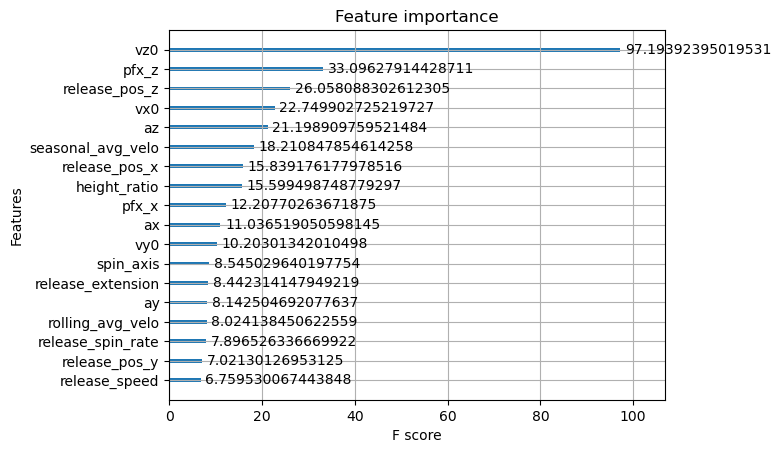

In [52]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

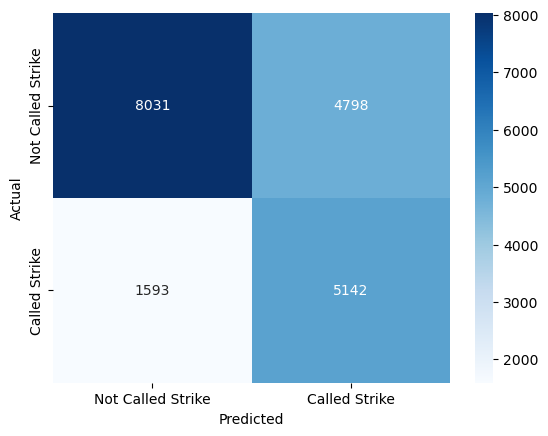

In [53]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Called Strike', 'Called Strike'], yticklabels=['Not Called Strike', 'Called Strike'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [54]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [55]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [58]:
len(testing_label)

452495

In [56]:
y_pred = final_model.predict(predictions)

In [59]:
len(testing_data)

452495

In [61]:
testing_identifiers['xcs'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_1940\3630874201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xcs'] = y_pred


In [62]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/fastball/cs_2022&3_xcalledstrike.csv")